In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import re
import optuna
import shap 
import lightgbm as lgb
import calendar

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot as plot

from datetime import *; from dateutil.relativedelta import *
from dateutil.relativedelta import relativedelta, MO

In [2]:
df = pd.read_excel('https://github.com/andrevandor/ProjetoIntegrador/raw/master/data/HDI_1990_2019.xlsx')

## Treatment of Null Values

In [3]:
def EDA (df):
    eda_df = {}
    eda_df['Qtde_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Qtde_Unicos'] = df.count()
    
    colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    eda_df['Qtde_Unicos'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Media'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    
    return pd.DataFrame(eda_df)

In [4]:
EDA(df.drop(['Ano','Paises','IDH','CPI (Corruption Index)'], axis = 1))

Qtde_NaN  %_NaN    DType  \
Expectativa de vida no nascimento                      84   0.01  float64   
Anos esperados de escolaridade                        279   0.05  float64   
Média de anos de escolaridade                         551   0.10  float64   
Renda nacional bruta (RNB) per capita (PPP US$)       446   0.08  float64   
Faixa                                                1001   0.18  float64   

                                                 Qtde_Unicos      Media  \
Expectativa de vida no nascimento                        371     68.418   
Anos esperados de escolaridade                          5013     11.849   
Média de anos de escolaridade                              5      7.525   
Renda nacional bruta (RNB) per capita (PPP US$)          429  13408.952   
Faixa                                                   2684      2.448   

                                                    Min           Max  \
Expectativa de vida no nascimento                26.172      84.50000   
Anos esperados de escolaridade                    2.100      23.30000   
Média de anos de escolaridade                     0.290      14.13215   
Renda nacional bruta (RNB) per capita (PPP US$)  14.000  131510.00000   
Faixa                                             1.000       4.00000   

                                                       STD  
Expectativa de vida no nascimento                    9.530  
Anos esperados de escolaridade                       3.358  
Média de anos de escolaridade                        3.180  
Renda nacional bruta (RNB) per capita (PPP US$)  16507.846  
Faixa                                                1.109

In [5]:
#Analisando Expectativa de vida no nascimento
df_analise_nulls = df.copy()

indices = df_analise_nulls[df_analise_nulls['Expectativa de vida no nascimento'].isnull()].index
paises_com_linha_em_branco = []
for i in indices:
    if (df_analise_nulls.loc[i,'Paises'] not in paises_com_linha_em_branco):
        paises_com_linha_em_branco.append(df_analise_nulls.loc[i,'Paises'])

In [6]:
paises_com_linha_em_branco

['Korea (Republic of)', 'Cabo Verde', 'Eswatini (Kingdom of)']

In [7]:
df_analise_nulls.loc[df_analise_nulls['Paises']=='Korea (Republic of)'].head(2)

Paises   Ano  Expectativa de vida no nascimento  \
22   Korea (Republic of)  1990                                NaN   
209  Korea (Republic of)  1991                                NaN   

     Anos esperados de escolaridade  Média de anos de escolaridade  \
22                              NaN                            NaN   
209                             NaN                            NaN   

     Renda nacional bruta (RNB) per capita (PPP US$)  IDH  Faixa  \
22                                            8260.0  NaN    NaN   
209                                           9330.0  NaN    NaN   

     CPI (Corruption Index)  
22                      NaN  
209                     NaN

In [8]:
df_analise_nulls.loc[df_analise_nulls['Paises']=='Cabo Verde'].head(2)

Paises   Ano  Expectativa de vida no nascimento  \
124  Cabo Verde  1990                                NaN   
311  Cabo Verde  1991                                NaN   

     Anos esperados de escolaridade  Média de anos de escolaridade  \
124                             NaN                            NaN   
311                             NaN                            NaN   

     Renda nacional bruta (RNB) per capita (PPP US$)  IDH  Faixa  \
124                                           1140.0  NaN    NaN   
311                                           1160.0  NaN    NaN   

     CPI (Corruption Index)  
124                     NaN  
311                     NaN

In [9]:
df_analise_nulls.loc[df_analise_nulls['Paises']=='Eswatini (Kingdom of)'].head(2)

Paises   Ano  Expectativa de vida no nascimento  \
137  Eswatini (Kingdom of)  1990                                NaN   
324  Eswatini (Kingdom of)  1991                                NaN   

     Anos esperados de escolaridade  Média de anos de escolaridade  \
137                             NaN                            NaN   
324                             NaN                            NaN   

     Renda nacional bruta (RNB) per capita (PPP US$)  IDH  Faixa  \
137                                           3700.0  NaN    NaN   
324                                           3820.0  NaN    NaN   

     CPI (Corruption Index)  
137                     NaN  
324                     NaN

In [10]:
#Os três países (Korea (Republic of), Cabo Verde, Eswatini (Kingdom of)) acima possuem dados somente em 2018, 
#por isso não possuem informações suficientes para uma Série Temporal. Serão removidos da base.
linhas_deletar = df_analise_nulls.loc[(df_analise_nulls['Paises']=='Korea (Republic of)')  | \
                                      (df_analise_nulls['Paises']=='Cabo Verde') | \
                                      (df_analise_nulls['Paises']=='Eswatini (Kingdom of)')].index.tolist()
df_analise_nulls.drop(index=linhas_deletar, inplace=True)

In [11]:
df_analise_nulls['Expectativa de vida no nascimento'].interpolate(method='linear', limit_direction='forward', inplace=True)
df_analise_nulls['Anos esperados de escolaridade'].interpolate(method='linear', limit_direction='forward', inplace=True)
df_analise_nulls['Média de anos de escolaridade'].interpolate(method='linear', limit_direction='forward', inplace=True)
df_analise_nulls['Renda nacional bruta (RNB) per capita (PPP US$)'].interpolate(method='linear', limit_direction='forward',\
                                                                                inplace=True)

In [12]:
df_analise_nulls.drop(['IDH','CPI (Corruption Index)'], axis=1, inplace=True)

In [13]:
EDA(df_analise_nulls.drop(['Ano','Paises'], axis=1))

Qtde_NaN  %_NaN    DType  \
Expectativa de vida no nascimento                       0   0.00  float64   
Anos esperados de escolaridade                          0   0.00  float64   
Média de anos de escolaridade                           0   0.00  float64   
Renda nacional bruta (RNB) per capita (PPP US$)         0   0.00  float64   
Faixa                                                 917   0.17  float64   

                                                 Qtde_Unicos      Media  \
Expectativa de vida no nascimento                        456     68.415   
Anos esperados de escolaridade                          5009     11.773   
Média de anos de escolaridade                              5      7.323   
Renda nacional bruta (RNB) per capita (PPP US$)          615  13269.261   
Faixa                                                   2928      2.448   

                                                    Min           Max  \
Expectativa de vida no nascimento                26.172      84.50000   
Anos esperados de escolaridade                    2.100      23.30000   
Média de anos de escolaridade                     0.290      14.13215   
Renda nacional bruta (RNB) per capita (PPP US$)  14.000  131510.00000   
Faixa                                             1.000       4.00000   

                                                       STD  
Expectativa de vida no nascimento                    9.529  
Anos esperados de escolaridade                       3.369  
Média de anos de escolaridade                        3.198  
Renda nacional bruta (RNB) per capita (PPP US$)  16501.264  
Faixa                                                1.109

In [14]:
df_1 = df_analise_nulls.copy()
df_1.reset_index(inplace=True)
df_1.drop('index', axis=1, inplace=True)

In [15]:
df_1['Indice_Vida'] = (df_1['Expectativa de vida no nascimento'] - 20)/(85 - 20)

indexer = df_1.index.to_list()
for i in indexer:
    if df_1.loc[i,'Anos esperados de escolaridade'] > 18:
        df_1.loc[i,'Indice_Escola'] = ((df_1.loc[i,'Média de anos de escolaridade'] / 15)\
                                       + (df_1.loc[i,'Anos esperados de escolaridade']/18)) / 2
    else:
        df_1.loc[i,'Indice_Escola'] = ((df_1.loc[i,'Média de anos de escolaridade'] / 15)\
                                       + (df_1.loc[i,'Anos esperados de escolaridade']/18)) / 2
        
df_1['Indice_Renda'] = (np.log(df_1['Renda nacional bruta (RNB) per capita (PPP US$)'])\
                        - np.log(100)) / (np.log(75000) - np.log(100))

In [16]:
df_1.loc[df_1.Indice_Renda < 0, 'Indice_Renda'] = 0
df_1.loc[df_1.Indice_Renda > 1, 'Indice_Renda'] = 0.99
df_1.loc[df_1.Indice_Escola > 1, 'Indice_Escola'] = 0.99

## Data Visualization

Correlações altas já esperadas, como Expectativa de Vida e Anos de Escolaridade 
e faixa de IDH e demais pilares, já que quando maior a faixa melhor o pilar 
porem temos um fato interessante que é o RNB correlacionado com os demais pilares. 



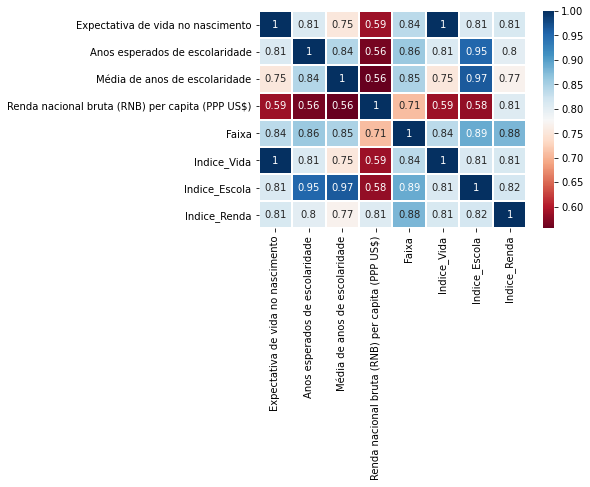

In [17]:
sns.heatmap(df_1.drop('Ano', axis=1).corr(), linewidths = 1, cmap = 'RdBu', annot = True)
print("Correlações altas já esperadas, como Expectativa de Vida e Anos de Escolaridade \n"\
      + "e faixa de IDH e demais pilares, já que quando maior a faixa melhor o pilar \n"
      + "porem temos um fato interessante que é o RNB correlacionado com os demais pilares. \n")

fig = plot.gcf()
plot.show()
fig.savefig('teste.png', format='png')

In [18]:
country_choices = [df_1[df_1.Faixa == 1].Paises.sample(1).to_list()[0],df_1[df_1.Faixa == 2].Paises.sample(1).to_list()[0],\
                  df_1[df_1.Faixa == 3].Paises.sample(1).to_list()[0],df_1[df_1.Faixa == 4].Paises.sample(1).to_list()[0]]

print('Paises escolhidos por faixa, aleatoriamente: \n\n'
      + 'Baixo desenvolvimento: ' + country_choices[0] + '\n'
      + 'Médio desenvolvimento: ' + country_choices[1] + '\n'
      + 'Alto desenvolvimento: ' + country_choices[2] + '\n'
      + 'Muito Alto desenvolvimento: ' + country_choices[3])

Paises escolhidos por faixa, aleatoriamente: 

Baixo desenvolvimento: Togo
Médio desenvolvimento: Albania
Alto desenvolvimento: Libya
Muito Alto desenvolvimento: Argentina


Baixo desenvolvimento



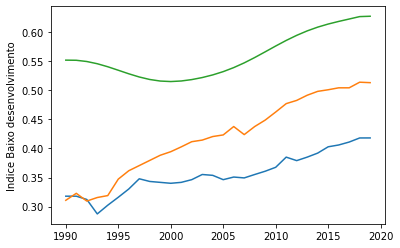

Médio desenvolvimento



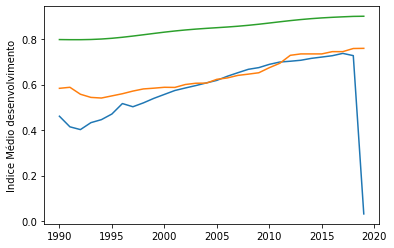

Alto desenvolvimento



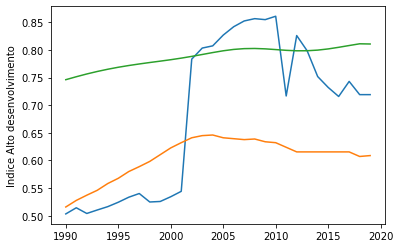

Muito Alto desenvolvimento



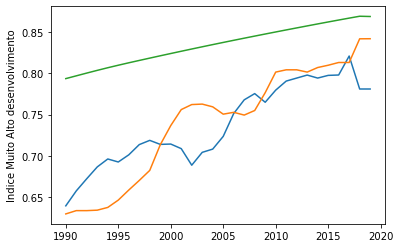


Dividimos um gráfico para cada faixa de HDI, percebemos que, infelizmente, os paises de baixo desenvolvimento 
tem um crescimento leve porem, comparado com os demais percebemos que a subida é menos acentuada, para a maioria das escolhas.
Paises em desenvolvimento muito alto tem seus indices muito proximos, uma subida acentuada e constante.


In [19]:
print('Baixo desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[0]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[0]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[0]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice Baixo desenvolvimento')

fig = plot.gcf()
plot.show()
fig.savefig('Baixo desenvolvimento.png', format='png')

print('Médio desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[1]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[1]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[1]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice Médio desenvolvimento')

fig = plot.gcf()
plot.show()
fig.savefig('Médio desenvolvimento.png', format='png')

print('Alto desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[2]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[2]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[2]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice Alto desenvolvimento')

fig = plot.gcf()
plot.show()
fig.savefig('Alto desenvolvimento.png', format='png')

print('Muito Alto desenvolvimento\n')
sns.lineplot(y=df_1[df_1.Paises == country_choices[3]]['Indice_Renda'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[3]]['Indice_Escola'], x=df_1.Ano.unique(), data=df_1)
sns.lineplot(y=df_1[df_1.Paises == country_choices[3]]['Indice_Vida'], x=df_1.Ano.unique(), data=df_1)
plot.ylabel('Indice Muito Alto desenvolvimento')

fig = plot.gcf()
plot.show()
fig.savefig('Muito Alto desenvolvimento.png', format='png')

print('\nDividimos um gráfico para cada faixa de HDI, percebemos que, infelizmente, os paises de baixo desenvolvimento \n' \
     + 'tem um crescimento leve porem, comparado com os demais percebemos que a subida é menos acentuada, para a maioria das escolhas.\n' \
     + 'Paises em desenvolvimento muito alto tem seus indices muito proximos, uma subida acentuada e constante.')

In [20]:
sums = []
for i in range(1,5):
    sums.append(np.round(df_1[df_1.Faixa == i]['Renda nacional bruta (RNB) per capita (PPP US$)'].sum(),2))

In [21]:
df_sums = pd.DataFrame(sums)
df_sums.columns = ['Soma Faixas']

In [22]:
df_sums['% do Total'] = (df_sums['Soma Faixas']/df_sums['Soma Faixas'].sum())*100

In [23]:
df_sums.index = [1,2,3,4]

In [24]:
df_sums

Soma Faixas  % do Total
1   2091234.42    3.242338
2   7633064.05   11.834623
3  17029501.32   26.403253
4  37743939.53   58.519787

In [25]:
print('Teriamos um melhor balanceamento entre as faixas de os paises na faixa 1 e 2 representassem um unica faixa.\n'\
     + 'De toda forma os paises da faixa 4 sozinhos detem o poder de compra das faixas 1,2 e 3, comparando com o correlação\n'\
     + 'onde podemos dizer que o pilar de PPP sustenta os demais eles tem muito mais chance de melhorarem ou manterem'\
     + 'seus indicadores.\n')

print(df_1[df_1.Ano == 2019].Faixa.value_counts())

print('\nPara tentar validar a hiposete da melhor divisão em 3 grupos iremos usar KNE e T-SNE')

Teriamos um melhor balanceamento entre as faixas de os paises na faixa 1 e 2 representassem um unica faixa.
De toda forma os paises da faixa 4 sozinhos detem o poder de compra das faixas 1,2 e 3, comparando com o correlação
onde podemos dizer que o pilar de PPP sustenta os demais eles tem muito mais chance de melhorarem ou manteremseus indicadores.

4.0    60
3.0    54
1.0    35
2.0    35
Name: Faixa, dtype: int64

Para tentar validar a hiposete da melhor divisão em 3 grupos iremos usar KNE e T-SNE


### K-means and t-SNE

In [26]:
df_grouped = df_1.drop(['Paises','Faixa','Indice_Vida','Indice_Escola','Indice_Renda'], axis=1).copy()

In [27]:
df_grouped = df_grouped[df_grouped.Ano == 2019]

In [28]:
df_grouped.drop('Ano', axis= 1, inplace = True)

In [29]:
df_grouped.head(2)

Expectativa de vida no nascimento  Anos esperados de escolaridade  \
5336                               82.3                            18.1   
5337                               83.6                            16.2   

      Média de anos de escolaridade  \
5336                           12.6   
5337                           13.4   

      Renda nacional bruta (RNB) per capita (PPP US$)  
5336                                           6859.0  
5337                                          59375.0

In [30]:
scaler = StandardScaler()  
df_grouped_norm = scaler.fit_transform(df_grouped)

1 736.0
2 359.46
3 234.25
4 190.31
5 159.5
6 146.9
7 127.33
8 115.7
9 108.31
10 99.15
11 94.99
12 90.86
13 86.09
14 79.28
15 78.27
16 73.93
17 71.31
18 67.31
19 64.05
20 63.65


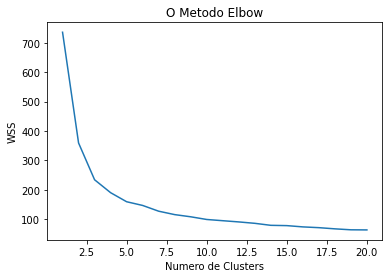

        0
0   48.84
1   65.17
2   81.24
3   83.81
4   92.10
5   86.68
6   90.87
7   93.61
8   91.55
9   95.80
10  95.65
11  94.76
12  92.09
13  98.73
14  94.46
15  96.46
16  94.39
17  95.15
18  99.39


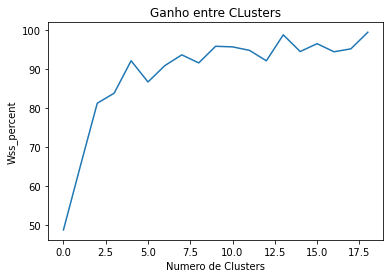

Como haviamos suspeitado e pelo que observamos nas informações de ganho para cada cluster processadonosso melhor momento de ganho foi até o 3° cluster e depois começamos a ter um adição leve e gradual.Portanto cruzando o WSS versus o WSS percent validamos 3 divisões de faixa.


In [31]:
X = np.array(df_grouped_norm)
wcss = []
wss_percent =  []

for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    print(i,np.round(kmeans.inertia_,2))
    wcss.append(kmeans.inertia_)  
    if i > 1:
        wss_percent.append(np.round((kmeans.inertia_/wcss[i-2])*100,2))
    
plot.plot(range(1, 21), wcss)
plot.title('O Metodo Elbow')
plot.xlabel('Numero de Clusters')
plot.ylabel('WSS') #within cluster sum of squares

fig = plot.gcf()
plot.show()
fig.savefig('Cotovelo.png', format='png')

print(pd.DataFrame(wss_percent))

plot.plot(range(0, 19), wss_percent)
plot.title('Ganho entre CLusters')
plot.xlabel('Numero de Clusters')
plot.ylabel('Wss_percent')

fig = plot.gcf()
plot.show()
fig.savefig('%Ganho.png', format='png')

print('Como haviamos suspeitado e pelo que observamos nas informações de ganho para cada cluster processado'\
    + 'nosso melhor momento de ganho foi até o 3° cluster e depois começamos a ter um adição leve e gradual.'\
    + 'Portanto cruzando o WSS versus o WSS percent validamos 3 divisões de faixa.')

In [32]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X)
#predizendo os clusters
labels = kmeans.predict(X)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [33]:
kmeans.cluster_centers_

array([[-1.11105158, -1.05305676, -1.17064557, -0.6036843 ],
       [ 1.08444053,  1.08417326,  1.00837778,  1.66579618],
       [ 0.33884918,  0.29875453,  0.41041088, -0.24406959]])

In [34]:
kmeans.labels_

array([2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
X_reduzido = TSNE(n_components=2).fit_transform(X)
X_reduzido.shape

(184, 2)

In [36]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X_reduzido)
#predizendo os clusters
labels = kmeans.predict(X_reduzido)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [37]:
kmeans.cluster_centers_

array([[ -5.5958633,  11.7240095],
       [  0.3477672,   1.5469939],
       [  6.485078 , -10.093541 ]], dtype=float32)

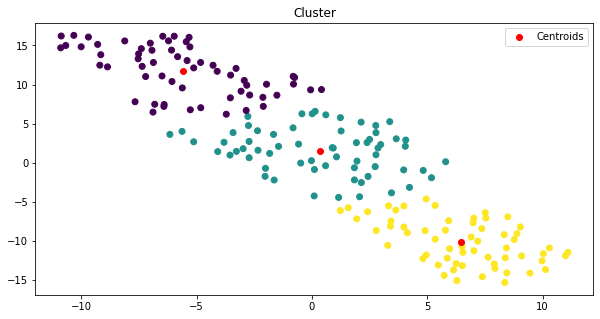

In [38]:
plot.figure(figsize=(10,5))

plot.scatter(X_reduzido[:, 0], X_reduzido[:, 1], s=plot.rcParams['lines.markersize']**2, c = kmeans.labels_)
plot.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],  c = 'red',label = 'Centroids')
plot.title('Cluster')
plot.legend()

fig = plot.gcf()
plot.show()
fig.savefig('Clusters.png', format='png')

In [39]:
cluster_list = kmeans.labels_
df_grouped["Cluster IDH"] = cluster_list

## Feature Engineering

In [40]:
paises = df_1.Paises.unique()

In [41]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_1[df_1.Paises == paises[i]].index)

In [42]:
df_2 = pd.DataFrame()
for i in range(len(index_paises)):
    df_2 = pd.concat([df_2, df_1.iloc[index_paises[i]]], axis = 0)

In [43]:
df_2.reset_index(inplace=True)
df_2.drop('index', axis=1, inplace=True)

In [44]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_2[df_2.Paises == paises[i]].index)

In [45]:
df_2.drop(['Faixa','Indice_Vida','Indice_Escola','Indice_Renda'], axis = 1, inplace = True)

In [46]:
def feature_engineering (df, roll, features):
    
    data = df.copy()
    paises = df.Paises.unique()
    
    data_merge = pd.DataFrame()
    
    roll += 1
    
    for pais in paises:
        
        data_pais = data[data.Paises == pais]
        
        for i in range (0, len(features)):
            data_pais[str(features[i] + '_Media')] = data_pais[str(features[i])].rolling(window = roll).mean().round(2)
            data_pais[str(features[i] + '_percent')] = data_pais[str(features[i])].pct_change(roll - 1).round(2)
                  
        features_2 = data_pais.select_dtypes(exclude=['int64', 'object']).columns.tolist()
        
        for i in range (0, len(features_2)):
            data_pais[features_2[i]] = data_pais[features_2[i]].shift(periods=roll)
        
        data_merge = pd.concat([data_merge, data_pais], axis=0)
        
    #data_merge.dropna(how='any', inplace = True)
    
    data_copy = data_merge[['Ano','Paises','Expectativa de vida no nascimento', 'Anos esperados de escolaridade',\
            'Média de anos de escolaridade', 'Renda nacional bruta (RNB) per capita (PPP US$)']]
    
    del data_merge['Ano']
    del data_merge['Paises']
    del data_merge['Expectativa de vida no nascimento']
    del data_merge['Anos esperados de escolaridade']
    del data_merge['Média de anos de escolaridade']
    del data_merge['Renda nacional bruta (RNB) per capita (PPP US$)']
    
    data_merge = data_merge.interpolate(method='linear', limit_direction='forward', axis=1)
    data_merge = pd.concat([data_copy,data_merge], axis = 1)
    
    data_merge.dropna(how='any', inplace = True)
   
    return data_merge

## Janelas de Previsão

In [50]:
roll = 1
features = ['Expectativa de vida no nascimento', 'Anos esperados de escolaridade',\
            'Média de anos de escolaridade', 'Renda nacional bruta (RNB) per capita (PPP US$)']

In [48]:
df_3 = feature_engineering (df_2, roll, features);


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Modelling - Método 1

# Walk Forward Cross Validation

In [49]:
df_4 = df_3.copy()
memory_feature_names = df_3.columns
df_4 = df_4.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [50]:
features = ['Expectativadevidanonascimento', 'Anosesperadosdeescolaridade',\
            'Mdiadeanosdeescolaridade', 'RendanacionalbrutaRNBpercapitaPPPUS']

In [51]:
#PARAMETROS:
paises = df_4.Paises.unique()
#Tamanho da janela de treinamento: o número de pontos de dados incluídos em uma passagem de treinamento (em anos)
janela_treinamento = [3,5,7,9]
#Tamanho da janela de previsão: o número de pontos de dados a serem incluídos na previsão (ano)
janela_previsao = 1
#Tamanho da janela de teste: o número de pontos de dados a serem incluídos no teste
janela_teste = janela_previsao

parametros = []
metricas = []
val = []
pred = []
data = []
janelas = []

COLUNAS = [
    'Pais',
    'Feature',
    'Mean_Metricas',
    'Min_Metrica',
    'boosting_type',
    'num_leaves',
    'feature_fraction',
    'bagging_fraction',
    'bagging_freq',
    'min_child_samples',
    'max_depth'
    'janela'
]

parametros_finais = pd.DataFrame(columns=COLUNAS)

In [ ]:
print('INICIO: ',datetime.now())

num = 0

for pais in paises:

    for feature in features:
            
        df_pais_atual = df_4.loc[df_4['Paises'] == pais].copy()

        #CROSS VALIDATION
        for janela in janela_treinamento:   
            
            data_ini_df = df_pais_atual.Ano.min()
            data_fim_df = df_pais_atual.Ano.max()
            dif = data_fim_df - data_ini_df

            #quantas vezes o algoritmo vai andar no dataframe
            passos = data_fim_df - (janela + janela_previsao + janela_teste) - data_ini_df + 2

            data_passo = df_pais_atual.Ano.min()
            
            #WALK FORWARD
            for i in range(passos):
                #treino
                data_ini_treino = data_passo + i 
                data_fim_treino = data_ini_treino + janela -1
                treino = df_pais_atual[df_pais_atual.Ano.between(data_ini_treino, data_fim_treino)]
                data_treino = treino['Ano']
                x_treino = treino.drop(columns=[feature, 'Ano', 'Paises'])
                y_treino = treino[feature]
                print(pais, ':: Janela: ', janela, ' - Data inicial: ', data_ini_treino, ' para feature ', feature)

                #validação
                data_ini_validacao = data_fim_treino + 1
                validacao = df_pais_atual.loc[df_pais_atual['Ano'] == data_ini_validacao]
                data_validacao = validacao['Ano']
                x_validacao = validacao.drop(columns=[feature, 'Ano', 'Paises'])
                y_validacao = validacao[feature]
                
                #teste
                data_ini_teste = data_ini_validacao + 1
                teste = df_pais_atual.loc[df_pais_atual['Ano'] == data_ini_teste]
                data_teste = teste['Ano']
                x_teste = teste.drop(columns=[feature, 'Ano', 'Paises'])
                y_teste = teste[feature]

                valids = {}

                lgb_train = lgb.Dataset(x_treino, y_treino)
                lgb_valid = lgb.Dataset(x_validacao, y_validacao, reference = lgb_train)

                def objective(trial):

                    param = {
                        'objective' : 'regression',
                        'metric' : 'mse',
                        'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
                        'num_leaves' : trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
                        'bagging_freq' : trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples' : trial.suggest_int('min_child_samples', 5, 100),
                        'max_depth' : trial.suggest_int('max_depth', 5, 100)
                    }

                    gbm = lgb.train(param, lgb_train)
                    y_pred = gbm.predict(x_validacao.values)
                    rmse = mean_squared_error(y_validacao, y_pred) ** 0.5
                    return rmse

                study = optuna.create_study(direction='minimize')
                study.optimize(objective, n_trials = 1)

                final_model = lgb.LGBMRegressor(**study.best_params)
                y_pred2 = final_model.fit(x_treino.values, y_treino).predict(x_teste)

                rmse = mean_squared_error(y_teste, y_pred2) ** 0.5
                #print (rmse)

                parametros.append(study.best_params)
                metricas.append(rmse)
                val.append(y_teste)
                pred.append(y_pred2)
                data.append(data_validacao)
                janelas.append(janela)
        
        p = parametros[np.argmin(metricas)]
    
        parametros_finais.loc[num, 'Pais'] = pais
        parametros_finais.loc[num, 'Feature'] = feature
        parametros_finais.loc[num, 'Mean_Metricas'] = np.mean(metricas)
        parametros_finais.loc[num, 'Min_Metrica'] = np.min(metricas)
        parametros_finais.loc[num, 'boosting_type'] = p['boosting_type']
        parametros_finais.loc[num, 'num_leaves'] = p['num_leaves']
        parametros_finais.loc[num, 'feature_fraction'] = p['feature_fraction']
        parametros_finais.loc[num, 'bagging_fraction'] = p['bagging_fraction']
        parametros_finais.loc[num, 'bagging_freq'] = p['bagging_freq']
        parametros_finais.loc[num, 'min_child_samples'] = p['min_child_samples']
        parametros_finais.loc[num, 'max_depth'] = p['max_depth']
        parametros_finais.loc[num, 'janela'] = janela
        num += 1
        
print('FIM: ',datetime.now())

INICIO:  2020-07-09 16:10:00.724590
Norway :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:00,961] Finished trial#0 with value: 0.4286656697591127 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.660635312907729, 'bagging_fraction': 0.4546228908029448, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 87}. Best is trial#0 with value: 0.4286656697591127.


Norway :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:01,169] Finished trial#0 with value: 0.42233308919270485 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.5361329058962644, 'bagging_fraction': 0.9029081000547399, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 28}. Best is trial#0 with value: 0.42233308919270485.


Norway :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:01,383] Finished trial#0 with value: 0.41200195312499943 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.7062624892637319, 'bagging_fraction': 0.6602933869085083, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 64}. Best is trial#0 with value: 0.41200195312499943.


Norway :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:01,603] Finished trial#0 with value: 0.40300177001952875 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.9586348671019393, 'bagging_fraction': 0.887570714304072, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 32}. Best is trial#0 with value: 0.40300177001952875.


Norway :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:01,931] Finished trial#0 with value: 0.40000138346354674 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.6064043319920807, 'bagging_fraction': 0.6023350823732703, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 98}. Best is trial#0 with value: 0.40000138346354674.


Norway :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:02,225] Finished trial#0 with value: 0.40166619873046727 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.5423033700118635, 'bagging_fraction': 0.4351004841806382, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 9}. Best is trial#0 with value: 0.40166619873046727.


Norway :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:02,451] Finished trial#0 with value: 0.4083335571289126 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.7821527064836833, 'bagging_fraction': 0.8252529428676405, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 44}. Best is trial#0 with value: 0.4083335571289126.


Norway :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:02,659] Finished trial#0 with value: 0.4223331705729265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.43305937978002806, 'bagging_fraction': 0.7955787254947624, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 57}. Best is trial#0 with value: 0.4223331705729265.


Norway :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:02,888] Finished trial#0 with value: 0.4406666870117135 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.8096980132394014, 'bagging_fraction': 0.9556467075588757, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 81}. Best is trial#0 with value: 0.4406666870117135.


Norway :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:03,194] Finished trial#0 with value: 0.4606663614908939 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.6838248001810998, 'bagging_fraction': 0.7579868876557416, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 38}. Best is trial#0 with value: 0.4606663614908939.


Norway :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:03,445] Finished trial#0 with value: 0.4796664428710926 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.6198725736036624, 'bagging_fraction': 0.7756293177028613, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 13}. Best is trial#0 with value: 0.4796664428710926.


Norway :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:03,681] Finished trial#0 with value: 0.4950000813801978 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.42753435742213425, 'bagging_fraction': 0.6340165262095534, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 7}. Best is trial#0 with value: 0.4950000813801978.


Norway :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:03,902] Finished trial#0 with value: 0.5029998779296818 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.9712002906069176, 'bagging_fraction': 0.6821379471087061, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 43}. Best is trial#0 with value: 0.5029998779296818.


Norway :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:04,108] Finished trial#0 with value: 0.502666727701822 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.617404984900947, 'bagging_fraction': 0.7704813615010242, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 16}. Best is trial#0 with value: 0.502666727701822.


Norway :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:04,329] Finished trial#0 with value: 0.49300097656249875 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.749504266106106, 'bagging_fraction': 0.9272386961825562, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 62}. Best is trial#0 with value: 0.49300097656249875.


Norway :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:04,627] Finished trial#0 with value: 0.47266672770182083 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.6783418581270553, 'bagging_fraction': 0.8721304635312126, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 96}. Best is trial#0 with value: 0.47266672770182083.


Norway :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:04,891] Finished trial#0 with value: 0.44366632080078716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.6109199535837749, 'bagging_fraction': 0.7633561222964269, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 30}. Best is trial#0 with value: 0.44366632080078716.


Norway :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:05,166] Finished trial#0 with value: 0.4056664021809837 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.740000113889407, 'bagging_fraction': 0.9027516733872151, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 93}. Best is trial#0 with value: 0.4056664021809837.


Norway :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:05,409] Finished trial#0 with value: 0.36333361816406295 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.5089629481807515, 'bagging_fraction': 0.5521239157610109, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 58}. Best is trial#0 with value: 0.36333361816406295.


Norway :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:05,627] Finished trial#0 with value: 0.322333170572918 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.7226700986794063, 'bagging_fraction': 0.7656209978649451, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 66}. Best is trial#0 with value: 0.322333170572918.


Norway :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:05,855] Finished trial#0 with value: 0.28633135986328284 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.647345307651565, 'bagging_fraction': 0.8872473310607897, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 92}. Best is trial#0 with value: 0.28633135986328284.


Norway :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:06,095] Finished trial#0 with value: 0.25733182779949004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.9221413966553218, 'bagging_fraction': 0.9331543309206796, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 90}. Best is trial#0 with value: 0.25733182779949004.


Norway :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:06,351] Finished trial#0 with value: 0.2409979858398401 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.8089617124336417, 'bagging_fraction': 0.7851613105815509, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 65}. Best is trial#0 with value: 0.2409979858398401.


Norway :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:06,580] Finished trial#0 with value: 0.6256005859375051 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.8999353991393748, 'bagging_fraction': 0.9904277279907092, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 17}. Best is trial#0 with value: 0.6256005859375051.


Norway :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:06,856] Finished trial#0 with value: 0.6140003051757787 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.6280268661997996, 'bagging_fraction': 0.8809135909956878, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 20}. Best is trial#0 with value: 0.6140003051757787.


Norway :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:07,096] Finished trial#0 with value: 0.6064014282226537 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.9699502011394125, 'bagging_fraction': 0.444401951590174, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 99}. Best is trial#0 with value: 0.6064014282226537.


Norway :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:07,459] Finished trial#0 with value: 0.6038009033203053 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.6644194843874887, 'bagging_fraction': 0.6296750216871516, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 46}. Best is trial#0 with value: 0.6038009033203053.


Norway :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:07,697] Finished trial#0 with value: 0.6086005859375092 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.832671072880202, 'bagging_fraction': 0.46256507065137203, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 94}. Best is trial#0 with value: 0.6086005859375092.


Norway :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:07,974] Finished trial#0 with value: 0.623600158691417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.9452290218564463, 'bagging_fraction': 0.758752916023804, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 31}. Best is trial#0 with value: 0.623600158691417.


Norway :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:08,286] Finished trial#0 with value: 0.6455998535156198 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.8535176768140333, 'bagging_fraction': 0.765799672487373, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 12}. Best is trial#0 with value: 0.6455998535156198.


Norway :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:08,561] Finished trial#0 with value: 0.6719995727539043 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.8100449543147514, 'bagging_fraction': 0.9488085678148814, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 19}. Best is trial#0 with value: 0.6719995727539043.


Norway :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:08,846] Finished trial#0 with value: 0.7000003051757773 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.48257927725452343, 'bagging_fraction': 0.7451709301767401, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 8}. Best is trial#0 with value: 0.7000003051757773.


Norway :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:09,098] Finished trial#0 with value: 0.7251997680664033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.9668967098181405, 'bagging_fraction': 0.48363245847693404, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 65}. Best is trial#0 with value: 0.7251997680664033.


Norway :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:09,353] Finished trial#0 with value: 0.7423995971679602 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.4524959024138061, 'bagging_fraction': 0.48546707002848266, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 76}. Best is trial#0 with value: 0.7423995971679602.


Norway :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:09,568] Finished trial#0 with value: 0.7494003295898324 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.5099927138402177, 'bagging_fraction': 0.8757698266009348, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 65}. Best is trial#0 with value: 0.7494003295898324.


Norway :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:09,780] Finished trial#0 with value: 0.7438005371093794 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.46470769091387937, 'bagging_fraction': 0.7508603853998498, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 95}. Best is trial#0 with value: 0.7438005371093794.


Norway :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:10,073] Finished trial#0 with value: 0.7231997680663937 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.5262286745125213, 'bagging_fraction': 0.8255035908728499, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 52}. Best is trial#0 with value: 0.7231997680663937.


Norway :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:10,298] Finished trial#0 with value: 0.6892000732421906 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.4677943940548704, 'bagging_fraction': 0.7569982834593509, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 76}. Best is trial#0 with value: 0.6892000732421906.


Norway :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:10,508] Finished trial#0 with value: 0.6414004516601608 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.665853811619469, 'bagging_fraction': 0.45246496414983994, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 56}. Best is trial#0 with value: 0.6414004516601608.


Norway :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:10,716] Finished trial#0 with value: 0.5843999023437476 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.7225605096673025, 'bagging_fraction': 0.680389412180427, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 6}. Best is trial#0 with value: 0.5843999023437476.


Norway :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:10,950] Finished trial#0 with value: 0.5249993896484284 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.6325964757125119, 'bagging_fraction': 0.5629051195006992, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 15}. Best is trial#0 with value: 0.5249993896484284.


Norway :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:11,243] Finished trial#0 with value: 0.46839923095703284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.9076396170220676, 'bagging_fraction': 0.6601087654273528, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 92}. Best is trial#0 with value: 0.46839923095703284.


Norway :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:11,508] Finished trial#0 with value: 0.41899920654297773 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.6585393468531224, 'bagging_fraction': 0.9099721083743387, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 99}. Best is trial#0 with value: 0.41899920654297773.


Norway :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:11,736] Finished trial#0 with value: 0.3847983398437407 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.9615055875331704, 'bagging_fraction': 0.7299804986824905, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 48}. Best is trial#0 with value: 0.3847983398437407.


Norway :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:11,965] Finished trial#0 with value: 0.8174291730608303 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.9759170930449064, 'bagging_fraction': 0.425373469042754, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 79}. Best is trial#0 with value: 0.8174291730608303.


Norway :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:12,179] Finished trial#0 with value: 0.8120001046316929 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.7888592349360868, 'bagging_fraction': 0.9788233893065797, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 58}. Best is trial#0 with value: 0.8120001046316929.


Norway :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:12,405] Finished trial#0 with value: 0.8132865600586001 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.9624392391354564, 'bagging_fraction': 0.6621771183379022, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 23}. Best is trial#0 with value: 0.8132865600586001.


Norway :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:12,656] Finished trial#0 with value: 0.8257152448381788 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.47346147517454007, 'bagging_fraction': 0.5710782536509986, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 74}. Best is trial#0 with value: 0.8257152448381788.


Norway :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:12,903] Finished trial#0 with value: 0.8477145036969773 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.6124111107240509, 'bagging_fraction': 0.4587529901553009, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 28}. Best is trial#0 with value: 0.8477145036969773.


Norway :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:13,123] Finished trial#0 with value: 0.8769998779296913 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.7539122438672832, 'bagging_fraction': 0.5577780063504106, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 8}. Best is trial#0 with value: 0.8769998779296913.


Norway :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:13,369] Finished trial#0 with value: 0.9102858189174157 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.40625704938130003, 'bagging_fraction': 0.870841368542112, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 92}. Best is trial#0 with value: 0.9102858189174157.


Norway :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:13,585] Finished trial#0 with value: 0.9428568028041298 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.9939670978537397, 'bagging_fraction': 0.5934394359751177, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 5}. Best is trial#0 with value: 0.9428568028041298.


Norway :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:13,883] Finished trial#0 with value: 0.9690000261579144 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.782701369062369, 'bagging_fraction': 0.7561081581773983, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 94}. Best is trial#0 with value: 0.9690000261579144.


Norway :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:14,186] Finished trial#0 with value: 0.9848571777343693 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.7423074164686635, 'bagging_fraction': 0.6026308536968393, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 91}. Best is trial#0 with value: 0.9848571777343693.


Norway :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:14,398] Finished trial#0 with value: 0.9865715767996619 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.8295663147401791, 'bagging_fraction': 0.9109416734762407, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 27}. Best is trial#0 with value: 0.9865715767996619.


Norway :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:14,617] Finished trial#0 with value: 0.9707143293108231 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.7197665223915257, 'bagging_fraction': 0.7939472305422339, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 50}. Best is trial#0 with value: 0.9707143293108231.


Norway :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:14,840] Finished trial#0 with value: 0.9377143031529016 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.5125845314876174, 'bagging_fraction': 0.49615880029008336, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 41}. Best is trial#0 with value: 0.9377143031529016.


Norway :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:15,069] Finished trial#0 with value: 0.8864287022181969 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8142400349082299, 'bagging_fraction': 0.6900095504273016, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 20}. Best is trial#0 with value: 0.8864287022181969.


Norway :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:15,299] Finished trial#0 with value: 0.8212858450753373 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.7517245982668924, 'bagging_fraction': 0.9988576469459766, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 90}. Best is trial#0 with value: 0.8212858450753373.


Norway :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:15,644] Finished trial#0 with value: 0.7492857142857048 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.88769506432491, 'bagging_fraction': 0.8578951840502109, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 17}. Best is trial#0 with value: 0.7492857142857048.


Norway :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:15,853] Finished trial#0 with value: 0.6762849731445328 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.7958646252943173, 'bagging_fraction': 0.4886550934396506, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 75}. Best is trial#0 with value: 0.6762849731445328.


Norway :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:16,062] Finished trial#0 with value: 0.6081419241769055 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.7096126556013891, 'bagging_fraction': 0.9215507788621915, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 63}. Best is trial#0 with value: 0.6081419241769055.


Norway :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:16,271] Finished trial#0 with value: 0.5544276820591421 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.47736167333996526, 'bagging_fraction': 0.6388724779566717, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 33}. Best is trial#0 with value: 0.5544276820591421.


Norway :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:16,485] Finished trial#0 with value: 1.0223336656358555 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.5484800337578495, 'bagging_fraction': 0.9611511787125653, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 69}. Best is trial#0 with value: 1.0223336656358555.


Norway :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:16,764] Finished trial#0 with value: 1.0325558810763908 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.9703704806357907, 'bagging_fraction': 0.6583278696512789, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 43}. Best is trial#0 with value: 1.0325558810763908.


Norway :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:17,083] Finished trial#0 with value: 1.0524449462890573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.6761663179168128, 'bagging_fraction': 0.9271202427021414, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 40}. Best is trial#0 with value: 1.0524449462890573.


Norway :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:17,295] Finished trial#0 with value: 1.0810005628797796 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.5589413472976363, 'bagging_fraction': 0.7741298466989879, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 22}. Best is trial#0 with value: 1.0810005628797796.


Norway :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:17,482] Finished trial#0 with value: 1.1160003323025194 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.5707650464882769, 'bagging_fraction': 0.6344080589959336, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 18}. Best is trial#0 with value: 1.1160003323025194.


Norway :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:17,671] Finished trial#0 with value: 1.1527776557074532 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.4843278525745255, 'bagging_fraction': 0.7329997194631399, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 30}. Best is trial#0 with value: 1.1527776557074532.


Norway :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:17,885] Finished trial#0 with value: 1.1849999321831604 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.5291545709985532, 'bagging_fraction': 0.7169145409453036, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 35}. Best is trial#0 with value: 1.1849999321831604.


Norway :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:18,103] Finished trial#0 with value: 1.2082221137152658 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.5377532512817175, 'bagging_fraction': 0.5889908206668938, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 23}. Best is trial#0 with value: 1.2082221137152658.


Norway :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:18,344] Finished trial#0 with value: 1.2178892483181443 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.8666377327548093, 'bagging_fraction': 0.6417713720132219, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 32}. Best is trial#0 with value: 1.2178892483181443.


Norway :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:18,543] Finished trial#0 with value: 1.209110989040795 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.554322463076554, 'bagging_fraction': 0.4166593332575944, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 49}. Best is trial#0 with value: 1.209110989040795.


Norway :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:18,771] Finished trial#0 with value: 1.1809998304579068 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.9738561369087952, 'bagging_fraction': 0.8683021076612514, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 91}. Best is trial#0 with value: 1.1809998304579068.


Norway :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:18,961] Finished trial#0 with value: 1.1315558200412283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.721117429414397, 'bagging_fraction': 0.5643456093388979, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 38}. Best is trial#0 with value: 1.1315558200412283.


Norway :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:19,150] Finished trial#0 with value: 1.064333407931855 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.43546521462035404, 'bagging_fraction': 0.7473563814457909, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 94}. Best is trial#0 with value: 1.064333407931855.


Norway :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:19,331] Finished trial#0 with value: 0.9858887396918306 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.6720655176380153, 'bagging_fraction': 0.5520885240916186, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 79}. Best is trial#0 with value: 0.9858887396918306.


Norway :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:19,614] Finished trial#0 with value: 0.9023329128689284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.8055447878691255, 'bagging_fraction': 0.48490696149615664, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 36}. Best is trial#0 with value: 0.9023329128689284.


Norway :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:19,826] Finished trial#0 with value: 0.8201107245551214 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7694038589364903, 'bagging_fraction': 0.5346851651298438, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 49}. Best is trial#0 with value: 0.8201107245551214.


Norway :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:10:20,011] Finished trial#0 with value: 0.7496658257378499 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.4511306506739753, 'bagging_fraction': 0.7296995852331194, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 56}. Best is trial#0 with value: 0.7496658257378499.


Norway :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:20,209] Finished trial#0 with value: 1.4666664759318042 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.871889889946888, 'bagging_fraction': 0.5820443526224015, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 62}. Best is trial#0 with value: 1.4666664759318042.


Norway :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:20,405] Finished trial#0 with value: 0.36666641235351527 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.6989395662653135, 'bagging_fraction': 0.9670674335977673, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 79}. Best is trial#0 with value: 0.36666641235351527.


Norway :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:20,924] Finished trial#0 with value: 0.19999961853027415 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.7210469578624675, 'bagging_fraction': 0.5955887974685607, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 14}. Best is trial#0 with value: 0.19999961853027415.


Norway :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:21,177] Finished trial#0 with value: 0.16666634877522846 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.6848143776501137, 'bagging_fraction': 0.5264467052301517, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 43}. Best is trial#0 with value: 0.16666634877522846.


Norway :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:21,370] Finished trial#0 with value: 1.0999998092651353 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.9614958855383863, 'bagging_fraction': 0.8515704279568996, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 38}. Best is trial#0 with value: 1.0999998092651353.


Norway :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:21,599] Finished trial#0 with value: 0.8666667302449547 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.6200361843883517, 'bagging_fraction': 0.7086717364036365, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 11}. Best is trial#0 with value: 0.8666667302449547.


Norway :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:21,822] Finished trial#0 with value: 0.8333333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.8129033437456417, 'bagging_fraction': 0.9613495003229411, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 88}. Best is trial#0 with value: 0.8333333333333321.


Norway :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:22,012] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.5908754631203822, 'bagging_fraction': 0.7426138786098544, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 96}. Best is trial#0 with value: 0.06666666666666643.


Norway :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:22,198] Finished trial#0 with value: 0.13333358764648295 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.7883884035171996, 'bagging_fraction': 0.6510272358861819, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 23}. Best is trial#0 with value: 0.13333358764648295.


Norway :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:22,453] Finished trial#0 with value: 0.2666664123535156 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.7341541237405629, 'bagging_fraction': 0.42834657119503655, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 56}. Best is trial#0 with value: 0.2666664123535156.


Norway :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:22,737] Finished trial#0 with value: 0.36666641235351705 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.47419857653766273, 'bagging_fraction': 0.8318155902568816, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 88}. Best is trial#0 with value: 0.36666641235351705.


Norway :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:22,964] Finished trial#0 with value: 0.09999974568684777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.8147708027536471, 'bagging_fraction': 0.4653456491567709, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 64}. Best is trial#0 with value: 0.09999974568684777.


Norway :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:23,146] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.6589846333685885, 'bagging_fraction': 0.9325902085432908, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 72}. Best is trial#0 with value: 0.06666653951009138.


Norway :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:23,336] Finished trial#0 with value: 0.0333330790201849 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.5359964972559419, 'bagging_fraction': 0.5294189413882743, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 27}. Best is trial#0 with value: 0.0333330790201849.


Norway :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:23,531] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.5494181721725058, 'bagging_fraction': 0.6956819890376937, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 96}. Best is trial#0 with value: 0.16666692097981795.


Norway :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:23,777] Finished trial#0 with value: 0.13333346048991146 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.9747019932866281, 'bagging_fraction': 0.7903766834907687, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 94}. Best is trial#0 with value: 0.13333346048991146.


Norway :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:23,963] Finished trial#0 with value: 0.13333346048991146 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.9555918865796841, 'bagging_fraction': 0.5715473882276217, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 54}. Best is trial#0 with value: 0.13333346048991146.


Norway :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:24,162] Finished trial#0 with value: 0.13333346048991146 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.8102667128650123, 'bagging_fraction': 0.8155574849122759, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 9}. Best is trial#0 with value: 0.13333346048991146.


Norway :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:24,368] Finished trial#0 with value: 0.03333346048991004 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.9382848916054679, 'bagging_fraction': 0.5361338807270599, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 9}. Best is trial#0 with value: 0.03333346048991004.


Norway :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:24,961] Finished trial#0 with value: 0.13333307902018277 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.5331957824969507, 'bagging_fraction': 0.8623530092511037, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 18}. Best is trial#0 with value: 0.13333307902018277.


Norway :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:25,280] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.7352657516988498, 'bagging_fraction': 0.49421526228373086, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 42}. Best is trial#0 with value: 0.09999961853027273.


Norway :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:25,699] Finished trial#0 with value: 0.06666615804036269 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.7021387388140106, 'bagging_fraction': 0.5766051182959557, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 97}. Best is trial#0 with value: 0.06666615804036269.


Norway :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:26,011] Finished trial#0 with value: 0.19999923706054545 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.7420651719713602, 'bagging_fraction': 0.614733267482921, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 99}. Best is trial#0 with value: 0.19999923706054545.


Norway :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:26,237] Finished trial#0 with value: 0.6799997329711918 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.6065290578233054, 'bagging_fraction': 0.7447791553118515, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 67}. Best is trial#0 with value: 0.6799997329711918.


Norway :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:26,529] Finished trial#0 with value: 0.5799997329711921 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.4068079054659888, 'bagging_fraction': 0.8030149359423029, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 71}. Best is trial#0 with value: 0.5799997329711921.


Norway :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:26,761] Finished trial#0 with value: 1.17999973297119 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.658346464568528, 'bagging_fraction': 0.9748379268576362, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 78}. Best is trial#0 with value: 1.17999973297119.


Norway :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:26,971] Finished trial#0 with value: 1.0199998855590842 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.8618183799510877, 'bagging_fraction': 0.5556967383273724, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 74}. Best is trial#0 with value: 1.0199998855590842.


Norway :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:27,197] Finished trial#0 with value: 1.2199998855590835 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.725048491453332, 'bagging_fraction': 0.5681830443179681, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 69}. Best is trial#0 with value: 1.2199998855590835.


Norway :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:27,441] Finished trial#0 with value: 0.4399999618530295 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.43546000362265624, 'bagging_fraction': 0.9654081596032846, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 28}. Best is trial#0 with value: 0.4399999618530295.


Norway :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:27,641] Finished trial#0 with value: 0.1799999237060561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.7558486088718265, 'bagging_fraction': 0.8298671923458025, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 8}. Best is trial#0 with value: 0.1799999237060561.


Norway :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:27,817] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.7237525590033076, 'bagging_fraction': 0.5472916097688938, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 71}. Best is trial#0 with value: 0.35999984741210866.


Norway :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:27,993] Finished trial#0 with value: 0.3399997711181655 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.6232922704176115, 'bagging_fraction': 0.9555969463626192, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 71}. Best is trial#0 with value: 0.3399997711181655.


Norway :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:28,157] Finished trial#0 with value: 0.13999977111816264 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.439726546669929, 'bagging_fraction': 0.6417784589458522, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 88}. Best is trial#0 with value: 0.13999977111816264.


Norway :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:28,347] Finished trial#0 with value: 0.23999977111816406 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.4272797358163263, 'bagging_fraction': 0.6235306304337274, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 22}. Best is trial#0 with value: 0.23999977111816406.


Norway :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:28,519] Finished trial#0 with value: 0.1399997711181662 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.9748690897208215, 'bagging_fraction': 0.6162553439815533, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 52}. Best is trial#0 with value: 0.1399997711181662.


Norway :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:28,783] Finished trial#0 with value: 0.16000022888183807 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.6828804204155954, 'bagging_fraction': 0.9165169705769161, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 16}. Best is trial#0 with value: 0.16000022888183807.


Norway :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:28,977] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.5143379568905788, 'bagging_fraction': 0.7966363888238718, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 71}. Best is trial#0 with value: 0.14000015258789134.


Norway :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:29,146] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.4929228733575223, 'bagging_fraction': 0.8376222257185943, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 9}. Best is trial#0 with value: 0.10000000000000142.


Norway :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:29,314] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.5208687975320788, 'bagging_fraction': 0.8247768269763462, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 12}. Best is trial#0 with value: 0.07999992370605469.


Norway :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:29,529] Finished trial#0 with value: 0.020000076293946734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.8886756460361928, 'bagging_fraction': 0.7367977238094621, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 61}. Best is trial#0 with value: 0.020000076293946734.


Norway :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:29,861] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.8133813094712625, 'bagging_fraction': 0.6280666850674097, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 58}. Best is trial#0 with value: 0.1999999999999993.


Norway :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:30,043] Finished trial#0 with value: 0.13999977111816264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.6313857152362, 'bagging_fraction': 0.6242436729381571, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 42}. Best is trial#0 with value: 0.13999977111816264.


Norway :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:30,199] Finished trial#0 with value: 0.079999542236326 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.4229868553655941, 'bagging_fraction': 0.6752322441182583, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 53}. Best is trial#0 with value: 0.079999542236326.


Norway :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:30,387] Finished trial#0 with value: 0.2599994659423821 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.9589674736803814, 'bagging_fraction': 0.936735766948252, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 72}. Best is trial#0 with value: 0.2599994659423821.


Norway :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:30,575] Finished trial#0 with value: 1.5571426391601548 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.6276689086164354, 'bagging_fraction': 0.5647215258326788, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 12}. Best is trial#0 with value: 1.5571426391601548.


Norway :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:30,738] Finished trial#0 with value: 1.385714149475099 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.4624012689991329, 'bagging_fraction': 0.8667497417533752, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 14}. Best is trial#0 with value: 1.385714149475099.


Norway :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:30,897] Finished trial#0 with value: 1.414285523550852 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.41481038108536444, 'bagging_fraction': 0.5695834178248106, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 62}. Best is trial#0 with value: 1.414285523550852.


Norway :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:31,066] Finished trial#0 with value: 0.6714284351893838 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.5853201582500052, 'bagging_fraction': 0.6578181742369387, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 46}. Best is trial#0 with value: 0.6714284351893838.


Norway :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:31,283] Finished trial#0 with value: 0.5285712923322414 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.6500009084841591, 'bagging_fraction': 0.9677634966333665, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 7}. Best is trial#0 with value: 0.5285712923322414.


Norway :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:31,563] Finished trial#0 with value: 0.7142855780465247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.8452921533860858, 'bagging_fraction': 0.7394961055340785, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 40}. Best is trial#0 with value: 0.7142855780465247.


Norway :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:31,808] Finished trial#0 with value: 0.5714284624372219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.561285296333691, 'bagging_fraction': 0.6252365819407784, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 66}. Best is trial#0 with value: 0.5714284624372219.


Norway :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:31,968] Finished trial#0 with value: 0.2428569793701172 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.42650492155528563, 'bagging_fraction': 0.47921334107199637, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 18}. Best is trial#0 with value: 0.2428569793701172.


Norway :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:32,136] Finished trial#0 with value: 0.25714263916015767 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.9184414513714564, 'bagging_fraction': 0.740089250848196, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 54}. Best is trial#0 with value: 0.25714263916015767.


Norway :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:32,305] Finished trial#0 with value: 0.18571406773158472 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6221184668959773, 'bagging_fraction': 0.445958300874535, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 33}. Best is trial#0 with value: 0.18571406773158472.


Norway :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:32,462] Finished trial#0 with value: 0.02857170104980611 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.6114186088970396, 'bagging_fraction': 0.4768510586237656, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 20}. Best is trial#0 with value: 0.02857170104980611.


Norway :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:32,644] Finished trial#0 with value: 0.07142873491559953 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.5545813126698613, 'bagging_fraction': 0.9202610485162612, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 39}. Best is trial#0 with value: 0.07142873491559953.


Norway :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:32,905] Finished trial#0 with value: 0.08571423121861343 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.9279484333364288, 'bagging_fraction': 0.9066156661491533, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 69}. Best is trial#0 with value: 0.08571423121861343.


Norway :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:33,071] Finished trial#0 with value: 0.0714284624372219 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.9284077414982569, 'bagging_fraction': 0.6206490313497934, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 42}. Best is trial#0 with value: 0.0714284624372219.


Norway :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:33,241] Finished trial#0 with value: 0.028571537562779525 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7154516263037878, 'bagging_fraction': 0.4480574220554614, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 98}. Best is trial#0 with value: 0.028571537562779525.


Norway :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:33,417] Finished trial#0 with value: 0.17142846243721976 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.9629147747791034, 'bagging_fraction': 0.47019007549491115, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 6}. Best is trial#0 with value: 0.17142846243721976.


Norway :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:33,616] Finished trial#0 with value: 0.15714269365583178 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.4645763141984111, 'bagging_fraction': 0.6890112364928604, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 8}. Best is trial#0 with value: 0.15714269365583178.


Norway :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:33,816] Finished trial#0 with value: 0.14285692487444024 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.7579449500240898, 'bagging_fraction': 0.47223115780080394, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 99}. Best is trial#0 with value: 0.14285692487444024.


Norway :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:34,029] Finished trial#0 with value: 0.299999618530272 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.4648978250571897, 'bagging_fraction': 0.8820136016964046, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 50}. Best is trial#0 with value: 0.299999618530272.


Norway :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:34,199] Finished trial#0 with value: 1.7888887193467884 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.5435765303031851, 'bagging_fraction': 0.6056295724040385, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 63}. Best is trial#0 with value: 1.7888887193467884.


Norway :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:34,370] Finished trial#0 with value: 1.033333184983995 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.4209384376028412, 'bagging_fraction': 0.8728007602450434, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 64}. Best is trial#0 with value: 1.033333184983995.


Norway :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:34,583] Finished trial#0 with value: 0.744444253709581 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.5975511607277351, 'bagging_fraction': 0.4042096553486493, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 45}. Best is trial#0 with value: 0.744444253709581.


Norway :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:34,795] Finished trial#0 with value: 0.9222220314873582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6618155669945747, 'bagging_fraction': 0.7972589024090553, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 5}. Best is trial#0 with value: 0.9222220314873582.


Norway :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:34,975] Finished trial#0 with value: 0.8666665183173308 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.8242154047550405, 'bagging_fraction': 0.5648016205505803, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 20}. Best is trial#0 with value: 0.8666665183173308.


Norway :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:35,175] Finished trial#0 with value: 0.5444442960951079 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.9437150433952223, 'bagging_fraction': 0.9083393221108227, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 93}. Best is trial#0 with value: 0.5444442960951079.


Norway :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:35,359] Finished trial#0 with value: 0.45555542839898067 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.5867783985400119, 'bagging_fraction': 0.5466810788985723, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 12}. Best is trial#0 with value: 0.45555542839898067.


Norway :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:35,517] Finished trial#0 with value: 0.2777776082356773 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.4959320034927519, 'bagging_fraction': 0.5673098643591817, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 95}. Best is trial#0 with value: 0.2777776082356773.


Norway :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:35,682] Finished trial#0 with value: 2.5431315364699003e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.743838323029581, 'bagging_fraction': 0.5046685703219418, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 77}. Best is trial#0 with value: 2.5431315364699003e-07.


Norway :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:35,855] Finished trial#0 with value: 0.03333350287543624 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.9921746365614169, 'bagging_fraction': 0.6643450371067574, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 65}. Best is trial#0 with value: 0.03333350287543624.


Norway :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:36,022] Finished trial#0 with value: 0.1777776506212021 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.7331037985366802, 'bagging_fraction': 0.8011159942341803, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 67}. Best is trial#0 with value: 0.1777776506212021.


Norway :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:36,191] Finished trial#0 with value: 0.12222209506564852 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.9617090927843908, 'bagging_fraction': 0.6465193952883086, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 8}. Best is trial#0 with value: 0.12222209506564852.


Norway :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:36,394] Finished trial#0 with value: 0.03333346048991004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.8707461121486824, 'bagging_fraction': 0.9474423352386749, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 9}. Best is trial#0 with value: 0.03333346048991004.


Norway :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:36,563] Finished trial#0 with value: 0.16666653951008925 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.5392941040056229, 'bagging_fraction': 0.6940334894731044, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 93}. Best is trial#0 with value: 0.16666653951008925.


Norway :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:36,744] Finished trial#0 with value: 0.15555538601345376 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.9529133246298672, 'bagging_fraction': 0.4572307221603042, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 57}. Best is trial#0 with value: 0.15555538601345376.


Norway :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:36,912] Finished trial#0 with value: 0.13333307902018277 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.9863936135664063, 'bagging_fraction': 0.5041889584704962, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 94}. Best is trial#0 with value: 0.13333307902018277.


Norway :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:10:37,076] Finished trial#0 with value: 0.322221925523543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.7646155106703818, 'bagging_fraction': 0.4867575057179495, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 65}. Best is trial#0 with value: 0.322221925523543.


Norway :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:37,293] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.9443127290583117, 'bagging_fraction': 0.610859566976544, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 52}. Best is trial#0 with value: 0.06666647593180208.


Norway :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:37,488] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.8338233143665508, 'bagging_fraction': 0.8141411960955349, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 76}. Best is trial#0 with value: 0.13333333333333464.


Norway :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:37,675] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.875933704150339, 'bagging_fraction': 0.4122144574358373, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 35}. Best is trial#0 with value: 0.06666673024495573.


Norway :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:37,839] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.8037913492450565, 'bagging_fraction': 0.5195908826877397, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 86}. Best is trial#0 with value: 0.13333326975504534.


Norway :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:38,007] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.8807484084002242, 'bagging_fraction': 0.8354251435068538, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 66}. Best is trial#0 with value: 0.06666666666666643.


Norway :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:38,208] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.6640368020119836, 'bagging_fraction': 0.8994234751743545, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 9}. Best is trial#0 with value: 0.1333335240681972.


Norway :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:38,385] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.4637721470245173, 'bagging_fraction': 0.8676287594716542, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 43}. Best is trial#0 with value: 0.0666669209798183.


Norway :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:38,571] Finished trial#0 with value: 0.1333334604899079 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.8075172924399716, 'bagging_fraction': 0.9335481543965108, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 86}. Best is trial#0 with value: 0.1333334604899079.


Norway :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:38,737] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.8226418266883221, 'bagging_fraction': 0.4795732826152929, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 26}. Best is trial#0 with value: 0.06666653951009138.


Norway :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:38,947] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.7881005797396773, 'bagging_fraction': 0.4573443344177791, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 66}. Best is trial#0 with value: 0.133333079020181.


Norway :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:39,132] Finished trial#0 with value: 0.5666664759318021 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.873103281109172, 'bagging_fraction': 0.8787633931424437, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 53}. Best is trial#0 with value: 0.5666664759318021.


Norway :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:39,288] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.6510384659236852, 'bagging_fraction': 0.7692085736210434, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 70}. Best is trial#0 with value: 0.06666666666666643.


Norway :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:39,457] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.9524259424453534, 'bagging_fraction': 0.44205353581306295, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 37}. Best is trial#0 with value: 0.0666669209798183.


Norway :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:39,619] Finished trial#0 with value: 0.066666857401529 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.6772735601665095, 'bagging_fraction': 0.8012951465779097, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 73}. Best is trial#0 with value: 0.066666857401529.


Norway :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:39,779] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.46599235145622314, 'bagging_fraction': 0.9435453370617072, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 11}. Best is trial#0 with value: 0.1999999999999993.


Norway :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:39,944] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.8845613178091822, 'bagging_fraction': 0.6076411419037466, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 79}. Best is trial#0 with value: 0.09999993642171212.


Norway :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:40,114] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.9732968637539975, 'bagging_fraction': 0.8819643165963598, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 66}. Best is trial#0 with value: 0.033333333333333215.


Norway :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:40,337] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.4353840124729865, 'bagging_fraction': 0.6644797966995859, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 34}. Best is trial#0 with value: 0.10000019073486399.


Norway :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:40,504] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.5486533543741536, 'bagging_fraction': 0.9884313164075906, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 40}. Best is trial#0 with value: 0.13333326975504534.


Norway :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:40,668] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.40831968849539413, 'bagging_fraction': 0.4616637818529578, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 70}. Best is trial#0 with value: 1.2715657682349502e-07.


Norway :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:40,836] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.9226185339045556, 'bagging_fraction': 0.594724088892888, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 62}. Best is trial#0 with value: 0.2000001271565761.


Norway :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:41,182] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.5317643801448617, 'bagging_fraction': 0.7848073803347573, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 69}. Best is trial#0 with value: 0.10000006357828717.


Norway :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:41,342] Finished trial#0 with value: 0.03333339691162074 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.6494090780320695, 'bagging_fraction': 0.754446352597228, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 66}. Best is trial#0 with value: 0.03333339691162074.


Norway :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:41,501] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.4828448576460088, 'bagging_fraction': 0.9059893417484349, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 52}. Best is trial#0 with value: 0.11999988555908203.


Norway :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:41,673] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.8611307121453654, 'bagging_fraction': 0.7350508101069804, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 22}. Best is trial#0 with value: 0.17999992370605433.


Norway :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:42,043] Finished trial#0 with value: 0.12000007629394638 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.6686652238770888, 'bagging_fraction': 0.6200015300521309, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 51}. Best is trial#0 with value: 0.12000007629394638.


Norway :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:42,222] Finished trial#0 with value: 0.18000011444091868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.7850000069340646, 'bagging_fraction': 0.4392146806812298, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 86}. Best is trial#0 with value: 0.18000011444091868.


Norway :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:42,396] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.504292260997857, 'bagging_fraction': 0.9778820768415437, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 20}. Best is trial#0 with value: 0.1200000762939446.


Norway :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:42,616] Finished trial#0 with value: 0.1800001144409169 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.7621499025845085, 'bagging_fraction': 0.7884276045618144, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 93}. Best is trial#0 with value: 0.1800001144409169.


Norway :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:42,959] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.49025843969119054, 'bagging_fraction': 0.8053888664278279, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 86}. Best is trial#0 with value: 0.1200000762939446.


Norway :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:43,128] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.43697176634236623, 'bagging_fraction': 0.8636736794979247, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 11}. Best is trial#0 with value: 0.17999992370605433.


Norway :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:43,304] Finished trial#0 with value: 0.619999885559082 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.8928859414985229, 'bagging_fraction': 0.63269597473108, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 13}. Best is trial#0 with value: 0.619999885559082.


Norway :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:43,470] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.9138166464882983, 'bagging_fraction': 0.6866921554003779, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 93}. Best is trial#0 with value: 0.17999992370605433.


Norway :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:43,635] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6351978839273338, 'bagging_fraction': 0.4794887041213809, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 85}. Best is trial#0 with value: 0.1999999999999993.


Norway :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:43,793] Finished trial#0 with value: 0.22000007629394425 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.6496526439663599, 'bagging_fraction': 0.43867645318101334, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 28}. Best is trial#0 with value: 0.22000007629394425.


Norway :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:43,957] Finished trial#0 with value: 0.22000007629394425 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.9708578594136241, 'bagging_fraction': 0.6658329736900468, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 22}. Best is trial#0 with value: 0.22000007629394425.


Norway :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:44,123] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.46693245808993755, 'bagging_fraction': 0.7450920099945875, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 80}. Best is trial#0 with value: 0.1200000762939446.


Norway :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:44,290] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.8920878059271659, 'bagging_fraction': 0.4288256472817466, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 73}. Best is trial#0 with value: 0.1200000762939446.


Norway :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:44,448] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.6273889201329593, 'bagging_fraction': 0.7670527530815051, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 67}. Best is trial#0 with value: 0.16000003814697372.


Norway :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:44,600] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.43786434651619366, 'bagging_fraction': 0.9665917200240896, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 50}. Best is trial#0 with value: 0.09999999999999964.


Norway :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:44,768] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.6045699172040946, 'bagging_fraction': 0.4236888879144506, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 59}. Best is trial#0 with value: 0.0.


Norway :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:44,924] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.993672485387885, 'bagging_fraction': 0.5267117601683451, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 14}. Best is trial#0 with value: 0.1999999999999993.


Norway :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:45,086] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.814106371824575, 'bagging_fraction': 0.9791143551427492, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 8}. Best is trial#0 with value: 0.16000003814697195.


Norway :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:45,253] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.6749397849078094, 'bagging_fraction': 0.6796048897087965, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 95}. Best is trial#0 with value: 0.020000076293944957.


Norway :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:45,412] Finished trial#0 with value: 0.17142851693289707 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.4331013599015946, 'bagging_fraction': 0.4735642073218815, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 23}. Best is trial#0 with value: 0.17142851693289707.


Norway :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:45,578] Finished trial#0 with value: 0.2285714830671033 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.5403183849892959, 'bagging_fraction': 0.74905257924728, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 62}. Best is trial#0 with value: 0.2285714830671033.


Norway :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:45,747] Finished trial#0 with value: 0.17142868041992188 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.7794730810396977, 'bagging_fraction': 0.4954199394571036, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 25}. Best is trial#0 with value: 0.17142868041992188.


Norway :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:45,909] Finished trial#0 with value: 0.22857151031494105 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.6695841796084092, 'bagging_fraction': 0.9492842338825924, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 37}. Best is trial#0 with value: 0.22857151031494105.


Norway :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:46,087] Finished trial#0 with value: 0.17142857142857082 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.6688593974272654, 'bagging_fraction': 0.7487625879196671, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 38}. Best is trial#0 with value: 0.17142857142857082.


Norway :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:46,251] Finished trial#0 with value: 0.22857140132359 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.4493691664804904, 'bagging_fraction': 0.7889588960532249, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 75}. Best is trial#0 with value: 0.22857140132359.


Norway :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:46,413] Finished trial#0 with value: 0.6714285986764086 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.5149853946108272, 'bagging_fraction': 0.4997498427664203, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 69}. Best is trial#0 with value: 0.6714285986764086.


Norway :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:46,584] Finished trial#0 with value: 0.257142857142858 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.5196548516162232, 'bagging_fraction': 0.8733230796444188, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 35}. Best is trial#0 with value: 0.257142857142858.


Norway :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:46,746] Finished trial#0 with value: 0.2857142857142865 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.5804553155427726, 'bagging_fraction': 0.4690003989072815, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 86}. Best is trial#0 with value: 0.2857142857142865.


Norway :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:46,902] Finished trial#0 with value: 0.31428571428571317 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.7319794693167252, 'bagging_fraction': 0.9903639396027104, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 85}. Best is trial#0 with value: 0.31428571428571317.


Norway :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:47,058] Finished trial#0 with value: 0.3285713740757519 with parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'feature_fraction': 0.613849347972074, 'bagging_fraction': 0.6265923090068208, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 78}. Best is trial#0 with value: 0.3285713740757519.


Norway :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:47,217] Finished trial#0 with value: 0.24285717010497976 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.4876756753300032, 'bagging_fraction': 0.5192769793213361, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 72}. Best is trial#0 with value: 0.24285717010497976.


Norway :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:47,377] Finished trial#0 with value: 0.15714296613420764 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.8443871083553183, 'bagging_fraction': 0.42133841056819415, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 15}. Best is trial#0 with value: 0.15714296613420764.


Norway :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:47,536] Finished trial#0 with value: 0.1857143947056361 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.6302411502644182, 'bagging_fraction': 0.4044139127403601, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 10}. Best is trial#0 with value: 0.1857143947056361.


Norway :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:47,704] Finished trial#0 with value: 0.028571374075752942 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.8729942756246535, 'bagging_fraction': 0.8536345207149431, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 19}. Best is trial#0 with value: 0.028571374075752942.


Norway :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:47,882] Finished trial#0 with value: 0.04285708836146718 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.5478429561828373, 'bagging_fraction': 0.7537404777945129, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 76}. Best is trial#0 with value: 0.04285708836146718.


Norway :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:48,051] Finished trial#0 with value: 0.18571431296212282 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.8018888488124677, 'bagging_fraction': 0.8311240095074424, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 57}. Best is trial#0 with value: 0.18571431296212282.


Norway :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:48,219] Finished trial#0 with value: 0.17142854418073306 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.8780223686302098, 'bagging_fraction': 0.6734213089359141, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 41}. Best is trial#0 with value: 0.17142854418073306.


Norway :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:48,374] Finished trial#0 with value: 0.042857142857142705 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.7292516965214304, 'bagging_fraction': 0.9885856384916268, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 69}. Best is trial#0 with value: 0.042857142857142705.


Norway :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:48,538] Finished trial#0 with value: 0.22222222222222143 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.705188775417658, 'bagging_fraction': 0.5386586214618745, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 66}. Best is trial#0 with value: 0.22222222222222143.


Norway :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:48,692] Finished trial#0 with value: 0.277777820163303 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.6366670507799947, 'bagging_fraction': 0.7012797445017958, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 85}. Best is trial#0 with value: 0.277777820163303.


Norway :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:48,866] Finished trial#0 with value: 0.22222226460774763 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.7526809724607835, 'bagging_fraction': 0.8291892142156756, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 8}. Best is trial#0 with value: 0.22222226460774763.


Norway :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:49,045] Finished trial#0 with value: 0.2777777565850137 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.9957580536741802, 'bagging_fraction': 0.9503692644381077, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 30}. Best is trial#0 with value: 0.2777777565850137.


Norway :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:49,205] Finished trial#0 with value: 0.7222222010294583 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.5513953048247907, 'bagging_fraction': 0.42292771225039705, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 38}. Best is trial#0 with value: 0.7222222010294583.


Norway :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:49,372] Finished trial#0 with value: 0.32222224341498595 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.5632673246685502, 'bagging_fraction': 0.44672046451264075, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 11}. Best is trial#0 with value: 0.32222224341498595.


Norway :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:49,532] Finished trial#0 with value: 0.3555556403266067 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.5659519284274779, 'bagging_fraction': 0.7880263061861355, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 10}. Best is trial#0 with value: 0.3555556403266067.


Norway :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:49,691] Finished trial#0 with value: 0.3888889312744137 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6066203497303511, 'bagging_fraction': 0.9632713008413526, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 38}. Best is trial#0 with value: 0.3888889312744137.


Norway :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:49,849] Finished trial#0 with value: 0.4111110687255852 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.8877348369771221, 'bagging_fraction': 0.48320910494374725, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 78}. Best is trial#0 with value: 0.4111110687255852.


Norway :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,015] Finished trial#0 with value: 0.3333333121405708 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.9393999118163119, 'bagging_fraction': 0.9170488838933716, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 59}. Best is trial#0 with value: 0.3333333121405708.


Norway :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,176] Finished trial#0 with value: 0.25555555555555465 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.7885325002605188, 'bagging_fraction': 0.5230065488215285, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 74}. Best is trial#0 with value: 0.25555555555555465.


Norway :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,340] Finished trial#0 with value: 0.28888895246717716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.4191241549737272, 'bagging_fraction': 0.6901418384700331, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 48}. Best is trial#0 with value: 0.28888895246717716.


Norway :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,498] Finished trial#0 with value: 0.011111195882161695 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.43253392574566263, 'bagging_fraction': 0.4452823788197105, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 100}. Best is trial#0 with value: 0.011111195882161695.


Norway :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,660] Finished trial#0 with value: 0.06666668785942775 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.4940180398916742, 'bagging_fraction': 0.40395175757230717, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 68}. Best is trial#0 with value: 0.06666668785942775.


Norway :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,818] Finished trial#0 with value: 0.13333331214057154 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.8845868207795835, 'bagging_fraction': 0.5586990482559497, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 83}. Best is trial#0 with value: 0.13333331214057154.


Norway :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:50,975] Finished trial#0 with value: 0.14444446563720703 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.6026560659549073, 'bagging_fraction': 0.8770394427723747, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 45}. Best is trial#0 with value: 0.14444446563720703.


Norway :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:10:51,137] Finished trial#0 with value: 0.044444465637207387 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.7287918258210369, 'bagging_fraction': 0.8067649616730486, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 27}. Best is trial#0 with value: 0.044444465637207387.


Norway :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:51,316] Finished trial#0 with value: 2560.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.49598430731307847, 'bagging_fraction': 0.9056439393853767, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 62}. Best is trial#0 with value: 2560.0.


Norway :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:51,475] Finished trial#0 with value: 2753.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.9315646679234447, 'bagging_fraction': 0.741691290157396, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 13}. Best is trial#0 with value: 2753.333333333332.


Norway :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:51,663] Finished trial#0 with value: 3913.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.7387242610484875, 'bagging_fraction': 0.7202154620893281, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 79}. Best is trial#0 with value: 3913.333333333332.


Norway :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:51,841] Finished trial#0 with value: 3926.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.5690670438541208, 'bagging_fraction': 0.9156879984945818, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 7}. Best is trial#0 with value: 3926.666666666668.


Norway :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:51,997] Finished trial#0 with value: 1600.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.6015721370316881, 'bagging_fraction': 0.5006424381770724, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 47}. Best is trial#0 with value: 1600.0.


Norway :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:52,161] Finished trial#0 with value: 2750.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.5893459056023695, 'bagging_fraction': 0.6749488234860744, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 65}. Best is trial#0 with value: 2750.0.


Norway :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:52,319] Finished trial#0 with value: 7656.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.606015021514427, 'bagging_fraction': 0.6163974526810254, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 69}. Best is trial#0 with value: 7656.666666666668.


Norway :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:52,474] Finished trial#0 with value: 6270.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.8700110345225671, 'bagging_fraction': 0.9736659282135931, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 81}. Best is trial#0 with value: 6270.0.


Norway :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:52,636] Finished trial#0 with value: 3203.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.642434730282286, 'bagging_fraction': 0.9346932860003003, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 86}. Best is trial#0 with value: 3203.3333333333358.


Norway :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:52,801] Finished trial#0 with value: 1313.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.9878327985853504, 'bagging_fraction': 0.9896501279603619, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 73}. Best is trial#0 with value: 1313.3333333333358.


Norway :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:52,974] Finished trial#0 with value: 4350.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.708861113267987, 'bagging_fraction': 0.7943294054311345, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 88}. Best is trial#0 with value: 4350.0.


Norway :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:53,135] Finished trial#0 with value: 8496.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.650199287453098, 'bagging_fraction': 0.6337616151281013, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 59}. Best is trial#0 with value: 8496.666666666664.


Norway :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:53,303] Finished trial#0 with value: 10896.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.7126946565686242, 'bagging_fraction': 0.9002702330058882, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 18}. Best is trial#0 with value: 10896.666666666664.


Norway :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:53,467] Finished trial#0 with value: 7393.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.5018294128842979, 'bagging_fraction': 0.45446510908486903, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 20}. Best is trial#0 with value: 7393.333333333336.


Norway :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:53,634] Finished trial#0 with value: 8770.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.8181797602411547, 'bagging_fraction': 0.938962472485491, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 36}. Best is trial#0 with value: 8770.0.


Norway :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:53,802] Finished trial#0 with value: 1313.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.8933351410848639, 'bagging_fraction': 0.8828881998270426, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 40}. Best is trial#0 with value: 1313.3333333333358.


Norway :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:53,956] Finished trial#0 with value: 966.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.7696680008202791, 'bagging_fraction': 0.8805966526045657, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 63}. Best is trial#0 with value: 966.6666666666642.


Norway :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:54,118] Finished trial#0 with value: 4096.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.567983077891236, 'bagging_fraction': 0.8041793855023007, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 89}. Best is trial#0 with value: 4096.666666666664.


Norway :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:54,293] Finished trial#0 with value: 6940.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.7128449831906978, 'bagging_fraction': 0.7584701382801728, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 73}. Best is trial#0 with value: 6940.0.


Norway :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:54,443] Finished trial#0 with value: 5320.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.8437517121487712, 'bagging_fraction': 0.5141389916282315, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 86}. Best is trial#0 with value: 5320.0.


Norway :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:54,617] Finished trial#0 with value: 2603.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.4956073206107229, 'bagging_fraction': 0.409224902069675, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 85}. Best is trial#0 with value: 2603.3333333333358.


Norway :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:54,770] Finished trial#0 with value: 4256.6666666666715 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.518387540261433, 'bagging_fraction': 0.902727220022787, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 61}. Best is trial#0 with value: 4256.6666666666715.


Norway :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:54,943] Finished trial#0 with value: 4460.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8671963171377643, 'bagging_fraction': 0.8566733322229682, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 91}. Best is trial#0 with value: 4460.0.


Norway :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:55,101] Finished trial#0 with value: 5122.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.41240344691566067, 'bagging_fraction': 0.4331068149117223, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 19}. Best is trial#0 with value: 5122.0.


Norway :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:55,252] Finished trial#0 with value: 5432.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.7206586354030471, 'bagging_fraction': 0.46686415262958825, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 100}. Best is trial#0 with value: 5432.0.


Norway :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:55,437] Finished trial#0 with value: 3374.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.5317989895333668, 'bagging_fraction': 0.9512880138859534, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 48}. Best is trial#0 with value: 3374.0.


Norway :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:55,595] Finished trial#0 with value: 4442.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.4257033736138827, 'bagging_fraction': 0.9889776102891115, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 16}. Best is trial#0 with value: 4442.0.


Norway :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:55,763] Finished trial#0 with value: 9084.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.4359551384715591, 'bagging_fraction': 0.9525872029774398, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 86}. Best is trial#0 with value: 9084.0.


Norway :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:55,931] Finished trial#0 with value: 7934.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.4637588922967989, 'bagging_fraction': 0.4724121283610643, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 8}. Best is trial#0 with value: 7934.0.


Norway :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:56,100] Finished trial#0 with value: 5916.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.4483077122145929, 'bagging_fraction': 0.6909133641704216, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 49}. Best is trial#0 with value: 5916.0.


Norway :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:56,256] Finished trial#0 with value: 4662.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.6756263552406503, 'bagging_fraction': 0.4013592061853745, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 13}. Best is trial#0 with value: 4662.0.


Norway :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:56,414] Finished trial#0 with value: 6282.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.8997680943994273, 'bagging_fraction': 0.9406734434046563, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 11}. Best is trial#0 with value: 6282.0.


Norway :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:56,584] Finished trial#0 with value: 9558.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.49091185229925083, 'bagging_fraction': 0.6651681213675573, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 94}. Best is trial#0 with value: 9558.0.


Norway :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:56,757] Finished trial#0 with value: 13004.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.6708994971636932, 'bagging_fraction': 0.9687450688368662, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 23}. Best is trial#0 with value: 13004.0.


Norway :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:56,925] Finished trial#0 with value: 11356.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.6970728007478375, 'bagging_fraction': 0.5519510827816932, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 65}. Best is trial#0 with value: 11356.0.


Norway :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:57,096] Finished trial#0 with value: 13586.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6528751408406143, 'bagging_fraction': 0.5213334286511881, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 51}. Best is trial#0 with value: 13586.0.


Norway :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:57,258] Finished trial#0 with value: 3354.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.6922171546706568, 'bagging_fraction': 0.9668610632996529, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 88}. Best is trial#0 with value: 3354.0.


Norway :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:57,435] Finished trial#0 with value: 3550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.6633509308152888, 'bagging_fraction': 0.5962899649176233, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 91}. Best is trial#0 with value: 3550.0.


Norway :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:57,596] Finished trial#0 with value: 5584.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8973439560203909, 'bagging_fraction': 0.8045966380075167, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 32}. Best is trial#0 with value: 5584.0.


Norway :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:57,752] Finished trial#0 with value: 7120.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.6666357003494653, 'bagging_fraction': 0.43088349243923496, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 76}. Best is trial#0 with value: 7120.0.


Norway :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:57,920] Finished trial#0 with value: 6846.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.9494901779371298, 'bagging_fraction': 0.5370992382673712, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 13}. Best is trial#0 with value: 6846.0.


Norway :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:58,092] Finished trial#0 with value: 5918.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.619533305577965, 'bagging_fraction': 0.46655311669206667, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 54}. Best is trial#0 with value: 5918.0.


Norway :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:58,245] Finished trial#0 with value: 1614.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.4690550333875856, 'bagging_fraction': 0.45598207751080716, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 53}. Best is trial#0 with value: 1614.0.


Norway :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:58,411] Finished trial#0 with value: 3684.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.6807429282454815, 'bagging_fraction': 0.9888026374083054, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 49}. Best is trial#0 with value: 3684.0.


Norway :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:58,570] Finished trial#0 with value: 4788.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.6668941236676638, 'bagging_fraction': 0.7069375675879848, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 37}. Best is trial#0 with value: 4788.5714285714275.


Norway :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:58,724] Finished trial#0 with value: 5941.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.5481798300707078, 'bagging_fraction': 0.7333619819467407, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 7}. Best is trial#0 with value: 5941.4285714285725.


Norway :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:58,889] Finished trial#0 with value: 10672.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.9495497799326793, 'bagging_fraction': 0.7145356768939757, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 43}. Best is trial#0 with value: 10672.857142857141.


Norway :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:59,041] Finished trial#0 with value: 9810.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.8419675287200841, 'bagging_fraction': 0.791072812074276, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 97}. Best is trial#0 with value: 9810.0.


Norway :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:59,205] Finished trial#0 with value: 7887.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.5091536191202013, 'bagging_fraction': 0.9540485049108971, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 60}. Best is trial#0 with value: 7887.142857142859.


Norway :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:59,378] Finished trial#0 with value: 6581.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.7771486853202344, 'bagging_fraction': 0.9760866814967766, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 59}. Best is trial#0 with value: 6581.4285714285725.


Norway :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:59,545] Finished trial#0 with value: 8625.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.7497608114333411, 'bagging_fraction': 0.7398605423898987, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 31}. Best is trial#0 with value: 8625.714285714283.


Norway :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:59,697] Finished trial#0 with value: 12317.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.7686686148633861, 'bagging_fraction': 0.5663720865791053, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 89}. Best is trial#0 with value: 12317.142857142855.


Norway :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:10:59,854] Finished trial#0 with value: 15208.571428571428 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.9298408310994916, 'bagging_fraction': 0.48287999744178856, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 84}. Best is trial#0 with value: 15208.571428571428.


Norway :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:00,004] Finished trial#0 with value: 13417.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.7906035963322353, 'bagging_fraction': 0.9345791625158266, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 76}. Best is trial#0 with value: 13417.142857142855.


Norway :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:00,188] Finished trial#0 with value: 16428.571428571428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.9103323231705418, 'bagging_fraction': 0.5575796686502736, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 24}. Best is trial#0 with value: 16428.571428571428.


Norway :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:00,347] Finished trial#0 with value: 7358.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.5521763291102451, 'bagging_fraction': 0.6505207912750164, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 90}. Best is trial#0 with value: 7358.5714285714275.


Norway :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:00,515] Finished trial#0 with value: 7667.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.8836352375616321, 'bagging_fraction': 0.8198432538354552, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 47}. Best is trial#0 with value: 7667.142857142855.


Norway :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:00,683] Finished trial#0 with value: 8930.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8987897686068493, 'bagging_fraction': 0.9102135647656778, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 31}. Best is trial#0 with value: 8930.0.


Norway :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:00,841] Finished trial#0 with value: 9310.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.884190048390429, 'bagging_fraction': 0.6060900462345263, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 96}. Best is trial#0 with value: 9310.0.


Norway :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,010] Finished trial#0 with value: 8562.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.5430537155283663, 'bagging_fraction': 0.6052310750181683, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 42}. Best is trial#0 with value: 8562.857142857145.


Norway :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,168] Finished trial#0 with value: 6941.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.7357838329807633, 'bagging_fraction': 0.5096191592470577, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 61}. Best is trial#0 with value: 6941.4285714285725.


Norway :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,328] Finished trial#0 with value: 102.85714285714494 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.5783592829149833, 'bagging_fraction': 0.8116269380434633, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 58}. Best is trial#0 with value: 102.85714285714494.


Norway :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,483] Finished trial#0 with value: 1308.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.4411032142981508, 'bagging_fraction': 0.8369622841881841, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 52}. Best is trial#0 with value: 1308.5714285714275.


Norway :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,641] Finished trial#0 with value: 12064.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.5454030437973679, 'bagging_fraction': 0.9312483889809359, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 34}. Best is trial#0 with value: 12064.444444444445.


Norway :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,806] Finished trial#0 with value: 11454.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.9226159889780617, 'bagging_fraction': 0.7624338919757513, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 8}. Best is trial#0 with value: 11454.444444444445.


Norway :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:01,971] Finished trial#0 with value: 9742.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.819690736917178, 'bagging_fraction': 0.7794924169909132, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 74}. Best is trial#0 with value: 9742.222222222223.


Norway :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:02,134] Finished trial#0 with value: 8552.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.9880222061850276, 'bagging_fraction': 0.6463705296988926, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 85}. Best is trial#0 with value: 8552.222222222223.


Norway :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:02,298] Finished trial#0 with value: 10556.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8271795165755951, 'bagging_fraction': 0.45289810655735796, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 100}. Best is trial#0 with value: 10556.666666666668.


Norway :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:02,456] Finished trial#0 with value: 14226.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.4441050766091286, 'bagging_fraction': 0.5041511811742041, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 62}. Best is trial#0 with value: 14226.666666666664.


Norway :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:02,620] Finished trial#0 with value: 17612.22222222222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.9551153109731606, 'bagging_fraction': 0.6349374683421232, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 50}. Best is trial#0 with value: 17612.22222222222.


Norway :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:02,779] Finished trial#0 with value: 16354.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.5144920779415971, 'bagging_fraction': 0.6842799807683481, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 69}. Best is trial#0 with value: 16354.444444444445.


Norway :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:02,937] Finished trial#0 with value: 19020.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.9083249852031751, 'bagging_fraction': 0.960914857469659, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 54}. Best is trial#0 with value: 19020.0.


Norway :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:03,123] Finished trial#0 with value: 9865.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.8402672281326041, 'bagging_fraction': 0.7665729107287369, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 86}. Best is trial#0 with value: 9865.555555555555.


Norway :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:03,285] Finished trial#0 with value: 10560.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.6570555186917384, 'bagging_fraction': 0.5261629608417238, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 95}. Best is trial#0 with value: 10560.0.


Norway :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:03,452] Finished trial#0 with value: 12347.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.49982545029083353, 'bagging_fraction': 0.6083303410814695, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 15}. Best is trial#0 with value: 12347.777777777781.


Norway :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:03,617] Finished trial#0 with value: 12867.777777777781 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.9714072558077744, 'bagging_fraction': 0.9137497690126242, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 13}. Best is trial#0 with value: 12867.777777777781.


Norway :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:03,811] Finished trial#0 with value: 11623.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.5596783761828461, 'bagging_fraction': 0.9573533829709533, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 82}. Best is trial#0 with value: 11623.333333333336.


Norway :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:03,968] Finished trial#0 with value: 9153.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.5862416527271478, 'bagging_fraction': 0.49049475041892965, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 67}. Best is trial#0 with value: 9153.333333333336.


Norway :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:04,124] Finished trial#0 with value: 1883.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.5671697982562047, 'bagging_fraction': 0.5416108347755848, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 82}. Best is trial#0 with value: 1883.3333333333358.


Norway :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:04,284] Finished trial#0 with value: 297.777777777781 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8973666621968873, 'bagging_fraction': 0.8640546419474789, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 59}. Best is trial#0 with value: 297.777777777781.


Switzerland :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:04,469] Finished trial#0 with value: 0.3996656697591163 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.9455084486887747, 'bagging_fraction': 0.8729620062176995, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 19}. Best is trial#0 with value: 0.3996656697591163.


Switzerland :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:04,634] Finished trial#0 with value: 0.4490000203450535 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.4407597380545808, 'bagging_fraction': 0.6924349643803855, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 82}. Best is trial#0 with value: 0.4490000203450535.


Switzerland :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:04,794] Finished trial#0 with value: 0.491999145507819 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.806825671531255, 'bagging_fraction': 0.5951099996844362, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 5}. Best is trial#0 with value: 0.491999145507819.


Switzerland :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:04,950] Finished trial#0 with value: 0.521000732421868 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.7934282368963088, 'bagging_fraction': 0.8529320379201621, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 75}. Best is trial#0 with value: 0.521000732421868.


Switzerland :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:05,113] Finished trial#0 with value: 0.53299894205729 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.6363883007951607, 'bagging_fraction': 0.47437464051639433, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 56}. Best is trial#0 with value: 0.53299894205729.


Switzerland :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:05,284] Finished trial#0 with value: 0.5329995524088531 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.41632432628729454, 'bagging_fraction': 0.5255384656419915, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 25}. Best is trial#0 with value: 0.5329995524088531.


Switzerland :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:05,427] Finished trial#0 with value: 0.5269987182617228 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.7120720349998915, 'bagging_fraction': 0.6311508248126252, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 55}. Best is trial#0 with value: 0.5269987182617228.


Switzerland :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:05,591] Finished trial#0 with value: 0.5223324788411361 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.5946072983131089, 'bagging_fraction': 0.46687731852253733, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 94}. Best is trial#0 with value: 0.5223324788411361.


Switzerland :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:05,756] Finished trial#0 with value: 0.5203339843750001 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.44842617508582855, 'bagging_fraction': 0.6634977941475011, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 6}. Best is trial#0 with value: 0.5203339843750001.


Switzerland :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:05,918] Finished trial#0 with value: 0.5230012410481777 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.5666271892924006, 'bagging_fraction': 0.9859570617354196, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 53}. Best is trial#0 with value: 0.5230012410481777.


Switzerland :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:06,081] Finished trial#0 with value: 0.5260021972656261 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.49679793552309226, 'bagging_fraction': 0.5078417817164359, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 63}. Best is trial#0 with value: 0.5260021972656261.


Switzerland :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:06,259] Finished trial#0 with value: 0.5216680094401056 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.477910672946682, 'bagging_fraction': 0.40008621746616124, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 77}. Best is trial#0 with value: 0.5216680094401056.


Switzerland :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:06,418] Finished trial#0 with value: 0.5100001220703092 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.5050431251688107, 'bagging_fraction': 0.46473397092275504, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 68}. Best is trial#0 with value: 0.5100001220703092.


Switzerland :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:06,586] Finished trial#0 with value: 0.4896657307942718 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.7934543056299921, 'bagging_fraction': 0.7158815683298092, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 25}. Best is trial#0 with value: 0.4896657307942718.


Switzerland :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:06,809] Finished trial#0 with value: 0.46333148193359364 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.9105780444329328, 'bagging_fraction': 0.895347211186479, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 63}. Best is trial#0 with value: 0.46333148193359364.


Switzerland :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:07,101] Finished trial#0 with value: 0.43199827067057583 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.4366050043329626, 'bagging_fraction': 0.5506163574071693, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 63}. Best is trial#0 with value: 0.43199827067057583.


Switzerland :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:07,317] Finished trial#0 with value: 0.4026644490559903 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.7903772353200386, 'bagging_fraction': 0.47734586051979444, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 48}. Best is trial#0 with value: 0.4026644490559903.


Switzerland :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:07,495] Finished trial#0 with value: 0.37733256022136175 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.787178533145223, 'bagging_fraction': 0.5353702137680656, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 99}. Best is trial#0 with value: 0.37733256022136175.


Switzerland :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:07,663] Finished trial#0 with value: 0.36066746012370743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6480950263032755, 'bagging_fraction': 0.9798592095332989, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 77}. Best is trial#0 with value: 0.36066746012370743.


Switzerland :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:07,822] Finished trial#0 with value: 0.35066880289714675 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.6827728850375393, 'bagging_fraction': 0.7166159876024785, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 76}. Best is trial#0 with value: 0.35066880289714675.


Switzerland :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:07,975] Finished trial#0 with value: 0.34600000000000364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.7958729265478426, 'bagging_fraction': 0.6998270433316347, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 48}. Best is trial#0 with value: 0.34600000000000364.


Switzerland :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:08,154] Finished trial#0 with value: 0.34333209228515216 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.7061580484422152, 'bagging_fraction': 0.9317707503345535, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 100}. Best is trial#0 with value: 0.34333209228515216.


Switzerland :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:08,325] Finished trial#0 with value: 0.33933247884114337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.9847634610142394, 'bagging_fraction': 0.4649424563460057, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 6}. Best is trial#0 with value: 0.33933247884114337.


Switzerland :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:08,486] Finished trial#0 with value: 0.6915993652343815 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.7486238576890609, 'bagging_fraction': 0.5047746541652822, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 78}. Best is trial#0 with value: 0.6915993652343815.


Switzerland :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:08,643] Finished trial#0 with value: 0.7445999755859276 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.5155776032347702, 'bagging_fraction': 0.8406203526826724, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 44}. Best is trial#0 with value: 0.7445999755859276.


Switzerland :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:08,807] Finished trial#0 with value: 0.7775993652343658 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.6817566982689127, 'bagging_fraction': 0.7776360865710445, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 39}. Best is trial#0 with value: 0.7775993652343658.


Switzerland :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:08,982] Finished trial#0 with value: 0.791999694824213 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.639759604340066, 'bagging_fraction': 0.8511116286952682, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 77}. Best is trial#0 with value: 0.791999694824213.


Switzerland :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:09,144] Finished trial#0 with value: 0.7927991943359416 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.5045967362428002, 'bagging_fraction': 0.9129803568467498, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 35}. Best is trial#0 with value: 0.7927991943359416.


Switzerland :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:09,303] Finished trial#0 with value: 0.7885993652343757 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.9006250634613089, 'bagging_fraction': 0.5509608757434037, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 22}. Best is trial#0 with value: 0.7885993652343757.


Switzerland :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:09,465] Finished trial#0 with value: 0.7841996459960967 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.6456340143975363, 'bagging_fraction': 0.6249827860549387, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 24}. Best is trial#0 with value: 0.7841996459960967.


Switzerland :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:09,621] Finished trial#0 with value: 0.7844005737304798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.5242941356802898, 'bagging_fraction': 0.9741939817911152, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 17}. Best is trial#0 with value: 0.7844005737304798.


Switzerland :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:09,788] Finished trial#0 with value: 0.786600952148433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.9925903728352407, 'bagging_fraction': 0.7522740344289738, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 93}. Best is trial#0 with value: 0.786600952148433.


Switzerland :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:09,936] Finished trial#0 with value: 0.7830012207031274 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.6742145798408208, 'bagging_fraction': 0.7086698451243012, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 5}. Best is trial#0 with value: 0.7830012207031274.


Switzerland :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:10,096] Finished trial#0 with value: 0.7720011596679655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.9909272085069925, 'bagging_fraction': 0.8856309887917679, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 23}. Best is trial#0 with value: 0.7720011596679655.


Switzerland :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:10,259] Finished trial#0 with value: 0.75 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.8930334236350331, 'bagging_fraction': 0.8674978765483091, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 15}. Best is trial#0 with value: 0.75.


Switzerland :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:10,418] Finished trial#0 with value: 0.7175993652343777 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6274704548811785, 'bagging_fraction': 0.782758222063819, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 80}. Best is trial#0 with value: 0.7175993652343777.


Switzerland :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:10,582] Finished trial#0 with value: 0.6763988037109385 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.5769293546260768, 'bagging_fraction': 0.49305974375200906, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 89}. Best is trial#0 with value: 0.6763988037109385.


Switzerland :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:10,791] Finished trial#0 with value: 0.6339978637695367 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.6013529498510213, 'bagging_fraction': 0.4983633792608717, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 23}. Best is trial#0 with value: 0.6339978637695367.


Switzerland :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:10,957] Finished trial#0 with value: 0.5937988281250028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.5553920687983032, 'bagging_fraction': 0.651221676492854, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 41}. Best is trial#0 with value: 0.5937988281250028.


Switzerland :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:11,120] Finished trial#0 with value: 0.5623998413086042 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.7454287107132989, 'bagging_fraction': 0.7772579531886229, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 95}. Best is trial#0 with value: 0.5623998413086042.


Switzerland :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:11,278] Finished trial#0 with value: 0.54020025634766 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.7691638708743018, 'bagging_fraction': 0.7659315227460639, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 55}. Best is trial#0 with value: 0.54020025634766.


Switzerland :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:11,436] Finished trial#0 with value: 0.5267998657226656 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.7291558208390079, 'bagging_fraction': 0.5904215477864407, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 72}. Best is trial#0 with value: 0.5267998657226656.


Switzerland :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:11,598] Finished trial#0 with value: 0.519000427246084 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6261402288314403, 'bagging_fraction': 0.6514476635452937, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 82}. Best is trial#0 with value: 0.519000427246084.


Switzerland :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:11,770] Finished trial#0 with value: 0.5124002075195335 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.6131786152928581, 'bagging_fraction': 0.9333418211002532, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 58}. Best is trial#0 with value: 0.5124002075195335.


Switzerland :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:11,936] Finished trial#0 with value: 0.9917137451171811 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.7566497567315044, 'bagging_fraction': 0.7383773928154428, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 92}. Best is trial#0 with value: 0.9917137451171811.


Switzerland :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:12,116] Finished trial#0 with value: 1.0265708792550186 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.5662947670875436, 'bagging_fraction': 0.7299904474301182, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 92}. Best is trial#0 with value: 1.0265708792550186.


Switzerland :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:12,275] Finished trial#0 with value: 1.0435708530971084 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.5523830195961102, 'bagging_fraction': 0.7943439724869223, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 20}. Best is trial#0 with value: 1.0435708530971084.


Switzerland :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:12,444] Finished trial#0 with value: 1.0494280918666306 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.4110808450962986, 'bagging_fraction': 0.9502024791520424, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 69}. Best is trial#0 with value: 1.0494280918666306.


Switzerland :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:12,602] Finished trial#0 with value: 1.0491425781250001 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.8286482889471889, 'bagging_fraction': 0.4546507334947875, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 51}. Best is trial#0 with value: 1.0491425781250001.


Switzerland :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:12,767] Finished trial#0 with value: 1.049143179757266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.5352216728561907, 'bagging_fraction': 0.49791220832255867, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 82}. Best is trial#0 with value: 1.049143179757266.


Switzerland :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:12,931] Finished trial#0 with value: 1.0495715767996643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.7933350053972095, 'bagging_fraction': 0.6338808812371677, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 6}. Best is trial#0 with value: 1.0495715767996643.


Switzerland :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:13,087] Finished trial#0 with value: 1.0445721784319204 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.5697854116111678, 'bagging_fraction': 0.6909311518890173, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 40}. Best is trial#0 with value: 1.0445721784319204.


Switzerland :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:13,283] Finished trial#0 with value: 1.033000566755021 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.6439194315577839, 'bagging_fraction': 0.973485749860875, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 70}. Best is trial#0 with value: 1.033000566755021.


Switzerland :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:13,449] Finished trial#0 with value: 1.0105717250279014 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.4291049428600503, 'bagging_fraction': 0.6255293267979543, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 85}. Best is trial#0 with value: 1.0105717250279014.


Switzerland :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:13,607] Finished trial#0 with value: 0.9765717511858298 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.9722002250770173, 'bagging_fraction': 0.6513515591996287, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 68}. Best is trial#0 with value: 0.9765717511858298.


Switzerland :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:13,765] Finished trial#0 with value: 0.9309995465959844 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.41052308175859986, 'bagging_fraction': 0.5260492641043827, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 9}. Best is trial#0 with value: 0.9309995465959844.


Switzerland :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:13,929] Finished trial#0 with value: 0.8802845284598249 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.8490217701086904, 'bagging_fraction': 0.4628356553399332, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 65}. Best is trial#0 with value: 0.8802845284598249.


Switzerland :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:14,097] Finished trial#0 with value: 0.8287133353097147 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.5367054517398213, 'bagging_fraction': 0.5364589292890063, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 96}. Best is trial#0 with value: 0.8287133353097147.


Switzerland :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:14,256] Finished trial#0 with value: 0.7839993111746679 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.9535045414788252, 'bagging_fraction': 0.9697259640095193, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 40}. Best is trial#0 with value: 0.7839993111746679.


Switzerland :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:14,420] Finished trial#0 with value: 0.7479996773856072 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.8418628309122371, 'bagging_fraction': 0.6580545147827059, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 32}. Best is trial#0 with value: 0.7479996773856072.


Switzerland :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:14,749] Finished trial#0 with value: 0.7219994506835974 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.8290868424136355, 'bagging_fraction': 0.5950781253026607, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 39}. Best is trial#0 with value: 0.7219994506835974.


Switzerland :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:14,906] Finished trial#0 with value: 0.7042852870396104 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.5117279484857337, 'bagging_fraction': 0.6472160766353273, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 79}. Best is trial#0 with value: 0.7042852870396104.


Switzerland :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:15,067] Finished trial#0 with value: 0.6908571951729954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.8950586029284041, 'bagging_fraction': 0.5792942536789938, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 21}. Best is trial#0 with value: 0.6908571951729954.


Switzerland :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:15,235] Finished trial#0 with value: 1.2678883734809006 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.9256295903377973, 'bagging_fraction': 0.46032860849394164, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 12}. Best is trial#0 with value: 1.2678883734809006.


Switzerland :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:15,393] Finished trial#0 with value: 1.290443813747828 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.6681152163514339, 'bagging_fraction': 0.7779286064607027, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 41}. Best is trial#0 with value: 1.290443813747828.


Switzerland :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:15,551] Finished trial#0 with value: 1.3027775607638858 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.5450516410561327, 'bagging_fraction': 0.5894496382014152, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 7}. Best is trial#0 with value: 1.3027775607638858.


Switzerland :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:15,708] Finished trial#0 with value: 1.3103335639105893 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.530512991142485, 'bagging_fraction': 0.8759442276771767, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 39}. Best is trial#0 with value: 1.3103335639105893.


Switzerland :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:15,883] Finished trial#0 with value: 1.31377787272136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.4479962636148794, 'bagging_fraction': 0.9685652755402175, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 59}. Best is trial#0 with value: 1.31377787272136.


Switzerland :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,045] Finished trial#0 with value: 1.3086671820746432 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.5410081913898328, 'bagging_fraction': 0.440736089586065, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 99}. Best is trial#0 with value: 1.3086671820746432.


Switzerland :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,201] Finished trial#0 with value: 1.2956666937933932 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.5679210602238999, 'bagging_fraction': 0.9590190053660206, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 50}. Best is trial#0 with value: 1.2956666937933932.


Switzerland :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,357] Finished trial#0 with value: 1.2716668023003592 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.5551288330364468, 'bagging_fraction': 0.9904371988089383, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 62}. Best is trial#0 with value: 1.2716668023003592.


Switzerland :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,524] Finished trial#0 with value: 1.2361111585829008 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.9565736643646987, 'bagging_fraction': 0.7260613201921512, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 69}. Best is trial#0 with value: 1.2361111585829008.


Switzerland :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,676] Finished trial#0 with value: 1.1883332112630143 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.6914632908027193, 'bagging_fraction': 0.9613123876681037, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 16}. Best is trial#0 with value: 1.1883332112630143.


Switzerland :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,830] Finished trial#0 with value: 1.1337774590386402 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.9659366250624994, 'bagging_fraction': 0.9305956430017481, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 59}. Best is trial#0 with value: 1.1337774590386402.


Switzerland :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:16,998] Finished trial#0 with value: 1.0757773505316806 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.7895633123696705, 'bagging_fraction': 0.5501742836243625, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 40}. Best is trial#0 with value: 1.0757773505316806.


Switzerland :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:17,163] Finished trial#0 with value: 1.0215552842881976 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.8598216005568893, 'bagging_fraction': 0.5470635966615949, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 46}. Best is trial#0 with value: 1.0215552842881976.


Switzerland :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:17,317] Finished trial#0 with value: 0.9739996609158084 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.9859438817867786, 'bagging_fraction': 0.9349920279230636, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 96}. Best is trial#0 with value: 0.9739996609158084.


Switzerland :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:17,481] Finished trial#0 with value: 0.9355546807183259 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.9078542858411847, 'bagging_fraction': 0.713448355310481, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 32}. Best is trial#0 with value: 0.9355546807183259.


Switzerland :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:17,653] Finished trial#0 with value: 0.90566594102647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.7886094713357009, 'bagging_fraction': 0.49223733857676205, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 84}. Best is trial#0 with value: 0.90566594102647.


Switzerland :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:17,842] Finished trial#0 with value: 0.8815552435980862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.6676371835270327, 'bagging_fraction': 0.4094141387319585, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 72}. Best is trial#0 with value: 0.8815552435980862.


Switzerland :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,010] Finished trial#0 with value: 0.399999809265136 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.41032490807684324, 'bagging_fraction': 0.6983400267779913, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 33}. Best is trial#0 with value: 0.399999809265136.


Switzerland :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,165] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.4896873046431157, 'bagging_fraction': 0.6058476227016255, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 39}. Best is trial#0 with value: 0.40000000000000036.


Switzerland :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,335] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.7753547262782848, 'bagging_fraction': 0.479118767905392, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 22}. Best is trial#0 with value: 0.266666730244955.


Switzerland :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,505] Finished trial#0 with value: 0.4333335240681979 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.5192928726720687, 'bagging_fraction': 0.5986441389844445, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 39}. Best is trial#0 with value: 0.4333335240681979.


Switzerland :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,658] Finished trial#0 with value: 0.4333333969116211 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6272759009953066, 'bagging_fraction': 0.5707150024473508, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 77}. Best is trial#0 with value: 0.4333333969116211.


Switzerland :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,822] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.5906945679683039, 'bagging_fraction': 0.4145015319579711, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 48}. Best is trial#0 with value: 0.3333332697550446.


Switzerland :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:18,976] Finished trial#0 with value: 0.23333314259846993 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.5288535994026818, 'bagging_fraction': 0.9467071554127368, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 39}. Best is trial#0 with value: 0.23333314259846993.


Switzerland :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:19,144] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.4697635210978154, 'bagging_fraction': 0.883025891463719, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 26}. Best is trial#0 with value: 0.09999993642171212.


Switzerland :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:19,299] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.8215415923688587, 'bagging_fraction': 0.6597030417314724, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 70}. Best is trial#0 with value: 0.16666666666666607.


Switzerland :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:19,451] Finished trial#0 with value: 0.03333320617675817 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.5750145463402627, 'bagging_fraction': 0.9547407270073441, 'bagging_freq': 6, 'min_child_samples': 99, 'max_depth': 63}. Best is trial#0 with value: 0.03333320617675817.


Switzerland :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:19,625] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.9022341176422184, 'bagging_fraction': 0.7000289376631127, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 98}. Best is trial#0 with value: 0.09999993642171212.


Switzerland :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:19,779] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.9831086023415697, 'bagging_fraction': 0.4185761268636564, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 85}. Best is trial#0 with value: 0.09999993642171212.


Switzerland :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:19,941] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.7384632594941734, 'bagging_fraction': 0.6472420480791214, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 29}. Best is trial#0 with value: 0.13333333333333464.


Switzerland :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:20,104] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.5978233410679379, 'bagging_fraction': 0.9857940403375746, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 37}. Best is trial#0 with value: 0.06666673024495573.


Switzerland :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:20,268] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.6709947245031189, 'bagging_fraction': 0.6221039430520998, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 31}. Best is trial#0 with value: 0.03333326975504569.


Switzerland :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:20,432] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.7512286504267207, 'bagging_fraction': 0.8692283138939255, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 51}. Best is trial#0 with value: 0.09999980926513707.


Switzerland :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:20,597] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.4296753180392894, 'bagging_fraction': 0.6827842144451997, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 14}. Best is trial#0 with value: 0.2666666666666657.


Switzerland :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:20,750] Finished trial#0 with value: 0.2666666030883782 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.7980640780573103, 'bagging_fraction': 0.568184700664644, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 22}. Best is trial#0 with value: 0.2666666030883782.


Switzerland :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:20,913] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.45453141256942603, 'bagging_fraction': 0.45508328779480317, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 73}. Best is trial#0 with value: 0.2333333969116218.


Switzerland :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:21,084] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.5495880091749286, 'bagging_fraction': 0.5158458401264854, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 92}. Best is trial#0 with value: 0.19999987284342424.


Switzerland :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:21,242] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.7493187236677792, 'bagging_fraction': 0.45161174097395274, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 48}. Best is trial#0 with value: 0.2000001271565761.


Switzerland :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:21,405] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.6067107130827175, 'bagging_fraction': 0.9104449153759444, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 90}. Best is trial#0 with value: 0.30000006357828646.


Switzerland :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:21,559] Finished trial#0 with value: 0.16666653951008925 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.9838379042261266, 'bagging_fraction': 0.9522981615272149, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 19}. Best is trial#0 with value: 0.16666653951008925.


Switzerland :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:21,731] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.9691446766282256, 'bagging_fraction': 0.4573707596425287, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 54}. Best is trial#0 with value: 0.5.


Switzerland :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:21,889] Finished trial#0 with value: 0.6200000762939464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.6476474779061189, 'bagging_fraction': 0.46205847302655434, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 26}. Best is trial#0 with value: 0.6200000762939464.


Switzerland :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:22,064] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.5926400452855841, 'bagging_fraction': 0.7774191879240648, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 55}. Best is trial#0 with value: 0.5999999999999996.


Switzerland :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:22,220] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.689486718158739, 'bagging_fraction': 0.5488228135804961, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 64}. Best is trial#0 with value: 0.520000076293945.


Switzerland :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:22,384] Finished trial#0 with value: 0.4399999618530259 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.6067167447807486, 'bagging_fraction': 0.611346322608889, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 72}. Best is trial#0 with value: 0.4399999618530259.


Switzerland :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:22,545] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.5843208611923418, 'bagging_fraction': 0.704476817281068, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 67}. Best is trial#0 with value: 0.279999923706054.


Switzerland :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:22,699] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.9518279022931017, 'bagging_fraction': 0.5028738637171805, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 39}. Best is trial#0 with value: 0.0600000381469723.


Switzerland :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:22,861] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.946286516815511, 'bagging_fraction': 0.4762306469046566, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 44}. Best is trial#0 with value: 0.0.


Switzerland :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:23,053] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.6292560702915716, 'bagging_fraction': 0.9278929945798031, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 60}. Best is trial#0 with value: 0.07999992370605469.


Switzerland :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:23,228] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.726038856656984, 'bagging_fraction': 0.8957332747997471, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 51}. Best is trial#0 with value: 0.0600000381469723.


Switzerland :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:23,402] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.7543849443855197, 'bagging_fraction': 0.7467793373930378, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 78}. Best is trial#0 with value: 0.16000003814697372.


Switzerland :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:23,568] Finished trial#0 with value: 0.13999996185302876 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.6707747027444939, 'bagging_fraction': 0.5515804331760279, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 33}. Best is trial#0 with value: 0.13999996185302876.


Switzerland :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:23,724] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.8162501182591456, 'bagging_fraction': 0.688201049642202, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 46}. Best is trial#0 with value: 0.07999992370605469.


Switzerland :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:23,884] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.8029867598675313, 'bagging_fraction': 0.7425729886535055, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 5}. Best is trial#0 with value: 0.139999961853027.


Switzerland :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:24,048] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.600332201198341, 'bagging_fraction': 0.9893405061870474, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 11}. Best is trial#0 with value: 0.29999999999999893.


Switzerland :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:24,209] Finished trial#0 with value: 0.3199998855590813 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.617938977621336, 'bagging_fraction': 0.5344220348480185, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 36}. Best is trial#0 with value: 0.3199998855590813.


Switzerland :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:24,373] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.757759249271446, 'bagging_fraction': 0.7321524864932671, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 90}. Best is trial#0 with value: 0.33999996185302805.


Switzerland :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:24,537] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.9689382084521384, 'bagging_fraction': 0.823787179002037, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 86}. Best is trial#0 with value: 0.33999996185302805.


Switzerland :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:24,700] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.7048175820453702, 'bagging_fraction': 0.45146778961466716, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 75}. Best is trial#0 with value: 0.32000007629394567.


Switzerland :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:24,866] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.8448613609600264, 'bagging_fraction': 0.5338868136061989, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 60}. Best is trial#0 with value: 0.3999999999999986.


Switzerland :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:25,021] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.9478152702193061, 'bagging_fraction': 0.5234818089958835, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 38}. Best is trial#0 with value: 0.279999923706054.


Switzerland :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:25,184] Finished trial#0 with value: 0.8142856870378772 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.6603553286797341, 'bagging_fraction': 0.8914718199739957, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 31}. Best is trial#0 with value: 0.8142856870378772.


Switzerland :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:25,350] Finished trial#0 with value: 0.7142857415335513 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.9231196361465073, 'bagging_fraction': 0.9727975092926694, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 77}. Best is trial#0 with value: 0.7142857415335513.


Switzerland :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:25,507] Finished trial#0 with value: 0.6142856597900384 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.5696542292802739, 'bagging_fraction': 0.7004629587709763, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 29}. Best is trial#0 with value: 0.6142856597900384.


Switzerland :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:25,669] Finished trial#0 with value: 0.4571428843906933 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.801090344575933, 'bagging_fraction': 0.914769652825674, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 15}. Best is trial#0 with value: 0.4571428843906933.


Switzerland :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:25,820] Finished trial#0 with value: 0.11428574153355164 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.6608526697941585, 'bagging_fraction': 0.6302998615078678, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 12}. Best is trial#0 with value: 0.11428574153355164.


Switzerland :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:26,004] Finished trial#0 with value: 0.12857140132359035 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.4444667503944607, 'bagging_fraction': 0.5866506569101593, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 6}. Best is trial#0 with value: 0.12857140132359035.


Switzerland :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:26,192] Finished trial#0 with value: 0.14285706111362906 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.40791968930913514, 'bagging_fraction': 0.915702836872558, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 55}. Best is trial#0 with value: 0.14285706111362906.


Switzerland :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:26,360] Finished trial#0 with value: 0.08571425846644765 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.6959952368052594, 'bagging_fraction': 0.7999536984171999, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 38}. Best is trial#0 with value: 0.08571425846644765.


Switzerland :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:26,524] Finished trial#0 with value: 0.15714285714285836 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.6775021026086873, 'bagging_fraction': 0.6578984381847695, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 13}. Best is trial#0 with value: 0.15714285714285836.


Switzerland :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:26,683] Finished trial#0 with value: 0.12857145581926765 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.9418356898500821, 'bagging_fraction': 0.4290409341792986, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 38}. Best is trial#0 with value: 0.12857145581926765.


Switzerland :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:26,844] Finished trial#0 with value: 0.11428568703787789 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.446840487223218, 'bagging_fraction': 0.6090438198456735, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 56}. Best is trial#0 with value: 0.11428568703787789.


Switzerland :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,013] Finished trial#0 with value: 0.19999991825648777 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.8917430883822147, 'bagging_fraction': 0.7977900737875425, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 57}. Best is trial#0 with value: 0.19999991825648777.


Switzerland :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,165] Finished trial#0 with value: 0.34285711560930565 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.7604382516901509, 'bagging_fraction': 0.8371827096428431, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 93}. Best is trial#0 with value: 0.34285711560930565.


Switzerland :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,334] Finished trial#0 with value: 0.37142854418073235 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.6133530088897408, 'bagging_fraction': 0.6671133715972217, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 88}. Best is trial#0 with value: 0.37142854418073235.


Switzerland :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,496] Finished trial#0 with value: 0.3999999727521626 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.7175843528592887, 'bagging_fraction': 0.6380309200905999, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 94}. Best is trial#0 with value: 0.3999999727521626.


Switzerland :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,646] Finished trial#0 with value: 0.4142856325422013 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.7801131706991249, 'bagging_fraction': 0.7060632393254205, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 46}. Best is trial#0 with value: 0.4142856325422013.


Switzerland :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,811] Finished trial#0 with value: 0.4285714285714288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.6425798598253115, 'bagging_fraction': 0.803006770052942, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 42}. Best is trial#0 with value: 0.4285714285714288.


Switzerland :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:27,973] Finished trial#0 with value: 0.5285714558192662 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.6536729922760816, 'bagging_fraction': 0.6756281965809375, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 55}. Best is trial#0 with value: 0.5285714558192662.


Switzerland :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:28,127] Finished trial#0 with value: 0.3999999455043248 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.6727364289521726, 'bagging_fraction': 0.8579463176865691, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 55}. Best is trial#0 with value: 0.3999999455043248.


Switzerland :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:28,297] Finished trial#0 with value: 0.8222221586439336 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6115920488437748, 'bagging_fraction': 0.7012721119252434, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 97}. Best is trial#0 with value: 0.8222221586439336.


Switzerland :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:28,453] Finished trial#0 with value: 0.6444444444444439 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.8179730041414897, 'bagging_fraction': 0.5450060019158752, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 33}. Best is trial#0 with value: 0.6444444444444439.


Switzerland :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:28,617] Finished trial#0 with value: 0.27777777777777857 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.9055042024945966, 'bagging_fraction': 0.7696625684921568, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 87}. Best is trial#0 with value: 0.27777777777777857.


Switzerland :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:28,775] Finished trial#0 with value: 0.277777820163303 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.8093615034817285, 'bagging_fraction': 0.9449941939242178, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 31}. Best is trial#0 with value: 0.277777820163303.


Switzerland :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:28,949] Finished trial#0 with value: 0.2777777565850137 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.8863658963875066, 'bagging_fraction': 0.475071415379024, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 26}. Best is trial#0 with value: 0.2777777565850137.


Switzerland :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:29,112] Finished trial#0 with value: 0.1888888465033638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.8738638606836817, 'bagging_fraction': 0.48592853783785883, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 67}. Best is trial#0 with value: 0.1888888465033638.


Switzerland :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:29,263] Finished trial#0 with value: 0.21111108991834904 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.8842322436478814, 'bagging_fraction': 0.47834985440003375, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 13}. Best is trial#0 with value: 0.21111108991834904.


Switzerland :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:29,429] Finished trial#0 with value: 0.15555553436279368 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6921620874475827, 'bagging_fraction': 0.8173689377020585, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 61}. Best is trial#0 with value: 0.15555553436279368.


Switzerland :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:29,579] Finished trial#0 with value: 0.12222217983669736 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.8026368370928215, 'bagging_fraction': 0.8674848106209228, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 17}. Best is trial#0 with value: 0.12222217983669736.


Switzerland :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:29,743] Finished trial#0 with value: 0.19999997880723797 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.6853708525037303, 'bagging_fraction': 0.42177254203103065, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 93}. Best is trial#0 with value: 0.19999997880723797.


Switzerland :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:29,905] Finished trial#0 with value: 0.3777777777777782 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.864177513351477, 'bagging_fraction': 0.4215651503825181, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 75}. Best is trial#0 with value: 0.3777777777777782.


Switzerland :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:30,056] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.6069522323066017, 'bagging_fraction': 0.8459855386897899, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 28}. Best is trial#0 with value: 0.43333326975504427.


Switzerland :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:30,214] Finished trial#0 with value: 0.4555555131700313 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.9452129613803789, 'bagging_fraction': 0.766225371414974, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 30}. Best is trial#0 with value: 0.4555555131700313.


Switzerland :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:30,370] Finished trial#0 with value: 0.47777775658501476 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.4315748692378111, 'bagging_fraction': 0.8331943173299278, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 13}. Best is trial#0 with value: 0.47777775658501476.


Switzerland :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:30,540] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.8836483421178555, 'bagging_fraction': 0.48608080424710076, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 43}. Best is trial#0 with value: 0.5.


Switzerland :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:30,692] Finished trial#0 with value: 0.6111110899183476 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.9680545228568527, 'bagging_fraction': 0.5834628292889322, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 13}. Best is trial#0 with value: 0.6111110899183476.


Switzerland :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:11:30,862] Finished trial#0 with value: 0.5111110263400604 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.4666903972076404, 'bagging_fraction': 0.5061049850152534, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 57}. Best is trial#0 with value: 0.5111110263400604.


Switzerland :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:31,042] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.5508982093796939, 'bagging_fraction': 0.8695284536485375, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 93}. Best is trial#0 with value: 0.10000019073486399.


Switzerland :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:31,214] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.4360418802941395, 'bagging_fraction': 0.7105727008597624, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 31}. Best is trial#0 with value: 0.06666673024495573.


Switzerland :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:31,377] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.576523561827727, 'bagging_fraction': 0.9103133753267117, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 24}. Best is trial#0 with value: 0.3333332697550446.


Switzerland :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:31,534] Finished trial#0 with value: 0.4999997456868499 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.5326976395718922, 'bagging_fraction': 0.40555167857288055, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 97}. Best is trial#0 with value: 0.4999997456868499.


Switzerland :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:31,696] Finished trial#0 with value: 0.6999999364217135 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.8440782228002017, 'bagging_fraction': 0.7492567905589597, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 57}. Best is trial#0 with value: 0.6999999364217135.


Switzerland :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:31,871] Finished trial#0 with value: 0.6666666030883786 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.785724644095663, 'bagging_fraction': 0.9983039465041388, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 32}. Best is trial#0 with value: 0.6666666030883786.


Switzerland :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:32,031] Finished trial#0 with value: 0.6333332697550453 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.5342919940945183, 'bagging_fraction': 0.7628949510532936, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 19}. Best is trial#0 with value: 0.6333332697550453.


Switzerland :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:32,185] Finished trial#0 with value: 0.4999999364217125 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.7497745169248912, 'bagging_fraction': 0.5175518573417133, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 26}. Best is trial#0 with value: 0.4999999364217125.


Switzerland :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:32,349] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.9650322986858151, 'bagging_fraction': 0.4806085782048615, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 92}. Best is trial#0 with value: 0.3333332061767571.


Switzerland :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:32,522] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.8205410611545172, 'bagging_fraction': 0.8026113310592233, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 75}. Best is trial#0 with value: 0.2333333969116218.


Switzerland :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:32,683] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.8443408868104192, 'bagging_fraction': 0.4923364080863436, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 68}. Best is trial#0 with value: 0.19999987284342424.


Switzerland :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:32,863] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.4683836736533309, 'bagging_fraction': 0.4676191051944148, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 93}. Best is trial#0 with value: 0.2000001271565761.


Switzerland :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,015] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.5988251695733027, 'bagging_fraction': 0.6838260960422365, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 64}. Best is trial#0 with value: 0.4000000635782879.


Switzerland :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,175] Finished trial#0 with value: 0.5333333969116207 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.9238548421366976, 'bagging_fraction': 0.7054820690720462, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 36}. Best is trial#0 with value: 0.5333333969116207.


Switzerland :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,334] Finished trial#0 with value: 0.5999998092651371 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.6486779481156558, 'bagging_fraction': 0.9959115026804122, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 7}. Best is trial#0 with value: 0.5999998092651371.


Switzerland :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,482] Finished trial#0 with value: 0.6999999364217135 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.5061134882496714, 'bagging_fraction': 0.7698948281912348, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 7}. Best is trial#0 with value: 0.6999999364217135.


Switzerland :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,649] Finished trial#0 with value: 0.3666666030883796 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.6488069174732651, 'bagging_fraction': 0.6228611083381212, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 33}. Best is trial#0 with value: 0.3666666030883796.


Switzerland :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,818] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.7667446126788046, 'bagging_fraction': 0.9945721544016283, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 97}. Best is trial#0 with value: 0.13333333333333464.


Switzerland :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:33,982] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6153074291711362, 'bagging_fraction': 0.5933324625478061, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 93}. Best is trial#0 with value: 0.09999980926513707.


Switzerland :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:34,144] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.7962177792116822, 'bagging_fraction': 0.8024319583254893, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 65}. Best is trial#0 with value: 0.06666666666666643.


Switzerland :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:34,296] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.4140023585093211, 'bagging_fraction': 0.9578749556312334, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 11}. Best is trial#0 with value: 0.03333352406819756.


Switzerland :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:34,455] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.818254781489844, 'bagging_fraction': 0.6512436356372439, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 39}. Best is trial#0 with value: 3.8146972691777137e-07.


Switzerland :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:34,620] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.5759103156176376, 'bagging_fraction': 0.6213299377111124, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 95}. Best is trial#0 with value: 3.8146972691777137e-07.


Switzerland :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:34,801] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.7110181303931171, 'bagging_fraction': 0.7258110272126452, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 76}. Best is trial#0 with value: 0.360000038146973.


Switzerland :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:34,963] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.7659140682550265, 'bagging_fraction': 0.4103941090574768, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 8}. Best is trial#0 with value: 0.5799999237060547.


Switzerland :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:35,122] Finished trial#0 with value: 0.839999961853028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.9478251832575599, 'bagging_fraction': 0.6982960331434742, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 48}. Best is trial#0 with value: 0.839999961853028.


Switzerland :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:35,281] Finished trial#0 with value: 0.919999885559081 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.7802328775709473, 'bagging_fraction': 0.7586794778269135, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 53}. Best is trial#0 with value: 0.919999885559081.


Switzerland :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:35,445] Finished trial#0 with value: 0.9599998474121101 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.6407477927123563, 'bagging_fraction': 0.7984567527211918, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 72}. Best is trial#0 with value: 0.9599998474121101.


Switzerland :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:35,593] Finished trial#0 with value: 0.8399999618530263 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.4482738233698458, 'bagging_fraction': 0.5519273109381432, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 81}. Best is trial#0 with value: 0.8399999618530263.


Switzerland :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:35,756] Finished trial#0 with value: 0.639999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.5760881243014813, 'bagging_fraction': 0.9840288859097552, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 86}. Best is trial#0 with value: 0.639999961853027.


Switzerland :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:35,918] Finished trial#0 with value: 0.47999992370605504 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.85097192661353, 'bagging_fraction': 0.487735296291979, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 72}. Best is trial#0 with value: 0.47999992370605504.


Switzerland :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:36,064] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.5720273941348775, 'bagging_fraction': 0.9965764969714029, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 39}. Best is trial#0 with value: 0.3799999237060554.


Switzerland :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:36,226] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.4883355142897706, 'bagging_fraction': 0.422045105716056, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 72}. Best is trial#0 with value: 0.32000007629394567.


Switzerland :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:36,380] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.6123187989362311, 'bagging_fraction': 0.4158624306851586, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 28}. Best is trial#0 with value: 0.5.


Switzerland :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:36,538] Finished trial#0 with value: 0.660000038146972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7487787982467093, 'bagging_fraction': 0.9809573141235327, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 41}. Best is trial#0 with value: 0.660000038146972.


Switzerland :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:36,700] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.8472855560180899, 'bagging_fraction': 0.6724079146346755, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 69}. Best is trial#0 with value: 0.7799999237060558.


Switzerland :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:36,854] Finished trial#0 with value: 0.9600000381469727 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.598331398441089, 'bagging_fraction': 0.6116104018805869, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 62}. Best is trial#0 with value: 0.9600000381469727.


Switzerland :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,013] Finished trial#0 with value: 0.6799999237060561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.5978346220153715, 'bagging_fraction': 0.6777431209019956, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 37}. Best is trial#0 with value: 0.6799999237060561.


Switzerland :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,159] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.5689412704745154, 'bagging_fraction': 0.7041614128616953, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 83}. Best is trial#0 with value: 0.41999988555908274.


Switzerland :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,316] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.7381185715387028, 'bagging_fraction': 0.7272029333125343, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 27}. Best is trial#0 with value: 0.3199998855590831.


Switzerland :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,487] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.5018609361990295, 'bagging_fraction': 0.6234337818031306, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 82}. Best is trial#0 with value: 0.16000003814697372.


Switzerland :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,662] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.7169746254629945, 'bagging_fraction': 0.5016185504723489, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 77}. Best is trial#0 with value: 0.0600000381469723.


Switzerland :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,813] Finished trial#0 with value: 0.04000015258789169 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.6666892491309553, 'bagging_fraction': 0.4285083072945571, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 92}. Best is trial#0 with value: 0.04000015258789169.


Switzerland :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:37,973] Finished trial#0 with value: 0.020000267028809304 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.4488115747358961, 'bagging_fraction': 0.552771248024379, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 61}. Best is trial#0 with value: 0.020000267028809304.


Switzerland :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:38,133] Finished trial#0 with value: 0.9142857415335524 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.46998881544751175, 'bagging_fraction': 0.959067140275088, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 46}. Best is trial#0 with value: 0.9142857415335524.


Switzerland :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:38,289] Finished trial#0 with value: 1.0571428298950192 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.8761362936173638, 'bagging_fraction': 0.5101734251197416, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 52}. Best is trial#0 with value: 1.0571428298950192.


Switzerland :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:38,443] Finished trial#0 with value: 1.1571427481515073 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.7439458373971246, 'bagging_fraction': 0.6827605933614422, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 44}. Best is trial#0 with value: 1.1571427481515073.


Switzerland :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:38,606] Finished trial#0 with value: 1.1142856325422006 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.4945661081143713, 'bagging_fraction': 0.8316736327112515, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 53}. Best is trial#0 with value: 1.1142856325422006.


Switzerland :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:38,773] Finished trial#0 with value: 0.9571427481515062 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.848775425940894, 'bagging_fraction': 0.933057117491855, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 33}. Best is trial#0 with value: 0.9571427481515062.


Switzerland :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:38,932] Finished trial#0 with value: 0.785714231218611 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.7201849198383863, 'bagging_fraction': 0.4438976435652136, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 64}. Best is trial#0 with value: 0.785714231218611.


Switzerland :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:39,094] Finished trial#0 with value: 0.6428571156093064 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.4063762392196818, 'bagging_fraction': 0.896767339609991, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 54}. Best is trial#0 with value: 0.6428571156093064.


Switzerland :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:39,246] Finished trial#0 with value: 0.5285714013235907 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.8566193330971557, 'bagging_fraction': 0.8940532083348418, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 86}. Best is trial#0 with value: 0.5285714013235907.


Switzerland :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:39,398] Finished trial#0 with value: 0.6571428571428584 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.9089785952359447, 'bagging_fraction': 0.6057851049294347, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 80}. Best is trial#0 with value: 0.6571428571428584.


Switzerland :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:39,552] Finished trial#0 with value: 0.7857143129621225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.751376031403242, 'bagging_fraction': 0.7504828866325135, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 23}. Best is trial#0 with value: 0.7857143129621225.


Switzerland :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:39,727] Finished trial#0 with value: 0.9142856325422013 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.9676966467240509, 'bagging_fraction': 0.6545058780312478, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 85}. Best is trial#0 with value: 0.9142856325422013.


Switzerland :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:39,891] Finished trial#0 with value: 1.1285714558192677 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.8991943635111461, 'bagging_fraction': 0.5279364883409867, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 43}. Best is trial#0 with value: 1.1285714558192677.


Switzerland :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:40,058] Finished trial#0 with value: 0.8999999727521626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.6589819795242662, 'bagging_fraction': 0.6879829814308285, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 35}. Best is trial#0 with value: 0.8999999727521626.


Switzerland :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:40,226] Finished trial#0 with value: 0.6857142584664491 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.8198882765626045, 'bagging_fraction': 0.4618426488830043, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 49}. Best is trial#0 with value: 0.6857142584664491.


Switzerland :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:40,383] Finished trial#0 with value: 0.5857141767229361 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8986008752085084, 'bagging_fraction': 0.648048981948502, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 40}. Best is trial#0 with value: 0.5857141767229361.


Switzerland :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:40,562] Finished trial#0 with value: 0.3857142312186106 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.6433294091236059, 'bagging_fraction': 0.5456580034515931, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 92}. Best is trial#0 with value: 0.3857142312186106.


Switzerland :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:40,721] Finished trial#0 with value: 0.2285714558192673 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.7087611294353464, 'bagging_fraction': 0.44973312381792346, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 26}. Best is trial#0 with value: 0.2285714558192673.


Switzerland :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:40,877] Finished trial#0 with value: 0.1142858505249027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.4099401830721747, 'bagging_fraction': 0.6575781963986173, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 53}. Best is trial#0 with value: 0.1142858505249027.


Switzerland :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,031] Finished trial#0 with value: 0.042857279096331524 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.7901402855916966, 'bagging_fraction': 0.6633960195312014, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 80}. Best is trial#0 with value: 0.042857279096331524.


Switzerland :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,185] Finished trial#0 with value: 1.2777777353922524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7106159315279863, 'bagging_fraction': 0.6368743175871125, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 51}. Best is trial#0 with value: 1.2777777353922524.


Switzerland :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,355] Finished trial#0 with value: 1.2888888676961265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.741960379893545, 'bagging_fraction': 0.683425834511902, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 86}. Best is trial#0 with value: 1.2888888676961265.


Switzerland :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,516] Finished trial#0 with value: 1.1777776930067265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.8755270661535208, 'bagging_fraction': 0.5272954656190854, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 93}. Best is trial#0 with value: 1.1777776930067265.


Switzerland :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,680] Finished trial#0 with value: 1.0555554707845065 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.8012550096132058, 'bagging_fraction': 0.473580941316066, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 39}. Best is trial#0 with value: 1.0555554707845065.


Switzerland :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,837] Finished trial#0 with value: 0.933333248562283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.8572226132872568, 'bagging_fraction': 0.7389653020659426, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 93}. Best is trial#0 with value: 0.933333248562283.


Switzerland :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:41,987] Finished trial#0 with value: 0.7999999788072376 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.652927586552039, 'bagging_fraction': 0.8728871573977535, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 21}. Best is trial#0 with value: 0.7999999788072376.


Switzerland :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:42,146] Finished trial#0 with value: 0.8888889100816524 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8081924775980914, 'bagging_fraction': 0.7743823963425145, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 10}. Best is trial#0 with value: 0.8888889100816524.


Switzerland :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:42,314] Finished trial#0 with value: 0.9777777353922517 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.4232303869247094, 'bagging_fraction': 0.8691090896951518, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 56}. Best is trial#0 with value: 0.9777777353922517.


Switzerland :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:42,470] Finished trial#0 with value: 1.07777771419949 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.9532155925207683, 'bagging_fraction': 0.439459765744235, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 97}. Best is trial#0 with value: 1.07777771419949.


Switzerland :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:42,640] Finished trial#0 with value: 1.2777777989705417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.6674680532881145, 'bagging_fraction': 0.5403773383443364, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 43}. Best is trial#0 with value: 1.2777777989705417.


Switzerland :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:42,797] Finished trial#0 with value: 1.066666624281142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.732771916997812, 'bagging_fraction': 0.7497607611768722, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 79}. Best is trial#0 with value: 1.066666624281142.


Switzerland :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:42,962] Finished trial#0 with value: 0.8777777565850151 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.8609207927320259, 'bagging_fraction': 0.8338565245238825, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 23}. Best is trial#0 with value: 0.8777777565850151.


Switzerland :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:43,116] Finished trial#0 with value: 0.7999999364217132 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.5986215185469994, 'bagging_fraction': 0.6401257258480988, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 16}. Best is trial#0 with value: 0.7999999364217132.


Switzerland :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:43,288] Finished trial#0 with value: 0.6222222222222218 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.675424167449783, 'bagging_fraction': 0.599141278806851, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 21}. Best is trial#0 with value: 0.6222222222222218.


Switzerland :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:43,444] Finished trial#0 with value: 0.4555555555555557 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.7875828717443321, 'bagging_fraction': 0.44866189196506945, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 21}. Best is trial#0 with value: 0.4555555555555557.


Switzerland :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:43,598] Finished trial#0 with value: 0.30000004238552513 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.9507352788822757, 'bagging_fraction': 0.957951563921847, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 65}. Best is trial#0 with value: 0.30000004238552513.


Switzerland :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:11:43,744] Finished trial#0 with value: 0.17777788374159087 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.5769904412910457, 'bagging_fraction': 0.6468627805231537, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 70}. Best is trial#0 with value: 0.17777788374159087.


Switzerland :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:43,930] Finished trial#0 with value: 936.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.5567969041471522, 'bagging_fraction': 0.7342918214200194, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 96}. Best is trial#0 with value: 936.6666666666679.


Switzerland :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:44,088] Finished trial#0 with value: 1346.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.6644649372209654, 'bagging_fraction': 0.524821646430157, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 99}. Best is trial#0 with value: 1346.6666666666679.


Switzerland :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:44,243] Finished trial#0 with value: 1446.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.45912309601786633, 'bagging_fraction': 0.5938013037849947, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 99}. Best is trial#0 with value: 1446.6666666666679.


Switzerland :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:44,401] Finished trial#0 with value: 2626.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.5944362638768779, 'bagging_fraction': 0.9199497846537273, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 23}. Best is trial#0 with value: 2626.666666666668.


Switzerland :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:44,561] Finished trial#0 with value: 2786.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.42836702376376684, 'bagging_fraction': 0.4705577026410246, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 75}. Best is trial#0 with value: 2786.666666666668.


Switzerland :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:44,712] Finished trial#0 with value: 2690.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.8846614909565316, 'bagging_fraction': 0.4085698178998103, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 51}. Best is trial#0 with value: 2690.0.


Switzerland :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:44,872] Finished trial#0 with value: 3663.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.6826234297466831, 'bagging_fraction': 0.4923943605556603, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 51}. Best is trial#0 with value: 3663.3333333333358.


Switzerland :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,026] Finished trial#0 with value: 2120.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.7753264952312744, 'bagging_fraction': 0.43825143691454094, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 29}. Best is trial#0 with value: 2120.0.


Switzerland :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,188] Finished trial#0 with value: 1356.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.43622705559738373, 'bagging_fraction': 0.5248980152867229, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 32}. Best is trial#0 with value: 1356.6666666666642.


Switzerland :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,352] Finished trial#0 with value: 1823.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.5855088105241366, 'bagging_fraction': 0.6376598588661684, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 11}. Best is trial#0 with value: 1823.3333333333358.


Switzerland :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,503] Finished trial#0 with value: 2550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.5529217862380503, 'bagging_fraction': 0.6057270343792192, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 63}. Best is trial#0 with value: 2550.0.


Switzerland :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,657] Finished trial#0 with value: 3810.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.870500875851449, 'bagging_fraction': 0.8479530676206303, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 22}. Best is trial#0 with value: 3810.0.


Switzerland :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,813] Finished trial#0 with value: 6536.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.7845894299421554, 'bagging_fraction': 0.6929182736748158, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 46}. Best is trial#0 with value: 6536.666666666664.


Switzerland :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:45,968] Finished trial#0 with value: 5370.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8484458686501077, 'bagging_fraction': 0.5779414108690885, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 32}. Best is trial#0 with value: 5370.0.


Switzerland :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:46,141] Finished trial#0 with value: 1653.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.5586061605122381, 'bagging_fraction': 0.9464298465511604, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 33}. Best is trial#0 with value: 1653.3333333333358.


Switzerland :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:46,303] Finished trial#0 with value: 3570.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.9421384475048384, 'bagging_fraction': 0.5648659569398663, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 21}. Best is trial#0 with value: 3570.0.


Switzerland :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:46,470] Finished trial#0 with value: 5566.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.9034814060248288, 'bagging_fraction': 0.5479770378477397, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 45}. Best is trial#0 with value: 5566.666666666664.


Switzerland :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:46,636] Finished trial#0 with value: 4106.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.7796870961159983, 'bagging_fraction': 0.6869698714394361, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 60}. Best is trial#0 with value: 4106.666666666664.


Switzerland :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:46,790] Finished trial#0 with value: 3856.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.4610793302470946, 'bagging_fraction': 0.7313360906320658, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 81}. Best is trial#0 with value: 3856.6666666666642.


Switzerland :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:46,953] Finished trial#0 with value: 3980.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.4299038284099408, 'bagging_fraction': 0.9871240346768051, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 24}. Best is trial#0 with value: 3980.0.


Switzerland :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:47,107] Finished trial#0 with value: 3053.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.7343094567134538, 'bagging_fraction': 0.721853337724146, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 67}. Best is trial#0 with value: 3053.3333333333358.


Switzerland :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:47,264] Finished trial#0 with value: 4553.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.9940827374708462, 'bagging_fraction': 0.5995263051735781, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 69}. Best is trial#0 with value: 4553.333333333336.


Switzerland :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:47,421] Finished trial#0 with value: 3080.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.7651096186152515, 'bagging_fraction': 0.5737030999117931, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 92}. Best is trial#0 with value: 3080.0.


Switzerland :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:47,575] Finished trial#0 with value: 1946.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.6941359482181169, 'bagging_fraction': 0.44162568894615306, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 34}. Best is trial#0 with value: 1946.0.


Switzerland :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:47,743] Finished trial#0 with value: 3254.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.8632721798172658, 'bagging_fraction': 0.7648749193509814, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 32}. Best is trial#0 with value: 3254.0.


Switzerland :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:47,911] Finished trial#0 with value: 3664.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.7736636745245438, 'bagging_fraction': 0.630768551954008, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 68}. Best is trial#0 with value: 3664.0.


Switzerland :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:48,065] Finished trial#0 with value: 3816.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.4244631745163532, 'bagging_fraction': 0.9001789691381468, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 77}. Best is trial#0 with value: 3816.0.


Switzerland :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:48,225] Finished trial#0 with value: 5062.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.6776160726882541, 'bagging_fraction': 0.4452433399909109, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 67}. Best is trial#0 with value: 5062.0.


Switzerland :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:48,387] Finished trial#0 with value: 3658.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.6805570654048357, 'bagging_fraction': 0.5092309350859294, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 21}. Best is trial#0 with value: 3658.0.


Switzerland :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:48,552] Finished trial#0 with value: 2758.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.8242295745727517, 'bagging_fraction': 0.9631907305897549, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 79}. Best is trial#0 with value: 2758.0.


Switzerland :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:48,704] Finished trial#0 with value: 3126.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.6713446391365907, 'bagging_fraction': 0.735447598682522, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 20}. Best is trial#0 with value: 3126.0.


Switzerland :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:48,939] Finished trial#0 with value: 3400.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.594767237500385, 'bagging_fraction': 0.9768980328591722, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 92}. Best is trial#0 with value: 3400.0.


Switzerland :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:49,139] Finished trial#0 with value: 4602.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.9968463048347983, 'bagging_fraction': 0.5603833061759627, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 54}. Best is trial#0 with value: 4602.0.


Switzerland :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:49,303] Finished trial#0 with value: 7914.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.9593364120304297, 'bagging_fraction': 0.4114034349461697, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 45}. Best is trial#0 with value: 7914.0.


Switzerland :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:49,449] Finished trial#0 with value: 7460.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.5267828922252628, 'bagging_fraction': 0.8230247995667324, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 48}. Best is trial#0 with value: 7460.0.


Switzerland :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:49,604] Finished trial#0 with value: 4294.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.4716934715277599, 'bagging_fraction': 0.9486096377588157, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 95}. Best is trial#0 with value: 4294.0.


Switzerland :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:49,761] Finished trial#0 with value: 6142.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.48190545202215934, 'bagging_fraction': 0.717954907016729, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 20}. Best is trial#0 with value: 6142.0.


Switzerland :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:49,925] Finished trial#0 with value: 7344.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.4609253028448438, 'bagging_fraction': 0.5672857129881277, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 30}. Best is trial#0 with value: 7344.0.


Switzerland :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:50,079] Finished trial#0 with value: 5494.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.5792533433902965, 'bagging_fraction': 0.44085285478412656, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 21}. Best is trial#0 with value: 5494.0.


Switzerland :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:50,239] Finished trial#0 with value: 6130.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.5393283749296827, 'bagging_fraction': 0.7627980819537346, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 64}. Best is trial#0 with value: 6130.0.


Switzerland :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:50,410] Finished trial#0 with value: 6552.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.526554566471399, 'bagging_fraction': 0.9441444280529969, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 58}. Best is trial#0 with value: 6552.0.


Switzerland :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:50,564] Finished trial#0 with value: 4896.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.7290297391915217, 'bagging_fraction': 0.7958329968427609, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 30}. Best is trial#0 with value: 4896.0.


Switzerland :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:50,726] Finished trial#0 with value: 6300.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.9967949933871604, 'bagging_fraction': 0.778417154420271, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 46}. Best is trial#0 with value: 6300.0.


Switzerland :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:50,883] Finished trial#0 with value: 5086.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.687798154078596, 'bagging_fraction': 0.7113263875806544, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 97}. Best is trial#0 with value: 5086.0.


Switzerland :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:51,041] Finished trial#0 with value: 4292.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.43611211717897846, 'bagging_fraction': 0.48251915777542825, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 81}. Best is trial#0 with value: 4292.857142857141.


Switzerland :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:51,190] Finished trial#0 with value: 4638.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.7989947214539423, 'bagging_fraction': 0.866285935944695, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 39}. Best is trial#0 with value: 4638.5714285714275.


Switzerland :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:51,354] Finished trial#0 with value: 6075.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.8591056532692206, 'bagging_fraction': 0.9260723244850118, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 70}. Best is trial#0 with value: 6075.714285714286.


Switzerland :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:51,508] Finished trial#0 with value: 4908.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.9232876871222885, 'bagging_fraction': 0.7448853039328269, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 42}. Best is trial#0 with value: 4908.5714285714275.


Switzerland :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:51,676] Finished trial#0 with value: 4181.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.9191208092487458, 'bagging_fraction': 0.5242409506725508, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 56}. Best is trial#0 with value: 4181.4285714285725.


Switzerland :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:51,846] Finished trial#0 with value: 4494.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.9384670068905049, 'bagging_fraction': 0.5050989347957714, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 83}. Best is trial#0 with value: 4494.285714285717.


Switzerland :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,016] Finished trial#0 with value: 4640.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.7517564033933276, 'bagging_fraction': 0.67848778780931, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 35}. Best is trial#0 with value: 4640.0.


Switzerland :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,186] Finished trial#0 with value: 5821.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.8069576860589573, 'bagging_fraction': 0.796312664233815, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 62}. Best is trial#0 with value: 5821.4285714285725.


Switzerland :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,341] Finished trial#0 with value: 8948.571428571428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.6556354094743768, 'bagging_fraction': 0.8551065639146984, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 49}. Best is trial#0 with value: 8948.571428571428.


Switzerland :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,497] Finished trial#0 with value: 8717.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.8957869141003821, 'bagging_fraction': 0.9206112918442269, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 52}. Best is trial#0 with value: 8717.142857142855.


Switzerland :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,653] Finished trial#0 with value: 6115.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.8410701346304108, 'bagging_fraction': 0.8626072330700727, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 89}. Best is trial#0 with value: 6115.714285714283.


Switzerland :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,823] Finished trial#0 with value: 8197.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.7796505391550664, 'bagging_fraction': 0.5813408462601688, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 95}. Best is trial#0 with value: 8197.142857142855.


Switzerland :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:52,980] Finished trial#0 with value: 9627.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.6040411776689375, 'bagging_fraction': 0.9023226015054192, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 60}. Best is trial#0 with value: 9627.142857142855.


Switzerland :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:53,140] Finished trial#0 with value: 7935.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.7602602305998857, 'bagging_fraction': 0.6073003321044144, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 21}. Best is trial#0 with value: 7935.714285714283.


Switzerland :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:53,286] Finished trial#0 with value: 8070.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.8059205007505359, 'bagging_fraction': 0.6490175001632154, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 50}. Best is trial#0 with value: 8070.0.


Switzerland :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:53,430] Finished trial#0 with value: 8144.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.5004274440913619, 'bagging_fraction': 0.7352671987154025, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 14}. Best is trial#0 with value: 8144.285714285717.


Switzerland :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:53,582] Finished trial#0 with value: 7088.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.9049816542217258, 'bagging_fraction': 0.7871881220389223, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 88}. Best is trial#0 with value: 7088.5714285714275.


Switzerland :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:53,740] Finished trial#0 with value: 8637.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.8395349848867648, 'bagging_fraction': 0.7318883512175485, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 22}. Best is trial#0 with value: 8637.142857142855.


Switzerland :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:53,892] Finished trial#0 with value: 6938.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.42819212331315487, 'bagging_fraction': 0.5974277453183906, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 47}. Best is trial#0 with value: 6938.5714285714275.


Switzerland :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:54,055] Finished trial#0 with value: 6835.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.5452332499024841, 'bagging_fraction': 0.6233762087635194, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 90}. Best is trial#0 with value: 6835.555555555555.


Switzerland :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:54,224] Finished trial#0 with value: 5867.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.7860443866332045, 'bagging_fraction': 0.7714690564785389, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 79}. Best is trial#0 with value: 5867.777777777777.


Switzerland :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:54,380] Finished trial#0 with value: 5294.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.4232205843573532, 'bagging_fraction': 0.43539930772574853, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 25}. Best is trial#0 with value: 5294.444444444445.


Switzerland :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:54,534] Finished trial#0 with value: 5714.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.6450800004306565, 'bagging_fraction': 0.6599336553799631, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 31}. Best is trial#0 with value: 5714.444444444445.


Switzerland :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:54,693] Finished trial#0 with value: 5968.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.46905467288670855, 'bagging_fraction': 0.7750026729790878, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 91}. Best is trial#0 with value: 5968.8888888888905.


Switzerland :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:54,877] Finished trial#0 with value: 7128.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.8094611586768148, 'bagging_fraction': 0.8718704138191693, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 77}. Best is trial#0 with value: 7128.8888888888905.


Switzerland :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:55,031] Finished trial#0 with value: 10204.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.9170060490643552, 'bagging_fraction': 0.7723023785991596, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 60}. Best is trial#0 with value: 10204.444444444445.


Switzerland :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:55,189] Finished trial#0 with value: 10100.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.9201504748475207, 'bagging_fraction': 0.589553633016635, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 62}. Best is trial#0 with value: 10100.0.


Switzerland :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:55,359] Finished trial#0 with value: 7473.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.8661950376197038, 'bagging_fraction': 0.8136371609847409, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 84}. Best is trial#0 with value: 7473.333333333336.


Switzerland :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:55,526] Finished trial#0 with value: 9620.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.8606284325661198, 'bagging_fraction': 0.4223443083844541, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 55}. Best is trial#0 with value: 9620.0.


Switzerland :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:55,680] Finished trial#0 with value: 11432.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.9661065953494208, 'bagging_fraction': 0.5136098366947711, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 59}. Best is trial#0 with value: 11432.222222222219.


Switzerland :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:55,876] Finished trial#0 with value: 10033.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.4459303859486728, 'bagging_fraction': 0.845778191353568, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 67}. Best is trial#0 with value: 10033.333333333336.


Switzerland :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:56,027] Finished trial#0 with value: 10331.11111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.755321250881152, 'bagging_fraction': 0.8439862165247984, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 76}. Best is trial#0 with value: 10331.11111111111.


Switzerland :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:56,179] Finished trial#0 with value: 10465.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.7339746191046959, 'bagging_fraction': 0.44374184647953746, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 80}. Best is trial#0 with value: 10465.555555555555.


Switzerland :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:56,335] Finished trial#0 with value: 9057.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.7982801726056712, 'bagging_fraction': 0.5937738098522839, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 70}. Best is trial#0 with value: 9057.777777777781.


Switzerland :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:56,489] Finished trial#0 with value: 10316.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.8704809245279325, 'bagging_fraction': 0.871561122761974, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 28}. Best is trial#0 with value: 10316.666666666664.


Switzerland :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:11:56,651] Finished trial#0 with value: 9058.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.41688741692895065, 'bagging_fraction': 0.5344185212864712, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 34}. Best is trial#0 with value: 9058.88888888889.


Ireland :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:56,827] Finished trial#0 with value: 0.31200099690754257 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8321051587430699, 'bagging_fraction': 0.6944558657341624, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 17}. Best is trial#0 with value: 0.31200099690754257.


Ireland :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:56,975] Finished trial#0 with value: 0.2930009765624959 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.7998983170828204, 'bagging_fraction': 0.6813186730276682, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 88}. Best is trial#0 with value: 0.2930009765624959.


Ireland :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:57,127] Finished trial#0 with value: 0.30466829427082587 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.7032448932791622, 'bagging_fraction': 0.9123434022453314, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 16}. Best is trial#0 with value: 0.30466829427082587.


Ireland :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:57,289] Finished trial#0 with value: 0.3489999186197963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.8853534467681041, 'bagging_fraction': 0.6756417229653471, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 53}. Best is trial#0 with value: 0.3489999186197963.


Ireland :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:57,451] Finished trial#0 with value: 0.42099955240885834 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.9063155589857246, 'bagging_fraction': 0.41800363980783695, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 95}. Best is trial#0 with value: 0.42099955240885834.


Ireland :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:57,613] Finished trial#0 with value: 0.5083321126301996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.7650679065683346, 'bagging_fraction': 0.8675300957258951, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 29}. Best is trial#0 with value: 0.5083321126301996.


Ireland :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:57,775] Finished trial#0 with value: 0.60133369954427 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.8047526986666735, 'bagging_fraction': 0.5815390398587585, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 37}. Best is trial#0 with value: 0.60133369954427.


Ireland :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:57,934] Finished trial#0 with value: 0.6913351236979253 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.7988163545700366, 'bagging_fraction': 0.9666790257582708, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 45}. Best is trial#0 with value: 0.6913351236979253.


Ireland :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:58,088] Finished trial#0 with value: 0.7606695353190105 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.6541845182668676, 'bagging_fraction': 0.9658070905685909, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 37}. Best is trial#0 with value: 0.7606695353190105.


Ireland :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:58,240] Finished trial#0 with value: 0.7996687825520752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.9139567310589107, 'bagging_fraction': 0.8407617711072504, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 77}. Best is trial#0 with value: 0.7996687825520752.


Ireland :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:58,404] Finished trial#0 with value: 0.8093333536783831 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.8169503906277158, 'bagging_fraction': 0.4859224982641906, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 44}. Best is trial#0 with value: 0.8093333536783831.


Ireland :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:58,553] Finished trial#0 with value: 0.7883314819335965 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.4652265051013623, 'bagging_fraction': 0.8822047743087587, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 55}. Best is trial#0 with value: 0.7883314819335965.


Ireland :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:58,707] Finished trial#0 with value: 0.7359982503255225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.669361067436647, 'bagging_fraction': 0.8870701922838727, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 57}. Best is trial#0 with value: 0.7359982503255225.


Ireland :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:58,863] Finished trial#0 with value: 0.6653330485026032 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.42281920286792996, 'bagging_fraction': 0.41749753055144645, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 16}. Best is trial#0 with value: 0.6653330485026032.


Ireland :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,017] Finished trial#0 with value: 0.58800122070312 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.6188579592723361, 'bagging_fraction': 0.5971850462215303, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 68}. Best is trial#0 with value: 0.58800122070312.


Ireland :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,183] Finished trial#0 with value: 0.5130020141601506 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.9401981735307927, 'bagging_fraction': 0.9107145936523818, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 79}. Best is trial#0 with value: 0.5130020141601506.


Ireland :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,343] Finished trial#0 with value: 0.45100227864583076 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.6922527611474805, 'bagging_fraction': 0.5934948022363336, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 32}. Best is trial#0 with value: 0.45100227864583076.


Ireland :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,493] Finished trial#0 with value: 0.4153353678385514 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.9230667160318018, 'bagging_fraction': 0.9255084575118522, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 5}. Best is trial#0 with value: 0.4153353678385514.


Ireland :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,656] Finished trial#0 with value: 0.4133328450520821 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.8327011406653229, 'bagging_fraction': 0.8691442094723305, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 54}. Best is trial#0 with value: 0.4133328450520821.


Ireland :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,813] Finished trial#0 with value: 0.43733156331379064 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.7252991166981483, 'bagging_fraction': 0.6250419943487183, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 15}. Best is trial#0 with value: 0.43733156331379064.


Ireland :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:11:59,969] Finished trial#0 with value: 0.4766652832031184 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.8249444022501116, 'bagging_fraction': 0.9741625813069164, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 69}. Best is trial#0 with value: 0.4766652832031184.


Ireland :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:00,137] Finished trial#0 with value: 0.5133344116210878 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.500168507888705, 'bagging_fraction': 0.563826247137458, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 95}. Best is trial#0 with value: 0.5133344116210878.


Ireland :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:00,285] Finished trial#0 with value: 0.5340012613932288 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.8680064195541581, 'bagging_fraction': 0.7535252054622495, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 9}. Best is trial#0 with value: 0.5340012613932288.


Ireland :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:00,492] Finished trial#0 with value: 0.4626008300781166 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.9005392072569739, 'bagging_fraction': 0.5856821786054884, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 46}. Best is trial#0 with value: 0.4626008300781166.


Ireland :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:00,646] Finished trial#0 with value: 0.4986006469726618 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.592780025660629, 'bagging_fraction': 0.9495946517970535, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 44}. Best is trial#0 with value: 0.4986006469726618.


Ireland :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:00,809] Finished trial#0 with value: 0.5760003662109341 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.7941696304346897, 'bagging_fraction': 0.6712848697453236, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 78}. Best is trial#0 with value: 0.5760003662109341.


Ireland :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:00,965] Finished trial#0 with value: 0.6847994995117119 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.990802501276321, 'bagging_fraction': 0.7346958627910283, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 18}. Best is trial#0 with value: 0.6847994995117119.


Ireland :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:01,119] Finished trial#0 with value: 0.8126002807617283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.9910534849698577, 'bagging_fraction': 0.7543162718357534, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 30}. Best is trial#0 with value: 0.8126002807617283.


Ireland :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:01,273] Finished trial#0 with value: 0.9456004638671942 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.4566208332634991, 'bagging_fraction': 0.9830387355150668, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 15}. Best is trial#0 with value: 0.9456004638671942.


Ireland :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:01,433] Finished trial#0 with value: 1.0608012695312397 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.6767645162470171, 'bagging_fraction': 0.5082104904387696, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 61}. Best is trial#0 with value: 1.0608012695312397.


Ireland :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:01,585] Finished trial#0 with value: 1.1428018188476585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.5562720063857465, 'bagging_fraction': 0.9408701544525099, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 18}. Best is trial#0 with value: 1.1428018188476585.


Ireland :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:01,750] Finished trial#0 with value: 1.1868012084960924 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.8962505190122372, 'bagging_fraction': 0.4038034343026773, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 100}. Best is trial#0 with value: 1.1868012084960924.


Ireland :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:01,906] Finished trial#0 with value: 1.1859999389648408 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.6256556404179897, 'bagging_fraction': 0.9155483567082717, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 44}. Best is trial#0 with value: 1.1859999389648408.


Ireland :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:02,066] Finished trial#0 with value: 1.1379996948242308 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.5047065008872933, 'bagging_fraction': 0.6484700779750961, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 67}. Best is trial#0 with value: 1.1379996948242308.


Ireland :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:02,225] Finished trial#0 with value: 1.0567993164062415 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.7927573056733774, 'bagging_fraction': 0.774505708603852, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 76}. Best is trial#0 with value: 1.0567993164062415.


Ireland :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:02,369] Finished trial#0 with value: 0.9551994018554666 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.8873104012057338, 'bagging_fraction': 0.4624299941061257, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 55}. Best is trial#0 with value: 0.9551994018554666.


Ireland :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:02,529] Finished trial#0 with value: 0.8456008911132784 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.6078530582389114, 'bagging_fraction': 0.630324929285396, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 15}. Best is trial#0 with value: 0.8456008911132784.


Ireland :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:02,691] Finished trial#0 with value: 0.7454017944335902 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.8189941901414972, 'bagging_fraction': 0.9087307896866313, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 50}. Best is trial#0 with value: 0.7454017944335902.


Ireland :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:02,842] Finished trial#0 with value: 0.6734016723632834 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.5038173813863169, 'bagging_fraction': 0.4696850959910216, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 75}. Best is trial#0 with value: 0.6734016723632834.


Ireland :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,020] Finished trial#0 with value: 0.6416007690429666 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.4349161976518672, 'bagging_fraction': 0.7453053418321663, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 63}. Best is trial#0 with value: 0.6416007690429666.


Ireland :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,176] Finished trial#0 with value: 0.6479999999999961 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.7502909410344611, 'bagging_fraction': 0.6730977482838301, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 71}. Best is trial#0 with value: 0.6479999999999961.


Ireland :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,344] Finished trial#0 with value: 0.6849996337890616 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.5105944070055635, 'bagging_fraction': 0.6644994580628749, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 5}. Best is trial#0 with value: 0.6849996337890616.


Ireland :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,516] Finished trial#0 with value: 0.7328000488281248 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.5243856726570031, 'bagging_fraction': 0.851979932281711, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 7}. Best is trial#0 with value: 0.7328000488281248.


Ireland :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,684] Finished trial#0 with value: 0.7713995361328045 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.850245454121882, 'bagging_fraction': 0.5209140236575122, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 94}. Best is trial#0 with value: 0.7713995361328045.


Ireland :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,840] Finished trial#0 with value: 0.7347144426618257 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.9647229727206535, 'bagging_fraction': 0.4266014669839524, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 86}. Best is trial#0 with value: 0.7347144426618257.


Ireland :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:03,992] Finished trial#0 with value: 0.8451429966517878 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.6702919140505532, 'bagging_fraction': 0.952414053142231, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 67}. Best is trial#0 with value: 0.8451429966517878.


Ireland :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:04,152] Finished trial#0 with value: 0.9877149396623963 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.6974618805748738, 'bagging_fraction': 0.5361024349468807, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 77}. Best is trial#0 with value: 0.9877149396623963.


Ireland :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:04,316] Finished trial#0 with value: 1.1487147827148476 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7979259906934315, 'bagging_fraction': 0.42028089859059037, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 10}. Best is trial#0 with value: 1.1487147827148476.


Ireland :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:04,460] Finished trial#0 with value: 1.301858093261714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.9999112818830495, 'bagging_fraction': 0.9963030550912199, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 11}. Best is trial#0 with value: 1.301858093261714.


Ireland :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:04,628] Finished trial#0 with value: 1.4262865774972084 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8920773966453813, 'bagging_fraction': 0.8412571216778189, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 64}. Best is trial#0 with value: 1.4262865774972084.


Ireland :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:04,790] Finished trial#0 with value: 1.5114291120256667 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.4136104392586763, 'bagging_fraction': 0.8098534668748465, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 34}. Best is trial#0 with value: 1.5114291120256667.


Ireland :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:04,950] Finished trial#0 with value: 1.5455717773437527 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.8911866576609384, 'bagging_fraction': 0.519384085668621, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 64}. Best is trial#0 with value: 1.5455717773437527.


Ireland :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:05,115] Finished trial#0 with value: 1.522000636509489 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.7022138625161549, 'bagging_fraction': 0.8089841341694949, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 63}. Best is trial#0 with value: 1.522000636509489.


Ireland :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:05,265] Finished trial#0 with value: 1.450714547293515 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.8939231268557238, 'bagging_fraction': 0.646775641087318, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 68}. Best is trial#0 with value: 1.450714547293515.


Ireland :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:05,417] Finished trial#0 with value: 1.3440001046316894 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.6380793205669226, 'bagging_fraction': 0.8322884299263446, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 68}. Best is trial#0 with value: 1.3440001046316894.


Ireland :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:05,593] Finished trial#0 with value: 1.21657169886997 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.9546289389593031, 'bagging_fraction': 0.7479249101513813, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 15}. Best is trial#0 with value: 1.21657169886997.


Ireland :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:05,743] Finished trial#0 with value: 1.0881431884765647 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.9857597837328013, 'bagging_fraction': 0.48045801719407355, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 46}. Best is trial#0 with value: 1.0881431884765647.


Ireland :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:05,882] Finished trial#0 with value: 0.9814295392717725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.4055262630373455, 'bagging_fraction': 0.7753084187110153, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 49}. Best is trial#0 with value: 0.9814295392717725.


Ireland :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,018] Finished trial#0 with value: 0.9148579973493298 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.6598405647081873, 'bagging_fraction': 0.44594449675250514, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 51}. Best is trial#0 with value: 0.9148579973493298.


Ireland :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,157] Finished trial#0 with value: 0.8918574654715314 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.6871834007392765, 'bagging_fraction': 0.908037607439271, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 64}. Best is trial#0 with value: 0.8918574654715314.


Ireland :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,296] Finished trial#0 with value: 0.908429068429129 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.6397203505300465, 'bagging_fraction': 0.46329357386150494, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 68}. Best is trial#0 with value: 0.908429068429129.


Ireland :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,437] Finished trial#0 with value: 0.9477150791713171 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.6587957759694874, 'bagging_fraction': 0.5033956351950923, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 54}. Best is trial#0 with value: 0.9477150791713171.


Ireland :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,589] Finished trial#0 with value: 0.9899999999999949 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.45508832150713713, 'bagging_fraction': 0.44882180656654724, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 36}. Best is trial#0 with value: 0.9899999999999949.


Ireland :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,730] Finished trial#0 with value: 1.156778205023869 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.9104195850647798, 'bagging_fraction': 0.5409137978817444, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 45}. Best is trial#0 with value: 1.156778205023869.


Ireland :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:06,861] Finished trial#0 with value: 1.3274452175564306 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.411534234219059, 'bagging_fraction': 0.6237646934403607, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 48}. Best is trial#0 with value: 1.3274452175564306.


Ireland :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,002] Finished trial#0 with value: 1.501556647406673 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.6850190302265207, 'bagging_fraction': 0.7701389759791598, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 70}. Best is trial#0 with value: 1.501556647406673.


Ireland :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,139] Finished trial#0 with value: 1.6570008002387056 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.9971166761261272, 'bagging_fraction': 0.537297873066238, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 92}. Best is trial#0 with value: 1.6570008002387056.


Ireland :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,280] Finished trial#0 with value: 1.7792226765950403 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.4149097245277597, 'bagging_fraction': 0.5175721833504974, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 45}. Best is trial#0 with value: 1.7792226765950403.


Ireland :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,420] Finished trial#0 with value: 1.8514443766276116 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9480301150700925, 'bagging_fraction': 0.9650555162840381, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 54}. Best is trial#0 with value: 1.8514443766276116.


Ireland :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,568] Finished trial#0 with value: 1.8620002441406314 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.4351114351131442, 'bagging_fraction': 0.6279364569327496, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 24}. Best is trial#0 with value: 1.8620002441406314.


Ireland :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,736] Finished trial#0 with value: 1.816667175292963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.6249851509289074, 'bagging_fraction': 0.6232940476018938, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 55}. Best is trial#0 with value: 1.816667175292963.


Ireland :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:07,907] Finished trial#0 with value: 1.724667412651911 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.615397443357866, 'bagging_fraction': 0.4730741758215176, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 58}. Best is trial#0 with value: 1.724667412651911.


Ireland :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:08,115] Finished trial#0 with value: 1.5985563490125827 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.4139978805276068, 'bagging_fraction': 0.5971206041664812, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 27}. Best is trial#0 with value: 1.5985563490125827.


Ireland :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:08,291] Finished trial#0 with value: 1.458556226942278 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.7317238404497308, 'bagging_fraction': 0.7540593801882056, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 91}. Best is trial#0 with value: 1.458556226942278.


Ireland :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:08,461] Finished trial#0 with value: 1.330222690158422 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.8982899439895732, 'bagging_fraction': 0.8399576991543931, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 49}. Best is trial#0 with value: 1.330222690158422.


Ireland :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:08,629] Finished trial#0 with value: 1.235111036512592 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.45708900368719513, 'bagging_fraction': 0.7564668688130838, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 51}. Best is trial#0 with value: 1.235111036512592.


Ireland :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:08,797] Finished trial#0 with value: 1.180888963487405 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.4123562283590183, 'bagging_fraction': 0.4997391589381262, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 61}. Best is trial#0 with value: 1.180888963487405.


Ireland :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:08,971] Finished trial#0 with value: 1.1690006239149255 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.8368838170317705, 'bagging_fraction': 0.7340982016570281, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 66}. Best is trial#0 with value: 1.1690006239149255.


Ireland :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:09,132] Finished trial#0 with value: 1.1865564236111084 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.6908854470497655, 'bagging_fraction': 0.496418138038607, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 7}. Best is trial#0 with value: 1.1865564236111084.


Ireland :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:09,365] Finished trial#0 with value: 1.2157783677842815 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.8891173573954976, 'bagging_fraction': 0.7700799675213683, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 62}. Best is trial#0 with value: 1.2157783677842815.


Ireland :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:09,631] Finished trial#0 with value: 0.5999997456868496 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.6866571194095317, 'bagging_fraction': 0.5494470180107754, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 45}. Best is trial#0 with value: 0.5999997456868496.


Ireland :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:09,791] Finished trial#0 with value: 0.39999987284342353 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.5352246030129809, 'bagging_fraction': 0.40930843531113986, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 74}. Best is trial#0 with value: 0.39999987284342353.


Ireland :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:09,948] Finished trial#0 with value: 0.1333331425984703 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.7873726537983073, 'bagging_fraction': 0.9781721115416105, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 55}. Best is trial#0 with value: 0.1333331425984703.


Ireland :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:10,111] Finished trial#0 with value: 0.33333307902018205 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.9222820167955309, 'bagging_fraction': 0.8097666664611305, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 10}. Best is trial#0 with value: 0.33333307902018205.


Ireland :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:10,265] Finished trial#0 with value: 2.799999872843424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.9636618959581903, 'bagging_fraction': 0.9113904115514008, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 71}. Best is trial#0 with value: 2.799999872843424.


Ireland :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:10,419] Finished trial#0 with value: 2.033333333333333 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.8939981927679431, 'bagging_fraction': 0.4502912548756616, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 12}. Best is trial#0 with value: 2.033333333333333.


Ireland :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:10,590] Finished trial#0 with value: 1.1999998728434225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.6107764227050724, 'bagging_fraction': 0.7197158230796057, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 82}. Best is trial#0 with value: 1.1999998728434225.


Ireland :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:10,777] Finished trial#0 with value: 0.29999987284342566 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.8271617897854365, 'bagging_fraction': 0.4137417826423949, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 67}. Best is trial#0 with value: 0.29999987284342566.


Ireland :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:10,939] Finished trial#0 with value: 0.4333332061767585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.46663580791187353, 'bagging_fraction': 0.997609380712487, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 29}. Best is trial#0 with value: 0.4333332061767585.


Ireland :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:11,107] Finished trial#0 with value: 0.5333337148030601 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.47308544928118657, 'bagging_fraction': 0.6424925726051736, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 78}. Best is trial#0 with value: 0.5333337148030601.


Ireland :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:11,261] Finished trial#0 with value: 0.7000001271565743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.9900034427042932, 'bagging_fraction': 0.4019498991812485, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 44}. Best is trial#0 with value: 0.7000001271565743.


Ireland :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:11,421] Finished trial#0 with value: 0.3666667938232422 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.7085741882375056, 'bagging_fraction': 0.8615961718016938, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 55}. Best is trial#0 with value: 0.3666667938232422.


Ireland :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:11,575] Finished trial#0 with value: 0.23333320617675923 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.45765050986444, 'bagging_fraction': 0.4269569447035449, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 50}. Best is trial#0 with value: 0.23333320617675923.


Ireland :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:11,727] Finished trial#0 with value: 0.36666653951008854 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.8001964519094785, 'bagging_fraction': 0.4998965307394971, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 74}. Best is trial#0 with value: 0.36666653951008854.


Ireland :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:11,895] Finished trial#0 with value: 0.23333333333333073 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.6422465806225577, 'bagging_fraction': 0.6362670381801449, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 23}. Best is trial#0 with value: 0.23333333333333073.


Ireland :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:12,065] Finished trial#0 with value: 0.30000012715657576 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.851949657414258, 'bagging_fraction': 0.5558311376822465, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 97}. Best is trial#0 with value: 0.30000012715657576.


Ireland :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:12,231] Finished trial#0 with value: 0.4333334604899086 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.784019994761884, 'bagging_fraction': 0.9112176370069948, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 46}. Best is trial#0 with value: 0.4333334604899086.


Ireland :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:12,412] Finished trial#0 with value: 0.26666679382324077 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.6841954580805099, 'bagging_fraction': 0.8817041536619006, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 22}. Best is trial#0 with value: 0.26666679382324077.


Ireland :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:12,608] Finished trial#0 with value: 0.20000012715657434 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.8832807013406055, 'bagging_fraction': 0.8724262320490455, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 17}. Best is trial#0 with value: 0.20000012715657434.


Ireland :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:12,768] Finished trial#0 with value: 0.36666692097981723 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.4074269906487346, 'bagging_fraction': 0.6247720820517153, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 92}. Best is trial#0 with value: 0.36666692097981723.


Ireland :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:12,936] Finished trial#0 with value: 0.4333337148030587 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8191793043435003, 'bagging_fraction': 0.6975882027992575, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 40}. Best is trial#0 with value: 0.4333337148030587.


Ireland :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:13,122] Finished trial#0 with value: 0.8333335876464858 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.7028136238984981, 'bagging_fraction': 0.7555208185609439, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 46}. Best is trial#0 with value: 0.8333335876464858.


Ireland :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:13,340] Finished trial#0 with value: 0.4666667938232436 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.6655413715713868, 'bagging_fraction': 0.6541537623799065, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 28}. Best is trial#0 with value: 0.4666667938232436.


Ireland :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:13,518] Finished trial#0 with value: 0.43999977111816335 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.7543671765500033, 'bagging_fraction': 0.6989135209128232, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 17}. Best is trial#0 with value: 0.43999977111816335.


Ireland :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:13,672] Finished trial#0 with value: 0.5399997711181648 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.6626013391347811, 'bagging_fraction': 0.877616375197636, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 24}. Best is trial#0 with value: 0.5399997711181648.


Ireland :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:13,832] Finished trial#0 with value: 2.9199998855590827 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.9055659121719943, 'bagging_fraction': 0.9711068034549418, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 30}. Best is trial#0 with value: 2.9199998855590827.


Ireland :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:13,986] Finished trial#0 with value: 2.4799999237060533 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.5918075931668532, 'bagging_fraction': 0.4703254874640082, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 14}. Best is trial#0 with value: 2.4799999237060533.


Ireland :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:14,141] Finished trial#0 with value: 2.039999771118163 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.8410779841821401, 'bagging_fraction': 0.6329120836055941, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 11}. Best is trial#0 with value: 2.039999771118163.


Ireland :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:14,298] Finished trial#0 with value: 1.479999923706055 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.9929665262562211, 'bagging_fraction': 0.4326000195061244, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 15}. Best is trial#0 with value: 1.479999923706055.


Ireland :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:14,458] Finished trial#0 with value: 1.1000000000000014 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.4588368255001237, 'bagging_fraction': 0.9021220708990914, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 39}. Best is trial#0 with value: 1.1000000000000014.


Ireland :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:14,622] Finished trial#0 with value: 0.720000076293946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.6261942169433439, 'bagging_fraction': 0.7370066264170074, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 28}. Best is trial#0 with value: 0.720000076293946.


Ireland :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:14,766] Finished trial#0 with value: 0.8999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.5973764337142351, 'bagging_fraction': 0.7461958460031, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 51}. Best is trial#0 with value: 0.8999999999999986.


Ireland :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:14,918] Finished trial#0 with value: 0.6400001525878913 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.4528235087956041, 'bagging_fraction': 0.9988453004859479, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 50}. Best is trial#0 with value: 0.6400001525878913.


Ireland :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:15,073] Finished trial#0 with value: 0.5200000762939467 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.5896953769513191, 'bagging_fraction': 0.5666741987155078, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 26}. Best is trial#0 with value: 0.5200000762939467.


Ireland :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:15,233] Finished trial#0 with value: 0.5999999999999979 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.4207193432012109, 'bagging_fraction': 0.4229168923686271, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 89}. Best is trial#0 with value: 0.5999999999999979.


Ireland :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:15,411] Finished trial#0 with value: 0.37999992370605185 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.6117278691422912, 'bagging_fraction': 0.8165840097656116, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 51}. Best is trial#0 with value: 0.37999992370605185.


Ireland :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:15,563] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.6960264805202399, 'bagging_fraction': 0.7024479371105092, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 21}. Best is trial#0 with value: 0.4200000762939453.


Ireland :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:15,731] Finished trial#0 with value: 0.5999999999999979 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.7340661317096084, 'bagging_fraction': 0.6802169373870997, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 68}. Best is trial#0 with value: 0.5999999999999979.


Ireland :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:15,893] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.642338748540837, 'bagging_fraction': 0.5208673696813629, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 79}. Best is trial#0 with value: 0.4200000762939453.


Ireland :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,047] Finished trial#0 with value: 0.36000022888183736 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.8960162531635004, 'bagging_fraction': 0.417218494328934, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 44}. Best is trial#0 with value: 0.36000022888183736.


Ireland :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,203] Finished trial#0 with value: 0.5400001525878899 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.4558591216721217, 'bagging_fraction': 0.7639459129379558, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 95}. Best is trial#0 with value: 0.5400001525878899.


Ireland :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,357] Finished trial#0 with value: 0.5600002288818366 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8825047544492206, 'bagging_fraction': 0.7614714999008085, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 99}. Best is trial#0 with value: 0.5600002288818366.


Ireland :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,517] Finished trial#0 with value: 0.980000305175782 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.9888535651862913, 'bagging_fraction': 0.6938939833435767, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 86}. Best is trial#0 with value: 0.980000305175782.


Ireland :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,669] Finished trial#0 with value: 0.7400001525878928 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.6558485226628425, 'bagging_fraction': 0.9049302862477673, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 94}. Best is trial#0 with value: 0.7400001525878928.


Ireland :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,821] Finished trial#0 with value: 3.171428407941546 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.4367935079592737, 'bagging_fraction': 0.6427449249069868, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 70}. Best is trial#0 with value: 3.171428407941546.


Ireland :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:16,989] Finished trial#0 with value: 2.814285605294364 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.6093602975547934, 'bagging_fraction': 0.7886068351727473, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 7}. Best is trial#0 with value: 2.814285605294364.


Ireland :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:17,157] Finished trial#0 with value: 2.457142666407993 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.6544817689474272, 'bagging_fraction': 0.42744521419744963, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 23}. Best is trial#0 with value: 2.457142666407993.


Ireland :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:17,311] Finished trial#0 with value: 2.0428570338657916 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.9801686885280417, 'bagging_fraction': 0.7577637076791501, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 35}. Best is trial#0 with value: 2.0428570338657916.


Ireland :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:17,468] Finished trial#0 with value: 1.8428570338657924 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.6264624521642524, 'bagging_fraction': 0.6246374679189408, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 16}. Best is trial#0 with value: 1.8428570338657924.


Ireland :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:17,620] Finished trial#0 with value: 1.6142857687813912 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.7956314167287754, 'bagging_fraction': 0.4258218428884838, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 15}. Best is trial#0 with value: 1.6142857687813912.


Ireland :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:17,780] Finished trial#0 with value: 1.4428571973528186 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.9829205787815222, 'bagging_fraction': 0.6451180087278764, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 81}. Best is trial#0 with value: 1.4428571973528186.


Ireland :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:17,940] Finished trial#0 with value: 0.8571428571428577 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.5500105952236346, 'bagging_fraction': 0.6642350932909309, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 62}. Best is trial#0 with value: 0.8571428571428577.


Ireland :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:18,094] Finished trial#0 with value: 0.7428571428571438 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.7430064605225837, 'bagging_fraction': 0.7760807472048374, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 25}. Best is trial#0 with value: 0.7428571428571438.


Ireland :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:18,280] Finished trial#0 with value: 0.8428571973528172 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.7333737110262777, 'bagging_fraction': 0.515549950176991, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 96}. Best is trial#0 with value: 0.8428571973528172.


Ireland :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:18,460] Finished trial#0 with value: 0.6285714830671019 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.507526431353762, 'bagging_fraction': 0.4756053287035195, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 87}. Best is trial#0 with value: 0.6285714830671019.


Ireland :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:18,612] Finished trial#0 with value: 0.628571537562781 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.4904217708532975, 'bagging_fraction': 0.8048064822678358, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 18}. Best is trial#0 with value: 0.628571537562781.


Ireland :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:18,798] Finished trial#0 with value: 0.7428570883614647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.8773379292772578, 'bagging_fraction': 0.8759337852192286, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 85}. Best is trial#0 with value: 0.7428570883614647.


Ireland :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:18,963] Finished trial#0 with value: 0.5571429116385325 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.5914128076051097, 'bagging_fraction': 0.9682583347595426, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 69}. Best is trial#0 with value: 0.5571429116385325.


Ireland :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:19,130] Finished trial#0 with value: 0.5285715375627795 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.9020844066156103, 'bagging_fraction': 0.8291061143565296, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 5}. Best is trial#0 with value: 0.5285715375627795.


Ireland :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:19,283] Finished trial#0 with value: 0.6857143947056379 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.9003107457357321, 'bagging_fraction': 0.9799069465882364, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 40}. Best is trial#0 with value: 0.6857143947056379.


Ireland :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:19,445] Finished trial#0 with value: 0.7142859867640894 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.8325238809349358, 'bagging_fraction': 0.4601375477649044, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 61}. Best is trial#0 with value: 0.7142859867640894.


Ireland :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:19,611] Finished trial#0 with value: 1.1571430751255605 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.7022673352717888, 'bagging_fraction': 0.618457024060197, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 46}. Best is trial#0 with value: 1.1571430751255605.


Ireland :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:19,755] Finished trial#0 with value: 0.9142858232770656 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.9666023070343823, 'bagging_fraction': 0.9713107849926962, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 98}. Best is trial#0 with value: 0.9142858232770656.


Ireland :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:19,909] Finished trial#0 with value: 2.8444442325168176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.7774505764358741, 'bagging_fraction': 0.69284823728429, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 54}. Best is trial#0 with value: 2.8444442325168176.


Ireland :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:20,064] Finished trial#0 with value: 2.4666665395100917 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.8892706794797622, 'bagging_fraction': 0.900950217350068, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 45}. Best is trial#0 with value: 2.4666665395100917.


Ireland :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:20,216] Finished trial#0 with value: 2.299999894036187 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.7545333816169455, 'bagging_fraction': 0.7866684351105817, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 24}. Best is trial#0 with value: 2.299999894036187.


Ireland :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:20,368] Finished trial#0 with value: 2.155555555555557 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7074471458371122, 'bagging_fraction': 0.8851209283952443, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 16}. Best is trial#0 with value: 2.155555555555557.


Ireland :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:20,536] Finished trial#0 with value: 2.099999957614475 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.8735761493088318, 'bagging_fraction': 0.6022427259257681, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 87}. Best is trial#0 with value: 2.099999957614475.


Ireland :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:20,690] Finished trial#0 with value: 1.6111111111111107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.9803966635176151, 'bagging_fraction': 0.40440327697452527, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 83}. Best is trial#0 with value: 1.6111111111111107.


Ireland :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:20,860] Finished trial#0 with value: 1.2222222646077476 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.8148819350137324, 'bagging_fraction': 0.7073374690946468, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 65}. Best is trial#0 with value: 1.2222222646077476.


Ireland :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,009] Finished trial#0 with value: 1.0555555131700274 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.49510683825143365, 'bagging_fraction': 0.6888310583051909, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 100}. Best is trial#0 with value: 1.0555555131700274.


Ireland :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,167] Finished trial#0 with value: 0.8444444444444414 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.9704419431153982, 'bagging_fraction': 0.5457566320231331, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 72}. Best is trial#0 with value: 0.8444444444444414.


Ireland :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,356] Finished trial#0 with value: 0.8555556827121329 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.696515627897244, 'bagging_fraction': 0.853544969677991, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 64}. Best is trial#0 with value: 0.8555556827121329.


Ireland :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,510] Finished trial#0 with value: 0.9666667090521912 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.5058011272804954, 'bagging_fraction': 0.4193096820084878, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 83}. Best is trial#0 with value: 0.9666667090521912.


Ireland :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,654] Finished trial#0 with value: 0.7555556403266053 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.8642047418620774, 'bagging_fraction': 0.7709035309553306, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 97}. Best is trial#0 with value: 0.7555556403266053.


Ireland :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,812] Finished trial#0 with value: 0.6777778201633033 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.9567965688074103, 'bagging_fraction': 0.7136217844804131, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 70}. Best is trial#0 with value: 0.6777778201633033.


Ireland :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:21,974] Finished trial#0 with value: 0.8222223069932717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.7546647207108474, 'bagging_fraction': 0.7302356893693673, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 45}. Best is trial#0 with value: 0.8222223069932717.


Ireland :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:22,144] Finished trial#0 with value: 0.8777779473198777 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.46773293318749865, 'bagging_fraction': 0.9575729576564214, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 85}. Best is trial#0 with value: 0.8777779473198777.


Ireland :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:22,297] Finished trial#0 with value: 1.3111112806532148 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.7059757468391137, 'bagging_fraction': 0.893238352531636, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 80}. Best is trial#0 with value: 1.3111112806532148.


Ireland :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:12:22,445] Finished trial#0 with value: 1.0888890584309898 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.6929763050317833, 'bagging_fraction': 0.45973086799104546, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 71}. Best is trial#0 with value: 1.0888890584309898.


Ireland :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:22,615] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.5184728761275286, 'bagging_fraction': 0.6145567559666311, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 11}. Best is trial#0 with value: 0.3000000000000007.


Ireland :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:22,777] Finished trial#0 with value: 0.26666647593180315 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.902110546519545, 'bagging_fraction': 0.8057617214095814, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 68}. Best is trial#0 with value: 0.26666647593180315.


Ireland :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:22,937] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.8672573202764375, 'bagging_fraction': 0.7373019310208432, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 14}. Best is trial#0 with value: 0.23333326975504498.


Ireland :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:23,089] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.9211405649907556, 'bagging_fraction': 0.9068224354594127, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 87}. Best is trial#0 with value: 0.2000000635782868.


Ireland :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:23,246] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.6327205455465408, 'bagging_fraction': 0.7393381873638922, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 5}. Best is trial#0 with value: 0.1999999999999993.


Ireland :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:23,432] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.5920735608715335, 'bagging_fraction': 0.9653228926812437, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 88}. Best is trial#0 with value: 0.19999993642171354.


Ireland :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:23,593] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.8575458886289389, 'bagging_fraction': 0.7344444225814966, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 93}. Best is trial#0 with value: 0.0999998728434246.


Ireland :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:23,749] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.8214089428646536, 'bagging_fraction': 0.43499095005016236, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 61}. Best is trial#0 with value: 0.23333326975504498.


Ireland :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:23,895] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.8551919795038712, 'bagging_fraction': 0.5848418784591424, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 97}. Best is trial#0 with value: 0.3333332061767571.


Ireland :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:24,062] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.46386415461708635, 'bagging_fraction': 0.43598550316103724, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 51}. Best is trial#0 with value: 0.40000000000000036.


Ireland :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:24,225] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.4827491059939515, 'bagging_fraction': 0.5357073480811503, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 69}. Best is trial#0 with value: 0.4000001907348629.


Ireland :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:24,379] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.8798559653051925, 'bagging_fraction': 0.43033294120366294, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 62}. Best is trial#0 with value: 0.30000006357828646.


Ireland :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:24,531] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.830643362467608, 'bagging_fraction': 0.4713507676553277, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 81}. Best is trial#0 with value: 0.2333333969116218.


Ireland :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:24,690] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.7010100262435514, 'bagging_fraction': 0.5907516896061966, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 56}. Best is trial#0 with value: 0.19999987284342424.


Ireland :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:24,846] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.5642020110530918, 'bagging_fraction': 0.6763834595023523, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 6}. Best is trial#0 with value: 0.2000001271565761.


Ireland :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,006] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.8065608366806697, 'bagging_fraction': 0.4310573472620671, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 46}. Best is trial#0 with value: 0.2000000635782868.


Ireland :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,160] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.9379714889597902, 'bagging_fraction': 0.5007371963012008, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 27}. Best is trial#0 with value: 0.1999999999999993.


Ireland :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,324] Finished trial#0 with value: 1.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.8776108360169771, 'bagging_fraction': 0.9537283937056604, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 41}. Best is trial#0 with value: 1.2000000635782868.


Ireland :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,479] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.7724767970388995, 'bagging_fraction': 0.7951745037206983, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 26}. Best is trial#0 with value: 0.43333326975504427.


Ireland :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,637] Finished trial#0 with value: 0.333333460489909 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.8467303169680258, 'bagging_fraction': 0.6220699449510051, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 43}. Best is trial#0 with value: 0.333333460489909.


Ireland :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,787] Finished trial#0 with value: 0.9666666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6602736312701145, 'bagging_fraction': 0.9754228173197061, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 59}. Best is trial#0 with value: 0.9666666666666668.


Ireland :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:25,963] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.4648692232928441, 'bagging_fraction': 0.7228555109599122, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 53}. Best is trial#0 with value: 0.49999980926513743.


Ireland :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:26,115] Finished trial#0 with value: 0.3666664759318028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.5026601791387257, 'bagging_fraction': 0.899779310175528, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 24}. Best is trial#0 with value: 0.3666664759318028.


Ireland :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:26,275] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.5114825705752085, 'bagging_fraction': 0.7362240931314947, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 29}. Best is trial#0 with value: 0.360000038146973.


Ireland :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:26,431] Finished trial#0 with value: 0.3399999618530263 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.7214909830684302, 'bagging_fraction': 0.7285323169580327, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 76}. Best is trial#0 with value: 0.3399999618530263.


Ireland :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:26,591] Finished trial#0 with value: 0.3199998855590813 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.8005910281995173, 'bagging_fraction': 0.8524595804028636, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 27}. Best is trial#0 with value: 0.3199998855590813.


Ireland :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:26,743] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.6995021425228538, 'bagging_fraction': 0.5018911044603375, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 75}. Best is trial#0 with value: 0.3000000000000007.


Ireland :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:26,903] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.6712707092587507, 'bagging_fraction': 0.6286635979855111, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 45}. Best is trial#0 with value: 0.20000000000000107.


Ireland :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:27,123] Finished trial#0 with value: 0.3199998855590813 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6708337453921738, 'bagging_fraction': 0.6872740295356492, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 19}. Best is trial#0 with value: 0.3199998855590813.


Ireland :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:27,282] Finished trial#0 with value: 0.41999988555908097 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.6746930593855558, 'bagging_fraction': 0.5050570389375678, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 24}. Best is trial#0 with value: 0.41999988555908097.


Ireland :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:27,437] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6353882985992146, 'bagging_fraction': 0.5984541475326657, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 86}. Best is trial#0 with value: 0.5.


Ireland :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:27,601] Finished trial#0 with value: 0.5600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.8543404223032709, 'bagging_fraction': 0.7633777550914214, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 35}. Best is trial#0 with value: 0.5600000381469723.


Ireland :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:27,747] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.6975561716618476, 'bagging_fraction': 0.49371846227411464, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 24}. Best is trial#0 with value: 0.5.


Ireland :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:27,901] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.6621388147514269, 'bagging_fraction': 0.7425668286046367, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 13}. Best is trial#0 with value: 0.4200000762939453.


Ireland :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:28,053] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.8658499119908375, 'bagging_fraction': 0.7500589851732247, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 72}. Best is trial#0 with value: 0.360000038146973.


Ireland :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:28,211] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.4522835834987346, 'bagging_fraction': 0.40737800874742436, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 13}. Best is trial#0 with value: 0.32000007629394567.


Ireland :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:28,370] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.7453276922342711, 'bagging_fraction': 0.7344787544525037, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 76}. Best is trial#0 with value: 0.29999999999999893.


Ireland :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:28,532] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.918225323074713, 'bagging_fraction': 0.46117704040754504, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 40}. Best is trial#0 with value: 0.29999999999999893.


Ireland :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:28,689] Finished trial#0 with value: 1.0999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.4812570474030509, 'bagging_fraction': 0.540554139142773, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 56}. Best is trial#0 with value: 1.0999999999999996.


Ireland :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:28,861] Finished trial#0 with value: 0.5199998855590806 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.607657893134183, 'bagging_fraction': 0.5479032236311766, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 32}. Best is trial#0 with value: 0.5199998855590806.


Ireland :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:29,018] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.9593695406998735, 'bagging_fraction': 0.6365308930214435, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 21}. Best is trial#0 with value: 0.10000000000000142.


Ireland :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:29,181] Finished trial#0 with value: 0.6399999618530288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.40550514574629487, 'bagging_fraction': 0.4179314925232387, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 99}. Best is trial#0 with value: 0.6399999618530288.


Ireland :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:29,343] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.5857463136594065, 'bagging_fraction': 0.4368449731017479, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 53}. Best is trial#0 with value: 0.6000000000000014.


Ireland :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:29,497] Finished trial#0 with value: 0.779999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.8041720643683707, 'bagging_fraction': 0.8124888605600592, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 60}. Best is trial#0 with value: 0.779999923706054.


Ireland :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:29,661] Finished trial#0 with value: 0.4428571156093053 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.8122517810031322, 'bagging_fraction': 0.7267053012684106, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 86}. Best is trial#0 with value: 0.4428571156093053.


Ireland :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:29,885] Finished trial#0 with value: 0.4285713740757533 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.4213525580420905, 'bagging_fraction': 0.530033252231748, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 13}. Best is trial#0 with value: 0.4285713740757533.


Ireland :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:30,055] Finished trial#0 with value: 0.31428563254220165 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.48802470181464347, 'bagging_fraction': 0.49318919145680384, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 51}. Best is trial#0 with value: 0.31428563254220165.


Ireland :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:30,215] Finished trial#0 with value: 0.41428565979003906 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.9804759418821988, 'bagging_fraction': 0.8558940185772237, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 79}. Best is trial#0 with value: 0.41428565979003906.


Ireland :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:30,375] Finished trial#0 with value: 0.5142856870378765 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.5357437915170569, 'bagging_fraction': 0.6858548342780617, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 86}. Best is trial#0 with value: 0.5142856870378765.


Ireland :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:30,543] Finished trial#0 with value: 0.5999999455043259 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.5501473455268815, 'bagging_fraction': 0.9014570108814991, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 40}. Best is trial#0 with value: 0.5999999455043259.


Ireland :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:30,703] Finished trial#0 with value: 0.6714285714285708 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.6171100075298906, 'bagging_fraction': 0.8456799127784043, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 62}. Best is trial#0 with value: 0.6714285714285708.


Ireland :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:30,866] Finished trial#0 with value: 0.6285714285714281 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.7046273885720968, 'bagging_fraction': 0.877564656089004, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 14}. Best is trial#0 with value: 0.6285714285714281.


Ireland :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,036] Finished trial#0 with value: 0.5857142857142872 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.4029460871369813, 'bagging_fraction': 0.7683568963477339, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 91}. Best is trial#0 with value: 0.5857142857142872.


Ireland :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,196] Finished trial#0 with value: 0.5428571428571427 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.49924309824886154, 'bagging_fraction': 0.7560600907229191, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 67}. Best is trial#0 with value: 0.5428571428571427.


Ireland :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,350] Finished trial#0 with value: 0.48571436745779906 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.7642414729879206, 'bagging_fraction': 0.49271933888288244, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 8}. Best is trial#0 with value: 0.48571436745779906.


Ireland :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,504] Finished trial#0 with value: 0.4428572246006546 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.5538978831417689, 'bagging_fraction': 0.751989943463959, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 33}. Best is trial#0 with value: 0.4428572246006546.


Ireland :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,653] Finished trial#0 with value: 0.4142857142857128 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.9588089784552017, 'bagging_fraction': 0.95936654928916, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 98}. Best is trial#0 with value: 0.4142857142857128.


Ireland :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,813] Finished trial#0 with value: 1.0000000272478378 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.6459331078690731, 'bagging_fraction': 0.7309341803637274, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 18}. Best is trial#0 with value: 1.0000000272478378.


Ireland :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:31,965] Finished trial#0 with value: 0.4999999182564867 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.7306101727082441, 'bagging_fraction': 0.5532788541905936, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 30}. Best is trial#0 with value: 0.4999999182564867.


Ireland :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:32,119] Finished trial#0 with value: 0.057142884390694704 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.49429695553003217, 'bagging_fraction': 0.5593806308374222, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 82}. Best is trial#0 with value: 0.057142884390694704.


Ireland :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:32,273] Finished trial#0 with value: 0.5571428843906947 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.9355515711787056, 'bagging_fraction': 0.40528913969408276, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 84}. Best is trial#0 with value: 0.5571428843906947.


Ireland :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:32,441] Finished trial#0 with value: 0.49999994550432625 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.9849911070790485, 'bagging_fraction': 0.512112074227203, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 22}. Best is trial#0 with value: 0.49999994550432625.


Ireland :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:32,596] Finished trial#0 with value: 0.6571427753993451 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.4841976588257769, 'bagging_fraction': 0.6351918045522702, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 38}. Best is trial#0 with value: 0.6571427753993451.


Ireland :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:32,764] Finished trial#0 with value: 0.43333331214057225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.9279106887785916, 'bagging_fraction': 0.6547826007214772, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 73}. Best is trial#0 with value: 0.43333331214057225.


Ireland :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:32,919] Finished trial#0 with value: 0.5333332485622826 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.5554279022372102, 'bagging_fraction': 0.9162507294825087, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 15}. Best is trial#0 with value: 0.5333332485622826.


Ireland :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:33,071] Finished trial#0 with value: 0.6222221374511712 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.7961827373928638, 'bagging_fraction': 0.7925248842975732, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 47}. Best is trial#0 with value: 0.6222221374511712.


Ireland :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:33,223] Finished trial#0 with value: 0.699999978807238 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.679986454876649, 'bagging_fraction': 0.8705476295579235, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 72}. Best is trial#0 with value: 0.699999978807238.


Ireland :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:33,370] Finished trial#0 with value: 0.777777820163303 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.7314431608384642, 'bagging_fraction': 0.8922684686376494, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 22}. Best is trial#0 with value: 0.777777820163303.


Ireland :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:33,538] Finished trial#0 with value: 0.7444444020589192 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.6465638359173008, 'bagging_fraction': 0.922545052226578, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 76}. Best is trial#0 with value: 0.7444444020589192.


Ireland :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:33,708] Finished trial#0 with value: 0.711111089918349 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.969913687017735, 'bagging_fraction': 0.8348441903862391, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 73}. Best is trial#0 with value: 0.711111089918349.


Ireland :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:33,862] Finished trial#0 with value: 0.6777777777777789 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.6734611947062938, 'bagging_fraction': 0.698080069055383, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 99}. Best is trial#0 with value: 0.6777777777777789.


Ireland :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,019] Finished trial#0 with value: 0.644444465637207 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.5972239651095078, 'bagging_fraction': 0.7114146268763585, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 42}. Best is trial#0 with value: 0.644444465637207.


Ireland :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,181] Finished trial#0 with value: 0.6111111534966351 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.974433713200067, 'bagging_fraction': 0.7346745559249572, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 37}. Best is trial#0 with value: 0.6111111534966351.


Ireland :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,343] Finished trial#0 with value: 0.5666666878594278 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.41942849831236106, 'bagging_fraction': 0.6331205117996593, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 39}. Best is trial#0 with value: 0.5666666878594278.


Ireland :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,495] Finished trial#0 with value: 0.8666666242811409 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.6849344020004275, 'bagging_fraction': 0.5317469295920105, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 100}. Best is trial#0 with value: 0.8666666242811409.


Ireland :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,639] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.834990097136465, 'bagging_fraction': 0.8482634323831348, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 62}. Best is trial#0 with value: 0.43333326975504427.


Ireland :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,810] Finished trial#0 with value: 0.07777777777777928 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.48001270314014033, 'bagging_fraction': 0.6953468601403017, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 70}. Best is trial#0 with value: 0.07777777777777928.


Ireland :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:34,973] Finished trial#0 with value: 0.5555555767483185 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.9277842938514677, 'bagging_fraction': 0.7764682666493237, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 49}. Best is trial#0 with value: 0.5555555767483185.


Ireland :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:35,127] Finished trial#0 with value: 0.4888888676961276 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.49643998858588045, 'bagging_fraction': 0.7195324204131482, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 72}. Best is trial#0 with value: 0.4888888676961276.


Ireland :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:12:35,286] Finished trial#0 with value: 0.6333333121405715 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.444972466343548, 'bagging_fraction': 0.4450352626929736, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 95}. Best is trial#0 with value: 0.6333333121405715.


Ireland :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:35,454] Finished trial#0 with value: 1810.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.5505232463971823, 'bagging_fraction': 0.7195483153774128, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 67}. Best is trial#0 with value: 1810.0.


Ireland :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:35,618] Finished trial#0 with value: 2520.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.5514605445085264, 'bagging_fraction': 0.5662083755036232, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 50}. Best is trial#0 with value: 2520.0.


Ireland :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:35,785] Finished trial#0 with value: 2903.333333333334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.9702739227986338, 'bagging_fraction': 0.8651330856338022, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 90}. Best is trial#0 with value: 2903.333333333334.


Ireland :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:35,931] Finished trial#0 with value: 3146.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.6331784399297691, 'bagging_fraction': 0.8730380966036864, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 77}. Best is trial#0 with value: 3146.666666666668.


Ireland :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:36,107] Finished trial#0 with value: 3636.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.6192060821482457, 'bagging_fraction': 0.903034054424381, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 85}. Best is trial#0 with value: 3636.666666666668.


Ireland :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:36,261] Finished trial#0 with value: 2966.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.8454349078530006, 'bagging_fraction': 0.8206797716153601, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 69}. Best is trial#0 with value: 2966.666666666668.


Ireland :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:36,412] Finished trial#0 with value: 4156.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.6905553197424042, 'bagging_fraction': 0.7945631814620121, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 77}. Best is trial#0 with value: 4156.666666666668.


Ireland :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:36,574] Finished trial#0 with value: 3690.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6719697797402454, 'bagging_fraction': 0.48604294558570077, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 41}. Best is trial#0 with value: 3690.0.


Ireland :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:36,720] Finished trial#0 with value: 3636.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.8462593719123092, 'bagging_fraction': 0.9543057378343143, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 44}. Best is trial#0 with value: 3636.666666666668.


Ireland :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:36,879] Finished trial#0 with value: 3363.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.7121177160651782, 'bagging_fraction': 0.733681810100629, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 41}. Best is trial#0 with value: 3363.333333333332.


Ireland :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,031] Finished trial#0 with value: 3850.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.6205579168252131, 'bagging_fraction': 0.5406702139961064, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 19}. Best is trial#0 with value: 3850.0.


Ireland :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,191] Finished trial#0 with value: 3643.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8696225871617981, 'bagging_fraction': 0.9665694827432192, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 100}. Best is trial#0 with value: 3643.333333333332.


Ireland :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,361] Finished trial#0 with value: 5550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.42677044796117464, 'bagging_fraction': 0.8778420674539638, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 8}. Best is trial#0 with value: 5550.0.


Ireland :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,523] Finished trial#0 with value: 4713.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.525756945791082, 'bagging_fraction': 0.8925429808628623, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 70}. Best is trial#0 with value: 4713.333333333336.


Ireland :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,675] Finished trial#0 with value: 280.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.6028700413435322, 'bagging_fraction': 0.4277775693287936, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 22}. Best is trial#0 with value: 280.0.


Ireland :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,830] Finished trial#0 with value: 4360.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7853058444942586, 'bagging_fraction': 0.6415884923675197, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 34}. Best is trial#0 with value: 4360.0.


Ireland :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:37,992] Finished trial#0 with value: 1566.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.6243779140272211, 'bagging_fraction': 0.5385395723381757, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 31}. Best is trial#0 with value: 1566.6666666666642.


Ireland :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:38,138] Finished trial#0 with value: 40.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.4044049762534315, 'bagging_fraction': 0.8887419411866504, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 56}. Best is trial#0 with value: 40.0.


Ireland :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:38,298] Finished trial#0 with value: 1453.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.5607255126447827, 'bagging_fraction': 0.5352907794917154, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 47}. Best is trial#0 with value: 1453.3333333333358.


Ireland :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:38,454] Finished trial#0 with value: 3793.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.7569202406845319, 'bagging_fraction': 0.9015950700473039, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 45}. Best is trial#0 with value: 3793.3333333333358.


Ireland :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:38,672] Finished trial#0 with value: 5150.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.8387694448920167, 'bagging_fraction': 0.5647359091279254, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 50}. Best is trial#0 with value: 5150.0.


Ireland :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:38,832] Finished trial#0 with value: 12650.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.4247739325342134, 'bagging_fraction': 0.9893446358117496, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 48}. Best is trial#0 with value: 12650.0.


Ireland :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:38,994] Finished trial#0 with value: 13503.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.7864334460188438, 'bagging_fraction': 0.9591074298893958, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 39}. Best is trial#0 with value: 13503.333333333336.


Ireland :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:39,146] Finished trial#0 with value: 3796.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.9697307648374768, 'bagging_fraction': 0.7330036968401088, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 57}. Best is trial#0 with value: 3796.0.


Ireland :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:39,300] Finished trial#0 with value: 4360.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.6676511932064796, 'bagging_fraction': 0.7149716126258803, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 91}. Best is trial#0 with value: 4360.0.


Ireland :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:39,465] Finished trial#0 with value: 5094.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.5679832913096131, 'bagging_fraction': 0.4682810118248303, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 29}. Best is trial#0 with value: 5094.0.


Ireland :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:39,619] Finished trial#0 with value: 4580.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.7893616035125787, 'bagging_fraction': 0.510711812036829, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 29}. Best is trial#0 with value: 4580.0.


Ireland :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:39,774] Finished trial#0 with value: 5800.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.6017226752321034, 'bagging_fraction': 0.7447006280862228, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 49}. Best is trial#0 with value: 5800.0.


Ireland :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:39,936] Finished trial#0 with value: 5486.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.876802249987191, 'bagging_fraction': 0.43763830372040025, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 24}. Best is trial#0 with value: 5486.0.


Ireland :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:40,109] Finished trial#0 with value: 5406.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.40750498939175656, 'bagging_fraction': 0.8886482862740355, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 25}. Best is trial#0 with value: 5406.0.


Ireland :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:40,261] Finished trial#0 with value: 5310.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.8364645823668557, 'bagging_fraction': 0.8923752476928863, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 26}. Best is trial#0 with value: 5310.0.


Ireland :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:40,423] Finished trial#0 with value: 5688.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.5759958117769063, 'bagging_fraction': 0.7975174898716908, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 20}. Best is trial#0 with value: 5688.0.


Ireland :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:40,609] Finished trial#0 with value: 5372.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.7180421659788432, 'bagging_fraction': 0.5864857869123492, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 16}. Best is trial#0 with value: 5372.0.


Ireland :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:40,809] Finished trial#0 with value: 7370.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.4806355696549671, 'bagging_fraction': 0.5663052617822468, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 18}. Best is trial#0 with value: 7370.0.


Ireland :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:40,977] Finished trial#0 with value: 6848.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.4008375381345887, 'bagging_fraction': 0.8858865134460736, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 30}. Best is trial#0 with value: 6848.0.


Ireland :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:41,185] Finished trial#0 with value: 2586.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.9211892363839858, 'bagging_fraction': 0.9266441727493392, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 89}. Best is trial#0 with value: 2586.0.


Ireland :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:41,371] Finished trial#0 with value: 2366.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.8705157555806329, 'bagging_fraction': 0.6604344698809399, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 67}. Best is trial#0 with value: 2366.0.


Ireland :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:41,564] Finished trial#0 with value: 1176.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.5317059561744382, 'bagging_fraction': 0.6267625273107428, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 87}. Best is trial#0 with value: 1176.0.


Ireland :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:41,730] Finished trial#0 with value: 1282.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.5118129385807181, 'bagging_fraction': 0.6737971969458587, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 76}. Best is trial#0 with value: 1282.0.


Ireland :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:41,892] Finished trial#0 with value: 40.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.5028586302200161, 'bagging_fraction': 0.698068867509855, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 36}. Best is trial#0 with value: 40.0.


Ireland :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,038] Finished trial#0 with value: 3834.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9126598801674467, 'bagging_fraction': 0.569974260199421, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 51}. Best is trial#0 with value: 3834.0.


Ireland :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,201] Finished trial#0 with value: 6158.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.4228287414735447, 'bagging_fraction': 0.7904999802970621, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 83}. Best is trial#0 with value: 6158.0.


Ireland :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,356] Finished trial#0 with value: 14236.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.5872730237063134, 'bagging_fraction': 0.5049305871632827, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 9}. Best is trial#0 with value: 14236.0.


Ireland :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,517] Finished trial#0 with value: 16978.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.5620463460072342, 'bagging_fraction': 0.6629201129604627, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 46}. Best is trial#0 with value: 16978.0.


Ireland :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,682] Finished trial#0 with value: 6157.142857142857 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.8160864018403964, 'bagging_fraction': 0.4250663491858568, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 59}. Best is trial#0 with value: 6157.142857142857.


Ireland :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,839] Finished trial#0 with value: 5922.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.6018498962895769, 'bagging_fraction': 0.8940976739866628, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 8}. Best is trial#0 with value: 5922.857142857141.


Ireland :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:42,995] Finished trial#0 with value: 7317.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.7442213350973976, 'bagging_fraction': 0.8536055354048615, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 80}. Best is trial#0 with value: 7317.142857142859.


Ireland :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:43,147] Finished trial#0 with value: 7135.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.595555052651837, 'bagging_fraction': 0.5127860688723405, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 35}. Best is trial#0 with value: 7135.714285714286.


Ireland :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:43,301] Finished trial#0 with value: 7140.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.636171179225041, 'bagging_fraction': 0.7536714765294052, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 100}. Best is trial#0 with value: 7140.0.


Ireland :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:43,453] Finished trial#0 with value: 7112.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.4273924203695185, 'bagging_fraction': 0.44430826889545705, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 38}. Best is trial#0 with value: 7112.857142857141.


Ireland :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:43,607] Finished trial#0 with value: 7465.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.9805866445658833, 'bagging_fraction': 0.5114462849882131, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 91}. Best is trial#0 with value: 7465.714285714286.


Ireland :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:43,769] Finished trial#0 with value: 7268.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.9879915546655018, 'bagging_fraction': 0.9633000015710645, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 62}. Best is trial#0 with value: 7268.5714285714275.


Ireland :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:43,929] Finished trial#0 with value: 9217.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.4997033732688636, 'bagging_fraction': 0.923304754885728, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 10}. Best is trial#0 with value: 9217.142857142859.


Ireland :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:44,081] Finished trial#0 with value: 8712.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.639825301596413, 'bagging_fraction': 0.4755270938843021, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 28}. Best is trial#0 with value: 8712.857142857141.


Ireland :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:44,244] Finished trial#0 with value: 4615.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.7394060725350166, 'bagging_fraction': 0.5966633683897429, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 88}. Best is trial#0 with value: 4615.714285714283.


Ireland :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:44,400] Finished trial#0 with value: 421.42857142857247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.8640417718563427, 'bagging_fraction': 0.7562413953167981, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 67}. Best is trial#0 with value: 421.42857142857247.


Ireland :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:44,568] Finished trial#0 with value: 301.42857142857247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.629391073264893, 'bagging_fraction': 0.5149962598178033, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 54}. Best is trial#0 with value: 301.42857142857247.


Ireland :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:44,715] Finished trial#0 with value: 271.42857142857247 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.701165963713742, 'bagging_fraction': 0.9728581531390986, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 11}. Best is trial#0 with value: 271.42857142857247.


Ireland :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:44,867] Finished trial#0 with value: 148.57142857142753 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.8489734331936545, 'bagging_fraction': 0.6655916404336966, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 91}. Best is trial#0 with value: 148.57142857142753.


Ireland :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,035] Finished trial#0 with value: 2991.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.63903237535228, 'bagging_fraction': 0.5027859438816754, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 75}. Best is trial#0 with value: 2991.4285714285725.


Ireland :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,197] Finished trial#0 with value: 5495.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.7387457892473184, 'bagging_fraction': 0.5229674837759113, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 86}. Best is trial#0 with value: 5495.714285714283.


Ireland :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,359] Finished trial#0 with value: 14855.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.9865925612786078, 'bagging_fraction': 0.7381037067471543, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 23}. Best is trial#0 with value: 14855.714285714283.


Ireland :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,509] Finished trial#0 with value: 18844.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.5366490443444165, 'bagging_fraction': 0.7053486911647702, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 89}. Best is trial#0 with value: 18844.285714285717.


Ireland :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,667] Finished trial#0 with value: 8501.11111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6735431281747445, 'bagging_fraction': 0.4604881323269532, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 60}. Best is trial#0 with value: 8501.11111111111.


Ireland :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,817] Finished trial#0 with value: 8558.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.9248205961881298, 'bagging_fraction': 0.9068012483450886, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 66}. Best is trial#0 with value: 8558.88888888889.


Ireland :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:45,961] Finished trial#0 with value: 8735.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.934409786320474, 'bagging_fraction': 0.40133052918083817, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 82}. Best is trial#0 with value: 8735.555555555555.


Ireland :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:46,117] Finished trial#0 with value: 8798.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.8783744537498891, 'bagging_fraction': 0.5869698435308264, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 54}. Best is trial#0 with value: 8798.88888888889.


Ireland :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:46,271] Finished trial#0 with value: 9212.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.879310101745394, 'bagging_fraction': 0.8775889144997815, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 12}. Best is trial#0 with value: 9212.222222222223.


Ireland :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:46,433] Finished trial#0 with value: 9075.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.7435668227641143, 'bagging_fraction': 0.5471719076694348, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 32}. Best is trial#0 with value: 9075.555555555555.


Ireland :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:46,593] Finished trial#0 with value: 11013.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.4429824548699033, 'bagging_fraction': 0.8970770384510234, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 22}. Best is trial#0 with value: 11013.333333333332.


Ireland :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:46,747] Finished trial#0 with value: 10647.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.5824253729830478, 'bagging_fraction': 0.5032845398682358, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 17}. Best is trial#0 with value: 10647.777777777777.


Ireland :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:46,893] Finished trial#0 with value: 6573.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6384839996474208, 'bagging_fraction': 0.8831386115832911, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 50}. Best is trial#0 with value: 6573.333333333332.


Ireland :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:47,037] Finished trial#0 with value: 1397.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.4168282841011244, 'bagging_fraction': 0.9405844036561151, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 7}. Best is trial#0 with value: 1397.777777777781.


Ireland :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:47,189] Finished trial#0 with value: 1932.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.5887073306413102, 'bagging_fraction': 0.9198907599448638, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 47}. Best is trial#0 with value: 1932.222222222219.


Ireland :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:47,343] Finished trial#0 with value: 1137.777777777781 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.6721122182110257, 'bagging_fraction': 0.6743750282003087, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 35}. Best is trial#0 with value: 1137.777777777781.


Ireland :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:47,545] Finished trial#0 with value: 1227.777777777781 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.42237744677303224, 'bagging_fraction': 0.450367423040177, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 54}. Best is trial#0 with value: 1227.777777777781.


Ireland :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:47,707] Finished trial#0 with value: 3723.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.6744906733533984, 'bagging_fraction': 0.48684467011324495, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 43}. Best is trial#0 with value: 3723.3333333333358.


Ireland :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:47,850] Finished trial#0 with value: 5683.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.7453848222427695, 'bagging_fraction': 0.7036979108435839, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 13}. Best is trial#0 with value: 5683.333333333336.


Ireland :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:48,010] Finished trial#0 with value: 14531.11111111111 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.8963072526273046, 'bagging_fraction': 0.9818593326810138, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 81}. Best is trial#0 with value: 14531.11111111111.


Ireland :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:12:48,166] Finished trial#0 with value: 19030.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.6866845792980898, 'bagging_fraction': 0.7562784275074741, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 7}. Best is trial#0 with value: 19030.0.


Germany :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:48,335] Finished trial#0 with value: 0.4600003255208236 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.41755787633166724, 'bagging_fraction': 0.4329601801294904, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 68}. Best is trial#0 with value: 0.4600003255208236.


Germany :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:48,487] Finished trial#0 with value: 0.48966870117187966 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.9297924776778616, 'bagging_fraction': 0.85911204606332, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 12}. Best is trial#0 with value: 0.48966870117187966.


Germany :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:48,647] Finished trial#0 with value: 0.518001444498708 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.9094553130205644, 'bagging_fraction': 0.9826382226504029, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 12}. Best is trial#0 with value: 0.518001444498708.


Germany :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:48,844] Finished trial#0 with value: 0.5386679484049495 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.8485411493134023, 'bagging_fraction': 0.6426766475423885, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 94}. Best is trial#0 with value: 0.5386679484049495.


Germany :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,016] Finished trial#0 with value: 0.5476665649414088 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.5607411239390356, 'bagging_fraction': 0.5487993713137316, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 24}. Best is trial#0 with value: 0.5476665649414088.


Germany :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,176] Finished trial#0 with value: 0.5479996337890611 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.40461206033039343, 'bagging_fraction': 0.9674152837171056, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 73}. Best is trial#0 with value: 0.5479996337890611.


Germany :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,333] Finished trial#0 with value: 0.5416669514973904 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.9377772567830447, 'bagging_fraction': 0.5155257462624621, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 21}. Best is trial#0 with value: 0.5416669514973904.


Germany :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,485] Finished trial#0 with value: 0.5326663208007858 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.6742872514358282, 'bagging_fraction': 0.7978644449528561, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 81}. Best is trial#0 with value: 0.5326663208007858.


Germany :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,643] Finished trial#0 with value: 0.5216660359700427 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.6188522624207821, 'bagging_fraction': 0.7485674818535868, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 38}. Best is trial#0 with value: 0.5216660359700427.


Germany :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,795] Finished trial#0 with value: 0.5089986979166667 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.5548867522028998, 'bagging_fraction': 0.8681629721058255, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 64}. Best is trial#0 with value: 0.5089986979166667.


Germany :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:49,947] Finished trial#0 with value: 0.49333315022785484 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.9093781122251299, 'bagging_fraction': 0.7165041209482959, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 16}. Best is trial#0 with value: 0.49333315022785484.


Germany :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:50,107] Finished trial#0 with value: 0.4730019938151031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5344501999324884, 'bagging_fraction': 0.9714015630618295, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 28}. Best is trial#0 with value: 0.4730019938151031.


Germany :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:50,267] Finished trial#0 with value: 0.4460015869140648 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.7199256715764224, 'bagging_fraction': 0.7577263182418637, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 77}. Best is trial#0 with value: 0.4460015869140648.


Germany :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:50,427] Finished trial#0 with value: 0.41433536783854663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.7742103177205906, 'bagging_fraction': 0.5981914339053898, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 94}. Best is trial#0 with value: 0.41433536783854663.


Germany :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:50,597] Finished trial#0 with value: 0.38066853841145587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.8343668599894327, 'bagging_fraction': 0.6552824383345701, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 27}. Best is trial#0 with value: 0.38066853841145587.


Germany :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:50,757] Finished trial#0 with value: 0.34866939290364485 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.9303105992605631, 'bagging_fraction': 0.49351734785226187, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 88}. Best is trial#0 with value: 0.34866939290364485.


Germany :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:50,919] Finished trial#0 with value: 0.31900223795572913 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.5143891686371589, 'bagging_fraction': 0.712882049326192, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 57}. Best is trial#0 with value: 0.31900223795572913.


Germany :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:51,063] Finished trial#0 with value: 0.2916676228841055 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.7378423255535442, 'bagging_fraction': 0.549576792903659, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 64}. Best is trial#0 with value: 0.2916676228841055.


Germany :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:51,223] Finished trial#0 with value: 0.2713329467773491 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.45344462960241494, 'bagging_fraction': 0.4633487872685609, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 26}. Best is trial#0 with value: 0.2713329467773491.


Germany :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:51,382] Finished trial#0 with value: 0.2583330078124959 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6440921163265251, 'bagging_fraction': 0.9884079452387193, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 27}. Best is trial#0 with value: 0.2583330078124959.


Germany :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:51,542] Finished trial#0 with value: 0.25233376057941825 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.7524573294164629, 'bagging_fraction': 0.5192907199982307, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 97}. Best is trial#0 with value: 0.25233376057941825.


Germany :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:51,694] Finished trial#0 with value: 0.25333485921223087 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.5567097850003417, 'bagging_fraction': 0.47055771857023465, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 27}. Best is trial#0 with value: 0.25333485921223087.


Germany :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:51,854] Finished trial#0 with value: 0.2590022583007823 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.980046331761113, 'bagging_fraction': 0.8837118183855752, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 45}. Best is trial#0 with value: 0.2590022583007823.


Germany :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,017] Finished trial#0 with value: 0.748000732421886 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.9838276535800385, 'bagging_fraction': 0.7316183240998495, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 42}. Best is trial#0 with value: 0.748000732421886.


Germany :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,169] Finished trial#0 with value: 0.7832012329101588 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.4720805118547837, 'bagging_fraction': 0.46197099464275787, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 55}. Best is trial#0 with value: 0.7832012329101588.


Germany :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,321] Finished trial#0 with value: 0.8058010253906218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.645931216671522, 'bagging_fraction': 0.7006844617490227, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 86}. Best is trial#0 with value: 0.8058010253906218.


Germany :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,467] Finished trial#0 with value: 0.8162003173828083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.9720101891234795, 'bagging_fraction': 0.9673262988974872, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 6}. Best is trial#0 with value: 0.8162003173828083.


Germany :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,635] Finished trial#0 with value: 0.8150001831054681 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.508508707139873, 'bagging_fraction': 0.6982364480531374, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 53}. Best is trial#0 with value: 0.8150001831054681.


Germany :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,803] Finished trial#0 with value: 0.8061999511718767 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.8766433411678698, 'bagging_fraction': 0.9043639496298213, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 16}. Best is trial#0 with value: 0.8061999511718767.


Germany :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:52,954] Finished trial#0 with value: 0.7923991699218647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.779630738794067, 'bagging_fraction': 0.6630555587403246, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 84}. Best is trial#0 with value: 0.7923991699218647.


Germany :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:53,106] Finished trial#0 with value: 0.775199462890626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.6074996702356136, 'bagging_fraction': 0.5762497819889204, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 11}. Best is trial#0 with value: 0.775199462890626.


Germany :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:53,266] Finished trial#0 with value: 0.7540000610351569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.6285969803829144, 'bagging_fraction': 0.978907630501835, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 85}. Best is trial#0 with value: 0.7540000610351569.


Germany :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:53,442] Finished trial#0 with value: 0.7272001953124914 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.8299103516971862, 'bagging_fraction': 0.5595595287888686, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 73}. Best is trial#0 with value: 0.7272001953124914.


Germany :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:53,594] Finished trial#0 with value: 0.6922006225586017 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.536251543727958, 'bagging_fraction': 0.6779418921209807, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 71}. Best is trial#0 with value: 0.6922006225586017.


Germany :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:53,754] Finished trial#0 with value: 0.6502016601562559 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.5353262969176579, 'bagging_fraction': 0.512230477353954, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 26}. Best is trial#0 with value: 0.6502016601562559.


Germany :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:53,906] Finished trial#0 with value: 0.603402099609383 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.9113600936917826, 'bagging_fraction': 0.8974965295937962, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 40}. Best is trial#0 with value: 0.603402099609383.


Germany :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:54,066] Finished trial#0 with value: 0.5558023681640663 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.5898671702693623, 'bagging_fraction': 0.6847725245188824, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 36}. Best is trial#0 with value: 0.5558023681640663.


Germany :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:54,226] Finished trial#0 with value: 0.5096018066406174 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.6380015501912869, 'bagging_fraction': 0.7324608201347587, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 74}. Best is trial#0 with value: 0.5096018066406174.


Germany :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:54,378] Finished trial#0 with value: 0.46620172119139625 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.9792352169854796, 'bagging_fraction': 0.7758254855666007, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 89}. Best is trial#0 with value: 0.46620172119139625.


Germany :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:54,565] Finished trial#0 with value: 0.4310009155273491 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.8105751050866452, 'bagging_fraction': 0.49911606403794834, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 61}. Best is trial#0 with value: 0.4310009155273491.


Germany :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:54,883] Finished trial#0 with value: 0.4050004882812459 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.8856405957490715, 'bagging_fraction': 0.9952625118682955, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 27}. Best is trial#0 with value: 0.4050004882812459.


Germany :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:55,219] Finished trial#0 with value: 0.38860034179687375 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.975940410140824, 'bagging_fraction': 0.9000733382740426, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 44}. Best is trial#0 with value: 0.38860034179687375.


Germany :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:55,381] Finished trial#0 with value: 0.38300048828124034 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.4735039671368347, 'bagging_fraction': 0.5302533865645727, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 73}. Best is trial#0 with value: 0.38300048828124034.


Germany :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:55,540] Finished trial#0 with value: 0.3858012695312567 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.6200866577935793, 'bagging_fraction': 0.9665934475467572, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 53}. Best is trial#0 with value: 0.3858012695312567.


Germany :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:55,698] Finished trial#0 with value: 1.045000636509485 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.8252470234219899, 'bagging_fraction': 0.40583630090490075, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 34}. Best is trial#0 with value: 1.045000636509485.


Germany :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:55,842] Finished trial#0 with value: 1.068143415178568 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.4397138339034437, 'bagging_fraction': 0.7494439358833294, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 54}. Best is trial#0 with value: 1.068143415178568.


Germany :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:55,997] Finished trial#0 with value: 1.0775723353794575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.7506714032671248, 'bagging_fraction': 0.405273619743336, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 33}. Best is trial#0 with value: 1.0775723353794575.


Germany :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:56,149] Finished trial#0 with value: 1.0757146344866158 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.691527293660885, 'bagging_fraction': 0.7530191946533397, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 59}. Best is trial#0 with value: 1.0757146344866158.


Germany :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:56,319] Finished trial#0 with value: 1.0645708443777835 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.4733267395440998, 'bagging_fraction': 0.5725747603699782, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 27}. Best is trial#0 with value: 1.0645708443777835.


Germany :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:56,503] Finished trial#0 with value: 1.0461425868442973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.7399238923046217, 'bagging_fraction': 0.8233768769775243, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 38}. Best is trial#0 with value: 1.0461425868442973.


Germany :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:56,689] Finished trial#0 with value: 1.0212854352678562 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.8384950112137493, 'bagging_fraction': 0.6029834259292888, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 28}. Best is trial#0 with value: 1.0212854352678562.


Germany :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:56,844] Finished trial#0 with value: 0.9892860281807998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.4288398948289005, 'bagging_fraction': 0.6361408429132117, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 72}. Best is trial#0 with value: 0.9892860281807998.


Germany :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:56,996] Finished trial#0 with value: 0.9478577096121654 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.8722179887474152, 'bagging_fraction': 0.5223950347475496, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 58}. Best is trial#0 with value: 0.9478577096121654.


Germany :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:57,156] Finished trial#0 with value: 0.8980004708426321 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.8277128981715501, 'bagging_fraction': 0.9183511282015757, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 74}. Best is trial#0 with value: 0.8980004708426321.


Germany :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:57,330] Finished trial#0 with value: 0.8414298357282348 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.7733468198192262, 'bagging_fraction': 0.5131538128404665, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 54}. Best is trial#0 with value: 0.8414298357282348.


Germany :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:57,490] Finished trial#0 with value: 0.7818591482979969 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.5951695171919733, 'bagging_fraction': 0.4298691731840173, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 76}. Best is trial#0 with value: 0.7818591482979969.


Germany :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:57,642] Finished trial#0 with value: 0.721573416573662 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.6428366450186271, 'bagging_fraction': 0.49784130658729364, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 82}. Best is trial#0 with value: 0.721573416573662.


Germany :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:57,802] Finished trial#0 with value: 0.6625731811523394 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.9282405019082711, 'bagging_fraction': 0.8772248587357726, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 44}. Best is trial#0 with value: 0.6625731811523394.


Germany :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:57,962] Finished trial#0 with value: 0.6114295567103909 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.8727647700231129, 'bagging_fraction': 0.7458185913095292, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 16}. Best is trial#0 with value: 0.6114295567103909.


Germany :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:58,114] Finished trial#0 with value: 0.5704297398158502 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.8447377621976502, 'bagging_fraction': 0.401107211857936, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 84}. Best is trial#0 with value: 0.5704297398158502.


Germany :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:58,274] Finished trial#0 with value: 0.5408582066127252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.623361311294613, 'bagging_fraction': 0.6298536089362743, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 36}. Best is trial#0 with value: 0.5408582066127252.


Germany :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:58,428] Finished trial#0 with value: 0.5244294084821348 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.6013769443901311, 'bagging_fraction': 0.5964698682780859, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 95}. Best is trial#0 with value: 0.5244294084821348.


Germany :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:58,580] Finished trial#0 with value: 0.5192866821289073 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.6057847445621497, 'bagging_fraction': 0.8539662753847448, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 100}. Best is trial#0 with value: 0.5192866821289073.


Germany :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:58,724] Finished trial#0 with value: 1.323445075141052 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.49519084983776684, 'bagging_fraction': 0.5197389489784532, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 60}. Best is trial#0 with value: 1.323445075141052.


Germany :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:58,887] Finished trial#0 with value: 1.3320005289713635 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.7085176091104468, 'bagging_fraction': 0.767435774202861, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 40}. Best is trial#0 with value: 1.3320005289713635.


Germany :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:59,049] Finished trial#0 with value: 1.3288890380859328 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.7433521143200787, 'bagging_fraction': 0.9770859782769448, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 26}. Best is trial#0 with value: 1.3288890380859328.


Germany :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:59,209] Finished trial#0 with value: 1.3151111992730051 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.5518455484148233, 'bagging_fraction': 0.6115311548546963, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 65}. Best is trial#0 with value: 1.3151111992730051.


Germany :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:59,355] Finished trial#0 with value: 1.2912220119900155 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.44009903000192696, 'bagging_fraction': 0.43420040275754024, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 98}. Best is trial#0 with value: 1.2912220119900155.


Germany :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:59,531] Finished trial#0 with value: 1.2568892211914005 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.6873628372404117, 'bagging_fraction': 0.990382752125905, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 81}. Best is trial#0 with value: 1.2568892211914005.


Germany :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:59,691] Finished trial#0 with value: 1.2108890787760487 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.8825264929287138, 'bagging_fraction': 0.7392004176165476, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 95}. Best is trial#0 with value: 1.2108890787760487.


Germany :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:12:59,847] Finished trial#0 with value: 1.1547782796223913 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.9562497890822957, 'bagging_fraction': 0.8610332643800129, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 72}. Best is trial#0 with value: 1.1547782796223913.


Germany :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,007] Finished trial#0 with value: 1.0904455227322103 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.8211527455706261, 'bagging_fraction': 0.4334845595067461, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 6}. Best is trial#0 with value: 1.0904455227322103.


Germany :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,167] Finished trial#0 with value: 1.0215565592448002 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.5440473809977477, 'bagging_fraction': 0.7993639023396106, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 68}. Best is trial#0 with value: 1.0215565592448002.


Germany :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,327] Finished trial#0 with value: 0.9502235853407086 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.42420656661434536, 'bagging_fraction': 0.5068881363427621, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 83}. Best is trial#0 with value: 0.9502235853407086.


Germany :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,491] Finished trial#0 with value: 0.8784460517035484 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.8170280080302903, 'bagging_fraction': 0.8585318822703063, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 51}. Best is trial#0 with value: 0.8784460517035484.


Germany :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,644] Finished trial#0 with value: 0.8130013088650259 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.8724467528492642, 'bagging_fraction': 0.8230809787755092, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 38}. Best is trial#0 with value: 0.8130013088650259.


Germany :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,796] Finished trial#0 with value: 0.7568902045355799 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.6249486452358807, 'bagging_fraction': 0.5759983811037549, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 83}. Best is trial#0 with value: 0.7568902045355799.


Germany :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:00,958] Finished trial#0 with value: 0.7125566406249959 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.8088864102763272, 'bagging_fraction': 0.7728565106131932, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 59}. Best is trial#0 with value: 0.7125566406249959.


Germany :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:01,110] Finished trial#0 with value: 0.6827790662977407 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.6099410451867452, 'bagging_fraction': 0.4111795960613234, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 37}. Best is trial#0 with value: 0.6827790662977407.


Germany :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:01,262] Finished trial#0 with value: 0.666445834689668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.4868902197767887, 'bagging_fraction': 0.7113921951886725, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 59}. Best is trial#0 with value: 0.666445834689668.


Germany :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:01,438] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.4689172295332036, 'bagging_fraction': 0.6698984884783215, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 95}. Best is trial#0 with value: 0.5999999999999996.


Germany :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:01,600] Finished trial#0 with value: 0.399999809265136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.7595503337813485, 'bagging_fraction': 0.7484651028658673, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 12}. Best is trial#0 with value: 0.399999809265136.


Germany :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:01,752] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.5438034185367183, 'bagging_fraction': 0.7887787041477106, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 11}. Best is trial#0 with value: 0.19999993642171354.


Germany :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:01,912] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.7205385684098862, 'bagging_fraction': 0.7672039665069732, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 75}. Best is trial#0 with value: 0.19999987284342424.


Germany :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:02,056] Finished trial#0 with value: 0.30000012715657753 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.9654131907413198, 'bagging_fraction': 0.6335206248366592, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 92}. Best is trial#0 with value: 0.30000012715657753.


Germany :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:02,216] Finished trial#0 with value: 0.2666666030883782 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.6004914617159344, 'bagging_fraction': 0.7938067128323467, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 8}. Best is trial#0 with value: 0.2666666030883782.


Germany :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:02,395] Finished trial#0 with value: 0.13333307902018277 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.8526486734970622, 'bagging_fraction': 0.8282097831016115, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 41}. Best is trial#0 with value: 0.13333307902018277.


Germany :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:02,547] Finished trial#0 with value: 0.13333269755045762 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.7624037376128371, 'bagging_fraction': 0.7077993708510313, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 39}. Best is trial#0 with value: 0.13333269755045762.


Germany :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:02,707] Finished trial#0 with value: 0.06666641235351634 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.9824140163019242, 'bagging_fraction': 0.5606880551280156, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 86}. Best is trial#0 with value: 0.06666641235351634.


Germany :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:02,863] Finished trial#0 with value: 0.13333358764648295 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.6319322517390056, 'bagging_fraction': 0.7134380821338286, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 94}. Best is trial#0 with value: 0.13333358764648295.


Germany :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:03,061] Finished trial#0 with value: 0.06666730244954167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.9418966304328867, 'bagging_fraction': 0.9170292992130553, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 42}. Best is trial#0 with value: 0.06666730244954167.


Germany :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:03,257] Finished trial#0 with value: 0.1333338419596366 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.8513773343913098, 'bagging_fraction': 0.9639477979984113, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 78}. Best is trial#0 with value: 0.1333338419596366.


Germany :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:03,542] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.9933343467118486, 'bagging_fraction': 0.9746177810112773, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 59}. Best is trial#0 with value: 0.16666692097981795.


Germany :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:03,714] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.49874293686708765, 'bagging_fraction': 0.6813770371403054, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 21}. Best is trial#0 with value: 0.10000000000000142.


Germany :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:03,872] Finished trial#0 with value: 0.13333307902018277 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.41933247068186547, 'bagging_fraction': 0.7891684290199819, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 50}. Best is trial#0 with value: 0.13333307902018277.


Germany :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:04,022] Finished trial#0 with value: 0.06666615804036269 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.5548573621261336, 'bagging_fraction': 0.5082021099201175, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 90}. Best is trial#0 with value: 0.06666615804036269.


Germany :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:04,438] Finished trial#0 with value: 0.13333269755045762 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.828953600403681, 'bagging_fraction': 0.8008708949902481, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 49}. Best is trial#0 with value: 0.13333269755045762.


Germany :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:04,601] Finished trial#0 with value: 0.1666664123535142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.7295045124604896, 'bagging_fraction': 0.7453086137935812, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 64}. Best is trial#0 with value: 0.1666664123535142.


Germany :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:04,769] Finished trial#0 with value: 0.10000012715657292 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.4200983411756523, 'bagging_fraction': 0.6412030977051585, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 37}. Best is trial#0 with value: 0.10000012715657292.


Germany :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:04,931] Finished trial#0 with value: 0.06666615804036269 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.7991774575774675, 'bagging_fraction': 0.46405963551696267, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 24}. Best is trial#0 with value: 0.06666615804036269.


Germany :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:05,091] Finished trial#0 with value: 0.03333384195963518 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.9661895644152414, 'bagging_fraction': 0.5461548821462368, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 81}. Best is trial#0 with value: 0.03333384195963518.


Germany :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:05,243] Finished trial#0 with value: 0.1333338419596366 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.7657016057521058, 'bagging_fraction': 0.6956653218213038, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 59}. Best is trial#0 with value: 0.1333338419596366.


Germany :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:05,411] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.53115458507729, 'bagging_fraction': 0.8985876914161874, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 67}. Best is trial#0 with value: 0.10000038146972656.


Germany :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:05,615] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.46834938383805225, 'bagging_fraction': 0.8635529330304579, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 91}. Best is trial#0 with value: 0.5399999618530273.


Germany :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:05,767] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.6762374507261039, 'bagging_fraction': 0.9901162758598916, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 61}. Best is trial#0 with value: 0.41999988555908274.


Germany :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:05,927] Finished trial#0 with value: 0.40000000000000213 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.7444111789686096, 'bagging_fraction': 0.6578022741520404, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 65}. Best is trial#0 with value: 0.40000000000000213.


Germany :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:06,079] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.8696867718064971, 'bagging_fraction': 0.7236883848769271, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 81}. Best is trial#0 with value: 0.3799999237060536.


Germany :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:06,223] Finished trial#0 with value: 0.259999847412109 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.4140801012977402, 'bagging_fraction': 0.9671939281160782, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 59}. Best is trial#0 with value: 0.259999847412109.


Germany :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:06,375] Finished trial#0 with value: 0.2599996566772482 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.7133094801022193, 'bagging_fraction': 0.5678454662277889, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 21}. Best is trial#0 with value: 0.2599996566772482.


Germany :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:06,535] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.4159783830083423, 'bagging_fraction': 0.532469715212563, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 80}. Best is trial#0 with value: 0.15999984741210938.


Germany :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:06,695] Finished trial#0 with value: 0.17999992370605256 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.5837966336436027, 'bagging_fraction': 0.656285727639123, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 86}. Best is trial#0 with value: 0.17999992370605256.


Germany :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:06,863] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.5383867716052598, 'bagging_fraction': 0.7776797479972848, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 50}. Best is trial#0 with value: 0.1200000762939446.


Germany :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,023] Finished trial#0 with value: 0.18000030517578125 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.7256735780840904, 'bagging_fraction': 0.4812088764760832, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 65}. Best is trial#0 with value: 0.18000030517578125.


Germany :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,175] Finished trial#0 with value: 0.22000045776367472 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.6415894916645895, 'bagging_fraction': 0.4284837137860938, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 91}. Best is trial#0 with value: 0.22000045776367472.


Germany :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,319] Finished trial#0 with value: 0.16000022888183807 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.7296089144303161, 'bagging_fraction': 0.848478797755208, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 62}. Best is trial#0 with value: 0.16000022888183807.


Germany :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,479] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.4526060249826275, 'bagging_fraction': 0.5758267265742028, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 85}. Best is trial#0 with value: 0.1999999999999993.


Germany :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,637] Finished trial#0 with value: 0.13999977111816264 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.6265683211871496, 'bagging_fraction': 0.6323186718215328, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 96}. Best is trial#0 with value: 0.13999977111816264.


Germany :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,791] Finished trial#0 with value: 0.17999954223632741 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.9082947738430887, 'bagging_fraction': 0.8161571623485271, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 25}. Best is trial#0 with value: 0.17999954223632741.


Germany :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:07,943] Finished trial#0 with value: 0.21999969482421733 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.7155764396210292, 'bagging_fraction': 0.7367307254555674, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 35}. Best is trial#0 with value: 0.21999969482421733.


Germany :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:08,111] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.9840435079543388, 'bagging_fraction': 0.8562485612444811, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 18}. Best is trial#0 with value: 0.15999984741210938.


Germany :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:08,263] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.7299427605664677, 'bagging_fraction': 0.5719709600142623, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 26}. Best is trial#0 with value: 0.0.


Germany :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:08,421] Finished trial#0 with value: 0.08000030517577983 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.5548162610336631, 'bagging_fraction': 0.8555220466710527, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 71}. Best is trial#0 with value: 0.08000030517577983.


Germany :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:08,597] Finished trial#0 with value: 0.14000053405761648 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.4289515563704493, 'bagging_fraction': 0.8003209630905833, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 45}. Best is trial#0 with value: 0.14000053405761648.


Germany :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:08,749] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.5685026103397788, 'bagging_fraction': 0.42223762530744147, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 41}. Best is trial#0 with value: 0.10000038146972656.


Germany :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:08,904] Finished trial#0 with value: 0.6714285714285726 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.9893493891539227, 'bagging_fraction': 0.8082634095303254, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 86}. Best is trial#0 with value: 0.6714285714285726.


Germany :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:09,056] Finished trial#0 with value: 0.5714284896850579 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.7867590932158701, 'bagging_fraction': 0.4122955542733631, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 79}. Best is trial#0 with value: 0.5714284896850579.


Germany :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:09,208] Finished trial#0 with value: 0.3714284079415453 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.7862650069588534, 'bagging_fraction': 0.6645710114242768, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 45}. Best is trial#0 with value: 0.3714284079415453.


Germany :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:09,376] Finished trial#0 with value: 0.371428298950196 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.5928826864073745, 'bagging_fraction': 0.41636388073533664, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 32}. Best is trial#0 with value: 0.371428298950196.


Germany :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:09,544] Finished trial#0 with value: 0.2714284624372212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.8464289768430113, 'bagging_fraction': 0.753162771760604, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 76}. Best is trial#0 with value: 0.2714284624372212.


Germany :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:09,699] Finished trial#0 with value: 0.28571425846644516 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.9634639063371307, 'bagging_fraction': 0.5624975442973577, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 57}. Best is trial#0 with value: 0.28571425846644516.


Germany :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:09,865] Finished trial#0 with value: 0.20000005449567482 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.5272582463095928, 'bagging_fraction': 0.5154321875355081, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 18}. Best is trial#0 with value: 0.20000005449567482.


Germany :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:10,089] Finished trial#0 with value: 0.2285714830671033 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.878022037938311, 'bagging_fraction': 0.7613216875650347, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 52}. Best is trial#0 with value: 0.2285714830671033.


Germany :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:10,242] Finished trial#0 with value: 0.2714286804199233 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.5901161513976153, 'bagging_fraction': 0.5345401119757671, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 10}. Best is trial#0 with value: 0.2714286804199233.


Germany :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:10,394] Finished trial#0 with value: 0.21428587777274188 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.490546841694367, 'bagging_fraction': 0.6736089151828772, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 9}. Best is trial#0 with value: 0.21428587777274188.


Germany :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:10,554] Finished trial#0 with value: 0.25714307512555834 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.8322091380036876, 'bagging_fraction': 0.7975541591529414, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 11}. Best is trial#0 with value: 0.25714307512555834.


Germany :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:10,706] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.4870419459230095, 'bagging_fraction': 0.6316902779724707, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 52}. Best is trial#0 with value: 0.1999999999999993.


Germany :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:10,866] Finished trial#0 with value: 0.24285692487444166 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.5118986210493954, 'bagging_fraction': 0.7154924009203072, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 46}. Best is trial#0 with value: 0.24285692487444166.


Germany :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,018] Finished trial#0 with value: 0.2857141222272581 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.4217718187151166, 'bagging_fraction': 0.42072112192102923, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 24}. Best is trial#0 with value: 0.2857141222272581.


Germany :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,170] Finished trial#0 with value: 0.21428555079868872 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.48993140881604413, 'bagging_fraction': 0.5303274997922393, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 97}. Best is trial#0 with value: 0.21428555079868872.


Germany :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,338] Finished trial#0 with value: 0.057142748151505884 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.9752168290032419, 'bagging_fraction': 0.54933762522766, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 44}. Best is trial#0 with value: 0.057142748151505884.


Germany :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,514] Finished trial#0 with value: 0.12857148306710187 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.5588065653675384, 'bagging_fraction': 0.5140227113178089, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 98}. Best is trial#0 with value: 0.12857148306710187.


Germany :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,658] Finished trial#0 with value: 0.18571444920130986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.44124654422720067, 'bagging_fraction': 0.45515579710258797, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 67}. Best is trial#0 with value: 0.18571444920130986.


Germany :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,826] Finished trial#0 with value: 0.14285741533552 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.8787739983429187, 'bagging_fraction': 0.5205828180959754, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 60}. Best is trial#0 with value: 0.14285741533552.


Germany :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:11,993] Finished trial#0 with value: 0.6111109839545357 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.5226260015661244, 'bagging_fraction': 0.7043450334696989, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 90}. Best is trial#0 with value: 0.6111109839545357.


Germany :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:12,161] Finished trial#0 with value: 0.5444442113240573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.7866096503461966, 'bagging_fraction': 0.9414572706357764, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 20}. Best is trial#0 with value: 0.5444442113240573.


Germany :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:12,329] Finished trial#0 with value: 0.37777765062120316 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.6304375589629703, 'bagging_fraction': 0.535357786242489, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 18}. Best is trial#0 with value: 0.37777765062120316.


Germany :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:12,502] Finished trial#0 with value: 0.3888888465033631 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.7700415350635116, 'bagging_fraction': 0.911535589736755, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 52}. Best is trial#0 with value: 0.3888888465033631.


Germany :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:12,662] Finished trial#0 with value: 0.30000004238552336 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.9237022902255672, 'bagging_fraction': 0.9099258937559455, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 5}. Best is trial#0 with value: 0.30000004238552336.


Germany :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:12,866] Finished trial#0 with value: 0.3222222858005104 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.45362394233064884, 'bagging_fraction': 0.506993519559002, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 68}. Best is trial#0 with value: 0.3222222858005104.


Germany :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:13,026] Finished trial#0 with value: 0.3444445292154974 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.5492602848529378, 'bagging_fraction': 0.9612460126805427, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 97}. Best is trial#0 with value: 0.3444445292154974.


Germany :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:13,274] Finished trial#0 with value: 0.26666666666666927 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.4399250846666741, 'bagging_fraction': 0.7193116681179876, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 13}. Best is trial#0 with value: 0.26666666666666927.


Germany :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:13,431] Finished trial#0 with value: 0.31111111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.4302364968187253, 'bagging_fraction': 0.8410935637877599, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 24}. Best is trial#0 with value: 0.31111111111111.


Germany :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:13,583] Finished trial#0 with value: 0.2555555555555564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.47205350719511635, 'bagging_fraction': 0.8756845149756178, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 22}. Best is trial#0 with value: 0.2555555555555564.


Germany :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:13,751] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.504138942577681, 'bagging_fraction': 0.5753406813260014, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 100}. Best is trial#0 with value: 0.3000000000000007.


Germany :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:13,913] Finished trial#0 with value: 0.34444444444444144 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.5835666928198071, 'bagging_fraction': 0.6734583064012277, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 48}. Best is trial#0 with value: 0.34444444444444144.


Germany :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:14,065] Finished trial#0 with value: 0.27777773539225237 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.9857242784363501, 'bagging_fraction': 0.8294336068055395, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 12}. Best is trial#0 with value: 0.27777773539225237.


Germany :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:14,225] Finished trial#0 with value: 0.12222217983669736 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.923455313062474, 'bagging_fraction': 0.4414302432568074, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 30}. Best is trial#0 with value: 0.12222217983669736.


Germany :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:14,433] Finished trial#0 with value: 0.17777777777777715 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.9418788783988186, 'bagging_fraction': 0.8064988642425701, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 73}. Best is trial#0 with value: 0.17777777777777715.


Germany :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:14,588] Finished trial#0 with value: 0.23333337571885693 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.614373222720428, 'bagging_fraction': 0.8105285947720744, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 43}. Best is trial#0 with value: 0.23333337571885693.


Germany :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:14,748] Finished trial#0 with value: 0.18888897365993884 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.4873728697163467, 'bagging_fraction': 0.8818033892035462, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 53}. Best is trial#0 with value: 0.18888897365993884.


Germany :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:14,910] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.5200887821995275, 'bagging_fraction': 0.5037112928324629, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 88}. Best is trial#0 with value: 0.39999993642171283.


Germany :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:15,062] Finished trial#0 with value: 0.399999809265136 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.9058610801222311, 'bagging_fraction': 0.5146536931693297, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 61}. Best is trial#0 with value: 0.399999809265136.


Germany :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:15,222] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.5964624995401417, 'bagging_fraction': 0.8557908257799363, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 8}. Best is trial#0 with value: 0.3000000000000007.


Germany :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:15,374] Finished trial#0 with value: 0.3333333333333339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.8484966663265341, 'bagging_fraction': 0.45441885138087823, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 98}. Best is trial#0 with value: 0.3333333333333339.


Germany :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:15,526] Finished trial#0 with value: 0.36666666666666536 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.5898106801474928, 'bagging_fraction': 0.7927589270645438, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 54}. Best is trial#0 with value: 0.36666666666666536.


Germany :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:15,686] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.6366935353970166, 'bagging_fraction': 0.47992292375485596, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 39}. Best is trial#0 with value: 0.3000000000000007.


Germany :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:15,854] Finished trial#0 with value: 1.0333333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8761573430455543, 'bagging_fraction': 0.7908318848347349, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 32}. Best is trial#0 with value: 1.0333333333333332.


Germany :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,006] Finished trial#0 with value: 1.1333333969116204 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.8592192083033885, 'bagging_fraction': 0.8657446350211486, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 45}. Best is trial#0 with value: 1.1333333969116204.


Germany :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,166] Finished trial#0 with value: 1.0333333969116207 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.5069934254081654, 'bagging_fraction': 0.45068557170813184, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 28}. Best is trial#0 with value: 1.0333333969116207.


Germany :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,326] Finished trial#0 with value: 0.8333333333333339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.9477553777731561, 'bagging_fraction': 0.4399796659963383, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 5}. Best is trial#0 with value: 0.8333333333333339.


Germany :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,478] Finished trial#0 with value: 0.7999999364217132 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.5649013113633153, 'bagging_fraction': 0.407903463113324, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 74}. Best is trial#0 with value: 0.7999999364217132.


Germany :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,638] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.5162058382267732, 'bagging_fraction': 0.9056388294811594, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 66}. Best is trial#0 with value: 0.8000000000000007.


Germany :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,782] Finished trial#0 with value: 0.7000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.6966704316918373, 'bagging_fraction': 0.5127687625703654, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 25}. Best is trial#0 with value: 0.7000000635782868.


Germany :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:16,942] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.6669431497908883, 'bagging_fraction': 0.5788974679789161, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 28}. Best is trial#0 with value: 0.43333326975504427.


Germany :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:17,102] Finished trial#0 with value: 0.16666653951009103 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.6582580701453007, 'bagging_fraction': 0.6558231826831075, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 16}. Best is trial#0 with value: 0.16666653951009103.


Germany :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:17,270] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.7548757420397272, 'bagging_fraction': 0.9620117293865511, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 64}. Best is trial#0 with value: 0.13333333333333464.


Germany :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:17,448] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.981784051198704, 'bagging_fraction': 0.5738058358955818, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 84}. Best is trial#0 with value: 0.06666673024495573.


Germany :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:17,592] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.7156552798282388, 'bagging_fraction': 0.9471503790663963, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 81}. Best is trial#0 with value: 0.13333326975504534.


Germany :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:17,752] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.7065921926232144, 'bagging_fraction': 0.8335675562384922, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 9}. Best is trial#0 with value: 0.16666666666666607.


Germany :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:17,906] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.44063014545951756, 'bagging_fraction': 0.5878317258545805, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 73}. Best is trial#0 with value: 0.10000006357828717.


Germany :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:18,082] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.5268240340509374, 'bagging_fraction': 0.876575267058588, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 81}. Best is trial#0 with value: 0.03333346048990826.


Germany :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:18,268] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.6820705772411226, 'bagging_fraction': 0.43208618919971153, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 35}. Best is trial#0 with value: 0.09999999999999964.


Germany :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:18,436] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.9547104571388824, 'bagging_fraction': 0.8964176684888163, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 12}. Best is trial#0 with value: 0.06666653951009138.


Germany :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:18,580] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.5352368122556033, 'bagging_fraction': 0.9180941527839678, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 41}. Best is trial#0 with value: 0.5.


Germany :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:18,773] Finished trial#0 with value: 0.5199998855590824 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.9974409746274391, 'bagging_fraction': 0.4574550942247481, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 80}. Best is trial#0 with value: 0.5199998855590824.


Germany :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:18,938] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.5579594782222278, 'bagging_fraction': 0.8541121775575478, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 68}. Best is trial#0 with value: 0.5399999618530273.


Germany :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:19,098] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.9985192103494018, 'bagging_fraction': 0.9239367827550184, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 10}. Best is trial#0 with value: 0.46000003814697266.


Germany :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:19,250] Finished trial#0 with value: 1.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.6901656353547425, 'bagging_fraction': 0.786160351214392, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 9}. Best is trial#0 with value: 1.1999999999999993.


Germany :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:19,396] Finished trial#0 with value: 1.3999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.7080913199275394, 'bagging_fraction': 0.5936075810136181, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 63}. Best is trial#0 with value: 1.3999999999999986.


Germany :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:19,572] Finished trial#0 with value: 1.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.4425154132266406, 'bagging_fraction': 0.5017345014381474, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 27}. Best is trial#0 with value: 1.4200000762939453.


Germany :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:19,724] Finished trial#0 with value: 1.4000000000000004 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.6380707523331054, 'bagging_fraction': 0.567392112651196, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 53}. Best is trial#0 with value: 1.4000000000000004.


Germany :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:19,884] Finished trial#0 with value: 1.339999961853028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.9056243718498641, 'bagging_fraction': 0.4551125455691982, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 81}. Best is trial#0 with value: 1.339999961853028.


Germany :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:20,036] Finished trial#0 with value: 1.220000076293946 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.7884900347478943, 'bagging_fraction': 0.7800273379557537, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 24}. Best is trial#0 with value: 1.220000076293946.


Germany :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:20,204] Finished trial#0 with value: 1.0999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.8042080484122591, 'bagging_fraction': 0.415057712458405, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 55}. Best is trial#0 with value: 1.0999999999999996.


Germany :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:20,364] Finished trial#0 with value: 0.8199998855590813 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.6785477222817047, 'bagging_fraction': 0.49839026267958825, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 65}. Best is trial#0 with value: 0.8199998855590813.


Germany :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:20,521] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.8185204478588678, 'bagging_fraction': 0.4861734842203056, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 63}. Best is trial#0 with value: 0.5.


Germany :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:20,673] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.4807301497097915, 'bagging_fraction': 0.8548338776953877, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 17}. Best is trial#0 with value: 0.360000038146973.


Germany :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:20,841] Finished trial#0 with value: 0.1799999237060561 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.7434843682101877, 'bagging_fraction': 0.5286198342450433, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 22}. Best is trial#0 with value: 0.1799999237060561.


Germany :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,001] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.9152154109575902, 'bagging_fraction': 0.4707567299771477, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 28}. Best is trial#0 with value: 0.17999992370605433.


Germany :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,177] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.7603026085194231, 'bagging_fraction': 0.5619169747981363, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 71}. Best is trial#0 with value: 0.22000007629394602.


Germany :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,329] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.590810892794799, 'bagging_fraction': 0.5860659402665659, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 36}. Best is trial#0 with value: 0.16000003814697195.


Germany :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,481] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.6713173762665487, 'bagging_fraction': 0.9249181280168545, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 7}. Best is trial#0 with value: 0.09999999999999964.


Germany :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,639] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.8524951969336121, 'bagging_fraction': 0.5844199909153004, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 67}. Best is trial#0 with value: 0.16000003814697195.


Germany :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,791] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.458087485928658, 'bagging_fraction': 0.7277503319671292, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 65}. Best is trial#0 with value: 0.09999999999999964.


Germany :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:21,951] Finished trial#0 with value: 0.72857140132359 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.9541363948391903, 'bagging_fraction': 0.7384564507051545, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 77}. Best is trial#0 with value: 0.72857140132359.


Germany :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:22,146] Finished trial#0 with value: 0.6428570883614686 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.8526096254383627, 'bagging_fraction': 0.784065085794061, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 68}. Best is trial#0 with value: 0.6428570883614686.


Germany :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:22,306] Finished trial#0 with value: 1.3714285441807323 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.918084346387666, 'bagging_fraction': 0.42056557235107767, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 33}. Best is trial#0 with value: 1.3714285441807323.


Germany :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:22,468] Finished trial#0 with value: 1.6000000272478374 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.941750635634006, 'bagging_fraction': 0.5569822567061584, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 14}. Best is trial#0 with value: 1.6000000272478374.


Germany :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:22,620] Finished trial#0 with value: 1.6857143402099606 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.5116224250733089, 'bagging_fraction': 0.8324050697771839, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 22}. Best is trial#0 with value: 1.6857143402099606.


Germany :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:22,772] Finished trial#0 with value: 1.742857115609306 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.8232635131332402, 'bagging_fraction': 0.48493111403895234, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 26}. Best is trial#0 with value: 1.742857115609306.


Germany :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:22,924] Finished trial#0 with value: 1.757142857142858 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.5195228381083983, 'bagging_fraction': 0.8409732098151725, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 10}. Best is trial#0 with value: 1.757142857142858.


Germany :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:23,092] Finished trial#0 with value: 1.7428571973528193 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.5263738738072201, 'bagging_fraction': 0.6350005886373303, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 35}. Best is trial#0 with value: 1.7428571973528193.


Germany :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:23,252] Finished trial#0 with value: 1.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.850615033087689, 'bagging_fraction': 0.8127487916099678, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 58}. Best is trial#0 with value: 1.5999999999999996.


Germany :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:23,420] Finished trial#0 with value: 1.22857140132359 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.846041514075778, 'bagging_fraction': 0.8357550758910466, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 12}. Best is trial#0 with value: 1.22857140132359.


Germany :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:23,596] Finished trial#0 with value: 0.8714285441807323 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.8202698012473151, 'bagging_fraction': 0.8258684161143386, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 57}. Best is trial#0 with value: 0.8714285441807323.


Germany :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:23,740] Finished trial#0 with value: 0.6857142584664491 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8295552568045479, 'bagging_fraction': 0.9231942619993362, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 60}. Best is trial#0 with value: 0.6857142584664491.


Germany :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:23,900] Finished trial#0 with value: 0.44285714285714306 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.49120302205068894, 'bagging_fraction': 0.8540674897403351, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 10}. Best is trial#0 with value: 0.44285714285714306.


Germany :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:24,052] Finished trial#0 with value: 0.3571428298950199 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.7181485134625152, 'bagging_fraction': 0.5566053593331548, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 91}. Best is trial#0 with value: 0.3571428298950199.


Germany :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:24,204] Finished trial#0 with value: 0.3142856870378772 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.902855306089738, 'bagging_fraction': 0.792678852728492, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 15}. Best is trial#0 with value: 0.3142856870378772.


Germany :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:24,356] Finished trial#0 with value: 0.21428571428571352 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.9076618325885002, 'bagging_fraction': 0.9708453773370366, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 78}. Best is trial#0 with value: 0.21428571428571352.


Germany :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:24,516] Finished trial#0 with value: 0.1571429116385321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.8296810394593201, 'bagging_fraction': 0.7502483789509113, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 31}. Best is trial#0 with value: 0.1571429116385321.


Germany :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:24,684] Finished trial#0 with value: 0.2142857415335513 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.934436554707027, 'bagging_fraction': 0.4106537460059875, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 26}. Best is trial#0 with value: 0.2142857415335513.


Germany :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:24,840] Finished trial#0 with value: 0.15714280264718106 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.9416355244024188, 'bagging_fraction': 0.9645037375198995, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 17}. Best is trial#0 with value: 0.15714280264718106.


Germany :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,002] Finished trial#0 with value: 1.5555555343627923 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.688614028616915, 'bagging_fraction': 0.9018282734318703, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 52}. Best is trial#0 with value: 1.5555555343627923.


Germany :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,152] Finished trial#0 with value: 1.7999999576144745 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.937032065990357, 'bagging_fraction': 0.8316140966637304, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 68}. Best is trial#0 with value: 1.7999999576144745.


Germany :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,304] Finished trial#0 with value: 1.9111111323038728 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.8304936206903074, 'bagging_fraction': 0.46138223023932695, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 23}. Best is trial#0 with value: 1.9111111323038728.


Germany :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,456] Finished trial#0 with value: 2.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.7325769921191279, 'bagging_fraction': 0.9860054644872154, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 43}. Best is trial#0 with value: 2.0.


Germany :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,616] Finished trial#0 with value: 2.0666666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.6870674456684742, 'bagging_fraction': 0.46318346532305443, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 11}. Best is trial#0 with value: 2.0666666666666664.


Germany :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,768] Finished trial#0 with value: 2.111111132303874 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.7176687478309971, 'bagging_fraction': 0.4713029184258344, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 16}. Best is trial#0 with value: 2.111111132303874.


Germany :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:25,960] Finished trial#0 with value: 2.0222222434149852 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.9015700843821685, 'bagging_fraction': 0.6610035958012594, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 63}. Best is trial#0 with value: 2.0222222434149852.


Germany :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:26,141] Finished trial#0 with value: 1.7222222010294583 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.7968116462802743, 'bagging_fraction': 0.4461517405007071, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 43}. Best is trial#0 with value: 1.7222222010294583.


Germany :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:26,301] Finished trial#0 with value: 1.3333333121405708 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.8178655095731011, 'bagging_fraction': 0.4965043409953067, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 39}. Best is trial#0 with value: 1.3333333121405708.


Germany :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:26,453] Finished trial#0 with value: 1.0555555767483185 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.8516784765151357, 'bagging_fraction': 0.8147540116463619, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 97}. Best is trial#0 with value: 1.0555555767483185.


Germany :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:26,605] Finished trial#0 with value: 0.7666666454739044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.9988545550916915, 'bagging_fraction': 0.6076933502878148, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 57}. Best is trial#0 with value: 0.7666666454739044.


Germany :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:26,757] Finished trial#0 with value: 0.6333332697550453 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.7351226317314841, 'bagging_fraction': 0.733394852500961, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 52}. Best is trial#0 with value: 0.6333332697550453.


Germany :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:26,909] Finished trial#0 with value: 0.5333333545260963 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.6809256926535115, 'bagging_fraction': 0.4201534087896518, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 63}. Best is trial#0 with value: 0.5333333545260963.


Germany :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:27,069] Finished trial#0 with value: 0.36666668785942846 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.9113658092452416, 'bagging_fraction': 0.8306396254208681, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 84}. Best is trial#0 with value: 0.36666668785942846.


Germany :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:27,229] Finished trial#0 with value: 0.24444442325168225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.45110547227311376, 'bagging_fraction': 0.43751429064978165, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 86}. Best is trial#0 with value: 0.24444442325168225.


Germany :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:27,413] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.6301112356037588, 'bagging_fraction': 0.5369302581239284, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 73}. Best is trial#0 with value: 0.2666666666666657.


Germany :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:13:27,557] Finished trial#0 with value: 0.21111111111111036 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.49951213291096935, 'bagging_fraction': 0.5659157697485748, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 67}. Best is trial#0 with value: 0.21111111111111036.


Germany :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:27,725] Finished trial#0 with value: 1200.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'feature_fraction': 0.7058228691199644, 'bagging_fraction': 0.8592865096457976, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 64}. Best is trial#0 with value: 1200.0.


Germany :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:27,869] Finished trial#0 with value: 1366.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.7166583093517014, 'bagging_fraction': 0.4653086372052056, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 76}. Best is trial#0 with value: 1366.6666666666679.


Germany :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:28,021] Finished trial#0 with value: 1336.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.5980206235138588, 'bagging_fraction': 0.9019384975771265, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 82}. Best is trial#0 with value: 1336.6666666666679.


Germany :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:28,173] Finished trial#0 with value: 1093.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.9462500745111964, 'bagging_fraction': 0.8382274655625055, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 84}. Best is trial#0 with value: 1093.3333333333321.


Germany :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:28,357] Finished trial#0 with value: 1183.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.9247527769109969, 'bagging_fraction': 0.7209792974474178, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 30}. Best is trial#0 with value: 1183.3333333333321.


Germany :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:28,517] Finished trial#0 with value: 1523.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9800139136724584, 'bagging_fraction': 0.6299475722515718, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 40}. Best is trial#0 with value: 1523.3333333333321.


Germany :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:28,669] Finished trial#0 with value: 1783.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.6165258816999577, 'bagging_fraction': 0.44503883246486947, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 44}. Best is trial#0 with value: 1783.3333333333321.


Germany :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:28,837] Finished trial#0 with value: 2056.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.7456411246198036, 'bagging_fraction': 0.44247603768931043, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 76}. Best is trial#0 with value: 2056.666666666668.


Germany :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,013] Finished trial#0 with value: 1753.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.5189697949440519, 'bagging_fraction': 0.7737895091129339, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 22}. Best is trial#0 with value: 1753.3333333333321.


Germany :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,167] Finished trial#0 with value: 1533.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.5239105761681282, 'bagging_fraction': 0.977088509220833, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 67}. Best is trial#0 with value: 1533.3333333333321.


Germany :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,319] Finished trial#0 with value: 2616.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.936323983996216, 'bagging_fraction': 0.43536788890064304, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 62}. Best is trial#0 with value: 2616.666666666668.


Germany :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,479] Finished trial#0 with value: 2083.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.6610202946377922, 'bagging_fraction': 0.6155571783985111, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 92}. Best is trial#0 with value: 2083.333333333332.


Germany :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,631] Finished trial#0 with value: 3660.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.7258896597759168, 'bagging_fraction': 0.5228405395236997, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 43}. Best is trial#0 with value: 3660.0.


Germany :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,799] Finished trial#0 with value: 4030.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.558182762834796, 'bagging_fraction': 0.5489361096810894, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 81}. Best is trial#0 with value: 4030.0.


Germany :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:29,951] Finished trial#0 with value: 3646.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.9141685108848172, 'bagging_fraction': 0.6834469128308378, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 26}. Best is trial#0 with value: 3646.6666666666642.


Germany :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:30,111] Finished trial#0 with value: 1133.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.9306450552474654, 'bagging_fraction': 0.8851210728995497, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 61}. Best is trial#0 with value: 1133.3333333333358.


Germany :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:30,259] Finished trial#0 with value: 2220.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.7315132630466102, 'bagging_fraction': 0.8698656358537216, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 68}. Best is trial#0 with value: 2220.0.


Germany :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:30,421] Finished trial#0 with value: 5096.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.8837994737117811, 'bagging_fraction': 0.4632869721708539, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 86}. Best is trial#0 with value: 5096.666666666664.


Germany :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:30,581] Finished trial#0 with value: 4043.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.9372968571755713, 'bagging_fraction': 0.5726219666848078, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 6}. Best is trial#0 with value: 4043.3333333333358.


Germany :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:30,741] Finished trial#0 with value: 3443.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.8028735038030901, 'bagging_fraction': 0.6954244565250958, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 99}. Best is trial#0 with value: 3443.3333333333358.


Germany :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:30,901] Finished trial#0 with value: 3260.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.8614939945963773, 'bagging_fraction': 0.7494102091397801, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 72}. Best is trial#0 with value: 3260.0.


Germany :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:31,067] Finished trial#0 with value: 2640.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.6445129499024831, 'bagging_fraction': 0.4214300301941037, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 31}. Best is trial#0 with value: 2640.0.


Germany :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:31,219] Finished trial#0 with value: 4223.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.9596486474656731, 'bagging_fraction': 0.9607375320161884, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 16}. Best is trial#0 with value: 4223.333333333336.


Germany :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:31,379] Finished trial#0 with value: 1862.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.9455509669869689, 'bagging_fraction': 0.8199041422640407, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 96}. Best is trial#0 with value: 1862.0.


Germany :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:31,531] Finished trial#0 with value: 1740.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.7715972973163798, 'bagging_fraction': 0.739994503557224, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 42}. Best is trial#0 with value: 1740.0.


Germany :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:31,691] Finished trial#0 with value: 1866.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.4708714206426897, 'bagging_fraction': 0.7067802528213816, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 77}. Best is trial#0 with value: 1866.0.


Germany :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:31,859] Finished trial#0 with value: 2110.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.8624174948066664, 'bagging_fraction': 0.654883826621435, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 65}. Best is trial#0 with value: 2110.0.


Germany :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,019] Finished trial#0 with value: 2388.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.9219738896203616, 'bagging_fraction': 0.5403923071835426, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 62}. Best is trial#0 with value: 2388.0.


Germany :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,171] Finished trial#0 with value: 2794.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.776755291631805, 'bagging_fraction': 0.4243632375961168, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 39}. Best is trial#0 with value: 2794.0.


Germany :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,339] Finished trial#0 with value: 2656.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.9878540485597349, 'bagging_fraction': 0.458913542644691, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 68}. Best is trial#0 with value: 2656.0.


Germany :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,507] Finished trial#0 with value: 2486.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.5150080959749326, 'bagging_fraction': 0.4568072261944946, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 27}. Best is trial#0 with value: 2486.0.


Germany :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,659] Finished trial#0 with value: 3532.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.9423301217870271, 'bagging_fraction': 0.678696777611409, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 63}. Best is trial#0 with value: 3532.0.


Germany :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,811] Finished trial#0 with value: 3026.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.5968079137649851, 'bagging_fraction': 0.508044399336385, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 12}. Best is trial#0 with value: 3026.0.


Germany :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:32,963] Finished trial#0 with value: 4666.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.7492404061428704, 'bagging_fraction': 0.6363469512944173, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 40}. Best is trial#0 with value: 4666.0.


Germany :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:33,123] Finished trial#0 with value: 5442.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.6992089482328097, 'bagging_fraction': 0.8362372514930093, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 100}. Best is trial#0 with value: 5442.0.


Germany :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:33,275] Finished trial#0 with value: 5240.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.6734027123211013, 'bagging_fraction': 0.43443652695168766, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 13}. Best is trial#0 with value: 5240.0.


Germany :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:33,427] Finished trial#0 with value: 3042.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.7793667932646275, 'bagging_fraction': 0.8199819104525432, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 19}. Best is trial#0 with value: 3042.0.


Germany :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:33,587] Finished trial#0 with value: 3884.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.9018413787219891, 'bagging_fraction': 0.5106982655965743, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 40}. Best is trial#0 with value: 3884.0.


Germany :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:33,747] Finished trial#0 with value: 6214.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.8469074557028793, 'bagging_fraction': 0.6626969132808598, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 19}. Best is trial#0 with value: 6214.0.


Germany :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:33,899] Finished trial#0 with value: 5198.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.43016508007501536, 'bagging_fraction': 0.8965799511752959, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 25}. Best is trial#0 with value: 5198.0.


Germany :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:34,051] Finished trial#0 with value: 5314.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.4038714665000228, 'bagging_fraction': 0.8674840741247747, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 8}. Best is trial#0 with value: 5314.0.


Germany :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:34,214] Finished trial#0 with value: 5648.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.7732818708768496, 'bagging_fraction': 0.9313812112161836, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 77}. Best is trial#0 with value: 5648.0.


Germany :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:34,374] Finished trial#0 with value: 4414.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.8013596958935915, 'bagging_fraction': 0.8116294984553027, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 25}. Best is trial#0 with value: 4414.0.


Germany :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:34,526] Finished trial#0 with value: 5652.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.7844490226439875, 'bagging_fraction': 0.7371989823305362, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 69}. Best is trial#0 with value: 5652.0.


Germany :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:34,702] Finished trial#0 with value: 2421.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.6620735388056721, 'bagging_fraction': 0.5431864836684268, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 51}. Best is trial#0 with value: 2421.4285714285725.


Germany :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:34,886] Finished trial#0 with value: 2735.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.6209025798133606, 'bagging_fraction': 0.5579813823498365, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 30}. Best is trial#0 with value: 2735.7142857142862.


Germany :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:35,086] Finished trial#0 with value: 3062.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.48425896498756993, 'bagging_fraction': 0.5079808515328736, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 8}. Best is trial#0 with value: 3062.8571428571413.


Germany :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:35,238] Finished trial#0 with value: 3441.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.4908095541879142, 'bagging_fraction': 0.4481686618005933, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 56}. Best is trial#0 with value: 3441.4285714285725.


Germany :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:35,408] Finished trial#0 with value: 3355.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.7785548381569645, 'bagging_fraction': 0.5020767075361279, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 42}. Best is trial#0 with value: 3355.7142857142862.


Germany :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:35,568] Finished trial#0 with value: 3287.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.5152907800619302, 'bagging_fraction': 0.9093322954942769, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 11}. Best is trial#0 with value: 3287.1428571428587.


Germany :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:35,720] Finished trial#0 with value: 4417.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.5748705834832366, 'bagging_fraction': 0.8875624533405966, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 12}. Best is trial#0 with value: 4417.142857142859.


Germany :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:35,872] Finished trial#0 with value: 3991.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.7141896752145436, 'bagging_fraction': 0.4458921675586162, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 100}. Best is trial#0 with value: 3991.4285714285725.


Germany :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,032] Finished trial#0 with value: 5651.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.9988139849325813, 'bagging_fraction': 0.6048644427533227, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 90}. Best is trial#0 with value: 5651.4285714285725.


Germany :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,192] Finished trial#0 with value: 6504.285714285714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.7197327803911657, 'bagging_fraction': 0.46386608248920574, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 64}. Best is trial#0 with value: 6504.285714285714.


Germany :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,344] Finished trial#0 with value: 6495.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.9251607273601017, 'bagging_fraction': 0.8874120603825504, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 94}. Best is trial#0 with value: 6495.714285714286.


Germany :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,496] Finished trial#0 with value: 4590.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.8432410695495978, 'bagging_fraction': 0.5504121541771827, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 30}. Best is trial#0 with value: 4590.0.


Germany :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,654] Finished trial#0 with value: 5411.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.5048345916134709, 'bagging_fraction': 0.7211712969758338, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 40}. Best is trial#0 with value: 5411.4285714285725.


Germany :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,814] Finished trial#0 with value: 7825.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.6176098701159805, 'bagging_fraction': 0.8890570512128869, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 62}. Best is trial#0 with value: 7825.714285714283.


Germany :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:36,966] Finished trial#0 with value: 6861.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.7453824294356185, 'bagging_fraction': 0.9259315999055228, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 48}. Best is trial#0 with value: 6861.4285714285725.


Germany :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:37,118] Finished trial#0 with value: 6738.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.9870909847571511, 'bagging_fraction': 0.8314516440968656, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 50}. Best is trial#0 with value: 6738.5714285714275.


Germany :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:37,286] Finished trial#0 with value: 7028.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.44163072452892377, 'bagging_fraction': 0.6438022220462793, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 11}. Best is trial#0 with value: 7028.5714285714275.


Germany :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:37,458] Finished trial#0 with value: 6252.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.9851766400209557, 'bagging_fraction': 0.9528105792065885, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 52}. Best is trial#0 with value: 6252.857142857145.


Germany :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:37,622] Finished trial#0 with value: 7777.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.49277615980334655, 'bagging_fraction': 0.7449239195626144, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 30}. Best is trial#0 with value: 7777.142857142855.


Germany :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:37,774] Finished trial#0 with value: 3642.2222222222226 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.9058633091265244, 'bagging_fraction': 0.6006204775318166, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 41}. Best is trial#0 with value: 3642.2222222222226.


Germany :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:37,934] Finished trial#0 with value: 4092.2222222222226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.9222473346604636, 'bagging_fraction': 0.8375217435592109, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 26}. Best is trial#0 with value: 4092.2222222222226.


Germany :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:38,081] Finished trial#0 with value: 4067.7777777777774 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.4326837837484163, 'bagging_fraction': 0.512867457698087, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 11}. Best is trial#0 with value: 4067.7777777777774.


Germany :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:38,233] Finished trial#0 with value: 3990.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.719859330568585, 'bagging_fraction': 0.5298653726816235, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 66}. Best is trial#0 with value: 3990.0.


Germany :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:38,401] Finished trial#0 with value: 5152.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.6275906378866629, 'bagging_fraction': 0.5442865501497026, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 26}. Best is trial#0 with value: 5152.222222222223.


Germany :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:38,561] Finished trial#0 with value: 4833.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.6620453306647833, 'bagging_fraction': 0.7685720602285182, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 57}. Best is trial#0 with value: 4833.333333333332.


Germany :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:38,721] Finished trial#0 with value: 6582.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.8523377843073864, 'bagging_fraction': 0.9711619597400043, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 56}. Best is trial#0 with value: 6582.222222222223.


Germany :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:38,891] Finished trial#0 with value: 7531.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.48444088500424876, 'bagging_fraction': 0.9172465315121056, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 29}. Best is trial#0 with value: 7531.1111111111095.


Germany :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,043] Finished trial#0 with value: 7624.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.9410624364517348, 'bagging_fraction': 0.7095098109116367, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 44}. Best is trial#0 with value: 7624.444444444445.


Germany :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,195] Finished trial#0 with value: 5805.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.94226264572099, 'bagging_fraction': 0.40582554652006037, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 35}. Best is trial#0 with value: 5805.555555555555.


Germany :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,347] Finished trial#0 with value: 6705.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.7540321941342295, 'bagging_fraction': 0.8753848636807362, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 64}. Best is trial#0 with value: 6705.555555555555.


Germany :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,499] Finished trial#0 with value: 9288.88888888889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.5288677639243134, 'bagging_fraction': 0.9987467186718242, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 46}. Best is trial#0 with value: 9288.88888888889.


Germany :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,651] Finished trial#0 with value: 8418.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.44732089711252687, 'bagging_fraction': 0.7014187767469994, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 92}. Best is trial#0 with value: 8418.88888888889.


Germany :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,811] Finished trial#0 with value: 8411.11111111111 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.42075464620383346, 'bagging_fraction': 0.4129189381018009, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 59}. Best is trial#0 with value: 8411.11111111111.


Germany :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:39,979] Finished trial#0 with value: 8704.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.9964462163380843, 'bagging_fraction': 0.8489849871547529, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 68}. Best is trial#0 with value: 8704.444444444445.


Germany :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:40,139] Finished trial#0 with value: 7758.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.6546415338724603, 'bagging_fraction': 0.4746287491204124, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 39}. Best is trial#0 with value: 7758.8888888888905.


Germany :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:13:40,315] Finished trial#0 with value: 9235.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.4349107698547211, 'bagging_fraction': 0.5773253723144042, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 32}. Best is trial#0 with value: 9235.555555555555.


China :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:40,498] Finished trial#0 with value: 0.3056658935546892 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.5015507823282465, 'bagging_fraction': 0.6311686690980816, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 64}. Best is trial#0 with value: 0.3056658935546892.


China :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:40,650] Finished trial#0 with value: 0.37799875895183277 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.7364567375354281, 'bagging_fraction': 0.9645988051099255, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 74}. Best is trial#0 with value: 0.37799875895183277.


China :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:40,794] Finished trial#0 with value: 0.4563324991862032 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.6178786629620403, 'bagging_fraction': 0.43091394556717144, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 59}. Best is trial#0 with value: 0.4563324991862032.


China :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:40,938] Finished trial#0 with value: 0.5296667683919196 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.4480087465582119, 'bagging_fraction': 0.9018701307440794, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 7}. Best is trial#0 with value: 0.5296667683919196.


China :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:41,098] Finished trial#0 with value: 0.5859990234374948 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.7133705553095906, 'bagging_fraction': 0.9614234305323416, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 11}. Best is trial#0 with value: 0.5859990234374948.


China :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:41,266] Finished trial#0 with value: 0.6279998982747372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.8178474553144752, 'bagging_fraction': 0.9747238243401095, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 94}. Best is trial#0 with value: 0.6279998982747372.


China :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:41,426] Finished trial#0 with value: 0.6543318481445368 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.9143243949959948, 'bagging_fraction': 0.5735160221164775, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 33}. Best is trial#0 with value: 0.6543318481445368.


China :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:41,586] Finished trial#0 with value: 0.6663312581380154 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.49773365280257725, 'bagging_fraction': 0.456583825178132, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 19}. Best is trial#0 with value: 0.6663312581380154.


China :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:41,770] Finished trial#0 with value: 0.6636636759440222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.5822783864333856, 'bagging_fraction': 0.798001618885212, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 42}. Best is trial#0 with value: 0.6636636759440222.


China :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:41,938] Finished trial#0 with value: 0.6509991861979216 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.43438044772815176, 'bagging_fraction': 0.44185354613492545, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 55}. Best is trial#0 with value: 0.6509991861979216.


China :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:42,098] Finished trial#0 with value: 0.6310013427734305 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.4394839995431112, 'bagging_fraction': 0.8003856370606128, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 64}. Best is trial#0 with value: 0.6310013427734305.


China :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:42,258] Finished trial#0 with value: 0.6080010986328119 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.7690104423092328, 'bagging_fraction': 0.8087364562168073, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 35}. Best is trial#0 with value: 0.6080010986328119.


China :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:42,418] Finished trial#0 with value: 0.5859998982747356 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.8593200456190906, 'bagging_fraction': 0.6044218269828953, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 87}. Best is trial#0 with value: 0.5859998982747356.


China :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:42,586] Finished trial#0 with value: 0.5713308919270759 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.9889674102376358, 'bagging_fraction': 0.9940457177713414, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 82}. Best is trial#0 with value: 0.5713308919270759.


China :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:42,732] Finished trial#0 with value: 0.5653314208984312 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.4197238836332437, 'bagging_fraction': 0.5621869210900403, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 24}. Best is trial#0 with value: 0.5653314208984312.


China :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:42,884] Finished trial#0 with value: 0.565998596191406 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.5779462966314902, 'bagging_fraction': 0.5593230877100126, 'bagging_freq': 1, 'min_child_samples': 42, 'max_depth': 76}. Best is trial#0 with value: 0.565998596191406.


China :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:43,036] Finished trial#0 with value: 0.5733320719401149 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.8736379854230203, 'bagging_fraction': 0.8744152851068012, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 68}. Best is trial#0 with value: 0.5733320719401149.


China :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:43,188] Finished trial#0 with value: 0.5870003458658886 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.5187306280492429, 'bagging_fraction': 0.9124089520174569, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 78}. Best is trial#0 with value: 0.5870003458658886.


China :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:43,364] Finished trial#0 with value: 0.6009999796549579 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6322031133847666, 'bagging_fraction': 0.7124160606909267, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 63}. Best is trial#0 with value: 0.6009999796549579.


China :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:43,532] Finished trial#0 with value: 0.6110009155273417 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.4486608659019744, 'bagging_fraction': 0.6702786099753345, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 84}. Best is trial#0 with value: 0.6110009155273417.


China :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:43,692] Finished trial#0 with value: 0.6150000610351611 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.5999781923404245, 'bagging_fraction': 0.6376518907110187, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 24}. Best is trial#0 with value: 0.6150000610351611.


China :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:43,860] Finished trial#0 with value: 0.6070008544921848 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.6626390181955013, 'bagging_fraction': 0.5641885709281185, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 22}. Best is trial#0 with value: 0.6070008544921848.


China :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,012] Finished trial#0 with value: 0.5840005493164 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.41207699416224186, 'bagging_fraction': 0.5474000341184607, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 91}. Best is trial#0 with value: 0.5840005493164.


China :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,166] Finished trial#0 with value: 0.6103994750976511 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.6864140873692459, 'bagging_fraction': 0.41660395823174834, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 96}. Best is trial#0 with value: 0.6103994750976511.


China :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,326] Finished trial#0 with value: 0.7187989501953069 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.493346764313741, 'bagging_fraction': 0.41845537475344297, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 89}. Best is trial#0 with value: 0.7187989501953069.


China :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,472] Finished trial#0 with value: 0.8131993408203044 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.6126453563497566, 'bagging_fraction': 0.5350719319790569, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 100}. Best is trial#0 with value: 0.8131993408203044.


China :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,624] Finished trial#0 with value: 0.890999877929687 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.8340027604361736, 'bagging_fraction': 0.9525718773536975, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 8}. Best is trial#0 with value: 0.890999877929687.


China :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,776] Finished trial#0 with value: 0.9463988037109488 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.447272284902439, 'bagging_fraction': 0.7280102173214729, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 83}. Best is trial#0 with value: 0.9463988037109488.


China :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:44,936] Finished trial#0 with value: 0.9789985961914027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.6923579996229221, 'bagging_fraction': 0.6686775631042935, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 24}. Best is trial#0 with value: 0.9789985961914027.


China :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:45,104] Finished trial#0 with value: 0.9895980224609389 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.988565204865055, 'bagging_fraction': 0.952987518117064, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 19}. Best is trial#0 with value: 0.9895980224609389.


China :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:45,264] Finished trial#0 with value: 0.982998901367182 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.4726562860383666, 'bagging_fraction': 0.8948182922269435, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 50}. Best is trial#0 with value: 0.982998901367182.


China :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:45,416] Finished trial#0 with value: 0.9621994628906236 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.4430926031656656, 'bagging_fraction': 0.4202985593417742, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 19}. Best is trial#0 with value: 0.9621994628906236.


China :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:45,584] Finished trial#0 with value: 0.9329995727539 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.9890865248766876, 'bagging_fraction': 0.7479686436989343, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 15}. Best is trial#0 with value: 0.9329995727539.


China :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:45,744] Finished trial#0 with value: 0.9014000854492252 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.6185448167406618, 'bagging_fraction': 0.9338084934736829, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 54}. Best is trial#0 with value: 0.9014000854492252.


China :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:45,901] Finished trial#0 with value: 0.8755997924804717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.822278354999455, 'bagging_fraction': 0.8592568974829603, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 80}. Best is trial#0 with value: 0.8755997924804717.


China :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:46,047] Finished trial#0 with value: 0.8591989135742182 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.7199794536635826, 'bagging_fraction': 0.667940858658691, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 85}. Best is trial#0 with value: 0.8591989135742182.


China :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:46,223] Finished trial#0 with value: 0.8523984374999998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.9191596431924837, 'bagging_fraction': 0.4446030163961762, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 64}. Best is trial#0 with value: 0.8523984374999998.


China :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:46,460] Finished trial#0 with value: 0.8563983764648526 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.6344280771073809, 'bagging_fraction': 0.6038546196226605, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 35}. Best is trial#0 with value: 0.8563983764648526.


China :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:46,620] Finished trial#0 with value: 0.870599182128899 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.42880679682181394, 'bagging_fraction': 0.4954674702819169, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 90}. Best is trial#0 with value: 0.870599182128899.


China :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:46,772] Finished trial#0 with value: 0.8881998901367183 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.9923006349263432, 'bagging_fraction': 0.4256011608080083, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 5}. Best is trial#0 with value: 0.8881998901367183.


China :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:46,932] Finished trial#0 with value: 0.9042000732421798 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.48734685441189735, 'bagging_fraction': 0.7016035866016375, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 91}. Best is trial#0 with value: 0.9042000732421798.


China :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:47,100] Finished trial#0 with value: 0.9150000610351583 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.6629039403516197, 'bagging_fraction': 0.7986147082751547, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 23}. Best is trial#0 with value: 0.9150000610351583.


China :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:47,244] Finished trial#0 with value: 0.912001159667966 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.7651103901424063, 'bagging_fraction': 0.4007371055115199, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 53}. Best is trial#0 with value: 0.912001159667966.


China :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:47,404] Finished trial#0 with value: 0.8902001953124881 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.7147383654577808, 'bagging_fraction': 0.993419585284697, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 88}. Best is trial#0 with value: 0.8902001953124881.


China :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:47,564] Finished trial#0 with value: 0.9918566545758836 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.41199323638951113, 'bagging_fraction': 0.5690193701458769, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 46}. Best is trial#0 with value: 0.9918566545758836.


China :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:47,732] Finished trial#0 with value: 1.104284833635603 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.7110664625808589, 'bagging_fraction': 0.46745709196537827, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 69}. Best is trial#0 with value: 1.104284833635603.


China :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:47,892] Finished trial#0 with value: 1.1942848074776862 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.8196243257769587, 'bagging_fraction': 0.4457079309385368, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 40}. Best is trial#0 with value: 1.1942848074776862.


China :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,044] Finished trial#0 with value: 1.2577132393973187 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.911755156095198, 'bagging_fraction': 0.793602691860049, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 40}. Best is trial#0 with value: 1.2577132393973187.


China :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,196] Finished trial#0 with value: 1.2921412266322676 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.9101805871923258, 'bagging_fraction': 0.5269971446931803, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 10}. Best is trial#0 with value: 1.2921412266322676.


China :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,348] Finished trial#0 with value: 1.3012848161969828 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.9626663570934567, 'bagging_fraction': 0.8436306530432172, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 8}. Best is trial#0 with value: 1.3012848161969828.


China :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,500] Finished trial#0 with value: 1.28914234270367 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.9881403628920498, 'bagging_fraction': 0.9080085370972021, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 18}. Best is trial#0 with value: 1.28914234270367.


China :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,652] Finished trial#0 with value: 1.2621421160016695 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.529623612798898, 'bagging_fraction': 0.8934643305415295, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 54}. Best is trial#0 with value: 1.2621421160016695.


China :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,812] Finished trial#0 with value: 1.2269991019112751 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.5832181408940968, 'bagging_fraction': 0.5867933674013946, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 46}. Best is trial#0 with value: 1.2269991019112751.


China :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:48,975] Finished trial#0 with value: 1.193570504324768 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.8413278189695939, 'bagging_fraction': 0.6221710512868927, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 98}. Best is trial#0 with value: 1.193570504324768.


China :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:49,148] Finished trial#0 with value: 1.1675707571847056 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.9931928351041573, 'bagging_fraction': 0.4890275106836854, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 37}. Best is trial#0 with value: 1.1675707571847056.


China :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:49,318] Finished trial#0 with value: 1.151142639160156 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.5473965454546388, 'bagging_fraction': 0.9143112861642818, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 32}. Best is trial#0 with value: 1.151142639160156.


China :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:49,483] Finished trial#0 with value: 1.1471417410714366 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.9036075003219199, 'bagging_fraction': 0.41340274359577867, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 93}. Best is trial#0 with value: 1.1471417410714366.


China :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:49,643] Finished trial#0 with value: 1.1564274727957553 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.6339155952362123, 'bagging_fraction': 0.4887656412034169, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 70}. Best is trial#0 with value: 1.1564274727957553.


China :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:49,787] Finished trial#0 with value: 1.1729993024553664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.7527691929242142, 'bagging_fraction': 0.77794900491093, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 39}. Best is trial#0 with value: 1.1729993024553664.


China :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:49,939] Finished trial#0 with value: 1.1912850341796855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.48002922870734305, 'bagging_fraction': 0.4379773639802809, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 11}. Best is trial#0 with value: 1.1912850341796855.


China :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:50,091] Finished trial#0 with value: 1.2064285452706542 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.7400292989220797, 'bagging_fraction': 0.9508087689366195, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 87}. Best is trial#0 with value: 1.2064285452706542.


China :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:50,259] Finished trial#0 with value: 1.208857631138386 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.4575103171146039, 'bagging_fraction': 0.7199426224212508, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 92}. Best is trial#0 with value: 1.208857631138386.


China :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:50,411] Finished trial#0 with value: 1.1918572998046812 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.7835530037885095, 'bagging_fraction': 0.413186156763669, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 66}. Best is trial#0 with value: 1.1918572998046812.


China :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:50,563] Finished trial#0 with value: 1.3952215033637145 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.9273287622654821, 'bagging_fraction': 0.4932399722589756, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 24}. Best is trial#0 with value: 1.3952215033637145.


China :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:50,723] Finished trial#0 with value: 1.490776346842452 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.455107245995004, 'bagging_fraction': 0.8433156824074085, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 46}. Best is trial#0 with value: 1.490776346842452.


China :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:50,883] Finished trial#0 with value: 1.555665357801658 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.6462015245697461, 'bagging_fraction': 0.4998171209981347, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 93}. Best is trial#0 with value: 1.555665357801658.


China :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:51,043] Finished trial#0 with value: 1.5906659342447966 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.9883808875120482, 'bagging_fraction': 0.5133488733328131, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 40}. Best is trial#0 with value: 1.5906659342447966.


China :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:51,195] Finished trial#0 with value: 1.5974438747829822 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.46405375106895047, 'bagging_fraction': 0.7236456261066438, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 52}. Best is trial#0 with value: 1.5974438747829822.


China :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:51,347] Finished trial#0 with value: 1.5818882242838583 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.8719075202411888, 'bagging_fraction': 0.8912594918607748, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 17}. Best is trial#0 with value: 1.5818882242838583.


China :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:51,515] Finished trial#0 with value: 1.5517769775390633 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.8809964212238861, 'bagging_fraction': 0.5753464794930814, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 59}. Best is trial#0 with value: 1.5517769775390633.


China :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:51,667] Finished trial#0 with value: 1.5178878309461794 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.9868168173888489, 'bagging_fraction': 0.6320377278326246, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 12}. Best is trial#0 with value: 1.5178878309461794.


China :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:51,851] Finished trial#0 with value: 1.4869987318250821 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.8859480679124139, 'bagging_fraction': 0.5742076226249393, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 18}. Best is trial#0 with value: 1.4869987318250821.


China :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:52,027] Finished trial#0 with value: 1.4629992268880159 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.9013695888494236, 'bagging_fraction': 0.6222296235712639, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 92}. Best is trial#0 with value: 1.4629992268880159.


China :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:52,195] Finished trial#0 with value: 1.4505547688802096 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.9201193662036806, 'bagging_fraction': 0.7028539756840935, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 86}. Best is trial#0 with value: 1.4505547688802096.


China :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:52,363] Finished trial#0 with value: 1.4521109551323832 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.806421171210606, 'bagging_fraction': 0.5506291096189946, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 56}. Best is trial#0 with value: 1.4521109551323832.


China :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:52,528] Finished trial#0 with value: 1.4629994913737079 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.7515704394665137, 'bagging_fraction': 0.4497831448308306, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 71}. Best is trial#0 with value: 1.4629994913737079.


China :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:52,696] Finished trial#0 with value: 1.4785546264648417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.8292121424061836, 'bagging_fraction': 0.4308736575345333, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 40}. Best is trial#0 with value: 1.4785546264648417.


China :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:52,864] Finished trial#0 with value: 1.4941106092664995 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.6561749441186439, 'bagging_fraction': 0.5750993894041277, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 92}. Best is trial#0 with value: 1.4941106092664995.


China :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:53,024] Finished trial#0 with value: 1.4993331434461794 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.5963156042779265, 'bagging_fraction': 0.6268978605814228, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 39}. Best is trial#0 with value: 1.4993331434461794.


China :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:13:53,184] Finished trial#0 with value: 1.486111178927942 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.8191512815782751, 'bagging_fraction': 0.816554190906337, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 27}. Best is trial#0 with value: 1.486111178927942.


China :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:53,360] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.4296269109239063, 'bagging_fraction': 0.4468051952201216, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 66}. Best is trial#0 with value: 0.03333352406819756.


China :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:53,520] Finished trial#0 with value: 0.2000003814697262 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.47673085460927817, 'bagging_fraction': 0.7051529066460995, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 100}. Best is trial#0 with value: 0.2000003814697262.


China :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:53,680] Finished trial#0 with value: 0.23333346048990755 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.6335602075465576, 'bagging_fraction': 0.7262845321741376, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 98}. Best is trial#0 with value: 0.23333346048990755.


China :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:53,848] Finished trial#0 with value: 0.13333339691162038 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.5635512081490822, 'bagging_fraction': 0.48147449554719957, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 26}. Best is trial#0 with value: 0.13333339691162038.


China :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,008] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.551345328004839, 'bagging_fraction': 0.6212859803955537, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 17}. Best is trial#0 with value: 0.13333333333333464.


China :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,176] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.6214214158916765, 'bagging_fraction': 0.9849764944587118, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 33}. Best is trial#0 with value: 0.266666730244955.


China :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,336] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.7500120901736276, 'bagging_fraction': 0.9431727370710924, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 12}. Best is trial#0 with value: 0.2666666666666657.


China :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,496] Finished trial#0 with value: 0.23333314259846993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.981891065137838, 'bagging_fraction': 0.6399622849279252, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 100}. Best is trial#0 with value: 0.23333314259846993.


China :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,664] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.5604483270492187, 'bagging_fraction': 0.5451364111551444, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 74}. Best is trial#0 with value: 0.2999999364217132.


China :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,824] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.5011623252387194, 'bagging_fraction': 0.6390457934068692, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 73}. Best is trial#0 with value: 0.4666667302449543.


China :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:54,992] Finished trial#0 with value: 0.666666920979818 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.7705449823102728, 'bagging_fraction': 0.6747411246767816, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 78}. Best is trial#0 with value: 0.666666920979818.


China :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:55,160] Finished trial#0 with value: 0.766666730244955 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.7210347231281227, 'bagging_fraction': 0.8880216037251106, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 50}. Best is trial#0 with value: 0.766666730244955.


China :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:55,325] Finished trial#0 with value: 0.8999999364217128 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.48719622746286234, 'bagging_fraction': 0.8861776730478643, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 83}. Best is trial#0 with value: 0.8999999364217128.


China :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:55,501] Finished trial#0 with value: 0.9666665395100917 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.7898582523577609, 'bagging_fraction': 0.5875496786793948, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 22}. Best is trial#0 with value: 0.9666665395100917.


China :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:55,655] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.8092028422854267, 'bagging_fraction': 0.5016332089715887, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 40}. Best is trial#0 with value: 0.8000000000000007.


China :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:55,815] Finished trial#0 with value: 0.6666666030883786 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.6220184949334682, 'bagging_fraction': 0.9987509631994701, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 74}. Best is trial#0 with value: 0.6666666030883786.


China :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:55,983] Finished trial#0 with value: 0.5999998092651371 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.9752234220029831, 'bagging_fraction': 0.8835911493061366, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 33}. Best is trial#0 with value: 0.5999998092651371.


China :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:56,143] Finished trial#0 with value: 0.4999999364217125 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6720015081795103, 'bagging_fraction': 0.9218415111572494, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 63}. Best is trial#0 with value: 0.4999999364217125.


China :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:56,295] Finished trial#0 with value: 0.4333332061767585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.923153664023382, 'bagging_fraction': 0.42255382369935907, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 7}. Best is trial#0 with value: 0.4333332061767585.


China :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:56,463] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.6056307041777426, 'bagging_fraction': 0.9873241273008038, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 68}. Best is trial#0 with value: 0.39999993642171283.


China :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:56,623] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.47072704247476693, 'bagging_fraction': 0.4053254869592601, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 53}. Best is trial#0 with value: 0.49999980926513743.


China :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:56,783] Finished trial#0 with value: 0.26666653951009245 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.40448544997312713, 'bagging_fraction': 0.728345514413384, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 70}. Best is trial#0 with value: 0.26666653951009245.


China :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:56,943] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.7425043867275543, 'bagging_fraction': 0.8429502696507281, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 60}. Best is trial#0 with value: 0.0999998728434246.


China :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:57,111] Finished trial#0 with value: 0.28000011444091655 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.7739477905620054, 'bagging_fraction': 0.7026285556549254, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 28}. Best is trial#0 with value: 0.28000011444091655.


China :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:57,271] Finished trial#0 with value: 0.20000019073486186 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.7096534787619032, 'bagging_fraction': 0.7344170036443447, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 32}. Best is trial#0 with value: 0.20000019073486186.


China :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:57,428] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.674860971799822, 'bagging_fraction': 0.7120396992829301, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 26}. Best is trial#0 with value: 0.24000015258789098.


China :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:57,588] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.9483544983475153, 'bagging_fraction': 0.8940505479698506, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 90}. Best is trial#0 with value: 0.360000038146973.


China :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:57,748] Finished trial#0 with value: 0.3399999618530263 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.8234121869419111, 'bagging_fraction': 0.6724859594161667, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 64}. Best is trial#0 with value: 0.3399999618530263.


China :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:57,924] Finished trial#0 with value: 0.3399999618530263 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.9876005496857184, 'bagging_fraction': 0.5592644080709488, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 70}. Best is trial#0 with value: 0.3399999618530263.


China :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:58,100] Finished trial#0 with value: 0.4399999618530277 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.4973336945379575, 'bagging_fraction': 0.4113181110991381, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 85}. Best is trial#0 with value: 0.4399999618530277.


China :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:58,260] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.8853349288066361, 'bagging_fraction': 0.6326676329285595, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 13}. Best is trial#0 with value: 0.5999999999999996.


China :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:58,420] Finished trial#0 with value: 0.8200000762939457 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.5703573069624949, 'bagging_fraction': 0.7097690052666201, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 25}. Best is trial#0 with value: 0.8200000762939457.


China :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:58,574] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.9494096495232124, 'bagging_fraction': 0.763420884601016, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 72}. Best is trial#0 with value: 1.0.


China :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:58,737] Finished trial#0 with value: 1.220000076293946 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.7133591971167161, 'bagging_fraction': 0.7900500575380796, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 70}. Best is trial#0 with value: 1.220000076293946.


China :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:58,897] Finished trial#0 with value: 1.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.5190622409487804, 'bagging_fraction': 0.40940327155182776, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 45}. Best is trial#0 with value: 1.360000038146973.


China :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,057] Finished trial#0 with value: 1.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.9394943116410998, 'bagging_fraction': 0.6573057407321388, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 13}. Best is trial#0 with value: 1.2399999618530284.


China :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,225] Finished trial#0 with value: 1.119999885559082 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.4458578068496964, 'bagging_fraction': 0.6873711225846346, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 67}. Best is trial#0 with value: 1.119999885559082.


China :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,379] Finished trial#0 with value: 1.0199998855590824 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.7336470545360692, 'bagging_fraction': 0.4331484138295353, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 44}. Best is trial#0 with value: 1.0199998855590824.


China :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,531] Finished trial#0 with value: 0.8399999618530263 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.8530464418472343, 'bagging_fraction': 0.5045613146564791, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 21}. Best is trial#0 with value: 0.8399999618530263.


China :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,691] Finished trial#0 with value: 0.7199998855590835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.7786496621748105, 'bagging_fraction': 0.6850347225191316, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 33}. Best is trial#0 with value: 0.7199998855590835.


China :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,838] Finished trial#0 with value: 0.6599998474121094 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.455782750842186, 'bagging_fraction': 0.8312256797039144, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 66}. Best is trial#0 with value: 0.6599998474121094.


China :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:13:59,998] Finished trial#0 with value: 0.7199998855590835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.44670963960906707, 'bagging_fraction': 0.4436381936372866, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 62}. Best is trial#0 with value: 0.7199998855590835.


China :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:00,158] Finished trial#0 with value: 0.47999992370605504 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.8976853942816407, 'bagging_fraction': 0.4295324483210721, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 46}. Best is trial#0 with value: 0.47999992370605504.


China :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:00,318] Finished trial#0 with value: 0.29999980926513814 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.7569511030997529, 'bagging_fraction': 0.7771268838327352, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 64}. Best is trial#0 with value: 0.29999980926513814.


China :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:00,486] Finished trial#0 with value: 0.30000013623918953 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.9973785568968284, 'bagging_fraction': 0.7181440326655415, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 52}. Best is trial#0 with value: 0.30000013623918953.


China :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:00,638] Finished trial#0 with value: 0.42857156481061587 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.7761151371938473, 'bagging_fraction': 0.6816318385481226, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 16}. Best is trial#0 with value: 0.42857156481061587.


China :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:00,790] Finished trial#0 with value: 0.4428572246006546 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.4015761342485905, 'bagging_fraction': 0.5689210851981158, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 98}. Best is trial#0 with value: 0.4428572246006546.


China :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:00,958] Finished trial#0 with value: 0.4428571156093053 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6049290425154559, 'bagging_fraction': 0.9743932486341754, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 86}. Best is trial#0 with value: 0.4428571156093053.


China :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:01,134] Finished trial#0 with value: 0.5285713740757529 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.7322855055404389, 'bagging_fraction': 0.5590988614512095, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 44}. Best is trial#0 with value: 0.5285713740757529.


China :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:01,286] Finished trial#0 with value: 0.714285768781389 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.8733205860677575, 'bagging_fraction': 0.8581700280146428, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 9}. Best is trial#0 with value: 0.714285768781389.


China :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:01,438] Finished trial#0 with value: 0.9714286259242471 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.8816322761971735, 'bagging_fraction': 0.8288196258212885, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 88}. Best is trial#0 with value: 0.9714286259242471.


China :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:01,590] Finished trial#0 with value: 1.171428544180733 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.8499918474028211, 'bagging_fraction': 0.7860484181862332, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 69}. Best is trial#0 with value: 1.171428544180733.


China :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:01,754] Finished trial#0 with value: 1.4285714285714288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.41098842080813947, 'bagging_fraction': 0.45918032471885517, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 6}. Best is trial#0 with value: 1.4285714285714288.


China :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:01,906] Finished trial#0 with value: 1.6428571428571423 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.6318017371660687, 'bagging_fraction': 0.7955526564606479, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 61}. Best is trial#0 with value: 1.6428571428571423.


China :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:02,061] Finished trial#0 with value: 1.6000000544956752 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.47070129557468365, 'bagging_fraction': 0.956402261010222, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 69}. Best is trial#0 with value: 1.6000000544956752.


China :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:02,213] Finished trial#0 with value: 1.5285714285714285 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.7945820662623464, 'bagging_fraction': 0.6708159960353576, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 80}. Best is trial#0 with value: 1.5285714285714285.


China :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:02,373] Finished trial#0 with value: 1.442857033865792 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.5296035453683615, 'bagging_fraction': 0.777020533024212, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 22}. Best is trial#0 with value: 1.442857033865792.


China :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:02,531] Finished trial#0 with value: 1.2571427753993447 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.6208603820706892, 'bagging_fraction': 0.452385064254646, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 31}. Best is trial#0 with value: 1.2571427753993447.


China :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:02,683] Finished trial#0 with value: 1.0999999182564881 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.5906885307803389, 'bagging_fraction': 0.5367843188482899, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 72}. Best is trial#0 with value: 1.0999999182564881.


China :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:02,843] Finished trial#0 with value: 0.9714284624372205 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.7718148009227884, 'bagging_fraction': 0.891453549627439, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 63}. Best is trial#0 with value: 0.9714284624372205.


China :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,019] Finished trial#0 with value: 0.9857141767229365 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.6227719202587203, 'bagging_fraction': 0.5913170050820686, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 52}. Best is trial#0 with value: 0.9857141767229365.


China :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,171] Finished trial#0 with value: 0.7285712923322407 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.7400545630453771, 'bagging_fraction': 0.6110811998047029, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 63}. Best is trial#0 with value: 0.7285712923322407.


China :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,331] Finished trial#0 with value: 0.5142855780465272 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.7349956150958927, 'bagging_fraction': 0.997880278345811, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 60}. Best is trial#0 with value: 0.5142855780465272.


China :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,483] Finished trial#0 with value: 0.5111111958821617 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.4872441642776823, 'bagging_fraction': 0.6076780694024314, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 88}. Best is trial#0 with value: 0.5111111958821617.


China :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,643] Finished trial#0 with value: 0.5222222858005097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.787543043472064, 'bagging_fraction': 0.4491838337412454, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 49}. Best is trial#0 with value: 0.5222222858005097.


China :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,801] Finished trial#0 with value: 0.6333333757188591 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.6640640137497564, 'bagging_fraction': 0.6206913822723035, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 70}. Best is trial#0 with value: 0.6333333757188591.


China :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:03,993] Finished trial#0 with value: 0.8222222646077473 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.6763762845791772, 'bagging_fraction': 0.7515528487999314, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 57}. Best is trial#0 with value: 0.8222222646077473.


China :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:04,173] Finished trial#0 with value: 1.0777777989705406 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.9353077929726508, 'bagging_fraction': 0.823530035726054, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 43}. Best is trial#0 with value: 1.0777777989705406.


China :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:04,333] Finished trial#0 with value: 1.311111132303873 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.9417326073746879, 'bagging_fraction': 0.6428291626770617, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 47}. Best is trial#0 with value: 1.311111132303873.


China :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:04,493] Finished trial#0 with value: 1.6111111111111107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.9511676888326158, 'bagging_fraction': 0.8135347065716239, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 100}. Best is trial#0 with value: 1.6111111111111107.


China :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:04,653] Finished trial#0 with value: 1.855555534362793 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.855947834150266, 'bagging_fraction': 0.8873968937108615, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 55}. Best is trial#0 with value: 1.855555534362793.


China :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:04,818] Finished trial#0 with value: 1.855555555555556 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.8825938127924076, 'bagging_fraction': 0.5227809923100177, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 44}. Best is trial#0 with value: 1.855555555555556.


China :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:04,994] Finished trial#0 with value: 1.844444423251682 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.45360389617501573, 'bagging_fraction': 0.9457606871529597, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 70}. Best is trial#0 with value: 1.844444423251682.


China :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:05,154] Finished trial#0 with value: 1.8111110899183487 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.4061108817178237, 'bagging_fraction': 0.8178984801937776, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 64}. Best is trial#0 with value: 1.8111110899183487.


China :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:05,298] Finished trial#0 with value: 1.655555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.8926593841875747, 'bagging_fraction': 0.9744986315259538, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 53}. Best is trial#0 with value: 1.655555555555555.


China :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:05,462] Finished trial#0 with value: 1.4999999152289512 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.6418361327659858, 'bagging_fraction': 0.8005467742357313, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 47}. Best is trial#0 with value: 1.4999999152289512.


China :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:05,640] Finished trial#0 with value: 1.3555554283989792 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.5315672714313251, 'bagging_fraction': 0.9658269703850646, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 83}. Best is trial#0 with value: 1.3555554283989792.


China :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:05,806] Finished trial#0 with value: 1.3333332485622833 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.40168421220814143, 'bagging_fraction': 0.9449033451458229, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 31}. Best is trial#0 with value: 1.3333332485622833.


China :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:05,947] Finished trial#0 with value: 1.0222221162584102 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.9606462071005281, 'bagging_fraction': 0.9168019422481173, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 13}. Best is trial#0 with value: 1.0222221162584102.


China :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:06,098] Finished trial#0 with value: 0.7666665395100924 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.8231700186903532, 'bagging_fraction': 0.4192436228235686, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 40}. Best is trial#0 with value: 0.7666665395100924.


China :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:06,256] Finished trial#0 with value: 0.33333333333333304 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.6344640219871838, 'bagging_fraction': 0.9035651407658724, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 34}. Best is trial#0 with value: 0.33333333333333304.


China :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:06,397] Finished trial#0 with value: 0.36666666666666714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.5713433713042155, 'bagging_fraction': 0.6930854605758543, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 38}. Best is trial#0 with value: 0.36666666666666714.


China :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:06,538] Finished trial#0 with value: 0.2999999999999998 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.4111128302985172, 'bagging_fraction': 0.605179142397561, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 38}. Best is trial#0 with value: 0.2999999999999998.


China :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:06,687] Finished trial#0 with value: 0.33333333333333304 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.521667405944341, 'bagging_fraction': 0.4798995289793805, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 23}. Best is trial#0 with value: 0.33333333333333304.


China :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:06,839] Finished trial#0 with value: 0.36666666666666714 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.7869030536809658, 'bagging_fraction': 0.7050639047870555, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 81}. Best is trial#0 with value: 0.36666666666666714.


China :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:06,990] Finished trial#0 with value: 0.2999999999999998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.6845473564327997, 'bagging_fraction': 0.568143570069314, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 53}. Best is trial#0 with value: 0.2999999999999998.


China :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:07,143] Finished trial#0 with value: 0.33333333333333304 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.4559250686022146, 'bagging_fraction': 0.8150435696201663, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 47}. Best is trial#0 with value: 0.33333333333333304.


China :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:07,284] Finished trial#0 with value: 0.16666666666666696 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.780526261649658, 'bagging_fraction': 0.8214069567717937, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 99}. Best is trial#0 with value: 0.16666666666666696.


China :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:07,425] Finished trial#0 with value: 0.16666660308837855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.8933308919454616, 'bagging_fraction': 0.5972320734000907, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 87}. Best is trial#0 with value: 0.16666660308837855.


China :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:07,576] Finished trial#0 with value: 0.16666669845581072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.6097571235260155, 'bagging_fraction': 0.8663425726444476, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 23}. Best is trial#0 with value: 0.16666669845581072.


China :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:07,717] Finished trial#0 with value: 0.20000009536743146 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.4868107099358749, 'bagging_fraction': 0.46698862102023087, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 30}. Best is trial#0 with value: 0.20000009536743146.


China :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:07,863] Finished trial#0 with value: 0.20000003178914394 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.8628052244504583, 'bagging_fraction': 0.43408859216548745, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 44}. Best is trial#0 with value: 0.20000003178914394.


China :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,006] Finished trial#0 with value: 0.09999996821085677 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.9096543089421945, 'bagging_fraction': 0.888410249941021, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 20}. Best is trial#0 with value: 0.09999996821085677.


China :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,158] Finished trial#0 with value: 0.1333332061767578 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.5314177927487479, 'bagging_fraction': 0.9118586610540748, 'bagging_freq': 1, 'min_child_samples': 42, 'max_depth': 43}. Best is trial#0 with value: 0.1333332061767578.


China :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,307] Finished trial#0 with value: 0.0666666030883789 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.8464344216093092, 'bagging_fraction': 0.8686656661049733, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 10}. Best is trial#0 with value: 0.0666666030883789.


China :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,453] Finished trial#0 with value: 0.1333333015441891 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.9898553871373398, 'bagging_fraction': 0.656667948377968, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 63}. Best is trial#0 with value: 0.1333333015441891.


China :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,594] Finished trial#0 with value: 0.26666669845581037 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.48341746569982763, 'bagging_fraction': 0.798408197978315, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 58}. Best is trial#0 with value: 0.26666669845581037.


China :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,741] Finished trial#0 with value: 0.26666663487752285 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.5489749888116984, 'bagging_fraction': 0.5788182747546964, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 37}. Best is trial#0 with value: 0.26666663487752285.


China :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:08,884] Finished trial#0 with value: 0.23333326975504587 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.517756496386822, 'bagging_fraction': 0.6357645175861059, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 33}. Best is trial#0 with value: 0.23333326975504587.


China :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:09,025] Finished trial#0 with value: 0.09999990463256836 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.6022784681644067, 'bagging_fraction': 0.8812222744883036, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 63}. Best is trial#0 with value: 0.09999990463256836.


China :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:09,166] Finished trial#0 with value: 0.1333333015441891 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.7538669996196945, 'bagging_fraction': 0.8638863690026226, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 33}. Best is trial#0 with value: 0.1333333015441891.


China :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:09,333] Finished trial#0 with value: 0.16666669845581072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.4206449298718823, 'bagging_fraction': 0.7619709407934807, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 26}. Best is trial#0 with value: 0.16666669845581072.


China :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:09,501] Finished trial#0 with value: 0.20000009536743146 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.8135219173978714, 'bagging_fraction': 0.4668267491061983, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 43}. Best is trial#0 with value: 0.20000009536743146.


China :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:09,669] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.44096171935466266, 'bagging_fraction': 0.5962494169046105, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 94}. Best is trial#0 with value: 0.46000003814697266.


China :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:09,837] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.5629729792448579, 'bagging_fraction': 0.7004653791794992, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 89}. Best is trial#0 with value: 0.5.


China :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:10,008] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.7524206979987695, 'bagging_fraction': 0.7595215521865455, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 33}. Best is trial#0 with value: 0.5399999618530273.


China :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:10,192] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.6154266727199211, 'bagging_fraction': 0.837446774780496, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 53}. Best is trial#0 with value: 0.46000003814697266.


China :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:10,400] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.5858652507941216, 'bagging_fraction': 0.6386315548226668, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 28}. Best is trial#0 with value: 0.5.


China :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:10,593] Finished trial#0 with value: 0.33999996185302717 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.4437114861370246, 'bagging_fraction': 0.4321034457344116, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 86}. Best is trial#0 with value: 0.33999996185302717.


China :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:10,753] Finished trial#0 with value: 0.2999999999999998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.8118946216301801, 'bagging_fraction': 0.4301487243915677, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 61}. Best is trial#0 with value: 0.2999999999999998.


China :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:10,905] Finished trial#0 with value: 0.28000001907348615 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.4929918256103923, 'bagging_fraction': 0.9510068889201809, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 58}. Best is trial#0 with value: 0.28000001907348615.


China :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:11,057] Finished trial#0 with value: 0.28000001907348615 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.8128017908451122, 'bagging_fraction': 0.6386116510600509, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 37}. Best is trial#0 with value: 0.28000001907348615.


China :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:11,209] Finished trial#0 with value: 0.28000001907348704 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.851453292824534, 'bagging_fraction': 0.924974941093046, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 43}. Best is trial#0 with value: 0.28000001907348704.


China :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:11,369] Finished trial#0 with value: 0.20000000000000018 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.5912131928751919, 'bagging_fraction': 0.8133297062703979, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 89}. Best is trial#0 with value: 0.20000000000000018.


China :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:11,513] Finished trial#0 with value: 0.21999998092651385 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.47118308839880146, 'bagging_fraction': 0.46481572523538217, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 98}. Best is trial#0 with value: 0.21999998092651385.


China :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:11,673] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.6258658972253317, 'bagging_fraction': 0.6473757614735091, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 25}. Best is trial#0 with value: 0.139999961853027.


China :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:11,841] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.8622780952529766, 'bagging_fraction': 0.4682184470211006, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 75}. Best is trial#0 with value: 0.17999992370605433.


China :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,001] Finished trial#0 with value: 0.3199999809265135 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.9756135781964731, 'bagging_fraction': 0.6367843693837382, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 25}. Best is trial#0 with value: 0.3199999809265135.


China :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,153] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.7623273142126921, 'bagging_fraction': 0.5644305726816901, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 37}. Best is trial#0 with value: 0.33999996185302805.


China :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,305] Finished trial#0 with value: 0.33999996185302717 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.7168946265498534, 'bagging_fraction': 0.9459872023532644, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 24}. Best is trial#0 with value: 0.33999996185302717.


China :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,462] Finished trial#0 with value: 0.23999996185302752 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.8518005515845615, 'bagging_fraction': 0.5315229699968903, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 69}. Best is trial#0 with value: 0.23999996185302752.


China :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,614] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.6385127379579031, 'bagging_fraction': 0.9423551665748442, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 45}. Best is trial#0 with value: 0.23999996185302663.


China :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,766] Finished trial#0 with value: 0.23999996185302752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.6767166042159909, 'bagging_fraction': 0.7800066948156321, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 22}. Best is trial#0 with value: 0.23999996185302752.


China :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:12,926] Finished trial#0 with value: 0.2600000381469725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.43420889028806603, 'bagging_fraction': 0.634218545860952, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 50}. Best is trial#0 with value: 0.2600000381469725.


China :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:13,094] Finished trial#0 with value: 0.7000000000000002 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8358661680250562, 'bagging_fraction': 0.897873145006981, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 64}. Best is trial#0 with value: 0.7000000000000002.


China :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:13,374] Finished trial#0 with value: 0.6285714558192659 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.8892174629051421, 'bagging_fraction': 0.8728184903657185, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 10}. Best is trial#0 with value: 0.6285714558192659.


China :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:13,534] Finished trial#0 with value: 0.6714285441807339 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.9542906487020273, 'bagging_fraction': 0.4683732122151337, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 95}. Best is trial#0 with value: 0.6714285441807339.


China :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:13,686] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.491498959640462, 'bagging_fraction': 0.5231523730356451, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 12}. Best is trial#0 with value: 0.5.


China :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:13,838] Finished trial#0 with value: 0.4571428571428564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.6454337957468662, 'bagging_fraction': 0.44008700913393717, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 84}. Best is trial#0 with value: 0.4571428571428564.


China :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:13,990] Finished trial#0 with value: 0.42857141494750994 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.8170690183394858, 'bagging_fraction': 0.6141887421402454, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 99}. Best is trial#0 with value: 0.42857141494750994.


China :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:14,150] Finished trial#0 with value: 0.4000000408717561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.996277246556025, 'bagging_fraction': 0.6260021384388014, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 32}. Best is trial#0 with value: 0.4000000408717561.


China :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:14,318] Finished trial#0 with value: 0.385714299338205 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.4237504688120949, 'bagging_fraction': 0.7963019670508322, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 91}. Best is trial#0 with value: 0.385714299338205.


China :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:14,494] Finished trial#0 with value: 0.2857142584664487 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.40732654053212536, 'bagging_fraction': 0.6987360104566838, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 23}. Best is trial#0 with value: 0.2857142584664487.


China :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:14,654] Finished trial#0 with value: 0.29999998637608094 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.898265392572408, 'bagging_fraction': 0.9741078232972463, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 8}. Best is trial#0 with value: 0.29999998637608094.


China :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:14,806] Finished trial#0 with value: 0.22857141494750977 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.6753005527838656, 'bagging_fraction': 0.43861964432566647, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 93}. Best is trial#0 with value: 0.22857141494750977.


China :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:14,966] Finished trial#0 with value: 0.25714284351893824 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.7125340430632481, 'bagging_fraction': 0.45944411700556675, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 13}. Best is trial#0 with value: 0.25714284351893824.


China :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:15,134] Finished trial#0 with value: 0.38571427209036635 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.8060481717806327, 'bagging_fraction': 0.8247960609697309, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 53}. Best is trial#0 with value: 0.38571427209036635.


China :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:15,286] Finished trial#0 with value: 0.39999993188040595 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.8747505699540806, 'bagging_fraction': 0.5386057803794027, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 6}. Best is trial#0 with value: 0.39999993188040595.


China :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:15,438] Finished trial#0 with value: 0.41428565979003906 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.7581859871005765, 'bagging_fraction': 0.5608213333079367, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 81}. Best is trial#0 with value: 0.41428565979003906.


China :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:15,606] Finished trial#0 with value: 0.32857138769967253 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.9612337637130296, 'bagging_fraction': 0.899242005422539, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 67}. Best is trial#0 with value: 0.32857138769967253.


China :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:15,758] Finished trial#0 with value: 0.34285711560930476 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.5216231995257142, 'bagging_fraction': 0.6337554420106133, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 28}. Best is trial#0 with value: 0.34285711560930476.


China :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:15,910] Finished trial#0 with value: 0.35714284351893877 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8397576937420012, 'bagging_fraction': 0.6186817594692576, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 98}. Best is trial#0 with value: 0.35714284351893877.


China :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:16,062] Finished trial#0 with value: 0.35714287076677564 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.5706110884278578, 'bagging_fraction': 0.9450339587703133, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 100}. Best is trial#0 with value: 0.35714287076677564.


China :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:16,230] Finished trial#0 with value: 0.833333333333333 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.800164027407783, 'bagging_fraction': 0.5402235380705203, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 56}. Best is trial#0 with value: 0.833333333333333.


China :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:16,382] Finished trial#0 with value: 0.666666666666667 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.523033032076907, 'bagging_fraction': 0.8295495076453443, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 86}. Best is trial#0 with value: 0.666666666666667.


China :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:16,542] Finished trial#0 with value: 0.6222222010294596 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.818257440273335, 'bagging_fraction': 0.5668100504301554, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 81}. Best is trial#0 with value: 0.6222222010294596.


China :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:16,702] Finished trial#0 with value: 0.577777788374159 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.6494484622675878, 'bagging_fraction': 0.7349244201342675, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 65}. Best is trial#0 with value: 0.577777788374159.


China :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:16,870] Finished trial#0 with value: 0.544444476233588 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.6083226174884991, 'bagging_fraction': 0.8185232445436414, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 19}. Best is trial#0 with value: 0.544444476233588.


China :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,030] Finished trial#0 with value: 0.5222222116258415 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.48813862317234974, 'bagging_fraction': 0.8402060582847706, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 95}. Best is trial#0 with value: 0.5222222116258415.


China :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,190] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.8234371595952122, 'bagging_fraction': 0.8896379383621474, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 38}. Best is trial#0 with value: 0.40000000000000036.


China :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,346] Finished trial#0 with value: 0.3999999894036188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.7923034727360534, 'bagging_fraction': 0.8661308106661019, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 99}. Best is trial#0 with value: 0.3999999894036188.


China :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,498] Finished trial#0 with value: 0.31111107932196713 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.5617389921155848, 'bagging_fraction': 0.5851757626594846, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 56}. Best is trial#0 with value: 0.31111107932196713.


China :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,658] Finished trial#0 with value: 0.3333333227369515 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.5450252715298495, 'bagging_fraction': 0.8542635350331337, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 99}. Best is trial#0 with value: 0.3333333227369515.


China :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,819] Finished trial#0 with value: 0.4666666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.7372822453022828, 'bagging_fraction': 0.44461654996180433, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 41}. Best is trial#0 with value: 0.4666666666666668.


China :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:17,970] Finished trial#0 with value: 0.47777775658501564 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.42981705543012133, 'bagging_fraction': 0.707656232305429, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 8}. Best is trial#0 with value: 0.47777775658501564.


China :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:18,138] Finished trial#0 with value: 0.4888888465033636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.5534474292369096, 'bagging_fraction': 0.7941169249461971, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 32}. Best is trial#0 with value: 0.4888888465033636.


China :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:18,306] Finished trial#0 with value: 0.39999993642171194 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.6824856115244456, 'bagging_fraction': 0.835006988938113, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 84}. Best is trial#0 with value: 0.39999993642171194.


China :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:18,466] Finished trial#0 with value: 0.4222221798366963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.5178197115112898, 'bagging_fraction': 0.8699876821041373, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 75}. Best is trial#0 with value: 0.4222221798366963.


China :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:18,618] Finished trial#0 with value: 0.44444442325168243 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.5665256567499708, 'bagging_fraction': 0.8403061614638283, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 72}. Best is trial#0 with value: 0.44444442325168243.


China :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:18,779] Finished trial#0 with value: 0.4555555661519364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.45201118591436173, 'bagging_fraction': 0.9380810425755851, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 42}. Best is trial#0 with value: 0.4555555661519364.


China :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:18,939] Finished trial#0 with value: 3296.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.615382122859319, 'bagging_fraction': 0.7635128714858426, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 19}. Best is trial#0 with value: 3296.666666666668.


China :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:19,099] Finished trial#0 with value: 2386.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.9835892912607659, 'bagging_fraction': 0.5279943560154613, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 35}. Best is trial#0 with value: 2386.666666666668.


China :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:19,275] Finished trial#0 with value: 883.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.756693688361765, 'bagging_fraction': 0.4387076281004348, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 77}. Best is trial#0 with value: 883.3333333333321.


China :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:19,467] Finished trial#0 with value: 1933.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.8281748143738616, 'bagging_fraction': 0.71926234020807, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 14}. Best is trial#0 with value: 1933.3333333333321.


China :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:19,619] Finished trial#0 with value: 133.33333333333212 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.6094952166117731, 'bagging_fraction': 0.44485370539744024, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 61}. Best is trial#0 with value: 133.33333333333212.


China :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:19,779] Finished trial#0 with value: 700.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.9894826665767089, 'bagging_fraction': 0.7310882796784681, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 59}. Best is trial#0 with value: 700.0.


China :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:19,942] Finished trial#0 with value: 2256.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.5952495583229976, 'bagging_fraction': 0.721802313362176, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 66}. Best is trial#0 with value: 2256.666666666668.


China :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:20,100] Finished trial#0 with value: 2646.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.42214135976598954, 'bagging_fraction': 0.9692274696247144, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 59}. Best is trial#0 with value: 2646.666666666668.


China :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:20,255] Finished trial#0 with value: 1690.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.44314216598862793, 'bagging_fraction': 0.788838764342161, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 28}. Best is trial#0 with value: 1690.0.


China :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:20,415] Finished trial#0 with value: 2696.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.7637840657153192, 'bagging_fraction': 0.9377039037595906, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 39}. Best is trial#0 with value: 2696.666666666668.


China :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:20,575] Finished trial#0 with value: 4826.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.853510345343014, 'bagging_fraction': 0.45842479832191774, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 66}. Best is trial#0 with value: 4826.666666666668.


China :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:20,743] Finished trial#0 with value: 5916.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.9223997956742958, 'bagging_fraction': 0.982357954572154, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 73}. Best is trial#0 with value: 5916.666666666668.


China :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:20,905] Finished trial#0 with value: 7523.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.5950447003076023, 'bagging_fraction': 0.9571371072523106, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 90}. Best is trial#0 with value: 7523.333333333336.


China :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:21,051] Finished trial#0 with value: 7910.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.8018246273273195, 'bagging_fraction': 0.7782023989880549, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 8}. Best is trial#0 with value: 7910.0.


China :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:21,211] Finished trial#0 with value: 7003.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.860073232201791, 'bagging_fraction': 0.8576188223499532, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 49}. Best is trial#0 with value: 7003.333333333336.


China :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:21,363] Finished trial#0 with value: 966.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.9272875269611135, 'bagging_fraction': 0.7237748513542905, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 69}. Best is trial#0 with value: 966.6666666666642.


China :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:21,523] Finished trial#0 with value: 2423.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.4732411811171832, 'bagging_fraction': 0.7613426491022834, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 51}. Best is trial#0 with value: 2423.3333333333358.


China :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:21,667] Finished trial#0 with value: 4706.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6399894365705048, 'bagging_fraction': 0.8228865796908135, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 26}. Best is trial#0 with value: 4706.666666666664.


China :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:21,835] Finished trial#0 with value: 2593.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.892785911940705, 'bagging_fraction': 0.4380705111706252, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 63}. Best is trial#0 with value: 2593.3333333333358.


China :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,019] Finished trial#0 with value: 40480.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.7234840865541181, 'bagging_fraction': 0.41414254014959634, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 59}. Best is trial#0 with value: 40480.0.


China :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,187] Finished trial#0 with value: 16390.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.9378606453306563, 'bagging_fraction': 0.4494977673236751, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 12}. Best is trial#0 with value: 16390.0.


China :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,347] Finished trial#0 with value: 27360.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.6750079816857798, 'bagging_fraction': 0.591764431945154, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 26}. Best is trial#0 with value: 27360.0.


China :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,512] Finished trial#0 with value: 13470.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.7341622158094929, 'bagging_fraction': 0.426048806023413, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 12}. Best is trial#0 with value: 13470.0.


China :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,664] Finished trial#0 with value: 2544.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.6846241961835553, 'bagging_fraction': 0.8893969414421588, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 25}. Best is trial#0 with value: 2544.0.


China :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,824] Finished trial#0 with value: 3102.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.5526094437461009, 'bagging_fraction': 0.4510224941114012, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 75}. Best is trial#0 with value: 3102.0.


China :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:22,984] Finished trial#0 with value: 908.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.5460697343270609, 'bagging_fraction': 0.8083847610066852, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 91}. Best is trial#0 with value: 908.0.


China :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:23,152] Finished trial#0 with value: 1158.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.9812619406834732, 'bagging_fraction': 0.7724019347879278, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 13}. Best is trial#0 with value: 1158.0.


China :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:23,312] Finished trial#0 with value: 2772.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.43248459379992954, 'bagging_fraction': 0.6402819548583794, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 60}. Best is trial#0 with value: 2772.0.


China :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:23,472] Finished trial#0 with value: 3078.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.537814207911931, 'bagging_fraction': 0.9920254714365747, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 49}. Best is trial#0 with value: 3078.0.


China :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:23,632] Finished trial#0 with value: 2492.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.680204388008975, 'bagging_fraction': 0.9857183160199202, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 43}. Best is trial#0 with value: 2492.0.


China :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:23,800] Finished trial#0 with value: 3992.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.8868871066371005, 'bagging_fraction': 0.8890328488087245, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 14}. Best is trial#0 with value: 3992.0.


China :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:23,968] Finished trial#0 with value: 6016.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.6818114108642177, 'bagging_fraction': 0.7846850511867374, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 56}. Best is trial#0 with value: 6016.0.


China :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:24,128] Finished trial#0 with value: 7260.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.9187662901226302, 'bagging_fraction': 0.6253630648860192, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 14}. Best is trial#0 with value: 7260.0.


China :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:24,296] Finished trial#0 with value: 9724.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.8944624667549905, 'bagging_fraction': 0.7330956030744857, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 79}. Best is trial#0 with value: 9724.0.


China :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:24,464] Finished trial#0 with value: 11046.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.5063952415598173, 'bagging_fraction': 0.530755782818277, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 65}. Best is trial#0 with value: 11046.0.


China :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:24,624] Finished trial#0 with value: 10572.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.6774390444097336, 'bagging_fraction': 0.5767315923605194, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 8}. Best is trial#0 with value: 10572.0.


China :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:24,792] Finished trial#0 with value: 4778.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.7673557328535985, 'bagging_fraction': 0.9763092164912894, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 55}. Best is trial#0 with value: 4778.0.


China :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:24,952] Finished trial#0 with value: 5358.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.8760365729590507, 'bagging_fraction': 0.5617826638883183, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 64}. Best is trial#0 with value: 5358.0.


China :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:25,122] Finished trial#0 with value: 6444.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6499859096018341, 'bagging_fraction': 0.8396032375040983, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 81}. Best is trial#0 with value: 6444.0.


China :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:25,306] Finished trial#0 with value: 3518.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.8001544707206338, 'bagging_fraction': 0.40084537910663753, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 70}. Best is trial#0 with value: 3518.0.


China :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:25,458] Finished trial#0 with value: 38912.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.5925868848341209, 'bagging_fraction': 0.9772756278869477, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 19}. Best is trial#0 with value: 38912.0.


China :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:25,618] Finished trial#0 with value: 12698.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.7727210300351068, 'bagging_fraction': 0.8420703702467096, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 19}. Best is trial#0 with value: 12698.0.


China :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:25,794] Finished trial#0 with value: 32052.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.4336690182115123, 'bagging_fraction': 0.8165168978904849, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 56}. Best is trial#0 with value: 32052.0.


China :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:25,954] Finished trial#0 with value: 24062.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.9257077689762987, 'bagging_fraction': 0.8124333462141626, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 61}. Best is trial#0 with value: 24062.0.


China :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:26,114] Finished trial#0 with value: 2292.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.8881279224390463, 'bagging_fraction': 0.862616085869133, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 29}. Best is trial#0 with value: 2292.8571428571413.


China :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:26,266] Finished trial#0 with value: 2157.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.5146763751937814, 'bagging_fraction': 0.894870845471935, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 81}. Best is trial#0 with value: 2157.1428571428587.


China :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:26,426] Finished trial#0 with value: 3385.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.9841298723666219, 'bagging_fraction': 0.4951063565466616, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 12}. Best is trial#0 with value: 3385.7142857142862.


China :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:26,578] Finished trial#0 with value: 3602.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.5774783914918289, 'bagging_fraction': 0.8501691652263108, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 13}. Best is trial#0 with value: 3602.8571428571413.


China :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:26,730] Finished trial#0 with value: 3175.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.9867785281554659, 'bagging_fraction': 0.8947728613805421, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 24}. Best is trial#0 with value: 3175.7142857142862.


China :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:26,890] Finished trial#0 with value: 4621.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.738302474745014, 'bagging_fraction': 0.7177250938660471, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 61}. Best is trial#0 with value: 4621.4285714285725.


China :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:27,061] Finished trial#0 with value: 6904.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.9793624347583798, 'bagging_fraction': 0.8557209160447226, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 47}. Best is trial#0 with value: 6904.285714285714.


China :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:27,213] Finished trial#0 with value: 8681.428571428572 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.9009705736931334, 'bagging_fraction': 0.7771088686480875, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 75}. Best is trial#0 with value: 8681.428571428572.


China :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:27,365] Finished trial#0 with value: 11297.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.4702556176301995, 'bagging_fraction': 0.6485937599760596, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 13}. Best is trial#0 with value: 11297.142857142859.


China :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:27,525] Finished trial#0 with value: 12934.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.42491475544074314, 'bagging_fraction': 0.7089699630742065, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 8}. Best is trial#0 with value: 12934.285714285717.


China :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:27,693] Finished trial#0 with value: 13230.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.8188643383665621, 'bagging_fraction': 0.7586166516326964, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 25}. Best is trial#0 with value: 13230.0.


China :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:27,854] Finished trial#0 with value: 8087.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.9386981812385444, 'bagging_fraction': 0.565269978897676, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 23}. Best is trial#0 with value: 8087.142857142855.


China :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:28,022] Finished trial#0 with value: 8577.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.6297608936969676, 'bagging_fraction': 0.9790607197898229, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 80}. Best is trial#0 with value: 8577.142857142855.


China :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:28,222] Finished trial#0 with value: 9447.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.5662630078079384, 'bagging_fraction': 0.6103378068156918, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 92}. Best is trial#0 with value: 9447.142857142855.


China :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:28,390] Finished trial#0 with value: 6090.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.4005000609188063, 'bagging_fraction': 0.6107322610848297, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 59}. Best is trial#0 with value: 6090.0.


China :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:28,558] Finished trial#0 with value: 37174.28571428572 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6230546257922172, 'bagging_fraction': 0.9175982915249361, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 61}. Best is trial#0 with value: 37174.28571428572.


China :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:28,710] Finished trial#0 with value: 11302.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.9370779572415655, 'bagging_fraction': 0.9701315557743995, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 33}. Best is trial#0 with value: 11302.857142857145.


China :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:28,878] Finished trial#0 with value: 33040.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.4410416380588837, 'bagging_fraction': 0.6315538978438857, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 70}. Best is trial#0 with value: 33040.0.


China :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:29,038] Finished trial#0 with value: 27284.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.7916757071662776, 'bagging_fraction': 0.8011849738709562, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 25}. Best is trial#0 with value: 27284.285714285717.


China :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:29,198] Finished trial#0 with value: 4545.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.8271939803431541, 'bagging_fraction': 0.5228407423332351, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 13}. Best is trial#0 with value: 4545.555555555555.


China :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:29,358] Finished trial#0 with value: 4518.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.8081777312592404, 'bagging_fraction': 0.4016032320385413, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 60}. Best is trial#0 with value: 4518.8888888888905.


China :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:29,526] Finished trial#0 with value: 3861.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.9954015318524129, 'bagging_fraction': 0.5193036849784655, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 66}. Best is trial#0 with value: 3861.1111111111095.


China :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:29,694] Finished trial#0 with value: 5235.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.8469792029510848, 'bagging_fraction': 0.8366517889999011, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 9}. Best is trial#0 with value: 5235.555555555555.


China :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:29,850] Finished trial#0 with value: 7662.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.6427884042886306, 'bagging_fraction': 0.6452667572247084, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 36}. Best is trial#0 with value: 7662.222222222223.


China :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,008] Finished trial#0 with value: 9528.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.5319809387051786, 'bagging_fraction': 0.6503394549998514, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 29}. Best is trial#0 with value: 9528.88888888889.


China :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,162] Finished trial#0 with value: 12465.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.43108102508853113, 'bagging_fraction': 0.42283444594546754, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 5}. Best is trial#0 with value: 12465.555555555555.


China :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,314] Finished trial#0 with value: 14641.11111111111 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.4173205212352633, 'bagging_fraction': 0.908213704060279, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 94}. Best is trial#0 with value: 14641.11111111111.


China :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,482] Finished trial#0 with value: 15196.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.8182679174018411, 'bagging_fraction': 0.47090748347901457, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 30}. Best is trial#0 with value: 15196.666666666664.


China :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,634] Finished trial#0 with value: 10348.88888888889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.6909644081228541, 'bagging_fraction': 0.4696605487209563, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 79}. Best is trial#0 with value: 10348.88888888889.


China :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,810] Finished trial#0 with value: 11243.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.6455349106470424, 'bagging_fraction': 0.7974339670591373, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 89}. Best is trial#0 with value: 11243.333333333336.


China :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:30,975] Finished trial#0 with value: 12418.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.860414284665914, 'bagging_fraction': 0.5781722840980974, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 82}. Best is trial#0 with value: 12418.88888888889.


China :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:31,151] Finished trial#0 with value: 9044.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.44307986265808735, 'bagging_fraction': 0.8477334489191455, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 38}. Best is trial#0 with value: 9044.444444444445.


China :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:31,311] Finished trial#0 with value: 34452.22222222222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.5613236654216944, 'bagging_fraction': 0.4752265737515194, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 9}. Best is trial#0 with value: 34452.22222222222.


China :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:31,463] Finished trial#0 with value: 12220.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.737050862978794, 'bagging_fraction': 0.9310337739744732, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 53}. Best is trial#0 with value: 12220.0.


China :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:31,618] Finished trial#0 with value: 32760.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.6948027438489437, 'bagging_fraction': 0.8271825503791403, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 25}. Best is trial#0 with value: 32760.0.


China :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:14:31,778] Finished trial#0 with value: 28928.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.4316889970949448, 'bagging_fraction': 0.8123891539273544, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 40}. Best is trial#0 with value: 28928.88888888889.


Australia :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:31,954] Finished trial#0 with value: 0.5240000000000009 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.8091809160203125, 'bagging_fraction': 0.6300734784753229, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 49}. Best is trial#0 with value: 0.5240000000000009.


Australia :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:32,114] Finished trial#0 with value: 0.49999916585285575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.5854372992833943, 'bagging_fraction': 0.4075454362527263, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 20}. Best is trial#0 with value: 0.49999916585285575.


Australia :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:32,274] Finished trial#0 with value: 0.48699881998697947 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.6174465245660767, 'bagging_fraction': 0.9101167827270261, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 74}. Best is trial#0 with value: 0.48699881998697947.


Australia :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:32,438] Finished trial#0 with value: 0.4926654663085941 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.40332394025154406, 'bagging_fraction': 0.5775514200565277, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 41}. Best is trial#0 with value: 0.4926654663085941.


Australia :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:32,599] Finished trial#0 with value: 0.5126652628580786 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8682071226257055, 'bagging_fraction': 0.990016087357073, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 18}. Best is trial#0 with value: 0.5126652628580786.


Australia :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:32,751] Finished trial#0 with value: 0.5383306681315219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.47120071383891804, 'bagging_fraction': 0.6045619067741549, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 65}. Best is trial#0 with value: 0.5383306681315219.


Australia :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:32,903] Finished trial#0 with value: 0.5636644287109362 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.9887507739838127, 'bagging_fraction': 0.932078824681874, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 23}. Best is trial#0 with value: 0.5636644287109362.


Australia :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:33,071] Finished trial#0 with value: 0.5799977010091055 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.8986716089277746, 'bagging_fraction': 0.9427303476995444, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 17}. Best is trial#0 with value: 0.5799977010091055.


Australia :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:33,233] Finished trial#0 with value: 0.5806645304362092 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.7913220153183018, 'bagging_fraction': 0.46541316882888684, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 89}. Best is trial#0 with value: 0.5806645304362092.


Australia :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:33,401] Finished trial#0 with value: 0.5669973144531184 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.43541671854075636, 'bagging_fraction': 0.5322818246596333, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 35}. Best is trial#0 with value: 0.5669973144531184.


Australia :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:33,553] Finished trial#0 with value: 0.540666137695311 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.43949038297134135, 'bagging_fraction': 0.7225750270074367, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 92}. Best is trial#0 with value: 0.540666137695311.


Australia :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:33,721] Finished trial#0 with value: 0.5066671549479196 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.959060543920127, 'bagging_fraction': 0.9400663889290587, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 16}. Best is trial#0 with value: 0.5066671549479196.


Australia :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:33,881] Finished trial#0 with value: 0.4693338623046941 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.6133916577676997, 'bagging_fraction': 0.7244413604915785, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 81}. Best is trial#0 with value: 0.4693338623046941.


Australia :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:34,049] Finished trial#0 with value: 0.43533146158854663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.8542921394118841, 'bagging_fraction': 0.6829614137403572, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 96}. Best is trial#0 with value: 0.43533146158854663.


Australia :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:34,212] Finished trial#0 with value: 0.4079987386067643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.8756498911356755, 'bagging_fraction': 0.5394902851143696, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 22}. Best is trial#0 with value: 0.4079987386067643.


Australia :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:34,372] Finished trial#0 with value: 0.3866654052734333 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.988251819406881, 'bagging_fraction': 0.6785352853652846, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 27}. Best is trial#0 with value: 0.3866654052734333.


Australia :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:34,540] Finished trial#0 with value: 0.3699999593098937 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.7425456232102672, 'bagging_fraction': 0.8386828648264649, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 73}. Best is trial#0 with value: 0.3699999593098937.


Australia :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:34,708] Finished trial#0 with value: 0.35733211263020337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.5978225578964592, 'bagging_fraction': 0.4994120622880651, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 47}. Best is trial#0 with value: 0.35733211263020337.


Australia :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:34,868] Finished trial#0 with value: 0.34866550699869947 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.4412062891961126, 'bagging_fraction': 0.9010881484511888, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 14}. Best is trial#0 with value: 0.34866550699869947.


Australia :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:35,036] Finished trial#0 with value: 0.34199869791666515 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.5888126277764277, 'bagging_fraction': 0.7993616528701584, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 77}. Best is trial#0 with value: 0.34199869791666515.


Australia :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:35,188] Finished trial#0 with value: 0.3369990844726516 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.9338985324951529, 'bagging_fraction': 0.4977953344676214, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 45}. Best is trial#0 with value: 0.3369990844726516.


Australia :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:35,348] Finished trial#0 with value: 0.3346672159830746 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.8309173625570521, 'bagging_fraction': 0.5727016631480947, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 99}. Best is trial#0 with value: 0.3346672159830746.


Australia :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:35,508] Finished trial#0 with value: 0.3320010986328157 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.8924722273039325, 'bagging_fraction': 0.4375582101236797, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 40}. Best is trial#0 with value: 0.3320010986328157.


Australia :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:35,668] Finished trial#0 with value: 0.7497999267578024 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.45759775316923035, 'bagging_fraction': 0.6383389874050572, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 73}. Best is trial#0 with value: 0.7497999267578024.


Australia :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:35,836] Finished trial#0 with value: 0.743799194335935 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.7093972950223774, 'bagging_fraction': 0.8959220414211819, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 17}. Best is trial#0 with value: 0.743799194335935.


Australia :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,004] Finished trial#0 with value: 0.7579981079101543 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.9304382830305281, 'bagging_fraction': 0.9048067412802322, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 42}. Best is trial#0 with value: 0.7579981079101543.


Australia :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,156] Finished trial#0 with value: 0.7855983276367198 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.4199464416195253, 'bagging_fraction': 0.5769472737482071, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 88}. Best is trial#0 with value: 0.7855983276367198.


Australia :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,316] Finished trial#0 with value: 0.8199983520507743 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.4020817235569657, 'bagging_fraction': 0.5029728915498866, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 35}. Best is trial#0 with value: 0.8199983520507743.


Australia :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,470] Finished trial#0 with value: 0.8489974365234332 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.7572770319673908, 'bagging_fraction': 0.6626212693504738, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 23}. Best is trial#0 with value: 0.8489974365234332.


Australia :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,638] Finished trial#0 with value: 0.861397766113285 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.7061231411766218, 'bagging_fraction': 0.863436271410675, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 22}. Best is trial#0 with value: 0.861397766113285.


Australia :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,806] Finished trial#0 with value: 0.8553975830078002 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.7688865585036753, 'bagging_fraction': 0.8116217054834785, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 19}. Best is trial#0 with value: 0.8553975830078002.


Australia :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:36,982] Finished trial#0 with value: 0.8299987182617201 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.6713771070848216, 'bagging_fraction': 0.6504629938564843, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 93}. Best is trial#0 with value: 0.8299987182617201.


Australia :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:37,150] Finished trial#0 with value: 0.7891994018554698 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.9481334500581516, 'bagging_fraction': 0.5410817786350358, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 72}. Best is trial#0 with value: 0.7891994018554698.


Australia :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:37,318] Finished trial#0 with value: 0.7391992797851685 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.8840310471127677, 'bagging_fraction': 0.44214383993770506, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 13}. Best is trial#0 with value: 0.7391992797851685.


Australia :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:37,478] Finished trial#0 with value: 0.6885988769531224 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.7698165648767412, 'bagging_fraction': 0.8887005665434339, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 40}. Best is trial#0 with value: 0.6885988769531224.


Australia :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:37,638] Finished trial#0 with value: 0.6432002563476544 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.5063206338462478, 'bagging_fraction': 0.6528316965469867, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 14}. Best is trial#0 with value: 0.6432002563476544.


Australia :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:37,798] Finished trial#0 with value: 0.6049988403320299 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.9101045015708338, 'bagging_fraction': 0.6553202619349401, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 73}. Best is trial#0 with value: 0.6049988403320299.


Australia :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:37,958] Finished trial#0 with value: 0.5743985595703123 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.803274001718502, 'bagging_fraction': 0.8399132760363999, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 32}. Best is trial#0 with value: 0.5743985595703123.


Australia :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:38,120] Finished trial#0 with value: 0.5509992065429685 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.8021945601859728, 'bagging_fraction': 0.5913309732639129, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 69}. Best is trial#0 with value: 0.5509992065429685.


Australia :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:38,293] Finished trial#0 with value: 0.5339992675781247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.9824252805412905, 'bagging_fraction': 0.4209093541748388, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 93}. Best is trial#0 with value: 0.5339992675781247.


Australia :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:38,461] Finished trial#0 with value: 0.5209985351562381 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.43329573055753207, 'bagging_fraction': 0.6814753870152215, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 96}. Best is trial#0 with value: 0.5209985351562381.


Australia :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:38,629] Finished trial#0 with value: 0.5113994140624953 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.8839781287370634, 'bagging_fraction': 0.7594206921440383, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 25}. Best is trial#0 with value: 0.5113994140624953.


Australia :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:38,789] Finished trial#0 with value: 0.5057996215820282 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.521012062127535, 'bagging_fraction': 0.9205282355603339, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 18}. Best is trial#0 with value: 0.5057996215820282.


Australia :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:38,951] Finished trial#0 with value: 0.5007999267578214 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.8991508357996167, 'bagging_fraction': 0.8206213606486092, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 91}. Best is trial#0 with value: 0.5007999267578214.


Australia :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:39,111] Finished trial#0 with value: 1.0157133876255529 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.5886587763409932, 'bagging_fraction': 0.7594057616704022, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 23}. Best is trial#0 with value: 1.0157133876255529.


Australia :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:39,274] Finished trial#0 with value: 1.036427315848215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.7615933320164652, 'bagging_fraction': 0.7132780373871399, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 88}. Best is trial#0 with value: 1.036427315848215.


Australia :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:39,522] Finished trial#0 with value: 1.0697123587472106 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.6623632170710974, 'bagging_fraction': 0.5368139526683875, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 89}. Best is trial#0 with value: 1.0697123587472106.


Australia :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:39,746] Finished trial#0 with value: 1.1037124023437457 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.6862352184000775, 'bagging_fraction': 0.9639706393844234, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 82}. Best is trial#0 with value: 1.1037124023437457.


Australia :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,010] Finished trial#0 with value: 1.1257124720982148 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.46373600057673414, 'bagging_fraction': 0.7313406591920062, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 12}. Best is trial#0 with value: 1.1257124720982148.


Australia :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,178] Finished trial#0 with value: 1.1302831420898372 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.7464106986779402, 'bagging_fraction': 0.9554788124377648, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 61}. Best is trial#0 with value: 1.1302831420898372.


Australia :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,330] Finished trial#0 with value: 1.1127126900809117 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.48088579060434955, 'bagging_fraction': 0.6836959271391642, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 11}. Best is trial#0 with value: 1.1127126900809117.


Australia :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,484] Finished trial#0 with value: 1.074856140136717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.8542827475058611, 'bagging_fraction': 0.8732674870897255, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 93}. Best is trial#0 with value: 1.074856140136717.


Australia :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,639] Finished trial#0 with value: 1.021427368164069 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.7445653827796782, 'bagging_fraction': 0.740867627010064, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 78}. Best is trial#0 with value: 1.021427368164069.


Australia :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,798] Finished trial#0 with value: 0.9609985613141703 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.9614896489743212, 'bagging_fraction': 0.6783855131379786, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 49}. Best is trial#0 with value: 0.9609985613141703.


Australia :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:40,974] Finished trial#0 with value: 0.9014280133928594 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.7143175365264922, 'bagging_fraction': 0.7680430384142427, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 26}. Best is trial#0 with value: 0.9014280133928594.


Australia :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:41,142] Finished trial#0 with value: 0.8468563145228813 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.9315518733696811, 'bagging_fraction': 0.9766531901939761, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 74}. Best is trial#0 with value: 0.8468563145228813.


Australia :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:41,336] Finished trial#0 with value: 0.7997139805385132 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.43467124862742024, 'bagging_fraction': 0.8228226711777071, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 74}. Best is trial#0 with value: 0.7997139805385132.


Australia :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:41,496] Finished trial#0 with value: 0.7614277169363817 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.9929482995165261, 'bagging_fraction': 0.49066790315499964, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 64}. Best is trial#0 with value: 0.7614277169363817.


Australia :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:41,664] Finished trial#0 with value: 0.7322841796874968 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.9676503825226103, 'bagging_fraction': 0.967007302894629, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 7}. Best is trial#0 with value: 0.7322841796874968.


Australia :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:41,824] Finished trial#0 with value: 0.7099989100864832 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.7291174581856841, 'bagging_fraction': 0.6804630583130007, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 21}. Best is trial#0 with value: 0.7099989100864832.


Australia :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:41,984] Finished trial#0 with value: 0.6932852696010059 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.5345345398697678, 'bagging_fraction': 0.6481052294641855, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 42}. Best is trial#0 with value: 0.6932852696010059.


Australia :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:42,152] Finished trial#0 with value: 0.6822849557059101 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.8462989646714427, 'bagging_fraction': 0.7816775393870878, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 7}. Best is trial#0 with value: 0.6822849557059101.


Australia :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:42,328] Finished trial#0 with value: 0.6734284929547982 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.7195856408073549, 'bagging_fraction': 0.499347217907408, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 67}. Best is trial#0 with value: 0.6734284929547982.


Australia :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:42,475] Finished trial#0 with value: 1.327109965006514 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.9147697762706448, 'bagging_fraction': 0.6292248430616235, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 8}. Best is trial#0 with value: 1.327109965006514.


Australia :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:42,635] Finished trial#0 with value: 1.3578873765733448 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.9452976867037711, 'bagging_fraction': 0.9456302578935639, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 49}. Best is trial#0 with value: 1.3578873765733448.


Australia :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:42,795] Finished trial#0 with value: 1.3813313395182405 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.9026917604853947, 'bagging_fraction': 0.9990404087510164, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 54}. Best is trial#0 with value: 1.3813313395182405.


Australia :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:42,979] Finished trial#0 with value: 1.3914424031575408 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.8743847505731823, 'bagging_fraction': 0.455377306693604, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 51}. Best is trial#0 with value: 1.3914424031575408.


Australia :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:43,139] Finished trial#0 with value: 1.3817763671874985 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.5638697825883769, 'bagging_fraction': 0.6871225616758353, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 42}. Best is trial#0 with value: 1.3817763671874985.


Australia :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:43,299] Finished trial#0 with value: 1.3512207845052018 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6664048153599742, 'bagging_fraction': 0.9207158590883202, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 77}. Best is trial#0 with value: 1.3512207845052018.


Australia :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:43,467] Finished trial#0 with value: 1.301665201822928 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.5027406691986351, 'bagging_fraction': 0.5990609568290193, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 57}. Best is trial#0 with value: 1.301665201822928.


Australia :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:43,635] Finished trial#0 with value: 1.2403317667643279 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.4384121187087344, 'bagging_fraction': 0.8346038699818188, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 32}. Best is trial#0 with value: 1.2403317667643279.


Australia :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:43,795] Finished trial#0 with value: 1.174443474663633 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.6766514171070772, 'bagging_fraction': 0.6001766011867917, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 7}. Best is trial#0 with value: 1.174443474663633.


Australia :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:43,947] Finished trial#0 with value: 1.1086655273437458 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.8009159828834851, 'bagging_fraction': 0.4095847685675307, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 42}. Best is trial#0 with value: 1.1086655273437458.


Australia :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:44,112] Finished trial#0 with value: 1.0473325195312526 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.46823200583255753, 'bagging_fraction': 0.9184382768920818, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 39}. Best is trial#0 with value: 1.0473325195312526.


Australia :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:44,272] Finished trial#0 with value: 0.9936660020616301 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.8801328362965898, 'bagging_fraction': 0.8580892012653243, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 82}. Best is trial#0 with value: 0.9936660020616301.


Australia :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:44,432] Finished trial#0 with value: 0.9495549248589441 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.6914951117058712, 'bagging_fraction': 0.47310636903794173, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 98}. Best is trial#0 with value: 0.9495549248589441.


Australia :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:44,600] Finished trial#0 with value: 0.9141100396050348 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.6202534450729397, 'bagging_fraction': 0.6359619217201977, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 54}. Best is trial#0 with value: 0.9141100396050348.


Australia :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:44,776] Finished trial#0 with value: 0.8867766452365373 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.4869992618283932, 'bagging_fraction': 0.7181566702760989, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 35}. Best is trial#0 with value: 0.8867766452365373.


Australia :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:44,932] Finished trial#0 with value: 0.8676660427517362 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.9555320011609579, 'bagging_fraction': 0.7482595751964454, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 35}. Best is trial#0 with value: 0.8676660427517362.


Australia :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:14:45,100] Finished trial#0 with value: 0.8526665852864568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.8510424740935525, 'bagging_fraction': 0.9710392683870871, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 56}. Best is trial#0 with value: 0.8526665852864568.


Australia :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:45,268] Finished trial#0 with value: 7.629394538355427e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.9606712999163748, 'bagging_fraction': 0.8329441310344907, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 39}. Best is trial#0 with value: 7.629394538355427e-07.


Australia :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:45,428] Finished trial#0 with value: 1.5000007629394538 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.9551872974415028, 'bagging_fraction': 0.59232927073605, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 40}. Best is trial#0 with value: 1.5000007629394538.


Australia :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:45,590] Finished trial#0 with value: 1.6000007629394517 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.4493183338991078, 'bagging_fraction': 0.9301147765398051, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 61}. Best is trial#0 with value: 1.6000007629394517.


Australia :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:45,750] Finished trial#0 with value: 1.700000635782878 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.439646765883451, 'bagging_fraction': 0.6590691670278201, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 60}. Best is trial#0 with value: 1.700000635782878.


Australia :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:45,966] Finished trial#0 with value: 0.6333334604899115 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.8841587979726474, 'bagging_fraction': 0.8522143126436148, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 48}. Best is trial#0 with value: 0.6333334604899115.


Australia :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:46,142] Finished trial#0 with value: 0.49999974568684635 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.43961766923933127, 'bagging_fraction': 0.8628339732864063, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 12}. Best is trial#0 with value: 0.49999974568684635.


Australia :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:46,302] Finished trial#0 with value: 0.2666664123535156 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.8223975728681583, 'bagging_fraction': 0.5190749400082351, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 88}. Best is trial#0 with value: 0.2666664123535156.


Australia :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:46,462] Finished trial#0 with value: 0.23333333333333073 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.8904933780983899, 'bagging_fraction': 0.5923625764149527, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 82}. Best is trial#0 with value: 0.23333333333333073.


Australia :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:46,622] Finished trial#0 with value: 0.26666666666666927 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.47613421570277314, 'bagging_fraction': 0.6049357204944783, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 6}. Best is trial#0 with value: 0.26666666666666927.


Australia :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:46,782] Finished trial#0 with value: 0.29999974568684706 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.9955704360856198, 'bagging_fraction': 0.7279375550629825, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 41}. Best is trial#0 with value: 0.29999974568684706.


Australia :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:46,942] Finished trial#0 with value: 0.16666717529296804 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.741574267938597, 'bagging_fraction': 0.5492050143702707, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 11}. Best is trial#0 with value: 0.16666717529296804.


Australia :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:47,102] Finished trial#0 with value: 0.23333346048990933 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.7347612365283815, 'bagging_fraction': 0.751557024358636, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 40}. Best is trial#0 with value: 0.23333346048990933.


Australia :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:47,270] Finished trial#0 with value: 1.4333330790201835 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.8310443249719355, 'bagging_fraction': 0.7109417258925372, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 63}. Best is trial#0 with value: 1.4333330790201835.


Australia :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:47,440] Finished trial#0 with value: 0.766666158040362 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.9821731973615404, 'bagging_fraction': 0.9354893814310828, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 58}. Best is trial#0 with value: 0.766666158040362.


Australia :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:47,600] Finished trial#0 with value: 0.36666653951008854 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.8983447391211079, 'bagging_fraction': 0.7986761713023032, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 77}. Best is trial#0 with value: 0.36666653951008854.


Australia :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:47,760] Finished trial#0 with value: 0.4333330790201835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.6090919901234071, 'bagging_fraction': 0.6977403668780744, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 83}. Best is trial#0 with value: 0.4333330790201835.


Australia :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:47,920] Finished trial#0 with value: 0.5666664123535163 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.6199564182112867, 'bagging_fraction': 0.6923845703979442, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 38}. Best is trial#0 with value: 0.5666664123535163.


Australia :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:48,072] Finished trial#0 with value: 0.6333334604899115 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.9276641147929605, 'bagging_fraction': 0.45746759140126003, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 17}. Best is trial#0 with value: 0.6333334604899115.


Australia :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:48,240] Finished trial#0 with value: 0.500000127156575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.5123288062681933, 'bagging_fraction': 0.5679317364590257, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 13}. Best is trial#0 with value: 0.500000127156575.


Australia :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:48,418] Finished trial#0 with value: 0.3333337148030573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.8437257413662433, 'bagging_fraction': 0.6588440319082781, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 21}. Best is trial#0 with value: 0.3333337148030573.


Australia :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:48,594] Finished trial#0 with value: 0.13333358764648295 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.9453729843534965, 'bagging_fraction': 0.8249792605968373, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 86}. Best is trial#0 with value: 0.13333358764648295.


Australia :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:48,770] Finished trial#0 with value: 2.9333338419596373 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.5155561566316638, 'bagging_fraction': 0.41001413675613185, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 100}. Best is trial#0 with value: 2.9333338419596373.


Australia :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:48,941] Finished trial#0 with value: 1.5333338419596352 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.7631534171755386, 'bagging_fraction': 0.5030206170850131, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 92}. Best is trial#0 with value: 1.5333338419596352.


Australia :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:49,093] Finished trial#0 with value: 1.800000762939451 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.8722034325306646, 'bagging_fraction': 0.518441535620596, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 61}. Best is trial#0 with value: 1.800000762939451.


Australia :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:49,261] Finished trial#0 with value: 2.1800006866455064 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.5083387185026649, 'bagging_fraction': 0.547684379358964, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 37}. Best is trial#0 with value: 2.1800006866455064.


Australia :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:49,421] Finished trial#0 with value: 1.5000003814697287 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.5899981898652109, 'bagging_fraction': 0.8034144535526573, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 29}. Best is trial#0 with value: 1.5000003814697287.


Australia :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:49,581] Finished trial#0 with value: 1.2400001525878892 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.7023807556268354, 'bagging_fraction': 0.9183609942418247, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 63}. Best is trial#0 with value: 1.2400001525878892.


Australia :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:49,740] Finished trial#0 with value: 0.720000076293946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.6831662604452425, 'bagging_fraction': 0.8789347241541245, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 82}. Best is trial#0 with value: 0.720000076293946.


Australia :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:49,914] Finished trial#0 with value: 0.02000007629394318 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.7621764398388269, 'bagging_fraction': 0.8143453507219682, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 7}. Best is trial#0 with value: 0.02000007629394318.


Australia :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:50,078] Finished trial#0 with value: 0.3399997711181655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.44579904293865524, 'bagging_fraction': 0.5667466869908445, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 9}. Best is trial#0 with value: 0.3399997711181655.


Australia :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:50,238] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.42408294289417287, 'bagging_fraction': 0.6548091961005051, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 96}. Best is trial#0 with value: 0.35999984741210866.


Australia :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:50,394] Finished trial#0 with value: 0.16000022888183452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.6034486536652114, 'bagging_fraction': 0.4444203449579489, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 76}. Best is trial#0 with value: 0.16000022888183452.


Australia :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:50,554] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.9446984538579678, 'bagging_fraction': 0.8511270678302416, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 93}. Best is trial#0 with value: 0.14000015258789134.


Australia :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:50,714] Finished trial#0 with value: 1.3999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.8441767462903935, 'bagging_fraction': 0.7124663858440649, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 41}. Best is trial#0 with value: 1.3999999999999986.


Australia :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:50,874] Finished trial#0 with value: 1.0799999237060547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.8742577052764247, 'bagging_fraction': 0.7693202891186476, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 60}. Best is trial#0 with value: 1.0799999237060547.


Australia :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:51,034] Finished trial#0 with value: 0.779999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.6163714519020145, 'bagging_fraction': 0.97265768628005, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 76}. Best is trial#0 with value: 0.779999923706054.


Australia :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:51,194] Finished trial#0 with value: 0.059999847412107954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.4971554727682851, 'bagging_fraction': 0.9140634721961439, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 17}. Best is trial#0 with value: 0.059999847412107954.


Australia :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:51,354] Finished trial#0 with value: 0.40000000000000213 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.9728544957259554, 'bagging_fraction': 0.4557903495059879, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 84}. Best is trial#0 with value: 0.40000000000000213.


Australia :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:51,514] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.656447535641016, 'bagging_fraction': 0.8948087361812486, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 75}. Best is trial#0 with value: 0.8000000000000007.


Australia :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:51,666] Finished trial#0 with value: 0.779999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.6699110230556824, 'bagging_fraction': 0.6823407209337276, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 45}. Best is trial#0 with value: 0.779999923706054.


Australia :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:51,842] Finished trial#0 with value: 0.6400001525878878 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.5437397005095483, 'bagging_fraction': 0.5137819088208856, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 10}. Best is trial#0 with value: 0.6400001525878878.


Australia :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,010] Finished trial#0 with value: 0.38000030517578054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.7819948873390423, 'bagging_fraction': 0.9796093278867665, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 94}. Best is trial#0 with value: 0.38000030517578054.


Australia :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,170] Finished trial#0 with value: 3.1000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.8698347456399554, 'bagging_fraction': 0.9308820751431947, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 77}. Best is trial#0 with value: 3.1000003814697266.


Australia :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,338] Finished trial#0 with value: 2.000000381469725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.9042772129840443, 'bagging_fraction': 0.9015290144950636, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 9}. Best is trial#0 with value: 2.000000381469725.


Australia :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,509] Finished trial#0 with value: 1.8714290618896499 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.9250617471147118, 'bagging_fraction': 0.5620168044624432, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 64}. Best is trial#0 with value: 1.8714290618896499.


Australia :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,669] Finished trial#0 with value: 1.7714288984026219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.7944911959809848, 'bagging_fraction': 0.8796483395508131, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 44}. Best is trial#0 with value: 1.7714288984026219.


Australia :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,829] Finished trial#0 with value: 1.4285717010498047 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.6107132717160748, 'bagging_fraction': 0.5689647986445813, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 21}. Best is trial#0 with value: 1.4285717010498047.


Australia :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:52,997] Finished trial#0 with value: 0.5714287349155995 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.4938442477443754, 'bagging_fraction': 0.47111760554676857, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 18}. Best is trial#0 with value: 0.5714287349155995.


Australia :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:53,157] Finished trial#0 with value: 0.6714285714285744 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.5469701632706355, 'bagging_fraction': 0.5779743589367518, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 20}. Best is trial#0 with value: 0.6714285714285744.


Australia :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:53,317] Finished trial#0 with value: 0.5142855507986894 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.9670878544777576, 'bagging_fraction': 0.6435713473290108, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 20}. Best is trial#0 with value: 0.5142855507986894.


Australia :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:53,493] Finished trial#0 with value: 0.07142889840262256 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.7183232266329718, 'bagging_fraction': 0.48807932929017783, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 34}. Best is trial#0 with value: 0.07142889840262256.


Australia :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:53,653] Finished trial#0 with value: 0.08571439470563647 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.9503846156394573, 'bagging_fraction': 0.49818470854176045, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 43}. Best is trial#0 with value: 0.08571439470563647.


Australia :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:53,821] Finished trial#0 with value: 1.414285659790039 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.7684824019481254, 'bagging_fraction': 0.9348768279564463, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 99}. Best is trial#0 with value: 1.414285659790039.


Australia :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:53,981] Finished trial#0 with value: 1.1142857142857139 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.6036659831448925, 'bagging_fraction': 0.8097893633065347, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 38}. Best is trial#0 with value: 1.1142857142857139.


Australia :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:54,141] Finished trial#0 with value: 0.9142857687813866 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.754501032468536, 'bagging_fraction': 0.853557884662604, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 77}. Best is trial#0 with value: 0.9142857687813866.


Australia :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:54,301] Finished trial#0 with value: 0.37142862592424564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.824949554192359, 'bagging_fraction': 0.9889611737828972, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 42}. Best is trial#0 with value: 0.37142862592424564.


Australia :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:54,453] Finished trial#0 with value: 0.08571428571428541 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.65058937477227, 'bagging_fraction': 0.966406955119422, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 74}. Best is trial#0 with value: 0.08571428571428541.


Australia :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:54,637] Finished trial#0 with value: 0.5142859322684181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.7954257123760224, 'bagging_fraction': 0.818106079681082, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 13}. Best is trial#0 with value: 0.5142859322684181.


Australia :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:54,837] Finished trial#0 with value: 0.7428571973528193 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.9410434427765391, 'bagging_fraction': 0.5039351600349379, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 11}. Best is trial#0 with value: 0.7428571973528193.


Australia :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,013] Finished trial#0 with value: 0.8428571973528172 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.6408300306828847, 'bagging_fraction': 0.7821568124744519, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 37}. Best is trial#0 with value: 0.8428571973528172.


Australia :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,181] Finished trial#0 with value: 0.6428572518484934 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.6864888869600698, 'bagging_fraction': 0.8942818848506038, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 44}. Best is trial#0 with value: 0.6428572518484934.


Australia :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,333] Finished trial#0 with value: 3.3571430751255598 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.5250968106927205, 'bagging_fraction': 0.8043538014417297, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 67}. Best is trial#0 with value: 3.3571430751255598.


Australia :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,493] Finished trial#0 with value: 2.357143238612583 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.6327789435850059, 'bagging_fraction': 0.9367343094408008, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 87}. Best is trial#0 with value: 2.357143238612583.


Australia :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,645] Finished trial#0 with value: 1.822222603691948 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.55153223127715, 'bagging_fraction': 0.7186273861431172, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 79}. Best is trial#0 with value: 1.822222603691948.


Australia :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,805] Finished trial#0 with value: 1.0666669633653427 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.8188758045208879, 'bagging_fraction': 0.5623172007155968, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 84}. Best is trial#0 with value: 1.0666669633653427.


Australia :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:55,965] Finished trial#0 with value: 1.2555557250976577 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.7870628071544732, 'bagging_fraction': 0.5330572259084556, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 92}. Best is trial#0 with value: 1.2555557250976577.


Australia :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:56,141] Finished trial#0 with value: 0.9888889312744134 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.7355106944703504, 'bagging_fraction': 0.776406365228403, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 90}. Best is trial#0 with value: 0.9888889312744134.


Australia :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:56,301] Finished trial#0 with value: 0.2111109839545371 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.8576091375517083, 'bagging_fraction': 0.44413593601581125, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 59}. Best is trial#0 with value: 0.2111109839545371.


Australia :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:56,461] Finished trial#0 with value: 0.04444431728786924 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.950989191273708, 'bagging_fraction': 0.6652391259054931, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 28}. Best is trial#0 with value: 0.04444431728786924.


Australia :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:56,615] Finished trial#0 with value: 1.3555556403266067 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.9738495746499117, 'bagging_fraction': 0.42604203919844225, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 67}. Best is trial#0 with value: 1.3555556403266067.


Australia :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:56,775] Finished trial#0 with value: 1.12222222222222 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.49374388555876075, 'bagging_fraction': 0.9515225958044949, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 59}. Best is trial#0 with value: 1.12222222222222.


Australia :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:56,927] Finished trial#0 with value: 1.0111111111111093 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6328991884092078, 'bagging_fraction': 0.6402904084418469, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 88}. Best is trial#0 with value: 1.0111111111111093.


Australia :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:57,095] Finished trial#0 with value: 0.4666667514377174 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.4908926952332882, 'bagging_fraction': 0.8257832898546078, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 94}. Best is trial#0 with value: 0.4666667514377174.


Australia :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:57,255] Finished trial#0 with value: 0.05555564032660598 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.7916273979426309, 'bagging_fraction': 0.5660355206189187, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 88}. Best is trial#0 with value: 0.05555564032660598.


Australia :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:57,423] Finished trial#0 with value: 0.27777782016330477 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.43607340232316966, 'bagging_fraction': 0.515324676360765, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 42}. Best is trial#0 with value: 0.27777782016330477.


Australia :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:57,588] Finished trial#0 with value: 0.5333333757188576 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.5984374059675582, 'bagging_fraction': 0.6788701334145215, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 73}. Best is trial#0 with value: 0.5333333757188576.


Australia :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:57,772] Finished trial#0 with value: 0.677777989705401 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.6696298044217937, 'bagging_fraction': 0.7505095190388051, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 44}. Best is trial#0 with value: 0.677777989705401.


Australia :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:57,948] Finished trial#0 with value: 0.6666668362087655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.8448760981560086, 'bagging_fraction': 0.4521966744402919, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 5}. Best is trial#0 with value: 0.6666668362087655.


Australia :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:58,101] Finished trial#0 with value: 3.555555682712132 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.6905236360409343, 'bagging_fraction': 0.7605392567352265, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 69}. Best is trial#0 with value: 3.555555682712132.


Australia :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:14:58,269] Finished trial#0 with value: 2.677777989705401 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.5613056687900625, 'bagging_fraction': 0.413862142506499, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 47}. Best is trial#0 with value: 2.677777989705401.


Australia :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:58,453] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.9067905731764847, 'bagging_fraction': 0.4814881060876181, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 14}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:58,621] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.9550426819027489, 'bagging_fraction': 0.6672937830351611, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 46}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:58,799] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.4013738112449755, 'bagging_fraction': 0.7079380796940109, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 34}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:58,964] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.9896647445779052, 'bagging_fraction': 0.5391024946140734, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 65}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:59,124] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.6332505328079607, 'bagging_fraction': 0.44926162638094247, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 31}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:59,284] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.640420063482107, 'bagging_fraction': 0.6574462710018443, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 39}. Best is trial#0 with value: 0.09999980926513707.


Australia :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:59,444] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.7638394858226338, 'bagging_fraction': 0.6396636434595316, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 50}. Best is trial#0 with value: 0.06666666666666643.


Australia :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:59,610] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.6859937395839737, 'bagging_fraction': 0.543601730949637, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 87}. Best is trial#0 with value: 0.03333352406819756.


Australia :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:59,770] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.6982668880388523, 'bagging_fraction': 0.9198805235238318, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 89}. Best is trial#0 with value: 0.09999961853027273.


Australia :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:14:59,946] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.68512676765739, 'bagging_fraction': 0.6830787507891747, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 93}. Best is trial#0 with value: 0.06666647593180208.


Australia :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:00,130] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.6246201442399967, 'bagging_fraction': 0.4700753386104979, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 31}. Best is trial#0 with value: 0.033333333333333215.


Australia :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:00,290] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.6567942964149507, 'bagging_fraction': 0.6200436856518313, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 48}. Best is trial#0 with value: 0.10000019073486399.


Australia :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:00,458] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.6523457806499762, 'bagging_fraction': 0.9455093558016139, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 80}. Best is trial#0 with value: 0.13333326975504534.


Australia :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:00,618] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.8807805892837661, 'bagging_fraction': 0.8335448590436432, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 78}. Best is trial#0 with value: 0.2000001271565761.


Australia :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:00,802] Finished trial#0 with value: 0.4333335240681979 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7885560255206607, 'bagging_fraction': 0.44494537849915133, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 54}. Best is trial#0 with value: 0.4333335240681979.


Australia :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:00,962] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.5779966451127294, 'bagging_fraction': 0.5691875809030355, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 77}. Best is trial#0 with value: 0.2333333969116218.


Australia :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:01,130] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.6931769662411511, 'bagging_fraction': 0.6205214677624507, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 38}. Best is trial#0 with value: 0.19999987284342424.


Australia :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:01,298] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7337521569541796, 'bagging_fraction': 0.8303766795727734, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 60}. Best is trial#0 with value: 0.16666666666666607.


Australia :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:01,467] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.7764068470358909, 'bagging_fraction': 0.9501652335961426, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 72}. Best is trial#0 with value: 0.2000000635782868.


Australia :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:01,627] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.5273507608496446, 'bagging_fraction': 0.867214493528357, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 42}. Best is trial#0 with value: 0.09999999999999964.


Australia :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:01,826] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.9877448457081812, 'bagging_fraction': 0.47282639609420263, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 17}. Best is trial#0 with value: 0.133333079020181.


Australia :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:02,018] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.668856573889026, 'bagging_fraction': 0.6355110389990607, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 73}. Best is trial#0 with value: 0.1666664759318035.


Australia :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:02,231] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.5141743113589303, 'bagging_fraction': 0.4075691066039713, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 52}. Best is trial#0 with value: 0.19999987284342424.


Australia :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:02,440] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.7888793115676409, 'bagging_fraction': 0.9888461264111548, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 58}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:02,614] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.6620578852576631, 'bagging_fraction': 0.473341380950779, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 30}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:02,790] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.8821293020966781, 'bagging_fraction': 0.7359342924307894, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 24}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:02,953] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.5739195000518851, 'bagging_fraction': 0.915403359547996, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 88}. Best is trial#0 with value: 0.09999980926513707.


Australia :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:03,161] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.4764080822519354, 'bagging_fraction': 0.6099758301016658, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 69}. Best is trial#0 with value: 0.07999992370605469.


Australia :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:03,321] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.6549314871177889, 'bagging_fraction': 0.7349197988495124, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 69}. Best is trial#0 with value: 0.0600000381469723.


Australia :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:03,497] Finished trial#0 with value: 0.059999847412107954 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.5091564141606885, 'bagging_fraction': 0.6766113012255113, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 10}. Best is trial#0 with value: 0.059999847412107954.


Australia :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:03,681] Finished trial#0 with value: 0.059999847412107954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.9801823361227708, 'bagging_fraction': 0.6581820381004073, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 10}. Best is trial#0 with value: 0.059999847412107954.


Australia :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:03,857] Finished trial#0 with value: 0.059999847412107954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.9429019700779895, 'bagging_fraction': 0.5634232706406198, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 83}. Best is trial#0 with value: 0.059999847412107954.


Australia :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:04,025] Finished trial#0 with value: 0.13999996185302876 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.7810445193559628, 'bagging_fraction': 0.9313071762014286, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 27}. Best is trial#0 with value: 0.13999996185302876.


Australia :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:04,185] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.6294871235603002, 'bagging_fraction': 0.7105026000132899, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 83}. Best is trial#0 with value: 0.09999999999999964.


Australia :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:04,342] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.729727700655787, 'bagging_fraction': 0.5375161268788753, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 10}. Best is trial#0 with value: 0.1999999999999993.


Australia :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:04,513] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.9849595763651254, 'bagging_fraction': 0.6443182785468856, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 66}. Best is trial#0 with value: 0.46000003814697266.


Australia :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:04,667] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.8210950202200236, 'bagging_fraction': 0.4478548721499157, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 38}. Best is trial#0 with value: 0.360000038146973.


Australia :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:04,835] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.8443542760420728, 'bagging_fraction': 0.5083091592185599, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 24}. Best is trial#0 with value: 0.360000038146973.


Australia :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,003] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.6584380786892634, 'bagging_fraction': 0.6340720592447997, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 52}. Best is trial#0 with value: 0.32000007629394567.


Australia :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,163] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.46905432521817925, 'bagging_fraction': 0.4516947734784348, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 11}. Best is trial#0 with value: 0.29999999999999893.


Australia :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,339] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.49678070435500343, 'bagging_fraction': 0.9315173553609314, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 39}. Best is trial#0 with value: 0.17999992370605433.


Australia :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,507] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9105222309380627, 'bagging_fraction': 0.6450809677522253, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 83}. Best is trial#0 with value: 0.21999988555908168.


Australia :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,664] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.7600228920438886, 'bagging_fraction': 0.48990715985803396, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 97}. Best is trial#0 with value: 0.2399999618530284.


Australia :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,816] Finished trial#0 with value: 0.259999847412109 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.7214918428012872, 'bagging_fraction': 0.7925637794480134, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 30}. Best is trial#0 with value: 0.259999847412109.


Australia :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:05,976] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.9002436358716422, 'bagging_fraction': 0.6007137050515602, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 25}. Best is trial#0 with value: 1.9073486257070726e-07.


Australia :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:06,128] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.9284039837311917, 'bagging_fraction': 0.6049592707150298, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 71}. Best is trial#0 with value: 0.09999980926513707.


Australia :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:06,288] Finished trial#0 with value: 0.08571417672293613 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.5872547244126808, 'bagging_fraction': 0.8030725549753921, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 51}. Best is trial#0 with value: 0.08571417672293613.


Australia :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:06,464] Finished trial#0 with value: 0.07142854418073341 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.532086954681783, 'bagging_fraction': 0.8098214824890002, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 81}. Best is trial#0 with value: 0.07142854418073341.


Australia :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:06,632] Finished trial#0 with value: 0.04285708836146718 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.5306329512550827, 'bagging_fraction': 0.8658618067460612, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 13}. Best is trial#0 with value: 0.04285708836146718.


Australia :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:06,790] Finished trial#0 with value: 0.04285708836146718 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.7429854992010516, 'bagging_fraction': 0.46723297830933125, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 63}. Best is trial#0 with value: 0.04285708836146718.


Australia :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:06,958] Finished trial#0 with value: 0.04285708836146718 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.9232121259934357, 'bagging_fraction': 0.7379890091895218, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 55}. Best is trial#0 with value: 0.04285708836146718.


Australia :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:07,112] Finished trial#0 with value: 0.1428570883614686 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.5808411360985721, 'bagging_fraction': 0.6992443466507606, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 40}. Best is trial#0 with value: 0.1428570883614686.


Australia :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:07,272] Finished trial#0 with value: 0.07142868041992223 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.6628176543576352, 'bagging_fraction': 0.4921602734254242, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 70}. Best is trial#0 with value: 0.07142868041992223.


Australia :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:07,432] Finished trial#0 with value: 0.17142868041992188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.8036445615930297, 'bagging_fraction': 0.7148043945279273, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 20}. Best is trial#0 with value: 0.17142868041992188.


Australia :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:07,595] Finished trial#0 with value: 0.4571429116385328 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.5293819890532953, 'bagging_fraction': 0.7720294757771471, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 79}. Best is trial#0 with value: 0.4571429116385328.


Australia :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:07,755] Finished trial#0 with value: 0.3999999727521626 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.8921837692955075, 'bagging_fraction': 0.8558280012459183, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 38}. Best is trial#0 with value: 0.3999999727521626.


Australia :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:07,907] Finished trial#0 with value: 0.42857140132359106 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.7629064701622177, 'bagging_fraction': 0.7771093979591774, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 81}. Best is trial#0 with value: 0.42857140132359106.


Australia :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:08,075] Finished trial#0 with value: 0.4428571973528186 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.7093179027360852, 'bagging_fraction': 0.554087196210171, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 5}. Best is trial#0 with value: 0.4428571973528186.


Australia :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:08,235] Finished trial#0 with value: 0.4428572246006546 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.8440873601484047, 'bagging_fraction': 0.7019955842211933, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 15}. Best is trial#0 with value: 0.4428572246006546.


Australia :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:08,395] Finished trial#0 with value: 0.31428571428571317 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.6371909662679462, 'bagging_fraction': 0.9380643111688153, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 83}. Best is trial#0 with value: 0.31428571428571317.


Australia :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:08,555] Finished trial#0 with value: 0.3142856052943639 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.9800516133100765, 'bagging_fraction': 0.5477161646732613, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 66}. Best is trial#0 with value: 0.3142856052943639.


Australia :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:08,714] Finished trial#0 with value: 0.31428563254220165 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.7827728109321002, 'bagging_fraction': 0.8357354551242671, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 96}. Best is trial#0 with value: 0.31428563254220165.


Australia :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:08,882] Finished trial#0 with value: 0.3428570611136301 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.5002906475673498, 'bagging_fraction': 0.9346961982915207, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 89}. Best is trial#0 with value: 0.3428570611136301.


Australia :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:09,042] Finished trial#0 with value: 0.08888876173231353 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.6600704722248849, 'bagging_fraction': 0.7487222473890127, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 9}. Best is trial#0 with value: 0.08888876173231353.


Australia :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:09,194] Finished trial#0 with value: 0.07777771419948998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.44579967529329717, 'bagging_fraction': 0.792090490158079, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 75}. Best is trial#0 with value: 0.07777771419948998.


Australia :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:09,358] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.6053310730446063, 'bagging_fraction': 0.6352190785290904, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 84}. Best is trial#0 with value: 0.033333333333333215.


Australia :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:09,528] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.5697063381612985, 'bagging_fraction': 0.9134684380798442, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 77}. Best is trial#0 with value: 0.033333333333333215.


Australia :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:09,696] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.47135754106549926, 'bagging_fraction': 0.7839403027372933, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 79}. Best is trial#0 with value: 0.033333333333333215.


Australia :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:09,853] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.8836552768969735, 'bagging_fraction': 0.6904569814531933, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 37}. Best is trial#0 with value: 0.13333333333333464.


Australia :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:10,013] Finished trial#0 with value: 0.0777778201633037 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.9318360159156163, 'bagging_fraction': 0.44556151957253576, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 44}. Best is trial#0 with value: 0.0777778201633037.


Australia :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:10,189] Finished trial#0 with value: 0.1666667726304798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.7376575400959082, 'bagging_fraction': 0.8645238926431589, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 41}. Best is trial#0 with value: 0.1666667726304798.


Australia :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:10,349] Finished trial#0 with value: 0.44444457160102147 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.934333608719295, 'bagging_fraction': 0.9957458734581555, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 66}. Best is trial#0 with value: 0.44444457160102147.


Australia :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:10,517] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.9918044331704744, 'bagging_fraction': 0.5716775831630186, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 90}. Best is trial#0 with value: 0.4000000635782879.


Australia :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:10,677] Finished trial#0 with value: 0.4555555555555557 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.5510029689896357, 'bagging_fraction': 0.8094249400757816, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 55}. Best is trial#0 with value: 0.4555555555555557.


Australia :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:10,845] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.6164003500853776, 'bagging_fraction': 0.4581346259198403, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 72}. Best is trial#0 with value: 0.5.


Australia :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:11,007] Finished trial#0 with value: 0.5222222434149852 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.7652019500248547, 'bagging_fraction': 0.48261961075213283, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 89}. Best is trial#0 with value: 0.5222222434149852.


Australia :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:11,162] Finished trial#0 with value: 0.43333333333333357 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.7985770805127831, 'bagging_fraction': 0.9372022544468106, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 17}. Best is trial#0 with value: 0.43333333333333357.


Australia :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:11,314] Finished trial#0 with value: 0.44444442325168154 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.9941287627259484, 'bagging_fraction': 0.49417601375536047, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 49}. Best is trial#0 with value: 0.44444442325168154.


Australia :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:11,485] Finished trial#0 with value: 0.43333331214057225 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.8785552289440501, 'bagging_fraction': 0.6966684639179914, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 36}. Best is trial#0 with value: 0.43333331214057225.


Australia :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:11,645] Finished trial#0 with value: 0.43333324856228295 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.9303227977199986, 'bagging_fraction': 0.48869167700389365, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 94}. Best is trial#0 with value: 0.43333324856228295.


Australia :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:11,825] Finished trial#0 with value: 1890.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.6540210750139737, 'bagging_fraction': 0.49977572287987376, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 72}. Best is trial#0 with value: 1890.0.


Australia :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:11,985] Finished trial#0 with value: 1603.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.9300193799756545, 'bagging_fraction': 0.6344931344739406, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 41}. Best is trial#0 with value: 1603.3333333333321.


Australia :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:12,137] Finished trial#0 with value: 1726.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.5925518823740267, 'bagging_fraction': 0.45405923058237324, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 10}. Best is trial#0 with value: 1726.6666666666679.


Australia :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:12,297] Finished trial#0 with value: 1836.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.42672867464041014, 'bagging_fraction': 0.9950153532041998, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 66}. Best is trial#0 with value: 1836.6666666666679.


Australia :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:12,465] Finished trial#0 with value: 2246.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.6669398896291758, 'bagging_fraction': 0.41126003576032477, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 21}. Best is trial#0 with value: 2246.666666666668.


Australia :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:12,625] Finished trial#0 with value: 2223.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.7842269289687458, 'bagging_fraction': 0.6890078805033304, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 49}. Best is trial#0 with value: 2223.333333333332.


Australia :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:12,801] Finished trial#0 with value: 2216.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8995070536448198, 'bagging_fraction': 0.6463597891987105, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 65}. Best is trial#0 with value: 2216.666666666668.


Australia :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:12,961] Finished trial#0 with value: 2110.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.5325763488489175, 'bagging_fraction': 0.9121871406265131, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 95}. Best is trial#0 with value: 2110.0.


Australia :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:13,121] Finished trial#0 with value: 2400.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.6354015104639688, 'bagging_fraction': 0.40261080950242967, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 10}. Best is trial#0 with value: 2400.0.


Australia :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:13,313] Finished trial#0 with value: 2193.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.6012964098297205, 'bagging_fraction': 0.46113850082661334, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 12}. Best is trial#0 with value: 2193.333333333332.


Australia :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:13,473] Finished trial#0 with value: 2603.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.522593742958681, 'bagging_fraction': 0.7902841420560656, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 32}. Best is trial#0 with value: 2603.333333333332.


Australia :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:13,633] Finished trial#0 with value: 2280.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.6554064063897792, 'bagging_fraction': 0.9787873267530113, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 68}. Best is trial#0 with value: 2280.0.


Australia :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:13,793] Finished trial#0 with value: 2730.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.653611635889098, 'bagging_fraction': 0.9700901181878353, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 86}. Best is trial#0 with value: 2730.0.


Australia :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:13,961] Finished trial#0 with value: 3346.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.9121808626849076, 'bagging_fraction': 0.9502765768334293, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 68}. Best is trial#0 with value: 3346.666666666668.


Australia :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:14,129] Finished trial#0 with value: 2853.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.9591879919594797, 'bagging_fraction': 0.7100134135174893, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 69}. Best is trial#0 with value: 2853.3333333333358.


Australia :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:14,281] Finished trial#0 with value: 4290.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.5804807626284931, 'bagging_fraction': 0.8572872776807332, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 60}. Best is trial#0 with value: 4290.0.


Australia :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:14,441] Finished trial#0 with value: 1190.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.8194459647654817, 'bagging_fraction': 0.8111701943655009, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 43}. Best is trial#0 with value: 1190.0.


Australia :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:14,593] Finished trial#0 with value: 2750.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.7594162347138262, 'bagging_fraction': 0.6846530418998824, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 22}. Best is trial#0 with value: 2750.0.


Australia :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:14,763] Finished trial#0 with value: 2540.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.9236132634559945, 'bagging_fraction': 0.560583451091405, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 24}. Best is trial#0 with value: 2540.0.


Australia :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:14,925] Finished trial#0 with value: 4903.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.9194946233031845, 'bagging_fraction': 0.8568062429566726, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 26}. Best is trial#0 with value: 4903.333333333336.


Australia :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:15,093] Finished trial#0 with value: 3463.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.6662806930219403, 'bagging_fraction': 0.6880402574992377, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 48}. Best is trial#0 with value: 3463.3333333333358.


Australia :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:15,309] Finished trial#0 with value: 1353.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.5867841533425612, 'bagging_fraction': 0.7483941874721243, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 95}. Best is trial#0 with value: 1353.3333333333358.


Australia :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:15,485] Finished trial#0 with value: 983.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.5941378380211684, 'bagging_fraction': 0.9324739024316603, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 79}. Best is trial#0 with value: 983.3333333333358.


Australia :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:15,645] Finished trial#0 with value: 2602.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.8482891798782027, 'bagging_fraction': 0.4540807611830238, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 16}. Best is trial#0 with value: 2602.0.


Australia :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:15,814] Finished trial#0 with value: 2748.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.4400056359543493, 'bagging_fraction': 0.8398619960260688, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 21}. Best is trial#0 with value: 2748.0.


Australia :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:15,966] Finished trial#0 with value: 3072.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.5637482490140944, 'bagging_fraction': 0.827546815246714, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 63}. Best is trial#0 with value: 3072.0.


Australia :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:16,126] Finished trial#0 with value: 3170.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.7588586074374746, 'bagging_fraction': 0.4988034688094885, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 37}. Best is trial#0 with value: 3170.0.


Australia :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:16,278] Finished trial#0 with value: 3286.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.7231027517931028, 'bagging_fraction': 0.5283612975451816, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 8}. Best is trial#0 with value: 3286.0.


Australia :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:16,438] Finished trial#0 with value: 3236.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.5472198941088607, 'bagging_fraction': 0.49519591061341295, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 58}. Best is trial#0 with value: 3236.0.


Australia :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:16,622] Finished trial#0 with value: 3504.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.751677671164118, 'bagging_fraction': 0.5674378133300308, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 5}. Best is trial#0 with value: 3504.0.


Australia :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:16,777] Finished trial#0 with value: 3296.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.6544216128053778, 'bagging_fraction': 0.8951614254585979, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 78}. Best is trial#0 with value: 3296.0.


Australia :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:16,929] Finished trial#0 with value: 3720.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.5580135762171442, 'bagging_fraction': 0.8272856421070268, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 91}. Best is trial#0 with value: 3720.0.


Australia :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:17,089] Finished trial#0 with value: 3482.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.5124459317045461, 'bagging_fraction': 0.5020593955456928, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 16}. Best is trial#0 with value: 3482.0.


Australia :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:17,241] Finished trial#0 with value: 3912.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.6293502915906856, 'bagging_fraction': 0.43198063213117677, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 9}. Best is trial#0 with value: 3912.0.


Australia :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:17,393] Finished trial#0 with value: 4610.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.5043919689315904, 'bagging_fraction': 0.6772894956091087, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 21}. Best is trial#0 with value: 4610.0.


Australia :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:17,551] Finished trial#0 with value: 4224.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.651456982206567, 'bagging_fraction': 0.507824976900202, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 18}. Best is trial#0 with value: 4224.0.


Australia :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:17,711] Finished trial#0 with value: 5776.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.42659827389714705, 'bagging_fraction': 0.584667353127788, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 14}. Best is trial#0 with value: 5776.0.


Australia :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:17,879] Finished trial#0 with value: 2960.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.9106155368801278, 'bagging_fraction': 0.890917946688436, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 10}. Best is trial#0 with value: 2960.0.


Australia :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:18,031] Finished trial#0 with value: 4188.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.9876297188481551, 'bagging_fraction': 0.9088808071577458, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 40}. Best is trial#0 with value: 4188.0.


Australia :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:18,191] Finished trial#0 with value: 3962.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.5845165075000833, 'bagging_fraction': 0.4914283071695037, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 52}. Best is trial#0 with value: 3962.0.


Australia :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:18,359] Finished trial#0 with value: 5882.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.4451863103058548, 'bagging_fraction': 0.8024251375442445, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 90}. Best is trial#0 with value: 5882.0.


Australia :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:18,511] Finished trial#0 with value: 5006.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.9312880786652528, 'bagging_fraction': 0.7404577739465033, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 95}. Best is trial#0 with value: 5006.0.


Australia :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:18,679] Finished trial#0 with value: 3334.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.5874564876309807, 'bagging_fraction': 0.5587381269191856, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 23}. Best is trial#0 with value: 3334.0.


Australia :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:18,846] Finished trial#0 with value: 2722.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.41126359619342295, 'bagging_fraction': 0.49063345600544017, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 67}. Best is trial#0 with value: 2722.0.


Australia :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:19,038] Finished trial#0 with value: 3950.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.9321001719121949, 'bagging_fraction': 0.917761355831668, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 10}. Best is trial#0 with value: 3950.0.


Australia :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:19,214] Finished trial#0 with value: 4102.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.7793916162775663, 'bagging_fraction': 0.5913282484427561, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 77}. Best is trial#0 with value: 4102.857142857141.


Australia :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:19,376] Finished trial#0 with value: 4192.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.9763877485308683, 'bagging_fraction': 0.8797442694997843, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 18}. Best is trial#0 with value: 4192.857142857141.


Australia :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:19,538] Finished trial#0 with value: 4228.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.833682407148084, 'bagging_fraction': 0.8969253570939779, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 48}. Best is trial#0 with value: 4228.5714285714275.


Australia :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:19,698] Finished trial#0 with value: 4580.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.6948064179944016, 'bagging_fraction': 0.48384343891305576, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 78}. Best is trial#0 with value: 4580.0.


Australia :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:19,858] Finished trial#0 with value: 4418.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.794719148242221, 'bagging_fraction': 0.777836277670266, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 84}. Best is trial#0 with value: 4418.5714285714275.


Australia :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,018] Finished trial#0 with value: 4837.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.5295648642826729, 'bagging_fraction': 0.667035908858477, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 55}. Best is trial#0 with value: 4837.142857142859.


Australia :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,180] Finished trial#0 with value: 4607.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.5525548070685042, 'bagging_fraction': 0.8352936582791501, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 53}. Best is trial#0 with value: 4607.142857142859.


Australia :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,351] Finished trial#0 with value: 5061.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.9589662839397716, 'bagging_fraction': 0.8897526202013051, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 46}. Best is trial#0 with value: 5061.4285714285725.


Australia :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,519] Finished trial#0 with value: 5820.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.6541942504801077, 'bagging_fraction': 0.6542802794074467, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 6}. Best is trial#0 with value: 5820.0.


Australia :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,687] Finished trial#0 with value: 5492.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.745060422474273, 'bagging_fraction': 0.40656775475821183, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 26}. Best is trial#0 with value: 5492.857142857141.


Australia :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,839] Finished trial#0 with value: 7118.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.9544980704819732, 'bagging_fraction': 0.4753774401180141, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 6}. Best is trial#0 with value: 7118.5714285714275.


Australia :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:20,999] Finished trial#0 with value: 4434.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.7019100647154946, 'bagging_fraction': 0.5521871379505481, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 22}. Best is trial#0 with value: 4434.285714285717.


Australia :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:21,159] Finished trial#0 with value: 5675.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8488703299618063, 'bagging_fraction': 0.4230211763893854, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 18}. Best is trial#0 with value: 5675.714285714283.


Australia :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:21,327] Finished trial#0 with value: 5505.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.6439183728337542, 'bagging_fraction': 0.5588441165191719, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 83}. Best is trial#0 with value: 5505.714285714283.


Australia :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:21,491] Finished trial#0 with value: 7294.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.8104727199228555, 'bagging_fraction': 0.626992073329393, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 36}. Best is trial#0 with value: 7294.285714285717.


Australia :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:21,651] Finished trial#0 with value: 6497.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.6649207712205478, 'bagging_fraction': 0.9699370492198903, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 21}. Best is trial#0 with value: 6497.142857142855.


Australia :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:21,811] Finished trial#0 with value: 4644.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.6225581086111676, 'bagging_fraction': 0.7259740524595104, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 92}. Best is trial#0 with value: 4644.285714285717.


Australia :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:21,987] Finished trial#0 with value: 4201.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.6257465815976191, 'bagging_fraction': 0.460027852621792, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 88}. Best is trial#0 with value: 4201.4285714285725.


Australia :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:22,149] Finished trial#0 with value: 5104.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.948288290206766, 'bagging_fraction': 0.8314064250110957, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 70}. Best is trial#0 with value: 5104.444444444445.


Australia :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:22,317] Finished trial#0 with value: 5190.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.870239424437751, 'bagging_fraction': 0.9096182998634229, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 38}. Best is trial#0 with value: 5190.0.


Australia :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:22,486] Finished trial#0 with value: 5526.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.7931989807859032, 'bagging_fraction': 0.8715898988544316, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 84}. Best is trial#0 with value: 5526.666666666668.


Australia :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:22,652] Finished trial#0 with value: 5438.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.5547971768563704, 'bagging_fraction': 0.5832091936046814, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 12}. Best is trial#0 with value: 5438.8888888888905.


Australia :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:22,828] Finished trial#0 with value: 5926.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.5611215901655825, 'bagging_fraction': 0.7572672191530592, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 50}. Best is trial#0 with value: 5926.666666666668.


Australia :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:22,996] Finished trial#0 with value: 5737.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.5913795328925538, 'bagging_fraction': 0.6934215677297233, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 89}. Best is trial#0 with value: 5737.777777777777.


Australia :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:23,164] Finished trial#0 with value: 6196.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.7502752496869441, 'bagging_fraction': 0.48818013399595206, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 90}. Best is trial#0 with value: 6196.666666666668.


Australia :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:23,350] Finished trial#0 with value: 6966.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.5191455152766047, 'bagging_fraction': 0.757798077792221, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 12}. Best is trial#0 with value: 6966.666666666668.


Australia :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:23,510] Finished trial#0 with value: 6697.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.7477716938324439, 'bagging_fraction': 0.432949836594486, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 47}. Best is trial#0 with value: 6697.777777777777.


Australia :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:23,670] Finished trial#0 with value: 8384.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.7010534233485537, 'bagging_fraction': 0.605328053814345, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 23}. Best is trial#0 with value: 8384.444444444445.


Australia :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:23,838] Finished trial#0 with value: 5783.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.7339015738646393, 'bagging_fraction': 0.7046837269379622, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 30}. Best is trial#0 with value: 5783.333333333332.


Australia :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:24,014] Finished trial#0 with value: 7051.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.6535705234935465, 'bagging_fraction': 0.6842758692292621, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 72}. Best is trial#0 with value: 7051.1111111111095.


Australia :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:24,299] Finished trial#0 with value: 6920.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.7916056121518459, 'bagging_fraction': 0.47041603322935277, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 35}. Best is trial#0 with value: 6920.0.


Australia :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:24,461] Finished trial#0 with value: 8756.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.48246406439282097, 'bagging_fraction': 0.7303149817780239, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 18}. Best is trial#0 with value: 8756.666666666664.


Australia :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:24,637] Finished trial#0 with value: 8052.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.760544034756087, 'bagging_fraction': 0.7292132438384709, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 96}. Best is trial#0 with value: 8052.222222222219.


Australia :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:24,816] Finished trial#0 with value: 6144.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.6768877945982228, 'bagging_fraction': 0.7984582085376237, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 88}. Best is trial#0 with value: 6144.444444444445.


Australia :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:15:24,979] Finished trial#0 with value: 5668.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.9593807969719677, 'bagging_fraction': 0.9513495402650693, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 26}. Best is trial#0 with value: 5668.8888888888905.


Iceland :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:25,147] Finished trial#0 with value: 0.2536652628580782 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.7068310804269866, 'bagging_fraction': 0.8901264020948765, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 71}. Best is trial#0 with value: 0.2536652628580782.


Iceland :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:25,315] Finished trial#0 with value: 0.24399971516926655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.6063107162726094, 'bagging_fraction': 0.661750506199006, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 81}. Best is trial#0 with value: 0.24399971516926655.


Iceland :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:25,491] Finished trial#0 with value: 0.2656654663085902 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.8861775409843556, 'bagging_fraction': 0.7384230830644205, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 55}. Best is trial#0 with value: 0.2656654663085902.


Iceland :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:25,651] Finished trial#0 with value: 0.32133396402994663 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.8671545768503801, 'bagging_fraction': 0.8692984077596226, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 39}. Best is trial#0 with value: 0.32133396402994663.


Iceland :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:25,811] Finished trial#0 with value: 0.39899928792317496 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.6055407711826408, 'bagging_fraction': 0.9963396562557625, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 16}. Best is trial#0 with value: 0.39899928792317496.


Iceland :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:25,981] Finished trial#0 with value: 0.4813328857421908 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.7565558709555218, 'bagging_fraction': 0.551908319398417, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 37}. Best is trial#0 with value: 0.4813328857421908.


Iceland :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:26,141] Finished trial#0 with value: 0.5496661173502702 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.8516391880374989, 'bagging_fraction': 0.7775274591564449, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 87}. Best is trial#0 with value: 0.5496661173502702.


Iceland :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:26,309] Finished trial#0 with value: 0.5869993286132882 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.46839090700908614, 'bagging_fraction': 0.8910831602868067, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 89}. Best is trial#0 with value: 0.5869993286132882.


Iceland :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:26,473] Finished trial#0 with value: 0.5819998575846341 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.4512914207763525, 'bagging_fraction': 0.9269223407724513, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 7}. Best is trial#0 with value: 0.5819998575846341.


Iceland :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:26,633] Finished trial#0 with value: 0.538998046874994 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.5428573398365648, 'bagging_fraction': 0.7592454842428316, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 32}. Best is trial#0 with value: 0.538998046874994.


Iceland :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:26,809] Finished trial#0 with value: 0.4719981689453192 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.6780452152770229, 'bagging_fraction': 0.6928395189366077, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 76}. Best is trial#0 with value: 0.4719981689453192.


Iceland :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:26,969] Finished trial#0 with value: 0.39599707031250375 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.9300381392060919, 'bagging_fraction': 0.7701386360392682, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 95}. Best is trial#0 with value: 0.39599707031250375.


Iceland :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:27,145] Finished trial#0 with value: 0.3299985351562498 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.6449210862742742, 'bagging_fraction': 0.5991581520137348, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 66}. Best is trial#0 with value: 0.3299985351562498.


Iceland :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:27,313] Finished trial#0 with value: 0.28699857584635424 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.5367528225137421, 'bagging_fraction': 0.766264974564721, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 20}. Best is trial#0 with value: 0.28699857584635424.


Iceland :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:27,473] Finished trial#0 with value: 0.27199959309895405 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.9797399577024483, 'bagging_fraction': 0.4248371675688882, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 55}. Best is trial#0 with value: 0.27199959309895405.


Iceland :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:27,635] Finished trial#0 with value: 0.276332255045574 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.9695810697402532, 'bagging_fraction': 0.43330405556300244, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 54}. Best is trial#0 with value: 0.276332255045574.


Iceland :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:27,843] Finished trial#0 with value: 0.28666691080729834 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.7244155403283282, 'bagging_fraction': 0.9740823136470345, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 81}. Best is trial#0 with value: 0.28666691080729834.


Iceland :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:28,051] Finished trial#0 with value: 0.29533237711588356 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.5650756591625036, 'bagging_fraction': 0.9881541830427616, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 20}. Best is trial#0 with value: 0.29533237711588356.


Iceland :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:28,211] Finished trial#0 with value: 0.293000590006514 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.9734406794764591, 'bagging_fraction': 0.5783023478050402, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 92}. Best is trial#0 with value: 0.293000590006514.


Iceland :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:28,363] Finished trial#0 with value: 0.28199995930988564 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.9570638478478559, 'bagging_fraction': 0.6409111963094214, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 30}. Best is trial#0 with value: 0.28199995930988564.


Iceland :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:28,531] Finished trial#0 with value: 0.266666524251292 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.8887156534705375, 'bagging_fraction': 0.5837968221228954, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 15}. Best is trial#0 with value: 0.266666524251292.


Iceland :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:28,691] Finished trial#0 with value: 0.2526649373372294 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.8326898779820516, 'bagging_fraction': 0.9144142853791241, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 58}. Best is trial#0 with value: 0.2526649373372294.


Iceland :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:28,851] Finished trial#0 with value: 0.24399774169921784 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.9159180374659189, 'bagging_fraction': 0.5327999697685123, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 33}. Best is trial#0 with value: 0.24399774169921784.


Iceland :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:29,015] Finished trial#0 with value: 0.39479907226562716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.9343891737681794, 'bagging_fraction': 0.5226696267584539, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 75}. Best is trial#0 with value: 0.39479907226562716.


Iceland :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:29,186] Finished trial#0 with value: 0.4464000854492127 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.6331770463964446, 'bagging_fraction': 0.46398967974689187, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 20}. Best is trial#0 with value: 0.4464000854492127.


Iceland :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:29,354] Finished trial#0 with value: 0.5345990600585964 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5430593943069791, 'bagging_fraction': 0.4662869013854086, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 67}. Best is trial#0 with value: 0.5345990600585964.


Iceland :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:29,514] Finished trial#0 with value: 0.6431996459960914 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.5986641767421457, 'bagging_fraction': 0.84526213916884, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 84}. Best is trial#0 with value: 0.6431996459960914.


Iceland :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:29,676] Finished trial#0 with value: 0.7487999267578118 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.6159884322195605, 'bagging_fraction': 0.41859584359790436, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 59}. Best is trial#0 with value: 0.7487999267578118.


Iceland :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:29,847] Finished trial#0 with value: 0.8257993774414132 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.735602923915267, 'bagging_fraction': 0.45389445572436316, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 74}. Best is trial#0 with value: 0.8257993774414132.


Iceland :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:30,007] Finished trial#0 with value: 0.8535991821289031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.40539671402767463, 'bagging_fraction': 0.7742861010899438, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 11}. Best is trial#0 with value: 0.8535991821289031.


Iceland :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:30,191] Finished trial#0 with value: 0.8285991821288974 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.7512488662628701, 'bagging_fraction': 0.9644507230892098, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 52}. Best is trial#0 with value: 0.8285991821288974.


Iceland :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:30,351] Finished trial#0 with value: 0.760198547363288 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.8260260151940673, 'bagging_fraction': 0.5440824570010258, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 68}. Best is trial#0 with value: 0.760198547363288.


Iceland :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:30,535] Finished trial#0 with value: 0.6641977539062509 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.7204699536399002, 'bagging_fraction': 0.5659888012546032, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 99}. Best is trial#0 with value: 0.6641977539062509.


Iceland :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:30,703] Finished trial#0 with value: 0.565798706054693 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6426959612841827, 'bagging_fraction': 0.7861826090943436, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 69}. Best is trial#0 with value: 0.565798706054693.


Iceland :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:30,863] Finished trial#0 with value: 0.48659777832030215 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.5604096925639441, 'bagging_fraction': 0.5646791815456386, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 57}. Best is trial#0 with value: 0.48659777832030215.


Iceland :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:31,022] Finished trial#0 with value: 0.43939868164062545 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.6767793413751071, 'bagging_fraction': 0.7888809353940713, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 22}. Best is trial#0 with value: 0.43939868164062545.


Iceland :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:31,190] Finished trial#0 with value: 0.42219915771484295 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.6739820966456898, 'bagging_fraction': 0.4090007771479468, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 75}. Best is trial#0 with value: 0.42219915771484295.


Iceland :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:31,342] Finished trial#0 with value: 0.4237996826171866 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.44673522300373886, 'bagging_fraction': 0.4371491196878472, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 48}. Best is trial#0 with value: 0.4237996826171866.


Iceland :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:31,499] Finished trial#0 with value: 0.43339898681639966 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.6314128863744113, 'bagging_fraction': 0.48190032229085233, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 37}. Best is trial#0 with value: 0.43339898681639966.


Iceland :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:31,667] Finished trial#0 with value: 0.4360003662109335 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.8952224837586522, 'bagging_fraction': 0.8946242050021254, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 71}. Best is trial#0 with value: 0.4360003662109335.


Iceland :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:31,843] Finished trial#0 with value: 0.4283999023437417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.45942736330676726, 'bagging_fraction': 0.4694490782614019, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 92}. Best is trial#0 with value: 0.4283999023437417.


Iceland :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:32,011] Finished trial#0 with value: 0.41259954833984125 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.4972414227326543, 'bagging_fraction': 0.44329629669146914, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 70}. Best is trial#0 with value: 0.41259954833984125.


Iceland :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:32,171] Finished trial#0 with value: 0.3935991821288951 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.888743826392969, 'bagging_fraction': 0.6630840660571066, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 84}. Best is trial#0 with value: 0.3935991821288951.


Iceland :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:32,333] Finished trial#0 with value: 0.37759912109375193 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.8027152406937261, 'bagging_fraction': 0.7070103866839104, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 94}. Best is trial#0 with value: 0.37759912109375193.


Iceland :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:32,489] Finished trial#0 with value: 0.6677134660993289 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.8166211293567913, 'bagging_fraction': 0.41556128080055244, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 17}. Best is trial#0 with value: 0.6677134660993289.


Iceland :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:32,705] Finished trial#0 with value: 0.7822852521623958 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.4245248918782896, 'bagging_fraction': 0.643637438228642, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 66}. Best is trial#0 with value: 0.7822852521623958.


Iceland :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:32,865] Finished trial#0 with value: 0.9065710100446438 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.9364096950730662, 'bagging_fraction': 0.5452657736899746, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 55}. Best is trial#0 with value: 0.9065710100446438.


Iceland :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:33,076] Finished trial#0 with value: 1.0132852085658612 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.8827168468098054, 'bagging_fraction': 0.5188965377478763, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 74}. Best is trial#0 with value: 1.0132852085658612.


Iceland :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:33,262] Finished trial#0 with value: 1.0758567417689733 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.48732722466831324, 'bagging_fraction': 0.6972650198640454, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 13}. Best is trial#0 with value: 1.0758567417689733.


Iceland :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:33,422] Finished trial#0 with value: 1.0824278302873864 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.9316871335817748, 'bagging_fraction': 0.47494802623341625, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 58}. Best is trial#0 with value: 1.0824278302873864.


Iceland :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:33,582] Finished trial#0 with value: 1.0349984392438643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.7657599043622947, 'bagging_fraction': 0.9353451726925178, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 38}. Best is trial#0 with value: 1.0349984392438643.


Iceland :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:33,742] Finished trial#0 with value: 0.9447129342215419 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.7052647646927598, 'bagging_fraction': 0.42039426593813245, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 17}. Best is trial#0 with value: 0.9447129342215419.


Iceland :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:33,898] Finished trial#0 with value: 0.8354273943219823 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.49925329420126296, 'bagging_fraction': 0.5718394232975277, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 13}. Best is trial#0 with value: 0.8354273943219823.


Iceland :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:34,060] Finished trial#0 with value: 0.731712350027891 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.9883233749368604, 'bagging_fraction': 0.7954679580035506, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 28}. Best is trial#0 with value: 0.731712350027891.


Iceland :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:34,222] Finished trial#0 with value: 0.6531416190011186 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.6274205815446162, 'bagging_fraction': 0.7770336650054152, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 59}. Best is trial#0 with value: 0.6531416190011186.


Iceland :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:34,401] Finished trial#0 with value: 0.6052841360909582 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.6086330107028972, 'bagging_fraction': 0.6838573134858861, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 74}. Best is trial#0 with value: 0.6052841360909582.


Iceland :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:34,593] Finished trial#0 with value: 0.5825704345703144 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.7630630291251346, 'bagging_fraction': 0.6896262477724813, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 22}. Best is trial#0 with value: 0.5825704345703144.


Iceland :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:34,755] Finished trial#0 with value: 0.5775705653599204 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.9917818533670165, 'bagging_fraction': 0.7777072334424098, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 6}. Best is trial#0 with value: 0.5775705653599204.


Iceland :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:34,914] Finished trial#0 with value: 0.5752856445312489 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.6208731678787467, 'bagging_fraction': 0.6469092130121378, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 5}. Best is trial#0 with value: 0.5752856445312489.


Iceland :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:35,083] Finished trial#0 with value: 0.5689996163504389 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.9063566016940094, 'bagging_fraction': 0.8743312960072787, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 12}. Best is trial#0 with value: 0.5689996163504389.


Iceland :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:35,239] Finished trial#0 with value: 0.5559996861049115 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.4694922502636491, 'bagging_fraction': 0.8623073316687466, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 56}. Best is trial#0 with value: 0.5559996861049115.


Iceland :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:35,399] Finished trial#0 with value: 0.5377136492047896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.5366124982854004, 'bagging_fraction': 0.44991530170061983, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 12}. Best is trial#0 with value: 0.5377136492047896.


Iceland :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:35,571] Finished trial#0 with value: 0.5192848249162978 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.7972478605804119, 'bagging_fraction': 0.9365209500797865, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 51}. Best is trial#0 with value: 0.5192848249162978.


Iceland :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:35,743] Finished trial#0 with value: 1.0525551147460988 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.6645871707626043, 'bagging_fraction': 0.6093943720112471, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 80}. Best is trial#0 with value: 1.0525551147460988.


Iceland :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:35,895] Finished trial#0 with value: 1.1716661105685802 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.8228637087446978, 'bagging_fraction': 0.9386647378761761, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 7}. Best is trial#0 with value: 1.1716661105685802.


Iceland :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:36,068] Finished trial#0 with value: 1.2556660698784725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.418921050955392, 'bagging_fraction': 0.499901667717056, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 13}. Best is trial#0 with value: 1.2556660698784725.


Iceland :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:36,240] Finished trial#0 with value: 1.2896660427517332 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.7124401234638524, 'bagging_fraction': 0.8718867264599882, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 61}. Best is trial#0 with value: 1.2896660427517332.


Iceland :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:36,400] Finished trial#0 with value: 1.2699989284939335 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.5184618612600362, 'bagging_fraction': 0.6415576761552251, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 69}. Best is trial#0 with value: 1.2699989284939335.


Iceland :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:36,560] Finished trial#0 with value: 1.2014432712131082 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.4123318657328149, 'bagging_fraction': 0.7780042464592651, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 51}. Best is trial#0 with value: 1.2014432712131082.


Iceland :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:36,722] Finished trial#0 with value: 1.1028875664605096 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.6110080241044564, 'bagging_fraction': 0.9236701342481931, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 26}. Best is trial#0 with value: 1.1028875664605096.


Iceland :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:36,898] Finished trial#0 with value: 0.9966653578016462 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.4067278398577022, 'bagging_fraction': 0.42913923147657257, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 56}. Best is trial#0 with value: 0.9966653578016462.


Iceland :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:37,066] Finished trial#0 with value: 0.9029988403320317 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.5984489960210126, 'bagging_fraction': 0.965649179656025, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 10}. Best is trial#0 with value: 0.9029988403320317.


Iceland :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:37,218] Finished trial#0 with value: 0.8311096123589437 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.5084936282100072, 'bagging_fraction': 0.5452406597869451, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 77}. Best is trial#0 with value: 0.8311096123589437.


Iceland :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:37,374] Finished trial#0 with value: 0.7812212185329912 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.47493422086852644, 'bagging_fraction': 0.9619621007507104, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 82}. Best is trial#0 with value: 0.7812212185329912.


Iceland :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:37,542] Finished trial#0 with value: 0.7514430135091033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.4600771280310912, 'bagging_fraction': 0.9913151250232145, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 77}. Best is trial#0 with value: 0.7514430135091033.


Iceland :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:37,702] Finished trial#0 with value: 0.7304437934027703 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.6380282191986265, 'bagging_fraction': 0.8746587296073213, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 17}. Best is trial#0 with value: 0.7304437934027703.


Iceland :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:37,862] Finished trial#0 with value: 0.7132218153211767 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.6807297290873444, 'bagging_fraction': 0.5998730104520433, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 35}. Best is trial#0 with value: 0.7132218153211767.


Iceland :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:38,020] Finished trial#0 with value: 0.6963328314887036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.40715830516873336, 'bagging_fraction': 0.9105098703347072, 'bagging_freq': 6, 'min_child_samples': 99, 'max_depth': 82}. Best is trial#0 with value: 0.6963328314887036.


Iceland :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:38,202] Finished trial#0 with value: 0.6783325941297704 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.5156814394353382, 'bagging_fraction': 0.551830098584605, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 8}. Best is trial#0 with value: 0.6783325941297704.


Iceland :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:15:38,365] Finished trial#0 with value: 0.6608882039387964 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.7103326008586752, 'bagging_fraction': 0.8726114416230356, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 29}. Best is trial#0 with value: 0.6608882039387964.


Iceland :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:38,541] Finished trial#0 with value: 0.23333314259846993 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.7883727537778499, 'bagging_fraction': 0.4522408091178791, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 5}. Best is trial#0 with value: 0.23333314259846993.


Iceland :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:38,702] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.692421057839564, 'bagging_fraction': 0.606912692416457, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 52}. Best is trial#0 with value: 0.19999993642171354.


Iceland :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:38,870] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.9466686239508447, 'bagging_fraction': 0.4154184783706918, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 85}. Best is trial#0 with value: 0.23333333333333428.


Iceland :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:39,054] Finished trial#0 with value: 0.5000001271565768 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.6142921698488086, 'bagging_fraction': 0.8073137337023233, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 91}. Best is trial#0 with value: 0.5000001271565768.


Iceland :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:39,222] Finished trial#0 with value: 0.8000003178914401 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.596551319084709, 'bagging_fraction': 0.6510135598334759, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 41}. Best is trial#0 with value: 0.8000003178914401.


Iceland :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:39,390] Finished trial#0 with value: 0.4666673024495438 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.6112098017454602, 'bagging_fraction': 0.6319185346561303, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 46}. Best is trial#0 with value: 0.4666673024495438.


Iceland :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:39,566] Finished trial#0 with value: 0.4666674296061224 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.7370171599226392, 'bagging_fraction': 0.706297865062218, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 94}. Best is trial#0 with value: 0.4666674296061224.


Iceland :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:39,734] Finished trial#0 with value: 0.30000038146972585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.8911453055134801, 'bagging_fraction': 0.7496110502936184, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 21}. Best is trial#0 with value: 0.30000038146972585.


Iceland :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:39,896] Finished trial#0 with value: 0.5666665395100914 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.8272933613894423, 'bagging_fraction': 0.9218054850702699, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 17}. Best is trial#0 with value: 0.5666665395100914.


Iceland :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:40,053] Finished trial#0 with value: 0.9999994913736998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.9679575713306917, 'bagging_fraction': 0.9408941763220857, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 52}. Best is trial#0 with value: 0.9999994913736998.


Iceland :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:40,213] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.4304632479080712, 'bagging_fraction': 0.9177877033915117, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 95}. Best is trial#0 with value: 0.19999987284342424.


Iceland :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:40,401] Finished trial#0 with value: 0.2666669209798158 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.5196943131596005, 'bagging_fraction': 0.44591168792894625, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 92}. Best is trial#0 with value: 0.2666669209798158.


Iceland :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:40,563] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.8137957780000129, 'bagging_fraction': 0.93595643992419, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 33}. Best is trial#0 with value: 0.1666667938232429.


Iceland :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:40,755] Finished trial#0 with value: 0.06666679382324148 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.6404475718736937, 'bagging_fraction': 0.99525189816806, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 66}. Best is trial#0 with value: 0.06666679382324148.


Iceland :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:40,917] Finished trial#0 with value: 0.1666664123535142 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.7430272922397019, 'bagging_fraction': 0.8338506780318333, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 12}. Best is trial#0 with value: 0.1666664123535142.


Iceland :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:41,077] Finished trial#0 with value: 1.2715657504713818e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.4668857430539616, 'bagging_fraction': 0.8988058030068573, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 39}. Best is trial#0 with value: 1.2715657504713818e-07.


Iceland :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:41,239] Finished trial#0 with value: 0.20000012715657434 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.6924634269335521, 'bagging_fraction': 0.521240979455499, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 58}. Best is trial#0 with value: 0.20000012715657434.


Iceland :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:41,402] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.4672300213495225, 'bagging_fraction': 0.5201271127235512, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 18}. Best is trial#0 with value: 0.10000038146972656.


Iceland :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:41,554] Finished trial#0 with value: 0.36666692097981723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.8895833716305714, 'bagging_fraction': 0.7834938384960048, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 88}. Best is trial#0 with value: 0.36666692097981723.


Iceland :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:41,722] Finished trial#0 with value: 0.9000002543131522 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.8964204652427457, 'bagging_fraction': 0.5670944621257201, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 53}. Best is trial#0 with value: 0.9000002543131522.


Iceland :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:41,906] Finished trial#0 with value: 0.666666920979818 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.5501626279511068, 'bagging_fraction': 0.6433291975249771, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 75}. Best is trial#0 with value: 0.666666920979818.


Iceland :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:42,106] Finished trial#0 with value: 1.2715657504713818e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.8687663953479987, 'bagging_fraction': 0.4706711248497773, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 25}. Best is trial#0 with value: 1.2715657504713818e-07.


Iceland :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:42,276] Finished trial#0 with value: 0.16666653951008925 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.6878175400858192, 'bagging_fraction': 0.7753963456932731, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 31}. Best is trial#0 with value: 0.16666653951008925.


Iceland :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:42,436] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.5572776869700777, 'bagging_fraction': 0.7664048474388301, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 91}. Best is trial#0 with value: 0.3199998855590831.


Iceland :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:42,597] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.550175977065864, 'bagging_fraction': 0.7114085243911783, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 52}. Best is trial#0 with value: 0.6000000000000014.


Iceland :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:42,757] Finished trial#0 with value: 0.960000228881837 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.9720874804404345, 'bagging_fraction': 0.7783672071454188, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 87}. Best is trial#0 with value: 0.960000228881837.


Iceland :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:42,917] Finished trial#0 with value: 0.700000381469728 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.7118367122100673, 'bagging_fraction': 0.5955441677773708, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 36}. Best is trial#0 with value: 0.700000381469728.


Iceland :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:43,085] Finished trial#0 with value: 0.7800004959106452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.4615187430555763, 'bagging_fraction': 0.4660362381377137, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 53}. Best is trial#0 with value: 0.7800004959106452.


Iceland :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:43,253] Finished trial#0 with value: 0.6200004577636697 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.46031535341649854, 'bagging_fraction': 0.6248775326423011, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 24}. Best is trial#0 with value: 0.6200004577636697.


Iceland :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:43,421] Finished trial#0 with value: 0.7600002288818359 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.40397458928060437, 'bagging_fraction': 0.4980841572582743, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 56}. Best is trial#0 with value: 0.7600002288818359.


Iceland :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:43,585] Finished trial#0 with value: 1.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.7831385657550525, 'bagging_fraction': 0.8418840610845741, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 80}. Best is trial#0 with value: 1.1999999999999993.


Iceland :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:43,737] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.7762232795111359, 'bagging_fraction': 0.5363002549242872, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 80}. Best is trial#0 with value: 0.5.


Iceland :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:43,905] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.995083328005727, 'bagging_fraction': 0.9926471226842225, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 41}. Best is trial#0 with value: 0.5799999237060547.


Iceland :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:44,059] Finished trial#0 with value: 0.4599998474121101 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.5641159616900371, 'bagging_fraction': 0.7840511509422239, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 36}. Best is trial#0 with value: 0.4599998474121101.


Iceland :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:44,219] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.6615785612183047, 'bagging_fraction': 0.4678011865731813, 'bagging_freq': 6, 'min_child_samples': 99, 'max_depth': 37}. Best is trial#0 with value: 0.14000015258789134.


Iceland :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:44,374] Finished trial#0 with value: 0.22000007629394247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.531170772019626, 'bagging_fraction': 0.5378266263348377, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 50}. Best is trial#0 with value: 0.22000007629394247.


Iceland :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:44,550] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.5806211413812623, 'bagging_fraction': 0.7395028643989118, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 22}. Best is trial#0 with value: 0.10000000000000142.


Iceland :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:44,726] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.6380652694698927, 'bagging_fraction': 0.6306530171283894, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 30}. Best is trial#0 with value: 0.22000007629394602.


Iceland :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:44,910] Finished trial#0 with value: 0.16000022888183452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.8871776350531195, 'bagging_fraction': 0.6605102939361622, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 63}. Best is trial#0 with value: 0.16000022888183452.


Iceland :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:45,070] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.45230793210582887, 'bagging_fraction': 0.8713414971312076, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 27}. Best is trial#0 with value: 0.4200000762939453.


Iceland :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:45,230] Finished trial#0 with value: 1.0000003814697251 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.8937477256804938, 'bagging_fraction': 0.979686446261837, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 95}. Best is trial#0 with value: 1.0000003814697251.


Iceland :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:45,390] Finished trial#0 with value: 0.8800003051757841 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.697508624405161, 'bagging_fraction': 0.7617781586303205, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 42}. Best is trial#0 with value: 0.8800003051757841.


Iceland :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:45,544] Finished trial#0 with value: 0.32000007629394744 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.5605995488204082, 'bagging_fraction': 0.5458311768871973, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 13}. Best is trial#0 with value: 0.32000007629394744.


Iceland :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:45,712] Finished trial#0 with value: 0.16000022888183807 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.885977544329847, 'bagging_fraction': 0.45582088020845674, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 89}. Best is trial#0 with value: 0.16000022888183807.


Iceland :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:45,896] Finished trial#0 with value: 1.0714286531720845 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.8230574003426889, 'bagging_fraction': 0.6178202039103738, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 47}. Best is trial#0 with value: 1.0714286531720845.


Iceland :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:46,048] Finished trial#0 with value: 0.857143075125558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.9974917469305682, 'bagging_fraction': 0.7805071404149665, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 88}. Best is trial#0 with value: 0.857143075125558.


Iceland :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:46,205] Finished trial#0 with value: 0.9857146671840127 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.9408574321884842, 'bagging_fraction': 0.7789134050601954, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 14}. Best is trial#0 with value: 0.9857146671840127.


Iceland :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:46,365] Finished trial#0 with value: 0.8571431841169073 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.7025542358415191, 'bagging_fraction': 0.5933190559241196, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 22}. Best is trial#0 with value: 0.8571431841169073.


Iceland :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:46,525] Finished trial#0 with value: 1.042857333592007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.4937721478196817, 'bagging_fraction': 0.4613241727376808, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 94}. Best is trial#0 with value: 1.042857333592007.


Iceland :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:46,685] Finished trial#0 with value: 1.4857144492013106 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.9530633343869831, 'bagging_fraction': 0.41736538361818765, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 66}. Best is trial#0 with value: 1.4857144492013106.


Iceland :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:46,845] Finished trial#0 with value: 0.7428573608398423 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.8374344010622737, 'bagging_fraction': 0.7731380425864104, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 60}. Best is trial#0 with value: 0.7428573608398423.


Iceland :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:47,013] Finished trial#0 with value: 0.8142858777727398 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.852207045229384, 'bagging_fraction': 0.5467303026242881, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 85}. Best is trial#0 with value: 0.8142858777727398.


Iceland :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:47,189] Finished trial#0 with value: 0.7142856597900398 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.8135199137023686, 'bagging_fraction': 0.41235803761293827, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 62}. Best is trial#0 with value: 0.7142856597900398.


Iceland :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:47,347] Finished trial#0 with value: 0.39999994550432305 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.7490745425040696, 'bagging_fraction': 0.8930433483137795, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 79}. Best is trial#0 with value: 0.39999994550432305.


Iceland :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:47,512] Finished trial#0 with value: 0.442857033865792 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.9009693890982271, 'bagging_fraction': 0.5666863455486397, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 84}. Best is trial#0 with value: 0.442857033865792.


Iceland :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:47,680] Finished trial#0 with value: 0.17142862592424635 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.5854748142516889, 'bagging_fraction': 0.8807471474328833, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 92}. Best is trial#0 with value: 0.17142862592424635.


Iceland :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:47,856] Finished trial#0 with value: 0.2714287894112708 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.8771583924796081, 'bagging_fraction': 0.477877935481736, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 19}. Best is trial#0 with value: 0.2714287894112708.


Iceland :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:48,016] Finished trial#0 with value: 0.24285725184849483 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.4114138715212833, 'bagging_fraction': 0.8181084681892842, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 16}. Best is trial#0 with value: 0.24285725184849483.


Iceland :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:48,174] Finished trial#0 with value: 0.4571429116385346 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.8727139022224649, 'bagging_fraction': 0.9631081057468737, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 48}. Best is trial#0 with value: 0.4571429116385346.


Iceland :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:48,339] Finished trial#0 with value: 1.071428843906947 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.5618902733252242, 'bagging_fraction': 0.6810192881140675, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 29}. Best is trial#0 with value: 1.071428843906947.


Iceland :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:48,523] Finished trial#0 with value: 1.0000001634870266 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.720347144436169, 'bagging_fraction': 0.4911875342118802, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 14}. Best is trial#0 with value: 1.0000001634870266.


Iceland :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:48,683] Finished trial#0 with value: 0.5000002179827021 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.938415512088194, 'bagging_fraction': 0.9687074215105709, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 59}. Best is trial#0 with value: 0.5000002179827021.


Iceland :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:48,843] Finished trial#0 with value: 0.37142884390694775 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.8588387017378585, 'bagging_fraction': 0.5732689245195524, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 96}. Best is trial#0 with value: 0.37142884390694775.


Iceland :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,003] Finished trial#0 with value: 1.1333335664537234 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.8221202532629277, 'bagging_fraction': 0.6283815125738503, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 59}. Best is trial#0 with value: 1.1333335664537234.


Iceland :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,171] Finished trial#0 with value: 1.0333335452609589 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.5005209333213191, 'bagging_fraction': 0.7923984753729489, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 51}. Best is trial#0 with value: 1.0333335452609589.


Iceland :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,331] Finished trial#0 with value: 1.2555557250976577 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.4051429857755318, 'bagging_fraction': 0.9091151447160685, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 32}. Best is trial#0 with value: 1.2555557250976577.


Iceland :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,491] Finished trial#0 with value: 1.7222223493788 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.6129723971433982, 'bagging_fraction': 0.7686288358973957, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 38}. Best is trial#0 with value: 1.7222223493788.


Iceland :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,653] Finished trial#0 with value: 1.033333524068194 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.4784664391565354, 'bagging_fraction': 0.4549558949557719, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 72}. Best is trial#0 with value: 1.033333524068194.


Iceland :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,821] Finished trial#0 with value: 1.1000002543131515 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.4519100468993625, 'bagging_fraction': 0.6057100741604065, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 97}. Best is trial#0 with value: 1.1000002543131515.


Iceland :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:49,981] Finished trial#0 with value: 0.9444445716010215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.5012964808566133, 'bagging_fraction': 0.9905003027923137, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 8}. Best is trial#0 with value: 0.9444445716010215.


Iceland :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:50,141] Finished trial#0 with value: 0.6222223493787986 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.5271576295805152, 'bagging_fraction': 0.54639892578212, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 37}. Best is trial#0 with value: 0.6222223493787986.


Iceland :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:50,301] Finished trial#0 with value: 0.6666666242811417 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.6858855671554671, 'bagging_fraction': 0.8591152934603494, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 5}. Best is trial#0 with value: 0.6666666242811417.


Iceland :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:50,453] Finished trial#0 with value: 0.38888880411784044 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.5231029381836548, 'bagging_fraction': 0.875440114169071, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 36}. Best is trial#0 with value: 0.38888880411784044.


Iceland :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:50,621] Finished trial#0 with value: 0.4555555979410819 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.9862926425845497, 'bagging_fraction': 0.7601952601131444, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 16}. Best is trial#0 with value: 0.4555555979410819.


Iceland :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:50,813] Finished trial#0 with value: 0.31111123826768505 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.6124199217441675, 'bagging_fraction': 0.5493705041507286, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 76}. Best is trial#0 with value: 0.31111123826768505.


Iceland :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:50,989] Finished trial#0 with value: 0.5111112806532141 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.6125302125619632, 'bagging_fraction': 0.8325542530411493, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 49}. Best is trial#0 with value: 0.5111112806532141.


Iceland :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:51,152] Finished trial#0 with value: 1.1555557250976562 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.5025121278931887, 'bagging_fraction': 0.8975574577129636, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 37}. Best is trial#0 with value: 1.1555557250976562.


Iceland :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:51,304] Finished trial#0 with value: 1.0777779049343543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.401586456231966, 'bagging_fraction': 0.7040970381390107, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 94}. Best is trial#0 with value: 1.0777779049343543.


Iceland :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:51,464] Finished trial#0 with value: 0.6222223917643248 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.5509619764801037, 'bagging_fraction': 0.42651542939574383, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 27}. Best is trial#0 with value: 0.6222223917643248.


Iceland :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:15:51,616] Finished trial#0 with value: 0.5111112806532141 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.5762628862042487, 'bagging_fraction': 0.9306984392231179, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 38}. Best is trial#0 with value: 0.5111112806532141.


Iceland :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:51,790] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9773010365208901, 'bagging_fraction': 0.6350185343669841, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 15}. Best is trial#0 with value: 0.1666664759318035.


Iceland :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:51,950] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.5054955157297968, 'bagging_fraction': 0.7021286079644531, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 31}. Best is trial#0 with value: 0.19999987284342424.


Iceland :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:52,134] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.6815533033127065, 'bagging_fraction': 0.4327694705108561, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 61}. Best is trial#0 with value: 0.2000001271565761.


Iceland :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:52,302] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.7731224035879797, 'bagging_fraction': 0.6021838738745614, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 55}. Best is trial#0 with value: 0.2000000635782868.


Iceland :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:52,470] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.520341067346592, 'bagging_fraction': 0.497470588965654, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 11}. Best is trial#0 with value: 0.1999999999999993.


Iceland :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:52,624] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.423973065371648, 'bagging_fraction': 0.6147796366898606, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 10}. Best is trial#0 with value: 0.19999993642171354.


Iceland :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:52,786] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.5375068445654975, 'bagging_fraction': 0.6702025892985972, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 15}. Best is trial#0 with value: 0.19999987284342424.


Iceland :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:52,948] Finished trial#0 with value: 0.30000012715657576 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6556599921591229, 'bagging_fraction': 0.4321125279475697, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 62}. Best is trial#0 with value: 0.30000012715657576.


Iceland :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:53,100] Finished trial#0 with value: 0.2666666030883782 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.871046777646961, 'bagging_fraction': 0.4286570059729229, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 53}. Best is trial#0 with value: 0.2666666030883782.


Iceland :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:53,260] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.4247389774045846, 'bagging_fraction': 0.5300185701083766, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 90}. Best is trial#0 with value: 0.2333333969116218.


Iceland :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:53,436] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.7034603220510871, 'bagging_fraction': 0.43615208484140333, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 66}. Best is trial#0 with value: 0.19999987284342424.


Iceland :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:53,636] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.5476803124616743, 'bagging_fraction': 0.9874912802107383, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 91}. Best is trial#0 with value: 0.2000001271565761.


Iceland :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:53,804] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.9340142856505881, 'bagging_fraction': 0.5506343664868759, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 13}. Best is trial#0 with value: 0.30000006357828646.


Iceland :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:53,964] Finished trial#0 with value: 0.26666685740153007 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.49751598974773803, 'bagging_fraction': 0.41179836828946004, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 7}. Best is trial#0 with value: 0.26666685740153007.


Iceland :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:54,124] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.6549904101169757, 'bagging_fraction': 0.6860056176794546, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 25}. Best is trial#0 with value: 0.23333333333333428.


Iceland :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:54,284] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.9690377184348293, 'bagging_fraction': 0.4931854537688326, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 81}. Best is trial#0 with value: 0.2000001271565761.


Iceland :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:54,444] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.8964963560309116, 'bagging_fraction': 0.40505157308802564, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 78}. Best is trial#0 with value: 0.2000000635782868.


Iceland :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:54,612] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.8313718689041882, 'bagging_fraction': 0.768501710613051, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 86}. Best is trial#0 with value: 0.5.


Iceland :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:54,788] Finished trial#0 with value: 0.7999998728434239 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.6402518077509358, 'bagging_fraction': 0.8808783484139845, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 80}. Best is trial#0 with value: 0.7999998728434239.


Iceland :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:54,956] Finished trial#0 with value: 0.8666665395100921 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.7796096713000213, 'bagging_fraction': 0.6233775331199186, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 82}. Best is trial#0 with value: 0.8666665395100921.


Iceland :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:55,118] Finished trial#0 with value: 0.7333334604899076 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.45993350946505973, 'bagging_fraction': 0.6127252101022165, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 51}. Best is trial#0 with value: 0.7333334604899076.


Iceland :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:55,270] Finished trial#0 with value: 0.3333335240681965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.8989163219769132, 'bagging_fraction': 0.4543971654564924, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 77}. Best is trial#0 with value: 0.3333335240681965.


Iceland :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:55,443] Finished trial#0 with value: 0.3000002543131508 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.5755350426486954, 'bagging_fraction': 0.9124422789823126, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 79}. Best is trial#0 with value: 0.3000002543131508.


Iceland :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:55,597] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.8573559852649819, 'bagging_fraction': 0.7936269267764029, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 89}. Best is trial#0 with value: 0.279999923706054.


Iceland :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:55,757] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.490801763813869, 'bagging_fraction': 0.41000320632587384, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 20}. Best is trial#0 with value: 0.29999999999999893.


Iceland :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:55,933] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.5565495028309944, 'bagging_fraction': 0.9973380699789575, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 36}. Best is trial#0 with value: 0.29999999999999893.


Iceland :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:56,101] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.47699003319086414, 'bagging_fraction': 0.7624486620867483, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 27}. Best is trial#0 with value: 0.3000000000000007.


Iceland :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:56,261] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.8253956131869107, 'bagging_fraction': 0.890644700700548, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 60}. Best is trial#0 with value: 0.3000000000000007.


Iceland :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:56,449] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.5810071544280258, 'bagging_fraction': 0.5956674840168497, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 92}. Best is trial#0 with value: 0.40000000000000036.


Iceland :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:56,617] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.6541905525340144, 'bagging_fraction': 0.7699129135953005, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 82}. Best is trial#0 with value: 0.3799999237060536.


Iceland :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:56,769] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.41834279179425776, 'bagging_fraction': 0.8534162160218498, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 63}. Best is trial#0 with value: 0.360000038146973.


Iceland :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:56,921] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.5360193995399796, 'bagging_fraction': 0.5254176286766674, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 80}. Best is trial#0 with value: 0.33999996185302805.


Iceland :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:57,089] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.6704950205684606, 'bagging_fraction': 0.9237224292284635, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 52}. Best is trial#0 with value: 0.32000007629394567.


Iceland :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:57,257] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.7112193574014705, 'bagging_fraction': 0.8322929002783206, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 57}. Best is trial#0 with value: 0.3999999999999986.


Iceland :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:57,433] Finished trial#0 with value: 0.38000011444091797 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.7343106335251857, 'bagging_fraction': 0.6041669636689252, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 39}. Best is trial#0 with value: 0.38000011444091797.


Iceland :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:57,585] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.628387177302919, 'bagging_fraction': 0.8762290971704457, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 51}. Best is trial#0 with value: 0.360000038146973.


Iceland :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:57,745] Finished trial#0 with value: 0.3400001525878906 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.6708489582220657, 'bagging_fraction': 0.4816971044007159, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 44}. Best is trial#0 with value: 0.3400001525878906.


Iceland :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:57,910] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.723115462802458, 'bagging_fraction': 0.8084543617762845, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 90}. Best is trial#0 with value: 0.32000007629394567.


Iceland :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:58,086] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.6668378868502801, 'bagging_fraction': 0.52772573627319, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 72}. Best is trial#0 with value: 0.5999999999999996.


Iceland :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:58,246] Finished trial#0 with value: 0.9399999618530277 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.4624110801023279, 'bagging_fraction': 0.5604551038003407, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 31}. Best is trial#0 with value: 0.9399999618530277.


Iceland :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:58,414] Finished trial#0 with value: 1.0999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.7335432970107023, 'bagging_fraction': 0.830008425809533, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 59}. Best is trial#0 with value: 1.0999999999999996.


Iceland :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:58,590] Finished trial#0 with value: 1.0999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.7136609731677763, 'bagging_fraction': 0.9895368324229376, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 55}. Best is trial#0 with value: 1.0999999999999996.


Iceland :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:58,758] Finished trial#0 with value: 0.7600000381469716 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.7105099759145603, 'bagging_fraction': 0.7775580713490016, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 16}. Best is trial#0 with value: 0.7600000381469716.


Iceland :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:58,910] Finished trial#0 with value: 0.6400001525878913 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.683377950647365, 'bagging_fraction': 0.4775400142128096, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 59}. Best is trial#0 with value: 0.6400001525878913.


Iceland :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:59,070] Finished trial#0 with value: 0.38571417672293506 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.5036607653773, 'bagging_fraction': 0.4381916775081904, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 21}. Best is trial#0 with value: 0.38571417672293506.


Iceland :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:59,230] Finished trial#0 with value: 0.3999999727521626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.8318837307105045, 'bagging_fraction': 0.6914942809669912, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 24}. Best is trial#0 with value: 0.3999999727521626.


Iceland :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:59,419] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5050006578705617, 'bagging_fraction': 0.6656421823593648, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 99}. Best is trial#0 with value: 0.40000000000000036.


Iceland :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:59,579] Finished trial#0 with value: 0.5000000272478378 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.6736731543987858, 'bagging_fraction': 0.5962789211451923, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 8}. Best is trial#0 with value: 0.5000000272478378.


Iceland :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:59,771] Finished trial#0 with value: 0.48571428571428577 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.9546455780459899, 'bagging_fraction': 0.411420816330622, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 48}. Best is trial#0 with value: 0.48571428571428577.


Iceland :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:15:59,947] Finished trial#0 with value: 0.47142854418073377 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.8025274150396737, 'bagging_fraction': 0.8592943014411243, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 82}. Best is trial#0 with value: 0.47142854418073377.


Iceland :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:00,115] Finished trial#0 with value: 0.45714280264718177 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.9755493380302257, 'bagging_fraction': 0.4347482388248639, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 24}. Best is trial#0 with value: 0.45714280264718177.


Iceland :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:00,275] Finished trial#0 with value: 0.4428571973528186 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.5554800811817483, 'bagging_fraction': 0.8912132250461346, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 55}. Best is trial#0 with value: 0.4428571973528186.


Iceland :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:00,443] Finished trial#0 with value: 0.5285714558192662 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.6322332445908925, 'bagging_fraction': 0.9561095895367427, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 10}. Best is trial#0 with value: 0.5285714558192662.


Iceland :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:00,605] Finished trial#0 with value: 0.5000000817435133 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.72514423540471, 'bagging_fraction': 0.49954077683261766, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 27}. Best is trial#0 with value: 0.5000000817435133.


Iceland :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:00,782] Finished trial#0 with value: 0.47142857142857153 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.4741855182099541, 'bagging_fraction': 0.6515676562464174, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 85}. Best is trial#0 with value: 0.47142857142857153.


Iceland :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:00,954] Finished trial#0 with value: 0.45714296613420835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.9563898150717274, 'bagging_fraction': 0.44747247600576723, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 24}. Best is trial#0 with value: 0.45714296613420835.


Iceland :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:01,146] Finished trial#0 with value: 0.4428572246006546 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.9309440034405551, 'bagging_fraction': 0.829721470399789, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 28}. Best is trial#0 with value: 0.4428572246006546.


Iceland :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:01,300] Finished trial#0 with value: 0.7285714830671033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.9561349955944148, 'bagging_fraction': 0.766162302069332, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 70}. Best is trial#0 with value: 0.7285714830671033.


Iceland :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:01,461] Finished trial#0 with value: 1.0714285714285712 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.9609516016070991, 'bagging_fraction': 0.736513442215192, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 27}. Best is trial#0 with value: 1.0714285714285712.


Iceland :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:01,621] Finished trial#0 with value: 1.257142857142858 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.46771282374034573, 'bagging_fraction': 0.8218812763334814, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 45}. Best is trial#0 with value: 1.257142857142858.


Iceland :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:01,773] Finished trial#0 with value: 1.314285741533551 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.8209470753680294, 'bagging_fraction': 0.982378197520941, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 80}. Best is trial#0 with value: 1.314285741533551.


Iceland :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:01,933] Finished trial#0 with value: 1.0428572246006542 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.9637988246625141, 'bagging_fraction': 0.7829973345831771, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 27}. Best is trial#0 with value: 1.0428572246006542.


Iceland :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:02,085] Finished trial#0 with value: 0.9857143402099613 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.6516877515416017, 'bagging_fraction': 0.5586662736916309, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 72}. Best is trial#0 with value: 0.9857143402099613.


Iceland :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:02,309] Finished trial#0 with value: 0.4888888041178383 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.41566676381478934, 'bagging_fraction': 0.6075439401263442, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 92}. Best is trial#0 with value: 0.4888888041178383.


Iceland :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:02,487] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.7193860388827034, 'bagging_fraction': 0.5777366799185779, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 16}. Best is trial#0 with value: 0.5999999999999996.


Iceland :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:02,651] Finished trial#0 with value: 0.5888888888888886 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.9657616248827278, 'bagging_fraction': 0.49987626295595056, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 68}. Best is trial#0 with value: 0.5888888888888886.


Iceland :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:02,803] Finished trial#0 with value: 0.5777777777777793 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.8800728636545165, 'bagging_fraction': 0.645651928076933, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 23}. Best is trial#0 with value: 0.5777777777777793.


Iceland :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:02,971] Finished trial#0 with value: 0.5666666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.9164210446494164, 'bagging_fraction': 0.7493416492784291, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 43}. Best is trial#0 with value: 0.5666666666666664.


Iceland :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:03,131] Finished trial#0 with value: 0.5555555555555554 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.4160606960199183, 'bagging_fraction': 0.7064713824476145, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 55}. Best is trial#0 with value: 0.5555555555555554.


Iceland :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:03,283] Finished trial#0 with value: 0.6444444444444439 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.6283269363858701, 'bagging_fraction': 0.9147000902853384, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 85}. Best is trial#0 with value: 0.6444444444444439.


Iceland :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:03,443] Finished trial#0 with value: 0.6222222858005111 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.44791164562135133, 'bagging_fraction': 0.9226941283178812, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 66}. Best is trial#0 with value: 0.6222222858005111.


Iceland :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:03,627] Finished trial#0 with value: 0.6000000211927627 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.440427484209604, 'bagging_fraction': 0.9252010528921446, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 28}. Best is trial#0 with value: 0.6000000211927627.


Iceland :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:03,811] Finished trial#0 with value: 0.5777778625488281 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.894393628189279, 'bagging_fraction': 0.7595215250251057, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 53}. Best is trial#0 with value: 0.5777778625488281.


Iceland :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:03,983] Finished trial#0 with value: 0.5555555979410798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.8344486028856327, 'bagging_fraction': 0.5172522053480088, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 32}. Best is trial#0 with value: 0.5555555979410798.


Iceland :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:04,135] Finished trial#0 with value: 0.8444444868299694 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.5145757070392871, 'bagging_fraction': 0.737612913188064, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 97}. Best is trial#0 with value: 0.8444444868299694.


Iceland :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:04,303] Finished trial#0 with value: 1.2000000211927624 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.6004179231220461, 'bagging_fraction': 0.48425076762956026, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 100}. Best is trial#0 with value: 1.2000000211927624.


Iceland :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:04,455] Finished trial#0 with value: 1.4111111534966359 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.8279169388535879, 'bagging_fraction': 0.4937657757035951, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 41}. Best is trial#0 with value: 1.4111111534966359.


Iceland :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:04,623] Finished trial#0 with value: 1.4888889312744134 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.5034875178868188, 'bagging_fraction': 0.4591974484682072, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 72}. Best is trial#0 with value: 1.4888889312744134.


Iceland :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:04,791] Finished trial#0 with value: 1.244444508022731 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.5649148344584551, 'bagging_fraction': 0.7597038835198335, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 48}. Best is trial#0 with value: 1.244444508022731.


Iceland :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:04,959] Finished trial#0 with value: 1.2222222858005107 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.509965837824562, 'bagging_fraction': 0.9004613776771287, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 11}. Best is trial#0 with value: 1.2222222858005107.


Iceland :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:05,151] Finished trial#0 with value: 1136.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.8498065567151324, 'bagging_fraction': 0.9987346764112169, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 35}. Best is trial#0 with value: 1136.6666666666679.


Iceland :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:05,319] Finished trial#0 with value: 1246.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.9262636214899121, 'bagging_fraction': 0.5616410375810058, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 76}. Best is trial#0 with value: 1246.6666666666679.


Iceland :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:05,479] Finished trial#0 with value: 1600.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.44043388464641336, 'bagging_fraction': 0.40510711627291185, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 86}. Best is trial#0 with value: 1600.0.


Iceland :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:05,647] Finished trial#0 with value: 2750.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.7529960632492332, 'bagging_fraction': 0.7711846432691336, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 87}. Best is trial#0 with value: 2750.0.


Iceland :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:05,807] Finished trial#0 with value: 3323.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.7760066857166585, 'bagging_fraction': 0.7197216852064947, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 72}. Best is trial#0 with value: 3323.333333333332.


Iceland :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:05,975] Finished trial#0 with value: 2610.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.8593223591215493, 'bagging_fraction': 0.45353814014187455, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 80}. Best is trial#0 with value: 2610.0.


Iceland :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:06,159] Finished trial#0 with value: 820.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.7009882180522395, 'bagging_fraction': 0.8222698903508296, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 17}. Best is trial#0 with value: 820.0.


Iceland :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:06,335] Finished trial#0 with value: 2216.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.6996477472493032, 'bagging_fraction': 0.7106539124511835, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 76}. Best is trial#0 with value: 2216.666666666668.


Iceland :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:06,483] Finished trial#0 with value: 3166.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.9097297699248303, 'bagging_fraction': 0.8497622731402654, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 99}. Best is trial#0 with value: 3166.666666666668.


Iceland :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:06,633] Finished trial#0 with value: 1680.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.9759643989734731, 'bagging_fraction': 0.7497061004056766, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 81}. Best is trial#0 with value: 1680.0.


Iceland :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:06,805] Finished trial#0 with value: 2360.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.4070072437943796, 'bagging_fraction': 0.4177202738128005, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 10}. Best is trial#0 with value: 2360.0.


Iceland :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:06,988] Finished trial#0 with value: 2343.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.8394037636595686, 'bagging_fraction': 0.777195795049201, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 56}. Best is trial#0 with value: 2343.3333333333358.


Iceland :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:07,188] Finished trial#0 with value: 2236.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.9479925353997936, 'bagging_fraction': 0.4641556653460751, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 43}. Best is trial#0 with value: 2236.6666666666642.


Iceland :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:07,612] Finished trial#0 with value: 3386.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.6922135589329006, 'bagging_fraction': 0.8261547719465391, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 42}. Best is trial#0 with value: 3386.6666666666642.


Iceland :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:07,812] Finished trial#0 with value: 2790.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.4508358198834652, 'bagging_fraction': 0.48800469897296667, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 83}. Best is trial#0 with value: 2790.0.


Iceland :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:08,004] Finished trial#0 with value: 2746.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.5873681511929033, 'bagging_fraction': 0.6708969870267751, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 71}. Best is trial#0 with value: 2746.6666666666642.


Iceland :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:08,371] Finished trial#0 with value: 3283.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.4150481978366336, 'bagging_fraction': 0.6188560343294386, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 43}. Best is trial#0 with value: 3283.3333333333358.


Iceland :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:08,539] Finished trial#0 with value: 1263.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.9986342949031002, 'bagging_fraction': 0.8439054482009267, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 8}. Best is trial#0 with value: 1263.3333333333358.


Iceland :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:08,722] Finished trial#0 with value: 3236.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.5581165078181691, 'bagging_fraction': 0.587437563057518, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 35}. Best is trial#0 with value: 3236.6666666666642.


Iceland :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:08,875] Finished trial#0 with value: 7623.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.820800062527365, 'bagging_fraction': 0.5634373763497793, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 29}. Best is trial#0 with value: 7623.333333333336.


Iceland :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:09,026] Finished trial#0 with value: 5720.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.9845819232171374, 'bagging_fraction': 0.9851645295780899, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 62}. Best is trial#0 with value: 5720.0.


Iceland :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:09,167] Finished trial#0 with value: 5716.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.8297529138990205, 'bagging_fraction': 0.5137513595469374, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 40}. Best is trial#0 with value: 5716.666666666664.


Iceland :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:09,332] Finished trial#0 with value: 6963.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.6963748022955515, 'bagging_fraction': 0.9738607861255284, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 58}. Best is trial#0 with value: 6963.333333333336.


Iceland :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:09,496] Finished trial#0 with value: 2032.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.5633940558989952, 'bagging_fraction': 0.979491737649574, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 19}. Best is trial#0 with value: 2032.0.


Iceland :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:09,675] Finished trial#0 with value: 3480.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.43720760575824075, 'bagging_fraction': 0.6150556662129194, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 9}. Best is trial#0 with value: 3480.0.


Iceland :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:09,877] Finished trial#0 with value: 4212.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.7340939939373897, 'bagging_fraction': 0.7742835875533107, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 88}. Best is trial#0 with value: 4212.0.


Iceland :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:10,054] Finished trial#0 with value: 3840.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.7580328213840848, 'bagging_fraction': 0.7191409663242165, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 38}. Best is trial#0 with value: 3840.0.


Iceland :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:10,195] Finished trial#0 with value: 2358.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.8640431852448727, 'bagging_fraction': 0.5676367472111753, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 52}. Best is trial#0 with value: 2358.0.


Iceland :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:10,360] Finished trial#0 with value: 3466.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.8577629289391274, 'bagging_fraction': 0.8372428030564638, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 8}. Best is trial#0 with value: 3466.0.


Iceland :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:10,513] Finished trial#0 with value: 4044.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.6267639822536885, 'bagging_fraction': 0.5676145831263469, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 15}. Best is trial#0 with value: 4044.0.


Iceland :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:10,684] Finished trial#0 with value: 2542.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.5362669463710158, 'bagging_fraction': 0.7316057558967797, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 18}. Best is trial#0 with value: 2542.0.


Iceland :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:10,846] Finished trial#0 with value: 3612.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.8073074461332581, 'bagging_fraction': 0.9323212373178924, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 5}. Best is trial#0 with value: 3612.0.


Iceland :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:11,007] Finished trial#0 with value: 3694.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.42868218427794963, 'bagging_fraction': 0.7385782073344953, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 18}. Best is trial#0 with value: 3694.0.


Iceland :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:11,175] Finished trial#0 with value: 3166.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.8738856752451636, 'bagging_fraction': 0.8901859717812313, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 95}. Best is trial#0 with value: 3166.0.


Iceland :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:11,386] Finished trial#0 with value: 4520.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.9823990865452473, 'bagging_fraction': 0.7522193782815219, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 16}. Best is trial#0 with value: 4520.0.


Iceland :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:11,568] Finished trial#0 with value: 1398.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.5980873538507574, 'bagging_fraction': 0.5158744468761498, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 11}. Best is trial#0 with value: 1398.0.


Iceland :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:11,739] Finished trial#0 with value: 2158.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.47598585658582837, 'bagging_fraction': 0.8006207971382767, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 65}. Best is trial#0 with value: 2158.0.


Iceland :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:11,897] Finished trial#0 with value: 3448.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.9221055066779612, 'bagging_fraction': 0.7924095032394434, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 31}. Best is trial#0 with value: 3448.0.


Iceland :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:12,083] Finished trial#0 with value: 432.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.6465110670983492, 'bagging_fraction': 0.9786777380829038, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 7}. Best is trial#0 with value: 432.0.


Iceland :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:12,259] Finished trial#0 with value: 2058.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.47531061215529236, 'bagging_fraction': 0.5424670507993632, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 38}. Best is trial#0 with value: 2058.0.


Iceland :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:12,459] Finished trial#0 with value: 7880.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.43572137084161144, 'bagging_fraction': 0.4684221548633247, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 96}. Best is trial#0 with value: 7880.0.


Iceland :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:12,659] Finished trial#0 with value: 7670.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.8709107656005588, 'bagging_fraction': 0.6871624026771397, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 85}. Best is trial#0 with value: 7670.0.


Iceland :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:12,837] Finished trial#0 with value: 8674.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.4892756083102494, 'bagging_fraction': 0.741082611866601, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 32}. Best is trial#0 with value: 8674.0.


Iceland :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:13,013] Finished trial#0 with value: 10326.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.46634105560453554, 'bagging_fraction': 0.666547733318416, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 31}. Best is trial#0 with value: 10326.0.


Iceland :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:13,181] Finished trial#0 with value: 4814.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.9860452751398864, 'bagging_fraction': 0.9953014044105158, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 48}. Best is trial#0 with value: 4814.285714285714.


Iceland :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:13,370] Finished trial#0 with value: 4772.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.8936360933074263, 'bagging_fraction': 0.835498965560497, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 23}. Best is trial#0 with value: 4772.857142857141.


Iceland :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:13,546] Finished trial#0 with value: 3420.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.5799328211651708, 'bagging_fraction': 0.5143624711342378, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 16}. Best is trial#0 with value: 3420.0.


Iceland :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:13,722] Finished trial#0 with value: 4625.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.5655741604132208, 'bagging_fraction': 0.9302072961133662, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 52}. Best is trial#0 with value: 4625.714285714286.


Iceland :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:13,890] Finished trial#0 with value: 5358.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.8076546462749021, 'bagging_fraction': 0.9961115064008021, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 97}. Best is trial#0 with value: 5358.5714285714275.


Iceland :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:14,050] Finished trial#0 with value: 3792.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.7815609483519592, 'bagging_fraction': 0.7759062523433864, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 99}. Best is trial#0 with value: 3792.8571428571413.


Iceland :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:14,210] Finished trial#0 with value: 4585.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.5278119691360058, 'bagging_fraction': 0.8039061672702466, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 36}. Best is trial#0 with value: 4585.714285714286.


Iceland :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:14,386] Finished trial#0 with value: 4611.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.445454058009314, 'bagging_fraction': 0.7798313641873342, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 92}. Best is trial#0 with value: 4611.4285714285725.


Iceland :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:14,546] Finished trial#0 with value: 4395.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.9951884713897311, 'bagging_fraction': 0.8451052000105768, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 81}. Best is trial#0 with value: 4395.714285714286.


Iceland :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:14,706] Finished trial#0 with value: 5800.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.9845433809933942, 'bagging_fraction': 0.49029468647901353, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 31}. Best is trial#0 with value: 5800.0.


Iceland :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:14,866] Finished trial#0 with value: 338.57142857142753 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.9301179844628756, 'bagging_fraction': 0.8372452151867626, 'bagging_freq': 1, 'min_child_samples': 42, 'max_depth': 95}. Best is trial#0 with value: 338.57142857142753.


Iceland :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,038] Finished trial#0 with value: 1230.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.6836080231464665, 'bagging_fraction': 0.9806411586491639, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 22}. Best is trial#0 with value: 1230.0.


Iceland :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,192] Finished trial#0 with value: 2797.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.6249536341736334, 'bagging_fraction': 0.5654744770659749, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 56}. Best is trial#0 with value: 2797.142857142855.


Iceland :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,355] Finished trial#0 with value: 407.14285714285506 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.6320979007019559, 'bagging_fraction': 0.9241345853657732, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 92}. Best is trial#0 with value: 407.14285714285506.


Iceland :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,515] Finished trial#0 with value: 1700.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.7497147434348532, 'bagging_fraction': 0.8659392544943303, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 52}. Best is trial#0 with value: 1700.0.


Iceland :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,677] Finished trial#0 with value: 6935.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.8003752201986603, 'bagging_fraction': 0.945796372148229, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 70}. Best is trial#0 with value: 6935.714285714283.


Iceland :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,837] Finished trial#0 with value: 7507.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.9760103734077996, 'bagging_fraction': 0.45871325391298007, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 60}. Best is trial#0 with value: 7507.142857142855.


Iceland :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:15,989] Finished trial#0 with value: 9808.571428571428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.9872626188192726, 'bagging_fraction': 0.7617805936418397, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 90}. Best is trial#0 with value: 9808.571428571428.


Iceland :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:16,159] Finished trial#0 with value: 12542.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.9460086114421361, 'bagging_fraction': 0.5382781329238085, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 89}. Best is trial#0 with value: 12542.857142857145.


Iceland :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:16,324] Finished trial#0 with value: 4182.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.7599505076104803, 'bagging_fraction': 0.8789199660826693, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 18}. Best is trial#0 with value: 4182.222222222223.


Iceland :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:16,484] Finished trial#0 with value: 5585.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.9670267742907566, 'bagging_fraction': 0.7635280034066958, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 27}. Best is trial#0 with value: 5585.555555555555.


Iceland :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:16,644] Finished trial#0 with value: 6402.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.5634578795429921, 'bagging_fraction': 0.4068572135981091, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 32}. Best is trial#0 with value: 6402.222222222223.


Iceland :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:16,799] Finished trial#0 with value: 4973.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.4761829309778866, 'bagging_fraction': 0.754681095448084, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 70}. Best is trial#0 with value: 4973.333333333332.


Iceland :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:16,955] Finished trial#0 with value: 5856.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.6300047527703798, 'bagging_fraction': 0.7322385132681574, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 97}. Best is trial#0 with value: 5856.666666666668.


Iceland :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:17,111] Finished trial#0 with value: 5806.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.8848483946265856, 'bagging_fraction': 0.5387723070489974, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 84}. Best is trial#0 with value: 5806.666666666668.


Iceland :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:17,283] Finished trial#0 with value: 5418.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.48977763869222074, 'bagging_fraction': 0.8476318485466368, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 8}. Best is trial#0 with value: 5418.8888888888905.


Iceland :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:17,471] Finished trial#0 with value: 6774.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.9938594134547089, 'bagging_fraction': 0.6905510804645933, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 89}. Best is trial#0 with value: 6774.444444444445.


Iceland :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:17,640] Finished trial#0 with value: 896.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.8053196631854551, 'bagging_fraction': 0.9032029034048281, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 55}. Best is trial#0 with value: 896.6666666666642.


Iceland :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:17,808] Finished trial#0 with value: 96.66666666666424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.8103017776585211, 'bagging_fraction': 0.714700282430917, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 16}. Best is trial#0 with value: 96.66666666666424.


Iceland :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:17,976] Finished trial#0 with value: 2075.5555555555547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.7277235878450046, 'bagging_fraction': 0.682476786737203, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 37}. Best is trial#0 with value: 2075.5555555555547.


Iceland :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:18,134] Finished trial#0 with value: 132.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.565752677852821, 'bagging_fraction': 0.78322583426175, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 18}. Best is trial#0 with value: 132.222222222219.


Iceland :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:18,294] Finished trial#0 with value: 2062.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.8359714332388155, 'bagging_fraction': 0.8815438756317062, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 81}. Best is trial#0 with value: 2062.222222222219.


Iceland :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:18,454] Finished trial#0 with value: 6995.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.7569128733340915, 'bagging_fraction': 0.9662129926006117, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 45}. Best is trial#0 with value: 6995.555555555555.


Iceland :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:18,614] Finished trial#0 with value: 7531.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.8229028869359334, 'bagging_fraction': 0.6838279122025648, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 100}. Best is trial#0 with value: 7531.1111111111095.


Iceland :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:18,794] Finished trial#0 with value: 9618.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.4022066352044521, 'bagging_fraction': 0.6579160220956457, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 69}. Best is trial#0 with value: 9618.88888888889.


Iceland :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:16:18,954] Finished trial#0 with value: 12997.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.724046855564215, 'bagging_fraction': 0.6725256813941523, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 71}. Best is trial#0 with value: 12997.777777777781.


Sweden :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:19,130] Finished trial#0 with value: 0.45166440836588606 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.620486250880759, 'bagging_fraction': 0.9519473697480753, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 81}. Best is trial#0 with value: 0.45166440836588606.


Sweden :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:19,290] Finished trial#0 with value: 0.45366538492838515 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.8308921703481817, 'bagging_fraction': 0.7700059584883809, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 74}. Best is trial#0 with value: 0.45366538492838515.


Sweden :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:19,450] Finished trial#0 with value: 0.4470011596679626 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.9312533288566108, 'bagging_fraction': 0.49415571365739114, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 32}. Best is trial#0 with value: 0.4470011596679626.


Sweden :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:19,618] Finished trial#0 with value: 0.4300026855468815 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.8279649160420015, 'bagging_fraction': 0.5180906700649097, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 16}. Best is trial#0 with value: 0.4300026855468815.


Sweden :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:19,778] Finished trial#0 with value: 0.4080029093424571 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.7012294577016918, 'bagging_fraction': 0.8631874383301172, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 7}. Best is trial#0 with value: 0.4080029093424571.


Sweden :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:19,940] Finished trial#0 with value: 0.38400272623698584 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.691968709015149, 'bagging_fraction': 0.9661649130229262, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 100}. Best is trial#0 with value: 0.38400272623698584.


Sweden :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:20,110] Finished trial#0 with value: 0.36200103759765057 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.540989955209939, 'bagging_fraction': 0.8220773430948616, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 8}. Best is trial#0 with value: 0.36200103759765057.


Sweden :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:20,278] Finished trial#0 with value: 0.34533408610026584 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.9966445060003422, 'bagging_fraction': 0.49941489140702916, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 47}. Best is trial#0 with value: 0.34533408610026584.


Sweden :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:20,440] Finished trial#0 with value: 0.3380004272461008 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.8668747223830959, 'bagging_fraction': 0.4006428101413654, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 87}. Best is trial#0 with value: 0.3380004272461008.


Sweden :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:20,605] Finished trial#0 with value: 0.3410022583007759 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.47412471147740876, 'bagging_fraction': 0.4754140157117207, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 42}. Best is trial#0 with value: 0.3410022583007759.


Sweden :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:20,773] Finished trial#0 with value: 0.348334696451829 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.7348708617874569, 'bagging_fraction': 0.8919879281991261, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 91}. Best is trial#0 with value: 0.348334696451829.


Sweden :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:20,933] Finished trial#0 with value: 0.35866623942057174 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.83656882361822, 'bagging_fraction': 0.5229981306498566, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 33}. Best is trial#0 with value: 0.35866623942057174.


Sweden :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:21,093] Finished trial#0 with value: 0.3689979858398402 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.7416476848338718, 'bagging_fraction': 0.5722031411629331, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 61}. Best is trial#0 with value: 0.3689979858398402.


Sweden :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:21,261] Finished trial#0 with value: 0.37433247884113996 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.5297025937379323, 'bagging_fraction': 0.7911571064060978, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 62}. Best is trial#0 with value: 0.37433247884113996.


Sweden :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:21,429] Finished trial#0 with value: 0.3749997762044188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.9308199864226383, 'bagging_fraction': 0.4688993045339656, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 79}. Best is trial#0 with value: 0.3749997762044188.


Sweden :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:21,583] Finished trial#0 with value: 0.36933447265624864 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.4711289841299227, 'bagging_fraction': 0.5888608228333783, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 56}. Best is trial#0 with value: 0.36933447265624864.


Sweden :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:21,743] Finished trial#0 with value: 0.35866807047526095 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6506852282107127, 'bagging_fraction': 0.9154364389615028, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 59}. Best is trial#0 with value: 0.35866807047526095.


Sweden :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:21,895] Finished trial#0 with value: 0.34233516438801814 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.5226370525550874, 'bagging_fraction': 0.5679285640451135, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 24}. Best is trial#0 with value: 0.34233516438801814.


Sweden :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:22,063] Finished trial#0 with value: 0.3233341064453157 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.9297275912652747, 'bagging_fraction': 0.5056004069566826, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 33}. Best is trial#0 with value: 0.3233341064453157.


Sweden :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:22,217] Finished trial#0 with value: 0.30433319091797273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.40322184643152886, 'bagging_fraction': 0.4641890685546839, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 31}. Best is trial#0 with value: 0.30433319091797273.


Sweden :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:22,371] Finished trial#0 with value: 0.28699871826171375 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.5258952013292797, 'bagging_fraction': 0.7260126775599899, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 12}. Best is trial#0 with value: 0.28699871826171375.


Sweden :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:22,547] Finished trial#0 with value: 0.2736669311523485 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.5527647809482665, 'bagging_fraction': 0.6018446626796334, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 13}. Best is trial#0 with value: 0.2736669311523485.


Sweden :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:22,707] Finished trial#0 with value: 0.265666992187505 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.4182874019546877, 'bagging_fraction': 0.7739254414798977, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 51}. Best is trial#0 with value: 0.265666992187505.


Sweden :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:22,867] Finished trial#0 with value: 0.6717997436523433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.6368776616674726, 'bagging_fraction': 0.8036625445191438, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 40}. Best is trial#0 with value: 0.6717997436523433.


Sweden :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:23,035] Finished trial#0 with value: 0.656200500488282 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.6692327764911998, 'bagging_fraction': 0.8525097039176281, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 13}. Best is trial#0 with value: 0.656200500488282.


Sweden :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:23,211] Finished trial#0 with value: 0.6306016845703226 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.9433408352196511, 'bagging_fraction': 0.7771767653914146, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 17}. Best is trial#0 with value: 0.6306016845703226.


Sweden :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:23,371] Finished trial#0 with value: 0.5988027343749991 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.7829683134427443, 'bagging_fraction': 0.6881104724416811, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 77}. Best is trial#0 with value: 0.5988027343749991.


Sweden :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:23,531] Finished trial#0 with value: 0.5660018920898438 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.5449880110920045, 'bagging_fraction': 0.7106172060203796, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 15}. Best is trial#0 with value: 0.5660018920898438.


Sweden :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:23,699] Finished trial#0 with value: 0.5376014404296825 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.7408977025910606, 'bagging_fraction': 0.843898768127705, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 39}. Best is trial#0 with value: 0.5376014404296825.


Sweden :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:23,875] Finished trial#0 with value: 0.519601379394544 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.49276110692901837, 'bagging_fraction': 0.7678440695794871, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 84}. Best is trial#0 with value: 0.519601379394544.


Sweden :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:24,045] Finished trial#0 with value: 0.5146015014648384 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.7485893243284392, 'bagging_fraction': 0.9822363382315976, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 62}. Best is trial#0 with value: 0.5146015014648384.


Sweden :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:24,225] Finished trial#0 with value: 0.5182006225585951 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.5146906072928584, 'bagging_fraction': 0.9933942325124208, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 57}. Best is trial#0 with value: 0.5182006225585951.


Sweden :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:24,425] Finished trial#0 with value: 0.5292005004882725 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.4904347324583755, 'bagging_fraction': 0.6082900975167662, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 96}. Best is trial#0 with value: 0.5292005004882725.


Sweden :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:24,593] Finished trial#0 with value: 0.5433998413085845 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.673939518745025, 'bagging_fraction': 0.83898619887145, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 13}. Best is trial#0 with value: 0.5433998413085845.


Sweden :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:24,763] Finished trial#0 with value: 0.553599853515621 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.6927355861403274, 'bagging_fraction': 0.4347867152979602, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 87}. Best is trial#0 with value: 0.553599853515621.


Sweden :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:24,959] Finished trial#0 with value: 0.5587990112304624 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.906909345994467, 'bagging_fraction': 0.960936824869565, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 29}. Best is trial#0 with value: 0.5587990112304624.


Sweden :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:25,177] Finished trial#0 with value: 0.5561997070312543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.4273069423365372, 'bagging_fraction': 0.4817242408476393, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 29}. Best is trial#0 with value: 0.5561997070312543.


Sweden :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:25,340] Finished trial#0 with value: 0.5456009521484333 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.8273796387655135, 'bagging_fraction': 0.7576611979028133, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 27}. Best is trial#0 with value: 0.5456009521484333.


Sweden :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:25,500] Finished trial#0 with value: 0.5266013183593827 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.7614108391495645, 'bagging_fraction': 0.675569862212955, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 24}. Best is trial#0 with value: 0.5266013183593827.


Sweden :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:25,686] Finished trial#0 with value: 0.502200683593756 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.6701935028138883, 'bagging_fraction': 0.4651018707596385, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 89}. Best is trial#0 with value: 0.502200683593756.


Sweden :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:25,865] Finished trial#0 with value: 0.4754010009765608 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.9364334197750495, 'bagging_fraction': 0.5480322591820971, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 44}. Best is trial#0 with value: 0.4754010009765608.


Sweden :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:26,085] Finished trial#0 with value: 0.4487998657226484 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.6951052097430246, 'bagging_fraction': 0.898556293528338, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 40}. Best is trial#0 with value: 0.4487998657226484.


Sweden :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:26,327] Finished trial#0 with value: 0.42600000000000193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.7710783312634973, 'bagging_fraction': 0.6035245376559659, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 22}. Best is trial#0 with value: 0.42600000000000193.


Sweden :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:26,567] Finished trial#0 with value: 0.40960009765625216 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.9843284395364753, 'bagging_fraction': 0.815336484835778, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 80}. Best is trial#0 with value: 0.40960009765625216.


Sweden :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:26,765] Finished trial#0 with value: 0.8541433803013376 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.6208056907608087, 'bagging_fraction': 0.8868750607296181, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 5}. Best is trial#0 with value: 0.8541433803013376.


Sweden :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:26,957] Finished trial#0 with value: 0.8207154453822625 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.8010754608531125, 'bagging_fraction': 0.7487696613242704, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 23}. Best is trial#0 with value: 0.8207154453822625.


Sweden :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:27,138] Finished trial#0 with value: 0.7821441650390568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.448571786079937, 'bagging_fraction': 0.4607267357077246, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 24}. Best is trial#0 with value: 0.7821441650390568.


Sweden :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:27,300] Finished trial#0 with value: 0.7448589564732089 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.7763187706057983, 'bagging_fraction': 0.908140714745028, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 69}. Best is trial#0 with value: 0.7448589564732089.


Sweden :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:27,468] Finished trial#0 with value: 0.716287606375559 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.5002319669022507, 'bagging_fraction': 0.8773052339289928, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 35}. Best is trial#0 with value: 0.716287606375559.


Sweden :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:27,684] Finished trial#0 with value: 0.7010017787388279 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.8703699530613915, 'bagging_fraction': 0.9729029970228714, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 34}. Best is trial#0 with value: 0.7010017787388279.


Sweden :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:27,991] Finished trial#0 with value: 0.6964298182896158 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.8857035385285418, 'bagging_fraction': 0.6044286956662899, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 80}. Best is trial#0 with value: 0.6964298182896158.


Sweden :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:28,169] Finished trial#0 with value: 0.7022861764090322 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.49266375204460566, 'bagging_fraction': 0.6693778430998643, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 34}. Best is trial#0 with value: 0.7022861764090322.


Sweden :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:28,374] Finished trial#0 with value: 0.7149997471400695 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.42536069298216783, 'bagging_fraction': 0.9002676892955616, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 38}. Best is trial#0 with value: 0.7149997471400695.


Sweden :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:28,547] Finished trial#0 with value: 0.7271432931082558 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.49541644796968914, 'bagging_fraction': 0.5654180354826827, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 11}. Best is trial#0 with value: 0.7271432931082558.


Sweden :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:28,738] Finished trial#0 with value: 0.736285757882257 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.9328194717598409, 'bagging_fraction': 0.7145036028166507, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 6}. Best is trial#0 with value: 0.736285757882257.


Sweden :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:28,951] Finished trial#0 with value: 0.7377143380301305 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.6818954164114048, 'bagging_fraction': 0.6627604627379755, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 81}. Best is trial#0 with value: 0.7377143380301305.


Sweden :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:29,129] Finished trial#0 with value: 0.7301429268973152 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.5517284804464039, 'bagging_fraction': 0.8782948092575401, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 95}. Best is trial#0 with value: 0.7301429268973152.


Sweden :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:29,299] Finished trial#0 with value: 0.7122859584263352 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.8848577219977531, 'bagging_fraction': 0.7395012519655612, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 45}. Best is trial#0 with value: 0.7122859584263352.


Sweden :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:29,467] Finished trial#0 with value: 0.6861434238978887 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.825915862000773, 'bagging_fraction': 0.8605865115273876, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 35}. Best is trial#0 with value: 0.6861434238978887.


Sweden :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:29,643] Finished trial#0 with value: 0.6550008719308096 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.8940133569361169, 'bagging_fraction': 0.8351226910079717, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 83}. Best is trial#0 with value: 0.6550008719308096.


Sweden :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:29,813] Finished trial#0 with value: 0.62185720389229 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.9718717622856261, 'bagging_fraction': 0.4619118146043206, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 19}. Best is trial#0 with value: 0.62185720389229.


Sweden :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:29,987] Finished trial#0 with value: 0.5908579188755567 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.44944299444925173, 'bagging_fraction': 0.5037970902478413, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 36}. Best is trial#0 with value: 0.5908579188755567.


Sweden :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:30,192] Finished trial#0 with value: 0.5655719517299218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.489869433447207, 'bagging_fraction': 0.7489967142382612, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 85}. Best is trial#0 with value: 0.5655719517299218.


Sweden :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:30,439] Finished trial#0 with value: 1.00188937717013 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.5337462589394768, 'bagging_fraction': 0.7571496071729842, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 30}. Best is trial#0 with value: 1.00188937717013.


Sweden :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:30,623] Finished trial#0 with value: 0.9610007934570319 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.718004796187214, 'bagging_fraction': 0.8126869388503197, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 42}. Best is trial#0 with value: 0.9610007934570319.


Sweden :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:30,861] Finished trial#0 with value: 0.9256681043836892 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.9831521404148593, 'bagging_fraction': 0.8572623564464744, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 10}. Best is trial#0 with value: 0.9256681043836892.


Sweden :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:31,037] Finished trial#0 with value: 0.9016686604817608 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.9151707807466023, 'bagging_fraction': 0.8294160971384179, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 78}. Best is trial#0 with value: 0.9016686604817608.


Sweden :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:31,213] Finished trial#0 with value: 0.8878905639648451 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.6998219763851004, 'bagging_fraction': 0.6264924200911124, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 38}. Best is trial#0 with value: 0.8878905639648451.


Sweden :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:31,389] Finished trial#0 with value: 0.885556464301203 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5955474435163348, 'bagging_fraction': 0.8194648765780563, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 56}. Best is trial#0 with value: 0.885556464301203.


Sweden :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:31,589] Finished trial#0 with value: 0.8923337605794188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.512152085464048, 'bagging_fraction': 0.6453260308083464, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 77}. Best is trial#0 with value: 0.8923337605794188.


Sweden :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:31,818] Finished trial#0 with value: 0.9013337537977435 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.7478912005012925, 'bagging_fraction': 0.6888985385678112, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 9}. Best is trial#0 with value: 0.9013337537977435.


Sweden :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:32,066] Finished trial#0 with value: 0.9102221476236991 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.5223707482676982, 'bagging_fraction': 0.6541810606573295, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 67}. Best is trial#0 with value: 0.9102221476236991.


Sweden :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:32,330] Finished trial#0 with value: 0.913778238932295 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.8327857288521242, 'bagging_fraction': 0.9957579956584045, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 33}. Best is trial#0 with value: 0.913778238932295.


Sweden :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:32,524] Finished trial#0 with value: 0.9094450819227404 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.6729925352490016, 'bagging_fraction': 0.8015998384669771, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 64}. Best is trial#0 with value: 0.9094450819227404.


Sweden :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:32,702] Finished trial#0 with value: 0.8943337266710074 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6731946316320787, 'bagging_fraction': 0.7456873407739132, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 6}. Best is trial#0 with value: 0.8943337266710074.


Sweden :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:32,910] Finished trial#0 with value: 0.8695555216471433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.5088884041718662, 'bagging_fraction': 0.4561904471520078, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 7}. Best is trial#0 with value: 0.8695555216471433.


Sweden :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:33,222] Finished trial#0 with value: 0.8377779134114576 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.7928509663904834, 'bagging_fraction': 0.83021372267986, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 88}. Best is trial#0 with value: 0.8377779134114576.


Sweden :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:33,430] Finished trial#0 with value: 0.8014445529513807 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.42984975170907525, 'bagging_fraction': 0.9674888665045254, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 61}. Best is trial#0 with value: 0.8014445529513807.


Sweden :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:33,646] Finished trial#0 with value: 0.7651118367513021 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.5319062320403042, 'bagging_fraction': 0.40147099439657447, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 39}. Best is trial#0 with value: 0.7651118367513021.


Sweden :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:16:33,877] Finished trial#0 with value: 0.7328894178602496 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.9925187415457176, 'bagging_fraction': 0.4930048994136229, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 33}. Best is trial#0 with value: 0.7328894178602496.


Sweden :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:34,166] Finished trial#0 with value: 1.6999998092651367 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.4523222958384536, 'bagging_fraction': 0.7357550622675408, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 87}. Best is trial#0 with value: 1.6999998092651367.


Sweden :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:34,358] Finished trial#0 with value: 1.2666664759318031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.6534247674661748, 'bagging_fraction': 0.6832853982100326, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 76}. Best is trial#0 with value: 1.2666664759318031.


Sweden :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:34,545] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.8641508118987526, 'bagging_fraction': 0.4612541243713706, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 26}. Best is trial#0 with value: 0.8000000000000007.


Sweden :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:34,721] Finished trial#0 with value: 1.1000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.7010818765327522, 'bagging_fraction': 0.8558407645047199, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 87}. Best is trial#0 with value: 1.1000003814697266.


Sweden :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:34,913] Finished trial#0 with value: 2.200000381469728 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.42203286882758684, 'bagging_fraction': 0.8906667192247788, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 56}. Best is trial#0 with value: 2.200000381469728.


Sweden :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:35,153] Finished trial#0 with value: 1.500000127156575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.9822299373883475, 'bagging_fraction': 0.5475716335914457, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 83}. Best is trial#0 with value: 1.500000127156575.


Sweden :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:35,353] Finished trial#0 with value: 0.6666667938232429 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.941531498742757, 'bagging_fraction': 0.6225609250738005, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 42}. Best is trial#0 with value: 0.6666667938232429.


Sweden :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:35,561] Finished trial#0 with value: 0.06666704813639512 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.4514584212418704, 'bagging_fraction': 0.8203843078327953, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 7}. Best is trial#0 with value: 0.06666704813639512.


Sweden :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:35,785] Finished trial#0 with value: 0.19999923706054545 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.6694707445571049, 'bagging_fraction': 0.6243853989588695, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 31}. Best is trial#0 with value: 0.19999923706054545.


Sweden :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:35,985] Finished trial#0 with value: 0.2333329518636056 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.9506924589962912, 'bagging_fraction': 0.8517697769753687, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 77}. Best is trial#0 with value: 0.2333329518636056.


Sweden :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:36,249] Finished trial#0 with value: 2.633333206176758 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.7846086225568452, 'bagging_fraction': 0.7079730612290482, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 47}. Best is trial#0 with value: 2.633333206176758.


Sweden :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:36,449] Finished trial#0 with value: 1.800000127156574 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.476881163868839, 'bagging_fraction': 0.9576948024886086, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 64}. Best is trial#0 with value: 1.800000127156574.


Sweden :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:36,641] Finished trial#0 with value: 0.999999872843425 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.7096208072162038, 'bagging_fraction': 0.8076134987850903, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 16}. Best is trial#0 with value: 0.999999872843425.


Sweden :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:36,881] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.5748050955504345, 'bagging_fraction': 0.581495755955056, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 12}. Best is trial#0 with value: 0.19999993642171354.


Sweden :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:37,097] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.9092855444303347, 'bagging_fraction': 0.5482109960056479, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 47}. Best is trial#0 with value: 0.0999998728434246.


Sweden :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:37,273] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.8189108772098608, 'bagging_fraction': 0.8914377460480498, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 80}. Best is trial#0 with value: 0.03333326975504569.


Sweden :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:37,499] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.5322903319559352, 'bagging_fraction': 0.8538685248933857, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 7}. Best is trial#0 with value: 0.20000019073486364.


Sweden :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:37,661] Finished trial#0 with value: 0.033333587646485086 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.8839146302966345, 'bagging_fraction': 0.4711289865213838, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 68}. Best is trial#0 with value: 0.033333587646485086.


Sweden :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:37,920] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.819051964716361, 'bagging_fraction': 0.700630368826064, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 47}. Best is trial#0 with value: 1.2715657682349502e-07.


Sweden :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:38,181] Finished trial#0 with value: 0.5666666666666647 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.5508466547732996, 'bagging_fraction': 0.8365185860627734, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 83}. Best is trial#0 with value: 0.5666666666666647.


Sweden :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:38,333] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.9749524872304489, 'bagging_fraction': 0.44200598309576855, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 78}. Best is trial#0 with value: 1.0.


Sweden :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:38,533] Finished trial#0 with value: 1.2000000635782904 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.9492232498398685, 'bagging_fraction': 0.6345760417294205, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 8}. Best is trial#0 with value: 1.2000000635782904.


Sweden :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:38,760] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.6747423111357105, 'bagging_fraction': 0.5266081128039897, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 38}. Best is trial#0 with value: 0.6000000000000014.


Sweden :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:38,938] Finished trial#0 with value: 1.7399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6140262604576527, 'bagging_fraction': 0.8340714102535997, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 68}. Best is trial#0 with value: 1.7399999618530284.


Sweden :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:39,127] Finished trial#0 with value: 1.7800001144409183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.4584688117815528, 'bagging_fraction': 0.8557417953522756, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 7}. Best is trial#0 with value: 1.7800001144409183.


Sweden :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:39,362] Finished trial#0 with value: 2.6400001525878913 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.7292654254705977, 'bagging_fraction': 0.47778562064068614, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 94}. Best is trial#0 with value: 2.6400001525878913.


Sweden :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:39,730] Finished trial#0 with value: 2.1400001525878913 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.576582617670532, 'bagging_fraction': 0.9580835415444198, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 31}. Best is trial#0 with value: 2.1400001525878913.


Sweden :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:40,207] Finished trial#0 with value: 1.480000305175782 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.6160384820917939, 'bagging_fraction': 0.9784401092755808, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 72}. Best is trial#0 with value: 1.480000305175782.


Sweden :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:40,479] Finished trial#0 with value: 0.9000003814697273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.5475758073509112, 'bagging_fraction': 0.9153905590763133, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 69}. Best is trial#0 with value: 0.9000003814697273.


Sweden :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:40,711] Finished trial#0 with value: 0.20000038146972798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.6761263443079747, 'bagging_fraction': 0.5385749830074202, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 29}. Best is trial#0 with value: 0.20000038146972798.


Sweden :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:40,923] Finished trial#0 with value: 0.21999969482421733 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.41390882433143333, 'bagging_fraction': 0.7872176742547664, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 23}. Best is trial#0 with value: 0.21999969482421733.


Sweden :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:41,237] Finished trial#0 with value: 2.699999618530274 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.728310348301697, 'bagging_fraction': 0.44381168122583936, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 9}. Best is trial#0 with value: 2.699999618530274.


Sweden :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:41,450] Finished trial#0 with value: 2.2399997711181623 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.8544132765198309, 'bagging_fraction': 0.9332637638921603, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 86}. Best is trial#0 with value: 2.2399997711181623.


Sweden :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:41,681] Finished trial#0 with value: 1.7599998474121072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.987546427419384, 'bagging_fraction': 0.6710020199391491, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 38}. Best is trial#0 with value: 1.7599998474121072.


Sweden :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:41,962] Finished trial#0 with value: 1.2600000381469734 with parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'feature_fraction': 0.9793501482749755, 'bagging_fraction': 0.43914807410683016, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 79}. Best is trial#0 with value: 1.2600000381469734.


Sweden :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:42,166] Finished trial#0 with value: 0.6799999237060561 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.8022606740483353, 'bagging_fraction': 0.6955886070838806, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 39}. Best is trial#0 with value: 0.6799999237060561.


Sweden :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:42,371] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.7577257094226917, 'bagging_fraction': 0.5301662157075595, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 27}. Best is trial#0 with value: 0.11999988555908203.


Sweden :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:42,565] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.49519607920285924, 'bagging_fraction': 0.680564758369409, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 8}. Best is trial#0 with value: 0.14000015258789134.


Sweden :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:42,766] Finished trial#0 with value: 0.04000015258789169 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.407158718649015, 'bagging_fraction': 0.975441502248873, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 37}. Best is trial#0 with value: 0.04000015258789169.


Sweden :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:42,959] Finished trial#0 with value: 0.04000015258789169 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.8643001749029937, 'bagging_fraction': 0.7583611713210412, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 27}. Best is trial#0 with value: 0.04000015258789169.


Sweden :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:43,182] Finished trial#0 with value: 0.6200000762939446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.6120844742153496, 'bagging_fraction': 0.5617158282849859, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 79}. Best is trial#0 with value: 0.6200000762939446.


Sweden :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:43,386] Finished trial#0 with value: 1.0800001144409173 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.688463141170657, 'bagging_fraction': 0.4712039437297332, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 77}. Best is trial#0 with value: 1.0800001144409173.


Sweden :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:43,571] Finished trial#0 with value: 1.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.753611515971595, 'bagging_fraction': 0.6639840078948251, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 86}. Best is trial#0 with value: 1.4200000762939453.


Sweden :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:43,751] Finished trial#0 with value: 1.0799999237060547 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.630133526276627, 'bagging_fraction': 0.9120906413291843, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 71}. Best is trial#0 with value: 1.0799999237060547.


Sweden :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:43,971] Finished trial#0 with value: 3.4428572246006564 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.4993509465394961, 'bagging_fraction': 0.9837428421086912, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 25}. Best is trial#0 with value: 3.4428572246006564.


Sweden :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:44,151] Finished trial#0 with value: 2.842857170104981 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.7541405016823295, 'bagging_fraction': 0.9781662302897898, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 19}. Best is trial#0 with value: 2.842857170104981.


Sweden :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:44,331] Finished trial#0 with value: 2.0571430206298835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.9137229140119176, 'bagging_fraction': 0.5352399709320542, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 87}. Best is trial#0 with value: 2.0571430206298835.


Sweden :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:44,516] Finished trial#0 with value: 1.5285717555454816 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.8084560855181135, 'bagging_fraction': 0.639728853754256, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 85}. Best is trial#0 with value: 1.5285717555454816.


Sweden :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:44,698] Finished trial#0 with value: 0.8571432931082619 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.9262871047523147, 'bagging_fraction': 0.9064526483603509, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 42}. Best is trial#0 with value: 0.8571432931082619.


Sweden :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:44,869] Finished trial#0 with value: 0.3714288984026233 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.8410478529421354, 'bagging_fraction': 0.6437065222967723, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 96}. Best is trial#0 with value: 0.3714288984026233.


Sweden :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:45,080] Finished trial#0 with value: 2.442856924874441 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.9921816369484512, 'bagging_fraction': 0.5511254783692933, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 79}. Best is trial#0 with value: 2.442856924874441.


Sweden :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:45,266] Finished trial#0 with value: 2.3999997820172982 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.5031453421926138, 'bagging_fraction': 0.7563614789835682, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 83}. Best is trial#0 with value: 2.3999997820172982.


Sweden :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:45,456] Finished trial#0 with value: 2.1142853873116607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7434406367595754, 'bagging_fraction': 0.5209901251036629, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 7}. Best is trial#0 with value: 2.1142853873116607.


Sweden :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:45,651] Finished trial#0 with value: 1.7857140949794221 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.931920890041738, 'bagging_fraction': 0.5017372922772128, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 80}. Best is trial#0 with value: 1.7857140949794221.


Sweden :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:45,838] Finished trial#0 with value: 1.3428570338657941 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.879868463436922, 'bagging_fraction': 0.831211657047009, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 83}. Best is trial#0 with value: 1.3428570338657941.


Sweden :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:46,002] Finished trial#0 with value: 0.8999999727521626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.5879377380192138, 'bagging_fraction': 0.5306769317245068, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 7}. Best is trial#0 with value: 0.8999999727521626.


Sweden :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:46,172] Finished trial#0 with value: 0.2857141767229354 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.5521185125705539, 'bagging_fraction': 0.6597756647390963, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 29}. Best is trial#0 with value: 0.2857141767229354.


Sweden :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:46,346] Finished trial#0 with value: 0.014285550798687652 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.9308275587346206, 'bagging_fraction': 0.6432442171631632, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 67}. Best is trial#0 with value: 0.014285550798687652.


Sweden :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:46,531] Finished trial#0 with value: 0.014285850524903054 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.9179529730656926, 'bagging_fraction': 0.4715467085188135, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 13}. Best is trial#0 with value: 0.014285850524903054.


Sweden :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:46,716] Finished trial#0 with value: 0.6285714830671019 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.838634212492192, 'bagging_fraction': 0.46242942290291494, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 9}. Best is trial#0 with value: 0.6285714830671019.


Sweden :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:46,906] Finished trial#0 with value: 1.1428572790963312 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.5964455670995836, 'bagging_fraction': 0.6066179695732783, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 27}. Best is trial#0 with value: 1.1428572790963312.


Sweden :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:47,086] Finished trial#0 with value: 1.557142966134208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.9209718410394783, 'bagging_fraction': 0.9296900060534281, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 65}. Best is trial#0 with value: 1.557142966134208.


Sweden :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:47,263] Finished trial#0 with value: 1.2857143129621242 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.8137569408868632, 'bagging_fraction': 0.929919372759013, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 89}. Best is trial#0 with value: 1.2857143129621242.


Sweden :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:47,446] Finished trial#0 with value: 2.85555566151937 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.587338147014344, 'bagging_fraction': 0.960218296011896, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 22}. Best is trial#0 with value: 2.85555566151937.


Sweden :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:47,621] Finished trial#0 with value: 2.2111113018459747 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.4199289003566826, 'bagging_fraction': 0.9971856762424249, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 9}. Best is trial#0 with value: 2.2111113018459747.


Sweden :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:47,801] Finished trial#0 with value: 1.4000002966986784 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.9716701266649348, 'bagging_fraction': 0.6176944464085531, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 75}. Best is trial#0 with value: 1.4000002966986784.


Sweden :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:47,981] Finished trial#0 with value: 0.9111114078097877 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.8250961011732997, 'bagging_fraction': 0.6859578248029321, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 57}. Best is trial#0 with value: 0.9111114078097877.


Sweden :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:48,165] Finished trial#0 with value: 1.9222219255235444 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.7081130983749284, 'bagging_fraction': 0.4034616177387196, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 12}. Best is trial#0 with value: 1.9222219255235444.


Sweden :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:48,344] Finished trial#0 with value: 2.033333079020183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.6055823689134877, 'bagging_fraction': 0.6705455500107578, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 99}. Best is trial#0 with value: 2.033333079020183.


Sweden :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:48,521] Finished trial#0 with value: 2.088888676961261 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.7182440725782522, 'bagging_fraction': 0.6251982190976302, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 75}. Best is trial#0 with value: 2.088888676961261.


Sweden :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:48,701] Finished trial#0 with value: 2.0555553648206946 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.4917127385572424, 'bagging_fraction': 0.4852331326463557, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 6}. Best is trial#0 with value: 2.0555553648206946.


Sweden :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:48,880] Finished trial#0 with value: 1.7333330790201842 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.9060986902922962, 'bagging_fraction': 0.4801547019144959, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 84}. Best is trial#0 with value: 1.7333330790201842.


Sweden :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:49,060] Finished trial#0 with value: 1.3888886981540267 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.8555158737470472, 'bagging_fraction': 0.9856053092275711, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 46}. Best is trial#0 with value: 1.3888886981540267.


Sweden :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:49,246] Finished trial#0 with value: 0.8444443172878682 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.9429521687395416, 'bagging_fraction': 0.7488107848392586, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 6}. Best is trial#0 with value: 0.8444443172878682.


Sweden :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:49,428] Finished trial#0 with value: 0.6222221374511712 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.6143506865442893, 'bagging_fraction': 0.5559049452538145, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 21}. Best is trial#0 with value: 0.6222221374511712.


Sweden :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:49,606] Finished trial#0 with value: 0.3111110051472963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.5422063574681745, 'bagging_fraction': 0.7737433899171244, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 71}. Best is trial#0 with value: 0.3111110051472963.


Sweden :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:49,786] Finished trial#0 with value: 0.5888889736599374 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.723513421236044, 'bagging_fraction': 0.4999371718940796, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 82}. Best is trial#0 with value: 0.5888889736599374.


Sweden :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:49,961] Finished trial#0 with value: 1.1444445716010208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.9639321676181651, 'bagging_fraction': 0.8171432215253275, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 85}. Best is trial#0 with value: 1.1444445716010208.


Sweden :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:50,128] Finished trial#0 with value: 1.6222223069932742 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.4811109649335068, 'bagging_fraction': 0.5634330547927877, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 44}. Best is trial#0 with value: 1.6222223069932742.


Sweden :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:16:50,316] Finished trial#0 with value: 1.4222222858005118 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.5280139301914659, 'bagging_fraction': 0.760234061318884, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 71}. Best is trial#0 with value: 1.4222222858005118.


Sweden :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:50,512] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.49755181233786916, 'bagging_fraction': 0.5374979202967802, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 6}. Best is trial#0 with value: 0.19999987284342424.


Sweden :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:50,696] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.6381161860450023, 'bagging_fraction': 0.9790952523773727, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 65}. Best is trial#0 with value: 0.10000012715657647.


Sweden :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:50,877] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.5409075837443404, 'bagging_fraction': 0.7856879985578918, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 23}. Best is trial#0 with value: 0.1333335240681972.


Sweden :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:51,049] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.8822080350562236, 'bagging_fraction': 0.5923702079792428, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 23}. Best is trial#0 with value: 0.16666692097981795.


Sweden :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:51,226] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.4367293869177716, 'bagging_fraction': 0.9629481616206742, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 78}. Best is trial#0 with value: 0.1999999999999993.


Sweden :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:51,403] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.888910851766433, 'bagging_fraction': 0.6167310194293305, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 27}. Best is trial#0 with value: 0.19999993642171354.


Sweden :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:51,576] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.652505273673721, 'bagging_fraction': 0.4121749016066537, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 75}. Best is trial#0 with value: 0.19999987284342424.


Sweden :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:51,757] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.5243155467020473, 'bagging_fraction': 0.8567823119318595, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 30}. Best is trial#0 with value: 0.2000001271565761.


Sweden :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:51,971] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.7643976762130098, 'bagging_fraction': 0.9123120121214631, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 24}. Best is trial#0 with value: 0.2000000635782868.


Sweden :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:52,162] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.4826996161661101, 'bagging_fraction': 0.8090377888887341, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 91}. Best is trial#0 with value: 0.3000000000000007.


Sweden :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:52,336] Finished trial#0 with value: 0.6666664759318035 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8966350376165932, 'bagging_fraction': 0.742695606411929, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 58}. Best is trial#0 with value: 0.6666664759318035.


Sweden :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:52,636] Finished trial#0 with value: 0.4999997456868499 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.7065464073069168, 'bagging_fraction': 0.9260411499640537, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 95}. Best is trial#0 with value: 0.4999997456868499.


Sweden :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:53,271] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.4837849113654061, 'bagging_fraction': 0.9144319191719297, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 5}. Best is trial#0 with value: 0.23333333333333428.


Sweden :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:53,458] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.4233321707453367, 'bagging_fraction': 0.5920415551158897, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 96}. Best is trial#0 with value: 0.1333335240681972.


Sweden :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:53,632] Finished trial#0 with value: 0.2333330790201824 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.5370808905520995, 'bagging_fraction': 0.7430794065986108, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 72}. Best is trial#0 with value: 0.2333330790201824.


Sweden :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:53,813] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.504643593021465, 'bagging_fraction': 0.7826232636774684, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 31}. Best is trial#0 with value: 0.1666664759318035.


Sweden :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:54,067] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.8078644694470317, 'bagging_fraction': 0.7771734981267142, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 87}. Best is trial#0 with value: 1.2715657682349502e-07.


Sweden :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:54,268] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.5206385263771269, 'bagging_fraction': 0.46294242449087114, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 88}. Best is trial#0 with value: 0.16666673024495537.


Sweden :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:54,471] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.8917630218037511, 'bagging_fraction': 0.7336800380176633, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 84}. Best is trial#0 with value: 0.10000012715657647.


Sweden :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:54,789] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9680980017100014, 'bagging_fraction': 0.8503087829114402, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 19}. Best is trial#0 with value: 0.1666664759318035.


Sweden :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:54,994] Finished trial#0 with value: 0.03333301544189382 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.6151776159876545, 'bagging_fraction': 0.431330568238684, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 100}. Best is trial#0 with value: 0.03333301544189382.


Sweden :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:55,172] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.6176476137636714, 'bagging_fraction': 0.7846516713380807, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 18}. Best is trial#0 with value: 0.10000012715657647.


Sweden :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:55,459] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.7133407825801349, 'bagging_fraction': 0.7455080308834885, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 60}. Best is trial#0 with value: 0.10000012715657647.


Sweden :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:55,643] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.428756921465035, 'bagging_fraction': 0.48522806635688254, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 60}. Best is trial#0 with value: 0.22000007629394602.


Sweden :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:55,835] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.6453438965563922, 'bagging_fraction': 0.46397161812483023, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 97}. Best is trial#0 with value: 0.24000015258789098.


Sweden :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:56,012] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.5451945428594323, 'bagging_fraction': 0.9806062134791091, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 22}. Best is trial#0 with value: 0.2600000381469716.


Sweden :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:56,185] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.7853696364904796, 'bagging_fraction': 0.7766276472217043, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 30}. Best is trial#0 with value: 0.2800001144409183.


Sweden :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:56,360] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.6516323357612803, 'bagging_fraction': 0.44166961226127266, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 6}. Best is trial#0 with value: 0.3000000000000007.


Sweden :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:56,535] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.6475793717423108, 'bagging_fraction': 0.742003385177495, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 36}. Best is trial#0 with value: 0.3000000000000007.


Sweden :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:56,712] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.7326593275033492, 'bagging_fraction': 0.9932337070658231, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 95}. Best is trial#0 with value: 0.29999999999999893.


Sweden :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:56,908] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.5316984987159139, 'bagging_fraction': 0.6826687255004635, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 32}. Best is trial#0 with value: 0.40000000000000036.


Sweden :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:57,088] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.5292478478022387, 'bagging_fraction': 0.495224055307165, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 30}. Best is trial#0 with value: 0.7799999237060558.


Sweden :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:57,294] Finished trial#0 with value: 0.6799999237060543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.6523225664649663, 'bagging_fraction': 0.7072609230548522, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 86}. Best is trial#0 with value: 0.6799999237060543.


Sweden :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:57,469] Finished trial#0 with value: 0.47999992370605504 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.4496378973167803, 'bagging_fraction': 0.9296483277573308, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 72}. Best is trial#0 with value: 0.47999992370605504.


Sweden :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:57,660] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.5268258722047428, 'bagging_fraction': 0.9615926052375379, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 38}. Best is trial#0 with value: 0.40000000000000036.


Sweden :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:57,837] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.7324969217651376, 'bagging_fraction': 0.4991262223689462, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 73}. Best is trial#0 with value: 0.07999992370605469.


Sweden :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:58,017] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.9889319962545924, 'bagging_fraction': 0.4055162280911534, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 10}. Best is trial#0 with value: 0.15999984741210938.


Sweden :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:58,194] Finished trial#0 with value: 0.039999771118163 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.5799836238999502, 'bagging_fraction': 0.7175565325608627, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 24}. Best is trial#0 with value: 0.039999771118163.


Sweden :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:58,376] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.7600436717478308, 'bagging_fraction': 0.6460348093085688, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 93}. Best is trial#0 with value: 0.08000011444091903.


Sweden :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:58,567] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.4628478656328258, 'bagging_fraction': 0.46623208943863703, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 65}. Best is trial#0 with value: 0.08000011444091903.


Sweden :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:58,739] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.7719532173178205, 'bagging_fraction': 0.411815845290482, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 74}. Best is trial#0 with value: 0.09999980926513707.


Sweden :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:58,913] Finished trial#0 with value: 1.907348643470641e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.9631000649241461, 'bagging_fraction': 0.6939111740763276, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 9}. Best is trial#0 with value: 1.907348643470641e-07.


Sweden :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:59,085] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.7188979149712653, 'bagging_fraction': 0.8998155983031546, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 28}. Best is trial#0 with value: 0.08000011444091903.


Sweden :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:59,264] Finished trial#0 with value: 0.06000022888183665 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.46867217929606414, 'bagging_fraction': 0.5628182166094982, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 60}. Best is trial#0 with value: 0.06000022888183665.


Sweden :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:59,437] Finished trial#0 with value: 0.34285714285714164 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.9912983857968937, 'bagging_fraction': 0.8271195661833637, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 68}. Best is trial#0 with value: 0.34285714285714164.


Sweden :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:59,618] Finished trial#0 with value: 0.35714293888637094 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.8253141761286491, 'bagging_fraction': 0.9842483770762039, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 48}. Best is trial#0 with value: 0.35714293888637094.


Sweden :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:59,799] Finished trial#0 with value: 0.37142859867640965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.4830818232004649, 'bagging_fraction': 0.5414340974870941, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 27}. Best is trial#0 with value: 0.37142859867640965.


Sweden :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:16:59,974] Finished trial#0 with value: 0.3857143947056354 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.8668690237613728, 'bagging_fraction': 0.7458108984121148, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 66}. Best is trial#0 with value: 0.3857143947056354.


Sweden :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:00,156] Finished trial#0 with value: 0.4000000544956741 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.9581443312426403, 'bagging_fraction': 0.6959642061114727, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 45}. Best is trial#0 with value: 0.4000000544956741.


Sweden :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:00,351] Finished trial#0 with value: 0.49999994550432625 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.6970618238805562, 'bagging_fraction': 0.6415080240430889, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 58}. Best is trial#0 with value: 0.49999994550432625.


Sweden :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:00,547] Finished trial#0 with value: 0.8857142039707728 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.7840832036083873, 'bagging_fraction': 0.9141921412198557, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 54}. Best is trial#0 with value: 0.8857142039707728.


Sweden :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:00,729] Finished trial#0 with value: 0.8142856597900394 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8069226606399804, 'bagging_fraction': 0.9350605689982805, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 51}. Best is trial#0 with value: 0.8142856597900394.


Sweden :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:00,908] Finished trial#0 with value: 0.6428571156093064 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.8938774880351804, 'bagging_fraction': 0.7206744206939084, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 47}. Best is trial#0 with value: 0.6428571156093064.


Sweden :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:01,093] Finished trial#0 with value: 0.5857143402099609 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.8301862726119225, 'bagging_fraction': 0.6737229790094215, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 55}. Best is trial#0 with value: 0.5857143402099609.


Sweden :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:01,267] Finished trial#0 with value: 0.12857142857142811 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.9023259495461066, 'bagging_fraction': 0.6974133650930079, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 15}. Best is trial#0 with value: 0.12857142857142811.


Sweden :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:01,444] Finished trial#0 with value: 0.028571455819266234 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.8974357664830201, 'bagging_fraction': 0.5093414189268225, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 40}. Best is trial#0 with value: 0.028571455819266234.


Sweden :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:01,620] Finished trial#0 with value: 0.04285725184849376 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.7970629515579121, 'bagging_fraction': 0.7848112749236436, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 12}. Best is trial#0 with value: 0.04285725184849376.


Sweden :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:01,800] Finished trial#0 with value: 0.07142868041992223 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.6963848882543126, 'bagging_fraction': 0.6053383366763104, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 51}. Best is trial#0 with value: 0.07142868041992223.


Sweden :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:01,975] Finished trial#0 with value: 0.05714304787772129 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.5251987843473176, 'bagging_fraction': 0.8759075139068877, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 25}. Best is trial#0 with value: 0.05714304787772129.


Sweden :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:02,153] Finished trial#0 with value: 0.14285695212227978 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7713089500340764, 'bagging_fraction': 0.7142002320113539, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 28}. Best is trial#0 with value: 0.14285695212227978.


Sweden :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:02,324] Finished trial#0 with value: 0.014285550798687652 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.6509118718801026, 'bagging_fraction': 0.7007689735324896, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 22}. Best is trial#0 with value: 0.014285550798687652.


Sweden :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:02,501] Finished trial#0 with value: 0.1142858505249027 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.6884871884280637, 'bagging_fraction': 0.7586265632926967, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 100}. Best is trial#0 with value: 0.1142858505249027.


Sweden :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:02,677] Finished trial#0 with value: 0.08571444920131199 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.6826923687899753, 'bagging_fraction': 0.9750423700053604, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 24}. Best is trial#0 with value: 0.08571444920131199.


Sweden :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:02,853] Finished trial#0 with value: 0.4555555555555557 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.726846588290281, 'bagging_fraction': 0.5089764749748639, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 13}. Best is trial#0 with value: 0.4555555555555557.


Sweden :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:03,025] Finished trial#0 with value: 0.4666667514377174 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.6895592371757258, 'bagging_fraction': 0.4397196869934978, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 58}. Best is trial#0 with value: 0.4666667514377174.


Sweden :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:03,211] Finished trial#0 with value: 0.4777778413560654 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.7368921700910933, 'bagging_fraction': 0.8595740560053251, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 14}. Best is trial#0 with value: 0.4777778413560654.


Sweden :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:03,392] Finished trial#0 with value: 0.5888889312744148 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.4272432511259398, 'bagging_fraction': 0.8618548030192361, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 27}. Best is trial#0 with value: 0.5888889312744148.


Sweden :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:03,705] Finished trial#0 with value: 0.9888888676961276 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.9497758207228489, 'bagging_fraction': 0.6477354828923937, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 5}. Best is trial#0 with value: 0.9888888676961276.


Sweden :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:03,880] Finished trial#0 with value: 0.933333248562283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.6219660847281319, 'bagging_fraction': 0.6861778308695938, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 81}. Best is trial#0 with value: 0.933333248562283.


Sweden :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:04,059] Finished trial#0 with value: 0.7777777353922524 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.7062262866536085, 'bagging_fraction': 0.8278239025970178, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 91}. Best is trial#0 with value: 0.7777777353922524.


Sweden :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:04,254] Finished trial#0 with value: 0.7333333757188587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.53517639791061, 'bagging_fraction': 0.8292043447398958, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 55}. Best is trial#0 with value: 0.7333333757188587.


Sweden :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:04,449] Finished trial#0 with value: 0.28888891008165096 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.5929395582236994, 'bagging_fraction': 0.5172420530356276, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 35}. Best is trial#0 with value: 0.28888891008165096.


Sweden :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:04,622] Finished trial#0 with value: 0.18888895246717574 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.879221943804724, 'bagging_fraction': 0.5488743052850347, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 100}. Best is trial#0 with value: 0.18888895246717574.


Sweden :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:04,810] Finished trial#0 with value: 0.2000000423855255 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.7910126937802382, 'bagging_fraction': 0.7052786057953639, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 62}. Best is trial#0 with value: 0.2000000423855255.


Sweden :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:04,990] Finished trial#0 with value: 0.21111113230387346 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.8427969049955728, 'bagging_fraction': 0.47232154998940534, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 28}. Best is trial#0 with value: 0.21111113230387346.


Sweden :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:05,169] Finished trial#0 with value: 0.12222232818603551 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.7995351746746777, 'bagging_fraction': 0.9251369295555264, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 20}. Best is trial#0 with value: 0.12222232818603551.


Sweden :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:05,344] Finished trial#0 with value: 0.14444427490234446 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.6589914386904026, 'bagging_fraction': 0.6107260395366301, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 25}. Best is trial#0 with value: 0.14444427490234446.


Sweden :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:05,525] Finished trial#0 with value: 0.033333121405707544 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.47639526162168283, 'bagging_fraction': 0.5824584116531265, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 52}. Best is trial#0 with value: 0.033333121405707544.


Sweden :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:05,700] Finished trial#0 with value: 0.07777792612711565 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.4977126942778964, 'bagging_fraction': 0.42307460805171015, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 42}. Best is trial#0 with value: 0.07777792612711565.


Sweden :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:05,877] Finished trial#0 with value: 0.07777792612711565 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.42812194521199054, 'bagging_fraction': 0.5618351915326443, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 37}. Best is trial#0 with value: 0.07777792612711565.


Sweden :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:06,112] Finished trial#0 with value: 1240.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.9399951760629689, 'bagging_fraction': 0.9587974432550009, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 22}. Best is trial#0 with value: 1240.0.


Sweden :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:06,299] Finished trial#0 with value: 2170.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.6700625760950112, 'bagging_fraction': 0.5555088071441572, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 76}. Best is trial#0 with value: 2170.0.


Sweden :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:06,473] Finished trial#0 with value: 2170.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.47377113335355775, 'bagging_fraction': 0.9160996601323571, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 51}. Best is trial#0 with value: 2170.0.


Sweden :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:06,650] Finished trial#0 with value: 1880.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5423196383469764, 'bagging_fraction': 0.9532624362208232, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 23}. Best is trial#0 with value: 1880.0.


Sweden :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:06,825] Finished trial#0 with value: 2053.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.7977781923830205, 'bagging_fraction': 0.7381929895016519, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 20}. Best is trial#0 with value: 2053.333333333332.


Sweden :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:07,000] Finished trial#0 with value: 3003.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.5295761336284655, 'bagging_fraction': 0.7158896887577839, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 72}. Best is trial#0 with value: 3003.333333333332.


Sweden :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:07,175] Finished trial#0 with value: 3903.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.8029256958803568, 'bagging_fraction': 0.9758473965876998, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 28}. Best is trial#0 with value: 3903.333333333332.


Sweden :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:07,364] Finished trial#0 with value: 2436.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.8311237931329867, 'bagging_fraction': 0.5695107296634472, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 73}. Best is trial#0 with value: 2436.666666666668.


Sweden :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:07,553] Finished trial#0 with value: 2000.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.8711747049805902, 'bagging_fraction': 0.7756375919097918, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 44}. Best is trial#0 with value: 2000.0.


Sweden :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:07,725] Finished trial#0 with value: 2083.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.8793650051127985, 'bagging_fraction': 0.8834694403053804, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 70}. Best is trial#0 with value: 2083.333333333332.


Sweden :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:07,895] Finished trial#0 with value: 2883.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.835595243608974, 'bagging_fraction': 0.4154697914800142, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 79}. Best is trial#0 with value: 2883.333333333332.


Sweden :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:08,068] Finished trial#0 with value: 2246.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.7118413766802378, 'bagging_fraction': 0.8389087935613435, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 7}. Best is trial#0 with value: 2246.666666666668.


Sweden :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:08,246] Finished trial#0 with value: 4936.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.991180327017952, 'bagging_fraction': 0.7681666488676813, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 83}. Best is trial#0 with value: 4936.666666666664.


Sweden :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:08,424] Finished trial#0 with value: 6240.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.9853738307410231, 'bagging_fraction': 0.5451990436087953, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 46}. Best is trial#0 with value: 6240.0.


Sweden :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:08,610] Finished trial#0 with value: 5190.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.7946570561904389, 'bagging_fraction': 0.4956942762785016, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 63}. Best is trial#0 with value: 5190.0.


Sweden :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:08,824] Finished trial#0 with value: 86.66666666666424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.5123679778351264, 'bagging_fraction': 0.6077779039140682, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 14}. Best is trial#0 with value: 86.66666666666424.


Sweden :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:09,001] Finished trial#0 with value: 1236.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.9573623392808207, 'bagging_fraction': 0.816282371884214, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 80}. Best is trial#0 with value: 1236.6666666666642.


Sweden :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:09,178] Finished trial#0 with value: 2780.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.6062043365172691, 'bagging_fraction': 0.672337644591558, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 39}. Best is trial#0 with value: 2780.0.


Sweden :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:09,354] Finished trial#0 with value: 3036.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.892485021468971, 'bagging_fraction': 0.9800209992070402, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 86}. Best is trial#0 with value: 3036.6666666666642.


Sweden :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:09,533] Finished trial#0 with value: 2140.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.9312535021085935, 'bagging_fraction': 0.9493263744245203, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 61}. Best is trial#0 with value: 2140.0.


Sweden :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:09,711] Finished trial#0 with value: 1726.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.6150174875773522, 'bagging_fraction': 0.7118305740512945, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 81}. Best is trial#0 with value: 1726.6666666666642.


Sweden :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:09,894] Finished trial#0 with value: 2233.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.9292311254921077, 'bagging_fraction': 0.42874064626695046, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 77}. Best is trial#0 with value: 2233.3333333333358.


Sweden :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:10,072] Finished trial#0 with value: 2566.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.7350976789363486, 'bagging_fraction': 0.8889807415123683, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 46}. Best is trial#0 with value: 2566.6666666666642.


Sweden :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:10,240] Finished trial#0 with value: 2616.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.6205912747772967, 'bagging_fraction': 0.9103067402740933, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 69}. Best is trial#0 with value: 2616.0.


Sweden :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:10,418] Finished trial#0 with value: 2864.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.4109430461344577, 'bagging_fraction': 0.6797821651173475, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 70}. Best is trial#0 with value: 2864.0.


Sweden :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:10,595] Finished trial#0 with value: 3194.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.8320191255017151, 'bagging_fraction': 0.8752616665632098, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 72}. Best is trial#0 with value: 3194.0.


Sweden :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:10,772] Finished trial#0 with value: 3992.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.5228449145180855, 'bagging_fraction': 0.5461112422116834, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 12}. Best is trial#0 with value: 3992.0.


Sweden :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:10,947] Finished trial#0 with value: 4998.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.7376711573586612, 'bagging_fraction': 0.46198811945735707, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 41}. Best is trial#0 with value: 4998.0.


Sweden :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:11,129] Finished trial#0 with value: 3896.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.8307767634680294, 'bagging_fraction': 0.5199207416965665, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 14}. Best is trial#0 with value: 3896.0.


Sweden :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:11,311] Finished trial#0 with value: 3640.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.8514801192008913, 'bagging_fraction': 0.9301371458355411, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 71}. Best is trial#0 with value: 3640.0.


Sweden :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:11,505] Finished trial#0 with value: 3582.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.5299256178181574, 'bagging_fraction': 0.7371588333998192, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 22}. Best is trial#0 with value: 3582.0.


Sweden :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:11,677] Finished trial#0 with value: 3904.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.48671511540680745, 'bagging_fraction': 0.5217999355968641, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 91}. Best is trial#0 with value: 3904.0.


Sweden :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:11,850] Finished trial#0 with value: 3294.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.7913325737764323, 'bagging_fraction': 0.9853357186646491, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 14}. Best is trial#0 with value: 3294.0.


Sweden :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:12,031] Finished trial#0 with value: 6200.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.4713893510066936, 'bagging_fraction': 0.5490074766266213, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 58}. Best is trial#0 with value: 6200.0.


Sweden :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:12,203] Finished trial#0 with value: 7876.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7295544236884524, 'bagging_fraction': 0.4311741518027277, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 30}. Best is trial#0 with value: 7876.0.


Sweden :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:12,381] Finished trial#0 with value: 7302.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.4847154553351517, 'bagging_fraction': 0.586061313893744, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 25}. Best is trial#0 with value: 7302.0.


Sweden :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:12,567] Finished trial#0 with value: 2740.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.49031436949065066, 'bagging_fraction': 0.8140864383816209, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 50}. Best is trial#0 with value: 2740.0.


Sweden :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:12,750] Finished trial#0 with value: 3504.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.6731073916962065, 'bagging_fraction': 0.6733934444728169, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 25}. Best is trial#0 with value: 3504.0.


Sweden :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:12,925] Finished trial#0 with value: 3792.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.4260175361287333, 'bagging_fraction': 0.5496737089874234, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 15}. Best is trial#0 with value: 3792.0.


Sweden :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:13,096] Finished trial#0 with value: 3310.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.9597199704706368, 'bagging_fraction': 0.735884483547754, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 76}. Best is trial#0 with value: 3310.0.


Sweden :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:13,299] Finished trial#0 with value: 3244.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.9677297200474562, 'bagging_fraction': 0.9738199756574489, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 8}. Best is trial#0 with value: 3244.0.


Sweden :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:13,474] Finished trial#0 with value: 3354.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.8368494733516544, 'bagging_fraction': 0.996814833154423, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 67}. Best is trial#0 with value: 3354.0.


Sweden :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:13,654] Finished trial#0 with value: 3352.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.8462832777230889, 'bagging_fraction': 0.723563641195444, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 81}. Best is trial#0 with value: 3352.0.


Sweden :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:13,833] Finished trial#0 with value: 3500.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.9002482075588395, 'bagging_fraction': 0.7597104479266541, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 13}. Best is trial#0 with value: 3500.0.


Sweden :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:14,004] Finished trial#0 with value: 3811.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.5853549720067297, 'bagging_fraction': 0.45838553146872146, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 15}. Best is trial#0 with value: 3811.4285714285725.


Sweden :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:14,193] Finished trial#0 with value: 4977.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.9705931336376533, 'bagging_fraction': 0.6399577595704506, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 71}. Best is trial#0 with value: 4977.142857142859.


Sweden :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:14,371] Finished trial#0 with value: 6157.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.6144413027552905, 'bagging_fraction': 0.6271940752143547, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 23}. Best is trial#0 with value: 6157.142857142859.


Sweden :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:14,552] Finished trial#0 with value: 5072.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.9390708463579219, 'bagging_fraction': 0.9481744831204938, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 48}. Best is trial#0 with value: 5072.857142857141.


Sweden :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:14,725] Finished trial#0 with value: 4885.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.4442535212453461, 'bagging_fraction': 0.942090781844597, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 40}. Best is trial#0 with value: 4885.714285714286.


Sweden :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:14,906] Finished trial#0 with value: 4962.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.8404769404316227, 'bagging_fraction': 0.44213592116987005, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 31}. Best is trial#0 with value: 4962.857142857141.


Sweden :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:15,092] Finished trial#0 with value: 5377.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.5667699538128401, 'bagging_fraction': 0.42827444961087247, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 53}. Best is trial#0 with value: 5377.142857142859.


Sweden :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:15,268] Finished trial#0 with value: 4698.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.9164086641033126, 'bagging_fraction': 0.6194228674248163, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 18}. Best is trial#0 with value: 4698.5714285714275.


Sweden :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:15,444] Finished trial#0 with value: 7298.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.953423189747303, 'bagging_fraction': 0.7630175417422633, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 29}. Best is trial#0 with value: 7298.5714285714275.


Sweden :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:15,612] Finished trial#0 with value: 9104.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.46174679232588856, 'bagging_fraction': 0.8479079394583462, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 51}. Best is trial#0 with value: 9104.285714285714.


Sweden :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:15,784] Finished trial#0 with value: 8962.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.8796142305820343, 'bagging_fraction': 0.8201455822980012, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 63}. Best is trial#0 with value: 8962.857142857145.


Sweden :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:15,955] Finished trial#0 with value: 4714.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.9873706791574693, 'bagging_fraction': 0.6856273585213699, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 77}. Best is trial#0 with value: 4714.285714285717.


Sweden :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:16,139] Finished trial#0 with value: 5474.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.907597426068257, 'bagging_fraction': 0.5240975389320743, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 25}. Best is trial#0 with value: 5474.285714285717.


Sweden :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:16,319] Finished trial#0 with value: 5928.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.9509495424098711, 'bagging_fraction': 0.8281221897848778, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 59}. Best is trial#0 with value: 5928.5714285714275.


Sweden :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:16,502] Finished trial#0 with value: 5188.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.5420740939419659, 'bagging_fraction': 0.6298077829646761, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 100}. Best is trial#0 with value: 5188.5714285714275.


Sweden :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:16,679] Finished trial#0 with value: 4337.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.6632682345917194, 'bagging_fraction': 0.786158905071491, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 99}. Best is trial#0 with value: 4337.142857142855.


Sweden :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:16,857] Finished trial#0 with value: 3944.2857142857174 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.8307323431836626, 'bagging_fraction': 0.988713605432233, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 67}. Best is trial#0 with value: 3944.2857142857174.


Sweden :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:17,044] Finished trial#0 with value: 4434.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.834584322419418, 'bagging_fraction': 0.8091615148146847, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 95}. Best is trial#0 with value: 4434.285714285717.


Sweden :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:17,219] Finished trial#0 with value: 4938.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.40286039438953825, 'bagging_fraction': 0.8902321383740864, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 64}. Best is trial#0 with value: 4938.5714285714275.


Sweden :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:17,402] Finished trial#0 with value: 6901.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.995485974417291, 'bagging_fraction': 0.5520423651347608, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 68}. Best is trial#0 with value: 6901.1111111111095.


Sweden :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:17,604] Finished trial#0 with value: 6163.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.6533277581737773, 'bagging_fraction': 0.8751448271234581, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 76}. Best is trial#0 with value: 6163.333333333332.


Sweden :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:17,790] Finished trial#0 with value: 6114.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.4029159803376579, 'bagging_fraction': 0.575049952548547, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 41}. Best is trial#0 with value: 6114.444444444445.


Sweden :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:17,966] Finished trial#0 with value: 6158.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.9654170645384033, 'bagging_fraction': 0.6085923844510187, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 81}. Best is trial#0 with value: 6158.8888888888905.


Sweden :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:18,142] Finished trial#0 with value: 6617.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.4733596057942882, 'bagging_fraction': 0.6607114978200428, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 45}. Best is trial#0 with value: 6617.777777777777.


Sweden :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:18,313] Finished trial#0 with value: 6053.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.9022561860970799, 'bagging_fraction': 0.6800218821458932, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 58}. Best is trial#0 with value: 6053.333333333332.


Sweden :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:18,488] Finished trial#0 with value: 8714.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.6719392195635465, 'bagging_fraction': 0.8574867650302977, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 20}. Best is trial#0 with value: 8714.444444444445.


Sweden :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:18,667] Finished trial#0 with value: 10530.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.4565529654366696, 'bagging_fraction': 0.44531577066810757, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 15}. Best is trial#0 with value: 10530.0.


Sweden :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:18,848] Finished trial#0 with value: 10318.88888888889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.7233072366951309, 'bagging_fraction': 0.7102963047954518, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 11}. Best is trial#0 with value: 10318.88888888889.


Sweden :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:19,024] Finished trial#0 with value: 6221.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.592718956481259, 'bagging_fraction': 0.5555733820702365, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 59}. Best is trial#0 with value: 6221.1111111111095.


Sweden :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:19,203] Finished trial#0 with value: 7156.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.9322289376698403, 'bagging_fraction': 0.8184144694996514, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 65}. Best is trial#0 with value: 7156.666666666664.


Sweden :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:19,381] Finished trial#0 with value: 7708.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.8645045257009294, 'bagging_fraction': 0.6689721323945448, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 80}. Best is trial#0 with value: 7708.8888888888905.


Sweden :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:19,565] Finished trial#0 with value: 7008.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.7765673023795143, 'bagging_fraction': 0.9722003668157649, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 76}. Best is trial#0 with value: 7008.8888888888905.


Sweden :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:19,791] Finished trial#0 with value: 6268.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.45813937999698695, 'bagging_fraction': 0.43990141364546537, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 74}. Best is trial#0 with value: 6268.8888888888905.


Sweden :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:19,983] Finished trial#0 with value: 5642.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.9251239386713094, 'bagging_fraction': 0.5698531627525895, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 32}. Best is trial#0 with value: 5642.222222222219.


Sweden :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:20,188] Finished trial#0 with value: 5517.777777777781 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.5368928787316831, 'bagging_fraction': 0.4859920968410882, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 5}. Best is trial#0 with value: 5517.777777777781.


Sweden :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:17:20,359] Finished trial#0 with value: 5654.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.9366348254190273, 'bagging_fraction': 0.7450715074981769, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 58}. Best is trial#0 with value: 5654.444444444445.


Singapore :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:20,555] Finished trial#0 with value: 0.2943338012695307 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.7608963383787188, 'bagging_fraction': 0.47822894626460255, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 29}. Best is trial#0 with value: 0.2943338012695307.


Singapore :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:20,790] Finished trial#0 with value: 0.21333398437499795 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.8869248943052995, 'bagging_fraction': 0.5390342424685128, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 65}. Best is trial#0 with value: 0.21333398437499795.


Singapore :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:20,993] Finished trial#0 with value: 0.19500008138020064 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.9000813063795506, 'bagging_fraction': 0.4565547423508678, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 76}. Best is trial#0 with value: 0.19500008138020064.


Singapore :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:21,173] Finished trial#0 with value: 0.24400105794269678 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.4072296312356617, 'bagging_fraction': 0.7767950224715641, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 33}. Best is trial#0 with value: 0.24400105794269678.


Singapore :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:21,350] Finished trial#0 with value: 0.3523346964518339 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.698277011830075, 'bagging_fraction': 0.6943427136660458, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 47}. Best is trial#0 with value: 0.3523346964518339.


Singapore :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:21,545] Finished trial#0 with value: 0.4960007731119873 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.9009275923068704, 'bagging_fraction': 0.7033509274502653, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 91}. Best is trial#0 with value: 0.4960007731119873.


Singapore :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:21,716] Finished trial#0 with value: 0.6523343505859316 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.9733959152099951, 'bagging_fraction': 0.7837828316848595, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 74}. Best is trial#0 with value: 0.6523343505859316.


Singapore :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:21,890] Finished trial#0 with value: 0.7966669921874967 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.8380554868336554, 'bagging_fraction': 0.8664470483171566, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 86}. Best is trial#0 with value: 0.7966669921874967.


Singapore :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:22,072] Finished trial#0 with value: 0.9003332926432392 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.6622005174515704, 'bagging_fraction': 0.6553158874668013, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 69}. Best is trial#0 with value: 0.9003332926432392.


Singapore :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:22,255] Finished trial#0 with value: 0.9476657918294222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.7784737003862598, 'bagging_fraction': 0.8838571805954847, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 46}. Best is trial#0 with value: 0.9476657918294222.


Singapore :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:22,475] Finished trial#0 with value: 0.9469991658528585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5816125633016266, 'bagging_fraction': 0.5768690351918132, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 90}. Best is trial#0 with value: 0.9469991658528585.


Singapore :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:22,657] Finished trial#0 with value: 0.9076675415039119 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.9555657260255762, 'bagging_fraction': 0.930854428173315, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 59}. Best is trial#0 with value: 0.9076675415039119.


Singapore :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:22,840] Finished trial#0 with value: 0.8383333129882828 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.4231769305785841, 'bagging_fraction': 0.6295996571441452, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 24}. Best is trial#0 with value: 0.8383333129882828.


Singapore :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:23,042] Finished trial#0 with value: 0.7546672566731729 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.6740932232975634, 'bagging_fraction': 0.9686385458636478, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 40}. Best is trial#0 with value: 0.7546672566731729.


Singapore :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:23,214] Finished trial#0 with value: 0.6726664225260492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.6480554442514627, 'bagging_fraction': 0.5731107201382639, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 40}. Best is trial#0 with value: 0.6726664225260492.


Singapore :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:23,388] Finished trial#0 with value: 0.5926679484049515 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.9021718985364047, 'bagging_fraction': 0.813856305174524, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 72}. Best is trial#0 with value: 0.5926679484049515.


Singapore :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:23,558] Finished trial#0 with value: 0.5213341471354198 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.480595472647124, 'bagging_fraction': 0.5844650532198354, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 57}. Best is trial#0 with value: 0.5213341471354198.


Singapore :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:23,735] Finished trial#0 with value: 0.4636672159830795 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.6479945804075774, 'bagging_fraction': 0.6673678821111884, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 14}. Best is trial#0 with value: 0.4636672159830795.


Singapore :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:23,917] Finished trial#0 with value: 0.4286673583984424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.6807803578017368, 'bagging_fraction': 0.6100802811022507, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 28}. Best is trial#0 with value: 0.4286673583984424.


Singapore :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:24,099] Finished trial#0 with value: 0.4140018310546907 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.9865593579454432, 'bagging_fraction': 0.4148479731837185, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 47}. Best is trial#0 with value: 0.4140018310546907.


Singapore :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:24,272] Finished trial#0 with value: 0.41333534749348644 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.5635817659104846, 'bagging_fraction': 0.5329336816164322, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 31}. Best is trial#0 with value: 0.41333534749348644.


Singapore :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:24,451] Finished trial#0 with value: 0.4170009155273391 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.7886192295520104, 'bagging_fraction': 0.6085157025225334, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 62}. Best is trial#0 with value: 0.4170009155273391.


Singapore :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:24,637] Finished trial#0 with value: 0.41533388264973325 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.4730483947482539, 'bagging_fraction': 0.9678034181594892, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 71}. Best is trial#0 with value: 0.41533388264973325.


Singapore :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:24,815] Finished trial#0 with value: 0.3464003295898408 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.8438065404373971, 'bagging_fraction': 0.9051262854172741, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 50}. Best is trial#0 with value: 0.3464003295898408.


Singapore :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:24,992] Finished trial#0 with value: 0.35680114746092784 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.8526391459980274, 'bagging_fraction': 0.8326209500675371, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 95}. Best is trial#0 with value: 0.35680114746092784.


Singapore :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:25,187] Finished trial#0 with value: 0.45540069580079034 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.9080348721096908, 'bagging_fraction': 0.7639312875244093, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 55}. Best is trial#0 with value: 0.45540069580079034.


Singapore :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:25,386] Finished trial#0 with value: 0.6224005126953216 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.7542119852163387, 'bagging_fraction': 0.4094433045579724, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 28}. Best is trial#0 with value: 0.6224005126953216.


Singapore :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:25,558] Finished trial#0 with value: 0.8304013671874912 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.9173164323801865, 'bagging_fraction': 0.9188658516131399, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 66}. Best is trial#0 with value: 0.8304013671874912.


Singapore :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:25,734] Finished trial#0 with value: 1.0448008422851558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.7661593297877305, 'bagging_fraction': 0.6398689455878652, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 98}. Best is trial#0 with value: 1.0448008422851558.


Singapore :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:25,910] Finished trial#0 with value: 1.2245998535156275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.896875731657405, 'bagging_fraction': 0.7024298795773818, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 8}. Best is trial#0 with value: 1.2245998535156275.


Singapore :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:26,081] Finished trial#0 with value: 1.3414000244140567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.9576562933334243, 'bagging_fraction': 0.7545956350540675, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 89}. Best is trial#0 with value: 1.3414000244140567.


Singapore :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:26,256] Finished trial#0 with value: 1.3919998779296918 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.959895311333397, 'bagging_fraction': 0.8949118815737132, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 37}. Best is trial#0 with value: 1.3919998779296918.


Singapore :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:26,435] Finished trial#0 with value: 1.378199768066409 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.7436203700778587, 'bagging_fraction': 0.986179614552392, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 45}. Best is trial#0 with value: 1.378199768066409.


Singapore :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:26,621] Finished trial#0 with value: 1.3089998168945272 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.8091574549418981, 'bagging_fraction': 0.7130554762020538, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 35}. Best is trial#0 with value: 1.3089998168945272.


Singapore :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:26,799] Finished trial#0 with value: 1.2062002563476568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.6506634141939585, 'bagging_fraction': 0.8086579518578749, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 25}. Best is trial#0 with value: 1.2062002563476568.


Singapore :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:26,980] Finished trial#0 with value: 1.091400146484375 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.8866291769069381, 'bagging_fraction': 0.9530192017169887, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 11}. Best is trial#0 with value: 1.091400146484375.


Singapore :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:27,156] Finished trial#0 with value: 0.9708010864257801 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.8750112194097974, 'bagging_fraction': 0.7533967979455907, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 14}. Best is trial#0 with value: 0.9708010864257801.


Singapore :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:27,331] Finished trial#0 with value: 0.8576002197265638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.7678824277577179, 'bagging_fraction': 0.4025098801028544, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 88}. Best is trial#0 with value: 0.8576002197265638.


Singapore :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:27,509] Finished trial#0 with value: 0.7610004882812547 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.7415530262788064, 'bagging_fraction': 0.49882694204226025, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 7}. Best is trial#0 with value: 0.7610004882812547.


Singapore :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:27,695] Finished trial#0 with value: 0.6908011474609452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.5084228462525571, 'bagging_fraction': 0.472316028059049, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 48}. Best is trial#0 with value: 0.6908011474609452.


Singapore :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:27,885] Finished trial#0 with value: 0.6480014648437589 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.4953430303686871, 'bagging_fraction': 0.8907043207683609, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 94}. Best is trial#0 with value: 0.6480014648437589.


Singapore :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:28,071] Finished trial#0 with value: 0.6292009277343737 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.4309251632600488, 'bagging_fraction': 0.9651443538853891, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 29}. Best is trial#0 with value: 0.6292009277343737.


Singapore :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:28,246] Finished trial#0 with value: 0.6248012084960948 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.6851607991508131, 'bagging_fraction': 0.44763304362933864, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 95}. Best is trial#0 with value: 0.6248012084960948.


Singapore :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:28,423] Finished trial#0 with value: 0.6220014648437484 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.8749520525513492, 'bagging_fraction': 0.4576599473559889, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 10}. Best is trial#0 with value: 0.6220014648437484.


Singapore :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:28,600] Finished trial#0 with value: 0.5942864118303675 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.4389476743811521, 'bagging_fraction': 0.9585291849411706, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 10}. Best is trial#0 with value: 0.5942864118303675.


Singapore :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:28,779] Finished trial#0 with value: 0.7434293038504478 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5455373385636934, 'bagging_fraction': 0.40671654278562974, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 83}. Best is trial#0 with value: 0.7434293038504478.


Singapore :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:28,961] Finished trial#0 with value: 0.9614294607979872 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.8365000773393163, 'bagging_fraction': 0.5044835035590115, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 36}. Best is trial#0 with value: 0.9614294607979872.


Singapore :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:29,159] Finished trial#0 with value: 1.2134292079380486 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.6834032310201873, 'bagging_fraction': 0.553535291670912, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 72}. Best is trial#0 with value: 1.2134292079380486.


Singapore :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:29,333] Finished trial#0 with value: 1.4517147216796928 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.5198967163564538, 'bagging_fraction': 0.4030759767190522, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 31}. Best is trial#0 with value: 1.4517147216796928.


Singapore :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:29,511] Finished trial#0 with value: 1.637000479561948 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.5696094269929609, 'bagging_fraction': 0.7452908537176584, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 15}. Best is trial#0 with value: 1.637000479561948.


Singapore :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:29,686] Finished trial#0 with value: 1.7539998256138318 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.5616597752518039, 'bagging_fraction': 0.646823056927135, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 43}. Best is trial#0 with value: 1.7539998256138318.


Singapore :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:29,864] Finished trial#0 with value: 1.794428798130582 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.47328859051134836, 'bagging_fraction': 0.6009241206395715, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 74}. Best is trial#0 with value: 1.794428798130582.


Singapore :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:30,040] Finished trial#0 with value: 1.7600001395089322 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.8879925919743322, 'bagging_fraction': 0.5332607858405269, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 10}. Best is trial#0 with value: 1.7600001395089322.


Singapore :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:30,218] Finished trial#0 with value: 1.6684282139369486 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.4161901285458692, 'bagging_fraction': 0.7785474154438699, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 97}. Best is trial#0 with value: 1.6684282139369486.


Singapore :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:30,411] Finished trial#0 with value: 1.5432856968471071 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.416986156157759, 'bagging_fraction': 0.5011396387100073, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 25}. Best is trial#0 with value: 1.5432856968471071.


Singapore :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:30,590] Finished trial#0 with value: 1.397286420549662 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.5551018685419133, 'bagging_fraction': 0.6730890635343403, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 26}. Best is trial#0 with value: 1.397286420549662.


Singapore :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:30,778] Finished trial#0 with value: 1.249000366210936 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.6776317297655428, 'bagging_fraction': 0.8077392461199357, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 33}. Best is trial#0 with value: 1.249000366210936.


Singapore :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:30,953] Finished trial#0 with value: 1.1124291469028975 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.41821904604231, 'bagging_fraction': 0.8982818486262146, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 82}. Best is trial#0 with value: 1.1124291469028975.


Singapore :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:31,129] Finished trial#0 with value: 1.0028577706473243 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.4595538770392535, 'bagging_fraction': 0.9819361464754901, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 54}. Best is trial#0 with value: 1.0028577706473243.


Singapore :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:31,307] Finished trial#0 with value: 0.9251440168108331 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.5588336382950703, 'bagging_fraction': 0.959144349054744, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 30}. Best is trial#0 with value: 0.9251440168108331.


Singapore :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:31,480] Finished trial#0 with value: 0.8771440429687516 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.673750582708237, 'bagging_fraction': 0.8616231355290029, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 39}. Best is trial#0 with value: 0.8771440429687516.


Singapore :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:31,670] Finished trial#0 with value: 0.8511439819335891 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.8551789366858469, 'bagging_fraction': 0.6915406526040521, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 77}. Best is trial#0 with value: 0.8511439819335891.


Singapore :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:31,846] Finished trial#0 with value: 0.8354294172014534 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.9584049738957664, 'bagging_fraction': 0.6430612157599409, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 76}. Best is trial#0 with value: 0.8354294172014534.


Singapore :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:32,023] Finished trial#0 with value: 1.1078897365993896 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.48646362273722366, 'bagging_fraction': 0.6528181110720296, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 86}. Best is trial#0 with value: 1.1078897365993896.


Singapore :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:32,203] Finished trial#0 with value: 1.3591118910047726 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.7560921602999566, 'bagging_fraction': 0.8299736892852754, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 100}. Best is trial#0 with value: 1.3591118910047726.


Singapore :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:32,377] Finished trial#0 with value: 1.6204447157118125 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.914360730998643, 'bagging_fraction': 0.7476523452792962, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 24}. Best is trial#0 with value: 1.6204447157118125.


Singapore :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:32,554] Finished trial#0 with value: 1.8496670667860258 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.4272691551589663, 'bagging_fraction': 0.7858493011554228, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 48}. Best is trial#0 with value: 1.8496670667860258.


Singapore :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:32,729] Finished trial#0 with value: 2.0236669514973897 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.8902974545389353, 'bagging_fraction': 0.6756128804555306, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 74}. Best is trial#0 with value: 2.0236669514973897.


Singapore :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:32,918] Finished trial#0 with value: 2.124333869086371 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7625257027317573, 'bagging_fraction': 0.8362268325705051, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 99}. Best is trial#0 with value: 2.124333869086371.


Singapore :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:33,093] Finished trial#0 with value: 2.143777818467882 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.5943944878680991, 'bagging_fraction': 0.9434890903107532, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 66}. Best is trial#0 with value: 2.143777818467882.


Singapore :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:33,270] Finished trial#0 with value: 2.092111138237854 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.8293579249163575, 'bagging_fraction': 0.7827216521484306, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 74}. Best is trial#0 with value: 2.092111138237854.


Singapore :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:33,457] Finished trial#0 with value: 1.9882224188910556 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.40507950482139216, 'bagging_fraction': 0.42190423759805107, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 7}. Best is trial#0 with value: 1.9882224188910556.


Singapore :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:33,635] Finished trial#0 with value: 1.8432223510742176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.754192964744812, 'bagging_fraction': 0.9123399847568682, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 29}. Best is trial#0 with value: 1.8432223510742176.


Singapore :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:33,810] Finished trial#0 with value: 1.6783335232204877 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.4387998662528316, 'bagging_fraction': 0.9507476787757001, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 40}. Best is trial#0 with value: 1.6783335232204877.


Singapore :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:33,989] Finished trial#0 with value: 1.5133337266710072 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.8156355688314181, 'bagging_fraction': 0.9693088906744153, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 28}. Best is trial#0 with value: 1.5133337266710072.


Singapore :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:34,181] Finished trial#0 with value: 1.3685562065972334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.7019916877393058, 'bagging_fraction': 0.8133373851556336, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 8}. Best is trial#0 with value: 1.3685562065972334.


Singapore :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:34,362] Finished trial#0 with value: 1.253334411621097 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.540364823589201, 'bagging_fraction': 0.823856556587883, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 76}. Best is trial#0 with value: 1.253334411621097.


Singapore :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:34,535] Finished trial#0 with value: 1.1702229953341998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.5351397008639761, 'bagging_fraction': 0.8753336436338998, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 6}. Best is trial#0 with value: 1.1702229953341998.


Singapore :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:34,711] Finished trial#0 with value: 1.1144454074435686 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.4564288997057606, 'bagging_fraction': 0.604721122356839, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 95}. Best is trial#0 with value: 1.1144454074435686.


Singapore :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:17:34,884] Finished trial#0 with value: 1.0748899536132797 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.6776559999933327, 'bagging_fraction': 0.9152656907876209, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 20}. Best is trial#0 with value: 1.0748899536132797.


Singapore :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:35,076] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.9209545777676301, 'bagging_fraction': 0.5638653905308555, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 43}. Best is trial#0 with value: 0.40000000000000036.


Singapore :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:35,253] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.973236764498513, 'bagging_fraction': 0.6349854013670838, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 52}. Best is trial#0 with value: 0.4000001907348629.


Singapore :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:35,441] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.9651755422258075, 'bagging_fraction': 0.894973328642958, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 46}. Best is trial#0 with value: 0.4000000635782879.


Singapore :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:35,627] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.4781666452252824, 'bagging_fraction': 0.9841723629151724, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 40}. Best is trial#0 with value: 0.39999993642171283.


Singapore :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:35,801] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.8285215704501017, 'bagging_fraction': 0.6962673220736726, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 39}. Best is trial#0 with value: 0.49999980926513743.


Singapore :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:35,973] Finished trial#0 with value: 0.46666653951009174 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.983543681662153, 'bagging_fraction': 0.42510438087109526, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 93}. Best is trial#0 with value: 0.46666653951009174.


Singapore :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:36,152] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.7979359526810579, 'bagging_fraction': 0.6575984772058121, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 38}. Best is trial#0 with value: 0.43333326975504427.


Singapore :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:36,334] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.7885448017770182, 'bagging_fraction': 0.6511548457922715, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 27}. Best is trial#0 with value: 0.09999999999999964.


Singapore :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:36,512] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.5830585135270734, 'bagging_fraction': 0.841485213665131, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 42}. Best is trial#0 with value: 0.09999993642171212.


Singapore :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:36,693] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.6346072741581822, 'bagging_fraction': 0.43142393045660826, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 81}. Best is trial#0 with value: 0.033333333333333215.


Singapore :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:36,880] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.4723916978422862, 'bagging_fraction': 0.7151557132249011, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 66}. Best is trial#0 with value: 0.06666666666666643.


Singapore :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:37,046] Finished trial#0 with value: 1.2333333333333343 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.6030416450068912, 'bagging_fraction': 0.604585284749092, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 19}. Best is trial#0 with value: 1.2333333333333343.


Singapore :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:37,226] Finished trial#0 with value: 1.0333333969116207 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.759986385392261, 'bagging_fraction': 0.6119339534636452, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 34}. Best is trial#0 with value: 1.0333333969116207.


Singapore :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:37,405] Finished trial#0 with value: 0.666666539510091 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.4460136709261608, 'bagging_fraction': 0.9318165214801957, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 25}. Best is trial#0 with value: 0.666666539510091.


Singapore :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:37,582] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.5097751417976396, 'bagging_fraction': 0.7940329562229691, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 24}. Best is trial#0 with value: 0.33333339691162145.


Singapore :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:37,759] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.4699715941190192, 'bagging_fraction': 0.9539778042944235, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 93}. Best is trial#0 with value: 0.266666730244955.


Singapore :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:37,942] Finished trial#0 with value: 0.8333335240681965 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.5240664330927575, 'bagging_fraction': 0.6444154517923176, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 36}. Best is trial#0 with value: 0.8333335240681965.


Singapore :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:38,124] Finished trial#0 with value: 0.7000001907348636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.4989517920672242, 'bagging_fraction': 0.6676339002789706, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 66}. Best is trial#0 with value: 0.7000001907348636.


Singapore :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:38,299] Finished trial#0 with value: 0.7666668574015301 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.5158357974681597, 'bagging_fraction': 0.8743082620282498, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 73}. Best is trial#0 with value: 0.7666668574015301.


Singapore :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:38,484] Finished trial#0 with value: 0.333333460489909 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.9165078948028935, 'bagging_fraction': 0.9765133639656766, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 77}. Best is trial#0 with value: 0.333333460489909.


Singapore :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:38,661] Finished trial#0 with value: 0.43333333333333535 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.6883222031680962, 'bagging_fraction': 0.6234069854507067, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 58}. Best is trial#0 with value: 0.43333333333333535.


Singapore :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:38,841] Finished trial#0 with value: 0.19999974568685097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.680744771213214, 'bagging_fraction': 0.9556614864440275, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 33}. Best is trial#0 with value: 0.19999974568685097.


Singapore :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:39,031] Finished trial#0 with value: 0.0999996821085638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.5073560401192432, 'bagging_fraction': 0.7320637414407973, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 73}. Best is trial#0 with value: 0.0999996821085638.


Singapore :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:39,212] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.6848276052939428, 'bagging_fraction': 0.6477861319645983, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 14}. Best is trial#0 with value: 0.6000000000000014.


Singapore :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:39,390] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.9694749578729298, 'bagging_fraction': 0.48725328865911616, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 32}. Best is trial#0 with value: 0.5999999999999996.


Singapore :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:39,564] Finished trial#0 with value: 0.7000000000000011 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.7320821882962149, 'bagging_fraction': 0.6180859024693522, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 29}. Best is trial#0 with value: 0.7000000000000011.


Singapore :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:39,735] Finished trial#0 with value: 0.6799999237060543 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.5525690737222864, 'bagging_fraction': 0.6201136567801279, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 21}. Best is trial#0 with value: 0.6799999237060543.


Singapore :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:39,914] Finished trial#0 with value: 0.6599998474121094 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.5070263257667513, 'bagging_fraction': 0.5229910404224848, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 88}. Best is trial#0 with value: 0.6599998474121094.


Singapore :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:40,088] Finished trial#0 with value: 0.3399999618530263 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.45240210926894064, 'bagging_fraction': 0.5086906249511136, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 79}. Best is trial#0 with value: 0.3399999618530263.


Singapore :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:40,261] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.9856273743932935, 'bagging_fraction': 0.5603828738229314, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 50}. Best is trial#0 with value: 0.279999923706054.


Singapore :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:40,441] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.6506801670923423, 'bagging_fraction': 0.8726210770662466, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 10}. Best is trial#0 with value: 0.139999961853027.


Singapore :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:40,625] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.4694396134143167, 'bagging_fraction': 0.8669621274299599, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 84}. Best is trial#0 with value: 0.039999961853027344.


Singapore :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:40,801] Finished trial#0 with value: 1.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.5250674640465279, 'bagging_fraction': 0.6256862297818442, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 95}. Best is trial#0 with value: 1.2399999618530284.


Singapore :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:40,978] Finished trial#0 with value: 1.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.630918171256646, 'bagging_fraction': 0.8448301119102286, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 64}. Best is trial#0 with value: 1.1999999999999993.


Singapore :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:41,149] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6001409968592859, 'bagging_fraction': 0.8203714904668429, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 23}. Best is trial#0 with value: 1.0.


Singapore :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:41,328] Finished trial#0 with value: 0.9000000000000004 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.8239710082892615, 'bagging_fraction': 0.9834461304394823, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 81}. Best is trial#0 with value: 0.9000000000000004.


Singapore :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:41,523] Finished trial#0 with value: 0.660000038146972 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.4300720659490631, 'bagging_fraction': 0.6702286244016895, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 85}. Best is trial#0 with value: 0.660000038146972.


Singapore :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:41,765] Finished trial#0 with value: 0.9800001144409176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.8599062352174656, 'bagging_fraction': 0.9558221897370176, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 84}. Best is trial#0 with value: 0.9800001144409176.


Singapore :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:41,958] Finished trial#0 with value: 0.9200000762939453 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.7854573804598949, 'bagging_fraction': 0.958268090840207, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 78}. Best is trial#0 with value: 0.9200000762939453.


Singapore :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:42,129] Finished trial#0 with value: 1.0600002288818366 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.9185630849077913, 'bagging_fraction': 0.5381824571695026, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 6}. Best is trial#0 with value: 1.0600002288818366.


Singapore :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:42,310] Finished trial#0 with value: 0.740000152587891 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.8613452364609399, 'bagging_fraction': 0.7607082844963273, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 67}. Best is trial#0 with value: 0.740000152587891.


Singapore :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:42,485] Finished trial#0 with value: 0.7600000381469734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.7684868849880682, 'bagging_fraction': 0.9174201164303715, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 69}. Best is trial#0 with value: 0.7600000381469734.


Singapore :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:42,664] Finished trial#0 with value: 0.4399999618530295 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.5967716526828633, 'bagging_fraction': 0.47096802369902674, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 92}. Best is trial#0 with value: 0.4399999618530295.


Singapore :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:42,839] Finished trial#0 with value: 0.2599998474121108 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.7449049014910701, 'bagging_fraction': 0.6541957132918953, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 17}. Best is trial#0 with value: 0.2599998474121108.


Singapore :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:43,019] Finished trial#0 with value: 0.8999999727521626 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.8647075574074381, 'bagging_fraction': 0.45780019459970756, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 83}. Best is trial#0 with value: 0.8999999727521626.


Singapore :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:43,203] Finished trial#0 with value: 0.8857142584664484 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.654688328435955, 'bagging_fraction': 0.45273808032399593, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 65}. Best is trial#0 with value: 0.8857142584664484.


Singapore :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:43,377] Finished trial#0 with value: 0.8714285441807323 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.5490839516022068, 'bagging_fraction': 0.7709063259714523, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 33}. Best is trial#0 with value: 0.8714285441807323.


Singapore :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:43,555] Finished trial#0 with value: 0.5571428298950192 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.956569329862185, 'bagging_fraction': 0.7707620080195192, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 35}. Best is trial#0 with value: 0.5571428298950192.


Singapore :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:43,734] Finished trial#0 with value: 0.48571414947509695 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.4252840144068478, 'bagging_fraction': 0.8936640310252228, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 37}. Best is trial#0 with value: 0.48571414947509695.


Singapore :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:43,911] Finished trial#0 with value: 0.3285713740757519 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.4983127315739662, 'bagging_fraction': 0.97334317807226, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 67}. Best is trial#0 with value: 0.3285713740757519.


Singapore :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:44,087] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.7740701266705436, 'bagging_fraction': 0.6339260404510219, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 96}. Best is trial#0 with value: 0.09999999999999964.


Singapore :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:44,267] Finished trial#0 with value: 1.3142856597900394 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.44362177458272234, 'bagging_fraction': 0.9008719900808441, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 24}. Best is trial#0 with value: 1.3142856597900394.


Singapore :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:44,466] Finished trial#0 with value: 1.2857143129621225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.8244380566939575, 'bagging_fraction': 0.8039370027522246, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 87}. Best is trial#0 with value: 1.2857143129621225.


Singapore :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:44,649] Finished trial#0 with value: 1.1571428298950188 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.8712170671477741, 'bagging_fraction': 0.5574435306710843, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 85}. Best is trial#0 with value: 1.1571428298950188.


Singapore :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:44,824] Finished trial#0 with value: 1.1428571156093064 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.6294079520020032, 'bagging_fraction': 0.8070557873029445, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 6}. Best is trial#0 with value: 1.1428571156093064.


Singapore :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:45,001] Finished trial#0 with value: 0.9857143674577991 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.5313791987415121, 'bagging_fraction': 0.7190662877012597, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 35}. Best is trial#0 with value: 0.9857143674577991.


Singapore :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:45,178] Finished trial#0 with value: 1.4285714830671026 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.7307920381771127, 'bagging_fraction': 0.8018279882322079, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 15}. Best is trial#0 with value: 1.4285714830671026.


Singapore :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:45,348] Finished trial#0 with value: 1.2714286259242478 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.6609305105585097, 'bagging_fraction': 0.626493599992113, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 12}. Best is trial#0 with value: 1.2714286259242478.


Singapore :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:45,525] Finished trial#0 with value: 1.271428734915597 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.8748912270798387, 'bagging_fraction': 0.6194783853823397, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 21}. Best is trial#0 with value: 1.271428734915597.


Singapore :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:45,710] Finished trial#0 with value: 1.0000000817435133 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.9815740397834997, 'bagging_fraction': 0.8892937086023741, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 91}. Best is trial#0 with value: 1.0000000817435133.


Singapore :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:45,886] Finished trial#0 with value: 1.0571429661342098 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.5450955532063816, 'bagging_fraction': 0.5986054970327429, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 100}. Best is trial#0 with value: 1.0571429661342098.


Singapore :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:46,062] Finished trial#0 with value: 0.7857143129621242 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.43000905701727066, 'bagging_fraction': 0.4787872046402753, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 91}. Best is trial#0 with value: 0.7857143129621242.


Singapore :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:46,236] Finished trial#0 with value: 0.5428570611136312 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.7218688735805101, 'bagging_fraction': 0.9500917414171703, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 51}. Best is trial#0 with value: 0.5428570611136312.


Singapore :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:46,413] Finished trial#0 with value: 1.0777777353922513 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.8325271449781078, 'bagging_fraction': 0.9640324852124441, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 34}. Best is trial#0 with value: 1.0777777353922513.


Singapore :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:46,589] Finished trial#0 with value: 0.7666666666666657 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.7925049600316862, 'bagging_fraction': 0.8203854884861106, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 47}. Best is trial#0 with value: 0.7666666666666657.


Singapore :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:46,770] Finished trial#0 with value: 0.6888888465033638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.9192957018294918, 'bagging_fraction': 0.5328388751554605, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 88}. Best is trial#0 with value: 0.6888888465033638.


Singapore :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:46,962] Finished trial#0 with value: 0.5222221798366959 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.6917637802498746, 'bagging_fraction': 0.5828159815024927, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 95}. Best is trial#0 with value: 0.5222221798366959.


Singapore :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:47,145] Finished trial#0 with value: 0.27777771419948927 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.5140257274901873, 'bagging_fraction': 0.9189893529778925, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 40}. Best is trial#0 with value: 0.27777771419948927.


Singapore :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:47,327] Finished trial#0 with value: 1.4666666030883793 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.50099377594636, 'bagging_fraction': 0.6074625653204339, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 52}. Best is trial#0 with value: 1.4666666030883793.


Singapore :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:47,499] Finished trial#0 with value: 1.4333333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.5165526217734601, 'bagging_fraction': 0.6495958009192946, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 47}. Best is trial#0 with value: 1.4333333333333336.


Singapore :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:47,672] Finished trial#0 with value: 1.2999999576144745 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.6421870448003404, 'bagging_fraction': 0.8242322462260694, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 93}. Best is trial#0 with value: 1.2999999576144745.


Singapore :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:47,844] Finished trial#0 with value: 1.2888888888888896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.46673727980742297, 'bagging_fraction': 0.6228652775386488, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 19}. Best is trial#0 with value: 1.2888888888888896.


Singapore :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:48,023] Finished trial#0 with value: 1.1777778201633033 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.9345125570136857, 'bagging_fraction': 0.5858988695569605, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 23}. Best is trial#0 with value: 1.1777778201633033.


Singapore :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:48,217] Finished trial#0 with value: 1.6777777989705402 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.5123660240448455, 'bagging_fraction': 0.734832696658429, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 94}. Best is trial#0 with value: 1.6777777989705402.


Singapore :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:48,401] Finished trial#0 with value: 1.5888889736599392 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.8284860809406889, 'bagging_fraction': 0.6424367873647888, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 62}. Best is trial#0 with value: 1.5888889736599392.


Singapore :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:48,580] Finished trial#0 with value: 1.688888994852702 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.4688936844419618, 'bagging_fraction': 0.8801093170783728, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 37}. Best is trial#0 with value: 1.688888994852702.


Singapore :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:48,757] Finished trial#0 with value: 1.3444445080227325 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.8704171609956938, 'bagging_fraction': 0.6085668890624508, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 37}. Best is trial#0 with value: 1.3444445080227325.


Singapore :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:48,931] Finished trial#0 with value: 1.2888889736599403 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.6483881454281647, 'bagging_fraction': 0.5118490635128143, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 39}. Best is trial#0 with value: 1.2888889736599403.


Singapore :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:49,104] Finished trial#0 with value: 1.044444444444446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.9482863605124202, 'bagging_fraction': 0.5389499441737651, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 43}. Best is trial#0 with value: 1.044444444444446.


Singapore :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:17:49,282] Finished trial#0 with value: 0.8222222222222229 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.6192530142588956, 'bagging_fraction': 0.6865633685612098, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 75}. Best is trial#0 with value: 0.8222222222222229.


Singapore :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:49,484] Finished trial#0 with value: 0.6000000635782881 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.6380329821076602, 'bagging_fraction': 0.796909803732941, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 42}. Best is trial#0 with value: 0.6000000635782881.


Singapore :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:49,664] Finished trial#0 with value: 0.6000000317891434 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.6164966987114762, 'bagging_fraction': 0.6308217647868893, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 74}. Best is trial#0 with value: 0.6000000317891434.


Singapore :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:49,850] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.9202815674396915, 'bagging_fraction': 0.9151450119546678, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 90}. Best is trial#0 with value: 0.5999999999999996.


Singapore :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:50,042] Finished trial#0 with value: 0.6999999682108564 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.44382863498808633, 'bagging_fraction': 0.8336398659414896, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 21}. Best is trial#0 with value: 0.6999999682108564.


Singapore :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:50,217] Finished trial#0 with value: 0.6666666348775232 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.8460176343863997, 'bagging_fraction': 0.6362816411184395, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 15}. Best is trial#0 with value: 0.6666666348775232.


Singapore :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:50,394] Finished trial#0 with value: 0.6333333015441891 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.6847636051896961, 'bagging_fraction': 0.6474919042607437, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 70}. Best is trial#0 with value: 0.6333333015441891.


Singapore :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:50,579] Finished trial#0 with value: 0.5999998092651371 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.8953663668600458, 'bagging_fraction': 0.9098261177211376, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 53}. Best is trial#0 with value: 0.5999998092651371.


Singapore :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:50,762] Finished trial#0 with value: 0.5999999364217121 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.9487131884804636, 'bagging_fraction': 0.8082565516104419, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 12}. Best is trial#0 with value: 0.5999999364217121.


Singapore :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:50,947] Finished trial#0 with value: 0.6000000635782872 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.5934267459231248, 'bagging_fraction': 0.7095926659574132, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 65}. Best is trial#0 with value: 0.6000000635782872.


Singapore :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:51,123] Finished trial#0 with value: 0.600000190734864 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.7065304068954465, 'bagging_fraction': 0.6584488570896818, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 30}. Best is trial#0 with value: 0.600000190734864.


Singapore :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:51,300] Finished trial#0 with value: 0.6999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.8545256442611762, 'bagging_fraction': 0.7362577327490254, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 75}. Best is trial#0 with value: 0.6999999999999993.


Singapore :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:51,475] Finished trial#0 with value: 0.6666666666666661 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.5431812253877997, 'bagging_fraction': 0.7664200531773273, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 37}. Best is trial#0 with value: 0.6666666666666661.


Singapore :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:51,650] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.6754142741856952, 'bagging_fraction': 0.7451935173627582, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 47}. Best is trial#0 with value: 0.06666666666666643.


Singapore :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:51,832] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.9764001675807161, 'bagging_fraction': 0.48554423189020285, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 68}. Best is trial#0 with value: 0.06666673024495573.


Singapore :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:52,030] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.7707887570794254, 'bagging_fraction': 0.7544188249179584, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 12}. Best is trial#0 with value: 0.23333326975504498.


Singapore :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:52,214] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.4629786633307266, 'bagging_fraction': 0.6874287163160102, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 21}. Best is trial#0 with value: 0.23333326975504498.


Singapore :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:52,385] Finished trial#0 with value: 0.8000000635782865 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.9999979622812433, 'bagging_fraction': 0.5531180480345486, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 86}. Best is trial#0 with value: 0.8000000635782865.


Singapore :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:52,564] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.5696774409478202, 'bagging_fraction': 0.8099875126026794, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 41}. Best is trial#0 with value: 0.4666667302449543.


Singapore :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:52,756] Finished trial#0 with value: 0.333333460489909 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.5660249826947035, 'bagging_fraction': 0.6713721265598798, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 49}. Best is trial#0 with value: 0.333333460489909.


Singapore :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:52,931] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.5402375226834392, 'bagging_fraction': 0.889529195896201, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 90}. Best is trial#0 with value: 0.16666673024495537.


Singapore :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:53,110] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.689689630480615, 'bagging_fraction': 0.8496809068027589, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 84}. Best is trial#0 with value: 0.10000012715657647.


Singapore :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:53,299] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.6137174115903619, 'bagging_fraction': 0.7480826542279863, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 29}. Best is trial#0 with value: 0.1333335240681972.


Singapore :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:53,486] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.7690857470184916, 'bagging_fraction': 0.8902026636875038, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 60}. Best is trial#0 with value: 0.0666669209798183.


Singapore :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:53,661] Finished trial#0 with value: 0.8999999999999995 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.9485424258756568, 'bagging_fraction': 0.6178570684398026, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 81}. Best is trial#0 with value: 0.8999999999999995.


Singapore :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:53,840] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.7322400106627043, 'bagging_fraction': 0.649907684861357, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 75}. Best is trial#0 with value: 1.0.


Singapore :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:54,022] Finished trial#0 with value: 0.9800000190734872 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.6139037341473114, 'bagging_fraction': 0.8914777652671108, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 51}. Best is trial#0 with value: 0.9800000190734872.


Singapore :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:54,196] Finished trial#0 with value: 0.9599999427795405 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.42095120973021266, 'bagging_fraction': 0.6778149986556199, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 33}. Best is trial#0 with value: 0.9599999427795405.


Singapore :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:54,368] Finished trial#0 with value: 0.9399998664855964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.784176479508726, 'bagging_fraction': 0.7022770190724827, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 84}. Best is trial#0 with value: 0.9399998664855964.


Singapore :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:54,558] Finished trial#0 with value: 0.9199999809265123 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.5445495300158691, 'bagging_fraction': 0.9241247371453833, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 51}. Best is trial#0 with value: 0.9199999809265123.


Singapore :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:54,736] Finished trial#0 with value: 0.9000000000000004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.7900967430822565, 'bagging_fraction': 0.6228811702279333, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 72}. Best is trial#0 with value: 0.9000000000000004.


Singapore :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:54,917] Finished trial#0 with value: 0.9000000000000004 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.9869464328284768, 'bagging_fraction': 0.48510132740484824, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 52}. Best is trial#0 with value: 0.9000000000000004.


Singapore :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:55,093] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.4612193198574791, 'bagging_fraction': 0.8913238546944868, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 32}. Best is trial#0 with value: 1.0.


Singapore :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:55,270] Finished trial#0 with value: 0.9800001144409176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.706539090361731, 'bagging_fraction': 0.4226838894223961, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 73}. Best is trial#0 with value: 0.9800001144409176.


Singapore :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:55,462] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.7619971972200801, 'bagging_fraction': 0.9240404928126388, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 79}. Best is trial#0 with value: 0.2600000381469716.


Singapore :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:55,636] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.6078143917908733, 'bagging_fraction': 0.8871142725740278, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 18}. Best is trial#0 with value: 0.17999992370605433.


Singapore :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:55,824] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.8074880342494766, 'bagging_fraction': 0.6002831515575493, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 62}. Best is trial#0 with value: 0.33999996185302805.


Singapore :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:56,010] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.97605023814412, 'bagging_fraction': 0.7532447384910674, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 83}. Best is trial#0 with value: 0.1999999999999993.


Singapore :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:56,193] Finished trial#0 with value: 0.8399999618530263 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.4580906058918189, 'bagging_fraction': 0.5424299064617847, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 79}. Best is trial#0 with value: 0.8399999618530263.


Singapore :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:56,373] Finished trial#0 with value: 0.6999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.8718904204844286, 'bagging_fraction': 0.46628945682457235, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 10}. Best is trial#0 with value: 0.6999999999999993.


Singapore :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:56,551] Finished trial#0 with value: 0.580000114440919 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.45777189752124064, 'bagging_fraction': 0.6912646452290281, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 19}. Best is trial#0 with value: 0.580000114440919.


Singapore :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:56,729] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.8691711581438699, 'bagging_fraction': 0.6063266715653024, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 71}. Best is trial#0 with value: 0.46000003814697266.


Singapore :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:56,907] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.501044477084992, 'bagging_fraction': 0.9123699815039774, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 94}. Best is trial#0 with value: 0.2800001144409183.


Singapore :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:57,093] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.740478099595174, 'bagging_fraction': 0.8411835732078652, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 78}. Best is trial#0 with value: 0.20000019073486364.


Singapore :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:57,278] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.6507641448053989, 'bagging_fraction': 0.8377681452089076, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 5}. Best is trial#0 with value: 0.14000015258789134.


Singapore :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:57,456] Finished trial#0 with value: 1.2857142993382054 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.9118729328582891, 'bagging_fraction': 0.5098856542681367, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 92}. Best is trial#0 with value: 1.2857142993382054.


Singapore :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:57,629] Finished trial#0 with value: 1.2714285441807336 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.8972077983817883, 'bagging_fraction': 0.7757541573490458, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 88}. Best is trial#0 with value: 1.2714285441807336.


Singapore :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:57,812] Finished trial#0 with value: 1.2571427890232636 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.7754913495893828, 'bagging_fraction': 0.4508990473806437, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 6}. Best is trial#0 with value: 1.2571427890232636.


Singapore :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:58,006] Finished trial#0 with value: 1.2428571019853853 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.7806522764888995, 'bagging_fraction': 0.6477398423919115, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 58}. Best is trial#0 with value: 1.2428571019853853.


Singapore :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:58,220] Finished trial#0 with value: 1.2285714149475098 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.9409073377398588, 'bagging_fraction': 0.696803335044873, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 35}. Best is trial#0 with value: 1.2285714149475098.


Singapore :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:58,417] Finished trial#0 with value: 1.2142857279096333 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.9475150773347913, 'bagging_fraction': 0.42333912643868316, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 39}. Best is trial#0 with value: 1.2142857279096333.


Singapore :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:58,596] Finished trial#0 with value: 1.2999999727521612 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.6736898690257125, 'bagging_fraction': 0.8275492102100943, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 50}. Best is trial#0 with value: 1.2999999727521612.


Singapore :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:58,778] Finished trial#0 with value: 1.2857142857142865 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.9530771971864372, 'bagging_fraction': 0.737504272089434, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 50}. Best is trial#0 with value: 1.2857142857142865.


Singapore :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:58,955] Finished trial#0 with value: 0.5714285986764089 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.8659819983579111, 'bagging_fraction': 0.483507796789677, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 17}. Best is trial#0 with value: 0.5714285986764089.


Singapore :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:59,132] Finished trial#0 with value: 0.4571428843906933 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.5965305885206914, 'bagging_fraction': 0.8371241388375512, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 20}. Best is trial#0 with value: 0.4571428843906933.


Singapore :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:59,308] Finished trial#0 with value: 0.5714285714285712 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.9059914332597402, 'bagging_fraction': 0.7546312653662496, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 36}. Best is trial#0 with value: 0.5714285714285712.


Singapore :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:59,490] Finished trial#0 with value: 0.38571425846644836 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.9828894179932325, 'bagging_fraction': 0.4148786277162586, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 37}. Best is trial#0 with value: 0.38571425846644836.


Singapore :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:59,680] Finished trial#0 with value: 0.9428571156093053 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.785578322528554, 'bagging_fraction': 0.6915839137576315, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 46}. Best is trial#0 with value: 0.9428571156093053.


Singapore :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:17:59,863] Finished trial#0 with value: 0.7428571701049798 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.8473286629737287, 'bagging_fraction': 0.6633389365693528, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 29}. Best is trial#0 with value: 0.7428571701049798.


Singapore :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:00,039] Finished trial#0 with value: 0.7000000272478388 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.40751257616631126, 'bagging_fraction': 0.7055709391548453, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 45}. Best is trial#0 with value: 0.7000000272478388.


Singapore :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:00,216] Finished trial#0 with value: 0.6857142857142868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.47287259125376624, 'bagging_fraction': 0.4433602662661882, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 80}. Best is trial#0 with value: 0.6857142857142868.


Singapore :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:00,398] Finished trial#0 with value: 0.500000108991351 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.9153655709349018, 'bagging_fraction': 0.8973525268991589, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 25}. Best is trial#0 with value: 0.500000108991351.


Singapore :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:00,577] Finished trial#0 with value: 0.42857156481061587 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.6658038889333233, 'bagging_fraction': 0.7039995965880141, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 59}. Best is trial#0 with value: 0.42857156481061587.


Singapore :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:00,760] Finished trial#0 with value: 0.2857144219534735 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.5229336489524095, 'bagging_fraction': 0.7683138976048234, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 68}. Best is trial#0 with value: 0.2857144219534735.


Singapore :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:00,972] Finished trial#0 with value: 1.5666666136847605 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.9236320417818992, 'bagging_fraction': 0.7697197395223863, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 11}. Best is trial#0 with value: 1.5666666136847605.


Singapore :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:01,165] Finished trial#0 with value: 1.5555555343627923 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.7254118036783597, 'bagging_fraction': 0.9585740260981933, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 68}. Best is trial#0 with value: 1.5555555343627923.


Singapore :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:01,342] Finished trial#0 with value: 1.5444444550408258 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.7396535237710127, 'bagging_fraction': 0.8348408409008081, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 81}. Best is trial#0 with value: 1.5444444550408258.


Singapore :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:01,517] Finished trial#0 with value: 1.5333333227369526 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.9141819075587257, 'bagging_fraction': 0.7298873108369397, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 49}. Best is trial#0 with value: 1.5333333227369526.


Singapore :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:01,695] Finished trial#0 with value: 1.622222190433078 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.8402544246845818, 'bagging_fraction': 0.8044596518656484, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 85}. Best is trial#0 with value: 1.622222190433078.


Singapore :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:01,869] Finished trial#0 with value: 1.600000010596382 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.65476502471728, 'bagging_fraction': 0.8527900011500038, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 30}. Best is trial#0 with value: 1.600000010596382.


Singapore :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:02,047] Finished trial#0 with value: 0.8777777777777782 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.6665221279604664, 'bagging_fraction': 0.48071732246137455, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 13}. Best is trial#0 with value: 0.8777777777777782.


Singapore :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:02,242] Finished trial#0 with value: 0.7444444020589192 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.5112481427102284, 'bagging_fraction': 0.6356076600321431, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 16}. Best is trial#0 with value: 0.7444444020589192.


Singapore :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:02,431] Finished trial#0 with value: 0.8333333333333339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.9380261612091647, 'bagging_fraction': 0.6243418773641756, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 100}. Best is trial#0 with value: 0.8333333333333339.


Singapore :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:02,599] Finished trial#0 with value: 0.622222264607748 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.5758558784963089, 'bagging_fraction': 0.7480910298879861, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 89}. Best is trial#0 with value: 0.622222264607748.


Singapore :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:02,779] Finished trial#0 with value: 1.144444444444444 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.9771366282983801, 'bagging_fraction': 0.7734668515524572, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 22}. Best is trial#0 with value: 1.144444444444444.


Singapore :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:02,957] Finished trial#0 with value: 0.9222222222222207 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.9200435907442143, 'bagging_fraction': 0.9547802819804393, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 90}. Best is trial#0 with value: 0.9222222222222207.


Singapore :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:03,138] Finished trial#0 with value: 0.833333354526097 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.6067083893425174, 'bagging_fraction': 0.6360674650046569, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 17}. Best is trial#0 with value: 0.833333354526097.


Singapore :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:03,318] Finished trial#0 with value: 0.7666666878594288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.7483438842721828, 'bagging_fraction': 0.9249417612317805, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 12}. Best is trial#0 with value: 0.7666666878594288.


Singapore :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:03,510] Finished trial#0 with value: 0.6333333757188591 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.5428521054914245, 'bagging_fraction': 0.788765359272041, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 59}. Best is trial#0 with value: 0.6333333757188591.


Singapore :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:03,701] Finished trial#0 with value: 0.6333334181043835 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.40102126454376297, 'bagging_fraction': 0.6847378194451776, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 6}. Best is trial#0 with value: 0.6333334181043835.


Singapore :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:03,890] Finished trial#0 with value: 0.4777779049343529 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.7023500644170999, 'bagging_fraction': 0.407593157526089, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 29}. Best is trial#0 with value: 0.4777779049343529.


Singapore :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:04,081] Finished trial#0 with value: 5906.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.6412351576534572, 'bagging_fraction': 0.44533091800908525, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 19}. Best is trial#0 with value: 5906.666666666668.


Singapore :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:04,262] Finished trial#0 with value: 5510.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.5611944564089789, 'bagging_fraction': 0.738996978357586, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 97}. Best is trial#0 with value: 5510.0.


Singapore :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:04,441] Finished trial#0 with value: 4003.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.6477335865368633, 'bagging_fraction': 0.7801378809558401, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 33}. Best is trial#0 with value: 4003.333333333332.


Singapore :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:04,616] Finished trial#0 with value: 5050.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.987538252827102, 'bagging_fraction': 0.6185403372099261, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 54}. Best is trial#0 with value: 5050.0.


Singapore :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:04,815] Finished trial#0 with value: 773.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.6177024053901993, 'bagging_fraction': 0.7022055993348153, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 34}. Best is trial#0 with value: 773.3333333333358.


Singapore :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:05,016] Finished trial#0 with value: 2160.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.4135662557696315, 'bagging_fraction': 0.8956085174815531, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 38}. Best is trial#0 with value: 2160.0.


Singapore :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:05,196] Finished trial#0 with value: 4000.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.6284768873904061, 'bagging_fraction': 0.62342057153141, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 63}. Best is trial#0 with value: 4000.0.


Singapore :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:05,372] Finished trial#0 with value: 2123.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.5370697444309325, 'bagging_fraction': 0.49353424907878846, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 40}. Best is trial#0 with value: 2123.3333333333358.


Singapore :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:05,551] Finished trial#0 with value: 1926.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.6507240113475793, 'bagging_fraction': 0.40537921996985876, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 70}. Best is trial#0 with value: 1926.6666666666642.


Singapore :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:05,728] Finished trial#0 with value: 3913.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.9860235524851348, 'bagging_fraction': 0.4010708729631529, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 9}. Best is trial#0 with value: 3913.3333333333358.


Singapore :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:05,910] Finished trial#0 with value: 6176.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.5162831895096502, 'bagging_fraction': 0.994333663557872, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 96}. Best is trial#0 with value: 6176.666666666664.


Singapore :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:06,103] Finished trial#0 with value: 7833.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.5132834136030375, 'bagging_fraction': 0.7596063209933479, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 8}. Best is trial#0 with value: 7833.333333333336.


Singapore :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:06,287] Finished trial#0 with value: 10896.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.47425644116701554, 'bagging_fraction': 0.9034880368209202, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 91}. Best is trial#0 with value: 10896.666666666664.


Singapore :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:06,490] Finished trial#0 with value: 10636.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.8250375594389545, 'bagging_fraction': 0.5197035723130211, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 60}. Best is trial#0 with value: 10636.666666666664.


Singapore :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:06,660] Finished trial#0 with value: 3633.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.6798071387719101, 'bagging_fraction': 0.46951293795021, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 13}. Best is trial#0 with value: 3633.3333333333358.


Singapore :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:06,831] Finished trial#0 with value: 1983.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.817141774460079, 'bagging_fraction': 0.753422572287864, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 84}. Best is trial#0 with value: 1983.3333333333358.


Singapore :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:07,014] Finished trial#0 with value: 9606.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.5061382900627227, 'bagging_fraction': 0.6692922157807164, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 59}. Best is trial#0 with value: 9606.666666666664.


Singapore :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:07,194] Finished trial#0 with value: 9823.333333333328 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.8904963408125675, 'bagging_fraction': 0.9896148720722104, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 44}. Best is trial#0 with value: 9823.333333333328.


Singapore :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:07,381] Finished trial#0 with value: 6890.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.7306533815057872, 'bagging_fraction': 0.5800375902005375, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 63}. Best is trial#0 with value: 6890.0.


Singapore :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:07,566] Finished trial#0 with value: 1780.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.4327603382993802, 'bagging_fraction': 0.6653731134016447, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 22}. Best is trial#0 with value: 1780.0.


Singapore :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:07,742] Finished trial#0 with value: 3396.6666666666715 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.9256155917680597, 'bagging_fraction': 0.9802810045585226, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 45}. Best is trial#0 with value: 3396.6666666666715.


Singapore :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:07,917] Finished trial#0 with value: 1563.3333333333285 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.7484762203530919, 'bagging_fraction': 0.7116158760772459, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 31}. Best is trial#0 with value: 1563.3333333333285.


Singapore :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:08,099] Finished trial#0 with value: 2670.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.8773708001362672, 'bagging_fraction': 0.930556937341661, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 24}. Best is trial#0 with value: 2670.0.


Singapore :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:08,281] Finished trial#0 with value: 6622.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.5729417710138671, 'bagging_fraction': 0.7162501136915593, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 74}. Best is trial#0 with value: 6622.0.


Singapore :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:08,462] Finished trial#0 with value: 7772.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.9009524017527871, 'bagging_fraction': 0.7027260001823641, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 90}. Best is trial#0 with value: 7772.0.


Singapore :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:08,642] Finished trial#0 with value: 3212.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.9810746747689493, 'bagging_fraction': 0.784119508605035, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 91}. Best is trial#0 with value: 3212.0.


Singapore :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:08,820] Finished trial#0 with value: 3780.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.4945584938196073, 'bagging_fraction': 0.6214289042515406, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 51}. Best is trial#0 with value: 3780.0.


Singapore :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:08,998] Finished trial#0 with value: 5422.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.9718736070361058, 'bagging_fraction': 0.5480963239729034, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 64}. Best is trial#0 with value: 5422.0.


Singapore :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:09,182] Finished trial#0 with value: 3064.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.815687402453978, 'bagging_fraction': 0.5042070500140776, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 85}. Best is trial#0 with value: 3064.0.


Singapore :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:09,361] Finished trial#0 with value: 3194.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.8855841407438645, 'bagging_fraction': 0.9411799342673159, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 14}. Best is trial#0 with value: 3194.0.


Singapore :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:09,539] Finished trial#0 with value: 5610.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.43664009260986003, 'bagging_fraction': 0.5330719178338326, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 59}. Best is trial#0 with value: 5610.0.


Singapore :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:09,722] Finished trial#0 with value: 7308.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.8002109292786885, 'bagging_fraction': 0.8477449249616278, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 27}. Best is trial#0 with value: 7308.0.


Singapore :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:09,908] Finished trial#0 with value: 9576.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.824494786194994, 'bagging_fraction': 0.6659436203619218, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 97}. Best is trial#0 with value: 9576.0.


Singapore :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:10,087] Finished trial#0 with value: 14000.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.6552836433517937, 'bagging_fraction': 0.595413860122673, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 72}. Best is trial#0 with value: 14000.0.


Singapore :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:10,264] Finished trial#0 with value: 14782.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.668547455170718, 'bagging_fraction': 0.5917940527594869, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 81}. Best is trial#0 with value: 14782.0.


Singapore :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:10,445] Finished trial#0 with value: 8528.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.6192444752276621, 'bagging_fraction': 0.8162452101126154, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 72}. Best is trial#0 with value: 8528.0.


Singapore :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:10,623] Finished trial#0 with value: 2618.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.7142508820261397, 'bagging_fraction': 0.7447794256830946, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 29}. Best is trial#0 with value: 2618.0.


Singapore :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:10,806] Finished trial#0 with value: 12046.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.9324520413781554, 'bagging_fraction': 0.9668268837269414, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 44}. Best is trial#0 with value: 12046.0.


Singapore :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:10,986] Finished trial#0 with value: 10996.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.5340502881963588, 'bagging_fraction': 0.6923154326063043, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 5}. Best is trial#0 with value: 10996.0.


Singapore :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:11,166] Finished trial#0 with value: 9100.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.4934723971113543, 'bagging_fraction': 0.630692924651671, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 41}. Best is trial#0 with value: 9100.0.


Singapore :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:11,347] Finished trial#0 with value: 6900.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.4405908488245591, 'bagging_fraction': 0.497836583898611, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 25}. Best is trial#0 with value: 6900.0.


Singapore :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:11,528] Finished trial#0 with value: 7172.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.7573455047376831, 'bagging_fraction': 0.5794033376280215, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 45}. Best is trial#0 with value: 7172.0.


Singapore :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:11,707] Finished trial#0 with value: 2988.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.8121040594193292, 'bagging_fraction': 0.41143765929428416, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 7}. Best is trial#0 with value: 2988.0.


Singapore :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:11,894] Finished trial#0 with value: 3666.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.9624462178466704, 'bagging_fraction': 0.404115518428641, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 80}. Best is trial#0 with value: 3666.0.


Singapore :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:12,082] Finished trial#0 with value: 5737.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.5454373033199663, 'bagging_fraction': 0.4939858500951607, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 48}. Best is trial#0 with value: 5737.142857142859.


Singapore :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:12,323] Finished trial#0 with value: 6190.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.6868943284515019, 'bagging_fraction': 0.9105756369048641, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 99}. Best is trial#0 with value: 6190.0.


Singapore :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:12,549] Finished trial#0 with value: 7384.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.5754106412370968, 'bagging_fraction': 0.7785209684780705, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 55}. Best is trial#0 with value: 7384.285714285717.


Singapore :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:12,720] Finished trial#0 with value: 4645.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.6214843477661685, 'bagging_fraction': 0.9206728500983138, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 75}. Best is trial#0 with value: 4645.714285714283.


Singapore :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:12,896] Finished trial#0 with value: 4625.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.8690148918876688, 'bagging_fraction': 0.6421653337233796, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 14}. Best is trial#0 with value: 4625.714285714283.


Singapore :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:13,064] Finished trial#0 with value: 6602.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.9589831106415284, 'bagging_fraction': 0.8180443364289922, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 70}. Best is trial#0 with value: 6602.857142857145.


Singapore :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:13,273] Finished trial#0 with value: 8618.571428571428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.7999274566345984, 'bagging_fraction': 0.6913293599714283, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 72}. Best is trial#0 with value: 8618.571428571428.


Singapore :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:13,431] Finished trial#0 with value: 11438.571428571428 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.5556857196702133, 'bagging_fraction': 0.407509592070607, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 83}. Best is trial#0 with value: 11438.571428571428.


Singapore :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:13,598] Finished trial#0 with value: 15764.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.5492815752883751, 'bagging_fraction': 0.7884793156500312, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 6}. Best is trial#0 with value: 15764.285714285717.


Singapore :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:13,770] Finished trial#0 with value: 17310.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.42359766923876785, 'bagging_fraction': 0.4366636065329005, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 25}. Best is trial#0 with value: 17310.0.


Singapore :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:13,940] Finished trial#0 with value: 12255.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.5179485425781266, 'bagging_fraction': 0.7511966878030185, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 35}. Best is trial#0 with value: 12255.714285714283.


Singapore :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:14,109] Finished trial#0 with value: 6695.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.9765857971072052, 'bagging_fraction': 0.9856511087535216, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 36}. Best is trial#0 with value: 6695.714285714283.


Singapore :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:14,289] Finished trial#0 with value: 15821.428571428572 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.5154836927671014, 'bagging_fraction': 0.5582110394374736, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 43}. Best is trial#0 with value: 15821.428571428572.


Singapore :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:14,467] Finished trial#0 with value: 14728.571428571428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.6877343757207484, 'bagging_fraction': 0.445739463561838, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 99}. Best is trial#0 with value: 14728.571428571428.


Singapore :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:14,658] Finished trial#0 with value: 12098.571428571435 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.7147914831510302, 'bagging_fraction': 0.4668065052513466, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 39}. Best is trial#0 with value: 12098.571428571435.


Singapore :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:14,834] Finished trial#0 with value: 8924.28571428571 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.7107656215582835, 'bagging_fraction': 0.4666197864397753, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 16}. Best is trial#0 with value: 8924.28571428571.


Singapore :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:15,015] Finished trial#0 with value: 9544.28571428571 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.4213402203680168, 'bagging_fraction': 0.485231079689376, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 76}. Best is trial#0 with value: 9544.28571428571.


Singapore :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:15,186] Finished trial#0 with value: 7017.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.785931320693805, 'bagging_fraction': 0.8952949386760205, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 24}. Best is trial#0 with value: 7017.142857142855.


Singapore :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:15,353] Finished trial#0 with value: 6725.71428571429 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.6659457540492724, 'bagging_fraction': 0.6240221499963725, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 55}. Best is trial#0 with value: 6725.71428571429.


Singapore :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:15,516] Finished trial#0 with value: 9625.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.426628045201628, 'bagging_fraction': 0.9393552800212098, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 73}. Best is trial#0 with value: 9625.555555555555.


Singapore :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:15,674] Finished trial#0 with value: 6858.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.40123559056934527, 'bagging_fraction': 0.820337964756765, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 21}. Best is trial#0 with value: 6858.8888888888905.


Singapore :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:15,839] Finished trial#0 with value: 6473.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.792594040246967, 'bagging_fraction': 0.7537488511483782, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 55}. Best is trial#0 with value: 6473.333333333336.


Singapore :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,000] Finished trial#0 with value: 8071.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.5358897160217115, 'bagging_fraction': 0.7593770820317607, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 29}. Best is trial#0 with value: 8071.1111111111095.


Singapore :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,164] Finished trial#0 with value: 10037.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.8242698320860421, 'bagging_fraction': 0.6003705774110711, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 85}. Best is trial#0 with value: 10037.777777777781.


Singapore :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,326] Finished trial#0 with value: 12680.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.8023682145436151, 'bagging_fraction': 0.5773985766425531, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 92}. Best is trial#0 with value: 12680.0.


Singapore :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,483] Finished trial#0 with value: 17386.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.953039530290324, 'bagging_fraction': 0.9006000301079933, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 75}. Best is trial#0 with value: 17386.666666666664.


Singapore :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,639] Finished trial#0 with value: 19582.22222222222 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.4781402323552138, 'bagging_fraction': 0.40145908223758847, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 62}. Best is trial#0 with value: 19582.22222222222.


Singapore :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,794] Finished trial#0 with value: 14664.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9889300341303705, 'bagging_fraction': 0.7284316328086573, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 50}. Best is trial#0 with value: 14664.444444444445.


Singapore :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:16,953] Finished trial#0 with value: 9545.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.9301151737261334, 'bagging_fraction': 0.9252649798200521, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 15}. Best is trial#0 with value: 9545.555555555555.


Singapore :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:17,113] Finished trial#0 with value: 19186.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.988877249846996, 'bagging_fraction': 0.9483830689044653, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 26}. Best is trial#0 with value: 19186.666666666664.


Singapore :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:17,273] Finished trial#0 with value: 18440.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.7609772144537656, 'bagging_fraction': 0.41542557181404854, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 99}. Best is trial#0 with value: 18440.0.


Singapore :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:17,481] Finished trial#0 with value: 15887.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.9726755189667345, 'bagging_fraction': 0.5012902678057153, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 23}. Best is trial#0 with value: 15887.777777777781.


Singapore :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:17,672] Finished trial#0 with value: 12561.11111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.7605747077017425, 'bagging_fraction': 0.9003836285217733, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 57}. Best is trial#0 with value: 12561.11111111111.


Singapore :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:17,845] Finished trial#0 with value: 12457.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.4563290355092404, 'bagging_fraction': 0.4252318839059033, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 90}. Best is trial#0 with value: 12457.777777777781.


Singapore :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:18,016] Finished trial#0 with value: 9123.333333333328 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.6022119731669199, 'bagging_fraction': 0.726288998150412, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 66}. Best is trial#0 with value: 9123.333333333328.


Singapore :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:18:18,186] Finished trial#0 with value: 9012.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.6059282517220781, 'bagging_fraction': 0.5261296920735902, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 56}. Best is trial#0 with value: 9012.222222222219.


Netherlands :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:18,375] Finished trial#0 with value: 0.21333276367187182 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.9615205889339539, 'bagging_fraction': 0.9739889526241223, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 24}. Best is trial#0 with value: 0.21333276367187182.


Netherlands :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:18,551] Finished trial#0 with value: 0.21933249918620845 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.4596244298907301, 'bagging_fraction': 0.7490016003310054, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 55}. Best is trial#0 with value: 0.21933249918620845.


Netherlands :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:18,744] Finished trial#0 with value: 0.2246670328776048 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.8943217053079272, 'bagging_fraction': 0.9962718287723797, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 42}. Best is trial#0 with value: 0.2246670328776048.


Netherlands :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:18,927] Finished trial#0 with value: 0.23333382161457905 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.7612594049401302, 'bagging_fraction': 0.5625025288453578, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 18}. Best is trial#0 with value: 0.23333382161457905.


Netherlands :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:19,097] Finished trial#0 with value: 0.24500026448566814 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.5464769065802275, 'bagging_fraction': 0.6391880358913264, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 47}. Best is trial#0 with value: 0.24500026448566814.


Netherlands :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:19,312] Finished trial#0 with value: 0.2636669108073022 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.4435068149109255, 'bagging_fraction': 0.8423482346960163, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 54}. Best is trial#0 with value: 0.2636669108073022.


Netherlands :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:19,494] Finished trial#0 with value: 0.2939997151692637 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.5829239221518807, 'bagging_fraction': 0.8387616788115999, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 86}. Best is trial#0 with value: 0.2939997151692637.


Netherlands :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:19,654] Finished trial#0 with value: 0.3383345743815198 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.9309807559649151, 'bagging_fraction': 0.9171889630004568, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 59}. Best is trial#0 with value: 0.3383345743815198.


Netherlands :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:19,844] Finished trial#0 with value: 0.3940008544921909 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.9871644133936776, 'bagging_fraction': 0.6759217084815183, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 20}. Best is trial#0 with value: 0.3940008544921909.


Netherlands :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:20,280] Finished trial#0 with value: 0.4536687011718783 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.40845924439373793, 'bagging_fraction': 0.49731089759170355, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 78}. Best is trial#0 with value: 0.4536687011718783.


Netherlands :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:20,568] Finished trial#0 with value: 0.5100015258789057 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.9617179792396596, 'bagging_fraction': 0.989074887358483, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 6}. Best is trial#0 with value: 0.5100015258789057.


Netherlands :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:20,761] Finished trial#0 with value: 0.5553350219726525 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5213739911888878, 'bagging_fraction': 0.575131425984237, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 66}. Best is trial#0 with value: 0.5553350219726525.


Netherlands :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:20,960] Finished trial#0 with value: 0.586000142415358 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.5969609275224657, 'bagging_fraction': 0.570756250223811, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 30}. Best is trial#0 with value: 0.586000142415358.


Netherlands :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:21,157] Finished trial#0 with value: 0.5966649780273485 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.42331544013485434, 'bagging_fraction': 0.48806186100812227, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 51}. Best is trial#0 with value: 0.5966649780273485.


Netherlands :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:21,363] Finished trial#0 with value: 0.5856653645833347 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.7295121629195342, 'bagging_fraction': 0.5275493359282056, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 23}. Best is trial#0 with value: 0.5856653645833347.


Netherlands :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:21,551] Finished trial#0 with value: 0.5573315022786431 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.7041269654835891, 'bagging_fraction': 0.956835151306216, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 8}. Best is trial#0 with value: 0.5573315022786431.


Netherlands :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:21,737] Finished trial#0 with value: 0.5163323771158872 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.7407063173469315, 'bagging_fraction': 0.950745017174889, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 88}. Best is trial#0 with value: 0.5163323771158872.


Netherlands :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:21,922] Finished trial#0 with value: 0.46899983723957916 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.4539451515707885, 'bagging_fraction': 0.7259764652706884, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 94}. Best is trial#0 with value: 0.46899983723957916.


Netherlands :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:22,124] Finished trial#0 with value: 0.4233342285156283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.9395155223958715, 'bagging_fraction': 0.9049618014888672, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 61}. Best is trial#0 with value: 0.4233342285156283.


Netherlands :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:22,313] Finished trial#0 with value: 0.38400185139973075 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.9682770813202444, 'bagging_fraction': 0.8435680962238399, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 90}. Best is trial#0 with value: 0.38400185139973075.


Netherlands :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:22,536] Finished trial#0 with value: 0.35266811116535735 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.5500093519403783, 'bagging_fraction': 0.6064239346116727, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 66}. Best is trial#0 with value: 0.35266811116535735.


Netherlands :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:22,743] Finished trial#0 with value: 0.3273352050781284 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5494193408451407, 'bagging_fraction': 0.5176276456518007, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 53}. Best is trial#0 with value: 0.3273352050781284.


Netherlands :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:22,935] Finished trial#0 with value: 0.3066690877278546 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.7506467941676073, 'bagging_fraction': 0.6029231628553232, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 53}. Best is trial#0 with value: 0.3066690877278546.


Netherlands :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:23,152] Finished trial#0 with value: 0.3315996093749902 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.49385889199537547, 'bagging_fraction': 0.4174552550460788, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 80}. Best is trial#0 with value: 0.3315996093749902.


Netherlands :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:23,361] Finished trial#0 with value: 0.34279986572265386 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.8838902965404347, 'bagging_fraction': 0.8988229693443357, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 65}. Best is trial#0 with value: 0.34279986572265386.


Netherlands :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:23,541] Finished trial#0 with value: 0.3578003540038992 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.9404935847719643, 'bagging_fraction': 0.6608075574502259, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 71}. Best is trial#0 with value: 0.3578003540038992.


Netherlands :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:23,734] Finished trial#0 with value: 0.3806000976562558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.6611127304792872, 'bagging_fraction': 0.8761262577409372, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 28}. Best is trial#0 with value: 0.3806000976562558.


Netherlands :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:23,937] Finished trial#0 with value: 0.4172001953125033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.7300856663316058, 'bagging_fraction': 0.8845328934145043, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 88}. Best is trial#0 with value: 0.4172001953125033.


Netherlands :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:24,109] Finished trial#0 with value: 0.4714008789062518 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7625766979614225, 'bagging_fraction': 0.8267513349994708, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 89}. Best is trial#0 with value: 0.4714008789062518.


Netherlands :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:24,289] Finished trial#0 with value: 0.5422003173828216 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.6584257243465725, 'bagging_fraction': 0.9597734856380639, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 57}. Best is trial#0 with value: 0.5422003173828216.


Netherlands :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:24,466] Finished trial#0 with value: 0.6236012573242249 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.56180044111456, 'bagging_fraction': 0.5185828423417101, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 83}. Best is trial#0 with value: 0.6236012573242249.


Netherlands :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:24,642] Finished trial#0 with value: 0.7070016479492125 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.9633052951344527, 'bagging_fraction': 0.4598623167248115, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 80}. Best is trial#0 with value: 0.7070016479492125.


Netherlands :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:24,823] Finished trial#0 with value: 0.7816015014648343 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.9611014268920223, 'bagging_fraction': 0.4642031445462111, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 96}. Best is trial#0 with value: 0.7816015014648343.


Netherlands :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:25,011] Finished trial#0 with value: 0.8398005981445351 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.975706470111628, 'bagging_fraction': 0.5189865062030541, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 34}. Best is trial#0 with value: 0.8398005981445351.


Netherlands :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:25,206] Finished trial#0 with value: 0.873000122070323 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.5292446402745032, 'bagging_fraction': 0.757312927696905, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 36}. Best is trial#0 with value: 0.873000122070323.


Netherlands :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:25,399] Finished trial#0 with value: 0.8767994995117192 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.9945085094386275, 'bagging_fraction': 0.9096220013538635, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 84}. Best is trial#0 with value: 0.8767994995117192.


Netherlands :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:25,588] Finished trial#0 with value: 0.8537985839843714 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.6042007185585657, 'bagging_fraction': 0.6530762325123731, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 37}. Best is trial#0 with value: 0.8537985839843714.


Netherlands :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:25,774] Finished trial#0 with value: 0.8079985351562442 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.4950133145406924, 'bagging_fraction': 0.5477958221918798, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 30}. Best is trial#0 with value: 0.8079985351562442.


Netherlands :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:25,961] Finished trial#0 with value: 0.7467993164062534 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.742919010564816, 'bagging_fraction': 0.9384048983097577, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 85}. Best is trial#0 with value: 0.7467993164062534.


Netherlands :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:26,136] Finished trial#0 with value: 0.681200134277347 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.8936969835886575, 'bagging_fraction': 0.5996126991997981, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 98}. Best is trial#0 with value: 0.681200134277347.


Netherlands :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:26,319] Finished trial#0 with value: 0.6190004272460925 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.6986838925568695, 'bagging_fraction': 0.8517389249623377, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 91}. Best is trial#0 with value: 0.6190004272460925.


Netherlands :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:26,506] Finished trial#0 with value: 0.5650012817382759 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.601785911287365, 'bagging_fraction': 0.7781521297724338, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 70}. Best is trial#0 with value: 0.5650012817382759.


Netherlands :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:26,685] Finished trial#0 with value: 0.5200018310546852 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.461911087469901, 'bagging_fraction': 0.8577525987987528, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 85}. Best is trial#0 with value: 0.5200018310546852.


Netherlands :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:26,864] Finished trial#0 with value: 0.4834019775390601 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.4381756962765247, 'bagging_fraction': 0.5826408345510116, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 22}. Best is trial#0 with value: 0.4834019775390601.


Netherlands :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:27,035] Finished trial#0 with value: 0.46671410260881885 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.9592484928033833, 'bagging_fraction': 0.4621266821795241, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 65}. Best is trial#0 with value: 0.46671410260881885.


Netherlands :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:27,213] Finished trial#0 with value: 0.49271405029297455 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.8029913070540275, 'bagging_fraction': 0.9772925974164335, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 24}. Best is trial#0 with value: 0.49271405029297455.


Netherlands :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:27,392] Finished trial#0 with value: 0.5337145647321364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.843933527404821, 'bagging_fraction': 0.5206927156427199, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 86}. Best is trial#0 with value: 0.5337145647321364.


Netherlands :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:27,570] Finished trial#0 with value: 0.5941434500558103 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.6068870265042765, 'bagging_fraction': 0.8202236712571345, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 7}. Best is trial#0 with value: 0.5941434500558103.


Netherlands :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:27,759] Finished trial#0 with value: 0.6744290597098228 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.5124005076654143, 'bagging_fraction': 0.725503941020371, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 100}. Best is trial#0 with value: 0.6744290597098228.


Netherlands :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:27,931] Finished trial#0 with value: 0.769715279715399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.45855790724178097, 'bagging_fraction': 0.9231367330221496, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 15}. Best is trial#0 with value: 0.769715279715399.


Netherlands :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:28,112] Finished trial#0 with value: 0.8720010375976557 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.656476020610991, 'bagging_fraction': 0.9683645505714581, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 86}. Best is trial#0 with value: 0.8720010375976557.


Netherlands :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:28,292] Finished trial#0 with value: 0.9704296700613781 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.6836793949102227, 'bagging_fraction': 0.6748215460936313, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 26}. Best is trial#0 with value: 0.9704296700613781.


Netherlands :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:28,479] Finished trial#0 with value: 1.0554295218331475 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.5513599820036429, 'bagging_fraction': 0.7002793733798581, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 68}. Best is trial#0 with value: 1.0554295218331475.


Netherlands :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:28,665] Finished trial#0 with value: 1.1152861502511229 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.9378910336070475, 'bagging_fraction': 0.7998096446023131, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 93}. Best is trial#0 with value: 1.1152861502511229.


Netherlands :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:28,841] Finished trial#0 with value: 1.1421428658621693 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.5371655618996156, 'bagging_fraction': 0.947032507013931, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 31}. Best is trial#0 with value: 1.1421428658621693.


Netherlands :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:29,042] Finished trial#0 with value: 1.135714085170207 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.4306027594806687, 'bagging_fraction': 0.5994906712543038, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 63}. Best is trial#0 with value: 1.135714085170207.


Netherlands :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:29,215] Finished trial#0 with value: 1.0981420113699727 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.43303876624682064, 'bagging_fraction': 0.9901167191858864, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 30}. Best is trial#0 with value: 1.0981420113699727.


Netherlands :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:29,392] Finished trial#0 with value: 1.0361421421596049 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.6816104256000532, 'bagging_fraction': 0.888401067561458, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 94}. Best is trial#0 with value: 1.0361421421596049.


Netherlands :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:29,566] Finished trial#0 with value: 0.960999459402899 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.9841404331284642, 'bagging_fraction': 0.5871834906226723, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 63}. Best is trial#0 with value: 0.960999459402899.


Netherlands :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:29,745] Finished trial#0 with value: 0.8822856009347078 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.551832456482414, 'bagging_fraction': 0.766917276344671, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 80}. Best is trial#0 with value: 0.8822856009347078.


Netherlands :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:29,918] Finished trial#0 with value: 0.8078577706473169 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.6139827963919408, 'bagging_fraction': 0.8590043451280096, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 64}. Best is trial#0 with value: 0.8078577706473169.


Netherlands :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:30,096] Finished trial#0 with value: 0.7412865339006771 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.8496781627052521, 'bagging_fraction': 0.8764741138051082, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 44}. Best is trial#0 with value: 0.7412865339006771.


Netherlands :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:30,293] Finished trial#0 with value: 0.684287423270078 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.8109588039132319, 'bagging_fraction': 0.9346833503293819, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 73}. Best is trial#0 with value: 0.684287423270078.


Netherlands :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:30,478] Finished trial#0 with value: 0.6455554334852422 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.9383700248410464, 'bagging_fraction': 0.5654883525752414, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 29}. Best is trial#0 with value: 0.6455554334852422.


Netherlands :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:30,655] Finished trial#0 with value: 0.7105557793511394 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.7194195041916303, 'bagging_fraction': 0.42692330622430924, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 85}. Best is trial#0 with value: 0.7105557793511394.


Netherlands :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:30,837] Finished trial#0 with value: 0.7974449327256963 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.5565873996715026, 'bagging_fraction': 0.5069304563124868, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 46}. Best is trial#0 with value: 0.7974449327256963.


Netherlands :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:31,013] Finished trial#0 with value: 0.9020007459852479 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.4729480742118158, 'bagging_fraction': 0.8906972528011672, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 29}. Best is trial#0 with value: 0.9020007459852479.


Netherlands :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:31,189] Finished trial#0 with value: 1.0171121215820307 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.9804366183527192, 'bagging_fraction': 0.4488278401457627, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 50}. Best is trial#0 with value: 1.0171121215820307.


Netherlands :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:31,384] Finished trial#0 with value: 1.1323342624240382 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.8365828049342836, 'bagging_fraction': 0.6281467161412434, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 91}. Best is trial#0 with value: 1.1323342624240382.


Netherlands :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:31,576] Finished trial#0 with value: 1.237889519585508 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.4510589092844125, 'bagging_fraction': 0.4718291283042082, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 89}. Best is trial#0 with value: 1.237889519585508.


Netherlands :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:31,757] Finished trial#0 with value: 1.3213336927625932 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.5399995888628571, 'bagging_fraction': 0.6774112526533247, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 86}. Best is trial#0 with value: 1.3213336927625932.


Netherlands :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:31,929] Finished trial#0 with value: 1.3726670803494017 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.49032698384716805, 'bagging_fraction': 0.8411735424045383, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 10}. Best is trial#0 with value: 1.3726670803494017.


Netherlands :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:32,112] Finished trial#0 with value: 1.388666781955294 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.4221218711282477, 'bagging_fraction': 0.6989114710034117, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 82}. Best is trial#0 with value: 1.388666781955294.


Netherlands :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:32,290] Finished trial#0 with value: 1.368666293674039 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.7198953154047552, 'bagging_fraction': 0.8907940858900253, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 57}. Best is trial#0 with value: 1.368666293674039.


Netherlands :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:32,464] Finished trial#0 with value: 1.317333407931855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.9222890865695174, 'bagging_fraction': 0.78819918259407, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 50}. Best is trial#0 with value: 1.317333407931855.


Netherlands :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:32,642] Finished trial#0 with value: 1.2448886244032167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.8059061324471791, 'bagging_fraction': 0.9193358905331526, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 5}. Best is trial#0 with value: 1.2448886244032167.


Netherlands :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:32,825] Finished trial#0 with value: 1.1609997355143236 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.8261472526688469, 'bagging_fraction': 0.8309705328057155, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 8}. Best is trial#0 with value: 1.1609997355143236.


Netherlands :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:33,005] Finished trial#0 with value: 1.0744444376627627 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.6766570273785653, 'bagging_fraction': 0.9251208681875341, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 61}. Best is trial#0 with value: 1.0744444376627627.


Netherlands :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:33,179] Finished trial#0 with value: 0.9906669786241338 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.4898384372292931, 'bagging_fraction': 0.7114491286831641, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 14}. Best is trial#0 with value: 0.9906669786241338.


Netherlands :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:18:33,354] Finished trial#0 with value: 0.914001105414485 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.9234559452041066, 'bagging_fraction': 0.8177406340839367, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 93}. Best is trial#0 with value: 0.914001105414485.


Netherlands :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:33,544] Finished trial#0 with value: 2.3666666030883796 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.8855382335652602, 'bagging_fraction': 0.4611356332142526, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 6}. Best is trial#0 with value: 2.3666666030883796.


Netherlands :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:33,723] Finished trial#0 with value: 0.9666667302449543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.9409879653432471, 'bagging_fraction': 0.4915052441350425, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 15}. Best is trial#0 with value: 0.9666667302449543.


Netherlands :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:33,904] Finished trial#0 with value: 0.5333332061767564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.666399132396861, 'bagging_fraction': 0.9862698697711525, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 49}. Best is trial#0 with value: 0.5333332061767564.


Netherlands :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:34,113] Finished trial#0 with value: 0.36666653951008854 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.9658917469225142, 'bagging_fraction': 0.5568229517100202, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 10}. Best is trial#0 with value: 0.36666653951008854.


Netherlands :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:34,316] Finished trial#0 with value: 0.23333358764648438 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.8742107620889139, 'bagging_fraction': 0.9860456868960868, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 59}. Best is trial#0 with value: 0.23333358764648438.


Netherlands :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:34,503] Finished trial#0 with value: 0.26666666666666927 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.7390983848699906, 'bagging_fraction': 0.9319190163700869, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 40}. Best is trial#0 with value: 0.26666666666666927.


Netherlands :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:34,680] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.40362554378306364, 'bagging_fraction': 0.4607792662456949, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 19}. Best is trial#0 with value: 0.10000000000000142.


Netherlands :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:34,852] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.6269091451237727, 'bagging_fraction': 0.8265797151127967, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 35}. Best is trial#0 with value: 0.1999999999999993.


Netherlands :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:35,033] Finished trial#0 with value: 0.2666669209798158 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.8253585518769099, 'bagging_fraction': 0.5777729829265063, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 68}. Best is trial#0 with value: 0.2666669209798158.


Netherlands :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:35,215] Finished trial#0 with value: 0.13333346048991146 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.4758184865697473, 'bagging_fraction': 0.4605697003397003, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 65}. Best is trial#0 with value: 0.13333346048991146.


Netherlands :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:35,405] Finished trial#0 with value: 0.16666653951008925 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.43596513074247567, 'bagging_fraction': 0.5745290909441626, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 25}. Best is trial#0 with value: 0.16666653951008925.


Netherlands :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:35,585] Finished trial#0 with value: 0.06666730244954167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.83383146766361, 'bagging_fraction': 0.6326411532422128, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 82}. Best is trial#0 with value: 0.06666730244954167.


Netherlands :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:35,765] Finished trial#0 with value: 0.1333338419596366 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.6583176411257023, 'bagging_fraction': 0.7058806166551521, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 49}. Best is trial#0 with value: 0.1333338419596366.


Netherlands :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:35,935] Finished trial#0 with value: 0.20000038146972798 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.49531701117949123, 'bagging_fraction': 0.5977900397556061, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 87}. Best is trial#0 with value: 0.20000038146972798.


Netherlands :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:36,110] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.4728710784476646, 'bagging_fraction': 0.9604403634796561, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 9}. Best is trial#0 with value: 0.3000000000000007.


Netherlands :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:36,327] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.6405661391391161, 'bagging_fraction': 0.4449720654175704, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 8}. Best is trial#0 with value: 0.1666667938232429.


Netherlands :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:36,514] Finished trial#0 with value: 0.2666670481363944 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.6178133756007761, 'bagging_fraction': 0.43298410425679157, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 59}. Best is trial#0 with value: 0.2666670481363944.


Netherlands :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:36,703] Finished trial#0 with value: 1.0333338419596352 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.7022688768587924, 'bagging_fraction': 0.7693666863954435, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 45}. Best is trial#0 with value: 1.0333338419596352.


Netherlands :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:36,896] Finished trial#0 with value: 0.5666670481363951 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.7438041432379752, 'bagging_fraction': 0.800343555793189, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 22}. Best is trial#0 with value: 0.5666670481363951.


Netherlands :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:37,074] Finished trial#0 with value: 0.3333337148030573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.4351522747863678, 'bagging_fraction': 0.7819596686528026, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 29}. Best is trial#0 with value: 0.3333337148030573.


Netherlands :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:37,251] Finished trial#0 with value: 0.1333338419596366 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.8798621166547022, 'bagging_fraction': 0.6684559865373074, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 43}. Best is trial#0 with value: 0.1333338419596366.


Netherlands :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:37,427] Finished trial#0 with value: 0.20000038146972798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.570503473464198, 'bagging_fraction': 0.5641488086469963, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 52}. Best is trial#0 with value: 0.20000038146972798.


Netherlands :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:37,605] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.8126596716996217, 'bagging_fraction': 0.6286946902741044, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 58}. Best is trial#0 with value: 0.0.


Netherlands :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:37,803] Finished trial#0 with value: 1.1399999618530252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.698745647220929, 'bagging_fraction': 0.674824639145513, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 31}. Best is trial#0 with value: 1.1399999618530252.


Netherlands :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:37,991] Finished trial#0 with value: 0.4399999618530295 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.8197184579707674, 'bagging_fraction': 0.6257773503148747, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 35}. Best is trial#0 with value: 0.4399999618530295.


Netherlands :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:38,168] Finished trial#0 with value: 0.020000076293946734 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.5323261571219378, 'bagging_fraction': 0.6131721369536659, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 68}. Best is trial#0 with value: 0.020000076293946734.


Netherlands :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:38,348] Finished trial#0 with value: 0.40000000000000213 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.7890112113700225, 'bagging_fraction': 0.5551885162661374, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 50}. Best is trial#0 with value: 0.40000000000000213.


Netherlands :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:38,526] Finished trial#0 with value: 0.02000007629394318 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.5912114080918004, 'bagging_fraction': 0.43958003879912844, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 55}. Best is trial#0 with value: 0.02000007629394318.


Netherlands :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:38,708] Finished trial#0 with value: 0.09999999999999787 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.4568435708109295, 'bagging_fraction': 0.4514962273036712, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 33}. Best is trial#0 with value: 0.09999999999999787.


Netherlands :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:38,884] Finished trial#0 with value: 0.26000022888183594 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.7696146465301936, 'bagging_fraction': 0.9871841709950461, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 47}. Best is trial#0 with value: 0.26000022888183594.


Netherlands :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:39,065] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.8471494337420485, 'bagging_fraction': 0.9802280336951972, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 100}. Best is trial#0 with value: 0.10000000000000142.


Netherlands :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:39,252] Finished trial#0 with value: 0.17999992370605256 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.7069866943563168, 'bagging_fraction': 0.7406513906165073, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 64}. Best is trial#0 with value: 0.17999992370605256.


Netherlands :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:39,427] Finished trial#0 with value: 0.05999984741211151 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.6220074419285638, 'bagging_fraction': 0.47103434307035386, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 10}. Best is trial#0 with value: 0.05999984741211151.


Netherlands :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:39,616] Finished trial#0 with value: 0.08000030517577983 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.5897759445859925, 'bagging_fraction': 0.7702788722432945, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 94}. Best is trial#0 with value: 0.08000030517577983.


Netherlands :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:39,796] Finished trial#0 with value: 0.22000045776367472 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.7384823086644356, 'bagging_fraction': 0.42238472985577685, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 80}. Best is trial#0 with value: 0.22000045776367472.


Netherlands :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:39,973] Finished trial#0 with value: 0.36000022888183736 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.5742606563315374, 'bagging_fraction': 0.42338866376392315, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 77}. Best is trial#0 with value: 0.36000022888183736.


Netherlands :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:40,148] Finished trial#0 with value: 0.28000030517578267 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.9414582075991317, 'bagging_fraction': 0.6207629769790148, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 13}. Best is trial#0 with value: 0.28000030517578267.


Netherlands :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:40,341] Finished trial#0 with value: 0.38000030517578054 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.5602361610450429, 'bagging_fraction': 0.5493939048431069, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 62}. Best is trial#0 with value: 0.38000030517578054.


Netherlands :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:40,547] Finished trial#0 with value: 1.1600002288818345 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.5951106675553258, 'bagging_fraction': 0.9459218702026942, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 99}. Best is trial#0 with value: 1.1600002288818345.


Netherlands :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:40,729] Finished trial#0 with value: 0.7800003051757827 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.8975257931400591, 'bagging_fraction': 0.6060809003736438, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 25}. Best is trial#0 with value: 0.7800003051757827.


Netherlands :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:40,911] Finished trial#0 with value: 0.6400005340576165 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.9391462367506791, 'bagging_fraction': 0.6038291148428588, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 50}. Best is trial#0 with value: 0.6400005340576165.


Netherlands :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:41,085] Finished trial#0 with value: 0.5200004577636719 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.5492024264920107, 'bagging_fraction': 0.6236209769485337, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 24}. Best is trial#0 with value: 0.5200004577636719.


Netherlands :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:41,268] Finished trial#0 with value: 0.3800003051757841 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.4504856223109947, 'bagging_fraction': 0.7836230017577306, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 52}. Best is trial#0 with value: 0.3800003051757841.


Netherlands :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:41,444] Finished trial#0 with value: 0.06000022888183665 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.49785178785128403, 'bagging_fraction': 0.5660191040900558, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 95}. Best is trial#0 with value: 0.06000022888183665.


Netherlands :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:41,627] Finished trial#0 with value: 0.45714282989501953 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.6444042250077383, 'bagging_fraction': 0.7630989791724452, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 66}. Best is trial#0 with value: 0.45714282989501953.


Netherlands :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:41,814] Finished trial#0 with value: 0.12857134682791482 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.7863116420629045, 'bagging_fraction': 0.5164150917216104, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 96}. Best is trial#0 with value: 0.12857134682791482.


Netherlands :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:41,993] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.4794123669612427, 'bagging_fraction': 0.7386491860267921, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 98}. Best is trial#0 with value: 0.10000000000000142.


Netherlands :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:42,174] Finished trial#0 with value: 0.014285714285716011 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.7498956812579705, 'bagging_fraction': 0.522691542371344, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 72}. Best is trial#0 with value: 0.014285714285716011.


Netherlands :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:42,363] Finished trial#0 with value: 0.32857164655412774 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.46781172591656217, 'bagging_fraction': 0.4802374566097284, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 100}. Best is trial#0 with value: 0.32857164655412774.


Netherlands :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:42,540] Finished trial#0 with value: 0.17142857142857437 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.7209739646287223, 'bagging_fraction': 0.8414306185090488, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 37}. Best is trial#0 with value: 0.17142857142857437.


Netherlands :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:42,716] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.46214027570236416, 'bagging_fraction': 0.96839199786636, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 97}. Best is trial#0 with value: 0.1999999999999993.


Netherlands :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:42,899] Finished trial#0 with value: 0.05714269365583391 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.4909190612936427, 'bagging_fraction': 0.8371126376684268, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 26}. Best is trial#0 with value: 0.05714269365583391.


Netherlands :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:43,082] Finished trial#0 with value: 0.05714307512555905 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.8185022455476159, 'bagging_fraction': 0.40966770336779473, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 91}. Best is trial#0 with value: 0.05714307512555905.


Netherlands :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:43,257] Finished trial#0 with value: 0.14285730634416893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.793470269032438, 'bagging_fraction': 0.5391280991502555, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 37}. Best is trial#0 with value: 0.14285730634416893.


Netherlands :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:43,437] Finished trial#0 with value: 0.3428573063441682 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.850623127717405, 'bagging_fraction': 0.7899504320815144, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 85}. Best is trial#0 with value: 0.3428573063441682.


Netherlands :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:43,614] Finished trial#0 with value: 0.3285718100411543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.7145427050985119, 'bagging_fraction': 0.7148150345520292, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 55}. Best is trial#0 with value: 0.3285718100411543.


Netherlands :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:43,788] Finished trial#0 with value: 0.4571432386125842 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.4352169017033507, 'bagging_fraction': 0.5414884740991793, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 83}. Best is trial#0 with value: 0.4571432386125842.


Netherlands :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:43,964] Finished trial#0 with value: 1.2714288984026219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.8821334690244591, 'bagging_fraction': 0.9663370760936763, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 89}. Best is trial#0 with value: 1.2714288984026219.


Netherlands :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:44,146] Finished trial#0 with value: 0.9428574153355207 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.9168723147758864, 'bagging_fraction': 0.9675319295067211, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 80}. Best is trial#0 with value: 0.9428574153355207.


Netherlands :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:44,334] Finished trial#0 with value: 0.8428574698311913 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.6287009060358777, 'bagging_fraction': 0.5489529032441313, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 35}. Best is trial#0 with value: 0.8428574698311913.


Netherlands :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:44,511] Finished trial#0 with value: 0.7428575243268689 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.733468535397789, 'bagging_fraction': 0.9474464358657646, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 46}. Best is trial#0 with value: 0.7428575243268689.


Netherlands :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:44,683] Finished trial#0 with value: 0.6428575788225466 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.898893607517317, 'bagging_fraction': 0.6709734891122445, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 49}. Best is trial#0 with value: 0.6428575788225466.


Netherlands :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:44,866] Finished trial#0 with value: 0.35714312962123174 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.9308842283354448, 'bagging_fraction': 0.6794782461921527, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 98}. Best is trial#0 with value: 0.35714312962123174.


Netherlands :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:45,054] Finished trial#0 with value: 0.4666666878594299 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.7349203924700638, 'bagging_fraction': 0.5747502222644495, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 56}. Best is trial#0 with value: 0.4666666878594299.


Netherlands :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:45,228] Finished trial#0 with value: 0.3777777141994889 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.984141727224229, 'bagging_fraction': 0.5088983940337628, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 26}. Best is trial#0 with value: 0.3777777141994889.


Netherlands :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:45,409] Finished trial#0 with value: 0.23333346048990933 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.8198590375216277, 'bagging_fraction': 0.7983705212355314, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 23}. Best is trial#0 with value: 0.23333346048990933.


Netherlands :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:45,589] Finished trial#0 with value: 0.26666666666666927 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.5345927166513426, 'bagging_fraction': 0.939411807500715, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 63}. Best is trial#0 with value: 0.26666666666666927.


Netherlands :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:45,772] Finished trial#0 with value: 0.2666667090521919 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.6782200102013896, 'bagging_fraction': 0.9780359839651874, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 68}. Best is trial#0 with value: 0.2666667090521919.


Netherlands :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:45,950] Finished trial#0 with value: 0.12222209506564852 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.8824084028095963, 'bagging_fraction': 0.9323363480608501, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 22}. Best is trial#0 with value: 0.12222209506564852.


Netherlands :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:46,126] Finished trial#0 with value: 0.03333346048991004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.5030005837387592, 'bagging_fraction': 0.8718024571877863, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 33}. Best is trial#0 with value: 0.03333346048991004.


Netherlands :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:46,307] Finished trial#0 with value: 0.14444461398654695 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.9472165230493923, 'bagging_fraction': 0.7011892758756928, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 5}. Best is trial#0 with value: 0.14444461398654695.


Netherlands :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:46,481] Finished trial#0 with value: 0.33333346048991075 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.9000617970795148, 'bagging_fraction': 0.4813508774666624, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 98}. Best is trial#0 with value: 0.33333346048991075.


Netherlands :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:46,668] Finished trial#0 with value: 0.2888890584309891 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.6671941202752969, 'bagging_fraction': 0.4305412867335101, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 55}. Best is trial#0 with value: 0.2888890584309891.


Netherlands :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:46,850] Finished trial#0 with value: 0.4666669633653413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.6075932985244884, 'bagging_fraction': 0.4486145260396457, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 19}. Best is trial#0 with value: 0.4666669633653413.


Netherlands :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:47,030] Finished trial#0 with value: 1.3333337148030573 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.7677762305708888, 'bagging_fraction': 0.6842763252889804, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 74}. Best is trial#0 with value: 1.3333337148030573.


Netherlands :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:47,209] Finished trial#0 with value: 1.055555894639756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.49676118450024437, 'bagging_fraction': 0.9515928884267032, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 34}. Best is trial#0 with value: 1.055555894639756.


Netherlands :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:47,385] Finished trial#0 with value: 1.0000003814697251 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.7278080964719758, 'bagging_fraction': 0.5027802343812797, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 13}. Best is trial#0 with value: 1.0000003814697251.


Netherlands :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:47,560] Finished trial#0 with value: 0.9222225613064232 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.489049881505093, 'bagging_fraction': 0.4725041945620172, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 16}. Best is trial#0 with value: 0.9222225613064232.


Netherlands :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:47,755] Finished trial#0 with value: 0.8444447411431213 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.7951711042643472, 'bagging_fraction': 0.6811289242561129, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 76}. Best is trial#0 with value: 0.8444447411431213.


Netherlands :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:18:47,941] Finished trial#0 with value: 0.5666669209798165 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.86123609769297, 'bagging_fraction': 0.5642970915066159, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 89}. Best is trial#0 with value: 0.5666669209798165.


Netherlands :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:48,145] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.46107326436647855, 'bagging_fraction': 0.4904228661690489, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 72}. Best is trial#0 with value: 0.10000012715657647.


Netherlands :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:48,321] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.8114585632521717, 'bagging_fraction': 0.6225457956771236, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 65}. Best is trial#0 with value: 0.1333335240681972.


Netherlands :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:48,501] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.989791509911989, 'bagging_fraction': 0.8168111270171565, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 41}. Best is trial#0 with value: 0.16666692097981795.


Netherlands :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:48,673] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.6040566868680117, 'bagging_fraction': 0.40137541198963267, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 15}. Best is trial#0 with value: 0.09999999999999964.


Netherlands :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:48,852] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.5487612138779413, 'bagging_fraction': 0.5718745950902849, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 95}. Best is trial#0 with value: 0.133333079020181.


Netherlands :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:49,024] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.8241396530086167, 'bagging_fraction': 0.9485078972606013, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 35}. Best is trial#0 with value: 0.1666664759318035.


Netherlands :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:49,201] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.46310486604772083, 'bagging_fraction': 0.8624021138532774, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 38}. Best is trial#0 with value: 0.0999998728434246.


Netherlands :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:49,392] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.6551291716320815, 'bagging_fraction': 0.7861435629179638, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 79}. Best is trial#0 with value: 0.23333326975504498.


Netherlands :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:49,570] Finished trial#0 with value: 0.23333320617675746 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.6916291829130077, 'bagging_fraction': 0.5918264324797964, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 60}. Best is trial#0 with value: 0.23333320617675746.


Netherlands :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:49,751] Finished trial#0 with value: 0.33333314259847135 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.6256121901648375, 'bagging_fraction': 0.6687987708789402, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 32}. Best is trial#0 with value: 0.33333314259847135.


Netherlands :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:49,923] Finished trial#0 with value: 0.3666664759318028 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.686471042755983, 'bagging_fraction': 0.7403399265748065, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 29}. Best is trial#0 with value: 0.3666664759318028.


Netherlands :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:50,104] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.5979696390281178, 'bagging_fraction': 0.4040053370026297, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 83}. Best is trial#0 with value: 0.29999980926513636.


Netherlands :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:50,282] Finished trial#0 with value: 0.33333314259847135 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.7770130410881809, 'bagging_fraction': 0.8252182290057568, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 42}. Best is trial#0 with value: 0.33333314259847135.


Netherlands :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:50,482] Finished trial#0 with value: 0.3666664759318028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.5612221698832509, 'bagging_fraction': 0.8077470497909982, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 15}. Best is trial#0 with value: 0.3666664759318028.


Netherlands :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:50,670] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.5660739460244919, 'bagging_fraction': 0.6166754358808074, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 88}. Best is trial#0 with value: 0.19999980926513672.


Netherlands :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:50,848] Finished trial#0 with value: 0.03333339691162074 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.4074139593358151, 'bagging_fraction': 0.8614048332249334, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 98}. Best is trial#0 with value: 0.03333339691162074.


Netherlands :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:51,025] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.7540360500237677, 'bagging_fraction': 0.5726762767516941, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 6}. Best is trial#0 with value: 0.03333346048990826.


Netherlands :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:51,202] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.6154606646501368, 'bagging_fraction': 0.5763574490298904, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 21}. Best is trial#0 with value: 0.03333346048990826.


Netherlands :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:51,382] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.9022081136728836, 'bagging_fraction': 0.8108310371193015, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 50}. Best is trial#0 with value: 0.03333346048990826.


Netherlands :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:51,558] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.9637286164124635, 'bagging_fraction': 0.8519670595242403, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 89}. Best is trial#0 with value: 0.09999999999999964.


Netherlands :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:51,739] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.5069923965775524, 'bagging_fraction': 0.908989217153076, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 37}. Best is trial#0 with value: 0.06666653951009138.


Netherlands :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:51,928] Finished trial#0 with value: 0.033333079020181344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.9399585430384254, 'bagging_fraction': 0.928893748664876, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 7}. Best is trial#0 with value: 0.033333079020181344.


Netherlands :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:52,120] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.455365303548993, 'bagging_fraction': 0.5095171838027914, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 92}. Best is trial#0 with value: 3.8146972691777137e-07.


Netherlands :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:52,302] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.9468048496595547, 'bagging_fraction': 0.7915092692219361, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 98}. Best is trial#0 with value: 0.24000015258789098.


Netherlands :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:52,476] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.7051049944869359, 'bagging_fraction': 0.9835829142293512, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 24}. Best is trial#0 with value: 0.16000003814697195.


Netherlands :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:52,654] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.5950812745003466, 'bagging_fraction': 0.6715068940927755, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 11}. Best is trial#0 with value: 0.1999999999999993.


Netherlands :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:52,828] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.8433652897420114, 'bagging_fraction': 0.7534413528871664, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 34}. Best is trial#0 with value: 0.2399999618530284.


Netherlands :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:53,013] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.6178340318852414, 'bagging_fraction': 0.844960592460672, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 35}. Best is trial#0 with value: 0.15999984741210938.


Netherlands :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:53,230] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.47268970672948196, 'bagging_fraction': 0.7678929296589401, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 38}. Best is trial#0 with value: 0.29999980926513636.


Netherlands :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:53,417] Finished trial#0 with value: 0.3199998855590813 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.6974019038067831, 'bagging_fraction': 0.9372836999321954, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 20}. Best is trial#0 with value: 0.3199998855590813.


Netherlands :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:53,602] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.5651620386190398, 'bagging_fraction': 0.5350059584304538, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 27}. Best is trial#0 with value: 0.41999988555908274.


Netherlands :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:53,788] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.47165807955961725, 'bagging_fraction': 0.7423658251668288, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 93}. Best is trial#0 with value: 0.49999980926513743.


Netherlands :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:53,962] Finished trial#0 with value: 0.4599998474121083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.5590578256784979, 'bagging_fraction': 0.9370478253379377, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 75}. Best is trial#0 with value: 0.4599998474121083.


Netherlands :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:54,144] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.7245807784544228, 'bagging_fraction': 0.6757703986448438, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 53}. Best is trial#0 with value: 0.49999980926513743.


Netherlands :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:54,321] Finished trial#0 with value: 0.5399997711181648 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.9744229123229968, 'bagging_fraction': 0.62135635376206, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 81}. Best is trial#0 with value: 0.5399997711181648.


Netherlands :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:54,509] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.8118244852989014, 'bagging_fraction': 0.4775705976222556, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 38}. Best is trial#0 with value: 0.35999984741210866.


Netherlands :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:54,690] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.5898609046015884, 'bagging_fraction': 0.8880228725058374, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 38}. Best is trial#0 with value: 0.11999988555908203.


Netherlands :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:54,870] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.6803098013485882, 'bagging_fraction': 0.8813176606634893, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 65}. Best is trial#0 with value: 0.139999961853027.


Netherlands :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:55,042] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.6157883670748022, 'bagging_fraction': 0.8634797876268219, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 98}. Best is trial#0 with value: 0.0600000381469723.


Netherlands :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:55,224] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.6790578067408128, 'bagging_fraction': 0.7400529744222384, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 50}. Best is trial#0 with value: 0.020000076293944957.


Netherlands :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:55,401] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.8691552757848517, 'bagging_fraction': 0.5959715308449851, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 32}. Best is trial#0 with value: 0.1200000762939446.


Netherlands :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:55,584] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.9652082102279821, 'bagging_fraction': 0.4000759076888672, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 14}. Best is trial#0 with value: 0.09999999999999964.


Netherlands :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:55,775] Finished trial#0 with value: 0.05999984741210973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.42543488501853155, 'bagging_fraction': 0.6044320981518984, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 19}. Best is trial#0 with value: 0.05999984741210973.


Netherlands :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:55,964] Finished trial#0 with value: 0.039999771118163 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.5108702157262534, 'bagging_fraction': 0.4615079527436086, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 82}. Best is trial#0 with value: 0.039999771118163.


Netherlands :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:56,152] Finished trial#0 with value: 0.27142857142857046 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.9644523040159366, 'bagging_fraction': 0.4457759129786126, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 70}. Best is trial#0 with value: 0.27142857142857046.


Netherlands :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:56,332] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.6048968852393136, 'bagging_fraction': 0.4488091945097765, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 18}. Best is trial#0 with value: 0.3000000000000007.


Netherlands :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:56,516] Finished trial#0 with value: 0.22857142857142954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.844746210734312, 'bagging_fraction': 0.9866354021275907, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 100}. Best is trial#0 with value: 0.22857142857142954.


Netherlands :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:56,695] Finished trial#0 with value: 0.3714284896850586 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.8249364221551622, 'bagging_fraction': 0.6096422935500723, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 6}. Best is trial#0 with value: 0.3714284896850586.


Netherlands :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:56,880] Finished trial#0 with value: 0.3857141494750973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.5369250045081357, 'bagging_fraction': 0.9176159120236459, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 90}. Best is trial#0 with value: 0.3857141494750973.


Netherlands :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:57,068] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.8355295848949587, 'bagging_fraction': 0.4432826691026732, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 60}. Best is trial#0 with value: 0.49999980926513743.


Netherlands :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:57,247] Finished trial#0 with value: 0.5999998365129748 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.5391920622891061, 'bagging_fraction': 0.605815001750353, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 86}. Best is trial#0 with value: 0.5999998365129748.


Netherlands :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:57,428] Finished trial#0 with value: 0.5714284624372201 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.9835170438365725, 'bagging_fraction': 0.43917239280040055, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 54}. Best is trial#0 with value: 0.5714284624372201.


Netherlands :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:57,603] Finished trial#0 with value: 0.6428569521222798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.5642144476942512, 'bagging_fraction': 0.7101769193435303, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 45}. Best is trial#0 with value: 0.6428569521222798.


Netherlands :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:57,785] Finished trial#0 with value: 0.6999998092651367 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.6890507507423891, 'bagging_fraction': 0.9460106232886138, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 56}. Best is trial#0 with value: 0.6999998092651367.


Netherlands :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:57,972] Finished trial#0 with value: 0.5285712650844037 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.8685601367254772, 'bagging_fraction': 0.47466331685239616, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 63}. Best is trial#0 with value: 0.5285712650844037.


Netherlands :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:58,157] Finished trial#0 with value: 0.2857141222272599 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.5909887582788059, 'bagging_fraction': 0.8025112462313498, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 24}. Best is trial#0 with value: 0.2857141222272599.


Netherlands :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:58,343] Finished trial#0 with value: 0.2714285169328967 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.404146978867719, 'bagging_fraction': 0.8992888073561502, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 93}. Best is trial#0 with value: 0.2714285169328967.


Netherlands :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:58,520] Finished trial#0 with value: 0.17142854418073306 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.7445069518938321, 'bagging_fraction': 0.7860165052953236, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 95}. Best is trial#0 with value: 0.17142854418073306.


Netherlands :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:58,707] Finished trial#0 with value: 0.09999997275216188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.7572345349352083, 'bagging_fraction': 0.5250233882549723, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 56}. Best is trial#0 with value: 0.09999997275216188.


Netherlands :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:58,896] Finished trial#0 with value: 0.1428571701049801 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.8568914268749099, 'bagging_fraction': 0.7951781681496626, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 15}. Best is trial#0 with value: 0.1428571701049801.


Netherlands :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:59,069] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.5077331089019181, 'bagging_fraction': 0.5250649576194457, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 73}. Best is trial#0 with value: 0.09999999999999964.


Netherlands :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:59,256] Finished trial#0 with value: 0.08571423121860988 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.5173984200700001, 'bagging_fraction': 0.8666691720171636, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 100}. Best is trial#0 with value: 0.08571423121860988.


Netherlands :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:59,440] Finished trial#0 with value: 0.07142846243722012 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.9401135450096826, 'bagging_fraction': 0.6161121174082307, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 39}. Best is trial#0 with value: 0.07142846243722012.


Netherlands :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:59,624] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.7381810197935539, 'bagging_fraction': 0.7253923618232472, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 93}. Best is trial#0 with value: 0.3000000000000007.


Netherlands :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:59,802] Finished trial#0 with value: 0.43333329094780737 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.8497824915866911, 'bagging_fraction': 0.40932196202661697, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 6}. Best is trial#0 with value: 0.43333329094780737.


Netherlands :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:18:59,977] Finished trial#0 with value: 0.4555555343627926 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.46373795271382773, 'bagging_fraction': 0.8107484249428112, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 28}. Best is trial#0 with value: 0.4555555343627926.


Netherlands :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:00,160] Finished trial#0 with value: 0.5777776718139656 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.7215643835189729, 'bagging_fraction': 0.6455578240348125, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 61}. Best is trial#0 with value: 0.5777776718139656.


Netherlands :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:00,337] Finished trial#0 with value: 0.6777776082356777 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.6308529566750852, 'bagging_fraction': 0.5185372612266024, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 90}. Best is trial#0 with value: 0.6777776082356777.


Netherlands :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:00,526] Finished trial#0 with value: 0.6666664971245648 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.5219463320264203, 'bagging_fraction': 0.711053886181871, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 28}. Best is trial#0 with value: 0.6666664971245648.


Netherlands :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:00,711] Finished trial#0 with value: 0.7555553860134552 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.7587551269391026, 'bagging_fraction': 0.7669239080866186, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 60}. Best is trial#0 with value: 0.7555553860134552.


Netherlands :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:00,897] Finished trial#0 with value: 0.8222220738728847 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.8898893406853773, 'bagging_fraction': 0.46816074202094404, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 51}. Best is trial#0 with value: 0.8222220738728847.


Netherlands :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:01,073] Finished trial#0 with value: 0.6777776082356777 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.44709407639923326, 'bagging_fraction': 0.8257859918522963, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 34}. Best is trial#0 with value: 0.6777776082356777.


Netherlands :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:01,252] Finished trial#0 with value: 0.4444442960951065 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.9241498710403103, 'bagging_fraction': 0.900583327703813, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 74}. Best is trial#0 with value: 0.4444442960951065.


Netherlands :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:01,436] Finished trial#0 with value: 0.4222221374511719 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.8431468893574346, 'bagging_fraction': 0.7316209507741688, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 76}. Best is trial#0 with value: 0.4222221374511719.


Netherlands :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:01,616] Finished trial#0 with value: 0.31111102634006116 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.8669727159754999, 'bagging_fraction': 0.5466830473983388, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 84}. Best is trial#0 with value: 0.31111102634006116.


Netherlands :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:01,796] Finished trial#0 with value: 0.21111106872558594 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.9962644100172389, 'bagging_fraction': 0.9010492331369234, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 48}. Best is trial#0 with value: 0.21111106872558594.


Netherlands :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:01,984] Finished trial#0 with value: 0.23333331214057118 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.5896198742982817, 'bagging_fraction': 0.965533451152311, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 92}. Best is trial#0 with value: 0.23333331214057118.


Netherlands :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:02,175] Finished trial#0 with value: 0.16666660308837855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8930943946077896, 'bagging_fraction': 0.6321292328341239, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 11}. Best is trial#0 with value: 0.16666660308837855.


Netherlands :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:02,349] Finished trial#0 with value: 0.11111104753282319 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.45477022401134826, 'bagging_fraction': 0.7617046806020458, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 55}. Best is trial#0 with value: 0.11111104753282319.


Netherlands :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:02,529] Finished trial#0 with value: 0.07777769300672688 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.7486801832369765, 'bagging_fraction': 0.7954340533468606, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 51}. Best is trial#0 with value: 0.07777769300672688.


Netherlands :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:02,722] Finished trial#0 with value: 1813.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.4363662227717329, 'bagging_fraction': 0.42246751066901556, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 88}. Best is trial#0 with value: 1813.3333333333321.


Netherlands :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:02,896] Finished trial#0 with value: 2260.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.8910101999458214, 'bagging_fraction': 0.6211305074115412, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 10}. Best is trial#0 with value: 2260.0.


Netherlands :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:03,072] Finished trial#0 with value: 2333.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.6717953039085691, 'bagging_fraction': 0.561543310855371, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 66}. Best is trial#0 with value: 2333.333333333332.


Netherlands :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:03,256] Finished trial#0 with value: 2556.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.6490280834627014, 'bagging_fraction': 0.8393405164981198, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 34}. Best is trial#0 with value: 2556.666666666668.


Netherlands :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:03,446] Finished trial#0 with value: 2660.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.7896101293595679, 'bagging_fraction': 0.609332472402546, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 27}. Best is trial#0 with value: 2660.0.


Netherlands :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:03,616] Finished trial#0 with value: 3410.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.8374200521724724, 'bagging_fraction': 0.7501249112962105, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 33}. Best is trial#0 with value: 3410.0.


Netherlands :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:03,791] Finished trial#0 with value: 4593.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.920870876543495, 'bagging_fraction': 0.8861680876668065, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 34}. Best is trial#0 with value: 4593.333333333332.


Netherlands :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:03,967] Finished trial#0 with value: 3123.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.5294374319247644, 'bagging_fraction': 0.4041364791950512, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 65}. Best is trial#0 with value: 3123.333333333332.


Netherlands :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:04,154] Finished trial#0 with value: 2630.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.8089696505811856, 'bagging_fraction': 0.7959788017309892, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 17}. Best is trial#0 with value: 2630.0.


Netherlands :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:04,338] Finished trial#0 with value: 1200.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.7620560161469364, 'bagging_fraction': 0.42620560718724276, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 60}. Best is trial#0 with value: 1200.0.


Netherlands :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:04,526] Finished trial#0 with value: 2023.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.9916383377573172, 'bagging_fraction': 0.9229909871020844, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 89}. Best is trial#0 with value: 2023.3333333333358.


Netherlands :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:04,713] Finished trial#0 with value: 2173.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.4119323176462045, 'bagging_fraction': 0.44406610693020804, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 98}. Best is trial#0 with value: 2173.3333333333358.


Netherlands :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:04,885] Finished trial#0 with value: 5423.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.984233821718996, 'bagging_fraction': 0.5703321314060585, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 14}. Best is trial#0 with value: 5423.333333333336.


Netherlands :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:05,062] Finished trial#0 with value: 5746.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.9941276464479838, 'bagging_fraction': 0.5291558101988141, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 88}. Best is trial#0 with value: 5746.666666666664.


Netherlands :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:05,244] Finished trial#0 with value: 4356.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.8931924071035031, 'bagging_fraction': 0.6875987999063742, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 19}. Best is trial#0 with value: 4356.666666666664.


Netherlands :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:05,423] Finished trial#0 with value: 740.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.40229390609398863, 'bagging_fraction': 0.5196830904174488, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 27}. Best is trial#0 with value: 740.0.


Netherlands :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:05,599] Finished trial#0 with value: 830.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.423408389896421, 'bagging_fraction': 0.4830322358893342, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 31}. Best is trial#0 with value: 830.0.


Netherlands :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:05,776] Finished trial#0 with value: 2423.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.5178620058554021, 'bagging_fraction': 0.667710037926398, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 67}. Best is trial#0 with value: 2423.3333333333358.


Netherlands :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:05,963] Finished trial#0 with value: 2540.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.9466538109647967, 'bagging_fraction': 0.7984541995535508, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 34}. Best is trial#0 with value: 2540.0.


Netherlands :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:06,145] Finished trial#0 with value: 3063.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.8726918095150136, 'bagging_fraction': 0.7652564489753706, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 63}. Best is trial#0 with value: 3063.3333333333358.


Netherlands :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:06,322] Finished trial#0 with value: 696.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.5507131138896242, 'bagging_fraction': 0.4580175299121864, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 66}. Best is trial#0 with value: 696.6666666666642.


Netherlands :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:06,502] Finished trial#0 with value: 1306.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.4737320513451375, 'bagging_fraction': 0.5462580301203095, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 71}. Best is trial#0 with value: 1306.6666666666642.


Netherlands :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:06,677] Finished trial#0 with value: 1723.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.7491892430373036, 'bagging_fraction': 0.6532263942593797, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 37}. Best is trial#0 with value: 1723.3333333333358.


Netherlands :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:06,862] Finished trial#0 with value: 3216.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.6595551067099872, 'bagging_fraction': 0.6186635066679838, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 97}. Best is trial#0 with value: 3216.0.


Netherlands :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:07,060] Finished trial#0 with value: 3642.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.9225916952870656, 'bagging_fraction': 0.5816697829964016, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 23}. Best is trial#0 with value: 3642.0.


Netherlands :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:07,252] Finished trial#0 with value: 3872.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.7734933013981362, 'bagging_fraction': 0.555541015899799, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 99}. Best is trial#0 with value: 3872.0.


Netherlands :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:07,432] Finished trial#0 with value: 4662.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.6508489420748591, 'bagging_fraction': 0.525576119323125, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 41}. Best is trial#0 with value: 4662.0.


Netherlands :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:07,604] Finished trial#0 with value: 6008.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.7547755148773214, 'bagging_fraction': 0.8781221317598602, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 92}. Best is trial#0 with value: 6008.0.


Netherlands :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:07,786] Finished trial#0 with value: 4860.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.9681333273114595, 'bagging_fraction': 0.5780504933323825, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 90}. Best is trial#0 with value: 4860.0.


Netherlands :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:07,963] Finished trial#0 with value: 4538.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.8780003510272667, 'bagging_fraction': 0.6345757627911638, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 36}. Best is trial#0 with value: 4538.0.


Netherlands :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:08,135] Finished trial#0 with value: 3052.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.9984076963157974, 'bagging_fraction': 0.9466981891868016, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 94}. Best is trial#0 with value: 3052.0.


Netherlands :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:08,324] Finished trial#0 with value: 3182.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.7812652423684019, 'bagging_fraction': 0.8789242133199029, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 49}. Best is trial#0 with value: 3182.0.


Netherlands :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:08,516] Finished trial#0 with value: 3050.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.9127885967818673, 'bagging_fraction': 0.41532059512295366, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 19}. Best is trial#0 with value: 3050.0.


Netherlands :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:08,693] Finished trial#0 with value: 6288.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.8534440787617315, 'bagging_fraction': 0.8751508843646488, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 15}. Best is trial#0 with value: 6288.0.


Netherlands :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:08,871] Finished trial#0 with value: 7230.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.7184300760292979, 'bagging_fraction': 0.6791164578671347, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 70}. Best is trial#0 with value: 7230.0.


Netherlands :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:09,048] Finished trial#0 with value: 6566.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.5379847411874812, 'bagging_fraction': 0.8646126169556344, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 28}. Best is trial#0 with value: 6566.0.


Netherlands :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:09,224] Finished trial#0 with value: 3490.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.9145156377589777, 'bagging_fraction': 0.60216234599164, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 49}. Best is trial#0 with value: 3490.0.


Netherlands :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:09,402] Finished trial#0 with value: 2904.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.9259508050265184, 'bagging_fraction': 0.4259099865223235, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 93}. Best is trial#0 with value: 2904.0.


Netherlands :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:09,588] Finished trial#0 with value: 3324.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.6616601904240546, 'bagging_fraction': 0.9270906521366854, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 55}. Best is trial#0 with value: 3324.0.


Netherlands :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:09,813] Finished trial#0 with value: 2960.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.952034531010363, 'bagging_fraction': 0.9586031720844111, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 26}. Best is trial#0 with value: 2960.0.


Netherlands :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:09,994] Finished trial#0 with value: 3948.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.6109121703839836, 'bagging_fraction': 0.8116051427703843, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 79}. Best is trial#0 with value: 3948.0.


Netherlands :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:10,173] Finished trial#0 with value: 2188.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.542658567863511, 'bagging_fraction': 0.6343451468309369, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 100}. Best is trial#0 with value: 2188.0.


Netherlands :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:10,349] Finished trial#0 with value: 2428.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.7993245272140861, 'bagging_fraction': 0.8237961478706786, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 84}. Best is trial#0 with value: 2428.0.


Netherlands :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:10,525] Finished trial#0 with value: 2572.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.9317800672645787, 'bagging_fraction': 0.6300951298078243, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 39}. Best is trial#0 with value: 2572.0.


Netherlands :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:10,697] Finished trial#0 with value: 4848.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.9869021642473982, 'bagging_fraction': 0.7190216978327294, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 38}. Best is trial#0 with value: 4848.5714285714275.


Netherlands :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:10,880] Finished trial#0 with value: 5807.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.5762946295288321, 'bagging_fraction': 0.9219343596232757, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 5}. Best is trial#0 with value: 5807.142857142859.


Netherlands :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:11,072] Finished trial#0 with value: 7294.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.8527398288652394, 'bagging_fraction': 0.7034041032185339, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 99}. Best is trial#0 with value: 7294.285714285714.


Netherlands :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:11,256] Finished trial#0 with value: 6302.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.48241988914575895, 'bagging_fraction': 0.9517657284182747, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 83}. Best is trial#0 with value: 6302.857142857141.


Netherlands :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:11,434] Finished trial#0 with value: 6107.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.6283398890237275, 'bagging_fraction': 0.9838541345105033, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 92}. Best is trial#0 with value: 6107.142857142859.


Netherlands :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:11,614] Finished trial#0 with value: 4724.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.564493706607684, 'bagging_fraction': 0.8081683675097743, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 25}. Best is trial#0 with value: 4724.285714285714.


Netherlands :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:11,793] Finished trial#0 with value: 4852.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.9131871740863295, 'bagging_fraction': 0.586909973824399, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 97}. Best is trial#0 with value: 4852.857142857141.


Netherlands :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:11,971] Finished trial#0 with value: 4595.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.4043521852944943, 'bagging_fraction': 0.6720207618412494, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 82}. Best is trial#0 with value: 4595.714285714286.


Netherlands :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:12,154] Finished trial#0 with value: 7411.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.929060067483497, 'bagging_fraction': 0.7317558029197838, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 84}. Best is trial#0 with value: 7411.4285714285725.


Netherlands :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:12,350] Finished trial#0 with value: 8342.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.5401700081602548, 'bagging_fraction': 0.842049411543633, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 82}. Best is trial#0 with value: 8342.857142857145.


Netherlands :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:12,540] Finished trial#0 with value: 7951.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.8411045119285321, 'bagging_fraction': 0.548932966703817, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 38}. Best is trial#0 with value: 7951.4285714285725.


Netherlands :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:12,722] Finished trial#0 with value: 5277.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.44381796696447984, 'bagging_fraction': 0.654667854069988, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 92}. Best is trial#0 with value: 5277.142857142855.


Netherlands :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:12,902] Finished trial#0 with value: 4925.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.924854337127904, 'bagging_fraction': 0.5358725413740318, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 87}. Best is trial#0 with value: 4925.714285714283.


Netherlands :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:13,079] Finished trial#0 with value: 5432.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.545181037901108, 'bagging_fraction': 0.6731522301068682, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 16}. Best is trial#0 with value: 5432.857142857145.


Netherlands :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:13,293] Finished trial#0 with value: 4652.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.5279535288571622, 'bagging_fraction': 0.5301192233252368, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 55}. Best is trial#0 with value: 4652.857142857145.


Netherlands :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:13,484] Finished trial#0 with value: 4915.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.6227238338099449, 'bagging_fraction': 0.5470820300965336, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 65}. Best is trial#0 with value: 4915.714285714283.


Netherlands :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:13,673] Finished trial#0 with value: 2882.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.8689088618845624, 'bagging_fraction': 0.9303464337697468, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 44}. Best is trial#0 with value: 2882.857142857145.


Netherlands :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:13,850] Finished trial#0 with value: 3364.2857142857174 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.8732363487412141, 'bagging_fraction': 0.9722673707003401, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 20}. Best is trial#0 with value: 3364.2857142857174.


Netherlands :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:14,030] Finished trial#0 with value: 3787.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.695670237431576, 'bagging_fraction': 0.43425966951272404, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 7}. Best is trial#0 with value: 3787.142857142855.


Netherlands :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:14,210] Finished trial#0 with value: 8364.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.9201060150595363, 'bagging_fraction': 0.8703207177970387, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 97}. Best is trial#0 with value: 8364.444444444445.


Netherlands :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:14,389] Finished trial#0 with value: 7577.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.7710725852947715, 'bagging_fraction': 0.4494546225060739, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 65}. Best is trial#0 with value: 7577.777777777777.


Netherlands :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:14,565] Finished trial#0 with value: 7507.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.4581931676687444, 'bagging_fraction': 0.7654577553404806, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 64}. Best is trial#0 with value: 7507.777777777777.


Netherlands :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:14,751] Finished trial#0 with value: 6196.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.735865220063775, 'bagging_fraction': 0.8873303090454238, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 81}. Best is trial#0 with value: 6196.666666666668.


Netherlands :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:14,939] Finished trial#0 with value: 6365.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.6421865531355483, 'bagging_fraction': 0.425344234597671, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 93}. Best is trial#0 with value: 6365.555555555555.


Netherlands :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:15,129] Finished trial#0 with value: 6137.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.46889107311666955, 'bagging_fraction': 0.8188841038512833, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 47}. Best is trial#0 with value: 6137.777777777777.


Netherlands :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:15,318] Finished trial#0 with value: 8948.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.7006758666096011, 'bagging_fraction': 0.7791206990949269, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 70}. Best is trial#0 with value: 8948.88888888889.


Netherlands :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:15,502] Finished trial#0 with value: 9871.11111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6943637086672618, 'bagging_fraction': 0.5110885357188789, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 56}. Best is trial#0 with value: 9871.11111111111.


Netherlands :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:15,683] Finished trial#0 with value: 9306.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.4013510825944825, 'bagging_fraction': 0.9302002290218763, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 8}. Best is trial#0 with value: 9306.666666666664.


Netherlands :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:15,859] Finished trial#0 with value: 6641.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.4465412698266919, 'bagging_fraction': 0.9790753356877341, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 15}. Best is trial#0 with value: 6641.1111111111095.


Netherlands :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:16,042] Finished trial#0 with value: 6390.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.7913864735908106, 'bagging_fraction': 0.6868118726008998, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 59}. Best is trial#0 with value: 6390.0.


Netherlands :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:16,231] Finished trial#0 with value: 7077.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.555682667744102, 'bagging_fraction': 0.8080626386728171, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 63}. Best is trial#0 with value: 7077.777777777781.


Netherlands :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:16,407] Finished trial#0 with value: 6474.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.7395437210532725, 'bagging_fraction': 0.7899413567749201, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 45}. Best is trial#0 with value: 6474.444444444445.


Netherlands :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:16,591] Finished trial#0 with value: 6793.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.783277826217532, 'bagging_fraction': 0.8544196206968868, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 48}. Best is trial#0 with value: 6793.333333333336.


Netherlands :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:16,773] Finished trial#0 with value: 4445.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.7588624872003809, 'bagging_fraction': 0.45467807111235187, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 77}. Best is trial#0 with value: 4445.555555555555.


Netherlands :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:16,950] Finished trial#0 with value: 4342.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.6297291188697027, 'bagging_fraction': 0.955283091448292, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 48}. Best is trial#0 with value: 4342.222222222219.


Netherlands :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:19:17,126] Finished trial#0 with value: 4505.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.6697407509636126, 'bagging_fraction': 0.5971582086389056, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 32}. Best is trial#0 with value: 4505.555555555555.


Denmark :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:17,319] Finished trial#0 with value: 0.2856666870117124 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.8789981784462207, 'bagging_fraction': 0.7304992822476977, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 23}. Best is trial#0 with value: 0.2856666870117124.


Denmark :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:17,503] Finished trial#0 with value: 0.32033249918620754 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.6861541218451841, 'bagging_fraction': 0.6981235384406843, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 12}. Best is trial#0 with value: 0.32033249918620754.


Denmark :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:17,681] Finished trial#0 with value: 0.3570000203450405 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.9836462827161602, 'bagging_fraction': 0.8433809024425896, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 6}. Best is trial#0 with value: 0.3570000203450405.


Denmark :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:17,870] Finished trial#0 with value: 0.3906672566731686 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.5603450809651774, 'bagging_fraction': 0.6356829990533654, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 51}. Best is trial#0 with value: 0.3906672566731686.


Denmark :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:18,063] Finished trial#0 with value: 0.4200005086263019 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.7141438740219277, 'bagging_fraction': 0.4959042703877746, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 9}. Best is trial#0 with value: 0.4200005086263019.


Denmark :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:18,245] Finished trial#0 with value: 0.4446655273437443 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5510757776080899, 'bagging_fraction': 0.8309963806652063, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 64}. Best is trial#0 with value: 0.4446655273437443.


Denmark :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:18,420] Finished trial#0 with value: 0.4633326009114569 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.5963830271376913, 'bagging_fraction': 0.5537663145544072, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 93}. Best is trial#0 with value: 0.4633326009114569.


Denmark :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:18,611] Finished trial#0 with value: 0.4756669311523467 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.4576039516316104, 'bagging_fraction': 0.9072523690560043, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 57}. Best is trial#0 with value: 0.4756669311523467.


Denmark :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:18,798] Finished trial#0 with value: 0.4816668701171807 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.6886550536019679, 'bagging_fraction': 0.7306465763158296, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 25}. Best is trial#0 with value: 0.4816668701171807.


Denmark :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:18,975] Finished trial#0 with value: 0.48566646321613405 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.5498866222703068, 'bagging_fraction': 0.9024111833588303, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 66}. Best is trial#0 with value: 0.48566646321613405.


Denmark :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:19,151] Finished trial#0 with value: 0.4883314615885439 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.5069767091389177, 'bagging_fraction': 0.8656443895434958, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 78}. Best is trial#0 with value: 0.4883314615885439.


Denmark :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:19,328] Finished trial#0 with value: 0.4966664021809919 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.7850338339345643, 'bagging_fraction': 0.5936533432834238, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 71}. Best is trial#0 with value: 0.4966664021809919.


Denmark :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:19,511] Finished trial#0 with value: 0.5176672973632748 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.40044141437139025, 'bagging_fraction': 0.7937358929319923, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 57}. Best is trial#0 with value: 0.5176672973632748.


Denmark :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:19,690] Finished trial#0 with value: 0.5486675008137922 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.5826528895698774, 'bagging_fraction': 0.5853557254243079, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 96}. Best is trial#0 with value: 0.5486675008137922.


Denmark :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:19,870] Finished trial#0 with value: 0.5830009155273501 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.929281894754592, 'bagging_fraction': 0.8203730927874163, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 32}. Best is trial#0 with value: 0.5830009155273501.


Denmark :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:20,059] Finished trial#0 with value: 0.6113334960937493 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.5488950472858303, 'bagging_fraction': 0.9810877741944861, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 88}. Best is trial#0 with value: 0.6113334960937493.


Denmark :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:20,243] Finished trial#0 with value: 0.6193335367838557 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.8793818832568755, 'bagging_fraction': 0.5843143646235008, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 58}. Best is trial#0 with value: 0.6193335367838557.


Denmark :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:20,421] Finished trial#0 with value: 0.5986660359700409 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.9264751247697889, 'bagging_fraction': 0.6915253688889827, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 35}. Best is trial#0 with value: 0.5986660359700409.


Denmark :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:20,609] Finished trial#0 with value: 0.5489983317057323 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.8240885631062767, 'bagging_fraction': 0.8645756468278631, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 63}. Best is trial#0 with value: 0.5489983317057323.


Denmark :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:20,806] Finished trial#0 with value: 0.4783323567708351 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.6107782855291518, 'bagging_fraction': 0.7730881868722808, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 43}. Best is trial#0 with value: 0.4783323567708351.


Denmark :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:20,996] Finished trial#0 with value: 0.3976666056315139 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.57989650282823, 'bagging_fraction': 0.6273919518793313, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 54}. Best is trial#0 with value: 0.3976666056315139.


Denmark :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:21,179] Finished trial#0 with value: 0.31799977620441666 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.5555595545532401, 'bagging_fraction': 0.48209817623528967, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 22}. Best is trial#0 with value: 0.31799977620441666.


Denmark :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:21,360] Finished trial#0 with value: 0.25366701253254575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.6127442575308686, 'bagging_fraction': 0.7753793843601628, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 58}. Best is trial#0 with value: 0.25366701253254575.


Denmark :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:21,534] Finished trial#0 with value: 0.5000003051757744 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.9617408104187823, 'bagging_fraction': 0.6504534922385702, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 39}. Best is trial#0 with value: 0.5000003051757744.


Denmark :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:21,715] Finished trial#0 with value: 0.5510000000000019 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.7362416370721865, 'bagging_fraction': 0.8107353308186102, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 41}. Best is trial#0 with value: 0.5510000000000019.


Denmark :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:21,893] Finished trial#0 with value: 0.5979998779296949 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.594500419429456, 'bagging_fraction': 0.8008303007001685, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 7}. Best is trial#0 with value: 0.5979998779296949.


Denmark :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:22,075] Finished trial#0 with value: 0.6395996093749972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.526475967489286, 'bagging_fraction': 0.8991703784829151, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 15}. Best is trial#0 with value: 0.6395996093749972.


Denmark :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:22,256] Finished trial#0 with value: 0.6730000610351539 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.8791284077353774, 'bagging_fraction': 0.5064908278471404, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 99}. Best is trial#0 with value: 0.6730000610351539.


Denmark :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:22,444] Finished trial#0 with value: 0.6974000244140655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.7048474610364603, 'bagging_fraction': 0.996272967653945, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 92}. Best is trial#0 with value: 0.6974000244140655.


Denmark :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:22,622] Finished trial#0 with value: 0.7127993774413994 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.9952641895253134, 'bagging_fraction': 0.8774812775223066, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 23}. Best is trial#0 with value: 0.7127993774413994.


Denmark :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:22,802] Finished trial#0 with value: 0.7229996337890583 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.6551321365659992, 'bagging_fraction': 0.4943273022685766, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 74}. Best is trial#0 with value: 0.7229996337890583.


Denmark :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:22,979] Finished trial#0 with value: 0.7291995849609378 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.682634205666266, 'bagging_fraction': 0.7702071511318038, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 7}. Best is trial#0 with value: 0.7291995849609378.


Denmark :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:23,159] Finished trial#0 with value: 0.7393996582031264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.6364356883194868, 'bagging_fraction': 0.8350521599287852, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 54}. Best is trial#0 with value: 0.7393996582031264.


Denmark :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:23,343] Finished trial#0 with value: 0.7625998535156242 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.5552004345635444, 'bagging_fraction': 0.42935738676931734, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 35}. Best is trial#0 with value: 0.7625998535156242.


Denmark :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:23,529] Finished trial#0 with value: 0.7983999633788983 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.7303078900895412, 'bagging_fraction': 0.5714496016675776, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 34}. Best is trial#0 with value: 0.7983999633788983.


Denmark :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:23,719] Finished trial#0 with value: 0.8424003295898501 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.9174123224708067, 'bagging_fraction': 0.6256974350470491, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 29}. Best is trial#0 with value: 0.8424003295898501.


Denmark :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:23,904] Finished trial#0 with value: 0.885601074218755 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.7398862356165636, 'bagging_fraction': 0.5013528889678267, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 88}. Best is trial#0 with value: 0.885601074218755.


Denmark :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:24,083] Finished trial#0 with value: 0.910000244140619 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.7352476845730502, 'bagging_fraction': 0.6844812317832633, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 62}. Best is trial#0 with value: 0.910000244140619.


Denmark :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:24,265] Finished trial#0 with value: 0.9019995727538941 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.676310753276312, 'bagging_fraction': 0.6906115314098846, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 34}. Best is trial#0 with value: 0.9019995727538941.


Denmark :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:24,441] Finished trial#0 with value: 0.8559995727539018 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.8353662659790407, 'bagging_fraction': 0.9529491326392929, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 27}. Best is trial#0 with value: 0.8559995727539018.


Denmark :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:24,619] Finished trial#0 with value: 0.7753991088867309 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.6022017560009671, 'bagging_fraction': 0.8578158849464461, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 20}. Best is trial#0 with value: 0.7753991088867309.


Denmark :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:24,798] Finished trial#0 with value: 0.6707994384765641 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.8050544793175862, 'bagging_fraction': 0.5525697618986404, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 75}. Best is trial#0 with value: 0.6707994384765641.


Denmark :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:24,986] Finished trial#0 with value: 0.5567993164062415 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.6476586737851837, 'bagging_fraction': 0.9354645857652301, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 50}. Best is trial#0 with value: 0.5567993164062415.


Denmark :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:25,185] Finished trial#0 with value: 0.4529996948242143 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.4371038160777847, 'bagging_fraction': 0.9968185364912309, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 30}. Best is trial#0 with value: 0.4529996948242143.


Denmark :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:25,366] Finished trial#0 with value: 0.7527144077846089 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.957158526702527, 'bagging_fraction': 0.6863541229767112, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 69}. Best is trial#0 with value: 0.7527144077846089.


Denmark :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:25,543] Finished trial#0 with value: 0.8112851824079144 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.4119764225456425, 'bagging_fraction': 0.6519594443154447, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 48}. Best is trial#0 with value: 0.8112851824079144.


Denmark :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:25,721] Finished trial#0 with value: 0.8612854527064826 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.9452991422772525, 'bagging_fraction': 0.48438303434523305, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 53}. Best is trial#0 with value: 0.8612854527064826.


Denmark :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:25,899] Finished trial#0 with value: 0.9010002267020099 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.8896311453758114, 'bagging_fraction': 0.8748172500180611, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 70}. Best is trial#0 with value: 0.9010002267020099.


Denmark :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:26,089] Finished trial#0 with value: 0.9292856270926251 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.6076367800963248, 'bagging_fraction': 0.6639613407723957, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 31}. Best is trial#0 with value: 0.9292856270926251.


Denmark :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:26,279] Finished trial#0 with value: 0.949571071079788 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.48812063908761494, 'bagging_fraction': 0.8144222007146842, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 81}. Best is trial#0 with value: 0.949571071079788.


Denmark :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:26,465] Finished trial#0 with value: 0.9632848859514525 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.908739091775028, 'bagging_fraction': 0.8921033488787147, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 9}. Best is trial#0 with value: 0.9632848859514525.


Denmark :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:26,643] Finished trial#0 with value: 0.9784281529017989 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.9807695441031381, 'bagging_fraction': 0.4134197117376504, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 60}. Best is trial#0 with value: 0.9784281529017989.


Denmark :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:26,820] Finished trial#0 with value: 1.004857543945306 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.4166377015887974, 'bagging_fraction': 0.42307929799656235, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 86}. Best is trial#0 with value: 1.004857543945306.


Denmark :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:27,006] Finished trial#0 with value: 1.0438569859095992 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.9700981431166981, 'bagging_fraction': 0.9965632530470463, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 89}. Best is trial#0 with value: 1.0438569859095992.


Denmark :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:27,179] Finished trial#0 with value: 1.0928570033482146 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.6098708786644893, 'bagging_fraction': 0.6427140864568132, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 29}. Best is trial#0 with value: 1.0928570033482146.


Denmark :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:27,355] Finished trial#0 with value: 1.144000383649555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.8804072334805941, 'bagging_fraction': 0.5071236597187935, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 35}. Best is trial#0 with value: 1.144000383649555.


Denmark :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:27,544] Finished trial#0 with value: 1.1798571602957537 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.8023314617103119, 'bagging_fraction': 0.9525033513017586, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 36}. Best is trial#0 with value: 1.1798571602957537.


Denmark :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:27,728] Finished trial#0 with value: 1.1854289637974205 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.665086024554211, 'bagging_fraction': 0.949127162595105, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 78}. Best is trial#0 with value: 1.1854289637974205.


Denmark :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:27,912] Finished trial#0 with value: 1.1508569248744465 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.42790743683032356, 'bagging_fraction': 0.7886189772854653, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 19}. Best is trial#0 with value: 1.1508569248744465.


Denmark :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:28,089] Finished trial#0 with value: 1.0749993286132877 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.6075032732642337, 'bagging_fraction': 0.6450658243765163, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 18}. Best is trial#0 with value: 1.0749993286132877.


Denmark :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:28,264] Finished trial#0 with value: 0.9650000087193007 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.6458741253075053, 'bagging_fraction': 0.6008456141334816, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 7}. Best is trial#0 with value: 0.9650000087193007.


Denmark :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:28,442] Finished trial#0 with value: 0.8334278651646088 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.6494564517445099, 'bagging_fraction': 0.7397024344455567, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 49}. Best is trial#0 with value: 0.8334278651646088.


Denmark :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:28,618] Finished trial#0 with value: 0.7011422642299152 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.6818847331557212, 'bagging_fraction': 0.8035223220860769, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 19}. Best is trial#0 with value: 0.7011422642299152.


Denmark :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:28,823] Finished trial#0 with value: 1.0268888481987943 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.46886825569129253, 'bagging_fraction': 0.9071507643851608, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 26}. Best is trial#0 with value: 1.0268888481987943.


Denmark :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:29,021] Finished trial#0 with value: 1.0826666463216128 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.6296977587142027, 'bagging_fraction': 0.9230937457625533, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 82}. Best is trial#0 with value: 1.0826666463216128.


Denmark :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:29,198] Finished trial#0 with value: 1.1261108059353262 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.41405000256498076, 'bagging_fraction': 0.40397117429894375, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 76}. Best is trial#0 with value: 1.1261108059353262.


Denmark :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:29,380] Finished trial#0 with value: 1.159888773600258 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.8152481956194586, 'bagging_fraction': 0.5987839971466125, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 14}. Best is trial#0 with value: 1.159888773600258.


Denmark :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:29,555] Finished trial#0 with value: 1.1846663004557314 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.5489055847376918, 'bagging_fraction': 0.5246670238709557, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 77}. Best is trial#0 with value: 1.1846663004557314.


Denmark :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:29,736] Finished trial#0 with value: 1.2083329332139812 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.5090497675451052, 'bagging_fraction': 0.7939052593517784, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 41}. Best is trial#0 with value: 1.2083329332139812.


Denmark :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:29,913] Finished trial#0 with value: 1.241222120496957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.7918736277193505, 'bagging_fraction': 0.6295735800531732, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 99}. Best is trial#0 with value: 1.241222120496957.


Denmark :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:30,099] Finished trial#0 with value: 1.2852219645182288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.6262079847093933, 'bagging_fraction': 0.4599643667146101, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 95}. Best is trial#0 with value: 1.2852219645182288.


Denmark :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:30,283] Finished trial#0 with value: 1.3387780626085117 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.7754918902208836, 'bagging_fraction': 0.4433566242364013, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 18}. Best is trial#0 with value: 1.3387780626085117.


Denmark :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:30,469] Finished trial#0 with value: 1.395222418891052 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.5905323339871424, 'bagging_fraction': 0.8328391932414233, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 45}. Best is trial#0 with value: 1.395222418891052.


Denmark :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:30,644] Finished trial#0 with value: 1.438110833062069 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.5065413245077662, 'bagging_fraction': 0.9059178898727237, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 76}. Best is trial#0 with value: 1.438110833062069.


Denmark :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:30,822] Finished trial#0 with value: 1.4524444512261283 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.8302205323420166, 'bagging_fraction': 0.8086492045892784, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 9}. Best is trial#0 with value: 1.4524444512261283.


Denmark :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:31,005] Finished trial#0 with value: 1.4276663750542582 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.8430197573402824, 'bagging_fraction': 0.6883187778725763, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 68}. Best is trial#0 with value: 1.4276663750542582.


Denmark :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:31,183] Finished trial#0 with value: 1.3607777981228395 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.4122941312140527, 'bagging_fraction': 0.9458128143857844, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 66}. Best is trial#0 with value: 1.3607777981228395.


Denmark :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:31,370] Finished trial#0 with value: 1.2554445190429675 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.7710906635353416, 'bagging_fraction': 0.8935322639168342, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 55}. Best is trial#0 with value: 1.2554445190429675.


Denmark :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:31,572] Finished trial#0 with value: 1.121110534667963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.8262172854927912, 'bagging_fraction': 0.78801043655556, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 88}. Best is trial#0 with value: 1.121110534667963.


Denmark :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:19:31,763] Finished trial#0 with value: 0.97677763536241 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.6089087148220766, 'bagging_fraction': 0.8274660520916222, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 89}. Best is trial#0 with value: 0.97677763536241.


Denmark :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:31,957] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.5318883063873315, 'bagging_fraction': 0.7713885781857845, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 53}. Best is trial#0 with value: 0.5333332061767582.


Denmark :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:32,139] Finished trial#0 with value: 0.4999999364217125 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.446819041377939, 'bagging_fraction': 0.8939312058857174, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 9}. Best is trial#0 with value: 0.4999999364217125.


Denmark :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:32,314] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.7179485872580189, 'bagging_fraction': 0.6948392502257945, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 56}. Best is trial#0 with value: 0.5333332061767582.


Denmark :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:32,499] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.723360660496261, 'bagging_fraction': 0.4634463168915585, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 74}. Best is trial#0 with value: 0.46666679382324183.


Denmark :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:32,691] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.8313896931242682, 'bagging_fraction': 0.7475356667548327, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 52}. Best is trial#0 with value: 0.3333332061767571.


Denmark :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:32,876] Finished trial#0 with value: 0.9333333969116211 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.9828811182744616, 'bagging_fraction': 0.7612838172979013, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 56}. Best is trial#0 with value: 0.9333333969116211.


Denmark :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:33,056] Finished trial#0 with value: 0.2666666030883782 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.7143007808922883, 'bagging_fraction': 0.9757319105207454, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 64}. Best is trial#0 with value: 0.2666666030883782.


Denmark :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:33,234] Finished trial#0 with value: 0.466666475931806 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.8306993968072427, 'bagging_fraction': 0.8640393430988214, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 55}. Best is trial#0 with value: 0.466666475931806.


Denmark :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:33,413] Finished trial#0 with value: 0.133333714803058 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.7438319608149409, 'bagging_fraction': 0.4249941999593393, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 13}. Best is trial#0 with value: 0.133333714803058.


Denmark :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:33,588] Finished trial#0 with value: 0.1333332061767578 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.8614575615008578, 'bagging_fraction': 0.43397482964334094, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 12}. Best is trial#0 with value: 0.1333332061767578.


Denmark :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:33,774] Finished trial#0 with value: 0.13333346048991146 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.49650366563442827, 'bagging_fraction': 0.658243540065051, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 76}. Best is trial#0 with value: 0.13333346048991146.


Denmark :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:33,960] Finished trial#0 with value: 0.4333334604899086 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.5573608260453831, 'bagging_fraction': 0.556566627774552, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 14}. Best is trial#0 with value: 0.4333334604899086.


Denmark :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:34,143] Finished trial#0 with value: 0.03333333333333144 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.9053049169169651, 'bagging_fraction': 0.5016525444207245, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 20}. Best is trial#0 with value: 0.03333333333333144.


Denmark :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:34,346] Finished trial#0 with value: 0.06666641235351634 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.8963130658221703, 'bagging_fraction': 0.905512175681752, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 51}. Best is trial#0 with value: 0.06666641235351634.


Denmark :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:34,536] Finished trial#0 with value: 1.2715657504713818e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.8422745476728, 'bagging_fraction': 0.5906755523891964, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 67}. Best is trial#0 with value: 1.2715657504713818e-07.


Denmark :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:34,717] Finished trial#0 with value: 0.033333587646485086 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.6208033971338741, 'bagging_fraction': 0.897794775655381, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 14}. Best is trial#0 with value: 0.033333587646485086.


Denmark :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:34,898] Finished trial#0 with value: 0.1000007629394517 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.5267818555026307, 'bagging_fraction': 0.9418304069265774, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 45}. Best is trial#0 with value: 0.1000007629394517.


Denmark :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:35,081] Finished trial#0 with value: 1.5666673024495417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.9077571075410303, 'bagging_fraction': 0.7254406887688934, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 89}. Best is trial#0 with value: 1.5666673024495417.


Denmark :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:35,274] Finished trial#0 with value: 1.333333841959636 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.7080822567741769, 'bagging_fraction': 0.489844728343529, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 65}. Best is trial#0 with value: 1.333333841959636.


Denmark :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:35,454] Finished trial#0 with value: 1.1000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.7952508428544456, 'bagging_fraction': 0.9777243019544312, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 100}. Best is trial#0 with value: 1.1000000000000014.


Denmark :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:35,630] Finished trial#0 with value: 0.36666641235351705 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6625404470195018, 'bagging_fraction': 0.4389909963171175, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 47}. Best is trial#0 with value: 0.36666641235351705.


Denmark :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:35,809] Finished trial#0 with value: 0.23333282470703054 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.7656564621082516, 'bagging_fraction': 0.5978779467604698, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 60}. Best is trial#0 with value: 0.23333282470703054.


Denmark :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:35,983] Finished trial#0 with value: 0.03333384195963518 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.5535644880169365, 'bagging_fraction': 0.46187918040177134, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 73}. Best is trial#0 with value: 0.03333384195963518.


Denmark :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:36,170] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.730002951442724, 'bagging_fraction': 0.6857037801286161, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 74}. Best is trial#0 with value: 0.7799999237060558.


Denmark :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:36,356] Finished trial#0 with value: 0.7399999618530266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.46946541096866096, 'bagging_fraction': 0.6831807695428931, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 47}. Best is trial#0 with value: 0.7399999618530266.


Denmark :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:36,544] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.47410992577243544, 'bagging_fraction': 0.5504582377562335, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 16}. Best is trial#0 with value: 0.5799999237060547.


Denmark :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:36,722] Finished trial#0 with value: 1.160000038146972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.7373087383119867, 'bagging_fraction': 0.92518064700388, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 14}. Best is trial#0 with value: 1.160000038146972.


Denmark :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:36,904] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.8697117604839668, 'bagging_fraction': 0.5159255409010546, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 6}. Best is trial#0 with value: 0.5399999618530273.


Denmark :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:37,095] Finished trial#0 with value: 0.7199998855590835 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.40015871877160347, 'bagging_fraction': 0.49319524193080866, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 78}. Best is trial#0 with value: 0.7199998855590835.


Denmark :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:37,275] Finished trial#0 with value: 0.17999973297119354 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.49956482975330635, 'bagging_fraction': 0.8836917943135176, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 83}. Best is trial#0 with value: 0.17999973297119354.


Denmark :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:37,457] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.743498982101688, 'bagging_fraction': 0.8342759673148674, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 99}. Best is trial#0 with value: 0.23999996185302663.


Denmark :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:37,644] Finished trial#0 with value: 0.1799999237060561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.40121416775082047, 'bagging_fraction': 0.9814830862930526, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 82}. Best is trial#0 with value: 0.1799999237060561.


Denmark :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:37,830] Finished trial#0 with value: 0.45999984741210653 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.6951389762486794, 'bagging_fraction': 0.622580022909194, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 12}. Best is trial#0 with value: 0.45999984741210653.


Denmark :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:38,013] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.9286041776681512, 'bagging_fraction': 0.5824763238111333, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 88}. Best is trial#0 with value: 0.1200000762939446.


Denmark :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:38,193] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.6961110544474988, 'bagging_fraction': 0.7727649271616841, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 93}. Best is trial#0 with value: 0.1999999999999993.


Denmark :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:38,369] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.4099634961054029, 'bagging_fraction': 0.439620500979875, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 26}. Best is trial#0 with value: 0.10000000000000142.


Denmark :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:38,546] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.6313461272019052, 'bagging_fraction': 0.4562264021304533, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 65}. Best is trial#0 with value: 0.040000152587889914.


Denmark :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:38,722] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.930638513257497, 'bagging_fraction': 0.4103365824829867, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 53}. Best is trial#0 with value: 0.10000038146972656.


Denmark :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:38,906] Finished trial#0 with value: 1.6000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.4464576875896096, 'bagging_fraction': 0.9901865769906343, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 60}. Best is trial#0 with value: 1.6000003814697266.


Denmark :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:39,090] Finished trial#0 with value: 1.5600006103515618 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.9586924959962537, 'bagging_fraction': 0.960888993877318, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 97}. Best is trial#0 with value: 1.5600006103515618.


Denmark :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:39,269] Finished trial#0 with value: 1.5800003051757834 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.7908922206549633, 'bagging_fraction': 0.7972168462268604, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 7}. Best is trial#0 with value: 1.5800003051757834.


Denmark :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:39,446] Finished trial#0 with value: 1.1200000762939482 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.617688988740218, 'bagging_fraction': 0.6440612768665089, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 64}. Best is trial#0 with value: 1.1200000762939482.


Denmark :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:39,628] Finished trial#0 with value: 0.7599998474121072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.8136551676467537, 'bagging_fraction': 0.5669896523982454, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 49}. Best is trial#0 with value: 0.7599998474121072.


Denmark :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:39,816] Finished trial#0 with value: 0.19999961853027415 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.9253635737071075, 'bagging_fraction': 0.4449692738063997, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 55}. Best is trial#0 with value: 0.19999961853027415.


Denmark :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:39,998] Finished trial#0 with value: 0.8285713740757519 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.9746690583733618, 'bagging_fraction': 0.7200751821925144, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 35}. Best is trial#0 with value: 0.8285713740757519.


Denmark :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:40,178] Finished trial#0 with value: 1.414285659790039 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.760060165826727, 'bagging_fraction': 0.7113023244839565, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 5}. Best is trial#0 with value: 1.414285659790039.


Denmark :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:40,364] Finished trial#0 with value: 0.7999999727521612 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.5433602938623947, 'bagging_fraction': 0.6259972379112699, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 13}. Best is trial#0 with value: 0.7999999727521612.


Denmark :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:40,544] Finished trial#0 with value: 0.97142848968506 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.786114635157136, 'bagging_fraction': 0.4697474124971144, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 23}. Best is trial#0 with value: 0.97142848968506.


Denmark :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:40,724] Finished trial#0 with value: 0.42857123783656625 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.9037541350027487, 'bagging_fraction': 0.7482095047531603, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 92}. Best is trial#0 with value: 0.42857123783656625.


Denmark :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:40,904] Finished trial#0 with value: 0.45714282989501953 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.5701047873895726, 'bagging_fraction': 0.8645542230426468, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 14}. Best is trial#0 with value: 0.45714282989501953.


Denmark :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:41,085] Finished trial#0 with value: 0.39999991825648706 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.4224935625301637, 'bagging_fraction': 0.9921621619820506, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 11}. Best is trial#0 with value: 0.39999991825648706.


Denmark :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:41,263] Finished trial#0 with value: 0.5571427753993419 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.756113075294764, 'bagging_fraction': 0.9030861742342393, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 11}. Best is trial#0 with value: 0.5571427753993419.


Denmark :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:41,446] Finished trial#0 with value: 0.1857142312186113 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.5941442762725067, 'bagging_fraction': 0.4061508095702683, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 54}. Best is trial#0 with value: 0.1857142312186113.


Denmark :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:41,636] Finished trial#0 with value: 0.2571426936558332 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.7839395304370778, 'bagging_fraction': 0.8752110071911849, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 85}. Best is trial#0 with value: 0.2571426936558332.


Denmark :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:41,813] Finished trial#0 with value: 0.17142862592424635 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.9075429625858802, 'bagging_fraction': 0.6250291897255648, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 31}. Best is trial#0 with value: 0.17142862592424635.


Denmark :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:41,995] Finished trial#0 with value: 0.14285736083984446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.786221316415785, 'bagging_fraction': 0.8019656425470464, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 95}. Best is trial#0 with value: 0.14285736083984446.


Denmark :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:42,174] Finished trial#0 with value: 0.17142878941126938 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.8250071088904689, 'bagging_fraction': 0.6900178520319544, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 72}. Best is trial#0 with value: 0.17142878941126938.


Denmark :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:42,358] Finished trial#0 with value: 1.614285986764088 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.5616761307503311, 'bagging_fraction': 0.4250619219593757, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 31}. Best is trial#0 with value: 1.614285986764088.


Denmark :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:42,547] Finished trial#0 with value: 1.6571432386125835 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.40291907336845106, 'bagging_fraction': 0.4450331629400893, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 23}. Best is trial#0 with value: 1.6571432386125835.


Denmark :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:42,736] Finished trial#0 with value: 1.8000002179827028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.8882085212149247, 'bagging_fraction': 0.9467747342511117, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 29}. Best is trial#0 with value: 1.8000002179827028.


Denmark :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:42,921] Finished trial#0 with value: 1.4571431296212332 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.979371360426367, 'bagging_fraction': 0.41077212234491006, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 51}. Best is trial#0 with value: 1.4571431296212332.


Denmark :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:43,096] Finished trial#0 with value: 1.2285715375627788 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.6523196311893817, 'bagging_fraction': 0.4479458083922441, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 74}. Best is trial#0 with value: 1.2285715375627788.


Denmark :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:43,273] Finished trial#0 with value: 0.7857141767229372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.41200361277220016, 'bagging_fraction': 0.44835083949054266, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 73}. Best is trial#0 with value: 0.7857141767229372.


Denmark :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:43,451] Finished trial#0 with value: 1.0555555343627923 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.6960573737857307, 'bagging_fraction': 0.6803386289932079, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 32}. Best is trial#0 with value: 1.0555555343627923.


Denmark :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:43,634] Finished trial#0 with value: 1.2333332061767592 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.8662016126656689, 'bagging_fraction': 0.9044300797850551, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 65}. Best is trial#0 with value: 1.2333332061767592.


Denmark :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:43,814] Finished trial#0 with value: 0.6777776294284408 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.858412466457832, 'bagging_fraction': 0.6611906699158274, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 13}. Best is trial#0 with value: 0.6777776294284408.


Denmark :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:44,003] Finished trial#0 with value: 0.6888888676961269 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.43407757295885885, 'bagging_fraction': 0.5667723489341407, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 30}. Best is trial#0 with value: 0.6888888676961269.


Denmark :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:44,186] Finished trial#0 with value: 0.611111047532825 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.5651941093502191, 'bagging_fraction': 0.5703323670843515, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 6}. Best is trial#0 with value: 0.611111047532825.


Denmark :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:44,363] Finished trial#0 with value: 0.744444380866156 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.5305217460397808, 'bagging_fraction': 0.9301556845610969, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 46}. Best is trial#0 with value: 0.744444380866156.


Denmark :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:44,541] Finished trial#0 with value: 0.3777777141994889 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.8675485249678536, 'bagging_fraction': 0.4380364799394574, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 47}. Best is trial#0 with value: 0.3777777141994889.


Denmark :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:44,718] Finished trial#0 with value: 0.3555554495917441 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.9624797179409164, 'bagging_fraction': 0.5926753572696227, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 53}. Best is trial#0 with value: 0.3555554495917441.


Denmark :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:44,899] Finished trial#0 with value: 0.23333329094780808 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.5958420338957428, 'bagging_fraction': 0.596519008761734, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 90}. Best is trial#0 with value: 0.23333329094780808.


Denmark :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:45,081] Finished trial#0 with value: 0.2000000423855255 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.6282231450472068, 'bagging_fraction': 0.6173822827446901, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 30}. Best is trial#0 with value: 0.2000000423855255.


Denmark :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:45,281] Finished trial#0 with value: 0.23333354526095818 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.7116612769522419, 'bagging_fraction': 0.7557297269982299, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 31}. Best is trial#0 with value: 0.23333354526095818.


Denmark :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:45,475] Finished trial#0 with value: 1.7000002966986756 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.5675825165555243, 'bagging_fraction': 0.9260340738862638, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 32}. Best is trial#0 with value: 1.7000002966986756.


Denmark :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:45,650] Finished trial#0 with value: 1.7666669209798158 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.5530437582868322, 'bagging_fraction': 0.8795917886438362, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 10}. Best is trial#0 with value: 1.7666669209798158.


Denmark :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:45,827] Finished trial#0 with value: 1.9222223917643255 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.8281380573172226, 'bagging_fraction': 0.6259299659523869, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 61}. Best is trial#0 with value: 1.9222223917643255.


Denmark :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:46,013] Finished trial#0 with value: 1.644444613986547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.8846069825300263, 'bagging_fraction': 0.67855633499743, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 13}. Best is trial#0 with value: 1.644444613986547.


Denmark :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:46,193] Finished trial#0 with value: 1.5000000847710488 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.7347510831861057, 'bagging_fraction': 0.6378007085446371, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 38}. Best is trial#0 with value: 1.5000000847710488.


Denmark :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:19:46,368] Finished trial#0 with value: 1.1222223069932724 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.6331983017358764, 'bagging_fraction': 0.4640329681886834, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 41}. Best is trial#0 with value: 1.1222223069932724.


Denmark :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:46,567] Finished trial#0 with value: 0.36666666666666536 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.5365405322787464, 'bagging_fraction': 0.7996279328872287, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 94}. Best is trial#0 with value: 0.36666666666666536.


Denmark :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:46,750] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.6298727472733051, 'bagging_fraction': 0.4651247265339062, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 30}. Best is trial#0 with value: 0.40000000000000036.


Denmark :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:46,930] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6079739718074244, 'bagging_fraction': 0.8183882788277752, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 46}. Best is trial#0 with value: 0.4000001907348629.


Denmark :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:47,105] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8829067916537743, 'bagging_fraction': 0.9067489488641768, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 49}. Best is trial#0 with value: 0.30000006357828646.


Denmark :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:47,284] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.6204107282101102, 'bagging_fraction': 0.5521328771203526, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 24}. Best is trial#0 with value: 0.33333339691162145.


Denmark :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:47,468] Finished trial#0 with value: 0.36666673024495466 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.9716362458989315, 'bagging_fraction': 0.7514732576791412, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 33}. Best is trial#0 with value: 0.36666673024495466.


Denmark :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:47,646] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.5656345092283185, 'bagging_fraction': 0.6884895618954334, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 27}. Best is trial#0 with value: 0.30000006357828646.


Denmark :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:47,829] Finished trial#0 with value: 0.8333333969116214 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.5918647106998244, 'bagging_fraction': 0.5912560052556071, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 76}. Best is trial#0 with value: 0.8333333969116214.


Denmark :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:48,039] Finished trial#0 with value: 1.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.7467299387650573, 'bagging_fraction': 0.8839830855496837, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 100}. Best is trial#0 with value: 1.2000000635782868.


Denmark :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:48,219] Finished trial#0 with value: 1.4000000635782879 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.9691044539957772, 'bagging_fraction': 0.5639765947695057, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 94}. Best is trial#0 with value: 1.4000000635782879.


Denmark :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:48,397] Finished trial#0 with value: 0.6999999364217135 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.8594977808367102, 'bagging_fraction': 0.9104014086492755, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 45}. Best is trial#0 with value: 0.6999999364217135.


Denmark :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:48,577] Finished trial#0 with value: 0.2333330790201824 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.9945322005476699, 'bagging_fraction': 0.8647301231348822, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 29}. Best is trial#0 with value: 0.2333330790201824.


Denmark :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:48,765] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.9698377401401512, 'bagging_fraction': 0.9533486474021757, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 88}. Best is trial#0 with value: 1.9073486257070726e-07.


Denmark :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:48,945] Finished trial#0 with value: 0.3000001907348633 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.737553962128351, 'bagging_fraction': 0.6241478508808818, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 65}. Best is trial#0 with value: 0.3000001907348633.


Denmark :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:49,131] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.5123198729708581, 'bagging_fraction': 0.8671250863367453, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 88}. Best is trial#0 with value: 0.19999987284342424.


Denmark :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:49,316] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.6718522771700048, 'bagging_fraction': 0.9710730944533903, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 97}. Best is trial#0 with value: 0.03333326975504569.


Denmark :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:49,494] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.6888057045547732, 'bagging_fraction': 0.7515806055854373, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 76}. Best is trial#0 with value: 1.9073486257070726e-07.


Denmark :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:49,670] Finished trial#0 with value: 0.06666641235351634 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.49189535949088486, 'bagging_fraction': 0.6740561915897718, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 40}. Best is trial#0 with value: 0.06666641235351634.


Denmark :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:49,849] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.4626124940883444, 'bagging_fraction': 0.6685741264768472, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 14}. Best is trial#0 with value: 0.10000019073486399.


Denmark :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:50,036] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.821243650378124, 'bagging_fraction': 0.8784240213061516, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 13}. Best is trial#0 with value: 0.4666667302449543.


Denmark :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:50,214] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.5747583531638607, 'bagging_fraction': 0.4565112352128937, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 15}. Best is trial#0 with value: 0.09999993642171212.


Denmark :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:50,401] Finished trial#0 with value: 0.4333333969116211 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.9683306468301766, 'bagging_fraction': 0.9198704734302668, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 35}. Best is trial#0 with value: 0.4333333969116211.


Denmark :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:50,588] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.967792631922764, 'bagging_fraction': 0.6818765241018736, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 52}. Best is trial#0 with value: 0.23333333333333428.


Denmark :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:50,777] Finished trial#0 with value: 0.5800001144409173 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.6453129342691932, 'bagging_fraction': 0.5127797689087106, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 24}. Best is trial#0 with value: 0.5800001144409173.


Denmark :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:50,956] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.507822017174034, 'bagging_fraction': 0.6998671034885913, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 33}. Best is trial#0 with value: 0.5.


Denmark :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:51,136] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.5413785416988235, 'bagging_fraction': 0.4403390027036975, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 12}. Best is trial#0 with value: 0.520000076293945.


Denmark :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:51,316] Finished trial#0 with value: 0.5400001525878899 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.5409834514093549, 'bagging_fraction': 0.8086202363630051, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 71}. Best is trial#0 with value: 0.5400001525878899.


Denmark :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:51,497] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.6186504929537625, 'bagging_fraction': 0.8482674971164179, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 41}. Best is trial#0 with value: 0.46000003814697266.


Denmark :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:51,675] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.7627122750868032, 'bagging_fraction': 0.545572370870741, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 54}. Best is trial#0 with value: 1.0.


Denmark :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:51,861] Finished trial#0 with value: 1.4400001525878903 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.6843486230373856, 'bagging_fraction': 0.9663863619259032, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 37}. Best is trial#0 with value: 1.4400001525878903.


Denmark :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:52,069] Finished trial#0 with value: 1.7600000381469734 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.6884601884788493, 'bagging_fraction': 0.9333626239369454, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 88}. Best is trial#0 with value: 1.7600000381469734.


Denmark :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:52,254] Finished trial#0 with value: 1.2799999237060558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.476465497012024, 'bagging_fraction': 0.5752357828182374, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 73}. Best is trial#0 with value: 1.2799999237060558.


Denmark :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:52,439] Finished trial#0 with value: 0.839999961853028 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.9232545515183088, 'bagging_fraction': 0.8202592096741685, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 56}. Best is trial#0 with value: 0.839999961853028.


Denmark :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:52,618] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.9280137197062631, 'bagging_fraction': 0.6122932221115944, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 83}. Best is trial#0 with value: 0.41999988555908274.


Denmark :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:52,803] Finished trial#0 with value: 0.1600002288818363 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.41264156934254526, 'bagging_fraction': 0.8211275627513293, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 14}. Best is trial#0 with value: 0.1600002288818363.


Denmark :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:52,994] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.724136096108823, 'bagging_fraction': 0.7668132943290726, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 42}. Best is trial#0 with value: 0.15999984741210938.


Denmark :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:53,182] Finished trial#0 with value: 0.06000003814697408 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.7819552623573671, 'bagging_fraction': 0.9954234363102807, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 53}. Best is trial#0 with value: 0.06000003814697408.


Denmark :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:53,368] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.8809079022803754, 'bagging_fraction': 0.8555553602474006, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 20}. Best is trial#0 with value: 0.039999961853027344.


Denmark :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:53,557] Finished trial#0 with value: 0.019999885559082387 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.6935681794458071, 'bagging_fraction': 0.6622300390077245, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 14}. Best is trial#0 with value: 0.019999885559082387.


Denmark :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:53,731] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.8488269332128185, 'bagging_fraction': 0.5796423208776924, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 57}. Best is trial#0 with value: 0.10000019073486399.


Denmark :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:53,909] Finished trial#0 with value: 0.44000015258789027 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.7311997084236275, 'bagging_fraction': 0.690696226069367, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 91}. Best is trial#0 with value: 0.44000015258789027.


Denmark :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:54,090] Finished trial#0 with value: 0.01999988555908061 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.649905402780531, 'bagging_fraction': 0.6769012113412447, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 96}. Best is trial#0 with value: 0.01999988555908061.


Denmark :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:54,299] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.4421146036317508, 'bagging_fraction': 0.4151642360172653, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 16}. Best is trial#0 with value: 0.33999996185302805.


Denmark :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:54,481] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.7558988207522873, 'bagging_fraction': 0.7875608177324733, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 45}. Best is trial#0 with value: 0.20000000000000107.


Denmark :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:54,655] Finished trial#0 with value: 0.7000000544956748 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.565970495049632, 'bagging_fraction': 0.9802130456633614, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 24}. Best is trial#0 with value: 0.7000000544956748.


Denmark :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:54,830] Finished trial#0 with value: 0.728571510314941 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.543977840500127, 'bagging_fraction': 0.6654886456444031, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 71}. Best is trial#0 with value: 0.728571510314941.


Denmark :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:54,997] Finished trial#0 with value: 0.6428571973528179 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.8737862805585682, 'bagging_fraction': 0.9048939889160874, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 76}. Best is trial#0 with value: 0.6428571973528179.


Denmark :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:55,170] Finished trial#0 with value: 1.1714286531720841 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.5271090303095133, 'bagging_fraction': 0.4735468487668701, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 70}. Best is trial#0 with value: 1.1714286531720841.


Denmark :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:55,342] Finished trial#0 with value: 1.6285715375627792 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.664055035684815, 'bagging_fraction': 0.6211724640832091, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 41}. Best is trial#0 with value: 1.6285715375627792.


Denmark :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:55,528] Finished trial#0 with value: 2.0142857142857142 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.6719147665921688, 'bagging_fraction': 0.7207995424395532, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 66}. Best is trial#0 with value: 2.0142857142857142.


Denmark :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:55,703] Finished trial#0 with value: 1.6285714558192677 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.9815400945619531, 'bagging_fraction': 0.5956077258108898, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 39}. Best is trial#0 with value: 1.6285714558192677.


Denmark :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:55,875] Finished trial#0 with value: 1.2571428298950202 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.6580241789845127, 'bagging_fraction': 0.41691534785650464, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 42}. Best is trial#0 with value: 1.2571428298950202.


Denmark :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:56,051] Finished trial#0 with value: 0.9142856052943653 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.5166399424538557, 'bagging_fraction': 0.6887577478885907, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 90}. Best is trial#0 with value: 0.9142856052943653.


Denmark :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:56,233] Finished trial#0 with value: 0.2999999182564874 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.4622738262156042, 'bagging_fraction': 0.6449686028656778, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 17}. Best is trial#0 with value: 0.2999999182564874.


Denmark :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:56,410] Finished trial#0 with value: 0.442857033865792 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.702621875750616, 'bagging_fraction': 0.5722051278956394, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 87}. Best is trial#0 with value: 0.442857033865792.


Denmark :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:56,585] Finished trial#0 with value: 0.028571319580077414 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.6025765003011557, 'bagging_fraction': 0.48723221995403565, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 56}. Best is trial#0 with value: 0.028571319580077414.


Denmark :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:56,770] Finished trial#0 with value: 0.057142884390694704 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.6771777566868522, 'bagging_fraction': 0.6651766312632705, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 97}. Best is trial#0 with value: 0.057142884390694704.


Denmark :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:56,950] Finished trial#0 with value: 0.04285711560930672 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.6470926797832915, 'bagging_fraction': 0.6493554137633442, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 25}. Best is trial#0 with value: 0.04285711560930672.


Denmark :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:57,119] Finished trial#0 with value: 0.07142865317208447 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.4953549423938534, 'bagging_fraction': 0.6716897195473059, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 18}. Best is trial#0 with value: 0.07142865317208447.


Denmark :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:57,298] Finished trial#0 with value: 0.47142865317208305 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.4986730902354448, 'bagging_fraction': 0.7561646785597413, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 53}. Best is trial#0 with value: 0.47142865317208305.


Denmark :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:57,475] Finished trial#0 with value: 0.014285850524903054 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.6440542749985503, 'bagging_fraction': 0.8579590023140761, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 20}. Best is trial#0 with value: 0.014285850524903054.


Denmark :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:57,646] Finished trial#0 with value: 0.3285713195800781 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.42514599045128426, 'bagging_fraction': 0.6276272526816198, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 74}. Best is trial#0 with value: 0.3285713195800781.


Denmark :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:57,818] Finished trial#0 with value: 0.17142851693289707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.9719746229945189, 'bagging_fraction': 0.8364812232272983, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 59}. Best is trial#0 with value: 0.17142851693289707.


Denmark :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:57,994] Finished trial#0 with value: 0.8222222646077473 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.7666891297050901, 'bagging_fraction': 0.48536155805775527, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 9}. Best is trial#0 with value: 0.8222222646077473.


Denmark :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:58,173] Finished trial#0 with value: 1.3555555979410805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.6067103475037732, 'bagging_fraction': 0.5678363890839129, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 5}. Best is trial#0 with value: 1.3555555979410805.


Denmark :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:58,346] Finished trial#0 with value: 1.8222223281860348 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.47066965195254257, 'bagging_fraction': 0.9144285368779547, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 80}. Best is trial#0 with value: 1.8222223281860348.


Denmark :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:58,517] Finished trial#0 with value: 2.233333396911622 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.9889751124389518, 'bagging_fraction': 0.8458953160195846, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 11}. Best is trial#0 with value: 2.233333396911622.


Denmark :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:58,694] Finished trial#0 with value: 1.8888889100816524 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.9460758488003843, 'bagging_fraction': 0.9435253500749265, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 59}. Best is trial#0 with value: 1.8888889100816524.


Denmark :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:58,882] Finished trial#0 with value: 1.566666624281142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.7696095906668454, 'bagging_fraction': 0.8637151925103201, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 37}. Best is trial#0 with value: 1.566666624281142.


Denmark :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:59,064] Finished trial#0 with value: 1.2666666454739044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.942892127247665, 'bagging_fraction': 0.6019979303268812, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 36}. Best is trial#0 with value: 1.2666666454739044.


Denmark :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:59,269] Finished trial#0 with value: 0.6777777141994896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.5537444545008904, 'bagging_fraction': 0.6906398413017887, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 5}. Best is trial#0 with value: 0.6777777141994896.


Denmark :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:59,637] Finished trial#0 with value: 0.8444443384806313 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.7449636939650943, 'bagging_fraction': 0.9695446842694585, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 64}. Best is trial#0 with value: 0.8444443384806313.


Denmark :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:19:59,863] Finished trial#0 with value: 0.3888888676961262 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.43081103376245733, 'bagging_fraction': 0.7014286858336969, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 51}. Best is trial#0 with value: 0.3888888676961262.


Denmark :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:00,096] Finished trial#0 with value: 0.16666664547390297 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.49190730088630263, 'bagging_fraction': 0.5762953885757802, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 37}. Best is trial#0 with value: 0.16666664547390297.


Denmark :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:00,323] Finished trial#0 with value: 0.022222179836695943 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.7500459089649535, 'bagging_fraction': 0.7380371374282091, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 87}. Best is trial#0 with value: 0.022222179836695943.


Denmark :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:00,532] Finished trial#0 with value: 0.05555557674831846 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.9756467410687786, 'bagging_fraction': 0.47089337930948283, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 42}. Best is trial#0 with value: 0.05555557674831846.


Denmark :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:00,753] Finished trial#0 with value: 0.45555557674831704 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.9378303604038613, 'bagging_fraction': 0.6654067726787779, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 33}. Best is trial#0 with value: 0.45555557674831704.


Denmark :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:00,942] Finished trial#0 with value: 0.011111174689400372 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.7900212447066167, 'bagging_fraction': 0.5275797924652214, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 13}. Best is trial#0 with value: 0.011111174689400372.


Denmark :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:01,142] Finished trial#0 with value: 0.28888882531060034 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.8896132591011179, 'bagging_fraction': 0.7186911970397496, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 93}. Best is trial#0 with value: 0.28888882531060034.


Denmark :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:01,331] Finished trial#0 with value: 0.15555547078450616 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.5437586886734975, 'bagging_fraction': 0.5121413710355611, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 12}. Best is trial#0 with value: 0.15555547078450616.


Denmark :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:01,540] Finished trial#0 with value: 2096.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.645785364581893, 'bagging_fraction': 0.9508975140603269, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 45}. Best is trial#0 with value: 2096.666666666668.


Denmark :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:01,733] Finished trial#0 with value: 2240.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.8358291282041603, 'bagging_fraction': 0.4370864352431342, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 51}. Best is trial#0 with value: 2240.0.


Denmark :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:01,924] Finished trial#0 with value: 2193.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.5849584751998684, 'bagging_fraction': 0.8148040478542181, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 16}. Best is trial#0 with value: 2193.333333333332.


Denmark :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:02,120] Finished trial#0 with value: 2253.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.7532846200585951, 'bagging_fraction': 0.6278038113119828, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 10}. Best is trial#0 with value: 2253.333333333332.


Denmark :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:02,305] Finished trial#0 with value: 2133.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9039558131996951, 'bagging_fraction': 0.7464734048328973, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 61}. Best is trial#0 with value: 2133.333333333332.


Denmark :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:02,493] Finished trial#0 with value: 1986.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.9814674514349012, 'bagging_fraction': 0.767830748663729, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 50}. Best is trial#0 with value: 1986.6666666666679.


Denmark :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:02,688] Finished trial#0 with value: 2590.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.47860799804847187, 'bagging_fraction': 0.7344195057846592, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 11}. Best is trial#0 with value: 2590.0.


Denmark :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:02,869] Finished trial#0 with value: 2406.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.7648861060982021, 'bagging_fraction': 0.6288393446499524, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 53}. Best is trial#0 with value: 2406.666666666668.


Denmark :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:03,052] Finished trial#0 with value: 2456.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.5465843490154716, 'bagging_fraction': 0.7161620193959495, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 74}. Best is trial#0 with value: 2456.666666666668.


Denmark :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:03,243] Finished trial#0 with value: 1410.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.7679550204575485, 'bagging_fraction': 0.4702687427779164, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 76}. Best is trial#0 with value: 1410.0.


Denmark :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:03,431] Finished trial#0 with value: 3020.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.7643684960551, 'bagging_fraction': 0.6455391638697877, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 70}. Best is trial#0 with value: 3020.0.


Denmark :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:03,616] Finished trial#0 with value: 3190.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.7666845798106416, 'bagging_fraction': 0.419104546457036, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 29}. Best is trial#0 with value: 3190.0.


Denmark :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:03,793] Finished trial#0 with value: 5110.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6963669349005501, 'bagging_fraction': 0.9474989556594189, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 58}. Best is trial#0 with value: 5110.0.


Denmark :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:04,000] Finished trial#0 with value: 4120.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.5735200750043492, 'bagging_fraction': 0.877512723783157, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 70}. Best is trial#0 with value: 4120.0.


Denmark :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:04,176] Finished trial#0 with value: 4630.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8217339155135203, 'bagging_fraction': 0.774301479576259, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 20}. Best is trial#0 with value: 4630.0.


Denmark :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:04,394] Finished trial#0 with value: 1223.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.45398085203732924, 'bagging_fraction': 0.45239632609129454, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 59}. Best is trial#0 with value: 1223.3333333333358.


Denmark :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:04,589] Finished trial#0 with value: 3183.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.7863337243423432, 'bagging_fraction': 0.7626328093547918, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 43}. Best is trial#0 with value: 3183.3333333333358.


Denmark :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:04,771] Finished trial#0 with value: 3256.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.8320521915899264, 'bagging_fraction': 0.6908655628087355, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 77}. Best is trial#0 with value: 3256.6666666666642.


Denmark :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:04,965] Finished trial#0 with value: 2536.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.9826563126869909, 'bagging_fraction': 0.9310594921167293, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 41}. Best is trial#0 with value: 2536.6666666666642.


Denmark :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:05,164] Finished trial#0 with value: 3243.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.7025954962174135, 'bagging_fraction': 0.7895629169434943, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 95}. Best is trial#0 with value: 3243.3333333333358.


Denmark :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:05,345] Finished trial#0 with value: 3183.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.9147088601394106, 'bagging_fraction': 0.4096452027539589, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 51}. Best is trial#0 with value: 3183.3333333333358.


Denmark :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:05,533] Finished trial#0 with value: 2670.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.7639719476773492, 'bagging_fraction': 0.9849860160243603, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 41}. Best is trial#0 with value: 2670.0.


Denmark :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:05,722] Finished trial#0 with value: 3640.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.853133068888447, 'bagging_fraction': 0.4594492685605357, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 59}. Best is trial#0 with value: 3640.0.


Denmark :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:05,914] Finished trial#0 with value: 3102.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.8894825612020205, 'bagging_fraction': 0.7651948901472286, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 96}. Best is trial#0 with value: 3102.0.


Denmark :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:06,099] Finished trial#0 with value: 3368.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.9666110470687038, 'bagging_fraction': 0.49338406244396005, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 6}. Best is trial#0 with value: 3368.0.


Denmark :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:06,285] Finished trial#0 with value: 3288.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.4216209181345914, 'bagging_fraction': 0.5368487365231996, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 40}. Best is trial#0 with value: 3288.0.


Denmark :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:06,465] Finished trial#0 with value: 3056.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.7106101504924516, 'bagging_fraction': 0.5449082383561855, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 64}. Best is trial#0 with value: 3056.0.


Denmark :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:06,649] Finished trial#0 with value: 3666.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.6130521409352332, 'bagging_fraction': 0.8488841999405049, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 94}. Best is trial#0 with value: 3666.0.


Denmark :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:06,836] Finished trial#0 with value: 3512.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.720984316214536, 'bagging_fraction': 0.6171417553203696, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 59}. Best is trial#0 with value: 3512.0.


Denmark :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:07,032] Finished trial#0 with value: 3594.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.7386858546240764, 'bagging_fraction': 0.7229404114759119, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 36}. Best is trial#0 with value: 3594.0.


Denmark :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:07,246] Finished trial#0 with value: 2686.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.5495812872862158, 'bagging_fraction': 0.8474009217629042, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 10}. Best is trial#0 with value: 2686.0.


Denmark :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:07,426] Finished trial#0 with value: 4114.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6776874768278751, 'bagging_fraction': 0.6511519058415167, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 79}. Best is trial#0 with value: 4114.0.


Denmark :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:07,611] Finished trial#0 with value: 4278.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.8069947749858538, 'bagging_fraction': 0.5072573792635093, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 66}. Best is trial#0 with value: 4278.0.


Denmark :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:07,798] Finished trial#0 with value: 6306.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.6878838475699908, 'bagging_fraction': 0.7703770178752497, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 81}. Best is trial#0 with value: 6306.0.


Denmark :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:07,981] Finished trial#0 with value: 5982.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.7484882749330121, 'bagging_fraction': 0.48430129145533873, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 11}. Best is trial#0 with value: 5982.0.


Denmark :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:08,163] Finished trial#0 with value: 6782.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.7901348063731177, 'bagging_fraction': 0.5126197286276002, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 48}. Best is trial#0 with value: 6782.0.


Denmark :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:08,354] Finished trial#0 with value: 3566.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.9352987743271534, 'bagging_fraction': 0.6240260034664307, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 43}. Best is trial#0 with value: 3566.0.


Denmark :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:08,541] Finished trial#0 with value: 4972.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.9685457123876399, 'bagging_fraction': 0.5490931703973517, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 78}. Best is trial#0 with value: 4972.0.


Denmark :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:08,723] Finished trial#0 with value: 4710.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.8033569183075138, 'bagging_fraction': 0.8166652438611506, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 38}. Best is trial#0 with value: 4710.0.


Denmark :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:08,909] Finished trial#0 with value: 3670.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.5397037450199555, 'bagging_fraction': 0.9333475412679241, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 44}. Best is trial#0 with value: 3670.0.


Denmark :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:09,099] Finished trial#0 with value: 4728.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.9955743180941306, 'bagging_fraction': 0.6935512188778055, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 38}. Best is trial#0 with value: 4728.0.


Denmark :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:09,282] Finished trial#0 with value: 4864.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.6784409530408363, 'bagging_fraction': 0.8563445215233738, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 97}. Best is trial#0 with value: 4864.0.


Denmark :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:09,469] Finished trial#0 with value: 4010.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.43969469939640565, 'bagging_fraction': 0.5431172892130112, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 43}. Best is trial#0 with value: 4010.0.


Denmark :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:09,664] Finished trial#0 with value: 5196.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.7192855670371272, 'bagging_fraction': 0.5893764963818917, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 94}. Best is trial#0 with value: 5196.0.


Denmark :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:09,870] Finished trial#0 with value: 4258.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.47602875496339114, 'bagging_fraction': 0.7749163653971185, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 69}. Best is trial#0 with value: 4258.5714285714275.


Denmark :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:10,060] Finished trial#0 with value: 4165.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.9361029985054478, 'bagging_fraction': 0.7090152218235168, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 76}. Best is trial#0 with value: 4165.714285714286.


Denmark :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:10,249] Finished trial#0 with value: 4787.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.7590257104526311, 'bagging_fraction': 0.6208643468296032, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 87}. Best is trial#0 with value: 4787.142857142859.


Denmark :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:10,432] Finished trial#0 with value: 4597.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.9541948263649803, 'bagging_fraction': 0.7214818265501568, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 69}. Best is trial#0 with value: 4597.142857142859.


Denmark :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:10,616] Finished trial#0 with value: 4715.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.8267667197489441, 'bagging_fraction': 0.9285832348835303, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 89}. Best is trial#0 with value: 4715.714285714286.


Denmark :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:10,801] Finished trial#0 with value: 3821.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.8319986390804164, 'bagging_fraction': 0.5095469707889334, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 23}. Best is trial#0 with value: 3821.4285714285725.


Denmark :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:11,000] Finished trial#0 with value: 5221.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.9263147006690695, 'bagging_fraction': 0.5554981950997844, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 50}. Best is trial#0 with value: 5221.4285714285725.


Denmark :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:11,186] Finished trial#0 with value: 5490.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.926727251452751, 'bagging_fraction': 0.991586168003926, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 28}. Best is trial#0 with value: 5490.0.


Denmark :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:11,368] Finished trial#0 with value: 7517.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.6762146274551484, 'bagging_fraction': 0.9402677910471519, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 16}. Best is trial#0 with value: 7517.142857142859.


Denmark :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:11,550] Finished trial#0 with value: 7312.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.7071035758077612, 'bagging_fraction': 0.5765659862961119, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 24}. Best is trial#0 with value: 7312.857142857141.


Denmark :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:11,736] Finished trial#0 with value: 8301.428571428572 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.8114937630257375, 'bagging_fraction': 0.9533000308544738, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 32}. Best is trial#0 with value: 8301.428571428572.


Denmark :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:11,917] Finished trial#0 with value: 5514.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.7884713000773358, 'bagging_fraction': 0.6799016821756438, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 89}. Best is trial#0 with value: 5514.285714285717.


Denmark :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:12,107] Finished trial#0 with value: 6982.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.8140858860757552, 'bagging_fraction': 0.6814217156065321, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 97}. Best is trial#0 with value: 6982.857142857145.


Denmark :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:12,293] Finished trial#0 with value: 6692.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.9517026306528892, 'bagging_fraction': 0.49530499827889796, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 23}. Best is trial#0 with value: 6692.857142857145.


Denmark :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:12,474] Finished trial#0 with value: 5402.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.845196608294396, 'bagging_fraction': 0.9229244417130881, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 9}. Best is trial#0 with value: 5402.857142857145.


Denmark :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:12,666] Finished trial#0 with value: 6165.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.6371257791429759, 'bagging_fraction': 0.8883616213671337, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 49}. Best is trial#0 with value: 6165.714285714283.


Denmark :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:12,852] Finished trial#0 with value: 6100.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.8507736297612094, 'bagging_fraction': 0.4230849242950807, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 27}. Best is trial#0 with value: 6100.0.


Denmark :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:13,035] Finished trial#0 with value: 5522.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.8278238849495683, 'bagging_fraction': 0.6276442328730895, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 58}. Best is trial#0 with value: 5522.857142857145.


Denmark :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:13,216] Finished trial#0 with value: 6812.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.522658139146319, 'bagging_fraction': 0.9218621563907489, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 70}. Best is trial#0 with value: 6812.857142857145.


Denmark :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:13,434] Finished trial#0 with value: 5780.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.5648105184169026, 'bagging_fraction': 0.6968133888685518, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 14}. Best is trial#0 with value: 5780.0.


Denmark :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:13,621] Finished trial#0 with value: 5706.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7382037379360494, 'bagging_fraction': 0.6231157190512456, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 17}. Best is trial#0 with value: 5706.666666666668.


Denmark :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:13,806] Finished trial#0 with value: 5852.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.67513463136482, 'bagging_fraction': 0.7003856705073843, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 95}. Best is trial#0 with value: 5852.222222222223.


Denmark :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:13,992] Finished trial#0 with value: 4927.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.522205800578112, 'bagging_fraction': 0.5268026142636515, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 17}. Best is trial#0 with value: 4927.777777777777.


Denmark :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:14,176] Finished trial#0 with value: 6330.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.5619444923190225, 'bagging_fraction': 0.6168450877775933, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 98}. Best is trial#0 with value: 6330.0.


Denmark :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:14,363] Finished trial#0 with value: 6621.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.5676042885048078, 'bagging_fraction': 0.48861273377261516, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 92}. Best is trial#0 with value: 6621.1111111111095.


Denmark :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:14,551] Finished trial#0 with value: 8686.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.9725021351521042, 'bagging_fraction': 0.46674540474044074, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 27}. Best is trial#0 with value: 8686.666666666668.


Denmark :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:14,745] Finished trial#0 with value: 8632.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.8661311156391288, 'bagging_fraction': 0.8323519160282369, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 42}. Best is trial#0 with value: 8632.222222222223.


Denmark :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:14,932] Finished trial#0 with value: 9688.88888888889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.7382149353252674, 'bagging_fraction': 0.43339104693555774, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 94}. Best is trial#0 with value: 9688.88888888889.


Denmark :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:15,115] Finished trial#0 with value: 7011.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.8681331983046565, 'bagging_fraction': 0.5058807454832522, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 52}. Best is trial#0 with value: 7011.1111111111095.


Denmark :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:15,305] Finished trial#0 with value: 8564.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.8707210038356892, 'bagging_fraction': 0.8039983159793049, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 43}. Best is trial#0 with value: 8564.444444444445.


Denmark :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:15,500] Finished trial#0 with value: 8528.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.9856541733621542, 'bagging_fraction': 0.8326891201205557, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 61}. Best is trial#0 with value: 8528.88888888889.


Denmark :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:15,683] Finished trial#0 with value: 7333.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.7226018358745057, 'bagging_fraction': 0.6249900899690868, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 95}. Best is trial#0 with value: 7333.333333333336.


Denmark :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:15,869] Finished trial#0 with value: 8022.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.597386678602986, 'bagging_fraction': 0.7393170491675214, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 73}. Best is trial#0 with value: 8022.222222222219.


Denmark :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:16,070] Finished trial#0 with value: 7756.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.52150316977297, 'bagging_fraction': 0.8852858636669292, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 76}. Best is trial#0 with value: 7756.666666666664.


Denmark :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:16,260] Finished trial#0 with value: 6986.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.4439052913701153, 'bagging_fraction': 0.9602814031877739, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 41}. Best is trial#0 with value: 6986.666666666664.


Denmark :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:20:16,443] Finished trial#0 with value: 8112.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.9407672606410804, 'bagging_fraction': 0.45595496918834105, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 5}. Best is trial#0 with value: 8112.222222222219.


Finland :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:16,639] Finished trial#0 with value: 0.5006646728515562 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.6296322156562066, 'bagging_fraction': 0.6343996410988859, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 7}. Best is trial#0 with value: 0.5006646728515562.


Finland :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:16,825] Finished trial#0 with value: 0.5156655680338531 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.468190632555215, 'bagging_fraction': 0.5554529513676707, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 84}. Best is trial#0 with value: 0.5156655680338531.


Finland :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:17,010] Finished trial#0 with value: 0.5229994710286405 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.6553004540918858, 'bagging_fraction': 0.6769330026905093, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 54}. Best is trial#0 with value: 0.5229994710286405.


Finland :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:17,196] Finished trial#0 with value: 0.5266667277018229 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.4652219174790281, 'bagging_fraction': 0.6795653224095843, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 23}. Best is trial#0 with value: 0.5266667277018229.


Finland :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:17,391] Finished trial#0 with value: 0.5266662394205781 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.4545985302030062, 'bagging_fraction': 0.887022364740788, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 5}. Best is trial#0 with value: 0.5266662394205781.


Finland :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:17,585] Finished trial#0 with value: 0.5243326009114497 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.4147596757499622, 'bagging_fraction': 0.8728798017338224, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 14}. Best is trial#0 with value: 0.5243326009114497.


Finland :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:17,772] Finished trial#0 with value: 0.517665262858074 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.8859720885972499, 'bagging_fraction': 0.7645075141358522, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 92}. Best is trial#0 with value: 0.517665262858074.


Finland :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:17,966] Finished trial#0 with value: 0.5066656697591156 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.8703858071552988, 'bagging_fraction': 0.9209409509007701, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 8}. Best is trial#0 with value: 0.5066656697591156.


Finland :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:18,165] Finished trial#0 with value: 0.49533272298177167 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.6703257540015737, 'bagging_fraction': 0.9273975048277198, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 87}. Best is trial#0 with value: 0.49533272298177167.


Finland :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:18,351] Finished trial#0 with value: 0.48366587320964527 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.49334047908807593, 'bagging_fraction': 0.8519278417902136, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 52}. Best is trial#0 with value: 0.48366587320964527.


Finland :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:18,540] Finished trial#0 with value: 0.4749982706705822 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.8475287942638257, 'bagging_fraction': 0.6785484279546055, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 23}. Best is trial#0 with value: 0.4749982706705822.


Finland :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:18,729] Finished trial#0 with value: 0.46799731445312887 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.8103887201721203, 'bagging_fraction': 0.5557771110238713, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 98}. Best is trial#0 with value: 0.46799731445312887.


Finland :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:18,908] Finished trial#0 with value: 0.46399924723307606 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.45378081981025437, 'bagging_fraction': 0.9721756541489358, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 26}. Best is trial#0 with value: 0.46399924723307606.


Finland :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:19,089] Finished trial#0 with value: 0.4633332316080754 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.6995600769290768, 'bagging_fraction': 0.9963296585589347, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 62}. Best is trial#0 with value: 0.4633332316080754.


Finland :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:19,274] Finished trial#0 with value: 0.46366666666666845 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.46214287519156927, 'bagging_fraction': 0.8762130918164645, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 92}. Best is trial#0 with value: 0.46366666666666845.


Finland :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:19,451] Finished trial#0 with value: 0.46600010172527107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.6975962320006681, 'bagging_fraction': 0.5947845363249775, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 41}. Best is trial#0 with value: 0.46600010172527107.


Finland :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:19,630] Finished trial#0 with value: 0.4643340861002656 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.43352002116380306, 'bagging_fraction': 0.805686256307417, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 48}. Best is trial#0 with value: 0.4643340861002656.


Finland :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:19,830] Finished trial#0 with value: 0.4600012207031199 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.6692978101888556, 'bagging_fraction': 0.9973714604746264, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 38}. Best is trial#0 with value: 0.4600012207031199.


Finland :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:20,021] Finished trial#0 with value: 0.4500009562174512 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.4049574466631126, 'bagging_fraction': 0.8638201960386631, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 67}. Best is trial#0 with value: 0.4500009562174512.


Finland :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:20,199] Finished trial#0 with value: 0.4363341878255227 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.6373450268500666, 'bagging_fraction': 0.9764378375461782, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 55}. Best is trial#0 with value: 0.4363341878255227.


Finland :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:20,380] Finished trial#0 with value: 0.41866666666666674 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.45994874593850205, 'bagging_fraction': 0.6483256535312725, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 14}. Best is trial#0 with value: 0.41866666666666674.


Finland :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:20,558] Finished trial#0 with value: 0.4003329874674506 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.8479424500130675, 'bagging_fraction': 0.46708949626846363, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 88}. Best is trial#0 with value: 0.4003329874674506.


Finland :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:20,752] Finished trial#0 with value: 0.38299945068359875 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.4321237273375612, 'bagging_fraction': 0.6222678914843746, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 77}. Best is trial#0 with value: 0.38299945068359875.


Finland :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:20,945] Finished trial#0 with value: 0.7729989624023403 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.49918671711175144, 'bagging_fraction': 0.4367818586156032, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 66}. Best is trial#0 with value: 0.7729989624023403.


Finland :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:21,135] Finished trial#0 with value: 0.783799194335927 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.8510840472676466, 'bagging_fraction': 0.8805779567228731, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 35}. Best is trial#0 with value: 0.783799194335927.


Finland :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:21,334] Finished trial#0 with value: 0.7879994506835999 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.9050423394711877, 'bagging_fraction': 0.4762413528011151, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 44}. Best is trial#0 with value: 0.7879994506835999.


Finland :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:21,515] Finished trial#0 with value: 0.7873997192382802 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.6756074409574143, 'bagging_fraction': 0.8535240376669886, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 17}. Best is trial#0 with value: 0.7873997192382802.


Finland :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:21,695] Finished trial#0 with value: 0.7807990112304708 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.9814864788233699, 'bagging_fraction': 0.6720111473752369, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 56}. Best is trial#0 with value: 0.7807990112304708.


Finland :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:21,883] Finished trial#0 with value: 0.768399169921878 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.6773470729056289, 'bagging_fraction': 0.6943830799049187, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 82}. Best is trial#0 with value: 0.768399169921878.


Finland :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:22,077] Finished trial#0 with value: 0.7537993164062584 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.8509653393731649, 'bagging_fraction': 0.574698488362636, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 29}. Best is trial#0 with value: 0.7537993164062584.


Finland :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:22,267] Finished trial#0 with value: 0.7371987915039142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.45639141542249806, 'bagging_fraction': 0.6049550132743198, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 48}. Best is trial#0 with value: 0.7371987915039142.


Finland :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:22,463] Finished trial#0 with value: 0.722598571777354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.5700732179394938, 'bagging_fraction': 0.41380792574493713, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 16}. Best is trial#0 with value: 0.722598571777354.


Finland :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:22,646] Finished trial#0 with value: 0.7101985473632908 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.966921142394171, 'bagging_fraction': 0.45101153582090453, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 95}. Best is trial#0 with value: 0.7101985473632908.


Finland :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:22,832] Finished trial#0 with value: 0.7015989379882797 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.40323904670175664, 'bagging_fraction': 0.9498016996395181, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 34}. Best is trial#0 with value: 0.7015989379882797.


Finland :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:23,013] Finished trial#0 with value: 0.6975988769531227 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.7469023668150075, 'bagging_fraction': 0.4437174450453437, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 30}. Best is trial#0 with value: 0.6975988769531227.


Finland :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:23,191] Finished trial#0 with value: 0.6959990234374942 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.7396978926029287, 'bagging_fraction': 0.42271880299438674, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 84}. Best is trial#0 with value: 0.6959990234374942.


Finland :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:23,376] Finished trial#0 with value: 0.6976000366210968 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.7955195952797582, 'bagging_fraction': 0.6594590906004725, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 70}. Best is trial#0 with value: 0.6976000366210968.


Finland :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:23,580] Finished trial#0 with value: 0.6964009399414124 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.5795147932347784, 'bagging_fraction': 0.8962456044867667, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 51}. Best is trial#0 with value: 0.6964009399414124.


Finland :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:23,796] Finished trial#0 with value: 0.6924002075195261 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.9517808611671206, 'bagging_fraction': 0.5968789320088176, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 79}. Best is trial#0 with value: 0.6924002075195261.


Finland :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:23,999] Finished trial#0 with value: 0.6820006713867173 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.9611791435238499, 'bagging_fraction': 0.49483587379452165, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 35}. Best is trial#0 with value: 0.6820006713867173.


Finland :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:24,219] Finished trial#0 with value: 0.6658014526367282 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.5138867994078047, 'bagging_fraction': 0.7707383505127883, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 76}. Best is trial#0 with value: 0.6658014526367282.


Finland :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:24,417] Finished trial#0 with value: 0.6434001464843675 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.6586881057362023, 'bagging_fraction': 0.4811822291838194, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 55}. Best is trial#0 with value: 0.6434001464843675.


Finland :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:24,643] Finished trial#0 with value: 0.6182000122070264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.775942119522482, 'bagging_fraction': 0.9787283303570912, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 91}. Best is trial#0 with value: 0.6182000122070264.


Finland :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:24,854] Finished trial#0 with value: 0.5924003906250022 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.4639762672576536, 'bagging_fraction': 0.6042644747053484, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 6}. Best is trial#0 with value: 0.5924003906250022.


Finland :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:25,092] Finished trial#0 with value: 1.0414276646205423 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.48492459799828924, 'bagging_fraction': 0.4844460463180899, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 61}. Best is trial#0 with value: 1.0414276646205423.


Finland :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:25,290] Finished trial#0 with value: 1.0462849121093711 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.5718645617791948, 'bagging_fraction': 0.8158527774777025, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 96}. Best is trial#0 with value: 1.0462849121093711.


Finland :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:25,509] Finished trial#0 with value: 1.0425705130440832 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.7647942250292941, 'bagging_fraction': 0.48846689635376467, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 93}. Best is trial#0 with value: 1.0425705130440832.


Finland :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:25,815] Finished trial#0 with value: 1.0308566632952108 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.623243544189176, 'bagging_fraction': 0.4876068125520073, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 31}. Best is trial#0 with value: 1.0308566632952108.


Finland :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:26,027] Finished trial#0 with value: 1.0151422642299224 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.4107512422033861, 'bagging_fraction': 0.6326476465526306, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 80}. Best is trial#0 with value: 1.0151422642299224.


Finland :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:26,304] Finished trial#0 with value: 0.9959989711216508 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.8480039228514433, 'bagging_fraction': 0.5083543579153927, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 70}. Best is trial#0 with value: 0.9959989711216508.


Finland :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:26,569] Finished trial#0 with value: 0.9774273245675289 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.9663778452411628, 'bagging_fraction': 0.8686287391306092, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 32}. Best is trial#0 with value: 0.9774273245675289.


Finland :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:26,762] Finished trial#0 with value: 0.9599984392438614 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.4016588761954542, 'bagging_fraction': 0.9677300848860431, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 22}. Best is trial#0 with value: 0.9599984392438614.


Finland :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:26,948] Finished trial#0 with value: 0.9459989624023422 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.9070469798395119, 'bagging_fraction': 0.757657487192799, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 79}. Best is trial#0 with value: 0.9459989624023422.


Finland :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:27,130] Finished trial#0 with value: 0.9372850254603833 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.5547780648260003, 'bagging_fraction': 0.44893732557126687, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 91}. Best is trial#0 with value: 0.9372850254603833.


Finland :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:27,330] Finished trial#0 with value: 0.9319988664899483 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.4658547635736051, 'bagging_fraction': 0.7980541393168876, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 93}. Best is trial#0 with value: 0.9319988664899483.


Finland :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:27,520] Finished trial#0 with value: 0.9311421247209921 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.834035354441258, 'bagging_fraction': 0.45814828394344637, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 40}. Best is trial#0 with value: 0.9311421247209921.


Finland :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:27,717] Finished trial#0 with value: 0.928714259556358 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.6268214819283994, 'bagging_fraction': 0.8036543005897689, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 5}. Best is trial#0 with value: 0.928714259556358.


Finland :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:27,898] Finished trial#0 with value: 0.9242858450753317 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.9525185878815566, 'bagging_fraction': 0.44265835828958855, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 31}. Best is trial#0 with value: 0.9242858450753317.


Finland :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:28,094] Finished trial#0 with value: 0.9138579711914048 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.727436471393982, 'bagging_fraction': 0.6954461509285279, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 93}. Best is trial#0 with value: 0.9138579711914048.


Finland :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:28,276] Finished trial#0 with value: 0.8970006626674234 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.635703688247629, 'bagging_fraction': 0.5808640800107221, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 63}. Best is trial#0 with value: 0.8970006626674234.


Finland :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:28,459] Finished trial#0 with value: 0.8727144601004397 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.8086562076034189, 'bagging_fraction': 0.7014780287360427, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 49}. Best is trial#0 with value: 0.8727144601004397.


Finland :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:28,641] Finished trial#0 with value: 0.8435721086774493 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.9861599540261357, 'bagging_fraction': 0.7360256426226739, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 37}. Best is trial#0 with value: 0.8435721086774493.


Finland :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:28,844] Finished trial#0 with value: 0.8118575265066994 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.6873217467254733, 'bagging_fraction': 0.6180258580694447, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 56}. Best is trial#0 with value: 0.8118575265066994.


Finland :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:29,046] Finished trial#0 with value: 1.2979988878038142 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.8691371938563839, 'bagging_fraction': 0.6600208869268658, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 63}. Best is trial#0 with value: 1.2979988878038142.


Finland :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:29,244] Finished trial#0 with value: 1.2903324924045165 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.9542333056833965, 'bagging_fraction': 0.5452667775225551, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 70}. Best is trial#0 with value: 1.2903324924045165.


Finland :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:29,432] Finished trial#0 with value: 1.276221598307302 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.89807380444704, 'bagging_fraction': 0.5863280534999826, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 28}. Best is trial#0 with value: 1.276221598307302.


Finland :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:29,626] Finished trial#0 with value: 1.2566659545898489 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.7001050610464687, 'bagging_fraction': 0.5412709678186047, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 21}. Best is trial#0 with value: 1.2566659545898489.


Finland :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:29,813] Finished trial#0 with value: 1.236110059950093 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.9033668725984979, 'bagging_fraction': 0.7920168204609317, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 70}. Best is trial#0 with value: 1.236110059950093.


Finland :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:30,002] Finished trial#0 with value: 1.2155542127821235 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.4235414396851923, 'bagging_fraction': 0.6405533865554871, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 100}. Best is trial#0 with value: 1.2155542127821235.


Finland :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:30,198] Finished trial#0 with value: 1.1974434611002636 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.6897379766536877, 'bagging_fraction': 0.4595708823228377, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 60}. Best is trial#0 with value: 1.1974434611002636.


Finland :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:30,387] Finished trial#0 with value: 1.1839990573459147 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.5719374417195031, 'bagging_fraction': 0.8437948263720765, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 94}. Best is trial#0 with value: 1.1839990573459147.


Finland :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:30,568] Finished trial#0 with value: 1.1739989013671845 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.6303942912021588, 'bagging_fraction': 0.8973626164470664, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 6}. Best is trial#0 with value: 1.1739989013671845.


Finland :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:30,743] Finished trial#0 with value: 1.1692217407226622 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.8428951515598075, 'bagging_fraction': 0.6493751066326859, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 39}. Best is trial#0 with value: 1.1692217407226622.


Finland :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:30,922] Finished trial#0 with value: 1.1638885294596406 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.9598159646167045, 'bagging_fraction': 0.652007920506927, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 69}. Best is trial#0 with value: 1.1638885294596406.


Finland :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:31,103] Finished trial#0 with value: 1.157555067274302 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.768698721009746, 'bagging_fraction': 0.8212462946240702, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 79}. Best is trial#0 with value: 1.157555067274302.


Finland :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:31,278] Finished trial#0 with value: 1.1460001017252637 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.790810609101918, 'bagging_fraction': 0.5539560997117295, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 51}. Best is trial#0 with value: 1.1460001017252637.


Finland :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:31,470] Finished trial#0 with value: 1.1283338351779548 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.6836339548961365, 'bagging_fraction': 0.7055765522047861, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 15}. Best is trial#0 with value: 1.1283338351779548.


Finland :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:31,657] Finished trial#0 with value: 1.1031115180121418 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.9052811719655958, 'bagging_fraction': 0.6611906847897089, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 76}. Best is trial#0 with value: 1.1031115180121418.


Finland :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:31,852] Finished trial#0 with value: 1.0721113484700453 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.4121283293504524, 'bagging_fraction': 0.8633771551943419, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 19}. Best is trial#0 with value: 1.0721113484700453.


Finland :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:20:32,043] Finished trial#0 with value: 1.0372225748698014 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.5199111737224775, 'bagging_fraction': 0.8880085024477204, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 14}. Best is trial#0 with value: 1.0372225748698014.


Finland :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:32,241] Finished trial#0 with value: 0.5666667938232415 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.5847665816429245, 'bagging_fraction': 0.9247089447175311, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 26}. Best is trial#0 with value: 0.5666667938232415.


Finland :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:32,420] Finished trial#0 with value: 0.33333314259847135 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.8456090297313859, 'bagging_fraction': 0.4499006483172444, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 9}. Best is trial#0 with value: 0.33333314259847135.


Finland :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:32,608] Finished trial#0 with value: 0.3666667938232422 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.6633492392882758, 'bagging_fraction': 0.6625195156597028, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 71}. Best is trial#0 with value: 0.3666667938232422.


Finland :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:32,801] Finished trial#0 with value: 0.46666666666666856 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.9044735267171818, 'bagging_fraction': 0.4040046385206399, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 82}. Best is trial#0 with value: 0.46666666666666856.


Finland :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:32,989] Finished trial#0 with value: 0.5666671752929702 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.5520096631734875, 'bagging_fraction': 0.5509153180874216, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 81}. Best is trial#0 with value: 0.5666671752929702.


Finland :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:33,177] Finished trial#0 with value: 0.500000127156575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.5675256713640195, 'bagging_fraction': 0.5779703415818943, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 72}. Best is trial#0 with value: 0.500000127156575.


Finland :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:33,358] Finished trial#0 with value: 0.633333714803058 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.7423623720092614, 'bagging_fraction': 0.6148815600124662, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 13}. Best is trial#0 with value: 0.633333714803058.


Finland :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:33,543] Finished trial#0 with value: 0.6333332061767578 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.8111350795462925, 'bagging_fraction': 0.8957549974713799, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 92}. Best is trial#0 with value: 0.6333332061767578.


Finland :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:33,728] Finished trial#0 with value: 0.43333333333333357 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.8215290268033437, 'bagging_fraction': 0.6072583882570033, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 73}. Best is trial#0 with value: 0.43333333333333357.


Finland :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:33,925] Finished trial#0 with value: 0.366666285196942 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.8932676645952035, 'bagging_fraction': 0.8395421860900938, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 9}. Best is trial#0 with value: 0.366666285196942.


Finland :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:34,114] Finished trial#0 with value: 1.0333332061767564 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.5579263519782144, 'bagging_fraction': 0.9658043651803502, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 47}. Best is trial#0 with value: 1.0333332061767564.


Finland :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:34,293] Finished trial#0 with value: 0.6333333333333329 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.7112435506240895, 'bagging_fraction': 0.4824854864330243, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 47}. Best is trial#0 with value: 0.6333333333333329.


Finland :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:34,478] Finished trial#0 with value: 0.33333346048991075 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.6635698721736598, 'bagging_fraction': 0.9274337371112789, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 26}. Best is trial#0 with value: 0.33333346048991075.


Finland :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:34,669] Finished trial#0 with value: 0.06666730244954167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.4581684390697388, 'bagging_fraction': 0.7773687896525174, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 54}. Best is trial#0 with value: 0.06666730244954167.


Finland :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:34,852] Finished trial#0 with value: 0.1666673024495431 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.9303874129038755, 'bagging_fraction': 0.7624094053910204, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 68}. Best is trial#0 with value: 0.1666673024495431.


Finland :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:35,037] Finished trial#0 with value: 0.30000038146972585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.6785414173644353, 'bagging_fraction': 0.7984022765732091, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 81}. Best is trial#0 with value: 0.30000038146972585.


Finland :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:35,236] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.7530003276211807, 'bagging_fraction': 0.7210696482072303, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 86}. Best is trial#0 with value: 0.06666653951009138.


Finland :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:35,459] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.695777497273538, 'bagging_fraction': 0.92524851867689, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 21}. Best is trial#0 with value: 0.10000038146972656.


Finland :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:35,641] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.8201250298229985, 'bagging_fraction': 0.8967247538964741, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 9}. Best is trial#0 with value: 0.10000038146972656.


Finland :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:35,820] Finished trial#0 with value: 0.6333334604899115 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.474026672270287, 'bagging_fraction': 0.991944754474208, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 80}. Best is trial#0 with value: 0.6333334604899115.


Finland :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:36,008] Finished trial#0 with value: 0.3999998728434271 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.5465690767658321, 'bagging_fraction': 0.790891098232458, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 51}. Best is trial#0 with value: 0.3999998728434271.


Finland :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:36,189] Finished trial#0 with value: 0.1999997456868492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.7892956231941748, 'bagging_fraction': 0.8860266469836025, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 63}. Best is trial#0 with value: 0.1999997456868492.


Finland :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:36,374] Finished trial#0 with value: 3.8146972514141453e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.931229801881194, 'bagging_fraction': 0.5433896317481933, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 55}. Best is trial#0 with value: 3.8146972514141453e-07.


Finland :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:36,568] Finished trial#0 with value: 0.6200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.5083854430132446, 'bagging_fraction': 0.9040162344908974, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 74}. Best is trial#0 with value: 0.6200000762939446.


Finland :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:36,758] Finished trial#0 with value: 0.660000038146972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.8445794756471394, 'bagging_fraction': 0.5629563163047778, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 10}. Best is trial#0 with value: 0.660000038146972.


Finland :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:36,936] Finished trial#0 with value: 0.7600002288818359 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.5257650708121948, 'bagging_fraction': 0.44452913001428446, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 33}. Best is trial#0 with value: 0.7600002288818359.


Finland :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:37,119] Finished trial#0 with value: 0.720000076293946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.5094048613437544, 'bagging_fraction': 0.4771682683863098, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 98}. Best is trial#0 with value: 0.720000076293946.


Finland :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:37,415] Finished trial#0 with value: 0.9000003814697273 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.4909801187038084, 'bagging_fraction': 0.46004197235246125, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 45}. Best is trial#0 with value: 0.9000003814697273.


Finland :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:37,602] Finished trial#0 with value: 0.9200000762939453 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.7842207888247255, 'bagging_fraction': 0.5077164218252449, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 89}. Best is trial#0 with value: 0.9200000762939453.


Finland :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:37,794] Finished trial#0 with value: 0.720000076293946 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.5605531475052096, 'bagging_fraction': 0.8752011477533115, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 75}. Best is trial#0 with value: 0.720000076293946.


Finland :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:37,980] Finished trial#0 with value: 0.6599998474121094 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.9153696534163047, 'bagging_fraction': 0.9193229108971738, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 67}. Best is trial#0 with value: 0.6599998474121094.


Finland :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:38,166] Finished trial#0 with value: 0.779999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.5995350589117184, 'bagging_fraction': 0.603401609061997, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 16}. Best is trial#0 with value: 0.779999923706054.


Finland :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:38,351] Finished trial#0 with value: 0.6400001525878913 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.5843198007639793, 'bagging_fraction': 0.616561941248745, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 93}. Best is trial#0 with value: 0.6400001525878913.


Finland :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:38,536] Finished trial#0 with value: 0.5400001525878899 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.917071109157278, 'bagging_fraction': 0.792825101300974, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 98}. Best is trial#0 with value: 0.5400001525878899.


Finland :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:38,717] Finished trial#0 with value: 0.4800003051757784 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.741714060328264, 'bagging_fraction': 0.583461597831417, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 30}. Best is trial#0 with value: 0.4800003051757784.


Finland :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:38,903] Finished trial#0 with value: 0.38000030517578054 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.7789561403854142, 'bagging_fraction': 0.8826949883624655, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 68}. Best is trial#0 with value: 0.38000030517578054.


Finland :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:39,108] Finished trial#0 with value: 0.3200004577636726 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.7672749611274363, 'bagging_fraction': 0.5212484008510346, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 25}. Best is trial#0 with value: 0.3200004577636726.


Finland :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:39,307] Finished trial#0 with value: 0.16000022888183807 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.4428237084252507, 'bagging_fraction': 0.7534663033868574, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 23}. Best is trial#0 with value: 0.16000022888183807.


Finland :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:39,494] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.6233244954053897, 'bagging_fraction': 0.928046618187178, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 74}. Best is trial#0 with value: 0.0.


Finland :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:39,673] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.7762157867087967, 'bagging_fraction': 0.7806092809822446, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 70}. Best is trial#0 with value: 0.040000152587889914.


Finland :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:39,860] Finished trial#0 with value: 0.6600002288818381 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.5620805320418161, 'bagging_fraction': 0.5735431429896104, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 68}. Best is trial#0 with value: 0.6600002288818381.


Finland :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:40,057] Finished trial#0 with value: 0.5400001525878935 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.9644002508867168, 'bagging_fraction': 0.6387549828446811, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 42}. Best is trial#0 with value: 0.5400001525878935.


Finland :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:40,243] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.9770989786434537, 'bagging_fraction': 0.9693604981427812, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 7}. Best is trial#0 with value: 0.3799999237060554.


Finland :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:40,445] Finished trial#0 with value: 0.23999977111816406 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.7170810501042948, 'bagging_fraction': 0.52052599457227, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 81}. Best is trial#0 with value: 0.23999977111816406.


Finland :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:40,627] Finished trial#0 with value: 1.0000001634870266 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.46684347578658114, 'bagging_fraction': 0.5475299736169353, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 35}. Best is trial#0 with value: 1.0000001634870266.


Finland :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:40,814] Finished trial#0 with value: 0.9285715103149421 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.8253230498473286, 'bagging_fraction': 0.4038017259723138, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 42}. Best is trial#0 with value: 0.9285715103149421.


Finland :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:40,997] Finished trial#0 with value: 1.114285932268416 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.8806665183014706, 'bagging_fraction': 0.952461440799998, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 19}. Best is trial#0 with value: 1.114285932268416.


Finland :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:41,180] Finished trial#0 with value: 1.1571429116385339 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.4924797202109925, 'bagging_fraction': 0.8947356874916423, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 28}. Best is trial#0 with value: 1.1571429116385339.


Finland :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:41,370] Finished trial#0 with value: 1.0000001634870266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.40789061433287593, 'bagging_fraction': 0.6969764478753788, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 37}. Best is trial#0 with value: 1.0000001634870266.


Finland :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:41,558] Finished trial#0 with value: 0.9428571428571431 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.6493453577049103, 'bagging_fraction': 0.5105971197751523, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 27}. Best is trial#0 with value: 0.9428571428571431.


Finland :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:41,753] Finished trial#0 with value: 0.5142856052943614 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.5887057012699521, 'bagging_fraction': 0.5751720451918683, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 37}. Best is trial#0 with value: 0.5142856052943614.


Finland :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:41,949] Finished trial#0 with value: 0.4571429116385346 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.49962534707761275, 'bagging_fraction': 0.9507307920088682, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 8}. Best is trial#0 with value: 0.4571429116385346.


Finland :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:42,133] Finished trial#0 with value: 0.4714286804199226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.8916618811721846, 'bagging_fraction': 0.4846372847266521, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 55}. Best is trial#0 with value: 0.4714286804199226.


Finland :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:42,318] Finished trial#0 with value: 0.5571431841169066 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.46954287800901406, 'bagging_fraction': 0.5383492711379069, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 20}. Best is trial#0 with value: 0.5571431841169066.


Finland :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:42,502] Finished trial#0 with value: 0.571428843906947 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.8214242171430185, 'bagging_fraction': 0.9143292738217058, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 21}. Best is trial#0 with value: 0.571428843906947.


Finland :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:42,702] Finished trial#0 with value: 0.628571701049804 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.43003181223767084, 'bagging_fraction': 0.46301068365690135, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 29}. Best is trial#0 with value: 0.628571701049804.


Finland :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:42,917] Finished trial#0 with value: 0.34285725184849625 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.8562669512453361, 'bagging_fraction': 0.7876133038348694, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 59}. Best is trial#0 with value: 0.34285725184849625.


Finland :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:43,113] Finished trial#0 with value: 0.04285730634416751 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.9139096763696581, 'bagging_fraction': 0.751570931618279, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 35}. Best is trial#0 with value: 0.04285730634416751.


Finland :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:43,299] Finished trial#0 with value: 0.028571537562779525 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.9799582578397003, 'bagging_fraction': 0.9807496884637015, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 8}. Best is trial#0 with value: 0.028571537562779525.


Finland :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:43,486] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.780299215889342, 'bagging_fraction': 0.40992566585850404, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 86}. Best is trial#0 with value: 0.6000000000000014.


Finland :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:43,671] Finished trial#0 with value: 0.54285719735282 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.6020574605444277, 'bagging_fraction': 0.45151532530548627, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 38}. Best is trial#0 with value: 0.54285719735282.


Finland :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:43,856] Finished trial#0 with value: 0.47142862592424706 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.848015575503795, 'bagging_fraction': 0.7440305132926717, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 21}. Best is trial#0 with value: 0.47142862592424706.


Finland :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:44,044] Finished trial#0 with value: 0.3857142857142861 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.9080864648536142, 'bagging_fraction': 0.9854363811568961, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 82}. Best is trial#0 with value: 0.3857142857142861.


Finland :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:44,257] Finished trial#0 with value: 1.3555557250976555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.787618990096342, 'bagging_fraction': 0.8898009192283192, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 36}. Best is trial#0 with value: 1.3555557250976555.


Finland :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:44,437] Finished trial#0 with value: 1.377777841356064 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.40434045548141845, 'bagging_fraction': 0.9273806501499176, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 99}. Best is trial#0 with value: 1.377777841356064.


Finland :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:44,624] Finished trial#0 with value: 1.2333334181043867 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.9492017939630618, 'bagging_fraction': 0.9338261079180497, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 48}. Best is trial#0 with value: 1.2333334181043867.


Finland :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:44,809] Finished trial#0 with value: 1.18888888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.8205918394731948, 'bagging_fraction': 0.8569563577907952, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 75}. Best is trial#0 with value: 1.18888888888889.


Finland :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:44,998] Finished trial#0 with value: 0.24444427490234233 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.6604042412589959, 'bagging_fraction': 0.9963107646055634, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 74}. Best is trial#0 with value: 0.24444427490234233.


Finland :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:45,180] Finished trial#0 with value: 0.23333329094780808 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.573259092456013, 'bagging_fraction': 0.7804613617522946, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 88}. Best is trial#0 with value: 0.23333329094780808.


Finland :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:45,376] Finished trial#0 with value: 0.3111111534966362 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.828152454774743, 'bagging_fraction': 0.7669144600504731, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 79}. Best is trial#0 with value: 0.3111111534966362.


Finland :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:45,595] Finished trial#0 with value: 0.4555557674831796 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.7223090119161945, 'bagging_fraction': 0.4723748211726838, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 38}. Best is trial#0 with value: 0.4555557674831796.


Finland :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:45,780] Finished trial#0 with value: 0.555555767483181 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.4015679868074227, 'bagging_fraction': 0.40133409940409837, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 83}. Best is trial#0 with value: 0.555555767483181.


Finland :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:45,963] Finished trial#0 with value: 0.7222225189208977 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.9560211243326584, 'bagging_fraction': 0.44925261904459024, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 61}. Best is trial#0 with value: 0.7222225189208977.


Finland :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:46,144] Finished trial#0 with value: 0.5222223493788007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.6894934340982002, 'bagging_fraction': 0.9931772983618113, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 75}. Best is trial#0 with value: 0.5222223493788007.


Finland :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:46,328] Finished trial#0 with value: 0.30000008477104956 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.6041145157228746, 'bagging_fraction': 0.5212753063593206, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 65}. Best is trial#0 with value: 0.30000008477104956.


Finland :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:46,506] Finished trial#0 with value: 0.17777782016330335 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.5154510118752434, 'bagging_fraction': 0.7744519902013369, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 10}. Best is trial#0 with value: 0.17777782016330335.


Finland :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:46,697] Finished trial#0 with value: 0.5666665395100914 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.5618705760967093, 'bagging_fraction': 0.9203962749670072, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 91}. Best is trial#0 with value: 0.5666665395100914.


Finland :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:46,892] Finished trial#0 with value: 0.5111109839545378 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.6041267196107903, 'bagging_fraction': 0.6866332497660865, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 37}. Best is trial#0 with value: 0.5111109839545378.


Finland :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:47,073] Finished trial#0 with value: 0.46666658189561616 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.8948745503106253, 'bagging_fraction': 0.5145975046073068, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 67}. Best is trial#0 with value: 0.46666658189561616.


Finland :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:20:47,253] Finished trial#0 with value: 0.4222221798366981 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.9898817258227093, 'bagging_fraction': 0.7712337518165268, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 6}. Best is trial#0 with value: 0.4222221798366981.


Finland :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:47,452] Finished trial#0 with value: 0.46666676203409896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.9153352389134972, 'bagging_fraction': 0.5433407170161432, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 44}. Best is trial#0 with value: 0.46666676203409896.


Finland :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:47,633] Finished trial#0 with value: 0.4333334922790524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.4823352958113051, 'bagging_fraction': 0.7831105969031646, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 100}. Best is trial#0 with value: 0.4333334922790524.


Finland :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:47,820] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.8725505099252049, 'bagging_fraction': 0.9291972762058297, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 100}. Best is trial#0 with value: 0.4000000635782879.


Finland :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:48,019] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.7648054064540932, 'bagging_fraction': 0.5460366148568885, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 5}. Best is trial#0 with value: 0.2999999364217132.


Finland :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:48,230] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.9318997074537473, 'bagging_fraction': 0.4474015463915935, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 9}. Best is trial#0 with value: 0.23333326975504498.


Finland :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:48,421] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.43792989602365157, 'bagging_fraction': 0.788888883829587, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 36}. Best is trial#0 with value: 0.30000006357828646.


Finland :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:48,601] Finished trial#0 with value: 0.26666685740153007 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.8792555689359296, 'bagging_fraction': 0.9104793432574776, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 59}. Best is trial#0 with value: 0.26666685740153007.


Finland :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:48,795] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.8690437977283245, 'bagging_fraction': 0.4046491203762877, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 83}. Best is trial#0 with value: 0.23333333333333428.


Finland :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:48,977] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.40131196659857304, 'bagging_fraction': 0.45821949164025944, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 90}. Best is trial#0 with value: 0.2000001271565761.


Finland :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:49,162] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.46499352725053905, 'bagging_fraction': 0.41213892217995635, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 32}. Best is trial#0 with value: 0.2000000635782868.


Finland :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:49,367] Finished trial#0 with value: 2.4000000000000004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.7646574195495659, 'bagging_fraction': 0.6753220111364708, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 16}. Best is trial#0 with value: 2.4000000000000004.


Finland :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:49,563] Finished trial#0 with value: 1.666666666666666 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.4853339800687984, 'bagging_fraction': 0.7993426601390776, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 53}. Best is trial#0 with value: 1.666666666666666.


Finland :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:49,760] Finished trial#0 with value: 0.8333333333333339 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.909954455111901, 'bagging_fraction': 0.7031805820472397, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 90}. Best is trial#0 with value: 0.8333333333333339.


Finland :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:49,945] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.9327272034668241, 'bagging_fraction': 0.554897537108766, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 99}. Best is trial#0 with value: 0.03333346048990826.


Finland :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:50,145] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.43329125168463584, 'bagging_fraction': 0.8292811920151473, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 72}. Best is trial#0 with value: 0.1999999999999993.


Finland :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:50,360] Finished trial#0 with value: 0.13333339691162038 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.6746585379508134, 'bagging_fraction': 0.8470949333280974, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 87}. Best is trial#0 with value: 0.13333339691162038.


Finland :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:50,565] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.4567159173695841, 'bagging_fraction': 0.6677577730527084, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 45}. Best is trial#0 with value: 0.1666667938232429.


Finland :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:50,761] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.6901411796320787, 'bagging_fraction': 0.6015025839028058, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 20}. Best is trial#0 with value: 0.06666673024495573.


Finland :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:50,959] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.4443745573114194, 'bagging_fraction': 0.4631190820606916, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 64}. Best is trial#0 with value: 0.13333326975504534.


Finland :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:51,149] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.8644067964467084, 'bagging_fraction': 0.6431339456471146, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 96}. Best is trial#0 with value: 0.033333333333333215.


Finland :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:51,342] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.40785603368315915, 'bagging_fraction': 0.861398643737584, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 79}. Best is trial#0 with value: 0.06666666666666643.


Finland :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:51,530] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.5851361527000939, 'bagging_fraction': 0.5638334892877215, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 9}. Best is trial#0 with value: 0.03333352406819756.


Finland :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:51,725] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.4397240739792293, 'bagging_fraction': 0.903899880978856, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 74}. Best is trial#0 with value: 0.03333352406819756.


Finland :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:51,927] Finished trial#0 with value: 0.64000005722046 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.789171845103797, 'bagging_fraction': 0.5131870075627852, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 55}. Best is trial#0 with value: 0.64000005722046.


Finland :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:52,134] Finished trial#0 with value: 0.5199999809265137 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.4553635897046982, 'bagging_fraction': 0.41674569333705996, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 13}. Best is trial#0 with value: 0.5199999809265137.


Finland :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:52,323] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.9263622481414581, 'bagging_fraction': 0.6890129321346978, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 28}. Best is trial#0 with value: 0.4200000762939453.


Finland :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:52,509] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.6154188694282711, 'bagging_fraction': 0.49155816173710576, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 20}. Best is trial#0 with value: 0.46000003814697266.


Finland :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:52,696] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.7070879915066426, 'bagging_fraction': 0.9861484554488165, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 75}. Best is trial#0 with value: 0.40000000000000036.


Finland :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:52,885] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.7044302311878337, 'bagging_fraction': 0.8505825237329532, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 6}. Best is trial#0 with value: 0.360000038146973.


Finland :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:53,080] Finished trial#0 with value: 0.3400001525878906 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.8962259916542596, 'bagging_fraction': 0.4908003305217358, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 35}. Best is trial#0 with value: 0.3400001525878906.


Finland :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:53,279] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.7393633158043094, 'bagging_fraction': 0.7118201548633503, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 5}. Best is trial#0 with value: 0.32000007629394567.


Finland :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:53,462] Finished trial#0 with value: 2.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.6646432125208137, 'bagging_fraction': 0.46020311308302436, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 100}. Best is trial#0 with value: 2.5.


Finland :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:53,663] Finished trial#0 with value: 2.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.6792025312598424, 'bagging_fraction': 0.7697715637269995, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 57}. Best is trial#0 with value: 2.0600000381469723.


Finland :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:53,862] Finished trial#0 with value: 1.520000076293945 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.847618025681028, 'bagging_fraction': 0.5626920934647595, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 98}. Best is trial#0 with value: 1.520000076293945.


Finland :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:54,046] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.8103849005147177, 'bagging_fraction': 0.988216471814007, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 37}. Best is trial#0 with value: 1.0.


Finland :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:54,230] Finished trial#0 with value: 0.6999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.88169748118321, 'bagging_fraction': 0.533501380178183, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 27}. Best is trial#0 with value: 0.6999999999999993.


Finland :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:54,432] Finished trial#0 with value: 0.1800001144409169 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.48042038092244466, 'bagging_fraction': 0.7498127517023608, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 87}. Best is trial#0 with value: 0.1800001144409169.


Finland :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:54,625] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.5820851785773423, 'bagging_fraction': 0.5855656113234229, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 91}. Best is trial#0 with value: 0.22000007629394602.


Finland :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:54,811] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.7712175595698534, 'bagging_fraction': 0.5951479502826553, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 19}. Best is trial#0 with value: 0.16000003814697372.


Finland :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:54,998] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.7641730660922805, 'bagging_fraction': 0.5235761583749554, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 8}. Best is trial#0 with value: 0.20000000000000107.


Finland :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:55,180] Finished trial#0 with value: 0.020000076293946734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.47571396877445915, 'bagging_fraction': 0.9638862982621519, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 70}. Best is trial#0 with value: 0.020000076293946734.


Finland :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:55,377] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.4563144951774825, 'bagging_fraction': 0.6309507216921293, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 80}. Best is trial#0 with value: 0.09999999999999964.


Finland :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:55,567] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.7246326021088949, 'bagging_fraction': 0.7805533720928933, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 75}. Best is trial#0 with value: 0.0600000381469723.


Finland :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:55,771] Finished trial#0 with value: 0.04000015258789169 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.5407837608072493, 'bagging_fraction': 0.7538360957579444, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 59}. Best is trial#0 with value: 0.04000015258789169.


Finland :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:55,963] Finished trial#0 with value: 0.6428572109767376 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.9306486047529487, 'bagging_fraction': 0.5534809230890219, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 62}. Best is trial#0 with value: 0.6428572109767376.


Finland :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:56,147] Finished trial#0 with value: 0.6571428980146123 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.5434426287288483, 'bagging_fraction': 0.5515432888889462, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 9}. Best is trial#0 with value: 0.6571428980146123.


Finland :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:56,339] Finished trial#0 with value: 0.5714286531720845 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.7128330649724333, 'bagging_fraction': 0.9495379772136858, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 60}. Best is trial#0 with value: 0.5714286531720845.


Finland :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:56,532] Finished trial#0 with value: 0.514285741533552 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.8243693215634535, 'bagging_fraction': 0.5675959007970134, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 23}. Best is trial#0 with value: 0.514285741533552.


Finland :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:56,715] Finished trial#0 with value: 0.4714285986764093 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.781206919189734, 'bagging_fraction': 0.8541424915050659, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 55}. Best is trial#0 with value: 0.4714285986764093.


Finland :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:56,910] Finished trial#0 with value: 0.4428572246006546 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.4237791193252266, 'bagging_fraction': 0.46808710250535385, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 80}. Best is trial#0 with value: 0.4428572246006546.


Finland :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:57,104] Finished trial#0 with value: 2.6285714830671036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.7185170863676238, 'bagging_fraction': 0.8967558686791197, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 55}. Best is trial#0 with value: 2.6285714830671036.


Finland :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:57,292] Finished trial#0 with value: 2.3000000544956745 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.5745094962377052, 'bagging_fraction': 0.47484663856346343, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 97}. Best is trial#0 with value: 2.3000000544956745.


Finland :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:57,479] Finished trial#0 with value: 1.8714286259242474 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.939145381896351, 'bagging_fraction': 0.7993220239107016, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 23}. Best is trial#0 with value: 1.8714286259242474.


Finland :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:57,669] Finished trial#0 with value: 1.4714285986764093 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.8969049161767558, 'bagging_fraction': 0.6081785293505789, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 84}. Best is trial#0 with value: 1.4714285986764093.


Finland :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:57,857] Finished trial#0 with value: 1.2857143402099602 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.7606808682271144, 'bagging_fraction': 0.6396399098086147, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 100}. Best is trial#0 with value: 1.2857143402099602.


Finland :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:58,048] Finished trial#0 with value: 0.8857143129621221 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.5640898198832927, 'bagging_fraction': 0.671234331753326, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 12}. Best is trial#0 with value: 0.8857143129621221.


Finland :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:58,246] Finished trial#0 with value: 0.6000000544956752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.8841261728015635, 'bagging_fraction': 0.406771310398696, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 58}. Best is trial#0 with value: 0.6000000544956752.


Finland :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:58,449] Finished trial#0 with value: 0.2142857960292286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.7553982288425749, 'bagging_fraction': 0.9053270766342683, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 77}. Best is trial#0 with value: 0.2142857960292286.


Finland :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:58,635] Finished trial#0 with value: 0.257142857142858 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.8681996523263187, 'bagging_fraction': 0.5830216537713048, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 91}. Best is trial#0 with value: 0.257142857142858.


Finland :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:58,823] Finished trial#0 with value: 0.10000005449567517 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.980092801619883, 'bagging_fraction': 0.5253907759793928, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 43}. Best is trial#0 with value: 0.10000005449567517.


Finland :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:59,013] Finished trial#0 with value: 0.15714288439069435 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.9333891335615354, 'bagging_fraction': 0.5623237767607816, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 76}. Best is trial#0 with value: 0.15714288439069435.


Finland :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:59,208] Finished trial#0 with value: 0.10000008174351294 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.9124733121182669, 'bagging_fraction': 0.4309600748445859, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 10}. Best is trial#0 with value: 0.10000008174351294.


Finland :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:59,406] Finished trial#0 with value: 0.07142868041992223 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.8827275946992506, 'bagging_fraction': 0.44833913367385947, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 21}. Best is trial#0 with value: 0.07142868041992223.


Finland :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:59,606] Finished trial#0 with value: 0.7777778519524468 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.7872874720981877, 'bagging_fraction': 0.8214524042498261, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 57}. Best is trial#0 with value: 0.7777778519524468.


Finland :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:59,803] Finished trial#0 with value: 0.7000000317891448 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.7021666669682977, 'bagging_fraction': 0.5609912636902938, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 5}. Best is trial#0 with value: 0.7000000317891448.


Finland :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:20:59,996] Finished trial#0 with value: 0.6333334181043835 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8291414369479086, 'bagging_fraction': 0.6614959324852951, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 56}. Best is trial#0 with value: 0.6333334181043835.


Finland :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:00,192] Finished trial#0 with value: 0.5888889524671761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.7157090539019937, 'bagging_fraction': 0.8313535448181117, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 72}. Best is trial#0 with value: 0.5888889524671761.


Finland :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:00,377] Finished trial#0 with value: 2.7555555343627933 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.9312763187087485, 'bagging_fraction': 0.8738455651704571, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 57}. Best is trial#0 with value: 2.7555555343627933.


Finland :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:00,573] Finished trial#0 with value: 2.4888889524671765 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.742572803494838, 'bagging_fraction': 0.46918882616949154, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 6}. Best is trial#0 with value: 2.4888889524671765.


Finland :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:00,777] Finished trial#0 with value: 2.1333334181043835 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.5952868814177388, 'bagging_fraction': 0.5590007483464999, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 35}. Best is trial#0 with value: 2.1333334181043835.


Finland :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:00,988] Finished trial#0 with value: 1.788888931274414 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.9404230629895206, 'bagging_fraction': 0.6497432407617166, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 91}. Best is trial#0 with value: 1.788888931274414.


Finland :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:01,175] Finished trial#0 with value: 1.6555555979410794 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6306045434855221, 'bagging_fraction': 0.9169891399336384, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 58}. Best is trial#0 with value: 1.6555555979410794.


Finland :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:01,366] Finished trial#0 with value: 1.3222222646077473 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.684301776848478, 'bagging_fraction': 0.9313144279796122, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 5}. Best is trial#0 with value: 1.3222222646077473.


Finland :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:01,556] Finished trial#0 with value: 1.1000000847710503 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.7421564448363802, 'bagging_fraction': 0.6906895242761301, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 87}. Best is trial#0 with value: 1.1000000847710503.


Finland :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:01,747] Finished trial#0 with value: 0.7777777989705417 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.6608884088206017, 'bagging_fraction': 0.5231110001128833, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 47}. Best is trial#0 with value: 0.7777777989705417.


Finland :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:01,955] Finished trial#0 with value: 0.5666666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.5330461231788138, 'bagging_fraction': 0.9123976996786566, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 29}. Best is trial#0 with value: 0.5666666666666664.


Finland :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:02,161] Finished trial#0 with value: 0.1555556403266074 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.6244037203803166, 'bagging_fraction': 0.8025174676524058, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 59}. Best is trial#0 with value: 0.1555556403266074.


Finland :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:02,344] Finished trial#0 with value: 0.21111113230387346 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.5737659257723593, 'bagging_fraction': 0.7595399764168966, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 48}. Best is trial#0 with value: 0.21111113230387346.


Finland :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:02,527] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.573794526580002, 'bagging_fraction': 0.9105713758940397, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 39}. Best is trial#0 with value: 0.16666673024495537.


Finland :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:02,715] Finished trial#0 with value: 0.12222232818603551 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.5155500196799687, 'bagging_fraction': 0.9377059415037624, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 32}. Best is trial#0 with value: 0.12222232818603551.


Finland :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:02,922] Finished trial#0 with value: 963.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.46027015204642296, 'bagging_fraction': 0.4703828041785296, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 59}. Best is trial#0 with value: 963.3333333333321.


Finland :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:03,112] Finished trial#0 with value: 2016.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.7788273700506706, 'bagging_fraction': 0.41836078145111544, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 57}. Best is trial#0 with value: 2016.6666666666679.


Finland :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:03,303] Finished trial#0 with value: 1826.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.6080700433917061, 'bagging_fraction': 0.6287853848257308, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 29}. Best is trial#0 with value: 1826.6666666666679.


Finland :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:03,498] Finished trial#0 with value: 2696.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.8007452362686928, 'bagging_fraction': 0.8919900245046202, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 42}. Best is trial#0 with value: 2696.666666666668.


Finland :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:03,684] Finished trial#0 with value: 3106.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.41787017447751995, 'bagging_fraction': 0.5209338035149675, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 68}. Best is trial#0 with value: 3106.666666666668.


Finland :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:03,872] Finished trial#0 with value: 3126.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.9676395287424597, 'bagging_fraction': 0.895551365036477, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 30}. Best is trial#0 with value: 3126.666666666668.


Finland :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:04,058] Finished trial#0 with value: 3596.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.6702960667550972, 'bagging_fraction': 0.9495180015531288, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 32}. Best is trial#0 with value: 3596.666666666668.


Finland :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:04,242] Finished trial#0 with value: 3043.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.9168108361247113, 'bagging_fraction': 0.8621869517508546, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 39}. Best is trial#0 with value: 3043.333333333332.


Finland :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:04,423] Finished trial#0 with value: 2373.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.6327088128143923, 'bagging_fraction': 0.9573829516963545, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 85}. Best is trial#0 with value: 2373.333333333332.


Finland :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:04,638] Finished trial#0 with value: 1143.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6866903916140616, 'bagging_fraction': 0.8806128536021283, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 47}. Best is trial#0 with value: 1143.3333333333321.


Finland :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:04,850] Finished trial#0 with value: 2943.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.6342084514573955, 'bagging_fraction': 0.5477086857468462, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 34}. Best is trial#0 with value: 2943.333333333332.


Finland :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:05,040] Finished trial#0 with value: 2546.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.6255386921880899, 'bagging_fraction': 0.9094075941788875, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 20}. Best is trial#0 with value: 2546.666666666668.


Finland :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:05,224] Finished trial#0 with value: 3920.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.4230803940880963, 'bagging_fraction': 0.5028328895400169, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 93}. Best is trial#0 with value: 3920.0.


Finland :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:05,406] Finished trial#0 with value: 5140.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.44070718365114625, 'bagging_fraction': 0.8208211819860984, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 16}. Best is trial#0 with value: 5140.0.


Finland :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:05,590] Finished trial#0 with value: 5206.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7587408330591674, 'bagging_fraction': 0.4141009770811753, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 20}. Best is trial#0 with value: 5206.666666666664.


Finland :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:05,794] Finished trial#0 with value: 883.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.5974878141184654, 'bagging_fraction': 0.963805712888165, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 88}. Best is trial#0 with value: 883.3333333333358.


Finland :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:05,992] Finished trial#0 with value: 643.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.9340895254051741, 'bagging_fraction': 0.4873320723287672, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 61}. Best is trial#0 with value: 643.3333333333358.


Finland :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:06,180] Finished trial#0 with value: 1696.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.6983484264263538, 'bagging_fraction': 0.8091379204495137, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 74}. Best is trial#0 with value: 1696.6666666666642.


Finland :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:06,370] Finished trial#0 with value: 1380.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.8324991262987111, 'bagging_fraction': 0.4442533209196987, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 55}. Best is trial#0 with value: 1380.0.


Finland :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:06,555] Finished trial#0 with value: 1120.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8397405328945774, 'bagging_fraction': 0.7906218669226669, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 55}. Best is trial#0 with value: 1120.0.


Finland :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:06,744] Finished trial#0 with value: 916.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.4478913761944641, 'bagging_fraction': 0.958021164274957, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 85}. Best is trial#0 with value: 916.6666666666642.


Finland :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:06,937] Finished trial#0 with value: 1316.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.6443724053907081, 'bagging_fraction': 0.9817117215660047, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 77}. Best is trial#0 with value: 1316.6666666666642.


Finland :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:07,132] Finished trial#0 with value: 2886.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.43860117673671023, 'bagging_fraction': 0.6746239360971454, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 63}. Best is trial#0 with value: 2886.6666666666642.


Finland :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:07,337] Finished trial#0 with value: 2214.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.9629720842115683, 'bagging_fraction': 0.8029141755823895, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 19}. Best is trial#0 with value: 2214.0.


Finland :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:07,541] Finished trial#0 with value: 3566.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.6802067270350312, 'bagging_fraction': 0.7233188255424337, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 96}. Best is trial#0 with value: 3566.0.


Finland :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:07,728] Finished trial#0 with value: 4244.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.9464028132825543, 'bagging_fraction': 0.49485645963250985, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 21}. Best is trial#0 with value: 4244.0.


Finland :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:07,914] Finished trial#0 with value: 4346.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.5348330372416346, 'bagging_fraction': 0.8217420463243874, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 18}. Best is trial#0 with value: 4346.0.


Finland :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:08,107] Finished trial#0 with value: 5094.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.9253766122295513, 'bagging_fraction': 0.5880649737858352, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 36}. Best is trial#0 with value: 5094.0.


Finland :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:08,292] Finished trial#0 with value: 4734.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.5321027908866741, 'bagging_fraction': 0.6899385690940404, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 91}. Best is trial#0 with value: 4734.0.


Finland :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:08,488] Finished trial#0 with value: 3984.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.9817119438731083, 'bagging_fraction': 0.6134323204274407, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 79}. Best is trial#0 with value: 3984.0.


Finland :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:08,688] Finished trial#0 with value: 2698.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.8013118909359321, 'bagging_fraction': 0.4803242962129324, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 14}. Best is trial#0 with value: 2698.0.


Finland :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:08,875] Finished trial#0 with value: 4092.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.6826528356046702, 'bagging_fraction': 0.4989447702527255, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 70}. Best is trial#0 with value: 4092.0.


Finland :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:09,064] Finished trial#0 with value: 3518.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.7417709633520888, 'bagging_fraction': 0.89478020991414, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 65}. Best is trial#0 with value: 3518.0.


Finland :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:09,253] Finished trial#0 with value: 4946.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.6384291981454808, 'bagging_fraction': 0.6155596650340832, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 84}. Best is trial#0 with value: 4946.0.


Finland :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:09,438] Finished trial#0 with value: 6740.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7817946471625753, 'bagging_fraction': 0.8585194631570644, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 33}. Best is trial#0 with value: 6740.0.


Finland :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:09,630] Finished trial#0 with value: 7136.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.7284222734224584, 'bagging_fraction': 0.44615497309474234, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 53}. Best is trial#0 with value: 7136.0.


Finland :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:09,829] Finished trial#0 with value: 3206.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.6413744380381639, 'bagging_fraction': 0.9666004358112636, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 92}. Best is trial#0 with value: 3206.0.


Finland :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:10,022] Finished trial#0 with value: 2798.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.961417637237488, 'bagging_fraction': 0.6117909735954302, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 6}. Best is trial#0 with value: 2798.0.


Finland :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:10,223] Finished trial#0 with value: 2918.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.44260265288292605, 'bagging_fraction': 0.7557988198943302, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 50}. Best is trial#0 with value: 2918.0.


Finland :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:10,410] Finished trial#0 with value: 1640.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.741903225556783, 'bagging_fraction': 0.5606115044347793, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 10}. Best is trial#0 with value: 1640.0.


Finland :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:10,605] Finished trial#0 with value: 1610.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.8345490304153715, 'bagging_fraction': 0.9074890342721856, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 23}. Best is trial#0 with value: 1610.0.


Finland :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:10,792] Finished trial#0 with value: 1828.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.7978007117436033, 'bagging_fraction': 0.45002879651905586, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 81}. Best is trial#0 with value: 1828.0.


Finland :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:10,989] Finished trial#0 with value: 1858.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8653761995329028, 'bagging_fraction': 0.8775960577247104, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 53}. Best is trial#0 with value: 1858.0.


Finland :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:11,185] Finished trial#0 with value: 3366.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.49722122293419496, 'bagging_fraction': 0.7740536651888079, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 61}. Best is trial#0 with value: 3366.0.


Finland :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:11,373] Finished trial#0 with value: 4835.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.6242251564965158, 'bagging_fraction': 0.5876156247413387, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 5}. Best is trial#0 with value: 4835.714285714286.


Finland :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:11,560] Finished trial#0 with value: 5370.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.7606500225695914, 'bagging_fraction': 0.9332467979373904, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 57}. Best is trial#0 with value: 5370.0.


Finland :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:11,750] Finished trial#0 with value: 6341.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.8287235862429119, 'bagging_fraction': 0.9561800961036719, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 29}. Best is trial#0 with value: 6341.4285714285725.


Finland :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:11,939] Finished trial#0 with value: 6082.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.5128831637040537, 'bagging_fraction': 0.4627576765703749, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 22}. Best is trial#0 with value: 6082.857142857141.


Finland :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:12,127] Finished trial#0 with value: 5531.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.6839475326043947, 'bagging_fraction': 0.7046614967101306, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 20}. Best is trial#0 with value: 5531.4285714285725.


Finland :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:12,324] Finished trial#0 with value: 4304.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.7785566037501257, 'bagging_fraction': 0.6975689993811465, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 20}. Best is trial#0 with value: 4304.285714285714.


Finland :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:12,521] Finished trial#0 with value: 5522.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.5500247113870782, 'bagging_fraction': 0.6250272828903561, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 5}. Best is trial#0 with value: 5522.857142857141.


Finland :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:12,706] Finished trial#0 with value: 4904.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.9353749503082233, 'bagging_fraction': 0.5813975323552097, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 68}. Best is trial#0 with value: 4904.285714285714.


Finland :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:12,910] Finished trial#0 with value: 6148.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.7069226559332205, 'bagging_fraction': 0.8258385011417619, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 29}. Best is trial#0 with value: 6148.5714285714275.


Finland :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:13,106] Finished trial#0 with value: 7870.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.6153248033079352, 'bagging_fraction': 0.8372142843049502, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 71}. Best is trial#0 with value: 7870.0.


Finland :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:13,320] Finished trial#0 with value: 8498.571428571428 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6843843246068999, 'bagging_fraction': 0.6054592259375442, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 56}. Best is trial#0 with value: 8498.571428571428.


Finland :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:13,508] Finished trial#0 with value: 5064.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.46498844637272074, 'bagging_fraction': 0.5028883984908694, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 76}. Best is trial#0 with value: 5064.285714285717.


Finland :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:13,718] Finished trial#0 with value: 4675.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.8353321341641069, 'bagging_fraction': 0.5706484154756898, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 6}. Best is trial#0 with value: 4675.714285714283.


Finland :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:13,904] Finished trial#0 with value: 4735.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.4332204016971011, 'bagging_fraction': 0.7976664372210969, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 14}. Best is trial#0 with value: 4735.714285714283.


Finland :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:14,092] Finished trial#0 with value: 3342.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.5861264989394592, 'bagging_fraction': 0.6639393268730562, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 22}. Best is trial#0 with value: 3342.857142857145.


Finland :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:14,279] Finished trial#0 with value: 2675.7142857142826 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6843753161577042, 'bagging_fraction': 0.5774441854411559, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 57}. Best is trial#0 with value: 2675.7142857142826.


Finland :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:14,468] Finished trial#0 with value: 2205.7142857142826 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.5370749022590262, 'bagging_fraction': 0.8276832194467253, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 10}. Best is trial#0 with value: 2205.7142857142826.


Finland :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:14,659] Finished trial#0 with value: 2365.7142857142826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.418992863214773, 'bagging_fraction': 0.7886005376304936, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 16}. Best is trial#0 with value: 2365.7142857142826.


Finland :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:14,858] Finished trial#0 with value: 4165.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.4271374379141696, 'bagging_fraction': 0.9017592142130059, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 6}. Best is trial#0 with value: 4165.714285714283.


Finland :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:15,059] Finished trial#0 with value: 7115.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.5801366432564349, 'bagging_fraction': 0.7825531054583106, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 76}. Best is trial#0 with value: 7115.555555555555.


Finland :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:15,249] Finished trial#0 with value: 7222.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.40373582436012534, 'bagging_fraction': 0.7157729022777743, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 97}. Best is trial#0 with value: 7222.222222222223.


Finland :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:15,438] Finished trial#0 with value: 6862.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.8333867947708375, 'bagging_fraction': 0.8170357979858092, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 6}. Best is trial#0 with value: 6862.222222222223.


Finland :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:15,636] Finished trial#0 with value: 5682.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.5319064238606235, 'bagging_fraction': 0.6842032846445638, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 41}. Best is trial#0 with value: 5682.222222222223.


Finland :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:15,825] Finished trial#0 with value: 6984.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.6266754179744399, 'bagging_fraction': 0.9268268146443406, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 79}. Best is trial#0 with value: 6984.444444444445.


Finland :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:16,014] Finished trial#0 with value: 6405.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.5200292741739746, 'bagging_fraction': 0.40667041464308706, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 97}. Best is trial#0 with value: 6405.555555555555.


Finland :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:16,212] Finished trial#0 with value: 7546.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.8910120509214933, 'bagging_fraction': 0.7182147467827595, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 41}. Best is trial#0 with value: 7546.666666666668.


Finland :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:16,403] Finished trial#0 with value: 9252.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.4282761083591588, 'bagging_fraction': 0.6147506459759552, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 21}. Best is trial#0 with value: 9252.222222222223.


Finland :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:16,591] Finished trial#0 with value: 9848.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.672801037585008, 'bagging_fraction': 0.8687644025680343, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 5}. Best is trial#0 with value: 9848.88888888889.


Finland :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:16,783] Finished trial#0 with value: 6442.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.8941859175400568, 'bagging_fraction': 0.4437095995428814, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 13}. Best is trial#0 with value: 6442.222222222223.


Finland :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:16,976] Finished trial#0 with value: 6135.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.6752756056112386, 'bagging_fraction': 0.796268814906292, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 83}. Best is trial#0 with value: 6135.555555555555.


Finland :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:17,163] Finished trial#0 with value: 6416.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.87256420604206, 'bagging_fraction': 0.6889553258444866, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 79}. Best is trial#0 with value: 6416.666666666664.


Finland :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:17,371] Finished trial#0 with value: 5031.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.8302842777274977, 'bagging_fraction': 0.6383893750867047, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 96}. Best is trial#0 with value: 5031.1111111111095.


Finland :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:17,571] Finished trial#0 with value: 4274.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.832276802614397, 'bagging_fraction': 0.9273384113071166, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 96}. Best is trial#0 with value: 4274.444444444445.


Finland :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:17,755] Finished trial#0 with value: 3653.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.6514643546636183, 'bagging_fraction': 0.7291532774602647, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 18}. Best is trial#0 with value: 3653.3333333333358.


Finland :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:17,957] Finished trial#0 with value: 3313.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.6810598543578408, 'bagging_fraction': 0.5796547498994907, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 54}. Best is trial#0 with value: 3313.3333333333358.


Finland :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:21:18,144] Finished trial#0 with value: 4600.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.42904463514682206, 'bagging_fraction': 0.9342235836812728, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 67}. Best is trial#0 with value: 4600.0.


Canada :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:18,355] Finished trial#0 with value: 0.33466587320964436 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.7032630400602271, 'bagging_fraction': 0.9036568203863968, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 62}. Best is trial#0 with value: 0.33466587320964436.


Canada :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:18,555] Finished trial#0 with value: 0.3320003051757823 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.6502742754229447, 'bagging_fraction': 0.8065070838660067, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 40}. Best is trial#0 with value: 0.3320003051757823.


Canada :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:18,750] Finished trial#0 with value: 0.33766678873698197 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.47550446594702467, 'bagging_fraction': 0.9339950844220863, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 65}. Best is trial#0 with value: 0.33766678873698197.


Canada :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:18,942] Finished trial#0 with value: 0.3510006713867142 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.9486422927884106, 'bagging_fraction': 0.9165212471875971, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 71}. Best is trial#0 with value: 0.3510006713867142.


Canada :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:19,134] Finished trial#0 with value: 0.37100160725910314 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.7589797906514473, 'bagging_fraction': 0.9115452142157777, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 73}. Best is trial#0 with value: 0.37100160725910314.


Canada :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:19,320] Finished trial#0 with value: 0.3930024007161421 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.9129851070712776, 'bagging_fraction': 0.7705561046685429, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 96}. Best is trial#0 with value: 0.3930024007161421.


Canada :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:19,511] Finished trial#0 with value: 0.4163347574869789 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.8665433153094023, 'bagging_fraction': 0.8364049956522261, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 5}. Best is trial#0 with value: 0.4163347574869789.


Canada :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:19,703] Finished trial#0 with value: 0.4350017700195252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.44244665224806706, 'bagging_fraction': 0.4252653181974444, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 69}. Best is trial#0 with value: 0.4350017700195252.


Canada :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:19,894] Finished trial#0 with value: 0.4466666463216029 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.5026984219941055, 'bagging_fraction': 0.8307604033605356, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 90}. Best is trial#0 with value: 0.4466666463216029.


Canada :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:20,091] Finished trial#0 with value: 0.45099967447917777 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.9743254876672852, 'bagging_fraction': 0.8986314876713934, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 14}. Best is trial#0 with value: 0.45099967447917777.


Canada :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:20,285] Finished trial#0 with value: 0.44799865722656307 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.43878378662462386, 'bagging_fraction': 0.8132399731072104, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 94}. Best is trial#0 with value: 0.44799865722656307.


Canada :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:20,471] Finished trial#0 with value: 0.44333333333332803 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.8168248673618704, 'bagging_fraction': 0.6783752737980872, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 92}. Best is trial#0 with value: 0.44333333333332803.


Canada :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:20,651] Finished trial#0 with value: 0.4396669108072899 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.650303921418066, 'bagging_fraction': 0.8598602326371345, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 62}. Best is trial#0 with value: 0.4396669108072899.


Canada :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:20,839] Finished trial#0 with value: 0.4403325398762945 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.844926837109595, 'bagging_fraction': 0.9994602773904258, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 20}. Best is trial#0 with value: 0.4403325398762945.


Canada :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:21,044] Finished trial#0 with value: 0.4423313191731779 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.803591651685434, 'bagging_fraction': 0.5420025748782532, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 39}. Best is trial#0 with value: 0.4423313191731779.


Canada :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:21,272] Finished trial#0 with value: 0.438663798014332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.871427123812292, 'bagging_fraction': 0.9800421341489471, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 80}. Best is trial#0 with value: 0.438663798014332.


Canada :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:21,462] Finished trial#0 with value: 0.4266651204427063 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.6797115125600068, 'bagging_fraction': 0.5579344715557503, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 99}. Best is trial#0 with value: 0.4266651204427063.


Canada :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:21,657] Finished trial#0 with value: 0.39899993896484887 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.7461583213918463, 'bagging_fraction': 0.8045886858020257, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 84}. Best is trial#0 with value: 0.39899993896484887.


Canada :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:21,860] Finished trial#0 with value: 0.3586669514973977 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.6416390206544083, 'bagging_fraction': 0.8596627711666559, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 47}. Best is trial#0 with value: 0.3586669514973977.


Canada :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:22,051] Finished trial#0 with value: 0.30999855550129496 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.9294356238715703, 'bagging_fraction': 0.7173522594198818, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 92}. Best is trial#0 with value: 0.30999855550129496.


Canada :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:22,235] Finished trial#0 with value: 0.2616659342448031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.71206124216499, 'bagging_fraction': 0.5168917334418559, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 74}. Best is trial#0 with value: 0.2616659342448031.


Canada :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:22,423] Finished trial#0 with value: 0.2216659952799489 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.7265309687883375, 'bagging_fraction': 0.9711741723369477, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 88}. Best is trial#0 with value: 0.2216659952799489.


Canada :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:22,619] Finished trial#0 with value: 0.19533353678386334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.8205158973058998, 'bagging_fraction': 0.539054273644247, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 15}. Best is trial#0 with value: 0.19533353678386334.


Canada :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:22,805] Finished trial#0 with value: 0.5055994262695265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.7826512650756974, 'bagging_fraction': 0.6359704532948789, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 34}. Best is trial#0 with value: 0.5055994262695265.


Canada :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:22,990] Finished trial#0 with value: 0.5178005981445324 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.8129786210260654, 'bagging_fraction': 0.4719668249863431, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 31}. Best is trial#0 with value: 0.5178005981445324.


Canada :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:23,173] Finished trial#0 with value: 0.5404011230468626 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.7709802134269119, 'bagging_fraction': 0.9572197996470307, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 86}. Best is trial#0 with value: 0.5404011230468626.


Canada :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:23,351] Finished trial#0 with value: 0.5690013427734328 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.9111127711100941, 'bagging_fraction': 0.49464022987025996, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 19}. Best is trial#0 with value: 0.5690013427734328.


Canada :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:23,537] Finished trial#0 with value: 0.6018012695312507 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.6593022542037291, 'bagging_fraction': 0.6587179099962175, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 98}. Best is trial#0 with value: 0.6018012695312507.


Canada :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:23,725] Finished trial#0 with value: 0.6316021118164059 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.5270743275858216, 'bagging_fraction': 0.799071991971429, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 77}. Best is trial#0 with value: 0.6316021118164059.


Canada :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:23,935] Finished trial#0 with value: 0.6542009277343652 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.6979413260220114, 'bagging_fraction': 0.845391071576054, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 35}. Best is trial#0 with value: 0.6542009277343652.


Canada :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:24,118] Finished trial#0 with value: 0.6678001098632933 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.9580527681867875, 'bagging_fraction': 0.4471998153856271, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 36}. Best is trial#0 with value: 0.6678001098632933.


Canada :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:24,305] Finished trial#0 with value: 0.6707998657226568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.9150970800354554, 'bagging_fraction': 0.8287220299578685, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 49}. Best is trial#0 with value: 0.6707998657226568.


Canada :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:24,487] Finished trial#0 with value: 0.6682000732421898 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.6004341347820048, 'bagging_fraction': 0.8131716218648167, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 54}. Best is trial#0 with value: 0.6682000732421898.


Canada :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:24,672] Finished trial#0 with value: 0.6637991943359367 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.6134618085865389, 'bagging_fraction': 0.9258051678178234, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 19}. Best is trial#0 with value: 0.6637991943359367.


Canada :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:24,869] Finished trial#0 with value: 0.6621994018554602 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.6926227875138342, 'bagging_fraction': 0.9927523654392119, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 35}. Best is trial#0 with value: 0.6621994018554602.


Canada :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:25,063] Finished trial#0 with value: 0.6625990600585965 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.7333990609815677, 'bagging_fraction': 0.4270210672628132, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 59}. Best is trial#0 with value: 0.6625990600585965.


Canada :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:25,252] Finished trial#0 with value: 0.6587982788086038 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.577002720270734, 'bagging_fraction': 0.6837971912251535, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 54}. Best is trial#0 with value: 0.6587982788086038.


Canada :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:25,432] Finished trial#0 with value: 0.6469984741210908 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.8992751387428541, 'bagging_fraction': 0.8722598055397028, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 35}. Best is trial#0 with value: 0.6469984741210908.


Canada :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:25,618] Finished trial#0 with value: 0.6175988769531244 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.6756578940585181, 'bagging_fraction': 0.5205173041262807, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 41}. Best is trial#0 with value: 0.6175988769531244.


Canada :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:25,805] Finished trial#0 with value: 0.5703989257812623 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.8386482981663494, 'bagging_fraction': 0.48947100427668766, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 53}. Best is trial#0 with value: 0.5703989257812623.


Canada :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:25,983] Finished trial#0 with value: 0.5085988159179635 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.479973192112977, 'bagging_fraction': 0.40891697077984623, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 90}. Best is trial#0 with value: 0.5085988159179635.


Canada :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:26,173] Finished trial#0 with value: 0.4406001586914101 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.7711720038886214, 'bagging_fraction': 0.6036078670481767, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 73}. Best is trial#0 with value: 0.4406001586914101.


Canada :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:26,375] Finished trial#0 with value: 0.3769994506835843 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.9950681930880897, 'bagging_fraction': 0.958226516379747, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 58}. Best is trial#0 with value: 0.3769994506835843.


Canada :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:26,570] Finished trial#0 with value: 0.32719897460937375 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.9429925631843332, 'bagging_fraction': 0.9267288104059046, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 99}. Best is trial#0 with value: 0.32719897460937375.


Canada :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:26,762] Finished trial#0 with value: 0.7092860543387189 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.5948385836342271, 'bagging_fraction': 0.9963709902554165, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 78}. Best is trial#0 with value: 0.7092860543387189.


Canada :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:26,948] Finished trial#0 with value: 0.7392868129185217 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.6780878457163253, 'bagging_fraction': 0.9484548617322774, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 65}. Best is trial#0 with value: 0.7392868129185217.


Canada :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:27,138] Finished trial#0 with value: 0.7768581630161719 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.857691835638692, 'bagging_fraction': 0.5442586544853903, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 100}. Best is trial#0 with value: 0.7768581630161719.


Canada :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:27,322] Finished trial#0 with value: 0.8145728672572545 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.5946120214497206, 'bagging_fraction': 0.5145478092950838, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 97}. Best is trial#0 with value: 0.8145728672572545.


Canada :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:27,512] Finished trial#0 with value: 0.847000959123875 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.6915645092582482, 'bagging_fraction': 0.7960847476069641, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 83}. Best is trial#0 with value: 0.847000959123875.


Canada :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:27,700] Finished trial#0 with value: 0.8708579711914126 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.8460548603994038, 'bagging_fraction': 0.852122401793669, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 38}. Best is trial#0 with value: 0.8708579711914126.


Canada :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:27,885] Finished trial#0 with value: 0.8830005754743269 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.9651832718641342, 'bagging_fraction': 0.7995452617908927, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 86}. Best is trial#0 with value: 0.8830005754743269.


Canada :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:28,067] Finished trial#0 with value: 0.8872859845842669 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.7708428112626797, 'bagging_fraction': 0.8787614958807598, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 54}. Best is trial#0 with value: 0.8872859845842669.


Canada :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:28,249] Finished trial#0 with value: 0.8867141898018929 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.9631762343973166, 'bagging_fraction': 0.5718020571270164, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 82}. Best is trial#0 with value: 0.8867141898018929.


Canada :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:28,435] Finished trial#0 with value: 0.8859996250697577 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.5203512505116269, 'bagging_fraction': 0.90691030393533, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 80}. Best is trial#0 with value: 0.8859996250697577.


Canada :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:28,620] Finished trial#0 with value: 0.8855700770786825 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.7892626340284968, 'bagging_fraction': 0.44145287036886693, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 11}. Best is trial#0 with value: 0.8855700770786825.


Canada :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:28,817] Finished trial#0 with value: 0.8802843976702093 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.7159588714500561, 'bagging_fraction': 0.9108701369912482, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 69}. Best is trial#0 with value: 0.8802843976702093.


Canada :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:29,018] Finished trial#0 with value: 0.8672848161969853 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.5951193516397787, 'bagging_fraction': 0.5983451127474729, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 19}. Best is trial#0 with value: 0.8672848161969853.


Canada :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:29,205] Finished trial#0 with value: 0.8368563406808107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.43171492795883365, 'bagging_fraction': 0.5981158226469984, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 53}. Best is trial#0 with value: 0.8368563406808107.


Canada :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:29,403] Finished trial#0 with value: 0.787284519740524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.9557294424307246, 'bagging_fraction': 0.555535761653372, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 99}. Best is trial#0 with value: 0.787284519740524.


Canada :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:29,589] Finished trial#0 with value: 0.7197126639229907 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.8259958906850013, 'bagging_fraction': 0.8658145864609471, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 66}. Best is trial#0 with value: 0.7197126639229907.


Canada :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:29,777] Finished trial#0 with value: 0.6407135096958712 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.6000694639834073, 'bagging_fraction': 0.8153530925521328, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 55}. Best is trial#0 with value: 0.6407135096958712.


Canada :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:29,970] Finished trial#0 with value: 0.5608565237862706 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.6740326479026385, 'bagging_fraction': 0.6194507514646285, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 8}. Best is trial#0 with value: 0.5608565237862706.


Canada :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:30,161] Finished trial#0 with value: 0.4905711233956538 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7238836845482673, 'bagging_fraction': 0.801949076800113, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 56}. Best is trial#0 with value: 0.4905711233956538.


Canada :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:30,356] Finished trial#0 with value: 0.9490004340277665 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.6902273735403799, 'bagging_fraction': 0.6371688450726603, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 25}. Best is trial#0 with value: 0.9490004340277665.


Canada :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:30,541] Finished trial#0 with value: 0.9900012274847967 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.8560019539851149, 'bagging_fraction': 0.8658552253748003, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 82}. Best is trial#0 with value: 0.9900012274847967.


Canada :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:30,730] Finished trial#0 with value: 1.028445278591576 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.5202531251945798, 'bagging_fraction': 0.8009449683811206, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 81}. Best is trial#0 with value: 1.028445278591576.


Canada :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:30,913] Finished trial#0 with value: 1.0604450344509644 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.8017433703134134, 'bagging_fraction': 0.58966971353637, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 79}. Best is trial#0 with value: 1.0604450344509644.


Canada :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:31,102] Finished trial#0 with value: 1.0816673448350684 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7196263779394361, 'bagging_fraction': 0.43250442740139716, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 49}. Best is trial#0 with value: 1.0816673448350684.


Canada :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:31,291] Finished trial#0 with value: 1.094667460123702 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.805131016398565, 'bagging_fraction': 0.6420106530453892, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 76}. Best is trial#0 with value: 1.094667460123702.


Canada :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:31,489] Finished trial#0 with value: 1.1013337809244774 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.6307702523426397, 'bagging_fraction': 0.7878778573835721, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 77}. Best is trial#0 with value: 1.1013337809244774.


Canada :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:31,674] Finished trial#0 with value: 1.1057776557074561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.9893224456345863, 'bagging_fraction': 0.8287917209164435, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 81}. Best is trial#0 with value: 1.1057776557074561.


Canada :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:31,863] Finished trial#0 with value: 1.1081104329427092 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.640131220832294, 'bagging_fraction': 0.5036706811044268, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 9}. Best is trial#0 with value: 1.1081104329427092.


Canada :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:32,067] Finished trial#0 with value: 1.1034434611002695 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.8994204104368462, 'bagging_fraction': 0.8839805170281012, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 58}. Best is trial#0 with value: 1.1034434611002695.


Canada :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:32,261] Finished trial#0 with value: 1.0896654391818572 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.6947912062575154, 'bagging_fraction': 0.7227364312282003, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 49}. Best is trial#0 with value: 1.0896654391818572.


Canada :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:32,448] Finished trial#0 with value: 1.0575548638237962 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.5266536396893159, 'bagging_fraction': 0.6310985269124083, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 81}. Best is trial#0 with value: 1.0575548638237962.


Canada :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:32,644] Finished trial#0 with value: 1.0056658867730164 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.42285699983003966, 'bagging_fraction': 0.4296287245543589, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 31}. Best is trial#0 with value: 1.0056658867730164.


Canada :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:32,832] Finished trial#0 with value: 0.9346654052734351 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.8545060211470477, 'bagging_fraction': 0.6728437166351939, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 35}. Best is trial#0 with value: 0.9346654052734351.


Canada :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:33,017] Finished trial#0 with value: 0.8499990641276156 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.6278579228193973, 'bagging_fraction': 0.5967986859337047, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 53}. Best is trial#0 with value: 0.8499990641276156.


Canada :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:33,204] Finished trial#0 with value: 0.7609989149305534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.44646549283741477, 'bagging_fraction': 0.9922179807941941, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 41}. Best is trial#0 with value: 0.7609989149305534.


Canada :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:21:33,415] Finished trial#0 with value: 0.6773324042426196 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.5969859013365519, 'bagging_fraction': 0.7420444347784585, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 30}. Best is trial#0 with value: 0.6773324042426196.


Canada :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:33,624] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.9091822740982016, 'bagging_fraction': 0.46986817630350425, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 57}. Best is trial#0 with value: 0.10000000000000142.


Canada :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:33,812] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.42778533991227263, 'bagging_fraction': 0.854205128509778, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 46}. Best is trial#0 with value: 0.06666653951009138.


Canada :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:34,017] Finished trial#0 with value: 0.03333384195963518 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.9883315238983595, 'bagging_fraction': 0.7484473460749369, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 15}. Best is trial#0 with value: 0.03333384195963518.


Canada :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:34,204] Finished trial#0 with value: 0.39999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.7000065929979546, 'bagging_fraction': 0.6859878328125694, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 93}. Best is trial#0 with value: 0.39999961853027344.


Canada :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:34,387] Finished trial#0 with value: 0.7666664123535156 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.9423741856036766, 'bagging_fraction': 0.852875255232719, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 19}. Best is trial#0 with value: 0.7666664123535156.


Canada :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:34,577] Finished trial#0 with value: 0.5666665395100896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.7439745441609433, 'bagging_fraction': 0.8104060568210043, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 87}. Best is trial#0 with value: 0.5666665395100896.


Canada :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:34,768] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.7252474112729577, 'bagging_fraction': 0.7726271005698835, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 98}. Best is trial#0 with value: 0.3333332061767571.


Canada :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:34,969] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.6851768176458384, 'bagging_fraction': 0.5443924983756517, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 58}. Best is trial#0 with value: 0.09999993642171212.


Canada :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:35,162] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.9150105371269179, 'bagging_fraction': 0.6519446478315696, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 95}. Best is trial#0 with value: 0.033333333333333215.


Canada :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:35,356] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7113746545748609, 'bagging_fraction': 0.8866365496828141, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 98}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:35,541] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.6135599611151249, 'bagging_fraction': 0.794768924043808, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 100}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:35,730] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.40339438805021033, 'bagging_fraction': 0.7197246976586031, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 80}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:35,922] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.6266620464808931, 'bagging_fraction': 0.4028407649028301, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 74}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:36,108] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.8935593783600232, 'bagging_fraction': 0.7132139424223425, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 5}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:36,294] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.8274595297670794, 'bagging_fraction': 0.43988249405943186, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 36}. Best is trial#0 with value: 0.09999980926513707.


Canada :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:36,494] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.6167165966642083, 'bagging_fraction': 0.7554829271534436, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 52}. Best is trial#0 with value: 0.06666666666666643.


Canada :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:36,685] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.45386127660152426, 'bagging_fraction': 0.7034716366077544, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 78}. Best is trial#0 with value: 0.03333352406819756.


Canada :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:36,872] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.42567212584264386, 'bagging_fraction': 0.9175752364444651, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 30}. Best is trial#0 with value: 3.8146972691777137e-07.


Canada :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:37,060] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.7891320380698157, 'bagging_fraction': 0.9226161217001883, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 95}. Best is trial#0 with value: 3.8146972691777137e-07.


Canada :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:37,249] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.6993046290826315, 'bagging_fraction': 0.8357896076005773, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 19}. Best is trial#0 with value: 3.8146972691777137e-07.


Canada :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:37,440] Finished trial#0 with value: 0.4000003814697273 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.4358366808938656, 'bagging_fraction': 0.5023170320989981, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 55}. Best is trial#0 with value: 0.4000003814697273.


Canada :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:37,638] Finished trial#0 with value: 0.26666717529296946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.4356135395515983, 'bagging_fraction': 0.9885602237378766, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 34}. Best is trial#0 with value: 0.26666717529296946.


Canada :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:37,832] Finished trial#0 with value: 0.23333396911620952 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.4364183482355893, 'bagging_fraction': 0.5481127216319543, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 14}. Best is trial#0 with value: 0.23333396911620952.


Canada :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:38,019] Finished trial#0 with value: 0.05999984741211151 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7404908200012921, 'bagging_fraction': 0.4476737853566371, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 94}. Best is trial#0 with value: 0.05999984741211151.


Canada :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:38,201] Finished trial#0 with value: 0.43999977111816335 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.5900500936829394, 'bagging_fraction': 0.7545971097230824, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 30}. Best is trial#0 with value: 0.43999977111816335.


Canada :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:38,387] Finished trial#0 with value: 0.799999618530272 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.7562396450154586, 'bagging_fraction': 0.7609772256664618, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 60}. Best is trial#0 with value: 0.799999618530272.


Canada :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:38,572] Finished trial#0 with value: 0.7399997711181623 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.7568920290037198, 'bagging_fraction': 0.6967007889629563, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 79}. Best is trial#0 with value: 0.7399997711181623.


Canada :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:38,760] Finished trial#0 with value: 0.6399997711181626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.4937494496935925, 'bagging_fraction': 0.829269836671795, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 28}. Best is trial#0 with value: 0.6399997711181626.


Canada :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:38,953] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.6415901394225878, 'bagging_fraction': 0.8932860179956841, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 28}. Best is trial#0 with value: 0.41999988555908274.


Canada :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:39,146] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.45508931318919105, 'bagging_fraction': 0.6750493030933518, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 38}. Best is trial#0 with value: 0.1999999999999993.


Canada :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:39,330] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.9105509956458591, 'bagging_fraction': 0.6103994331733421, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 26}. Best is trial#0 with value: 0.0600000381469723.


Canada :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:39,514] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.5403667082702285, 'bagging_fraction': 0.7596448296340716, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 20}. Best is trial#0 with value: 0.020000076293944957.


Canada :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:39,700] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.78391640221119, 'bagging_fraction': 0.9131575537720101, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 84}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:39,885] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.4474410494610988, 'bagging_fraction': 0.4278277105703383, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 42}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:40,067] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.9836404073607079, 'bagging_fraction': 0.7533379172959835, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 28}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:40,319] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.6900103258276181, 'bagging_fraction': 0.8198570249111362, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 80}. Best is trial#0 with value: 0.09999980926513707.


Canada :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:40,519] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.735719945484171, 'bagging_fraction': 0.44197805688957464, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 80}. Best is trial#0 with value: 0.07999992370605469.


Canada :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:40,703] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.46273266495473997, 'bagging_fraction': 0.7107224401854735, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 64}. Best is trial#0 with value: 0.0600000381469723.


Canada :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:40,889] Finished trial#0 with value: 0.04000015258789169 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.5889353465381644, 'bagging_fraction': 0.822055745841189, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 22}. Best is trial#0 with value: 0.04000015258789169.


Canada :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:41,080] Finished trial#0 with value: 0.020000267028809304 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.6439233561487784, 'bagging_fraction': 0.8078834484405165, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 37}. Best is trial#0 with value: 0.020000267028809304.


Canada :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:41,264] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.4195339933762154, 'bagging_fraction': 0.8053851654799923, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 53}. Best is trial#0 with value: 3.8146972691777137e-07.


Canada :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:41,459] Finished trial#0 with value: 0.4000003814697273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.834557536892655, 'bagging_fraction': 0.6107182898493501, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 22}. Best is trial#0 with value: 0.4000003814697273.


Canada :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:41,652] Finished trial#0 with value: 0.3200004577636726 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.41346440855170663, 'bagging_fraction': 0.8594822692927375, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 14}. Best is trial#0 with value: 0.3200004577636726.


Canada :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:41,839] Finished trial#0 with value: 0.34000053405761577 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.6157302049168416, 'bagging_fraction': 0.5806918511918742, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 38}. Best is trial#0 with value: 0.34000053405761577.


Canada :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:42,030] Finished trial#0 with value: 0.8857141222272595 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.4773558123931843, 'bagging_fraction': 0.9014930670743051, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 39}. Best is trial#0 with value: 0.8857141222272595.


Canada :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:42,215] Finished trial#0 with value: 0.8428569793701168 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.7209344422958801, 'bagging_fraction': 0.7310674306935644, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 78}. Best is trial#0 with value: 0.8428569793701168.


Canada :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:42,400] Finished trial#0 with value: 0.7571425301688066 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.8667943183538778, 'bagging_fraction': 0.7200376210986856, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 89}. Best is trial#0 with value: 0.7571425301688066.


Canada :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:42,592] Finished trial#0 with value: 0.6142855235508513 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.8297020677908513, 'bagging_fraction': 0.8742780719273109, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 28}. Best is trial#0 with value: 0.6142855235508513.


Canada :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:42,775] Finished trial#0 with value: 0.45714274815150446 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.41157598881073965, 'bagging_fraction': 0.5763725317120846, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 29}. Best is trial#0 with value: 0.45714274815150446.


Canada :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:42,967] Finished trial#0 with value: 0.29999997275216117 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.4813721613045885, 'bagging_fraction': 0.7918484838234086, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 57}. Best is trial#0 with value: 0.29999997275216117.


Canada :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:43,159] Finished trial#0 with value: 0.14285719735281788 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.9450654051192877, 'bagging_fraction': 0.9842731384784432, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 19}. Best is trial#0 with value: 0.14285719735281788.


Canada :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:43,344] Finished trial#0 with value: 0.04285722460065422 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.4525500844203618, 'bagging_fraction': 0.9692119975940504, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 68}. Best is trial#0 with value: 0.04285722460065422.


Canada :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:43,534] Finished trial#0 with value: 0.014285823277063514 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.7418461799603615, 'bagging_fraction': 0.9776516952903312, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 59}. Best is trial#0 with value: 0.014285823277063514.


Canada :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:43,727] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.44099702862064405, 'bagging_fraction': 0.6689880736948348, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 77}. Best is trial#0 with value: 1.9073486257070726e-07.


Canada :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:43,914] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.5202466964867387, 'bagging_fraction': 0.9654303316751385, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 93}. Best is trial#0 with value: 0.09999980926513707.


Canada :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:44,092] Finished trial#0 with value: 0.08571417672293613 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.8522269049085448, 'bagging_fraction': 0.7146469104757925, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 14}. Best is trial#0 with value: 0.08571417672293613.


Canada :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:44,272] Finished trial#0 with value: 0.07142854418073341 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.5971430208025506, 'bagging_fraction': 0.6467046054265558, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 35}. Best is trial#0 with value: 0.07142854418073341.


Canada :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:44,464] Finished trial#0 with value: 0.05714291163853247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.7939030200701483, 'bagging_fraction': 0.9074156491004405, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 64}. Best is trial#0 with value: 0.05714291163853247.


Canada :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:44,643] Finished trial#0 with value: 0.042857279096331524 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.5746547594262302, 'bagging_fraction': 0.8404120521346989, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 11}. Best is trial#0 with value: 0.042857279096331524.


Canada :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:44,837] Finished trial#0 with value: 0.02857164655413058 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.4342431131151449, 'bagging_fraction': 0.7142483070534835, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 44}. Best is trial#0 with value: 0.02857164655413058.


Canada :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:45,036] Finished trial#0 with value: 0.4142860140119282 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.621614357864649, 'bagging_fraction': 0.6675035071334783, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 7}. Best is trial#0 with value: 0.4142860140119282.


Canada :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:45,207] Finished trial#0 with value: 0.34285757882254586 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6245157933539418, 'bagging_fraction': 0.4801259648728253, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 66}. Best is trial#0 with value: 0.34285757882254586.


Canada :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:45,392] Finished trial#0 with value: 0.3857147761753623 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.9747251671253591, 'bagging_fraction': 0.9530736435222301, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 13}. Best is trial#0 with value: 0.3857147761753623.


Canada :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:45,576] Finished trial#0 with value: 0.8777776082356752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.7257682357599039, 'bagging_fraction': 0.7121605962700326, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 86}. Best is trial#0 with value: 0.8777776082356752.


Canada :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:45,768] Finished trial#0 with value: 0.7444442960951072 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.9800393317731461, 'bagging_fraction': 0.7057014502550945, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 24}. Best is trial#0 with value: 0.7444442960951072.


Canada :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:45,952] Finished trial#0 with value: 0.5888886769612611 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.41140031305368086, 'bagging_fraction': 0.6364232803482983, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 70}. Best is trial#0 with value: 0.5888886769612611.


Canada :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:46,138] Finished trial#0 with value: 0.47777767181396413 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.45630276279219056, 'bagging_fraction': 0.9891367462654223, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 20}. Best is trial#0 with value: 0.47777767181396413.


Canada :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:46,318] Finished trial#0 with value: 0.3555555131700281 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.7838917081130785, 'bagging_fraction': 0.5287044498510054, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 13}. Best is trial#0 with value: 0.3555555131700281.


Canada :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:46,497] Finished trial#0 with value: 0.2333333545260956 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.9349270958221048, 'bagging_fraction': 0.9411244665119375, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 81}. Best is trial#0 with value: 0.2333333545260956.


Canada :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:46,672] Finished trial#0 with value: 0.11111119588216134 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.7649233401375678, 'bagging_fraction': 0.9068186891643741, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 84}. Best is trial#0 with value: 0.11111119588216134.


Canada :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:46,850] Finished trial#0 with value: 0.03333343929714516 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.6892632230759264, 'bagging_fraction': 0.6450324345288062, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 77}. Best is trial#0 with value: 0.03333343929714516.


Canada :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:47,030] Finished trial#0 with value: 0.08888876173231353 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6678144336770933, 'bagging_fraction': 0.5675580083373276, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 26}. Best is trial#0 with value: 0.08888876173231353.


Canada :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:47,213] Finished trial#0 with value: 0.08888876173231353 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.7141722264198344, 'bagging_fraction': 0.7126250955734257, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 14}. Best is trial#0 with value: 0.08888876173231353.


Canada :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:47,387] Finished trial#0 with value: 0.07777771419948998 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.6579573991494022, 'bagging_fraction': 0.8130633884373601, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 66}. Best is trial#0 with value: 0.07777771419948998.


Canada :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:47,564] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.5679562157650757, 'bagging_fraction': 0.8952982543116497, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 6}. Best is trial#0 with value: 0.06666666666666643.


Canada :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:47,744] Finished trial#0 with value: 0.05555561913384288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5322471305658593, 'bagging_fraction': 0.7234696625111927, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 57}. Best is trial#0 with value: 0.05555561913384288.


Canada :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:47,922] Finished trial#0 with value: 0.04444457160102111 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.8288229461860104, 'bagging_fraction': 0.5412921000298216, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 19}. Best is trial#0 with value: 0.04444457160102111.


Canada :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:48,104] Finished trial#0 with value: 0.4333335240681979 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.8121062064249747, 'bagging_fraction': 0.9473528598192569, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 37}. Best is trial#0 with value: 0.4333335240681979.


Canada :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:48,289] Finished trial#0 with value: 0.3777780744764545 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.4671032626267754, 'bagging_fraction': 0.8727732769564498, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 80}. Best is trial#0 with value: 0.3777780744764545.


Canada :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:21:48,481] Finished trial#0 with value: 0.42222262488471074 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.8295535222110655, 'bagging_fraction': 0.9417208157179802, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 78}. Best is trial#0 with value: 0.42222262488471074.


Canada :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:48,678] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.5330117582350397, 'bagging_fraction': 0.6040630749268472, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 27}. Best is trial#0 with value: 0.2000000635782868.


Canada :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:48,860] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.8881425723475214, 'bagging_fraction': 0.6205563564339275, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 86}. Best is trial#0 with value: 0.09999999999999964.


Canada :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:49,038] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.9340036216409109, 'bagging_fraction': 0.5147873727240246, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 39}. Best is trial#0 with value: 0.133333079020181.


Canada :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:49,211] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.6957519235692613, 'bagging_fraction': 0.6982869632979083, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 7}. Best is trial#0 with value: 0.1666664759318035.


Canada :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:49,387] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6913972918310791, 'bagging_fraction': 0.6378657840916847, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 78}. Best is trial#0 with value: 0.0999998728434246.


Canada :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:49,566] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.5784681233232067, 'bagging_fraction': 0.9304453195162343, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 5}. Best is trial#0 with value: 0.13333326975504534.


Canada :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:49,751] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.44135246312315296, 'bagging_fraction': 0.6360480328118268, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 96}. Best is trial#0 with value: 0.16666666666666607.


Canada :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:49,926] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.7570769332257794, 'bagging_fraction': 0.49108383343306256, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 44}. Best is trial#0 with value: 0.30000006357828646.


Canada :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:50,107] Finished trial#0 with value: 0.46666685740152936 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.46576196716928153, 'bagging_fraction': 0.45896838551825403, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 31}. Best is trial#0 with value: 0.46666685740152936.


Canada :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:50,287] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.5981571379508178, 'bagging_fraction': 0.533569722826554, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 58}. Best is trial#0 with value: 0.4666667302449543.


Canada :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:50,474] Finished trial#0 with value: 0.5333334604899083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.40766403422570113, 'bagging_fraction': 0.5400609593182101, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 59}. Best is trial#0 with value: 0.5333334604899083.


Canada :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:50,661] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.45915267499680223, 'bagging_fraction': 0.4860171792723959, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 14}. Best is trial#0 with value: 0.4666667302449543.


Canada :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:50,852] Finished trial#0 with value: 0.333333460489909 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.7022550750075882, 'bagging_fraction': 0.8935170108639247, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 98}. Best is trial#0 with value: 0.333333460489909.


Canada :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:51,043] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.5270819119327705, 'bagging_fraction': 0.5814645936298013, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 36}. Best is trial#0 with value: 0.23333333333333428.


Canada :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:51,239] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.5011567076403984, 'bagging_fraction': 0.4243465517778919, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 17}. Best is trial#0 with value: 0.10000012715657647.


Canada :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:51,410] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.413642704998413, 'bagging_fraction': 0.7717796510137535, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 25}. Best is trial#0 with value: 0.1333335240681972.


Canada :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:51,587] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.9869627583174031, 'bagging_fraction': 0.7140848548364815, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 17}. Best is trial#0 with value: 0.16666692097981795.


Canada :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:51,786] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.8983040979598046, 'bagging_fraction': 0.5321581308428669, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 58}. Best is trial#0 with value: 0.1999999999999993.


Canada :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:51,959] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.8898951316563803, 'bagging_fraction': 0.5229127568937195, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 96}. Best is trial#0 with value: 0.19999993642171354.


Canada :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:52,156] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.7710710475485929, 'bagging_fraction': 0.9716824835431594, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 86}. Best is trial#0 with value: 0.19999987284342424.


Canada :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:52,346] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.6722652072059015, 'bagging_fraction': 0.5123495290165775, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 23}. Best is trial#0 with value: 0.2000001271565761.


Canada :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:52,524] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.7040422878166207, 'bagging_fraction': 0.8059266987712357, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 84}. Best is trial#0 with value: 0.2000000635782868.


Canada :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:52,701] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.9060024889744663, 'bagging_fraction': 0.6758227452326571, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 75}. Best is trial#0 with value: 0.09999999999999964.


Canada :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:52,899] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.9530422231789509, 'bagging_fraction': 0.47985615751556493, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 49}. Best is trial#0 with value: 0.21999988555908168.


Canada :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:53,103] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.5950953996086088, 'bagging_fraction': 0.6611804449784564, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 7}. Best is trial#0 with value: 0.2399999618530284.


Canada :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:53,424] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.6757060116777722, 'bagging_fraction': 0.44105751095699347, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 97}. Best is trial#0 with value: 0.15999984741210938.


Canada :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:53,655] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.6670025348354613, 'bagging_fraction': 0.7424224783381113, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 48}. Best is trial#0 with value: 0.19999980926513672.


Canada :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:54,015] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.91432148406461, 'bagging_fraction': 0.8045014668282, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 38}. Best is trial#0 with value: 0.23999996185302663.


Canada :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:54,214] Finished trial#0 with value: 0.36000003814697124 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.4848878446084849, 'bagging_fraction': 0.4658561388142586, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 74}. Best is trial#0 with value: 0.36000003814697124.


Canada :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:54,410] Finished trial#0 with value: 0.5600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.7993958670972519, 'bagging_fraction': 0.8919194995886337, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 79}. Best is trial#0 with value: 0.5600000381469723.


Canada :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:54,614] Finished trial#0 with value: 0.6200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.8876226565659326, 'bagging_fraction': 0.894018930723864, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 58}. Best is trial#0 with value: 0.6200000762939446.


Canada :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:54,817] Finished trial#0 with value: 0.740000152587891 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.8908019017295231, 'bagging_fraction': 0.4162322536177022, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 39}. Best is trial#0 with value: 0.740000152587891.


Canada :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:55,007] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.8429076684107004, 'bagging_fraction': 0.9747215342548307, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 18}. Best is trial#0 with value: 0.7200000762939442.


Canada :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:55,220] Finished trial#0 with value: 0.580000114440919 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.9551357376693661, 'bagging_fraction': 0.6196632301381501, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 64}. Best is trial#0 with value: 0.580000114440919.


Canada :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:55,400] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.8887846163128676, 'bagging_fraction': 0.8547518786977677, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 78}. Best is trial#0 with value: 0.46000003814697266.


Canada :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:55,581] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.7515341674623359, 'bagging_fraction': 0.5841814408522245, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 61}. Best is trial#0 with value: 0.2800001144409183.


Canada :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:55,765] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.468240091321691, 'bagging_fraction': 0.9068049706820773, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 66}. Best is trial#0 with value: 0.24000015258789098.


Canada :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:55,945] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.41653988169083694, 'bagging_fraction': 0.8787717512841042, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 12}. Best is trial#0 with value: 0.24000015258789098.


Canada :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:56,130] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.4582875236097568, 'bagging_fraction': 0.9018308910601004, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 81}. Best is trial#0 with value: 0.2600000381469716.


Canada :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:56,318] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.4865010544030433, 'bagging_fraction': 0.8214525087292592, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 76}. Best is trial#0 with value: 0.2800001144409183.


Canada :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:56,508] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.5069397940092703, 'bagging_fraction': 0.7498797029068942, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 55}. Best is trial#0 with value: 0.3000000000000007.


Canada :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:56,697] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.40012990227316264, 'bagging_fraction': 0.6791618694597401, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 52}. Best is trial#0 with value: 0.3000000000000007.


Canada :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:56,899] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.6163828281331102, 'bagging_fraction': 0.9176494852860114, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 91}. Best is trial#0 with value: 0.29999999999999893.


Canada :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:57,083] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.6911682455296693, 'bagging_fraction': 0.5497932982499598, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 15}. Best is trial#0 with value: 0.1999999999999993.


Canada :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:57,276] Finished trial#0 with value: 0.24285706111363048 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.7924534569966948, 'bagging_fraction': 0.8914637846976579, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 30}. Best is trial#0 with value: 0.24285706111363048.


Canada :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:57,472] Finished trial#0 with value: 0.27142848968505895 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.8438864503181376, 'bagging_fraction': 0.9218406570441671, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 41}. Best is trial#0 with value: 0.27142848968505895.


Canada :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:57,669] Finished trial#0 with value: 0.2999999182564874 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.8323923134182643, 'bagging_fraction': 0.5383247732553151, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 88}. Best is trial#0 with value: 0.2999999182564874.


Canada :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:57,864] Finished trial#0 with value: 0.42857134682791553 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.8660329419059665, 'bagging_fraction': 0.4580441769477416, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 81}. Best is trial#0 with value: 0.42857134682791553.


Canada :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:58,053] Finished trial#0 with value: 0.6428571428571423 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.7730750362225864, 'bagging_fraction': 0.45011186910975576, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 35}. Best is trial#0 with value: 0.6428571428571423.


Canada :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:58,239] Finished trial#0 with value: 0.714285768781389 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.5701503278756245, 'bagging_fraction': 0.8744013919815172, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 67}. Best is trial#0 with value: 0.714285768781389.


Canada :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:58,430] Finished trial#0 with value: 0.8714286259242474 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.6954448021263304, 'bagging_fraction': 0.7859703420306523, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 47}. Best is trial#0 with value: 0.8714286259242474.


Canada :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:58,638] Finished trial#0 with value: 0.9000000817435119 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.9562508287994425, 'bagging_fraction': 0.9165992503430748, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 84}. Best is trial#0 with value: 0.9000000817435119.


Canada :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:58,826] Finished trial#0 with value: 0.8000001362391895 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.9798309409722339, 'bagging_fraction': 0.4951330793217408, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 94}. Best is trial#0 with value: 0.8000001362391895.


Canada :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:59,004] Finished trial#0 with value: 0.7000000544956748 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.6993075150300074, 'bagging_fraction': 0.7059922047431314, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 15}. Best is trial#0 with value: 0.7000000544956748.


Canada :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:59,195] Finished trial#0 with value: 0.500000108991351 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.4633121081216093, 'bagging_fraction': 0.7561973338337897, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 87}. Best is trial#0 with value: 0.500000108991351.


Canada :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:59,389] Finished trial#0 with value: 0.42857156481061587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.7168245932007906, 'bagging_fraction': 0.4470294900047141, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 75}. Best is trial#0 with value: 0.42857156481061587.


Canada :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:59,593] Finished trial#0 with value: 0.38571442195347316 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.7887896666176533, 'bagging_fraction': 0.6734460147137344, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 44}. Best is trial#0 with value: 0.38571442195347316.


Canada :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:59,786] Finished trial#0 with value: 0.3571429116385314 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.8899444575903946, 'bagging_fraction': 0.8903313526544783, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 90}. Best is trial#0 with value: 0.3571429116385314.


Canada :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:21:59,970] Finished trial#0 with value: 0.35714293888637094 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.4747628866689413, 'bagging_fraction': 0.6461493431338813, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 32}. Best is trial#0 with value: 0.35714293888637094.


Canada :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:00,166] Finished trial#0 with value: 0.37142859867640965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.42591621442141997, 'bagging_fraction': 0.40756895485268935, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 81}. Best is trial#0 with value: 0.37142859867640965.


Canada :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:00,358] Finished trial#0 with value: 0.3857143947056354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.5253500732569085, 'bagging_fraction': 0.7299070608321261, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 14}. Best is trial#0 with value: 0.3857143947056354.


Canada :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:00,544] Finished trial#0 with value: 0.4000000544956741 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.5135160523398317, 'bagging_fraction': 0.7898307258880761, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 63}. Best is trial#0 with value: 0.4000000544956741.


Canada :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:00,735] Finished trial#0 with value: 0.2999999455043252 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8355829655623619, 'bagging_fraction': 0.9986692805187809, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 45}. Best is trial#0 with value: 0.2999999455043252.


Canada :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:00,931] Finished trial#0 with value: 0.377777735392252 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.7014854322563469, 'bagging_fraction': 0.4982571021556297, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 49}. Best is trial#0 with value: 0.377777735392252.


Canada :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:01,114] Finished trial#0 with value: 0.4999999788072369 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.8862746283787228, 'bagging_fraction': 0.5904680117833968, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 24}. Best is trial#0 with value: 0.4999999788072369.


Canada :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:01,300] Finished trial#0 with value: 0.7111110687255859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.45067917115460443, 'bagging_fraction': 0.5118166803615167, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 15}. Best is trial#0 with value: 0.7111110687255859.


Canada :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:01,484] Finished trial#0 with value: 0.7999999576144745 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.48579737200954554, 'bagging_fraction': 0.9728222880496458, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 54}. Best is trial#0 with value: 0.7999999576144745.


Canada :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:01,668] Finished trial#0 with value: 0.977777798970541 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.5426067394702598, 'bagging_fraction': 0.40097678591835784, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 97}. Best is trial#0 with value: 0.977777798970541.


Canada :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:01,854] Finished trial#0 with value: 1.0222222858005097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.8792872143716159, 'bagging_fraction': 0.8991205291801788, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 26}. Best is trial#0 with value: 1.0222222858005097.


Canada :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:02,054] Finished trial#0 with value: 0.9555556191338432 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.7656989743896438, 'bagging_fraction': 0.9957034172339544, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 49}. Best is trial#0 with value: 0.9555556191338432.


Canada :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:02,258] Finished trial#0 with value: 0.8888889524671768 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.6290614204284115, 'bagging_fraction': 0.5593526532621308, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 15}. Best is trial#0 with value: 0.8888889524671768.


Canada :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:02,449] Finished trial#0 with value: 0.7111112382676872 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.8928913195307138, 'bagging_fraction': 0.43118085747804835, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 86}. Best is trial#0 with value: 0.7111112382676872.


Canada :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:02,712] Finished trial#0 with value: 0.6444445716010208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.854697667373699, 'bagging_fraction': 0.48494857508827766, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 34}. Best is trial#0 with value: 0.6444445716010208.


Canada :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:02,904] Finished trial#0 with value: 0.5777779049343525 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.9762668981812423, 'bagging_fraction': 0.4314711723933261, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 68}. Best is trial#0 with value: 0.5777779049343525.


Canada :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:03,094] Finished trial#0 with value: 0.5222222858005097 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.6394556606357589, 'bagging_fraction': 0.9620765026230581, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 80}. Best is trial#0 with value: 0.5222222858005097.


Canada :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:03,286] Finished trial#0 with value: 0.48888897365993955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.5113137230560967, 'bagging_fraction': 0.5917188713015166, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 77}. Best is trial#0 with value: 0.48888897365993955.


Canada :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:03,477] Finished trial#0 with value: 0.466666709052193 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.7147700849984732, 'bagging_fraction': 0.9332486319531, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 54}. Best is trial#0 with value: 0.466666709052193.


Canada :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:03,665] Finished trial#0 with value: 0.4666667514377174 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.9443807182416087, 'bagging_fraction': 0.7890873530066009, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 65}. Best is trial#0 with value: 0.4666667514377174.


Canada :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:03,852] Finished trial#0 with value: 0.4777778413560654 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.5868108058592589, 'bagging_fraction': 0.746847608747165, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 47}. Best is trial#0 with value: 0.4777778413560654.


Canada :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:04,036] Finished trial#0 with value: 0.3888889312744137 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.772623143602366, 'bagging_fraction': 0.9086560075311474, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 61}. Best is trial#0 with value: 0.3888889312744137.


Canada :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:04,238] Finished trial#0 with value: 1776.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.4622187923508362, 'bagging_fraction': 0.7139011696697743, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 6}. Best is trial#0 with value: 1776.6666666666679.


Canada :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:04,424] Finished trial#0 with value: 1870.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.5606044547896628, 'bagging_fraction': 0.6728778281462686, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 13}. Best is trial#0 with value: 1870.0.


Canada :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:04,613] Finished trial#0 with value: 1510.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.4630559506994394, 'bagging_fraction': 0.7403982853186619, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 81}. Best is trial#0 with value: 1510.0.


Canada :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:04,799] Finished trial#0 with value: 1893.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.6453724792454841, 'bagging_fraction': 0.6508715174052075, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 79}. Best is trial#0 with value: 1893.3333333333321.


Canada :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:05,004] Finished trial#0 with value: 1970.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.99878162075422, 'bagging_fraction': 0.7011808029589554, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 30}. Best is trial#0 with value: 1970.0.


Canada :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:05,191] Finished trial#0 with value: 2520.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.9686723296978368, 'bagging_fraction': 0.5691019431063294, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 100}. Best is trial#0 with value: 2520.0.


Canada :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:05,383] Finished trial#0 with value: 2990.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.5794976221469996, 'bagging_fraction': 0.7361258835696591, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 67}. Best is trial#0 with value: 2990.0.


Canada :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:05,568] Finished trial#0 with value: 2386.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.8824061393159646, 'bagging_fraction': 0.8158145593516678, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 77}. Best is trial#0 with value: 2386.666666666668.


Canada :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:05,751] Finished trial#0 with value: 1896.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.579988569371944, 'bagging_fraction': 0.7439604841037046, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 70}. Best is trial#0 with value: 1896.6666666666679.


Canada :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:05,940] Finished trial#0 with value: 2163.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.4762805270766958, 'bagging_fraction': 0.6401473644735083, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 75}. Best is trial#0 with value: 2163.333333333332.


Canada :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:06,126] Finished trial#0 with value: 2820.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.42390294691477254, 'bagging_fraction': 0.6442592844961008, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 98}. Best is trial#0 with value: 2820.0.


Canada :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:06,315] Finished trial#0 with value: 3946.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.8939164324909561, 'bagging_fraction': 0.6643469899303558, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 75}. Best is trial#0 with value: 3946.666666666668.


Canada :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:06,513] Finished trial#0 with value: 4066.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.6493267987913045, 'bagging_fraction': 0.9200911747734893, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 13}. Best is trial#0 with value: 4066.6666666666642.


Canada :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:06,698] Finished trial#0 with value: 3550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.4865426988800549, 'bagging_fraction': 0.5121871845872382, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 14}. Best is trial#0 with value: 3550.0.


Canada :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:06,886] Finished trial#0 with value: 2430.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.42748318375439504, 'bagging_fraction': 0.6532890211865877, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 77}. Best is trial#0 with value: 2430.0.


Canada :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:07,075] Finished trial#0 with value: 530.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.790812909329752, 'bagging_fraction': 0.6235707502805078, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 99}. Best is trial#0 with value: 530.0.


Canada :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:07,262] Finished trial#0 with value: 330.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.5357620783057073, 'bagging_fraction': 0.4633974017289446, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 48}. Best is trial#0 with value: 330.0.


Canada :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:07,450] Finished trial#0 with value: 1773.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.421275232331707, 'bagging_fraction': 0.4889984884545844, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 54}. Best is trial#0 with value: 1773.3333333333358.


Canada :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:07,647] Finished trial#0 with value: 2066.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.41217099873666024, 'bagging_fraction': 0.9025766263993962, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 86}. Best is trial#0 with value: 2066.6666666666642.


Canada :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:07,852] Finished trial#0 with value: 3040.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.8493314905143019, 'bagging_fraction': 0.7387560260166692, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 20}. Best is trial#0 with value: 3040.0.


Canada :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:08,043] Finished trial#0 with value: 2996.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.5157750802526155, 'bagging_fraction': 0.8245993399960209, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 75}. Best is trial#0 with value: 2996.6666666666642.


Canada :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:08,230] Finished trial#0 with value: 600.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.61621691071138, 'bagging_fraction': 0.49849972476181104, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 96}. Best is trial#0 with value: 600.0.


Canada :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:08,416] Finished trial#0 with value: 1703.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.4764599825081295, 'bagging_fraction': 0.7305671697020746, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 11}. Best is trial#0 with value: 1703.3333333333358.


Canada :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:08,610] Finished trial#0 with value: 2316.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.8118975937971382, 'bagging_fraction': 0.8115477970420706, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 34}. Best is trial#0 with value: 2316.0.


Canada :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:08,798] Finished trial#0 with value: 2808.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.9261452040418131, 'bagging_fraction': 0.6806231880406666, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 41}. Best is trial#0 with value: 2808.0.


Canada :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:08,990] Finished trial#0 with value: 2850.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.6209326817882836, 'bagging_fraction': 0.5347151856123173, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 88}. Best is trial#0 with value: 2850.0.


Canada :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:09,179] Finished trial#0 with value: 3374.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.9718731105241151, 'bagging_fraction': 0.6367489182982002, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 78}. Best is trial#0 with value: 3374.0.


Canada :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:09,367] Finished trial#0 with value: 4048.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.6968612508477159, 'bagging_fraction': 0.510301557737982, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 28}. Best is trial#0 with value: 4048.0.


Canada :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:09,554] Finished trial#0 with value: 3634.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.7180552874721704, 'bagging_fraction': 0.5531636650191312, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 11}. Best is trial#0 with value: 3634.0.


Canada :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:09,743] Finished trial#0 with value: 3230.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.4902813415776629, 'bagging_fraction': 0.5970598462501853, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 36}. Best is trial#0 with value: 3230.0.


Canada :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:09,931] Finished trial#0 with value: 3448.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.592525773350955, 'bagging_fraction': 0.9371689462438153, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 20}. Best is trial#0 with value: 3448.0.


Canada :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:10,127] Finished trial#0 with value: 3866.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.5625038471324457, 'bagging_fraction': 0.6526699313579631, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 64}. Best is trial#0 with value: 3866.0.


Canada :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:10,315] Finished trial#0 with value: 5010.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.7150014424752036, 'bagging_fraction': 0.6825171318182626, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 15}. Best is trial#0 with value: 5010.0.


Canada :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:10,519] Finished trial#0 with value: 5532.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.8214409935529918, 'bagging_fraction': 0.5547791833084661, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 91}. Best is trial#0 with value: 5532.0.


Canada :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:10,713] Finished trial#0 with value: 5374.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.7392781006271951, 'bagging_fraction': 0.8441138885657565, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 70}. Best is trial#0 with value: 5374.0.


Canada :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:10,903] Finished trial#0 with value: 4426.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.782052176766221, 'bagging_fraction': 0.6710836290780772, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 99}. Best is trial#0 with value: 4426.0.


Canada :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:11,093] Finished trial#0 with value: 1218.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.8392149789226425, 'bagging_fraction': 0.8854225906590987, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 75}. Best is trial#0 with value: 1218.0.


Canada :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:11,279] Finished trial#0 with value: 1310.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.7960609626203986, 'bagging_fraction': 0.7998587362954193, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 24}. Best is trial#0 with value: 1310.0.


Canada :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:11,465] Finished trial#0 with value: 2122.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.9550777893531045, 'bagging_fraction': 0.4036985131443504, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 24}. Best is trial#0 with value: 2122.0.


Canada :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:11,659] Finished trial#0 with value: 2106.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.9126601899159179, 'bagging_fraction': 0.5288996990983837, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 77}. Best is trial#0 with value: 2106.0.


Canada :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:11,848] Finished trial#0 with value: 3672.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9364162435118821, 'bagging_fraction': 0.5118010107548976, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 76}. Best is trial#0 with value: 3672.0.


Canada :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:12,034] Finished trial#0 with value: 4294.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.9316282241900729, 'bagging_fraction': 0.5392136644415412, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 17}. Best is trial#0 with value: 4294.0.


Canada :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:12,225] Finished trial#0 with value: 1916.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.5075637682208749, 'bagging_fraction': 0.658884709244346, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 46}. Best is trial#0 with value: 1916.0.


Canada :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:12,409] Finished trial#0 with value: 2902.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.9660906208995583, 'bagging_fraction': 0.414336214455467, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 29}. Best is trial#0 with value: 2902.0.


Canada :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:12,597] Finished trial#0 with value: 3668.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.988163241958732, 'bagging_fraction': 0.8263366345344254, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 42}. Best is trial#0 with value: 3668.5714285714275.


Canada :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:12,780] Finished trial#0 with value: 4298.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.9023777075044773, 'bagging_fraction': 0.4576233352723783, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 27}. Best is trial#0 with value: 4298.5714285714275.


Canada :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:12,968] Finished trial#0 with value: 4985.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.8629879338251496, 'bagging_fraction': 0.6631325177625282, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 54}. Best is trial#0 with value: 4985.714285714286.


Canada :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:13,164] Finished trial#0 with value: 4628.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.5557144827474032, 'bagging_fraction': 0.9240658372872663, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 84}. Best is trial#0 with value: 4628.5714285714275.


Canada :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:13,395] Finished trial#0 with value: 4371.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.8729128530763661, 'bagging_fraction': 0.7552418020070397, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 55}. Best is trial#0 with value: 4371.4285714285725.


Canada :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:13,584] Finished trial#0 with value: 4658.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.7804772085686327, 'bagging_fraction': 0.5540080109854366, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 77}. Best is trial#0 with value: 4658.5714285714275.


Canada :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:13,774] Finished trial#0 with value: 5112.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.5845801397544597, 'bagging_fraction': 0.7028818241739702, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 5}. Best is trial#0 with value: 5112.857142857141.


Canada :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:13,959] Finished trial#0 with value: 6268.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.7734240140362608, 'bagging_fraction': 0.460042265545893, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 30}. Best is trial#0 with value: 6268.5714285714275.


Canada :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:14,157] Finished trial#0 with value: 6738.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.7402253192189546, 'bagging_fraction': 0.5715111669255528, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 75}. Best is trial#0 with value: 6738.5714285714275.


Canada :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:14,341] Finished trial#0 with value: 6694.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.7915038991622427, 'bagging_fraction': 0.47231644643412124, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 59}. Best is trial#0 with value: 6694.285714285714.


Canada :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:14,540] Finished trial#0 with value: 6021.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.8713520640916169, 'bagging_fraction': 0.437543591338672, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 18}. Best is trial#0 with value: 6021.4285714285725.


Canada :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:14,726] Finished trial#0 with value: 2972.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.651637691807599, 'bagging_fraction': 0.6106444564328927, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 34}. Best is trial#0 with value: 2972.857142857145.


Canada :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:14,908] Finished trial#0 with value: 2924.2857142857174 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.8127486407618899, 'bagging_fraction': 0.9412480259732053, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 23}. Best is trial#0 with value: 2924.2857142857174.


Canada :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:15,097] Finished trial#0 with value: 3372.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.5824972094936529, 'bagging_fraction': 0.8562758334350913, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 68}. Best is trial#0 with value: 3372.857142857145.


Canada :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:15,280] Finished trial#0 with value: 2932.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.7738072814219469, 'bagging_fraction': 0.5083567690570466, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 65}. Best is trial#0 with value: 2932.857142857145.


Canada :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:15,473] Finished trial#0 with value: 4161.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.4699683753832717, 'bagging_fraction': 0.8176786464358685, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 79}. Best is trial#0 with value: 4161.4285714285725.


Canada :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:15,673] Finished trial#0 with value: 4677.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.6952612174075694, 'bagging_fraction': 0.9084728787332704, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 20}. Best is trial#0 with value: 4677.142857142855.


Canada :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:15,867] Finished trial#0 with value: 2794.2857142857174 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.7959141405824198, 'bagging_fraction': 0.8667325006112835, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 9}. Best is trial#0 with value: 2794.2857142857174.


Canada :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:16,074] Finished trial#0 with value: 4112.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.7194642523706328, 'bagging_fraction': 0.7205291432788262, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 28}. Best is trial#0 with value: 4112.857142857145.


Canada :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:16,259] Finished trial#0 with value: 5850.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.971755342406931, 'bagging_fraction': 0.7675812543698803, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 74}. Best is trial#0 with value: 5850.0.


Canada :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:16,450] Finished trial#0 with value: 5615.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.4858368957539319, 'bagging_fraction': 0.5454158673182863, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 98}. Best is trial#0 with value: 5615.555555555555.


Canada :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:16,640] Finished trial#0 with value: 5382.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.45692566998177775, 'bagging_fraction': 0.9005482187220724, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 92}. Best is trial#0 with value: 5382.222222222223.


Canada :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:16,827] Finished trial#0 with value: 5688.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.8782972101108177, 'bagging_fraction': 0.40307950020802236, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 49}. Best is trial#0 with value: 5688.8888888888905.


Canada :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:17,018] Finished trial#0 with value: 6248.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.4705228676800361, 'bagging_fraction': 0.8687968490304578, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 24}. Best is trial#0 with value: 6248.8888888888905.


Canada :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:17,205] Finished trial#0 with value: 7481.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.7478608624961927, 'bagging_fraction': 0.9166520887048037, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 50}. Best is trial#0 with value: 7481.1111111111095.


Canada :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:17,390] Finished trial#0 with value: 8030.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.820556713373193, 'bagging_fraction': 0.8558521031485941, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 72}. Best is trial#0 with value: 8030.0.


Canada :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:17,578] Finished trial#0 with value: 8052.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.6385121948885246, 'bagging_fraction': 0.9084109627062604, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 91}. Best is trial#0 with value: 8052.222222222223.


Canada :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:17,766] Finished trial#0 with value: 7357.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9179708499672885, 'bagging_fraction': 0.49243344210486684, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 90}. Best is trial#0 with value: 7357.777777777777.


Canada :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:17,962] Finished trial#0 with value: 4366.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.7652596978160333, 'bagging_fraction': 0.7638272244525974, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 48}. Best is trial#0 with value: 4366.666666666664.


Canada :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:18,151] Finished trial#0 with value: 4396.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.6316231399526292, 'bagging_fraction': 0.5161535161157697, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 86}. Best is trial#0 with value: 4396.666666666664.


Canada :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:18,340] Finished trial#0 with value: 4850.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.8538453896383793, 'bagging_fraction': 0.9944722449076085, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 77}. Best is trial#0 with value: 4850.0.


Canada :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:18,538] Finished trial#0 with value: 4321.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.7362895368870848, 'bagging_fraction': 0.6771178435198673, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 32}. Best is trial#0 with value: 4321.1111111111095.


Canada :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:18,729] Finished trial#0 with value: 5290.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.530494765588394, 'bagging_fraction': 0.4523765619968323, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 5}. Best is trial#0 with value: 5290.0.


Canada :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:18,915] Finished trial#0 with value: 5520.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.6793327869306234, 'bagging_fraction': 0.4086693176925374, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 82}. Best is trial#0 with value: 5520.0.


Canada :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:19,112] Finished trial#0 with value: 3452.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.6433013354431175, 'bagging_fraction': 0.5812450764925456, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 97}. Best is trial#0 with value: 3452.222222222219.


Canada :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:22:19,301] Finished trial#0 with value: 4651.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.7868368931897245, 'bagging_fraction': 0.8935688554039345, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 17}. Best is trial#0 with value: 4651.1111111111095.


New Zealand :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:19,502] Finished trial#0 with value: 0.6423331095377591 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.8401826146774396, 'bagging_fraction': 0.6124048788115808, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 89}. Best is trial#0 with value: 0.6423331095377591.


New Zealand :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:19,696] Finished trial#0 with value: 0.5849981282552079 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.5404381444101327, 'bagging_fraction': 0.5029725081412882, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 46}. Best is trial#0 with value: 0.5849981282552079.


New Zealand :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:19,895] Finished trial#0 with value: 0.5376655680338587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.5858132472380287, 'bagging_fraction': 0.9994053194623771, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 29}. Best is trial#0 with value: 0.5376655680338587.


New Zealand :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:20,083] Finished trial#0 with value: 0.5139982910156249 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.4202880914590498, 'bagging_fraction': 0.9049862598436159, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 36}. Best is trial#0 with value: 0.5139982910156249.


New Zealand :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:20,278] Finished trial#0 with value: 0.5166655476888025 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.7351096154513795, 'bagging_fraction': 0.6046941653387218, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 98}. Best is trial#0 with value: 0.5166655476888025.


New Zealand :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:20,463] Finished trial#0 with value: 0.5356643066406264 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.6221130594243067, 'bagging_fraction': 0.440415350859612, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 76}. Best is trial#0 with value: 0.5356643066406264.


New Zealand :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:20,650] Finished trial#0 with value: 0.5596643676757793 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.595284452222322, 'bagging_fraction': 0.45243248151901166, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 54}. Best is trial#0 with value: 0.5596643676757793.


New Zealand :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:20,839] Finished trial#0 with value: 0.5799990844726608 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.8340529670553697, 'bagging_fraction': 0.7884389853528175, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 97}. Best is trial#0 with value: 0.5799990844726608.


New Zealand :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:21,031] Finished trial#0 with value: 0.5873322143554702 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.9818534066438287, 'bagging_fraction': 0.4617986990070829, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 47}. Best is trial#0 with value: 0.5873322143554702.


New Zealand :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:21,218] Finished trial#0 with value: 0.5806660970052064 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.7640514869156225, 'bagging_fraction': 0.5044442042404337, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 32}. Best is trial#0 with value: 0.5806660970052064.


New Zealand :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:21,441] Finished trial#0 with value: 0.5626662801106761 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.9067329862894942, 'bagging_fraction': 0.7110558114338595, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 97}. Best is trial#0 with value: 0.5626662801106761.


New Zealand :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:21,635] Finished trial#0 with value: 0.5380008544921822 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.4952662247163271, 'bagging_fraction': 0.6873677576831041, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 10}. Best is trial#0 with value: 0.5380008544921822.


New Zealand :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:21,823] Finished trial#0 with value: 0.5116676228841044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.4906837815328259, 'bagging_fraction': 0.5658225195458642, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 99}. Best is trial#0 with value: 0.5116676228841044.


New Zealand :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:22,013] Finished trial#0 with value: 0.4863323364257752 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.7918761081839956, 'bagging_fraction': 0.789433966945069, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 83}. Best is trial#0 with value: 0.4863323364257752.


New Zealand :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:22,201] Finished trial#0 with value: 0.46399753824870515 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.8561884914621085, 'bagging_fraction': 0.4556620988336509, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 38}. Best is trial#0 with value: 0.46399753824870515.


New Zealand :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:22,394] Finished trial#0 with value: 0.44333062744141216 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.5962674698657204, 'bagging_fraction': 0.4293988953054261, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 10}. Best is trial#0 with value: 0.44333062744141216.


New Zealand :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:22,605] Finished trial#0 with value: 0.42233215332031193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.9506248367510723, 'bagging_fraction': 0.5123946425325228, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 21}. Best is trial#0 with value: 0.42233215332031193.


New Zealand :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:22,790] Finished trial#0 with value: 0.3996664225260531 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.48936652120561014, 'bagging_fraction': 0.4576531871074505, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 19}. Best is trial#0 with value: 0.3996664225260531.


New Zealand :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:22,981] Finished trial#0 with value: 0.37699973551433175 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.4039737431173446, 'bagging_fraction': 0.5026143593018115, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 64}. Best is trial#0 with value: 0.37699973551433175.


New Zealand :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:23,171] Finished trial#0 with value: 0.3536652425130171 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.852346265257433, 'bagging_fraction': 0.6421477444818462, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 31}. Best is trial#0 with value: 0.3536652425130171.


New Zealand :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:23,355] Finished trial#0 with value: 0.3319986368815222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.9489468567062513, 'bagging_fraction': 0.6228163786344045, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 87}. Best is trial#0 with value: 0.3319986368815222.


New Zealand :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:23,544] Finished trial#0 with value: 0.31433361816405636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.5695695916802705, 'bagging_fraction': 0.785434602067592, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 59}. Best is trial#0 with value: 0.31433361816405636.


New Zealand :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:23,747] Finished trial#0 with value: 0.30033504231769825 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.5567481880087705, 'bagging_fraction': 0.46123470124833243, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 57}. Best is trial#0 with value: 0.30033504231769825.


New Zealand :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:23,939] Finished trial#0 with value: 0.8587994995117185 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.5974867908632251, 'bagging_fraction': 0.552109963829658, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 97}. Best is trial#0 with value: 0.8587994995117185.


New Zealand :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:24,142] Finished trial#0 with value: 0.8079985351562442 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.9238983139036745, 'bagging_fraction': 0.8093263988140318, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 89}. Best is trial#0 with value: 0.8079985351562442.


New Zealand :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:24,328] Finished trial#0 with value: 0.787998352050792 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.9908558295255864, 'bagging_fraction': 0.8833969034824356, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 63}. Best is trial#0 with value: 0.787998352050792.


New Zealand :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:24,514] Finished trial#0 with value: 0.7947982177734332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.822923525152685, 'bagging_fraction': 0.7034632182957796, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 14}. Best is trial#0 with value: 0.7947982177734332.


New Zealand :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:24,710] Finished trial#0 with value: 0.8187982788085861 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.9036193830351311, 'bagging_fraction': 0.6877381211945086, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 83}. Best is trial#0 with value: 0.8187982788085861.


New Zealand :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:24,905] Finished trial#0 with value: 0.847798461914067 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.9524110615091141, 'bagging_fraction': 0.8624030547806463, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 86}. Best is trial#0 with value: 0.847798461914067.


New Zealand :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:25,095] Finished trial#0 with value: 0.8665985717773452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.9300100039110001, 'bagging_fraction': 0.9789618306883309, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 51}. Best is trial#0 with value: 0.8665985717773452.


New Zealand :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:25,283] Finished trial#0 with value: 0.8691986083984347 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.964226915133924, 'bagging_fraction': 0.47256924890178664, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 35}. Best is trial#0 with value: 0.8691986083984347.


New Zealand :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:25,470] Finished trial#0 with value: 0.8551996459960947 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.8286529068534316, 'bagging_fraction': 0.639223669419408, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 72}. Best is trial#0 with value: 0.8551996459960947.


New Zealand :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:25,659] Finished trial#0 with value: 0.827600463867185 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.4931058838829854, 'bagging_fraction': 0.6868122991400865, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 19}. Best is trial#0 with value: 0.827600463867185.


New Zealand :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:25,851] Finished trial#0 with value: 0.792599731445307 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.8446735264463221, 'bagging_fraction': 0.5739526893573139, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 69}. Best is trial#0 with value: 0.792599731445307.


New Zealand :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:26,057] Finished trial#0 with value: 0.7553997192382695 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.46515463939578416, 'bagging_fraction': 0.6754912088706981, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 85}. Best is trial#0 with value: 0.7553997192382695.


New Zealand :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:26,243] Finished trial#0 with value: 0.7199993286132838 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.7929564003285345, 'bagging_fraction': 0.532937579002906, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 62}. Best is trial#0 with value: 0.7199993286132838.


New Zealand :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:26,432] Finished trial#0 with value: 0.6867983398437616 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.6517964173179207, 'bagging_fraction': 0.5569341692480428, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 71}. Best is trial#0 with value: 0.6867983398437616.


New Zealand :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:26,621] Finished trial#0 with value: 0.6543984985351585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.469690619555702, 'bagging_fraction': 0.923080587099321, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 67}. Best is trial#0 with value: 0.6543984985351585.


New Zealand :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:26,832] Finished trial#0 with value: 0.6211986083984442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.5523564738428492, 'bagging_fraction': 0.6216522345581321, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 52}. Best is trial#0 with value: 0.6211986083984442.


New Zealand :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:27,022] Finished trial#0 with value: 0.5879987792968819 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.6027376697059967, 'bagging_fraction': 0.630137550404839, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 81}. Best is trial#0 with value: 0.5879987792968819.


New Zealand :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:27,212] Finished trial#0 with value: 0.5535991210937539 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.40912648716113953, 'bagging_fraction': 0.9284080259498, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 96}. Best is trial#0 with value: 0.5535991210937539.


New Zealand :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:27,406] Finished trial#0 with value: 0.5203994140625099 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.4243209047530563, 'bagging_fraction': 0.6124677934947171, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 7}. Best is trial#0 with value: 0.5203994140625099.


New Zealand :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:27,595] Finished trial#0 with value: 0.4913996582031217 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.7482838097183417, 'bagging_fraction': 0.981400517085488, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 100}. Best is trial#0 with value: 0.4913996582031217.


New Zealand :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:27,782] Finished trial#0 with value: 0.4668002929687418 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.7715511052514269, 'bagging_fraction': 0.9720506759376554, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 46}. Best is trial#0 with value: 0.4668002929687418.


New Zealand :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:27,974] Finished trial#0 with value: 1.093284650530137 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.47053354255845026, 'bagging_fraction': 0.5301252689997024, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 35}. Best is trial#0 with value: 1.093284650530137.


New Zealand :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:28,164] Finished trial#0 with value: 1.0785698416573695 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.5188054871873601, 'bagging_fraction': 0.9473888998919378, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 7}. Best is trial#0 with value: 1.0785698416573695.


New Zealand :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:28,351] Finished trial#0 with value: 1.0874266444614875 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.5592341704525281, 'bagging_fraction': 0.9369320965558653, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 70}. Best is trial#0 with value: 1.0874266444614875.


New Zealand :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:28,541] Finished trial#0 with value: 1.1105700683593795 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.9728857549038854, 'bagging_fraction': 0.6466390727796029, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 57}. Best is trial#0 with value: 1.1105700683593795.


New Zealand :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:28,729] Finished trial#0 with value: 1.132570164271769 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.8652838714263641, 'bagging_fraction': 0.6510545280218362, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 31}. Best is trial#0 with value: 1.132570164271769.


New Zealand :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:28,919] Finished trial#0 with value: 1.1435697283063604 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.7861632852039524, 'bagging_fraction': 0.5388239771350525, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 99}. Best is trial#0 with value: 1.1435697283063604.


New Zealand :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:29,109] Finished trial#0 with value: 1.1381420636858337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.5781956966956493, 'bagging_fraction': 0.8956253624091567, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 71}. Best is trial#0 with value: 1.1381420636858337.


New Zealand :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:29,298] Finished trial#0 with value: 1.1157138671874947 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.5173728825558808, 'bagging_fraction': 0.6821965562877553, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 26}. Best is trial#0 with value: 1.1157138671874947.


New Zealand :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:29,512] Finished trial#0 with value: 1.0807140066964251 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.6233149375371697, 'bagging_fraction': 0.5083109744047591, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 81}. Best is trial#0 with value: 1.0807140066964251.


New Zealand :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:29,707] Finished trial#0 with value: 1.037856907435824 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.7787917379881584, 'bagging_fraction': 0.9195451733456868, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 31}. Best is trial#0 with value: 1.037856907435824.


New Zealand :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:29,896] Finished trial#0 with value: 0.9925703473772387 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.9002543359149929, 'bagging_fraction': 0.8051282083080062, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 19}. Best is trial#0 with value: 0.9925703473772387.


New Zealand :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:30,089] Finished trial#0 with value: 0.9474276123046934 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.7758391903956736, 'bagging_fraction': 0.48547382369395564, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 17}. Best is trial#0 with value: 0.9474276123046934.


New Zealand :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:30,282] Finished trial#0 with value: 0.9025709315708639 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.8077264904688131, 'bagging_fraction': 0.6796150615386136, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 10}. Best is trial#0 with value: 0.9025709315708639.


New Zealand :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:30,477] Finished trial#0 with value: 0.857427551269538 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.7906830485770027, 'bagging_fraction': 0.7907975698121892, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 88}. Best is trial#0 with value: 0.857427551269538.


New Zealand :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:30,675] Finished trial#0 with value: 0.8129985613141741 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.454055788339574, 'bagging_fraction': 0.4991604074412014, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 87}. Best is trial#0 with value: 0.8129985613141741.


New Zealand :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:30,868] Finished trial#0 with value: 0.7678556256975497 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.9921709151876408, 'bagging_fraction': 0.8974172064139274, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 28}. Best is trial#0 with value: 0.7678556256975497.


New Zealand :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:31,057] Finished trial#0 with value: 0.723855965750559 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.581380262891621, 'bagging_fraction': 0.85095130218071, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 50}. Best is trial#0 with value: 0.723855965750559.


New Zealand :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:31,252] Finished trial#0 with value: 0.6837140241350426 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.6430998387352287, 'bagging_fraction': 0.9181822859834197, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 9}. Best is trial#0 with value: 0.6837140241350426.


New Zealand :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:31,437] Finished trial#0 with value: 0.6480003749302341 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.7784936348586826, 'bagging_fraction': 0.41761753430862847, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 16}. Best is trial#0 with value: 0.6480003749302341.


New Zealand :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:31,632] Finished trial#0 with value: 1.3836652560763838 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.7833697287682386, 'bagging_fraction': 0.5871038960330771, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 21}. Best is trial#0 with value: 1.3836652560763838.


New Zealand :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:31,824] Finished trial#0 with value: 1.3908875868055617 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.834598849034759, 'bagging_fraction': 0.8645131913936774, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 30}. Best is trial#0 with value: 1.3908875868055617.


New Zealand :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:32,009] Finished trial#0 with value: 1.402887363009981 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.8426588388318065, 'bagging_fraction': 0.9759999179786912, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 14}. Best is trial#0 with value: 1.402887363009981.


New Zealand :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:32,223] Finished trial#0 with value: 1.4111095852322109 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.5451919067310617, 'bagging_fraction': 0.8476251356165538, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 65}. Best is trial#0 with value: 1.4111095852322109.


New Zealand :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:32,418] Finished trial#0 with value: 1.4091103040907171 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.5913724026961781, 'bagging_fraction': 0.7265004221599323, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial#0 with value: 1.4091103040907171.


New Zealand :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:32,604] Finished trial#0 with value: 1.3929991251627598 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.9620233378048998, 'bagging_fraction': 0.6929077734426319, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 72}. Best is trial#0 with value: 1.3929991251627598.


New Zealand :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:32,797] Finished trial#0 with value: 1.3633326958550356 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.5162386458223567, 'bagging_fraction': 0.8666076550680185, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 51}. Best is trial#0 with value: 1.3633326958550356.


New Zealand :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:32,988] Finished trial#0 with value: 1.3223325670030306 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.9845511982298183, 'bagging_fraction': 0.839315274834763, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 97}. Best is trial#0 with value: 1.3223325670030306.


New Zealand :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:33,175] Finished trial#0 with value: 1.2744435356987935 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.7630924215209777, 'bagging_fraction': 0.7240220755490971, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 7}. Best is trial#0 with value: 1.2744435356987935.


New Zealand :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:33,360] Finished trial#0 with value: 1.2222214491102505 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.6136855419454591, 'bagging_fraction': 0.9765371526671975, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 99}. Best is trial#0 with value: 1.2222214491102505.


New Zealand :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:33,553] Finished trial#0 with value: 1.1671102566189262 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.5025249693691762, 'bagging_fraction': 0.9068068780417603, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 83}. Best is trial#0 with value: 1.1671102566189262.


New Zealand :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:33,741] Finished trial#0 with value: 1.1102216050889808 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.8901260053239183, 'bagging_fraction': 0.40382087881562634, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 40}. Best is trial#0 with value: 1.1102216050889808.


New Zealand :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:33,948] Finished trial#0 with value: 1.0536659952799567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.6190352969546117, 'bagging_fraction': 0.6321067718419959, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 7}. Best is trial#0 with value: 1.0536659952799567.


New Zealand :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:34,141] Finished trial#0 with value: 0.996776577419709 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.6350920768403777, 'bagging_fraction': 0.724464025175453, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 67}. Best is trial#0 with value: 0.996776577419709.


New Zealand :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:34,324] Finished trial#0 with value: 0.941554199218757 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.5155216433445287, 'bagging_fraction': 0.8305895845494403, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 13}. Best is trial#0 with value: 0.941554199218757.


New Zealand :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:34,516] Finished trial#0 with value: 0.8905546603732546 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.82595440902849, 'bagging_fraction': 0.9591505263915939, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 58}. Best is trial#0 with value: 0.8905546603732546.


New Zealand :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:22:34,707] Finished trial#0 with value: 0.8441108127170054 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.5612538694138243, 'bagging_fraction': 0.8527621656698966, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 57}. Best is trial#0 with value: 0.8441108127170054.


New Zealand :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:34,923] Finished trial#0 with value: 1.2666666666666675 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.418612128958773, 'bagging_fraction': 0.5322973385630821, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 83}. Best is trial#0 with value: 1.2666666666666675.


New Zealand :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:35,136] Finished trial#0 with value: 0.9666666030883775 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.5768049972862909, 'bagging_fraction': 0.9116925248509212, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 88}. Best is trial#0 with value: 0.9666666030883775.


New Zealand :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:35,322] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.9412677086337949, 'bagging_fraction': 0.7856137704209567, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 35}. Best is trial#0 with value: 0.5.


New Zealand :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:35,510] Finished trial#0 with value: 0.46666666666666856 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.5253388061378574, 'bagging_fraction': 0.634402205038315, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 89}. Best is trial#0 with value: 0.46666666666666856.


New Zealand :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:35,697] Finished trial#0 with value: 0.3333337148030573 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.8925685538379018, 'bagging_fraction': 0.5631564311795044, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 12}. Best is trial#0 with value: 0.3333337148030573.


New Zealand :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:35,887] Finished trial#0 with value: 0.0333329518636063 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.4765182351685331, 'bagging_fraction': 0.5592181336232644, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 88}. Best is trial#0 with value: 0.0333329518636063.


New Zealand :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:36,078] Finished trial#0 with value: 0.10000012715657292 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.806599732674468, 'bagging_fraction': 0.7112161643560079, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 10}. Best is trial#0 with value: 0.10000012715657292.


New Zealand :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:36,276] Finished trial#0 with value: 0.16666666666666785 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.670816456897253, 'bagging_fraction': 0.8098705977760391, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 28}. Best is trial#0 with value: 0.16666666666666785.


New Zealand :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:36,464] Finished trial#0 with value: 0.8333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.4176126580786917, 'bagging_fraction': 0.4114980547706121, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 70}. Best is trial#0 with value: 0.8333332061767571.


New Zealand :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:36,654] Finished trial#0 with value: 0.6999998728434242 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.6954386991759334, 'bagging_fraction': 0.5863010761032903, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 23}. Best is trial#0 with value: 0.6999998728434242.


New Zealand :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:36,842] Finished trial#0 with value: 0.8666665395100885 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.9181920246085266, 'bagging_fraction': 0.533165383192593, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 67}. Best is trial#0 with value: 0.8666665395100885.


New Zealand :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:37,028] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.6589461321332797, 'bagging_fraction': 0.5374665590852846, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 51}. Best is trial#0 with value: 0.6000000000000014.


New Zealand :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:37,210] Finished trial#0 with value: 0.4000001271565736 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.6524919832638314, 'bagging_fraction': 0.6299142513014262, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 10}. Best is trial#0 with value: 0.4000001271565736.


New Zealand :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:37,404] Finished trial#0 with value: 0.4333330790201835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.9759250968563264, 'bagging_fraction': 0.6462080277215176, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 37}. Best is trial#0 with value: 0.4333330790201835.


New Zealand :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:37,596] Finished trial#0 with value: 0.0333329518636063 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.8361764823150368, 'bagging_fraction': 0.5489350058441196, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 47}. Best is trial#0 with value: 0.0333329518636063.


New Zealand :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:37,795] Finished trial#0 with value: 0.9666666666666686 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.9708105770953189, 'bagging_fraction': 0.4814620258328279, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 71}. Best is trial#0 with value: 0.9666666666666686.


New Zealand :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:38,018] Finished trial#0 with value: 0.10000050862630161 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.4110345533249827, 'bagging_fraction': 0.7699903401352456, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 24}. Best is trial#0 with value: 0.10000050862630161.


New Zealand :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:38,204] Finished trial#0 with value: 0.3999992370605483 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.8341020006650519, 'bagging_fraction': 0.4935789634494589, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 15}. Best is trial#0 with value: 0.3999992370605483.


New Zealand :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:38,390] Finished trial#0 with value: 0.8333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.6413207014044049, 'bagging_fraction': 0.442093393896269, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 85}. Best is trial#0 with value: 0.8333326975504569.


New Zealand :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:38,587] Finished trial#0 with value: 0.5999996185302727 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.4582944138411707, 'bagging_fraction': 0.9266455153712213, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 89}. Best is trial#0 with value: 0.5999996185302727.


New Zealand :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:38,774] Finished trial#0 with value: 0.2666662851969406 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.5104863018367424, 'bagging_fraction': 0.5319549816408351, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 31}. Best is trial#0 with value: 0.2666662851969406.


New Zealand :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:38,959] Finished trial#0 with value: 0.03333384195963518 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.7868993065429037, 'bagging_fraction': 0.4239495886156022, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 35}. Best is trial#0 with value: 0.03333384195963518.


New Zealand :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:39,142] Finished trial#0 with value: 0.06666730244954167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.7719039128095954, 'bagging_fraction': 0.909567354461891, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 44}. Best is trial#0 with value: 0.06666730244954167.


New Zealand :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:39,346] Finished trial#0 with value: 1.0999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.9374586472835675, 'bagging_fraction': 0.8431106313100576, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 37}. Best is trial#0 with value: 1.0999999999999996.


New Zealand :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:39,547] Finished trial#0 with value: 0.9600000381469727 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.753175808100583, 'bagging_fraction': 0.7897978974396334, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 61}. Best is trial#0 with value: 0.9600000381469727.


New Zealand :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:39,746] Finished trial#0 with value: 0.6400001525878878 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.4470191669362407, 'bagging_fraction': 0.7072055934872622, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 44}. Best is trial#0 with value: 0.6400001525878878.


New Zealand :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:39,932] Finished trial#0 with value: 0.16000022888183452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.7079631537842612, 'bagging_fraction': 0.9804251580077691, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 10}. Best is trial#0 with value: 0.16000022888183452.


New Zealand :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:40,121] Finished trial#0 with value: 0.2400001525878892 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.7862466347659423, 'bagging_fraction': 0.5119833188010906, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 28}. Best is trial#0 with value: 0.2400001525878892.


New Zealand :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:40,317] Finished trial#0 with value: 0.2400001525878892 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.845119295679956, 'bagging_fraction': 0.5873299817587125, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 34}. Best is trial#0 with value: 0.2400001525878892.


New Zealand :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:40,512] Finished trial#0 with value: 0.8400001525878906 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.9276895238873977, 'bagging_fraction': 0.419329352839865, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 88}. Best is trial#0 with value: 0.8400001525878906.


New Zealand :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:40,712] Finished trial#0 with value: 0.8599998474121087 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.8123202767002068, 'bagging_fraction': 0.5167023826916189, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 47}. Best is trial#0 with value: 0.8599998474121087.


New Zealand :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:40,922] Finished trial#0 with value: 1.1599998474121094 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.995845957425287, 'bagging_fraction': 0.8097792272263433, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 7}. Best is trial#0 with value: 1.1599998474121094.


New Zealand :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:41,119] Finished trial#0 with value: 1.0200000762939467 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.9263894261977479, 'bagging_fraction': 0.8970732791723246, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 42}. Best is trial#0 with value: 1.0200000762939467.


New Zealand :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:41,310] Finished trial#0 with value: 0.779999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.7813109177978075, 'bagging_fraction': 0.9470775167640713, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 62}. Best is trial#0 with value: 0.779999923706054.


New Zealand :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:41,507] Finished trial#0 with value: 0.7399997711181641 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.6117629148972878, 'bagging_fraction': 0.5195128905772537, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 80}. Best is trial#0 with value: 0.7399997711181641.


New Zealand :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:41,700] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.6570315745469038, 'bagging_fraction': 0.5318020370719514, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 5}. Best is trial#0 with value: 0.279999923706054.


New Zealand :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:41,895] Finished trial#0 with value: 1.1000000000000014 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.4412352811417117, 'bagging_fraction': 0.5618296896644164, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 28}. Best is trial#0 with value: 1.1000000000000014.


New Zealand :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:42,091] Finished trial#0 with value: 0.32000007629394744 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.5658098392766943, 'bagging_fraction': 0.42574246914123065, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 20}. Best is trial#0 with value: 0.32000007629394744.


New Zealand :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:42,276] Finished trial#0 with value: 0.21999969482422088 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.49356952271939686, 'bagging_fraction': 0.5826460792781969, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 28}. Best is trial#0 with value: 0.21999969482422088.


New Zealand :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:42,475] Finished trial#0 with value: 0.6599994659423842 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.9825320321800822, 'bagging_fraction': 0.6226012218230697, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 95}. Best is trial#0 with value: 0.6599994659423842.


New Zealand :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:42,671] Finished trial#0 with value: 0.7599994659423821 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.5126240309470457, 'bagging_fraction': 0.8470045972506126, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 32}. Best is trial#0 with value: 0.7599994659423821.


New Zealand :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:42,860] Finished trial#0 with value: 0.6599994659423807 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.8053014147010014, 'bagging_fraction': 0.9608661446922293, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 52}. Best is trial#0 with value: 0.6599994659423807.


New Zealand :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:43,067] Finished trial#0 with value: 0.25999946594238565 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.8243443069401262, 'bagging_fraction': 0.975473600120497, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 88}. Best is trial#0 with value: 0.25999946594238565.


New Zealand :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:43,270] Finished trial#0 with value: 0.07999954223632955 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.6992296137736622, 'bagging_fraction': 0.7203451939999634, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 96}. Best is trial#0 with value: 0.07999954223632955.


New Zealand :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:43,458] Finished trial#0 with value: 1.1428572518484934 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.6356665427535644, 'bagging_fraction': 0.9305703302799078, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 94}. Best is trial#0 with value: 1.1428572518484934.


New Zealand :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:43,644] Finished trial#0 with value: 0.5714287621634355 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.42250803980267854, 'bagging_fraction': 0.6222086246971716, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 5}. Best is trial#0 with value: 0.5714287621634355.


New Zealand :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:43,839] Finished trial#0 with value: 0.4857143402099595 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.51519546584338, 'bagging_fraction': 0.47994265497608074, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 44}. Best is trial#0 with value: 0.4857143402099595.


New Zealand :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:44,024] Finished trial#0 with value: 0.3857143947056372 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.7040185430874866, 'bagging_fraction': 0.6042137333828194, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 30}. Best is trial#0 with value: 0.3857143947056372.


New Zealand :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:44,217] Finished trial#0 with value: 0.9571430206298821 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.8061627805511175, 'bagging_fraction': 0.5211796413171608, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 71}. Best is trial#0 with value: 0.9571430206298821.


New Zealand :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:44,406] Finished trial#0 with value: 0.9714285714285715 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8520610620231901, 'bagging_fraction': 0.9594596737542334, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 77}. Best is trial#0 with value: 0.9714285714285715.


New Zealand :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:44,595] Finished trial#0 with value: 1.2714286259242442 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.6005851256991848, 'bagging_fraction': 0.6392364298256404, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 45}. Best is trial#0 with value: 1.2714286259242442.


New Zealand :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:44,789] Finished trial#0 with value: 1.2428571428571438 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.7659100272934869, 'bagging_fraction': 0.7800537544545758, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 59}. Best is trial#0 with value: 1.2428571428571438.


New Zealand :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:44,980] Finished trial#0 with value: 1.0999998910086504 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.5130765176172665, 'bagging_fraction': 0.9068826640440715, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 97}. Best is trial#0 with value: 1.0999998910086504.


New Zealand :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:45,170] Finished trial#0 with value: 1.1142856052943628 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.9533022583874549, 'bagging_fraction': 0.7869434269245084, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 46}. Best is trial#0 with value: 1.1142856052943628.


New Zealand :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:45,363] Finished trial#0 with value: 0.6142855507986908 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.542514584032807, 'bagging_fraction': 0.9779768523735326, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 19}. Best is trial#0 with value: 0.6142855507986908.


New Zealand :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:45,553] Finished trial#0 with value: 1.3571428026471821 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.5218901817854104, 'bagging_fraction': 0.6121458236920978, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 64}. Best is trial#0 with value: 1.3571428026471821.


New Zealand :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:45,752] Finished trial#0 with value: 0.5571430206298835 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.4817351378790908, 'bagging_fraction': 0.549146439260071, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 99}. Best is trial#0 with value: 0.5571430206298835.


New Zealand :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:45,953] Finished trial#0 with value: 0.04285692487444237 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.6469848750861037, 'bagging_fraction': 0.810601648706085, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 63}. Best is trial#0 with value: 0.04285692487444237.


New Zealand :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:46,138] Finished trial#0 with value: 0.5142854963030139 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.43454148785573454, 'bagging_fraction': 0.8858446465792428, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 100}. Best is trial#0 with value: 0.5142854963030139.


New Zealand :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:46,327] Finished trial#0 with value: 0.6999997275216217 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.9483026718992903, 'bagging_fraction': 0.45081236966714494, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 75}. Best is trial#0 with value: 0.6999997275216217.


New Zealand :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:46,525] Finished trial#0 with value: 0.6428566523960662 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.9869861057661438, 'bagging_fraction': 0.9318417462735551, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 42}. Best is trial#0 with value: 0.6428566523960662.


New Zealand :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:46,711] Finished trial#0 with value: 0.4428565434047158 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.6495816115531292, 'bagging_fraction': 0.8727814947658925, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 82}. Best is trial#0 with value: 0.4428565434047158.


New Zealand :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:46,901] Finished trial#0 with value: 0.3857137407575344 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.6685462083011626, 'bagging_fraction': 0.8230279576327216, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 17}. Best is trial#0 with value: 0.3857137407575344.


New Zealand :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:47,094] Finished trial#0 with value: 0.9111111534966341 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.43843541652507667, 'bagging_fraction': 0.8440032536465998, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 49}. Best is trial#0 with value: 0.9111111534966341.


New Zealand :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:47,285] Finished trial#0 with value: 0.7222223281860352 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.6447448095765734, 'bagging_fraction': 0.8042905614293884, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 32}. Best is trial#0 with value: 0.7222223281860352.


New Zealand :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:47,474] Finished trial#0 with value: 1.1666667514377167 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.4701302448807549, 'bagging_fraction': 0.8856138260347062, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 77}. Best is trial#0 with value: 1.1666667514377167.


New Zealand :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:47,666] Finished trial#0 with value: 1.12222222222222 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.9685161753394113, 'bagging_fraction': 0.6614980950123103, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 43}. Best is trial#0 with value: 1.12222222222222.


New Zealand :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:47,855] Finished trial#0 with value: 1.4222223069932696 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.754775478888704, 'bagging_fraction': 0.8323270236919036, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 68}. Best is trial#0 with value: 1.4222223069932696.


New Zealand :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:48,039] Finished trial#0 with value: 1.400000084771051 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.9332072997290568, 'bagging_fraction': 0.9398523895747509, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 25}. Best is trial#0 with value: 1.400000084771051.


New Zealand :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:48,228] Finished trial#0 with value: 1.266666709052192 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.7405382725762697, 'bagging_fraction': 0.4786702209688515, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 17}. Best is trial#0 with value: 1.266666709052192.


New Zealand :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:48,417] Finished trial#0 with value: 1.3555554283989792 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.9477495775961581, 'bagging_fraction': 0.9952280327394629, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 92}. Best is trial#0 with value: 1.3555554283989792.


New Zealand :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:48,622] Finished trial#0 with value: 0.922222052680123 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.8839948622569255, 'bagging_fraction': 0.7997531075161004, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 38}. Best is trial#0 with value: 0.922222052680123.


New Zealand :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:48,818] Finished trial#0 with value: 1.68888888888889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.894832571310837, 'bagging_fraction': 0.6374603601169746, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 85}. Best is trial#0 with value: 1.68888888888889.


New Zealand :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:49,003] Finished trial#0 with value: 0.8666667090521933 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.5109509162996202, 'bagging_fraction': 0.4797803446614031, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 5}. Best is trial#0 with value: 0.8666667090521933.


New Zealand :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:49,185] Finished trial#0 with value: 0.21111123826768363 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.44693309795468344, 'bagging_fraction': 0.9860453244446846, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 25}. Best is trial#0 with value: 0.21111123826768363.


New Zealand :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:49,372] Finished trial#0 with value: 0.32222196790907276 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.719177655626928, 'bagging_fraction': 0.6563571078333388, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 42}. Best is trial#0 with value: 0.32222196790907276.


New Zealand :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:49,558] Finished trial#0 with value: 0.5888886769612611 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7682980914045405, 'bagging_fraction': 0.6762538460451146, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 40}. Best is trial#0 with value: 0.5888886769612611.


New Zealand :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:49,749] Finished trial#0 with value: 0.5777775234646256 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.7408451097333779, 'bagging_fraction': 0.8928682930392808, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 21}. Best is trial#0 with value: 0.5777775234646256.


New Zealand :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:49,943] Finished trial#0 with value: 0.4444440629747177 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.40740160094085565, 'bagging_fraction': 0.5519507837206615, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 79}. Best is trial#0 with value: 0.4444440629747177.


New Zealand :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:22:50,134] Finished trial#0 with value: 0.41111060248481124 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.5333864903670167, 'bagging_fraction': 0.8692715997858076, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 72}. Best is trial#0 with value: 0.41111060248481124.


New Zealand :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:50,330] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.82291986631515, 'bagging_fraction': 0.6287040261448478, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 69}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:50,518] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.6168424079275943, 'bagging_fraction': 0.8895654723929574, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 55}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:50,711] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.6731881083199177, 'bagging_fraction': 0.6226403202982915, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 41}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:50,901] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.6490858441908974, 'bagging_fraction': 0.8033765453388149, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 66}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:51,101] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.8188207910810994, 'bagging_fraction': 0.45027183431532036, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 34}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:51,299] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.651141647314778, 'bagging_fraction': 0.9832983585402333, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 74}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:51,489] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.8676937413848127, 'bagging_fraction': 0.5492316954246266, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 26}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:51,670] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.6955756957157437, 'bagging_fraction': 0.5909633232359703, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 10}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:51,859] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.4949380542188414, 'bagging_fraction': 0.7699757759734804, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 45}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:52,056] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.7666663633849591, 'bagging_fraction': 0.6980582228989723, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 51}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:52,251] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.875769727406804, 'bagging_fraction': 0.45956521283856244, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 60}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:52,436] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.8137689815913998, 'bagging_fraction': 0.5594563046865418, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 43}. Best is trial#0 with value: 0.09999961853027273.


New Zealand :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:52,626] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.5604163693107389, 'bagging_fraction': 0.9879447406622379, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 39}. Best is trial#0 with value: 0.06666647593180208.


New Zealand :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:52,812] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.6013662895470783, 'bagging_fraction': 0.4989416727071842, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 91}. Best is trial#0 with value: 0.13333333333333464.


New Zealand :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:53,006] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.7919817527787438, 'bagging_fraction': 0.41377196553716544, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 53}. Best is trial#0 with value: 0.06666673024495573.


New Zealand :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:53,193] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.6139000376214261, 'bagging_fraction': 0.6982326830080654, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 56}. Best is trial#0 with value: 0.13333326975504534.


New Zealand :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:53,388] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.947565376946215, 'bagging_fraction': 0.8062243752873282, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 12}. Best is trial#0 with value: 0.16666666666666607.


New Zealand :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:53,576] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.40293814180531556, 'bagging_fraction': 0.7055236958660633, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 87}. Best is trial#0 with value: 0.10000006357828717.


New Zealand :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:53,766] Finished trial#0 with value: 0.1333334604899079 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.6904062568140366, 'bagging_fraction': 0.7486301071217797, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 41}. Best is trial#0 with value: 0.1333334604899079.


New Zealand :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:53,962] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.9494166029235569, 'bagging_fraction': 0.7679311622255642, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 32}. Best is trial#0 with value: 0.06666653951009138.


New Zealand :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:54,154] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.5764525570728157, 'bagging_fraction': 0.4161014366967225, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 49}. Best is trial#0 with value: 0.133333079020181.


New Zealand :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:54,342] Finished trial#0 with value: 0.26666647593180315 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.58499089310179, 'bagging_fraction': 0.638477778232152, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 100}. Best is trial#0 with value: 0.26666647593180315.


New Zealand :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:54,537] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.6884683599249588, 'bagging_fraction': 0.6759214997186794, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 46}. Best is trial#0 with value: 0.266666730244955.


New Zealand :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:54,734] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.5584003466540136, 'bagging_fraction': 0.6050859075784882, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 86}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:54,932] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.5531334859019672, 'bagging_fraction': 0.842624303330465, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 5}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:55,119] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.8886881556341764, 'bagging_fraction': 0.9064384415427418, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 95}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:55,305] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.8800408156389624, 'bagging_fraction': 0.9057387791957254, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 54}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:55,494] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.7247184824498678, 'bagging_fraction': 0.47830335565090626, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 18}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:55,686] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.5790007152809793, 'bagging_fraction': 0.7359861146029312, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 85}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:55,876] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.6768323999382059, 'bagging_fraction': 0.5620195612224493, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 28}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:56,063] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.6410976358927374, 'bagging_fraction': 0.9899109410068754, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 92}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:56,250] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.9530208322145637, 'bagging_fraction': 0.6455502218611078, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 48}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:56,439] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.95813593578996, 'bagging_fraction': 0.9370850442780256, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 39}. Best is trial#0 with value: 0.09999961853027273.


New Zealand :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:56,642] Finished trial#0 with value: 0.07999973297119034 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.43943047383935435, 'bagging_fraction': 0.6073737760663852, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 9}. Best is trial#0 with value: 0.07999973297119034.


New Zealand :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:56,848] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.4152204660596114, 'bagging_fraction': 0.5033257742159633, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 15}. Best is trial#0 with value: 0.15999984741210938.


New Zealand :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:57,036] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.47404739680719277, 'bagging_fraction': 0.44163531530583106, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 9}. Best is trial#0 with value: 0.11999988555908203.


New Zealand :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:57,227] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.45675075528008646, 'bagging_fraction': 0.5225204966905157, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 58}. Best is trial#0 with value: 0.17999992370605433.


New Zealand :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:57,415] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.46977535736892084, 'bagging_fraction': 0.5332673624338972, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 15}. Best is trial#0 with value: 0.22000007629394602.


New Zealand :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:57,606] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.5785509794976682, 'bagging_fraction': 0.9185153448991608, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 67}. Best is trial#0 with value: 0.16000003814697195.


New Zealand :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:57,804] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.4489013147145534, 'bagging_fraction': 0.8413457964555222, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 49}. Best is trial#0 with value: 0.1999999999999993.


New Zealand :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:58,009] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.42942311238043296, 'bagging_fraction': 0.6326441501770204, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 88}. Best is trial#0 with value: 0.139999961853027.


New Zealand :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:58,198] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.9932491193542669, 'bagging_fraction': 0.6651090162559684, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 81}. Best is trial#0 with value: 0.17999992370605433.


New Zealand :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:58,389] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.9162673973970171, 'bagging_fraction': 0.5309451852740958, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 56}. Best is trial#0 with value: 0.3199998855590831.


New Zealand :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:58,585] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.8924528690878583, 'bagging_fraction': 0.5478181779529947, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 25}. Best is trial#0 with value: 0.33999996185302805.


New Zealand :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:58,776] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.7373489224759864, 'bagging_fraction': 0.6396867717677583, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 76}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:58,977] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.7584365443855646, 'bagging_fraction': 0.8428882985223876, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 43}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:59,182] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.8017508167976324, 'bagging_fraction': 0.8195266095746734, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 90}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:59,384] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.6703986536334646, 'bagging_fraction': 0.8200702339923907, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 23}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:59,580] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.42713187815838716, 'bagging_fraction': 0.8484302059339297, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 67}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:59,772] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.573511019498711, 'bagging_fraction': 0.8316354779344679, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 38}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:22:59,970] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.6750986857435364, 'bagging_fraction': 0.7465572925912024, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 54}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:00,177] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.48933029562970143, 'bagging_fraction': 0.731836735771398, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 72}. Best is trial#0 with value: 0.09999961853027273.


New Zealand :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:00,408] Finished trial#0 with value: 0.08571398598807178 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.4897180859536874, 'bagging_fraction': 0.6468363820789862, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 64}. Best is trial#0 with value: 0.08571398598807178.


New Zealand :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:00,642] Finished trial#0 with value: 0.17142835344587048 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.7836678124516887, 'bagging_fraction': 0.40043475460028943, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 6}. Best is trial#0 with value: 0.17142835344587048.


New Zealand :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:00,863] Finished trial#0 with value: 0.14285695212227978 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.5383554974005468, 'bagging_fraction': 0.6519162505618927, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 74}. Best is trial#0 with value: 0.14285695212227978.


New Zealand :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:01,085] Finished trial#0 with value: 0.21428555079868872 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.9613142279682673, 'bagging_fraction': 0.5329001403566513, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 55}. Best is trial#0 with value: 0.21428555079868872.


New Zealand :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:01,292] Finished trial#0 with value: 0.2714285169328967 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.6001837718428022, 'bagging_fraction': 0.8881799976279706, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 16}. Best is trial#0 with value: 0.2714285169328967.


New Zealand :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:01,485] Finished trial#0 with value: 0.21428571428571352 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.6153901905274004, 'bagging_fraction': 0.7559224257073076, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 79}. Best is trial#0 with value: 0.21428571428571352.


New Zealand :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:01,677] Finished trial#0 with value: 0.25714291163853176 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.5209307412755204, 'bagging_fraction': 0.7047952155861484, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 80}. Best is trial#0 with value: 0.25714291163853176.


New Zealand :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:01,863] Finished trial#0 with value: 0.19999997275216153 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.4693986178652878, 'bagging_fraction': 0.617161495584374, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 64}. Best is trial#0 with value: 0.19999997275216153.


New Zealand :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:02,058] Finished trial#0 with value: 0.24285703386579094 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.660758075848915, 'bagging_fraction': 0.802186727599691, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 95}. Best is trial#0 with value: 0.24285703386579094.


New Zealand :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:02,257] Finished trial#0 with value: 0.3857142312186106 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.4107902687815901, 'bagging_fraction': 0.8086513220880003, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 76}. Best is trial#0 with value: 0.3857142312186106.


New Zealand :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:02,455] Finished trial#0 with value: 0.4000000272478381 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.9927035129112373, 'bagging_fraction': 0.8547348124808356, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 82}. Best is trial#0 with value: 0.4000000272478381.


New Zealand :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:02,642] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.7905490042821386, 'bagging_fraction': 0.5470542016542483, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 39}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:02,832] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.4376836840489645, 'bagging_fraction': 0.49529706407735447, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 80}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:03,014] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.6111345906120811, 'bagging_fraction': 0.5489044282027394, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 97}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:03,207] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.6297962308130194, 'bagging_fraction': 0.9463286279851074, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 100}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:03,403] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.9016977818971995, 'bagging_fraction': 0.9042686218072902, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 73}. Best is trial#0 with value: 3.8146972691777137e-07.


New Zealand :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:03,599] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.854874291393508, 'bagging_fraction': 0.9484158473729978, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 40}. Best is trial#0 with value: 0.09999961853027273.


New Zealand :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:03,787] Finished trial#0 with value: 0.08888857099744918 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.6466999813912908, 'bagging_fraction': 0.5195200450371079, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 61}. Best is trial#0 with value: 0.08888857099744918.


New Zealand :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:03,981] Finished trial#0 with value: 0.17777752346462705 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.9311095684943897, 'bagging_fraction': 0.9009810096745635, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 52}. Best is trial#0 with value: 0.17777752346462705.


New Zealand :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:04,169] Finished trial#0 with value: 0.155555322435168 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.44942626816205655, 'bagging_fraction': 0.5701190873477207, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 36}. Best is trial#0 with value: 0.155555322435168.


New Zealand :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:04,359] Finished trial#0 with value: 0.2333331214057086 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6992588982230897, 'bagging_fraction': 0.8909894464979756, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 85}. Best is trial#0 with value: 0.2333331214057086.


New Zealand :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:04,553] Finished trial#0 with value: 0.2999998728434239 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.45976644515806453, 'bagging_fraction': 0.6344286648948512, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 38}. Best is trial#0 with value: 0.2999998728434239.


New Zealand :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:04,747] Finished trial#0 with value: 0.2555554707845058 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.47391014487089245, 'bagging_fraction': 0.8626619174318801, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 85}. Best is trial#0 with value: 0.2555554707845058.


New Zealand :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:04,942] Finished trial#0 with value: 0.3111110687255856 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.972606784259306, 'bagging_fraction': 0.6746662308376444, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 40}. Best is trial#0 with value: 0.3111110687255856.


New Zealand :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:05,135] Finished trial#0 with value: 0.2555555131700302 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.6348025205163723, 'bagging_fraction': 0.6592239389650012, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 25}. Best is trial#0 with value: 0.2555555131700302.


New Zealand :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:05,325] Finished trial#0 with value: 0.2999999576144745 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.56595465871776, 'bagging_fraction': 0.9950962870344627, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 49}. Best is trial#0 with value: 0.2999999576144745.


New Zealand :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:05,515] Finished trial#0 with value: 0.4444444020589202 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.7786964358617072, 'bagging_fraction': 0.5077563811356613, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 39}. Best is trial#0 with value: 0.4444444020589202.


New Zealand :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:05,705] Finished trial#0 with value: 0.4666666454739037 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.5163288306021219, 'bagging_fraction': 0.9395591978622528, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 39}. Best is trial#0 with value: 0.4666666454739037.


New Zealand :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:05,919] Finished trial#0 with value: 1816.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.7404425634057971, 'bagging_fraction': 0.9343996250306208, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 42}. Best is trial#0 with value: 1816.666666666666.


New Zealand :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:06,103] Finished trial#0 with value: 1883.333333333334 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.5602438336927061, 'bagging_fraction': 0.7562605425351565, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 96}. Best is trial#0 with value: 1883.333333333334.


New Zealand :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:06,302] Finished trial#0 with value: 1250.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.7768622843655826, 'bagging_fraction': 0.6243145870467839, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 30}. Best is trial#0 with value: 1250.0.


New Zealand :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:06,495] Finished trial#0 with value: 1390.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.6135498921182831, 'bagging_fraction': 0.46404045377500486, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 95}. Best is trial#0 with value: 1390.0.


New Zealand :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:06,685] Finished trial#0 with value: 1173.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.753830604070318, 'bagging_fraction': 0.6707437233596709, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 27}. Best is trial#0 with value: 1173.3333333333321.


New Zealand :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:06,875] Finished trial#0 with value: 1503.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.6631034298525107, 'bagging_fraction': 0.817514248410619, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 62}. Best is trial#0 with value: 1503.3333333333321.


New Zealand :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:07,076] Finished trial#0 with value: 1700.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.797989689437292, 'bagging_fraction': 0.6581867519313984, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 37}. Best is trial#0 with value: 1700.0.


New Zealand :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:07,271] Finished trial#0 with value: 1990.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.47198519897969904, 'bagging_fraction': 0.4967302838771843, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 5}. Best is trial#0 with value: 1990.0.


New Zealand :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:07,466] Finished trial#0 with value: 1793.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.616625851316741, 'bagging_fraction': 0.5755255426639636, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 28}. Best is trial#0 with value: 1793.3333333333321.


New Zealand :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:07,672] Finished trial#0 with value: 1566.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.7255637747863501, 'bagging_fraction': 0.711498193725425, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 45}. Best is trial#0 with value: 1566.6666666666679.


New Zealand :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:07,859] Finished trial#0 with value: 1563.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.46830598766312126, 'bagging_fraction': 0.8097344565619111, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 55}. Best is trial#0 with value: 1563.3333333333321.


New Zealand :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:08,056] Finished trial#0 with value: 1143.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.41864317522476824, 'bagging_fraction': 0.7024375833514873, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 53}. Best is trial#0 with value: 1143.3333333333321.


New Zealand :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:08,249] Finished trial#0 with value: 2393.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.9638854222788776, 'bagging_fraction': 0.8262716306655264, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 38}. Best is trial#0 with value: 2393.333333333332.


New Zealand :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:08,438] Finished trial#0 with value: 2760.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.8527627038205889, 'bagging_fraction': 0.852625356883333, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 67}. Best is trial#0 with value: 2760.0.


New Zealand :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:08,624] Finished trial#0 with value: 1963.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.750246101744179, 'bagging_fraction': 0.4141496959495619, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 59}. Best is trial#0 with value: 1963.3333333333321.


New Zealand :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:08,817] Finished trial#0 with value: 2476.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.9858285607407385, 'bagging_fraction': 0.7532016998301492, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 97}. Best is trial#0 with value: 2476.666666666668.


New Zealand :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:09,015] Finished trial#0 with value: 1556.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.5801435113466625, 'bagging_fraction': 0.9306901088239816, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 65}. Best is trial#0 with value: 1556.6666666666679.


New Zealand :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:09,212] Finished trial#0 with value: 2303.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.5684731152472556, 'bagging_fraction': 0.8901668718134913, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 68}. Best is trial#0 with value: 2303.333333333332.


New Zealand :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:09,415] Finished trial#0 with value: 1480.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.5798791925359819, 'bagging_fraction': 0.8678602318606986, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 86}. Best is trial#0 with value: 1480.0.


New Zealand :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:09,603] Finished trial#0 with value: 3936.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.41604888738465146, 'bagging_fraction': 0.8621233360447154, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 41}. Best is trial#0 with value: 3936.666666666668.


New Zealand :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:09,794] Finished trial#0 with value: 3210.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.49156007363307336, 'bagging_fraction': 0.5273880051439924, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 46}. Best is trial#0 with value: 3210.0.


New Zealand :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:09,984] Finished trial#0 with value: 2156.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.8650767876278146, 'bagging_fraction': 0.8700129866668073, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 35}. Best is trial#0 with value: 2156.6666666666642.


New Zealand :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:10,170] Finished trial#0 with value: 3043.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.4320522769839949, 'bagging_fraction': 0.5404936851141914, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 72}. Best is trial#0 with value: 3043.3333333333358.


New Zealand :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:10,390] Finished trial#0 with value: 2080.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.8378071037225365, 'bagging_fraction': 0.8218251085581672, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 19}. Best is trial#0 with value: 2080.0.


New Zealand :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:10,584] Finished trial#0 with value: 2278.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.42903994734494355, 'bagging_fraction': 0.787357032188789, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 24}. Best is trial#0 with value: 2278.0.


New Zealand :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:10,775] Finished trial#0 with value: 1940.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.6881950829378372, 'bagging_fraction': 0.5836447199742547, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 42}. Best is trial#0 with value: 1940.0.


New Zealand :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:10,958] Finished trial#0 with value: 2100.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.41670314113990636, 'bagging_fraction': 0.4342826563928005, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 40}. Best is trial#0 with value: 2100.0.


New Zealand :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:11,146] Finished trial#0 with value: 2366.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.7451335766971896, 'bagging_fraction': 0.8876047618710783, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 68}. Best is trial#0 with value: 2366.0.


New Zealand :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:11,336] Finished trial#0 with value: 2722.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.525327796548047, 'bagging_fraction': 0.493677596762334, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 50}. Best is trial#0 with value: 2722.0.


New Zealand :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:11,531] Finished trial#0 with value: 2638.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.47378751080876674, 'bagging_fraction': 0.9054755358040826, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 69}. Best is trial#0 with value: 2638.0.


New Zealand :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:11,735] Finished trial#0 with value: 2510.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.42590853818109875, 'bagging_fraction': 0.9768718684016595, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 70}. Best is trial#0 with value: 2510.0.


New Zealand :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:11,922] Finished trial#0 with value: 2476.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.9393405929292729, 'bagging_fraction': 0.8144132288201023, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 89}. Best is trial#0 with value: 2476.0.


New Zealand :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:12,111] Finished trial#0 with value: 1962.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.40126840754324217, 'bagging_fraction': 0.6729182463514554, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 51}. Best is trial#0 with value: 1962.0.


New Zealand :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:12,300] Finished trial#0 with value: 3098.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.4667081848027277, 'bagging_fraction': 0.6659654680134726, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 67}. Best is trial#0 with value: 3098.0.


New Zealand :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:12,490] Finished trial#0 with value: 3580.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.8695604601506772, 'bagging_fraction': 0.6126779431217206, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 70}. Best is trial#0 with value: 3580.0.


New Zealand :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:12,682] Finished trial#0 with value: 2958.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.6607179943500521, 'bagging_fraction': 0.4117816657049419, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 13}. Best is trial#0 with value: 2958.0.


New Zealand :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:12,874] Finished trial#0 with value: 3724.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.7465232270696895, 'bagging_fraction': 0.720029334996565, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 59}. Best is trial#0 with value: 3724.0.


New Zealand :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:13,080] Finished trial#0 with value: 2830.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.7701054376185685, 'bagging_fraction': 0.7868263195101511, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 35}. Best is trial#0 with value: 2830.0.


New Zealand :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:13,297] Finished trial#0 with value: 3244.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.8033223140206842, 'bagging_fraction': 0.8988601307786023, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 100}. Best is trial#0 with value: 3244.0.


New Zealand :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:13,486] Finished trial#0 with value: 2534.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6740071313731513, 'bagging_fraction': 0.5238016758605063, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 25}. Best is trial#0 with value: 2534.0.


New Zealand :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:13,674] Finished trial#0 with value: 4850.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6876461338895956, 'bagging_fraction': 0.9523124456482586, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 66}. Best is trial#0 with value: 4850.0.


New Zealand :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:13,873] Finished trial#0 with value: 4402.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.8190499375085549, 'bagging_fraction': 0.8669608984789019, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 7}. Best is trial#0 with value: 4402.0.


New Zealand :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:14,068] Finished trial#0 with value: 3588.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.49834892449086504, 'bagging_fraction': 0.8225411444035755, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 27}. Best is trial#0 with value: 3588.0.


New Zealand :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:14,265] Finished trial#0 with value: 4706.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.48234842904782205, 'bagging_fraction': 0.6309815276036123, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 42}. Best is trial#0 with value: 4706.0.


New Zealand :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:14,453] Finished trial#0 with value: 2727.142857142857 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.4622171280636703, 'bagging_fraction': 0.5942034287481595, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 43}. Best is trial#0 with value: 2727.142857142857.


New Zealand :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:14,639] Finished trial#0 with value: 2920.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.994662728861056, 'bagging_fraction': 0.5340194736946637, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 92}. Best is trial#0 with value: 2920.0.


New Zealand :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:14,827] Finished trial#0 with value: 3098.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9176252509124473, 'bagging_fraction': 0.4604811295261604, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 45}. Best is trial#0 with value: 3098.5714285714275.


New Zealand :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:15,021] Finished trial#0 with value: 3374.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.7553263849593181, 'bagging_fraction': 0.6139465892476732, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 13}. Best is trial#0 with value: 3374.2857142857138.


New Zealand :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:15,205] Finished trial#0 with value: 3368.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.7904421749016772, 'bagging_fraction': 0.8798149387020683, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 24}. Best is trial#0 with value: 3368.5714285714275.


New Zealand :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:15,397] Finished trial#0 with value: 3304.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.5371699212414088, 'bagging_fraction': 0.7565988926660405, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 59}. Best is trial#0 with value: 3304.2857142857138.


New Zealand :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:15,585] Finished trial#0 with value: 3324.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.9965443914977681, 'bagging_fraction': 0.8041906495452928, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 55}. Best is trial#0 with value: 3324.2857142857138.


New Zealand :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:15,787] Finished trial#0 with value: 2862.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.9642519762223695, 'bagging_fraction': 0.9589717453071455, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 63}. Best is trial#0 with value: 2862.8571428571413.


New Zealand :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:15,985] Finished trial#0 with value: 3948.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.5504947024314424, 'bagging_fraction': 0.9727425352798019, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 49}. Best is trial#0 with value: 3948.5714285714275.


New Zealand :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:16,179] Finished trial#0 with value: 4402.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8770120888660263, 'bagging_fraction': 0.5562246693082019, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 22}. Best is trial#0 with value: 4402.857142857141.


New Zealand :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:16,370] Finished trial#0 with value: 3814.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.9506827370522497, 'bagging_fraction': 0.9057899779898287, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 82}. Best is trial#0 with value: 3814.2857142857138.


New Zealand :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:16,562] Finished trial#0 with value: 4648.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.737156664072129, 'bagging_fraction': 0.9006558532811026, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 56}. Best is trial#0 with value: 4648.5714285714275.


New Zealand :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:16,753] Finished trial#0 with value: 3864.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.8793142127975672, 'bagging_fraction': 0.8049071855197825, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 67}. Best is trial#0 with value: 3864.2857142857138.


New Zealand :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:16,938] Finished trial#0 with value: 4432.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.42676339015251313, 'bagging_fraction': 0.46795916652318537, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 6}. Best is trial#0 with value: 4432.857142857141.


New Zealand :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:17,133] Finished trial#0 with value: 3710.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.8849651704878274, 'bagging_fraction': 0.40985817232738264, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 17}. Best is trial#0 with value: 3710.0.


New Zealand :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:17,330] Finished trial#0 with value: 5805.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.6225125860872892, 'bagging_fraction': 0.6811375431884912, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 80}. Best is trial#0 with value: 5805.714285714286.


New Zealand :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:17,520] Finished trial#0 with value: 5505.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.9180943634837652, 'bagging_fraction': 0.6512508573686968, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 60}. Best is trial#0 with value: 5505.714285714286.


New Zealand :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:17,707] Finished trial#0 with value: 4745.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.6139358844335834, 'bagging_fraction': 0.7248857673895727, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 37}. Best is trial#0 with value: 4745.714285714286.


New Zealand :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:17,898] Finished trial#0 with value: 5950.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.598414949620591, 'bagging_fraction': 0.6140805745616793, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 98}. Best is trial#0 with value: 5950.0.


New Zealand :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:18,093] Finished trial#0 with value: 3862.2222222222226 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.6172452982029685, 'bagging_fraction': 0.7994537799340216, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 44}. Best is trial#0 with value: 3862.2222222222226.


New Zealand :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:18,287] Finished trial#0 with value: 4175.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.7544036970238428, 'bagging_fraction': 0.526481865373097, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 99}. Best is trial#0 with value: 4175.555555555555.


New Zealand :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:18,498] Finished trial#0 with value: 4122.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.5321074802691541, 'bagging_fraction': 0.5339360955992745, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 38}. Best is trial#0 with value: 4122.222222222223.


New Zealand :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:18,698] Finished trial#0 with value: 4008.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.593309497992038, 'bagging_fraction': 0.8040218214628476, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 77}. Best is trial#0 with value: 4008.8888888888905.


New Zealand :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:18,891] Finished trial#0 with value: 4082.2222222222226 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.5545523343274829, 'bagging_fraction': 0.7940446190300903, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 8}. Best is trial#0 with value: 4082.2222222222226.


New Zealand :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:19,082] Finished trial#0 with value: 3666.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.9585642502769762, 'bagging_fraction': 0.7730994079960649, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 22}. Best is trial#0 with value: 3666.666666666668.


New Zealand :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:19,270] Finished trial#0 with value: 4776.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.41575469230767303, 'bagging_fraction': 0.7614677279612306, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 83}. Best is trial#0 with value: 4776.666666666668.


New Zealand :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:19,463] Finished trial#0 with value: 5287.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.9895604032610446, 'bagging_fraction': 0.6542746069879042, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 71}. Best is trial#0 with value: 5287.777777777777.


New Zealand :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:19,657] Finished trial#0 with value: 4716.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.7061926773685416, 'bagging_fraction': 0.571056089142928, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 46}. Best is trial#0 with value: 4716.666666666668.


New Zealand :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:19,851] Finished trial#0 with value: 5528.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.8903947754353447, 'bagging_fraction': 0.7500204063054032, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 46}. Best is trial#0 with value: 5528.8888888888905.


New Zealand :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:20,038] Finished trial#0 with value: 4773.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.8557879698317443, 'bagging_fraction': 0.9547894646019691, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 18}. Best is trial#0 with value: 4773.333333333332.


New Zealand :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:20,235] Finished trial#0 with value: 5396.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.6578792162909077, 'bagging_fraction': 0.7044490038441371, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 91}. Best is trial#0 with value: 5396.666666666668.


New Zealand :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:20,422] Finished trial#0 with value: 4743.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.9646916019609134, 'bagging_fraction': 0.7306937983819233, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 29}. Best is trial#0 with value: 4743.333333333332.


New Zealand :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:20,617] Finished trial#0 with value: 6947.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.8970107134001297, 'bagging_fraction': 0.8162342469202235, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 46}. Best is trial#0 with value: 6947.777777777777.


New Zealand :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:20,812] Finished trial#0 with value: 6682.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.7529073539644073, 'bagging_fraction': 0.8162533026567633, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 32}. Best is trial#0 with value: 6682.222222222223.


New Zealand :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:21,001] Finished trial#0 with value: 5827.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.5664814920025599, 'bagging_fraction': 0.9905684939446925, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 21}. Best is trial#0 with value: 5827.777777777777.


New Zealand :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:23:21,203] Finished trial#0 with value: 7102.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.49865835102965855, 'bagging_fraction': 0.5534503103130959, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 5}. Best is trial#0 with value: 7102.222222222223.


United Kingdom :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:21,422] Finished trial#0 with value: 0.395667683919271 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.42114083475661873, 'bagging_fraction': 0.99586524286596, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 58}. Best is trial#0 with value: 0.395667683919271.


United Kingdom :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:21,608] Finished trial#0 with value: 0.3853350423177062 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.682932509920243, 'bagging_fraction': 0.7712875618869776, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 54}. Best is trial#0 with value: 0.3853350423177062.


United Kingdom :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:21,805] Finished trial#0 with value: 0.38300164794921443 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.7119426911388926, 'bagging_fraction': 0.7776351681827763, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 24}. Best is trial#0 with value: 0.38300164794921443.


United Kingdom :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:22,010] Finished trial#0 with value: 0.3913334554036396 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.4828102863358276, 'bagging_fraction': 0.8926890279745034, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 56}. Best is trial#0 with value: 0.3913334554036396.


United Kingdom :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:22,199] Finished trial#0 with value: 0.4093332112630179 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.5910118342715064, 'bagging_fraction': 0.8892151839902303, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 47}. Best is trial#0 with value: 0.4093332112630179.


United Kingdom :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:22,388] Finished trial#0 with value: 0.4320011189778654 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.9349011947586857, 'bagging_fraction': 0.968974618830459, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 46}. Best is trial#0 with value: 0.4320011189778654.


United Kingdom :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:22,580] Finished trial#0 with value: 0.45900059000651083 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.6819795574984824, 'bagging_fraction': 0.7594007916672643, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 44}. Best is trial#0 with value: 0.45900059000651083.


United Kingdom :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:22,771] Finished trial#0 with value: 0.48399957275390193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.8264157102687364, 'bagging_fraction': 0.8708421271557663, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 7}. Best is trial#0 with value: 0.48399957275390193.


United Kingdom :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:22,971] Finished trial#0 with value: 0.5033312174479221 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.9758847536111332, 'bagging_fraction': 0.5450473914607454, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 82}. Best is trial#0 with value: 0.5033312174479221.


United Kingdom :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:23,161] Finished trial#0 with value: 0.5156663614908865 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.6502966154850227, 'bagging_fraction': 0.9227973187067745, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 37}. Best is trial#0 with value: 0.5156663614908865.


United Kingdom :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:23,349] Finished trial#0 with value: 0.5206671142578188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.5461844405259024, 'bagging_fraction': 0.8206674760838883, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 19}. Best is trial#0 with value: 0.5206671142578188.


United Kingdom :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:23,535] Finished trial#0 with value: 0.5230006713867255 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.4358660866594245, 'bagging_fraction': 0.5376161459899181, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 6}. Best is trial#0 with value: 0.5230006713867255.


United Kingdom :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:23,732] Finished trial#0 with value: 0.5256659342447989 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.5550779480258738, 'bagging_fraction': 0.6411639074494337, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 78}. Best is trial#0 with value: 0.5256659342447989.


United Kingdom :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:23,933] Finished trial#0 with value: 0.5313317464192693 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.7112638319219073, 'bagging_fraction': 0.6530951803993675, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 35}. Best is trial#0 with value: 0.5313317464192693.


United Kingdom :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:24,143] Finished trial#0 with value: 0.532665506998697 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.7849887569622136, 'bagging_fraction': 0.8546121211598533, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 85}. Best is trial#0 with value: 0.532665506998697.


United Kingdom :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:24,328] Finished trial#0 with value: 0.5266666666666708 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.4373016141768016, 'bagging_fraction': 0.4535201098462824, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 83}. Best is trial#0 with value: 0.5266666666666708.


United Kingdom :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:24,515] Finished trial#0 with value: 0.5040004272460976 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.5941906051910694, 'bagging_fraction': 0.4451034785286414, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 81}. Best is trial#0 with value: 0.5040004272460976.


United Kingdom :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:24,708] Finished trial#0 with value: 0.46000118001300905 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.7749447874349575, 'bagging_fraction': 0.7117878925287371, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 37}. Best is trial#0 with value: 0.46000118001300905.


United Kingdom :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:24,897] Finished trial#0 with value: 0.3969996744791757 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.5856582663681468, 'bagging_fraction': 0.968038809733804, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 86}. Best is trial#0 with value: 0.3969996744791757.


United Kingdom :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:25,092] Finished trial#0 with value: 0.3243337402343798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.5958241971048368, 'bagging_fraction': 0.43639803636160673, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 11}. Best is trial#0 with value: 0.3243337402343798.


United Kingdom :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:25,284] Finished trial#0 with value: 0.25166638183593193 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.4674811968554793, 'bagging_fraction': 0.9050577106513638, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 79}. Best is trial#0 with value: 0.25166638183593193.


United Kingdom :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:25,466] Finished trial#0 with value: 0.18766843668620936 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.9366036072875814, 'bagging_fraction': 0.6529227646931104, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 28}. Best is trial#0 with value: 0.18766843668620936.


United Kingdom :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:25,657] Finished trial#0 with value: 0.14233392333984796 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.5413573798508368, 'bagging_fraction': 0.9609713730244978, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 5}. Best is trial#0 with value: 0.14233392333984796.


United Kingdom :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:25,846] Finished trial#0 with value: 0.5814010009765553 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.500216636887971, 'bagging_fraction': 0.41243747309811984, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 82}. Best is trial#0 with value: 0.5814010009765553.


United Kingdom :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:26,036] Finished trial#0 with value: 0.5848006591796917 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.6680081332446934, 'bagging_fraction': 0.837998225094382, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 16}. Best is trial#0 with value: 0.5848006591796917.


United Kingdom :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:26,238] Finished trial#0 with value: 0.6018009643554763 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.7524906347708756, 'bagging_fraction': 0.40047402196188303, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 52}. Best is trial#0 with value: 0.6018009643554763.


United Kingdom :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:26,431] Finished trial#0 with value: 0.6284010620117186 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.4588634543160026, 'bagging_fraction': 0.7397264378273787, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 26}. Best is trial#0 with value: 0.6284010620117186.


United Kingdom :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:26,620] Finished trial#0 with value: 0.6637999877929701 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.5463383032328681, 'bagging_fraction': 0.552382563994591, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 50}. Best is trial#0 with value: 0.6637999877929701.


United Kingdom :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:26,819] Finished trial#0 with value: 0.7003997192382769 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.5244668505270083, 'bagging_fraction': 0.7387664848028057, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 11}. Best is trial#0 with value: 0.7003997192382769.


United Kingdom :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:27,013] Finished trial#0 with value: 0.7323997192382876 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.5429816875774123, 'bagging_fraction': 0.5605050662521407, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 45}. Best is trial#0 with value: 0.7323997192382876.


United Kingdom :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:27,199] Finished trial#0 with value: 0.7569998779296867 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.9218051155374491, 'bagging_fraction': 0.7114129140090006, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 45}. Best is trial#0 with value: 0.7569998779296867.


United Kingdom :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:27,387] Finished trial#0 with value: 0.7717993164062591 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.6623109828908316, 'bagging_fraction': 0.49747129208917695, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 14}. Best is trial#0 with value: 0.7717993164062591.


United Kingdom :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:27,589] Finished trial#0 with value: 0.7801997680664101 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.5649190580348863, 'bagging_fraction': 0.8213140136974171, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 58}. Best is trial#0 with value: 0.7801997680664101.


United Kingdom :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:27,780] Finished trial#0 with value: 0.7859996948242269 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.7144181355765415, 'bagging_fraction': 0.7415166926724219, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 69}. Best is trial#0 with value: 0.7859996948242269.


United Kingdom :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:27,975] Finished trial#0 with value: 0.7929996337890657 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.7222983467091042, 'bagging_fraction': 0.8580628203944061, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 68}. Best is trial#0 with value: 0.7929996337890657.


United Kingdom :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:28,167] Finished trial#0 with value: 0.7957992553710938 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6589584684475265, 'bagging_fraction': 0.5575625794244199, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 48}. Best is trial#0 with value: 0.7957992553710938.


United Kingdom :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:28,354] Finished trial#0 with value: 0.7915994262695278 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.6969146620279089, 'bagging_fraction': 0.5301528910851073, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 89}. Best is trial#0 with value: 0.7915994262695278.


United Kingdom :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:28,543] Finished trial#0 with value: 0.7695994873046885 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.41219280711098205, 'bagging_fraction': 0.5957964604500495, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 9}. Best is trial#0 with value: 0.7695994873046885.


United Kingdom :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:28,749] Finished trial#0 with value: 0.7216004028320242 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.9413030553137967, 'bagging_fraction': 0.9490916126269378, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 36}. Best is trial#0 with value: 0.7216004028320242.


United Kingdom :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:28,959] Finished trial#0 with value: 0.6470001831054759 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.9902040528620507, 'bagging_fraction': 0.4547585226597697, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 48}. Best is trial#0 with value: 0.6470001831054759.


United Kingdom :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:29,176] Finished trial#0 with value: 0.5530004272461042 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.8807436270428503, 'bagging_fraction': 0.43832800733918637, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 11}. Best is trial#0 with value: 0.5530004272461042.


United Kingdom :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:29,387] Finished trial#0 with value: 0.44980023193359386 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.7106652607986753, 'bagging_fraction': 0.6494133128349747, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 39}. Best is trial#0 with value: 0.44980023193359386.


United Kingdom :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:29,584] Finished trial#0 with value: 0.35020098876954364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.4350435613807909, 'bagging_fraction': 0.7017190435807787, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 50}. Best is trial#0 with value: 0.35020098876954364.


United Kingdom :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:29,780] Finished trial#0 with value: 0.26920007324218886 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.8258853840501331, 'bagging_fraction': 0.6250119823622875, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 87}. Best is trial#0 with value: 0.26920007324218886.


United Kingdom :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:29,976] Finished trial#0 with value: 0.7987149832589324 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.508735156234081, 'bagging_fraction': 0.7948671653020003, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 63}. Best is trial#0 with value: 0.7987149832589324.


United Kingdom :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:30,166] Finished trial#0 with value: 0.8234297485351618 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.5071550960786813, 'bagging_fraction': 0.44434581808825835, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 54}. Best is trial#0 with value: 0.8234297485351618.


United Kingdom :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:30,358] Finished trial#0 with value: 0.8608578752790095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.8076027860384285, 'bagging_fraction': 0.9083321223130401, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 58}. Best is trial#0 with value: 0.8608578752790095.


United Kingdom :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:30,554] Finished trial#0 with value: 0.9037143641880476 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.6565536034606727, 'bagging_fraction': 0.7833141388004282, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 23}. Best is trial#0 with value: 0.9037143641880476.


United Kingdom :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:30,744] Finished trial#0 with value: 0.9454281093052401 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.7417317319953527, 'bagging_fraction': 0.6520040699316234, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 22}. Best is trial#0 with value: 0.9454281093052401.


United Kingdom :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:30,937] Finished trial#0 with value: 0.9815713239397326 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.9507891341071444, 'bagging_fraction': 0.7472523147878248, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 20}. Best is trial#0 with value: 0.9815713239397326.


United Kingdom :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:31,132] Finished trial#0 with value: 1.00785736083985 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.5004237720174087, 'bagging_fraction': 0.6888033852125964, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 93}. Best is trial#0 with value: 1.00785736083985.


United Kingdom :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:31,319] Finished trial#0 with value: 1.0264284493582636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.76082207262882, 'bagging_fraction': 0.8580575310578433, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 62}. Best is trial#0 with value: 1.0264284493582636.


United Kingdom :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:31,517] Finished trial#0 with value: 1.0398562447684156 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.5927015782496642, 'bagging_fraction': 0.5167189162617072, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 89}. Best is trial#0 with value: 1.0398562447684156.


United Kingdom :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:31,718] Finished trial#0 with value: 1.0515707135881769 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.723956112555241, 'bagging_fraction': 0.5048623205982778, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 74}. Best is trial#0 with value: 1.0515707135881769.


United Kingdom :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:31,910] Finished trial#0 with value: 1.0571424211774456 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.5996943391908983, 'bagging_fraction': 0.6328700853514926, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 32}. Best is trial#0 with value: 1.0571424211774456.


United Kingdom :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:32,112] Finished trial#0 with value: 1.054428580147885 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.40394949045395817, 'bagging_fraction': 0.9560848661486273, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 46}. Best is trial#0 with value: 1.054428580147885.


United Kingdom :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:32,312] Finished trial#0 with value: 1.0332853131975526 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.47262319027465827, 'bagging_fraction': 0.6552636794087139, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 6}. Best is trial#0 with value: 1.0332853131975526.


United Kingdom :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:32,499] Finished trial#0 with value: 0.9848570207868192 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.4780235984605394, 'bagging_fraction': 0.793284662198037, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 63}. Best is trial#0 with value: 0.9848570207868192.


United Kingdom :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:32,687] Finished trial#0 with value: 0.9064281529017961 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.9993442495756343, 'bagging_fraction': 0.5665464018558581, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 20}. Best is trial#0 with value: 0.9064281529017961.


United Kingdom :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:32,880] Finished trial#0 with value: 0.8024286586216505 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.976241616370205, 'bagging_fraction': 0.7940385942153751, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 88}. Best is trial#0 with value: 0.8024286586216505.


United Kingdom :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:33,061] Finished trial#0 with value: 0.6815718645368207 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.754569379085338, 'bagging_fraction': 0.6011612843439456, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 91}. Best is trial#0 with value: 0.6815718645368207.


United Kingdom :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:33,253] Finished trial#0 with value: 0.5564294084821455 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.6365365346774455, 'bagging_fraction': 0.8565285630419605, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 6}. Best is trial#0 with value: 0.5564294084821455.


United Kingdom :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:33,445] Finished trial#0 with value: 0.44371462576729925 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.9483879332966852, 'bagging_fraction': 0.6408599450148099, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 17}. Best is trial#0 with value: 0.44371462576729925.


United Kingdom :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:33,640] Finished trial#0 with value: 1.0593339097764698 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.9098337506680284, 'bagging_fraction': 0.46306582825366827, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 42}. Best is trial#0 with value: 1.0593339097764698.


United Kingdom :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:33,828] Finished trial#0 with value: 1.1028892754448805 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.7178892774211263, 'bagging_fraction': 0.6865547937412655, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 6}. Best is trial#0 with value: 1.1028892754448805.


United Kingdom :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:34,015] Finished trial#0 with value: 1.148777994791672 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.5624164692091745, 'bagging_fraction': 0.7958167837461725, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 99}. Best is trial#0 with value: 1.148777994791672.


United Kingdom :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:34,203] Finished trial#0 with value: 1.192333468967007 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.6215178282006301, 'bagging_fraction': 0.8301235053388304, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 22}. Best is trial#0 with value: 1.192333468967007.


United Kingdom :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:34,398] Finished trial#0 with value: 1.2283332994249179 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.8112187959486457, 'bagging_fraction': 0.7987599552593301, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 65}. Best is trial#0 with value: 1.2283332994249179.


United Kingdom :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:34,584] Finished trial#0 with value: 1.2574443359375067 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.8463617372560956, 'bagging_fraction': 0.7061939959941206, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 72}. Best is trial#0 with value: 1.2574443359375067.


United Kingdom :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:34,781] Finished trial#0 with value: 1.2807776285807364 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.780674369913229, 'bagging_fraction': 0.8496686143544909, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 45}. Best is trial#0 with value: 1.2807776285807364.


United Kingdom :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:34,985] Finished trial#0 with value: 1.3009994778103362 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.43825539429182964, 'bagging_fraction': 0.8729223832696316, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 86}. Best is trial#0 with value: 1.3009994778103362.


United Kingdom :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:35,171] Finished trial#0 with value: 1.3129991319444372 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.9348182908997851, 'bagging_fraction': 0.7571325427221588, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 91}. Best is trial#0 with value: 1.3129991319444372.


United Kingdom :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:35,361] Finished trial#0 with value: 1.314332987467452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.8872849697498675, 'bagging_fraction': 0.6405238879365459, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 93}. Best is trial#0 with value: 1.314332987467452.


United Kingdom :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:35,554] Finished trial#0 with value: 1.2953330959743994 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.659092641606797, 'bagging_fraction': 0.5773415553999033, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 99}. Best is trial#0 with value: 1.2953330959743994.


United Kingdom :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:35,743] Finished trial#0 with value: 1.2472224527994769 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.46420345961553106, 'bagging_fraction': 0.9083667166276842, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 44}. Best is trial#0 with value: 1.2472224527994769.


United Kingdom :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:35,931] Finished trial#0 with value: 1.1671107584635507 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.8006518705082244, 'bagging_fraction': 0.5508095879602972, 'bagging_freq': 3, 'min_child_samples': 12, 'max_depth': 49}. Best is trial#0 with value: 1.1671107584635507.


United Kingdom :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:36,118] Finished trial#0 with value: 1.058555304633245 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.8976331112974327, 'bagging_fraction': 0.8258284196696595, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 83}. Best is trial#0 with value: 1.058555304633245.


United Kingdom :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:36,315] Finished trial#0 with value: 0.9287776896158846 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.4480911462304062, 'bagging_fraction': 0.9784277155330054, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 9}. Best is trial#0 with value: 0.9287776896158846.


United Kingdom :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:36,504] Finished trial#0 with value: 0.7887782592773505 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.46113471106769355, 'bagging_fraction': 0.6747381822601075, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 83}. Best is trial#0 with value: 0.7887782592773505.


United Kingdom :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:23:36,700] Finished trial#0 with value: 0.6548893636067703 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.485232789181249, 'bagging_fraction': 0.4567231405797882, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 16}. Best is trial#0 with value: 0.6548893636067703.


United Kingdom :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:36,912] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.5574037737311478, 'bagging_fraction': 0.5538561697249466, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 77}. Best is trial#0 with value: 0.4666667302449543.


United Kingdom :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:37,098] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.48956432013320417, 'bagging_fraction': 0.6287141042645615, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 10}. Best is trial#0 with value: 0.40000000000000036.


United Kingdom :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:37,295] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.7498853052306935, 'bagging_fraction': 0.8979099115405149, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 12}. Best is trial#0 with value: 0.4000001907348629.


United Kingdom :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:37,486] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.44147530371386623, 'bagging_fraction': 0.8431857437305741, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 74}. Best is trial#0 with value: 0.4000000635782879.


United Kingdom :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:37,685] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.5965591071880766, 'bagging_fraction': 0.6146816665810299, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 47}. Best is trial#0 with value: 0.39999993642171283.


United Kingdom :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:37,878] Finished trial#0 with value: 0.5999998092651371 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.7426221623566036, 'bagging_fraction': 0.9224489646836579, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 98}. Best is trial#0 with value: 0.5999998092651371.


United Kingdom :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:38,069] Finished trial#0 with value: 0.5333333969116225 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.6786226419662249, 'bagging_fraction': 0.735894442818258, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 40}. Best is trial#0 with value: 0.5333333969116225.


United Kingdom :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:38,260] Finished trial#0 with value: 0.2666666666666675 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.528874592352454, 'bagging_fraction': 0.6709041039456922, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 11}. Best is trial#0 with value: 0.2666666666666675.


United Kingdom :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:38,452] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.7470280405669041, 'bagging_fraction': 0.9489652535689838, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 10}. Best is trial#0 with value: 0.06666653951009138.


United Kingdom :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:38,641] Finished trial#0 with value: 3.8146972514141453e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.6425409638846713, 'bagging_fraction': 0.5845231847489948, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 85}. Best is trial#0 with value: 3.8146972514141453e-07.


United Kingdom :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:38,828] Finished trial#0 with value: 0.39999961853027344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.9251224004304662, 'bagging_fraction': 0.9554836132255534, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 73}. Best is trial#0 with value: 0.39999961853027344.


United Kingdom :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:39,025] Finished trial#0 with value: 0.36666641235351705 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.5071797941637409, 'bagging_fraction': 0.6973899536511783, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 33}. Best is trial#0 with value: 0.36666641235351705.


United Kingdom :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:39,211] Finished trial#0 with value: 0.3000002543131508 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.9176409350545196, 'bagging_fraction': 0.4182962924772462, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 69}. Best is trial#0 with value: 0.3000002543131508.


United Kingdom :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:39,403] Finished trial#0 with value: 0.5000002543131519 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.6092292825446858, 'bagging_fraction': 0.5602191401972163, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 8}. Best is trial#0 with value: 0.5000002543131519.


United Kingdom :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:39,591] Finished trial#0 with value: 0.20000012715657434 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.8808242551479792, 'bagging_fraction': 0.44753317126552855, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 82}. Best is trial#0 with value: 0.20000012715657434.


United Kingdom :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:39,781] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.91451928783557, 'bagging_fraction': 0.6335032424030593, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 21}. Best is trial#0 with value: 0.10000000000000142.


United Kingdom :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:39,966] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.7562102090328823, 'bagging_fraction': 0.4839611687646028, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 72}. Best is trial#0 with value: 0.3999999999999986.


United Kingdom :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:40,169] Finished trial#0 with value: 0.36666666666666714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.41442827668395904, 'bagging_fraction': 0.6445971954905113, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 10}. Best is trial#0 with value: 0.36666666666666714.


United Kingdom :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:40,377] Finished trial#0 with value: 0.40000006357828966 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.7811875683352502, 'bagging_fraction': 0.6584572509687818, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 87}. Best is trial#0 with value: 0.40000006357828966.


United Kingdom :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:40,566] Finished trial#0 with value: 1.7333334604899076 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.46247335846974735, 'bagging_fraction': 0.6149503647337721, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 28}. Best is trial#0 with value: 1.7333334604899076.


United Kingdom :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:40,761] Finished trial#0 with value: 1.4999997456868464 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.8917827356414385, 'bagging_fraction': 0.9706968458579653, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 12}. Best is trial#0 with value: 1.4999997456868464.


United Kingdom :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:40,951] Finished trial#0 with value: 0.29999993642170963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.8124508860849071, 'bagging_fraction': 0.7194843010114669, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 47}. Best is trial#0 with value: 0.29999993642170963.


United Kingdom :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:41,144] Finished trial#0 with value: 0.26666666666666927 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.4906606416574144, 'bagging_fraction': 0.7360063234468718, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 83}. Best is trial#0 with value: 0.26666666666666927.


United Kingdom :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:41,342] Finished trial#0 with value: 0.6400001525878896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.6200125185376377, 'bagging_fraction': 0.7624013480950121, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 63}. Best is trial#0 with value: 0.6400001525878896.


United Kingdom :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:41,531] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.4908224752331963, 'bagging_fraction': 0.7421701880701268, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 75}. Best is trial#0 with value: 0.6000000000000014.


United Kingdom :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:41,723] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.5838022626380943, 'bagging_fraction': 0.5244777749324719, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 78}. Best is trial#0 with value: 0.5999999999999996.


United Kingdom :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:41,913] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.9046117438413546, 'bagging_fraction': 0.45660719377898124, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 48}. Best is trial#0 with value: 0.8000000000000007.


United Kingdom :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:42,098] Finished trial#0 with value: 0.7600000381469734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.7821302036364985, 'bagging_fraction': 0.4241589362192733, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 92}. Best is trial#0 with value: 0.7600000381469734.


United Kingdom :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:42,299] Finished trial#0 with value: 0.5199998855590842 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.7533439351509958, 'bagging_fraction': 0.5497160467172935, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 46}. Best is trial#0 with value: 0.5199998855590842.


United Kingdom :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:42,496] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.4287393680954307, 'bagging_fraction': 0.944153803352789, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 76}. Best is trial#0 with value: 0.3199998855590831.


United Kingdom :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:42,686] Finished trial#0 with value: 0.15999984741211115 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.947139212621673, 'bagging_fraction': 0.9616943153414318, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 57}. Best is trial#0 with value: 0.15999984741211115.


United Kingdom :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:42,883] Finished trial#0 with value: 0.43999977111816335 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.9090643276619007, 'bagging_fraction': 0.8321574455166094, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 68}. Best is trial#0 with value: 0.43999977111816335.


United Kingdom :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:43,079] Finished trial#0 with value: 0.41999969482422017 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.9121622522695018, 'bagging_fraction': 0.9253265580134794, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 18}. Best is trial#0 with value: 0.41999969482422017.


United Kingdom :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:43,278] Finished trial#0 with value: 0.18000030517578125 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.7759854896617403, 'bagging_fraction': 0.9092633269678827, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 5}. Best is trial#0 with value: 0.18000030517578125.


United Kingdom :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:43,474] Finished trial#0 with value: 0.3800003051757823 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.8491553580321086, 'bagging_fraction': 0.429901558341548, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 96}. Best is trial#0 with value: 0.3800003051757823.


United Kingdom :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:43,667] Finished trial#0 with value: 0.2400001525878892 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.7372787632336621, 'bagging_fraction': 0.6021401713691306, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 13}. Best is trial#0 with value: 0.2400001525878892.


United Kingdom :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:43,856] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.653969510176835, 'bagging_fraction': 0.7678758960065606, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 90}. Best is trial#0 with value: 0.1200000762939446.


United Kingdom :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:44,047] Finished trial#0 with value: 0.25999984741210724 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.6893324705818284, 'bagging_fraction': 0.597553679234712, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 64}. Best is trial#0 with value: 0.25999984741210724.


United Kingdom :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:44,235] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.8825373239075809, 'bagging_fraction': 0.4464753507495488, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 74}. Best is trial#0 with value: 0.3000000000000007.


United Kingdom :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:44,429] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.8706185162849119, 'bagging_fraction': 0.7274881005867975, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 95}. Best is trial#0 with value: 0.33999996185302805.


United Kingdom :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:44,622] Finished trial#0 with value: 1.6999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.983265978247118, 'bagging_fraction': 0.6614685680386319, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 60}. Best is trial#0 with value: 1.6999999999999993.


United Kingdom :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:44,813] Finished trial#0 with value: 1.559999847412108 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.6007924053206618, 'bagging_fraction': 0.7761195603681783, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 26}. Best is trial#0 with value: 1.559999847412108.


United Kingdom :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:45,001] Finished trial#0 with value: 0.6999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.9766047391748586, 'bagging_fraction': 0.596955788552658, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 21}. Best is trial#0 with value: 0.6999999999999993.


United Kingdom :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:45,194] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.6469690161096103, 'bagging_fraction': 0.849399211268607, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 72}. Best is trial#0 with value: 0.5.


United Kingdom :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:45,390] Finished trial#0 with value: 0.8285714558192669 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.9315609683982271, 'bagging_fraction': 0.9746204856825216, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 69}. Best is trial#0 with value: 0.8285714558192669.


United Kingdom :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:45,578] Finished trial#0 with value: 0.9999999727521622 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.5422554754766302, 'bagging_fraction': 0.6868706937483935, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 24}. Best is trial#0 with value: 0.9999999727521622.


United Kingdom :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:45,789] Finished trial#0 with value: 0.9714286259242488 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.6069475564162128, 'bagging_fraction': 0.8617316694274247, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 86}. Best is trial#0 with value: 0.9714286259242488.


United Kingdom :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:45,989] Finished trial#0 with value: 0.7428571428571438 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.6628566827002373, 'bagging_fraction': 0.9146307897792632, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 28}. Best is trial#0 with value: 0.7428571428571438.


United Kingdom :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:46,179] Finished trial#0 with value: 0.5428570611136312 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.7700659605663007, 'bagging_fraction': 0.4852627876418991, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 34}. Best is trial#0 with value: 0.5428570611136312.


United Kingdom :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:46,374] Finished trial#0 with value: 0.3714283806937093 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.9816071534456909, 'bagging_fraction': 0.415861578765477, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 9}. Best is trial#0 with value: 0.3714283806937093.


United Kingdom :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:46,562] Finished trial#0 with value: 0.6285712378365655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.5187414328489899, 'bagging_fraction': 0.6204597839212533, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 97}. Best is trial#0 with value: 0.6285712378365655.


United Kingdom :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:46,752] Finished trial#0 with value: 0.5571426936558339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.4282591007273923, 'bagging_fraction': 0.46091070778485654, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 48}. Best is trial#0 with value: 0.5571426936558339.


United Kingdom :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:46,944] Finished trial#0 with value: 0.10000021798269998 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.7518955708717202, 'bagging_fraction': 0.6938360657908631, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 12}. Best is trial#0 with value: 0.10000021798269998.


United Kingdom :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:47,135] Finished trial#0 with value: 0.32857175554548057 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.5322605526819573, 'bagging_fraction': 0.4053920499039953, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 67}. Best is trial#0 with value: 0.32857175554548057.


United Kingdom :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:47,330] Finished trial#0 with value: 0.2000002179827014 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.6332015516206274, 'bagging_fraction': 0.7121940733440257, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 53}. Best is trial#0 with value: 0.2000002179827014.


United Kingdom :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:47,521] Finished trial#0 with value: 0.08571444920130844 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.7765321391649382, 'bagging_fraction': 0.8683426974212237, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 25}. Best is trial#0 with value: 0.08571444920130844.


United Kingdom :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:47,715] Finished trial#0 with value: 0.21428555079868872 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.49854858313065437, 'bagging_fraction': 0.6824611564866825, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 58}. Best is trial#0 with value: 0.21428555079868872.


United Kingdom :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:47,909] Finished trial#0 with value: 0.4285714830671026 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.9919146735771998, 'bagging_fraction': 0.9559050860955618, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 10}. Best is trial#0 with value: 0.4285714830671026.


United Kingdom :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:48,110] Finished trial#0 with value: 0.4285715103149421 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.9556491121296038, 'bagging_fraction': 0.8187895435236122, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 80}. Best is trial#0 with value: 0.4285715103149421.


United Kingdom :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:48,300] Finished trial#0 with value: 1.6999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.44054085732753906, 'bagging_fraction': 0.48150180732085773, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 42}. Best is trial#0 with value: 1.6999999999999993.


United Kingdom :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:48,496] Finished trial#0 with value: 1.6714285169328953 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.9715777983361397, 'bagging_fraction': 0.8532389682192938, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 33}. Best is trial#0 with value: 1.6714285169328953.


United Kingdom :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:48,694] Finished trial#0 with value: 0.8857142312186106 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.8456385333152077, 'bagging_fraction': 0.9180292803896974, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 53}. Best is trial#0 with value: 0.8857142312186106.


United Kingdom :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:48,884] Finished trial#0 with value: 0.6857142857142833 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.7311741199358763, 'bagging_fraction': 0.8376117294596053, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 34}. Best is trial#0 with value: 0.6857142857142833.


United Kingdom :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:49,076] Finished trial#0 with value: 1.2000000635782886 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.5657655873454003, 'bagging_fraction': 0.7726172686938018, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 97}. Best is trial#0 with value: 1.2000000635782886.


United Kingdom :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:49,271] Finished trial#0 with value: 0.9555555343627944 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.570148584002283, 'bagging_fraction': 0.46019127779729707, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 6}. Best is trial#0 with value: 0.9555555343627944.


United Kingdom :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:49,461] Finished trial#0 with value: 0.755555513170032 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.7801155349446309, 'bagging_fraction': 0.9703514111101192, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 81}. Best is trial#0 with value: 0.755555513170032.


United Kingdom :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:49,651] Finished trial#0 with value: 0.5777776930067287 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.45816599276554143, 'bagging_fraction': 0.8768019433503573, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 87}. Best is trial#0 with value: 0.5777776930067287.


United Kingdom :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:49,843] Finished trial#0 with value: 0.8222220738728847 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.44878310524706955, 'bagging_fraction': 0.8450886863199041, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 65}. Best is trial#0 with value: 0.8222220738728847.


United Kingdom :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:50,033] Finished trial#0 with value: 0.7444442537095828 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.5621664543254792, 'bagging_fraction': 0.9372713843853981, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 21}. Best is trial#0 with value: 0.7444442537095828.


United Kingdom :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:50,228] Finished trial#0 with value: 0.07777758704291671 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.6224171726456567, 'bagging_fraction': 0.5545319795885294, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 99}. Best is trial#0 with value: 0.07777758704291671.


United Kingdom :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:50,428] Finished trial#0 with value: 0.2111113230387378 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.477458938825043, 'bagging_fraction': 0.5290317739624367, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 76}. Best is trial#0 with value: 0.2111113230387378.


United Kingdom :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:50,624] Finished trial#0 with value: 0.15555572509765625 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.9641544098190932, 'bagging_fraction': 0.5757188895381182, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 47}. Best is trial#0 with value: 0.15555572509765625.


United Kingdom :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:50,813] Finished trial#0 with value: 0.06666687859429032 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.5502627629814265, 'bagging_fraction': 0.9396718174373044, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 26}. Best is trial#0 with value: 0.06666687859429032.


United Kingdom :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:51,004] Finished trial#0 with value: 0.23333312140570683 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.9357671373468368, 'bagging_fraction': 0.6536654466642589, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 90}. Best is trial#0 with value: 0.23333312140570683.


United Kingdom :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:51,198] Finished trial#0 with value: 0.4000001271565736 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.6755437369815979, 'bagging_fraction': 0.818693476127915, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 8}. Best is trial#0 with value: 0.4000001271565736.


United Kingdom :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:51,403] Finished trial#0 with value: 0.46666677263047873 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.671368254515534, 'bagging_fraction': 0.6589398451642333, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 42}. Best is trial#0 with value: 0.46666677263047873.


United Kingdom :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:51,606] Finished trial#0 with value: 1.577777735392253 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.7470982798192569, 'bagging_fraction': 0.5054929914095716, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 11}. Best is trial#0 with value: 1.577777735392253.


United Kingdom :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:51,795] Finished trial#0 with value: 1.644444317287867 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.7717437591120726, 'bagging_fraction': 0.8300993106410475, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 19}. Best is trial#0 with value: 1.644444317287867.


United Kingdom :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:52,000] Finished trial#0 with value: 0.9999999576144738 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.7139084104081854, 'bagging_fraction': 0.7259053450861133, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 89}. Best is trial#0 with value: 0.9999999576144738.


United Kingdom :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:23:52,193] Finished trial#0 with value: 0.8555555979410805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.767392433120314, 'bagging_fraction': 0.7971558596388915, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 30}. Best is trial#0 with value: 0.8555555979410805.


United Kingdom :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:52,399] Finished trial#0 with value: 1.399999809265136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.42320650531491966, 'bagging_fraction': 0.9218871493530136, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 17}. Best is trial#0 with value: 1.399999809265136.


United Kingdom :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:52,595] Finished trial#0 with value: 1.4000000000000004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.8036476417933183, 'bagging_fraction': 0.49911048411575876, 'bagging_freq': 6, 'min_child_samples': 99, 'max_depth': 6}. Best is trial#0 with value: 1.4000000000000004.


United Kingdom :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:52,824] Finished trial#0 with value: 0.7000001907348636 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.5415792292735906, 'bagging_fraction': 0.4619994312848973, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 64}. Best is trial#0 with value: 0.7000001907348636.


United Kingdom :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:53,025] Finished trial#0 with value: 0.33333365122477154 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.8941616399860388, 'bagging_fraction': 0.4314076553927654, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 84}. Best is trial#0 with value: 0.33333365122477154.


United Kingdom :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:53,225] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.9293617405625838, 'bagging_fraction': 0.6764896283890041, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 66}. Best is trial#0 with value: 0.0666669209798183.


United Kingdom :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:53,416] Finished trial#0 with value: 0.1333334604899079 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.835592125985757, 'bagging_fraction': 0.8595367177409763, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 10}. Best is trial#0 with value: 0.1333334604899079.


United Kingdom :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:53,609] Finished trial#0 with value: 0.16666653951009103 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.5794000704224413, 'bagging_fraction': 0.8055287638926736, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 75}. Best is trial#0 with value: 0.16666653951009103.


United Kingdom :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:53,808] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.7063663815290124, 'bagging_fraction': 0.6630218628602895, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 57}. Best is trial#0 with value: 0.19999993642171354.


United Kingdom :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:54,006] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.9443410744814048, 'bagging_fraction': 0.9728885377298147, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 66}. Best is trial#0 with value: 0.19999987284342424.


United Kingdom :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:54,218] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.7203907231335158, 'bagging_fraction': 0.7811894685927516, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 38}. Best is trial#0 with value: 0.2000001271565761.


United Kingdom :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:54,409] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.5677070549929566, 'bagging_fraction': 0.9694530272939025, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 13}. Best is trial#0 with value: 0.2000000635782868.


United Kingdom :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:54,600] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.4198361023150422, 'bagging_fraction': 0.6672516555488055, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 89}. Best is trial#0 with value: 0.1999999999999993.


United Kingdom :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:54,796] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.9073869907805391, 'bagging_fraction': 0.6794569660550291, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 42}. Best is trial#0 with value: 0.2999999364217132.


United Kingdom :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:54,990] Finished trial#0 with value: 0.36666673024495466 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.782521374076472, 'bagging_fraction': 0.4157434972582237, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 33}. Best is trial#0 with value: 0.36666673024495466.


United Kingdom :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:55,180] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.7044945181757383, 'bagging_fraction': 0.41559515206456854, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 90}. Best is trial#0 with value: 0.4000000635782879.


United Kingdom :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:55,373] Finished trial#0 with value: 0.4999999364217125 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.6058544136617408, 'bagging_fraction': 0.7979562237147231, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 86}. Best is trial#0 with value: 0.4999999364217125.


United Kingdom :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:55,564] Finished trial#0 with value: 0.36666634877522775 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.8845110408356062, 'bagging_fraction': 0.5787764560777879, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 18}. Best is trial#0 with value: 0.36666634877522775.


United Kingdom :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:55,758] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.458126888925522, 'bagging_fraction': 0.8683315498399502, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 54}. Best is trial#0 with value: 0.03333346048990826.


United Kingdom :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:55,948] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.5849038602472401, 'bagging_fraction': 0.560934037341686, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 92}. Best is trial#0 with value: 0.2000000635782868.


United Kingdom :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:56,147] Finished trial#0 with value: 0.433333142598471 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.9087723761803285, 'bagging_fraction': 0.8911133039734839, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 55}. Best is trial#0 with value: 0.433333142598471.


United Kingdom :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:56,344] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.6252147235655345, 'bagging_fraction': 0.4724032719310577, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 92}. Best is trial#0 with value: 0.13333333333333464.


United Kingdom :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:56,538] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.9487079977974909, 'bagging_fraction': 0.5040028841654162, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 33}. Best is trial#0 with value: 0.06666673024495573.


United Kingdom :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:56,733] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.7222842217399678, 'bagging_fraction': 0.8459778699537253, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 89}. Best is trial#0 with value: 0.19999987284342424.


United Kingdom :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:56,936] Finished trial#0 with value: 1.4000000000000004 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.9121401746927198, 'bagging_fraction': 0.9607507979611013, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 86}. Best is trial#0 with value: 1.4000000000000004.


United Kingdom :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:57,129] Finished trial#0 with value: 0.9400001525878903 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.6223751630281503, 'bagging_fraction': 0.8293976817344653, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 63}. Best is trial#0 with value: 0.9400001525878903.


United Kingdom :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:57,329] Finished trial#0 with value: 0.5000001907348626 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8846898559833234, 'bagging_fraction': 0.8229592064476803, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 23}. Best is trial#0 with value: 0.5000001907348626.


United Kingdom :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:57,523] Finished trial#0 with value: 0.3000001907348633 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.6299673584401668, 'bagging_fraction': 0.9255484236873963, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 14}. Best is trial#0 with value: 0.3000001907348633.


United Kingdom :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:57,709] Finished trial#0 with value: 0.22000007629394425 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6527205065275876, 'bagging_fraction': 0.5920765508303689, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 51}. Best is trial#0 with value: 0.22000007629394425.


United Kingdom :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:57,894] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.49376737778188257, 'bagging_fraction': 0.9201918939468363, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 34}. Best is trial#0 with value: 0.26000003814697337.


United Kingdom :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:58,090] Finished trial#0 with value: 0.27999992370605575 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.9792185559136256, 'bagging_fraction': 0.9318853767505263, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 48}. Best is trial#0 with value: 0.27999992370605575.


United Kingdom :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:58,282] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.45470383666346254, 'bagging_fraction': 0.9672898670251432, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 63}. Best is trial#0 with value: 0.3000000000000007.


United Kingdom :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:58,485] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.6706643124986524, 'bagging_fraction': 0.5426921927259509, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 52}. Best is trial#0 with value: 0.29999999999999893.


United Kingdom :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:58,675] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.48738013803105396, 'bagging_fraction': 0.8923057420259323, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 42}. Best is trial#0 with value: 0.29999999999999893.


United Kingdom :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:58,870] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7371598827210781, 'bagging_fraction': 0.7157958735561123, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 9}. Best is trial#0 with value: 0.40000000000000036.


United Kingdom :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:59,062] Finished trial#0 with value: 0.4800001144409176 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.4839714531618565, 'bagging_fraction': 0.9379292162442016, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 69}. Best is trial#0 with value: 0.4800001144409176.


United Kingdom :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:59,255] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.41719227687137983, 'bagging_fraction': 0.5634456674764414, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 53}. Best is trial#0 with value: 0.5399999618530273.


United Kingdom :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:59,451] Finished trial#0 with value: 0.6799999237060543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.558568378252415, 'bagging_fraction': 0.6628669871792503, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 80}. Best is trial#0 with value: 0.6799999237060543.


United Kingdom :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:59,673] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.42683883049074517, 'bagging_fraction': 0.7220990653732978, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 97}. Best is trial#0 with value: 0.5799999237060547.


United Kingdom :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:23:59,866] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.827082669057398, 'bagging_fraction': 0.8358298956202747, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 68}. Best is trial#0 with value: 0.17999992370605433.


United Kingdom :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:00,061] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.7686417529916909, 'bagging_fraction': 0.8481208447048525, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 49}. Best is trial#0 with value: 0.040000152587889914.


United Kingdom :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:00,255] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.9129081859096303, 'bagging_fraction': 0.6897996806014512, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 40}. Best is trial#0 with value: 0.40000000000000036.


United Kingdom :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:00,442] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.8393091048281088, 'bagging_fraction': 0.6552498306276284, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 87}. Best is trial#0 with value: 0.26000003814697337.


United Kingdom :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:00,637] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.6991862935740734, 'bagging_fraction': 0.6342269371499684, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 54}. Best is trial#0 with value: 0.07999992370605469.


United Kingdom :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:00,844] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.5390650160802432, 'bagging_fraction': 0.8241637445906616, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 17}. Best is trial#0 with value: 0.09999999999999964.


United Kingdom :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:01,037] Finished trial#0 with value: 1.085714340209961 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8810487267680842, 'bagging_fraction': 0.8234294585528488, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 62}. Best is trial#0 with value: 1.085714340209961.


United Kingdom :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:01,225] Finished trial#0 with value: 0.7714286804199215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.44763727849216856, 'bagging_fraction': 0.4834917155850151, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 28}. Best is trial#0 with value: 0.7714286804199215.


United Kingdom :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:01,419] Finished trial#0 with value: 0.5428572246006542 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.4097310225199671, 'bagging_fraction': 0.5816521262696324, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 28}. Best is trial#0 with value: 0.5428572246006542.


United Kingdom :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:01,610] Finished trial#0 with value: 0.4000001089913514 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.7274846029784112, 'bagging_fraction': 0.6897957296806967, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 90}. Best is trial#0 with value: 0.4000001089913514.


United Kingdom :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:01,809] Finished trial#0 with value: 0.34285719735281894 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.5142007278646369, 'bagging_fraction': 0.579572613087916, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 22}. Best is trial#0 with value: 0.34285719735281894.


United Kingdom :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:02,001] Finished trial#0 with value: 0.3714286259242474 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.7852981727574246, 'bagging_fraction': 0.9576636219166897, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 50}. Best is trial#0 with value: 0.3714286259242474.


United Kingdom :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:02,196] Finished trial#0 with value: 0.3857142857142861 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.5728490123765384, 'bagging_fraction': 0.8650149959626555, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 6}. Best is trial#0 with value: 0.3857142857142861.


United Kingdom :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:02,397] Finished trial#0 with value: 0.3999999455043248 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.7716168081176278, 'bagging_fraction': 0.832441575967483, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 30}. Best is trial#0 with value: 0.3999999455043248.


United Kingdom :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:02,590] Finished trial#0 with value: 0.49999997275216224 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.6617619436464981, 'bagging_fraction': 0.48713511483985483, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 16}. Best is trial#0 with value: 0.49999997275216224.


United Kingdom :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:02,786] Finished trial#0 with value: 0.5857143674577987 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.4194187326528589, 'bagging_fraction': 0.4699483953913107, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 23}. Best is trial#0 with value: 0.5857143674577987.


United Kingdom :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:02,983] Finished trial#0 with value: 0.6571428571428584 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.8121886150212616, 'bagging_fraction': 0.998802457622523, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 16}. Best is trial#0 with value: 0.6571428571428584.


United Kingdom :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:03,176] Finished trial#0 with value: 0.8142857142857132 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.41887589377320755, 'bagging_fraction': 0.7543599506581504, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 20}. Best is trial#0 with value: 0.8142857142857132.


United Kingdom :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:03,364] Finished trial#0 with value: 0.7428570338657909 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.5874508681781913, 'bagging_fraction': 0.5290889934895547, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 73}. Best is trial#0 with value: 0.7428570338657909.


United Kingdom :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:03,555] Finished trial#0 with value: 0.3714284896850586 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.991916155326558, 'bagging_fraction': 0.747557764404747, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 87}. Best is trial#0 with value: 0.3714284896850586.


United Kingdom :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:03,740] Finished trial#0 with value: 0.14285711560930636 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.5166505497503745, 'bagging_fraction': 0.7053407763263915, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 30}. Best is trial#0 with value: 0.14285711560930636.


United Kingdom :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:03,929] Finished trial#0 with value: 0.257142857142858 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.7364708844006447, 'bagging_fraction': 0.9455401338294116, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 81}. Best is trial#0 with value: 0.257142857142858.


United Kingdom :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:04,131] Finished trial#0 with value: 0.1857143947056361 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.4488229147246658, 'bagging_fraction': 0.8404523384386516, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 84}. Best is trial#0 with value: 0.1857143947056361.


United Kingdom :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:04,317] Finished trial#0 with value: 0.10000002724783741 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.9591194130399529, 'bagging_fraction': 0.42046648479641247, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 51}. Best is trial#0 with value: 0.10000002724783741.


United Kingdom :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:04,509] Finished trial#0 with value: 2.72478377638663e-08 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.7040719384705363, 'bagging_fraction': 0.8479444028738627, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 33}. Best is trial#0 with value: 2.72478377638663e-08.


United Kingdom :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:04,698] Finished trial#0 with value: 1.0333333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.4860528583068858, 'bagging_fraction': 0.8767900955457535, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 96}. Best is trial#0 with value: 1.0333333333333332.


United Kingdom :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:04,897] Finished trial#0 with value: 0.7888889524671772 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.8806496931997412, 'bagging_fraction': 0.8476863263352084, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 31}. Best is trial#0 with value: 0.7888889524671772.


United Kingdom :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:05,110] Finished trial#0 with value: 0.6111111746894 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.8617798758271812, 'bagging_fraction': 0.7280653516187909, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 18}. Best is trial#0 with value: 0.6111111746894.


United Kingdom :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:05,305] Finished trial#0 with value: 0.5000001059638137 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.9180448346001727, 'bagging_fraction': 0.4989531945424305, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 78}. Best is trial#0 with value: 0.5000001059638137.


United Kingdom :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:05,501] Finished trial#0 with value: 0.45555564032660634 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.9712157444449881, 'bagging_fraction': 0.7125832542465413, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 45}. Best is trial#0 with value: 0.45555564032660634.


United Kingdom :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:05,695] Finished trial#0 with value: 0.47777777777777786 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.509900342544469, 'bagging_fraction': 0.5393351633087138, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 81}. Best is trial#0 with value: 0.47777777777777786.


United Kingdom :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:05,887] Finished trial#0 with value: 0.5888888676961272 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.6606472722411686, 'bagging_fraction': 0.9224049401407401, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 88}. Best is trial#0 with value: 0.5888888676961272.


United Kingdom :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:06,078] Finished trial#0 with value: 0.6888889100816513 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.5573454938981698, 'bagging_fraction': 0.9881993914563433, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 39}. Best is trial#0 with value: 0.6888889100816513.


United Kingdom :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:06,270] Finished trial#0 with value: 0.7666666454739044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.9604507895187283, 'bagging_fraction': 0.8936022856668171, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 46}. Best is trial#0 with value: 0.7666666454739044.


United Kingdom :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:06,469] Finished trial#0 with value: 0.9333333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.4588632395387961, 'bagging_fraction': 0.8623269980777457, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 95}. Best is trial#0 with value: 0.9333333333333336.


United Kingdom :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:06,660] Finished trial#0 with value: 0.8777777141994889 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.6331264222940808, 'bagging_fraction': 0.7079830897063797, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 20}. Best is trial#0 with value: 0.8777777141994889.


United Kingdom :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:06,851] Finished trial#0 with value: 0.522222201029459 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.7752300525172688, 'bagging_fraction': 0.7640219005504567, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 62}. Best is trial#0 with value: 0.522222201029459.


United Kingdom :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:07,040] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.4763866756998428, 'bagging_fraction': 0.8760255213496819, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 52}. Best is trial#0 with value: 0.2999999364217132.


United Kingdom :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:07,231] Finished trial#0 with value: 0.10000002119276274 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.45745078481136986, 'bagging_fraction': 0.8171872592753125, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 71}. Best is trial#0 with value: 0.10000002119276274.


United Kingdom :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:07,427] Finished trial#0 with value: 0.05555557674831846 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.7843498239155068, 'bagging_fraction': 0.6483776050646217, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 51}. Best is trial#0 with value: 0.05555557674831846.


United Kingdom :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:07,630] Finished trial#0 with value: 0.011111132303872395 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.7930038885826737, 'bagging_fraction': 0.9616445326976, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 71}. Best is trial#0 with value: 0.011111132303872395.


United Kingdom :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:07,833] Finished trial#0 with value: 0.04444435967339366 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.4327848113654583, 'bagging_fraction': 0.9222378811223507, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 84}. Best is trial#0 with value: 0.04444435967339366.


United Kingdom :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:08,050] Finished trial#0 with value: 2216.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.4928548737081625, 'bagging_fraction': 0.5212140416223756, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 59}. Best is trial#0 with value: 2216.666666666668.


United Kingdom :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:08,243] Finished trial#0 with value: 726.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.5713164802303661, 'bagging_fraction': 0.46069667763787764, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 27}. Best is trial#0 with value: 726.6666666666679.


United Kingdom :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:08,436] Finished trial#0 with value: 1386.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.5860257701635474, 'bagging_fraction': 0.9534324686603317, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 14}. Best is trial#0 with value: 1386.6666666666679.


United Kingdom :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:08,642] Finished trial#0 with value: 2160.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.5601485803601394, 'bagging_fraction': 0.7958870499028494, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 97}. Best is trial#0 with value: 2160.0.


United Kingdom :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:08,835] Finished trial#0 with value: 2496.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.7865802418908654, 'bagging_fraction': 0.5866102425816184, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 37}. Best is trial#0 with value: 2496.666666666668.


United Kingdom :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:09,040] Finished trial#0 with value: 1810.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.49995356808682945, 'bagging_fraction': 0.7418214071515317, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 96}. Best is trial#0 with value: 1810.0.


United Kingdom :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:09,224] Finished trial#0 with value: 2933.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.7641924405989908, 'bagging_fraction': 0.8352714736835165, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 59}. Best is trial#0 with value: 2933.333333333332.


United Kingdom :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:09,410] Finished trial#0 with value: 3100.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.40731864332127193, 'bagging_fraction': 0.6361251167501152, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 36}. Best is trial#0 with value: 3100.0.


United Kingdom :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:09,603] Finished trial#0 with value: 3173.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.6593240535369296, 'bagging_fraction': 0.4871025777384885, 'bagging_freq': 6, 'min_child_samples': 99, 'max_depth': 8}. Best is trial#0 with value: 3173.333333333332.


United Kingdom :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:09,791] Finished trial#0 with value: 2680.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.4286181332476494, 'bagging_fraction': 0.9562170516459848, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 93}. Best is trial#0 with value: 2680.0.


United Kingdom :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:09,989] Finished trial#0 with value: 2950.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.5070238807383799, 'bagging_fraction': 0.7634778075170451, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 50}. Best is trial#0 with value: 2950.0.


United Kingdom :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:10,184] Finished trial#0 with value: 2313.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.6550590472512149, 'bagging_fraction': 0.5170350772389207, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 23}. Best is trial#0 with value: 2313.333333333332.


United Kingdom :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:10,384] Finished trial#0 with value: 2780.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.7679197294322591, 'bagging_fraction': 0.4548375558687031, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 30}. Best is trial#0 with value: 2780.0.


United Kingdom :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:10,585] Finished trial#0 with value: 2026.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.7243911541638212, 'bagging_fraction': 0.6683475326835191, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 74}. Best is trial#0 with value: 2026.6666666666642.


United Kingdom :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:10,779] Finished trial#0 with value: 1873.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.4168524739121464, 'bagging_fraction': 0.7212099754123251, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 33}. Best is trial#0 with value: 1873.3333333333358.


United Kingdom :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:10,980] Finished trial#0 with value: 746.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.9377732223727964, 'bagging_fraction': 0.9990535548889166, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 51}. Best is trial#0 with value: 746.6666666666642.


United Kingdom :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:11,175] Finished trial#0 with value: 883.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.5174689400534279, 'bagging_fraction': 0.6185455955359743, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 79}. Best is trial#0 with value: 883.3333333333358.


United Kingdom :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:11,366] Finished trial#0 with value: 1483.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.7221129040144715, 'bagging_fraction': 0.43541016756204776, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 9}. Best is trial#0 with value: 1483.3333333333358.


United Kingdom :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:11,556] Finished trial#0 with value: 1753.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.7724135185387893, 'bagging_fraction': 0.7966630004546421, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 55}. Best is trial#0 with value: 1753.3333333333358.


United Kingdom :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:11,747] Finished trial#0 with value: 1956.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.6050228386705678, 'bagging_fraction': 0.4114153439136827, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 44}. Best is trial#0 with value: 1956.6666666666642.


United Kingdom :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:11,941] Finished trial#0 with value: 2293.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.5777765237777178, 'bagging_fraction': 0.7894256388595711, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 22}. Best is trial#0 with value: 2293.3333333333358.


United Kingdom :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:12,141] Finished trial#0 with value: 2386.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.5856072944043037, 'bagging_fraction': 0.8096159132920375, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 59}. Best is trial#0 with value: 2386.6666666666642.


United Kingdom :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:12,331] Finished trial#0 with value: 2723.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.8333223720688421, 'bagging_fraction': 0.8375517244373918, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 29}. Best is trial#0 with value: 2723.3333333333358.


United Kingdom :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:12,525] Finished trial#0 with value: 2164.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.8120930283037987, 'bagging_fraction': 0.8782529654545161, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 90}. Best is trial#0 with value: 2164.0.


United Kingdom :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:12,720] Finished trial#0 with value: 2936.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.7679529249861314, 'bagging_fraction': 0.5246567830731407, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 12}. Best is trial#0 with value: 2936.0.


United Kingdom :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:12,919] Finished trial#0 with value: 3112.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.5965036212958371, 'bagging_fraction': 0.7396552189193746, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 15}. Best is trial#0 with value: 3112.0.


United Kingdom :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:13,123] Finished trial#0 with value: 2750.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.9208359008968119, 'bagging_fraction': 0.8226854845820788, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 85}. Best is trial#0 with value: 2750.0.


United Kingdom :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:13,380] Finished trial#0 with value: 4150.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.9687325778518844, 'bagging_fraction': 0.9062638793244363, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 83}. Best is trial#0 with value: 4150.0.


United Kingdom :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:13,577] Finished trial#0 with value: 4280.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.6117711433783622, 'bagging_fraction': 0.6271574438448702, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 77}. Best is trial#0 with value: 4280.0.


United Kingdom :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:13,773] Finished trial#0 with value: 4400.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.7699665401783546, 'bagging_fraction': 0.7801333391996783, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 16}. Best is trial#0 with value: 4400.0.


United Kingdom :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:13,967] Finished trial#0 with value: 4254.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.8611439553825053, 'bagging_fraction': 0.6747083722973461, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 30}. Best is trial#0 with value: 4254.0.


United Kingdom :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:14,156] Finished trial#0 with value: 4522.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.9537204766344323, 'bagging_fraction': 0.9066720148861156, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 59}. Best is trial#0 with value: 4522.0.


United Kingdom :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:14,355] Finished trial#0 with value: 3738.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.7125180004657128, 'bagging_fraction': 0.42081491371823043, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 57}. Best is trial#0 with value: 3738.0.


United Kingdom :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:14,548] Finished trial#0 with value: 4108.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.47055022351198855, 'bagging_fraction': 0.438998334355193, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 36}. Best is trial#0 with value: 4108.0.


United Kingdom :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:14,738] Finished trial#0 with value: 3370.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.4738754908157568, 'bagging_fraction': 0.582326377800981, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 88}. Best is trial#0 with value: 3370.0.


United Kingdom :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:14,929] Finished trial#0 with value: 3062.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.7323699857629484, 'bagging_fraction': 0.7568535380956005, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 93}. Best is trial#0 with value: 3062.0.


United Kingdom :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:15,121] Finished trial#0 with value: 378.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.826179318669817, 'bagging_fraction': 0.6279871307992024, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 47}. Best is trial#0 with value: 378.0.


United Kingdom :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:15,316] Finished trial#0 with value: 1504.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.4666100639073629, 'bagging_fraction': 0.7966155889576778, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 93}. Best is trial#0 with value: 1504.0.


United Kingdom :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:15,509] Finished trial#0 with value: 1768.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.7495705851713237, 'bagging_fraction': 0.7675075207779786, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 28}. Best is trial#0 with value: 1768.0.


United Kingdom :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:15,702] Finished trial#0 with value: 1866.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.41693112628664636, 'bagging_fraction': 0.5092913060277908, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 59}. Best is trial#0 with value: 1866.0.


United Kingdom :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:15,900] Finished trial#0 with value: 2620.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.7002816127984848, 'bagging_fraction': 0.5648361530578118, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 15}. Best is trial#0 with value: 2620.0.


United Kingdom :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:16,101] Finished trial#0 with value: 3312.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.7056661412699103, 'bagging_fraction': 0.6617390063787296, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 96}. Best is trial#0 with value: 3312.0.


United Kingdom :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:16,287] Finished trial#0 with value: 3312.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.7751678599331745, 'bagging_fraction': 0.949585460262197, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 9}. Best is trial#0 with value: 3312.0.


United Kingdom :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:16,478] Finished trial#0 with value: 3830.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.5746477021841414, 'bagging_fraction': 0.6861162442458029, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 58}. Best is trial#0 with value: 3830.0.


United Kingdom :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:16,674] Finished trial#0 with value: 3911.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.533022534658224, 'bagging_fraction': 0.5234043118964158, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 14}. Best is trial#0 with value: 3911.4285714285725.


United Kingdom :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:16,863] Finished trial#0 with value: 3612.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.6320571193531096, 'bagging_fraction': 0.7739673045540614, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 73}. Best is trial#0 with value: 3612.8571428571413.


United Kingdom :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:17,052] Finished trial#0 with value: 4908.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.8030535709658276, 'bagging_fraction': 0.71354841687043, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 32}. Best is trial#0 with value: 4908.5714285714275.


United Kingdom :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:17,244] Finished trial#0 with value: 5282.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.8045177398104058, 'bagging_fraction': 0.884934217683073, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 53}. Best is trial#0 with value: 5282.857142857141.


United Kingdom :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:17,436] Finished trial#0 with value: 5687.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.7585151567679862, 'bagging_fraction': 0.9125398861465863, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 47}. Best is trial#0 with value: 5687.142857142859.


United Kingdom :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:17,627] Finished trial#0 with value: 5535.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.470441677705673, 'bagging_fraction': 0.7184652232785035, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 66}. Best is trial#0 with value: 5535.714285714286.


United Kingdom :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:17,829] Finished trial#0 with value: 5830.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.4587273328798127, 'bagging_fraction': 0.7822598434948342, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 64}. Best is trial#0 with value: 5830.0.


United Kingdom :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:18,022] Finished trial#0 with value: 5262.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.5669667251874332, 'bagging_fraction': 0.6482921354308557, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 62}. Best is trial#0 with value: 5262.857142857141.


United Kingdom :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:18,207] Finished trial#0 with value: 5614.285714285714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.5969112407882083, 'bagging_fraction': 0.9612885209908177, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 36}. Best is trial#0 with value: 5614.285714285714.


United Kingdom :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:18,398] Finished trial#0 with value: 4748.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.6159242964210482, 'bagging_fraction': 0.9665378737894442, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 22}. Best is trial#0 with value: 4748.5714285714275.


United Kingdom :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:18,599] Finished trial#0 with value: 4364.285714285714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.9397415817821182, 'bagging_fraction': 0.6934793647061108, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 22}. Best is trial#0 with value: 4364.285714285714.


United Kingdom :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:18,793] Finished trial#0 with value: 1620.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.9843129646195448, 'bagging_fraction': 0.5907985802698557, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 54}. Best is trial#0 with value: 1620.0.


United Kingdom :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:18,989] Finished trial#0 with value: 2478.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.727448376844593, 'bagging_fraction': 0.672440228977131, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 91}. Best is trial#0 with value: 2478.5714285714275.


United Kingdom :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:19,180] Finished trial#0 with value: 2578.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.8698567768870709, 'bagging_fraction': 0.9389580313092845, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 8}. Best is trial#0 with value: 2578.5714285714275.


United Kingdom :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:19,373] Finished trial#0 with value: 2462.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.8878233671869553, 'bagging_fraction': 0.8954009099262262, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 36}. Best is trial#0 with value: 2462.857142857145.


United Kingdom :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:19,564] Finished trial#0 with value: 3027.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.5308331865124395, 'bagging_fraction': 0.9923565222366483, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 53}. Best is trial#0 with value: 3027.142857142855.


United Kingdom :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:19,751] Finished trial#0 with value: 3664.2857142857174 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.7475501654958272, 'bagging_fraction': 0.5626700573461705, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 22}. Best is trial#0 with value: 3664.2857142857174.


United Kingdom :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:19,943] Finished trial#0 with value: 4081.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.8155800122456686, 'bagging_fraction': 0.8156745904812053, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 71}. Best is trial#0 with value: 4081.4285714285725.


United Kingdom :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:20,141] Finished trial#0 with value: 4884.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.63376124572351, 'bagging_fraction': 0.7167731585986343, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 88}. Best is trial#0 with value: 4884.285714285717.


United Kingdom :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:20,336] Finished trial#0 with value: 5746.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.7933225475061905, 'bagging_fraction': 0.8542363876550024, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 34}. Best is trial#0 with value: 5746.666666666668.


United Kingdom :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:20,524] Finished trial#0 with value: 6197.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.7769622281660316, 'bagging_fraction': 0.9440082631594542, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 54}. Best is trial#0 with value: 6197.777777777777.


United Kingdom :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:20,718] Finished trial#0 with value: 6586.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.5148543767489917, 'bagging_fraction': 0.9017995410378524, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 60}. Best is trial#0 with value: 6586.666666666668.


United Kingdom :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:20,907] Finished trial#0 with value: 6634.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.5476578100440408, 'bagging_fraction': 0.929720698179351, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 56}. Best is trial#0 with value: 6634.444444444445.


United Kingdom :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:21,100] Finished trial#0 with value: 7148.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.6409139170780205, 'bagging_fraction': 0.4390521572375587, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 71}. Best is trial#0 with value: 7148.8888888888905.


United Kingdom :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:21,299] Finished trial#0 with value: 6582.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.5831112717937216, 'bagging_fraction': 0.8767241781329161, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 55}. Best is trial#0 with value: 6582.222222222223.


United Kingdom :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:21,501] Finished trial#0 with value: 6944.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.7289353053071639, 'bagging_fraction': 0.6630022904380487, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 92}. Best is trial#0 with value: 6944.444444444445.


United Kingdom :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:21,690] Finished trial#0 with value: 6225.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.8897268193128016, 'bagging_fraction': 0.6826275379462516, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 17}. Best is trial#0 with value: 6225.555555555555.


United Kingdom :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:21,874] Finished trial#0 with value: 5816.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.6978622179817435, 'bagging_fraction': 0.42066231977437013, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 55}. Best is trial#0 with value: 5816.666666666668.


United Kingdom :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:22,074] Finished trial#0 with value: 2934.4444444444453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.6718319072114767, 'bagging_fraction': 0.5634912421105458, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 67}. Best is trial#0 with value: 2934.4444444444453.


United Kingdom :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:22,276] Finished trial#0 with value: 3636.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.8377305829395492, 'bagging_fraction': 0.6895631650946576, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 45}. Best is trial#0 with value: 3636.666666666668.


United Kingdom :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:22,477] Finished trial#0 with value: 3620.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.6170012120271755, 'bagging_fraction': 0.9954429051923139, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 48}. Best is trial#0 with value: 3620.0.


United Kingdom :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:22,669] Finished trial#0 with value: 3345.5555555555547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.5657543516523088, 'bagging_fraction': 0.4467220275233555, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 62}. Best is trial#0 with value: 3345.5555555555547.


United Kingdom :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:22,870] Finished trial#0 with value: 3788.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.6069999142194651, 'bagging_fraction': 0.6072099884648252, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 22}. Best is trial#0 with value: 3788.8888888888905.


United Kingdom :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:23,067] Finished trial#0 with value: 4286.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.9138052413021805, 'bagging_fraction': 0.9279397027496386, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 49}. Best is trial#0 with value: 4286.666666666664.


United Kingdom :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:23,257] Finished trial#0 with value: 4604.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.8835819434240273, 'bagging_fraction': 0.5329050140894888, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 34}. Best is trial#0 with value: 4604.444444444445.


United Kingdom :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:24:23,450] Finished trial#0 with value: 5404.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.40140161371482136, 'bagging_fraction': 0.41361476032103184, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 48}. Best is trial#0 with value: 5404.444444444445.


United States :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:23,658] Finished trial#0 with value: 0.33266839599609455 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.4021746945944614, 'bagging_fraction': 0.9196083237810784, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 28}. Best is trial#0 with value: 0.33266839599609455.


United States :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:23,852] Finished trial#0 with value: 0.33333433024088777 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.9486730662279889, 'bagging_fraction': 0.5519043814852209, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 76}. Best is trial#0 with value: 0.33333433024088777.


United States :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:24,044] Finished trial#0 with value: 0.32666766357421295 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.6136687339417676, 'bagging_fraction': 0.9597614752797787, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 80}. Best is trial#0 with value: 0.32666766357421295.


United States :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:24,250] Finished trial#0 with value: 0.3159998982747396 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.5744375697076096, 'bagging_fraction': 0.8103266000640336, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 23}. Best is trial#0 with value: 0.3159998982747396.


United States :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:24,448] Finished trial#0 with value: 0.30400132242839106 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.6736686876854063, 'bagging_fraction': 0.7722257061260702, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 9}. Best is trial#0 with value: 0.30400132242839106.


United States :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:24,643] Finished trial#0 with value: 0.2939994506836001 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.8559858991815062, 'bagging_fraction': 0.5118898891694968, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 50}. Best is trial#0 with value: 0.2939994506836001.


United States :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:24,841] Finished trial#0 with value: 0.28933306884765386 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.4385529035390239, 'bagging_fraction': 0.60885683713816, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 44}. Best is trial#0 with value: 0.28933306884765386.


United States :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:25,038] Finished trial#0 with value: 0.2940007324218783 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.9566414212335597, 'bagging_fraction': 0.4420258410685173, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 90}. Best is trial#0 with value: 0.2940007324218783.


United States :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:25,232] Finished trial#0 with value: 0.31000209554035507 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7130241418290431, 'bagging_fraction': 0.4478946949407411, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 92}. Best is trial#0 with value: 0.31000209554035507.


United States :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:25,422] Finished trial#0 with value: 0.3330016682942727 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.7258487340001474, 'bagging_fraction': 0.8373126713985934, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 38}. Best is trial#0 with value: 0.3330016682942727.


United States :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:25,616] Finished trial#0 with value: 0.35766595458984796 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.9531149431207094, 'bagging_fraction': 0.7563953406121557, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 62}. Best is trial#0 with value: 0.35766595458984796.


United States :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:25,814] Finished trial#0 with value: 0.3819985961914085 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.7384451767204929, 'bagging_fraction': 0.7121806428598416, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 5}. Best is trial#0 with value: 0.3819985961914085.


United States :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:26,005] Finished trial#0 with value: 0.4019995930989495 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.8578080545854102, 'bagging_fraction': 0.9336139857673501, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 82}. Best is trial#0 with value: 0.4019995930989495.


United States :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:26,203] Finished trial#0 with value: 0.41333469645182674 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.9762560123866751, 'bagging_fraction': 0.5320596312890578, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 97}. Best is trial#0 with value: 0.41333469645182674.


United States :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:26,403] Finished trial#0 with value: 0.41033540852863837 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.9979665862748383, 'bagging_fraction': 0.7490103547030547, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 84}. Best is trial#0 with value: 0.41033540852863837.


United States :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:26,605] Finished trial#0 with value: 0.39133412679035473 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.5914188165876866, 'bagging_fraction': 0.7203527016432216, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 67}. Best is trial#0 with value: 0.39133412679035473.


United States :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:26,808] Finished trial#0 with value: 0.3540009358723921 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.7608781916646392, 'bagging_fraction': 0.6025167355247973, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 85}. Best is trial#0 with value: 0.3540009358723921.


United States :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:27,037] Finished trial#0 with value: 0.2953334350585948 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.46014001863773996, 'bagging_fraction': 0.8937389347931946, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 18}. Best is trial#0 with value: 0.2953334350585948.


United States :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:27,224] Finished trial#0 with value: 0.22233376057941712 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.5152978722763792, 'bagging_fraction': 0.7501380899509261, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 40}. Best is trial#0 with value: 0.22233376057941712.


United States :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:27,421] Finished trial#0 with value: 0.14533321126302212 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.5816134636572701, 'bagging_fraction': 0.5872350687208868, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 64}. Best is trial#0 with value: 0.14533321126302212.


United States :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:27,617] Finished trial#0 with value: 0.0726678263346372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.9646917251654362, 'bagging_fraction': 0.5753022589425478, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 73}. Best is trial#0 with value: 0.0726678263346372.


United States :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:27,804] Finished trial#0 with value: 0.012335611979167993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.7223680760169298, 'bagging_fraction': 0.739714401416328, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 37}. Best is trial#0 with value: 0.012335611979167993.


United States :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:27,997] Finished trial#0 with value: 0.028665771484369884 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.4154938716338761, 'bagging_fraction': 0.769307585154807, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 24}. Best is trial#0 with value: 0.028665771484369884.


United States :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:28,202] Finished trial#0 with value: 0.4924010009765567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.9445446620458724, 'bagging_fraction': 0.9850140905169446, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 60}. Best is trial#0 with value: 0.4924010009765567.


United States :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:28,398] Finished trial#0 with value: 0.4820012817382917 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.6187974027779257, 'bagging_fraction': 0.5677596850019458, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 30}. Best is trial#0 with value: 0.4820012817382917.


United States :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:28,595] Finished trial#0 with value: 0.4672006835937452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.4804851044073748, 'bagging_fraction': 0.7074325012160421, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 43}. Best is trial#0 with value: 0.4672006835937452.


United States :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:28,784] Finished trial#0 with value: 0.4519996337890717 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.9103319820708514, 'bagging_fraction': 0.5119836412500777, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 83}. Best is trial#0 with value: 0.4519996337890717.


United States :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:28,982] Finished trial#0 with value: 0.44160052490234136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.6967776066552985, 'bagging_fraction': 0.7287452212519102, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 63}. Best is trial#0 with value: 0.44160052490234136.


United States :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:29,182] Finished trial#0 with value: 0.44160052490234136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.9262487195546188, 'bagging_fraction': 0.5138356942861715, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 42}. Best is trial#0 with value: 0.44160052490234136.


United States :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:29,382] Finished trial#0 with value: 0.4556009521484299 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.9079945367238449, 'bagging_fraction': 0.8856247508399184, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 93}. Best is trial#0 with value: 0.4556009521484299.


United States :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:29,582] Finished trial#0 with value: 0.4810007324218759 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.6416603120480785, 'bagging_fraction': 0.5727687245831129, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 59}. Best is trial#0 with value: 0.4810007324218759.


United States :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:29,784] Finished trial#0 with value: 0.513000427246098 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.9717835801622129, 'bagging_fraction': 0.6539598030643347, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 13}. Best is trial#0 with value: 0.513000427246098.


United States :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:29,976] Finished trial#0 with value: 0.5484002685546869 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.571311172222972, 'bagging_fraction': 0.5659678241621278, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 28}. Best is trial#0 with value: 0.5484002685546869.


United States :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:30,172] Finished trial#0 with value: 0.5808000488281237 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.7567435401204285, 'bagging_fraction': 0.7963553831203816, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 56}. Best is trial#0 with value: 0.5808000488281237.


United States :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:30,373] Finished trial#0 with value: 0.6037999877929678 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.595910176391195, 'bagging_fraction': 0.9713516540721658, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 73}. Best is trial#0 with value: 0.6037999877929678.


United States :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:30,586] Finished trial#0 with value: 0.6104005126953069 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.9896101399215408, 'bagging_fraction': 0.7294011855575908, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 95}. Best is trial#0 with value: 0.6104005126953069.


United States :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:30,789] Finished trial#0 with value: 0.5966009521484352 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.943005029824873, 'bagging_fraction': 0.7185391580603611, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 100}. Best is trial#0 with value: 0.5966009521484352.


United States :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:30,991] Finished trial#0 with value: 0.5578013916015578 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.9850859226191659, 'bagging_fraction': 0.4313181769450061, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 78}. Best is trial#0 with value: 0.5578013916015578.


United States :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:31,189] Finished trial#0 with value: 0.48940081787110046 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.5723959584998992, 'bagging_fraction': 0.945594332622343, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 86}. Best is trial#0 with value: 0.48940081787110046.


United States :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:31,387] Finished trial#0 with value: 0.39740039062499477 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.630427114853216, 'bagging_fraction': 0.5793957894537458, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 95}. Best is trial#0 with value: 0.39740039062499477.


United States :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:31,583] Finished trial#0 with value: 0.2922000732421992 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.9502021217433372, 'bagging_fraction': 0.7521909289297104, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 76}. Best is trial#0 with value: 0.2922000732421992.


United States :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:31,774] Finished trial#0 with value: 0.1840010375976533 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.9940313459391233, 'bagging_fraction': 0.6096666222593111, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 81}. Best is trial#0 with value: 0.1840010375976533.


United States :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:31,968] Finished trial#0 with value: 0.08560119628906193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.82317506032736, 'bagging_fraction': 0.7233747837917474, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 61}. Best is trial#0 with value: 0.08560119628906193.


United States :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:32,158] Finished trial#0 with value: 0.009000549316411366 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.8643470668324493, 'bagging_fraction': 0.4652475050243561, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 17}. Best is trial#0 with value: 0.009000549316411366.


United States :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:32,363] Finished trial#0 with value: 0.6317150617327059 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.48191338629166425, 'bagging_fraction': 0.846117003291448, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 60}. Best is trial#0 with value: 0.6317150617327059.


United States :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:32,568] Finished trial#0 with value: 0.6151435546875064 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.7891822525035979, 'bagging_fraction': 0.5679022567313315, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 69}. Best is trial#0 with value: 0.6151435546875064.


United States :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:32,765] Finished trial#0 with value: 0.6011431535993239 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.746568631116082, 'bagging_fraction': 0.7490064110550472, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 14}. Best is trial#0 with value: 0.6011431535993239.


United States :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:32,966] Finished trial#0 with value: 0.5962860630580451 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.4684814159890957, 'bagging_fraction': 0.5805222546597757, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 56}. Best is trial#0 with value: 0.5962860630580451.


United States :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:33,154] Finished trial#0 with value: 0.6060011683872659 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.7224274375277435, 'bagging_fraction': 0.745266563324225, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 87}. Best is trial#0 with value: 0.6060011683872659.


United States :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:33,347] Finished trial#0 with value: 0.6292862984793572 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.6500419128595654, 'bagging_fraction': 0.836359585035719, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 45}. Best is trial#0 with value: 0.6292862984793572.


United States :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:33,540] Finished trial#0 with value: 0.6624286586216499 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.4873290912214862, 'bagging_fraction': 0.8680722950681051, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial#0 with value: 0.6624286586216499.


United States :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:33,733] Finished trial#0 with value: 0.7028571428571411 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.5509328496405204, 'bagging_fraction': 0.614291338650142, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 45}. Best is trial#0 with value: 0.7028571428571411.


United States :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:33,939] Finished trial#0 with value: 0.7440006452287946 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.7278349250589128, 'bagging_fraction': 0.8153593313964058, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 21}. Best is trial#0 with value: 0.7440006452287946.


United States :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:34,130] Finished trial#0 with value: 0.7781436418805754 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.5823730884359969, 'bagging_fraction': 0.5398571666643082, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 75}. Best is trial#0 with value: 0.7781436418805754.


United States :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:34,326] Finished trial#0 with value: 0.7960005754743236 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.5327395404770604, 'bagging_fraction': 0.8681696869566813, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 56}. Best is trial#0 with value: 0.7960005754743236.


United States :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:34,518] Finished trial#0 with value: 0.7914286586216406 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.8052435621530134, 'bagging_fraction': 0.43978207999908253, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 37}. Best is trial#0 with value: 0.7914286586216406.


United States :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:34,711] Finished trial#0 with value: 0.7582861851283553 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.6705546210320765, 'bagging_fraction': 0.7433040869555345, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 27}. Best is trial#0 with value: 0.7582861851283553.


United States :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:34,905] Finished trial#0 with value: 0.6900009242466467 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.7967208167368405, 'bagging_fraction': 0.738248207874608, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 73}. Best is trial#0 with value: 0.6900009242466467.


United States :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:35,112] Finished trial#0 with value: 0.590572300502231 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.9623401347625968, 'bagging_fraction': 0.6252685802459882, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 31}. Best is trial#0 with value: 0.590572300502231.


United States :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:35,304] Finished trial#0 with value: 0.4694291643415198 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.9941204212632383, 'bagging_fraction': 0.591924973361344, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 60}. Best is trial#0 with value: 0.4694291643415198.


United States :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:35,501] Finished trial#0 with value: 0.33714369419642765 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.5155486208763569, 'bagging_fraction': 0.9618816160225004, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 62}. Best is trial#0 with value: 0.33714369419642765.


United States :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:35,687] Finished trial#0 with value: 0.20785810198101728 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.4494479939048323, 'bagging_fraction': 0.7732275175414984, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 54}. Best is trial#0 with value: 0.20785810198101728.


United States :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:35,882] Finished trial#0 with value: 0.09614349365234887 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.944247472832884, 'bagging_fraction': 0.44055026012206466, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 40}. Best is trial#0 with value: 0.09614349365234887.


United States :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:36,079] Finished trial#0 with value: 0.7633337877061592 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.9447320698229328, 'bagging_fraction': 0.570751885220685, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 46}. Best is trial#0 with value: 0.7633337877061592.


United States :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:36,270] Finished trial#0 with value: 0.7564454616970551 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.9655601225983541, 'bagging_fraction': 0.4123845720692936, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 17}. Best is trial#0 with value: 0.7564454616970551.


United States :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:36,463] Finished trial#0 with value: 0.7628897365993907 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.4131647033189715, 'bagging_fraction': 0.4234174516555377, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 6}. Best is trial#0 with value: 0.7628897365993907.


United States :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:36,658] Finished trial#0 with value: 0.7827782118055637 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.9636656283004729, 'bagging_fraction': 0.6211788723350469, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 14}. Best is trial#0 with value: 0.7827782118055637.


United States :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:36,854] Finished trial#0 with value: 0.8138893364800452 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.8498364201410258, 'bagging_fraction': 0.4774386839089462, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 32}. Best is trial#0 with value: 0.8138893364800452.


United States :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:37,051] Finished trial#0 with value: 0.8546667141384603 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.5374813139128813, 'bagging_fraction': 0.669574041868022, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 65}. Best is trial#0 with value: 0.8546667141384603.


United States :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:37,256] Finished trial#0 with value: 0.8991114434136307 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.8452351061137562, 'bagging_fraction': 0.7415683694041759, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 77}. Best is trial#0 with value: 0.8991114434136307.


United States :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:37,448] Finished trial#0 with value: 0.9396671278211812 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.8350791759834229, 'bagging_fraction': 0.8062133375237104, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 94}. Best is trial#0 with value: 0.9396671278211812.


United States :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:37,646] Finished trial#0 with value: 0.9664453667534758 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.45699628362873745, 'bagging_fraction': 0.9805423059853031, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 7}. Best is trial#0 with value: 0.9664453667534758.


United States :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:37,851] Finished trial#0 with value: 0.9717784627278547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.6773305379145147, 'bagging_fraction': 0.5576811175661323, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 7}. Best is trial#0 with value: 0.9717784627278547.


United States :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:38,049] Finished trial#0 with value: 0.9473338623046885 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.41727275577807854, 'bagging_fraction': 0.4547125001191914, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 10}. Best is trial#0 with value: 0.9473338623046885.


United States :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:38,249] Finished trial#0 with value: 0.8845558132595528 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.602988159424299, 'bagging_fraction': 0.8005146499088186, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 40}. Best is trial#0 with value: 0.8845558132595528.


United States :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:38,447] Finished trial#0 with value: 0.7858891601562448 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.45919188603266053, 'bagging_fraction': 0.7323950428723782, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 46}. Best is trial#0 with value: 0.7858891601562448.


United States :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:38,641] Finished trial#0 with value: 0.6592229478624176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.4762377118450699, 'bagging_fraction': 0.43256963457039643, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 100}. Best is trial#0 with value: 0.6592229478624176.


United States :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:38,837] Finished trial#0 with value: 0.5141122233072934 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.7478371577503469, 'bagging_fraction': 0.8715634465621153, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 27}. Best is trial#0 with value: 0.5141122233072934.


United States :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:39,028] Finished trial#0 with value: 0.36466783311631445 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.9755294257764283, 'bagging_fraction': 0.5167209926076163, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 72}. Best is trial#0 with value: 0.36466783311631445.


United States :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:24:39,219] Finished trial#0 with value: 0.22655612521701585 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.9825219001642647, 'bagging_fraction': 0.49955924882957, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 43}. Best is trial#0 with value: 0.22655612521701585.


United States :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:39,441] Finished trial#0 with value: 0.33333307902018205 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.6033053459640038, 'bagging_fraction': 0.9507702255178655, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 69}. Best is trial#0 with value: 0.33333307902018205.


United States :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:39,638] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.8344133643359052, 'bagging_fraction': 0.43408452257295915, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 54}. Best is trial#0 with value: 0.13333326975504534.


United States :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:39,832] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.6799832767394561, 'bagging_fraction': 0.5751302098214982, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 36}. Best is trial#0 with value: 0.06666647593180208.


United States :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:40,026] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.840650891385663, 'bagging_fraction': 0.8701163271038242, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 19}. Best is trial#0 with value: 0.06666647593180208.


United States :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:40,218] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.7713118955768188, 'bagging_fraction': 0.42697262812429926, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 66}. Best is trial#0 with value: 0.06666666666666643.


United States :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:40,414] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.46966213829069636, 'bagging_fraction': 0.7271722319873937, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 38}. Best is trial#0 with value: 0.033333333333333215.


United States :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:40,623] Finished trial#0 with value: 0.3333333333333339 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.7527731937783613, 'bagging_fraction': 0.7989022965434915, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 65}. Best is trial#0 with value: 0.3333333333333339.


United States :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:40,815] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.9599437938610167, 'bagging_fraction': 0.5038205894795335, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 98}. Best is trial#0 with value: 0.13333326975504534.


United States :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:41,006] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.4446086167088038, 'bagging_fraction': 0.5615476592978151, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 89}. Best is trial#0 with value: 0.06666647593180208.


United States :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:41,199] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.4147257271306324, 'bagging_fraction': 0.8174695501517812, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 92}. Best is trial#0 with value: 0.2999999364217132.


United States :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:41,389] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.8286870183663315, 'bagging_fraction': 0.47113975782602713, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 60}. Best is trial#0 with value: 0.16666673024495537.


United States :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:41,579] Finished trial#0 with value: 0.16666698455810547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.9546498746902756, 'bagging_fraction': 0.6020494952511124, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 26}. Best is trial#0 with value: 0.16666698455810547.


United States :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:41,776] Finished trial#0 with value: 0.16666692097981972 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.5249294268657398, 'bagging_fraction': 0.8151692780743158, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 14}. Best is trial#0 with value: 0.16666692097981972.


United States :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:41,965] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.6552229712728904, 'bagging_fraction': 0.4093227108588879, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 80}. Best is trial#0 with value: 0.1999999999999993.


United States :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:42,160] Finished trial#0 with value: 0.19999961853027415 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.8053177160404598, 'bagging_fraction': 0.43896763395256916, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 14}. Best is trial#0 with value: 0.19999961853027415.


United States :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:42,350] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.9183315538060353, 'bagging_fraction': 0.6304389760050143, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 83}. Best is trial#0 with value: 0.19999987284342424.


United States :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:42,543] Finished trial#0 with value: 0.30000012715657576 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.7086316456834758, 'bagging_fraction': 0.5190777872855508, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 32}. Best is trial#0 with value: 0.30000012715657576.


United States :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:42,734] Finished trial#0 with value: 0.2666669209798158 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.5834261594457523, 'bagging_fraction': 0.7299669323558902, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 76}. Best is trial#0 with value: 0.2666669209798158.


United States :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:42,934] Finished trial#0 with value: 0.0333330790201849 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.4408098947801291, 'bagging_fraction': 0.6097204409149829, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 76}. Best is trial#0 with value: 0.0333330790201849.


United States :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:43,124] Finished trial#0 with value: 0.23333384195963802 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.743239202310479, 'bagging_fraction': 0.6918079985565659, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 64}. Best is trial#0 with value: 0.23333384195963802.


United States :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:43,332] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.5645250693457144, 'bagging_fraction': 0.9062778497880506, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 40}. Best is trial#0 with value: 0.16666692097981795.


United States :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:43,523] Finished trial#0 with value: 0.03333346048991004 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.899100574454749, 'bagging_fraction': 0.7979707096043678, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 83}. Best is trial#0 with value: 0.03333346048991004.


United States :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:43,769] Finished trial#0 with value: 0.06666692097981652 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.6599338801444206, 'bagging_fraction': 0.5397656002229376, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 55}. Best is trial#0 with value: 0.06666692097981652.


United States :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:43,983] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.6215103639619451, 'bagging_fraction': 0.4637113417276246, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 20}. Best is trial#0 with value: 0.10000000000000142.


United States :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:44,208] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.7093919497155745, 'bagging_fraction': 0.6702700382892814, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 72}. Best is trial#0 with value: 0.0.


United States :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:44,407] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.8202886019383651, 'bagging_fraction': 0.7494509299617349, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 69}. Best is trial#0 with value: 0.0600000381469723.


United States :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:44,606] Finished trial#0 with value: 0.059999847412107954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.7081230991947178, 'bagging_fraction': 0.47663125565494724, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 43}. Best is trial#0 with value: 0.059999847412107954.


United States :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:44,809] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.6268577380476887, 'bagging_fraction': 0.5446592216238819, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 65}. Best is trial#0 with value: 0.33999996185302805.


United States :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:45,015] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.7630023606692056, 'bagging_fraction': 0.44833695747078744, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 99}. Best is trial#0 with value: 0.16000003814697372.


United States :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:45,216] Finished trial#0 with value: 0.020000076293946734 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.506437531778245, 'bagging_fraction': 0.5746537679213856, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 61}. Best is trial#0 with value: 0.020000076293946734.


United States :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:45,428] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.6662197718288794, 'bagging_fraction': 0.8919260880011759, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 65}. Best is trial#0 with value: 0.20000000000000107.


United States :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:45,635] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.6709038227146404, 'bagging_fraction': 0.41809778476347914, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 60}. Best is trial#0 with value: 0.20000000000000107.


United States :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:45,834] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.7339991352688099, 'bagging_fraction': 0.9493537989226586, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 82}. Best is trial#0 with value: 0.2800001144409183.


United States :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:46,051] Finished trial#0 with value: 0.2800001144409201 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.5835941794739852, 'bagging_fraction': 0.682439740248028, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 78}. Best is trial#0 with value: 0.2800001144409201.


United States :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:46,251] Finished trial#0 with value: 0.28000011444091655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7425184191264005, 'bagging_fraction': 0.5352645581039579, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 74}. Best is trial#0 with value: 0.28000011444091655.


United States :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:46,464] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.9574961373925085, 'bagging_fraction': 0.8722404935021494, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 37}. Best is trial#0 with value: 0.279999923706054.


United States :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:46,726] Finished trial#0 with value: 0.29999999999999716 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.6412906802439865, 'bagging_fraction': 0.8500143449642537, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 59}. Best is trial#0 with value: 0.29999999999999716.


United States :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:46,948] Finished trial#0 with value: 0.40000000000000213 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.7009826241835895, 'bagging_fraction': 0.873837715227224, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 90}. Best is trial#0 with value: 0.40000000000000213.


United States :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:47,152] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.5757187090771274, 'bagging_fraction': 0.4516370591760229, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 20}. Best is trial#0 with value: 0.3799999237060554.


United States :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:47,358] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.5845305654863013, 'bagging_fraction': 0.9255464910963559, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 36}. Best is trial#0 with value: 0.15999984741210938.


United States :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:47,565] Finished trial#0 with value: 0.12000007629394815 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.4221183276329924, 'bagging_fraction': 0.9109823402315324, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 91}. Best is trial#0 with value: 0.12000007629394815.


United States :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:47,778] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.7056929594193156, 'bagging_fraction': 0.5909425037814041, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 33}. Best is trial#0 with value: 0.14000015258789134.


United States :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:47,979] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.5047998124185069, 'bagging_fraction': 0.6210369043512316, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 67}. Best is trial#0 with value: 0.040000152587889914.


United States :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:48,186] Finished trial#0 with value: 0.020000076293946734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.8880992569903852, 'bagging_fraction': 0.4908093047459118, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 54}. Best is trial#0 with value: 0.020000076293946734.


United States :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:48,389] Finished trial#0 with value: 0.17142851693289707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.769749523528652, 'bagging_fraction': 0.49993504662729454, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 15}. Best is trial#0 with value: 0.17142851693289707.


United States :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:48,599] Finished trial#0 with value: 0.014285687037876471 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.5038461217311594, 'bagging_fraction': 0.6161498476061655, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 57}. Best is trial#0 with value: 0.014285687037876471.


United States :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:48,823] Finished trial#0 with value: 0.3428570883614679 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.7998918462036599, 'bagging_fraction': 0.8848017873121685, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 88}. Best is trial#0 with value: 0.3428570883614679.


United States :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:49,033] Finished trial#0 with value: 0.19999991825648777 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.7453664358711252, 'bagging_fraction': 0.7206035704611208, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 41}. Best is trial#0 with value: 0.19999991825648777.


United States :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:49,242] Finished trial#0 with value: 0.057142884390694704 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.6879518463502692, 'bagging_fraction': 0.919825008420375, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 59}. Best is trial#0 with value: 0.057142884390694704.


United States :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:49,445] Finished trial#0 with value: 0.17142851693289707 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.6661444838377162, 'bagging_fraction': 0.8172674907403331, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 63}. Best is trial#0 with value: 0.17142851693289707.


United States :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:49,638] Finished trial#0 with value: 0.15714288439069435 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.448859091923568, 'bagging_fraction': 0.9755582227310509, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 88}. Best is trial#0 with value: 0.15714288439069435.


United States :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:49,834] Finished trial#0 with value: 0.24285725184849305 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.4932423325374181, 'bagging_fraction': 0.6894161347750459, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 41}. Best is trial#0 with value: 0.24285725184849305.


United States :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:50,045] Finished trial#0 with value: 0.3285714830671047 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.41847016967508344, 'bagging_fraction': 0.8926378994893269, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 61}. Best is trial#0 with value: 0.3285714830671047.


United States :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:50,262] Finished trial#0 with value: 0.3857143129621221 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.8808470126603959, 'bagging_fraction': 0.7507002446455528, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 54}. Best is trial#0 with value: 0.3857143129621221.


United States :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:50,502] Finished trial#0 with value: 0.38571420397077283 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.717697949366991, 'bagging_fraction': 0.4164060090161436, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 89}. Best is trial#0 with value: 0.38571420397077283.


United States :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:50,766] Finished trial#0 with value: 0.38571436745779764 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.8199843176103583, 'bagging_fraction': 0.5188649706950803, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 89}. Best is trial#0 with value: 0.38571436745779764.


United States :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:51,218] Finished trial#0 with value: 0.4857143947056386 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.5638088769875657, 'bagging_fraction': 0.8889447316465119, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 98}. Best is trial#0 with value: 0.4857143947056386.


United States :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:51,464] Finished trial#0 with value: 0.485714285714284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.7274755171839639, 'bagging_fraction': 0.8193940900305234, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 41}. Best is trial#0 with value: 0.485714285714284.


United States :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:51,774] Finished trial#0 with value: 0.27142840794154566 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.8217288889274936, 'bagging_fraction': 0.8726394830836466, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 28}. Best is trial#0 with value: 0.27142840794154566.


United States :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:52,000] Finished trial#0 with value: 0.014285932268418122 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.4511328944187633, 'bagging_fraction': 0.5189502746914907, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 43}. Best is trial#0 with value: 0.014285932268418122.


United States :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:52,263] Finished trial#0 with value: 0.057142966134207995 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.5943986533723329, 'bagging_fraction': 0.5258497759422417, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 17}. Best is trial#0 with value: 0.057142966134207995.


United States :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:52,504] Finished trial#0 with value: 0.014285768781387986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.94747962993306, 'bagging_fraction': 0.4858252807529469, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 27}. Best is trial#0 with value: 0.014285768781387986.


United States :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:52,721] Finished trial#0 with value: 0.014285768781387986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.6405794649344263, 'bagging_fraction': 0.8567761816493216, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 82}. Best is trial#0 with value: 0.014285768781387986.


United States :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:52,972] Finished trial#0 with value: 0.25555557674831775 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.4535177677819539, 'bagging_fraction': 0.6097006827489297, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 29}. Best is trial#0 with value: 0.25555557674831775.


United States :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:53,173] Finished trial#0 with value: 0.17777777777777892 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.6126032242475745, 'bagging_fraction': 0.5127977189618008, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 19}. Best is trial#0 with value: 0.17777777777777892.


United States :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:53,376] Finished trial#0 with value: 0.07777777777777928 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.8186784479564558, 'bagging_fraction': 0.4582080115522546, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 63}. Best is trial#0 with value: 0.07777777777777928.


United States :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:53,577] Finished trial#0 with value: 0.13333337571885906 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.9538012709778262, 'bagging_fraction': 0.80907795761206, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 14}. Best is trial#0 with value: 0.13333337571885906.


United States :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:53,771] Finished trial#0 with value: 0.13333337571885906 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8623644733045592, 'bagging_fraction': 0.9414563016141014, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 88}. Best is trial#0 with value: 0.13333337571885906.


United States :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:53,965] Finished trial#0 with value: 0.2333333757188587 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.6996508451234533, 'bagging_fraction': 0.4331800036523741, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 8}. Best is trial#0 with value: 0.2333333757188587.


United States :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:54,163] Finished trial#0 with value: 0.3111111746894011 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.5317613997930362, 'bagging_fraction': 0.5304915389753659, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 98}. Best is trial#0 with value: 0.3111111746894011.


United States :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:54,377] Finished trial#0 with value: 0.37777782016330264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.5606143204437105, 'bagging_fraction': 0.46587961075133894, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 29}. Best is trial#0 with value: 0.37777782016330264.


United States :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:54,571] Finished trial#0 with value: 0.444444359673394 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.5371053650278849, 'bagging_fraction': 0.9913102752166679, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 38}. Best is trial#0 with value: 0.444444359673394.


United States :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:54,745] Finished trial#0 with value: 0.48888891008165025 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.47808035266286125, 'bagging_fraction': 0.9227481662286116, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 28}. Best is trial#0 with value: 0.48888891008165025.


United States :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:54,922] Finished trial#0 with value: 0.5888889524671796 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.997311938863338, 'bagging_fraction': 0.6150702087722828, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 41}. Best is trial#0 with value: 0.5888889524671796.


United States :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:55,104] Finished trial#0 with value: 0.5777778413560632 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.8856875774002971, 'bagging_fraction': 0.9134276157216861, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 89}. Best is trial#0 with value: 0.5777778413560632.


United States :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:55,281] Finished trial#0 with value: 0.3666666242811445 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.6920080861646181, 'bagging_fraction': 0.4644712503221526, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 91}. Best is trial#0 with value: 0.3666666242811445.


United States :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:55,471] Finished trial#0 with value: 0.08888876173231353 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.569274502185768, 'bagging_fraction': 0.7362426455006998, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 91}. Best is trial#0 with value: 0.08888876173231353.


United States :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:55,688] Finished trial#0 with value: 0.03333320617675639 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.7858732036822426, 'bagging_fraction': 0.8308928607248754, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 58}. Best is trial#0 with value: 0.03333320617675639.


United States :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:55,928] Finished trial#0 with value: 0.08888880411783973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.7512100512439841, 'bagging_fraction': 0.590717145642545, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 11}. Best is trial#0 with value: 0.08888880411783973.


United States :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:24:56,133] Finished trial#0 with value: 0.04444440205891809 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.4814793168789878, 'bagging_fraction': 0.5616778182725108, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 45}. Best is trial#0 with value: 0.04444440205891809.


United States :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:56,381] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.6951563257149043, 'bagging_fraction': 0.6315311691441444, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 89}. Best is trial#0 with value: 0.1999999999999993.


United States :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:56,593] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.9465419493495604, 'bagging_fraction': 0.7821976189472968, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 28}. Best is trial#0 with value: 0.09999993642171212.


United States :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:56,781] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.6898584240918658, 'bagging_fraction': 0.44608345118916565, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 10}. Best is trial#0 with value: 0.033333333333333215.


United States :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:56,984] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.7291745915945731, 'bagging_fraction': 0.6250590447064961, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 82}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:57,215] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.8598759187513139, 'bagging_fraction': 0.771515078579607, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 7}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:57,501] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.9437658889007484, 'bagging_fraction': 0.7645515394481541, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 94}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:57,714] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.9686161495110426, 'bagging_fraction': 0.5109110982354832, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 8}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:57,937] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.47680590483979124, 'bagging_fraction': 0.8329826046242121, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 31}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:58,123] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.507402681192678, 'bagging_fraction': 0.8975977762978932, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 22}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:58,301] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.621410592992975, 'bagging_fraction': 0.9626305574422959, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 52}. Best is trial#0 with value: 0.10000019073486399.


United States :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:58,496] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.8035975405323965, 'bagging_fraction': 0.40936047728667285, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 40}. Best is trial#0 with value: 0.06666673024495573.


United States :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:58,677] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.8310092098618895, 'bagging_fraction': 0.7142293353980305, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 27}. Best is trial#0 with value: 0.03333326975504569.


United States :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:58,876] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6451160595606695, 'bagging_fraction': 0.8460442638955328, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 82}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:59,070] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.7074607317003765, 'bagging_fraction': 0.5419976015510753, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 77}. Best is trial#0 with value: 0.09999980926513707.


United States :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:59,251] Finished trial#0 with value: 0.36666666666666536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.5560285090707762, 'bagging_fraction': 0.6023305164429492, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 21}. Best is trial#0 with value: 0.36666666666666536.


United States :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:59,432] Finished trial#0 with value: 0.23333346048990755 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7463763240681998, 'bagging_fraction': 0.4165896346896153, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 63}. Best is trial#0 with value: 0.23333346048990755.


United States :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:59,612] Finished trial#0 with value: 0.10000025431314974 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.7352426489737021, 'bagging_fraction': 0.794951455004089, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 22}. Best is trial#0 with value: 0.10000025431314974.


United States :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:59,794] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.4767287257831242, 'bagging_fraction': 0.43999238089551124, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 45}. Best is trial#0 with value: 0.10000019073486399.


United States :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:24:59,981] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.9995821476397553, 'bagging_fraction': 0.7558353798278665, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 10}. Best is trial#0 with value: 0.06666673024495573.


United States :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:00,194] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.4881532516769703, 'bagging_fraction': 0.5449392952647982, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 38}. Best is trial#0 with value: 0.06666673024495573.


United States :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:00,447] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.6363229572622426, 'bagging_fraction': 0.898790841461411, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 23}. Best is trial#0 with value: 0.03333326975504569.


United States :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:00,633] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.8390205867654679, 'bagging_fraction': 0.7474666761196156, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 31}. Best is trial#0 with value: 0.03333326975504569.


United States :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:00,813] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.7359422732258922, 'bagging_fraction': 0.6207683841681632, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 8}. Best is trial#0 with value: 0.13333326975504534.


United States :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:01,003] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.8199883083719404, 'bagging_fraction': 0.8117632250130763, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 90}. Best is trial#0 with value: 0.1200000762939446.


United States :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:01,190] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.8953181970505734, 'bagging_fraction': 0.4237478729650962, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 17}. Best is trial#0 with value: 0.0600000381469723.


United States :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:01,369] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.4329297690017438, 'bagging_fraction': 0.7421308553427997, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 12}. Best is trial#0 with value: 0.020000076293944957.


United States :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:01,569] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.5607239136728843, 'bagging_fraction': 0.7058830832647045, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 46}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:01,763] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.6187709183181, 'bagging_fraction': 0.5995812191464082, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 40}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:01,943] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.863786759850411, 'bagging_fraction': 0.5543832102146856, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 95}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:02,125] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.9014236345211125, 'bagging_fraction': 0.826580193021837, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 72}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:02,306] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.6062904984282784, 'bagging_fraction': 0.40381685931521155, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 76}. Best is trial#0 with value: 0.10000019073486399.


United States :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:02,487] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.5086743267585732, 'bagging_fraction': 0.7621093914054741, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 28}. Best is trial#0 with value: 0.08000011444091903.


United States :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:02,672] Finished trial#0 with value: 0.06000003814697408 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.9688103352352669, 'bagging_fraction': 0.944439920353741, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 62}. Best is trial#0 with value: 0.06000003814697408.


United States :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:02,883] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.9747735192789382, 'bagging_fraction': 0.5620007627407334, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 95}. Best is trial#0 with value: 0.039999961853027344.


United States :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:03,097] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.4526284270587837, 'bagging_fraction': 0.9110581071264964, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 27}. Best is trial#0 with value: 0.11999988555908203.


United States :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:03,287] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.5532828023705205, 'bagging_fraction': 0.8906114577558097, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 23}. Best is trial#0 with value: 0.3799999237060536.


United States :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:03,461] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.7253994840772148, 'bagging_fraction': 0.517310124907949, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 40}. Best is trial#0 with value: 0.29999999999999893.


United States :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:03,638] Finished trial#0 with value: 0.22000007629394425 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.9832885602974283, 'bagging_fraction': 0.6653582427972992, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 41}. Best is trial#0 with value: 0.22000007629394425.


United States :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:03,822] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6224662829055473, 'bagging_fraction': 0.6506967459266646, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 49}. Best is trial#0 with value: 0.24000015258789098.


United States :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:04,009] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.5166899984382513, 'bagging_fraction': 0.9584317799614941, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 71}. Best is trial#0 with value: 0.14000015258789134.


United States :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:04,207] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.6838465010496744, 'bagging_fraction': 0.4572840205555325, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 96}. Best is trial#0 with value: 0.039999961853027344.


United States :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:04,392] Finished trial#0 with value: 0.06000003814697408 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.44219947436058704, 'bagging_fraction': 0.4617133031025717, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 100}. Best is trial#0 with value: 0.06000003814697408.


United States :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:04,571] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.8699973494428751, 'bagging_fraction': 0.44694137971472436, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 7}. Best is trial#0 with value: 0.039999961853027344.


United States :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:04,748] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.9581778846580431, 'bagging_fraction': 0.953589353640624, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 50}. Best is trial#0 with value: 0.11999988555908203.


United States :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:04,929] Finished trial#0 with value: 0.08571439470563469 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.6009589006217835, 'bagging_fraction': 0.5595403243512378, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 18}. Best is trial#0 with value: 0.08571439470563469.


United States :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:05,107] Finished trial#0 with value: 0.04285722460065422 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.7539240192150911, 'bagging_fraction': 0.848606597657587, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 91}. Best is trial#0 with value: 0.04285722460065422.


United States :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:05,295] Finished trial#0 with value: 0.014285823277063514 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.6792952216343021, 'bagging_fraction': 0.5702721564605735, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 10}. Best is trial#0 with value: 0.014285823277063514.


United States :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:05,490] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.8828830382840851, 'bagging_fraction': 0.6366916792670888, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 38}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:05,667] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.8410311105056183, 'bagging_fraction': 0.8983131094413196, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 38}. Best is trial#0 with value: 1.9073486257070726e-07.


United States :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:05,878] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.6116530197969884, 'bagging_fraction': 0.5147117807149322, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 62}. Best is trial#0 with value: 0.10000019073486399.


United States :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:06,056] Finished trial#0 with value: 0.08571442195347423 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.7995394464700408, 'bagging_fraction': 0.827410301940197, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 28}. Best is trial#0 with value: 0.08571442195347423.


United States :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:06,234] Finished trial#0 with value: 0.07142865317208447 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.46295800517539054, 'bagging_fraction': 0.6626793344351252, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 68}. Best is trial#0 with value: 0.07142865317208447.


United States :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:06,410] Finished trial#0 with value: 0.057142884390694704 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.7918800168300444, 'bagging_fraction': 0.519660669089628, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 44}. Best is trial#0 with value: 0.057142884390694704.


United States :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:06,593] Finished trial#0 with value: 0.14285711560930636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.5398590509920884, 'bagging_fraction': 0.5093651573269001, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 91}. Best is trial#0 with value: 0.14285711560930636.


United States :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:06,778] Finished trial#0 with value: 0.4142857142857128 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.9920845448265571, 'bagging_fraction': 0.7812654951906386, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 65}. Best is trial#0 with value: 0.4142857142857128.


United States :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:06,961] Finished trial#0 with value: 0.34285714285714164 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.5817750965992539, 'bagging_fraction': 0.9984620956308988, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 5}. Best is trial#0 with value: 0.34285714285714164.


United States :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:07,141] Finished trial#0 with value: 0.27142857142857046 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.6116100322216949, 'bagging_fraction': 0.601304323344613, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 65}. Best is trial#0 with value: 0.27142857142857046.


United States :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:07,320] Finished trial#0 with value: 0.3142857687813905 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.9977725650380239, 'bagging_fraction': 0.859618673042605, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 40}. Best is trial#0 with value: 0.3142857687813905.


United States :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:07,506] Finished trial#0 with value: 0.2428571973528193 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.6225919905237536, 'bagging_fraction': 0.913579430573467, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 15}. Best is trial#0 with value: 0.2428571973528193.


United States :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:07,691] Finished trial#0 with value: 0.0714286259242467 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.8749519443784926, 'bagging_fraction': 0.5971192449567608, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 55}. Best is trial#0 with value: 0.0714286259242467.


United States :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:07,880] Finished trial#0 with value: 0.11428582327706494 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.8425254255723176, 'bagging_fraction': 0.6469057222977789, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 74}. Best is trial#0 with value: 0.11428582327706494.


United States :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:08,067] Finished trial#0 with value: 0.057142884390694704 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.5435814856308745, 'bagging_fraction': 0.604590356976118, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 91}. Best is trial#0 with value: 0.057142884390694704.


United States :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:08,248] Finished trial#0 with value: 0.14285711560930636 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.9477796175059783, 'bagging_fraction': 0.8391411946212463, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 12}. Best is trial#0 with value: 0.14285711560930636.


United States :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:08,428] Finished trial#0 with value: 0.06666679382324148 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.9347335255414035, 'bagging_fraction': 0.5440644702410412, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 56}. Best is trial#0 with value: 0.06666679382324148.


United States :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:08,621] Finished trial#0 with value: 0.03333343929714516 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.4180681257799973, 'bagging_fraction': 0.7796474590872313, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 80}. Best is trial#0 with value: 0.03333343929714516.


United States :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:08,802] Finished trial#0 with value: 0.011111238267686119 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.8097022342534584, 'bagging_fraction': 0.4329369556288419, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 80}. Best is trial#0 with value: 0.011111238267686119.


United States :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:08,974] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.694554135180784, 'bagging_fraction': 0.467721504216432, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 49}. Best is trial#0 with value: 0.10000019073486399.


United States :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:09,168] Finished trial#0 with value: 0.0888890372382285 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.6687284815087016, 'bagging_fraction': 0.8183939323956213, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 13}. Best is trial#0 with value: 0.0888890372382285.


United States :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:09,360] Finished trial#0 with value: 0.07777788374159122 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.6436827468781483, 'bagging_fraction': 0.48725694638951794, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 90}. Best is trial#0 with value: 0.07777788374159122.


United States :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:09,537] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.6947915962958575, 'bagging_fraction': 0.7773348053651049, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 88}. Best is trial#0 with value: 0.06666673024495573.


United States :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:09,718] Finished trial#0 with value: 0.1555555767483181 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.641872793951128, 'bagging_fraction': 0.7573613468952751, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 72}. Best is trial#0 with value: 0.1555555767483181.


United States :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:09,891] Finished trial#0 with value: 0.433333375718858 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.8945113504891067, 'bagging_fraction': 0.4583538845791786, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 21}. Best is trial#0 with value: 0.433333375718858.


United States :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:10,071] Finished trial#0 with value: 0.37777782016330264 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.714329109171598, 'bagging_fraction': 0.6855458636541668, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 43}. Best is trial#0 with value: 0.37777782016330264.


United States :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:10,243] Finished trial#0 with value: 0.3222222646077473 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.41562949923598036, 'bagging_fraction': 0.5015803904891845, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 74}. Best is trial#0 with value: 0.3222222646077473.


United States :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:10,446] Finished trial#0 with value: 0.36666670905219334 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.6107502239657207, 'bagging_fraction': 0.41284094017169043, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 92}. Best is trial#0 with value: 0.36666670905219334.


United States :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:10,642] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.8563332823574823, 'bagging_fraction': 0.6703236951397782, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 25}. Best is trial#0 with value: 0.3000000000000007.


United States :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:10,814] Finished trial#0 with value: 0.14444444444444393 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.5096798545437785, 'bagging_fraction': 0.43624121465118054, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 21}. Best is trial#0 with value: 0.14444444444444393.


United States :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:10,990] Finished trial#0 with value: 0.2000000423855255 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.7807152945617258, 'bagging_fraction': 0.5488978595642966, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 24}. Best is trial#0 with value: 0.2000000423855255.


United States :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:11,164] Finished trial#0 with value: 0.14444448682997013 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.862017290937509, 'bagging_fraction': 0.4754825811259899, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 49}. Best is trial#0 with value: 0.14444448682997013.


United States :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:11,366] Finished trial#0 with value: 0.18888893127441442 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.7022745473738133, 'bagging_fraction': 0.6536880751095118, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 67}. Best is trial#0 with value: 0.18888893127441442.


United States :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:11,558] Finished trial#0 with value: 2216.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.880554882185588, 'bagging_fraction': 0.9474693616514833, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 37}. Best is trial#0 with value: 2216.666666666668.


United States :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:11,758] Finished trial#0 with value: 2366.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.8755356749339471, 'bagging_fraction': 0.7699267289059364, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 13}. Best is trial#0 with value: 2366.666666666668.


United States :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:11,944] Finished trial#0 with value: 2666.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.5838846472414264, 'bagging_fraction': 0.4318696707391903, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 7}. Best is trial#0 with value: 2666.666666666668.


United States :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:12,122] Finished trial#0 with value: 2976.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.5368579573881727, 'bagging_fraction': 0.6261985331641425, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 82}. Best is trial#0 with value: 2976.666666666668.


United States :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:12,300] Finished trial#0 with value: 3180.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.46094013472644163, 'bagging_fraction': 0.9523483773252552, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 20}. Best is trial#0 with value: 3180.0.


United States :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:12,478] Finished trial#0 with value: 3223.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.602296636654649, 'bagging_fraction': 0.5563690008363528, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 68}. Best is trial#0 with value: 3223.333333333332.


United States :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:12,651] Finished trial#0 with value: 3686.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.41211599392441933, 'bagging_fraction': 0.9308743196823254, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 16}. Best is trial#0 with value: 3686.6666666666642.


United States :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:12,828] Finished trial#0 with value: 2820.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.6686815767521179, 'bagging_fraction': 0.7288415480495206, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 12}. Best is trial#0 with value: 2820.0.


United States :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:13,024] Finished trial#0 with value: 2023.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.5263961473238725, 'bagging_fraction': 0.48307733863172575, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 84}. Best is trial#0 with value: 2023.3333333333358.


United States :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:13,210] Finished trial#0 with value: 2096.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.9839367301764285, 'bagging_fraction': 0.599597883180191, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 14}. Best is trial#0 with value: 2096.6666666666642.


United States :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:13,422] Finished trial#0 with value: 3436.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.5381534596529615, 'bagging_fraction': 0.42899059154815267, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 59}. Best is trial#0 with value: 3436.6666666666642.


United States :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:13,602] Finished trial#0 with value: 4493.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.9595492209528718, 'bagging_fraction': 0.5529115771712018, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 39}. Best is trial#0 with value: 4493.333333333336.


United States :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:13,777] Finished trial#0 with value: 5036.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.5155899051023325, 'bagging_fraction': 0.7077728919926565, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 97}. Best is trial#0 with value: 5036.666666666664.


United States :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:13,958] Finished trial#0 with value: 3683.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.653454716220404, 'bagging_fraction': 0.7241721613779708, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 26}. Best is trial#0 with value: 3683.3333333333358.


United States :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:14,163] Finished trial#0 with value: 1620.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.46319934549018876, 'bagging_fraction': 0.9870991845665841, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 35}. Best is trial#0 with value: 1620.0.


United States :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:14,352] Finished trial#0 with value: 970.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.9399017325322871, 'bagging_fraction': 0.43644319361992784, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 12}. Best is trial#0 with value: 970.0.


United States :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:14,531] Finished trial#0 with value: 1063.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.8248737545235838, 'bagging_fraction': 0.9600952464737866, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 32}. Best is trial#0 with value: 1063.3333333333358.


United States :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:14,714] Finished trial#0 with value: 2776.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.6215371413225096, 'bagging_fraction': 0.6249618081048138, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 59}. Best is trial#0 with value: 2776.6666666666642.


United States :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:14,891] Finished trial#0 with value: 4233.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.820246317626464, 'bagging_fraction': 0.46102619804011696, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 98}. Best is trial#0 with value: 4233.333333333336.


United States :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:15,072] Finished trial#0 with value: 3413.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.9841115184142233, 'bagging_fraction': 0.44180987416654427, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 38}. Best is trial#0 with value: 3413.3333333333358.


United States :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:15,244] Finished trial#0 with value: 3963.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.6904084468532381, 'bagging_fraction': 0.7611560471218892, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 77}. Best is trial#0 with value: 3963.3333333333358.


United States :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:15,422] Finished trial#0 with value: 3603.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.6149416385940596, 'bagging_fraction': 0.6768885550979276, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 94}. Best is trial#0 with value: 3603.3333333333358.


United States :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:15,603] Finished trial#0 with value: 2493.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.9248789031816619, 'bagging_fraction': 0.9706381031210098, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 92}. Best is trial#0 with value: 2493.3333333333358.


United States :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:15,776] Finished trial#0 with value: 3710.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.8445195031754302, 'bagging_fraction': 0.8411144880230534, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 24}. Best is trial#0 with value: 3710.0.


United States :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:15,952] Finished trial#0 with value: 4186.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.8380535781672156, 'bagging_fraction': 0.8127720629846444, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 94}. Best is trial#0 with value: 4186.0.


United States :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:16,132] Finished trial#0 with value: 4524.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.7487458013730718, 'bagging_fraction': 0.829967617185581, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 83}. Best is trial#0 with value: 4524.0.


United States :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:16,308] Finished trial#0 with value: 4682.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.5989496044208501, 'bagging_fraction': 0.46221901490212136, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 64}. Best is trial#0 with value: 4682.0.


United States :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:16,483] Finished trial#0 with value: 5268.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.5669615404112529, 'bagging_fraction': 0.7159749635987923, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 92}. Best is trial#0 with value: 5268.0.


United States :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:16,661] Finished trial#0 with value: 4498.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.6302935207820526, 'bagging_fraction': 0.7708940350456104, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 32}. Best is trial#0 with value: 4498.0.


United States :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:16,887] Finished trial#0 with value: 3662.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.7185743388952341, 'bagging_fraction': 0.8716367926719772, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 60}. Best is trial#0 with value: 3662.0.


United States :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:17,072] Finished trial#0 with value: 3586.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.41565255539029, 'bagging_fraction': 0.41968029750836644, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 8}. Best is trial#0 with value: 3586.0.


United States :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:17,251] Finished trial#0 with value: 4582.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.5954919930022607, 'bagging_fraction': 0.9498593951782551, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 44}. Best is trial#0 with value: 4582.0.


United States :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:17,423] Finished trial#0 with value: 5624.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.7011523440286238, 'bagging_fraction': 0.5030927752871208, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 39}. Best is trial#0 with value: 5624.0.


United States :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:17,599] Finished trial#0 with value: 6660.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.8045909073968285, 'bagging_fraction': 0.7035399243878256, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 17}. Best is trial#0 with value: 6660.0.


United States :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:17,772] Finished trial#0 with value: 5888.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.9003348047533238, 'bagging_fraction': 0.6646562209038014, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 56}. Best is trial#0 with value: 5888.0.


United States :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:17,955] Finished trial#0 with value: 3928.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.5827338330690447, 'bagging_fraction': 0.9484983758728918, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 23}. Best is trial#0 with value: 3928.0.


United States :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:18,136] Finished trial#0 with value: 868.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.9473884233852716, 'bagging_fraction': 0.9245176646411024, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 88}. Best is trial#0 with value: 868.0.


United States :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:18,314] Finished trial#0 with value: 1852.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.9995173164757768, 'bagging_fraction': 0.9506251431931585, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 92}. Best is trial#0 with value: 1852.0.


United States :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:18,493] Finished trial#0 with value: 2906.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.6994380551066729, 'bagging_fraction': 0.812193275727777, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 70}. Best is trial#0 with value: 2906.0.


United States :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:18,669] Finished trial#0 with value: 4474.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.9180430124574697, 'bagging_fraction': 0.7376988689203559, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 26}. Best is trial#0 with value: 4474.0.


United States :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:18,842] Finished trial#0 with value: 4746.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.7768643142307032, 'bagging_fraction': 0.7859941422033188, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 61}. Best is trial#0 with value: 4746.0.


United States :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:19,016] Finished trial#0 with value: 5902.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.7818700012266953, 'bagging_fraction': 0.5712180895453045, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 82}. Best is trial#0 with value: 5902.0.


United States :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:19,200] Finished trial#0 with value: 5554.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.6662851663110114, 'bagging_fraction': 0.7682593819311552, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 74}. Best is trial#0 with value: 5554.0.


United States :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:19,392] Finished trial#0 with value: 4296.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.5489079693544985, 'bagging_fraction': 0.8539370531835675, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 24}. Best is trial#0 with value: 4296.0.


United States :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:19,578] Finished trial#0 with value: 5667.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.6190123672630801, 'bagging_fraction': 0.5473656429429664, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 18}. Best is trial#0 with value: 5667.142857142859.


United States :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:19,771] Finished trial#0 with value: 5978.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.6006795092611252, 'bagging_fraction': 0.4903139449158109, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 36}. Best is trial#0 with value: 5978.5714285714275.


United States :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:19,951] Finished trial#0 with value: 6682.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.5260023510720334, 'bagging_fraction': 0.5718207212300696, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 73}. Best is trial#0 with value: 6682.857142857141.


United States :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:20,126] Finished trial#0 with value: 6027.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.48546169105283865, 'bagging_fraction': 0.6070552973442186, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 19}. Best is trial#0 with value: 6027.142857142859.


United States :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:20,296] Finished trial#0 with value: 5264.285714285717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.9371566617567963, 'bagging_fraction': 0.9055109336580459, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 15}. Best is trial#0 with value: 5264.285714285717.


United States :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:20,486] Finished trial#0 with value: 5148.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.6321738747514469, 'bagging_fraction': 0.8390057128643376, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 55}. Best is trial#0 with value: 5148.5714285714275.


United States :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:20,694] Finished trial#0 with value: 6058.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.45214913917251076, 'bagging_fraction': 0.9446212672791151, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 75}. Best is trial#0 with value: 6058.5714285714275.


United States :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:20,871] Finished trial#0 with value: 7060.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.49492808181970155, 'bagging_fraction': 0.782214116964584, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 96}. Best is trial#0 with value: 7060.0.


United States :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:21,046] Finished trial#0 with value: 8014.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.8291092532772393, 'bagging_fraction': 0.8589502743795725, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 57}. Best is trial#0 with value: 8014.285714285717.


United States :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:21,223] Finished trial#0 with value: 7357.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.5879573229461961, 'bagging_fraction': 0.802965884480074, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 80}. Best is trial#0 with value: 7357.142857142855.


United States :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:21,397] Finished trial#0 with value: 5727.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8003009333450065, 'bagging_fraction': 0.7267820530289504, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 44}. Best is trial#0 with value: 5727.142857142855.


United States :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:21,576] Finished trial#0 with value: 2864.2857142857174 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.46144870726743936, 'bagging_fraction': 0.6566189561317028, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 83}. Best is trial#0 with value: 2864.2857142857174.


United States :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:21,772] Finished trial#0 with value: 3608.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.6357903950549899, 'bagging_fraction': 0.4159264122841989, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 86}. Best is trial#0 with value: 3608.5714285714275.


United States :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:21,963] Finished trial#0 with value: 4220.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.9474867319188266, 'bagging_fraction': 0.8359912142030025, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 19}. Best is trial#0 with value: 4220.0.


United States :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:22,157] Finished trial#0 with value: 5268.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.5391282397119412, 'bagging_fraction': 0.497688222792655, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 89}. Best is trial#0 with value: 5268.5714285714275.


United States :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:22,352] Finished trial#0 with value: 5287.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.7099462186501843, 'bagging_fraction': 0.9974222994022901, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 47}. Best is trial#0 with value: 5287.142857142855.


United States :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:22,533] Finished trial#0 with value: 6628.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.7797178016229194, 'bagging_fraction': 0.41146374526061014, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 24}. Best is trial#0 with value: 6628.5714285714275.


United States :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:22,707] Finished trial#0 with value: 7031.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.8258374056745996, 'bagging_fraction': 0.9143921932779444, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 10}. Best is trial#0 with value: 7031.4285714285725.


United States :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:22,885] Finished trial#0 with value: 6225.714285714283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.9674847774597437, 'bagging_fraction': 0.5675360256425761, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 89}. Best is trial#0 with value: 6225.714285714283.


United States :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:23,076] Finished trial#0 with value: 7910.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.7157583892737706, 'bagging_fraction': 0.548423746839303, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 28}. Best is trial#0 with value: 7910.0.


United States :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:23,264] Finished trial#0 with value: 7398.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.9433634923649056, 'bagging_fraction': 0.9480630166770199, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 92}. Best is trial#0 with value: 7398.8888888888905.


United States :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:23,466] Finished trial#0 with value: 6727.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.4068095086296878, 'bagging_fraction': 0.45396196977917797, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 59}. Best is trial#0 with value: 6727.777777777777.


United States :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:23,644] Finished trial#0 with value: 6646.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8783134403169282, 'bagging_fraction': 0.461965402099608, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 7}. Best is trial#0 with value: 6646.666666666664.


United States :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:23,825] Finished trial#0 with value: 7578.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.5272907576876715, 'bagging_fraction': 0.9978982929952681, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 86}. Best is trial#0 with value: 7578.8888888888905.


United States :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:23,998] Finished trial#0 with value: 8576.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.8095527005297845, 'bagging_fraction': 0.8299709479870601, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 10}. Best is trial#0 with value: 8576.666666666664.


United States :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:24,178] Finished trial#0 with value: 9533.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.7249241715591266, 'bagging_fraction': 0.9969302577692171, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 38}. Best is trial#0 with value: 9533.333333333336.


United States :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:24,371] Finished trial#0 with value: 8913.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.8279607839502647, 'bagging_fraction': 0.5550783382433359, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 46}. Best is trial#0 with value: 8913.333333333336.


United States :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:24,547] Finished trial#0 with value: 7238.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.9154080990026028, 'bagging_fraction': 0.7499432721250865, 'bagging_freq': 5, 'min_child_samples': 56, 'max_depth': 40}. Best is trial#0 with value: 7238.8888888888905.


United States :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:24,741] Finished trial#0 with value: 4381.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.6952131618327285, 'bagging_fraction': 0.600823613877203, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 29}. Best is trial#0 with value: 4381.1111111111095.


United States :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:24,918] Finished trial#0 with value: 5214.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.6159698528729364, 'bagging_fraction': 0.8243612915474736, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 24}. Best is trial#0 with value: 5214.444444444445.


United States :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:25,106] Finished trial#0 with value: 5890.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.9128876500746175, 'bagging_fraction': 0.6261595869059154, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 43}. Best is trial#0 with value: 5890.0.


United States :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:25,313] Finished trial#0 with value: 6813.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.6810644116517508, 'bagging_fraction': 0.4774301395820927, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 5}. Best is trial#0 with value: 6813.333333333336.


United States :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:25,515] Finished trial#0 with value: 6566.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.4825296818111216, 'bagging_fraction': 0.5033377185993567, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 50}. Best is trial#0 with value: 6566.666666666664.


United States :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:25,745] Finished trial#0 with value: 7570.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.6377375815078664, 'bagging_fraction': 0.5743367790959533, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 7}. Best is trial#0 with value: 7570.0.


United States :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:25,919] Finished trial#0 with value: 7828.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.6637769820746946, 'bagging_fraction': 0.8283863886882211, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 84}. Best is trial#0 with value: 7828.8888888888905.


United States :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:25:26,093] Finished trial#0 with value: 7216.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.7210763307890378, 'bagging_fraction': 0.4482134708715867, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 96}. Best is trial#0 with value: 7216.666666666664.


Belgium :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:26,293] Finished trial#0 with value: 0.4119978434244871 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.41690277661387765, 'bagging_fraction': 0.6028425627906285, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 75}. Best is trial#0 with value: 0.4119978434244871.


Belgium :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:26,473] Finished trial#0 with value: 0.40199766031901163 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.5629077281538144, 'bagging_fraction': 0.6211000667788524, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 58}. Best is trial#0 with value: 0.40199766031901163.


Belgium :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:26,672] Finished trial#0 with value: 0.3933329671223902 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.7570142300644058, 'bagging_fraction': 0.7341138578443696, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 21}. Best is trial#0 with value: 0.3933329671223902.


Belgium :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:26,877] Finished trial#0 with value: 0.3863349202473927 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.5599577573576031, 'bagging_fraction': 0.9686499890042476, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 8}. Best is trial#0 with value: 0.3863349202473927.


Belgium :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:27,058] Finished trial#0 with value: 0.3810015258789008 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.6840639852926887, 'bagging_fraction': 0.7736282686357852, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 91}. Best is trial#0 with value: 0.3810015258789008.


Belgium :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:27,240] Finished trial#0 with value: 0.3806664835611997 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.5004898214149827, 'bagging_fraction': 0.9345048308434944, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 84}. Best is trial#0 with value: 0.3806664835611997.


Belgium :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:27,414] Finished trial#0 with value: 0.3853334350585982 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.7112470863779016, 'bagging_fraction': 0.7978906254672228, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 6}. Best is trial#0 with value: 0.3853334350585982.


Belgium :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:27,597] Finished trial#0 with value: 0.3976677856445292 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.8028318648161331, 'bagging_fraction': 0.868741848173094, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 90}. Best is trial#0 with value: 0.3976677856445292.


Belgium :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:27,778] Finished trial#0 with value: 0.41500233968098144 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.7122374425155646, 'bagging_fraction': 0.40455213386542055, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 36}. Best is trial#0 with value: 0.41500233968098144.


Belgium :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:27,996] Finished trial#0 with value: 0.4346668090820316 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.7557406360892984, 'bagging_fraction': 0.922042081825225, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 22}. Best is trial#0 with value: 0.4346668090820316.


Belgium :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:28,186] Finished trial#0 with value: 0.4516648356119788 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.4681992091003045, 'bagging_fraction': 0.6268623858203268, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 48}. Best is trial#0 with value: 0.4516648356119788.


Belgium :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:28,364] Finished trial#0 with value: 0.46366526285807197 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.607878654624333, 'bagging_fraction': 0.582667835604916, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 9}. Best is trial#0 with value: 0.46366526285807197.


Belgium :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:28,543] Finished trial#0 with value: 0.4696669921874985 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.5317638696659487, 'bagging_fraction': 0.7571466319567035, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 83}. Best is trial#0 with value: 0.4696669921874985.


Belgium :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:28,720] Finished trial#0 with value: 0.4656683756510489 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.49004957251280984, 'bagging_fraction': 0.8624841917265669, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 47}. Best is trial#0 with value: 0.4656683756510489.


Belgium :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:28,897] Finished trial#0 with value: 0.45300036621094364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.9727396086495756, 'bagging_fraction': 0.7340746829459215, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 90}. Best is trial#0 with value: 0.45300036621094364.


Belgium :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:29,077] Finished trial#0 with value: 0.4349990030924573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.9838752439035758, 'bagging_fraction': 0.9195481280265753, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 11}. Best is trial#0 with value: 0.4349990030924573.


Belgium :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:29,271] Finished trial#0 with value: 0.4133314819335965 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.7927069726851428, 'bagging_fraction': 0.6704099277175789, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 79}. Best is trial#0 with value: 0.4133314819335965.


Belgium :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:29,464] Finished trial#0 with value: 0.39199924723307333 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.4012055390655017, 'bagging_fraction': 0.9598172572691955, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 15}. Best is trial#0 with value: 0.39199924723307333.


Belgium :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:29,637] Finished trial#0 with value: 0.37533290608723746 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.5464666045689957, 'bagging_fraction': 0.9048136024423795, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 89}. Best is trial#0 with value: 0.37533290608723746.


Belgium :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:29,818] Finished trial#0 with value: 0.36299985758464004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.7693225822921713, 'bagging_fraction': 0.47071631448448087, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 11}. Best is trial#0 with value: 0.36299985758464004.


Belgium :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:29,995] Finished trial#0 with value: 0.3546655069986997 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.5457004599977774, 'bagging_fraction': 0.5798144221023817, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 90}. Best is trial#0 with value: 0.3546655069986997.


Belgium :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:30,174] Finished trial#0 with value: 0.34800034586588424 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.9526717571444844, 'bagging_fraction': 0.9863321139038382, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 86}. Best is trial#0 with value: 0.34800034586588424.


Belgium :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:30,351] Finished trial#0 with value: 0.3429998372395744 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.7167127470215905, 'bagging_fraction': 0.8803376017216462, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 6}. Best is trial#0 with value: 0.3429998372395744.


Belgium :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:30,587] Finished trial#0 with value: 0.5995992431640644 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.558464744832206, 'bagging_fraction': 0.6881450665958648, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 13}. Best is trial#0 with value: 0.5995992431640644.


Belgium :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:30,836] Finished trial#0 with value: 0.587399475097655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.7139685963001622, 'bagging_fraction': 0.7331628965964855, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 77}. Best is trial#0 with value: 0.587399475097655.


Belgium :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:31,010] Finished trial#0 with value: 0.577800231933594 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.6491545986388718, 'bagging_fraction': 0.718491371091535, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 12}. Best is trial#0 with value: 0.577800231933594.


Belgium :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:31,203] Finished trial#0 with value: 0.5740004272460908 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.8428618057753678, 'bagging_fraction': 0.5458584445238224, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 18}. Best is trial#0 with value: 0.5740004272460908.


Belgium :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:31,383] Finished trial#0 with value: 0.5764009399414078 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.7999225639844174, 'bagging_fraction': 0.6679259596177424, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 43}. Best is trial#0 with value: 0.5764009399414078.


Belgium :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:31,566] Finished trial#0 with value: 0.5884011230468786 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.7402854559907137, 'bagging_fraction': 0.5652823213687138, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 69}. Best is trial#0 with value: 0.5884011230468786.


Belgium :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:31,740] Finished trial#0 with value: 0.6084008789062523 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.6107268126641655, 'bagging_fraction': 0.5062346508759012, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 28}. Best is trial#0 with value: 0.6084008789062523.


Belgium :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:31,947] Finished trial#0 with value: 0.6338001098632873 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.740005556151757, 'bagging_fraction': 0.8262859549303508, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 25}. Best is trial#0 with value: 0.6338001098632873.


Belgium :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:32,123] Finished trial#0 with value: 0.6592001342773415 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.948471112126247, 'bagging_fraction': 0.6497254231239996, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 43}. Best is trial#0 with value: 0.6592001342773415.


Belgium :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:32,294] Finished trial#0 with value: 0.6805999755859347 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.482618464262328, 'bagging_fraction': 0.6791205583238709, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 65}. Best is trial#0 with value: 0.6805999755859347.


Belgium :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:32,477] Finished trial#0 with value: 0.6949996337890667 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.620282247586889, 'bagging_fraction': 0.9047282431519302, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 8}. Best is trial#0 with value: 0.6949996337890667.


Belgium :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:32,653] Finished trial#0 with value: 0.6969997558593803 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.8742592388306245, 'bagging_fraction': 0.9389077906179213, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 75}. Best is trial#0 with value: 0.6969997558593803.


Belgium :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:32,830] Finished trial#0 with value: 0.6868001098632845 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.9677584518398941, 'bagging_fraction': 0.7982314935358188, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 70}. Best is trial#0 with value: 0.6868001098632845.


Belgium :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:33,015] Finished trial#0 with value: 0.6672001342773513 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.7205465668737863, 'bagging_fraction': 0.6776962292647002, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 77}. Best is trial#0 with value: 0.6672001342773513.


Belgium :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:33,238] Finished trial#0 with value: 0.6395994873046931 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.7312254074753541, 'bagging_fraction': 0.45081232690408535, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 12}. Best is trial#0 with value: 0.6395994873046931.


Belgium :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:33,432] Finished trial#0 with value: 0.609199462890615 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.5278683609803807, 'bagging_fraction': 0.41945374645077377, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 35}. Best is trial#0 with value: 0.609199462890615.


Belgium :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:33,613] Finished trial#0 with value: 0.5821988525390651 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.7728770929021064, 'bagging_fraction': 0.4994692387821214, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 58}. Best is trial#0 with value: 0.5821988525390651.


Belgium :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:33,785] Finished trial#0 with value: 0.5595991821289061 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.7477806897630709, 'bagging_fraction': 0.40941028557933234, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 8}. Best is trial#0 with value: 0.5595991821289061.


Belgium :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:33,966] Finished trial#0 with value: 0.5425993652343664 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.49194242740468214, 'bagging_fraction': 0.5632104328231653, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 41}. Best is trial#0 with value: 0.5425993652343664.


Belgium :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:34,151] Finished trial#0 with value: 0.5298001708984259 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.5793771814537148, 'bagging_fraction': 0.6554253684531657, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 17}. Best is trial#0 with value: 0.5298001708984259.


Belgium :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:34,343] Finished trial#0 with value: 0.520399536132814 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.8667630018529512, 'bagging_fraction': 0.5963194072647469, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 14}. Best is trial#0 with value: 0.520399536132814.


Belgium :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:34,532] Finished trial#0 with value: 0.7809997820172896 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.5348484417993258, 'bagging_fraction': 0.44188103465477824, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 84}. Best is trial#0 with value: 0.7809997820172896.


Belgium :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:34,711] Finished trial#0 with value: 0.7725706787109345 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.9624657048417457, 'bagging_fraction': 0.882355538971678, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 91}. Best is trial#0 with value: 0.7725706787109345.


Belgium :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:34,888] Finished trial#0 with value: 0.7714287545340426 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.7921270689875355, 'bagging_fraction': 0.609534913121696, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 13}. Best is trial#0 with value: 0.7714287545340426.


Belgium :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:35,069] Finished trial#0 with value: 0.781144042968748 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.4743386247715793, 'bagging_fraction': 0.7905828235820778, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 69}. Best is trial#0 with value: 0.781144042968748.


Belgium :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:35,251] Finished trial#0 with value: 0.8005726841517884 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.426674393568066, 'bagging_fraction': 0.7046954535843528, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 95}. Best is trial#0 with value: 0.8005726841517884.


Belgium :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:35,428] Finished trial#0 with value: 0.8277146868024516 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.8890266419479667, 'bagging_fraction': 0.45839887896454606, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 95}. Best is trial#0 with value: 0.8277146868024516.


Belgium :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:35,615] Finished trial#0 with value: 0.8575711495535643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.6876391183563295, 'bagging_fraction': 0.9039704469293983, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 27}. Best is trial#0 with value: 0.8575711495535643.


Belgium :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:35,812] Finished trial#0 with value: 0.8857142857142861 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.45742235211658144, 'bagging_fraction': 0.41333300634998044, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 21}. Best is trial#0 with value: 0.8857142857142861.


Belgium :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:35,990] Finished trial#0 with value: 0.9082863333565854 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.6721800979614856, 'bagging_fraction': 0.9098674146154967, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 17}. Best is trial#0 with value: 0.9082863333565854.


Belgium :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:36,191] Finished trial#0 with value: 0.9184289812360475 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.7610178431168804, 'bagging_fraction': 0.4902963116364186, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 39}. Best is trial#0 with value: 0.9184289812360475.


Belgium :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:36,485] Finished trial#0 with value: 0.9145711059570374 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.7783647462799202, 'bagging_fraction': 0.45957017939128886, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 47}. Best is trial#0 with value: 0.9145711059570374.


Belgium :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:36,663] Finished trial#0 with value: 0.8982849033900777 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.7391017030348372, 'bagging_fraction': 0.6568237577932712, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 42}. Best is trial#0 with value: 0.8982849033900777.


Belgium :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:36,846] Finished trial#0 with value: 0.8704281267438603 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.9517450235331688, 'bagging_fraction': 0.4911670094806386, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 39}. Best is trial#0 with value: 0.8704281267438603.


Belgium :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:37,039] Finished trial#0 with value: 0.8361429966517875 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.5292848549637661, 'bagging_fraction': 0.45593311165489486, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 24}. Best is trial#0 with value: 0.8361429966517875.


Belgium :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:37,219] Finished trial#0 with value: 0.8018567504882839 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.4881839911405052, 'bagging_fraction': 0.5065257788588493, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 49}. Best is trial#0 with value: 0.8018567504882839.


Belgium :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:37,398] Finished trial#0 with value: 0.7699993547712012 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.7830405049986107, 'bagging_fraction': 0.9828213137105486, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 89}. Best is trial#0 with value: 0.7699993547712012.


Belgium :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:37,573] Finished trial#0 with value: 0.7434274815150701 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.9566475692814506, 'bagging_fraction': 0.709802934411456, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 96}. Best is trial#0 with value: 0.7434274815150701.


Belgium :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:37,751] Finished trial#0 with value: 0.7217138846261122 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.8963470865311867, 'bagging_fraction': 0.5214209133363278, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 16}. Best is trial#0 with value: 0.7217138846261122.


Belgium :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:37,927] Finished trial#0 with value: 0.7049997122628326 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.7616255828152287, 'bagging_fraction': 0.7793935563355602, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 87}. Best is trial#0 with value: 0.7049997122628326.


Belgium :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:38,110] Finished trial#0 with value: 0.9722220662434893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.6551683445849776, 'bagging_fraction': 0.7239077289360496, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 31}. Best is trial#0 with value: 0.9722220662434893.


Belgium :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:38,302] Finished trial#0 with value: 0.9782223239474774 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.8055758237825676, 'bagging_fraction': 0.8305200676225368, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 22}. Best is trial#0 with value: 0.9782223239474774.


Belgium :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:38,483] Finished trial#0 with value: 0.995333930121518 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.8141087156566352, 'bagging_fraction': 0.7106512876497839, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 13}. Best is trial#0 with value: 0.995333930121518.


Belgium :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:38,665] Finished trial#0 with value: 1.0217783881293343 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.6349980517588217, 'bagging_fraction': 0.4853886769308461, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 62}. Best is trial#0 with value: 1.0217783881293343.


Belgium :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:38,848] Finished trial#0 with value: 1.0527780490451306 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.9389756041215992, 'bagging_fraction': 0.9661758216613491, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 21}. Best is trial#0 with value: 1.0527780490451306.


Belgium :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:39,043] Finished trial#0 with value: 1.0841113620334113 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.8418652870677203, 'bagging_fraction': 0.5368980828244098, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 78}. Best is trial#0 with value: 1.0841113620334113.


Belgium :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:39,222] Finished trial#0 with value: 1.111889078776045 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.5362643449406115, 'bagging_fraction': 0.7007532857267735, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 11}. Best is trial#0 with value: 1.111889078776045.


Belgium :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:39,411] Finished trial#0 with value: 1.1286669989691802 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.7966913851958702, 'bagging_fraction': 0.9939273838224875, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 49}. Best is trial#0 with value: 1.1286669989691802.


Belgium :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:39,606] Finished trial#0 with value: 1.1318893229166775 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.6724202876074464, 'bagging_fraction': 0.7840544235215363, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 76}. Best is trial#0 with value: 1.1318893229166775.


Belgium :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:39,781] Finished trial#0 with value: 1.1217776014539993 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.8827418604768893, 'bagging_fraction': 0.6572379088092444, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 64}. Best is trial#0 with value: 1.1217776014539993.


Belgium :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:39,963] Finished trial#0 with value: 1.0978882310655393 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.4833783540676106, 'bagging_fraction': 0.43089691584931605, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 67}. Best is trial#0 with value: 1.0978882310655393.


Belgium :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:40,142] Finished trial#0 with value: 1.06455495876736 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.8980719668935282, 'bagging_fraction': 0.6098304510659647, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 55}. Best is trial#0 with value: 1.06455495876736.


Belgium :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:40,325] Finished trial#0 with value: 1.0279996337890651 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.848247677045321, 'bagging_fraction': 0.6959072413168046, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 91}. Best is trial#0 with value: 1.0279996337890651.


Belgium :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:40,501] Finished trial#0 with value: 0.9909999050564267 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.6362323929242377, 'bagging_fraction': 0.47882936691189726, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 79}. Best is trial#0 with value: 0.9909999050564267.


Belgium :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:40,696] Finished trial#0 with value: 0.9568883734808935 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.5026243646749371, 'bagging_fraction': 0.7329241657634811, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 43}. Best is trial#0 with value: 0.9568883734808935.


Belgium :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:40,890] Finished trial#0 with value: 0.9264440850151914 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6253772028118627, 'bagging_fraction': 0.5347527025319871, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 82}. Best is trial#0 with value: 0.9264440850151914.


Belgium :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:25:41,066] Finished trial#0 with value: 0.9011103922526047 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.5979528418591363, 'bagging_fraction': 0.635055980153654, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 59}. Best is trial#0 with value: 0.9011103922526047.


Belgium :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:41,257] Finished trial#0 with value: 1.5000000635782857 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.40851652217751755, 'bagging_fraction': 0.4188040651784348, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 84}. Best is trial#0 with value: 1.5000000635782857.


Belgium :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:41,434] Finished trial#0 with value: 1.000000127156575 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.6357775698044619, 'bagging_fraction': 0.4224423509938501, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 58}. Best is trial#0 with value: 1.000000127156575.


Belgium :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:41,615] Finished trial#0 with value: 0.666666920979818 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6471374111849939, 'bagging_fraction': 0.42726505703430934, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 25}. Best is trial#0 with value: 0.666666920979818.


Belgium :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:41,813] Finished trial#0 with value: 0.43333358764648366 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.7780047071237004, 'bagging_fraction': 0.5494129740815068, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 67}. Best is trial#0 with value: 0.43333358764648366.


Belgium :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:42,011] Finished trial#0 with value: 0.36666653951008854 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.6432535246557547, 'bagging_fraction': 0.7965780190428766, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 89}. Best is trial#0 with value: 0.36666653951008854.


Belgium :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:42,196] Finished trial#0 with value: 0.033333587646485086 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.5528192996113588, 'bagging_fraction': 0.6189641967317842, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 90}. Best is trial#0 with value: 0.033333587646485086.


Belgium :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:42,373] Finished trial#0 with value: 0.13333295186360417 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.7089714271764285, 'bagging_fraction': 0.7494297780449426, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 29}. Best is trial#0 with value: 0.13333295186360417.


Belgium :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:42,565] Finished trial#0 with value: 0.5666666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.967994732487308, 'bagging_fraction': 0.8592488689269248, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 14}. Best is trial#0 with value: 0.5666666666666664.


Belgium :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:42,749] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.735760967386119, 'bagging_fraction': 0.74826522223375, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 94}. Best is trial#0 with value: 0.3999999999999986.


Belgium :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:42,959] Finished trial#0 with value: 0.36666704813639583 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.40559671992776947, 'bagging_fraction': 0.8543079787580342, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 16}. Best is trial#0 with value: 0.36666704813639583.


Belgium :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:43,157] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.5512387649679504, 'bagging_fraction': 0.7378825033240202, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 53}. Best is trial#0 with value: 0.06666653951009138.


Belgium :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:43,562] Finished trial#0 with value: 0.23333346048990933 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.587519833841865, 'bagging_fraction': 0.9736598520086427, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 64}. Best is trial#0 with value: 0.23333346048990933.


Belgium :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:43,766] Finished trial#0 with value: 0.33333307902018205 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.7921151924577224, 'bagging_fraction': 0.5909840400888752, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 77}. Best is trial#0 with value: 0.33333307902018205.


Belgium :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:43,988] Finished trial#0 with value: 0.33333333333333215 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.9629340926758858, 'bagging_fraction': 0.5154757927995637, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 15}. Best is trial#0 with value: 0.33333333333333215.


Belgium :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:44,197] Finished trial#0 with value: 0.1333332061767578 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.40391200856575776, 'bagging_fraction': 0.7778530229230294, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 97}. Best is trial#0 with value: 0.1333332061767578.


Belgium :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:44,433] Finished trial#0 with value: 0.03333346048991004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.8661310955020849, 'bagging_fraction': 0.6392224360570127, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 100}. Best is trial#0 with value: 0.03333346048991004.


Belgium :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:44,666] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.9471952880420702, 'bagging_fraction': 0.9546289290460559, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 71}. Best is trial#0 with value: 0.10000000000000142.


Belgium :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:44,868] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.6489899820038352, 'bagging_fraction': 0.47430162468272824, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 63}. Best is trial#0 with value: 0.06666653951009138.


Belgium :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:45,076] Finished trial#0 with value: 0.13333307902018277 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.5412224694863997, 'bagging_fraction': 0.6194393399360825, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 24}. Best is trial#0 with value: 0.13333307902018277.


Belgium :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:45,284] Finished trial#0 with value: 0.266666158040362 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.5523733308179832, 'bagging_fraction': 0.6493699329218814, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 28}. Best is trial#0 with value: 0.266666158040362.


Belgium :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:45,492] Finished trial#0 with value: 0.4666664123535149 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.7908948895718733, 'bagging_fraction': 0.6151887176297066, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 51}. Best is trial#0 with value: 0.4666664123535149.


Belgium :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:45,704] Finished trial#0 with value: 0.366666285196942 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.7639210036113042, 'bagging_fraction': 0.7379433040533978, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 26}. Best is trial#0 with value: 0.366666285196942.


Belgium :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:45,907] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.6904257551144763, 'bagging_fraction': 0.9340718275604449, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 64}. Best is trial#0 with value: 0.1666667938232429.


Belgium :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:46,108] Finished trial#0 with value: 1.5200002670288093 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.8167397565608336, 'bagging_fraction': 0.44590052561434923, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 41}. Best is trial#0 with value: 1.5200002670288093.


Belgium :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:46,312] Finished trial#0 with value: 0.9400001525878885 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.9519093275359813, 'bagging_fraction': 0.8516493728251289, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 31}. Best is trial#0 with value: 0.9400001525878885.


Belgium :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:46,504] Finished trial#0 with value: 0.6799999237060526 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.5962991501705953, 'bagging_fraction': 0.453518147546833, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 8}. Best is trial#0 with value: 0.6799999237060526.


Belgium :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:46,699] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.8627462966546197, 'bagging_fraction': 0.6966116539429954, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 80}. Best is trial#0 with value: 0.22000007629394602.


Belgium :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:46,895] Finished trial#0 with value: 0.25999984741210724 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.9826660908126013, 'bagging_fraction': 0.8193403503513266, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 83}. Best is trial#0 with value: 0.25999984741210724.


Belgium :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:47,100] Finished trial#0 with value: 0.6399997711181626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7500107175774722, 'bagging_fraction': 0.8646247605387407, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 20}. Best is trial#0 with value: 0.6399997711181626.


Belgium :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:47,315] Finished trial#0 with value: 0.47999992370605327 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.42295147910383957, 'bagging_fraction': 0.4277334800021177, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 10}. Best is trial#0 with value: 0.47999992370605327.


Belgium :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:47,505] Finished trial#0 with value: 0.5400001525878935 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.6860672886131034, 'bagging_fraction': 0.49885447590234133, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 62}. Best is trial#0 with value: 0.5400001525878935.


Belgium :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:47,697] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.45499382276854583, 'bagging_fraction': 0.9432702947485162, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 32}. Best is trial#0 with value: 0.1999999999999993.


Belgium :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:47,887] Finished trial#0 with value: 0.3600002288818338 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.5243343179507769, 'bagging_fraction': 0.7922755728355215, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 74}. Best is trial#0 with value: 0.3600002288818338.


Belgium :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:48,086] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.9280996896595803, 'bagging_fraction': 0.5733592102773382, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 49}. Best is trial#0 with value: 0.3999999999999986.


Belgium :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:48,293] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.7196091761658439, 'bagging_fraction': 0.589291918597528, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 19}. Best is trial#0 with value: 0.3999999999999986.


Belgium :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:48,488] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.6181938724118045, 'bagging_fraction': 0.48806898378647817, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 62}. Best is trial#0 with value: 0.279999923706054.


Belgium :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:48,675] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.9529662378137801, 'bagging_fraction': 0.9441467200593764, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 64}. Best is trial#0 with value: 0.1999999999999993.


Belgium :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:48,865] Finished trial#0 with value: 0.1799999237060561 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.8671870007940219, 'bagging_fraction': 0.4458567085037867, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 84}. Best is trial#0 with value: 0.1799999237060561.


Belgium :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:49,058] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.7841578277272778, 'bagging_fraction': 0.7381675561408803, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 31}. Best is trial#0 with value: 0.10000000000000142.


Belgium :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:49,250] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.8799586639724497, 'bagging_fraction': 0.5318416485246881, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 67}. Best is trial#0 with value: 0.15999984741210938.


Belgium :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:49,444] Finished trial#0 with value: 0.31999969482421875 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.863075203674792, 'bagging_fraction': 0.5542839008653471, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 70}. Best is trial#0 with value: 0.31999969482421875.


Belgium :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:49,645] Finished trial#0 with value: 0.5399997711181648 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.6751754644175356, 'bagging_fraction': 0.8577039015575361, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 66}. Best is trial#0 with value: 0.5399997711181648.


Belgium :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:49,848] Finished trial#0 with value: 0.49999961853027486 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.8049170601055924, 'bagging_fraction': 0.8202527938370008, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 70}. Best is trial#0 with value: 0.49999961853027486.


Belgium :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:50,062] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.8170765574379592, 'bagging_fraction': 0.5200126208225799, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 17}. Best is trial#0 with value: 0.35999984741210866.


Belgium :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:50,260] Finished trial#0 with value: 1.371428598676406 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.9734031567153858, 'bagging_fraction': 0.5745754468598134, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 75}. Best is trial#0 with value: 1.371428598676406.


Belgium :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:50,456] Finished trial#0 with value: 0.6428571973528179 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.43156797464689906, 'bagging_fraction': 0.7927548944063341, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 92}. Best is trial#0 with value: 0.6428571973528179.


Belgium :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:50,663] Finished trial#0 with value: 0.5142856052943614 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.6410291351278153, 'bagging_fraction': 0.4453041910344651, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 54}. Best is trial#0 with value: 0.5142856052943614.


Belgium :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:50,861] Finished trial#0 with value: 0.8285714285714256 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.4567041482938898, 'bagging_fraction': 0.7474390493410594, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 98}. Best is trial#0 with value: 0.8285714285714256.


Belgium :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:51,056] Finished trial#0 with value: 0.6142857142857139 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.9770071524612034, 'bagging_fraction': 0.9597020097665399, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 100}. Best is trial#0 with value: 0.6142857142857139.


Belgium :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:51,244] Finished trial#0 with value: 0.6571428026471828 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.7878115187667469, 'bagging_fraction': 0.9590692419618032, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 84}. Best is trial#0 with value: 0.6571428026471828.


Belgium :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:51,440] Finished trial#0 with value: 0.31428565979003764 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.5999841445251377, 'bagging_fraction': 0.5365749147341886, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 78}. Best is trial#0 with value: 0.31428565979003764.


Belgium :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:51,627] Finished trial#0 with value: 0.5142858232770635 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.4214565380372598, 'bagging_fraction': 0.9919666899582522, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 80}. Best is trial#0 with value: 0.5142858232770635.


Belgium :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:51,826] Finished trial#0 with value: 0.5999999455043223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.9918571623461706, 'bagging_fraction': 0.7684060250933096, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 53}. Best is trial#0 with value: 0.5999999455043223.


Belgium :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:52,039] Finished trial#0 with value: 0.5285715375627795 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.7881810783984224, 'bagging_fraction': 0.539160463901236, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 17}. Best is trial#0 with value: 0.5285715375627795.


Belgium :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:52,240] Finished trial#0 with value: 0.37142862592424564 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.9957517412715452, 'bagging_fraction': 0.7415713033149989, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 52}. Best is trial#0 with value: 0.37142862592424564.


Belgium :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:52,431] Finished trial#0 with value: 0.2857142857142847 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9389633750398085, 'bagging_fraction': 0.4779163750756831, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 44}. Best is trial#0 with value: 0.2857142857142847.


Belgium :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:52,634] Finished trial#0 with value: 0.2999999455043252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.9154492128563788, 'bagging_fraction': 0.9428551310852251, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 59}. Best is trial#0 with value: 0.2999999455043252.


Belgium :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:52,841] Finished trial#0 with value: 0.22857137407575578 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.7442215962192014, 'bagging_fraction': 0.5558601467012018, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 36}. Best is trial#0 with value: 0.22857137407575578.


Belgium :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:53,040] Finished trial#0 with value: 0.22857126508440118 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.9806754541491504, 'bagging_fraction': 0.9328842140392479, 'bagging_freq': 3, 'min_child_samples': 93, 'max_depth': 59}. Best is trial#0 with value: 0.22857126508440118.


Belgium :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:53,247] Finished trial#0 with value: 0.35714269365583107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.9570235032722423, 'bagging_fraction': 0.7240247907313994, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 94}. Best is trial#0 with value: 0.35714269365583107.


Belgium :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:53,454] Finished trial#0 with value: 0.5857141222272588 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.7215945233704315, 'bagging_fraction': 0.7064192078087008, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 22}. Best is trial#0 with value: 0.5857141222272588.


Belgium :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:53,650] Finished trial#0 with value: 0.5857140132359113 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.5707640607838482, 'bagging_fraction': 0.6763458307327141, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 61}. Best is trial#0 with value: 0.5857140132359113.


Belgium :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:53,847] Finished trial#0 with value: 0.47142840794154495 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.5871810475284311, 'bagging_fraction': 0.6329187462853739, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 94}. Best is trial#0 with value: 0.47142840794154495.


Belgium :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:54,042] Finished trial#0 with value: 1.0888888676961237 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.5014854702468348, 'bagging_fraction': 0.7097345556341205, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 45}. Best is trial#0 with value: 1.0888888676961237.


Belgium :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:54,236] Finished trial#0 with value: 1.1777777777777771 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.7457410131760316, 'bagging_fraction': 0.916571452544025, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 96}. Best is trial#0 with value: 1.1777777777777771.


Belgium :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:54,439] Finished trial#0 with value: 0.8444444444444414 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.7949991028994066, 'bagging_fraction': 0.4231281567901553, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 86}. Best is trial#0 with value: 0.8444444444444414.


Belgium :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:54,639] Finished trial#0 with value: 0.8444445292154974 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.6853808734775245, 'bagging_fraction': 0.824987383896173, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 29}. Best is trial#0 with value: 0.8444445292154974.


Belgium :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:54,838] Finished trial#0 with value: 0.4555555555555557 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.6658956882893197, 'bagging_fraction': 0.4785279876527765, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 60}. Best is trial#0 with value: 0.4555555555555557.


Belgium :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:55,034] Finished trial#0 with value: 0.6333332909478067 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.6028809860168819, 'bagging_fraction': 0.899503009618682, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 9}. Best is trial#0 with value: 0.6333332909478067.


Belgium :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:55,235] Finished trial#0 with value: 0.7111110263400597 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.4154825840107028, 'bagging_fraction': 0.8274700545069855, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 37}. Best is trial#0 with value: 0.7111110263400597.


Belgium :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:55,450] Finished trial#0 with value: 0.6777778201633033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.7663671190218508, 'bagging_fraction': 0.7486855035778701, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 49}. Best is trial#0 with value: 0.6777778201633033.


Belgium :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:55,639] Finished trial#0 with value: 0.5555555555555571 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.5443376238017916, 'bagging_fraction': 0.6505337806360458, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 33}. Best is trial#0 with value: 0.5555555555555571.


Belgium :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:55,864] Finished trial#0 with value: 0.4111111958821603 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.6925452361212137, 'bagging_fraction': 0.5768835936962247, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 33}. Best is trial#0 with value: 0.4111111958821603.


Belgium :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:56,060] Finished trial#0 with value: 0.3888889312744155 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.7436690582703926, 'bagging_fraction': 0.8087351988363842, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 81}. Best is trial#0 with value: 0.3888889312744155.


Belgium :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:56,256] Finished trial#0 with value: 0.31111106872558736 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.8282332538230397, 'bagging_fraction': 0.8700613840256701, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 76}. Best is trial#0 with value: 0.31111106872558736.


Belgium :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:56,455] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.9127407959738331, 'bagging_fraction': 0.9318990760015659, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 72}. Best is trial#0 with value: 0.3333332061767571.


Belgium :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:56,659] Finished trial#0 with value: 0.46666649712456376 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.9745238726803067, 'bagging_fraction': 0.4144948082140044, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 16}. Best is trial#0 with value: 0.46666649712456376.


Belgium :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:56,854] Finished trial#0 with value: 0.6555553860134538 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.9124168922793928, 'bagging_fraction': 0.898008095937211, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 52}. Best is trial#0 with value: 0.6555553860134538.


Belgium :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:57,067] Finished trial#0 with value: 0.6444442749023445 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.4780010156978215, 'bagging_fraction': 0.561545693611154, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 85}. Best is trial#0 with value: 0.6444442749023445.


Belgium :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:25:57,262] Finished trial#0 with value: 0.5444443172878692 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.43392594393998224, 'bagging_fraction': 0.964647070397311, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 84}. Best is trial#0 with value: 0.5444443172878692.


Belgium :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:57,477] Finished trial#0 with value: 0.16666653951009103 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.5639596069042991, 'bagging_fraction': 0.5121129535266977, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 27}. Best is trial#0 with value: 0.16666653951009103.


Belgium :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:57,676] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.8180909911870949, 'bagging_fraction': 0.5709505209874073, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 98}. Best is trial#0 with value: 0.09999993642171212.


Belgium :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:57,873] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.43557128478739415, 'bagging_fraction': 0.8511388254742266, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 51}. Best is trial#0 with value: 0.13333333333333464.


Belgium :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:58,075] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.5831178584638362, 'bagging_fraction': 0.7925877002874282, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 58}. Best is trial#0 with value: 0.06666673024495573.


Belgium :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:58,290] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.8456750089315259, 'bagging_fraction': 0.49913055504932957, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 44}. Best is trial#0 with value: 0.13333326975504534.


Belgium :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:58,487] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.9648011363944777, 'bagging_fraction': 0.48035706635962605, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 72}. Best is trial#0 with value: 0.16666666666666607.


Belgium :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:58,679] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.4312911666204293, 'bagging_fraction': 0.5543758644962071, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 8}. Best is trial#0 with value: 0.10000006357828717.


Belgium :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:58,875] Finished trial#0 with value: 0.23333346048990755 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.6762809765284739, 'bagging_fraction': 0.8025674917711629, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 21}. Best is trial#0 with value: 0.23333346048990755.


Belgium :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:59,067] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.8439329154949239, 'bagging_fraction': 0.8056525802547022, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 91}. Best is trial#0 with value: 0.2333333969116218.


Belgium :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:59,260] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.616312684718857, 'bagging_fraction': 0.6069528732866174, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 26}. Best is trial#0 with value: 0.23333333333333428.


Belgium :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:59,457] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.47068386923592936, 'bagging_fraction': 0.5895873292711236, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 31}. Best is trial#0 with value: 0.2000001271565761.


Belgium :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:59,663] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.7910974911347424, 'bagging_fraction': 0.6344842915606863, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 61}. Best is trial#0 with value: 0.30000006357828646.


Belgium :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:25:59,859] Finished trial#0 with value: 0.566666857401529 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.6585814463298643, 'bagging_fraction': 0.671694131384398, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 94}. Best is trial#0 with value: 0.566666857401529.


Belgium :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:00,049] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.8899646368155605, 'bagging_fraction': 0.4920885101454027, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 79}. Best is trial#0 with value: 0.3333332697550446.


Belgium :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:00,242] Finished trial#0 with value: 0.033333142598470644 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.5336304737004058, 'bagging_fraction': 0.8425413737602137, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 44}. Best is trial#0 with value: 0.033333142598470644.


Belgium :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:00,437] Finished trial#0 with value: 0.033333079020181344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.7297347121706268, 'bagging_fraction': 0.7640766494646565, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 47}. Best is trial#0 with value: 0.033333079020181344.


Belgium :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:00,634] Finished trial#0 with value: 0.033333079020181344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.6398274461688873, 'bagging_fraction': 0.800129217108978, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 38}. Best is trial#0 with value: 0.033333079020181344.


Belgium :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:00,849] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.7235059245923252, 'bagging_fraction': 0.5378725499786767, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 60}. Best is trial#0 with value: 0.133333079020181.


Belgium :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:01,064] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.6865493509205244, 'bagging_fraction': 0.7506251133054809, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 81}. Best is trial#0 with value: 0.06666647593180208.


Belgium :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:01,258] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.44708372258534146, 'bagging_fraction': 0.9170862975367586, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 28}. Best is trial#0 with value: 0.23333333333333428.


Belgium :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:01,452] Finished trial#0 with value: 0.23333358764648438 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.8570897583033298, 'bagging_fraction': 0.9341900709123847, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 77}. Best is trial#0 with value: 0.23333358764648438.


Belgium :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:01,650] Finished trial#0 with value: 0.3333335240681965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.443456502779708, 'bagging_fraction': 0.5637232398506358, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 84}. Best is trial#0 with value: 0.3333335240681965.


Belgium :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:01,850] Finished trial#0 with value: 0.26666685740153007 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.6123142849347615, 'bagging_fraction': 0.4110757499595407, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 39}. Best is trial#0 with value: 0.26666685740153007.


Belgium :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:02,046] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.8122656058108497, 'bagging_fraction': 0.5654848277645704, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 42}. Best is trial#0 with value: 0.20000000000000107.


Belgium :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:02,248] Finished trial#0 with value: 0.13999996185302876 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.6854949047242704, 'bagging_fraction': 0.716085053422488, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 96}. Best is trial#0 with value: 0.13999996185302876.


Belgium :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:02,441] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.7823021849552583, 'bagging_fraction': 0.43132142249160865, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 64}. Best is trial#0 with value: 0.17999992370605433.


Belgium :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:02,635] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.9661364748909225, 'bagging_fraction': 0.8963233591810063, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 25}. Best is trial#0 with value: 0.22000007629394602.


Belgium :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:02,824] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.7579675492433187, 'bagging_fraction': 0.813685800350856, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 77}. Best is trial#0 with value: 0.16000003814697195.


Belgium :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:03,021] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.6275591678650145, 'bagging_fraction': 0.8130488136590117, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 57}. Best is trial#0 with value: 0.29999999999999893.


Belgium :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:03,213] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.9880609606920374, 'bagging_fraction': 0.5752380414148481, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 44}. Best is trial#0 with value: 0.32000007629394567.


Belgium :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:03,411] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.5845180607746024, 'bagging_fraction': 0.5565819313358991, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 22}. Best is trial#0 with value: 0.32000007629394567.


Belgium :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:03,635] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.8677118278950413, 'bagging_fraction': 0.9884890188123745, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 53}. Best is trial#0 with value: 0.32000007629394567.


Belgium :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:03,833] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.48228647079655296, 'bagging_fraction': 0.9146653290149293, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 24}. Best is trial#0 with value: 0.4200000762939453.


Belgium :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:04,023] Finished trial#0 with value: 0.6800001144409169 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.8815749946906878, 'bagging_fraction': 0.8807693377717318, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 43}. Best is trial#0 with value: 0.6800001144409169.


Belgium :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:04,223] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.5266254435306111, 'bagging_fraction': 0.9519655424605102, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 60}. Best is trial#0 with value: 0.5.


Belgium :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:04,422] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.6995446028726201, 'bagging_fraction': 0.7264165306955706, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 64}. Best is trial#0 with value: 0.23999996185302663.


Belgium :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:04,619] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.8220259217699728, 'bagging_fraction': 0.9588680690099213, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 52}. Best is trial#0 with value: 0.21999988555908168.


Belgium :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:04,820] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.6672660021133705, 'bagging_fraction': 0.7832631216057848, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 64}. Best is trial#0 with value: 0.09999980926513707.


Belgium :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:05,010] Finished trial#0 with value: 0.11999969482421768 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.570507822695187, 'bagging_fraction': 0.6693642899147296, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 52}. Best is trial#0 with value: 0.11999969482421768.


Belgium :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:05,205] Finished trial#0 with value: 0.0999998092651353 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.7196142429797592, 'bagging_fraction': 0.42291682628056393, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 44}. Best is trial#0 with value: 0.0999998092651353.


Belgium :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:05,407] Finished trial#0 with value: 0.27999992370605575 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.6206210211508648, 'bagging_fraction': 0.5775128477250571, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 13}. Best is trial#0 with value: 0.27999992370605575.


Belgium :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:05,616] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.6542010597146115, 'bagging_fraction': 0.8054025145419175, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 89}. Best is trial#0 with value: 0.3000000000000007.


Belgium :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:05,821] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.7836907097550065, 'bagging_fraction': 0.9705418831388236, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 57}. Best is trial#0 with value: 0.4200000762939453.


Belgium :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:06,029] Finished trial#0 with value: 0.4000001907348647 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.8222409041663856, 'bagging_fraction': 0.6342936247449764, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 83}. Best is trial#0 with value: 0.4000001907348647.


Belgium :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:06,232] Finished trial#0 with value: 0.24285708836146824 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.6733460341123763, 'bagging_fraction': 0.8737147483215852, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 65}. Best is trial#0 with value: 0.24285708836146824.


Belgium :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:06,439] Finished trial#0 with value: 0.2857142857142865 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.7463825293359937, 'bagging_fraction': 0.9241746285194247, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 60}. Best is trial#0 with value: 0.2857142857142865.


Belgium :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:06,634] Finished trial#0 with value: 0.21428571428571352 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.5436000783179045, 'bagging_fraction': 0.5702416655352869, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 79}. Best is trial#0 with value: 0.21428571428571352.


Belgium :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:06,817] Finished trial#0 with value: 0.3571429116385314 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.6071692613577616, 'bagging_fraction': 0.6595256874293598, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 23}. Best is trial#0 with value: 0.3571429116385314.


Belgium :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:07,022] Finished trial#0 with value: 0.38571434020996165 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.6130555838194931, 'bagging_fraction': 0.5560809958900954, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 28}. Best is trial#0 with value: 0.38571434020996165.


Belgium :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:07,227] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.8360236758644337, 'bagging_fraction': 0.7855273906625493, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 44}. Best is trial#0 with value: 0.40000000000000036.


Belgium :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:07,423] Finished trial#0 with value: 0.4142857960292279 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.6094750169592693, 'bagging_fraction': 0.7568197101111866, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 27}. Best is trial#0 with value: 0.4142857960292279.


Belgium :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:07,613] Finished trial#0 with value: 0.5142858232770635 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.9859656382422192, 'bagging_fraction': 0.6636997333135, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 14}. Best is trial#0 with value: 0.5142858232770635.


Belgium :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:07,802] Finished trial#0 with value: 0.8000000817435122 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.4052211229814675, 'bagging_fraction': 0.9381392367303374, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 91}. Best is trial#0 with value: 0.8000000817435122.


Belgium :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:07,999] Finished trial#0 with value: 0.6428571701049801 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.8185601326318859, 'bagging_fraction': 0.8085773809388733, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 25}. Best is trial#0 with value: 0.6428571701049801.


Belgium :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:08,187] Finished trial#0 with value: 0.38571425846644836 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.48378243937095483, 'bagging_fraction': 0.6486338434043826, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 16}. Best is trial#0 with value: 0.38571425846644836.


Belgium :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:08,389] Finished trial#0 with value: 0.37142851693289636 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.9469511306253368, 'bagging_fraction': 0.5674481402104492, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 95}. Best is trial#0 with value: 0.37142851693289636.


Belgium :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:08,601] Finished trial#0 with value: 0.2571427753993447 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.8729855435362213, 'bagging_fraction': 0.7829036313502038, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 52}. Best is trial#0 with value: 0.2571427753993447.


Belgium :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:08,790] Finished trial#0 with value: 0.25714266640799366 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.5971934390480265, 'bagging_fraction': 0.5730486318552099, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 90}. Best is trial#0 with value: 0.25714266640799366.


Belgium :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:08,985] Finished trial#0 with value: 0.15714269365583 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.9484827290517736, 'bagging_fraction': 0.824734426970466, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 75}. Best is trial#0 with value: 0.15714269365583.


Belgium :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:09,189] Finished trial#0 with value: 0.2857141222272599 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.42995273307089593, 'bagging_fraction': 0.8972390133646632, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 42}. Best is trial#0 with value: 0.2857141222272599.


Belgium :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:09,388] Finished trial#0 with value: 0.3428570883614679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.6447350549073845, 'bagging_fraction': 0.6939360711523013, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 86}. Best is trial#0 with value: 0.3428570883614679.


Belgium :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:09,569] Finished trial#0 with value: 0.48571428571428577 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.8205417416244806, 'bagging_fraction': 0.8101295869239442, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 61}. Best is trial#0 with value: 0.48571428571428577.


Belgium :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:09,773] Finished trial#0 with value: 0.48571431296212353 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.7127915410084468, 'bagging_fraction': 0.4329558380441392, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 91}. Best is trial#0 with value: 0.48571431296212353.


Belgium :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:09,974] Finished trial#0 with value: 0.27777777777777857 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.9032132301409653, 'bagging_fraction': 0.9113183621343169, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 52}. Best is trial#0 with value: 0.27777777777777857.


Belgium :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:10,163] Finished trial#0 with value: 0.4222222222222207 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.960298000081885, 'bagging_fraction': 0.8416463013803273, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 54}. Best is trial#0 with value: 0.4222222222222207.


Belgium :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:10,354] Finished trial#0 with value: 0.44444446563720774 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.92804848684522, 'bagging_fraction': 0.4103085415832573, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 34}. Best is trial#0 with value: 0.44444446563720774.


Belgium :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:10,535] Finished trial#0 with value: 0.466666709052193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.4700291129937874, 'bagging_fraction': 0.7691355932083406, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 17}. Best is trial#0 with value: 0.466666709052193.


Belgium :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:10,722] Finished trial#0 with value: 0.48888895246717645 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.43794368483433016, 'bagging_fraction': 0.5692280747272274, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 100}. Best is trial#0 with value: 0.48888895246717645.


Belgium :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:10,924] Finished trial#0 with value: 0.6000000423855241 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.5623797593534045, 'bagging_fraction': 0.4948501263371805, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 81}. Best is trial#0 with value: 0.6000000423855241.


Belgium :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:11,123] Finished trial#0 with value: 0.9000000847710492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.7419387698544895, 'bagging_fraction': 0.48938952343085323, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 23}. Best is trial#0 with value: 0.9000000847710492.


Belgium :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:11,312] Finished trial#0 with value: 0.7555556191338422 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8494242531525359, 'bagging_fraction': 0.6264443590772768, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 30}. Best is trial#0 with value: 0.7555556191338422.


Belgium :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:11,504] Finished trial#0 with value: 0.522222201029459 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.5185346702895809, 'bagging_fraction': 0.6712459923499439, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 67}. Best is trial#0 with value: 0.522222201029459.


Belgium :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:11,704] Finished trial#0 with value: 0.511111089918348 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.8772662434003164, 'bagging_fraction': 0.5823403956327453, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 9}. Best is trial#0 with value: 0.511111089918348.


Belgium :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:11,909] Finished trial#0 with value: 0.3888888253106 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.94106961681318, 'bagging_fraction': 0.7672677279728655, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 83}. Best is trial#0 with value: 0.3888888253106.


Belgium :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:12,100] Finished trial#0 with value: 0.38888876173231246 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.8899889604204425, 'bagging_fraction': 0.9424252180926296, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 53}. Best is trial#0 with value: 0.38888876173231246.


Belgium :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:12,296] Finished trial#0 with value: 0.28888880411783724 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.823029945315642, 'bagging_fraction': 0.6091325124517684, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 36}. Best is trial#0 with value: 0.28888880411783724.


Belgium :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:12,502] Finished trial#0 with value: 0.39999989403618663 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.8417232652372924, 'bagging_fraction': 0.47387768087114635, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 20}. Best is trial#0 with value: 0.39999989403618663.


Belgium :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:12,703] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.9141952523072474, 'bagging_fraction': 0.41525720305259933, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 42}. Best is trial#0 with value: 0.39999993642171283.


Belgium :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:12,897] Finished trial#0 with value: 0.5111110263400604 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.433168017209639, 'bagging_fraction': 0.8677806471644443, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 48}. Best is trial#0 with value: 0.5111110263400604.


Belgium :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:26:13,096] Finished trial#0 with value: 0.544444423251683 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.40925244160841534, 'bagging_fraction': 0.8565006936975131, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 59}. Best is trial#0 with value: 0.544444423251683.


Belgium :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:13,363] Finished trial#0 with value: 1726.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.6834850688275483, 'bagging_fraction': 0.6011405203314403, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 46}. Best is trial#0 with value: 1726.6666666666679.


Belgium :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:13,602] Finished trial#0 with value: 1846.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.9082098185794305, 'bagging_fraction': 0.5063797053154196, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 54}. Best is trial#0 with value: 1846.6666666666679.


Belgium :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:13,832] Finished trial#0 with value: 1333.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7626804113572925, 'bagging_fraction': 0.49180100775311647, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 11}. Best is trial#0 with value: 1333.3333333333321.


Belgium :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:14,032] Finished trial#0 with value: 1586.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.7726143250871969, 'bagging_fraction': 0.89546285665201, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 24}. Best is trial#0 with value: 1586.6666666666679.


Belgium :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:14,235] Finished trial#0 with value: 1483.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.7425018133515413, 'bagging_fraction': 0.8891597392401657, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 89}. Best is trial#0 with value: 1483.3333333333321.


Belgium :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:14,428] Finished trial#0 with value: 1866.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.5051592150192079, 'bagging_fraction': 0.7436448525063102, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 66}. Best is trial#0 with value: 1866.6666666666679.


Belgium :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:14,637] Finished trial#0 with value: 3413.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.6303968874221803, 'bagging_fraction': 0.5043762400705059, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 33}. Best is trial#0 with value: 3413.333333333332.


Belgium :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:14,843] Finished trial#0 with value: 2840.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.43665584112529776, 'bagging_fraction': 0.948074121353266, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 16}. Best is trial#0 with value: 2840.0.


Belgium :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:15,049] Finished trial#0 with value: 2850.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.9795813411006095, 'bagging_fraction': 0.4121536808621895, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 42}. Best is trial#0 with value: 2850.0.


Belgium :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:15,238] Finished trial#0 with value: 1936.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.5396318517540777, 'bagging_fraction': 0.6149245733226575, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 55}. Best is trial#0 with value: 1936.6666666666679.


Belgium :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:15,429] Finished trial#0 with value: 1933.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.5423281650024921, 'bagging_fraction': 0.864066692959873, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 62}. Best is trial#0 with value: 1933.3333333333321.


Belgium :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:15,621] Finished trial#0 with value: 1996.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.7650949723658367, 'bagging_fraction': 0.4496244487306047, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 32}. Best is trial#0 with value: 1996.6666666666679.


Belgium :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:15,812] Finished trial#0 with value: 3200.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.40921822342084624, 'bagging_fraction': 0.706180113061172, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 31}. Best is trial#0 with value: 3200.0.


Belgium :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:16,022] Finished trial#0 with value: 3330.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.547962739948449, 'bagging_fraction': 0.440214599902331, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 22}. Best is trial#0 with value: 3330.0.


Belgium :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:16,222] Finished trial#0 with value: 3276.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.981880590158021, 'bagging_fraction': 0.54048945988674, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 46}. Best is trial#0 with value: 3276.6666666666642.


Belgium :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:16,418] Finished trial#0 with value: 1230.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.5280564507252001, 'bagging_fraction': 0.5582867871100345, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 76}. Best is trial#0 with value: 1230.0.


Belgium :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:16,610] Finished trial#0 with value: 2296.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.9668421674396408, 'bagging_fraction': 0.441781713561195, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 73}. Best is trial#0 with value: 2296.6666666666642.


Belgium :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:16,810] Finished trial#0 with value: 1753.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.5378920495810136, 'bagging_fraction': 0.6269139281066313, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 36}. Best is trial#0 with value: 1753.3333333333358.


Belgium :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:17,005] Finished trial#0 with value: 3276.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.497040128970798, 'bagging_fraction': 0.893725005444757, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 66}. Best is trial#0 with value: 3276.6666666666642.


Belgium :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:17,201] Finished trial#0 with value: 3163.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.6678610316279388, 'bagging_fraction': 0.40203369444935105, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 80}. Best is trial#0 with value: 3163.3333333333358.


Belgium :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:17,452] Finished trial#0 with value: 2860.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.8721670686564277, 'bagging_fraction': 0.9836735836669566, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 8}. Best is trial#0 with value: 2860.0.


Belgium :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:17,651] Finished trial#0 with value: 2240.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.5685211642849202, 'bagging_fraction': 0.6749881731064387, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 23}. Best is trial#0 with value: 2240.0.


Belgium :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:17,845] Finished trial#0 with value: 3260.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.5664532783276094, 'bagging_fraction': 0.584799869465445, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 91}. Best is trial#0 with value: 3260.0.


Belgium :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:18,034] Finished trial#0 with value: 2078.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.4554512922965008, 'bagging_fraction': 0.4356229719611375, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 10}. Best is trial#0 with value: 2078.0.


Belgium :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:18,219] Finished trial#0 with value: 2442.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.8601881675042549, 'bagging_fraction': 0.8801273866754034, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 19}. Best is trial#0 with value: 2442.0.


Belgium :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:18,408] Finished trial#0 with value: 2316.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.5689420493566778, 'bagging_fraction': 0.6916376629246042, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 30}. Best is trial#0 with value: 2316.0.


Belgium :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:18,615] Finished trial#0 with value: 2550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.6681178662595979, 'bagging_fraction': 0.7499279623131616, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 28}. Best is trial#0 with value: 2550.0.


Belgium :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:18,818] Finished trial#0 with value: 4226.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.7381226731306827, 'bagging_fraction': 0.9979137901529582, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 84}. Best is trial#0 with value: 4226.0.


Belgium :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:19,014] Finished trial#0 with value: 3934.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.9983572269080875, 'bagging_fraction': 0.6340094238337961, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 94}. Best is trial#0 with value: 3934.0.


Belgium :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:19,206] Finished trial#0 with value: 4182.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.439847295867445, 'bagging_fraction': 0.6530447060258482, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 88}. Best is trial#0 with value: 4182.0.


Belgium :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:19,398] Finished trial#0 with value: 3560.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.9598067364387544, 'bagging_fraction': 0.5344120018229632, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 50}. Best is trial#0 with value: 3560.0.


Belgium :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:19,597] Finished trial#0 with value: 3244.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.5435626639401285, 'bagging_fraction': 0.7758326409897254, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 6}. Best is trial#0 with value: 3244.0.


Belgium :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:19,795] Finished trial#0 with value: 3064.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.8964788982496994, 'bagging_fraction': 0.4192589347716492, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 33}. Best is trial#0 with value: 3064.0.


Belgium :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:20,045] Finished trial#0 with value: 4178.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.6567802285824946, 'bagging_fraction': 0.9226138581975689, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 39}. Best is trial#0 with value: 4178.0.


Belgium :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:20,244] Finished trial#0 with value: 4442.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.7800285700577092, 'bagging_fraction': 0.4297595006893647, 'bagging_freq': 4, 'min_child_samples': 48, 'max_depth': 61}. Best is trial#0 with value: 4442.0.


Belgium :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:20,438] Finished trial#0 with value: 4692.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.5406938716954922, 'bagging_fraction': 0.4021905363247186, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 87}. Best is trial#0 with value: 4692.0.


Belgium :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:20,632] Finished trial#0 with value: 2920.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.5343048482576426, 'bagging_fraction': 0.6632476474737382, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 75}. Best is trial#0 with value: 2920.0.


Belgium :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:20,824] Finished trial#0 with value: 3708.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.5683933568851304, 'bagging_fraction': 0.6061952990589751, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 8}. Best is trial#0 with value: 3708.0.


Belgium :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:21,023] Finished trial#0 with value: 2860.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8505904809263951, 'bagging_fraction': 0.4531930044557625, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 63}. Best is trial#0 with value: 2860.0.


Belgium :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:21,230] Finished trial#0 with value: 4062.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.8849408809916658, 'bagging_fraction': 0.6098791980714083, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 66}. Best is trial#0 with value: 4062.0.


Belgium :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:21,433] Finished trial#0 with value: 4340.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.6052592134490119, 'bagging_fraction': 0.7616393141812801, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 70}. Best is trial#0 with value: 4340.0.


Belgium :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:21,628] Finished trial#0 with value: 4270.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.6393900375956887, 'bagging_fraction': 0.7057066627731943, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 56}. Best is trial#0 with value: 4270.0.


Belgium :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:21,820] Finished trial#0 with value: 3794.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.4754926413874523, 'bagging_fraction': 0.5232087759524363, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 97}. Best is trial#0 with value: 3794.0.


Belgium :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:22,032] Finished trial#0 with value: 4736.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9440393469352547, 'bagging_fraction': 0.7734669221276855, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 71}. Best is trial#0 with value: 4736.0.


Belgium :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:22,231] Finished trial#0 with value: 3061.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.8518034533025742, 'bagging_fraction': 0.6893975392740626, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 5}. Best is trial#0 with value: 3061.4285714285725.


Belgium :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:22,427] Finished trial#0 with value: 3380.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.7692371324826603, 'bagging_fraction': 0.826540806289398, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 9}. Best is trial#0 with value: 3380.0.


Belgium :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:22,634] Finished trial#0 with value: 5051.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.9688283661113928, 'bagging_fraction': 0.41134175721006505, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 30}. Best is trial#0 with value: 5051.4285714285725.


Belgium :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:22,842] Finished trial#0 with value: 4777.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.49433439740969276, 'bagging_fraction': 0.44461960462660066, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 31}. Best is trial#0 with value: 4777.142857142859.


Belgium :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:23,036] Finished trial#0 with value: 5200.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.544112879711943, 'bagging_fraction': 0.7643060442160998, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 18}. Best is trial#0 with value: 5200.0.


Belgium :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:23,232] Finished trial#0 with value: 4750.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.4726013498972407, 'bagging_fraction': 0.5855651463876631, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 76}. Best is trial#0 with value: 4750.0.


Belgium :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:23,427] Finished trial#0 with value: 4560.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.9841437846145445, 'bagging_fraction': 0.7040256898691515, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 61}. Best is trial#0 with value: 4560.0.


Belgium :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:23,629] Finished trial#0 with value: 4501.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.9987636622612144, 'bagging_fraction': 0.9910300562547049, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 9}. Best is trial#0 with value: 4501.4285714285725.


Belgium :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:23,842] Finished trial#0 with value: 5398.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.9041224642567705, 'bagging_fraction': 0.6087367518377487, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 98}. Best is trial#0 with value: 5398.5714285714275.


Belgium :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:24,037] Finished trial#0 with value: 5554.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.5838932529880219, 'bagging_fraction': 0.5857617605376082, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 30}. Best is trial#0 with value: 5554.285714285714.


Belgium :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:24,238] Finished trial#0 with value: 5844.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.7612249203926391, 'bagging_fraction': 0.7990797912916583, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 22}. Best is trial#0 with value: 5844.285714285717.


Belgium :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:24,440] Finished trial#0 with value: 4182.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.9036872886469789, 'bagging_fraction': 0.8996979145481355, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 35}. Best is trial#0 with value: 4182.857142857145.


Belgium :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:24,635] Finished trial#0 with value: 5075.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.7883329360708342, 'bagging_fraction': 0.7857521832921492, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 100}. Best is trial#0 with value: 5075.714285714283.


Belgium :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:24,830] Finished trial#0 with value: 4321.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.813938400229007, 'bagging_fraction': 0.7930998327124725, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 49}. Best is trial#0 with value: 4321.4285714285725.


Belgium :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:25,058] Finished trial#0 with value: 5362.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.5663616319804767, 'bagging_fraction': 0.4588571557006848, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 96}. Best is trial#0 with value: 5362.857142857145.


Belgium :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:25,258] Finished trial#0 with value: 5460.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.45984782740604996, 'bagging_fraction': 0.5490969009235458, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 93}. Best is trial#0 with value: 5460.0.


Belgium :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:25,464] Finished trial#0 with value: 5290.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.9537269330768118, 'bagging_fraction': 0.9741343294743795, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 37}. Best is trial#0 with value: 5290.0.


Belgium :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:25,666] Finished trial#0 with value: 5060.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.6803147492717447, 'bagging_fraction': 0.930707227087419, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 72}. Best is trial#0 with value: 5060.0.


Belgium :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:25,870] Finished trial#0 with value: 6127.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.8613413003387996, 'bagging_fraction': 0.6502631816130475, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 78}. Best is trial#0 with value: 6127.142857142855.


Belgium :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:26,065] Finished trial#0 with value: 5812.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.6135227440972575, 'bagging_fraction': 0.6578202918006241, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 91}. Best is trial#0 with value: 5812.222222222223.


Belgium :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:26,278] Finished trial#0 with value: 5663.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.6689021937646882, 'bagging_fraction': 0.4526910336147569, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 40}. Best is trial#0 with value: 5663.333333333332.


Belgium :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:26,493] Finished trial#0 with value: 6136.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.5516247720269211, 'bagging_fraction': 0.5844774060411747, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 13}. Best is trial#0 with value: 6136.666666666668.


Belgium :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:26,689] Finished trial#0 with value: 5702.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.4266997962411412, 'bagging_fraction': 0.766560693920564, 'bagging_freq': 1, 'min_child_samples': 50, 'max_depth': 21}. Best is trial#0 with value: 5702.222222222223.


Belgium :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:26,895] Finished trial#0 with value: 5638.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.9846031745054831, 'bagging_fraction': 0.41290709168936307, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 43}. Best is trial#0 with value: 5638.8888888888905.


Belgium :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:27,101] Finished trial#0 with value: 5684.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.837474792608077, 'bagging_fraction': 0.8886515191277085, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 96}. Best is trial#0 with value: 5684.444444444445.


Belgium :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:27,300] Finished trial#0 with value: 6663.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.9956022655963535, 'bagging_fraction': 0.8665393636333829, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 22}. Best is trial#0 with value: 6663.333333333332.


Belgium :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:27,496] Finished trial#0 with value: 6934.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.8454071180234317, 'bagging_fraction': 0.8426995123393275, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 45}. Best is trial#0 with value: 6934.444444444445.


Belgium :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:27,700] Finished trial#0 with value: 7107.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.8172931412641928, 'bagging_fraction': 0.9027239902045422, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 92}. Best is trial#0 with value: 7107.777777777777.


Belgium :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:27,896] Finished trial#0 with value: 5378.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.5364729604907902, 'bagging_fraction': 0.5810934140749153, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 25}. Best is trial#0 with value: 5378.8888888888905.


Belgium :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:28,099] Finished trial#0 with value: 6260.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.5152033187417782, 'bagging_fraction': 0.8855967459023119, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 79}. Best is trial#0 with value: 6260.0.


Belgium :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:28,313] Finished trial#0 with value: 5552.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.7960912308415211, 'bagging_fraction': 0.7783047124779505, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 47}. Best is trial#0 with value: 5552.222222222219.


Belgium :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:28,505] Finished trial#0 with value: 6678.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.6597596197356528, 'bagging_fraction': 0.6910841326799141, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 98}. Best is trial#0 with value: 6678.8888888888905.


Belgium :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:28,710] Finished trial#0 with value: 6850.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.6289192487555294, 'bagging_fraction': 0.8800544696822011, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 77}. Best is trial#0 with value: 6850.0.


Belgium :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:28,919] Finished trial#0 with value: 6606.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.8785294238008571, 'bagging_fraction': 0.897410885820615, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 44}. Best is trial#0 with value: 6606.666666666664.


Belgium :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:29,120] Finished trial#0 with value: 6242.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.630646189257403, 'bagging_fraction': 0.8241123986993433, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 14}. Best is trial#0 with value: 6242.222222222219.


Belgium :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:26:29,315] Finished trial#0 with value: 7223.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.7199240589737079, 'bagging_fraction': 0.5684111197885663, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 82}. Best is trial#0 with value: 7223.333333333336.


Liechtenstein :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:29,526] Finished trial#0 with value: 0.3576674804687485 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.6441813384113453, 'bagging_fraction': 0.9170640906854233, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 91}. Best is trial#0 with value: 0.3576674804687485.


Liechtenstein :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:29,726] Finished trial#0 with value: 0.37333347574870857 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.6610419927331119, 'bagging_fraction': 0.8336606386037898, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 33}. Best is trial#0 with value: 0.37333347574870857.


Liechtenstein :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:29,930] Finished trial#0 with value: 0.4176685180664066 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.634497064649971, 'bagging_fraction': 0.4716061499322439, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 88}. Best is trial#0 with value: 0.4176685180664066.


Liechtenstein :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:30,146] Finished trial#0 with value: 0.4850001831054698 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.9913209057300005, 'bagging_fraction': 0.6759966291511816, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 9}. Best is trial#0 with value: 0.4850001831054698.


Liechtenstein :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:30,346] Finished trial#0 with value: 0.5666662190755147 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.4935917388537694, 'bagging_fraction': 0.4992230434354712, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 43}. Best is trial#0 with value: 0.5666662190755147.


Liechtenstein :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:30,549] Finished trial#0 with value: 0.6503333333333217 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'feature_fraction': 0.924955958917835, 'bagging_fraction': 0.43008700021263774, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 38}. Best is trial#0 with value: 0.6503333333333217.


Liechtenstein :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:30,753] Finished trial#0 with value: 0.7293337809244775 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.8590317172780029, 'bagging_fraction': 0.44798404586380614, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 7}. Best is trial#0 with value: 0.7293337809244775.


Liechtenstein :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:30,966] Finished trial#0 with value: 0.7966670125325521 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.9169145581423086, 'bagging_fraction': 0.4006312323345423, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 62}. Best is trial#0 with value: 0.7966670125325521.


Liechtenstein :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:31,166] Finished trial#0 with value: 0.8383328247070381 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.42558547602501595, 'bagging_fraction': 0.5605895355441518, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 83}. Best is trial#0 with value: 0.8383328247070381.


Liechtenstein :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:31,382] Finished trial#0 with value: 0.8486665039062444 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.5569407581137242, 'bagging_fraction': 0.9088802250487196, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 17}. Best is trial#0 with value: 0.8486665039062444.


Liechtenstein :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:31,591] Finished trial#0 with value: 0.8280011393229216 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.8636843440913604, 'bagging_fraction': 0.7868254361726247, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 29}. Best is trial#0 with value: 0.8280011393229216.


Liechtenstein :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:31,792] Finished trial#0 with value: 0.7746687215169175 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.45025472261353083, 'bagging_fraction': 0.8251171458550601, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 82}. Best is trial#0 with value: 0.7746687215169175.


Liechtenstein :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:31,992] Finished trial#0 with value: 0.6946680908203149 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.6181982305451132, 'bagging_fraction': 0.8650209835153563, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 83}. Best is trial#0 with value: 0.6946680908203149.


Liechtenstein :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:32,183] Finished trial#0 with value: 0.5989991861979149 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.4142780233969381, 'bagging_fraction': 0.5921747492375332, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 19}. Best is trial#0 with value: 0.5989991861979149.


Liechtenstein :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:32,383] Finished trial#0 with value: 0.49999729410808413 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.956976337521953, 'bagging_fraction': 0.5722383542205062, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 78}. Best is trial#0 with value: 0.49999729410808413.


Liechtenstein :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:32,586] Finished trial#0 with value: 0.40133215332031114 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.8905190309643618, 'bagging_fraction': 0.5264928164145026, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 28}. Best is trial#0 with value: 0.40133215332031114.


Liechtenstein :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:32,786] Finished trial#0 with value: 0.3093343709309835 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.9157778472912824, 'bagging_fraction': 0.494463515136277, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 63}. Best is trial#0 with value: 0.3093343709309835.


Liechtenstein :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:32,985] Finished trial#0 with value: 0.22633620198567428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7645535239812636, 'bagging_fraction': 0.7408705585377536, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 79}. Best is trial#0 with value: 0.22633620198567428.


Liechtenstein :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:33,182] Finished trial#0 with value: 0.16366790771483863 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.43831210669286597, 'bagging_fraction': 0.519958527490175, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 46}. Best is trial#0 with value: 0.16366790771483863.


Liechtenstein :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:33,377] Finished trial#0 with value: 0.12566758219401208 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.4731103615574077, 'bagging_fraction': 0.48217804427064337, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 46}. Best is trial#0 with value: 0.12566758219401208.


Liechtenstein :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:33,583] Finished trial#0 with value: 0.11133363850910882 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.6825575425717407, 'bagging_fraction': 0.930142120449078, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 14}. Best is trial#0 with value: 0.11133363850910882.


Liechtenstein :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:33,800] Finished trial#0 with value: 0.12000128173828273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.4579263715204219, 'bagging_fraction': 0.8564178133292388, 'bagging_freq': 6, 'min_child_samples': 17, 'max_depth': 75}. Best is trial#0 with value: 0.12000128173828273.


Liechtenstein :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:34,006] Finished trial#0 with value: 0.14700008138019882 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.9568490696915196, 'bagging_fraction': 0.6729374256172025, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 48}. Best is trial#0 with value: 0.14700008138019882.


Liechtenstein :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:34,200] Finished trial#0 with value: 0.5986011352539009 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.41426919334153567, 'bagging_fraction': 0.810678441485668, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 26}. Best is trial#0 with value: 0.5986011352539009.


Liechtenstein :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:34,394] Finished trial#0 with value: 0.674399902343751 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.45967103443781604, 'bagging_fraction': 0.8877618203090966, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 83}. Best is trial#0 with value: 0.674399902343751.


Liechtenstein :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:34,600] Finished trial#0 with value: 0.7770004882812458 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.5333717250153209, 'bagging_fraction': 0.6951607884980018, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 26}. Best is trial#0 with value: 0.7770004882812458.


Liechtenstein :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:34,803] Finished trial#0 with value: 0.8936006469726436 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6608040770725212, 'bagging_fraction': 0.925905118618245, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 96}. Best is trial#0 with value: 0.8936006469726436.


Liechtenstein :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:35,002] Finished trial#0 with value: 1.0124000854492152 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.7317256394717393, 'bagging_fraction': 0.892579337072375, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 80}. Best is trial#0 with value: 1.0124000854492152.


Liechtenstein :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:35,222] Finished trial#0 with value: 1.121199584960948 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.9001806869253719, 'bagging_fraction': 0.4522382454551622, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 10}. Best is trial#0 with value: 1.121199584960948.


Liechtenstein :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:35,417] Finished trial#0 with value: 1.2018002319336034 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.6907815711950194, 'bagging_fraction': 0.9387923257503558, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 48}. Best is trial#0 with value: 1.2018002319336034.


Liechtenstein :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:35,613] Finished trial#0 with value: 1.2442002563476535 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.7241477481738278, 'bagging_fraction': 0.44047423048503537, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 98}. Best is trial#0 with value: 1.2442002563476535.


Liechtenstein :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:35,809] Finished trial#0 with value: 1.2444002685546849 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.6248626740241296, 'bagging_fraction': 0.42573385432728816, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 76}. Best is trial#0 with value: 1.2444002685546849.


Liechtenstein :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:36,006] Finished trial#0 with value: 1.196601196289052 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.5769164539962792, 'bagging_fraction': 0.6958864292050516, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 11}. Best is trial#0 with value: 1.196601196289052.


Liechtenstein :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:36,206] Finished trial#0 with value: 1.1058009033203149 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.78761546588415, 'bagging_fraction': 0.785061220680263, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 22}. Best is trial#0 with value: 1.1058009033203149.


Liechtenstein :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:36,506] Finished trial#0 with value: 0.9844000854492094 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.918650135831448, 'bagging_fraction': 0.7713040757073535, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 9}. Best is trial#0 with value: 0.9844000854492094.


Liechtenstein :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:36,708] Finished trial#0 with value: 0.846599670410157 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.8442520621832789, 'bagging_fraction': 0.8091947035280895, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 75}. Best is trial#0 with value: 0.846599670410157.


Liechtenstein :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:36,902] Finished trial#0 with value: 0.7009995117187486 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.8775437492775835, 'bagging_fraction': 0.6928501859940166, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 87}. Best is trial#0 with value: 0.7009995117187486.


Liechtenstein :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:37,099] Finished trial#0 with value: 0.5593994750976492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.45717364035820984, 'bagging_fraction': 0.7955278168260247, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 87}. Best is trial#0 with value: 0.5593994750976492.


Liechtenstein :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:37,295] Finished trial#0 with value: 0.42780053710937693 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.5308911934766649, 'bagging_fraction': 0.6768814076858081, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 88}. Best is trial#0 with value: 0.42780053710937693.


Liechtenstein :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:37,497] Finished trial#0 with value: 0.31920074462890113 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.9651635721409986, 'bagging_fraction': 0.7193188951606774, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 68}. Best is trial#0 with value: 0.31920074462890113.


Liechtenstein :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:37,702] Finished trial#0 with value: 0.24100164794921852 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.6795584821526124, 'bagging_fraction': 0.6372576228511844, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 13}. Best is trial#0 with value: 0.24100164794921852.


Liechtenstein :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:37,911] Finished trial#0 with value: 0.19540142822265238 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.7538964241908981, 'bagging_fraction': 0.9273319467882348, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 15}. Best is trial#0 with value: 0.19540142822265238.


Liechtenstein :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:38,104] Finished trial#0 with value: 0.18460089111327704 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.9982438441923335, 'bagging_fraction': 0.8999199445750701, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 12}. Best is trial#0 with value: 0.18460089111327704.


Liechtenstein :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:38,302] Finished trial#0 with value: 0.20459997558593557 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.5039227668039753, 'bagging_fraction': 0.5121772324047323, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 9}. Best is trial#0 with value: 0.20459997558593557.


Liechtenstein :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:38,498] Finished trial#0 with value: 0.9692860804966443 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.530967913543108, 'bagging_fraction': 0.9115934527162951, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 27}. Best is trial#0 with value: 0.9692860804966443.


Liechtenstein :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:38,694] Finished trial#0 with value: 1.1021431710379375 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.605345408620089, 'bagging_fraction': 0.564105575440558, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 22}. Best is trial#0 with value: 1.1021431710379375.


Liechtenstein :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:38,900] Finished trial#0 with value: 1.2475720302036706 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.7226183035585807, 'bagging_fraction': 0.7518913370430392, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 43}. Best is trial#0 with value: 1.2475720302036706.


Liechtenstein :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:39,115] Finished trial#0 with value: 1.391571594238286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.7716130355743049, 'bagging_fraction': 0.9063169574373271, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 98}. Best is trial#0 with value: 1.391571594238286.


Liechtenstein :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:39,333] Finished trial#0 with value: 1.5112857491629512 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.6642229668768362, 'bagging_fraction': 0.8956823212260961, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 67}. Best is trial#0 with value: 1.5112857491629512.


Liechtenstein :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:39,530] Finished trial#0 with value: 1.591571166992182 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.41920809638280654, 'bagging_fraction': 0.5096607521077182, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 48}. Best is trial#0 with value: 1.591571166992182.


Liechtenstein :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:39,729] Finished trial#0 with value: 1.6240005754743265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.8277951566985187, 'bagging_fraction': 0.6480648114583832, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 25}. Best is trial#0 with value: 1.6240005754743265.


Liechtenstein :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:39,926] Finished trial#0 with value: 1.5991439644949708 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.9525923326208734, 'bagging_fraction': 0.7962292513465574, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 49}. Best is trial#0 with value: 1.5991439644949708.


Liechtenstein :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:40,129] Finished trial#0 with value: 1.5187146344866136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.40046220702377966, 'bagging_fraction': 0.5959834959922696, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 15}. Best is trial#0 with value: 1.5187146344866136.


Liechtenstein :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:40,338] Finished trial#0 with value: 1.3924286063057991 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.8756674470385304, 'bagging_fraction': 0.795485338859695, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 35}. Best is trial#0 with value: 1.3924286063057991.


Liechtenstein :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:40,534] Finished trial#0 with value: 1.2348569423130584 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.5285578028439331, 'bagging_fraction': 0.7721683377889308, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 57}. Best is trial#0 with value: 1.2348569423130584.


Liechtenstein :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:40,728] Finished trial#0 with value: 1.057142918178016 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.93645590783077, 'bagging_fraction': 0.4360128391148251, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 78}. Best is trial#0 with value: 1.057142918178016.


Liechtenstein :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:40,935] Finished trial#0 with value: 0.8737148350306967 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.8642760748521269, 'bagging_fraction': 0.831491376863048, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 69}. Best is trial#0 with value: 0.8737148350306967.


Liechtenstein :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:41,143] Finished trial#0 with value: 0.694857683454245 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.6821281181652448, 'bagging_fraction': 0.832692061011429, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 53}. Best is trial#0 with value: 0.694857683454245.


Liechtenstein :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:41,339] Finished trial#0 with value: 0.5381425694056929 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.7443959001458333, 'bagging_fraction': 0.5925910091879788, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 13}. Best is trial#0 with value: 0.5381425694056929.


Liechtenstein :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:41,559] Finished trial#0 with value: 0.4144289027622676 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.4829667841087678, 'bagging_fraction': 0.7367936314446613, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 74}. Best is trial#0 with value: 0.4144289027622676.


Liechtenstein :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:41,757] Finished trial#0 with value: 0.32828673444475953 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.4555968377081391, 'bagging_fraction': 0.6551511759173041, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 76}. Best is trial#0 with value: 0.32828673444475953.


Liechtenstein :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:41,979] Finished trial#0 with value: 0.28442999267578273 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.6449157749703265, 'bagging_fraction': 0.887472624704833, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 23}. Best is trial#0 with value: 0.28442999267578273.


Liechtenstein :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:42,169] Finished trial#0 with value: 0.28114372907366203 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.8851786558480201, 'bagging_fraction': 0.7140039950997505, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 37}. Best is trial#0 with value: 0.28114372907366203.


Liechtenstein :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:42,366] Finished trial#0 with value: 1.4576671481662231 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.48421942211437474, 'bagging_fraction': 0.7999449389291718, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 68}. Best is trial#0 with value: 1.4576671481662231.


Liechtenstein :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:42,569] Finished trial#0 with value: 1.6228889024522601 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.7951011776642356, 'bagging_fraction': 0.5912468276130136, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 11}. Best is trial#0 with value: 1.6228889024522601.


Liechtenstein :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:42,767] Finished trial#0 with value: 1.7717782253689336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.519793081579608, 'bagging_fraction': 0.8207759571931206, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 35}. Best is trial#0 with value: 1.7717782253689336.


Liechtenstein :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:42,973] Finished trial#0 with value: 1.8866668226453953 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.8519393547399287, 'bagging_fraction': 0.8485429054340483, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 48}. Best is trial#0 with value: 1.8866668226453953.


Liechtenstein :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:43,169] Finished trial#0 with value: 1.9544447903103332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.6203001085551901, 'bagging_fraction': 0.43149816421297355, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 12}. Best is trial#0 with value: 1.9544447903103332.


Liechtenstein :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:43,373] Finished trial#0 with value: 1.9611116265190986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.7571808831625704, 'bagging_fraction': 0.8490990553008806, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 58}. Best is trial#0 with value: 1.9611116265190986.


Liechtenstein :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:43,574] Finished trial#0 with value: 1.9045561252170131 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.4420395958017761, 'bagging_fraction': 0.9513655574777335, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 31}. Best is trial#0 with value: 1.9045561252170131.


Liechtenstein :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:43,770] Finished trial#0 with value: 1.7915557793511283 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.5733584194334199, 'bagging_fraction': 0.7978123316819025, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 21}. Best is trial#0 with value: 1.7915557793511283.


Liechtenstein :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:43,999] Finished trial#0 with value: 1.6346662801106788 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.8224355175227769, 'bagging_fraction': 0.7855314598200012, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 32}. Best is trial#0 with value: 1.6346662801106788.


Liechtenstein :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:44,222] Finished trial#0 with value: 1.4438889160156236 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.8894495852785084, 'bagging_fraction': 0.5320030401705866, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 72}. Best is trial#0 with value: 1.4438889160156236.


Liechtenstein :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:44,417] Finished trial#0 with value: 1.2347782321506031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8394657682082131, 'bagging_fraction': 0.7610194181368737, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 22}. Best is trial#0 with value: 1.2347782321506031.


Liechtenstein :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:44,623] Finished trial#0 with value: 1.0203340725368975 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.8959616465144573, 'bagging_fraction': 0.96476320117173, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 77}. Best is trial#0 with value: 1.0203340725368975.


Liechtenstein :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:44,839] Finished trial#0 with value: 0.8208893839518225 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.7450185337113582, 'bagging_fraction': 0.478251830665395, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 46}. Best is trial#0 with value: 0.8208893839518225.


Liechtenstein :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:45,034] Finished trial#0 with value: 0.6513337131076327 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.8467348635013198, 'bagging_fraction': 0.5979655791051292, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 10}. Best is trial#0 with value: 0.6513337131076327.


Liechtenstein :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:45,232] Finished trial#0 with value: 0.5205557115342856 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.903957686958297, 'bagging_fraction': 0.6181626476440785, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 93}. Best is trial#0 with value: 0.5205557115342856.


Liechtenstein :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:45,442] Finished trial#0 with value: 0.4363337809244854 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.4148789419855564, 'bagging_fraction': 0.4020328102756276, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 95}. Best is trial#0 with value: 0.4363337809244854.


Liechtenstein :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:26:45,648] Finished trial#0 with value: 0.3990006781683917 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.4343671354704851, 'bagging_fraction': 0.5944003539450546, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 60}. Best is trial#0 with value: 0.3990006781683917.


Liechtenstein :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:45,869] Finished trial#0 with value: 1.016666730244955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.45678570238716965, 'bagging_fraction': 0.6099099104107338, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 97}. Best is trial#0 with value: 1.016666730244955.


Liechtenstein :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:46,067] Finished trial#0 with value: 0.7000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.4795989057369934, 'bagging_fraction': 0.6887396606907283, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 54}. Best is trial#0 with value: 0.7000001271565761.


Liechtenstein :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:46,271] Finished trial#0 with value: 0.4666667302449561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.5150467957307114, 'bagging_fraction': 0.404213781031175, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 15}. Best is trial#0 with value: 0.4666667302449561.


Liechtenstein :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:46,467] Finished trial#0 with value: 0.31666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.6419953428883537, 'bagging_fraction': 0.4983838420508819, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 14}. Best is trial#0 with value: 0.31666673024495573.


Liechtenstein :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:46,675] Finished trial#0 with value: 0.08333365122477154 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.5430527436688601, 'bagging_fraction': 0.8379195039431253, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 11}. Best is trial#0 with value: 0.08333365122477154.


Liechtenstein :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:46,884] Finished trial#0 with value: 0.09999968210856203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.7509169567063276, 'bagging_fraction': 0.45184030963018806, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 37}. Best is trial#0 with value: 0.09999968210856203.


Liechtenstein :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:47,083] Finished trial#0 with value: 2.4833329518636074 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.5210184373616829, 'bagging_fraction': 0.5484825209016019, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 81}. Best is trial#0 with value: 2.4833329518636074.


Liechtenstein :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:47,280] Finished trial#0 with value: 1.4333332061767585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.7577160817330723, 'bagging_fraction': 0.6666299407056495, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 78}. Best is trial#0 with value: 1.4333332061767585.


Liechtenstein :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:47,493] Finished trial#0 with value: 0.3666664759318028 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.4872139738356837, 'bagging_fraction': 0.814709120883682, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 18}. Best is trial#0 with value: 0.3666664759318028.


Liechtenstein :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:47,687] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.9461420113108555, 'bagging_fraction': 0.6228284496160011, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 48}. Best is trial#0 with value: 0.4666667302449543.


Liechtenstein :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:47,889] Finished trial#0 with value: 0.5333334604899083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.6813945586558479, 'bagging_fraction': 0.9970266123221497, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 84}. Best is trial#0 with value: 0.5333334604899083.


Liechtenstein :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:48,100] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.8748323636373753, 'bagging_fraction': 0.8774714272273005, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 93}. Best is trial#0 with value: 0.266666730244955.


Liechtenstein :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:48,289] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.9703179249859645, 'bagging_fraction': 0.6205231582144815, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 77}. Best is trial#0 with value: 0.10000006357828717.


Liechtenstein :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:48,477] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.5066325930938802, 'bagging_fraction': 0.41922895635895346, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 46}. Best is trial#0 with value: 0.09999999999999964.


Liechtenstein :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:48,679] Finished trial#0 with value: 0.23333346048990755 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.590170531518105, 'bagging_fraction': 0.6819222714861173, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 7}. Best is trial#0 with value: 0.23333346048990755.


Liechtenstein :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:48,882] Finished trial#0 with value: 0.033333142598470644 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.49770549572884315, 'bagging_fraction': 0.9381780212607181, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 34}. Best is trial#0 with value: 0.033333142598470644.


Liechtenstein :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:49,090] Finished trial#0 with value: 0.033333142598470644 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.6179955550259302, 'bagging_fraction': 0.5985849186443077, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 61}. Best is trial#0 with value: 0.033333142598470644.


Liechtenstein :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:49,297] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.8350345660162719, 'bagging_fraction': 0.967713720183171, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 23}. Best is trial#0 with value: 0.2333333969116218.


Liechtenstein :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:49,499] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6980229982470706, 'bagging_fraction': 0.5983372206634235, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 5}. Best is trial#0 with value: 0.39999993642171283.


Liechtenstein :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:49,699] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.44330792515193684, 'bagging_fraction': 0.6900829560947246, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 78}. Best is trial#0 with value: 0.03333326975504569.


Liechtenstein :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:49,904] Finished trial#0 with value: 0.26666679382324254 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.42082508465388574, 'bagging_fraction': 0.5468006440307254, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 78}. Best is trial#0 with value: 0.26666679382324254.


Liechtenstein :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:50,109] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.9114982971068374, 'bagging_fraction': 0.6261021155979745, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 96}. Best is trial#0 with value: 0.10000019073486399.


Liechtenstein :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:50,322] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.410731738535721, 'bagging_fraction': 0.8855951527218593, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 85}. Best is trial#0 with value: 1.2715657682349502e-07.


Liechtenstein :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:50,531] Finished trial#0 with value: 1.0100000381469734 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.7688264638609255, 'bagging_fraction': 0.5743891642429529, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 26}. Best is trial#0 with value: 1.0100000381469734.


Liechtenstein :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:50,740] Finished trial#0 with value: 0.6800001144409187 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.6514843587018487, 'bagging_fraction': 0.8038730611427405, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 51}. Best is trial#0 with value: 0.6800001144409187.


Liechtenstein :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:50,930] Finished trial#0 with value: 0.31000022888183665 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.6623746862571112, 'bagging_fraction': 0.5621776031666992, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 27}. Best is trial#0 with value: 0.31000022888183665.


Liechtenstein :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:51,123] Finished trial#0 with value: 0.050000190734861505 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.4609367163660417, 'bagging_fraction': 0.7787464470529206, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 77}. Best is trial#0 with value: 0.050000190734861505.


Liechtenstein :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:51,321] Finished trial#0 with value: 2.4299997329711918 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.7775813591775326, 'bagging_fraction': 0.8976923372846279, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 24}. Best is trial#0 with value: 2.4299997329711918.


Liechtenstein :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:51,517] Finished trial#0 with value: 1.7799997329711914 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.5095764185422337, 'bagging_fraction': 0.6033329374342563, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 33}. Best is trial#0 with value: 1.7799997329711914.


Liechtenstein :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:51,717] Finished trial#0 with value: 1.0299997329711914 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.43238978929220606, 'bagging_fraction': 0.510908346988721, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 15}. Best is trial#0 with value: 1.0299997329711914.


Liechtenstein :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:51,924] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.9218875518823137, 'bagging_fraction': 0.6456488056331176, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 15}. Best is trial#0 with value: 0.41999988555908274.


Liechtenstein :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:52,132] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.8795262895579588, 'bagging_fraction': 0.7021418397818684, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 80}. Best is trial#0 with value: 0.24000015258789098.


Liechtenstein :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:52,334] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.9616163076628218, 'bagging_fraction': 0.7988633747493901, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 41}. Best is trial#0 with value: 0.520000076293945.


Liechtenstein :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:52,531] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.4308487775402266, 'bagging_fraction': 0.5742624720842459, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 28}. Best is trial#0 with value: 0.32000007629394567.


Liechtenstein :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:52,722] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.6694212357028084, 'bagging_fraction': 0.7258535210569729, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 51}. Best is trial#0 with value: 0.0600000381469723.


Liechtenstein :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:52,939] Finished trial#0 with value: 0.28000011444091655 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.6912462471394092, 'bagging_fraction': 0.7587135858426435, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 16}. Best is trial#0 with value: 0.28000011444091655.


Liechtenstein :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:53,152] Finished trial#0 with value: 0.019999885559082387 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.8509888735922375, 'bagging_fraction': 0.41953260944843174, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 21}. Best is trial#0 with value: 0.019999885559082387.


Liechtenstein :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:53,349] Finished trial#0 with value: 0.019999885559082387 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.9771068937515387, 'bagging_fraction': 0.8067080362386835, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 84}. Best is trial#0 with value: 0.019999885559082387.


Liechtenstein :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:53,551] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.6209307459965463, 'bagging_fraction': 0.5947438893013007, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 59}. Best is trial#0 with value: 0.2800001144409183.


Liechtenstein :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:53,743] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.7888859909155181, 'bagging_fraction': 0.5982874919855077, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 28}. Best is trial#0 with value: 0.4200000762939453.


Liechtenstein :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:53,947] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.6572917287828974, 'bagging_fraction': 0.44954249131614044, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 64}. Best is trial#0 with value: 0.10000000000000142.


Liechtenstein :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:54,148] Finished trial#0 with value: 0.12000007629394638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.9612458268237667, 'bagging_fraction': 0.8257761037066307, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 77}. Best is trial#0 with value: 0.12000007629394638.


Liechtenstein :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:54,362] Finished trial#0 with value: 0.04000015258789169 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.7029957659223047, 'bagging_fraction': 0.41174604684045735, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 61}. Best is trial#0 with value: 0.04000015258789169.


Liechtenstein :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:54,562] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.5931912027326038, 'bagging_fraction': 0.4074045559326577, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 86}. Best is trial#0 with value: 0.08000011444091903.


Liechtenstein :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:54,762] Finished trial#0 with value: 0.7571430206298828 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.9258815831284023, 'bagging_fraction': 0.8811872185849241, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 27}. Best is trial#0 with value: 0.7571430206298828.


Liechtenstein :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:54,964] Finished trial#0 with value: 0.3428573335920042 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.7288922760486307, 'bagging_fraction': 0.7770043355698344, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 12}. Best is trial#0 with value: 0.3428573335920042.


Liechtenstein :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:55,170] Finished trial#0 with value: 2.264285496303014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.9729518063849739, 'bagging_fraction': 0.8811541864731331, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 94}. Best is trial#0 with value: 2.264285496303014.


Liechtenstein :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:55,365] Finished trial#0 with value: 1.8214283806937086 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.4073839448011198, 'bagging_fraction': 0.4473886259921425, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 87}. Best is trial#0 with value: 1.8214283806937086.


Liechtenstein :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:55,578] Finished trial#0 with value: 1.264285496303014 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.425803463526058, 'bagging_fraction': 0.7779238732814471, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 42}. Best is trial#0 with value: 1.264285496303014.


Liechtenstein :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:55,804] Finished trial#0 with value: 0.8142854963030146 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.9175517860170936, 'bagging_fraction': 0.6145772416726167, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 96}. Best is trial#0 with value: 0.8142854963030146.


Liechtenstein :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:56,003] Finished trial#0 with value: 0.2642854963030139 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.8268054591249472, 'bagging_fraction': 0.7604590043924713, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 87}. Best is trial#0 with value: 0.2642854963030139.


Liechtenstein :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:56,194] Finished trial#0 with value: 0.04285703386579165 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.43864830786661574, 'bagging_fraction': 0.4981222460045293, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 96}. Best is trial#0 with value: 0.04285703386579165.


Liechtenstein :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:56,388] Finished trial#0 with value: 0.17142868041992188 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.6593752445395742, 'bagging_fraction': 0.9783891670128925, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 76}. Best is trial#0 with value: 0.17142868041992188.


Liechtenstein :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:56,585] Finished trial#0 with value: 0.27142862592424777 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.9212173870452299, 'bagging_fraction': 0.7865133922382279, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 91}. Best is trial#0 with value: 0.27142862592424777.


Liechtenstein :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:56,791] Finished trial#0 with value: 0.44285725184849234 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.4261887275807302, 'bagging_fraction': 0.8830326010976667, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 100}. Best is trial#0 with value: 0.44285725184849234.


Liechtenstein :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:56,992] Finished trial#0 with value: 0.1000001089913507 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.6242002455304846, 'bagging_fraction': 0.5476146560999025, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 87}. Best is trial#0 with value: 0.1000001089913507.


Liechtenstein :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:57,186] Finished trial#0 with value: 0.028571537562779525 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.7726089432235719, 'bagging_fraction': 0.42323631877523427, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 73}. Best is trial#0 with value: 0.028571537562779525.


Liechtenstein :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:57,379] Finished trial#0 with value: 0.28571436745779977 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.4810929293310537, 'bagging_fraction': 0.7133952263569017, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 71}. Best is trial#0 with value: 0.28571436745779977.


Liechtenstein :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:57,579] Finished trial#0 with value: 0.4428571973528186 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.6292790140956139, 'bagging_fraction': 0.7164298163965932, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 33}. Best is trial#0 with value: 0.4428571973528186.


Liechtenstein :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:57,775] Finished trial#0 with value: 0.17142862592424812 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.5082548769025608, 'bagging_fraction': 0.7479378916996481, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 45}. Best is trial#0 with value: 0.17142862592424812.


Liechtenstein :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:57,983] Finished trial#0 with value: 0.07142854418073341 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.999582432109927, 'bagging_fraction': 0.5148812224760849, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 26}. Best is trial#0 with value: 0.07142854418073341.


Liechtenstein :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:58,189] Finished trial#0 with value: 8.17435132915989e-08 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.6423568689066268, 'bagging_fraction': 0.7663649819785436, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 68}. Best is trial#0 with value: 8.17435132915989e-08.


Liechtenstein :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:58,411] Finished trial#0 with value: 8.17435132915989e-08 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.8351624941384287, 'bagging_fraction': 0.5994358616519243, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 85}. Best is trial#0 with value: 8.17435132915989e-08.


Liechtenstein :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:58,608] Finished trial#0 with value: 1.899999830457899 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.7513280975150809, 'bagging_fraction': 0.9836144926331316, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 37}. Best is trial#0 with value: 1.899999830457899.


Liechtenstein :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:58,800] Finished trial#0 with value: 1.6666664759318035 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.40236911611452697, 'bagging_fraction': 0.8658019233555677, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 21}. Best is trial#0 with value: 1.6666664759318035.


Liechtenstein :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:58,994] Finished trial#0 with value: 1.2833331425984706 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.7137952237524159, 'bagging_fraction': 0.793287484128713, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 77}. Best is trial#0 with value: 1.2833331425984706.


Liechtenstein :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:59,193] Finished trial#0 with value: 0.9499998304578998 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.45694164533980675, 'bagging_fraction': 0.8189549946438391, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 92}. Best is trial#0 with value: 0.9499998304578998.


Liechtenstein :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:59,399] Finished trial#0 with value: 0.5055553648206921 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.8706084700979893, 'bagging_fraction': 0.9956519225002604, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 53}. Best is trial#0 with value: 0.5055553648206921.


Liechtenstein :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:59,608] Finished trial#0 with value: 0.3666664759318028 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.652587033003978, 'bagging_fraction': 0.885973711357886, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 39}. Best is trial#0 with value: 0.3666664759318028.


Liechtenstein :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:26:59,814] Finished trial#0 with value: 0.20555538601345447 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.5895610126307312, 'bagging_fraction': 0.48533730418202636, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 6}. Best is trial#0 with value: 0.20555538601345447.


Liechtenstein :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:00,011] Finished trial#0 with value: 0.13333324856228224 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.7927401407059154, 'bagging_fraction': 0.9631764942889133, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 74}. Best is trial#0 with value: 0.13333324856228224.


Liechtenstein :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:00,211] Finished trial#0 with value: 0.34444457160102004 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.9987156346595096, 'bagging_fraction': 0.8184155380464858, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 88}. Best is trial#0 with value: 0.34444457160102004.


Liechtenstein :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:00,401] Finished trial#0 with value: 0.2777778837415905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.6867906709882414, 'bagging_fraction': 0.9195512107326795, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 48}. Best is trial#0 with value: 0.2777778837415905.


Liechtenstein :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:00,603] Finished trial#0 with value: 0.1666667726304798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.5904758237558573, 'bagging_fraction': 0.9689384990055104, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 45}. Best is trial#0 with value: 0.1666667726304798.


Liechtenstein :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:00,805] Finished trial#0 with value: 0.37777786254882884 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.5785636365746871, 'bagging_fraction': 0.46707880949585423, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 39}. Best is trial#0 with value: 0.37777786254882884.


Liechtenstein :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:01,005] Finished trial#0 with value: 0.48888895246717645 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5796566191483081, 'bagging_fraction': 0.729678131386948, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 19}. Best is trial#0 with value: 0.48888895246717645.


Liechtenstein :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:01,210] Finished trial#0 with value: 0.2000000423855255 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.8383512055701539, 'bagging_fraction': 0.6404199563661053, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 95}. Best is trial#0 with value: 0.2000000423855255.


Liechtenstein :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:01,404] Finished trial#0 with value: 0.03333331214057189 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.8486432402926267, 'bagging_fraction': 0.915949136087462, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 54}. Best is trial#0 with value: 0.03333331214057189.


Liechtenstein :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:01,608] Finished trial#0 with value: 0.05555553436279226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.9499009361478745, 'bagging_fraction': 0.9025612475164877, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 87}. Best is trial#0 with value: 0.05555553436279226.


Liechtenstein :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:01,814] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.6107566006558118, 'bagging_fraction': 0.9544416376561445, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 83}. Best is trial#0 with value: 0.033333333333333215.


Liechtenstein :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:02,039] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.7511001113325404, 'bagging_fraction': 0.6880689985993775, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 40}. Best is trial#0 with value: 0.06666673024495573.


Liechtenstein :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:02,240] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.6880684731700355, 'bagging_fraction': 0.5740964276410944, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 79}. Best is trial#0 with value: 0.03333326975504569.


Liechtenstein :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:02,441] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.5054069503912827, 'bagging_fraction': 0.6612428252285869, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 50}. Best is trial#0 with value: 0.19999980926513672.


Liechtenstein :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:02,638] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.4006998106528353, 'bagging_fraction': 0.4485797139882143, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 86}. Best is trial#0 with value: 0.3333332061767571.


Liechtenstein :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:02,830] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.8545682504843055, 'bagging_fraction': 0.5868385116300869, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 48}. Best is trial#0 with value: 0.40000000000000036.


Liechtenstein :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:03,034] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.4393265276453996, 'bagging_fraction': 0.7974954613376348, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 48}. Best is trial#0 with value: 0.4000001907348629.


Liechtenstein :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:03,251] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.855384662558198, 'bagging_fraction': 0.6500465803714923, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 92}. Best is trial#0 with value: 0.30000006357828646.


Liechtenstein :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:03,460] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.4700539838920066, 'bagging_fraction': 0.9165385222793274, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 90}. Best is trial#0 with value: 0.33333339691162145.


Liechtenstein :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:03,660] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.5758003098760718, 'bagging_fraction': 0.9062137297863903, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 36}. Best is trial#0 with value: 0.266666730244955.


Liechtenstein :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:03,872] Finished trial#0 with value: 0.3333335240681965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.7058289196399594, 'bagging_fraction': 0.7119049566086686, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 89}. Best is trial#0 with value: 0.3333335240681965.


Liechtenstein :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:04,073] Finished trial#0 with value: 0.26666685740153007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.9975851990712793, 'bagging_fraction': 0.4548010873031826, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 41}. Best is trial#0 with value: 0.26666685740153007.


Liechtenstein :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:04,274] Finished trial#0 with value: 0.3333333333333339 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.4557110142766212, 'bagging_fraction': 0.9696410895907182, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 77}. Best is trial#0 with value: 0.3333333333333339.


Liechtenstein :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:04,493] Finished trial#0 with value: 0.36666666666666536 with parameters: {'boosting_type': 'dart', 'num_leaves': 202, 'feature_fraction': 0.6266492838432967, 'bagging_fraction': 0.41851351430650124, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 10}. Best is trial#0 with value: 0.36666666666666536.


Liechtenstein :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:04,693] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.46158607466271534, 'bagging_fraction': 0.8314919599293673, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 52}. Best is trial#0 with value: 0.40000000000000036.


Liechtenstein :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:04,897] Finished trial#0 with value: 0.5000001907348626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.6734836309471228, 'bagging_fraction': 0.6496889019093044, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 43}. Best is trial#0 with value: 0.5000001907348626.


Liechtenstein :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:05,101] Finished trial#0 with value: 0.366666920979819 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.837355571768033, 'bagging_fraction': 0.9466110070939626, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 21}. Best is trial#0 with value: 0.366666920979819.


Liechtenstein :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:05,298] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.610416864783657, 'bagging_fraction': 0.7193093561753214, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 50}. Best is trial#0 with value: 0.46666679382324183.


Liechtenstein :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:05,494] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.9598583398950863, 'bagging_fraction': 0.5261735464992252, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 59}. Best is trial#0 with value: 0.3333332061767571.


Liechtenstein :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:05,705] Finished trial#0 with value: 0.26666653951009245 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.8317513777454002, 'bagging_fraction': 0.9204322078775863, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 50}. Best is trial#0 with value: 0.26666653951009245.


Liechtenstein :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:05,916] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.5295139061166422, 'bagging_fraction': 0.8407281708787748, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 20}. Best is trial#0 with value: 0.19999987284342424.


Liechtenstein :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:06,107] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.45723453210507814, 'bagging_fraction': 0.7989233129638359, 'bagging_freq': 5, 'min_child_samples': 93, 'max_depth': 77}. Best is trial#0 with value: 0.10000012715657647.


Liechtenstein :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:06,305] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.7255193532780321, 'bagging_fraction': 0.7517403591596812, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 24}. Best is trial#0 with value: 0.03333352406819756.


Liechtenstein :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:06,514] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.47342970552140023, 'bagging_fraction': 0.8790926417137745, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 11}. Best is trial#0 with value: 0.10000038146972656.


Liechtenstein :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:06,723] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.41511168005628846, 'bagging_fraction': 0.6608945585568102, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 95}. Best is trial#0 with value: 0.23999996185302663.


Liechtenstein :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:06,929] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.40724347954322965, 'bagging_fraction': 0.4981702942450979, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 14}. Best is trial#0 with value: 0.3799999237060536.


Liechtenstein :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:07,134] Finished trial#0 with value: 0.47999992370605504 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.6421850966219347, 'bagging_fraction': 0.6042090180070723, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 46}. Best is trial#0 with value: 0.47999992370605504.


Liechtenstein :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:07,337] Finished trial#0 with value: 0.5600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.7673950632253284, 'bagging_fraction': 0.9498038237935083, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 10}. Best is trial#0 with value: 0.5600000381469723.


Liechtenstein :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:07,530] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.6487618517285404, 'bagging_fraction': 0.7959365621912478, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 17}. Best is trial#0 with value: 0.5.


Liechtenstein :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:07,727] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.5247313955958363, 'bagging_fraction': 0.7141404732054575, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 16}. Best is trial#0 with value: 0.520000076293945.


Liechtenstein :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:07,928] Finished trial#0 with value: 0.44000015258789027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.584272616284873, 'bagging_fraction': 0.8955737301177765, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 50}. Best is trial#0 with value: 0.44000015258789027.


Liechtenstein :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:08,127] Finished trial#0 with value: 0.4800001144409176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.5647855464648233, 'bagging_fraction': 0.6698141818177812, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 39}. Best is trial#0 with value: 0.4800001144409176.


Liechtenstein :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:08,335] Finished trial#0 with value: 0.4200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.5779218655127991, 'bagging_fraction': 0.8303073247128706, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 22}. Best is trial#0 with value: 0.4200000762939453.


Liechtenstein :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:08,530] Finished trial#0 with value: 0.4800001144409176 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.8066274834286924, 'bagging_fraction': 0.8192156414231844, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 94}. Best is trial#0 with value: 0.4800001144409176.


Liechtenstein :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:08,733] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.6788464650143702, 'bagging_fraction': 0.7529608652429505, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 77}. Best is trial#0 with value: 0.520000076293945.


Liechtenstein :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:08,932] Finished trial#0 with value: 0.5600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.581917836615233, 'bagging_fraction': 0.4392425486453677, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 18}. Best is trial#0 with value: 0.5600000381469723.


Liechtenstein :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:09,136] Finished trial#0 with value: 0.6800001144409169 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.5171021023204527, 'bagging_fraction': 0.7225207806946345, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 85}. Best is trial#0 with value: 0.6800001144409169.


Liechtenstein :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:09,359] Finished trial#0 with value: 0.580000114440919 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.8041780405909308, 'bagging_fraction': 0.5666799867237053, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 59}. Best is trial#0 with value: 0.580000114440919.


Liechtenstein :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:09,576] Finished trial#0 with value: 0.6800001144409169 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.6554085265353868, 'bagging_fraction': 0.7828910651714656, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 47}. Best is trial#0 with value: 0.6800001144409169.


Liechtenstein :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:09,778] Finished trial#0 with value: 0.5600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.6477702657136193, 'bagging_fraction': 0.5034204077722986, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 98}. Best is trial#0 with value: 0.5600000381469723.


Liechtenstein :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:09,975] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.9917718038710516, 'bagging_fraction': 0.7800741973217391, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 100}. Best is trial#0 with value: 0.46000003814697266.


Liechtenstein :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:10,179] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.5751543749808394, 'bagging_fraction': 0.8832380168674421, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 94}. Best is trial#0 with value: 0.3799999237060554.


Liechtenstein :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:10,375] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.41038943627189534, 'bagging_fraction': 0.937151761524583, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 23}. Best is trial#0 with value: 0.2399999618530284.


Liechtenstein :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:10,574] Finished trial#0 with value: 0.12000007629394638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.5862315642541904, 'bagging_fraction': 0.4308859211731853, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 82}. Best is trial#0 with value: 0.12000007629394638.


Liechtenstein :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:10,790] Finished trial#0 with value: 0.1600002288818363 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.8557757315545979, 'bagging_fraction': 0.4749013842966991, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 86}. Best is trial#0 with value: 0.1600002288818363.


Liechtenstein :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:10,990] Finished trial#0 with value: 0.5428571428571427 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.5809330858031277, 'bagging_fraction': 0.6590248536728636, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 34}. Best is trial#0 with value: 0.5428571428571427.


Liechtenstein :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:11,190] Finished trial#0 with value: 0.6428571701049801 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.6820488081156464, 'bagging_fraction': 0.776862529371446, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 62}. Best is trial#0 with value: 0.6428571701049801.


Liechtenstein :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:11,384] Finished trial#0 with value: 0.6142856597900384 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.7828114553993393, 'bagging_fraction': 0.6056742476466813, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 13}. Best is trial#0 with value: 0.6142856597900384.


Liechtenstein :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:11,581] Finished trial#0 with value: 0.6857142857142868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.8967420371714339, 'bagging_fraction': 0.45634870266779803, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 50}. Best is trial#0 with value: 0.6857142857142868.


Liechtenstein :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:11,772] Finished trial#0 with value: 0.6285715103149414 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.5335841869995538, 'bagging_fraction': 0.6892838307545504, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 50}. Best is trial#0 with value: 0.6285715103149414.


Liechtenstein :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:12,004] Finished trial#0 with value: 0.6571429661342076 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.7887488637853382, 'bagging_fraction': 0.6198147718273765, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 56}. Best is trial#0 with value: 0.6571429661342076.


Liechtenstein :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:12,219] Finished trial#0 with value: 0.5857144219534742 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.9903261354986658, 'bagging_fraction': 0.6855589198270924, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 100}. Best is trial#0 with value: 0.5857144219534742.


Liechtenstein :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:12,408] Finished trial#0 with value: 0.6285715103149414 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.4725966079482549, 'bagging_fraction': 0.5865874977873663, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 60}. Best is trial#0 with value: 0.6285715103149414.


Liechtenstein :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:12,608] Finished trial#0 with value: 0.6714285986764086 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.8361500603878997, 'bagging_fraction': 0.6992995042203998, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 17}. Best is trial#0 with value: 0.6714285986764086.


Liechtenstein :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:12,808] Finished trial#0 with value: 0.7142858232770646 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.9354951378004334, 'bagging_fraction': 0.582448680791408, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 12}. Best is trial#0 with value: 0.7142858232770646.


Liechtenstein :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:13,008] Finished trial#0 with value: 0.8428572790963305 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.5689135899722718, 'bagging_fraction': 0.7217424587685799, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 8}. Best is trial#0 with value: 0.8428572790963305.


Liechtenstein :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:13,220] Finished trial#0 with value: 0.7571429661342091 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.840895164482478, 'bagging_fraction': 0.40491977683380986, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 12}. Best is trial#0 with value: 0.7571429661342091.


Liechtenstein :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:13,459] Finished trial#0 with value: 0.8714286531720834 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.7119454918281719, 'bagging_fraction': 0.7330669346200499, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 56}. Best is trial#0 with value: 0.8714286531720834.


Liechtenstein :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:13,658] Finished trial#0 with value: 0.7714285714285705 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.5186214115454553, 'bagging_fraction': 0.44834271944029913, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 56}. Best is trial#0 with value: 0.7714285714285705.


Liechtenstein :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:13,862] Finished trial#0 with value: 0.6714286259242481 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.9222370312720005, 'bagging_fraction': 0.40866962236026144, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 87}. Best is trial#0 with value: 0.6714286259242481.


Liechtenstein :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:14,066] Finished trial#0 with value: 0.5857143129621232 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.4513269935291139, 'bagging_fraction': 0.8921313350131582, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 54}. Best is trial#0 with value: 0.5857143129621232.


Liechtenstein :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:14,265] Finished trial#0 with value: 0.4142857687813901 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.8467237181346439, 'bagging_fraction': 0.415456611741035, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 61}. Best is trial#0 with value: 0.4142857687813901.


Liechtenstein :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:14,463] Finished trial#0 with value: 0.27142862592424777 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.958567313276834, 'bagging_fraction': 0.9041856356324215, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 29}. Best is trial#0 with value: 0.27142862592424777.


Liechtenstein :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:14,687] Finished trial#0 with value: 0.27142865317208376 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.8682413937294751, 'bagging_fraction': 0.400153707117191, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 55}. Best is trial#0 with value: 0.27142865317208376.


Liechtenstein :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:14,897] Finished trial#0 with value: 0.6999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.9433414764495098, 'bagging_fraction': 0.8726513335048602, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 48}. Best is trial#0 with value: 0.6999999999999993.


Liechtenstein :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:15,100] Finished trial#0 with value: 0.7888888888888896 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.7498408647462083, 'bagging_fraction': 0.8314115220337797, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 92}. Best is trial#0 with value: 0.7888888888888896.


Liechtenstein :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:15,299] Finished trial#0 with value: 0.7555555767483177 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.7768357304229105, 'bagging_fraction': 0.43031679204073014, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 44}. Best is trial#0 with value: 0.7555555767483177.


Liechtenstein :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:15,490] Finished trial#0 with value: 0.8222222646077473 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.6735132698798053, 'bagging_fraction': 0.8114986145430492, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 41}. Best is trial#0 with value: 0.8222222646077473.


Liechtenstein :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:15,691] Finished trial#0 with value: 0.7666667514377181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.5696154573753092, 'bagging_fraction': 0.7753874461857483, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 67}. Best is trial#0 with value: 0.7666667514377181.


Liechtenstein :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:15,902] Finished trial#0 with value: 0.8000000847710496 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.8854459316146832, 'bagging_fraction': 0.8192148615878628, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 74}. Best is trial#0 with value: 0.8000000847710496.


Liechtenstein :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:16,103] Finished trial#0 with value: 0.8333334181043828 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.7695528270151769, 'bagging_fraction': 0.6156717788982556, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 53}. Best is trial#0 with value: 0.8333334181043828.


Liechtenstein :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:16,317] Finished trial#0 with value: 0.8666667514377178 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.4711843780436487, 'bagging_fraction': 0.9657466323029091, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 78}. Best is trial#0 with value: 0.8666667514377178.


Liechtenstein :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:16,521] Finished trial#0 with value: 1.0000000847710488 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.48648384629305136, 'bagging_fraction': 0.5782064621471256, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 54}. Best is trial#0 with value: 1.0000000847710488.


Liechtenstein :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:16,730] Finished trial#0 with value: 0.9222223705715606 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.7377294831685037, 'bagging_fraction': 0.5908126549741646, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 44}. Best is trial#0 with value: 0.9222223705715606.


Liechtenstein :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:16,926] Finished trial#0 with value: 1.0444445504082562 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.7312032456656742, 'bagging_fraction': 0.8398914954331465, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 24}. Best is trial#0 with value: 1.0444445504082562.


Liechtenstein :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:17,132] Finished trial#0 with value: 0.955555576748317 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.7488910004845, 'bagging_fraction': 0.6681884469073973, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 82}. Best is trial#0 with value: 0.955555576748317.


Liechtenstein :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:17,345] Finished trial#0 with value: 0.8666667090521933 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.9529779052579569, 'bagging_fraction': 0.413769059673339, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 37}. Best is trial#0 with value: 0.8666667090521933.


Liechtenstein :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:17,555] Finished trial#0 with value: 0.7888888888888896 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.5120050449246373, 'bagging_fraction': 0.45650468077294065, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 36}. Best is trial#0 with value: 0.7888888888888896.


Liechtenstein :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:17,761] Finished trial#0 with value: 0.6111111746894 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.9438863783409666, 'bagging_fraction': 0.7483086363111512, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 91}. Best is trial#0 with value: 0.6111111746894.


Liechtenstein :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:17,961] Finished trial#0 with value: 0.45555566151936944 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.948807737597357, 'bagging_fraction': 0.40152992819299876, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 38}. Best is trial#0 with value: 0.45555566151936944.


Liechtenstein :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:27:18,170] Finished trial#0 with value: 0.42222234937879755 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.41384388737913574, 'bagging_fraction': 0.6892664945948552, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 71}. Best is trial#0 with value: 0.42222234937879755.


Liechtenstein :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:18,410] Finished trial#0 with value: 1386.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5319698562328035, 'bagging_fraction': 0.7675351634445386, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 12}. Best is trial#0 with value: 1386.6666666666679.


Liechtenstein :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:18,622] Finished trial#0 with value: 1691.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.42923801289432384, 'bagging_fraction': 0.41220042483003294, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 15}. Best is trial#0 with value: 1691.6666666666679.


Liechtenstein :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:18,823] Finished trial#0 with value: 1701.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.6227135213877311, 'bagging_fraction': 0.7549323950203974, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 70}. Best is trial#0 with value: 1701.6666666666679.


Liechtenstein :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:19,022] Finished trial#0 with value: 1695.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.8065790445872318, 'bagging_fraction': 0.9287319815064914, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 72}. Best is trial#0 with value: 1695.0.


Liechtenstein :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:19,225] Finished trial#0 with value: 1118.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.46451809627805407, 'bagging_fraction': 0.7531450704702062, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 70}. Best is trial#0 with value: 1118.3333333333321.


Liechtenstein :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:19,565] Finished trial#0 with value: 1140.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.5589353980858728, 'bagging_fraction': 0.7226132111942907, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 78}. Best is trial#0 with value: 1140.0.


Liechtenstein :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:19,901] Finished trial#0 with value: 2570.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.49767259514407597, 'bagging_fraction': 0.4709990833565725, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 74}. Best is trial#0 with value: 2570.0.


Liechtenstein :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:20,159] Finished trial#0 with value: 2326.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.7361095899541308, 'bagging_fraction': 0.8909420893135819, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 94}. Best is trial#0 with value: 2326.666666666668.


Liechtenstein :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:20,373] Finished trial#0 with value: 2248.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.986178681352514, 'bagging_fraction': 0.8076699669646743, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 10}. Best is trial#0 with value: 2248.333333333332.


Liechtenstein :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:20,584] Finished trial#0 with value: 1713.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.6472985007220842, 'bagging_fraction': 0.9139403766845965, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 15}. Best is trial#0 with value: 1713.3333333333321.


Liechtenstein :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:20,779] Finished trial#0 with value: 2121.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.5964485687750436, 'bagging_fraction': 0.47984447615486714, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 10}. Best is trial#0 with value: 2121.666666666668.


Liechtenstein :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:20,991] Finished trial#0 with value: 2363.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.6298328926674298, 'bagging_fraction': 0.7136129267676454, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 82}. Best is trial#0 with value: 2363.333333333332.


Liechtenstein :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:21,207] Finished trial#0 with value: 3138.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.5203585796412611, 'bagging_fraction': 0.41985591384794524, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 20}. Best is trial#0 with value: 3138.333333333332.


Liechtenstein :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:21,404] Finished trial#0 with value: 3230.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.5805858961358883, 'bagging_fraction': 0.4407822645852054, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 22}. Best is trial#0 with value: 3230.0.


Liechtenstein :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:21,603] Finished trial#0 with value: 2518.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.7632464794149968, 'bagging_fraction': 0.668592150130122, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 51}. Best is trial#0 with value: 2518.3333333333358.


Liechtenstein :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:21,800] Finished trial#0 with value: 85.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.5506963408490728, 'bagging_fraction': 0.7757237955488765, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 29}. Best is trial#0 with value: 85.0.


Liechtenstein :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:22,005] Finished trial#0 with value: 1550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.8748024911426171, 'bagging_fraction': 0.7841704016115296, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 70}. Best is trial#0 with value: 1550.0.


Liechtenstein :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:22,208] Finished trial#0 with value: 1670.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.5431621741926889, 'bagging_fraction': 0.8589272749358601, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 63}. Best is trial#0 with value: 1670.0.


Liechtenstein :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:22,415] Finished trial#0 with value: 2951.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.8067130558513544, 'bagging_fraction': 0.8551880416980125, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 79}. Best is trial#0 with value: 2951.6666666666642.


Liechtenstein :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:22,616] Finished trial#0 with value: 3243.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.46713618876246854, 'bagging_fraction': 0.527380177447091, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 61}. Best is trial#0 with value: 3243.3333333333358.


Liechtenstein :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:22,813] Finished trial#0 with value: 2515.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.719053416454743, 'bagging_fraction': 0.9499540277693203, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 54}. Best is trial#0 with value: 2515.0.


Liechtenstein :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:23,020] Finished trial#0 with value: 2251.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.4594606605325837, 'bagging_fraction': 0.8731727440771866, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 32}. Best is trial#0 with value: 2251.6666666666642.


Liechtenstein :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:23,232] Finished trial#0 with value: 1835.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.6223845277475994, 'bagging_fraction': 0.9731444898256466, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 18}. Best is trial#0 with value: 1835.0.


Liechtenstein :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:23,437] Finished trial#0 with value: 2356.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.6051080916343348, 'bagging_fraction': 0.6831999925779326, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 78}. Best is trial#0 with value: 2356.0.


Liechtenstein :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:23,640] Finished trial#0 with value: 2493.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.6653235698493061, 'bagging_fraction': 0.8186271712101781, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 47}. Best is trial#0 with value: 2493.0.


Liechtenstein :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:23,839] Finished trial#0 with value: 2002.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.8751039766161439, 'bagging_fraction': 0.6930584877693462, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 29}. Best is trial#0 with value: 2002.0.


Liechtenstein :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:24,034] Finished trial#0 with value: 1905.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.826956127385547, 'bagging_fraction': 0.7450027639591286, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 45}. Best is trial#0 with value: 1905.0.


Liechtenstein :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:24,232] Finished trial#0 with value: 3234.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.6960796834829248, 'bagging_fraction': 0.4980235640687654, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 19}. Best is trial#0 with value: 3234.0.


Liechtenstein :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:24,434] Finished trial#0 with value: 3062.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.7453934316064447, 'bagging_fraction': 0.4215593907028231, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 41}. Best is trial#0 with value: 3062.0.


Liechtenstein :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:24,634] Finished trial#0 with value: 3212.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.82978025545577, 'bagging_fraction': 0.5746847657917994, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 72}. Best is trial#0 with value: 3212.0.


Liechtenstein :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:24,856] Finished trial#0 with value: 3002.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.6116190099342943, 'bagging_fraction': 0.6993019119373365, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 73}. Best is trial#0 with value: 3002.0.


Liechtenstein :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:25,055] Finished trial#0 with value: 3214.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'feature_fraction': 0.6890795292622273, 'bagging_fraction': 0.5767420573638655, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 74}. Best is trial#0 with value: 3214.0.


Liechtenstein :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:25,258] Finished trial#0 with value: 3310.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.8103119011581887, 'bagging_fraction': 0.6720856708970645, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 40}. Best is trial#0 with value: 3310.0.


Liechtenstein :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:25,468] Finished trial#0 with value: 4159.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.7301414926273547, 'bagging_fraction': 0.431319218468299, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 37}. Best is trial#0 with value: 4159.0.


Liechtenstein :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:25,670] Finished trial#0 with value: 4474.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.8132560771377408, 'bagging_fraction': 0.6716012158626521, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 23}. Best is trial#0 with value: 4474.0.


Liechtenstein :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:25,897] Finished trial#0 with value: 3986.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.8844272606405159, 'bagging_fraction': 0.952028162809049, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 19}. Best is trial#0 with value: 3986.0.


Liechtenstein :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:26,108] Finished trial#0 with value: 1617.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.8178054805043684, 'bagging_fraction': 0.794634170247726, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 48}. Best is trial#0 with value: 1617.0.


Liechtenstein :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:26,310] Finished trial#0 with value: 2642.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.7317111640487097, 'bagging_fraction': 0.739847854633207, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 8}. Best is trial#0 with value: 2642.0.


Liechtenstein :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:26,513] Finished trial#0 with value: 2314.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.5797480702141643, 'bagging_fraction': 0.9081702096838423, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 81}. Best is trial#0 with value: 2314.0.


Liechtenstein :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:26,708] Finished trial#0 with value: 3332.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.44347526823111205, 'bagging_fraction': 0.9100588704646362, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 14}. Best is trial#0 with value: 3332.0.


Liechtenstein :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:26,906] Finished trial#0 with value: 4251.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.9364804890252524, 'bagging_fraction': 0.8859683412065326, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 21}. Best is trial#0 with value: 4251.0.


Liechtenstein :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:27,105] Finished trial#0 with value: 3914.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.7251280163190902, 'bagging_fraction': 0.4750845980036921, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 87}. Best is trial#0 with value: 3914.0.


Liechtenstein :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:27,332] Finished trial#0 with value: 3698.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.5749169379788891, 'bagging_fraction': 0.4359554780738124, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 17}. Best is trial#0 with value: 3698.0.


Liechtenstein :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:27,541] Finished trial#0 with value: 3263.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.8790433187433535, 'bagging_fraction': 0.6649585460898173, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 96}. Best is trial#0 with value: 3263.0.


Liechtenstein :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:27,740] Finished trial#0 with value: 2713.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.56136285735837, 'bagging_fraction': 0.8692027280231072, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 37}. Best is trial#0 with value: 2713.5714285714275.


Liechtenstein :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:27,938] Finished trial#0 with value: 2685.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.7507399304605512, 'bagging_fraction': 0.7940268544507958, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 15}. Best is trial#0 with value: 2685.0.


Liechtenstein :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:28,141] Finished trial#0 with value: 4030.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.9450051035283714, 'bagging_fraction': 0.9292598021360956, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 41}. Best is trial#0 with value: 4030.7142857142862.


Liechtenstein :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:28,340] Finished trial#0 with value: 3855.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.7813273481146561, 'bagging_fraction': 0.4411000865699591, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 56}. Best is trial#0 with value: 3855.0.


Liechtenstein :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:28,575] Finished trial#0 with value: 4022.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.6857663343744849, 'bagging_fraction': 0.6905718548275286, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 8}. Best is trial#0 with value: 4022.8571428571413.


Liechtenstein :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:28,788] Finished trial#0 with value: 3854.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.5237784824496935, 'bagging_fraction': 0.5751113005776518, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 90}. Best is trial#0 with value: 3854.2857142857138.


Liechtenstein :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:28,982] Finished trial#0 with value: 4202.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6413777939011591, 'bagging_fraction': 0.8912729235234983, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 31}. Best is trial#0 with value: 4202.142857142859.


Liechtenstein :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:29,181] Finished trial#0 with value: 4498.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.6599282264949278, 'bagging_fraction': 0.7316081959939311, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 72}. Best is trial#0 with value: 4498.5714285714275.


Liechtenstein :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:29,380] Finished trial#0 with value: 5254.285714285714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.46112865330425556, 'bagging_fraction': 0.9037262506995452, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 7}. Best is trial#0 with value: 5254.285714285714.


Liechtenstein :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:29,573] Finished trial#0 with value: 5527.142857142859 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.4980595735988305, 'bagging_fraction': 0.7436311623415612, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 32}. Best is trial#0 with value: 5527.142857142859.


Liechtenstein :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:29,773] Finished trial#0 with value: 5162.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.9843360245065327, 'bagging_fraction': 0.8027301540148275, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 52}. Best is trial#0 with value: 5162.857142857141.


Liechtenstein :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:29,983] Finished trial#0 with value: 2923.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.7263046448676476, 'bagging_fraction': 0.8749253054435928, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 42}. Best is trial#0 with value: 2923.5714285714275.


Liechtenstein :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:30,185] Finished trial#0 with value: 3920.7142857142826 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.46613285656316295, 'bagging_fraction': 0.7893171637697742, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 42}. Best is trial#0 with value: 3920.7142857142826.


Liechtenstein :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:30,385] Finished trial#0 with value: 3528.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.7254146975174258, 'bagging_fraction': 0.4948768628179331, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 26}. Best is trial#0 with value: 3528.5714285714275.


Liechtenstein :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:30,592] Finished trial#0 with value: 4330.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.5276187625538418, 'bagging_fraction': 0.9776653241007879, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 39}. Best is trial#0 with value: 4330.0.


Liechtenstein :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:30,822] Finished trial#0 with value: 5006.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.6908790712497511, 'bagging_fraction': 0.4030027948121936, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 60}. Best is trial#0 with value: 5006.4285714285725.


Liechtenstein :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:31,026] Finished trial#0 with value: 4625.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.5138361229493142, 'bagging_fraction': 0.6144160512764831, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 95}. Best is trial#0 with value: 4625.0.


Liechtenstein :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:31,239] Finished trial#0 with value: 4829.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.7737264912479687, 'bagging_fraction': 0.9341866679785942, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 74}. Best is trial#0 with value: 4829.285714285717.


Liechtenstein :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:31,446] Finished trial#0 with value: 4617.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.6121761027097117, 'bagging_fraction': 0.4438683802019034, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 78}. Best is trial#0 with value: 4617.142857142855.


Liechtenstein :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:31,648] Finished trial#0 with value: 4732.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.8535903130294489, 'bagging_fraction': 0.4916053480883465, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 67}. Best is trial#0 with value: 4732.222222222223.


Liechtenstein :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:31,846] Finished trial#0 with value: 4647.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.9463302446581179, 'bagging_fraction': 0.6443125056777627, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 81}. Best is trial#0 with value: 4647.222222222223.


Liechtenstein :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:32,053] Finished trial#0 with value: 4871.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.9417719232909726, 'bagging_fraction': 0.4937976436784147, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 25}. Best is trial#0 with value: 4871.666666666668.


Liechtenstein :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:32,250] Finished trial#0 with value: 4699.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.5816011364443268, 'bagging_fraction': 0.9158874616159092, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 48}. Best is trial#0 with value: 4699.444444444445.


Liechtenstein :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:32,464] Finished trial#0 with value: 5060.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.7240352193485426, 'bagging_fraction': 0.5689067312498912, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 64}. Best is trial#0 with value: 5060.555555555555.


Liechtenstein :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:32,663] Finished trial#0 with value: 5392.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.6881994863901926, 'bagging_fraction': 0.5221771102660825, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 55}. Best is trial#0 with value: 5392.222222222223.


Liechtenstein :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:32,856] Finished trial#0 with value: 6267.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.6866893927172537, 'bagging_fraction': 0.9447869346810255, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 55}. Best is trial#0 with value: 6267.222222222223.


Liechtenstein :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:33,053] Finished trial#0 with value: 6721.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.461245493023483, 'bagging_fraction': 0.9254839681486174, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 93}. Best is trial#0 with value: 6721.1111111111095.


Liechtenstein :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:33,247] Finished trial#0 with value: 6328.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.7422308661064991, 'bagging_fraction': 0.5658501212317566, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 52}. Best is trial#0 with value: 6328.333333333332.


Liechtenstein :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:33,449] Finished trial#0 with value: 4053.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.9888170351254286, 'bagging_fraction': 0.7256951692284315, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 58}. Best is trial#0 with value: 4053.8888888888905.


Liechtenstein :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:33,655] Finished trial#0 with value: 5057.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.8284656697151822, 'bagging_fraction': 0.8940269296775798, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 83}. Best is trial#0 with value: 5057.222222222219.


Liechtenstein :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:33,866] Finished trial#0 with value: 4708.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.9900836293772362, 'bagging_fraction': 0.915040085035283, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 5}. Best is trial#0 with value: 4708.8888888888905.


Liechtenstein :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:34,084] Finished trial#0 with value: 5515.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.8508699124609775, 'bagging_fraction': 0.6169971734334285, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 31}. Best is trial#0 with value: 5515.0.


Liechtenstein :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:34,288] Finished trial#0 with value: 6156.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.6618918287834119, 'bagging_fraction': 0.6161893685898621, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 22}. Best is trial#0 with value: 6156.1111111111095.


Liechtenstein :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:34,489] Finished trial#0 with value: 5669.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.5410705027672071, 'bagging_fraction': 0.8573910465311899, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 91}. Best is trial#0 with value: 5669.444444444445.


Liechtenstein :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:34,695] Finished trial#0 with value: 5709.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.9229994588946498, 'bagging_fraction': 0.9562002636178093, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 41}. Best is trial#0 with value: 5709.444444444445.


Liechtenstein :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:27:34,901] Finished trial#0 with value: 5456.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.710129236036207, 'bagging_fraction': 0.5633826194135092, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 58}. Best is trial#0 with value: 5456.1111111111095.


Japan :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:35,130] Finished trial#0 with value: 0.3699977416992226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.8589627730989076, 'bagging_fraction': 0.4372242081600469, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 67}. Best is trial#0 with value: 0.3699977416992226.


Japan :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:35,330] Finished trial#0 with value: 0.3956653849283924 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7553413590842268, 'bagging_fraction': 0.6835913710237278, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 34}. Best is trial#0 with value: 0.3956653849283924.


Japan :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:35,530] Finished trial#0 with value: 0.42933398437500614 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.5206359951196449, 'bagging_fraction': 0.47610703312048436, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 78}. Best is trial#0 with value: 0.42933398437500614.


Japan :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:35,730] Finished trial#0 with value: 0.4626675008137937 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.8956843448574885, 'bagging_fraction': 0.9283379992878876, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 99}. Best is trial#0 with value: 0.4626675008137937.


Japan :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:35,931] Finished trial#0 with value: 0.48900018310547466 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.6909043735533472, 'bagging_fraction': 0.43680268592988447, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 100}. Best is trial#0 with value: 0.48900018310547466.


Japan :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:36,138] Finished trial#0 with value: 0.506666625976564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.6559818831640858, 'bagging_fraction': 0.964666092051611, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 89}. Best is trial#0 with value: 0.506666625976564.


Japan :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:36,352] Finished trial#0 with value: 0.5130003255208351 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.5609944731179145, 'bagging_fraction': 0.4501033521785124, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 94}. Best is trial#0 with value: 0.5130003255208351.


Japan :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:36,555] Finished trial#0 with value: 0.508334228515622 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.9229422524710972, 'bagging_fraction': 0.5896496229547435, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 26}. Best is trial#0 with value: 0.508334228515622.


Japan :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:36,771] Finished trial#0 with value: 0.4920012817382826 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.6559816564885579, 'bagging_fraction': 0.9579547490984013, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 58}. Best is trial#0 with value: 0.4920012817382826.


Japan :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:36,985] Finished trial#0 with value: 0.46500073242187057 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.9664714672795273, 'bagging_fraction': 0.9299513091194171, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 22}. Best is trial#0 with value: 0.46500073242187057.


Japan :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:37,179] Finished trial#0 with value: 0.4316655273437533 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.43222260785578764, 'bagging_fraction': 0.6132891746129946, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 14}. Best is trial#0 with value: 0.4316655273437533.


Japan :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:37,382] Finished trial#0 with value: 0.39299855550129337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.40657500382802225, 'bagging_fraction': 0.5885308310657575, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 99}. Best is trial#0 with value: 0.39299855550129337.


Japan :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:37,652] Finished trial#0 with value: 0.35100071207682504 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.4111993994675581, 'bagging_fraction': 0.8945549385459695, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 86}. Best is trial#0 with value: 0.35100071207682504.


Japan :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:37,860] Finished trial#0 with value: 0.31233520507812784 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.6263514455616287, 'bagging_fraction': 0.4437831027503644, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 77}. Best is trial#0 with value: 0.31233520507812784.


Japan :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:38,059] Finished trial#0 with value: 0.28366888427734693 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.5054083206653536, 'bagging_fraction': 0.6209246351958362, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 45}. Best is trial#0 with value: 0.28366888427734693.


Japan :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:38,262] Finished trial#0 with value: 0.26633455403644746 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.49531846218685227, 'bagging_fraction': 0.9345146849506167, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 61}. Best is trial#0 with value: 0.26633455403644746.


Japan :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:38,459] Finished trial#0 with value: 0.26366866048176973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.5101779346777565, 'bagging_fraction': 0.5333268298647038, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 55}. Best is trial#0 with value: 0.26366866048176973.


Japan :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:38,661] Finished trial#0 with value: 0.27866741943358875 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.6625739353752229, 'bagging_fraction': 0.5678688930733822, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 95}. Best is trial#0 with value: 0.27866741943358875.


Japan :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:38,866] Finished trial#0 with value: 0.3073352254231736 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.9043315942149917, 'bagging_fraction': 0.9506153393989853, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 28}. Best is trial#0 with value: 0.3073352254231736.


Japan :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:39,067] Finished trial#0 with value: 0.34300199381510765 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.5581066633525088, 'bagging_fraction': 0.631098397918502, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 90}. Best is trial#0 with value: 0.34300199381510765.


Japan :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:39,269] Finished trial#0 with value: 0.37866792805989746 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.9302627500120132, 'bagging_fraction': 0.9856203528397953, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 13}. Best is trial#0 with value: 0.37866792805989746.


Japan :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:39,481] Finished trial#0 with value: 0.4063335774739585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.7686707913478795, 'bagging_fraction': 0.623730944253502, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 45}. Best is trial#0 with value: 0.4063335774739585.


Japan :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:39,698] Finished trial#0 with value: 0.41866668701172216 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.8691834294708443, 'bagging_fraction': 0.45713985791437894, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 46}. Best is trial#0 with value: 0.41866668701172216.


Japan :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:39,900] Finished trial#0 with value: 0.6153996582031311 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.8857300775553074, 'bagging_fraction': 0.8125162641978179, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 60}. Best is trial#0 with value: 0.6153996582031311.


Japan :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:40,120] Finished trial#0 with value: 0.660999206542968 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.6806838188187148, 'bagging_fraction': 0.839810589285183, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 13}. Best is trial#0 with value: 0.660999206542968.


Japan :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:40,331] Finished trial#0 with value: 0.7032000122070343 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.720531908587327, 'bagging_fraction': 0.908896474789491, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 34}. Best is trial#0 with value: 0.7032000122070343.


Japan :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:40,533] Finished trial#0 with value: 0.7372009887695299 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.7780206949870676, 'bagging_fraction': 0.5917559829006521, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 68}. Best is trial#0 with value: 0.7372009887695299.


Japan :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:40,734] Finished trial#0 with value: 0.756800170898444 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.6910395449360973, 'bagging_fraction': 0.49309553116230376, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 79}. Best is trial#0 with value: 0.756800170898444.


Japan :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:40,931] Finished trial#0 with value: 0.7606001586914033 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.8514174415214746, 'bagging_fraction': 0.8763208292859058, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 52}. Best is trial#0 with value: 0.7606001586914033.


Japan :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:41,129] Finished trial#0 with value: 0.7476012573242201 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.8364806701576328, 'bagging_fraction': 0.44620671269857287, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 5}. Best is trial#0 with value: 0.7476012573242201.


Japan :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:41,333] Finished trial#0 with value: 0.7182005004882797 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.520037740144413, 'bagging_fraction': 0.6781469067829347, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 11}. Best is trial#0 with value: 0.7182005004882797.


Japan :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:41,533] Finished trial#0 with value: 0.6767994995117164 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.6727515804072397, 'bagging_fraction': 0.6408856356698533, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 21}. Best is trial#0 with value: 0.6767994995117164.


Japan :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:41,729] Finished trial#0 with value: 0.6252001953125017 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.9931383993995044, 'bagging_fraction': 0.46546199965661517, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 49}. Best is trial#0 with value: 0.6252001953125017.


Japan :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:41,930] Finished trial#0 with value: 0.5664003906249917 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.8358095482590667, 'bagging_fraction': 0.41343449390986087, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 62}. Best is trial#0 with value: 0.5664003906249917.


Japan :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:42,131] Finished trial#0 with value: 0.5085998535156335 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.47002355606627877, 'bagging_fraction': 0.6527353053511984, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 30}. Best is trial#0 with value: 0.5085998535156335.


Japan :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:42,340] Finished trial#0 with value: 0.45980108642578443 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.5444572803716285, 'bagging_fraction': 0.7284769796383952, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 25}. Best is trial#0 with value: 0.45980108642578443.


Japan :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:42,550] Finished trial#0 with value: 0.42360180664061886 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.8758783264863411, 'bagging_fraction': 0.6689339720600901, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 88}. Best is trial#0 with value: 0.42360180664061886.


Japan :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:42,757] Finished trial#0 with value: 0.4064019165039099 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.5163126922639774, 'bagging_fraction': 0.8886408133822034, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 61}. Best is trial#0 with value: 0.4064019165039099.


Japan :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:42,956] Finished trial#0 with value: 0.4132011108398359 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.7123566865153897, 'bagging_fraction': 0.7714525589383345, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 72}. Best is trial#0 with value: 0.4132011108398359.


Japan :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:43,161] Finished trial#0 with value: 0.44080181884766034 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.5308684249020008, 'bagging_fraction': 0.7003785063290779, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 11}. Best is trial#0 with value: 0.44080181884766034.


Japan :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:43,360] Finished trial#0 with value: 0.4832017822265584 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.9700155559337456, 'bagging_fraction': 0.6801571365301478, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 23}. Best is trial#0 with value: 0.4832017822265584.


Japan :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:43,556] Finished trial#0 with value: 0.5326011352539126 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.960682122876057, 'bagging_fraction': 0.552662233975535, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 25}. Best is trial#0 with value: 0.5326011352539126.


Japan :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:43,765] Finished trial#0 with value: 0.5776007690429736 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.49271069859782607, 'bagging_fraction': 0.9701012072143437, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 77}. Best is trial#0 with value: 0.5776007690429736.


Japan :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:43,972] Finished trial#0 with value: 0.6070013427734438 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.9253252803530145, 'bagging_fraction': 0.78026515926064, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 84}. Best is trial#0 with value: 0.6070013427734438.


Japan :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:44,168] Finished trial#0 with value: 0.8989994855608359 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.8012452563810378, 'bagging_fraction': 0.40357550249303636, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 57}. Best is trial#0 with value: 0.8989994855608359.


Japan :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:44,368] Finished trial#0 with value: 0.9461426391601577 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.7358607885674626, 'bagging_fraction': 0.4037756729313457, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 9}. Best is trial#0 with value: 0.9461426391601577.


Japan :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:44,571] Finished trial#0 with value: 0.9804286237444302 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.5656889445762013, 'bagging_fraction': 0.7472712298604511, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 36}. Best is trial#0 with value: 0.9804286237444302.


Japan :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:44,774] Finished trial#0 with value: 0.9978579799107052 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.4647698193276915, 'bagging_fraction': 0.81766222988368, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 83}. Best is trial#0 with value: 0.9978579799107052.


Japan :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:44,992] Finished trial#0 with value: 0.9947151663644007 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.5724536368722895, 'bagging_fraction': 0.9750195014475445, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 44}. Best is trial#0 with value: 0.9947151663644007.


Japan :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:45,217] Finished trial#0 with value: 0.9701429443359331 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.9980263829322297, 'bagging_fraction': 0.4153757519360119, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 38}. Best is trial#0 with value: 0.9701429443359331.


Japan :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:45,417] Finished trial#0 with value: 0.9282857055664095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.5341279870285627, 'bagging_fraction': 0.9731746728202841, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 24}. Best is trial#0 with value: 0.9282857055664095.


Japan :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:45,615] Finished trial#0 with value: 0.8708573259626036 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.926329632373311, 'bagging_fraction': 0.613686276541569, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 42}. Best is trial#0 with value: 0.8708573259626036.


Japan :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:45,815] Finished trial#0 with value: 0.8012861240931954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.9363130457774556, 'bagging_fraction': 0.9755446844476212, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 82}. Best is trial#0 with value: 0.8012861240931954.


Japan :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:46,022] Finished trial#0 with value: 0.7285720825195341 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.937470899110505, 'bagging_fraction': 0.978236354140423, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 49}. Best is trial#0 with value: 0.7285720825195341.


Japan :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:46,220] Finished trial#0 with value: 0.6620007498604963 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.6999579988738249, 'bagging_fraction': 0.8240540158612786, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 21}. Best is trial#0 with value: 0.6620007498604963.


Japan :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:46,429] Finished trial#0 with value: 0.6071432407924107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.7991925353673699, 'bagging_fraction': 0.5861920167028123, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 99}. Best is trial#0 with value: 0.6071432407924107.


Japan :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:46,629] Finished trial#0 with value: 0.5720011945452086 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.49862518631704056, 'bagging_fraction': 0.9583977467048527, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 98}. Best is trial#0 with value: 0.5720011945452086.


Japan :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:46,827] Finished trial#0 with value: 0.563572989327568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7779770098252308, 'bagging_fraction': 0.8434191228681858, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 25}. Best is trial#0 with value: 0.563572989327568.


Japan :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:47,030] Finished trial#0 with value: 0.581287527901793 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.5756174854211429, 'bagging_fraction': 0.9589462480638754, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 43}. Best is trial#0 with value: 0.581287527901793.


Japan :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:47,230] Finished trial#0 with value: 0.6205731724330406 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.8071726491826073, 'bagging_fraction': 0.570259258504139, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 46}. Best is trial#0 with value: 0.6205731724330406.


Japan :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:47,433] Finished trial#0 with value: 0.6735727277483363 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.6811200567247948, 'bagging_fraction': 0.6487855598205214, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 71}. Best is trial#0 with value: 0.6735727277483363.


Japan :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:47,648] Finished trial#0 with value: 0.7284295392717723 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.6416497520424363, 'bagging_fraction': 0.6435177567803736, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 98}. Best is trial#0 with value: 0.7284295392717723.


Japan :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:47,865] Finished trial#0 with value: 0.7722869437081528 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.9481408640644192, 'bagging_fraction': 0.6898747516059129, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 25}. Best is trial#0 with value: 0.7722869437081528.


Japan :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:48,064] Finished trial#0 with value: 1.1855551893446261 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.9003752661797669, 'bagging_fraction': 0.550504759523023, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 9}. Best is trial#0 with value: 1.1855551893446261.


Japan :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:48,260] Finished trial#0 with value: 1.2153332655164917 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.6879094387572093, 'bagging_fraction': 0.5960879561173563, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 43}. Best is trial#0 with value: 1.2153332655164917.


Japan :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:48,460] Finished trial#0 with value: 1.2246672973632826 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.6207821329547041, 'bagging_fraction': 0.7591421800213469, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 80}. Best is trial#0 with value: 1.2246672973632826.


Japan :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:48,659] Finished trial#0 with value: 1.2105561862521625 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.5692637512004147, 'bagging_fraction': 0.9370580230547573, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 81}. Best is trial#0 with value: 1.2105561862521625.


Japan :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:48,864] Finished trial#0 with value: 1.174999979654956 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.47286332320029456, 'bagging_fraction': 0.9311726679785377, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 84}. Best is trial#0 with value: 1.174999979654956.


Japan :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:49,073] Finished trial#0 with value: 1.1188888210720478 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.974705755506717, 'bagging_fraction': 0.6750953176549983, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 11}. Best is trial#0 with value: 1.1188888210720478.


Japan :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:49,268] Finished trial#0 with value: 1.0456672566731697 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.7076648500984245, 'bagging_fraction': 0.9869641202522771, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 18}. Best is trial#0 with value: 1.0456672566731697.


Japan :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:49,463] Finished trial#0 with value: 0.9644449869791742 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.8107346234858188, 'bagging_fraction': 0.9413222398625092, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 54}. Best is trial#0 with value: 0.9644449869791742.


Japan :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:49,668] Finished trial#0 with value: 0.8852229071723059 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.5675021157793052, 'bagging_fraction': 0.6029401166408104, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 97}. Best is trial#0 with value: 0.8852229071723059.


Japan :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:49,873] Finished trial#0 with value: 0.814778666178384 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.8143743098101737, 'bagging_fraction': 0.41977937920798614, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 10}. Best is trial#0 with value: 0.814778666178384.


Japan :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:50,080] Finished trial#0 with value: 0.7625564643012126 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.7827169093756838, 'bagging_fraction': 0.79837524073858, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 40}. Best is trial#0 with value: 0.7625564643012126.


Japan :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:50,301] Finished trial#0 with value: 0.7374449530707352 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.5177879092763541, 'bagging_fraction': 0.6293177757392517, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 40}. Best is trial#0 with value: 0.7374449530707352.


Japan :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:50,523] Finished trial#0 with value: 0.7405568305121477 with parameters: {'boosting_type': 'dart', 'num_leaves': 115, 'feature_fraction': 0.565430801189076, 'bagging_fraction': 0.6560203455660688, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 72}. Best is trial#0 with value: 0.7405568305121477.


Japan :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:50,727] Finished trial#0 with value: 0.7690019531249987 with parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'feature_fraction': 0.9360220892371585, 'bagging_fraction': 0.5554025339379964, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 29}. Best is trial#0 with value: 0.7690019531249987.


Japan :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:50,926] Finished trial#0 with value: 0.8166680772569492 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.7198266723068907, 'bagging_fraction': 0.8304525261078103, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 89}. Best is trial#0 with value: 0.8166680772569492.


Japan :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:51,132] Finished trial#0 with value: 0.8723344523112075 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.8479409403170379, 'bagging_fraction': 0.5264214957999622, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 14}. Best is trial#0 with value: 0.8723344523112075.


Japan :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:27:51,343] Finished trial#0 with value: 0.9224457804362061 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.8089157320643039, 'bagging_fraction': 0.6999250529694836, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 25}. Best is trial#0 with value: 0.9224457804362061.


Japan :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:51,571] Finished trial#0 with value: 0.5333333969116207 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.8269755866912636, 'bagging_fraction': 0.6742428552507476, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 31}. Best is trial#0 with value: 0.5333333969116207.


Japan :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:51,773] Finished trial#0 with value: 0.399999809265136 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.6611670473906142, 'bagging_fraction': 0.6934004672827108, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 42}. Best is trial#0 with value: 0.399999809265136.


Japan :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:51,977] Finished trial#0 with value: 0.26666653951009245 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.5974548477670909, 'bagging_fraction': 0.5784706858396181, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 17}. Best is trial#0 with value: 0.26666653951009245.


Japan :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:52,186] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.49570095965312005, 'bagging_fraction': 0.8854932175290877, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 81}. Best is trial#0 with value: 0.19999987284342424.


Japan :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:52,391] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.6819763865105484, 'bagging_fraction': 0.6753901144142498, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 29}. Best is trial#0 with value: 0.19999987284342424.


Japan :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:52,607] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.8193435908534239, 'bagging_fraction': 0.7106744309334168, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 100}. Best is trial#0 with value: 0.16666673024495537.


Japan :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:52,811] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.7586564831263576, 'bagging_fraction': 0.714139302874512, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 57}. Best is trial#0 with value: 0.0999998728434246.


Japan :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:53,010] Finished trial#0 with value: 0.13333301544189524 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.7725661917851894, 'bagging_fraction': 0.475535483601487, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 9}. Best is trial#0 with value: 0.13333301544189524.


Japan :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:53,222] Finished trial#0 with value: 0.16666641235351598 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.7858652979634126, 'bagging_fraction': 0.8791823157346914, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 87}. Best is trial#0 with value: 0.16666641235351598.


Japan :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:53,426] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.8246503055546266, 'bagging_fraction': 0.4375918136895839, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 50}. Best is trial#0 with value: 0.16666666666666607.


Japan :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:53,625] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.6087262542510835, 'bagging_fraction': 0.977682807153756, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 62}. Best is trial#0 with value: 0.2000000635782868.


Japan :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:53,827] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.5289555056091496, 'bagging_fraction': 0.6361033553367191, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 39}. Best is trial#0 with value: 0.09999999999999964.


Japan :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:54,042] Finished trial#0 with value: 0.2333330790201824 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.8900749050486938, 'bagging_fraction': 0.967092534348534, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 70}. Best is trial#0 with value: 0.2333330790201824.


Japan :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:54,244] Finished trial#0 with value: 0.13333301544189524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.4084516092829046, 'bagging_fraction': 0.48752985243607294, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 19}. Best is trial#0 with value: 0.13333301544189524.


Japan :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:54,438] Finished trial#0 with value: 0.06666641235351634 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.652325773421472, 'bagging_fraction': 0.6006463528352385, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 68}. Best is trial#0 with value: 0.06666641235351634.


Japan :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:54,639] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8895581744231589, 'bagging_fraction': 0.652518456061679, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 63}. Best is trial#0 with value: 0.09999980926513707.


Japan :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:54,838] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'dart', 'num_leaves': 214, 'feature_fraction': 0.631559664516241, 'bagging_fraction': 0.7361588407618003, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 32}. Best is trial#0 with value: 0.16666666666666607.


Japan :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:55,039] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.7616275095723115, 'bagging_fraction': 0.4941009971254803, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 62}. Best is trial#0 with value: 0.30000006357828646.


Japan :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:55,260] Finished trial#0 with value: 0.16666685740152865 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9845361621832351, 'bagging_fraction': 0.8965190797290865, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 38}. Best is trial#0 with value: 0.16666685740152865.


Japan :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:55,460] Finished trial#0 with value: 0.06666679382324148 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.8362050513362951, 'bagging_fraction': 0.7436953972001619, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 26}. Best is trial#0 with value: 0.06666679382324148.


Japan :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:55,657] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.6014970865916619, 'bagging_fraction': 0.9704748088410835, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 62}. Best is trial#0 with value: 1.9073486257070726e-07.


Japan :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:55,868] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.704790016305411, 'bagging_fraction': 0.6460472031254515, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 81}. Best is trial#0 with value: 1.9073486257070726e-07.


Japan :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:56,077] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.617802349569636, 'bagging_fraction': 0.6549020037494084, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 10}. Best is trial#0 with value: 1.9073486257070726e-07.


Japan :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:56,281] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.6511162626577889, 'bagging_fraction': 0.657473319297553, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 44}. Best is trial#0 with value: 0.5.


Japan :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:56,497] Finished trial#0 with value: 0.41999988555908274 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.5831405636883473, 'bagging_fraction': 0.5424333480486692, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 75}. Best is trial#0 with value: 0.41999988555908274.


Japan :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:56,695] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.8463340328216071, 'bagging_fraction': 0.6234964296132135, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 47}. Best is trial#0 with value: 0.0600000381469723.


Japan :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:56,889] Finished trial#0 with value: 0.12000007629394638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.8918882094765147, 'bagging_fraction': 0.452155514851948, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 42}. Best is trial#0 with value: 0.12000007629394638.


Japan :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:57,086] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.9232888813330619, 'bagging_fraction': 0.8564635686036648, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 74}. Best is trial#0 with value: 0.07999992370605469.


Japan :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:57,289] Finished trial#0 with value: 0.05999984741210973 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.8816435054410541, 'bagging_fraction': 0.9581621357946849, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 51}. Best is trial#0 with value: 0.05999984741210973.


Japan :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:57,492] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.9025963976429162, 'bagging_fraction': 0.8719513430864778, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 13}. Best is trial#0 with value: 0.15999984741210938.


Japan :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:57,703] Finished trial#0 with value: 0.259999847412109 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.48793778740138755, 'bagging_fraction': 0.9089143598326234, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 16}. Best is trial#0 with value: 0.259999847412109.


Japan :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:57,911] Finished trial#0 with value: 0.279999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.9336445401434416, 'bagging_fraction': 0.9081254875011499, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 48}. Best is trial#0 with value: 0.279999923706054.


Japan :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:58,106] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.9631160912208885, 'bagging_fraction': 0.8974267250409973, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 88}. Best is trial#0 with value: 0.17999992370605433.


Japan :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:58,313] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.774540607196448, 'bagging_fraction': 0.790375129115948, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 81}. Best is trial#0 with value: 0.3199998855590831.


Japan :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:58,527] Finished trial#0 with value: 0.21999988555908345 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.623551751709285, 'bagging_fraction': 0.7943207143279838, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 44}. Best is trial#0 with value: 0.21999988555908345.


Japan :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:58,738] Finished trial#0 with value: 0.13999977111816442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.6893789832647612, 'bagging_fraction': 0.9638436242110244, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 62}. Best is trial#0 with value: 0.13999977111816442.


Japan :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:58,940] Finished trial#0 with value: 0.17999973297119176 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.7231897473597014, 'bagging_fraction': 0.4106497756405919, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 66}. Best is trial#0 with value: 0.17999973297119176.


Japan :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:59,146] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.40733030093639594, 'bagging_fraction': 0.5896396758029152, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 38}. Best is trial#0 with value: 0.21999988555908168.


Japan :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:59,347] Finished trial#0 with value: 0.3399999618530263 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.9173930705024609, 'bagging_fraction': 0.5294581094612003, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 82}. Best is trial#0 with value: 0.3399999618530263.


Japan :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:59,544] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.90447101495846, 'bagging_fraction': 0.5670428628475868, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 82}. Best is trial#0 with value: 0.2600000381469716.


Japan :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:59,742] Finished trial#0 with value: 0.1800001144409169 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7718576194711585, 'bagging_fraction': 0.8114894322618285, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 98}. Best is trial#0 with value: 0.1800001144409169.


Japan :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:27:59,945] Finished trial#0 with value: 0.10000019073486222 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.521306234855552, 'bagging_fraction': 0.5480580893494974, 'bagging_freq': 7, 'min_child_samples': 43, 'max_depth': 89}. Best is trial#0 with value: 0.10000019073486222.


Japan :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:00,158] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.7137249533241679, 'bagging_fraction': 0.7429324861521973, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 89}. Best is trial#0 with value: 0.040000152587889914.


Japan :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:00,372] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.6008855062551207, 'bagging_fraction': 0.49407478443589314, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 16}. Best is trial#0 with value: 1.9073486257070726e-07.


Japan :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:00,572] Finished trial#0 with value: 0.1428571701049801 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.4501858610744286, 'bagging_fraction': 0.6826881476852713, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 28}. Best is trial#0 with value: 0.1428571701049801.


Japan :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:00,772] Finished trial#0 with value: 0.04285706111362941 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.5811375022471484, 'bagging_fraction': 0.7981949373951709, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 46}. Best is trial#0 with value: 0.04285706111362941.


Japan :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:00,976] Finished trial#0 with value: 0.15714272090366954 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.5356176705546791, 'bagging_fraction': 0.6033834235375003, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 60}. Best is trial#0 with value: 0.15714272090366954.


Japan :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:01,174] Finished trial#0 with value: 0.08571414947509837 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.594913164383971, 'bagging_fraction': 0.6017425006070928, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 84}. Best is trial#0 with value: 0.08571414947509837.


Japan :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:01,385] Finished trial#0 with value: 0.1571427481515073 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.5865674571353338, 'bagging_fraction': 0.5158243316239218, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 50}. Best is trial#0 with value: 0.1571427481515073.


Japan :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:01,610] Finished trial#0 with value: 0.22857134682791624 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.5537999474147423, 'bagging_fraction': 0.7471109465053336, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 64}. Best is trial#0 with value: 0.22857134682791624.


Japan :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:01,811] Finished trial#0 with value: 0.2999999455043252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.6489902230785022, 'bagging_fraction': 0.555532778067361, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 40}. Best is trial#0 with value: 0.2999999455043252.


Japan :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:02,010] Finished trial#0 with value: 0.27142840794154566 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.598432051542535, 'bagging_fraction': 0.45207305800268804, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 35}. Best is trial#0 with value: 0.27142840794154566.


Japan :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:02,210] Finished trial#0 with value: 0.39999983651297555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.4895502106539966, 'bagging_fraction': 0.9026152050985519, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 61}. Best is trial#0 with value: 0.39999983651297555.


Japan :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:02,413] Finished trial#0 with value: 0.2999998637608119 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.5567741402414917, 'bagging_fraction': 0.7157436059261781, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 33}. Best is trial#0 with value: 0.2999998637608119.


Japan :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:02,613] Finished trial#0 with value: 0.22857129233224072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.47080890637572154, 'bagging_fraction': 0.6358155276571348, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 21}. Best is trial#0 with value: 0.22857129233224072.


Japan :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:02,827] Finished trial#0 with value: 0.2571427209036692 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.7778885903168633, 'bagging_fraction': 0.42192500415843126, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 57}. Best is trial#0 with value: 0.2571427209036692.


Japan :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:03,031] Finished trial#0 with value: 0.28571414947509766 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.6113976524237754, 'bagging_fraction': 0.414002827235581, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 91}. Best is trial#0 with value: 0.28571414947509766.


Japan :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:03,239] Finished trial#0 with value: 0.41428557804652577 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.61950617191136, 'bagging_fraction': 0.817376871130937, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 48}. Best is trial#0 with value: 0.41428557804652577.


Japan :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:03,439] Finished trial#0 with value: 0.3285713740757519 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.4581749898551699, 'bagging_fraction': 0.7488276998029526, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 73}. Best is trial#0 with value: 0.3285713740757519.


Japan :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:03,638] Finished trial#0 with value: 0.24285717010497976 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.7479464883831928, 'bagging_fraction': 0.40746917848473696, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 73}. Best is trial#0 with value: 0.24285717010497976.


Japan :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:03,839] Finished trial#0 with value: 0.18571436745779835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.5101578831910072, 'bagging_fraction': 0.9648791027899731, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 99}. Best is trial#0 with value: 0.18571436745779835.


Japan :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:04,061] Finished trial#0 with value: 0.12857156481061516 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.7903290888911336, 'bagging_fraction': 0.6275584042386532, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 12}. Best is trial#0 with value: 0.12857156481061516.


Japan :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:04,287] Finished trial#0 with value: 0.07142876216343375 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.44453266387195406, 'bagging_fraction': 0.9834177236942091, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 91}. Best is trial#0 with value: 0.07142876216343375.


Japan :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:04,487] Finished trial#0 with value: 0.31111104753282426 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.7179789687473634, 'bagging_fraction': 0.4494154257289512, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 39}. Best is trial#0 with value: 0.31111104753282426.


Japan :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:04,684] Finished trial#0 with value: 0.2111109839545371 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.9553073269411818, 'bagging_fraction': 0.8483761575928628, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 91}. Best is trial#0 with value: 0.2111109839545371.


Japan :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:04,889] Finished trial#0 with value: 0.22222207387288506 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.9151724561869355, 'bagging_fraction': 0.8881700371038612, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 35}. Best is trial#0 with value: 0.22222207387288506.


Japan :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:05,094] Finished trial#0 with value: 0.2555554707845058 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.9330826858704917, 'bagging_fraction': 0.9065870919809186, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 7}. Best is trial#0 with value: 0.2555554707845058.


Japan :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:05,298] Finished trial#0 with value: 0.3111110687255856 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.8119219654760146, 'bagging_fraction': 0.9223901199650275, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 61}. Best is trial#0 with value: 0.3111110687255856.


Japan :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:05,500] Finished trial#0 with value: 0.26666656070285377 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.5418609617457628, 'bagging_fraction': 0.7563364070370642, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 40}. Best is trial#0 with value: 0.26666656070285377.


Japan :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:05,700] Finished trial#0 with value: 0.4333332061767585 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.5107003137245194, 'bagging_fraction': 0.4438896816213966, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 67}. Best is trial#0 with value: 0.4333332061767585.


Japan :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:05,900] Finished trial#0 with value: 0.3888886981540267 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.4126129563057961, 'bagging_fraction': 0.5130122133613295, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 97}. Best is trial#0 with value: 0.3888886981540267.


Japan :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:06,105] Finished trial#0 with value: 0.31111094156901054 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8209785406365748, 'bagging_fraction': 0.7290762782337383, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 14}. Best is trial#0 with value: 0.31111094156901054.


Japan :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:06,303] Finished trial#0 with value: 0.3333331849839958 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.4548447315100247, 'bagging_fraction': 0.5389602657449148, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 32}. Best is trial#0 with value: 0.3333331849839958.


Japan :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:06,509] Finished trial#0 with value: 0.3666665818956165 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6832958392990223, 'bagging_fraction': 0.45687714250351685, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 82}. Best is trial#0 with value: 0.3666665818956165.


Japan :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:06,715] Finished trial#0 with value: 0.48888882531059963 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.6980378043105651, 'bagging_fraction': 0.8576484047869667, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 61}. Best is trial#0 with value: 0.48888882531059963.


Japan :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:06,924] Finished trial#0 with value: 0.39999991522894973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.7586357088039366, 'bagging_fraction': 0.44419400062368164, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 93}. Best is trial#0 with value: 0.39999991522894973.


Japan :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:07,132] Finished trial#0 with value: 0.32222215864393355 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.5278721162157273, 'bagging_fraction': 0.5100471105045581, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 28}. Best is trial#0 with value: 0.32222215864393355.


Japan :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:07,331] Finished trial#0 with value: 0.25555555555555465 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.8759192665336701, 'bagging_fraction': 0.41868236152036403, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 68}. Best is trial#0 with value: 0.25555555555555465.


Japan :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:07,528] Finished trial#0 with value: 0.18888895246717574 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.7441565631993798, 'bagging_fraction': 0.8383319630735137, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 70}. Best is trial#0 with value: 0.18888895246717574.


Japan :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:07,731] Finished trial#0 with value: 0.14444455040825588 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.6943826836400233, 'bagging_fraction': 0.9467742730532926, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 11}. Best is trial#0 with value: 0.14444455040825588.


Japan :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:07,960] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.7417890299225939, 'bagging_fraction': 0.7047229357849547, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 23}. Best is trial#0 with value: 0.2666666666666657.


Japan :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:08,162] Finished trial#0 with value: 0.23333314259846993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7155005895578179, 'bagging_fraction': 0.9044319516432034, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 35}. Best is trial#0 with value: 0.23333314259846993.


Japan :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:08,360] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.4606946553475723, 'bagging_fraction': 0.46640603960982624, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 91}. Best is trial#0 with value: 0.19999993642171354.


Japan :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:08,562] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.695193191972178, 'bagging_fraction': 0.8721322038114336, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 71}. Best is trial#0 with value: 0.19999987284342424.


Japan :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:08,761] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.8776109323005016, 'bagging_fraction': 0.6199004865947402, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 40}. Best is trial#0 with value: 0.2000001271565761.


Japan :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:08,963] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.4970903981265766, 'bagging_fraction': 0.9518307716212415, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 66}. Best is trial#0 with value: 0.2000000635782868.


Japan :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:09,174] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.9962811050489878, 'bagging_fraction': 0.7157913754748284, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 61}. Best is trial#0 with value: 0.1999999999999993.


Japan :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:09,377] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.924475068674526, 'bagging_fraction': 0.7649959085268154, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 55}. Best is trial#0 with value: 0.19999993642171354.


Japan :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:09,583] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.8797961214930281, 'bagging_fraction': 0.9239018551760048, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 88}. Best is trial#0 with value: 0.19999987284342424.


Japan :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:09,795] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.7454070014466361, 'bagging_fraction': 0.7478055243531296, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 56}. Best is trial#0 with value: 0.2000001271565761.


Japan :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:09,997] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.8190945323031836, 'bagging_fraction': 0.8922731788188647, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 63}. Best is trial#0 with value: 0.2000000635782868.


Japan :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:10,196] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.46045374519790344, 'bagging_fraction': 0.8587974506130205, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 83}. Best is trial#0 with value: 0.1999999999999993.


Japan :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:10,406] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.6353338800403274, 'bagging_fraction': 0.5590403290876507, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 20}. Best is trial#0 with value: 0.09999993642171212.


Japan :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:10,625] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.8204575894517154, 'bagging_fraction': 0.676117591777146, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 49}. Best is trial#0 with value: 0.13333333333333464.


Japan :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:10,822] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.5910196029027885, 'bagging_fraction': 0.50272135824097, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 48}. Best is trial#0 with value: 0.16666673024495537.


Japan :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:11,024] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.8116597197004785, 'bagging_fraction': 0.7606154139771567, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 14}. Best is trial#0 with value: 0.10000012715657647.


Japan :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:11,223] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.4058373387492628, 'bagging_fraction': 0.4027914351817647, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 11}. Best is trial#0 with value: 0.1333335240681972.


Japan :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:11,418] Finished trial#0 with value: 0.366666920979819 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.9341516535527362, 'bagging_fraction': 0.9781915703551811, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 83}. Best is trial#0 with value: 0.366666920979819.


Japan :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:11,632] Finished trial#0 with value: 0.4333333969116211 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.6087097439404404, 'bagging_fraction': 0.6767927791998678, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 32}. Best is trial#0 with value: 0.4333333969116211.


Japan :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:11,840] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.6918885003198605, 'bagging_fraction': 0.8333587109280018, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 25}. Best is trial#0 with value: 0.43333326975504427.


Japan :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:12,040] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.9635743270441407, 'bagging_fraction': 0.4493534722919055, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 38}. Best is trial#0 with value: 0.5.


Japan :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:12,247] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.6302864085140927, 'bagging_fraction': 0.44120504618643197, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 64}. Best is trial#0 with value: 0.266666730244955.


Japan :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:12,460] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.941768201703267, 'bagging_fraction': 0.6961505974494084, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 62}. Best is trial#0 with value: 0.30000006357828646.


Japan :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:12,663] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.7852158812856711, 'bagging_fraction': 0.796362430010021, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 40}. Best is trial#0 with value: 0.33999996185302805.


Japan :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:12,871] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.6445158373457897, 'bagging_fraction': 0.4862799835731448, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 83}. Best is trial#0 with value: 0.3199998855590831.


Japan :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:13,077] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.44863665868308245, 'bagging_fraction': 0.6886801604316495, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 30}. Best is trial#0 with value: 0.3000000000000007.


Japan :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:13,277] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.48964432167974087, 'bagging_fraction': 0.9142735703026963, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 100}. Best is trial#0 with value: 0.29999999999999893.


Japan :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:13,513] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.7554533650472631, 'bagging_fraction': 0.948172788493101, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 50}. Best is trial#0 with value: 0.29999999999999893.


Japan :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:13,707] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.8899630475185187, 'bagging_fraction': 0.874083651476615, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 64}. Best is trial#0 with value: 0.3000000000000007.


Japan :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:13,909] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.5782667786730832, 'bagging_fraction': 0.6071574780368965, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 93}. Best is trial#0 with value: 0.3000000000000007.


Japan :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:14,116] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.600504687484566, 'bagging_fraction': 0.6276834216854943, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 49}. Best is trial#0 with value: 0.3000000000000007.


Japan :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:14,328] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.8856106996587706, 'bagging_fraction': 0.5649586984492655, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 55}. Best is trial#0 with value: 0.29999999999999893.


Japan :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:14,530] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.9545435114170375, 'bagging_fraction': 0.5491756514062998, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 11}. Best is trial#0 with value: 0.29999999999999893.


Japan :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:14,734] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.6871981717988174, 'bagging_fraction': 0.9879679571071827, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 40}. Best is trial#0 with value: 0.1999999999999993.


Japan :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:14,937] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.9670089936948293, 'bagging_fraction': 0.917437686406809, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 89}. Best is trial#0 with value: 0.22000007629394602.


Japan :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:15,145] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.9684682903389362, 'bagging_fraction': 0.7991951778298856, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 42}. Best is trial#0 with value: 0.2399999618530284.


Japan :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:15,349] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.9642243108045813, 'bagging_fraction': 0.9911574522632036, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 12}. Best is trial#0 with value: 0.16000003814697372.


Japan :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:15,561] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.811585833778091, 'bagging_fraction': 0.46214154756769904, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 56}. Best is trial#0 with value: 0.20000019073486364.


Japan :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:15,757] Finished trial#0 with value: 0.44000015258789205 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.7632059678125884, 'bagging_fraction': 0.911132789300594, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 24}. Best is trial#0 with value: 0.44000015258789205.


Japan :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:15,953] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.5050976442960378, 'bagging_fraction': 0.43869541141702495, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 32}. Best is trial#0 with value: 0.520000076293945.


Japan :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:16,152] Finished trial#0 with value: 0.5800001144409173 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.40241182003264747, 'bagging_fraction': 0.49495554468811953, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 68}. Best is trial#0 with value: 0.5800001144409173.


Japan :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:16,354] Finished trial#0 with value: 0.720000076293946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.8554633018703358, 'bagging_fraction': 0.6216781443981645, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 28}. Best is trial#0 with value: 0.720000076293946.


Japan :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:16,556] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.7560886294196709, 'bagging_fraction': 0.48581218388864156, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 59}. Best is trial#0 with value: 0.5.


Japan :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:16,763] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.5136986281388476, 'bagging_fraction': 0.6448686905787736, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 83}. Best is trial#0 with value: 0.5.


Japan :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:16,969] Finished trial#0 with value: 0.4285714285714288 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.9510515735311162, 'bagging_fraction': 0.9068482695184035, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 29}. Best is trial#0 with value: 0.4285714285714288.


Japan :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:17,169] Finished trial#0 with value: 0.4142856870378768 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.5495189606996989, 'bagging_fraction': 0.687206850800127, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 25}. Best is trial#0 with value: 0.4142856870378768.


Japan :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:17,372] Finished trial#0 with value: 0.3999999455043248 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.4101369896814182, 'bagging_fraction': 0.956240833032719, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 61}. Best is trial#0 with value: 0.3999999455043248.


Japan :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:17,570] Finished trial#0 with value: 0.3999999727521626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.8845250833748608, 'bagging_fraction': 0.5457647073133212, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 63}. Best is trial#0 with value: 0.3999999727521626.


Japan :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:17,784] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.43785494396048613, 'bagging_fraction': 0.6180748807468461, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 65}. Best is trial#0 with value: 0.40000000000000036.


Japan :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:18,018] Finished trial#0 with value: 0.4000000272478381 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.980866454758453, 'bagging_fraction': 0.46121798250503043, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 12}. Best is trial#0 with value: 0.4000000272478381.


Japan :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:18,220] Finished trial#0 with value: 0.4000000544956741 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.47661015472297813, 'bagging_fraction': 0.5922311792943515, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 49}. Best is trial#0 with value: 0.4000000544956741.


Japan :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:18,420] Finished trial#0 with value: 0.3999999455043248 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.8825266167506803, 'bagging_fraction': 0.6168301494505615, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 71}. Best is trial#0 with value: 0.3999999455043248.


Japan :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:18,613] Finished trial#0 with value: 0.29999997275216117 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.6142599360959808, 'bagging_fraction': 0.9194079253706916, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 38}. Best is trial#0 with value: 0.29999997275216117.


Japan :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:18,811] Finished trial#0 with value: 0.3142857687813905 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.7619168272172749, 'bagging_fraction': 0.6960648631408366, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 26}. Best is trial#0 with value: 0.3142857687813905.


Japan :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:19,009] Finished trial#0 with value: 0.3285714285714292 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.8538151169264648, 'bagging_fraction': 0.5913778565633104, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 100}. Best is trial#0 with value: 0.3285714285714292.


Japan :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:19,221] Finished trial#0 with value: 0.24285722460065529 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.6517879678510704, 'bagging_fraction': 0.702060529775874, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 48}. Best is trial#0 with value: 0.24285722460065529.


Japan :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:19,427] Finished trial#0 with value: 0.27142865317208376 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.7981423422859073, 'bagging_fraction': 0.9620134407074203, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 45}. Best is trial#0 with value: 0.27142865317208376.


Japan :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:19,626] Finished trial#0 with value: 0.5000000817435133 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.8592159067804906, 'bagging_fraction': 0.6060431179107829, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 71}. Best is trial#0 with value: 0.5000000817435133.


Japan :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:19,824] Finished trial#0 with value: 0.6000001089913507 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.9126552263677205, 'bagging_fraction': 0.5655937897441577, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 7}. Best is trial#0 with value: 0.6000001089913507.


Japan :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:20,022] Finished trial#0 with value: 0.6857143674577983 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.40287094348964564, 'bagging_fraction': 0.4373265407029077, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 48}. Best is trial#0 with value: 0.6857143674577983.


Japan :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:20,222] Finished trial#0 with value: 0.8428572246006549 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.9121806746864999, 'bagging_fraction': 0.41385916682190177, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 11}. Best is trial#0 with value: 0.8428572246006549.


Japan :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:20,440] Finished trial#0 with value: 0.6714286804199219 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.8172903838371697, 'bagging_fraction': 0.6367472267228865, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 64}. Best is trial#0 with value: 0.6714286804199219.


Japan :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:20,688] Finished trial#0 with value: 0.714285768781389 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.6298825725554416, 'bagging_fraction': 0.7204587166871611, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 85}. Best is trial#0 with value: 0.714285768781389.


Japan :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:20,885] Finished trial#0 with value: 0.5222221798366959 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.4769053990298706, 'bagging_fraction': 0.9127720253171043, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 72}. Best is trial#0 with value: 0.5222221798366959.


Japan :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:21,078] Finished trial#0 with value: 0.5111110687255866 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.807831836919679, 'bagging_fraction': 0.5992667149857789, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 21}. Best is trial#0 with value: 0.5111110687255866.


Japan :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:21,279] Finished trial#0 with value: 0.4999999576144756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.6407370237651312, 'bagging_fraction': 0.7631280257788933, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 86}. Best is trial#0 with value: 0.4999999576144756.


Japan :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:21,480] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.77953371216382, 'bagging_fraction': 0.4811840682068331, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 92}. Best is trial#0 with value: 0.5.


Japan :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:21,688] Finished trial#0 with value: 0.5000000423855244 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.8793032359446364, 'bagging_fraction': 0.7278324261467821, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 88}. Best is trial#0 with value: 0.5000000423855244.


Japan :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:21,893] Finished trial#0 with value: 0.4999999788072369 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.7729422312966459, 'bagging_fraction': 0.9911363865262449, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 99}. Best is trial#0 with value: 0.4999999788072369.


Japan :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:22,104] Finished trial#0 with value: 0.4000000211927617 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.5495522457198923, 'bagging_fraction': 0.9412941376414452, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 33}. Best is trial#0 with value: 0.4000000211927617.


Japan :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:22,316] Finished trial#0 with value: 0.4111111111111114 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.4499363681338906, 'bagging_fraction': 0.7330400366584499, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 27}. Best is trial#0 with value: 0.4111111111111114.


Japan :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:22,517] Finished trial#0 with value: 0.4222222010294594 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.7211053259812537, 'bagging_fraction': 0.6907384550252014, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 60}. Best is trial#0 with value: 0.4222222010294594.


Japan :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:22,717] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.9024557307656502, 'bagging_fraction': 0.6783214789673853, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 73}. Best is trial#0 with value: 0.33333339691162145.


Japan :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:22,920] Finished trial#0 with value: 0.3555556403266067 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.7494399360279689, 'bagging_fraction': 0.9821813821248613, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 85}. Best is trial#0 with value: 0.3555556403266067.


Japan :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:23,141] Finished trial#0 with value: 0.5777778837415912 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8850921667681523, 'bagging_fraction': 0.969336081420364, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 10}. Best is trial#0 with value: 0.5777778837415912.


Japan :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:23,353] Finished trial#0 with value: 0.6777778201633033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.889281971596764, 'bagging_fraction': 0.7363772227768204, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 84}. Best is trial#0 with value: 0.6777778201633033.


Japan :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:23,554] Finished trial#0 with value: 0.7666667090521919 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.616365733505031, 'bagging_fraction': 0.7854994322350262, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 51}. Best is trial#0 with value: 0.7666667090521919.


Japan :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:23,751] Finished trial#0 with value: 0.9444445504082566 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6943766891025551, 'bagging_fraction': 0.9462261223986426, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 23}. Best is trial#0 with value: 0.9444445504082566.


Japan :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:23,950] Finished trial#0 with value: 0.8000000847710496 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.6651300653231587, 'bagging_fraction': 0.9571654173285328, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 47}. Best is trial#0 with value: 0.8000000847710496.


Japan :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:28:24,154] Finished trial#0 with value: 0.8555556191338418 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.44274596280733175, 'bagging_fraction': 0.8457330332683259, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 77}. Best is trial#0 with value: 0.8555556191338418.


Japan :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:24,392] Finished trial#0 with value: 1046.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.500163522571444, 'bagging_fraction': 0.7521856640102517, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 33}. Best is trial#0 with value: 1046.6666666666679.


Japan :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:24,619] Finished trial#0 with value: 1536.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.9591533706709321, 'bagging_fraction': 0.5242336372615171, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 90}. Best is trial#0 with value: 1536.6666666666679.


Japan :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:24,841] Finished trial#0 with value: 2070.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.9545057450034894, 'bagging_fraction': 0.44143834395064036, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 95}. Best is trial#0 with value: 2070.0.


Japan :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:25,045] Finished trial#0 with value: 1803.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.44066734827818954, 'bagging_fraction': 0.6389099190363887, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 38}. Best is trial#0 with value: 1803.3333333333321.


Japan :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:25,243] Finished trial#0 with value: 753.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.7046082001011589, 'bagging_fraction': 0.5174441742540852, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 37}. Best is trial#0 with value: 753.3333333333321.


Japan :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:25,453] Finished trial#0 with value: 413.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.5309704025023083, 'bagging_fraction': 0.7165300218386355, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 18}. Best is trial#0 with value: 413.3333333333321.


Japan :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:25,666] Finished trial#0 with value: 1726.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.6313375175419449, 'bagging_fraction': 0.44700440718688816, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 13}. Best is trial#0 with value: 1726.6666666666679.


Japan :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:25,874] Finished trial#0 with value: 1813.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.9986793895701175, 'bagging_fraction': 0.8487229182946008, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 23}. Best is trial#0 with value: 1813.3333333333321.


Japan :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:26,089] Finished trial#0 with value: 1646.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.4219329919695883, 'bagging_fraction': 0.4473298176769034, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 77}. Best is trial#0 with value: 1646.6666666666679.


Japan :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:26,280] Finished trial#0 with value: 1490.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.43283533120333406, 'bagging_fraction': 0.8386510953806993, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 64}. Best is trial#0 with value: 1490.0.


Japan :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:26,485] Finished trial#0 with value: 2310.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.6447822661024579, 'bagging_fraction': 0.8913813339371048, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 80}. Best is trial#0 with value: 2310.0.


Japan :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:26,687] Finished trial#0 with value: 2730.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.5015664422052507, 'bagging_fraction': 0.828080289402435, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 71}. Best is trial#0 with value: 2730.0.


Japan :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:26,909] Finished trial#0 with value: 3076.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.6922286417746218, 'bagging_fraction': 0.47887007344888466, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 26}. Best is trial#0 with value: 3076.666666666668.


Japan :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:27,117] Finished trial#0 with value: 3130.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.6794818670739833, 'bagging_fraction': 0.601102574337305, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 78}. Best is trial#0 with value: 3130.0.


Japan :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:27,319] Finished trial#0 with value: 1760.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.4065208749228768, 'bagging_fraction': 0.7642350624732421, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 81}. Best is trial#0 with value: 1760.0.


Japan :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:27,524] Finished trial#0 with value: 1060.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8314940312694266, 'bagging_fraction': 0.6035472045644246, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 24}. Best is trial#0 with value: 1060.0.


Japan :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:27,725] Finished trial#0 with value: 803.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.8125598716419241, 'bagging_fraction': 0.9146471397278275, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 25}. Best is trial#0 with value: 803.3333333333358.


Japan :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:27,937] Finished trial#0 with value: 1586.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.972961425421428, 'bagging_fraction': 0.748154594260179, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 22}. Best is trial#0 with value: 1586.6666666666642.


Japan :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:28,165] Finished trial#0 with value: 2626.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.8571754542030432, 'bagging_fraction': 0.6988894097774252, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 17}. Best is trial#0 with value: 2626.6666666666642.


Japan :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:28,371] Finished trial#0 with value: 3323.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.6668762625804114, 'bagging_fraction': 0.4873082756062184, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 92}. Best is trial#0 with value: 3323.3333333333358.


Japan :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:28,575] Finished trial#0 with value: 2170.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.9025954400240038, 'bagging_fraction': 0.866337116743369, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 24}. Best is trial#0 with value: 2170.0.


Japan :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:28,795] Finished trial#0 with value: 2263.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.45152147936788833, 'bagging_fraction': 0.4015306981131561, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 75}. Best is trial#0 with value: 2263.3333333333358.


Japan :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:29,007] Finished trial#0 with value: 410.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.5739267518461869, 'bagging_fraction': 0.9398363654190137, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 83}. Best is trial#0 with value: 410.0.


Japan :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:29,214] Finished trial#0 with value: 2634.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.6233509223690274, 'bagging_fraction': 0.6609649651823613, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 74}. Best is trial#0 with value: 2634.0.


Japan :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:29,432] Finished trial#0 with value: 2544.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.999654420419438, 'bagging_fraction': 0.8408287239074661, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 10}. Best is trial#0 with value: 2544.0.


Japan :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:29,629] Finished trial#0 with value: 1688.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.7285756768566696, 'bagging_fraction': 0.5000735109674991, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 15}. Best is trial#0 with value: 1688.0.


Japan :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:29,833] Finished trial#0 with value: 1260.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.5285251377362692, 'bagging_fraction': 0.7545360419767945, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 15}. Best is trial#0 with value: 1260.0.


Japan :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:30,040] Finished trial#0 with value: 2242.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.7252653577529835, 'bagging_fraction': 0.6694364675799496, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 70}. Best is trial#0 with value: 2242.0.


Japan :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:30,253] Finished trial#0 with value: 2190.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.5040954999833424, 'bagging_fraction': 0.951946358634761, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 60}. Best is trial#0 with value: 2190.0.


Japan :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:30,456] Finished trial#0 with value: 2242.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6093005299603834, 'bagging_fraction': 0.744463359899882, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 64}. Best is trial#0 with value: 2242.0.


Japan :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:30,670] Finished trial#0 with value: 2444.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.7071003019040032, 'bagging_fraction': 0.5322338009592475, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 48}. Best is trial#0 with value: 2444.0.


Japan :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:30,874] Finished trial#0 with value: 3184.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.4505434973471945, 'bagging_fraction': 0.8281779961252311, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 85}. Best is trial#0 with value: 3184.0.


Japan :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:31,072] Finished trial#0 with value: 3556.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.6180198834145163, 'bagging_fraction': 0.8525175584963267, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 72}. Best is trial#0 with value: 3556.0.


Japan :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:31,276] Finished trial#0 with value: 4140.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.766591445034063, 'bagging_fraction': 0.43819118964590825, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 78}. Best is trial#0 with value: 4140.0.


Japan :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:31,489] Finished trial#0 with value: 4506.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.6259964971511441, 'bagging_fraction': 0.6018111204367161, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 75}. Best is trial#0 with value: 4506.0.


Japan :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:31,691] Finished trial#0 with value: 3280.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.44514678292058707, 'bagging_fraction': 0.8311821273479738, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 51}. Best is trial#0 with value: 3280.0.


Japan :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:31,908] Finished trial#0 with value: 314.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.6291648756169524, 'bagging_fraction': 0.49363017239952384, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 93}. Best is trial#0 with value: 314.0.


Japan :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:32,121] Finished trial#0 with value: 1576.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.7262506080742106, 'bagging_fraction': 0.9592867857359133, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 41}. Best is trial#0 with value: 1576.0.


Japan :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:32,329] Finished trial#0 with value: 1768.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.513388079723393, 'bagging_fraction': 0.5036936214939713, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 93}. Best is trial#0 with value: 1768.0.


Japan :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:32,532] Finished trial#0 with value: 2602.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.522180293457193, 'bagging_fraction': 0.4733653618947714, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 9}. Best is trial#0 with value: 2602.0.


Japan :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:32,729] Finished trial#0 with value: 4162.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.9681723514767575, 'bagging_fraction': 0.8428828767604073, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 42}. Best is trial#0 with value: 4162.0.


Japan :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:32,932] Finished trial#0 with value: 3558.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.6011994686399152, 'bagging_fraction': 0.6317098474001842, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 81}. Best is trial#0 with value: 3558.0.


Japan :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:33,144] Finished trial#0 with value: 3602.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.5156607398949811, 'bagging_fraction': 0.8757573590315677, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 37}. Best is trial#0 with value: 3602.0.


Japan :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:33,351] Finished trial#0 with value: 1790.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.572871300107814, 'bagging_fraction': 0.504688219486979, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 9}. Best is trial#0 with value: 1790.0.


Japan :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:33,549] Finished trial#0 with value: 2365.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.5146138675803407, 'bagging_fraction': 0.4613510076347889, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 67}. Best is trial#0 with value: 2365.7142857142862.


Japan :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:33,749] Finished trial#0 with value: 1990.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.716395172961602, 'bagging_fraction': 0.762556289789044, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 69}. Best is trial#0 with value: 1990.0.


Japan :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:33,949] Finished trial#0 with value: 3010.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.7394786181670774, 'bagging_fraction': 0.6392191511844536, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 18}. Best is trial#0 with value: 3010.0.


Japan :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:34,160] Finished trial#0 with value: 2932.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.6719415436463152, 'bagging_fraction': 0.863744916136849, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 32}. Best is trial#0 with value: 2932.8571428571413.


Japan :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:34,376] Finished trial#0 with value: 2845.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.8151287270451084, 'bagging_fraction': 0.692191587996773, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 85}. Best is trial#0 with value: 2845.7142857142862.


Japan :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:34,584] Finished trial#0 with value: 2958.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.5859353164876648, 'bagging_fraction': 0.8231121070684565, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 54}. Best is trial#0 with value: 2958.5714285714275.


Japan :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:34,779] Finished trial#0 with value: 3844.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.6385007449918294, 'bagging_fraction': 0.8980009552455546, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 52}. Best is trial#0 with value: 3844.2857142857138.


Japan :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:34,983] Finished trial#0 with value: 4495.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.46842269170226225, 'bagging_fraction': 0.9546563353818269, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 67}. Best is trial#0 with value: 4495.714285714286.


Japan :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:35,184] Finished trial#0 with value: 5110.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.7408336952107217, 'bagging_fraction': 0.6157064450026815, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 15}. Best is trial#0 with value: 5110.0.


Japan :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:35,387] Finished trial#0 with value: 5500.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.48237952122594346, 'bagging_fraction': 0.7418285129642774, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 100}. Best is trial#0 with value: 5500.0.


Japan :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:35,593] Finished trial#0 with value: 4481.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.47881839184773145, 'bagging_fraction': 0.6088603172154028, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 79}. Best is trial#0 with value: 4481.4285714285725.


Japan :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:35,802] Finished trial#0 with value: 1664.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.9674789668832858, 'bagging_fraction': 0.7879795295773406, 'bagging_freq': 1, 'min_child_samples': 55, 'max_depth': 61}. Best is trial#0 with value: 1664.2857142857138.


Japan :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:36,000] Finished trial#0 with value: 2765.7142857142826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.5907929669209749, 'bagging_fraction': 0.5629748711324584, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 72}. Best is trial#0 with value: 2765.7142857142826.


Japan :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:36,201] Finished trial#0 with value: 2735.7142857142826 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.9439565061074572, 'bagging_fraction': 0.7627198317253281, 'bagging_freq': 7, 'min_child_samples': 40, 'max_depth': 28}. Best is trial#0 with value: 2735.7142857142826.


Japan :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:36,402] Finished trial#0 with value: 3297.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.6248022356580867, 'bagging_fraction': 0.4529261845488384, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 25}. Best is trial#0 with value: 3297.142857142855.


Japan :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:36,600] Finished trial#0 with value: 4552.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.5351698398096062, 'bagging_fraction': 0.6314453328010009, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 52}. Best is trial#0 with value: 4552.857142857145.


Japan :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:36,811] Finished trial#0 with value: 3960.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.6378050489700866, 'bagging_fraction': 0.6473965103806568, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 91}. Best is trial#0 with value: 3960.0.


Japan :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:37,057] Finished trial#0 with value: 4598.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.7996596282482735, 'bagging_fraction': 0.7133705396521093, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 7}. Best is trial#0 with value: 4598.5714285714275.


Japan :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:37,258] Finished trial#0 with value: 3107.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.528324134569394, 'bagging_fraction': 0.42289675333345567, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 49}. Best is trial#0 with value: 3107.142857142855.


Japan :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:37,465] Finished trial#0 with value: 3652.2222222222226 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.8356368363601137, 'bagging_fraction': 0.6166498464959977, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 33}. Best is trial#0 with value: 3652.2222222222226.


Japan :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:37,674] Finished trial#0 with value: 3631.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.4807170606700822, 'bagging_fraction': 0.9401419391440367, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 8}. Best is trial#0 with value: 3631.1111111111095.


Japan :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:37,877] Finished trial#0 with value: 3606.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.4377473846514894, 'bagging_fraction': 0.7072851906452402, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 35}. Best is trial#0 with value: 3606.666666666668.


Japan :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:38,080] Finished trial#0 with value: 3696.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.41632678289583064, 'bagging_fraction': 0.5095123449238949, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 53}. Best is trial#0 with value: 3696.666666666668.


Japan :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:38,300] Finished trial#0 with value: 4482.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.5632719478926008, 'bagging_fraction': 0.5875838120652399, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 80}. Best is trial#0 with value: 4482.222222222223.


Japan :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:38,499] Finished trial#0 with value: 5100.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.5849672021098915, 'bagging_fraction': 0.775082404841305, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 90}. Best is trial#0 with value: 5100.0.


Japan :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:38,704] Finished trial#0 with value: 5871.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.8470182512486273, 'bagging_fraction': 0.7749691069227601, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 44}. Best is trial#0 with value: 5871.1111111111095.


Japan :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:38,904] Finished trial#0 with value: 6507.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.4172863580158991, 'bagging_fraction': 0.9244548531677924, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 30}. Best is trial#0 with value: 6507.777777777777.


Japan :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:39,099] Finished trial#0 with value: 5548.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.5339032680075204, 'bagging_fraction': 0.9670536347941314, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 33}. Best is trial#0 with value: 5548.8888888888905.


Japan :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:39,301] Finished trial#0 with value: 2728.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.9187023095601012, 'bagging_fraction': 0.6838901478887383, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 44}. Best is trial#0 with value: 2728.8888888888905.


Japan :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:39,525] Finished trial#0 with value: 3854.4444444444453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.7254506827726336, 'bagging_fraction': 0.9117586569387145, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 97}. Best is trial#0 with value: 3854.4444444444453.


Japan :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:39,751] Finished trial#0 with value: 3865.5555555555547 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.8652187282812005, 'bagging_fraction': 0.6077019338881289, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 51}. Best is trial#0 with value: 3865.5555555555547.


Japan :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:39,952] Finished trial#0 with value: 4351.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.6287245154125218, 'bagging_fraction': 0.7476825215697853, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 98}. Best is trial#0 with value: 4351.1111111111095.


Japan :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:40,153] Finished trial#0 with value: 5462.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8674659653596836, 'bagging_fraction': 0.6807849360555537, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 92}. Best is trial#0 with value: 5462.222222222219.


Japan :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:40,351] Finished trial#0 with value: 4732.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.9513106608187443, 'bagging_fraction': 0.6832604523018366, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 38}. Best is trial#0 with value: 4732.222222222219.


Japan :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:40,553] Finished trial#0 with value: 5176.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.6972716992637902, 'bagging_fraction': 0.43947694309115415, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 59}. Best is trial#0 with value: 5176.666666666664.


Japan :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:28:40,771] Finished trial#0 with value: 3688.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.8390424264708422, 'bagging_fraction': 0.762883526017857, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 99}. Best is trial#0 with value: 3688.8888888888905.


Austria :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:41,005] Finished trial#0 with value: 0.49133125813801826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.9506545331213596, 'bagging_fraction': 0.7891200129463238, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 66}. Best is trial#0 with value: 0.49133125813801826.


Austria :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:41,215] Finished trial#0 with value: 0.5149987996419156 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.566855718995596, 'bagging_fraction': 0.47585593665974657, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 69}. Best is trial#0 with value: 0.5149987996419156.


Austria :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:41,411] Finished trial#0 with value: 0.5396672973632803 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.9834129603901697, 'bagging_fraction': 0.5626114485424671, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 79}. Best is trial#0 with value: 0.5396672973632803.


Austria :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:41,618] Finished trial#0 with value: 0.5590016072591055 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.7593895420143124, 'bagging_fraction': 0.6926535870066809, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 94}. Best is trial#0 with value: 0.5590016072591055.


Austria :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:41,810] Finished trial#0 with value: 0.568667480468747 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.49721475029679485, 'bagging_fraction': 0.8212393351885494, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 83}. Best is trial#0 with value: 0.568667480468747.


Austria :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:42,019] Finished trial#0 with value: 0.5706678059895722 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.5604657323296218, 'bagging_fraction': 0.6114048643910621, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 91}. Best is trial#0 with value: 0.5706678059895722.


Austria :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:42,231] Finished trial#0 with value: 0.5673335367838632 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.8610739630197055, 'bagging_fraction': 0.6208013900025027, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 95}. Best is trial#0 with value: 0.5673335367838632.


Austria :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:42,468] Finished trial#0 with value: 0.5620012613932346 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.885340284526032, 'bagging_fraction': 0.9767728789220621, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 42}. Best is trial#0 with value: 0.5620012613932346.


Austria :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:42,673] Finished trial#0 with value: 0.5530010375976531 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.8958953952784614, 'bagging_fraction': 0.4021644050165828, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 12}. Best is trial#0 with value: 0.5530010375976531.


Austria :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:42,872] Finished trial#0 with value: 0.5430011596679662 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.6375604187583968, 'bagging_fraction': 0.8838982090916004, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 24}. Best is trial#0 with value: 0.5430011596679662.


Austria :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:43,070] Finished trial#0 with value: 0.5286679280598889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.4705366755195346, 'bagging_fraction': 0.722646643307902, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 68}. Best is trial#0 with value: 0.5286679280598889.


Austria :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:43,280] Finished trial#0 with value: 0.5110002441406181 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.9775707536929079, 'bagging_fraction': 0.8655259573342836, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 59}. Best is trial#0 with value: 0.5110002441406181.


Austria :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:43,494] Finished trial#0 with value: 0.4913332519531224 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.68342273402184, 'bagging_fraction': 0.4867801323975053, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 50}. Best is trial#0 with value: 0.4913332519531224.


Austria :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:43,700] Finished trial#0 with value: 0.4683327026367152 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.9497036028847686, 'bagging_fraction': 0.9558962721705948, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 93}. Best is trial#0 with value: 0.4683327026367152.


Austria :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:43,895] Finished trial#0 with value: 0.4443337402343701 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.8596576184209108, 'bagging_fraction': 0.46430007819187935, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 77}. Best is trial#0 with value: 0.4443337402343701.


Austria :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:44,096] Finished trial#0 with value: 0.4160001220703151 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.41645007449073473, 'bagging_fraction': 0.6791655123240034, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 75}. Best is trial#0 with value: 0.4160001220703151.


Austria :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:44,294] Finished trial#0 with value: 0.3813332926432338 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.44116487714389696, 'bagging_fraction': 0.807816577295621, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 61}. Best is trial#0 with value: 0.3813332926432338.


Austria :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:44,502] Finished trial#0 with value: 0.3386653035481686 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.7305918775874758, 'bagging_fraction': 0.7711373837675611, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 18}. Best is trial#0 with value: 0.3386653035481686.


Austria :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:44,712] Finished trial#0 with value: 0.29199904378255326 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.8455355178128516, 'bagging_fraction': 0.44546923758093815, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 84}. Best is trial#0 with value: 0.29199904378255326.


Austria :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:44,914] Finished trial#0 with value: 0.24499971516927133 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.8205869076047714, 'bagging_fraction': 0.762247708968184, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 86}. Best is trial#0 with value: 0.24499971516927133.


Austria :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:45,125] Finished trial#0 with value: 0.20466676839191678 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.6512992093670406, 'bagging_fraction': 0.7933338836529626, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 51}. Best is trial#0 with value: 0.20466676839191678.


Austria :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:45,336] Finished trial#0 with value: 0.1746681518554709 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.8255444967905374, 'bagging_fraction': 0.6632270403738529, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 20}. Best is trial#0 with value: 0.1746681518554709.


Austria :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:45,538] Finished trial#0 with value: 0.15866782633463572 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.497160076222255, 'bagging_fraction': 0.9366908005038329, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 9}. Best is trial#0 with value: 0.15866782633463572.


Austria :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:45,744] Finished trial#0 with value: 0.7855993041992235 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.48011303139760364, 'bagging_fraction': 0.793852024205127, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 12}. Best is trial#0 with value: 0.7855993041992235.


Austria :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:45,953] Finished trial#0 with value: 0.8164000854492173 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.7081563269327241, 'bagging_fraction': 0.8072493497265621, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 66}. Best is trial#0 with value: 0.8164000854492173.


Austria :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:46,154] Finished trial#0 with value: 0.8378004760742215 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.7702608252915377, 'bagging_fraction': 0.8608584990838504, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 73}. Best is trial#0 with value: 0.8378004760742215.


Austria :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:46,363] Finished trial#0 with value: 0.849201232910147 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.9406935651660643, 'bagging_fraction': 0.7437460527054599, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 45}. Best is trial#0 with value: 0.849201232910147.


Austria :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:46,561] Finished trial#0 with value: 0.8512009277343822 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.4158252545013205, 'bagging_fraction': 0.6006493187288553, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 55}. Best is trial#0 with value: 0.8512009277343822.


Austria :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:46,762] Finished trial#0 with value: 0.8470008544921939 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.5754906839103785, 'bagging_fraction': 0.4119049660507326, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 5}. Best is trial#0 with value: 0.8470008544921939.


Austria :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:46,968] Finished trial#0 with value: 0.8366008911132781 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.9523488034710496, 'bagging_fraction': 0.6064895035488252, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 40}. Best is trial#0 with value: 0.8366008911132781.


Austria :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:47,180] Finished trial#0 with value: 0.8236011352539094 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.9201462912510101, 'bagging_fraction': 0.7468286655954068, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 14}. Best is trial#0 with value: 0.8236011352539094.


Austria :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:47,386] Finished trial#0 with value: 0.8052009277343757 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.6341281806623403, 'bagging_fraction': 0.8216160882458136, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 11}. Best is trial#0 with value: 0.8052009277343757.


Austria :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:47,586] Finished trial#0 with value: 0.782000915527334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.41796593379177144, 'bagging_fraction': 0.8148140015462122, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 63}. Best is trial#0 with value: 0.782000915527334.


Austria :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:47,794] Finished trial#0 with value: 0.7554003295898468 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7335169536671451, 'bagging_fraction': 0.6604975928624608, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 36}. Best is trial#0 with value: 0.7554003295898468.


Austria :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:48,010] Finished trial#0 with value: 0.7237999267578061 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.8081151419898411, 'bagging_fraction': 0.47026152971562285, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 51}. Best is trial#0 with value: 0.7237999267578061.


Austria :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:48,218] Finished trial#0 with value: 0.6896004638671798 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.8355051393619208, 'bagging_fraction': 0.9092151325907344, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 73}. Best is trial#0 with value: 0.6896004638671798.


Austria :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:48,435] Finished trial#0 with value: 0.6501996459960964 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.5920110965000789, 'bagging_fraction': 0.7101596811658797, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 35}. Best is trial#0 with value: 0.6501996459960964.


Austria :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:48,642] Finished trial#0 with value: 0.602999755859372 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.7641763514392196, 'bagging_fraction': 0.8739946575757739, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 78}. Best is trial#0 with value: 0.602999755859372.


Austria :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:48,846] Finished trial#0 with value: 0.5459996948242178 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.4392508506040072, 'bagging_fraction': 0.4901567767009318, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 87}. Best is trial#0 with value: 0.5459996948242178.


Austria :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:49,043] Finished trial#0 with value: 0.4819994506836025 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.5182984042259026, 'bagging_fraction': 0.6926982773491579, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 18}. Best is trial#0 with value: 0.4819994506836025.


Austria :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:49,246] Finished trial#0 with value: 0.41419934082031773 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.7832769572131677, 'bagging_fraction': 0.6627076605324131, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 28}. Best is trial#0 with value: 0.41419934082031773.


Austria :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:49,450] Finished trial#0 with value: 0.3507996826171791 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.6191856289973882, 'bagging_fraction': 0.41508516926509587, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 15}. Best is trial#0 with value: 0.3507996826171791.


Austria :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:49,670] Finished trial#0 with value: 0.2980003662109425 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.653226450133225, 'bagging_fraction': 0.7706232800267239, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 51}. Best is trial#0 with value: 0.2980003662109425.


Austria :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:49,872] Finished trial#0 with value: 0.2620008544921859 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6165172876904725, 'bagging_fraction': 0.7176655916483241, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 76}. Best is trial#0 with value: 0.2620008544921859.


Austria :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:50,076] Finished trial#0 with value: 1.0914281441824727 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.632211746468451, 'bagging_fraction': 0.5883979973274114, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 32}. Best is trial#0 with value: 1.0914281441824727.


Austria :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:50,289] Finished trial#0 with value: 1.113285967145643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.9844894025588815, 'bagging_fraction': 0.7038196060563968, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 8}. Best is trial#0 with value: 1.113285967145643.


Austria :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:50,499] Finished trial#0 with value: 1.1247149396623968 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.4623528017634943, 'bagging_fraction': 0.7122140285903021, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 33}. Best is trial#0 with value: 1.1247149396623968.


Austria :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:50,722] Finished trial#0 with value: 1.1272867170061431 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.421083369444744, 'bagging_fraction': 0.5866469538502543, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 95}. Best is trial#0 with value: 1.1272867170061431.


Austria :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:50,936] Finished trial#0 with value: 1.1201440691266669 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.4783238073294678, 'bagging_fraction': 0.43148574000482987, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 83}. Best is trial#0 with value: 1.1201440691266669.


Austria :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:51,140] Finished trial#0 with value: 1.107000880650105 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.6349425569215889, 'bagging_fraction': 0.4716748789249419, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 66}. Best is trial#0 with value: 1.107000880650105.


Austria :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:51,345] Finished trial#0 with value: 1.0862865687778935 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.558357480766499, 'bagging_fraction': 0.6049411681166591, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 48}. Best is trial#0 with value: 1.0862865687778935.


Austria :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:51,545] Finished trial#0 with value: 1.0592866821288993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.4714913165490719, 'bagging_fraction': 0.7796665267422749, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 33}. Best is trial#0 with value: 1.0592866821288993.


Austria :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:51,745] Finished trial#0 with value: 1.0275717860630493 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.4085876288382966, 'bagging_fraction': 0.7445861162349392, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 71}. Best is trial#0 with value: 1.0275717860630493.


Austria :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:51,946] Finished trial#0 with value: 0.989429068429132 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.40315600563871495, 'bagging_fraction': 0.8003959996628125, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 82}. Best is trial#0 with value: 0.989429068429132.


Austria :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:52,181] Finished trial#0 with value: 0.9472863159179639 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.7800991805226889, 'bagging_fraction': 0.846412467047138, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 89}. Best is trial#0 with value: 0.9472863159179639.


Austria :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:52,391] Finished trial#0 with value: 0.8984285365513358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.41950813262690956, 'bagging_fraction': 0.9617514363081064, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 57}. Best is trial#0 with value: 0.8984285365513358.


Austria :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:52,603] Finished trial#0 with value: 0.8402856968471042 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.5163702551392784, 'bagging_fraction': 0.6702852255803956, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 35}. Best is trial#0 with value: 0.8402856968471042.


Austria :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:52,809] Finished trial#0 with value: 0.77099947684151 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.7106793995709422, 'bagging_fraction': 0.913792891416777, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 25}. Best is trial#0 with value: 0.77099947684151.


Austria :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:53,011] Finished trial#0 with value: 0.6927137363978915 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.5810797616362193, 'bagging_fraction': 0.5459680228871981, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 42}. Best is trial#0 with value: 0.6927137363978915.


Austria :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:53,220] Finished trial#0 with value: 0.6084284667968802 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9318279192248796, 'bagging_fraction': 0.9582322607908721, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 39}. Best is trial#0 with value: 0.6084284667968802.


Austria :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:53,448] Finished trial#0 with value: 0.5259997907366056 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.9353556186417777, 'bagging_fraction': 0.9007015264778517, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 93}. Best is trial#0 with value: 0.5259997907366056.


Austria :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:53,655] Finished trial#0 with value: 0.45199991280692586 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.9081208257388765, 'bagging_fraction': 0.6244089613210243, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 31}. Best is trial#0 with value: 0.45199991280692586.


Austria :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:53,857] Finished trial#0 with value: 0.3942860543387212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.946772441961081, 'bagging_fraction': 0.673971698399033, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 62}. Best is trial#0 with value: 0.3942860543387212.


Austria :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:54,061] Finished trial#0 with value: 1.3842221340603373 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.7705078218004651, 'bagging_fraction': 0.5598267904838123, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 90}. Best is trial#0 with value: 1.3842221340603373.


Austria :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:54,272] Finished trial#0 with value: 1.3955558471679694 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.801527575419951, 'bagging_fraction': 0.9718152510331453, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 35}. Best is trial#0 with value: 1.3955558471679694.


Austria :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:54,469] Finished trial#0 with value: 1.3957787136501736 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.5894678567022973, 'bagging_fraction': 0.6136307065181205, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 15}. Best is trial#0 with value: 1.3957787136501736.


Austria :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:54,688] Finished trial#0 with value: 1.38744543457031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.6960131547895874, 'bagging_fraction': 0.4597696271482165, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 86}. Best is trial#0 with value: 1.38744543457031.


Austria :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:54,896] Finished trial#0 with value: 1.3684455566406228 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.8015062471519745, 'bagging_fraction': 0.6059294376243816, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 5}. Best is trial#0 with value: 1.3684455566406228.


Austria :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:55,095] Finished trial#0 with value: 1.3402230292426083 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.5786706573661828, 'bagging_fraction': 0.5817852193781248, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 38}. Best is trial#0 with value: 1.3402230292426083.


Austria :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:55,296] Finished trial#0 with value: 1.3052226494683197 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.6256611536264562, 'bagging_fraction': 0.7322687922032303, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 17}. Best is trial#0 with value: 1.3052226494683197.


Austria :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:55,494] Finished trial#0 with value: 1.2623339640299491 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.6033078373225766, 'bagging_fraction': 0.8086391674259377, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 57}. Best is trial#0 with value: 1.2623339640299491.


Austria :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:55,697] Finished trial#0 with value: 1.2141116739908853 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.7414064517142585, 'bagging_fraction': 0.8591115656076219, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 95}. Best is trial#0 with value: 1.2141116739908853.


Austria :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:55,911] Finished trial#0 with value: 1.1577781778971428 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.9673264108091647, 'bagging_fraction': 0.4688525329537473, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 67}. Best is trial#0 with value: 1.1577781778971428.


Austria :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:56,149] Finished trial#0 with value: 1.0907779744466097 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.9650167380844406, 'bagging_fraction': 0.6862440571797159, 'bagging_freq': 3, 'min_child_samples': 55, 'max_depth': 92}. Best is trial#0 with value: 1.0907779744466097.


Austria :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:56,358] Finished trial#0 with value: 1.010999762641049 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.8660532355620236, 'bagging_fraction': 0.9225067638030673, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 14}. Best is trial#0 with value: 1.010999762641049.


Austria :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:56,565] Finished trial#0 with value: 0.9204441392686675 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.6305153710094085, 'bagging_fraction': 0.6076543002637904, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 40}. Best is trial#0 with value: 0.9204441392686675.


Austria :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:56,764] Finished trial#0 with value: 0.8222219034830829 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.42827772071010634, 'bagging_fraction': 0.6095153700019362, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 88}. Best is trial#0 with value: 0.8222219034830829.


Austria :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:56,966] Finished trial#0 with value: 0.7238886040581605 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.6221240765328387, 'bagging_fraction': 0.6841153622238849, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 100}. Best is trial#0 with value: 0.7238886040581605.


Austria :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:57,171] Finished trial#0 with value: 0.6322224392361164 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.6044375864273002, 'bagging_fraction': 0.560111477443806, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 54}. Best is trial#0 with value: 0.6322224392361164.


Austria :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:28:57,375] Finished trial#0 with value: 0.5553336113823804 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.512807662805025, 'bagging_fraction': 0.6605464031570709, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 8}. Best is trial#0 with value: 0.5553336113823804.


Austria :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:57,593] Finished trial#0 with value: 0.5000001271565768 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.5288330807277374, 'bagging_fraction': 0.882502055230006, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 43}. Best is trial#0 with value: 0.5000001271565768.


Austria :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:57,795] Finished trial#0 with value: 0.3666668574015297 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.8646606741753422, 'bagging_fraction': 0.8589302698734553, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 23}. Best is trial#0 with value: 0.3666668574015297.


Austria :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:57,995] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.6119563558234511, 'bagging_fraction': 0.9917856085210999, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 15}. Best is trial#0 with value: 0.20000019073486364.


Austria :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:58,196] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.559873973821697, 'bagging_fraction': 0.6439552153760463, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 36}. Best is trial#0 with value: 0.1333335240681972.


Austria :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:58,407] Finished trial#0 with value: 0.7666669209798176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.6957871643585404, 'bagging_fraction': 0.930204685072215, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 45}. Best is trial#0 with value: 0.7666669209798176.


Austria :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:58,617] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.5041398165754933, 'bagging_fraction': 0.4162894620781281, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 99}. Best is trial#0 with value: 0.20000019073486364.


Austria :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:58,834] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.5042137167405907, 'bagging_fraction': 0.9365363108989644, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 23}. Best is trial#0 with value: 0.1333335240681972.


Austria :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:59,031] Finished trial#0 with value: 0.5666668574015308 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.7546955098760735, 'bagging_fraction': 0.7542559838920622, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 82}. Best is trial#0 with value: 0.5666668574015308.


Austria :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:59,229] Finished trial#0 with value: 0.9666666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.817160031766623, 'bagging_fraction': 0.697940403322288, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 58}. Best is trial#0 with value: 0.9666666666666668.


Austria :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:59,429] Finished trial#0 with value: 0.7333333969116218 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.6680837322355027, 'bagging_fraction': 0.6674603556720311, 'bagging_freq': 1, 'min_child_samples': 78, 'max_depth': 15}. Best is trial#0 with value: 0.7333333969116218.


Austria :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:59,634] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.88878165011434, 'bagging_fraction': 0.9288443969430054, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 99}. Best is trial#0 with value: 0.2666666666666657.


Austria :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:28:59,852] Finished trial#0 with value: 0.23333358764648438 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.6181129884948195, 'bagging_fraction': 0.5987193479288948, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 72}. Best is trial#0 with value: 0.23333358764648438.


Austria :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:00,050] Finished trial#0 with value: 0.3333335240681965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.45296896360776456, 'bagging_fraction': 0.6903943110889605, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 11}. Best is trial#0 with value: 0.3333335240681965.


Austria :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:00,255] Finished trial#0 with value: 0.066666857401529 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.6670453412468185, 'bagging_fraction': 0.7391816314127738, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 100}. Best is trial#0 with value: 0.066666857401529.


Austria :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:00,454] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.43761076160964985, 'bagging_fraction': 0.5726800297365642, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 46}. Best is trial#0 with value: 0.19999993642171354.


Austria :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:00,664] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.8107782535807672, 'bagging_fraction': 0.9581444292917572, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 53}. Best is trial#0 with value: 0.19999987284342424.


Austria :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:00,869] Finished trial#0 with value: 0.733333269755045 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.4839148266767652, 'bagging_fraction': 0.6734638013563113, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 100}. Best is trial#0 with value: 0.733333269755045.


Austria :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:01,085] Finished trial#0 with value: 0.4333333969116211 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.5124469688186039, 'bagging_fraction': 0.6516127904068104, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 32}. Best is trial#0 with value: 0.4333333969116211.


Austria :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:01,288] Finished trial#0 with value: 0.30000012715657753 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.9629378667961513, 'bagging_fraction': 0.7784667232978777, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 70}. Best is trial#0 with value: 0.30000012715657753.


Austria :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:01,505] Finished trial#0 with value: 0.23333346048990933 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.5914291483982036, 'bagging_fraction': 0.7243859655608454, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 30}. Best is trial#0 with value: 0.23333346048990933.


Austria :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:01,715] Finished trial#0 with value: 0.16666685740152865 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.8726348340408034, 'bagging_fraction': 0.4830775211337737, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 39}. Best is trial#0 with value: 0.16666685740152865.


Austria :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:01,919] Finished trial#0 with value: 2.5431315009427635e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.6268731030290701, 'bagging_fraction': 0.5720097241266255, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 100}. Best is trial#0 with value: 2.5431315009427635e-07.


Austria :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:02,123] Finished trial#0 with value: 0.2666666666666675 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.5239562708212171, 'bagging_fraction': 0.7212283993287977, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 73}. Best is trial#0 with value: 0.2666666666666675.


Austria :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:02,363] Finished trial#0 with value: 0.38000011444091797 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.46531329293331536, 'bagging_fraction': 0.8289076446220799, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 91}. Best is trial#0 with value: 0.38000011444091797.


Austria :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:02,567] Finished trial#0 with value: 0.32000026702880824 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.7592196970932936, 'bagging_fraction': 0.6847472188495993, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 77}. Best is trial#0 with value: 0.32000026702880824.


Austria :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:02,774] Finished trial#0 with value: 0.9000001907348629 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.6732085391729451, 'bagging_fraction': 0.4152526843353819, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 38}. Best is trial#0 with value: 0.9000001907348629.


Austria :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:02,976] Finished trial#0 with value: 0.3400001525878906 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.6363605808348761, 'bagging_fraction': 0.8752302523331175, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 74}. Best is trial#0 with value: 0.3400001525878906.


Austria :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:03,175] Finished trial#0 with value: 0.32000026702880824 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.8240415267857921, 'bagging_fraction': 0.5695408735459637, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 75}. Best is trial#0 with value: 0.32000026702880824.


Austria :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:03,382] Finished trial#0 with value: 0.8000001907348651 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.467624802992654, 'bagging_fraction': 0.6815979178770093, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 81}. Best is trial#0 with value: 0.8000001907348651.


Austria :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:03,606] Finished trial#0 with value: 0.839999961853028 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.701672943553423, 'bagging_fraction': 0.8283822418020226, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 68}. Best is trial#0 with value: 0.839999961853028.


Austria :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:03,815] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.9787154573357243, 'bagging_fraction': 0.6164468158096186, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 46}. Best is trial#0 with value: 0.7799999237060558.


Austria :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:04,015] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.5846669678979914, 'bagging_fraction': 0.6864292316237894, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 36}. Best is trial#0 with value: 0.3799999237060536.


Austria :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:04,226] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.5211546233808311, 'bagging_fraction': 0.8002374320669174, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 16}. Best is trial#0 with value: 0.17999992370605433.


Austria :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:04,446] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.801186021178895, 'bagging_fraction': 0.9445633166289916, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 41}. Best is trial#0 with value: 0.1200000762939446.


Austria :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:04,645] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.8813728407708448, 'bagging_fraction': 0.9733287999136186, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 20}. Best is trial#0 with value: 0.20000019073486364.


Austria :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:04,869] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.969260253710877, 'bagging_fraction': 0.5885605228624511, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 18}. Best is trial#0 with value: 0.32000007629394567.


Austria :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:05,077] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.4956327785721272, 'bagging_fraction': 0.9354279588873722, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 50}. Best is trial#0 with value: 0.3000000000000007.


Austria :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:05,281] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.768198334225398, 'bagging_fraction': 0.43393878244358475, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 17}. Best is trial#0 with value: 0.8000000000000007.


Austria :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:05,484] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.45089135000015024, 'bagging_fraction': 0.9758842961406515, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 86}. Best is trial#0 with value: 0.5999999999999996.


Austria :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:05,687] Finished trial#0 with value: 0.5399999618530291 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.42441518654088206, 'bagging_fraction': 0.7870131617474505, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 57}. Best is trial#0 with value: 0.5399999618530291.


Austria :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:05,896] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.49287091192720506, 'bagging_fraction': 0.7825559789915072, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 80}. Best is trial#0 with value: 0.039999961853027344.


Austria :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:06,116] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.5661276169993793, 'bagging_fraction': 0.7802352315317722, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 45}. Best is trial#0 with value: 0.0600000381469723.


Austria :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:06,322] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.5046214950605814, 'bagging_fraction': 0.6362407832308108, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 15}. Best is trial#0 with value: 0.040000152587889914.


Austria :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:06,526] Finished trial#0 with value: 0.1799999237060561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.953754588434562, 'bagging_fraction': 0.9561013417009624, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 41}. Best is trial#0 with value: 0.1799999237060561.


Austria :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:06,732] Finished trial#0 with value: 1.057142993382044 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.8771404908761051, 'bagging_fraction': 0.7225923050274132, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 30}. Best is trial#0 with value: 1.057142993382044.


Austria :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:06,948] Finished trial#0 with value: 0.5285716465541306 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.6822956881961253, 'bagging_fraction': 0.9866591121776723, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 12}. Best is trial#0 with value: 0.5285716465541306.


Austria :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:07,166] Finished trial#0 with value: 0.4857145036969861 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.8806132711536969, 'bagging_fraction': 0.584198872475985, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 50}. Best is trial#0 with value: 0.4857145036969861.


Austria :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:07,383] Finished trial#0 with value: 0.9285715920584554 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.622056762298134, 'bagging_fraction': 0.7920865394794536, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 95}. Best is trial#0 with value: 0.9285715920584554.


Austria :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:07,581] Finished trial#0 with value: 0.6571427209036695 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.8500096280724568, 'bagging_fraction': 0.9605734035927599, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 56}. Best is trial#0 with value: 0.6571427209036695.


Austria :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:07,786] Finished trial#0 with value: 0.6285713195800788 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.7506625123096458, 'bagging_fraction': 0.5570417953659446, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 52}. Best is trial#0 with value: 0.6285713195800788.


Austria :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:07,989] Finished trial#0 with value: 0.39999991825648706 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5484048630702383, 'bagging_fraction': 0.40101394366859544, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 43}. Best is trial#0 with value: 0.39999991825648706.


Austria :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:08,194] Finished trial#0 with value: 0.28571414947509766 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.9646750177505119, 'bagging_fraction': 0.7605487602705263, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 29}. Best is trial#0 with value: 0.28571414947509766.


Austria :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:08,396] Finished trial#0 with value: 0.014285823277063514 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.8010449804694495, 'bagging_fraction': 0.5688014337953231, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 62}. Best is trial#0 with value: 0.014285823277063514.


Austria :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:08,612] Finished trial#0 with value: 0.057142775399345425 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.7738100059697073, 'bagging_fraction': 0.9524134831477314, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 17}. Best is trial#0 with value: 0.057142775399345425.


Austria :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:08,822] Finished trial#0 with value: 0.20000002724783883 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.6238353691690564, 'bagging_fraction': 0.4655777720059315, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 44}. Best is trial#0 with value: 0.20000002724783883.


Austria :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:09,030] Finished trial#0 with value: 0.4142857687813901 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.8502841943208036, 'bagging_fraction': 0.961231885877269, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 5}. Best is trial#0 with value: 0.4142857687813901.


Austria :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:09,229] Finished trial#0 with value: 0.9142857960292279 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.7757853439903527, 'bagging_fraction': 0.43696954562286555, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 70}. Best is trial#0 with value: 0.9142857960292279.


Austria :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:09,450] Finished trial#0 with value: 0.7285714830671033 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.6006155092148132, 'bagging_fraction': 0.8837992504849609, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 73}. Best is trial#0 with value: 0.7285714830671033.


Austria :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:09,660] Finished trial#0 with value: 0.6714285714285726 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.9630150992084424, 'bagging_fraction': 0.7123818100537144, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 80}. Best is trial#0 with value: 0.6714285714285726.


Austria :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:09,906] Finished trial#0 with value: 0.21428565979003977 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.4769739079448798, 'bagging_fraction': 0.6954592110030834, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 37}. Best is trial#0 with value: 0.21428565979003977.


Austria :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:10,121] Finished trial#0 with value: 0.12857131958007884 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.43764147652481333, 'bagging_fraction': 0.9776422610071822, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 88}. Best is trial#0 with value: 0.12857131958007884.


Austria :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:10,316] Finished trial#0 with value: 0.1285713468279166 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.401776194821963, 'bagging_fraction': 0.8159857967532387, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 55}. Best is trial#0 with value: 0.1285713468279166.


Austria :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:10,521] Finished trial#0 with value: 0.24285714285714377 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.44835118295960774, 'bagging_fraction': 0.7702323722686419, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 50}. Best is trial#0 with value: 0.24285714285714377.


Austria :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:10,720] Finished trial#0 with value: 0.6555557250976562 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.7660359833667685, 'bagging_fraction': 0.7470906508273978, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 12}. Best is trial#0 with value: 0.6555557250976562.


Austria :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:10,922] Finished trial#0 with value: 1.100000211927627 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.5998129015140465, 'bagging_fraction': 0.6400522280914355, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 64}. Best is trial#0 with value: 1.100000211927627.


Austria :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:11,143] Finished trial#0 with value: 0.4888887617323139 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.9191095005649856, 'bagging_fraction': 0.7818881972605294, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 6}. Best is trial#0 with value: 0.4888887617323139.


Austria :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:11,349] Finished trial#0 with value: 0.5222221162584102 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.46446314772755953, 'bagging_fraction': 0.9984016232102482, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 9}. Best is trial#0 with value: 0.5222221162584102.


Austria :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:11,548] Finished trial#0 with value: 0.31111096276177186 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.8063833563764986, 'bagging_fraction': 0.6910862186875024, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 75}. Best is trial#0 with value: 0.31111096276177186.


Austria :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:11,747] Finished trial#0 with value: 0.21111096276177221 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.592088572425546, 'bagging_fraction': 0.58031728519369, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 27}. Best is trial#0 with value: 0.21111096276177221.


Austria :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:11,947] Finished trial#0 with value: 0.022222116258410196 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.8968963714883718, 'bagging_fraction': 0.9027054597516309, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 95}. Best is trial#0 with value: 0.022222116258410196.


Austria :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:12,147] Finished trial#0 with value: 0.14444431728786888 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.6560002691513118, 'bagging_fraction': 0.751625567220273, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 37}. Best is trial#0 with value: 0.14444431728786888.


Austria :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:12,350] Finished trial#0 with value: 0.12222228580051109 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.40037934313790824, 'bagging_fraction': 0.7023395749415648, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 87}. Best is trial#0 with value: 0.12222228580051109.


Austria :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:12,587] Finished trial#0 with value: 0.23333333333333428 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.5041583855026559, 'bagging_fraction': 0.5615959572462629, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 38}. Best is trial#0 with value: 0.23333333333333428.


Austria :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:12,793] Finished trial#0 with value: 0.8444444868299694 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.5250446517973482, 'bagging_fraction': 0.6757243490976029, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 96}. Best is trial#0 with value: 0.8444444868299694.


Austria :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:12,994] Finished trial#0 with value: 0.8555556403266067 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.9595889401941727, 'bagging_fraction': 0.49065637746525265, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 91}. Best is trial#0 with value: 0.8555556403266067.


Austria :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:13,194] Finished trial#0 with value: 0.8111111746894011 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.5407954456953419, 'bagging_fraction': 0.508528586596296, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 75}. Best is trial#0 with value: 0.8111111746894011.


Austria :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:13,415] Finished trial#0 with value: 0.35555555555555607 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.7071696426490797, 'bagging_fraction': 0.41920479603178734, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 62}. Best is trial#0 with value: 0.35555555555555607.


Austria :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:13,619] Finished trial#0 with value: 0.2555554919772689 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.6701619757100828, 'bagging_fraction': 0.9108578061976447, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 39}. Best is trial#0 with value: 0.2555554919772689.


Austria :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:13,829] Finished trial#0 with value: 0.26666658189561687 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.5828310670297696, 'bagging_fraction': 0.8716866865424481, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 90}. Best is trial#0 with value: 0.26666658189561687.


Austria :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:29:14,028] Finished trial#0 with value: 0.38888882531060176 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.9895095079706477, 'bagging_fraction': 0.4313679396343154, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 76}. Best is trial#0 with value: 0.38888882531060176.


Austria :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:14,245] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.8654446166501972, 'bagging_fraction': 0.4802130248996178, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 76}. Best is trial#0 with value: 0.06666673024495573.


Austria :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:14,445] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.8114994398056401, 'bagging_fraction': 0.5332967458063559, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 80}. Best is trial#0 with value: 0.13333326975504534.


Austria :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:14,646] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.4645612971408224, 'bagging_fraction': 0.7307654680567144, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 6}. Best is trial#0 with value: 0.06666666666666643.


Austria :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:14,852] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.41831187069022585, 'bagging_fraction': 0.5180459334708392, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 99}. Best is trial#0 with value: 0.03333352406819756.


Austria :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:15,060] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8256774369210985, 'bagging_fraction': 0.6883009636140275, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 100}. Best is trial#0 with value: 0.10000038146972656.


Austria :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:15,276] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.5678908442808159, 'bagging_fraction': 0.6954238510798192, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 72}. Best is trial#0 with value: 0.0666669209798183.


Austria :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:15,483] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.8539764555755257, 'bagging_fraction': 0.5707732664932604, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 72}. Best is trial#0 with value: 0.03333346048990826.


Austria :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:15,687] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.9911641217961972, 'bagging_fraction': 0.9611205592474237, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 93}. Best is trial#0 with value: 0.1999999999999993.


Austria :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:15,892] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.4990845187220466, 'bagging_fraction': 0.929742426637728, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 77}. Best is trial#0 with value: 0.33333339691162145.


Austria :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:16,109] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.6260684610603202, 'bagging_fraction': 0.40913154887604164, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 100}. Best is trial#0 with value: 0.4000001907348629.


Austria :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:16,323] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.7406726559960539, 'bagging_fraction': 0.5466310214619995, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 57}. Best is trial#0 with value: 0.4000000635782879.


Austria :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:16,536] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.7470176455947994, 'bagging_fraction': 0.7741979931828136, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 40}. Best is trial#0 with value: 0.2999999364217132.


Austria :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:16,740] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.6601120184699503, 'bagging_fraction': 0.853685971984401, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 10}. Best is trial#0 with value: 0.3333332697550446.


Austria :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:16,953] Finished trial#0 with value: 1.6666666030883786 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.6774846452652584, 'bagging_fraction': 0.5958551490074291, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 37}. Best is trial#0 with value: 1.6666666030883786.


Austria :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:17,156] Finished trial#0 with value: 0.9666665395100917 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.6549081865424206, 'bagging_fraction': 0.8966849558111154, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 46}. Best is trial#0 with value: 0.9666665395100917.


Austria :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:17,371] Finished trial#0 with value: 0.633333079020181 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.6023019849576252, 'bagging_fraction': 0.8150164468315189, 'bagging_freq': 4, 'min_child_samples': 72, 'max_depth': 89}. Best is trial#0 with value: 0.633333079020181.


Austria :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:17,591] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.7331597820393753, 'bagging_fraction': 0.5302796979867486, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 79}. Best is trial#0 with value: 0.19999993642171354.


Austria :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:17,794] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.7071221732526973, 'bagging_fraction': 0.46301704874737654, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 88}. Best is trial#0 with value: 0.13333333333333464.


Austria :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:18,023] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.8119986207293006, 'bagging_fraction': 0.6093728309964034, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 16}. Best is trial#0 with value: 0.03333326975504569.


Austria :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:18,230] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.878595371906715, 'bagging_fraction': 0.7765608809145312, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 74}. Best is trial#0 with value: 0.09999980926513707.


Austria :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:18,435] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.7695212908247684, 'bagging_fraction': 0.6702220021017797, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 77}. Best is trial#0 with value: 0.2666666666666657.


Austria :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:18,645] Finished trial#0 with value: 0.16666660308837855 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.8502816955318773, 'bagging_fraction': 0.8270515035266912, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 57}. Best is trial#0 with value: 0.16666660308837855.


Austria :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:18,869] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.7341560588587972, 'bagging_fraction': 0.9861835167210056, 'bagging_freq': 1, 'min_child_samples': 86, 'max_depth': 30}. Best is trial#0 with value: 0.06666653951009138.


Austria :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:19,077] Finished trial#0 with value: 0.12000007629394638 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.4638321652425509, 'bagging_fraction': 0.5738518558884333, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 31}. Best is trial#0 with value: 0.12000007629394638.


Austria :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:19,279] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.7103767645907002, 'bagging_fraction': 0.7626188578595239, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 31}. Best is trial#0 with value: 0.08000011444091903.


Austria :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:19,481] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.4432474581964633, 'bagging_fraction': 0.7929252191022083, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 5}. Best is trial#0 with value: 0.14000015258789134.


Austria :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:19,698] Finished trial#0 with value: 0.10000019073486399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.6465590391852349, 'bagging_fraction': 0.48617916715071396, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 42}. Best is trial#0 with value: 0.10000019073486399.


Austria :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:19,917] Finished trial#0 with value: 0.06000022888183665 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7015818576703357, 'bagging_fraction': 0.59995503156874, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 9}. Best is trial#0 with value: 0.06000022888183665.


Austria :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:20,136] Finished trial#0 with value: 0.2400001525878892 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.9142856618529437, 'bagging_fraction': 0.7345075589897516, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 31}. Best is trial#0 with value: 0.2400001525878892.


Austria :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:20,337] Finished trial#0 with value: 0.38000011444091797 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.8183282331102629, 'bagging_fraction': 0.40083867047003313, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 41}. Best is trial#0 with value: 0.38000011444091797.


Austria :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:20,553] Finished trial#0 with value: 0.4800001144409176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.5381185752722233, 'bagging_fraction': 0.5759600788894695, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 18}. Best is trial#0 with value: 0.4800001144409176.


Austria :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:20,760] Finished trial#0 with value: 0.5600000381469741 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.6492230554227622, 'bagging_fraction': 0.7291098265073462, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 40}. Best is trial#0 with value: 0.5600000381469741.


Austria :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:20,963] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.5986661420483068, 'bagging_fraction': 0.4009427576506636, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 70}. Best is trial#0 with value: 0.5.


Austria :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:21,176] Finished trial#0 with value: 0.520000076293945 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.45334231550595616, 'bagging_fraction': 0.9662837832431413, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 73}. Best is trial#0 with value: 0.520000076293945.


Austria :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:21,387] Finished trial#0 with value: 1.8399999618530263 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.5375045568084027, 'bagging_fraction': 0.5152841470000142, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 56}. Best is trial#0 with value: 1.8399999618530263.


Austria :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:21,592] Finished trial#0 with value: 1.2999998092651364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.7633956310320217, 'bagging_fraction': 0.6641687312084756, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 98}. Best is trial#0 with value: 1.2999998092651364.


Austria :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:21,794] Finished trial#0 with value: 1.119999885559082 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.8062151609675801, 'bagging_fraction': 0.4159451018294297, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 65}. Best is trial#0 with value: 1.119999885559082.


Austria :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:22,003] Finished trial#0 with value: 0.839999961853028 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.7279476528205525, 'bagging_fraction': 0.6465751095166056, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 31}. Best is trial#0 with value: 0.839999961853028.


Austria :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:22,210] Finished trial#0 with value: 0.4599998474121101 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.8138934099058712, 'bagging_fraction': 0.4263329745691856, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 25}. Best is trial#0 with value: 0.4599998474121101.


Austria :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:22,412] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.75410303587732, 'bagging_fraction': 0.6049393938198226, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 91}. Best is trial#0 with value: 0.11999988555908203.


Austria :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:22,632] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.990271086928629, 'bagging_fraction': 0.5834457553602901, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 75}. Best is trial#0 with value: 0.17999992370605433.


Austria :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:22,833] Finished trial#0 with value: 0.29999999999999893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.901610162436465, 'bagging_fraction': 0.5289838132020609, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 59}. Best is trial#0 with value: 0.29999999999999893.


Austria :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:23,040] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.8367458499254532, 'bagging_fraction': 0.6316426528137317, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 17}. Best is trial#0 with value: 0.21999988555908168.


Austria :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:23,244] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.6288484259104474, 'bagging_fraction': 0.47800497960298594, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 86}. Best is trial#0 with value: 0.15999984741210938.


Austria :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:23,474] Finished trial#0 with value: 0.18571444920131164 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.6290206331855379, 'bagging_fraction': 0.7575363773202834, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 100}. Best is trial#0 with value: 0.18571444920131164.


Austria :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:23,678] Finished trial#0 with value: 0.14285727909633117 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.596191924941725, 'bagging_fraction': 0.4207132813608804, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 11}. Best is trial#0 with value: 0.14285727909633117.


Austria :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:23,896] Finished trial#0 with value: 0.1000001089913507 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.7425308664131678, 'bagging_fraction': 0.43977772825755357, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 25}. Best is trial#0 with value: 0.1000001089913507.


Austria :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:24,094] Finished trial#0 with value: 0.2714287076677593 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.4238489396292773, 'bagging_fraction': 0.6322061749302614, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 55}. Best is trial#0 with value: 0.2714287076677593.


Austria :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:24,295] Finished trial#0 with value: 0.41428590502057716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.43536634102630856, 'bagging_fraction': 0.6721711034274743, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 64}. Best is trial#0 with value: 0.41428590502057716.


Austria :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:24,512] Finished trial#0 with value: 0.5428573335920053 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.4485126417203206, 'bagging_fraction': 0.4414597201341305, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 88}. Best is trial#0 with value: 0.5428573335920053.


Austria :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:24,734] Finished trial#0 with value: 0.6428572246006556 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.9484524839714357, 'bagging_fraction': 0.754426573490514, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 14}. Best is trial#0 with value: 0.6428572246006556.


Austria :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:24,945] Finished trial#0 with value: 0.6142857142857139 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.44741344183172027, 'bagging_fraction': 0.9899583672967274, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 41}. Best is trial#0 with value: 0.6142857142857139.


Austria :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:25,165] Finished trial#0 with value: 0.6857143402099606 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.707584212803771, 'bagging_fraction': 0.4537062872636479, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 93}. Best is trial#0 with value: 0.6857143402099606.


Austria :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:25,366] Finished trial#0 with value: 2.0285714285714285 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.7427571343377994, 'bagging_fraction': 0.49107601274056756, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 64}. Best is trial#0 with value: 2.0285714285714285.


Austria :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:25,574] Finished trial#0 with value: 1.5571428026471814 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.4825553384265097, 'bagging_fraction': 0.4941430070725455, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 32}. Best is trial#0 with value: 1.5571428026471814.


Austria :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:25,778] Finished trial#0 with value: 1.4285713468279155 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.5676037451496809, 'bagging_fraction': 0.7801332684440123, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 28}. Best is trial#0 with value: 1.4285713468279155.


Austria :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:25,985] Finished trial#0 with value: 1.19999989100865 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.8288091978500209, 'bagging_fraction': 0.9332921045370134, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 66}. Best is trial#0 with value: 1.19999989100865.


Austria :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:26,209] Finished trial#0 with value: 0.8857142039707728 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.6295241761024073, 'bagging_fraction': 0.6229998193460791, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 84}. Best is trial#0 with value: 0.8857142039707728.


Austria :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:26,424] Finished trial#0 with value: 0.5999999182564881 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.7550960199945813, 'bagging_fraction': 0.5769299388175442, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 79}. Best is trial#0 with value: 0.5999999182564881.


Austria :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:26,624] Finished trial#0 with value: 0.428571265084404 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.4793865469326572, 'bagging_fraction': 0.7761510615240053, 'bagging_freq': 5, 'min_child_samples': 95, 'max_depth': 37}. Best is trial#0 with value: 0.428571265084404.


Austria :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:26,833] Finished trial#0 with value: 0.37142851693289636 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.6243849597349107, 'bagging_fraction': 0.7977541972911979, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 79}. Best is trial#0 with value: 0.37142851693289636.


Austria :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:27,041] Finished trial#0 with value: 0.2999999455043252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.9842873605100282, 'bagging_fraction': 0.6746617236885664, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 40}. Best is trial#0 with value: 0.2999999455043252.


Austria :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:27,245] Finished trial#0 with value: 0.21428560529436425 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.8908770349457011, 'bagging_fraction': 0.7448943637246233, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 5}. Best is trial#0 with value: 0.21428560529436425.


Austria :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:27,447] Finished trial#0 with value: 0.14444457160102075 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.6176467810193066, 'bagging_fraction': 0.48356844489216166, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 19}. Best is trial#0 with value: 0.14444457160102075.


Austria :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:27,685] Finished trial#0 with value: 0.31111121707492373 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.45224356215472183, 'bagging_fraction': 0.6969278492775753, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 67}. Best is trial#0 with value: 0.31111121707492373.


Austria :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:27,900] Finished trial#0 with value: 0.45555566151936944 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.5488620889867335, 'bagging_fraction': 0.6400104370127986, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 5}. Best is trial#0 with value: 0.45555566151936944.


Austria :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:28,098] Finished trial#0 with value: 0.5888890584309898 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.7215495426669493, 'bagging_fraction': 0.41303818179188273, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 75}. Best is trial#0 with value: 0.5888890584309898.


Austria :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:28,301] Finished trial#0 with value: 0.7000001483493392 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.8720342844749878, 'bagging_fraction': 0.4572303044167826, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 74}. Best is trial#0 with value: 0.7000001483493392.


Austria :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:28,504] Finished trial#0 with value: 0.7000000847710499 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.6070547454339086, 'bagging_fraction': 0.592735628200317, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 28}. Best is trial#0 with value: 0.7000000847710499.


Austria :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:28,719] Finished trial#0 with value: 0.7888889736599385 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.40565639455864977, 'bagging_fraction': 0.5094271816401306, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 59}. Best is trial#0 with value: 0.7888889736599385.


Austria :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:28,966] Finished trial#0 with value: 2.155555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.4149397079254319, 'bagging_fraction': 0.45401738585447954, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 11}. Best is trial#0 with value: 2.155555555555555.


Austria :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:29,173] Finished trial#0 with value: 1.7666666242811413 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.4580656846064296, 'bagging_fraction': 0.6928596085603534, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 32}. Best is trial#0 with value: 1.7666666242811413.


Austria :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:29,379] Finished trial#0 with value: 1.6888888465033638 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.7772931012653942, 'bagging_fraction': 0.6346304589642795, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 89}. Best is trial#0 with value: 1.6888888465033638.


Austria :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:29,579] Finished trial#0 with value: 1.4888888676961276 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.8859576583844886, 'bagging_fraction': 0.7833171291887377, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 79}. Best is trial#0 with value: 1.4888888676961276.


Austria :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:29,784] Finished trial#0 with value: 1.1999999364217135 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.9447664135668674, 'bagging_fraction': 0.7481837287267946, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 25}. Best is trial#0 with value: 1.1999999364217135.


Austria :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:29,998] Finished trial#0 with value: 0.9333332061767585 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.7460902517039969, 'bagging_fraction': 0.8384463172149608, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 25}. Best is trial#0 with value: 0.9333332061767585.


Austria :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:30,218] Finished trial#0 with value: 0.7888887829250759 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.7470757692806179, 'bagging_fraction': 0.4488007194995931, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 11}. Best is trial#0 with value: 0.7888887829250759.


Austria :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:30,429] Finished trial#0 with value: 0.7555555131700302 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.90120205949191, 'bagging_fraction': 0.47516454298948196, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 40}. Best is trial#0 with value: 0.7555555131700302.


Austria :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:30,637] Finished trial#0 with value: 0.511110983954536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.6343286985988212, 'bagging_fraction': 0.6378603532788125, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 41}. Best is trial#0 with value: 0.511110983954536.


Austria :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:29:30,837] Finished trial#0 with value: 0.2888887617323128 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.6156207388642964, 'bagging_fraction': 0.8916694427618848, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 96}. Best is trial#0 with value: 0.2888887617323128.


Austria :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:31,061] Finished trial#0 with value: 1433.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.8778673994578916, 'bagging_fraction': 0.451651240220388, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 26}. Best is trial#0 with value: 1433.3333333333321.


Austria :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:31,260] Finished trial#0 with value: 1660.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.4268427923447604, 'bagging_fraction': 0.7989402456758967, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 69}. Best is trial#0 with value: 1660.0.


Austria :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:31,488] Finished trial#0 with value: 1850.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.8407387196233043, 'bagging_fraction': 0.5163991633310672, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 63}. Best is trial#0 with value: 1850.0.


Austria :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:31,710] Finished trial#0 with value: 1733.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.866626501229083, 'bagging_fraction': 0.8058420296361981, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 38}. Best is trial#0 with value: 1733.3333333333321.


Austria :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:31,913] Finished trial#0 with value: 2056.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.724506895588312, 'bagging_fraction': 0.9019450853564812, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 38}. Best is trial#0 with value: 2056.666666666668.


Austria :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:32,116] Finished trial#0 with value: 1733.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.5164167527806997, 'bagging_fraction': 0.5588870006039934, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 79}. Best is trial#0 with value: 1733.3333333333321.


Austria :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:32,320] Finished trial#0 with value: 2803.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.7478806892076117, 'bagging_fraction': 0.6528606938322425, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 67}. Best is trial#0 with value: 2803.333333333332.


Austria :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:32,524] Finished trial#0 with value: 1706.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.691818266548961, 'bagging_fraction': 0.43973158203600005, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 80}. Best is trial#0 with value: 1706.6666666666679.


Austria :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:32,739] Finished trial#0 with value: 2463.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.4364419509514511, 'bagging_fraction': 0.8639408475621051, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 57}. Best is trial#0 with value: 2463.333333333332.


Austria :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:32,954] Finished trial#0 with value: 2216.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.7102530790121848, 'bagging_fraction': 0.40135827547549335, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 10}. Best is trial#0 with value: 2216.666666666668.


Austria :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:33,158] Finished trial#0 with value: 2920.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.48086859431854123, 'bagging_fraction': 0.9432259164507961, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 99}. Best is trial#0 with value: 2920.0.


Austria :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:33,357] Finished trial#0 with value: 2696.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.9183212675021502, 'bagging_fraction': 0.47138258141070183, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 78}. Best is trial#0 with value: 2696.666666666668.


Austria :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:33,562] Finished trial#0 with value: 4143.333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.5368845746609501, 'bagging_fraction': 0.5588906022772284, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 30}. Best is trial#0 with value: 4143.333333333336.


Austria :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:33,759] Finished trial#0 with value: 3903.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.8012078862205705, 'bagging_fraction': 0.7772808618064908, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 85}. Best is trial#0 with value: 3903.3333333333358.


Austria :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:33,972] Finished trial#0 with value: 4330.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.8797263392630383, 'bagging_fraction': 0.9478156024754293, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 35}. Best is trial#0 with value: 4330.0.


Austria :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:34,187] Finished trial#0 with value: 1370.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.9022116176542089, 'bagging_fraction': 0.7853298561204662, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 92}. Best is trial#0 with value: 1370.0.


Austria :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:34,398] Finished trial#0 with value: 1740.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.5470475601506781, 'bagging_fraction': 0.8863102498374988, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 84}. Best is trial#0 with value: 1740.0.


Austria :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:34,597] Finished trial#0 with value: 2936.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.8853559383714669, 'bagging_fraction': 0.5558240289156597, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 31}. Best is trial#0 with value: 2936.6666666666642.


Austria :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:34,801] Finished trial#0 with value: 3856.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.4229465665648833, 'bagging_fraction': 0.6809861002155131, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 36}. Best is trial#0 with value: 3856.6666666666642.


Austria :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:35,009] Finished trial#0 with value: 3553.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.9777574685201952, 'bagging_fraction': 0.9495389596127385, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 5}. Best is trial#0 with value: 3553.3333333333358.


Austria :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:35,218] Finished trial#0 with value: 2476.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.4432551078535634, 'bagging_fraction': 0.7439997111591525, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 75}. Best is trial#0 with value: 2476.6666666666642.


Austria :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:35,439] Finished trial#0 with value: 1586.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.5025180904816632, 'bagging_fraction': 0.7111456968569325, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 45}. Best is trial#0 with value: 1586.6666666666642.


Austria :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:35,653] Finished trial#0 with value: 3863.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.6595216823325394, 'bagging_fraction': 0.8298724603603809, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 96}. Best is trial#0 with value: 3863.3333333333358.


Austria :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:35,855] Finished trial#0 with value: 2536.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.8947045873378805, 'bagging_fraction': 0.662882779610229, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 84}. Best is trial#0 with value: 2536.0.


Austria :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:36,055] Finished trial#0 with value: 2548.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.7789672371934973, 'bagging_fraction': 0.8611015980456818, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 73}. Best is trial#0 with value: 2548.0.


Austria :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:36,259] Finished trial#0 with value: 2960.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.7483651253770542, 'bagging_fraction': 0.8579372261150475, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 17}. Best is trial#0 with value: 2960.0.


Austria :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:36,467] Finished trial#0 with value: 2668.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.4106419363453192, 'bagging_fraction': 0.790349301521259, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 53}. Best is trial#0 with value: 2668.0.


Austria :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:36,675] Finished trial#0 with value: 3722.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.8142055053973429, 'bagging_fraction': 0.6108634898638254, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 36}. Best is trial#0 with value: 3722.0.


Austria :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:36,875] Finished trial#0 with value: 2788.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.6319420545197878, 'bagging_fraction': 0.728826272440978, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 83}. Best is trial#0 with value: 2788.0.


Austria :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:37,095] Finished trial#0 with value: 3516.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.5142756624758862, 'bagging_fraction': 0.48220574035046804, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 42}. Best is trial#0 with value: 3516.0.


Austria :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:37,297] Finished trial#0 with value: 3406.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.4960354732844499, 'bagging_fraction': 0.9704439811537697, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 10}. Best is trial#0 with value: 3406.0.


Austria :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:37,506] Finished trial#0 with value: 3972.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.5941871036756688, 'bagging_fraction': 0.4983125079859193, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 66}. Best is trial#0 with value: 3972.0.


Austria :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:37,717] Finished trial#0 with value: 3906.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.8511149343531427, 'bagging_fraction': 0.5776376239853944, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 13}. Best is trial#0 with value: 3906.0.


Austria :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:37,930] Finished trial#0 with value: 5504.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.8208891569733565, 'bagging_fraction': 0.9464503217874204, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 45}. Best is trial#0 with value: 5504.0.


Austria :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:38,133] Finished trial#0 with value: 5476.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.44050056306807645, 'bagging_fraction': 0.4465138608929534, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 65}. Best is trial#0 with value: 5476.0.


Austria :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:38,336] Finished trial#0 with value: 6116.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.817487793768026, 'bagging_fraction': 0.42335958205747753, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 21}. Best is trial#0 with value: 6116.0.


Austria :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:38,536] Finished trial#0 with value: 3470.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.6956036808484809, 'bagging_fraction': 0.7929238260264961, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 15}. Best is trial#0 with value: 3470.0.


Austria :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:38,742] Finished trial#0 with value: 3472.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.8250806817486439, 'bagging_fraction': 0.4897809838013565, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 78}. Best is trial#0 with value: 3472.0.


Austria :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:38,955] Finished trial#0 with value: 4192.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.438286020789527, 'bagging_fraction': 0.61944492869333, 'bagging_freq': 3, 'min_child_samples': 60, 'max_depth': 81}. Best is trial#0 with value: 4192.0.


Austria :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:39,170] Finished trial#0 with value: 4712.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.6704761150602206, 'bagging_fraction': 0.42778580399967125, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 9}. Best is trial#0 with value: 4712.0.


Austria :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:39,374] Finished trial#0 with value: 4832.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.7436819270803772, 'bagging_fraction': 0.9180583174948155, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 25}. Best is trial#0 with value: 4832.0.


Austria :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:39,578] Finished trial#0 with value: 4364.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.5105432395181838, 'bagging_fraction': 0.4985586976344997, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 95}. Best is trial#0 with value: 4364.0.


Austria :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:39,793] Finished trial#0 with value: 3310.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.49137308004759617, 'bagging_fraction': 0.6526653614263176, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 33}. Best is trial#0 with value: 3310.0.


Austria :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:40,008] Finished trial#0 with value: 5150.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.8214087180745843, 'bagging_fraction': 0.6523711764285257, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 44}. Best is trial#0 with value: 5150.0.


Austria :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:40,226] Finished trial#0 with value: 3707.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.6862567846886032, 'bagging_fraction': 0.5885755203037203, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 27}. Best is trial#0 with value: 3707.1428571428587.


Austria :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:40,440] Finished trial#0 with value: 3517.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.6728521704764572, 'bagging_fraction': 0.42556036756390464, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 76}. Best is trial#0 with value: 3517.1428571428587.


Austria :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:40,644] Finished trial#0 with value: 4640.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.6974639517041124, 'bagging_fraction': 0.5592937526919858, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 36}. Best is trial#0 with value: 4640.0.


Austria :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:40,843] Finished trial#0 with value: 3765.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.8312593915355486, 'bagging_fraction': 0.8303787628776218, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 62}. Best is trial#0 with value: 3765.7142857142862.


Austria :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:41,046] Finished trial#0 with value: 4502.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.6097445420474469, 'bagging_fraction': 0.616572930266392, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 44}. Best is trial#0 with value: 4502.857142857141.


Austria :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:41,261] Finished trial#0 with value: 4470.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.8416414400249133, 'bagging_fraction': 0.5905988935812863, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 92}. Best is trial#0 with value: 4470.0.


Austria :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:41,468] Finished trial#0 with value: 5064.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.6356836190748932, 'bagging_fraction': 0.45425763204986436, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 51}. Best is trial#0 with value: 5064.285714285714.


Austria :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:41,682] Finished trial#0 with value: 5104.285714285714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.733186192427965, 'bagging_fraction': 0.7853946850749705, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 92}. Best is trial#0 with value: 5104.285714285714.


Austria :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:41,887] Finished trial#0 with value: 6660.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.7147725722945393, 'bagging_fraction': 0.5451115402839857, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 49}. Best is trial#0 with value: 6660.0.


Austria :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:42,089] Finished trial#0 with value: 6805.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.9613862282185384, 'bagging_fraction': 0.6195074070078357, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 75}. Best is trial#0 with value: 6805.714285714286.


Austria :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:42,282] Finished trial#0 with value: 7655.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.5578486180430223, 'bagging_fraction': 0.8463617977416529, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 33}. Best is trial#0 with value: 7655.714285714283.


Austria :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:42,492] Finished trial#0 with value: 5171.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.993996722635547, 'bagging_fraction': 0.5516477140303255, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 67}. Best is trial#0 with value: 5171.4285714285725.


Austria :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:42,711] Finished trial#0 with value: 5201.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.5335797897464949, 'bagging_fraction': 0.7081241580518225, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 82}. Best is trial#0 with value: 5201.4285714285725.


Austria :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:42,923] Finished trial#0 with value: 5931.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.7004079176119384, 'bagging_fraction': 0.9134087011649222, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 96}. Best is trial#0 with value: 5931.4285714285725.


Austria :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:43,127] Finished trial#0 with value: 6274.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.48522495198682797, 'bagging_fraction': 0.5188153745026349, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 89}. Best is trial#0 with value: 6274.285714285717.


Austria :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:43,333] Finished trial#0 with value: 6172.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.970256444648413, 'bagging_fraction': 0.919054878280163, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 100}. Best is trial#0 with value: 6172.857142857145.


Austria :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:43,534] Finished trial#0 with value: 5504.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.4200851967214245, 'bagging_fraction': 0.7094571709192876, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 68}. Best is trial#0 with value: 5504.285714285717.


Austria :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:43,734] Finished trial#0 with value: 4675.714285714283 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.5180580131718469, 'bagging_fraction': 0.941182707395453, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 45}. Best is trial#0 with value: 4675.714285714283.


Austria :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:43,944] Finished trial#0 with value: 6811.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.8177635649705854, 'bagging_fraction': 0.6472722229310263, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 95}. Best is trial#0 with value: 6811.4285714285725.


Austria :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:44,233] Finished trial#0 with value: 5430.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.5702028156422339, 'bagging_fraction': 0.5196452068953036, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 85}. Best is trial#0 with value: 5430.0.


Austria :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:44,455] Finished trial#0 with value: 4657.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.7528953918751786, 'bagging_fraction': 0.9109905905240233, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 19}. Best is trial#0 with value: 4657.777777777777.


Austria :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:44,678] Finished trial#0 with value: 5458.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.8703220657855901, 'bagging_fraction': 0.7888505059538693, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 25}. Best is trial#0 with value: 5458.8888888888905.


Austria :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:44,888] Finished trial#0 with value: 5461.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.558411122749731, 'bagging_fraction': 0.8538730477859094, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 10}. Best is trial#0 with value: 5461.1111111111095.


Austria :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:45,092] Finished trial#0 with value: 6087.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.794183336900742, 'bagging_fraction': 0.595679838331849, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 41}. Best is trial#0 with value: 6087.777777777777.


Austria :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:45,325] Finished trial#0 with value: 6201.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.6839939884773463, 'bagging_fraction': 0.8342816008659145, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 47}. Best is trial#0 with value: 6201.1111111111095.


Austria :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:45,540] Finished trial#0 with value: 7801.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.7662800726085324, 'bagging_fraction': 0.6287659610637719, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 45}. Best is trial#0 with value: 7801.1111111111095.


Austria :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:45,739] Finished trial#0 with value: 8073.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.472069779673265, 'bagging_fraction': 0.6838172240948257, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 52}. Best is trial#0 with value: 8073.333333333332.


Austria :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:45,946] Finished trial#0 with value: 8956.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.9877449696309197, 'bagging_fraction': 0.6202045885199914, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 32}. Best is trial#0 with value: 8956.666666666668.


Austria :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:46,147] Finished trial#0 with value: 6626.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.644969325513425, 'bagging_fraction': 0.5761487509738408, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 62}. Best is trial#0 with value: 6626.666666666664.


Austria :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:46,345] Finished trial#0 with value: 6764.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.4573314396470957, 'bagging_fraction': 0.8126131529337459, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 76}. Best is trial#0 with value: 6764.444444444445.


Austria :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:46,554] Finished trial#0 with value: 7521.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7117801153390837, 'bagging_fraction': 0.9195358658649196, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 72}. Best is trial#0 with value: 7521.1111111111095.


Austria :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:46,761] Finished trial#0 with value: 7910.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.7433461444294851, 'bagging_fraction': 0.9175847419647536, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 74}. Best is trial#0 with value: 7910.0.


Austria :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:46,967] Finished trial#0 with value: 7852.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.49314123029233325, 'bagging_fraction': 0.5873176830867877, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 45}. Best is trial#0 with value: 7852.222222222219.


Austria :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:47,169] Finished trial#0 with value: 7067.777777777781 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.8062273062492411, 'bagging_fraction': 0.5096060406707636, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 61}. Best is trial#0 with value: 7067.777777777781.


Austria :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:47,376] Finished trial#0 with value: 6051.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.5546613622806233, 'bagging_fraction': 0.7846473171862839, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 31}. Best is trial#0 with value: 6051.1111111111095.


Austria :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:29:47,575] Finished trial#0 with value: 7992.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.9043034683163005, 'bagging_fraction': 0.8168302215189449, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 24}. Best is trial#0 with value: 7992.222222222219.


Luxembourg :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:47,803] Finished trial#0 with value: 0.4793327229817663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.4816222798660681, 'bagging_fraction': 0.9341592783984933, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 16}. Best is trial#0 with value: 0.4793327229817663.


Luxembourg :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:48,037] Finished trial#0 with value: 0.48100170898437966 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.9043587229470673, 'bagging_fraction': 0.9204799958527636, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 32}. Best is trial#0 with value: 0.48100170898437966.


Luxembourg :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:48,245] Finished trial#0 with value: 0.48800130208333314 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.780540577570898, 'bagging_fraction': 0.814362028552248, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 24}. Best is trial#0 with value: 0.48800130208333314.


Luxembourg :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:48,446] Finished trial#0 with value: 0.49733315022785973 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.7047285145955915, 'bagging_fraction': 0.8253073611378654, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 91}. Best is trial#0 with value: 0.49733315022785973.


Luxembourg :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:48,652] Finished trial#0 with value: 0.507331502278646 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.8486279071473808, 'bagging_fraction': 0.5673781635537083, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 47}. Best is trial#0 with value: 0.507331502278646.


Luxembourg :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:48,851] Finished trial#0 with value: 0.5163326009114542 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.5266609319100555, 'bagging_fraction': 0.6504414566399102, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 80}. Best is trial#0 with value: 0.5163326009114542.


Luxembourg :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:49,062] Finished trial#0 with value: 0.5216670532226573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.480784094115681, 'bagging_fraction': 0.5690226061490309, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 77}. Best is trial#0 with value: 0.5216670532226573.


Luxembourg :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:49,274] Finished trial#0 with value: 0.5196674601236992 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.45282990917098387, 'bagging_fraction': 0.5662201734211607, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 84}. Best is trial#0 with value: 0.5196674601236992.


Luxembourg :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:49,482] Finished trial#0 with value: 0.5103321736653612 with parameters: {'boosting_type': 'dart', 'num_leaves': 249, 'feature_fraction': 0.6103115893546474, 'bagging_fraction': 0.896854741266672, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 37}. Best is trial#0 with value: 0.5103321736653612.


Luxembourg :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:49,688] Finished trial#0 with value: 0.4983309326171934 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.8208845760828791, 'bagging_fraction': 0.9288239351864754, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 93}. Best is trial#0 with value: 0.4983309326171934.


Luxembourg :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:49,897] Finished trial#0 with value: 0.4859983317057299 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.7742901060034646, 'bagging_fraction': 0.5835104405566651, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 58}. Best is trial#0 with value: 0.4859983317057299.


Luxembourg :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:50,095] Finished trial#0 with value: 0.484000671386724 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.526194285297615, 'bagging_fraction': 0.8708372063409735, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 54}. Best is trial#0 with value: 0.484000671386724.


Luxembourg :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:50,299] Finished trial#0 with value: 0.498668212890621 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.469642917481339, 'bagging_fraction': 0.9995677879270831, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 13}. Best is trial#0 with value: 0.498668212890621.


Luxembourg :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:50,515] Finished trial#0 with value: 0.5283354085286476 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.6786460414729758, 'bagging_fraction': 0.8399728723798328, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 82}. Best is trial#0 with value: 0.5283354085286476.


Luxembourg :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:50,740] Finished trial#0 with value: 0.5666684163411446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.5106984125175121, 'bagging_fraction': 0.7251686443981293, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 14}. Best is trial#0 with value: 0.5666684163411446.


Luxembourg :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:50,956] Finished trial#0 with value: 0.6040011393229179 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.900647217725971, 'bagging_fraction': 0.4528841111972393, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 27}. Best is trial#0 with value: 0.6040011393229179.


Luxembourg :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:51,160] Finished trial#0 with value: 0.6283341267903637 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.41230470869298513, 'bagging_fraction': 0.48341394187055725, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 69}. Best is trial#0 with value: 0.6283341267903637.


Luxembourg :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:51,365] Finished trial#0 with value: 0.6300008748372363 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.9405516745638857, 'bagging_fraction': 0.6617232064714967, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 98}. Best is trial#0 with value: 0.6300008748372363.


Luxembourg :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:51,572] Finished trial#0 with value: 0.6056678263346384 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.6136518056793853, 'bagging_fraction': 0.8097698000730411, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 82}. Best is trial#0 with value: 0.6056678263346384.


Luxembourg :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:51,780] Finished trial#0 with value: 0.5579997762044258 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.40291513476211765, 'bagging_fraction': 0.7530405678105865, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 81}. Best is trial#0 with value: 0.5579997762044258.


Luxembourg :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:51,988] Finished trial#0 with value: 0.49733345540363416 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.5438845265759826, 'bagging_fraction': 0.8693460848698787, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 65}. Best is trial#0 with value: 0.49733345540363416.


Luxembourg :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:52,198] Finished trial#0 with value: 0.4320001627604171 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.9140170133179651, 'bagging_fraction': 0.5749623398600283, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 85}. Best is trial#0 with value: 0.4320001627604171.


Luxembourg :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:52,404] Finished trial#0 with value: 0.37200024414062227 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.7905832092284162, 'bagging_fraction': 0.6974678537278128, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 62}. Best is trial#0 with value: 0.37200024414062227.


Luxembourg :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:52,608] Finished trial#0 with value: 0.728200073242192 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.6605851489079402, 'bagging_fraction': 0.6084723514713387, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 62}. Best is trial#0 with value: 0.728200073242192.


Luxembourg :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:52,813] Finished trial#0 with value: 0.7382002563476533 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.8589362576721717, 'bagging_fraction': 0.6608451415587144, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 19}. Best is trial#0 with value: 0.7382002563476533.


Luxembourg :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:53,029] Finished trial#0 with value: 0.7513999023437492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.7223375624435475, 'bagging_fraction': 0.9378861409869443, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 80}. Best is trial#0 with value: 0.7513999023437492.


Luxembourg :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:53,233] Finished trial#0 with value: 0.7650000000000006 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5192158790251546, 'bagging_fraction': 0.46419869596246105, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 30}. Best is trial#0 with value: 0.7650000000000006.


Luxembourg :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:53,441] Finished trial#0 with value: 0.775199462890626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.6276805300143975, 'bagging_fraction': 0.6147300452287892, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 66}. Best is trial#0 with value: 0.775199462890626.


Luxembourg :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:53,655] Finished trial#0 with value: 0.777399597167971 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.7891239507150977, 'bagging_fraction': 0.8962894580363867, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 45}. Best is trial#0 with value: 0.777399597167971.


Luxembourg :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:53,859] Finished trial#0 with value: 0.7703994140624957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.6970592908601143, 'bagging_fraction': 0.41563578253059175, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 51}. Best is trial#0 with value: 0.7703994140624957.


Luxembourg :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:54,069] Finished trial#0 with value: 0.7575991210937616 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'feature_fraction': 0.5218931265148964, 'bagging_fraction': 0.4825397906344958, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 87}. Best is trial#0 with value: 0.7575991210937616.


Luxembourg :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:54,276] Finished trial#0 with value: 0.7411990356445273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.8197344280686552, 'bagging_fraction': 0.7187778429517055, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 61}. Best is trial#0 with value: 0.7411990356445273.


Luxembourg :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:54,481] Finished trial#0 with value: 0.7331995849609427 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.7210750241477466, 'bagging_fraction': 0.5465631153566849, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 17}. Best is trial#0 with value: 0.7331995849609427.


Luxembourg :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:54,687] Finished trial#0 with value: 0.7429995727539023 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.7163976056060191, 'bagging_fraction': 0.5567080079381874, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 64}. Best is trial#0 with value: 0.7429995727539023.


Luxembourg :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:54,890] Finished trial#0 with value: 0.7720009765625093 with parameters: {'boosting_type': 'dart', 'num_leaves': 142, 'feature_fraction': 0.48771775769715475, 'bagging_fraction': 0.9580885993244489, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 11}. Best is trial#0 with value: 0.7720009765625093.


Luxembourg :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:55,095] Finished trial#0 with value: 0.8170020751953189 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.6766014716421771, 'bagging_fraction': 0.8753454544774404, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 15}. Best is trial#0 with value: 0.8170020751953189.


Luxembourg :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:55,300] Finished trial#0 with value: 0.8686012573242152 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.9312915801766347, 'bagging_fraction': 0.49913804695069214, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 51}. Best is trial#0 with value: 0.8686012573242152.


Luxembourg :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:55,532] Finished trial#0 with value: 0.9112010498046885 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.6268163315272565, 'bagging_fraction': 0.4145698832139351, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 70}. Best is trial#0 with value: 0.9112010498046885.


Luxembourg :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:55,752] Finished trial#0 with value: 0.9304016723632884 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.9709454645750883, 'bagging_fraction': 0.655129244473693, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 9}. Best is trial#0 with value: 0.9304016723632884.


Luxembourg :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:55,954] Finished trial#0 with value: 0.9176007080078108 with parameters: {'boosting_type': 'dart', 'num_leaves': 236, 'feature_fraction': 0.9514992435804583, 'bagging_fraction': 0.7160859886522568, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 34}. Best is trial#0 with value: 0.9176007080078108.


Luxembourg :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:56,163] Finished trial#0 with value: 0.8707998657226597 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.9622054358120109, 'bagging_fraction': 0.6112797797519413, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 45}. Best is trial#0 with value: 0.8707998657226597.


Luxembourg :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:56,377] Finished trial#0 with value: 0.7984010620117061 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.4295931054150242, 'bagging_fraction': 0.7633163499249287, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 25}. Best is trial#0 with value: 0.7984010620117061.


Luxembourg :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:56,583] Finished trial#0 with value: 0.7104003295898451 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.8477553924547014, 'bagging_fraction': 0.5983311562245334, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 94}. Best is trial#0 with value: 0.7104003295898451.


Luxembourg :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:56,794] Finished trial#0 with value: 0.6205994873046876 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.6815769687206611, 'bagging_fraction': 0.6848447710345493, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 6}. Best is trial#0 with value: 0.6205994873046876.


Luxembourg :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:56,995] Finished trial#0 with value: 0.9931422816685256 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.6955532267943106, 'bagging_fraction': 0.6315846295592994, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 92}. Best is trial#0 with value: 0.9931422816685256.


Luxembourg :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:57,197] Finished trial#0 with value: 1.0085716901506743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.5244255153558768, 'bagging_fraction': 0.5278653764658205, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 45}. Best is trial#0 with value: 1.0085716901506743.


Luxembourg :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:57,406] Finished trial#0 with value: 1.0224289027622717 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.8653780041040675, 'bagging_fraction': 0.7205840163301094, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 77}. Best is trial#0 with value: 1.0224289027622717.


Luxembourg :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:57,606] Finished trial#0 with value: 1.0290000261579166 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.603706555097811, 'bagging_fraction': 0.9441694063854777, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 62}. Best is trial#0 with value: 1.0290000261579166.


Luxembourg :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:57,811] Finished trial#0 with value: 1.0258561750139563 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.7796707825959728, 'bagging_fraction': 0.5646033117427698, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 5}. Best is trial#0 with value: 1.0258561750139563.


Luxembourg :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:58,037] Finished trial#0 with value: 1.015427315848214 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.7349574706378021, 'bagging_fraction': 0.6709803945470996, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 91}. Best is trial#0 with value: 1.015427315848214.


Luxembourg :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:58,242] Finished trial#0 with value: 0.9992851039341417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.9724311580479362, 'bagging_fraction': 0.8528128449607565, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 16}. Best is trial#0 with value: 0.9992851039341417.


Luxembourg :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:58,452] Finished trial#0 with value: 0.9890001046316996 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6081644067586847, 'bagging_fraction': 0.6782537230605775, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 98}. Best is trial#0 with value: 0.9890001046316996.


Luxembourg :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:58,652] Finished trial#0 with value: 0.9947140066964266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.587831860754755, 'bagging_fraction': 0.5550186740065854, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 12}. Best is trial#0 with value: 0.9947140066964266.


Luxembourg :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:58,856] Finished trial#0 with value: 1.020000113351017 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.5799418708722726, 'bagging_fraction': 0.9341369157014947, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 11}. Best is trial#0 with value: 1.020000113351017.


Luxembourg :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:59,086] Finished trial#0 with value: 1.064286228724896 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.8048731464305172, 'bagging_fraction': 0.5102353077805776, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 63}. Best is trial#0 with value: 1.064286228724896.


Luxembourg :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:59,329] Finished trial#0 with value: 1.1200007062639514 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.9914083906759542, 'bagging_fraction': 0.9669199723380495, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 85}. Best is trial#0 with value: 1.1200007062639514.


Luxembourg :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:59,539] Finished trial#0 with value: 1.1727157679966496 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.5346535791297043, 'bagging_fraction': 0.8448454290805951, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 88}. Best is trial#0 with value: 1.1727157679966496.


Luxembourg :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:59,738] Finished trial#0 with value: 1.2067158900669597 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.5870972816380677, 'bagging_fraction': 0.44525079359429176, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 7}. Best is trial#0 with value: 1.2067158900669597.


Luxembourg :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:29:59,938] Finished trial#0 with value: 1.2092866298130502 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.4727672355031669, 'bagging_fraction': 0.8834330326869041, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 68}. Best is trial#0 with value: 1.2092866298130502.


Luxembourg :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:00,141] Finished trial#0 with value: 1.1740007237025765 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.7822195972129731, 'bagging_fraction': 0.8508372751253042, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 45}. Best is trial#0 with value: 1.1740007237025765.


Luxembourg :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:00,341] Finished trial#0 with value: 1.1052864815848125 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.5387887264644124, 'bagging_fraction': 0.9799623609759922, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 98}. Best is trial#0 with value: 1.1052864815848125.


Luxembourg :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:00,562] Finished trial#0 with value: 1.0105716639927351 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.9766663285350847, 'bagging_fraction': 0.9469050490571079, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 83}. Best is trial#0 with value: 1.0105716639927351.


Luxembourg :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:00,765] Finished trial#0 with value: 0.9035717686244453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.5289994843395013, 'bagging_fraction': 0.5382363851853318, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 81}. Best is trial#0 with value: 0.9035717686244453.


Luxembourg :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:00,971] Finished trial#0 with value: 1.2664443088107618 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.8251531869941988, 'bagging_fraction': 0.7536703446097353, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 7}. Best is trial#0 with value: 1.2664443088107618.


Luxembourg :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:01,176] Finished trial#0 with value: 1.2753335571289028 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.9089001042019956, 'bagging_fraction': 0.8774665355743994, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 84}. Best is trial#0 with value: 1.2753335571289028.


Luxembourg :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:01,376] Finished trial#0 with value: 1.2755553588867201 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.40727438763853024, 'bagging_fraction': 0.7642649041665606, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 53}. Best is trial#0 with value: 1.2755553588867201.


Luxembourg :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:01,588] Finished trial#0 with value: 1.2684437120225738 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.9767476209333192, 'bagging_fraction': 0.4203536861621917, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 81}. Best is trial#0 with value: 1.2684437120225738.


Luxembourg :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:01,825] Finished trial#0 with value: 1.2546657647026933 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.7041455081210921, 'bagging_fraction': 0.5709635448326649, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 79}. Best is trial#0 with value: 1.2546657647026933.


Luxembourg :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:02,038] Finished trial#0 with value: 1.2452218153211874 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.622740954585833, 'bagging_fraction': 0.7019640095944663, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 38}. Best is trial#0 with value: 1.2452218153211874.


Luxembourg :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:02,242] Finished trial#0 with value: 1.2502220662434809 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.4246956616984299, 'bagging_fraction': 0.9502920670305082, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 47}. Best is trial#0 with value: 1.2502220662434809.


Luxembourg :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:02,447] Finished trial#0 with value: 1.2736670667860324 with parameters: {'boosting_type': 'dart', 'num_leaves': 146, 'feature_fraction': 0.8859299888917435, 'bagging_fraction': 0.7004094642928393, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 44}. Best is trial#0 with value: 1.2736670667860324.


Luxembourg :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:02,657] Finished trial#0 with value: 1.3160004204644196 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.697832164749828, 'bagging_fraction': 0.7070846624255858, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 64}. Best is trial#0 with value: 1.3160004204644196.


Luxembourg :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:02,861] Finished trial#0 with value: 1.3713334282769125 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.878520507587877, 'bagging_fraction': 0.9307547516834844, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 90}. Best is trial#0 with value: 1.3713334282769125.


Luxembourg :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:03,077] Finished trial#0 with value: 1.426889289008244 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.5123092387705248, 'bagging_fraction': 0.6500419015820189, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 64}. Best is trial#0 with value: 1.426889289008244.


Luxembourg :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:03,286] Finished trial#0 with value: 1.4675566541883711 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.6626323253338292, 'bagging_fraction': 0.874310818135908, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 88}. Best is trial#0 with value: 1.4675566541883711.


Luxembourg :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:03,490] Finished trial#0 with value: 1.4804457261827224 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.42363060482768783, 'bagging_fraction': 0.6993542987695547, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 28}. Best is trial#0 with value: 1.4804457261827224.


Luxembourg :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:03,699] Finished trial#0 with value: 1.4572231038411445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.9453636650766198, 'bagging_fraction': 0.4077426780491181, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 86}. Best is trial#0 with value: 1.4572231038411445.


Luxembourg :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:03,908] Finished trial#0 with value: 1.3986675821940082 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.6618519800166198, 'bagging_fraction': 0.8845630532883846, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 40}. Best is trial#0 with value: 1.3986675821940082.


Luxembourg :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:04,110] Finished trial#0 with value: 1.308889709472652 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.44936581923818864, 'bagging_fraction': 0.8363592822829289, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 17}. Best is trial#0 with value: 1.308889709472652.


Luxembourg :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:04,337] Finished trial#0 with value: 1.1991113823784758 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.713404549167201, 'bagging_fraction': 0.7342628104597904, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 87}. Best is trial#0 with value: 1.1991113823784758.


Luxembourg :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:04,592] Finished trial#0 with value: 0.3666666030883796 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.42449895273123067, 'bagging_fraction': 0.7762387917312166, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 16}. Best is trial#0 with value: 0.3666666030883796.


Luxembourg :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:04,806] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.8055815135867221, 'bagging_fraction': 0.5821143055928225, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 74}. Best is trial#0 with value: 0.19999993642171354.


Luxembourg :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:05,014] Finished trial#0 with value: 0.5666664123535163 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.98077789520159, 'bagging_fraction': 0.8654126900646713, 'bagging_freq': 2, 'min_child_samples': 61, 'max_depth': 10}. Best is trial#0 with value: 0.5666664123535163.


Luxembourg :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:05,223] Finished trial#0 with value: 0.433333142598471 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.45248060820767305, 'bagging_fraction': 0.565310149065818, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 84}. Best is trial#0 with value: 0.433333142598471.


Luxembourg :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:05,433] Finished trial#0 with value: 0.5333333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.9611535243458273, 'bagging_fraction': 0.789359802666388, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 24}. Best is trial#0 with value: 0.5333333333333332.


Luxembourg :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:05,648] Finished trial#0 with value: 1.0333334604899083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.6969667894133036, 'bagging_fraction': 0.5090941287895862, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 73}. Best is trial#0 with value: 1.0333334604899083.


Luxembourg :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:05,869] Finished trial#0 with value: 0.5333335240681976 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.6334462219300101, 'bagging_fraction': 0.7693665093608408, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 7}. Best is trial#0 with value: 0.5333335240681976.


Luxembourg :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:06,078] Finished trial#0 with value: 0.3000001907348633 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.8225394713731968, 'bagging_fraction': 0.897165116054474, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 68}. Best is trial#0 with value: 0.3000001907348633.


Luxembourg :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:06,297] Finished trial#0 with value: 0.1333334604899079 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.6666375277671801, 'bagging_fraction': 0.944406535824803, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 60}. Best is trial#0 with value: 0.1333334604899079.


Luxembourg :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:06,507] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.4495435067570839, 'bagging_fraction': 0.9245204413459048, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 41}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:06,717] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.6672525370293392, 'bagging_fraction': 0.8094156277140451, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 90}. Best is trial#0 with value: 0.03333346048990826.


Luxembourg :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:06,934] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.9211302446901334, 'bagging_fraction': 0.4667121976444688, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 70}. Best is trial#0 with value: 0.03333346048990826.


Luxembourg :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:07,162] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.9005989813451346, 'bagging_fraction': 0.405721730561962, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 99}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:07,374] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.503244464407692, 'bagging_fraction': 0.9216085676573704, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 80}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:07,575] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.72376405147782, 'bagging_fraction': 0.4236947523181923, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 10}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:07,783] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5486925580720863, 'bagging_fraction': 0.5812048723461423, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 49}. Best is trial#0 with value: 0.1999999999999993.


Luxembourg :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:07,988] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.4096276299900694, 'bagging_fraction': 0.4932977164160984, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 28}. Best is trial#0 with value: 0.33333339691162145.


Luxembourg :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:08,205] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7549724751535958, 'bagging_fraction': 0.9447727451296376, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 72}. Best is trial#0 with value: 0.20000019073486364.


Luxembourg :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:08,419] Finished trial#0 with value: 0.06666698455810582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.5974390314027429, 'bagging_fraction': 0.8655621118370318, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 84}. Best is trial#0 with value: 0.06666698455810582.


Luxembourg :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:08,619] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.9313421605709512, 'bagging_fraction': 0.5416228906084195, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 27}. Best is trial#0 with value: 3.8146972691777137e-07.


Luxembourg :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:08,834] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.49469888904072, 'bagging_fraction': 0.4285806697837905, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 16}. Best is trial#0 with value: 3.8146972691777137e-07.


Luxembourg :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:09,041] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.7602271274757174, 'bagging_fraction': 0.774965126258474, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 48}. Best is trial#0 with value: 0.10000038146972656.


Luxembourg :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:09,247] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.6468805658533417, 'bagging_fraction': 0.9941864746757666, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 94}. Best is trial#0 with value: 0.0666669209798183.


Luxembourg :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:09,459] Finished trial#0 with value: 0.7199998855590835 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.5305167048801781, 'bagging_fraction': 0.8446748736874392, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 87}. Best is trial#0 with value: 0.7199998855590835.


Luxembourg :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:09,673] Finished trial#0 with value: 0.619999885559082 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.9073080531863515, 'bagging_fraction': 0.7320305479909777, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 11}. Best is trial#0 with value: 0.619999885559082.


Luxembourg :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:09,901] Finished trial#0 with value: 0.7199998855590817 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.9868137617204712, 'bagging_fraction': 0.8714785801903042, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 83}. Best is trial#0 with value: 0.7199998855590817.


Luxembourg :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:10,112] Finished trial#0 with value: 1.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.5464993853919762, 'bagging_fraction': 0.4367718984791959, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 71}. Best is trial#0 with value: 1.3000000000000007.


Luxembourg :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:10,315] Finished trial#0 with value: 0.860000038146973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.9177364872569178, 'bagging_fraction': 0.6209658630477389, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 91}. Best is trial#0 with value: 0.860000038146973.


Luxembourg :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:10,526] Finished trial#0 with value: 0.6400001525878913 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.5205274081921405, 'bagging_fraction': 0.6117760181737362, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 34}. Best is trial#0 with value: 0.6400001525878913.


Luxembourg :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:10,741] Finished trial#0 with value: 0.5000001907348626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.9677959534489644, 'bagging_fraction': 0.9235601098949767, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 51}. Best is trial#0 with value: 0.5000001907348626.


Luxembourg :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:10,965] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.6451739598228733, 'bagging_fraction': 0.9259027989495147, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 29}. Best is trial#0 with value: 0.16000003814697195.


Luxembourg :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:11,168] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.4193213838070093, 'bagging_fraction': 0.6719881949005414, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 65}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:11,373] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.4761438022421749, 'bagging_fraction': 0.8298528928569042, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 13}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:11,579] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.5794313189593477, 'bagging_fraction': 0.9648644323394676, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 70}. Best is trial#0 with value: 0.020000076293944957.


Luxembourg :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:11,783] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.9735907046455887, 'bagging_fraction': 0.4728242402364027, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 85}. Best is trial#0 with value: 0.020000076293944957.


Luxembourg :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:11,989] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.6983381694844696, 'bagging_fraction': 0.9778836340430449, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 38}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:12,202] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.5904052690772206, 'bagging_fraction': 0.46231204967928197, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 71}. Best is trial#0 with value: 0.1999999999999993.


Luxembourg :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:12,405] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.4216406763544721, 'bagging_fraction': 0.9450652302656192, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 41}. Best is trial#0 with value: 0.360000038146973.


Luxembourg :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:12,615] Finished trial#0 with value: 0.2800001144409183 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.4234617206173874, 'bagging_fraction': 0.839443422954075, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 43}. Best is trial#0 with value: 0.2800001144409183.


Luxembourg :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:12,831] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.8313915912740556, 'bagging_fraction': 0.8703928988021333, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 89}. Best is trial#0 with value: 0.20000019073486364.


Luxembourg :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:13,032] Finished trial#0 with value: 0.12000026702880895 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.6807406408426027, 'bagging_fraction': 0.7600258337338524, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 59}. Best is trial#0 with value: 0.12000026702880895.


Luxembourg :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:13,241] Finished trial#0 with value: 0.04000034332275426 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.4718675081810121, 'bagging_fraction': 0.799289954746728, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 67}. Best is trial#0 with value: 0.04000034332275426.


Luxembourg :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:13,477] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.9557736299095195, 'bagging_fraction': 0.5519155936111544, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 12}. Best is trial#0 with value: 0.10000038146972656.


Luxembourg :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:13,686] Finished trial#0 with value: 0.0800003051757816 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.8575909600511076, 'bagging_fraction': 0.7845851932485267, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 35}. Best is trial#0 with value: 0.0800003051757816.


Luxembourg :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:13,892] Finished trial#0 with value: 0.8999999455043248 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.7572796144694511, 'bagging_fraction': 0.9288487645922557, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 66}. Best is trial#0 with value: 0.8999999455043248.


Luxembourg :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:14,093] Finished trial#0 with value: 1.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.9162450307897112, 'bagging_fraction': 0.819044501163241, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 50}. Best is trial#0 with value: 1.5.


Luxembourg :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:14,300] Finished trial#0 with value: 1.099999945504326 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.8705475063773815, 'bagging_fraction': 0.41938302612323736, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 54}. Best is trial#0 with value: 1.099999945504326.


Luxembourg :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:14,514] Finished trial#0 with value: 0.9428571973528186 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.9050937397113039, 'bagging_fraction': 0.8139381774274332, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 18}. Best is trial#0 with value: 0.9428571973528186.


Luxembourg :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:14,735] Finished trial#0 with value: 0.8000000817435122 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.8851308999284155, 'bagging_fraction': 0.8372080793478527, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 90}. Best is trial#0 with value: 0.8000000817435122.


Luxembourg :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:14,938] Finished trial#0 with value: 0.4428571973528186 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.6059574087667321, 'bagging_fraction': 0.709269358270944, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 9}. Best is trial#0 with value: 0.4428571973528186.


Luxembourg :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:15,142] Finished trial#0 with value: 0.27142865317208376 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.6661932779148266, 'bagging_fraction': 0.9878537878956091, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 18}. Best is trial#0 with value: 0.27142865317208376.


Luxembourg :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:15,358] Finished trial#0 with value: 0.11428574153355164 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.9172148443287126, 'bagging_fraction': 0.7912944973803243, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 70}. Best is trial#0 with value: 0.11428574153355164.


Luxembourg :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:15,569] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.7085955320378956, 'bagging_fraction': 0.9356910209965325, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 35}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:15,787] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.8651577080729438, 'bagging_fraction': 0.9563863837498129, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 50}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:15,996] Finished trial#0 with value: 0.014285768781389763 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.6875308177949919, 'bagging_fraction': 0.6477369256079374, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 5}. Best is trial#0 with value: 0.014285768781389763.


Luxembourg :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:16,200] Finished trial#0 with value: 0.18571423121860953 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.4728937898263627, 'bagging_fraction': 0.7653242538315194, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 12}. Best is trial#0 with value: 0.18571423121860953.


Luxembourg :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:16,398] Finished trial#0 with value: 0.37142859867640965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.8672696895270776, 'bagging_fraction': 0.5591530208199678, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 76}. Best is trial#0 with value: 0.37142859867640965.


Luxembourg :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:16,602] Finished trial#0 with value: 0.31428579602922824 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.8264470411707717, 'bagging_fraction': 0.7934583183226893, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 49}. Best is trial#0 with value: 0.31428579602922824.


Luxembourg :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:16,807] Finished trial#0 with value: 0.25714299338204505 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.6999324912776047, 'bagging_fraction': 0.8199208896130212, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 13}. Best is trial#0 with value: 0.25714299338204505.


Luxembourg :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:17,012] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.6675487276271546, 'bagging_fraction': 0.8183590497836777, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 62}. Best is trial#0 with value: 0.20000019073486364.


Luxembourg :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:17,230] Finished trial#0 with value: 0.14285738808768222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.5974196576608234, 'bagging_fraction': 0.47914879667854154, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 43}. Best is trial#0 with value: 0.14285738808768222.


Luxembourg :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:17,435] Finished trial#0 with value: 0.18571458544049868 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.7083986578257726, 'bagging_fraction': 0.6191420430460564, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 59}. Best is trial#0 with value: 0.18571458544049868.


Luxembourg :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:17,640] Finished trial#0 with value: 0.1142860140119275 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.8766318931730928, 'bagging_fraction': 0.8313759329160328, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 68}. Best is trial#0 with value: 0.1142860140119275.


Luxembourg :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:17,847] Finished trial#0 with value: 1.3111110899183487 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.6082325661675694, 'bagging_fraction': 0.8878963703307925, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 51}. Best is trial#0 with value: 1.3111110899183487.


Luxembourg :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:18,057] Finished trial#0 with value: 1.1777778201633033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.680036924284244, 'bagging_fraction': 0.8826879449680999, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 13}. Best is trial#0 with value: 1.1777778201633033.


Luxembourg :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:18,280] Finished trial#0 with value: 1.0444444444444443 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.9324179916237022, 'bagging_fraction': 0.9739965362223605, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 48}. Best is trial#0 with value: 1.0444444444444443.


Luxembourg :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:18,493] Finished trial#0 with value: 0.7222222222222214 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.7490902330134988, 'bagging_fraction': 0.9563357887896978, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 50}. Best is trial#0 with value: 0.7222222222222214.


Luxembourg :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:18,698] Finished trial#0 with value: 0.5333333545260963 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.415397650350846, 'bagging_fraction': 0.4331990426973611, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 5}. Best is trial#0 with value: 0.5333333545260963.


Luxembourg :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:18,901] Finished trial#0 with value: 0.3444444868299694 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.44673149344888197, 'bagging_fraction': 0.47161509554470044, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 37}. Best is trial#0 with value: 0.3444444868299694.


Luxembourg :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:19,103] Finished trial#0 with value: 0.21111117468939966 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.7435364099281105, 'bagging_fraction': 0.8676113579519379, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 9}. Best is trial#0 with value: 0.21111117468939966.


Luxembourg :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:19,309] Finished trial#0 with value: 0.08888891008165167 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.9884750956556472, 'bagging_fraction': 0.7195154887517767, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 51}. Best is trial#0 with value: 0.08888891008165167.


Luxembourg :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:19,519] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.7029093457095805, 'bagging_fraction': 0.5084918219680042, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 18}. Best is trial#0 with value: 0.0.


Luxembourg :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:19,748] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 182, 'feature_fraction': 0.9617148229194886, 'bagging_fraction': 0.8343785404085349, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 87}. Best is trial#0 with value: 0.1999999999999993.


Luxembourg :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:19,947] Finished trial#0 with value: 0.36666664547390404 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.9870119918913111, 'bagging_fraction': 0.9320951290218231, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 29}. Best is trial#0 with value: 0.36666664547390404.


Luxembourg :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:20,151] Finished trial#0 with value: 0.32222224341498595 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.5578183006508756, 'bagging_fraction': 0.9520216149579702, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 90}. Best is trial#0 with value: 0.32222224341498595.


Luxembourg :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:20,354] Finished trial#0 with value: 0.2888889948527016 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.7180123558610172, 'bagging_fraction': 0.9163916496623417, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 34}. Best is trial#0 with value: 0.2888889948527016.


Luxembourg :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:20,564] Finished trial#0 with value: 0.2444445927937835 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.4356039829911581, 'bagging_fraction': 0.4528113826668303, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 70}. Best is trial#0 with value: 0.2444445927937835.


Luxembourg :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:20,775] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.8518735054831191, 'bagging_fraction': 0.48359428823615924, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 61}. Best is trial#0 with value: 0.20000019073486364.


Luxembourg :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:21,016] Finished trial#0 with value: 0.2555557886759434 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.5317234172869465, 'bagging_fraction': 0.832144447812514, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 12}. Best is trial#0 with value: 0.2555557886759434.


Luxembourg :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:30:21,219] Finished trial#0 with value: 0.20000023312038806 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.4595535430475338, 'bagging_fraction': 0.4072960983673053, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 98}. Best is trial#0 with value: 0.20000023312038806.


Luxembourg :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:21,440] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6558864172989367, 'bagging_fraction': 0.8268979788811831, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 92}. Best is trial#0 with value: 0.1999999999999993.


Luxembourg :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:21,651] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.5588810866043132, 'bagging_fraction': 0.9781887340877784, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 71}. Best is trial#0 with value: 0.19999993642171354.


Luxembourg :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:21,859] Finished trial#0 with value: 0.2999998728434239 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.9065502910276747, 'bagging_fraction': 0.7119460959645174, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 47}. Best is trial#0 with value: 0.2999998728434239.


Luxembourg :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:22,071] Finished trial#0 with value: 0.36666666666666536 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.5691984540690455, 'bagging_fraction': 0.7561891289516213, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 81}. Best is trial#0 with value: 0.36666666666666536.


Luxembourg :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:22,282] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.7992742217414002, 'bagging_fraction': 0.7620517371308946, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 14}. Best is trial#0 with value: 0.40000000000000036.


Luxembourg :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:22,490] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.7965522197895536, 'bagging_fraction': 0.5005589836710268, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 64}. Best is trial#0 with value: 0.4000001907348629.


Luxembourg :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:22,689] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.7039413473095506, 'bagging_fraction': 0.43223304262409734, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 68}. Best is trial#0 with value: 0.4000000635782879.


Luxembourg :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:22,896] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.7541052029591153, 'bagging_fraction': 0.5993384229198111, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 80}. Best is trial#0 with value: 0.39999993642171283.


Luxembourg :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:23,096] Finished trial#0 with value: 0.399999809265136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.9157060739415251, 'bagging_fraction': 0.6517815854603799, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 56}. Best is trial#0 with value: 0.399999809265136.


Luxembourg :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:23,297] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.9205616186961665, 'bagging_fraction': 0.4431849992808473, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 29}. Best is trial#0 with value: 0.40000000000000036.


Luxembourg :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:23,521] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.6047604465353681, 'bagging_fraction': 0.5175656935217076, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 35}. Best is trial#0 with value: 0.4000001907348629.


Luxembourg :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:23,746] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.5138665085457292, 'bagging_fraction': 0.5504704223279644, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 26}. Best is trial#0 with value: 0.4000000635782879.


Luxembourg :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:23,952] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.9376085855109113, 'bagging_fraction': 0.6167348951770926, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 39}. Best is trial#0 with value: 0.39999993642171283.


Luxembourg :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:24,151] Finished trial#0 with value: 0.399999809265136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.8602967687981783, 'bagging_fraction': 0.5297828106534777, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 14}. Best is trial#0 with value: 0.399999809265136.


Luxembourg :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:24,352] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.7286206857486665, 'bagging_fraction': 0.5392704606004008, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 94}. Best is trial#0 with value: 0.1999999999999993.


Luxembourg :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:24,558] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.5159069115246907, 'bagging_fraction': 0.5383442366168034, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 70}. Best is trial#0 with value: 0.1666667938232429.


Luxembourg :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:24,794] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.72762809950143, 'bagging_fraction': 0.9597398033093603, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 80}. Best is trial#0 with value: 0.06666673024495573.


Luxembourg :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:25,005] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.9304952140314056, 'bagging_fraction': 0.9615936609697349, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 6}. Best is trial#0 with value: 0.03333326975504569.


Luxembourg :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:25,206] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.905576506661026, 'bagging_fraction': 0.7008874941886928, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 31}. Best is trial#0 with value: 1.9073486257070726e-07.


Luxembourg :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:25,406] Finished trial#0 with value: 1.9073486257070726e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.5044005834861433, 'bagging_fraction': 0.928467689522451, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 92}. Best is trial#0 with value: 1.9073486257070726e-07.


Luxembourg :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:25,621] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.8224734119930841, 'bagging_fraction': 0.4097774286475271, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 24}. Best is trial#0 with value: 0.19999980926513672.


Luxembourg :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:25,831] Finished trial#0 with value: 0.1333332061767578 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.5520438344781428, 'bagging_fraction': 0.8076561584707085, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 89}. Best is trial#0 with value: 0.1333332061767578.


Luxembourg :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:26,048] Finished trial#0 with value: 0.16666660308837855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.5268186252955747, 'bagging_fraction': 0.821299062694955, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 33}. Best is trial#0 with value: 0.16666660308837855.


Luxembourg :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:26,270] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.6987968946407868, 'bagging_fraction': 0.5425066043781117, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 15}. Best is trial#0 with value: 0.40000000000000036.


Luxembourg :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:26,484] Finished trial#0 with value: 0.47999992370605327 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.6164724008900669, 'bagging_fraction': 0.6146682501896874, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 77}. Best is trial#0 with value: 0.47999992370605327.


Luxembourg :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:26,691] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.7569090788631962, 'bagging_fraction': 0.6756689918312695, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 56}. Best is trial#0 with value: 0.5399999618530273.


Luxembourg :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:26,894] Finished trial#0 with value: 0.5800001144409173 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.43451402466712696, 'bagging_fraction': 0.5549800801541189, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 15}. Best is trial#0 with value: 0.5800001144409173.


Luxembourg :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:27,101] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.8013665704839849, 'bagging_fraction': 0.8095300523875519, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 76}. Best is trial#0 with value: 0.6000000000000014.


Luxembourg :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:27,315] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.6114629924931989, 'bagging_fraction': 0.6350581881667208, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 63}. Best is trial#0 with value: 0.5999999999999996.


Luxembourg :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:27,529] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.9739849714658738, 'bagging_fraction': 0.46334248253847715, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 77}. Best is trial#0 with value: 0.5999999999999996.


Luxembourg :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:27,735] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.9612542705416607, 'bagging_fraction': 0.798546636207002, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 98}. Best is trial#0 with value: 0.5999999999999996.


Luxembourg :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:27,956] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.5833381698054416, 'bagging_fraction': 0.6542798277305656, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 31}. Best is trial#0 with value: 0.5999999999999996.


Luxembourg :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:28,168] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.8321967353220168, 'bagging_fraction': 0.8319442624499721, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 75}. Best is trial#0 with value: 0.6000000000000014.


Luxembourg :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:28,373] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.5744087597052084, 'bagging_fraction': 0.8740818823985026, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 87}. Best is trial#0 with value: 0.5999999999999996.


Luxembourg :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:28,599] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.8304788849421945, 'bagging_fraction': 0.9642330125818473, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 39}. Best is trial#0 with value: 0.5999999999999996.


Luxembourg :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:28,807] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.5316989252338492, 'bagging_fraction': 0.7877617359123633, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 45}. Best is trial#0 with value: 0.3999999999999986.


Luxembourg :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:29,027] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.8209492432189405, 'bagging_fraction': 0.5807323266809058, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 60}. Best is trial#0 with value: 0.33999996185302805.


Luxembourg :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:29,237] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.8880734775017487, 'bagging_fraction': 0.9357169821309612, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 63}. Best is trial#0 with value: 0.20000000000000107.


Luxembourg :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:29,440] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.7782668984340114, 'bagging_fraction': 0.6217970711826711, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 41}. Best is trial#0 with value: 0.10000000000000142.


Luxembourg :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:29,650] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.5151488231131789, 'bagging_fraction': 0.8729801981294698, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 46}. Best is trial#0 with value: 0.039999961853027344.


Luxembourg :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:29,871] Finished trial#0 with value: 0.019999885559082387 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.5131390991514938, 'bagging_fraction': 0.567141670635545, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 23}. Best is trial#0 with value: 0.019999885559082387.


Luxembourg :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:30,077] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.48129046574101153, 'bagging_fraction': 0.830546988403147, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 34}. Best is trial#0 with value: 0.19999980926513672.


Luxembourg :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:30,280] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.6563482277528452, 'bagging_fraction': 0.7565588514468375, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 56}. Best is trial#0 with value: 0.15999984741210938.


Luxembourg :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:30,488] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.884192736725415, 'bagging_fraction': 0.7014656316406063, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 38}. Best is trial#0 with value: 0.21999988555908168.


Luxembourg :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:30,701] Finished trial#0 with value: 0.6571428843906943 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.4019979777144914, 'bagging_fraction': 0.5199715248800393, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 89}. Best is trial#0 with value: 0.6571428843906943.


Luxembourg :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:30,911] Finished trial#0 with value: 0.7142857415335513 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.7403381623793486, 'bagging_fraction': 0.6569286246892737, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 25}. Best is trial#0 with value: 0.7142857415335513.


Luxembourg :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:31,129] Finished trial#0 with value: 0.7571428298950202 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 174, 'feature_fraction': 0.7448809717987284, 'bagging_fraction': 0.4090607309002594, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 34}. Best is trial#0 with value: 0.7571428298950202.


Luxembourg :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:31,336] Finished trial#0 with value: 0.7857142857142865 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.7276959610179056, 'bagging_fraction': 0.7447288646223996, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 18}. Best is trial#0 with value: 0.7857142857142865.


Luxembourg :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:31,539] Finished trial#0 with value: 0.7999999727521612 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.4171819791208474, 'bagging_fraction': 0.8924208578626333, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 55}. Best is trial#0 with value: 0.7999999727521612.


Luxembourg :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:31,753] Finished trial#0 with value: 0.8000000272478385 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.9357187323362237, 'bagging_fraction': 0.9700815677667034, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 69}. Best is trial#0 with value: 0.8000000272478385.


Luxembourg :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:31,963] Finished trial#0 with value: 0.8000000817435122 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.9994159188712981, 'bagging_fraction': 0.4173467586281541, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 54}. Best is trial#0 with value: 0.8000000817435122.


Luxembourg :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:32,169] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6408485484629002, 'bagging_fraction': 0.5112393608514124, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 82}. Best is trial#0 with value: 0.8000000000000007.


Luxembourg :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:32,386] Finished trial#0 with value: 0.7999999182564874 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.6585894544061139, 'bagging_fraction': 0.7660839190323936, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 44}. Best is trial#0 with value: 0.7999999182564874.


Luxembourg :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:32,591] Finished trial#0 with value: 0.7999999727521612 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.8505198955650046, 'bagging_fraction': 0.74545705185681, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 42}. Best is trial#0 with value: 0.7999999727521612.


Luxembourg :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:32,800] Finished trial#0 with value: 0.6000000272478374 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.40609176629483673, 'bagging_fraction': 0.9640664840337833, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 67}. Best is trial#0 with value: 0.6000000272478374.


Luxembourg :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:33,007] Finished trial#0 with value: 0.528571483067104 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.8646002386393854, 'bagging_fraction': 0.6535949823969192, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 20}. Best is trial#0 with value: 0.528571483067104.


Luxembourg :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:33,209] Finished trial#0 with value: 0.3714285714285719 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.6753392277502092, 'bagging_fraction': 0.6648895582306773, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 57}. Best is trial#0 with value: 0.3714285714285719.


Luxembourg :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:33,414] Finished trial#0 with value: 0.24285706111363048 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.7679097496983689, 'bagging_fraction': 0.5809321566919399, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 27}. Best is trial#0 with value: 0.24285706111363048.


Luxembourg :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:33,630] Finished trial#0 with value: 0.1428570883614686 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.5730502174554285, 'bagging_fraction': 0.9406493563391238, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 89}. Best is trial#0 with value: 0.1428570883614686.


Luxembourg :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:33,842] Finished trial#0 with value: 0.07142851693289742 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.9826690363229539, 'bagging_fraction': 0.9115998131392403, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 65}. Best is trial#0 with value: 0.07142851693289742.


Luxembourg :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:34,044] Finished trial#0 with value: 0.22857134682791624 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.512060828734753, 'bagging_fraction': 0.7796375729729251, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 34}. Best is trial#0 with value: 0.22857134682791624.


Luxembourg :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:34,246] Finished trial#0 with value: 0.18571417672293578 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.6720919862629717, 'bagging_fraction': 0.9779297316360497, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 13}. Best is trial#0 with value: 0.18571417672293578.


Luxembourg :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:34,457] Finished trial#0 with value: 0.24285700661795495 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.7776738092108917, 'bagging_fraction': 0.9111283373508053, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 85}. Best is trial#0 with value: 0.24285700661795495.


Luxembourg :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:34,669] Finished trial#0 with value: 0.8888889100816524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.9079579307643921, 'bagging_fraction': 0.5378781303823955, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 40}. Best is trial#0 with value: 0.8888889100816524.


Luxembourg :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:34,899] Finished trial#0 with value: 0.9333332909478074 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.8307703423540809, 'bagging_fraction': 0.8706427543914748, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 89}. Best is trial#0 with value: 0.9333332909478074.


Luxembourg :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:35,099] Finished trial#0 with value: 0.9666666242811406 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.5212272396299885, 'bagging_fraction': 0.8024672245217539, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 62}. Best is trial#0 with value: 0.9666666242811406.


Luxembourg :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:35,306] Finished trial#0 with value: 0.988888910081652 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.5679152932109732, 'bagging_fraction': 0.7206930528636725, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 23}. Best is trial#0 with value: 0.988888910081652.


Luxembourg :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:35,515] Finished trial#0 with value: 1.0000000423855244 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.41703393926758153, 'bagging_fraction': 0.6175668511193282, 'bagging_freq': 6, 'min_child_samples': 18, 'max_depth': 7}. Best is trial#0 with value: 1.0000000423855244.


Luxembourg :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:35,721] Finished trial#0 with value: 1.000000021192763 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.990319550527135, 'bagging_fraction': 0.4190779212501329, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 89}. Best is trial#0 with value: 1.000000021192763.


Luxembourg :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:35,928] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.9270668018562817, 'bagging_fraction': 0.9529881497864153, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 33}. Best is trial#0 with value: 1.0.


Luxembourg :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:36,141] Finished trial#0 with value: 0.9999999788072369 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.6936178752503009, 'bagging_fraction': 0.5869194637350117, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 74}. Best is trial#0 with value: 0.9999999788072369.


Luxembourg :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:36,354] Finished trial#0 with value: 0.7999999576144745 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.6974267540613683, 'bagging_fraction': 0.6006295916595187, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 36}. Best is trial#0 with value: 0.7999999576144745.


Luxembourg :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:36,560] Finished trial#0 with value: 0.7222222434149863 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.5555497754856614, 'bagging_fraction': 0.7962783692790549, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 51}. Best is trial#0 with value: 0.7222222434149863.


Luxembourg :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:36,761] Finished trial#0 with value: 0.5555555767483185 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.6159403261741938, 'bagging_fraction': 0.9338231146401104, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 59}. Best is trial#0 with value: 0.5555555767483185.


Luxembourg :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:36,963] Finished trial#0 with value: 0.4111111111111114 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.42416748035943996, 'bagging_fraction': 0.7921902847932096, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 98}. Best is trial#0 with value: 0.4111111111111114.


Luxembourg :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:37,176] Finished trial#0 with value: 0.2888888465033652 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.8749866441000855, 'bagging_fraction': 0.6826856508141692, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 28}. Best is trial#0 with value: 0.2888888465033652.


Luxembourg :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:37,412] Finished trial#0 with value: 0.18888878292507627 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.5316484797832902, 'bagging_fraction': 0.7984843459423958, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 64}. Best is trial#0 with value: 0.18888878292507627.


Luxembourg :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:37,629] Finished trial#0 with value: 0.31111102634006116 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.8855295051245305, 'bagging_fraction': 0.7326261308601332, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 71}. Best is trial#0 with value: 0.31111102634006116.


Luxembourg :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:37,832] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.9465543131741133, 'bagging_fraction': 0.40824530077281995, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 36}. Best is trial#0 with value: 0.23333326975504498.


Luxembourg :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:30:38,042] Finished trial#0 with value: 0.27777771419948927 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.7976312285668272, 'bagging_fraction': 0.785844774223195, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 76}. Best is trial#0 with value: 0.27777771419948927.


Luxembourg :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:38,264] Finished trial#0 with value: 1213.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.5579178773211092, 'bagging_fraction': 0.5847241563271898, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 87}. Best is trial#0 with value: 1213.3333333333358.


Luxembourg :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:38,473] Finished trial#0 with value: 3900.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.5735396560249023, 'bagging_fraction': 0.7884737491383511, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 81}. Best is trial#0 with value: 3900.0.


Luxembourg :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:38,696] Finished trial#0 with value: 3623.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.8539372634335587, 'bagging_fraction': 0.9796891343251632, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 23}. Best is trial#0 with value: 3623.3333333333358.


Luxembourg :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:38,905] Finished trial#0 with value: 4473.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.9530746789228192, 'bagging_fraction': 0.5566291399562594, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 51}. Best is trial#0 with value: 4473.333333333336.


Luxembourg :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:39,114] Finished trial#0 with value: 2540.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.7911676458711422, 'bagging_fraction': 0.5001896545738178, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 79}. Best is trial#0 with value: 2540.0.


Luxembourg :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:39,313] Finished trial#0 with value: 5650.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'feature_fraction': 0.41835156738238133, 'bagging_fraction': 0.9819884081791692, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 76}. Best is trial#0 with value: 5650.0.


Luxembourg :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:39,515] Finished trial#0 with value: 5983.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.5616449318560295, 'bagging_fraction': 0.473120889805983, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 88}. Best is trial#0 with value: 5983.333333333336.


Luxembourg :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:39,727] Finished trial#0 with value: 4616.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.867323498111789, 'bagging_fraction': 0.8365228427204124, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 80}. Best is trial#0 with value: 4616.666666666664.


Luxembourg :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:39,966] Finished trial#0 with value: 1160.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.5396111814179574, 'bagging_fraction': 0.5018442788216243, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 35}. Best is trial#0 with value: 1160.0.


Luxembourg :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:40,190] Finished trial#0 with value: 720.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.6056991428078063, 'bagging_fraction': 0.882288673619563, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 35}. Best is trial#0 with value: 720.0.


Luxembourg :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:40,392] Finished trial#0 with value: 9003.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.8654084984689188, 'bagging_fraction': 0.9526390928984432, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 52}. Best is trial#0 with value: 9003.333333333336.


Luxembourg :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:40,593] Finished trial#0 with value: 10566.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.42540859063436154, 'bagging_fraction': 0.5743722288805027, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 73}. Best is trial#0 with value: 10566.666666666664.


Luxembourg :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:40,793] Finished trial#0 with value: 6570.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.40615846713443393, 'bagging_fraction': 0.520535377400154, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 67}. Best is trial#0 with value: 6570.0.


Luxembourg :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:41,005] Finished trial#0 with value: 10993.333333333336 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.925805247116332, 'bagging_fraction': 0.47063385688857085, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 57}. Best is trial#0 with value: 10993.333333333336.


Luxembourg :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:41,229] Finished trial#0 with value: 5233.3333333333285 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.8230873572166082, 'bagging_fraction': 0.9236440191334092, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 75}. Best is trial#0 with value: 5233.3333333333285.


Luxembourg :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:41,435] Finished trial#0 with value: 13476.666666666672 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.6943609111782908, 'bagging_fraction': 0.6314322239326706, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 60}. Best is trial#0 with value: 13476.666666666672.


Luxembourg :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:41,638] Finished trial#0 with value: 4890.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.4449698465182585, 'bagging_fraction': 0.9455028654779897, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 6}. Best is trial#0 with value: 4890.0.


Luxembourg :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:41,846] Finished trial#0 with value: 470.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.5573945600741812, 'bagging_fraction': 0.6190798969500926, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 29}. Best is trial#0 with value: 470.0.


Luxembourg :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:42,055] Finished trial#0 with value: 3343.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.5847219811566376, 'bagging_fraction': 0.9387016971042494, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 76}. Best is trial#0 with value: 3343.3333333333358.


Luxembourg :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:42,272] Finished trial#0 with value: 826.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.6101428908434661, 'bagging_fraction': 0.40266181088350217, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 65}. Best is trial#0 with value: 826.6666666666642.


Luxembourg :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:42,496] Finished trial#0 with value: 3596.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.6315722535325771, 'bagging_fraction': 0.5368283445266997, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 49}. Best is trial#0 with value: 3596.6666666666642.


Luxembourg :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:42,714] Finished trial#0 with value: 2643.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.9977052494323365, 'bagging_fraction': 0.5442665302245009, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 15}. Best is trial#0 with value: 2643.3333333333358.


Luxembourg :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:42,940] Finished trial#0 with value: 4210.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.9851104367370345, 'bagging_fraction': 0.7933870062797486, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 49}. Best is trial#0 with value: 4210.0.


Luxembourg :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:43,148] Finished trial#0 with value: 4714.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.5274520096806756, 'bagging_fraction': 0.9219118195660836, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 81}. Best is trial#0 with value: 4714.0.


Luxembourg :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:43,353] Finished trial#0 with value: 5862.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.6339652925270937, 'bagging_fraction': 0.9427120781947257, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 50}. Best is trial#0 with value: 5862.0.


Luxembourg :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:43,579] Finished trial#0 with value: 4616.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.8171627815853009, 'bagging_fraction': 0.7576300691977986, 'bagging_freq': 6, 'min_child_samples': 45, 'max_depth': 47}. Best is trial#0 with value: 4616.0.


Luxembourg :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:43,801] Finished trial#0 with value: 7564.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.6750375554133061, 'bagging_fraction': 0.40282097343339046, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 58}. Best is trial#0 with value: 7564.0.


Luxembourg :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:44,009] Finished trial#0 with value: 7960.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.48498916642397644, 'bagging_fraction': 0.6558721249375445, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 34}. Best is trial#0 with value: 7960.0.


Luxembourg :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:44,214] Finished trial#0 with value: 6876.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6726811527505482, 'bagging_fraction': 0.6008579001298767, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 66}. Best is trial#0 with value: 6876.0.


Luxembourg :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:44,430] Finished trial#0 with value: 3974.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.7358014579815985, 'bagging_fraction': 0.5113970015958299, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 97}. Best is trial#0 with value: 3974.0.


Luxembourg :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:44,644] Finished trial#0 with value: 1560.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.6177044194252663, 'bagging_fraction': 0.49342232770089833, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 26}. Best is trial#0 with value: 1560.0.


Luxembourg :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:44,865] Finished trial#0 with value: 9802.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.9945429216094857, 'bagging_fraction': 0.6452492766465561, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 5}. Best is trial#0 with value: 9802.0.


Luxembourg :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:45,074] Finished trial#0 with value: 11670.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.7617549895030065, 'bagging_fraction': 0.6144849116862003, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 76}. Best is trial#0 with value: 11670.0.


Luxembourg :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:45,285] Finished trial#0 with value: 9322.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.9572039102022508, 'bagging_fraction': 0.5868169664920061, 'bagging_freq': 7, 'min_child_samples': 43, 'max_depth': 20}. Best is trial#0 with value: 9322.0.


Luxembourg :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:45,510] Finished trial#0 with value: 15942.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.5516808699755538, 'bagging_fraction': 0.5807651452474645, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 37}. Best is trial#0 with value: 15942.0.


Luxembourg :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:45,723] Finished trial#0 with value: 10262.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.743729065586235, 'bagging_fraction': 0.9723929208961386, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 96}. Best is trial#0 with value: 10262.0.


Luxembourg :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:45,955] Finished trial#0 with value: 10108.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.6482800751408109, 'bagging_fraction': 0.5688266196498148, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 58}. Best is trial#0 with value: 10108.0.


Luxembourg :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:46,163] Finished trial#0 with value: 3502.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.9515198114421338, 'bagging_fraction': 0.658808190251498, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 46}. Best is trial#0 with value: 3502.0.


Luxembourg :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:46,376] Finished trial#0 with value: 1532.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.5246685190497722, 'bagging_fraction': 0.7670809199217539, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 68}. Best is trial#0 with value: 1532.0.


Luxembourg :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:46,600] Finished trial#0 with value: 1370.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.5339149226891513, 'bagging_fraction': 0.5982658663116699, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 78}. Best is trial#0 with value: 1370.0.


Luxembourg :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:46,816] Finished trial#0 with value: 556.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.41005669496250396, 'bagging_fraction': 0.7826845420742163, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 49}. Best is trial#0 with value: 556.0.


Luxembourg :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:47,045] Finished trial#0 with value: 5560.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.8554404567500682, 'bagging_fraction': 0.909206277920665, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 96}. Best is trial#0 with value: 5560.0.


Luxembourg :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:47,258] Finished trial#0 with value: 3556.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.4342263233157392, 'bagging_fraction': 0.6909501992829816, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 84}. Best is trial#0 with value: 3556.0.


Luxembourg :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:47,474] Finished trial#0 with value: 5258.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.8868293316229128, 'bagging_fraction': 0.44824440004383004, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 45}. Best is trial#0 with value: 5258.0.


Luxembourg :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:47,690] Finished trial#0 with value: 5951.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.6689188011560057, 'bagging_fraction': 0.6408757154489472, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 55}. Best is trial#0 with value: 5951.4285714285725.


Luxembourg :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:47,897] Finished trial#0 with value: 9092.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.5072587781834824, 'bagging_fraction': 0.5724700762458601, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 36}. Best is trial#0 with value: 9092.857142857145.


Luxembourg :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:48,124] Finished trial#0 with value: 9991.428571428572 with parameters: {'boosting_type': 'dart', 'num_leaves': 189, 'feature_fraction': 0.716111398476323, 'bagging_fraction': 0.755974915927591, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 94}. Best is trial#0 with value: 9991.428571428572.


Luxembourg :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:48,362] Finished trial#0 with value: 9050.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.46494895542762893, 'bagging_fraction': 0.9003806979430591, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 8}. Best is trial#0 with value: 9050.0.


Luxembourg :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:48,569] Finished trial#0 with value: 6140.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.7731745867620954, 'bagging_fraction': 0.9384363207034335, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 63}. Best is trial#0 with value: 6140.0.


Luxembourg :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:48,783] Finished trial#0 with value: 3667.142857142855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.7801131593101823, 'bagging_fraction': 0.9613330099505334, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 26}. Best is trial#0 with value: 3667.142857142855.


Luxembourg :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:49,027] Finished trial#0 with value: 11902.857142857145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.5549010579215469, 'bagging_fraction': 0.9108707576731024, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 90}. Best is trial#0 with value: 11902.857142857145.


Luxembourg :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:49,279] Finished trial#0 with value: 13770.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.668516657181021, 'bagging_fraction': 0.67735996904787, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 96}. Best is trial#0 with value: 13770.0.


Luxembourg :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:49,491] Finished trial#0 with value: 11170.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.858997738442519, 'bagging_fraction': 0.993294405719257, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 26}. Best is trial#0 with value: 11170.0.


Luxembourg :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:49,697] Finished trial#0 with value: 17962.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.9383080552042806, 'bagging_fraction': 0.8757825608696914, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 83}. Best is trial#0 with value: 17962.857142857145.


Luxembourg :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:49,907] Finished trial#0 with value: 13507.142857142855 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.5448176721388336, 'bagging_fraction': 0.6830099985355748, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 15}. Best is trial#0 with value: 13507.142857142855.


Luxembourg :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:50,155] Finished trial#0 with value: 5378.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.40711486194124924, 'bagging_fraction': 0.960839559059415, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 98}. Best is trial#0 with value: 5378.5714285714275.


Luxembourg :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:50,380] Finished trial#0 with value: 217.14285714285506 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.8904788514458741, 'bagging_fraction': 0.7773517031088637, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 21}. Best is trial#0 with value: 217.14285714285506.


Luxembourg :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:50,594] Finished trial#0 with value: 321.42857142857247 with parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'feature_fraction': 0.9788284295122621, 'bagging_fraction': 0.4155604520022777, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 98}. Best is trial#0 with value: 321.42857142857247.


Luxembourg :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:50,796] Finished trial#0 with value: 838.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.7268816215194971, 'bagging_fraction': 0.6884120275147514, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 89}. Best is trial#0 with value: 838.5714285714275.


Luxembourg :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:51,011] Finished trial#0 with value: 810.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.4120004303720425, 'bagging_fraction': 0.699698904012763, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 68}. Best is trial#0 with value: 810.0.


Luxembourg :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:51,209] Finished trial#0 with value: 2582.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.5343429597749919, 'bagging_fraction': 0.4142793357194571, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 92}. Best is trial#0 with value: 2582.857142857145.


Luxembourg :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:51,413] Finished trial#0 with value: 3654.2857142857174 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.9843246650957447, 'bagging_fraction': 0.6723301421305432, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 42}. Best is trial#0 with value: 3654.2857142857174.


Luxembourg :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:51,644] Finished trial#0 with value: 7088.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.43404578039312697, 'bagging_fraction': 0.7167626767302387, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 85}. Best is trial#0 with value: 7088.5714285714275.


Luxembourg :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:51,908] Finished trial#0 with value: 11466.666666666664 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.8407216703110917, 'bagging_fraction': 0.5792262552811385, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 75}. Best is trial#0 with value: 11466.666666666664.


Luxembourg :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:52,194] Finished trial#0 with value: 10808.88888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 150, 'feature_fraction': 0.41210047338418915, 'bagging_fraction': 0.9441018100524929, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 12}. Best is trial#0 with value: 10808.88888888889.


Luxembourg :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:52,401] Finished trial#0 with value: 8264.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.49065584204629237, 'bagging_fraction': 0.6474203899913582, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 98}. Best is trial#0 with value: 8264.444444444445.


Luxembourg :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:52,605] Finished trial#0 with value: 5775.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.9027243175980998, 'bagging_fraction': 0.8900358441801903, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 46}. Best is trial#0 with value: 5775.555555555555.


Luxembourg :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:52,834] Finished trial#0 with value: 13816.666666666664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.4146870999117417, 'bagging_fraction': 0.6687891286960487, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 20}. Best is trial#0 with value: 13816.666666666664.


Luxembourg :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:53,041] Finished trial#0 with value: 15815.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.6256949534408979, 'bagging_fraction': 0.9213760540182113, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 62}. Best is trial#0 with value: 15815.555555555555.


Luxembourg :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:53,242] Finished trial#0 with value: 13564.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.8524639309611919, 'bagging_fraction': 0.9148969372635039, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 30}. Best is trial#0 with value: 13564.444444444445.


Luxembourg :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:53,446] Finished trial#0 with value: 20351.11111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.8772231243438028, 'bagging_fraction': 0.5925591123321415, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 55}. Best is trial#0 with value: 20351.11111111111.


Luxembourg :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:53,673] Finished trial#0 with value: 15830.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.7081683567949841, 'bagging_fraction': 0.744627340156681, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 68}. Best is trial#0 with value: 15830.0.


Luxembourg :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:53,909] Finished trial#0 with value: 2828.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.5579006018623788, 'bagging_fraction': 0.4808331375330673, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 37}. Best is trial#0 with value: 2828.8888888888905.


Luxembourg :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:54,113] Finished trial#0 with value: 2455.5555555555547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.9304885654477512, 'bagging_fraction': 0.8896739010943311, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 40}. Best is trial#0 with value: 2455.5555555555547.


Luxembourg :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:54,311] Finished trial#0 with value: 2906.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.9200782959593059, 'bagging_fraction': 0.668442925538584, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 38}. Best is trial#0 with value: 2906.6666666666642.


Luxembourg :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:54,518] Finished trial#0 with value: 1548.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.6300937755061332, 'bagging_fraction': 0.4123875235525822, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 72}. Best is trial#0 with value: 1548.8888888888905.


Luxembourg :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:54,727] Finished trial#0 with value: 40.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.8862707063244473, 'bagging_fraction': 0.6439473875922962, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 7}. Best is trial#0 with value: 40.0.


Luxembourg :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:54,948] Finished trial#0 with value: 2913.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.506206853504373, 'bagging_fraction': 0.44886529238177714, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 61}. Best is trial#0 with value: 2913.3333333333358.


Luxembourg :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:55,172] Finished trial#0 with value: 2736.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.712212272624259, 'bagging_fraction': 0.6246755213543302, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 33}. Best is trial#0 with value: 2736.6666666666642.


Luxembourg :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:30:55,395] Finished trial#0 with value: 5135.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.7493775891545569, 'bagging_fraction': 0.4087741167648181, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 88}. Best is trial#0 with value: 5135.555555555555.


Israel :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:55,623] Finished trial#0 with value: 0.4636666056315164 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.7117322510771025, 'bagging_fraction': 0.9722328185747685, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 61}. Best is trial#0 with value: 0.4636666056315164.


Israel :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:55,826] Finished trial#0 with value: 0.4546679890950429 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.7492645776665272, 'bagging_fraction': 0.954343880094364, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 87}. Best is trial#0 with value: 0.4546679890950429.


Israel :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:56,036] Finished trial#0 with value: 0.4489997762044169 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.9231972337672124, 'bagging_fraction': 0.6975409626477129, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 41}. Best is trial#0 with value: 0.4489997762044169.


Israel :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:56,251] Finished trial#0 with value: 0.44866560872395667 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.40317034430796583, 'bagging_fraction': 0.7339543637540085, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 13}. Best is trial#0 with value: 0.44866560872395667.


Israel :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:56,482] Finished trial#0 with value: 0.45333089192708087 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.4823183761786488, 'bagging_fraction': 0.7472350855634969, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 77}. Best is trial#0 with value: 0.45333089192708087.


Israel :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:56,694] Finished trial#0 with value: 0.46366611735027163 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.9192618352755353, 'bagging_fraction': 0.6490680908363309, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 89}. Best is trial#0 with value: 0.46366611735027163.


Israel :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:56,915] Finished trial#0 with value: 0.4786678466796843 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.8660885820771071, 'bagging_fraction': 0.6718966884772943, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 49}. Best is trial#0 with value: 0.4786678466796843.


Israel :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:57,141] Finished trial#0 with value: 0.49900148518879917 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.8981296149505638, 'bagging_fraction': 0.7262459756054269, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 27}. Best is trial#0 with value: 0.49900148518879917.


Israel :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:57,385] Finished trial#0 with value: 0.5200018310546852 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.5318678289180058, 'bagging_fraction': 0.452763422456811, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 88}. Best is trial#0 with value: 0.5200018310546852.


Israel :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:57,603] Finished trial#0 with value: 0.5376668904622335 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.6343838756410265, 'bagging_fraction': 0.8371192566699711, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 28}. Best is trial#0 with value: 0.5376668904622335.


Israel :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:57,829] Finished trial#0 with value: 0.549668050130208 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.43875991801411174, 'bagging_fraction': 0.43457992259411127, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 82}. Best is trial#0 with value: 0.549668050130208.


Israel :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:58,046] Finished trial#0 with value: 0.5536679687500055 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.6914626108129047, 'bagging_fraction': 0.9717790305506941, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 42}. Best is trial#0 with value: 0.5536679687500055.


Israel :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:58,272] Finished trial#0 with value: 0.5463363850911378 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.8205854995700512, 'bagging_fraction': 0.47067630343642053, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 47}. Best is trial#0 with value: 0.5463363850911378.


Israel :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:58,515] Finished trial#0 with value: 0.5276680094401058 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.5581504421919201, 'bagging_fraction': 0.9093415646326449, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 93}. Best is trial#0 with value: 0.5276680094401058.


Israel :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:58,728] Finished trial#0 with value: 0.5013340250651055 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.8368083971577007, 'bagging_fraction': 0.6222603088070835, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 17}. Best is trial#0 with value: 0.5013340250651055.


Israel :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:58,944] Finished trial#0 with value: 0.46899853515624557 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.877491647959782, 'bagging_fraction': 0.7769853585008168, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 41}. Best is trial#0 with value: 0.46899853515624557.


Israel :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:59,167] Finished trial#0 with value: 0.43399812825519746 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.9474642410618541, 'bagging_fraction': 0.5733934965851311, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 43}. Best is trial#0 with value: 0.43399812825519746.


Israel :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:59,407] Finished trial#0 with value: 0.40099855550130314 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.7078593189710347, 'bagging_fraction': 0.5546689578029222, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 33}. Best is trial#0 with value: 0.40099855550130314.


Israel :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:59,625] Finished trial#0 with value: 0.37499981689452966 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.44443087984839386, 'bagging_fraction': 0.91229386728288, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 11}. Best is trial#0 with value: 0.37499981689452966.


Israel :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:30:59,830] Finished trial#0 with value: 0.356334167480469 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.7026900372957898, 'bagging_fraction': 0.7861589126850599, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 16}. Best is trial#0 with value: 0.356334167480469.


Israel :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:00,041] Finished trial#0 with value: 0.3443344116210909 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.7388171265729749, 'bagging_fraction': 0.7243064945053501, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 32}. Best is trial#0 with value: 0.3443344116210909.


Israel :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:00,244] Finished trial#0 with value: 0.33533335367839356 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.9807803417313173, 'bagging_fraction': 0.9387372535010237, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 50}. Best is trial#0 with value: 0.33533335367839356.


Israel :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:00,448] Finished trial#0 with value: 0.3293346354166715 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.6968251101654434, 'bagging_fraction': 0.5793443440124246, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 62}. Best is trial#0 with value: 0.3293346354166715.


Israel :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:00,662] Finished trial#0 with value: 0.6811998901367105 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.8141648437108833, 'bagging_fraction': 0.9509922294889017, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 96}. Best is trial#0 with value: 0.6811998901367105.


Israel :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:00,930] Finished trial#0 with value: 0.6761995849609406 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.7015408088862467, 'bagging_fraction': 0.5585066767360408, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 71}. Best is trial#0 with value: 0.6761995849609406.


Israel :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:01,155] Finished trial#0 with value: 0.6783990478515705 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.9118510710128287, 'bagging_fraction': 0.7146036259660786, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 69}. Best is trial#0 with value: 0.6783990478515705.


Israel :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:01,362] Finished trial#0 with value: 0.6883995971679724 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.5051399131544931, 'bagging_fraction': 0.6918925507718181, 'bagging_freq': 6, 'min_child_samples': 81, 'max_depth': 80}. Best is trial#0 with value: 0.6883995971679724.


Israel :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:01,588] Finished trial#0 with value: 0.7057994995117127 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.4457147721912571, 'bagging_fraction': 0.5926041124318877, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 54}. Best is trial#0 with value: 0.7057994995117127.


Israel :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:01,826] Finished trial#0 with value: 0.7312000732421922 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.9268151466522286, 'bagging_fraction': 0.911204790607324, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 6}. Best is trial#0 with value: 0.7312000732421922.


Israel :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:02,149] Finished trial#0 with value: 0.759801330566404 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.5476870172528081, 'bagging_fraction': 0.7119793390849838, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 21}. Best is trial#0 with value: 0.759801330566404.


Israel :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:02,370] Finished trial#0 with value: 0.787001098632814 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.4771742497315739, 'bagging_fraction': 0.8705228241658817, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 55}. Best is trial#0 with value: 0.787001098632814.


Israel :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:02,580] Finished trial#0 with value: 0.809201232910155 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.5644723640591248, 'bagging_fraction': 0.9678900432361892, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 32}. Best is trial#0 with value: 0.809201232910155.


Israel :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:02,803] Finished trial#0 with value: 0.8220014038085992 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.5184982981246937, 'bagging_fraction': 0.9227663175027231, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 68}. Best is trial#0 with value: 0.8220014038085992.


Israel :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:03,044] Finished trial#0 with value: 0.8204020385742155 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.6866749071531272, 'bagging_fraction': 0.7680796031539994, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 73}. Best is trial#0 with value: 0.8204020385742155.


Israel :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:03,259] Finished trial#0 with value: 0.8034009399413975 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.9790075431248932, 'bagging_fraction': 0.5513868879469903, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 14}. Best is trial#0 with value: 0.8034009399413975.


Israel :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:03,483] Finished trial#0 with value: 0.7736016845703091 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.8161616203439821, 'bagging_fraction': 0.5901260436183776, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 45}. Best is trial#0 with value: 0.7736016845703091.


Israel :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:03,703] Finished trial#0 with value: 0.7324003295898365 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6077842768565509, 'bagging_fraction': 0.8680948673649315, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 85}. Best is trial#0 with value: 0.7324003295898365.


Israel :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:03,928] Finished trial#0 with value: 0.6841990356445251 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.6210646739517598, 'bagging_fraction': 0.9692271094698248, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 20}. Best is trial#0 with value: 0.6841990356445251.


Israel :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:04,165] Finished trial#0 with value: 0.635398986816412 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6707187447583878, 'bagging_fraction': 0.5725648172465213, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 74}. Best is trial#0 with value: 0.635398986816412.


Israel :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:04,390] Finished trial#0 with value: 0.5923994140624984 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6970520716833128, 'bagging_fraction': 0.4744121742133793, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 52}. Best is trial#0 with value: 0.5923994140624984.


Israel :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:04,604] Finished trial#0 with value: 0.5575991210937445 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.575342423390088, 'bagging_fraction': 0.47887923375310115, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 6}. Best is trial#0 with value: 0.5575991210937445.


Israel :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:04,827] Finished trial#0 with value: 0.532400512695304 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.692193115792765, 'bagging_fraction': 0.7500708184678118, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 84}. Best is trial#0 with value: 0.532400512695304.


Israel :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:05,047] Finished trial#0 with value: 0.5140005493164068 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.5809621578826301, 'bagging_fraction': 0.8930737618933068, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 33}. Best is trial#0 with value: 0.5140005493164068.


Israel :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:05,273] Finished trial#0 with value: 0.501600769042966 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.5690465413936049, 'bagging_fraction': 0.5310583767575588, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 92}. Best is trial#0 with value: 0.501600769042966.


Israel :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:05,488] Finished trial#0 with value: 0.9084279087611691 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.8276957849447442, 'bagging_fraction': 0.4075141366903251, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 92}. Best is trial#0 with value: 0.9084279087611691.


Israel :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:05,716] Finished trial#0 with value: 0.9152855834961002 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.7023874273136435, 'bagging_fraction': 0.8892960413235538, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 96}. Best is trial#0 with value: 0.9152855834961002.


Israel :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:05,973] Finished trial#0 with value: 0.9318571515764518 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.4854967797170894, 'bagging_fraction': 0.6611890556536959, 'bagging_freq': 6, 'min_child_samples': 46, 'max_depth': 91}. Best is trial#0 with value: 0.9318571515764518.


Israel :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:06,189] Finished trial#0 with value: 0.9587142857142936 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.8712426249590466, 'bagging_fraction': 0.868331446013856, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 46}. Best is trial#0 with value: 0.9587142857142936.


Israel :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:06,400] Finished trial#0 with value: 0.9914286586216434 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.8746884900773957, 'bagging_fraction': 0.9629609067397027, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 66}. Best is trial#0 with value: 0.9914286586216434.


Israel :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:06,625] Finished trial#0 with value: 1.0251430576869467 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.6406901986002765, 'bagging_fraction': 0.8933767459576928, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 19}. Best is trial#0 with value: 1.0251430576869467.


Israel :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:06,833] Finished trial#0 with value: 1.0555724748883932 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.8963534360047801, 'bagging_fraction': 0.7490759655370958, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 67}. Best is trial#0 with value: 1.0555724748883932.


Israel :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:07,047] Finished trial#0 with value: 1.0774302629743318 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.8903711679155498, 'bagging_fraction': 0.44588761169870256, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 46}. Best is trial#0 with value: 1.0774302629743318.


Israel :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:07,279] Finished trial#0 with value: 1.0844303152901773 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.5638813398950266, 'bagging_fraction': 0.46532384207891725, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 10}. Best is trial#0 with value: 1.0844303152901773.


Israel :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:07,504] Finished trial#0 with value: 1.0737154017857051 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.5482038525586025, 'bagging_fraction': 0.5067074252126069, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 13}. Best is trial#0 with value: 1.0737154017857051.


Israel :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:07,744] Finished trial#0 with value: 1.0464299229213196 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.8410864319647089, 'bagging_fraction': 0.5874519957205041, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 14}. Best is trial#0 with value: 1.0464299229213196.


Israel :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:07,961] Finished trial#0 with value: 1.0034289027622663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.711869966257555, 'bagging_fraction': 0.759782178788905, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 16}. Best is trial#0 with value: 1.0034289027622663.


Israel :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:08,180] Finished trial#0 with value: 0.9487145036969764 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.8747331014091502, 'bagging_fraction': 0.6558245296080354, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 66}. Best is trial#0 with value: 0.9487145036969764.


Israel :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:08,398] Finished trial#0 with value: 0.8888572823660752 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.99042960531449, 'bagging_fraction': 0.7042381468535178, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 95}. Best is trial#0 with value: 0.8888572823660752.


Israel :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:08,609] Finished trial#0 with value: 0.8315711233956478 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.7721008671604725, 'bagging_fraction': 0.5041030783446953, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 43}. Best is trial#0 with value: 0.8315711233956478.


Israel :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:08,848] Finished trial#0 with value: 0.7811421247209864 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.8268430399360038, 'bagging_fraction': 0.5952325829629782, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 57}. Best is trial#0 with value: 0.7811421247209864.


Israel :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:09,065] Finished trial#0 with value: 0.7404285975864866 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.9408751094191873, 'bagging_fraction': 0.7630934324894867, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 81}. Best is trial#0 with value: 0.7404285975864866.


Israel :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:09,294] Finished trial#0 with value: 0.7081422642299202 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.7649821177459768, 'bagging_fraction': 0.946079169197782, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 70}. Best is trial#0 with value: 0.7081422642299202.


Israel :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:09,514] Finished trial#0 with value: 0.6847147391183057 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.9729830853445497, 'bagging_fraction': 0.9893899528450644, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 83}. Best is trial#0 with value: 0.6847147391183057.


Israel :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:09,744] Finished trial#0 with value: 1.161333353678387 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.8163238430604611, 'bagging_fraction': 0.6723242151486681, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 19}. Best is trial#0 with value: 1.161333353678387.


Israel :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:10,018] Finished trial#0 with value: 1.1866667887369857 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.5638792539129298, 'bagging_fraction': 0.9949308214572772, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 27}. Best is trial#0 with value: 1.1866667887369857.


Israel :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:10,233] Finished trial#0 with value: 1.2202225748697941 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.7631107468047121, 'bagging_fraction': 0.8316601103821499, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 23}. Best is trial#0 with value: 1.2202225748697941.


Israel :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:10,458] Finished trial#0 with value: 1.2570001152886334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.4571670057693051, 'bagging_fraction': 0.6033979669943124, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 64}. Best is trial#0 with value: 1.2570001152886334.


Israel :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:10,676] Finished trial#0 with value: 1.2926668090820357 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.48440786805425623, 'bagging_fraction': 0.4750477703095472, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 20}. Best is trial#0 with value: 1.2926668090820357.


Israel :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:10,887] Finished trial#0 with value: 1.3214453057183277 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.5034339578977808, 'bagging_fraction': 0.8113594649636922, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 39}. Best is trial#0 with value: 1.3214453057183277.


Israel :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:11,101] Finished trial#0 with value: 1.3362237074110226 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7046312157556168, 'bagging_fraction': 0.7011350196583119, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 79}. Best is trial#0 with value: 1.3362237074110226.


Israel :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:11,314] Finished trial#0 with value: 1.333112514919705 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.7802172607721012, 'bagging_fraction': 0.7689681706348851, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 19}. Best is trial#0 with value: 1.333112514919705.


Israel :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:11,518] Finished trial#0 with value: 1.3120012749566001 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.612348477662899, 'bagging_fraction': 0.7057889881287405, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 20}. Best is trial#0 with value: 1.3120012749566001.


Israel :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:11,723] Finished trial#0 with value: 1.272333936903209 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.8969452451641744, 'bagging_fraction': 0.8059412739161631, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 59}. Best is trial#0 with value: 1.272333936903209.


Israel :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:11,935] Finished trial#0 with value: 1.2171113959418278 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.9479898413476548, 'bagging_fraction': 0.9503119094509163, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 75}. Best is trial#0 with value: 1.2171113959418278.


Israel :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:12,151] Finished trial#0 with value: 1.152666849772146 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.7344752740383345, 'bagging_fraction': 0.417822113064286, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 38}. Best is trial#0 with value: 1.152666849772146.


Israel :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:12,365] Finished trial#0 with value: 1.0867782457139725 with parameters: {'boosting_type': 'dart', 'num_leaves': 13, 'feature_fraction': 0.7938739139623571, 'bagging_fraction': 0.8904259095132552, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 43}. Best is trial#0 with value: 1.0867782457139725.


Israel :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:12,573] Finished trial#0 with value: 1.024333435058594 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.6046289218510896, 'bagging_fraction': 0.554652548834788, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 93}. Best is trial#0 with value: 1.024333435058594.


Israel :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:12,787] Finished trial#0 with value: 0.9695556640624972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.711893572445218, 'bagging_fraction': 0.6530381806242438, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 82}. Best is trial#0 with value: 0.9695556640624972.


Israel :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:13,006] Finished trial#0 with value: 0.9227772352430605 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.6484146202300984, 'bagging_fraction': 0.5108406391561241, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 27}. Best is trial#0 with value: 0.9227772352430605.


Israel :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:31:13,239] Finished trial#0 with value: 0.8855556437174528 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.5667827725430821, 'bagging_fraction': 0.8269756583675736, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 54}. Best is trial#0 with value: 0.8855556437174528.


Israel :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:13,500] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'dart', 'num_leaves': 226, 'feature_fraction': 0.4710103325639805, 'bagging_fraction': 0.9779782999152049, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 28}. Best is trial#0 with value: 0.19999980926513672.


Israel :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:13,707] Finished trial#0 with value: 0.16666660308837855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.4126227305224752, 'bagging_fraction': 0.7676738291731564, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 51}. Best is trial#0 with value: 0.16666660308837855.


Israel :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:13,920] Finished trial#0 with value: 0.16666653951009103 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.8645027326324946, 'bagging_fraction': 0.8332171854467844, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 52}. Best is trial#0 with value: 0.16666653951009103.


Israel :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:14,126] Finished trial#0 with value: 0.5999999364217121 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.5760281173899338, 'bagging_fraction': 0.8660255141499668, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 80}. Best is trial#0 with value: 0.5999999364217121.


Israel :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:14,354] Finished trial#0 with value: 0.8666666666666654 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.8938731435888349, 'bagging_fraction': 0.4961462138111229, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 5}. Best is trial#0 with value: 0.8666666666666654.


Israel :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:14,583] Finished trial#0 with value: 1.0000001907348626 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.8085509706012302, 'bagging_fraction': 0.6461706490575427, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 41}. Best is trial#0 with value: 1.0000001907348626.


Israel :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:14,814] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.7177814946776316, 'bagging_fraction': 0.8923160919034803, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 63}. Best is trial#0 with value: 0.4000001907348629.


Israel :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:15,038] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.6449196513101422, 'bagging_fraction': 0.5592758941025108, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 62}. Best is trial#0 with value: 0.3000000000000007.


Israel :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:15,264] Finished trial#0 with value: 0.7999998728434239 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.7347588958010829, 'bagging_fraction': 0.9572664075425084, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 77}. Best is trial#0 with value: 0.7999998728434239.


Israel :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:15,488] Finished trial#0 with value: 0.433333142598471 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.8995032933731406, 'bagging_fraction': 0.7082228592384483, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 49}. Best is trial#0 with value: 0.433333142598471.


Israel :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:15,729] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.5706190082340555, 'bagging_fraction': 0.6725034995003563, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 38}. Best is trial#0 with value: 0.06666673024495573.


Israel :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:15,960] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.5275305918374106, 'bagging_fraction': 0.992656997807999, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 9}. Best is trial#0 with value: 0.19999993642171354.


Israel :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:16,183] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7802083223668066, 'bagging_fraction': 0.833549365808814, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 29}. Best is trial#0 with value: 0.0999998728434246.


Israel :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:16,404] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.45382553778713375, 'bagging_fraction': 0.4071311424916626, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 84}. Best is trial#0 with value: 0.06666673024495573.


Israel :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:16,631] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.45790560973973393, 'bagging_fraction': 0.9713275729961973, 'bagging_freq': 7, 'min_child_samples': 43, 'max_depth': 33}. Best is trial#0 with value: 0.13333326975504534.


Israel :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:16,858] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.9915223574918952, 'bagging_fraction': 0.528278852574783, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 17}. Best is trial#0 with value: 1.2715657682349502e-07.


Israel :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:17,084] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.9536197660291464, 'bagging_fraction': 0.5543446198345526, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 66}. Best is trial#0 with value: 0.0999998728434246.


Israel :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:17,308] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.4835585331645737, 'bagging_fraction': 0.41243108982292076, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 25}. Best is trial#0 with value: 0.19999987284342424.


Israel :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:17,532] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.690344037080048, 'bagging_fraction': 0.5058753771602368, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 49}. Best is trial#0 with value: 0.10000012715657647.


Israel :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:17,777] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.5141998005347891, 'bagging_fraction': 0.9161682636674817, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 5}. Best is trial#0 with value: 0.1333335240681972.


Israel :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:18,001] Finished trial#0 with value: 0.0666669209798183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'feature_fraction': 0.6490611642636095, 'bagging_fraction': 0.7999358906210041, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 96}. Best is trial#0 with value: 0.0666669209798183.


Israel :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:18,230] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.6348527253523075, 'bagging_fraction': 0.48940966764703797, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 52}. Best is trial#0 with value: 0.03333346048990826.


Israel :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:18,454] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.5210214316519377, 'bagging_fraction': 0.45391381094539074, 'bagging_freq': 6, 'min_child_samples': 49, 'max_depth': 35}. Best is trial#0 with value: 0.09999999999999964.


Israel :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:18,691] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.8231862783374881, 'bagging_fraction': 0.6205889941856273, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 84}. Best is trial#0 with value: 0.29999980926513636.


Israel :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:18,942] Finished trial#0 with value: 0.6799999237060543 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.5826976396001248, 'bagging_fraction': 0.7578327692404732, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 76}. Best is trial#0 with value: 0.6799999237060543.


Israel :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:19,160] Finished trial#0 with value: 1.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.5984006430678517, 'bagging_fraction': 0.9560227355857208, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 13}. Best is trial#0 with value: 1.0.


Israel :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:19,378] Finished trial#0 with value: 1.2600000381469716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.9654450174263545, 'bagging_fraction': 0.7969229458988, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 95}. Best is trial#0 with value: 1.2600000381469716.


Israel :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:19,587] Finished trial#0 with value: 0.8200000762939457 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.8389372901830583, 'bagging_fraction': 0.8276421691253489, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 51}. Best is trial#0 with value: 0.8200000762939457.


Israel :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:19,801] Finished trial#0 with value: 0.720000076293946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.7857746110916308, 'bagging_fraction': 0.6347601541498756, 'bagging_freq': 7, 'min_child_samples': 43, 'max_depth': 62}. Best is trial#0 with value: 0.720000076293946.


Israel :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:20,023] Finished trial#0 with value: 1.0999999999999996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.9971262756572244, 'bagging_fraction': 0.7158434368291189, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 24}. Best is trial#0 with value: 1.0999999999999996.


Israel :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:20,239] Finished trial#0 with value: 0.639999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.9923726051638997, 'bagging_fraction': 0.5622506755800282, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 22}. Best is trial#0 with value: 0.639999961853027.


Israel :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:20,443] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.9208815669378086, 'bagging_fraction': 0.4502862205984557, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 56}. Best is trial#0 with value: 0.3000000000000007.


Israel :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:20,655] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.4532411882322693, 'bagging_fraction': 0.7242155228243334, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 26}. Best is trial#0 with value: 0.07999992370605469.


Israel :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:20,865] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.974630757302272, 'bagging_fraction': 0.5941822257573735, 'bagging_freq': 6, 'min_child_samples': 62, 'max_depth': 10}. Best is trial#0 with value: 0.039999961853027344.


Israel :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:21,088] Finished trial#0 with value: 0.01999988555908061 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.443188063084479, 'bagging_fraction': 0.7289264107540021, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 59}. Best is trial#0 with value: 0.01999988555908061.


Israel :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:21,369] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.8950423239596064, 'bagging_fraction': 0.4502642057412994, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 69}. Best is trial#0 with value: 0.17999992370605433.


Israel :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:21,593] Finished trial#0 with value: 0.020000076293946734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.8463257154731292, 'bagging_fraction': 0.7577258825670921, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 53}. Best is trial#0 with value: 0.020000076293946734.


Israel :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:21,817] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.9140306431470969, 'bagging_fraction': 0.813953254059115, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 66}. Best is trial#0 with value: 0.10000000000000142.


Israel :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:22,071] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.597548640674386, 'bagging_fraction': 0.6186366358211609, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 41}. Best is trial#0 with value: 0.17999992370605433.


Israel :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:22,276] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.6849837183334937, 'bagging_fraction': 0.9191901434946745, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 41}. Best is trial#0 with value: 0.139999961853027.


Israel :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:22,491] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.415329056966752, 'bagging_fraction': 0.4479717337777491, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 61}. Best is trial#0 with value: 0.22000007629394602.


Israel :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:22,707] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.9508224479709813, 'bagging_fraction': 0.6748318210808806, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 35}. Best is trial#0 with value: 0.14000015258789134.


Israel :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:22,923] Finished trial#0 with value: 0.08000011444091726 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.8387224622612814, 'bagging_fraction': 0.6028088105238897, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 35}. Best is trial#0 with value: 0.08000011444091726.


Israel :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:23,136] Finished trial#0 with value: 0.05999984741210973 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.9238589450468314, 'bagging_fraction': 0.47171289112008546, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 82}. Best is trial#0 with value: 0.05999984741210973.


Israel :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:23,350] Finished trial#0 with value: 1.142857061113629 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 162, 'feature_fraction': 0.974859823439249, 'bagging_fraction': 0.6418288290982413, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 74}. Best is trial#0 with value: 1.142857061113629.


Israel :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:23,566] Finished trial#0 with value: 1.4142857142857128 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.4745863060641574, 'bagging_fraction': 0.6544745245434328, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 75}. Best is trial#0 with value: 1.4142857142857128.


Israel :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:23,788] Finished trial#0 with value: 1.0428571973528182 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.4826885365151564, 'bagging_fraction': 0.6341994149372481, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 33}. Best is trial#0 with value: 1.0428571973528182.


Israel :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:24,012] Finished trial#0 with value: 1.0142857142857142 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.8669884496055831, 'bagging_fraction': 0.5196195378094799, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 31}. Best is trial#0 with value: 1.0142857142857142.


Israel :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:24,224] Finished trial#0 with value: 1.4571428298950195 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.4908484668632345, 'bagging_fraction': 0.6474140553317492, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 7}. Best is trial#0 with value: 1.4571428298950195.


Israel :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:24,427] Finished trial#0 with value: 1.014285741533552 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.6585832715796365, 'bagging_fraction': 0.7355641021463337, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 99}. Best is trial#0 with value: 1.014285741533552.


Israel :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:24,633] Finished trial#0 with value: 0.6000000544956752 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.7023154948332595, 'bagging_fraction': 0.7089257125099093, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 77}. Best is trial#0 with value: 0.6000000544956752.


Israel :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:24,851] Finished trial#0 with value: 0.27142857142857046 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.5346432496514204, 'bagging_fraction': 0.8880424319674635, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 20}. Best is trial#0 with value: 0.27142857142857046.


Israel :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:25,055] Finished trial#0 with value: 0.12857142857142811 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.4148802550793226, 'bagging_fraction': 0.7183429591926995, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 84}. Best is trial#0 with value: 0.12857142857142811.


Israel :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:25,257] Finished trial#0 with value: 0.15714285714285836 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.7421502361601924, 'bagging_fraction': 0.697324945470905, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 57}. Best is trial#0 with value: 0.15714285714285836.


Israel :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:25,458] Finished trial#0 with value: 0.14285711560930636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.8800321129027313, 'bagging_fraction': 0.8172921365453643, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 26}. Best is trial#0 with value: 0.14285711560930636.


Israel :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:25,662] Finished trial#0 with value: 0.08571428571428719 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.9112941865673158, 'bagging_fraction': 0.4627316391217157, 'bagging_freq': 5, 'min_child_samples': 92, 'max_depth': 18}. Best is trial#0 with value: 0.08571428571428719.


Israel :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:25,869] Finished trial#0 with value: 0.057142884390694704 with parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'feature_fraction': 0.8340135057607709, 'bagging_fraction': 0.5742875416568853, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 56}. Best is trial#0 with value: 0.057142884390694704.


Israel :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:26,074] Finished trial#0 with value: 0.17142851693289707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.41653205182626785, 'bagging_fraction': 0.9936248041411274, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 18}. Best is trial#0 with value: 0.17142851693289707.


Israel :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:26,275] Finished trial#0 with value: 0.15714288439069435 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.6493770635885749, 'bagging_fraction': 0.863622939361065, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 14}. Best is trial#0 with value: 0.15714288439069435.


Israel :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:26,481] Finished trial#0 with value: 0.2285714830671033 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.8108863414986436, 'bagging_fraction': 0.6001173172238023, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 82}. Best is trial#0 with value: 0.2285714830671033.


Israel :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:26,694] Finished trial#0 with value: 0.18571431296212282 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.40322470443048286, 'bagging_fraction': 0.8770274377084857, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 57}. Best is trial#0 with value: 0.18571431296212282.


Israel :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:26,909] Finished trial#0 with value: 0.1571429116385321 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.6178587797002236, 'bagging_fraction': 0.6305855762167258, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 27}. Best is trial#0 with value: 0.1571429116385321.


Israel :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:27,119] Finished trial#0 with value: 1.089913510554652e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.82654210357105, 'bagging_fraction': 0.9300666502332328, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 89}. Best is trial#0 with value: 1.089913510554652e-07.


Israel :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:27,315] Finished trial#0 with value: 1.2333333121405712 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.9636484662788994, 'bagging_fraction': 0.8985492460022091, 'bagging_freq': 5, 'min_child_samples': 31, 'max_depth': 38}. Best is trial#0 with value: 1.2333333121405712.


Israel :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:27,518] Finished trial#0 with value: 1.211111089918349 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.5267631645097363, 'bagging_fraction': 0.527464410734345, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 75}. Best is trial#0 with value: 1.211111089918349.


Israel :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:27,719] Finished trial#0 with value: 1.688888867696127 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.47924718410628403, 'bagging_fraction': 0.7490773566035431, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 36}. Best is trial#0 with value: 1.688888867696127.


Israel :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:27,931] Finished trial#0 with value: 1.3111110899183487 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.6547091503216533, 'bagging_fraction': 0.4059666831177017, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 62}. Best is trial#0 with value: 1.3111110899183487.


Israel :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:28,158] Finished trial#0 with value: 0.9444444656372077 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.8299185269659931, 'bagging_fraction': 0.46536887781651914, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 95}. Best is trial#0 with value: 0.9444444656372077.


Israel :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:28,373] Finished trial#0 with value: 0.6000000423855241 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.9120950879336012, 'bagging_fraction': 0.7083433491219644, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 20}. Best is trial#0 with value: 0.6000000423855241.


Israel :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:28,581] Finished trial#0 with value: 0.37777782016330264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.7633000937244971, 'bagging_fraction': 0.8044332505906521, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 30}. Best is trial#0 with value: 0.37777782016330264.


Israel :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:28,783] Finished trial#0 with value: 0.3111111534966362 with parameters: {'boosting_type': 'dart', 'num_leaves': 22, 'feature_fraction': 0.43982425047348117, 'bagging_fraction': 0.8367134300894765, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 99}. Best is trial#0 with value: 0.3111111534966362.


Israel :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:28,982] Finished trial#0 with value: 0.011111111111111072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.5096958635034515, 'bagging_fraction': 0.8738613280207199, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 65}. Best is trial#0 with value: 0.011111111111111072.


Israel :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:29,190] Finished trial#0 with value: 0.04444438086615676 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.40234040397544135, 'bagging_fraction': 0.8142835417079068, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 31}. Best is trial#0 with value: 0.04444438086615676.


Israel :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:29,416] Finished trial#0 with value: 0.07777777777777928 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.7213136660440764, 'bagging_fraction': 0.7547860511619774, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 15}. Best is trial#0 with value: 0.07777777777777928.


Israel :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:29,625] Finished trial#0 with value: 0.12222222222222179 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.9054020013008502, 'bagging_fraction': 0.44937026041920825, 'bagging_freq': 7, 'min_child_samples': 88, 'max_depth': 26}. Best is trial#0 with value: 0.12222222222222179.


Israel :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:29,824] Finished trial#0 with value: 0.13333337571885906 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.9390494440782412, 'bagging_fraction': 0.895021662312085, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 22}. Best is trial#0 with value: 0.13333337571885906.


Israel :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:30,023] Finished trial#0 with value: 0.2333333757188587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.5278107197327664, 'bagging_fraction': 0.7872225381498791, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 9}. Best is trial#0 with value: 0.2333333757188587.


Israel :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:30,222] Finished trial#0 with value: 0.21111117468939966 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.8152227710468442, 'bagging_fraction': 0.9827291823624543, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 36}. Best is trial#0 with value: 0.21111117468939966.


Israel :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:30,438] Finished trial#0 with value: 0.17777782016330335 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.9470387392349139, 'bagging_fraction': 0.4234120187794612, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 43}. Best is trial#0 with value: 0.17777782016330335.


Israel :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:31:30,638] Finished trial#0 with value: 0.044444465637207387 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.580769437714121, 'bagging_fraction': 0.5471776346467383, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 26}. Best is trial#0 with value: 0.044444465637207387.


Israel :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:30,860] Finished trial#0 with value: 0.26666647593180315 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.9300289856360164, 'bagging_fraction': 0.6239421865029302, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 46}. Best is trial#0 with value: 0.26666647593180315.


Israel :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:31,069] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.8478199141825402, 'bagging_fraction': 0.46255871479477034, 'bagging_freq': 7, 'min_child_samples': 68, 'max_depth': 10}. Best is trial#0 with value: 0.3333332697550446.


Israel :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:31,275] Finished trial#0 with value: 0.2666666030883782 with parameters: {'boosting_type': 'dart', 'num_leaves': 164, 'feature_fraction': 0.9184735020106004, 'bagging_fraction': 0.5545529756415204, 'bagging_freq': 6, 'min_child_samples': 29, 'max_depth': 87}. Best is trial#0 with value: 0.2666666030883782.


Israel :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:31,490] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.6125256559050244, 'bagging_fraction': 0.7540839747094784, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 36}. Best is trial#0 with value: 0.2333333969116218.


Israel :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:31,698] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6198795574149613, 'bagging_fraction': 0.938945361921365, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 30}. Best is trial#0 with value: 0.0999998728434246.


Israel :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:31,901] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.794942601277953, 'bagging_fraction': 0.49951723995474456, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 90}. Best is trial#0 with value: 0.13333326975504534.


Israel :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:32,121] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.695189425120923, 'bagging_fraction': 0.8208648815813155, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 63}. Best is trial#0 with value: 0.16666666666666607.


Israel :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:32,332] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.8818346765926062, 'bagging_fraction': 0.47965589160909616, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 32}. Best is trial#0 with value: 0.2000000635782868.


Israel :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:32,535] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6298751890411945, 'bagging_fraction': 0.6136915529138185, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 80}. Best is trial#0 with value: 0.09999999999999964.


Israel :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:32,742] Finished trial#0 with value: 0.133333079020181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.5008151291827689, 'bagging_fraction': 0.9846618334745934, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 15}. Best is trial#0 with value: 0.133333079020181.


Israel :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:32,945] Finished trial#0 with value: 0.06666647593180208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.888101354521988, 'bagging_fraction': 0.5663102165037551, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 47}. Best is trial#0 with value: 0.06666647593180208.


Israel :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:33,149] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.9928371212218694, 'bagging_fraction': 0.8698121508354009, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 93}. Best is trial#0 with value: 0.13333333333333464.


Israel :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:33,354] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.49034359618738965, 'bagging_fraction': 0.8894533774747937, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 86}. Best is trial#0 with value: 0.13333326975504534.


Israel :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:33,558] Finished trial#0 with value: 0.2999998728434239 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.498234982427752, 'bagging_fraction': 0.5493014986080914, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 23}. Best is trial#0 with value: 0.2999998728434239.


Israel :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:33,758] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.7794672193750589, 'bagging_fraction': 0.8029609242447009, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 85}. Best is trial#0 with value: 0.29999980926513636.


Israel :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:33,970] Finished trial#0 with value: 0.1999997456868492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.7118141325533613, 'bagging_fraction': 0.7864080769760365, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 33}. Best is trial#0 with value: 0.1999997456868492.


Israel :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:34,173] Finished trial#0 with value: 0.033333079020181344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'feature_fraction': 0.6859498998585412, 'bagging_fraction': 0.5712941591872219, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 32}. Best is trial#0 with value: 0.033333079020181344.


Israel :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:34,380] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 210, 'feature_fraction': 0.6013369764602331, 'bagging_fraction': 0.6635666149207284, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 24}. Best is trial#0 with value: 0.09999961853027273.


Israel :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:34,583] Finished trial#0 with value: 0.1666664759318035 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.5199260389414534, 'bagging_fraction': 0.45534452805996517, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 91}. Best is trial#0 with value: 0.1666664759318035.


Israel :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:34,794] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'dart', 'num_leaves': 244, 'feature_fraction': 0.708753718826261, 'bagging_fraction': 0.4473849237371283, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 82}. Best is trial#0 with value: 0.0999998728434246.


Israel :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:35,033] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.6953278248858652, 'bagging_fraction': 0.4946595711169353, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 76}. Best is trial#0 with value: 0.13333326975504534.


Israel :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:35,254] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.7803999869644622, 'bagging_fraction': 0.5562518235456522, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 81}. Best is trial#0 with value: 0.16666666666666607.


Israel :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:35,465] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.7107537350197599, 'bagging_fraction': 0.5918460584376164, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 22}. Best is trial#0 with value: 0.10000006357828717.


Israel :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:35,673] Finished trial#0 with value: 0.41999988555908097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.600259263352117, 'bagging_fraction': 0.6777381536183227, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 27}. Best is trial#0 with value: 0.41999988555908097.


Israel :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:35,878] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.43698946734056826, 'bagging_fraction': 0.6896688881439097, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 35}. Best is trial#0 with value: 0.3799999237060554.


Israel :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:36,090] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.5353482302433779, 'bagging_fraction': 0.81182500463136, 'bagging_freq': 6, 'min_child_samples': 100, 'max_depth': 33}. Best is trial#0 with value: 0.2399999618530284.


Israel :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:36,297] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.4785518590739544, 'bagging_fraction': 0.8033453546355914, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 81}. Best is trial#0 with value: 0.2399999618530284.


Israel :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:36,505] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.5101921441867496, 'bagging_fraction': 0.939574985121158, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 38}. Best is trial#0 with value: 0.23999996185302663.


Israel :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:36,716] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.7681629718245617, 'bagging_fraction': 0.7405503675594125, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 7}. Best is trial#0 with value: 0.2600000381469716.


Israel :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:36,922] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.8415245706868957, 'bagging_fraction': 0.4266385662606687, 'bagging_freq': 5, 'min_child_samples': 5, 'max_depth': 75}. Best is trial#0 with value: 0.17999992370605433.


Israel :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:37,127] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.5344643156521295, 'bagging_fraction': 0.6872031028721446, 'bagging_freq': 1, 'min_child_samples': 39, 'max_depth': 36}. Best is trial#0 with value: 0.21999988555908168.


Israel :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:37,334] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.4522581985698815, 'bagging_fraction': 0.9470714724149768, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 46}. Best is trial#0 with value: 0.139999961853027.


Israel :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:37,549] Finished trial#0 with value: 0.1799999237060561 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.5049856510303306, 'bagging_fraction': 0.6522063851316717, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 23}. Best is trial#0 with value: 0.1799999237060561.


Israel :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:37,759] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.7309406064384134, 'bagging_fraction': 0.7495986362644145, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 61}. Best is trial#0 with value: 0.08000011444091903.


Israel :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:37,965] Finished trial#0 with value: 0.3199998855590813 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.40335702936168333, 'bagging_fraction': 0.6091628479153891, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 70}. Best is trial#0 with value: 0.3199998855590813.


Israel :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:38,168] Finished trial#0 with value: 0.3399999618530263 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.801335377861988, 'bagging_fraction': 0.804125384724999, 'bagging_freq': 5, 'min_child_samples': 51, 'max_depth': 47}. Best is trial#0 with value: 0.3399999618530263.


Israel :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:38,381] Finished trial#0 with value: 0.259999847412109 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.6164221493397868, 'bagging_fraction': 0.4286564069921947, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 94}. Best is trial#0 with value: 0.259999847412109.


Israel :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:38,588] Finished trial#0 with value: 0.17999973297119176 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.8479351325431765, 'bagging_fraction': 0.6065968854059148, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 50}. Best is trial#0 with value: 0.17999973297119176.


Israel :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:38,791] Finished trial#0 with value: 0.21999969482421733 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.9024356709148004, 'bagging_fraction': 0.9444245322326253, 'bagging_freq': 5, 'min_child_samples': 24, 'max_depth': 39}. Best is trial#0 with value: 0.21999969482421733.


Israel :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:38,999] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.9995253022984544, 'bagging_fraction': 0.8015861912425641, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 73}. Best is trial#0 with value: 0.19999980926513672.


Israel :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:39,205] Finished trial#0 with value: 0.13999977111816442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.9555364198943387, 'bagging_fraction': 0.5459437848734031, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 47}. Best is trial#0 with value: 0.13999977111816442.


Israel :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:39,412] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 158, 'feature_fraction': 0.8540225594598396, 'bagging_fraction': 0.7577331109661725, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 7}. Best is trial#0 with value: 0.19999980926513672.


Israel :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:39,639] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.9938482387870617, 'bagging_fraction': 0.8413725705741091, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 88}. Best is trial#0 with value: 0.23999996185302663.


Israel :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:39,851] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.8349725407205085, 'bagging_fraction': 0.9230343025367946, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 11}. Best is trial#0 with value: 0.16000003814697195.


Israel :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:40,066] Finished trial#0 with value: 0.38571420397077283 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.6895782080134913, 'bagging_fraction': 0.4857009464613113, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 74}. Best is trial#0 with value: 0.38571420397077283.


Israel :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:40,285] Finished trial#0 with value: 0.37142846243722083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.6148146658209593, 'bagging_fraction': 0.5644066050675982, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 13}. Best is trial#0 with value: 0.37142846243722083.


Israel :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:40,496] Finished trial#0 with value: 0.35714285714285765 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.805159582131235, 'bagging_fraction': 0.5164083807695073, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 44}. Best is trial#0 with value: 0.35714285714285765.


Israel :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:40,704] Finished trial#0 with value: 0.35714288439069364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.574303639470642, 'bagging_fraction': 0.5794752009783611, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 95}. Best is trial#0 with value: 0.35714288439069364.


Israel :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:40,909] Finished trial#0 with value: 0.2571427753993447 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.9672210061765348, 'bagging_fraction': 0.46189203224681574, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 93}. Best is trial#0 with value: 0.2571427753993447.


Israel :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:41,119] Finished trial#0 with value: 0.2857142039707714 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.8486778895184164, 'bagging_fraction': 0.9299149382059678, 'bagging_freq': 3, 'min_child_samples': 69, 'max_depth': 26}. Best is trial#0 with value: 0.2857142039707714.


Israel :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:41,322] Finished trial#0 with value: 0.21428563254220023 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.6796842451830087, 'bagging_fraction': 0.6496315713594871, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 67}. Best is trial#0 with value: 0.21428563254220023.


Israel :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:41,529] Finished trial#0 with value: 0.25714282989502024 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.9773354001663269, 'bagging_fraction': 0.9292801937595865, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 84}. Best is trial#0 with value: 0.25714282989502024.


Israel :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:41,747] Finished trial#0 with value: 0.014285741533551999 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.8869251234884535, 'bagging_fraction': 0.999224812725812, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 62}. Best is trial#0 with value: 0.014285741533551999.


Israel :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:41,951] Finished trial#0 with value: 0.35714272090366883 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.7428464496014249, 'bagging_fraction': 0.8479727587314632, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 91}. Best is trial#0 with value: 0.35714272090366883.


Israel :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:42,158] Finished trial#0 with value: 0.3857141494750973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.5093198473849809, 'bagging_fraction': 0.40521353653231856, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 83}. Best is trial#0 with value: 0.3857141494750973.


Israel :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:42,364] Finished trial#0 with value: 0.3142855780465261 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.6599465720553879, 'bagging_fraction': 0.5959942875046569, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 7}. Best is trial#0 with value: 0.3142855780465261.


Israel :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:42,563] Finished trial#0 with value: 0.24285700661795495 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.6670061592877816, 'bagging_fraction': 0.8429172103564968, 'bagging_freq': 5, 'min_child_samples': 22, 'max_depth': 67}. Best is trial#0 with value: 0.24285700661795495.


Israel :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:42,769] Finished trial#0 with value: 0.28571406773158436 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.6243961806105843, 'bagging_fraction': 0.6974611289943491, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 86}. Best is trial#0 with value: 0.28571406773158436.


Israel :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:43,003] Finished trial#0 with value: 0.3142854963030146 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.6925116304606607, 'bagging_fraction': 0.5242281243715314, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 35}. Best is trial#0 with value: 0.3142854963030146.


Israel :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:43,221] Finished trial#0 with value: 0.24285692487444344 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.5390215982353619, 'bagging_fraction': 0.4072991398400712, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 28}. Best is trial#0 with value: 0.24285692487444344.


Israel :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:43,434] Finished trial#0 with value: 0.24285695212227942 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.42878951688654565, 'bagging_fraction': 0.639086263548394, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 50}. Best is trial#0 with value: 0.24285695212227942.


Israel :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:43,645] Finished trial#0 with value: 0.28571414947509766 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.5797623864423922, 'bagging_fraction': 0.9958120860844328, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 54}. Best is trial#0 with value: 0.28571414947509766.


Israel :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:43,853] Finished trial#0 with value: 0.22857134682791624 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.4338350302650227, 'bagging_fraction': 0.8783139675027944, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 17}. Best is trial#0 with value: 0.22857134682791624.


Israel :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:44,061] Finished trial#0 with value: 0.4888888465033645 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.47300778478577493, 'bagging_fraction': 0.41774784404282017, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 65}. Best is trial#0 with value: 0.4888888465033645.


Israel :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:44,275] Finished trial#0 with value: 0.47777773539225166 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.5624449709464207, 'bagging_fraction': 0.7767880276364745, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 11}. Best is trial#0 with value: 0.47777773539225166.


Israel :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:44,496] Finished trial#0 with value: 0.36666662428114094 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.9028054908381377, 'bagging_fraction': 0.5512766427704833, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 76}. Best is trial#0 with value: 0.36666662428114094.


Israel :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:44,708] Finished trial#0 with value: 0.3777777141994889 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.8238889187220562, 'bagging_fraction': 0.8698802034686546, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 76}. Best is trial#0 with value: 0.3777777141994889.


Israel :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:44,916] Finished trial#0 with value: 0.28888880411783724 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.9486843446020206, 'bagging_fraction': 0.47758157481692426, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 87}. Best is trial#0 with value: 0.28888880411783724.


Israel :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:45,128] Finished trial#0 with value: 0.32222220102945975 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.4825296968752342, 'bagging_fraction': 0.7766182753752422, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 29}. Best is trial#0 with value: 0.32222220102945975.


Israel :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:45,346] Finished trial#0 with value: 0.055555491977267835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.6701505850213084, 'bagging_fraction': 0.5821770624523929, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 14}. Best is trial#0 with value: 0.055555491977267835.


Israel :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:45,553] Finished trial#0 with value: 0.4222221374511719 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.8888867046478138, 'bagging_fraction': 0.778595740836318, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 98}. Best is trial#0 with value: 0.4222221374511719.


Israel :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:45,783] Finished trial#0 with value: 0.4444443808661571 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.5634499689741147, 'bagging_fraction': 0.7039377952906429, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 16}. Best is trial#0 with value: 0.4444443808661571.


Israel :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:45,985] Finished trial#0 with value: 0.366666518317329 with parameters: {'boosting_type': 'dart', 'num_leaves': 154, 'feature_fraction': 0.9050297668814912, 'bagging_fraction': 0.9802042713779074, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 96}. Best is trial#0 with value: 0.366666518317329.


Israel :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:46,185] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.6129641505591964, 'bagging_fraction': 0.8647464795500674, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 91}. Best is trial#0 with value: 0.29999980926513636.


Israel :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:46,396] Finished trial#0 with value: 0.34444425370958065 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.6918408839317955, 'bagging_fraction': 0.6281135002321326, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 66}. Best is trial#0 with value: 0.34444425370958065.


Israel :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:46,593] Finished trial#0 with value: 0.37777765062120316 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.9016295424552765, 'bagging_fraction': 0.8430727798928881, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 15}. Best is trial#0 with value: 0.37777765062120316.


Israel :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:46,807] Finished trial#0 with value: 0.31111094156901054 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.690379941792356, 'bagging_fraction': 0.4660501341380434, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 72}. Best is trial#0 with value: 0.31111094156901054.


Israel :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:47,019] Finished trial#0 with value: 0.3444442325168193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.6136462548173574, 'bagging_fraction': 0.6391018046048188, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 81}. Best is trial#0 with value: 0.3444442325168193.


Israel :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:47,223] Finished trial#0 with value: 0.37777762942844006 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.6648658843023549, 'bagging_fraction': 0.5796837143661533, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 42}. Best is trial#0 with value: 0.37777762942844006.


Israel :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:31:47,435] Finished trial#0 with value: 0.27777767181396484 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.44615990082438123, 'bagging_fraction': 0.8751380356065055, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 91}. Best is trial#0 with value: 0.27777767181396484.


Israel :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:47,671] Finished trial#0 with value: 1880.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.7860290835937639, 'bagging_fraction': 0.7577642025070481, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 48}. Best is trial#0 with value: 1880.0.


Israel :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:47,873] Finished trial#0 with value: 2153.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.900893576529314, 'bagging_fraction': 0.4831901432881572, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 49}. Best is trial#0 with value: 2153.333333333332.


Israel :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:48,082] Finished trial#0 with value: 1900.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.5059828475133035, 'bagging_fraction': 0.5194317690326031, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 37}. Best is trial#0 with value: 1900.0.


Israel :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:48,289] Finished trial#0 with value: 1450.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.4514568583647415, 'bagging_fraction': 0.701389619727067, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 15}. Best is trial#0 with value: 1450.0.


Israel :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:48,523] Finished trial#0 with value: 1253.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.5430776485385116, 'bagging_fraction': 0.6602502695497285, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 50}. Best is trial#0 with value: 1253.3333333333321.


Israel :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:48,736] Finished trial#0 with value: 920.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.7885949378446553, 'bagging_fraction': 0.6684473285824896, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 16}. Best is trial#0 with value: 920.0.


Israel :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:48,941] Finished trial#0 with value: 2176.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.8351166998352555, 'bagging_fraction': 0.601297327156906, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 7}. Best is trial#0 with value: 2176.666666666668.


Israel :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:49,141] Finished trial#0 with value: 1796.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.5344730717569262, 'bagging_fraction': 0.6405488955601644, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 69}. Best is trial#0 with value: 1796.6666666666679.


Israel :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:49,351] Finished trial#0 with value: 1353.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.9788966568548075, 'bagging_fraction': 0.4540885318111712, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 61}. Best is trial#0 with value: 1353.3333333333321.


Israel :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:49,553] Finished trial#0 with value: 896.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.44110015642986417, 'bagging_fraction': 0.4647273064343706, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 8}. Best is trial#0 with value: 896.6666666666679.


Israel :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:49,766] Finished trial#0 with value: 750.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.5819705567781289, 'bagging_fraction': 0.6757166897297984, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 91}. Best is trial#0 with value: 750.0.


Israel :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:49,976] Finished trial#0 with value: 706.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.6619515757842553, 'bagging_fraction': 0.5844756825939137, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 81}. Best is trial#0 with value: 706.6666666666679.


Israel :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:50,187] Finished trial#0 with value: 1543.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.8848039836110423, 'bagging_fraction': 0.5422361962484364, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 11}. Best is trial#0 with value: 1543.3333333333321.


Israel :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:50,404] Finished trial#0 with value: 2536.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.43589352267565856, 'bagging_fraction': 0.9452288467387838, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 41}. Best is trial#0 with value: 2536.666666666668.


Israel :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:50,610] Finished trial#0 with value: 1033.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.7910932123096424, 'bagging_fraction': 0.8128004800148928, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 59}. Best is trial#0 with value: 1033.3333333333321.


Israel :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:50,820] Finished trial#0 with value: 203.33333333333212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.914770734293963, 'bagging_fraction': 0.4900387731337874, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 92}. Best is trial#0 with value: 203.33333333333212.


Israel :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:51,042] Finished trial#0 with value: 1240.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.4104359507758598, 'bagging_fraction': 0.7697679353676563, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 31}. Best is trial#0 with value: 1240.0.


Israel :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:51,264] Finished trial#0 with value: 2790.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.6417751870607189, 'bagging_fraction': 0.7429378718861501, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 78}. Best is trial#0 with value: 2790.0.


Israel :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:51,467] Finished trial#0 with value: 2463.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.441253572554929, 'bagging_fraction': 0.7939644680834087, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 49}. Best is trial#0 with value: 2463.333333333332.


Israel :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:51,675] Finished trial#0 with value: 3683.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.7777822518157482, 'bagging_fraction': 0.9075386199829973, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 42}. Best is trial#0 with value: 3683.333333333332.


Israel :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:51,889] Finished trial#0 with value: 2523.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.7128988222267563, 'bagging_fraction': 0.8210348596416353, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 96}. Best is trial#0 with value: 2523.333333333332.


Israel :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:52,120] Finished trial#0 with value: 2350.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.9953180449064504, 'bagging_fraction': 0.4473550549794677, 'bagging_freq': 3, 'min_child_samples': 13, 'max_depth': 57}. Best is trial#0 with value: 2350.0.


Israel :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:52,343] Finished trial#0 with value: 3303.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.9414427059983396, 'bagging_fraction': 0.5633785542935789, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 63}. Best is trial#0 with value: 3303.3333333333358.


Israel :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:52,558] Finished trial#0 with value: 2802.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.7825563651155172, 'bagging_fraction': 0.6766549270384631, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 40}. Best is trial#0 with value: 2802.0.


Israel :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:52,771] Finished trial#0 with value: 2446.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.4890307272743825, 'bagging_fraction': 0.7540391831674528, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 40}. Best is trial#0 with value: 2446.0.


Israel :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:52,978] Finished trial#0 with value: 2226.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.47319637276500565, 'bagging_fraction': 0.48231434918186344, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 36}. Best is trial#0 with value: 2226.0.


Israel :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:53,198] Finished trial#0 with value: 1684.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.9791166908828581, 'bagging_fraction': 0.5605543427304793, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 53}. Best is trial#0 with value: 1684.0.


Israel :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:53,409] Finished trial#0 with value: 2760.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.8351134058260525, 'bagging_fraction': 0.4004225138960787, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 64}. Best is trial#0 with value: 2760.0.


Israel :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:53,625] Finished trial#0 with value: 2480.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.924163376957416, 'bagging_fraction': 0.4116371851650536, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 50}. Best is trial#0 with value: 2480.0.


Israel :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:53,834] Finished trial#0 with value: 2142.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.8081620124322217, 'bagging_fraction': 0.5890205235300061, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 17}. Best is trial#0 with value: 2142.0.


Israel :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:54,053] Finished trial#0 with value: 64.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6104545942795975, 'bagging_fraction': 0.5251331488133134, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 35}. Best is trial#0 with value: 64.0.


Israel :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:54,273] Finished trial#0 with value: 1242.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.5883313874519347, 'bagging_fraction': 0.5689500003378399, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 8}. Best is trial#0 with value: 1242.0.


Israel :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:54,487] Finished trial#0 with value: 820.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.5053580224607876, 'bagging_fraction': 0.5124752197339939, 'bagging_freq': 7, 'min_child_samples': 20, 'max_depth': 49}. Best is trial#0 with value: 820.0.


Israel :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:54,696] Finished trial#0 with value: 1510.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.720083918064189, 'bagging_fraction': 0.4603780769752947, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 47}. Best is trial#0 with value: 1510.0.


Israel :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:54,908] Finished trial#0 with value: 3036.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.7960046235739318, 'bagging_fraction': 0.9115438327018537, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 17}. Best is trial#0 with value: 3036.0.


Israel :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:55,116] Finished trial#0 with value: 1894.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.6925173380072993, 'bagging_fraction': 0.6645175757745903, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 18}. Best is trial#0 with value: 1894.0.


Israel :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:55,320] Finished trial#0 with value: 1036.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.4362504902900875, 'bagging_fraction': 0.5010029372439417, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 45}. Best is trial#0 with value: 1036.0.


Israel :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:55,529] Finished trial#0 with value: 2024.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.6353226683570483, 'bagging_fraction': 0.5356445026052623, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 79}. Best is trial#0 with value: 2024.0.


Israel :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:55,734] Finished trial#0 with value: 3130.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8154916871531266, 'bagging_fraction': 0.8826432320315878, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 14}. Best is trial#0 with value: 3130.0.


Israel :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:55,946] Finished trial#0 with value: 2966.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.40605138152261594, 'bagging_fraction': 0.4447326349983297, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 88}. Best is trial#0 with value: 2966.0.


Israel :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:56,155] Finished trial#0 with value: 4844.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.5262907552338141, 'bagging_fraction': 0.6613277345895932, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 40}. Best is trial#0 with value: 4844.0.


Israel :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:56,375] Finished trial#0 with value: 4094.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.6733694981938052, 'bagging_fraction': 0.7306482785916242, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 69}. Best is trial#0 with value: 4094.0.


Israel :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:56,599] Finished trial#0 with value: 3778.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.540636211603816, 'bagging_fraction': 0.5381311706488663, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 71}. Best is trial#0 with value: 3778.0.


Israel :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:56,822] Finished trial#0 with value: 4780.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.43050879703227807, 'bagging_fraction': 0.4072318873345857, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 62}. Best is trial#0 with value: 4780.0.


Israel :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:57,032] Finished trial#0 with value: 3120.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.5325587104705197, 'bagging_fraction': 0.7460187006386774, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 41}. Best is trial#0 with value: 3120.0.


Israel :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:57,249] Finished trial#0 with value: 2597.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.7891990861387101, 'bagging_fraction': 0.7491262305781872, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 91}. Best is trial#0 with value: 2597.1428571428587.


Israel :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:57,469] Finished trial#0 with value: 3615.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.6402064514751289, 'bagging_fraction': 0.7901380553723327, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 46}. Best is trial#0 with value: 3615.7142857142862.


Israel :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:57,685] Finished trial#0 with value: 3231.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.9930410529261897, 'bagging_fraction': 0.9292176243555984, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 57}. Best is trial#0 with value: 3231.4285714285725.


Israel :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:57,901] Finished trial#0 with value: 2837.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.4998166152729958, 'bagging_fraction': 0.6125063830517499, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 68}. Best is trial#0 with value: 2837.1428571428587.


Israel :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:58,111] Finished trial#0 with value: 781.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.9551274389278273, 'bagging_fraction': 0.5435476245536275, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 36}. Best is trial#0 with value: 781.4285714285725.


Israel :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:58,318] Finished trial#0 with value: 1882.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.8988362226456967, 'bagging_fraction': 0.9751323268105971, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 97}. Best is trial#0 with value: 1882.8571428571413.


Israel :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:58,536] Finished trial#0 with value: 1490.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.5667360739713789, 'bagging_fraction': 0.8415994801531299, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 20}. Best is trial#0 with value: 1490.0.


Israel :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:58,749] Finished trial#0 with value: 1955.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.840060919780914, 'bagging_fraction': 0.6572682394286711, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 14}. Best is trial#0 with value: 1955.7142857142862.


Israel :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:58,960] Finished trial#0 with value: 3251.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.5831881932385604, 'bagging_fraction': 0.9037376499398502, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 73}. Best is trial#0 with value: 3251.4285714285725.


Israel :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:59,175] Finished trial#0 with value: 2152.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.5879895360170112, 'bagging_fraction': 0.9756069811326309, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 77}. Best is trial#0 with value: 2152.8571428571413.


Israel :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:59,398] Finished trial#0 with value: 1652.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.664556533308968, 'bagging_fraction': 0.4371426153647251, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 30}. Best is trial#0 with value: 1652.8571428571413.


Israel :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:59,610] Finished trial#0 with value: 2752.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.7526815690137327, 'bagging_fraction': 0.7215458114070887, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 9}. Best is trial#0 with value: 2752.8571428571413.


Israel :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:31:59,819] Finished trial#0 with value: 3831.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.7602667469161974, 'bagging_fraction': 0.7551450890329762, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 65}. Best is trial#0 with value: 3831.4285714285725.


Israel :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:00,047] Finished trial#0 with value: 3772.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.7897325942651114, 'bagging_fraction': 0.6011012687147118, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 58}. Best is trial#0 with value: 3772.8571428571413.


Israel :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:00,252] Finished trial#0 with value: 5448.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.563013762184426, 'bagging_fraction': 0.9809910461324397, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 66}. Best is trial#0 with value: 5448.5714285714275.


Israel :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:00,469] Finished trial#0 with value: 4881.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 240, 'feature_fraction': 0.8972496655451456, 'bagging_fraction': 0.8448174360824653, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 11}. Best is trial#0 with value: 4881.4285714285725.


Israel :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:00,677] Finished trial#0 with value: 5060.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.9652467253486431, 'bagging_fraction': 0.566206092606963, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 88}. Best is trial#0 with value: 5060.0.


Israel :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:00,887] Finished trial#0 with value: 6254.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.5631918365718851, 'bagging_fraction': 0.8523591412406799, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 59}. Best is trial#0 with value: 6254.285714285714.


Israel :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:01,103] Finished trial#0 with value: 4462.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.9462964732064661, 'bagging_fraction': 0.9427753981754752, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 28}. Best is trial#0 with value: 4462.222222222223.


Israel :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:01,326] Finished trial#0 with value: 4104.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.6246806046344797, 'bagging_fraction': 0.6846373344184166, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 78}. Best is trial#0 with value: 4104.444444444445.


Israel :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:01,542] Finished trial#0 with value: 3694.4444444444453 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.5279616682859126, 'bagging_fraction': 0.48837875140190984, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 95}. Best is trial#0 with value: 3694.4444444444453.


Israel :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:01,759] Finished trial#0 with value: 1536.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.49787699049558815, 'bagging_fraction': 0.5524651892662473, 'bagging_freq': 7, 'min_child_samples': 43, 'max_depth': 53}. Best is trial#0 with value: 1536.6666666666679.


Israel :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:01,982] Finished trial#0 with value: 2516.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.501206698611125, 'bagging_fraction': 0.4205334803360755, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 76}. Best is trial#0 with value: 2516.666666666668.


Israel :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:02,209] Finished trial#0 with value: 2100.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.8180666454548728, 'bagging_fraction': 0.4455939906722603, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 29}. Best is trial#0 with value: 2100.0.


Israel :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:02,433] Finished trial#0 with value: 2537.7777777777774 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.44097701402302514, 'bagging_fraction': 0.5372357597491213, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 74}. Best is trial#0 with value: 2537.7777777777774.


Israel :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:02,637] Finished trial#0 with value: 3854.4444444444453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.6419911414672915, 'bagging_fraction': 0.7349883492328338, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 62}. Best is trial#0 with value: 3854.4444444444453.


Israel :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:02,853] Finished trial#0 with value: 2654.4444444444453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.9521280022428847, 'bagging_fraction': 0.8250398568658903, 'bagging_freq': 2, 'min_child_samples': 75, 'max_depth': 33}. Best is trial#0 with value: 2654.4444444444453.


Israel :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:03,063] Finished trial#0 with value: 1996.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.8205403403570459, 'bagging_fraction': 0.8094881088928496, 'bagging_freq': 4, 'min_child_samples': 13, 'max_depth': 86}. Best is trial#0 with value: 1996.6666666666679.


Israel :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:03,277] Finished trial#0 with value: 3072.2222222222226 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.44631738997114345, 'bagging_fraction': 0.9075722363073878, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 76}. Best is trial#0 with value: 3072.2222222222226.


Israel :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:03,494] Finished trial#0 with value: 4423.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.9365975461310515, 'bagging_fraction': 0.934727512326869, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 34}. Best is trial#0 with value: 4423.333333333332.


Israel :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:03,707] Finished trial#0 with value: 4526.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.5243092612673037, 'bagging_fraction': 0.5883591915767492, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 16}. Best is trial#0 with value: 4526.666666666668.


Israel :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:03,937] Finished trial#0 with value: 6216.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.8774733089795334, 'bagging_fraction': 0.8228558628510682, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 19}. Best is trial#0 with value: 6216.666666666668.


Israel :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:04,155] Finished trial#0 with value: 5778.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.9346681914478474, 'bagging_fraction': 0.9257765890847252, 'bagging_freq': 7, 'min_child_samples': 5, 'max_depth': 99}. Best is trial#0 with value: 5778.8888888888905.


Israel :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:04,377] Finished trial#0 with value: 5855.555555555555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.8872939058770801, 'bagging_fraction': 0.9624893669916889, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 41}. Best is trial#0 with value: 5855.555555555555.


Israel :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:04,597] Finished trial#0 with value: 7162.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.9835944446905058, 'bagging_fraction': 0.5757176561058381, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 52}. Best is trial#0 with value: 7162.222222222223.


Slovenia :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:04,837] Finished trial#0 with value: 0.5169976399739511 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.9989905599238222, 'bagging_fraction': 0.779379408358013, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 98}. Best is trial#0 with value: 0.5169976399739511.


Slovenia :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:05,065] Finished trial#0 with value: 0.5516655883789099 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.4317455095317189, 'bagging_fraction': 0.5001356017899673, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 32}. Best is trial#0 with value: 0.5516655883789099.


Slovenia :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:05,277] Finished trial#0 with value: 0.5776664021809808 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.9669400697006996, 'bagging_fraction': 0.8173918721766418, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 100}. Best is trial#0 with value: 0.5776664021809808.


Slovenia :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:05,490] Finished trial#0 with value: 0.5880009765624976 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.7606717486506378, 'bagging_fraction': 0.5046706222018159, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 99}. Best is trial#0 with value: 0.5880009765624976.


Slovenia :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:05,704] Finished trial#0 with value: 0.5863348592122293 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.6878427605209045, 'bagging_fraction': 0.7956665832099923, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 27}. Best is trial#0 with value: 0.5863348592122293.


Slovenia :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:05,913] Finished trial#0 with value: 0.5773361409505213 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.6725976653471464, 'bagging_fraction': 0.94576506798313, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 70}. Best is trial#0 with value: 0.5773361409505213.


Slovenia :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:06,112] Finished trial#0 with value: 0.5730020751953191 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.532347821661857, 'bagging_fraction': 0.59772408969357, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 16}. Best is trial#0 with value: 0.5730020751953191.


Slovenia :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:06,315] Finished trial#0 with value: 0.5806663614908842 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.9383945394196748, 'bagging_fraction': 0.7057172010792245, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 47}. Best is trial#0 with value: 0.5806663614908842.


Slovenia :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:06,519] Finished trial#0 with value: 0.6049980468749965 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.41724253024364805, 'bagging_fraction': 0.7303817213342523, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 13}. Best is trial#0 with value: 0.6049980468749965.


Slovenia :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:06,721] Finished trial#0 with value: 0.6409989827473908 with parameters: {'boosting_type': 'dart', 'num_leaves': 149, 'feature_fraction': 0.9026694713112228, 'bagging_fraction': 0.4118352691533556, 'bagging_freq': 1, 'min_child_samples': 53, 'max_depth': 25}. Best is trial#0 with value: 0.6409989827473908.


Slovenia :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:06,934] Finished trial#0 with value: 0.681001078287764 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.7154885530673041, 'bagging_fraction': 0.43820269830042735, 'bagging_freq': 1, 'min_child_samples': 76, 'max_depth': 56}. Best is trial#0 with value: 0.681001078287764.


Slovenia :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:07,141] Finished trial#0 with value: 0.7183345947265565 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.43098660237072267, 'bagging_fraction': 0.5186225987810082, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 98}. Best is trial#0 with value: 0.7183345947265565.


Slovenia :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:07,357] Finished trial#0 with value: 0.7473326822916704 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.7581694210940982, 'bagging_fraction': 0.8967689109830214, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 47}. Best is trial#0 with value: 0.7473326822916704.


Slovenia :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:07,583] Finished trial#0 with value: 0.7603319295247388 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.7065764874490039, 'bagging_fraction': 0.4303143836301729, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 55}. Best is trial#0 with value: 0.7603319295247388.


Slovenia :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:07,812] Finished trial#0 with value: 0.7559978841145778 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.9198713979336726, 'bagging_fraction': 0.4084648936488923, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 26}. Best is trial#0 with value: 0.7559978841145778.


Slovenia :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:08,042] Finished trial#0 with value: 0.734666931152347 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.8756944859140758, 'bagging_fraction': 0.43121007266651273, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 46}. Best is trial#0 with value: 0.734666931152347.


Slovenia :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:08,262] Finished trial#0 with value: 0.6973341267903663 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.7213012232275082, 'bagging_fraction': 0.9063180251700502, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 37}. Best is trial#0 with value: 0.6973341267903663.


Slovenia :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:08,471] Finished trial#0 with value: 0.6460027058919167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.6338796678799964, 'bagging_fraction': 0.6132183173884609, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 34}. Best is trial#0 with value: 0.6460027058919167.


Slovenia :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:08,691] Finished trial#0 with value: 0.5900019734700521 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.9752248336239112, 'bagging_fraction': 0.5452000564302067, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 84}. Best is trial#0 with value: 0.5900019734700521.


Slovenia :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:08,906] Finished trial#0 with value: 0.5343348185221402 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.7535785155314049, 'bagging_fraction': 0.9750096601903139, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 89}. Best is trial#0 with value: 0.5343348185221402.


Slovenia :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:09,117] Finished trial#0 with value: 0.48200069173176985 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.4122265065784103, 'bagging_fraction': 0.5906784659911458, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 69}. Best is trial#0 with value: 0.48200069173176985.


Slovenia :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:09,330] Finished trial#0 with value: 0.431333841959642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.9236170135872818, 'bagging_fraction': 0.9423944385464672, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 77}. Best is trial#0 with value: 0.431333841959642.


Slovenia :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:09,547] Finished trial#0 with value: 0.386334818522144 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.6009048416765251, 'bagging_fraction': 0.6117517169716474, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 14}. Best is trial#0 with value: 0.386334818522144.


Slovenia :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:09,766] Finished trial#0 with value: 0.8357988281249931 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.4291264217532368, 'bagging_fraction': 0.8744538919917606, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 93}. Best is trial#0 with value: 0.8357988281249931.


Slovenia :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:09,985] Finished trial#0 with value: 0.8627995605468755 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.7646484890767149, 'bagging_fraction': 0.5002940229689501, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 11}. Best is trial#0 with value: 0.8627995605468755.


Slovenia :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:10,212] Finished trial#0 with value: 0.87360089111327 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.917890568600884, 'bagging_fraction': 0.6261903153931799, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 22}. Best is trial#0 with value: 0.87360089111327.


Slovenia :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:10,447] Finished trial#0 with value: 0.8706019287109399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.5821544546466291, 'bagging_fraction': 0.4387317039726677, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 24}. Best is trial#0 with value: 0.8706019287109399.


Slovenia :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:10,659] Finished trial#0 with value: 0.865801452636731 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.8461548232733722, 'bagging_fraction': 0.9820220772778597, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 66}. Best is trial#0 with value: 0.865801452636731.


Slovenia :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:10,876] Finished trial#0 with value: 0.8702008666992072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.5671724740935586, 'bagging_fraction': 0.921938650516389, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 38}. Best is trial#0 with value: 0.8702008666992072.


Slovenia :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:11,091] Finished trial#0 with value: 0.8928001708984397 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.7406337842438404, 'bagging_fraction': 0.4759878728166681, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 48}. Best is trial#0 with value: 0.8928001708984397.


Slovenia :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:11,299] Finished trial#0 with value: 0.9327999267578093 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.8715682114279161, 'bagging_fraction': 0.874184629631416, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 44}. Best is trial#0 with value: 0.9327999267578093.


Slovenia :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:11,517] Finished trial#0 with value: 0.9841998291015557 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8779349901490472, 'bagging_fraction': 0.8042405619302839, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 7}. Best is trial#0 with value: 0.9841998291015557.


Slovenia :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:11,731] Finished trial#0 with value: 1.0387996826171815 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.7005470574394378, 'bagging_fraction': 0.8904221265200212, 'bagging_freq': 6, 'min_child_samples': 93, 'max_depth': 29}. Best is trial#0 with value: 1.0387996826171815.


Slovenia :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:11,945] Finished trial#0 with value: 1.0873997192382774 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.6636757614369082, 'bagging_fraction': 0.9191506747229312, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 41}. Best is trial#0 with value: 1.0873997192382774.


Slovenia :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:12,144] Finished trial#0 with value: 1.1186001586914074 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.76003363981423, 'bagging_fraction': 0.5065923175582038, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 37}. Best is trial#0 with value: 1.1186001586914074.


Slovenia :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:12,348] Finished trial#0 with value: 1.1279990234374964 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.589959208649575, 'bagging_fraction': 0.9849709525659923, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 85}. Best is trial#0 with value: 1.1279990234374964.


Slovenia :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:12,571] Finished trial#0 with value: 1.1133992309570289 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.6842103546930267, 'bagging_fraction': 0.8078812543444942, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 72}. Best is trial#0 with value: 1.1133992309570289.


Slovenia :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:12,778] Finished trial#0 with value: 1.073999877929694 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.6015745726355067, 'bagging_fraction': 0.482514090304724, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 18}. Best is trial#0 with value: 1.073999877929694.


Slovenia :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:12,992] Finished trial#0 with value: 1.0120010375976562 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.7073923268446916, 'bagging_fraction': 0.8287312005742189, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 19}. Best is trial#0 with value: 1.0120010375976562.


Slovenia :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:13,217] Finished trial#0 with value: 0.9376012573242178 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.8386362145510624, 'bagging_fraction': 0.6018794851518412, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 42}. Best is trial#0 with value: 0.9376012573242178.


Slovenia :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:13,460] Finished trial#0 with value: 0.8574020385742216 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.6782325100656923, 'bagging_fraction': 0.8610539927497838, 'bagging_freq': 1, 'min_child_samples': 85, 'max_depth': 6}. Best is trial#0 with value: 0.8574020385742216.


Slovenia :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:13,682] Finished trial#0 with value: 0.7772012939453106 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.7323882023229705, 'bagging_fraction': 0.5376214620787856, 'bagging_freq': 4, 'min_child_samples': 94, 'max_depth': 19}. Best is trial#0 with value: 0.7772012939453106.


Slovenia :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:13,890] Finished trial#0 with value: 0.6988010864257888 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.8979287504420445, 'bagging_fraction': 0.6595260848176439, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 59}. Best is trial#0 with value: 0.6988010864257888.


Slovenia :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:14,100] Finished trial#0 with value: 0.6274013061523505 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.4986784847913306, 'bagging_fraction': 0.6418447575037662, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 48}. Best is trial#0 with value: 0.6274013061523505.


Slovenia :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:14,303] Finished trial#0 with value: 1.140857055664057 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.4349799681613853, 'bagging_fraction': 0.7754026501201507, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 58}. Best is trial#0 with value: 1.140857055664057.


Slovenia :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:14,517] Finished trial#0 with value: 1.1507149309430815 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.7477228123059625, 'bagging_fraction': 0.5195813539259729, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 31}. Best is trial#0 with value: 1.1507149309430815.


Slovenia :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:14,731] Finished trial#0 with value: 1.1542867344447671 with parameters: {'boosting_type': 'dart', 'num_leaves': 170, 'feature_fraction': 0.667813564063765, 'bagging_fraction': 0.7355643444329472, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 30}. Best is trial#0 with value: 1.1542867344447671.


Slovenia :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:14,946] Finished trial#0 with value: 1.1620007934570253 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.9664311363351418, 'bagging_fraction': 0.9988153038202555, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 74}. Best is trial#0 with value: 1.1620007934570253.


Slovenia :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:15,157] Finished trial#0 with value: 1.184285984584264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.4008160750147795, 'bagging_fraction': 0.6067359508176612, 'bagging_freq': 7, 'min_child_samples': 77, 'max_depth': 47}. Best is trial#0 with value: 1.184285984584264.


Slovenia :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:15,365] Finished trial#0 with value: 1.2238578404017915 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.9923419717664261, 'bagging_fraction': 0.8680066240318827, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 34}. Best is trial#0 with value: 1.2238578404017915.


Slovenia :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:15,569] Finished trial#0 with value: 1.2780008370535683 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.9902865552555952, 'bagging_fraction': 0.6438172222121371, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 62}. Best is trial#0 with value: 1.2780008370535683.


Slovenia :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:15,794] Finished trial#0 with value: 1.3407144426618203 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.6231208290252138, 'bagging_fraction': 0.9733258739457659, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 24}. Best is trial#0 with value: 1.3407144426618203.


Slovenia :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:16,032] Finished trial#0 with value: 1.4029992152622697 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.5633417610893608, 'bagging_fraction': 0.5032513344985636, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 82}. Best is trial#0 with value: 1.4029992152622697.


Slovenia :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:16,251] Finished trial#0 with value: 1.4514279174804727 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.7418636133088412, 'bagging_fraction': 0.5615663436227989, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 66}. Best is trial#0 with value: 1.4514279174804727.


Slovenia :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:16,456] Finished trial#0 with value: 1.4781422380719818 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.6304845875817536, 'bagging_fraction': 0.9691840109887688, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 51}. Best is trial#0 with value: 1.4781422380719818.


Slovenia :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:16,663] Finished trial#0 with value: 1.4775715942382845 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.6464248423330848, 'bagging_fraction': 0.4598759562583601, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 82}. Best is trial#0 with value: 1.4775715942382845.


Slovenia :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:16,873] Finished trial#0 with value: 1.4465715506417496 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.4401807468624273, 'bagging_fraction': 0.8418815332473, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 44}. Best is trial#0 with value: 1.4465715506417496.


Slovenia :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:17,090] Finished trial#0 with value: 1.3855715070451993 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.8172872462962801, 'bagging_fraction': 0.9377513222118842, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 62}. Best is trial#0 with value: 1.3855715070451993.


Slovenia :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:17,298] Finished trial#0 with value: 1.3037147565569285 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.8481685285219904, 'bagging_fraction': 0.8799627721681168, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 92}. Best is trial#0 with value: 1.3037147565569285.


Slovenia :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:17,509] Finished trial#0 with value: 1.2084296090262256 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.9161076211463567, 'bagging_fraction': 0.8430385070230364, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 79}. Best is trial#0 with value: 1.2084296090262256.


Slovenia :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:17,721] Finished trial#0 with value: 1.107143833705365 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.5303834226331154, 'bagging_fraction': 0.9543984183268861, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 19}. Best is trial#0 with value: 1.107143833705365.


Slovenia :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:17,929] Finished trial#0 with value: 1.0034301670619499 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.4711018046679125, 'bagging_fraction': 0.9428734588964588, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 44}. Best is trial#0 with value: 1.0034301670619499.


Slovenia :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:18,142] Finished trial#0 with value: 0.9047158464704239 with parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'feature_fraction': 0.6832139226949971, 'bagging_fraction': 0.6039428856671588, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 70}. Best is trial#0 with value: 0.9047158464704239.


Slovenia :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:18,359] Finished trial#0 with value: 1.4266668972439334 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.6964832521724913, 'bagging_fraction': 0.9614661577036714, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 50}. Best is trial#0 with value: 1.4266668972439334.


Slovenia :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:18,578] Finished trial#0 with value: 1.4442222696940092 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.45144494941419316, 'bagging_fraction': 0.9130149766479244, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 41}. Best is trial#0 with value: 1.4442222696940092.


Slovenia :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:18,793] Finished trial#0 with value: 1.4730001966688349 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6414746589875904, 'bagging_fraction': 0.8836936687737695, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 76}. Best is trial#0 with value: 1.4730001966688349.


Slovenia :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:19,000] Finished trial#0 with value: 1.5160006781683961 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.4392975337108912, 'bagging_fraction': 0.6175119781256678, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 100}. Best is trial#0 with value: 1.5160006781683961.


Slovenia :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:19,202] Finished trial#0 with value: 1.5720007663302908 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.8552745017257195, 'bagging_fraction': 0.5490392770425612, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 61}. Best is trial#0 with value: 1.5720007663302908.


Slovenia :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:19,414] Finished trial#0 with value: 1.6375562608506868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.5285534382086886, 'bagging_fraction': 0.8856175372623334, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 72}. Best is trial#0 with value: 1.6375562608506868.


Slovenia :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:19,623] Finished trial#0 with value: 1.7057779134114526 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.6047957889157429, 'bagging_fraction': 0.9371996347618483, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 62}. Best is trial#0 with value: 1.7057779134114526.


Slovenia :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:19,830] Finished trial#0 with value: 1.7643331231011388 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.8449996744745347, 'bagging_fraction': 0.5374673654900886, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 35}. Best is trial#0 with value: 1.7643331231011388.


Slovenia :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:20,041] Finished trial#0 with value: 1.8047768419053796 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.5313752076228593, 'bagging_fraction': 0.9686339951716273, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 26}. Best is trial#0 with value: 1.8047768419053796.


Slovenia :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:20,246] Finished trial#0 with value: 1.8193328653971435 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.4552679058427635, 'bagging_fraction': 0.7323033306462461, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 32}. Best is trial#0 with value: 1.8193328653971435.


Slovenia :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:20,463] Finished trial#0 with value: 1.8018890448676217 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.5969861136130674, 'bagging_fraction': 0.8770272475821814, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 78}. Best is trial#0 with value: 1.8018890448676217.


Slovenia :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:20,674] Finished trial#0 with value: 1.7501117282443488 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.8212854953029189, 'bagging_fraction': 0.8105212034250693, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 96}. Best is trial#0 with value: 1.7501117282443488.


Slovenia :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:20,892] Finished trial#0 with value: 1.6713338623046923 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.9483605642231502, 'bagging_fraction': 0.9104963985391411, 'bagging_freq': 5, 'min_child_samples': 94, 'max_depth': 26}. Best is trial#0 with value: 1.6713338623046923.


Slovenia :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:21,100] Finished trial#0 with value: 1.5720002916124116 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.8398083537003931, 'bagging_fraction': 0.5082567178368717, 'bagging_freq': 3, 'min_child_samples': 91, 'max_depth': 68}. Best is trial#0 with value: 1.5720002916124116.


Slovenia :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:21,324] Finished trial#0 with value: 1.459333760579426 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.5355246079957957, 'bagging_fraction': 0.6888939095305975, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 85}. Best is trial#0 with value: 1.459333760579426.


Slovenia :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:21,534] Finished trial#0 with value: 1.3380009155273456 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.7744818613153492, 'bagging_fraction': 0.9902291037668194, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 32}. Best is trial#0 with value: 1.3380009155273456.


Slovenia :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:32:21,751] Finished trial#0 with value: 1.2170012546115458 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.7554701654186076, 'bagging_fraction': 0.41574064664811694, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 66}. Best is trial#0 with value: 1.2170012546115458.


Slovenia :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:21,989] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.8327990613017715, 'bagging_fraction': 0.4703034698318178, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 92}. Best is trial#0 with value: 0.13333333333333464.


Slovenia :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:22,200] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.44928065107536064, 'bagging_fraction': 0.9985665425079042, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 92}. Best is trial#0 with value: 0.3333332697550446.


Slovenia :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:22,405] Finished trial#0 with value: 0.4333332061767585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.6114747125019223, 'bagging_fraction': 0.9724008048495066, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 34}. Best is trial#0 with value: 0.4333332061767585.


Slovenia :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:22,614] Finished trial#0 with value: 0.5333330790201813 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.7168319140456609, 'bagging_fraction': 0.6072822511147156, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 23}. Best is trial#0 with value: 0.5333330790201813.


Slovenia :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:22,830] Finished trial#0 with value: 0.8666663487752277 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.663927404679137, 'bagging_fraction': 0.6057011602685596, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 87}. Best is trial#0 with value: 0.8666663487752277.


Slovenia :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:23,036] Finished trial#0 with value: 1.3999998728434235 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.6389763520621227, 'bagging_fraction': 0.5525980102383424, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 44}. Best is trial#0 with value: 1.3999998728434235.


Slovenia :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:23,246] Finished trial#0 with value: 0.899999809265136 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.43243372986628775, 'bagging_fraction': 0.5308848380335548, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 16}. Best is trial#0 with value: 0.899999809265136.


Slovenia :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:23,451] Finished trial#0 with value: 1.2666666666666657 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.6717287606209527, 'bagging_fraction': 0.8130665446664744, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 54}. Best is trial#0 with value: 1.2666666666666657.


Slovenia :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:23,661] Finished trial#0 with value: 1.133333142598472 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.5345835426816998, 'bagging_fraction': 0.478542715006752, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 82}. Best is trial#0 with value: 1.133333142598472.


Slovenia :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:23,883] Finished trial#0 with value: 1.133333142598472 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.9693355993916584, 'bagging_fraction': 0.7865262598997607, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 93}. Best is trial#0 with value: 1.133333142598472.


Slovenia :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:24,108] Finished trial#0 with value: 0.19999961853027415 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.7507586837881592, 'bagging_fraction': 0.8985398799911535, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 45}. Best is trial#0 with value: 0.19999961853027415.


Slovenia :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:24,317] Finished trial#0 with value: 0.36666666666666714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.4712517902563752, 'bagging_fraction': 0.9638584857803228, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 96}. Best is trial#0 with value: 0.36666666666666714.


Slovenia :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:24,529] Finished trial#0 with value: 0.26666653951009067 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.5905194324869747, 'bagging_fraction': 0.995492515161454, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 81}. Best is trial#0 with value: 0.26666653951009067.


Slovenia :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:24,732] Finished trial#0 with value: 0.3000002543131508 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.8238289641061067, 'bagging_fraction': 0.9267955034912162, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 21}. Best is trial#0 with value: 0.3000002543131508.


Slovenia :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:24,945] Finished trial#0 with value: 0.10000012715657292 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.7625274957005832, 'bagging_fraction': 0.7864980028804494, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 90}. Best is trial#0 with value: 0.10000012715657292.


Slovenia :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:25,157] Finished trial#0 with value: 0.1333338419596366 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.7947006702983511, 'bagging_fraction': 0.4714217719435615, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 20}. Best is trial#0 with value: 0.1333338419596366.


Slovenia :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:25,367] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.7107352222985852, 'bagging_fraction': 0.6794193884979418, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 43}. Best is trial#0 with value: 0.16666692097981795.


Slovenia :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:25,581] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.5373067647637729, 'bagging_fraction': 0.6123937388625138, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 78}. Best is trial#0 with value: 0.10000000000000142.


Slovenia :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:25,796] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.49253788421565425, 'bagging_fraction': 0.8025302898981757, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 48}. Best is trial#0 with value: 0.10000000000000142.


Slovenia :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:26,004] Finished trial#0 with value: 0.6333334604899115 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.863351540060295, 'bagging_fraction': 0.4201767135178605, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 9}. Best is trial#0 with value: 0.6333334604899115.


Slovenia :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:26,210] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.5234226532648513, 'bagging_fraction': 0.9416939017313103, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 44}. Best is trial#0 with value: 0.1666667938232429.


Slovenia :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:26,415] Finished trial#0 with value: 0.06666641235351634 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.9059750317292828, 'bagging_fraction': 0.6541147399183025, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 57}. Best is trial#0 with value: 0.06666641235351634.


Slovenia :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:26,625] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 128, 'feature_fraction': 0.9184798995647045, 'bagging_fraction': 0.6640758987627564, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 16}. Best is trial#0 with value: 0.1666667938232429.


Slovenia :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:26,849] Finished trial#0 with value: 0.5199998855590824 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.4286864413123844, 'bagging_fraction': 0.4591264080613596, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 10}. Best is trial#0 with value: 0.5199998855590824.


Slovenia :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:27,053] Finished trial#0 with value: 0.6599998474121094 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.44038897103631663, 'bagging_fraction': 0.8740656380332589, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 81}. Best is trial#0 with value: 0.6599998474121094.


Slovenia :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:27,271] Finished trial#0 with value: 1.0999998092651353 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.7271883313606937, 'bagging_fraction': 0.9153621127325787, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 67}. Best is trial#0 with value: 1.0999998092651353.


Slovenia :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:27,480] Finished trial#0 with value: 1.6999998092651367 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.48751033598750126, 'bagging_fraction': 0.9489744838536214, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 40}. Best is trial#0 with value: 1.6999998092651367.


Slovenia :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:27,693] Finished trial#0 with value: 1.3399997711181637 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.9844061087490319, 'bagging_fraction': 0.9984358164778995, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 14}. Best is trial#0 with value: 1.3399997711181637.


Slovenia :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:27,904] Finished trial#0 with value: 1.8199998855590813 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.6816541655369406, 'bagging_fraction': 0.6490759052086873, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 91}. Best is trial#0 with value: 1.8199998855590813.


Slovenia :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:28,108] Finished trial#0 with value: 1.7599998474121108 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.774448544839949, 'bagging_fraction': 0.5362991709622115, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 80}. Best is trial#0 with value: 1.7599998474121108.


Slovenia :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:28,325] Finished trial#0 with value: 1.6599998474121112 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.7394503839649957, 'bagging_fraction': 0.6344028165342727, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 72}. Best is trial#0 with value: 1.6599998474121112.


Slovenia :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:28,551] Finished trial#0 with value: 0.7799997329711914 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.860462877756343, 'bagging_fraction': 0.9980373912654995, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 23}. Best is trial#0 with value: 0.7799997329711914.


Slovenia :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:28,763] Finished trial#0 with value: 0.8399999618530263 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.7394668211243524, 'bagging_fraction': 0.7916549183825787, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 71}. Best is trial#0 with value: 0.8399999618530263.


Slovenia :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:28,970] Finished trial#0 with value: 0.5399997711181648 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.44813096552617615, 'bagging_fraction': 0.9954782475533357, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 34}. Best is trial#0 with value: 0.5399997711181648.


Slovenia :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:29,178] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.7373068639378051, 'bagging_fraction': 0.4742923775701809, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 50}. Best is trial#0 with value: 0.3999999999999986.


Slovenia :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:29,389] Finished trial#0 with value: 0.2400001525878892 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.8948774786934846, 'bagging_fraction': 0.4257519435846794, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 85}. Best is trial#0 with value: 0.2400001525878892.


Slovenia :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:29,614] Finished trial#0 with value: 0.28000030517578267 with parameters: {'boosting_type': 'dart', 'num_leaves': 183, 'feature_fraction': 0.9417203817018062, 'bagging_fraction': 0.6071366184181178, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 30}. Best is trial#0 with value: 0.28000030517578267.


Slovenia :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:29,831] Finished trial#0 with value: 0.24000015258789276 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.7079614852863529, 'bagging_fraction': 0.72023036376312, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 67}. Best is trial#0 with value: 0.24000015258789276.


Slovenia :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:30,039] Finished trial#0 with value: 0.03999977111816477 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.6395228341261271, 'bagging_fraction': 0.8902278223728166, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 91}. Best is trial#0 with value: 0.03999977111816477.


Slovenia :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:30,246] Finished trial#0 with value: 0.05999984741211151 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.83686238244796, 'bagging_fraction': 0.5536742861820043, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 70}. Best is trial#0 with value: 0.05999984741211151.


Slovenia :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:30,456] Finished trial#0 with value: 0.6400001525878913 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.6258012103901809, 'bagging_fraction': 0.44217126527057093, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 30}. Best is trial#0 with value: 0.6400001525878913.


Slovenia :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:30,675] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.4952568830507832, 'bagging_fraction': 0.886560710605522, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 88}. Best is trial#0 with value: 0.1999999999999993.


Slovenia :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:30,890] Finished trial#0 with value: 0.040000152587889914 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.6634347326503742, 'bagging_fraction': 0.6540784046569813, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 49}. Best is trial#0 with value: 0.040000152587889914.


Slovenia :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:31,100] Finished trial#0 with value: 0.02000007629394318 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.7903308026142131, 'bagging_fraction': 0.7118125797236575, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 11}. Best is trial#0 with value: 0.02000007629394318.


Slovenia :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:31,314] Finished trial#0 with value: 1.228571265084403 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.8094966925902736, 'bagging_fraction': 0.9672896999044427, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 54}. Best is trial#0 with value: 1.228571265084403.


Slovenia :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:31,530] Finished trial#0 with value: 1.8857141494750973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.9201950495271247, 'bagging_fraction': 0.6626238795363297, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 78}. Best is trial#0 with value: 1.8857141494750973.


Slovenia :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:31,745] Finished trial#0 with value: 1.65714269365583 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.45048175521388095, 'bagging_fraction': 0.9178175843729932, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 87}. Best is trial#0 with value: 1.65714269365583.


Slovenia :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:31,964] Finished trial#0 with value: 2.1999998365129745 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.7862614070450198, 'bagging_fraction': 0.5084507732665997, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 75}. Best is trial#0 with value: 2.1999998365129745.


Slovenia :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:32,183] Finished trial#0 with value: 2.228571237836567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.8191875672289266, 'bagging_fraction': 0.8032427200556662, 'bagging_freq': 4, 'min_child_samples': 23, 'max_depth': 8}. Best is trial#0 with value: 2.228571237836567.


Slovenia :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:32,396] Finished trial#0 with value: 2.228571237836567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.5364088678294828, 'bagging_fraction': 0.6197339340677588, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 25}. Best is trial#0 with value: 2.228571237836567.


Slovenia :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:32,611] Finished trial#0 with value: 1.3857140677315858 with parameters: {'boosting_type': 'dart', 'num_leaves': 129, 'feature_fraction': 0.7617394411145038, 'bagging_fraction': 0.5693497166978557, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 52}. Best is trial#0 with value: 1.3857140677315858.


Slovenia :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:32,827] Finished trial#0 with value: 1.3285713740757519 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.5274730013798943, 'bagging_fraction': 0.8465638316784674, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 58}. Best is trial#0 with value: 1.3285713740757519.


Slovenia :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:33,042] Finished trial#0 with value: 0.9999998092651374 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.5737274354444325, 'bagging_fraction': 0.923188358985242, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 57}. Best is trial#0 with value: 0.9999998092651374.


Slovenia :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:33,250] Finished trial#0 with value: 0.7857142584664452 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.6066242040339633, 'bagging_fraction': 0.7854599381271412, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 66}. Best is trial#0 with value: 0.7857142584664452.


Slovenia :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:33,461] Finished trial#0 with value: 0.47142857142857153 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6363697042003481, 'bagging_fraction': 0.7237997432594266, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 55}. Best is trial#0 with value: 0.47142857142857153.


Slovenia :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:33,670] Finished trial#0 with value: 0.3857143947056372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.535079819918223, 'bagging_fraction': 0.9958566598324053, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 37}. Best is trial#0 with value: 0.3857143947056372.


Slovenia :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:33,875] Finished trial#0 with value: 0.35714302062988423 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.667104411932443, 'bagging_fraction': 0.6396541276439103, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 13}. Best is trial#0 with value: 0.35714302062988423.


Slovenia :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:34,091] Finished trial#0 with value: 0.08571444920130844 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.7890226565462721, 'bagging_fraction': 0.7205391505311247, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 19}. Best is trial#0 with value: 0.08571444920130844.


Slovenia :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:34,303] Finished trial#0 with value: 1.0899134750275152e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.4704923058073378, 'bagging_fraction': 0.6870875425451818, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 24}. Best is trial#0 with value: 1.0899134750275152e-07.


Slovenia :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:34,508] Finished trial#0 with value: 0.6714288439069485 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.9615544873359062, 'bagging_fraction': 0.7728288247226085, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 83}. Best is trial#0 with value: 0.6714288439069485.


Slovenia :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:34,714] Finished trial#0 with value: 0.2571429661342073 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.8516464984416209, 'bagging_fraction': 0.9703810328595328, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 41}. Best is trial#0 with value: 0.2571429661342073.


Slovenia :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:34,958] Finished trial#0 with value: 0.10000016348702445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.9281389534137046, 'bagging_fraction': 0.5296359098285188, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 43}. Best is trial#0 with value: 0.10000016348702445.


Slovenia :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:35,186] Finished trial#0 with value: 0.05714285714285694 with parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'feature_fraction': 0.8086802587546702, 'bagging_fraction': 0.5417326943190148, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 55}. Best is trial#0 with value: 0.05714285714285694.


Slovenia :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:35,420] Finished trial#0 with value: 1.8555554072062161 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.8662013624685019, 'bagging_fraction': 0.7764637411000863, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 78}. Best is trial#0 with value: 1.8555554072062161.


Slovenia :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:35,641] Finished trial#0 with value: 2.455555428398979 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.938817278498123, 'bagging_fraction': 0.8470681511212412, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 25}. Best is trial#0 with value: 2.455555428398979.


Slovenia :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:35,848] Finished trial#0 with value: 2.588888740539552 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.614356720188169, 'bagging_fraction': 0.5533656557231119, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 25}. Best is trial#0 with value: 2.588888740539552.


Slovenia :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:36,054] Finished trial#0 with value: 2.655555343627931 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.7453287525956069, 'bagging_fraction': 0.945812040439466, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 84}. Best is trial#0 with value: 2.655555343627931.


Slovenia :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:36,265] Finished trial#0 with value: 1.8777775446573894 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.7864410417614356, 'bagging_fraction': 0.5124275527568887, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 93}. Best is trial#0 with value: 1.8777775446573894.


Slovenia :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:36,485] Finished trial#0 with value: 1.8666665607028534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.6211058661384689, 'bagging_fraction': 0.9477565340700347, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 98}. Best is trial#0 with value: 1.8666665607028534.


Slovenia :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:36,692] Finished trial#0 with value: 1.5333331637912337 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.4775113576065558, 'bagging_fraction': 0.8998394595126863, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 98}. Best is trial#0 with value: 1.5333331637912337.


Slovenia :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:36,898] Finished trial#0 with value: 1.2222221798366952 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.9274375464557263, 'bagging_fraction': 0.9346427772826263, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 87}. Best is trial#0 with value: 1.2222221798366952.


Slovenia :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:37,106] Finished trial#0 with value: 0.8666666454739023 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.6717996914164077, 'bagging_fraction': 0.7444613977165287, 'bagging_freq': 6, 'min_child_samples': 7, 'max_depth': 35}. Best is trial#0 with value: 0.8666666454739023.


Slovenia :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:37,311] Finished trial#0 with value: 0.7111111746893997 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.9994535803250506, 'bagging_fraction': 0.4797298346005332, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 91}. Best is trial#0 with value: 0.7111111746893997.


Slovenia :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:37,532] Finished trial#0 with value: 0.5555555979410833 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'feature_fraction': 0.6599523240497817, 'bagging_fraction': 0.8737194134518307, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 72}. Best is trial#0 with value: 0.5555555979410833.


Slovenia :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:37,754] Finished trial#0 with value: 0.18888893127441264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.8096183589757362, 'bagging_fraction': 0.4222608446567173, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 73}. Best is trial#0 with value: 0.18888893127441264.


Slovenia :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:37,967] Finished trial#0 with value: 0.10000012715657292 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.5850521419049016, 'bagging_fraction': 0.8855222656796559, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 80}. Best is trial#0 with value: 0.10000012715657292.


Slovenia :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:38,175] Finished trial#0 with value: 0.7666668785942932 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.9540427487257724, 'bagging_fraction': 0.6798085617887357, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 95}. Best is trial#0 with value: 0.7666668785942932.


Slovenia :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:38,382] Finished trial#0 with value: 0.3222223069932717 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.4111870659971758, 'bagging_fraction': 0.4046984314707446, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 30}. Best is trial#0 with value: 0.3222223069932717.


Slovenia :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:38,605] Finished trial#0 with value: 0.1555558098687051 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.7048787033566193, 'bagging_fraction': 0.6191813086401039, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 28}. Best is trial#0 with value: 0.1555558098687051.


Slovenia :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:32:38,805] Finished trial#0 with value: 0.11111119588215956 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.7858035731707833, 'bagging_fraction': 0.4389705505343233, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 60}. Best is trial#0 with value: 0.11111119588215956.


Slovenia :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:39,031] Finished trial#0 with value: 0.16666653951009103 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.9845734538034923, 'bagging_fraction': 0.738656645451172, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 23}. Best is trial#0 with value: 0.16666653951009103.


Slovenia :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:39,238] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.5605152492065902, 'bagging_fraction': 0.5807600984087311, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 78}. Best is trial#0 with value: 0.09999993642171212.


Slovenia :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:39,465] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.7059807232232289, 'bagging_fraction': 0.6726466667468844, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 56}. Best is trial#0 with value: 0.13333333333333464.


Slovenia :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:39,682] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.5916999471914369, 'bagging_fraction': 0.800352296142933, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 70}. Best is trial#0 with value: 0.16666673024495537.


Slovenia :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:39,901] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.5661910810227245, 'bagging_fraction': 0.9058683400359329, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 17}. Best is trial#0 with value: 0.10000012715657647.


Slovenia :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:40,108] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.7074228203852636, 'bagging_fraction': 0.8395956611954538, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 56}. Best is trial#0 with value: 0.1333335240681972.


Slovenia :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:40,326] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.8210030800121928, 'bagging_fraction': 0.40945335448260245, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 98}. Best is trial#0 with value: 0.16666692097981795.


Slovenia :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:40,545] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.8165249233943603, 'bagging_fraction': 0.9376588209833994, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 6}. Best is trial#0 with value: 0.0.


Slovenia :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:40,770] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.4939880216465223, 'bagging_fraction': 0.6029509127410864, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 60}. Best is trial#0 with value: 0.03333346048990826.


Slovenia :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:41,013] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.8290131197984738, 'bagging_fraction': 0.4740628811821702, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 87}. Best is trial#0 with value: 0.03333346048990826.


Slovenia :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:41,227] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.5462426983708287, 'bagging_fraction': 0.7921748154778768, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 76}. Best is trial#0 with value: 0.5.


Slovenia :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:41,445] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.4593634855210814, 'bagging_fraction': 0.6452594662944984, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 24}. Best is trial#0 with value: 0.033333333333333215.


Slovenia :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:41,658] Finished trial#0 with value: 0.06666673024495573 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.7341355454566884, 'bagging_fraction': 0.5252175712924169, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 99}. Best is trial#0 with value: 0.06666673024495573.


Slovenia :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:41,868] Finished trial#0 with value: 0.033333333333333215 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.9877777928822414, 'bagging_fraction': 0.5818263967572425, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 54}. Best is trial#0 with value: 0.033333333333333215.


Slovenia :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:42,071] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.7844400818286814, 'bagging_fraction': 0.49329070491505544, 'bagging_freq': 1, 'min_child_samples': 54, 'max_depth': 21}. Best is trial#0 with value: 0.13333326975504534.


Slovenia :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:42,274] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.8024509522547785, 'bagging_fraction': 0.9828718743895437, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 48}. Best is trial#0 with value: 0.2666666666666657.


Slovenia :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:42,491] Finished trial#0 with value: 0.16666660308837855 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.975239091821074, 'bagging_fraction': 0.7718477203020795, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 90}. Best is trial#0 with value: 0.16666660308837855.


Slovenia :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:42,706] Finished trial#0 with value: 0.16666653951009103 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.7577760552636357, 'bagging_fraction': 0.6418774774935773, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 11}. Best is trial#0 with value: 0.16666653951009103.


Slovenia :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:42,914] Finished trial#0 with value: 0.4333335240681979 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.4703025847246156, 'bagging_fraction': 0.6461524490663371, 'bagging_freq': 1, 'min_child_samples': 82, 'max_depth': 21}. Best is trial#0 with value: 0.4333335240681979.


Slovenia :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:43,142] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.9775435338818877, 'bagging_fraction': 0.6077848769312777, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 61}. Best is trial#0 with value: 0.3000000000000007.


Slovenia :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:43,359] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.8967356746288151, 'bagging_fraction': 0.4724013590943971, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 10}. Best is trial#0 with value: 0.03333352406819756.


Slovenia :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:43,579] Finished trial#0 with value: 0.23333358764648438 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.6276643054790059, 'bagging_fraction': 0.5209730359757639, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 29}. Best is trial#0 with value: 0.23333358764648438.


Slovenia :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:43,788] Finished trial#0 with value: 0.4333335240681979 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.5378820776505538, 'bagging_fraction': 0.7562225111167216, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 88}. Best is trial#0 with value: 0.4333335240681979.


Slovenia :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:43,997] Finished trial#0 with value: 0.20000000000000107 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6944800233614403, 'bagging_fraction': 0.4896262084666798, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 74}. Best is trial#0 with value: 0.20000000000000107.


Slovenia :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:44,210] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 203, 'feature_fraction': 0.6697358353656329, 'bagging_fraction': 0.6336636384593803, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 39}. Best is trial#0 with value: 0.2399999618530284.


Slovenia :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:44,429] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.8261388627616861, 'bagging_fraction': 0.7397563593429441, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 96}. Best is trial#0 with value: 0.16000003814697372.


Slovenia :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:44,634] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.5148259784554371, 'bagging_fraction': 0.44432423899908935, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 63}. Best is trial#0 with value: 0.20000019073486364.


Slovenia :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:44,846] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.8822934588614169, 'bagging_fraction': 0.5441053585424089, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 35}. Best is trial#0 with value: 0.24000015258789098.


Slovenia :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:45,056] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.6290153168631275, 'bagging_fraction': 0.8685128566100605, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 76}. Best is trial#0 with value: 0.0600000381469723.


Slovenia :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:45,258] Finished trial#0 with value: 0.020000076293944957 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.9763258023293888, 'bagging_fraction': 0.7941987710586653, 'bagging_freq': 3, 'min_child_samples': 42, 'max_depth': 36}. Best is trial#0 with value: 0.020000076293944957.


Slovenia :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:45,473] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.5645016596780305, 'bagging_fraction': 0.657507814378075, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 83}. Best is trial#0 with value: 0.0.


Slovenia :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:45,691] Finished trial#0 with value: 0.47999992370605504 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.5122610470431956, 'bagging_fraction': 0.40807841012928353, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 9}. Best is trial#0 with value: 0.47999992370605504.


Slovenia :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:45,918] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.932872019097166, 'bagging_fraction': 0.4891816297600453, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 99}. Best is trial#0 with value: 0.07999992370605469.


Slovenia :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:46,124] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.9488783293806732, 'bagging_fraction': 0.6184317031741816, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 13}. Best is trial#0 with value: 0.16000003814697372.


Slovenia :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:46,329] Finished trial#0 with value: 0.10000000000000142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.5423900927022102, 'bagging_fraction': 0.40635518545620997, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 6}. Best is trial#0 with value: 0.10000000000000142.


Slovenia :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:46,542] Finished trial#0 with value: 0.139999961853027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.7899015199420729, 'bagging_fraction': 0.8799154776952277, 'bagging_freq': 5, 'min_child_samples': 10, 'max_depth': 26}. Best is trial#0 with value: 0.139999961853027.


Slovenia :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:46,761] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.9799495482693694, 'bagging_fraction': 0.5129557695436137, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 76}. Best is trial#0 with value: 0.2600000381469716.


Slovenia :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:46,977] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'feature_fraction': 0.8743530984354517, 'bagging_fraction': 0.5035956780960019, 'bagging_freq': 1, 'min_child_samples': 33, 'max_depth': 71}. Best is trial#0 with value: 0.23999996185302663.


Slovenia :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:47,208] Finished trial#0 with value: 0.259999847412109 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.9258173014952585, 'bagging_fraction': 0.404225902042525, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 80}. Best is trial#0 with value: 0.259999847412109.


Slovenia :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:47,415] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.9314231404988644, 'bagging_fraction': 0.5468814414770498, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 30}. Best is trial#0 with value: 0.32000007629394567.


Slovenia :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:47,627] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.48770219923535585, 'bagging_fraction': 0.9134875788414435, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 51}. Best is trial#0 with value: 0.3000000000000007.


Slovenia :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:47,849] Finished trial#0 with value: 0.0600000381469723 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.4865664726164314, 'bagging_fraction': 0.9781210500355698, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 28}. Best is trial#0 with value: 0.0600000381469723.


Slovenia :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:48,066] Finished trial#0 with value: 0.08000011444091726 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.504796862031694, 'bagging_fraction': 0.8367418535120251, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 84}. Best is trial#0 with value: 0.08000011444091726.


Slovenia :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:48,306] Finished trial#0 with value: 0.4000001907348647 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.8266863929106238, 'bagging_fraction': 0.5377273644356281, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 29}. Best is trial#0 with value: 0.4000001907348647.


Slovenia :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:48,525] Finished trial#0 with value: 0.2285714558192673 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.8602925500713227, 'bagging_fraction': 0.979296267158728, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 27}. Best is trial#0 with value: 0.2285714558192673.


Slovenia :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:48,751] Finished trial#0 with value: 0.27142865317208376 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.7338488106417196, 'bagging_fraction': 0.8946847720936343, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 23}. Best is trial#0 with value: 0.27142865317208376.


Slovenia :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:48,966] Finished trial#0 with value: 0.3000000817435122 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.7782516886688667, 'bagging_fraction': 0.8220136312797472, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 97}. Best is trial#0 with value: 0.3000000817435122.


Slovenia :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:49,178] Finished trial#0 with value: 0.1285715103149414 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.5792779190074377, 'bagging_fraction': 0.682888971701991, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 54}. Best is trial#0 with value: 0.1285715103149414.


Slovenia :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:49,390] Finished trial#0 with value: 0.08571434020996094 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.742840861659769, 'bagging_fraction': 0.7954237388075631, 'bagging_freq': 3, 'min_child_samples': 10, 'max_depth': 99}. Best is trial#0 with value: 0.08571434020996094.


Slovenia :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:49,596] Finished trial#0 with value: 0.04285717010498047 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.4032345613287643, 'bagging_fraction': 0.9091784273473605, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 94}. Best is trial#0 with value: 0.04285717010498047.


Slovenia :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:49,805] Finished trial#0 with value: 0.5142857687813898 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.8734732509461204, 'bagging_fraction': 0.7918747704664253, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 84}. Best is trial#0 with value: 0.5142857687813898.


Slovenia :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:50,027] Finished trial#0 with value: 0.12857142857142811 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.8440823355046034, 'bagging_fraction': 0.8343491051203602, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 100}. Best is trial#0 with value: 0.12857142857142811.


Slovenia :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:50,242] Finished trial#0 with value: 0.18571425846644907 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.9673727192155297, 'bagging_fraction': 0.7168637430514813, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 48}. Best is trial#0 with value: 0.18571425846644907.


Slovenia :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:50,453] Finished trial#0 with value: 0.1428570883614686 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.6052654716063506, 'bagging_fraction': 0.53355801139832, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 58}. Best is trial#0 with value: 0.1428570883614686.


Slovenia :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:50,665] Finished trial#0 with value: 0.21428568703787754 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.4640126233073735, 'bagging_fraction': 0.4413398883703043, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 71}. Best is trial#0 with value: 0.21428568703787754.


Slovenia :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:50,873] Finished trial#0 with value: 0.35714288439069364 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.8060904592431364, 'bagging_fraction': 0.939994274462975, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 85}. Best is trial#0 with value: 0.35714288439069364.


Slovenia :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:51,088] Finished trial#0 with value: 0.2714285441807327 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'feature_fraction': 0.7191026880518963, 'bagging_fraction': 0.518160804290729, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 50}. Best is trial#0 with value: 0.2714285441807327.


Slovenia :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:51,315] Finished trial#0 with value: 0.2857142039707714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.9207247478771918, 'bagging_fraction': 0.7618065457365746, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 24}. Best is trial#0 with value: 0.2857142039707714.


Slovenia :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:51,529] Finished trial#0 with value: 0.2428571973528193 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.6064489439136801, 'bagging_fraction': 0.5663751050474702, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 90}. Best is trial#0 with value: 0.2428571973528193.


Slovenia :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:51,732] Finished trial#0 with value: 0.2428571973528193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.7794803195948237, 'bagging_fraction': 0.7392439696278175, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 85}. Best is trial#0 with value: 0.2428571973528193.


Slovenia :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:51,944] Finished trial#0 with value: 0.02857142857142847 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.6538690415764115, 'bagging_fraction': 0.728662425143494, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 5}. Best is trial#0 with value: 0.02857142857142847.


Slovenia :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:52,171] Finished trial#0 with value: 0.05714293888637023 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.80122929309367, 'bagging_fraction': 0.8521090809860264, 'bagging_freq': 1, 'min_child_samples': 74, 'max_depth': 89}. Best is trial#0 with value: 0.05714293888637023.


Slovenia :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:52,390] Finished trial#0 with value: 0.3428571701049812 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 142, 'feature_fraction': 0.9553134162915733, 'bagging_fraction': 0.6835106810583362, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 35}. Best is trial#0 with value: 0.3428571701049812.


Slovenia :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:52,602] Finished trial#0 with value: 0.36666673024495466 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.4917873825612414, 'bagging_fraction': 0.5744424836645183, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 12}. Best is trial#0 with value: 0.36666673024495466.


Slovenia :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:52,809] Finished trial#0 with value: 0.2000000211927624 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.5180351410238924, 'bagging_fraction': 0.9908540920046619, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 37}. Best is trial#0 with value: 0.2000000211927624.


Slovenia :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:53,024] Finished trial#0 with value: 0.14444446563720703 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.9068383175542939, 'bagging_fraction': 0.9260595523245072, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 72}. Best is trial#0 with value: 0.14444446563720703.


Slovenia :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:53,230] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.7769444752968786, 'bagging_fraction': 0.9161426757619024, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 51}. Best is trial#0 with value: 0.10000006357828717.


Slovenia :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:53,442] Finished trial#0 with value: 0.5666667090521926 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.5379253240678086, 'bagging_fraction': 0.7487635568377942, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 57}. Best is trial#0 with value: 0.5666667090521926.


Slovenia :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:53,656] Finished trial#0 with value: 0.17777779897054025 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.7398202932199696, 'bagging_fraction': 0.5487786226235556, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 94}. Best is trial#0 with value: 0.17777779897054025.


Slovenia :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:53,867] Finished trial#0 with value: 0.2333333969116218 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.9121564922751328, 'bagging_fraction': 0.7850176034888399, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 97}. Best is trial#0 with value: 0.2333333969116218.


Slovenia :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:54,092] Finished trial#0 with value: 0.18888888888889 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.46483742040233866, 'bagging_fraction': 0.9101015924060257, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 91}. Best is trial#0 with value: 0.18888888888889.


Slovenia :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:54,300] Finished trial#0 with value: 0.24444438086615783 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.536303612595099, 'bagging_fraction': 0.9436685940286433, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 65}. Best is trial#0 with value: 0.24444438086615783.


Slovenia :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:54,513] Finished trial#0 with value: 0.39999997880723726 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.4460501592789413, 'bagging_fraction': 0.4757271388916824, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 85}. Best is trial#0 with value: 0.39999997880723726.


Slovenia :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:54,731] Finished trial#0 with value: 0.3444444232516819 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.752859293400614, 'bagging_fraction': 0.5392334620382577, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 71}. Best is trial#0 with value: 0.3444444232516819.


Slovenia :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:54,940] Finished trial#0 with value: 0.3777777141994889 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.44595032472133506, 'bagging_fraction': 0.8298458443306627, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 50}. Best is trial#0 with value: 0.3777777141994889.


Slovenia :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:55,154] Finished trial#0 with value: 0.2000000423855255 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8488588641201225, 'bagging_fraction': 0.9879184001070341, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 82}. Best is trial#0 with value: 0.2000000423855255.


Slovenia :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:55,379] Finished trial#0 with value: 0.2222222434149863 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.7740740719596593, 'bagging_fraction': 0.5390489150737592, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 23}. Best is trial#0 with value: 0.2222222434149863.


Slovenia :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:55,598] Finished trial#0 with value: 0.011111111111111072 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.885902578254149, 'bagging_fraction': 0.6075826662556402, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 90}. Best is trial#0 with value: 0.011111111111111072.


Slovenia :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:55,813] Finished trial#0 with value: 0.08888891008165167 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.7591675657091965, 'bagging_fraction': 0.4380502973991818, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 78}. Best is trial#0 with value: 0.08888891008165167.


Slovenia :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:32:56,022] Finished trial#0 with value: 0.36666670905219334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5161735260446927, 'bagging_fraction': 0.686089044620483, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 20}. Best is trial#0 with value: 0.36666670905219334.


Slovenia :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:56,251] Finished trial#0 with value: 1261.666666666666 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.8759235781732511, 'bagging_fraction': 0.6220809385577478, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 47}. Best is trial#0 with value: 1261.666666666666.


Slovenia :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:56,456] Finished trial#0 with value: 2395.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.812823370085076, 'bagging_fraction': 0.9580147798334063, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 81}. Best is trial#0 with value: 2395.0.


Slovenia :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:56,667] Finished trial#0 with value: 1121.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.43558471450912317, 'bagging_fraction': 0.9914264738863608, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 44}. Best is trial#0 with value: 1121.666666666666.


Slovenia :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:56,904] Finished trial#0 with value: 368.33333333333394 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.9952490860658312, 'bagging_fraction': 0.6161648666907938, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 14}. Best is trial#0 with value: 368.33333333333394.


Slovenia :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:57,115] Finished trial#0 with value: 1610.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.5024221619562953, 'bagging_fraction': 0.451215815834369, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 65}. Best is trial#0 with value: 1610.0.


Slovenia :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:57,322] Finished trial#0 with value: 1863.333333333334 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.9544632266992535, 'bagging_fraction': 0.6902112782097196, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 54}. Best is trial#0 with value: 1863.333333333334.


Slovenia :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:57,529] Finished trial#0 with value: 1836.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.716049556326168, 'bagging_fraction': 0.5391696957460435, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 8}. Best is trial#0 with value: 1836.666666666666.


Slovenia :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:57,740] Finished trial#0 with value: 1920.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.6924650277799291, 'bagging_fraction': 0.6601248732922442, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 33}. Best is trial#0 with value: 1920.0.


Slovenia :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:57,961] Finished trial#0 with value: 2070.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.8884718307077202, 'bagging_fraction': 0.7565545791624986, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 84}. Best is trial#0 with value: 2070.0.


Slovenia :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:58,172] Finished trial#0 with value: 1873.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.6396645186312101, 'bagging_fraction': 0.5157312435167574, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 13}. Best is trial#0 with value: 1873.3333333333321.


Slovenia :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:58,384] Finished trial#0 with value: 2466.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.7133192402584423, 'bagging_fraction': 0.40618232410357835, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 92}. Best is trial#0 with value: 2466.666666666668.


Slovenia :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:58,591] Finished trial#0 with value: 2516.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.9738301609652738, 'bagging_fraction': 0.7442557501734749, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 41}. Best is trial#0 with value: 2516.666666666668.


Slovenia :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:58,800] Finished trial#0 with value: 3066.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.5225861996290607, 'bagging_fraction': 0.6699646357767052, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 29}. Best is trial#0 with value: 3066.666666666668.


Slovenia :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:59,020] Finished trial#0 with value: 3103.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.9131658893757569, 'bagging_fraction': 0.42037955338141725, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 78}. Best is trial#0 with value: 3103.333333333332.


Slovenia :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:59,238] Finished trial#0 with value: 3526.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.4711949936181462, 'bagging_fraction': 0.6038790808719638, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 11}. Best is trial#0 with value: 3526.666666666668.


Slovenia :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:59,455] Finished trial#0 with value: 73.33333333333212 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.6638130000039744, 'bagging_fraction': 0.815170186113116, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 49}. Best is trial#0 with value: 73.33333333333212.


Slovenia :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:59,675] Finished trial#0 with value: 136.66666666666788 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.9058747624279013, 'bagging_fraction': 0.6579614139396723, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 11}. Best is trial#0 with value: 136.66666666666788.


Slovenia :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:32:59,882] Finished trial#0 with value: 733.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.5079126772497851, 'bagging_fraction': 0.7849517771588717, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 74}. Best is trial#0 with value: 733.3333333333321.


Slovenia :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:00,103] Finished trial#0 with value: 880.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.7464037756064863, 'bagging_fraction': 0.9175388708289515, 'bagging_freq': 6, 'min_child_samples': 51, 'max_depth': 53}. Best is trial#0 with value: 880.0.


Slovenia :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:00,319] Finished trial#0 with value: 1366.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.8359297086414157, 'bagging_fraction': 0.9816400956856323, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 78}. Best is trial#0 with value: 1366.6666666666679.


Slovenia :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:00,528] Finished trial#0 with value: 1690.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.5595955592560447, 'bagging_fraction': 0.4314403576313696, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 7}. Best is trial#0 with value: 1690.0.


Slovenia :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:00,743] Finished trial#0 with value: 1076.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.9618412190955928, 'bagging_fraction': 0.40020789733934553, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 78}. Best is trial#0 with value: 1076.6666666666679.


Slovenia :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:00,954] Finished trial#0 with value: 2736.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.5522156905656703, 'bagging_fraction': 0.9722268433108208, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 47}. Best is trial#0 with value: 2736.666666666668.


Slovenia :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:01,165] Finished trial#0 with value: 1029.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.5014417922270311, 'bagging_fraction': 0.46815597550188215, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 38}. Best is trial#0 with value: 1029.0.


Slovenia :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:01,378] Finished trial#0 with value: 33.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.5404508756202944, 'bagging_fraction': 0.9217874350554519, 'bagging_freq': 7, 'min_child_samples': 62, 'max_depth': 79}. Best is trial#0 with value: 33.0.


Slovenia :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:01,585] Finished trial#0 with value: 847.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.946421324887397, 'bagging_fraction': 0.5311613771185743, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 19}. Best is trial#0 with value: 847.0.


Slovenia :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:01,791] Finished trial#0 with value: 1869.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.959816931675707, 'bagging_fraction': 0.9716906761192515, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 33}. Best is trial#0 with value: 1869.0.


Slovenia :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:02,007] Finished trial#0 with value: 2688.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.7597618193796205, 'bagging_fraction': 0.42818596171987267, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 27}. Best is trial#0 with value: 2688.0.


Slovenia :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:02,232] Finished trial#0 with value: 2810.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.534568823179115, 'bagging_fraction': 0.802647890850714, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 14}. Best is trial#0 with value: 2810.0.


Slovenia :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:02,452] Finished trial#0 with value: 3006.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.8669185608705392, 'bagging_fraction': 0.9188495464530178, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 15}. Best is trial#0 with value: 3006.0.


Slovenia :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:02,673] Finished trial#0 with value: 2848.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.5317843618267095, 'bagging_fraction': 0.690676534321383, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 65}. Best is trial#0 with value: 2848.0.


Slovenia :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:02,881] Finished trial#0 with value: 3442.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.6619106402158228, 'bagging_fraction': 0.9023062593896891, 'bagging_freq': 2, 'min_child_samples': 86, 'max_depth': 94}. Best is trial#0 with value: 3442.0.


Slovenia :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:03,099] Finished trial#0 with value: 3582.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.49225262995600144, 'bagging_fraction': 0.9420367287721941, 'bagging_freq': 6, 'min_child_samples': 99, 'max_depth': 50}. Best is trial#0 with value: 3582.0.


Slovenia :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:03,305] Finished trial#0 with value: 4188.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.8962590577581084, 'bagging_fraction': 0.6186590201069874, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 9}. Best is trial#0 with value: 4188.0.


Slovenia :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:03,522] Finished trial#0 with value: 4442.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'feature_fraction': 0.5770603125350916, 'bagging_fraction': 0.5103785035846417, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 80}. Best is trial#0 with value: 4442.0.


Slovenia :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:03,754] Finished trial#0 with value: 4992.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.5043721478278314, 'bagging_fraction': 0.92110869386705, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 19}. Best is trial#0 with value: 4992.0.


Slovenia :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:03,963] Finished trial#0 with value: 1678.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.6593932631407013, 'bagging_fraction': 0.8015355640994739, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 65}. Best is trial#0 with value: 1678.0.


Slovenia :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:04,171] Finished trial#0 with value: 1110.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.8821447937246754, 'bagging_fraction': 0.7352440734230017, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 72}. Best is trial#0 with value: 1110.0.


Slovenia :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:04,379] Finished trial#0 with value: 1400.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8448504855560974, 'bagging_fraction': 0.8047002104200809, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 50}. Best is trial#0 with value: 1400.0.


Slovenia :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:04,588] Finished trial#0 with value: 816.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.4394136229668444, 'bagging_fraction': 0.6495373320283939, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 75}. Best is trial#0 with value: 816.0.


Slovenia :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:04,810] Finished trial#0 with value: 1460.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.6239756708662819, 'bagging_fraction': 0.4978869977856871, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 5}. Best is trial#0 with value: 1460.0.


Slovenia :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:05,032] Finished trial#0 with value: 2332.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.5845368174104512, 'bagging_fraction': 0.8917145591759199, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 51}. Best is trial#0 with value: 2332.0.


Slovenia :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:05,240] Finished trial#0 with value: 1706.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.9156098143609757, 'bagging_fraction': 0.8741411847280407, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 51}. Best is trial#0 with value: 1706.0.


Slovenia :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:05,448] Finished trial#0 with value: 3420.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.7316455259632044, 'bagging_fraction': 0.5112724119562249, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 97}. Best is trial#0 with value: 3420.0.


Slovenia :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:05,657] Finished trial#0 with value: 839.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.8862016353642571, 'bagging_fraction': 0.7887112551113401, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 74}. Best is trial#0 with value: 839.2857142857138.


Slovenia :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:05,884] Finished trial#0 with value: 1715.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.6570109463066519, 'bagging_fraction': 0.6223670463397051, 'bagging_freq': 5, 'min_child_samples': 37, 'max_depth': 77}. Best is trial#0 with value: 1715.0.


Slovenia :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:06,093] Finished trial#0 with value: 2386.4285714285706 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.43538146427054825, 'bagging_fraction': 0.6538538430728693, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 5}. Best is trial#0 with value: 2386.4285714285706.


Slovenia :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:06,302] Finished trial#0 with value: 3077.857142857143 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.8799203182274117, 'bagging_fraction': 0.6701332694657133, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 6}. Best is trial#0 with value: 3077.857142857143.


Slovenia :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:06,514] Finished trial#0 with value: 3880.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.9069780040014541, 'bagging_fraction': 0.45229635043230143, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 35}. Best is trial#0 with value: 3880.0.


Slovenia :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:06,726] Finished trial#0 with value: 3767.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.45552369259243247, 'bagging_fraction': 0.4803563374632726, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 83}. Best is trial#0 with value: 3767.1428571428587.


Slovenia :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:06,951] Finished trial#0 with value: 4392.857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.43090356787511963, 'bagging_fraction': 0.5368410931632428, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 84}. Best is trial#0 with value: 4392.857142857141.


Slovenia :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:07,168] Finished trial#0 with value: 4581.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.9669420171005427, 'bagging_fraction': 0.4676007480058842, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 14}. Best is trial#0 with value: 4581.4285714285725.


Slovenia :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:07,378] Finished trial#0 with value: 5235.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.9478914517218238, 'bagging_fraction': 0.8472931195428873, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 80}. Best is trial#0 with value: 5235.714285714286.


Slovenia :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:07,596] Finished trial#0 with value: 5590.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.8355872972002887, 'bagging_fraction': 0.9234062839697965, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 64}. Best is trial#0 with value: 5590.0.


Slovenia :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:07,816] Finished trial#0 with value: 6231.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.4426478915788872, 'bagging_fraction': 0.6578647259154, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 68}. Best is trial#0 with value: 6231.4285714285725.


Slovenia :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:08,043] Finished trial#0 with value: 3098.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.9231837240346655, 'bagging_fraction': 0.9354687888530946, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 25}. Best is trial#0 with value: 3098.5714285714275.


Slovenia :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:08,271] Finished trial#0 with value: 2461.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8223495369590739, 'bagging_fraction': 0.7711066425594568, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 30}. Best is trial#0 with value: 2461.4285714285725.


Slovenia :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:08,489] Finished trial#0 with value: 2575.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.5006259489143706, 'bagging_fraction': 0.5175816095787275, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 77}. Best is trial#0 with value: 2575.7142857142862.


Slovenia :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:08,698] Finished trial#0 with value: 1751.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.5921716838023134, 'bagging_fraction': 0.44376214139484105, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 28}. Best is trial#0 with value: 1751.4285714285725.


Slovenia :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:08,908] Finished trial#0 with value: 2022.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.6662164423138597, 'bagging_fraction': 0.9898248001890666, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 75}. Best is trial#0 with value: 2022.8571428571413.


Slovenia :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:09,118] Finished trial#0 with value: 2442.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'feature_fraction': 0.6568209260746825, 'bagging_fraction': 0.9419848441316012, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 91}. Best is trial#0 with value: 2442.8571428571413.


Slovenia :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:09,334] Finished trial#0 with value: 1987.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.41420833307494015, 'bagging_fraction': 0.9678266781429383, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 65}. Best is trial#0 with value: 1987.1428571428587.


Slovenia :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:09,541] Finished trial#0 with value: 4075.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.41507959856949694, 'bagging_fraction': 0.758546909415047, 'bagging_freq': 7, 'min_child_samples': 66, 'max_depth': 78}. Best is trial#0 with value: 4075.7142857142862.


Slovenia :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:09,750] Finished trial#0 with value: 2467.2222222222226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.40087994229948354, 'bagging_fraction': 0.9005540835409682, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 71}. Best is trial#0 with value: 2467.2222222222226.


Slovenia :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:09,960] Finished trial#0 with value: 3105.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.9316507198559718, 'bagging_fraction': 0.4882368554010139, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 82}. Best is trial#0 with value: 3105.0.


Slovenia :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:10,171] Finished trial#0 with value: 3847.2222222222226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.804407923562856, 'bagging_fraction': 0.7413734053009577, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 86}. Best is trial#0 with value: 3847.2222222222226.


Slovenia :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:10,408] Finished trial#0 with value: 4189.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.8493368328963501, 'bagging_fraction': 0.8721973749108207, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 81}. Best is trial#0 with value: 4189.444444444445.


Slovenia :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:10,631] Finished trial#0 with value: 5288.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.6681176541239375, 'bagging_fraction': 0.922313378559399, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 51}. Best is trial#0 with value: 5288.8888888888905.


Slovenia :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:10,838] Finished trial#0 with value: 5526.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.923163116217913, 'bagging_fraction': 0.5664938951118782, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 90}. Best is trial#0 with value: 5526.666666666668.


Slovenia :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:11,050] Finished trial#0 with value: 6232.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.7870968256805515, 'bagging_fraction': 0.9808155060942847, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 61}. Best is trial#0 with value: 6232.222222222223.


Slovenia :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:11,253] Finished trial#0 with value: 6650.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.569643221338066, 'bagging_fraction': 0.5616164487916215, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 52}. Best is trial#0 with value: 6650.0.


Slovenia :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:11,464] Finished trial#0 with value: 7361.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.5100325913604548, 'bagging_fraction': 0.9172434615878023, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 86}. Best is trial#0 with value: 7361.1111111111095.


Slovenia :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:11,675] Finished trial#0 with value: 4334.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.8680313818930052, 'bagging_fraction': 0.699257351129794, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 96}. Best is trial#0 with value: 4334.444444444445.


Slovenia :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:11,882] Finished trial#0 with value: 3687.7777777777774 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.9100802533444458, 'bagging_fraction': 0.9138164358134759, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 61}. Best is trial#0 with value: 3687.7777777777774.


Slovenia :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:12,086] Finished trial#0 with value: 3798.8888888888905 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.4864293357382418, 'bagging_fraction': 0.46832800047637996, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 92}. Best is trial#0 with value: 3798.8888888888905.


Slovenia :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:12,289] Finished trial#0 with value: 2906.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.7448521422622425, 'bagging_fraction': 0.9429281854896546, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 46}. Best is trial#0 with value: 2906.666666666668.


Slovenia :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:12,502] Finished trial#0 with value: 3027.7777777777774 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.9897397533639937, 'bagging_fraction': 0.6499259920539542, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 10}. Best is trial#0 with value: 3027.7777777777774.


Slovenia :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:12,719] Finished trial#0 with value: 3253.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.4226003829576764, 'bagging_fraction': 0.8722865512459941, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 46}. Best is trial#0 with value: 3253.333333333332.


Slovenia :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:12,926] Finished trial#0 with value: 2550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.5269653114227499, 'bagging_fraction': 0.6288804818587534, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 53}. Best is trial#0 with value: 2550.0.


Slovenia :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:33:13,145] Finished trial#0 with value: 4312.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.6479235719720968, 'bagging_fraction': 0.5975912498724415, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 75}. Best is trial#0 with value: 4312.222222222223.


Spain :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:13,407] Finished trial#0 with value: 0.39666510009764977 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.8870102269488356, 'bagging_fraction': 0.8423270601625137, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 32}. Best is trial#0 with value: 0.39666510009764977.


Spain :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:13,622] Finished trial#0 with value: 0.42466430664062216 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.7662206606430304, 'bagging_fraction': 0.8185816920363231, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 78}. Best is trial#0 with value: 0.42466430664062216.


Spain :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:13,839] Finished trial#0 with value: 0.44699727376301723 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.42348987458764975, 'bagging_fraction': 0.8690999927921775, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 5}. Best is trial#0 with value: 0.44699727376301723.


Spain :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:14,048] Finished trial#0 with value: 0.4599985961914115 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.4143514841457075, 'bagging_fraction': 0.5793266862533866, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 15}. Best is trial#0 with value: 0.4599985961914115.


Spain :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:14,255] Finished trial#0 with value: 0.46399922688802064 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.4829804931857252, 'bagging_fraction': 0.5752822284420385, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 97}. Best is trial#0 with value: 0.46399922688802064.


Spain :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:14,466] Finished trial#0 with value: 0.46233266194660416 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.6071393086396144, 'bagging_fraction': 0.41771407873683236, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 12}. Best is trial#0 with value: 0.46233266194660416.


Spain :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:14,681] Finished trial#0 with value: 0.4596660970051971 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.45067385386465375, 'bagging_fraction': 0.47625359389961025, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 90}. Best is trial#0 with value: 0.4596660970051971.


Spain :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:14,895] Finished trial#0 with value: 0.4603321329752674 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.6886103196164937, 'bagging_fraction': 0.41737962765954184, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 65}. Best is trial#0 with value: 0.4603321329752674.


Spain :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:15,122] Finished trial#0 with value: 0.46733386230468454 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'feature_fraction': 0.6997482265605475, 'bagging_fraction': 0.8978425955783726, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 28}. Best is trial#0 with value: 0.46733386230468454.


Spain :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:15,339] Finished trial#0 with value: 0.47900099690754416 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.4923519085018616, 'bagging_fraction': 0.626345514846387, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 44}. Best is trial#0 with value: 0.47900099690754416.


Spain :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:15,549] Finished trial#0 with value: 0.49366833496094387 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.6865465708786367, 'bagging_fraction': 0.8275836419153432, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 71}. Best is trial#0 with value: 0.49366833496094387.


Spain :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:15,763] Finished trial#0 with value: 0.5093344319661384 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.7564484318784583, 'bagging_fraction': 0.4876301908950129, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 13}. Best is trial#0 with value: 0.5093344319661384.


Spain :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:15,989] Finished trial#0 with value: 0.5253329874674506 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.7969123478360612, 'bagging_fraction': 0.8852260411768385, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 14}. Best is trial#0 with value: 0.5253329874674506.


Spain :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:16,211] Finished trial#0 with value: 0.5383333943684789 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.722808439245576, 'bagging_fraction': 0.5211657412805333, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 25}. Best is trial#0 with value: 0.5383333943684789.


Spain :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:16,425] Finished trial#0 with value: 0.5443325602213633 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.41892043731086803, 'bagging_fraction': 0.8259834730201974, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 24}. Best is trial#0 with value: 0.5443325602213633.


Spain :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:16,633] Finished trial#0 with value: 0.5440007731119891 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.5123232471106793, 'bagging_fraction': 0.6598617269149758, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 18}. Best is trial#0 with value: 0.5440007731119891.


Spain :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:16,841] Finished trial#0 with value: 0.5336669921875057 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'feature_fraction': 0.9930268085606017, 'bagging_fraction': 0.6386092878911276, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 25}. Best is trial#0 with value: 0.5336669921875057.


Spain :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:17,054] Finished trial#0 with value: 0.5140004069010473 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'feature_fraction': 0.5138009204543603, 'bagging_fraction': 0.6396769663310921, 'bagging_freq': 6, 'min_child_samples': 95, 'max_depth': 11}. Best is trial#0 with value: 0.5140004069010473.


Spain :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:17,266] Finished trial#0 with value: 0.4883319702148441 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.7358060401853628, 'bagging_fraction': 0.9003686892407562, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 61}. Best is trial#0 with value: 0.4883319702148441.


Spain :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:17,477] Finished trial#0 with value: 0.45666457112629644 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.7985520886968815, 'bagging_fraction': 0.9956887962977773, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 89}. Best is trial#0 with value: 0.45666457112629644.


Spain :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:17,688] Finished trial#0 with value: 0.42299910481770553 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.7046466625653418, 'bagging_fraction': 0.9421712968928969, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 56}. Best is trial#0 with value: 0.42299910481770553.


Spain :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:17,906] Finished trial#0 with value: 0.3856656290690097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.5168200432056922, 'bagging_fraction': 0.6896892304002851, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 98}. Best is trial#0 with value: 0.3856656290690097.


Spain :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:18,114] Finished trial#0 with value: 0.35066558837890227 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.5284445070314335, 'bagging_fraction': 0.6055006609554449, 'bagging_freq': 6, 'min_child_samples': 90, 'max_depth': 5}. Best is trial#0 with value: 0.35066558837890227.


Spain :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:18,329] Finished trial#0 with value: 0.6447979736328193 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.7174579389897127, 'bagging_fraction': 0.7667757333154058, 'bagging_freq': 6, 'min_child_samples': 97, 'max_depth': 100}. Best is trial#0 with value: 0.6447979736328193.


Spain :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:18,560] Finished trial#0 with value: 0.6717982177734427 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.9267511287577384, 'bagging_fraction': 0.7846242894108544, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 29}. Best is trial#0 with value: 0.6717982177734427.


Spain :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:18,783] Finished trial#0 with value: 0.6865985107421864 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.7572078344907496, 'bagging_fraction': 0.9836474748622642, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 93}. Best is trial#0 with value: 0.6865985107421864.


Spain :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:18,989] Finished trial#0 with value: 0.6915985107421818 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.4235197913176245, 'bagging_fraction': 0.7393236335157953, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 80}. Best is trial#0 with value: 0.6915985107421818.


Spain :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:19,203] Finished trial#0 with value: 0.6913992919921839 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.6182475855582467, 'bagging_fraction': 0.4661683774989662, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 30}. Best is trial#0 with value: 0.6913992919921839.


Spain :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:19,429] Finished trial#0 with value: 0.6915994262695335 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.52316286039121, 'bagging_fraction': 0.9186245456809788, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 69}. Best is trial#0 with value: 0.6915994262695335.


Spain :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:19,646] Finished trial#0 with value: 0.6975996704101561 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'feature_fraction': 0.4998287686710483, 'bagging_fraction': 0.9663700548206167, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 17}. Best is trial#0 with value: 0.6975996704101561.


Spain :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:19,856] Finished trial#0 with value: 0.7098003540039031 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.9893924432463116, 'bagging_fraction': 0.486402144799566, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 29}. Best is trial#0 with value: 0.7098003540039031.


Spain :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:20,070] Finished trial#0 with value: 0.7276008300781314 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.5498512423503836, 'bagging_fraction': 0.9870402873940366, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 68}. Best is trial#0 with value: 0.7276008300781314.


Spain :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:20,282] Finished trial#0 with value: 0.7490006713867103 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.6773552414899245, 'bagging_fraction': 0.478993748944892, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 83}. Best is trial#0 with value: 0.7490006713867103.


Spain :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:20,490] Finished trial#0 with value: 0.7722008666992224 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.47514019061603036, 'bagging_fraction': 0.8791525400559292, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 60}. Best is trial#0 with value: 0.7722008666992224.


Spain :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:20,710] Finished trial#0 with value: 0.7930005493164032 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.47188463832925587, 'bagging_fraction': 0.9815536750505678, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 31}. Best is trial#0 with value: 0.7930005493164032.


Spain :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:20,919] Finished trial#0 with value: 0.8065996093749987 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.9525383727283859, 'bagging_fraction': 0.9489488507134213, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 51}. Best is trial#0 with value: 0.8065996093749987.


Spain :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:21,133] Finished trial#0 with value: 0.812400329589849 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.5082542704928243, 'bagging_fraction': 0.6250412763492064, 'bagging_freq': 7, 'min_child_samples': 90, 'max_depth': 56}. Best is trial#0 with value: 0.812400329589849.


Spain :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:21,362] Finished trial#0 with value: 0.8054000854492216 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6954701910556051, 'bagging_fraction': 0.7547610018749311, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 12}. Best is trial#0 with value: 0.8054000854492216.


Spain :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:21,569] Finished trial#0 with value: 0.7850000610351628 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.6688423564958075, 'bagging_fraction': 0.41770875278145203, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 36}. Best is trial#0 with value: 0.7850000610351628.


Spain :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:21,783] Finished trial#0 with value: 0.7543994750976566 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.41438285996028057, 'bagging_fraction': 0.6534559363971973, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 24}. Best is trial#0 with value: 0.7543994750976566.


Spain :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:21,999] Finished trial#0 with value: 0.7133992919921894 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.7864880852047791, 'bagging_fraction': 0.4404200300354419, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 28}. Best is trial#0 with value: 0.7133992919921894.


Spain :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:22,210] Finished trial#0 with value: 0.6665990600586014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.9128782461628084, 'bagging_fraction': 0.4406655118012198, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 47}. Best is trial#0 with value: 0.6665990600586014.


Spain :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:22,429] Finished trial#0 with value: 0.6139986572265599 with parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'feature_fraction': 0.7062000941062625, 'bagging_fraction': 0.8475561846297257, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 34}. Best is trial#0 with value: 0.6139986572265599.


Spain :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:22,640] Finished trial#0 with value: 0.5617984008788994 with parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'feature_fraction': 0.7055975846030069, 'bagging_fraction': 0.6814788581366348, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 82}. Best is trial#0 with value: 0.5617984008788994.


Spain :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:22,856] Finished trial#0 with value: 0.8922843715122752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.5653836075241081, 'bagging_fraction': 0.9918790711356618, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 87}. Best is trial#0 with value: 0.8922843715122752.


Spain :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:23,078] Finished trial#0 with value: 0.9087125505719769 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.6795483814770469, 'bagging_fraction': 0.7498331783438985, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 28}. Best is trial#0 with value: 0.9087125505719769.


Spain :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:23,291] Finished trial#0 with value: 0.916570190429681 with parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'feature_fraction': 0.47262807747145547, 'bagging_fraction': 0.5442460045631944, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 95}. Best is trial#0 with value: 0.916570190429681.


Spain :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:23,502] Finished trial#0 with value: 0.9212845284598217 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.845300616542687, 'bagging_fraction': 0.6347108884003726, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 48}. Best is trial#0 with value: 0.9212845284598217.


Spain :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:23,715] Finished trial#0 with value: 0.9288566458565839 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.977680459168127, 'bagging_fraction': 0.5367246104759487, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 50}. Best is trial#0 with value: 0.9288566458565839.


Spain :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:23,930] Finished trial#0 with value: 0.9411432146344794 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.922012741509457, 'bagging_fraction': 0.506142215185152, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 41}. Best is trial#0 with value: 0.9411432146344794.


Spain :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:24,176] Finished trial#0 with value: 0.9594287022182044 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.7458622993010946, 'bagging_fraction': 0.6534984471275551, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 18}. Best is trial#0 with value: 0.9594287022182044.


Spain :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:24,385] Finished trial#0 with value: 0.9830003051757785 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.907351886213936, 'bagging_fraction': 0.5702046166414682, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 51}. Best is trial#0 with value: 0.9830003051757785.


Spain :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:24,596] Finished trial#0 with value: 1.0105719255719805 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.6445735678959184, 'bagging_fraction': 0.6081551641189564, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 22}. Best is trial#0 with value: 1.0105719255719805.


Spain :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:24,805] Finished trial#0 with value: 1.0377146868024454 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.42495993847280206, 'bagging_fraction': 0.5580518220952144, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 80}. Best is trial#0 with value: 1.0377146868024454.


Spain :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:25,019] Finished trial#0 with value: 1.058571916852685 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.502296891309489, 'bagging_fraction': 0.49452968866367153, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 86}. Best is trial#0 with value: 1.058571916852685.


Spain :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:25,237] Finished trial#0 with value: 1.0714291730608352 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.7418133175876361, 'bagging_fraction': 0.7451576993901885, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 51}. Best is trial#0 with value: 1.0714291730608352.


Spain :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:25,446] Finished trial#0 with value: 1.0704286847795856 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'feature_fraction': 0.560899858294796, 'bagging_fraction': 0.803921728408993, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 76}. Best is trial#0 with value: 1.0704286847795856.


Spain :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:25,655] Finished trial#0 with value: 1.0538570905412996 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.9576935358872003, 'bagging_fraction': 0.573353900600954, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 58}. Best is trial#0 with value: 1.0538570905412996.


Spain :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:25,867] Finished trial#0 with value: 1.0237138323102641 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.9804297910094699, 'bagging_fraction': 0.8916640450199644, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 89}. Best is trial#0 with value: 1.0237138323102641.


Spain :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:26,079] Finished trial#0 with value: 0.9791422206333635 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.46401497403001435, 'bagging_fraction': 0.5539214145854576, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 97}. Best is trial#0 with value: 0.9791422206333635.


Spain :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:26,296] Finished trial#0 with value: 0.924856680733825 with parameters: {'boosting_type': 'dart', 'num_leaves': 230, 'feature_fraction': 0.5558010090235487, 'bagging_fraction': 0.795629081831551, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 100}. Best is trial#0 with value: 0.924856680733825.


Spain :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:26,506] Finished trial#0 with value: 0.8609994332449702 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.4644334453971934, 'bagging_fraction': 0.5195578131303733, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 52}. Best is trial#0 with value: 0.8609994332449702.


Spain :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:26,730] Finished trial#0 with value: 0.7944271414620516 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.4484838619637551, 'bagging_fraction': 0.4584478454265936, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 63}. Best is trial#0 with value: 0.7944271414620516.


Spain :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:26,967] Finished trial#0 with value: 1.1274432644314203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.5437772796818682, 'bagging_fraction': 0.9421014217896699, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 100}. Best is trial#0 with value: 1.1274432644314203.


Spain :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:27,181] Finished trial#0 with value: 1.1413318888346424 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.8689485718671105, 'bagging_fraction': 0.471922442267943, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 69}. Best is trial#0 with value: 1.1413318888346424.


Spain :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:27,398] Finished trial#0 with value: 1.155221266004773 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.4385144966623637, 'bagging_fraction': 0.9851990600286936, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 58}. Best is trial#0 with value: 1.155221266004773.


Spain :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:27,614] Finished trial#0 with value: 1.1712218967013825 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.5366009304477112, 'bagging_fraction': 0.5242291919106303, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 20}. Best is trial#0 with value: 1.1712218967013825.


Spain :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:27,824] Finished trial#0 with value: 1.191333231608084 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.7374283757258863, 'bagging_fraction': 0.5252110152966843, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 15}. Best is trial#0 with value: 1.191333231608084.


Spain :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:28,036] Finished trial#0 with value: 1.2160003187391482 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.8261074928134597, 'bagging_fraction': 0.9195555608296696, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 63}. Best is trial#0 with value: 1.2160003187391482.


Spain :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:28,251] Finished trial#0 with value: 1.2453333604600658 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.5244778990849682, 'bagging_fraction': 0.6869519435516758, 'bagging_freq': 5, 'min_child_samples': 59, 'max_depth': 47}. Best is trial#0 with value: 1.2453333604600658.


Spain :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:28,464] Finished trial#0 with value: 1.2757779541015566 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.4747280332336741, 'bagging_fraction': 0.7329669859214574, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 75}. Best is trial#0 with value: 1.2757779541015566.


Spain :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:28,698] Finished trial#0 with value: 1.3016669514973955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.557659719955921, 'bagging_fraction': 0.5453341156398938, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 79}. Best is trial#0 with value: 1.3016669514973955.


Spain :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:28,917] Finished trial#0 with value: 1.3207782524956713 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.8048165801955409, 'bagging_fraction': 0.8322423521084077, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 47}. Best is trial#0 with value: 1.3207782524956713.


Spain :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:29,131] Finished trial#0 with value: 1.3262229071723084 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.8511184866299114, 'bagging_fraction': 0.5645385394702805, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 23}. Best is trial#0 with value: 1.3262229071723084.


Spain :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:29,336] Finished trial#0 with value: 1.3152224663628544 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.4997236165567267, 'bagging_fraction': 0.868146652791024, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 74}. Best is trial#0 with value: 1.3152224663628544.


Spain :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:29,565] Finished trial#0 with value: 1.288888576931427 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.8397865076449388, 'bagging_fraction': 0.4526094711513054, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 93}. Best is trial#0 with value: 1.288888576931427.


Spain :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:29,791] Finished trial#0 with value: 1.2455549858941026 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.7949765645983247, 'bagging_fraction': 0.6192371852144319, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 32}. Best is trial#0 with value: 1.2455549858941026.


Spain :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:30,003] Finished trial#0 with value: 1.1891106906467002 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.8169053278822522, 'bagging_fraction': 0.9068360915406878, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 67}. Best is trial#0 with value: 1.1891106906467002.


Spain :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:30,220] Finished trial#0 with value: 1.1193327907986088 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.8156021290482769, 'bagging_fraction': 0.552143897592105, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 76}. Best is trial#0 with value: 1.1193327907986088.


Spain :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:33:30,431] Finished trial#0 with value: 1.0433323838975639 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.877229541882729, 'bagging_fraction': 0.904664842427122, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 71}. Best is trial#0 with value: 1.0433323838975639.


Spain :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:30,660] Finished trial#0 with value: 0.6999999364217135 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.7050531627465104, 'bagging_fraction': 0.9860199294784324, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 31}. Best is trial#0 with value: 0.6999999364217135.


Spain :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:30,877] Finished trial#0 with value: 0.5666666030883789 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.884677872393485, 'bagging_fraction': 0.7458583082338883, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 76}. Best is trial#0 with value: 0.5666666030883789.


Spain :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:31,087] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.7289280267053382, 'bagging_fraction': 0.610722189316381, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 69}. Best is trial#0 with value: 0.3333332697550446.


Spain :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:31,298] Finished trial#0 with value: 0.1333331425984703 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.6834931826829586, 'bagging_fraction': 0.687630830727968, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 55}. Best is trial#0 with value: 0.1333331425984703.


Spain :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:31,504] Finished trial#0 with value: 0.033333079020181344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.44103579069391546, 'bagging_fraction': 0.5854490176064534, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 71}. Best is trial#0 with value: 0.033333079020181344.


Spain :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:31,718] Finished trial#0 with value: 3.8146972691777137e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.6488268842533349, 'bagging_fraction': 0.5878694975004507, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 46}. Best is trial#0 with value: 3.8146972691777137e-07.


Spain :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:31,934] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.4146373348750783, 'bagging_fraction': 0.8929575408224514, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 36}. Best is trial#0 with value: 0.09999961853027273.


Spain :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:32,169] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.6747978488726893, 'bagging_fraction': 0.5956952617124577, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 33}. Best is trial#0 with value: 0.03333352406819756.


Spain :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:32,392] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.9780057909483278, 'bagging_fraction': 0.432766180014436, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 28}. Best is trial#0 with value: 0.03333352406819756.


Spain :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:32,604] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.6399633609920768, 'bagging_fraction': 0.4549863567813998, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 20}. Best is trial#0 with value: 0.03333352406819756.


Spain :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:32,815] Finished trial#0 with value: 0.09999961853027273 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.7648990517798034, 'bagging_fraction': 0.6541378881693267, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 25}. Best is trial#0 with value: 0.09999961853027273.


Spain :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:33,026] Finished trial#0 with value: 0.26666647593180315 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.6530664171071152, 'bagging_fraction': 0.6088733130593492, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 94}. Best is trial#0 with value: 0.26666647593180315.


Spain :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:33,254] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.7100287205037599, 'bagging_fraction': 0.8761875829689757, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 19}. Best is trial#0 with value: 0.16666673024495537.


Spain :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:33,462] Finished trial#0 with value: 0.2666669845581069 with parameters: {'boosting_type': 'dart', 'num_leaves': 29, 'feature_fraction': 0.8970254534902395, 'bagging_fraction': 0.70541748239347, 'bagging_freq': 7, 'min_child_samples': 43, 'max_depth': 86}. Best is trial#0 with value: 0.2666669845581069.


Spain :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:33,672] Finished trial#0 with value: 0.23333346048990755 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.7033507851828686, 'bagging_fraction': 0.8096225903503436, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 55}. Best is trial#0 with value: 0.23333346048990755.


Spain :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:33,891] Finished trial#0 with value: 0.33333307902018205 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.68681373090219, 'bagging_fraction': 0.4528068373899598, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 72}. Best is trial#0 with value: 0.33333307902018205.


Spain :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:34,102] Finished trial#0 with value: 0.5666664123535163 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.7906548292359995, 'bagging_fraction': 0.7207593075499799, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 99}. Best is trial#0 with value: 0.5666664123535163.


Spain :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:34,316] Finished trial#0 with value: 0.7333334604899093 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.7276958557063317, 'bagging_fraction': 0.7141068678035293, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 54}. Best is trial#0 with value: 0.7333334604899093.


Spain :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:34,531] Finished trial#0 with value: 0.6000001271565729 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.40001903530407157, 'bagging_fraction': 0.5547695134140369, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 34}. Best is trial#0 with value: 0.6000001271565729.


Spain :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:34,751] Finished trial#0 with value: 0.4666667938232436 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.5771188670552707, 'bagging_fraction': 0.567971031667856, 'bagging_freq': 6, 'min_child_samples': 25, 'max_depth': 14}. Best is trial#0 with value: 0.4666667938232436.


Spain :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:34,981] Finished trial#0 with value: 0.1999997456868492 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.6979179189154103, 'bagging_fraction': 0.7042266261400139, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 41}. Best is trial#0 with value: 0.1999997456868492.


Spain :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:35,194] Finished trial#0 with value: 0.26666653951009067 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'feature_fraction': 0.7879989045485137, 'bagging_fraction': 0.9148599254655019, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 77}. Best is trial#0 with value: 0.26666653951009067.


Spain :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:35,410] Finished trial#0 with value: 0.23333333333333073 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.548728473742541, 'bagging_fraction': 0.8946609571297693, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 44}. Best is trial#0 with value: 0.23333333333333073.


Spain :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:35,625] Finished trial#0 with value: 0.6799999237060543 with parameters: {'boosting_type': 'dart', 'num_leaves': 163, 'feature_fraction': 0.7947200986238815, 'bagging_fraction': 0.8667183709888133, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 55}. Best is trial#0 with value: 0.6799999237060543.


Spain :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:35,833] Finished trial#0 with value: 0.41999988555908097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'feature_fraction': 0.9254072552463005, 'bagging_fraction': 0.8719939663824362, 'bagging_freq': 6, 'min_child_samples': 84, 'max_depth': 85}. Best is trial#0 with value: 0.41999988555908097.


Spain :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:36,043] Finished trial#0 with value: 0.19999980926513672 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.5844608871268735, 'bagging_fraction': 0.8284373937927005, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 86}. Best is trial#0 with value: 0.19999980926513672.


Spain :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:36,260] Finished trial#0 with value: 0.07999973297119034 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.8930884247111536, 'bagging_fraction': 0.5372543348860696, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 66}. Best is trial#0 with value: 0.07999973297119034.


Spain :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:36,478] Finished trial#0 with value: 0.11999969482421768 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.4671994400676574, 'bagging_fraction': 0.5182789557913601, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 7}. Best is trial#0 with value: 0.11999969482421768.


Spain :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:36,699] Finished trial#0 with value: 0.020000267028809304 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.7769702507047445, 'bagging_fraction': 0.7100048810000354, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 64}. Best is trial#0 with value: 0.020000267028809304.


Spain :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:36,908] Finished trial#0 with value: 0.020000267028809304 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'feature_fraction': 0.5414828337733052, 'bagging_fraction': 0.7160173825130978, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 52}. Best is trial#0 with value: 0.020000267028809304.


Spain :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:37,115] Finished trial#0 with value: 0.020000267028809304 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.5416173890222726, 'bagging_fraction': 0.7818471233168689, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 89}. Best is trial#0 with value: 0.020000267028809304.


Spain :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:37,331] Finished trial#0 with value: 0.07999973297119034 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.630511640710461, 'bagging_fraction': 0.7432799286719058, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 16}. Best is trial#0 with value: 0.07999973297119034.


Spain :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:37,551] Finished trial#0 with value: 0.259999847412109 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'feature_fraction': 0.6108051893987754, 'bagging_fraction': 0.9884474832290855, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 15}. Best is trial#0 with value: 0.259999847412109.


Spain :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:37,788] Finished trial#0 with value: 0.21999988555908168 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.413172755382313, 'bagging_fraction': 0.4331545597858427, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 49}. Best is trial#0 with value: 0.21999988555908168.


Spain :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:37,993] Finished trial#0 with value: 0.3600000381469748 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.6815866070111349, 'bagging_fraction': 0.6974027927865976, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 12}. Best is trial#0 with value: 0.3600000381469748.


Spain :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:38,201] Finished trial#0 with value: 0.36000003814697124 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.7779535102162607, 'bagging_fraction': 0.8148198718027101, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 73}. Best is trial#0 with value: 0.36000003814697124.


Spain :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:38,423] Finished trial#0 with value: 0.4399999618530259 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 237, 'feature_fraction': 0.7182966241972608, 'bagging_fraction': 0.8560597582790546, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 35}. Best is trial#0 with value: 0.4399999618530259.


Spain :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:38,633] Finished trial#0 with value: 0.6999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.6184493622147083, 'bagging_fraction': 0.8057436264684437, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 55}. Best is trial#0 with value: 0.6999999999999993.


Spain :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:38,862] Finished trial#0 with value: 0.9200000762939453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.4819695840175092, 'bagging_fraction': 0.4840147535543984, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 89}. Best is trial#0 with value: 0.9200000762939453.


Spain :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:39,073] Finished trial#0 with value: 0.8599998474121087 with parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'feature_fraction': 0.5435028978952676, 'bagging_fraction': 0.5635013429738707, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 17}. Best is trial#0 with value: 0.8599998474121087.


Spain :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:39,284] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.8210380853823687, 'bagging_fraction': 0.7641494289813942, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 17}. Best is trial#0 with value: 0.8000000000000007.


Spain :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:39,502] Finished trial#0 with value: 0.5200000762939467 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.48081050336589076, 'bagging_fraction': 0.7141238691109342, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 53}. Best is trial#0 with value: 0.5200000762939467.


Spain :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:39,710] Finished trial#0 with value: 0.4799999237060568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.7030931320701392, 'bagging_fraction': 0.9232619263377854, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 63}. Best is trial#0 with value: 0.4799999237060568.


Spain :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:39,948] Finished trial#0 with value: 0.37999992370605185 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.9508399458476159, 'bagging_fraction': 0.7850951189368927, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 11}. Best is trial#0 with value: 0.37999992370605185.


Spain :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:40,172] Finished trial#0 with value: 0.4857141222272592 with parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'feature_fraction': 0.7317700475601094, 'bagging_fraction': 0.9348421478878784, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 11}. Best is trial#0 with value: 0.4857141222272592.


Spain :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:40,394] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.8221064621043018, 'bagging_fraction': 0.8614544944462095, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 23}. Best is trial#0 with value: 0.29999980926513636.


Spain :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:40,620] Finished trial#0 with value: 0.2428568976266039 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.4322690729021359, 'bagging_fraction': 0.9666835056111337, 'bagging_freq': 1, 'min_child_samples': 58, 'max_depth': 32}. Best is trial#0 with value: 0.2428568976266039.


Spain :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:40,832] Finished trial#0 with value: 0.04285692487444237 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.42436502336638393, 'bagging_fraction': 0.87583462886063, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 95}. Best is trial#0 with value: 0.04285692487444237.


Spain :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:41,053] Finished trial#0 with value: 2.4523053809843987e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.44497610346790717, 'bagging_fraction': 0.5426472455459059, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 12}. Best is trial#0 with value: 2.4523053809843987e-07.


Spain :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:41,290] Finished trial#0 with value: 0.014286014011927861 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.4741254696453542, 'bagging_fraction': 0.6278079837666805, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 89}. Best is trial#0 with value: 0.014286014011927861.


Spain :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:41,494] Finished trial#0 with value: 0.08571398598807178 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.7516367717156738, 'bagging_fraction': 0.8112100203086169, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 23}. Best is trial#0 with value: 0.08571398598807178.


Spain :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:41,697] Finished trial#0 with value: 0.27142835344587013 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.48560697731040464, 'bagging_fraction': 0.8258842706463729, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 27}. Best is trial#0 with value: 0.27142835344587013.


Spain :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:41,913] Finished trial#0 with value: 0.22857131958007848 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.44419662527922094, 'bagging_fraction': 0.8688778375261714, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 8}. Best is trial#0 with value: 0.22857131958007848.


Spain :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:42,129] Finished trial#0 with value: 0.3857142857142879 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.93515083616487, 'bagging_fraction': 0.7568090487182983, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 68}. Best is trial#0 with value: 0.3857142857142879.


Spain :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:42,344] Finished trial#0 with value: 0.42857134682791553 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.8656006553573283, 'bagging_fraction': 0.752424163839593, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 26}. Best is trial#0 with value: 0.42857134682791553.


Spain :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:42,550] Finished trial#0 with value: 0.5428570066179539 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.9540990876636325, 'bagging_fraction': 0.79226519450373, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 51}. Best is trial#0 with value: 0.5428570066179539.


Spain :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:42,758] Finished trial#0 with value: 0.8285714013235914 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.5218776341316849, 'bagging_fraction': 0.5197004361881901, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 27}. Best is trial#0 with value: 0.8285714013235914.


Spain :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:42,967] Finished trial#0 with value: 1.057142993382044 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.4099425737438791, 'bagging_fraction': 0.6001343663754839, 'bagging_freq': 3, 'min_child_samples': 94, 'max_depth': 71}. Best is trial#0 with value: 1.057142993382044.


Spain :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:43,197] Finished trial#0 with value: 1.042857142857141 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.585814005808263, 'bagging_fraction': 0.8437920019224681, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 33}. Best is trial#0 with value: 1.042857142857141.


Spain :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:43,421] Finished trial#0 with value: 1.0285714285714285 with parameters: {'boosting_type': 'dart', 'num_leaves': 52, 'feature_fraction': 0.6835658944232563, 'bagging_fraction': 0.9388328331548513, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 47}. Best is trial#0 with value: 1.0285714285714285.


Spain :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:43,633] Finished trial#0 with value: 0.7857141767229372 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.7466980402043606, 'bagging_fraction': 0.7776785633041203, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 25}. Best is trial#0 with value: 0.7857141767229372.


Spain :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:43,845] Finished trial#0 with value: 0.7714284624372212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.5621400511669448, 'bagging_fraction': 0.7803479807017519, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 91}. Best is trial#0 with value: 0.7714284624372212.


Spain :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:44,051] Finished trial#0 with value: 0.6428572518484934 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.5573741749925081, 'bagging_fraction': 0.9878495715339192, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 11}. Best is trial#0 with value: 0.6428572518484934.


Spain :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:44,268] Finished trial#0 with value: 0.4777775658501504 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.8379158028188091, 'bagging_fraction': 0.4997218732082361, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 53}. Best is trial#0 with value: 0.4777775658501504.


Spain :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:44,482] Finished trial#0 with value: 0.22222205268012196 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.5928972637189286, 'bagging_fraction': 0.5712254390073498, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 90}. Best is trial#0 with value: 0.22222205268012196.


Spain :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:44,708] Finished trial#0 with value: 0.09999978807237397 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.6704676982832893, 'bagging_fraction': 0.878264635362211, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 22}. Best is trial#0 with value: 0.09999978807237397.


Spain :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:44,913] Finished trial#0 with value: 0.033333079020181344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.7301439446056726, 'bagging_fraction': 0.7673683115085848, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 12}. Best is trial#0 with value: 0.033333079020181344.


Spain :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:45,118] Finished trial#0 with value: 0.09999972449408645 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.9797455731056293, 'bagging_fraction': 0.48888401358709077, 'bagging_freq': 7, 'min_child_samples': 63, 'max_depth': 30}. Best is trial#0 with value: 0.09999972449408645.


Spain :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:45,332] Finished trial#0 with value: 0.2777775234646267 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.5278730652261376, 'bagging_fraction': 0.4267704476103791, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 95}. Best is trial#0 with value: 0.2777775234646267.


Spain :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:45,541] Finished trial#0 with value: 0.2444442749023441 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.6879977964773998, 'bagging_fraction': 0.5182290266794791, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 87}. Best is trial#0 with value: 0.2444442749023441.


Spain :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:45,765] Finished trial#0 with value: 0.4111110263400626 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.5091839192457444, 'bagging_fraction': 0.4528567280058551, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 98}. Best is trial#0 with value: 0.4111110263400626.


Spain :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:46,005] Finished trial#0 with value: 0.4555554707845051 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.8031189053377334, 'bagging_fraction': 0.5624537858566923, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 62}. Best is trial#0 with value: 0.4555554707845051.


Spain :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:46,214] Finished trial#0 with value: 0.5888887617323117 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.9415318375190221, 'bagging_fraction': 0.5269091656536609, 'bagging_freq': 6, 'min_child_samples': 83, 'max_depth': 19}. Best is trial#0 with value: 0.5888887617323117.


Spain :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:46,429] Finished trial#0 with value: 0.9111110051472995 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.9131475854689417, 'bagging_fraction': 0.8818731691599151, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 70}. Best is trial#0 with value: 0.9111110051472995.


Spain :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:46,639] Finished trial#0 with value: 1.1777777989705385 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.66556754322571, 'bagging_fraction': 0.5937276426269649, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 76}. Best is trial#0 with value: 1.1777777989705385.


Spain :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:46,856] Finished trial#0 with value: 1.1999999788072344 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.5726181768340406, 'bagging_fraction': 0.5280472809820238, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 14}. Best is trial#0 with value: 1.1999999788072344.


Spain :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:47,068] Finished trial#0 with value: 1.2000000635782904 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.5428991736765362, 'bagging_fraction': 0.4486386661608904, 'bagging_freq': 6, 'min_child_samples': 60, 'max_depth': 91}. Best is trial#0 with value: 1.2000000635782904.


Spain :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:47,275] Finished trial#0 with value: 0.9888888888888907 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.7916749845910033, 'bagging_fraction': 0.6754699490280383, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 62}. Best is trial#0 with value: 0.9888888888888907.


Spain :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:47,481] Finished trial#0 with value: 0.9999999152289512 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.6645606427246769, 'bagging_fraction': 0.7834010041436652, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 54}. Best is trial#0 with value: 0.9999999152289512.


Spain :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:33:47,694] Finished trial#0 with value: 0.8888888465033631 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.4942731734557738, 'bagging_fraction': 0.765839945733073, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 99}. Best is trial#0 with value: 0.8888888465033631.


Spain :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:47,930] Finished trial#0 with value: 0.6666667302449545 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.7271750871006808, 'bagging_fraction': 0.542824083129825, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 23}. Best is trial#0 with value: 0.6666667302449545.


Spain :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:48,146] Finished trial#0 with value: 0.6333333969116213 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.40004380840594733, 'bagging_fraction': 0.5768224270563324, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 66}. Best is trial#0 with value: 0.6333333969116213.


Spain :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:48,357] Finished trial#0 with value: 0.5000000635782884 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.7142966311665876, 'bagging_fraction': 0.5921481694022994, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 5}. Best is trial#0 with value: 0.5000000635782884.


Spain :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:48,577] Finished trial#0 with value: 0.33333333333333304 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.5417780813546162, 'bagging_fraction': 0.40722328001938246, 'bagging_freq': 6, 'min_child_samples': 61, 'max_depth': 83}. Best is trial#0 with value: 0.33333333333333304.


Spain :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:48,792] Finished trial#0 with value: 0.23333336512247715 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.6342690370859114, 'bagging_fraction': 0.7429030215006762, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 91}. Best is trial#0 with value: 0.23333336512247715.


Spain :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:49,009] Finished trial#0 with value: 0.19999984105428048 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.4225883786370995, 'bagging_fraction': 0.8891578780553027, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 51}. Best is trial#0 with value: 0.19999984105428048.


Spain :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:49,225] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.5462852611484019, 'bagging_fraction': 0.6697434700881981, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 11}. Best is trial#0 with value: 0.2999999364217132.


Spain :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:49,428] Finished trial#0 with value: 0.266666730244955 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.6029631303979864, 'bagging_fraction': 0.6382083045425841, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 58}. Best is trial#0 with value: 0.266666730244955.


Spain :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:49,639] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8414324523099845, 'bagging_fraction': 0.7461290451626201, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 91}. Best is trial#0 with value: 0.1333335240681972.


Spain :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:49,849] Finished trial#0 with value: 0.1333334604899079 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.7303860386290792, 'bagging_fraction': 0.47096809263131856, 'bagging_freq': 7, 'min_child_samples': 73, 'max_depth': 62}. Best is trial#0 with value: 0.1333334604899079.


Spain :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:50,055] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.4723345044091254, 'bagging_fraction': 0.7573155232645026, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 49}. Best is trial#0 with value: 0.06666653951009138.


Spain :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:50,281] Finished trial#0 with value: 0.33333307902018205 with parameters: {'boosting_type': 'dart', 'num_leaves': 229, 'feature_fraction': 0.8577557317019494, 'bagging_fraction': 0.4349637580634736, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 95}. Best is trial#0 with value: 0.33333307902018205.


Spain :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:50,498] Finished trial#0 with value: 0.2999998728434239 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6225358549239707, 'bagging_fraction': 0.7164454740565056, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 29}. Best is trial#0 with value: 0.2999998728434239.


Spain :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:50,710] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.5241967345267551, 'bagging_fraction': 0.5922775779273781, 'bagging_freq': 6, 'min_child_samples': 55, 'max_depth': 19}. Best is trial#0 with value: 0.2666666666666657.


Spain :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:50,922] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.931501342581981, 'bagging_fraction': 0.5858769910110444, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 43}. Best is trial#0 with value: 0.1999999999999993.


Spain :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:51,129] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.9153944675850665, 'bagging_fraction': 0.9171780258913493, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 87}. Best is trial#0 with value: 0.19999993642171354.


Spain :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:51,367] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.7626113645502777, 'bagging_fraction': 0.6086449325544423, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 92}. Best is trial#0 with value: 0.19999987284342424.


Spain :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:51,584] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.4891636779638978, 'bagging_fraction': 0.9314897250119446, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 12}. Best is trial#0 with value: 0.2000001271565761.


Spain :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:51,791] Finished trial#0 with value: 0.10000006357828717 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.8179777642167825, 'bagging_fraction': 0.870828177671629, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 78}. Best is trial#0 with value: 0.10000006357828717.


Spain :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:52,009] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.40258499994858277, 'bagging_fraction': 0.7508871152394395, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 61}. Best is trial#0 with value: 0.03333346048990826.


Spain :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:52,218] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.4465803912031544, 'bagging_fraction': 0.6405583772400604, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 45}. Best is trial#0 with value: 0.1999999999999993.


Spain :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:52,439] Finished trial#0 with value: 0.13333339691162038 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.712622063929691, 'bagging_fraction': 0.5781129858023736, 'bagging_freq': 1, 'min_child_samples': 42, 'max_depth': 54}. Best is trial#0 with value: 0.13333339691162038.


Spain :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:52,654] Finished trial#0 with value: 0.1666667938232429 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.5375793700138263, 'bagging_fraction': 0.977602843449385, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 11}. Best is trial#0 with value: 0.1666667938232429.


Spain :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:52,866] Finished trial#0 with value: 0.8400000572204593 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.9073919773020924, 'bagging_fraction': 0.6614702644091361, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 31}. Best is trial#0 with value: 0.8400000572204593.


Spain :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:53,081] Finished trial#0 with value: 0.6400000572204592 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.5749883166362587, 'bagging_fraction': 0.5091393740332673, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 49}. Best is trial#0 with value: 0.6400000572204592.


Spain :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:53,289] Finished trial#0 with value: 0.48000001907348633 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.4077219368750993, 'bagging_fraction': 0.4461592099408923, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 47}. Best is trial#0 with value: 0.48000001907348633.


Spain :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:53,499] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.7380405215379118, 'bagging_fraction': 0.7728894012726308, 'bagging_freq': 4, 'min_child_samples': 68, 'max_depth': 95}. Best is trial#0 with value: 0.3799999237060536.


Spain :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:53,714] Finished trial#0 with value: 0.419999980926514 with parameters: {'boosting_type': 'dart', 'num_leaves': 113, 'feature_fraction': 0.733409234293207, 'bagging_fraction': 0.9354650930919112, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 57}. Best is trial#0 with value: 0.419999980926514.


Spain :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:53,932] Finished trial#0 with value: 0.3800000190734867 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.989956115376245, 'bagging_fraction': 0.5942893976188787, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 35}. Best is trial#0 with value: 0.3800000190734867.


Spain :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:54,154] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.9847631873878275, 'bagging_fraction': 0.5623523777518648, 'bagging_freq': 4, 'min_child_samples': 52, 'max_depth': 15}. Best is trial#0 with value: 0.26000003814697337.


Spain :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:54,364] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.7501774894653754, 'bagging_fraction': 0.7619619295603277, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 88}. Best is trial#0 with value: 0.2600000381469716.


Spain :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:54,571] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.7623505936853621, 'bagging_fraction': 0.6024728754717976, 'bagging_freq': 7, 'min_child_samples': 57, 'max_depth': 84}. Best is trial#0 with value: 0.16000003814697195.


Spain :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:54,783] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.8766315759394603, 'bagging_fraction': 0.7257924821741151, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 28}. Best is trial#0 with value: 0.3799999237060554.


Spain :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:54,994] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.5956278447305485, 'bagging_fraction': 0.4407618976955151, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 62}. Best is trial#0 with value: 0.3799999237060554.


Spain :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:55,208] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.7681040636755223, 'bagging_fraction': 0.6752947573617276, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 40}. Best is trial#0 with value: 0.3799999237060536.


Spain :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:55,426] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.5306643589903497, 'bagging_fraction': 0.6547017830984374, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 31}. Best is trial#0 with value: 0.35999984741210866.


Spain :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:55,634] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 5, 'feature_fraction': 0.6513153979091229, 'bagging_fraction': 0.527872071503396, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 50}. Best is trial#0 with value: 0.33999996185302805.


Spain :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:55,850] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.7880759749493828, 'bagging_fraction': 0.7551851804621981, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 84}. Best is trial#0 with value: 0.3000000000000007.


Spain :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:56,075] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.5986195226635744, 'bagging_fraction': 0.8772107118716858, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 64}. Best is trial#0 with value: 0.3000000000000007.


Spain :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:56,287] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.9001764184445638, 'bagging_fraction': 0.7781603277531159, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 9}. Best is trial#0 with value: 0.1999999999999993.


Spain :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:56,502] Finished trial#0 with value: 0.1200000762939446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.6015266818485051, 'bagging_fraction': 0.9554363210619933, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 32}. Best is trial#0 with value: 0.1200000762939446.


Spain :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:56,724] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.6523993378884567, 'bagging_fraction': 0.8671795766926164, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 84}. Best is trial#0 with value: 0.2600000381469716.


Spain :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:56,952] Finished trial#0 with value: 0.1800001144409169 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.9605666934460318, 'bagging_fraction': 0.9124747483533602, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 93}. Best is trial#0 with value: 0.1800001144409169.


Spain :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:57,176] Finished trial#0 with value: 0.22000007629394602 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.42379485016475343, 'bagging_fraction': 0.7283654489854425, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 62}. Best is trial#0 with value: 0.22000007629394602.


Spain :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:57,382] Finished trial#0 with value: 0.7857143129621234 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.5194817630452504, 'bagging_fraction': 0.7151390156159789, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 12}. Best is trial#0 with value: 0.7857143129621234.


Spain :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:57,599] Finished trial#0 with value: 0.6428571292332235 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.885928551067307, 'bagging_fraction': 0.6364362324713251, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 21}. Best is trial#0 with value: 0.6428571292332235.


Spain :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:57,812] Finished trial#0 with value: 0.6285714149475101 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.7535873150107717, 'bagging_fraction': 0.8556936286704755, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 95}. Best is trial#0 with value: 0.6285714149475101.


Spain :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:58,023] Finished trial#0 with value: 0.5428571701049805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.8543939499735851, 'bagging_fraction': 0.47975039096225613, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 72}. Best is trial#0 with value: 0.5428571701049805.


Spain :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:58,235] Finished trial#0 with value: 0.3857143265860419 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.6081030647401402, 'bagging_fraction': 0.902068621019046, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 46}. Best is trial#0 with value: 0.3857143265860419.


Spain :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:58,448] Finished trial#0 with value: 0.3714285850524899 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.5958943558910521, 'bagging_fraction': 0.8416533070233667, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 37}. Best is trial#0 with value: 0.3714285850524899.


Spain :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:58,664] Finished trial#0 with value: 0.2714285441807327 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.744043812931369, 'bagging_fraction': 0.992127957393096, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 34}. Best is trial#0 with value: 0.2714285441807327.


Spain :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:58,876] Finished trial#0 with value: 0.4857142039707725 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.9284307184718397, 'bagging_fraction': 0.9726322531381582, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 12}. Best is trial#0 with value: 0.4857142039707725.


Spain :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:59,090] Finished trial#0 with value: 0.4714285986764093 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.5268841383790681, 'bagging_fraction': 0.8811211948847442, 'bagging_freq': 4, 'min_child_samples': 76, 'max_depth': 64}. Best is trial#0 with value: 0.4714285986764093.


Spain :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:59,321] Finished trial#0 with value: 0.4571428571428573 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.7182466590383125, 'bagging_fraction': 0.6637160107862372, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 48}. Best is trial#0 with value: 0.4571428571428573.


Spain :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:59,548] Finished trial#0 with value: 0.45714274815150624 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9228035388276948, 'bagging_fraction': 0.8458035137285347, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 88}. Best is trial#0 with value: 0.45714274815150624.


Spain :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:59,770] Finished trial#0 with value: 0.4571427753993458 with parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'feature_fraction': 0.41289208449617354, 'bagging_fraction': 0.5655090535546862, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 42}. Best is trial#0 with value: 0.4571427753993458.


Spain :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:33:59,974] Finished trial#0 with value: 0.442857033865792 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.4183351261957583, 'bagging_fraction': 0.548459921306524, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 49}. Best is trial#0 with value: 0.442857033865792.


Spain :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:00,182] Finished trial#0 with value: 0.4285714285714288 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.910594397802842, 'bagging_fraction': 0.8673799820175871, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 18}. Best is trial#0 with value: 0.4285714285714288.


Spain :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:00,399] Finished trial#0 with value: 0.30000005449567446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.994291165577092, 'bagging_fraction': 0.890922015274439, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 77}. Best is trial#0 with value: 0.30000005449567446.


Spain :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:00,621] Finished trial#0 with value: 0.21428571428571352 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.9943152345610328, 'bagging_fraction': 0.45021418559467813, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 93}. Best is trial#0 with value: 0.21428571428571352.


Spain :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:00,832] Finished trial#0 with value: 0.34285714285714164 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.8467419092449247, 'bagging_fraction': 0.697940203430139, 'bagging_freq': 2, 'min_child_samples': 78, 'max_depth': 67}. Best is trial#0 with value: 0.34285714285714164.


Spain :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:01,045] Finished trial#0 with value: 0.2571429388863695 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.6920920785171866, 'bagging_fraction': 0.5766490355639341, 'bagging_freq': 2, 'min_child_samples': 57, 'max_depth': 25}. Best is trial#0 with value: 0.2571429388863695.


Spain :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:01,253] Finished trial#0 with value: 0.28571436745779977 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.4335108394186782, 'bagging_fraction': 0.8063518097575724, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 92}. Best is trial#0 with value: 0.28571436745779977.


Spain :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:01,462] Finished trial#0 with value: 0.9000000000000004 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.7305096665335291, 'bagging_fraction': 0.7486670818428126, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 34}. Best is trial#0 with value: 0.9000000000000004.


Spain :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:01,674] Finished trial#0 with value: 0.7777778307596845 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.6819979755127215, 'bagging_fraction': 0.7249422692577425, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 47}. Best is trial#0 with value: 0.7777778307596845.


Spain :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:01,881] Finished trial#0 with value: 0.5777778095669213 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.8649064462066289, 'bagging_fraction': 0.9148034790663556, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 47}. Best is trial#0 with value: 0.5777778095669213.


Spain :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:02,101] Finished trial#0 with value: 0.5222222434149852 with parameters: {'boosting_type': 'dart', 'num_leaves': 171, 'feature_fraction': 0.6875230063409168, 'bagging_fraction': 0.5769703495822447, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 67}. Best is trial#0 with value: 0.5222222434149852.


Spain :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:02,324] Finished trial#0 with value: 0.38888887829250685 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.915126548535514, 'bagging_fraction': 0.5468042705981064, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 72}. Best is trial#0 with value: 0.38888887829250685.


Spain :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:02,536] Finished trial#0 with value: 0.5888888147142204 with parameters: {'boosting_type': 'dart', 'num_leaves': 256, 'feature_fraction': 0.7473884905609363, 'bagging_fraction': 0.6238148216124185, 'bagging_freq': 4, 'min_child_samples': 61, 'max_depth': 20}. Best is trial#0 with value: 0.5888888147142204.


Spain :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:02,756] Finished trial#0 with value: 0.5777777565850144 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'feature_fraction': 0.6001939121779485, 'bagging_fraction': 0.4729754845760917, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 91}. Best is trial#0 with value: 0.5777777565850144.


Spain :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:02,961] Finished trial#0 with value: 0.5666666454739033 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.8680746134735295, 'bagging_fraction': 0.9596576192725997, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 70}. Best is trial#0 with value: 0.5666666454739033.


Spain :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:03,173] Finished trial#0 with value: 0.5555555343627923 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.5604320800619207, 'bagging_fraction': 0.5771162227105033, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 10}. Best is trial#0 with value: 0.5555555343627923.


Spain :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:03,380] Finished trial#0 with value: 0.544444423251683 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.5643456392705015, 'bagging_fraction': 0.979723418684028, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 23}. Best is trial#0 with value: 0.544444423251683.


Spain :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:03,589] Finished trial#0 with value: 0.5444443596733937 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.6456088064853008, 'bagging_fraction': 0.7186880549155994, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 72}. Best is trial#0 with value: 0.5444443596733937.


Spain :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:03,817] Finished trial#0 with value: 0.5444444020589199 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.9939678406500154, 'bagging_fraction': 0.622181283074054, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 6}. Best is trial#0 with value: 0.5444444020589199.


Spain :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:04,063] Finished trial#0 with value: 0.43333329094780737 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'feature_fraction': 0.8904592908775413, 'bagging_fraction': 0.41631749738759727, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 80}. Best is trial#0 with value: 0.43333329094780737.


Spain :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:04,281] Finished trial#0 with value: 0.3333333333333339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.40544285810633707, 'bagging_fraction': 0.9607152671386885, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 51}. Best is trial#0 with value: 0.3333333333333339.


Spain :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:04,493] Finished trial#0 with value: 0.433333375718858 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.7390108184124158, 'bagging_fraction': 0.6272090835186362, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 80}. Best is trial#0 with value: 0.433333375718858.


Spain :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:04,697] Finished trial#0 with value: 0.3444444656372063 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.5522507441218827, 'bagging_fraction': 0.6421467732687888, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 62}. Best is trial#0 with value: 0.3444444656372063.


Spain :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:04,919] Finished trial#0 with value: 0.36666670905219334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.4486595111002387, 'bagging_fraction': 0.9407419059766058, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 31}. Best is trial#0 with value: 0.36666670905219334.


Spain :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:05,187] Finished trial#0 with value: 643.3333333333339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 216, 'feature_fraction': 0.6024319103986748, 'bagging_fraction': 0.8012387013797995, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 30}. Best is trial#0 with value: 643.3333333333339.


Spain :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:05,394] Finished trial#0 with value: 1206.666666666666 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.4808561718511707, 'bagging_fraction': 0.8631848095015658, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 81}. Best is trial#0 with value: 1206.666666666666.


Spain :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:05,609] Finished trial#0 with value: 1310.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.8033182240160994, 'bagging_fraction': 0.48140814231589213, 'bagging_freq': 7, 'min_child_samples': 59, 'max_depth': 34}. Best is trial#0 with value: 1310.0.


Spain :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:05,817] Finished trial#0 with value: 1666.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.4595490142073443, 'bagging_fraction': 0.7991549108230735, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 89}. Best is trial#0 with value: 1666.666666666666.


Spain :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:06,029] Finished trial#0 with value: 2010.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.559010431318776, 'bagging_fraction': 0.782098094062643, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 61}. Best is trial#0 with value: 2010.0.


Spain :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:06,241] Finished trial#0 with value: 2020.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.8043832747804411, 'bagging_fraction': 0.8174795321627562, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 44}. Best is trial#0 with value: 2020.0.


Spain :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:06,448] Finished trial#0 with value: 2670.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.9830084829581043, 'bagging_fraction': 0.4414474874239289, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 70}. Best is trial#0 with value: 2670.0.


Spain :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:06,664] Finished trial#0 with value: 2620.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.5254220647981903, 'bagging_fraction': 0.60371984755312, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 73}. Best is trial#0 with value: 2620.0.


Spain :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:06,877] Finished trial#0 with value: 2816.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.8840753398788557, 'bagging_fraction': 0.8877502607326835, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 32}. Best is trial#0 with value: 2816.666666666668.


Spain :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:07,086] Finished trial#0 with value: 2083.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.7573358877519107, 'bagging_fraction': 0.42305726582381165, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 87}. Best is trial#0 with value: 2083.333333333332.


Spain :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:07,297] Finished trial#0 with value: 2030.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.4456903044790746, 'bagging_fraction': 0.5015497526558668, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 78}. Best is trial#0 with value: 2030.0.


Spain :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:07,507] Finished trial#0 with value: 2300.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.7762859005827649, 'bagging_fraction': 0.9273158557151074, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 53}. Best is trial#0 with value: 2300.0.


Spain :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:07,729] Finished trial#0 with value: 4146.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.6369699263839067, 'bagging_fraction': 0.9028551809936662, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 35}. Best is trial#0 with value: 4146.666666666668.


Spain :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:07,944] Finished trial#0 with value: 3896.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.9610625201359871, 'bagging_fraction': 0.5436693324093629, 'bagging_freq': 4, 'min_child_samples': 79, 'max_depth': 37}. Best is trial#0 with value: 3896.666666666668.


Spain :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:08,159] Finished trial#0 with value: 2676.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.9222920373179185, 'bagging_fraction': 0.706611462471268, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 17}. Best is trial#0 with value: 2676.666666666668.


Spain :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:08,377] Finished trial#0 with value: 143.33333333333212 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.6820855481412686, 'bagging_fraction': 0.9942524144612057, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 19}. Best is trial#0 with value: 143.33333333333212.


Spain :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:08,600] Finished trial#0 with value: 590.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.5557171609289081, 'bagging_fraction': 0.5496402487846669, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 32}. Best is trial#0 with value: 590.0.


Spain :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:08,805] Finished trial#0 with value: 386.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.8358395117628885, 'bagging_fraction': 0.44273170447679466, 'bagging_freq': 5, 'min_child_samples': 7, 'max_depth': 61}. Best is trial#0 with value: 386.6666666666679.


Spain :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:09,009] Finished trial#0 with value: 116.66666666666788 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.5042917119087043, 'bagging_fraction': 0.9312215788555516, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 31}. Best is trial#0 with value: 116.66666666666788.


Spain :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:09,226] Finished trial#0 with value: 880.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.42705573787183637, 'bagging_fraction': 0.7219294637558318, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 98}. Best is trial#0 with value: 880.0.


Spain :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:09,436] Finished trial#0 with value: 1733.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 204, 'feature_fraction': 0.43393271034106834, 'bagging_fraction': 0.6400438322161766, 'bagging_freq': 4, 'min_child_samples': 84, 'max_depth': 70}. Best is trial#0 with value: 1733.3333333333321.


Spain :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:09,645] Finished trial#0 with value: 2536.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.6138493624214292, 'bagging_fraction': 0.7956218275632047, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 73}. Best is trial#0 with value: 2536.666666666668.


Spain :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:09,853] Finished trial#0 with value: 3863.3333333333358 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 254, 'feature_fraction': 0.7238132869833718, 'bagging_fraction': 0.8555720143759886, 'bagging_freq': 7, 'min_child_samples': 83, 'max_depth': 6}. Best is trial#0 with value: 3863.3333333333358.


Spain :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:10,058] Finished trial#0 with value: 1680.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.49448543870228634, 'bagging_fraction': 0.4734800109856082, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 55}. Best is trial#0 with value: 1680.0.


Spain :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:10,273] Finished trial#0 with value: 2176.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.5669063032902959, 'bagging_fraction': 0.8041594097924667, 'bagging_freq': 6, 'min_child_samples': 15, 'max_depth': 72}. Best is trial#0 with value: 2176.0.


Spain :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:10,505] Finished trial#0 with value: 2730.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.43384905463585693, 'bagging_fraction': 0.8393174607321161, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 41}. Best is trial#0 with value: 2730.0.


Spain :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:10,722] Finished trial#0 with value: 2848.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.8819708337638216, 'bagging_fraction': 0.7676477990113364, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 15}. Best is trial#0 with value: 2848.0.


Spain :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:10,936] Finished trial#0 with value: 3612.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.8373642343063672, 'bagging_fraction': 0.44216638572301087, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 14}. Best is trial#0 with value: 3612.0.


Spain :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:11,148] Finished trial#0 with value: 3748.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.6722745837141991, 'bagging_fraction': 0.9797136077963405, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 47}. Best is trial#0 with value: 3748.0.


Spain :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:11,361] Finished trial#0 with value: 4022.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.8891571406739509, 'bagging_fraction': 0.7534833980050663, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 42}. Best is trial#0 with value: 4022.0.


Spain :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:11,572] Finished trial#0 with value: 3450.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.6417731016947071, 'bagging_fraction': 0.7390400923207013, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 63}. Best is trial#0 with value: 3450.0.


Spain :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:11,780] Finished trial#0 with value: 3328.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.7543647257333548, 'bagging_fraction': 0.5140272082566417, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 13}. Best is trial#0 with value: 3328.0.


Spain :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:12,004] Finished trial#0 with value: 3456.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.4175877759095811, 'bagging_fraction': 0.9169194738998612, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 62}. Best is trial#0 with value: 3456.0.


Spain :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:12,215] Finished trial#0 with value: 5188.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'feature_fraction': 0.5587327580087817, 'bagging_fraction': 0.6326461743990636, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 67}. Best is trial#0 with value: 5188.0.


Spain :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:12,428] Finished trial#0 with value: 5212.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 106, 'feature_fraction': 0.7354037153059669, 'bagging_fraction': 0.520484931729486, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 49}. Best is trial#0 with value: 5212.0.


Spain :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:12,644] Finished trial#0 with value: 4404.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.8848390444824776, 'bagging_fraction': 0.9909135723184772, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 53}. Best is trial#0 with value: 4404.0.


Spain :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:12,856] Finished trial#0 with value: 2068.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 181, 'feature_fraction': 0.4584293376765941, 'bagging_fraction': 0.9629840973726503, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 97}. Best is trial#0 with value: 2068.0.


Spain :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:13,082] Finished trial#0 with value: 672.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 158, 'feature_fraction': 0.6689440525023682, 'bagging_fraction': 0.4652120615536617, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 26}. Best is trial#0 with value: 672.0.


Spain :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:13,309] Finished trial#0 with value: 60.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.6906138429052269, 'bagging_fraction': 0.6545049699875888, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 59}. Best is trial#0 with value: 60.0.


Spain :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:13,559] Finished trial#0 with value: 138.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.4397455829215975, 'bagging_fraction': 0.752206098175243, 'bagging_freq': 4, 'min_child_samples': 96, 'max_depth': 20}. Best is trial#0 with value: 138.0.


Spain :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:13,770] Finished trial#0 with value: 646.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.7075282727445737, 'bagging_fraction': 0.5768642478597, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 24}. Best is trial#0 with value: 646.0.


Spain :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:13,977] Finished trial#0 with value: 1850.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.9359407223830183, 'bagging_fraction': 0.9225973860332726, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 57}. Best is trial#0 with value: 1850.0.


Spain :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:14,197] Finished trial#0 with value: 2972.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.6277880728122082, 'bagging_fraction': 0.6243620403993904, 'bagging_freq': 6, 'min_child_samples': 85, 'max_depth': 49}. Best is trial#0 with value: 2972.0.


Spain :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:14,413] Finished trial#0 with value: 4710.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.6927083563583444, 'bagging_fraction': 0.8996630451612684, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 58}. Best is trial#0 with value: 4710.0.


Spain :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:14,624] Finished trial#0 with value: 3200.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.8195189868973192, 'bagging_fraction': 0.9100672707542875, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 51}. Best is trial#0 with value: 3200.0.


Spain :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:14,837] Finished trial#0 with value: 3468.5714285714294 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.7257224249989995, 'bagging_fraction': 0.8557332784397764, 'bagging_freq': 4, 'min_child_samples': 70, 'max_depth': 7}. Best is trial#0 with value: 3468.5714285714294.


Spain :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:15,050] Finished trial#0 with value: 4408.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.8566800214787074, 'bagging_fraction': 0.9060918505933648, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 50}. Best is trial#0 with value: 4408.5714285714275.


Spain :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:15,269] Finished trial#0 with value: 4665.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.46085513174181975, 'bagging_fraction': 0.504974991901406, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 82}. Best is trial#0 with value: 4665.714285714286.


Spain :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:15,481] Finished trial#0 with value: 5068.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.9779705168614746, 'bagging_fraction': 0.5569304857562037, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 96}. Best is trial#0 with value: 5068.5714285714275.


Spain :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:15,698] Finished trial#0 with value: 4638.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.95438254705349, 'bagging_fraction': 0.7634603744303234, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 82}. Best is trial#0 with value: 4638.5714285714275.


Spain :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:15,924] Finished trial#0 with value: 4551.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.46205858886431256, 'bagging_fraction': 0.5871691279463802, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 90}. Best is trial#0 with value: 4551.4285714285725.


Spain :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:16,139] Finished trial#0 with value: 4731.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.4685189439573495, 'bagging_fraction': 0.9599985972921644, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 44}. Best is trial#0 with value: 4731.4285714285725.


Spain :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:16,353] Finished trial#0 with value: 6424.285714285714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.651741083264092, 'bagging_fraction': 0.8077347820517835, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 60}. Best is trial#0 with value: 6424.285714285714.


Spain :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:16,574] Finished trial#0 with value: 6465.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.509422965295758, 'bagging_fraction': 0.45632121173095963, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 31}. Best is trial#0 with value: 6465.714285714286.


Spain :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:16,785] Finished trial#0 with value: 5708.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 168, 'feature_fraction': 0.8740528062494615, 'bagging_fraction': 0.8136764374491297, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 20}. Best is trial#0 with value: 5708.5714285714275.


Spain :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:17,001] Finished trial#0 with value: 3492.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.8019840593091401, 'bagging_fraction': 0.7576190028008988, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 29}. Best is trial#0 with value: 3492.8571428571413.


Spain :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:17,214] Finished trial#0 with value: 2164.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.5494097897796849, 'bagging_fraction': 0.9121438581897593, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 30}. Best is trial#0 with value: 2164.2857142857138.


Spain :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:17,429] Finished trial#0 with value: 1315.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 15, 'feature_fraction': 0.4202163597038357, 'bagging_fraction': 0.4908369606004547, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 60}. Best is trial#0 with value: 1315.7142857142862.


Spain :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:17,650] Finished trial#0 with value: 700.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.8863721864198443, 'bagging_fraction': 0.9759624332574542, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 40}. Best is trial#0 with value: 700.0.


Spain :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:17,863] Finished trial#0 with value: 844.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.7744595654634923, 'bagging_fraction': 0.9761961639095011, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 38}. Best is trial#0 with value: 844.2857142857138.


Spain :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:18,073] Finished trial#0 with value: 1724.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.5039342745653056, 'bagging_fraction': 0.9981257468915952, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 39}. Best is trial#0 with value: 1724.2857142857138.


Spain :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:18,285] Finished trial#0 with value: 2972.8571428571413 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'feature_fraction': 0.9795989930489207, 'bagging_fraction': 0.8813316696243985, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 72}. Best is trial#0 with value: 2972.8571428571413.


Spain :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:18,498] Finished trial#0 with value: 5077.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.7013560156491656, 'bagging_fraction': 0.4202431068018474, 'bagging_freq': 4, 'min_child_samples': 6, 'max_depth': 14}. Best is trial#0 with value: 5077.142857142859.


Spain :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:18,734] Finished trial#0 with value: 4976.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.5814056657648665, 'bagging_fraction': 0.9812181813974118, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 44}. Best is trial#0 with value: 4976.666666666668.


Spain :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:18,943] Finished trial#0 with value: 5382.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.8485326582978994, 'bagging_fraction': 0.5835188282742407, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 56}. Best is trial#0 with value: 5382.222222222223.


Spain :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:19,155] Finished trial#0 with value: 5955.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.7000954683602658, 'bagging_fraction': 0.7146170202453126, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 43}. Best is trial#0 with value: 5955.555555555555.


Spain :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:19,373] Finished trial#0 with value: 5636.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.9771851056407062, 'bagging_fraction': 0.8171154383560479, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 54}. Best is trial#0 with value: 5636.666666666668.


Spain :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:19,584] Finished trial#0 with value: 5643.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.5950924181425786, 'bagging_fraction': 0.7219989586455267, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 69}. Best is trial#0 with value: 5643.333333333332.


Spain :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:19,803] Finished trial#0 with value: 5908.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.958804792285817, 'bagging_fraction': 0.8981995750026486, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 27}. Best is trial#0 with value: 5908.8888888888905.


Spain :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:20,024] Finished trial#0 with value: 7630.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.5564460966298693, 'bagging_fraction': 0.8168036643299283, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 12}. Best is trial#0 with value: 7630.0.


Spain :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:20,237] Finished trial#0 with value: 7768.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.9309445382005285, 'bagging_fraction': 0.4643617359797928, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 95}. Best is trial#0 with value: 7768.8888888888905.


Spain :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:20,445] Finished trial#0 with value: 7047.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 76, 'feature_fraction': 0.6032806346863524, 'bagging_fraction': 0.847890075788476, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 16}. Best is trial#0 with value: 7047.777777777777.


Spain :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:20,658] Finished trial#0 with value: 4821.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.88437523801368, 'bagging_fraction': 0.45784026419125073, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 74}. Best is trial#0 with value: 4821.1111111111095.


Spain :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:20,881] Finished trial#0 with value: 3432.2222222222226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.5283153174548456, 'bagging_fraction': 0.7496780215544603, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 36}. Best is trial#0 with value: 3432.2222222222226.


Spain :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:21,101] Finished trial#0 with value: 2546.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.7076422513408496, 'bagging_fraction': 0.7172981595901873, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 68}. Best is trial#0 with value: 2546.666666666668.


Spain :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:21,328] Finished trial#0 with value: 1905.5555555555547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 164, 'feature_fraction': 0.7181531144259896, 'bagging_fraction': 0.8590401588346581, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 43}. Best is trial#0 with value: 1905.5555555555547.


Spain :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:21,544] Finished trial#0 with value: 1915.5555555555547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'feature_fraction': 0.9812595903075443, 'bagging_fraction': 0.5481637500856789, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 100}. Best is trial#0 with value: 1915.5555555555547.


Spain :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:21,755] Finished trial#0 with value: 2391.1111111111095 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.8478218793774321, 'bagging_fraction': 0.5201127983505127, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 48}. Best is trial#0 with value: 2391.1111111111095.


Spain :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:21,970] Finished trial#0 with value: 3205.5555555555547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.44956774301942104, 'bagging_fraction': 0.5851298872824574, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 11}. Best is trial#0 with value: 3205.5555555555547.


Spain :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:34:22,197] Finished trial#0 with value: 5144.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.42323762032120715, 'bagging_fraction': 0.8009969008720126, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 37}. Best is trial#0 with value: 5144.444444444445.


Czech Republic :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:22,424] Finished trial#0 with value: 0.6046656697591146 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.9528513932210072, 'bagging_fraction': 0.46799524119498054, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 50}. Best is trial#0 with value: 0.6046656697591146.


Czech Republic :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:22,643] Finished trial#0 with value: 0.6466664021809834 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.9087464176676309, 'bagging_fraction': 0.7751507716036115, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 10}. Best is trial#0 with value: 0.6466664021809834.


Czech Republic :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:22,854] Finished trial#0 with value: 0.6700007527669243 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.7833963599819054, 'bagging_fraction': 0.6136300044426429, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 29}. Best is trial#0 with value: 0.6700007527669243.


Czech Republic :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:23,069] Finished trial#0 with value: 0.6693331705729264 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'feature_fraction': 0.5737273525818518, 'bagging_fraction': 0.5306044727553993, 'bagging_freq': 4, 'min_child_samples': 97, 'max_depth': 41}. Best is trial#0 with value: 0.6693331705729264.


Czech Republic :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:23,281] Finished trial#0 with value: 0.6499983927408834 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.4966781761459046, 'bagging_fraction': 0.5361046123427711, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 50}. Best is trial#0 with value: 0.6499983927408834.


Czech Republic :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:23,490] Finished trial#0 with value: 0.6169985555012971 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.6770045554743394, 'bagging_fraction': 0.9229221359278126, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 50}. Best is trial#0 with value: 0.6169985555012971.


Czech Republic :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:23,697] Finished trial#0 with value: 0.5826649576822973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.6186363633585965, 'bagging_fraction': 0.5773261526228016, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 72}. Best is trial#0 with value: 0.5826649576822973.


Czech Republic :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:23,909] Finished trial#0 with value: 0.553332194010423 with parameters: {'boosting_type': 'dart', 'num_leaves': 5, 'feature_fraction': 0.47812860575476496, 'bagging_fraction': 0.9455283657460007, 'bagging_freq': 3, 'min_child_samples': 89, 'max_depth': 6}. Best is trial#0 with value: 0.553332194010423.


Czech Republic :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:24,140] Finished trial#0 with value: 0.5389982706705752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 222, 'feature_fraction': 0.819108419814601, 'bagging_fraction': 0.9401344503127389, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 75}. Best is trial#0 with value: 0.5389982706705752.


Czech Republic :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:24,356] Finished trial#0 with value: 0.5403333333333222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.44401451154038124, 'bagging_fraction': 0.40757366532220934, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 15}. Best is trial#0 with value: 0.5403333333333222.


Czech Republic :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:24,572] Finished trial#0 with value: 0.5510004475911359 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.48925629927461733, 'bagging_fraction': 0.603683798978352, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 80}. Best is trial#0 with value: 0.5510004475911359.


Czech Republic :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:24,784] Finished trial#0 with value: 0.5626672159830832 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.9049242143530224, 'bagging_fraction': 0.437993503566416, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 74}. Best is trial#0 with value: 0.5626672159830832.


Czech Republic :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:24,991] Finished trial#0 with value: 0.5683321940104236 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.7826526412879664, 'bagging_fraction': 0.502282204307518, 'bagging_freq': 7, 'min_child_samples': 91, 'max_depth': 45}. Best is trial#0 with value: 0.5683321940104236.


Czech Republic :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:25,203] Finished trial#0 with value: 0.5649993693033935 with parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'feature_fraction': 0.5914870176110293, 'bagging_fraction': 0.9237559402813157, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 22}. Best is trial#0 with value: 0.5649993693033935.


Czech Republic :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:25,417] Finished trial#0 with value: 0.5516665445963582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'feature_fraction': 0.42225866370349463, 'bagging_fraction': 0.8340558689940005, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 15}. Best is trial#0 with value: 0.5516665445963582.


Czech Republic :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:25,633] Finished trial#0 with value: 0.5313335164387922 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.49348027557683016, 'bagging_fraction': 0.6950566688568904, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 60}. Best is trial#0 with value: 0.5313335164387922.


Czech Republic :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:25,840] Finished trial#0 with value: 0.5070006306966093 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.5607554341331153, 'bagging_fraction': 0.711759605982069, 'bagging_freq': 3, 'min_child_samples': 97, 'max_depth': 33}. Best is trial#0 with value: 0.5070006306966093.


Czech Republic :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:26,053] Finished trial#0 with value: 0.4823330891927071 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.4641374367328406, 'bagging_fraction': 0.44425986835656195, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 98}. Best is trial#0 with value: 0.4823330891927071.


Czech Republic :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:26,269] Finished trial#0 with value: 0.4609997355143207 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.6856239550764178, 'bagging_fraction': 0.6901159446396181, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 63}. Best is trial#0 with value: 0.4609997355143207.


Czech Republic :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:26,474] Finished trial#0 with value: 0.44299857584636015 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.4028481389864628, 'bagging_fraction': 0.8810085970878968, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 10}. Best is trial#0 with value: 0.44299857584636015.


Czech Republic :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:26,698] Finished trial#0 with value: 0.4276664021809893 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.49759199958437905, 'bagging_fraction': 0.6425912790806091, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 77}. Best is trial#0 with value: 0.4276664021809893.


Czech Republic :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:26,941] Finished trial#0 with value: 0.41133492024738416 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.6369505591572244, 'bagging_fraction': 0.4810615600059955, 'bagging_freq': 6, 'min_child_samples': 23, 'max_depth': 85}. Best is trial#0 with value: 0.41133492024738416.


Czech Republic :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:27,152] Finished trial#0 with value: 0.3920015869140627 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.7822608493164314, 'bagging_fraction': 0.7831491390339698, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 98}. Best is trial#0 with value: 0.3920015869140627.


Czech Republic :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:27,369] Finished trial#0 with value: 0.9707998046875019 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.906977152378412, 'bagging_fraction': 0.5861395277192876, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 62}. Best is trial#0 with value: 0.9707998046875019.


Czech Republic :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:27,585] Finished trial#0 with value: 0.9909996337890732 with parameters: {'boosting_type': 'dart', 'num_leaves': 57, 'feature_fraction': 0.6720403143231325, 'bagging_fraction': 0.4746052843098102, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 48}. Best is trial#0 with value: 0.9909996337890732.


Czech Republic :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:27,810] Finished trial#0 with value: 0.9827991943359251 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.9042847445745201, 'bagging_fraction': 0.5174181829804125, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 96}. Best is trial#0 with value: 0.9827991943359251.


Czech Republic :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:28,027] Finished trial#0 with value: 0.9503995361328066 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.41375608472088804, 'bagging_fraction': 0.6190921043239747, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 11}. Best is trial#0 with value: 0.9503995361328066.


Czech Republic :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:28,239] Finished trial#0 with value: 0.906798767089839 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.5900210224357627, 'bagging_fraction': 0.4883517613777185, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 29}. Best is trial#0 with value: 0.906798767089839.


Czech Republic :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:28,448] Finished trial#0 with value: 0.8621980590820328 with parameters: {'boosting_type': 'dart', 'num_leaves': 58, 'feature_fraction': 0.8936800819629982, 'bagging_fraction': 0.8937961603142114, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 70}. Best is trial#0 with value: 0.8621980590820328.


Czech Republic :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:28,660] Finished trial#0 with value: 0.8309985961914066 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.8413338512513108, 'bagging_fraction': 0.6801583923424395, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 35}. Best is trial#0 with value: 0.8309985961914066.


Czech Republic :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:28,899] Finished trial#0 with value: 0.8185997314453033 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.8765404657947211, 'bagging_fraction': 0.7735994474022629, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 46}. Best is trial#0 with value: 0.8185997314453033.


Czech Republic :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:29,119] Finished trial#0 with value: 0.821799194335938 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.5950761615948063, 'bagging_fraction': 0.7991323419825449, 'bagging_freq': 6, 'min_child_samples': 12, 'max_depth': 78}. Best is trial#0 with value: 0.821799194335938.


Czech Republic :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:29,333] Finished trial#0 with value: 0.8331999511718777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.43391368918629875, 'bagging_fraction': 0.9987173949427749, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 47}. Best is trial#0 with value: 0.8331999511718777.


Czech Republic :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:29,553] Finished trial#0 with value: 0.843599731445309 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.7283977966861688, 'bagging_fraction': 0.8739671022707336, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 17}. Best is trial#0 with value: 0.843599731445309.


Czech Republic :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:29,771] Finished trial#0 with value: 0.8455998535156226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.7834725748455749, 'bagging_fraction': 0.7588332168571388, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 50}. Best is trial#0 with value: 0.8455998535156226.


Czech Republic :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:29,993] Finished trial#0 with value: 0.8349998779296897 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.8337582877832252, 'bagging_fraction': 0.7057831358437053, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 46}. Best is trial#0 with value: 0.8349998779296897.


Czech Republic :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:30,206] Finished trial#0 with value: 0.8129995727538954 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 161, 'feature_fraction': 0.613574381701542, 'bagging_fraction': 0.6328319105839135, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 84}. Best is trial#0 with value: 0.8129995727538954.


Czech Republic :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:30,423] Finished trial#0 with value: 0.7823999023437551 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6785751022550789, 'bagging_fraction': 0.9946966936838428, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 53}. Best is trial#0 with value: 0.7823999023437551.


Czech Republic :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:30,641] Finished trial#0 with value: 0.747800415039066 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.9338586086158656, 'bagging_fraction': 0.5036331610581415, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 13}. Best is trial#0 with value: 0.747800415039066.


Czech Republic :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:30,854] Finished trial#0 with value: 0.7145997924804561 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.40782075057500283, 'bagging_fraction': 0.8360706207742838, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 31}. Best is trial#0 with value: 0.7145997924804561.


Czech Republic :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:31,085] Finished trial#0 with value: 0.6845991210937541 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.7464615803320911, 'bagging_fraction': 0.7150434752485733, 'bagging_freq': 1, 'min_child_samples': 98, 'max_depth': 91}. Best is trial#0 with value: 0.6845991210937541.


Czech Republic :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:31,303] Finished trial#0 with value: 0.6584001464843823 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.5624987328358058, 'bagging_fraction': 0.43520130301351534, 'bagging_freq': 6, 'min_child_samples': 52, 'max_depth': 72}. Best is trial#0 with value: 0.6584001464843823.


Czech Republic :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:31,516] Finished trial#0 with value: 0.6330003662109362 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.4261016548809167, 'bagging_fraction': 0.8155600865690584, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 16}. Best is trial#0 with value: 0.6330003662109362.


Czech Republic :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:31,725] Finished trial#0 with value: 0.6056002197265684 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'feature_fraction': 0.606066858701324, 'bagging_fraction': 0.9734352577274161, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 80}. Best is trial#0 with value: 0.6056002197265684.


Czech Republic :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:31,941] Finished trial#0 with value: 1.2931418195451982 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 88, 'feature_fraction': 0.7359820076112151, 'bagging_fraction': 0.7954837531441972, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 28}. Best is trial#0 with value: 1.2931418195451982.


Czech Republic :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:32,157] Finished trial#0 with value: 1.2747137625558054 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.44187623592815245, 'bagging_fraction': 0.5887063186877661, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 43}. Best is trial#0 with value: 1.2747137625558054.


Czech Republic :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:32,395] Finished trial#0 with value: 1.2357135184151815 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'feature_fraction': 0.9616643934305216, 'bagging_fraction': 0.46712454365573103, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 76}. Best is trial#0 with value: 1.2357135184151815.


Czech Republic :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:32,612] Finished trial#0 with value: 1.1868560442243279 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.9985154537759786, 'bagging_fraction': 0.464864272891859, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 64}. Best is trial#0 with value: 1.1868560442243279.


Czech Republic :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:32,825] Finished trial#0 with value: 1.1444274204799143 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.48139552520523354, 'bagging_fraction': 0.5094250646954149, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 76}. Best is trial#0 with value: 1.1444274204799143.


Czech Republic :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:33,041] Finished trial#0 with value: 1.1177131958007749 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.8741318098259001, 'bagging_fraction': 0.8910680232964622, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 19}. Best is trial#0 with value: 1.1177131958007749.


Czech Republic :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:33,256] Finished trial#0 with value: 1.107570591517856 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 202, 'feature_fraction': 0.7814179859821795, 'bagging_fraction': 0.8468433497753061, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 67}. Best is trial#0 with value: 1.107570591517856.


Czech Republic :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:33,475] Finished trial#0 with value: 1.1097140590122763 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.49958359578922124, 'bagging_fraction': 0.716066738000777, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 29}. Best is trial#0 with value: 1.1097140590122763.


Czech Republic :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:33,692] Finished trial#0 with value: 1.1162847551618285 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.6761972408179113, 'bagging_fraction': 0.5287847192950572, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 45}. Best is trial#0 with value: 1.1162847551618285.


Czech Republic :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:33,902] Finished trial#0 with value: 1.1194281964983333 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.7298694140658544, 'bagging_fraction': 0.6247670263197783, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 36}. Best is trial#0 with value: 1.1194281964983333.


Czech Republic :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:34,124] Finished trial#0 with value: 1.1125716378348187 with parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'feature_fraction': 0.979756335868394, 'bagging_fraction': 0.47434209663159416, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 35}. Best is trial#0 with value: 1.1125716378348187.


Czech Republic :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:34,351] Finished trial#0 with value: 1.0934284319196337 with parameters: {'boosting_type': 'dart', 'num_leaves': 205, 'feature_fraction': 0.9675006049620927, 'bagging_fraction': 0.8362755300492694, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 38}. Best is trial#0 with value: 1.0934284319196337.


Czech Republic :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:34,568] Finished trial#0 with value: 1.0625713239397356 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.8823343974425555, 'bagging_fraction': 0.4022424956398191, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 38}. Best is trial#0 with value: 1.0625713239397356.


Czech Republic :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:34,788] Finished trial#0 with value: 1.0237141985212048 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.566795944610762, 'bagging_fraction': 0.8301585765270338, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 42}. Best is trial#0 with value: 1.0237141985212048.


Czech Republic :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:35,013] Finished trial#0 with value: 0.9825709402901737 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.4436977642906445, 'bagging_fraction': 0.5519114075228803, 'bagging_freq': 4, 'min_child_samples': 20, 'max_depth': 37}. Best is trial#0 with value: 0.9825709402901737.


Czech Republic :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:35,226] Finished trial#0 with value: 0.9421426304408556 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.5587832710326446, 'bagging_fraction': 0.7474211356399358, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 20}. Best is trial#0 with value: 0.9421426304408556.


Czech Republic :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:35,439] Finished trial#0 with value: 0.9045714983258932 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.4254431743241804, 'bagging_fraction': 0.4250627910260171, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 50}. Best is trial#0 with value: 0.9045714983258932.


Czech Republic :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:35,651] Finished trial#0 with value: 0.8681431012834793 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.4966496571751423, 'bagging_fraction': 0.5242363872345261, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 36}. Best is trial#0 with value: 0.8681431012834793.


Czech Republic :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:35,871] Finished trial#0 with value: 0.8307146606445315 with parameters: {'boosting_type': 'dart', 'num_leaves': 151, 'feature_fraction': 0.6899482341551259, 'bagging_fraction': 0.9651955946656284, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 24}. Best is trial#0 with value: 0.8307146606445315.


Czech Republic :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:36,087] Finished trial#0 with value: 1.5488879326714482 with parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'feature_fraction': 0.8956882297880024, 'bagging_fraction': 0.9693238271963199, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 80}. Best is trial#0 with value: 1.5488879326714482.


Czech Republic :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:36,306] Finished trial#0 with value: 1.5083323296441051 with parameters: {'boosting_type': 'dart', 'num_leaves': 193, 'feature_fraction': 0.5017991077573016, 'bagging_fraction': 0.7239391735128544, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 18}. Best is trial#0 with value: 1.5083323296441051.


Czech Republic :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:36,520] Finished trial#0 with value: 1.4663325263129252 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 183, 'feature_fraction': 0.859453664872023, 'bagging_fraction': 0.9981277074612339, 'bagging_freq': 6, 'min_child_samples': 72, 'max_depth': 16}. Best is trial#0 with value: 1.4663325263129252.


Czech Republic :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:36,736] Finished trial#0 with value: 1.4334438205295044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.4549332918241325, 'bagging_fraction': 0.5151448652155292, 'bagging_freq': 7, 'min_child_samples': 47, 'max_depth': 49}. Best is trial#0 with value: 1.4334438205295044.


Czech Republic :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:36,956] Finished trial#0 with value: 1.4127770114474743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.5563211992387639, 'bagging_fraction': 0.7472705979831844, 'bagging_freq': 4, 'min_child_samples': 91, 'max_depth': 53}. Best is trial#0 with value: 1.4127770114474743.


Czech Republic :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:37,173] Finished trial#0 with value: 1.403221347384985 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.556857462874089, 'bagging_fraction': 0.5322567078281548, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 53}. Best is trial#0 with value: 1.403221347384985.


Czech Republic :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:37,391] Finished trial#0 with value: 1.399776828342013 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.7702658509083071, 'bagging_fraction': 0.6546938763322381, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 36}. Best is trial#0 with value: 1.399776828342013.


Czech Republic :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:37,607] Finished trial#0 with value: 1.3964440036349828 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.8852025628613271, 'bagging_fraction': 0.8879302171285532, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 44}. Best is trial#0 with value: 1.3964440036349828.


Czech Republic :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:37,836] Finished trial#0 with value: 1.387110677083328 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'feature_fraction': 0.8032475816170261, 'bagging_fraction': 0.5023301579843393, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 55}. Best is trial#0 with value: 1.387110677083328.


Czech Republic :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:38,060] Finished trial#0 with value: 1.3686663479275154 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.4181788188586254, 'bagging_fraction': 0.8121682412804491, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 7}. Best is trial#0 with value: 1.3686663479275154.


Czech Republic :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:38,275] Finished trial#0 with value: 1.3396668158637084 with parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'feature_fraction': 0.5455682728867111, 'bagging_fraction': 0.9071130006589294, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 23}. Best is trial#0 with value: 1.3396668158637084.


Czech Republic :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:38,490] Finished trial#0 with value: 1.3012222832573883 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.9166293586141482, 'bagging_fraction': 0.9578714155080996, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 79}. Best is trial#0 with value: 1.3012222832573883.


Czech Republic :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:38,703] Finished trial#0 with value: 1.2575551486545038 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.7649158444703466, 'bagging_fraction': 0.7682025207815807, 'bagging_freq': 2, 'min_child_samples': 7, 'max_depth': 52}. Best is trial#0 with value: 1.2575551486545038.


Czech Republic :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:38,914] Finished trial#0 with value: 1.2113328586154495 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.8674233964973896, 'bagging_fraction': 0.6497861567131805, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 46}. Best is trial#0 with value: 1.2113328586154495.


Czech Republic :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:39,125] Finished trial#0 with value: 1.165222011990025 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.8041185563851914, 'bagging_fraction': 0.9440888351816368, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 66}. Best is trial#0 with value: 1.165222011990025.


Czech Republic :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:39,339] Finished trial#0 with value: 1.1185560574001698 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.8597677836891424, 'bagging_fraction': 0.5668074387704362, 'bagging_freq': 1, 'min_child_samples': 57, 'max_depth': 31}. Best is trial#0 with value: 1.1185560574001698.


Czech Republic :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:34:39,552] Finished trial#0 with value: 1.0703335978190154 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9513510693443725, 'bagging_fraction': 0.6697546874352733, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 51}. Best is trial#0 with value: 1.0703335978190154.


Czech Republic :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:39,787] Finished trial#0 with value: 0.4000001271565754 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.5005158360955663, 'bagging_fraction': 0.5780435799941652, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 81}. Best is trial#0 with value: 0.4000001271565754.


Czech Republic :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:40,002] Finished trial#0 with value: 0.46666692097981866 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.49576670611074997, 'bagging_fraction': 0.9632631342782112, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 75}. Best is trial#0 with value: 0.46666692097981866.


Czech Republic :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:40,222] Finished trial#0 with value: 0.9333336512247712 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.9963779790528282, 'bagging_fraction': 0.8969739907251244, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 19}. Best is trial#0 with value: 0.9333336512247712.


Czech Republic :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:40,466] Finished trial#0 with value: 0.7333333969116218 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.46087894289385783, 'bagging_fraction': 0.8867748316882965, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 5}. Best is trial#0 with value: 0.7333333969116218.


Czech Republic :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:40,691] Finished trial#0 with value: 0.03333339691162074 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.4442723195512777, 'bagging_fraction': 0.6368119150097239, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 24}. Best is trial#0 with value: 0.03333339691162074.


Czech Republic :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:40,902] Finished trial#0 with value: 0.2999999364217132 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.6016898658240536, 'bagging_fraction': 0.437090789472766, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 44}. Best is trial#0 with value: 0.2999999364217132.


Czech Republic :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:41,117] Finished trial#0 with value: 0.7000001907348636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8169931060606018, 'bagging_fraction': 0.47357974408640324, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 18}. Best is trial#0 with value: 0.7000001907348636.


Czech Republic :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:41,335] Finished trial#0 with value: 0.9000003814697273 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.7400381570025019, 'bagging_fraction': 0.9694065292266292, 'bagging_freq': 1, 'min_child_samples': 38, 'max_depth': 45}. Best is trial#0 with value: 0.9000003814697273.


Czech Republic :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:41,568] Finished trial#0 with value: 0.7333335240681969 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.6607062388268983, 'bagging_fraction': 0.9240027593311955, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 15}. Best is trial#0 with value: 0.7333335240681969.


Czech Republic :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:41,789] Finished trial#0 with value: 0.6333332697550453 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.42483176803747597, 'bagging_fraction': 0.6554201276577873, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 5}. Best is trial#0 with value: 0.6333332697550453.


Czech Republic :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:42,003] Finished trial#0 with value: 6.357828752356909e-08 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.5785390272464426, 'bagging_fraction': 0.4357295090554617, 'bagging_freq': 5, 'min_child_samples': 38, 'max_depth': 55}. Best is trial#0 with value: 6.357828752356909e-08.


Czech Republic :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:42,217] Finished trial#0 with value: 0.0999998728434246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.9888855984225515, 'bagging_fraction': 0.8209055674517824, 'bagging_freq': 4, 'min_child_samples': 30, 'max_depth': 27}. Best is trial#0 with value: 0.0999998728434246.


Czech Republic :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:42,427] Finished trial#0 with value: 0.23333326975504498 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'feature_fraction': 0.4203840592835739, 'bagging_fraction': 0.8747186929849714, 'bagging_freq': 6, 'min_child_samples': 30, 'max_depth': 25}. Best is trial#0 with value: 0.23333326975504498.


Czech Republic :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:42,644] Finished trial#0 with value: 0.49999980926513743 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'feature_fraction': 0.7386820105445135, 'bagging_fraction': 0.9517715750702974, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 9}. Best is trial#0 with value: 0.49999980926513743.


Czech Republic :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:42,862] Finished trial#0 with value: 0.46666653951009174 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.7356188021295365, 'bagging_fraction': 0.46411666124274187, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 82}. Best is trial#0 with value: 0.46666653951009174.


Czech Republic :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:43,084] Finished trial#0 with value: 0.5333332697550457 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.7060783370084585, 'bagging_fraction': 0.7508030244518282, 'bagging_freq': 3, 'min_child_samples': 96, 'max_depth': 5}. Best is trial#0 with value: 0.5333332697550457.


Czech Republic :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:43,317] Finished trial#0 with value: 0.46666653951009174 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.5303464883041334, 'bagging_fraction': 0.5868713473436884, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 47}. Best is trial#0 with value: 0.46666653951009174.


Czech Republic :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:43,533] Finished trial#0 with value: 0.3333332697550464 with parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'feature_fraction': 0.7347473823149537, 'bagging_fraction': 0.41046234162053974, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 36}. Best is trial#0 with value: 0.3333332697550464.


Czech Republic :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:43,754] Finished trial#0 with value: 0.13333314259847207 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.9535420416908512, 'bagging_fraction': 0.8572684818412242, 'bagging_freq': 4, 'min_child_samples': 58, 'max_depth': 62}. Best is trial#0 with value: 0.13333314259847207.


Czech Republic :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:43,967] Finished trial#0 with value: 0.5333330790201849 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.7623629687824678, 'bagging_fraction': 0.7262032820073367, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 63}. Best is trial#0 with value: 0.5333330790201849.


Czech Republic :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:44,174] Finished trial#0 with value: 0.4333329518636049 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6444257132156113, 'bagging_fraction': 0.9313911332372612, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 45}. Best is trial#0 with value: 0.4333329518636049.


Czech Republic :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:44,388] Finished trial#0 with value: 0.43333282470702983 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.6258296084366365, 'bagging_fraction': 0.7512079759402062, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 25}. Best is trial#0 with value: 0.43333282470702983.


Czech Republic :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:44,603] Finished trial#0 with value: 0.1666664123535142 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.4279191697057221, 'bagging_fraction': 0.7760086920309104, 'bagging_freq': 3, 'min_child_samples': 81, 'max_depth': 23}. Best is trial#0 with value: 0.1666664123535142.


Czech Republic :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:44,821] Finished trial#0 with value: 1.1000001907348622 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.40688525984740465, 'bagging_fraction': 0.4478609330611348, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 97}. Best is trial#0 with value: 1.1000001907348622.


Czech Republic :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:45,040] Finished trial#0 with value: 1.0400001525878917 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.5497403227228387, 'bagging_fraction': 0.43049104014273853, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 95}. Best is trial#0 with value: 1.0400001525878917.


Czech Republic :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:45,255] Finished trial#0 with value: 0.32000007629394567 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.4687614293575426, 'bagging_fraction': 0.7509829792543792, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 78}. Best is trial#0 with value: 0.32000007629394567.


Czech Republic :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:45,465] Finished trial#0 with value: 0.6200000762939464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.6721927333442234, 'bagging_fraction': 0.7922020169566946, 'bagging_freq': 3, 'min_child_samples': 58, 'max_depth': 45}. Best is trial#0 with value: 0.6200000762939464.


Czech Republic :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:45,674] Finished trial#0 with value: 0.880000114440918 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.41891774260255404, 'bagging_fraction': 0.5533086496835318, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 84}. Best is trial#0 with value: 0.880000114440918.


Czech Republic :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:45,901] Finished trial#0 with value: 0.9800001144409194 with parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'feature_fraction': 0.4819969153705874, 'bagging_fraction': 0.5527508008029179, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 43}. Best is trial#0 with value: 0.9800001144409194.


Czech Republic :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:46,152] Finished trial#0 with value: 1.04000015258789 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.8774067248949565, 'bagging_fraction': 0.9404852007810884, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 27}. Best is trial#0 with value: 1.04000015258789.


Czech Republic :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:46,366] Finished trial#0 with value: 1.080000114440919 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.6085866052899344, 'bagging_fraction': 0.5554610633638024, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 22}. Best is trial#0 with value: 1.080000114440919.


Czech Republic :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:46,578] Finished trial#0 with value: 0.38000011444091797 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.6026222524732483, 'bagging_fraction': 0.795977170174571, 'bagging_freq': 3, 'min_child_samples': 45, 'max_depth': 50}. Best is trial#0 with value: 0.38000011444091797.


Czech Republic :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:46,798] Finished trial#0 with value: 0.33999996185302805 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.9999913077256192, 'bagging_fraction': 0.818645936869193, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 97}. Best is trial#0 with value: 0.33999996185302805.


Czech Republic :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:47,010] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.8632000524508349, 'bagging_fraction': 0.4627332427244453, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 35}. Best is trial#0 with value: 0.35999984741210866.


Czech Republic :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:47,223] Finished trial#0 with value: 0.5199998855590824 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.45261887262611, 'bagging_fraction': 0.8475093154060303, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 98}. Best is trial#0 with value: 0.5199998855590824.


Czech Republic :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:47,434] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.9416087713888424, 'bagging_fraction': 0.8744819159039685, 'bagging_freq': 3, 'min_child_samples': 73, 'max_depth': 67}. Best is trial#0 with value: 0.5799999237060547.


Czech Republic :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:47,646] Finished trial#0 with value: 0.7599998474121108 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.8093842037881801, 'bagging_fraction': 0.8287323231090831, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 42}. Best is trial#0 with value: 0.7599998474121108.


Czech Republic :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:47,862] Finished trial#0 with value: 0.7199998855590817 with parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'feature_fraction': 0.5545228813438878, 'bagging_fraction': 0.41691058631453326, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 98}. Best is trial#0 with value: 0.7199998855590817.


Czech Republic :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:48,075] Finished trial#0 with value: 0.5799999237060565 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.7828647893506506, 'bagging_fraction': 0.6334032178513784, 'bagging_freq': 5, 'min_child_samples': 25, 'max_depth': 60}. Best is trial#0 with value: 0.5799999237060565.


Czech Republic :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:48,297] Finished trial#0 with value: 0.35999984741211044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.6584291778452609, 'bagging_fraction': 0.855334656675313, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 9}. Best is trial#0 with value: 0.35999984741211044.


Czech Republic :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:48,511] Finished trial#0 with value: 0.6999998092651385 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.974418217093944, 'bagging_fraction': 0.9274347624469559, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 38}. Best is trial#0 with value: 0.6999998092651385.


Czech Republic :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:48,744] Finished trial#0 with value: 0.5799997329711921 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.7519271777349855, 'bagging_fraction': 0.4200957225290987, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 19}. Best is trial#0 with value: 0.5799997329711921.


Czech Republic :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:48,955] Finished trial#0 with value: 0.5999996185302727 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.8868227036835185, 'bagging_fraction': 0.4623881719924701, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 84}. Best is trial#0 with value: 0.5999996185302727.


Czech Republic :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:49,166] Finished trial#0 with value: 0.4199996948242166 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.9981895761517209, 'bagging_fraction': 0.97096101548867, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 83}. Best is trial#0 with value: 0.4199996948242166.


Czech Republic :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:49,385] Finished trial#0 with value: 0.5571429116385325 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.5238711348179682, 'bagging_fraction': 0.8659660972501673, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 100}. Best is trial#0 with value: 0.5571429116385325.


Czech Republic :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:49,600] Finished trial#0 with value: 0.9000001362391892 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.41927330290681064, 'bagging_fraction': 0.708748318534698, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 50}. Best is trial#0 with value: 0.9000001362391892.


Czech Republic :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:49,819] Finished trial#0 with value: 1.1571430206298832 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.9818680538996402, 'bagging_fraction': 0.857915706738624, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 33}. Best is trial#0 with value: 1.1571430206298832.


Czech Republic :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:50,026] Finished trial#0 with value: 1.271428734915597 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'feature_fraction': 0.8536882590518879, 'bagging_fraction': 0.8356849147775465, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 22}. Best is trial#0 with value: 1.271428734915597.


Czech Republic :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:50,243] Finished trial#0 with value: 1.2714286804199215 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.7904485144441427, 'bagging_fraction': 0.4562811968969609, 'bagging_freq': 3, 'min_child_samples': 41, 'max_depth': 62}. Best is trial#0 with value: 1.2714286804199215.


Czech Republic :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:50,454] Finished trial#0 with value: 1.257142857142858 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.7846245607745013, 'bagging_fraction': 0.9925262824981654, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 76}. Best is trial#0 with value: 1.257142857142858.


Czech Republic :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:50,675] Finished trial#0 with value: 0.7000001089913503 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.46206170728550083, 'bagging_fraction': 0.9980988086353674, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 52}. Best is trial#0 with value: 0.7000001089913503.


Czech Republic :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:50,888] Finished trial#0 with value: 0.7142857960292286 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.5501953418418906, 'bagging_fraction': 0.8333893285521147, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 27}. Best is trial#0 with value: 0.7142857960292286.


Czech Republic :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:51,098] Finished trial#0 with value: 0.6428571428571423 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.8460068618248338, 'bagging_fraction': 0.778776349313176, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 7}. Best is trial#0 with value: 0.6428571428571423.


Czech Republic :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:51,328] Finished trial#0 with value: 0.7142856597900398 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.4091961517748061, 'bagging_fraction': 0.9674114270173062, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 37}. Best is trial#0 with value: 0.7142856597900398.


Czech Republic :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:51,548] Finished trial#0 with value: 0.7142855780465265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.9794975193431672, 'bagging_fraction': 0.743488568746663, 'bagging_freq': 4, 'min_child_samples': 83, 'max_depth': 52}. Best is trial#0 with value: 0.7142855780465265.


Czech Republic :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:51,762] Finished trial#0 with value: 0.8428570338657924 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'feature_fraction': 0.4907823459235752, 'bagging_fraction': 0.7455772896698412, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 93}. Best is trial#0 with value: 0.8428570338657924.


Czech Republic :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:51,982] Finished trial#0 with value: 0.8714284896850586 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.9914921647928311, 'bagging_fraction': 0.6956789563266457, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 6}. Best is trial#0 with value: 0.8714284896850586.


Czech Republic :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:52,210] Finished trial#0 with value: 0.8142855780465279 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.7274351415515783, 'bagging_fraction': 0.439809099078293, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 29}. Best is trial#0 with value: 0.8142855780465279.


Czech Republic :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:52,417] Finished trial#0 with value: 0.5999998637608126 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 113, 'feature_fraction': 0.9108784143508223, 'bagging_fraction': 0.6214211429838469, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 90}. Best is trial#0 with value: 0.5999998637608126.


Czech Republic :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:52,632] Finished trial#0 with value: 0.9142855507986898 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.9735668886193386, 'bagging_fraction': 0.8138194796654772, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 38}. Best is trial#0 with value: 0.9142855507986898.


Czech Republic :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:52,850] Finished trial#0 with value: 0.7857140677315844 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.8493997090081418, 'bagging_fraction': 0.8538231035370923, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 66}. Best is trial#0 with value: 0.7857140677315844.


Czech Republic :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:53,060] Finished trial#0 with value: 0.7857139859880711 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.952166789105761, 'bagging_fraction': 0.4625688676547048, 'bagging_freq': 1, 'min_child_samples': 97, 'max_depth': 66}. Best is trial#0 with value: 0.7857139859880711.


Czech Republic :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:53,274] Finished trial#0 with value: 0.5857140404837473 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.5577044071658335, 'bagging_fraction': 0.7463149906758291, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 61}. Best is trial#0 with value: 0.5857140404837473.


Czech Republic :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:53,495] Finished trial#0 with value: 1.3777779049343533 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.9970032960132381, 'bagging_fraction': 0.714953426290563, 'bagging_freq': 3, 'min_child_samples': 49, 'max_depth': 17}. Best is trial#0 with value: 1.3777779049343533.


Czech Republic :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:53,703] Finished trial#0 with value: 1.5444446351793086 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.7588818494344716, 'bagging_fraction': 0.4506918347545373, 'bagging_freq': 7, 'min_child_samples': 71, 'max_depth': 36}. Best is trial#0 with value: 1.5444446351793086.


Czech Republic :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:53,920] Finished trial#0 with value: 1.5555557039048935 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.9940952936062767, 'bagging_fraction': 0.4984335100641118, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 40}. Best is trial#0 with value: 1.5555557039048935.


Czech Republic :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:54,157] Finished trial#0 with value: 1.5555556191338429 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.8038604131734235, 'bagging_fraction': 0.70196236540615, 'bagging_freq': 5, 'min_child_samples': 69, 'max_depth': 23}. Best is trial#0 with value: 1.5555556191338429.


Czech Republic :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:54,371] Finished trial#0 with value: 0.9555556403266063 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.7825065959581297, 'bagging_fraction': 0.5277684732455992, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 45}. Best is trial#0 with value: 0.9555556403266063.


Czech Republic :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:54,582] Finished trial#0 with value: 0.9111111111111114 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.7241386412047867, 'bagging_fraction': 0.7161145762655101, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 55}. Best is trial#0 with value: 0.9111111111111114.


Czech Republic :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:54,800] Finished trial#0 with value: 0.9222222434149856 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.4273134570236002, 'bagging_fraction': 0.42521062016729594, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 76}. Best is trial#0 with value: 0.9222222434149856.


Czech Republic :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:55,029] Finished trial#0 with value: 1.0333333757188594 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 154, 'feature_fraction': 0.6962055320853772, 'bagging_fraction': 0.5676904343531318, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 34}. Best is trial#0 with value: 1.0333333757188594.


Czech Republic :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:55,247] Finished trial#0 with value: 0.9666666454739037 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.6200498688501513, 'bagging_fraction': 0.9077058243070787, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 100}. Best is trial#0 with value: 0.9666666454739037.


Czech Republic :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:55,464] Finished trial#0 with value: 1.0333332697550457 with parameters: {'boosting_type': 'dart', 'num_leaves': 255, 'feature_fraction': 0.6841693124788443, 'bagging_fraction': 0.7001390706717588, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 39}. Best is trial#0 with value: 1.0333332697550457.


Czech Republic :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:55,678] Finished trial#0 with value: 1.022222095065647 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9263767692474048, 'bagging_fraction': 0.5400031075712106, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 73}. Best is trial#0 with value: 1.022222095065647.


Czech Republic :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:55,884] Finished trial#0 with value: 0.9333332273695216 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.5765691533329034, 'bagging_fraction': 0.707041690336996, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 94}. Best is trial#0 with value: 0.9333332273695216.


Czech Republic :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:56,096] Finished trial#0 with value: 0.7666665607028555 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.9801795688236427, 'bagging_fraction': 0.4744779926495874, 'bagging_freq': 1, 'min_child_samples': 30, 'max_depth': 65}. Best is trial#0 with value: 0.7666665607028555.


Czech Republic :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:56,319] Finished trial#0 with value: 1.133333142598472 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.6534116048175009, 'bagging_fraction': 0.9051133874714451, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 39}. Best is trial#0 with value: 1.133333142598472.


Czech Republic :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:56,534] Finished trial#0 with value: 1.0111109203762467 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.6107790877672368, 'bagging_fraction': 0.6526620586616112, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 76}. Best is trial#0 with value: 1.0111109203762467.


Czech Republic :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:56,757] Finished trial#0 with value: 0.9999997456868481 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'feature_fraction': 0.5102509791409707, 'bagging_fraction': 0.9875522249389176, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 51}. Best is trial#0 with value: 0.9999997456868481.


Czech Republic :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:34:56,983] Finished trial#0 with value: 0.7888886769612604 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.936509657585981, 'bagging_fraction': 0.5838407956075027, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 11}. Best is trial#0 with value: 0.7888886769612604.


Czech Republic :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:57,217] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.9554826266059108, 'bagging_fraction': 0.5124932089896413, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 24}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:57,436] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.5909640354473978, 'bagging_fraction': 0.40441787353120084, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 65}. Best is trial#0 with value: 0.5333332061767582.


Czech Republic :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:57,650] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.7743798733755332, 'bagging_fraction': 0.86302450245718, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 29}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:57,866] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.5798761548841436, 'bagging_fraction': 0.8472726656721539, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 33}. Best is trial#0 with value: 0.5333332061767582.


Czech Republic :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:58,080] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 238, 'feature_fraction': 0.4804602832976488, 'bagging_fraction': 0.7255276229662672, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 8}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:58,293] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.6682741278693465, 'bagging_fraction': 0.620681452256238, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 22}. Best is trial#0 with value: 0.5333332061767582.


Czech Republic :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:58,540] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.4536535907750291, 'bagging_fraction': 0.8151738076304846, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 36}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:58,752] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'feature_fraction': 0.5951739786161041, 'bagging_fraction': 0.5762553165987107, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 28}. Best is trial#0 with value: 0.5333332061767582.


Czech Republic :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:58,964] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.6500184198919099, 'bagging_fraction': 0.4766873502418389, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 98}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:59,185] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 102, 'feature_fraction': 0.4445202556372232, 'bagging_fraction': 0.4659266834617186, 'bagging_freq': 6, 'min_child_samples': 24, 'max_depth': 67}. Best is trial#0 with value: 0.5333332061767582.


Czech Republic :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:59,395] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.5099309759639495, 'bagging_fraction': 0.585042711870061, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 67}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:59,640] Finished trial#0 with value: 0.5333332061767582 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.6904737265283674, 'bagging_fraction': 0.70033189663171, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 9}. Best is trial#0 with value: 0.5333332061767582.


Czech Republic :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:34:59,864] Finished trial#0 with value: 0.46666679382324183 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.937852104453346, 'bagging_fraction': 0.8153766640312113, 'bagging_freq': 7, 'min_child_samples': 36, 'max_depth': 67}. Best is trial#0 with value: 0.46666679382324183.


Czech Republic :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:00,078] Finished trial#0 with value: 0.3333332061767571 with parameters: {'boosting_type': 'dart', 'num_leaves': 242, 'feature_fraction': 0.8329869116811408, 'bagging_fraction': 0.7485898206977835, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 25}. Best is trial#0 with value: 0.3333332061767571.


Czech Republic :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:00,301] Finished trial#0 with value: 0.13333339691162038 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.7540406408565962, 'bagging_fraction': 0.6492916577628066, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 89}. Best is trial#0 with value: 0.13333339691162038.


Czech Republic :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:00,528] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 172, 'feature_fraction': 0.5453569623625716, 'bagging_fraction': 0.5247332502248679, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 30}. Best is trial#0 with value: 0.13333333333333464.


Czech Republic :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:00,741] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.8249242259024776, 'bagging_fraction': 0.8632740254477962, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 9}. Best is trial#0 with value: 0.16666673024495537.


Czech Republic :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:00,957] Finished trial#0 with value: 0.2000001271565761 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.6180963509413491, 'bagging_fraction': 0.6404483210990539, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 89}. Best is trial#0 with value: 0.2000001271565761.


Czech Republic :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:01,169] Finished trial#0 with value: 6.357828752356909e-08 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.699170024841212, 'bagging_fraction': 0.6814579593452266, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 51}. Best is trial#0 with value: 6.357828752356909e-08.


Czech Republic :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:01,381] Finished trial#0 with value: 0.16666692097981795 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 248, 'feature_fraction': 0.8590585220507452, 'bagging_fraction': 0.8574401421964177, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 51}. Best is trial#0 with value: 0.16666692097981795.


Czech Republic :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:01,596] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.8729737651225349, 'bagging_fraction': 0.41307932204460274, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 20}. Best is trial#0 with value: 0.3000000000000007.


Czech Republic :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:01,803] Finished trial#0 with value: 0.09999993642171212 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.933307717757752, 'bagging_fraction': 0.4053865470402583, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 56}. Best is trial#0 with value: 0.09999993642171212.


Czech Republic :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:02,021] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.5572035729769284, 'bagging_fraction': 0.9746862929100042, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 93}. Best is trial#0 with value: 1.2715657682349502e-07.


Czech Republic :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:02,243] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.7288598592085411, 'bagging_fraction': 0.9458324277758606, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 76}. Best is trial#0 with value: 0.7200000762939442.


Czech Republic :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:02,473] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'dart', 'num_leaves': 121, 'feature_fraction': 0.4283178422831919, 'bagging_fraction': 0.6510414147359856, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 77}. Best is trial#0 with value: 0.7799999237060558.


Czech Republic :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:02,695] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.9090868491839247, 'bagging_fraction': 0.6970655155594752, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 74}. Best is trial#0 with value: 0.7200000762939442.


Czech Republic :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:02,904] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.5145462570416833, 'bagging_fraction': 0.6380991980409096, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 43}. Best is trial#0 with value: 0.7799999237060558.


Czech Republic :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:03,127] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'feature_fraction': 0.4110971963472941, 'bagging_fraction': 0.653682293157386, 'bagging_freq': 4, 'min_child_samples': 25, 'max_depth': 47}. Best is trial#0 with value: 0.7200000762939442.


Czech Republic :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:03,337] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.7167269974247581, 'bagging_fraction': 0.8066734257686146, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 94}. Best is trial#0 with value: 0.7799999237060558.


Czech Republic :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:03,554] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.7543860328115618, 'bagging_fraction': 0.6007324938115493, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 42}. Best is trial#0 with value: 0.7200000762939442.


Czech Republic :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:03,776] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.4119796812327519, 'bagging_fraction': 0.683065026921025, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 56}. Best is trial#0 with value: 0.7799999237060558.


Czech Republic :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:03,994] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 226, 'feature_fraction': 0.6309298579699378, 'bagging_fraction': 0.6866325062847114, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 28}. Best is trial#0 with value: 0.7200000762939442.


Czech Republic :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:04,220] Finished trial#0 with value: 0.7799999237060558 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.7833087287217803, 'bagging_fraction': 0.4114767584397756, 'bagging_freq': 5, 'min_child_samples': 6, 'max_depth': 59}. Best is trial#0 with value: 0.7799999237060558.


Czech Republic :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:04,432] Finished trial#0 with value: 0.7200000762939442 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 124, 'feature_fraction': 0.7898655832300331, 'bagging_fraction': 0.793542300688871, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 78}. Best is trial#0 with value: 0.7200000762939442.


Czech Republic :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:04,645] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.883508729808841, 'bagging_fraction': 0.8147763469791098, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 96}. Best is trial#0 with value: 0.5799999237060547.


Czech Republic :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:04,861] Finished trial#0 with value: 0.36000003814697124 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.8778829442687128, 'bagging_fraction': 0.8829964295517576, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 51}. Best is trial#0 with value: 0.36000003814697124.


Czech Republic :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:05,089] Finished trial#0 with value: 0.3000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.9800277097725069, 'bagging_fraction': 0.6824352173857575, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 26}. Best is trial#0 with value: 0.3000000000000007.


Czech Republic :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:05,312] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.9014980170984223, 'bagging_fraction': 0.4696311765039821, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 96}. Best is trial#0 with value: 0.26000003814697337.


Czech Republic :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:05,535] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5557052107445104, 'bagging_fraction': 0.6248669541747974, 'bagging_freq': 3, 'min_child_samples': 100, 'max_depth': 67}. Best is trial#0 with value: 0.26000003814697337.


Czech Republic :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:05,745] Finished trial#0 with value: 0.08000011444091903 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.9569876746432148, 'bagging_fraction': 0.7157562148453838, 'bagging_freq': 1, 'min_child_samples': 95, 'max_depth': 74}. Best is trial#0 with value: 0.08000011444091903.


Czech Republic :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:05,959] Finished trial#0 with value: 0.24000015258789098 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.963819912737618, 'bagging_fraction': 0.5880115154440675, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 25}. Best is trial#0 with value: 0.24000015258789098.


Czech Republic :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:06,168] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.8153796636451724, 'bagging_fraction': 0.6567547214990752, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 15}. Best is trial#0 with value: 0.360000038146973.


Czech Republic :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:06,384] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.7163041841287314, 'bagging_fraction': 0.8776280940191352, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 94}. Best is trial#0 with value: 0.16000003814697195.


Czech Republic :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:06,600] Finished trial#0 with value: 0.09999999999999964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.6266376079198761, 'bagging_fraction': 0.7921372798083245, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 93}. Best is trial#0 with value: 0.09999999999999964.


Czech Republic :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:06,817] Finished trial#0 with value: 0.9714286259242471 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.5700411010761395, 'bagging_fraction': 0.8941387635360167, 'bagging_freq': 5, 'min_child_samples': 16, 'max_depth': 78}. Best is trial#0 with value: 0.9714286259242471.


Czech Republic :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:07,030] Finished trial#0 with value: 1.028571374075753 with parameters: {'boosting_type': 'dart', 'num_leaves': 200, 'feature_fraction': 0.4785123990788299, 'bagging_fraction': 0.4581175246830524, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 80}. Best is trial#0 with value: 1.028571374075753.


Czech Republic :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:07,242] Finished trial#0 with value: 0.9714286259242471 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.762286905528037, 'bagging_fraction': 0.7863583465280539, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 25}. Best is trial#0 with value: 0.9714286259242471.


Czech Republic :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:07,459] Finished trial#0 with value: 1.028571374075753 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.8894369543434653, 'bagging_fraction': 0.843483837644236, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 36}. Best is trial#0 with value: 1.028571374075753.


Czech Republic :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:07,681] Finished trial#0 with value: 0.9714286259242471 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.9420869568987995, 'bagging_fraction': 0.43679778452679163, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 92}. Best is trial#0 with value: 0.9714286259242471.


Czech Republic :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:07,899] Finished trial#0 with value: 1.028571374075753 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.8900320882725444, 'bagging_fraction': 0.8496538196873464, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 46}. Best is trial#0 with value: 1.028571374075753.


Czech Republic :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:08,123] Finished trial#0 with value: 0.9714286259242471 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.672902149498253, 'bagging_fraction': 0.9080934450199022, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 39}. Best is trial#0 with value: 0.9714286259242471.


Czech Republic :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:08,333] Finished trial#0 with value: 1.028571374075753 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.9767144186159349, 'bagging_fraction': 0.8586261665276235, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 98}. Best is trial#0 with value: 1.028571374075753.


Czech Republic :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:08,545] Finished trial#0 with value: 0.9714286259242471 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.74182015450202, 'bagging_fraction': 0.8183547252736691, 'bagging_freq': 6, 'min_child_samples': 44, 'max_depth': 32}. Best is trial#0 with value: 0.9714286259242471.


Czech Republic :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:08,762] Finished trial#0 with value: 0.8285713740757519 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'feature_fraction': 0.7265851701273649, 'bagging_fraction': 0.7473622755650227, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 68}. Best is trial#0 with value: 0.8285713740757519.


Czech Republic :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:08,978] Finished trial#0 with value: 0.6000000272478374 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.7672296002415309, 'bagging_fraction': 0.5489086185511993, 'bagging_freq': 5, 'min_child_samples': 80, 'max_depth': 82}. Best is trial#0 with value: 0.6000000272478374.


Czech Republic :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:09,193] Finished trial#0 with value: 0.5142857142857142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'feature_fraction': 0.5828402903324131, 'bagging_fraction': 0.9126777720777473, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 97}. Best is trial#0 with value: 0.5142857142857142.


Czech Republic :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:09,411] Finished trial#0 with value: 0.4428571701049808 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.637024258146315, 'bagging_fraction': 0.7591716565767034, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 21}. Best is trial#0 with value: 0.4428571701049808.


Czech Republic :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:09,626] Finished trial#0 with value: 0.4000000272478381 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.8827763739693877, 'bagging_fraction': 0.7637160216991647, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 78}. Best is trial#0 with value: 0.4000000272478381.


Czech Republic :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:09,843] Finished trial#0 with value: 0.1714286531720841 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.41223227255792777, 'bagging_fraction': 0.9812557786867295, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 55}. Best is trial#0 with value: 0.1714286531720841.


Czech Republic :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:10,066] Finished trial#0 with value: 0.3000000817435122 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.6480337648281279, 'bagging_fraction': 0.882984217595776, 'bagging_freq': 7, 'min_child_samples': 6, 'max_depth': 79}. Best is trial#0 with value: 0.3000000817435122.


Czech Republic :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:10,279] Finished trial#0 with value: 0.4285715103149421 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.7901924373246509, 'bagging_fraction': 0.4389056490807889, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 59}. Best is trial#0 with value: 0.4285715103149421.


Czech Republic :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:10,501] Finished trial#0 with value: 0.24285717010497976 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.418749340277641, 'bagging_fraction': 0.5461414207424914, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 38}. Best is trial#0 with value: 0.24285717010497976.


Czech Republic :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:10,721] Finished trial#0 with value: 0.17142859867640858 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.7273714761008193, 'bagging_fraction': 0.5392983187602496, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 23}. Best is trial#0 with value: 0.17142859867640858.


Czech Republic :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:10,936] Finished trial#0 with value: 1.2222222646077476 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.43797686265316493, 'bagging_fraction': 0.847784923312116, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 18}. Best is trial#0 with value: 1.2222222646077476.


Czech Republic :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:11,156] Finished trial#0 with value: 1.2777777353922524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.656860938143533, 'bagging_fraction': 0.5453056533614802, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 84}. Best is trial#0 with value: 1.2777777353922524.


Czech Republic :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:11,363] Finished trial#0 with value: 1.2222222646077476 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.5157767483804572, 'bagging_fraction': 0.989185913254716, 'bagging_freq': 3, 'min_child_samples': 98, 'max_depth': 8}. Best is trial#0 with value: 1.2222222646077476.


Czech Republic :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:11,576] Finished trial#0 with value: 1.2777777353922524 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.6227022284481137, 'bagging_fraction': 0.5188660719763252, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 88}. Best is trial#0 with value: 1.2777777353922524.


Czech Republic :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:11,792] Finished trial#0 with value: 1.2222222646077476 with parameters: {'boosting_type': 'dart', 'num_leaves': 173, 'feature_fraction': 0.6336605516028635, 'bagging_fraction': 0.4792029275608434, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 89}. Best is trial#0 with value: 1.2222222646077476.


Czech Republic :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:12,008] Finished trial#0 with value: 1.2777777353922524 with parameters: {'boosting_type': 'dart', 'num_leaves': 191, 'feature_fraction': 0.47311773289386694, 'bagging_fraction': 0.41084130662893625, 'bagging_freq': 3, 'min_child_samples': 29, 'max_depth': 8}. Best is trial#0 with value: 1.2777777353922524.


Czech Republic :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:12,227] Finished trial#0 with value: 1.2222222646077476 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.7460438953338797, 'bagging_fraction': 0.6999218100042, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 37}. Best is trial#0 with value: 1.2222222646077476.


Czech Republic :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:12,435] Finished trial#0 with value: 1.0777777353922513 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.8111130806392275, 'bagging_fraction': 0.8753197004420775, 'bagging_freq': 6, 'min_child_samples': 80, 'max_depth': 82}. Best is trial#0 with value: 1.0777777353922513.


Czech Republic :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:12,650] Finished trial#0 with value: 0.8444444656372063 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.8833033104395591, 'bagging_fraction': 0.9685869233382595, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 7}. Best is trial#0 with value: 0.8444444656372063.


Czech Republic :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:12,871] Finished trial#0 with value: 0.7444444444444454 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.49534353795626296, 'bagging_fraction': 0.840825897033989, 'bagging_freq': 1, 'min_child_samples': 60, 'max_depth': 91}. Best is trial#0 with value: 0.7444444444444454.


Czech Republic :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:13,085] Finished trial#0 with value: 0.6555555767483181 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.9093021416751742, 'bagging_fraction': 0.40126113667619717, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 35}. Best is trial#0 with value: 0.6555555767483181.


Czech Republic :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:13,314] Finished trial#0 with value: 0.5888889100816517 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.5194624023937944, 'bagging_fraction': 0.41655007033619146, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 76}. Best is trial#0 with value: 0.5888889100816517.


Czech Republic :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:13,571] Finished trial#0 with value: 0.33333339691162145 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.5685874353493603, 'bagging_fraction': 0.8068873997229007, 'bagging_freq': 2, 'min_child_samples': 80, 'max_depth': 69}. Best is trial#0 with value: 0.33333339691162145.


Czech Republic :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:13,785] Finished trial#0 with value: 0.42222228580051 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8630402718151491, 'bagging_fraction': 0.7372284059036205, 'bagging_freq': 7, 'min_child_samples': 69, 'max_depth': 89}. Best is trial#0 with value: 0.42222228580051.


Czech Republic :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:14,002] Finished trial#0 with value: 0.5111111746894004 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.5003667393268358, 'bagging_fraction': 0.5743902682092707, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 74}. Best is trial#0 with value: 0.5111111746894004.


Czech Republic :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:14,216] Finished trial#0 with value: 0.31111111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.5330170719654954, 'bagging_fraction': 0.5893982340171953, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 71}. Best is trial#0 with value: 0.31111111111111.


Czech Republic :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:35:14,433] Finished trial#0 with value: 0.2444445080227311 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.8714768168213514, 'bagging_fraction': 0.9744051466660628, 'bagging_freq': 2, 'min_child_samples': 22, 'max_depth': 37}. Best is trial#0 with value: 0.2444445080227311.


Czech Republic :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:14,666] Finished trial#0 with value: 680.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 141, 'feature_fraction': 0.5176026057831282, 'bagging_fraction': 0.9602764935115651, 'bagging_freq': 6, 'min_child_samples': 26, 'max_depth': 96}. Best is trial#0 with value: 680.0.


Czech Republic :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:14,883] Finished trial#0 with value: 1490.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.843536405102986, 'bagging_fraction': 0.7877335620901877, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 96}. Best is trial#0 with value: 1490.0.


Czech Republic :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:15,105] Finished trial#0 with value: 1576.666666666666 with parameters: {'boosting_type': 'dart', 'num_leaves': 24, 'feature_fraction': 0.5232595254089051, 'bagging_fraction': 0.8559331540966691, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 52}. Best is trial#0 with value: 1576.666666666666.


Czech Republic :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:15,316] Finished trial#0 with value: 966.6666666666661 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.5911795855274826, 'bagging_fraction': 0.7075632952121134, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 40}. Best is trial#0 with value: 966.6666666666661.


Czech Republic :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:15,534] Finished trial#0 with value: 520.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 245, 'feature_fraction': 0.9512653157011921, 'bagging_fraction': 0.7100273890533271, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 20}. Best is trial#0 with value: 520.0.


Czech Republic :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:15,752] Finished trial#0 with value: 516.6666666666661 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.5521294035829691, 'bagging_fraction': 0.6750359751117117, 'bagging_freq': 1, 'min_child_samples': 89, 'max_depth': 35}. Best is trial#0 with value: 516.6666666666661.


Czech Republic :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:15,981] Finished trial#0 with value: 1130.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.9685516442820529, 'bagging_fraction': 0.6960109728480766, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 52}. Best is trial#0 with value: 1130.0.


Czech Republic :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:16,195] Finished trial#0 with value: 1856.666666666666 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.5586099575876682, 'bagging_fraction': 0.4207935780660458, 'bagging_freq': 6, 'min_child_samples': 56, 'max_depth': 80}. Best is trial#0 with value: 1856.666666666666.


Czech Republic :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:16,409] Finished trial#0 with value: 1546.666666666666 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.9506610246681857, 'bagging_fraction': 0.43793052652813025, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 63}. Best is trial#0 with value: 1546.666666666666.


Czech Republic :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:16,620] Finished trial#0 with value: 1933.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.5624867270602047, 'bagging_fraction': 0.8440969545574251, 'bagging_freq': 5, 'min_child_samples': 76, 'max_depth': 54}. Best is trial#0 with value: 1933.3333333333321.


Czech Republic :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:16,840] Finished trial#0 with value: 2033.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8950900538384907, 'bagging_fraction': 0.7743319995666956, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 37}. Best is trial#0 with value: 2033.3333333333321.


Czech Republic :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:17,050] Finished trial#0 with value: 2243.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.4393406986596743, 'bagging_fraction': 0.7108447852057718, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 21}. Best is trial#0 with value: 2243.333333333332.


Czech Republic :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:17,261] Finished trial#0 with value: 2466.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.6085566576964876, 'bagging_fraction': 0.6423748816197967, 'bagging_freq': 4, 'min_child_samples': 80, 'max_depth': 49}. Best is trial#0 with value: 2466.666666666668.


Czech Republic :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:17,473] Finished trial#0 with value: 3403.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 167, 'feature_fraction': 0.6223087756255484, 'bagging_fraction': 0.4549408788441912, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 95}. Best is trial#0 with value: 3403.333333333332.


Czech Republic :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:17,686] Finished trial#0 with value: 3456.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.6339484617586938, 'bagging_fraction': 0.7620819803989434, 'bagging_freq': 4, 'min_child_samples': 98, 'max_depth': 47}. Best is trial#0 with value: 3456.666666666668.


Czech Republic :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:17,903] Finished trial#0 with value: 1396.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.638619999769457, 'bagging_fraction': 0.966393717159537, 'bagging_freq': 1, 'min_child_samples': 81, 'max_depth': 78}. Best is trial#0 with value: 1396.6666666666679.


Czech Republic :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:18,120] Finished trial#0 with value: 253.33333333333212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.5839620576568763, 'bagging_fraction': 0.6250068488638565, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 6}. Best is trial#0 with value: 253.33333333333212.


Czech Republic :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:18,336] Finished trial#0 with value: 836.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.7427707384463618, 'bagging_fraction': 0.6347302604007956, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 37}. Best is trial#0 with value: 836.6666666666679.


Czech Republic :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:18,556] Finished trial#0 with value: 1273.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'feature_fraction': 0.4592514553848406, 'bagging_fraction': 0.573327928542049, 'bagging_freq': 5, 'min_child_samples': 79, 'max_depth': 58}. Best is trial#0 with value: 1273.3333333333321.


Czech Republic :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:18,781] Finished trial#0 with value: 2166.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.953155631731808, 'bagging_fraction': 0.8994695136884997, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 20}. Best is trial#0 with value: 2166.666666666668.


Czech Republic :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:19,000] Finished trial#0 with value: 2576.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'feature_fraction': 0.7215760917996166, 'bagging_fraction': 0.7259187188528469, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 80}. Best is trial#0 with value: 2576.666666666668.


Czech Republic :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:19,215] Finished trial#0 with value: 2750.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.5612697692310729, 'bagging_fraction': 0.9579703041968011, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 95}. Best is trial#0 with value: 2750.0.


Czech Republic :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:19,428] Finished trial#0 with value: 3490.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.7766903586584852, 'bagging_fraction': 0.7812767916570746, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 16}. Best is trial#0 with value: 3490.0.


Czech Republic :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:19,640] Finished trial#0 with value: 1090.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.7171739838139661, 'bagging_fraction': 0.9125479464071904, 'bagging_freq': 3, 'min_child_samples': 52, 'max_depth': 42}. Best is trial#0 with value: 1090.0.


Czech Republic :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:19,852] Finished trial#0 with value: 1638.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.4965562990557297, 'bagging_fraction': 0.8119876177559218, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 13}. Best is trial#0 with value: 1638.0.


Czech Republic :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:20,076] Finished trial#0 with value: 1244.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.6176090131634652, 'bagging_fraction': 0.9051671580987446, 'bagging_freq': 1, 'min_child_samples': 70, 'max_depth': 45}. Best is trial#0 with value: 1244.0.


Czech Republic :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:20,299] Finished trial#0 with value: 1066.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 7, 'feature_fraction': 0.5689627977990938, 'bagging_fraction': 0.5552434502252852, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 41}. Best is trial#0 with value: 1066.0.


Czech Republic :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:20,513] Finished trial#0 with value: 1432.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.8131943662340999, 'bagging_fraction': 0.9706498867453687, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 74}. Best is trial#0 with value: 1432.0.


Czech Republic :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:20,731] Finished trial#0 with value: 2162.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.8910961865635205, 'bagging_fraction': 0.6928243376840126, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 32}. Best is trial#0 with value: 2162.0.


Czech Republic :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:20,941] Finished trial#0 with value: 2102.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.582551631451101, 'bagging_fraction': 0.7912965968389536, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 10}. Best is trial#0 with value: 2102.0.


Czech Republic :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:21,153] Finished trial#0 with value: 2718.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.989209429587981, 'bagging_fraction': 0.44096854226905974, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 93}. Best is trial#0 with value: 2718.0.


Czech Republic :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:21,381] Finished trial#0 with value: 2964.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.6650387063759946, 'bagging_fraction': 0.5954188933055078, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 46}. Best is trial#0 with value: 2964.0.


Czech Republic :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:21,607] Finished trial#0 with value: 3138.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 23, 'feature_fraction': 0.839321552942964, 'bagging_fraction': 0.5887038937984412, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 24}. Best is trial#0 with value: 3138.0.


Czech Republic :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:21,820] Finished trial#0 with value: 3484.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.8043472485562431, 'bagging_fraction': 0.8558696240516122, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 63}. Best is trial#0 with value: 3484.0.


Czech Republic :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:22,033] Finished trial#0 with value: 4554.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 111, 'feature_fraction': 0.49519380856187134, 'bagging_fraction': 0.6916975815389845, 'bagging_freq': 4, 'min_child_samples': 87, 'max_depth': 96}. Best is trial#0 with value: 4554.0.


Czech Republic :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:22,246] Finished trial#0 with value: 4766.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.561718240247339, 'bagging_fraction': 0.5194054830427945, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 27}. Best is trial#0 with value: 4766.0.


Czech Republic :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:22,464] Finished trial#0 with value: 2944.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 254, 'feature_fraction': 0.43355598022383307, 'bagging_fraction': 0.4827478352470586, 'bagging_freq': 4, 'min_child_samples': 66, 'max_depth': 85}. Best is trial#0 with value: 2944.0.


Czech Republic :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:22,678] Finished trial#0 with value: 1748.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.9391390039268198, 'bagging_fraction': 0.9594385509547694, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 87}. Best is trial#0 with value: 1748.0.


Czech Republic :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:22,891] Finished trial#0 with value: 1794.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.9979741419995158, 'bagging_fraction': 0.8451665398824912, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 52}. Best is trial#0 with value: 1794.0.


Czech Republic :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:23,105] Finished trial#0 with value: 1566.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.5337845580720069, 'bagging_fraction': 0.649632871845973, 'bagging_freq': 5, 'min_child_samples': 15, 'max_depth': 47}. Best is trial#0 with value: 1566.0.


Czech Republic :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:23,319] Finished trial#0 with value: 2426.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.5931399697069146, 'bagging_fraction': 0.5858299428670241, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 99}. Best is trial#0 with value: 2426.0.


Czech Republic :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:23,539] Finished trial#0 with value: 3320.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 203, 'feature_fraction': 0.901075387532177, 'bagging_fraction': 0.5597367278167146, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 85}. Best is trial#0 with value: 3320.0.


Czech Republic :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:23,755] Finished trial#0 with value: 3766.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.4254260575930468, 'bagging_fraction': 0.6267060312795072, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 59}. Best is trial#0 with value: 3766.0.


Czech Republic :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:23,994] Finished trial#0 with value: 4740.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.4137113435744235, 'bagging_fraction': 0.5261293955810227, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 48}. Best is trial#0 with value: 4740.0.


Czech Republic :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:24,222] Finished trial#0 with value: 1085.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.4358321424325389, 'bagging_fraction': 0.574881687289662, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 85}. Best is trial#0 with value: 1085.7142857142862.


Czech Republic :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:24,431] Finished trial#0 with value: 1665.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.8593228482132343, 'bagging_fraction': 0.8300954496713242, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 100}. Best is trial#0 with value: 1665.7142857142862.


Czech Republic :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:24,653] Finished trial#0 with value: 2028.5714285714294 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.6977505557097615, 'bagging_fraction': 0.5642232093665821, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 15}. Best is trial#0 with value: 2028.5714285714294.


Czech Republic :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:24,873] Finished trial#0 with value: 2661.4285714285706 with parameters: {'boosting_type': 'dart', 'num_leaves': 253, 'feature_fraction': 0.7858820882253426, 'bagging_fraction': 0.9092671010784493, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 20}. Best is trial#0 with value: 2661.4285714285706.


Czech Republic :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:25,088] Finished trial#0 with value: 2514.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.46309788243887107, 'bagging_fraction': 0.45099716807068413, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 92}. Best is trial#0 with value: 2514.2857142857138.


Czech Republic :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:25,309] Finished trial#0 with value: 3175.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.42329330403927656, 'bagging_fraction': 0.9556944183494214, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 46}. Best is trial#0 with value: 3175.7142857142862.


Czech Republic :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:25,541] Finished trial#0 with value: 3607.142857142857 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.4698238899454473, 'bagging_fraction': 0.5110153248862119, 'bagging_freq': 3, 'min_child_samples': 90, 'max_depth': 55}. Best is trial#0 with value: 3607.142857142857.


Czech Republic :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:25,759] Finished trial#0 with value: 3980.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.7870720581044415, 'bagging_fraction': 0.8582374131684334, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 58}. Best is trial#0 with value: 3980.0.


Czech Republic :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:25,981] Finished trial#0 with value: 4445.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.9365831682909473, 'bagging_fraction': 0.5573733409368156, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 48}. Best is trial#0 with value: 4445.714285714286.


Czech Republic :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:26,199] Finished trial#0 with value: 5527.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.7990374575250838, 'bagging_fraction': 0.776440117049337, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 12}. Best is trial#0 with value: 5527.142857142859.


Czech Republic :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:26,421] Finished trial#0 with value: 5895.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.7618425107161657, 'bagging_fraction': 0.6170315986649852, 'bagging_freq': 7, 'min_child_samples': 65, 'max_depth': 8}. Best is trial#0 with value: 5895.714285714286.


Czech Republic :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:26,631] Finished trial#0 with value: 4245.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.9859656209678718, 'bagging_fraction': 0.4685139700599711, 'bagging_freq': 1, 'min_child_samples': 49, 'max_depth': 10}. Best is trial#0 with value: 4245.714285714286.


Czech Republic :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:26,860] Finished trial#0 with value: 3057.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.761543371985794, 'bagging_fraction': 0.5579086184853519, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 81}. Best is trial#0 with value: 3057.1428571428587.


Czech Republic :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:27,123] Finished trial#0 with value: 3057.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.9756270725334623, 'bagging_fraction': 0.5631231393342073, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 77}. Best is trial#0 with value: 3057.1428571428587.


Czech Republic :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:27,340] Finished trial#0 with value: 2718.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.6732671250140042, 'bagging_fraction': 0.6094487559524251, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 16}. Best is trial#0 with value: 2718.5714285714275.


Czech Republic :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:27,551] Finished trial#0 with value: 3241.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.8428049494148873, 'bagging_fraction': 0.699929584235583, 'bagging_freq': 6, 'min_child_samples': 63, 'max_depth': 77}. Best is trial#0 with value: 3241.4285714285725.


Czech Republic :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:27,761] Finished trial#0 with value: 3755.7142857142862 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 250, 'feature_fraction': 0.5033035234773019, 'bagging_fraction': 0.8779744133833278, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 49}. Best is trial#0 with value: 3755.7142857142862.


Czech Republic :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:27,973] Finished trial#0 with value: 4280.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'feature_fraction': 0.6095871398814203, 'bagging_fraction': 0.4635716518547865, 'bagging_freq': 2, 'min_child_samples': 5, 'max_depth': 85}. Best is trial#0 with value: 4280.0.


Czech Republic :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:28,192] Finished trial#0 with value: 5641.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.9930251170836578, 'bagging_fraction': 0.7428301087871476, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 49}. Best is trial#0 with value: 5641.4285714285725.


Czech Republic :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:28,408] Finished trial#0 with value: 1995.5555555555547 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.4797176747336319, 'bagging_fraction': 0.4652448400430742, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 98}. Best is trial#0 with value: 1995.5555555555547.


Czech Republic :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:28,622] Finished trial#0 with value: 3222.2222222222226 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.7016507175459934, 'bagging_fraction': 0.7587103848576877, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 71}. Best is trial#0 with value: 3222.2222222222226.


Czech Republic :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:28,837] Finished trial#0 with value: 3106.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'feature_fraction': 0.9126392930575737, 'bagging_fraction': 0.436456531969201, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 96}. Best is trial#0 with value: 3106.666666666666.


Czech Republic :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:29,061] Finished trial#0 with value: 3716.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 178, 'feature_fraction': 0.9100573494308347, 'bagging_fraction': 0.9666961959572373, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 12}. Best is trial#0 with value: 3716.666666666666.


Czech Republic :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:29,295] Finished trial#0 with value: 4100.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.8829948905958718, 'bagging_fraction': 0.511494127116864, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 70}. Best is trial#0 with value: 4100.0.


Czech Republic :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:29,517] Finished trial#0 with value: 4542.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.9521767128428256, 'bagging_fraction': 0.9661792849500344, 'bagging_freq': 1, 'min_child_samples': 87, 'max_depth': 5}. Best is trial#0 with value: 4542.222222222223.


Czech Republic :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:29,743] Finished trial#0 with value: 5170.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 219, 'feature_fraction': 0.5010265997472493, 'bagging_fraction': 0.7448261497254407, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 20}. Best is trial#0 with value: 5170.0.


Czech Republic :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:29,959] Finished trial#0 with value: 6424.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'feature_fraction': 0.5703406212170413, 'bagging_fraction': 0.47736101735623443, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 39}. Best is trial#0 with value: 6424.444444444445.


Czech Republic :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:30,170] Finished trial#0 with value: 6932.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.9543382395016271, 'bagging_fraction': 0.5891122060409142, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 67}. Best is trial#0 with value: 6932.222222222223.


Czech Republic :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:30,391] Finished trial#0 with value: 5342.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.6968858731037768, 'bagging_fraction': 0.8723613184036675, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 53}. Best is trial#0 with value: 5342.222222222223.


Czech Republic :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:30,602] Finished trial#0 with value: 4226.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 138, 'feature_fraction': 0.7348379670711822, 'bagging_fraction': 0.5846957729293464, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 51}. Best is trial#0 with value: 4226.666666666668.


Czech Republic :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:30,815] Finished trial#0 with value: 4255.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 14, 'feature_fraction': 0.9367313653610821, 'bagging_fraction': 0.7693163567114714, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 88}. Best is trial#0 with value: 4255.555555555555.


Czech Republic :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:31,026] Finished trial#0 with value: 3878.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 211, 'feature_fraction': 0.6768671816033303, 'bagging_fraction': 0.7678480731086739, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 34}. Best is trial#0 with value: 3878.8888888888905.


Czech Republic :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:31,247] Finished trial#0 with value: 4357.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.44280998340470545, 'bagging_fraction': 0.6879055571808474, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 50}. Best is trial#0 with value: 4357.777777777777.


Czech Republic :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:31,473] Finished trial#0 with value: 4796.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.4523290531158435, 'bagging_fraction': 0.6671342307470733, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 54}. Best is trial#0 with value: 4796.666666666668.


Czech Republic :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:31,702] Finished trial#0 with value: 5113.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 103, 'feature_fraction': 0.6625904114219137, 'bagging_fraction': 0.900731205647149, 'bagging_freq': 1, 'min_child_samples': 75, 'max_depth': 73}. Best is trial#0 with value: 5113.333333333332.


Czech Republic :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:35:31,915] Finished trial#0 with value: 6233.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.8615683262765319, 'bagging_fraction': 0.41783108241426287, 'bagging_freq': 2, 'min_child_samples': 77, 'max_depth': 56}. Best is trial#0 with value: 6233.333333333332.


France :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:32,147] Finished trial#0 with value: 0.4533337809244813 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.8622920659263025, 'bagging_fraction': 0.6413174104394128, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 7}. Best is trial#0 with value: 0.4533337809244813.


France :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:32,379] Finished trial#0 with value: 0.4463344116210948 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.5031046057983507, 'bagging_fraction': 0.41378435034845473, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 91}. Best is trial#0 with value: 0.4463344116210948.


France :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:32,610] Finished trial#0 with value: 0.4399996948242233 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.8895268581406324, 'bagging_fraction': 0.5056724385685194, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 85}. Best is trial#0 with value: 0.4399996948242233.


France :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:32,828] Finished trial#0 with value: 0.43699902343749386 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.9900355797623441, 'bagging_fraction': 0.6110602194637336, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 52}. Best is trial#0 with value: 0.43699902343749386.


France :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:33,044] Finished trial#0 with value: 0.43699979654948606 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.8000271122925806, 'bagging_fraction': 0.8418000168379867, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 80}. Best is trial#0 with value: 0.43699979654948606.


France :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:33,256] Finished trial#0 with value: 0.44066687011718386 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.4729748579972308, 'bagging_fraction': 0.7628185041506905, 'bagging_freq': 2, 'min_child_samples': 10, 'max_depth': 39}. Best is trial#0 with value: 0.44066687011718386.


France :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:33,467] Finished trial#0 with value: 0.45000134277343307 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.7935542731871112, 'bagging_fraction': 0.5427900435519182, 'bagging_freq': 4, 'min_child_samples': 26, 'max_depth': 8}. Best is trial#0 with value: 0.45000134277343307.


France :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:33,691] Finished trial#0 with value: 0.46466607666015136 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.46463345524388083, 'bagging_fraction': 0.9941275604377013, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 72}. Best is trial#0 with value: 0.46466607666015136.


France :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:33,918] Finished trial#0 with value: 0.4849984130859326 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.5747863284932324, 'bagging_fraction': 0.41124225771400713, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 19}. Best is trial#0 with value: 0.4849984130859326.


France :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:34,131] Finished trial#0 with value: 0.5049974568684803 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.5954283767431153, 'bagging_fraction': 0.9649651801067328, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 51}. Best is trial#0 with value: 0.5049974568684803.


France :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:34,350] Finished trial#0 with value: 0.5219994506835945 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.8625571856236289, 'bagging_fraction': 0.7799795962658117, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 5}. Best is trial#0 with value: 0.5219994506835945.


France :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:34,568] Finished trial#0 with value: 0.5336656087239504 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.953842379853552, 'bagging_fraction': 0.8744602289843166, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 53}. Best is trial#0 with value: 0.5336656087239504.


France :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:34,775] Finished trial#0 with value: 0.535666219075523 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.5612154900096434, 'bagging_fraction': 0.6089818922429607, 'bagging_freq': 4, 'min_child_samples': 62, 'max_depth': 90}. Best is trial#0 with value: 0.535666219075523.


France :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:34,996] Finished trial#0 with value: 0.5289990844726589 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.6935412181446088, 'bagging_fraction': 0.6218061475039548, 'bagging_freq': 6, 'min_child_samples': 35, 'max_depth': 99}. Best is trial#0 with value: 0.5289990844726589.


France :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:35,214] Finished trial#0 with value: 0.5110002441406181 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.5140225434734738, 'bagging_fraction': 0.7385590536001163, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 76}. Best is trial#0 with value: 0.5110002441406181.


France :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:35,428] Finished trial#0 with value: 0.4843332519531316 with parameters: {'boosting_type': 'dart', 'num_leaves': 225, 'feature_fraction': 0.996994642323508, 'bagging_fraction': 0.5372842858125089, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 45}. Best is trial#0 with value: 0.4843332519531316.


France :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:35,646] Finished trial#0 with value: 0.4463316040039018 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.6872595476282857, 'bagging_fraction': 0.7092386429833271, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 95}. Best is trial#0 with value: 0.4463316040039018.


France :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:35,857] Finished trial#0 with value: 0.40066394042968057 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.4727976155921255, 'bagging_fraction': 0.6016306668859799, 'bagging_freq': 6, 'min_child_samples': 32, 'max_depth': 66}. Best is trial#0 with value: 0.40066394042968057.


France :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:36,074] Finished trial#0 with value: 0.35233060709636277 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.8186309890535615, 'bagging_fraction': 0.5705460221703764, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 75}. Best is trial#0 with value: 0.35233060709636277.


France :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:36,289] Finished trial#0 with value: 0.30799934895833303 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.7970274133316577, 'bagging_fraction': 0.8521054675166251, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 72}. Best is trial#0 with value: 0.30799934895833303.


France :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:36,506] Finished trial#0 with value: 0.2686681722005204 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.6045349012135595, 'bagging_fraction': 0.457357248826528, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 71}. Best is trial#0 with value: 0.2686681722005204.


France :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:36,723] Finished trial#0 with value: 0.23800248209636266 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.7185540479517505, 'bagging_fraction': 0.9987230399658861, 'bagging_freq': 2, 'min_child_samples': 73, 'max_depth': 32}. Best is trial#0 with value: 0.23800248209636266.


France :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:36,942] Finished trial#0 with value: 0.2180019327799556 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.9790141228190045, 'bagging_fraction': 0.7622357558350354, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 32}. Best is trial#0 with value: 0.2180019327799556.


France :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:37,164] Finished trial#0 with value: 0.6668002319335926 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 249, 'feature_fraction': 0.5318798967913491, 'bagging_fraction': 0.7994891966435097, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 97}. Best is trial#0 with value: 0.6668002319335926.


France :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:37,381] Finished trial#0 with value: 0.660200012207028 with parameters: {'boosting_type': 'dart', 'num_leaves': 235, 'feature_fraction': 0.5132763776722271, 'bagging_fraction': 0.5452007007118722, 'bagging_freq': 3, 'min_child_samples': 11, 'max_depth': 50}. Best is trial#0 with value: 0.660200012207028.


France :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:37,600] Finished trial#0 with value: 0.6573997802734368 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.46944197611758853, 'bagging_fraction': 0.934197653552229, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 44}. Best is trial#0 with value: 0.6573997802734368.


France :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:37,828] Finished trial#0 with value: 0.6594000854492208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.9570448252780156, 'bagging_fraction': 0.9827565744324643, 'bagging_freq': 7, 'min_child_samples': 34, 'max_depth': 13}. Best is trial#0 with value: 0.6594000854492208.


France :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:38,054] Finished trial#0 with value: 0.6688001708984359 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.5142214483692064, 'bagging_fraction': 0.8978299879773599, 'bagging_freq': 3, 'min_child_samples': 68, 'max_depth': 21}. Best is trial#0 with value: 0.6688001708984359.


France :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:38,269] Finished trial#0 with value: 0.6855996093749894 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 228, 'feature_fraction': 0.9027874993857015, 'bagging_fraction': 0.8339469657635371, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 73}. Best is trial#0 with value: 0.6855996093749894.


France :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:38,490] Finished trial#0 with value: 0.710399719238282 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.8422226909878496, 'bagging_fraction': 0.6823171593604449, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 88}. Best is trial#0 with value: 0.710399719238282.


France :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:38,723] Finished trial#0 with value: 0.737798767089842 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.46063660226675196, 'bagging_fraction': 0.7486410998375915, 'bagging_freq': 1, 'min_child_samples': 80, 'max_depth': 77}. Best is trial#0 with value: 0.737798767089842.


France :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:38,968] Finished trial#0 with value: 0.7641991577148417 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.6011371281725123, 'bagging_fraction': 0.6667642679849884, 'bagging_freq': 6, 'min_child_samples': 16, 'max_depth': 54}. Best is trial#0 with value: 0.7641991577148417.


France :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:39,183] Finished trial#0 with value: 0.7857982788085849 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'feature_fraction': 0.9576128439266245, 'bagging_fraction': 0.44004295160008816, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 9}. Best is trial#0 with value: 0.7857982788085849.


France :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:39,406] Finished trial#0 with value: 0.7961988525390638 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.5715920522026552, 'bagging_fraction': 0.7031135851572772, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 92}. Best is trial#0 with value: 0.7961988525390638.


France :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:39,628] Finished trial#0 with value: 0.7947995605468776 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.8932366950365617, 'bagging_fraction': 0.8145780903820601, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 32}. Best is trial#0 with value: 0.7947995605468776.


France :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:39,843] Finished trial#0 with value: 0.7781999511718709 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'feature_fraction': 0.5582429700833593, 'bagging_fraction': 0.9992327554798933, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 13}. Best is trial#0 with value: 0.7781999511718709.


France :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:40,057] Finished trial#0 with value: 0.7477991333007878 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.8092886492818909, 'bagging_fraction': 0.8320874027896613, 'bagging_freq': 2, 'min_child_samples': 88, 'max_depth': 50}. Best is trial#0 with value: 0.7477991333007878.


France :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:40,271] Finished trial#0 with value: 0.7011991577148393 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.6217441032718579, 'bagging_fraction': 0.5527256348420042, 'bagging_freq': 5, 'min_child_samples': 14, 'max_depth': 13}. Best is trial#0 with value: 0.7011991577148393.


France :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:40,503] Finished trial#0 with value: 0.6417985839843681 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.620396755619208, 'bagging_fraction': 0.8642206827758516, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 61}. Best is trial#0 with value: 0.6417985839843681.


France :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:40,744] Finished trial#0 with value: 0.5749980468750095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.46990182635734323, 'bagging_fraction': 0.7530804116731123, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 44}. Best is trial#0 with value: 0.5749980468750095.


France :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:40,961] Finished trial#0 with value: 0.508398620605476 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'feature_fraction': 0.9242911223639244, 'bagging_fraction': 0.5911201855200161, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 87}. Best is trial#0 with value: 0.508398620605476.


France :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:41,174] Finished trial#0 with value: 0.44539953613281114 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'feature_fraction': 0.9190147581889602, 'bagging_fraction': 0.7203604827660434, 'bagging_freq': 3, 'min_child_samples': 30, 'max_depth': 78}. Best is trial#0 with value: 0.44539953613281114.


France :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:41,397] Finished trial#0 with value: 0.39240057373046966 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.9427378777386926, 'bagging_fraction': 0.5185146341091352, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 53}. Best is trial#0 with value: 0.39240057373046966.


France :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:41,619] Finished trial#0 with value: 0.35320141601562227 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.9847049164627268, 'bagging_fraction': 0.8387096512639729, 'bagging_freq': 2, 'min_child_samples': 91, 'max_depth': 44}. Best is trial#0 with value: 0.35320141601562227.


France :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:41,841] Finished trial#0 with value: 0.882142996651794 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'feature_fraction': 0.9079330840122697, 'bagging_fraction': 0.8127191501434898, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 84}. Best is trial#0 with value: 0.882142996651794.


France :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:42,056] Finished trial#0 with value: 0.8812862025669546 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.7343993567185059, 'bagging_fraction': 0.6791652993827539, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 33}. Best is trial#0 with value: 0.8812862025669546.


France :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:42,275] Finished trial#0 with value: 0.8888571951729887 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'feature_fraction': 0.5103632498746481, 'bagging_fraction': 0.7653257243971655, 'bagging_freq': 2, 'min_child_samples': 6, 'max_depth': 74}. Best is trial#0 with value: 0.8888571951729887.


France :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:42,493] Finished trial#0 with value: 0.9052854091099221 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.8815519729070476, 'bagging_fraction': 0.9716157119855706, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 83}. Best is trial#0 with value: 0.9052854091099221.


France :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:42,710] Finished trial#0 with value: 0.9317136317661721 with parameters: {'boosting_type': 'dart', 'num_leaves': 27, 'feature_fraction': 0.7212304468287305, 'bagging_fraction': 0.6266708393016824, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 52}. Best is trial#0 with value: 0.9317136317661721.


France :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:42,933] Finished trial#0 with value: 0.9629990931919536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'feature_fraction': 0.9925843229286456, 'bagging_fraction': 0.5315992575361533, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 6}. Best is trial#0 with value: 0.9629990931919536.


France :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:43,154] Finished trial#0 with value: 0.9954284493582577 with parameters: {'boosting_type': 'dart', 'num_leaves': 161, 'feature_fraction': 0.5857658857175702, 'bagging_fraction': 0.5437612118887363, 'bagging_freq': 5, 'min_child_samples': 53, 'max_depth': 50}. Best is trial#0 with value: 0.9954284493582577.


France :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:43,374] Finished trial#0 with value: 1.0249989798409587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'feature_fraction': 0.6506876216169506, 'bagging_fraction': 0.5794293509277415, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 38}. Best is trial#0 with value: 1.0249989798409587.


France :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:43,595] Finished trial#0 with value: 1.0442845284598263 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.44081066897665394, 'bagging_fraction': 0.4939125842474838, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 9}. Best is trial#0 with value: 1.0442845284598263.


France :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:43,807] Finished trial#0 with value: 1.0511417672293533 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.9255122452846747, 'bagging_fraction': 0.9216185249517058, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 27}. Best is trial#0 with value: 1.0511417672293533.


France :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:44,031] Finished trial#0 with value: 1.0404279087611599 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.7137725893153064, 'bagging_fraction': 0.5454821239302672, 'bagging_freq': 1, 'min_child_samples': 96, 'max_depth': 56}. Best is trial#0 with value: 1.0404279087611599.


France :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:44,246] Finished trial#0 with value: 1.0122851736886247 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.5840415917550978, 'bagging_fraction': 0.9988072166732324, 'bagging_freq': 4, 'min_child_samples': 86, 'max_depth': 56}. Best is trial#0 with value: 1.0122851736886247.


France :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:44,468] Finished trial#0 with value: 0.9637135445730962 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.7777454124352021, 'bagging_fraction': 0.490180907171287, 'bagging_freq': 1, 'min_child_samples': 68, 'max_depth': 89}. Best is trial#0 with value: 0.9637135445730962.


France :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:44,682] Finished trial#0 with value: 0.8972841186523368 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.6348906090890859, 'bagging_fraction': 0.6973597131326079, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 56}. Best is trial#0 with value: 0.8972841186523368.


France :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:44,903] Finished trial#0 with value: 0.8185701729910733 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 159, 'feature_fraction': 0.8133794931054971, 'bagging_fraction': 0.7708408416936721, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 86}. Best is trial#0 with value: 0.8185701729910733.


France :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:45,124] Finished trial#0 with value: 0.7355706002371676 with parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'feature_fraction': 0.9404238131308125, 'bagging_fraction': 0.8159962024412619, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 45}. Best is trial#0 with value: 0.7355706002371676.


France :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:45,341] Finished trial#0 with value: 0.6527137276785737 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.4513945130786938, 'bagging_fraction': 0.6821168898529075, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 94}. Best is trial#0 with value: 0.6527137276785737.


France :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:45,555] Finished trial#0 with value: 0.5777139892578163 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.5109707253933073, 'bagging_fraction': 0.720558934260151, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 27}. Best is trial#0 with value: 0.5777139892578163.


France :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:45,768] Finished trial#0 with value: 0.5164286063058086 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.5241181046963688, 'bagging_fraction': 0.7019010522066984, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 39}. Best is trial#0 with value: 0.5164286063058086.


France :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:45,990] Finished trial#0 with value: 1.1124447157118027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.9004822236042352, 'bagging_fraction': 0.4533126484048883, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 44}. Best is trial#0 with value: 1.1124447157118027.


France :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:46,215] Finished trial#0 with value: 1.1270000949435683 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.4509315804895384, 'bagging_fraction': 0.4331164481194551, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 11}. Best is trial#0 with value: 1.1270000949435683.


France :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:46,431] Finished trial#0 with value: 1.152888326009105 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.45897661500570375, 'bagging_fraction': 0.8730513977548142, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 8}. Best is trial#0 with value: 1.152888326009105.


France :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:46,644] Finished trial#0 with value: 1.185332607693141 with parameters: {'boosting_type': 'dart', 'num_leaves': 127, 'feature_fraction': 0.86542593934856, 'bagging_fraction': 0.42675242124814067, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 94}. Best is trial#0 with value: 1.185332607693141.


France :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:46,857] Finished trial#0 with value: 1.2208884412977454 with parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'feature_fraction': 0.8855020510323133, 'bagging_fraction': 0.4242799744278845, 'bagging_freq': 1, 'min_child_samples': 83, 'max_depth': 65}. Best is trial#0 with value: 1.2208884412977454.


France :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:47,074] Finished trial#0 with value: 1.255443630642361 with parameters: {'boosting_type': 'dart', 'num_leaves': 180, 'feature_fraction': 0.9155724589213082, 'bagging_fraction': 0.8765804440830771, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 73}. Best is trial#0 with value: 1.255443630642361.


France :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:47,293] Finished trial#0 with value: 1.2812216729058292 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'feature_fraction': 0.683804870306283, 'bagging_fraction': 0.6817207495049473, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 92}. Best is trial#0 with value: 1.2812216729058292.


France :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:47,514] Finished trial#0 with value: 1.2955548706054714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.41106584927750994, 'bagging_fraction': 0.8517424061481776, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 71}. Best is trial#0 with value: 1.2955548706054714.


France :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:47,728] Finished trial#0 with value: 1.2922214219834984 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.883000965218927, 'bagging_fraction': 0.5789777405339495, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 68}. Best is trial#0 with value: 1.2922214219834984.


France :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:47,944] Finished trial#0 with value: 1.26999897596572 with parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'feature_fraction': 0.8791525696213631, 'bagging_fraction': 0.7593906151816607, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 6}. Best is trial#0 with value: 1.26999897596572.


France :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:48,160] Finished trial#0 with value: 1.224443379720043 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.7037055920002979, 'bagging_fraction': 0.5261889572129623, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 31}. Best is trial#0 with value: 1.224443379720043.


France :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:48,372] Finished trial#0 with value: 1.157109931098077 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.9363407242271187, 'bagging_fraction': 0.6881450031564171, 'bagging_freq': 2, 'min_child_samples': 85, 'max_depth': 5}. Best is trial#0 with value: 1.157109931098077.


France :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:48,590] Finished trial#0 with value: 1.0731100260416753 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.709572097381302, 'bagging_fraction': 0.9380483487333371, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 76}. Best is trial#0 with value: 1.0731100260416753.


France :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:48,823] Finished trial#0 with value: 0.9801100124783062 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.8687095027790054, 'bagging_fraction': 0.6692975520655668, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 88}. Best is trial#0 with value: 0.9801100124783062.


France :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:49,038] Finished trial#0 with value: 0.8831107855902758 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.7918405788196479, 'bagging_fraction': 0.9688451301187069, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 10}. Best is trial#0 with value: 0.8831107855902758.


France :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:49,255] Finished trial#0 with value: 0.790555447048618 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.8752739484804053, 'bagging_fraction': 0.9516217176471967, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 52}. Best is trial#0 with value: 0.790555447048618.


France :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:35:49,468] Finished trial#0 with value: 0.709444295247394 with parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'feature_fraction': 0.5114937559278478, 'bagging_fraction': 0.8739675851167262, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 16}. Best is trial#0 with value: 0.709444295247394.


France :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:49,708] Finished trial#0 with value: 0.9333333333333336 with parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'feature_fraction': 0.9757119453173375, 'bagging_fraction': 0.8645579225227246, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 41}. Best is trial#0 with value: 0.9333333333333336.


France :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:49,920] Finished trial#0 with value: 0.633333079020181 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.9889611340754686, 'bagging_fraction': 0.9448515630848164, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 37}. Best is trial#0 with value: 0.633333079020181.


France :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:50,140] Finished trial#0 with value: 0.4333332061767585 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.7819772120121082, 'bagging_fraction': 0.7134527818276793, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 16}. Best is trial#0 with value: 0.4333332061767585.


France :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:50,354] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.580043250939706, 'bagging_fraction': 0.4743099557349505, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 75}. Best is trial#0 with value: 1.2715657682349502e-07.


France :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:50,574] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'feature_fraction': 0.6095231773965131, 'bagging_fraction': 0.9365905488348996, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 55}. Best is trial#0 with value: 0.03333326975504569.


France :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:50,799] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'dart', 'num_leaves': 156, 'feature_fraction': 0.6929451084682905, 'bagging_fraction': 0.5311572022715148, 'bagging_freq': 4, 'min_child_samples': 59, 'max_depth': 79}. Best is trial#0 with value: 0.03333326975504569.


France :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:51,010] Finished trial#0 with value: 0.09999980926513707 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'feature_fraction': 0.5689683967199948, 'bagging_fraction': 0.603895122870223, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 37}. Best is trial#0 with value: 0.09999980926513707.


France :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:51,227] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.7789919280945036, 'bagging_fraction': 0.8429209165545556, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 64}. Best is trial#0 with value: 0.16666666666666607.


France :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:51,461] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.4328606401120278, 'bagging_fraction': 0.6200211867578274, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 29}. Best is trial#0 with value: 0.2000000635782868.


France :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:51,679] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.9432040902829614, 'bagging_fraction': 0.9400252959494869, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 16}. Best is trial#0 with value: 0.0.


France :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:51,902] Finished trial#0 with value: 0.03333346048990826 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'feature_fraction': 0.5238881625210574, 'bagging_fraction': 0.9691746730991914, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 50}. Best is trial#0 with value: 0.03333346048990826.


France :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:52,135] Finished trial#0 with value: 0.6333334604899097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.7451408534271105, 'bagging_fraction': 0.6518030670432253, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 47}. Best is trial#0 with value: 0.6333334604899097.


France :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:52,370] Finished trial#0 with value: 0.3999998728434253 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 233, 'feature_fraction': 0.8354930439893427, 'bagging_fraction': 0.9636098762356702, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 73}. Best is trial#0 with value: 0.3999998728434253.


France :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:52,587] Finished trial#0 with value: 0.19999974568685097 with parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'feature_fraction': 0.705547722695463, 'bagging_fraction': 0.8226702454445243, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 90}. Best is trial#0 with value: 0.19999974568685097.


France :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:52,804] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 112, 'feature_fraction': 0.6473491947213611, 'bagging_fraction': 0.915427701159519, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 44}. Best is trial#0 with value: 0.10000038146972656.


France :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:53,033] Finished trial#0 with value: 0.06666692097981652 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.46371381212708385, 'bagging_fraction': 0.4409255382336077, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 6}. Best is trial#0 with value: 0.06666692097981652.


France :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:53,249] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.4703804338088128, 'bagging_fraction': 0.6018109245750226, 'bagging_freq': 1, 'min_child_samples': 90, 'max_depth': 14}. Best is trial#0 with value: 0.06666653951009138.


France :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:53,475] Finished trial#0 with value: 0.06666653951009138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.6170352986041835, 'bagging_fraction': 0.5385867820739005, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 72}. Best is trial#0 with value: 0.06666653951009138.


France :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:53,693] Finished trial#0 with value: 0.13333307902018277 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.986355593888853, 'bagging_fraction': 0.8326436604851863, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 63}. Best is trial#0 with value: 0.13333307902018277.


France :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:53,914] Finished trial#0 with value: 0.06666615804036269 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.9570310278806841, 'bagging_fraction': 0.4165919790698439, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 53}. Best is trial#0 with value: 0.06666615804036269.


France :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:54,153] Finished trial#0 with value: 0.13333269755045762 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.6556546681454731, 'bagging_fraction': 0.5337877644346434, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 17}. Best is trial#0 with value: 0.13333269755045762.


France :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:54,382] Finished trial#0 with value: 0.1666664123535142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.9726867082980605, 'bagging_fraction': 0.5674873911996691, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 43}. Best is trial#0 with value: 0.1666664123535142.


France :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:54,602] Finished trial#0 with value: 0.10000012715657292 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.4253971258405239, 'bagging_fraction': 0.5099698795580502, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 54}. Best is trial#0 with value: 0.10000012715657292.


France :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:54,815] Finished trial#0 with value: 0.7399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'feature_fraction': 0.8219107149430498, 'bagging_fraction': 0.9060712594352396, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 24}. Best is trial#0 with value: 0.7399999618530284.


France :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:55,027] Finished trial#0 with value: 0.35999984741210866 with parameters: {'boosting_type': 'dart', 'num_leaves': 187, 'feature_fraction': 0.6008413294749785, 'bagging_fraction': 0.4260798383513088, 'bagging_freq': 5, 'min_child_samples': 21, 'max_depth': 36}. Best is trial#0 with value: 0.35999984741210866.


France :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:55,244] Finished trial#0 with value: 0.17999992370605433 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 191, 'feature_fraction': 0.744621127155793, 'bagging_fraction': 0.7271916544730797, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 46}. Best is trial#0 with value: 0.17999992370605433.


France :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:55,467] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'feature_fraction': 0.605463435378866, 'bagging_fraction': 0.8018656494962417, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 41}. Best is trial#0 with value: 0.0.


France :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:55,683] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.8609317833542411, 'bagging_fraction': 0.44304888420227717, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 96}. Best is trial#0 with value: 0.11999988555908203.


France :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:55,899] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'dart', 'num_leaves': 222, 'feature_fraction': 0.7486078010498618, 'bagging_fraction': 0.7307984389132938, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 23}. Best is trial#0 with value: 0.1999999999999993.


France :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:56,116] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.6711051552251559, 'bagging_fraction': 0.9558802917134696, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 7}. Best is trial#0 with value: 0.23999996185302663.


France :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:56,332] Finished trial#0 with value: 0.07999992370605469 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.50309166080516, 'bagging_fraction': 0.42826027839260866, 'bagging_freq': 4, 'min_child_samples': 22, 'max_depth': 38}. Best is trial#0 with value: 0.07999992370605469.


France :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:56,553] Finished trial#0 with value: 0.039999961853027344 with parameters: {'boosting_type': 'dart', 'num_leaves': 134, 'feature_fraction': 0.9371124872189265, 'bagging_fraction': 0.7658314212517834, 'bagging_freq': 7, 'min_child_samples': 55, 'max_depth': 83}. Best is trial#0 with value: 0.039999961853027344.


France :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:56,759] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.7594959371620349, 'bagging_fraction': 0.9711441697804085, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 61}. Best is trial#0 with value: 0.6000000000000014.


France :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:56,989] Finished trial#0 with value: 0.5000000000000018 with parameters: {'boosting_type': 'dart', 'num_leaves': 17, 'feature_fraction': 0.6604990718146286, 'bagging_fraction': 0.45040119777690557, 'bagging_freq': 5, 'min_child_samples': 49, 'max_depth': 37}. Best is trial#0 with value: 0.5000000000000018.


France :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:57,209] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.682852360821866, 'bagging_fraction': 0.8965083338790838, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 32}. Best is trial#0 with value: 0.3799999237060554.


France :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:57,426] Finished trial#0 with value: 0.13999977111816442 with parameters: {'boosting_type': 'dart', 'num_leaves': 20, 'feature_fraction': 0.5809041841769439, 'bagging_fraction': 0.4456200752729291, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 50}. Best is trial#0 with value: 0.13999977111816442.


France :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:57,646] Finished trial#0 with value: 0.03999977111816477 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.8654876836941426, 'bagging_fraction': 0.8671309934274692, 'bagging_freq': 5, 'min_child_samples': 99, 'max_depth': 61}. Best is trial#0 with value: 0.03999977111816477.


France :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:57,883] Finished trial#0 with value: 0.03999977111816477 with parameters: {'boosting_type': 'dart', 'num_leaves': 174, 'feature_fraction': 0.5366173937170673, 'bagging_fraction': 0.948398485833924, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 19}. Best is trial#0 with value: 0.03999977111816477.


France :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:58,098] Finished trial#0 with value: 0.03999977111816477 with parameters: {'boosting_type': 'dart', 'num_leaves': 120, 'feature_fraction': 0.7193937232423776, 'bagging_fraction': 0.5389947043644037, 'bagging_freq': 2, 'min_child_samples': 65, 'max_depth': 75}. Best is trial#0 with value: 0.03999977111816477.


France :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:58,311] Finished trial#0 with value: 0.13999977111816264 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.5395857176327081, 'bagging_fraction': 0.7650933197675786, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 9}. Best is trial#0 with value: 0.13999977111816264.


France :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:58,532] Finished trial#0 with value: 0.11999969482421946 with parameters: {'boosting_type': 'dart', 'num_leaves': 175, 'feature_fraction': 0.988124710185597, 'bagging_fraction': 0.4876429539901574, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 58}. Best is trial#0 with value: 0.11999969482421946.


France :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:58,756] Finished trial#0 with value: 0.17999954223632741 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.8912476533966345, 'bagging_fraction': 0.8947026780314951, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 42}. Best is trial#0 with value: 0.17999954223632741.


France :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:58,978] Finished trial#0 with value: 0.21999969482421733 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.9983652003576338, 'bagging_fraction': 0.5461591916148447, 'bagging_freq': 4, 'min_child_samples': 65, 'max_depth': 24}. Best is trial#0 with value: 0.21999969482421733.


France :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:59,197] Finished trial#0 with value: 0.15999984741210938 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.4421766672540633, 'bagging_fraction': 0.692148665981839, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 19}. Best is trial#0 with value: 0.15999984741210938.


France :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:59,415] Finished trial#0 with value: 0.4428571156093053 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 209, 'feature_fraction': 0.5375906492212599, 'bagging_fraction': 0.7441983885274159, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 38}. Best is trial#0 with value: 0.4428571156093053.


France :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:59,643] Finished trial#0 with value: 0.2571428026471807 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.9161120418880838, 'bagging_fraction': 0.9525234518909143, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 9}. Best is trial#0 with value: 0.2571428026471807.


France :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:35:59,873] Finished trial#0 with value: 0.02857142857142847 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.686230081456346, 'bagging_fraction': 0.8528058612385692, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 71}. Best is trial#0 with value: 0.02857142857142847.


France :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:00,089] Finished trial#0 with value: 0.18571431296212282 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.4813422724986004, 'bagging_fraction': 0.4086232581939416, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 31}. Best is trial#0 with value: 0.18571431296212282.


France :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:00,306] Finished trial#0 with value: 0.2714285441807327 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.5129278488810514, 'bagging_fraction': 0.5883804193947448, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 71}. Best is trial#0 with value: 0.2714285441807327.


France :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:00,522] Finished trial#0 with value: 0.1285713740757526 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.5730114046390686, 'bagging_fraction': 0.7695027561346564, 'bagging_freq': 2, 'min_child_samples': 46, 'max_depth': 30}. Best is trial#0 with value: 0.1285713740757526.


France :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:00,734] Finished trial#0 with value: 0.08571420397077212 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 194, 'feature_fraction': 0.5953755045381364, 'bagging_fraction': 0.7118889911283415, 'bagging_freq': 4, 'min_child_samples': 15, 'max_depth': 41}. Best is trial#0 with value: 0.08571420397077212.


France :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:00,964] Finished trial#0 with value: 0.54285719735282 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.6609826673445605, 'bagging_fraction': 0.7167550075791138, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 83}. Best is trial#0 with value: 0.54285719735282.


France :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:01,185] Finished trial#0 with value: 0.4857142584664498 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.4573043191723629, 'bagging_fraction': 0.5761413174480464, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 39}. Best is trial#0 with value: 0.4857142584664498.


France :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:01,400] Finished trial#0 with value: 0.42857131958007955 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.8878871127486999, 'bagging_fraction': 0.9538808062534213, 'bagging_freq': 5, 'min_child_samples': 39, 'max_depth': 26}. Best is trial#0 with value: 0.42857131958007955.


France :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:01,617] Finished trial#0 with value: 0.25714274815150695 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.8378953265313851, 'bagging_fraction': 0.5645435655226232, 'bagging_freq': 7, 'min_child_samples': 41, 'max_depth': 14}. Best is trial#0 with value: 0.25714274815150695.


France :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:01,837] Finished trial#0 with value: 0.18571417672293578 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.7204290763886287, 'bagging_fraction': 0.9669920570338543, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 76}. Best is trial#0 with value: 0.18571417672293578.


France :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:02,059] Finished trial#0 with value: 0.19999983651297626 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.8711622705791455, 'bagging_fraction': 0.5700895758492497, 'bagging_freq': 2, 'min_child_samples': 68, 'max_depth': 52}. Best is trial#0 with value: 0.19999983651297626.


France :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:02,288] Finished trial#0 with value: 0.11428549630301532 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.8496619599019494, 'bagging_fraction': 0.7478306205647872, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 44}. Best is trial#0 with value: 0.11428549630301532.


France :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:02,513] Finished trial#0 with value: 0.12857115609305225 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.4724715082932557, 'bagging_fraction': 0.5749088105486515, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 47}. Best is trial#0 with value: 0.12857115609305225.


France :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:02,723] Finished trial#0 with value: 0.11428538731166071 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.46172272025406036, 'bagging_fraction': 0.8331839913507002, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 98}. Best is trial#0 with value: 0.11428538731166071.


France :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:02,935] Finished trial#0 with value: 0.19999961853027415 with parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'feature_fraction': 0.5243131458418206, 'bagging_fraction': 0.4656103630800375, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 20}. Best is trial#0 with value: 0.19999961853027415.


France :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:03,146] Finished trial#0 with value: 0.27142835344587013 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 246, 'feature_fraction': 0.9333456260183394, 'bagging_fraction': 0.4074113554009885, 'bagging_freq': 6, 'min_child_samples': 98, 'max_depth': 13}. Best is trial#0 with value: 0.27142835344587013.


France :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:03,371] Finished trial#0 with value: 0.21428555079868872 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.6814465378224854, 'bagging_fraction': 0.9782815896018413, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 94}. Best is trial#0 with value: 0.21428555079868872.


France :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:03,587] Finished trial#0 with value: 0.24444446563720668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.6406726047217871, 'bagging_fraction': 0.9355212571766948, 'bagging_freq': 4, 'min_child_samples': 7, 'max_depth': 45}. Best is trial#0 with value: 0.24444446563720668.


France :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:03,803] Finished trial#0 with value: 0.011111047532823548 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.4581923610541974, 'bagging_fraction': 0.8762989811428324, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 72}. Best is trial#0 with value: 0.011111047532823548.


France :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:04,019] Finished trial#0 with value: 0.16666670905219227 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.8608447248445193, 'bagging_fraction': 0.8883723942732289, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 28}. Best is trial#0 with value: 0.16666670905219227.


France :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:04,231] Finished trial#0 with value: 0.13333331214057154 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 101, 'feature_fraction': 0.5293113335179549, 'bagging_fraction': 0.9705054992513544, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 32}. Best is trial#0 with value: 0.13333331214057154.


France :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:04,452] Finished trial#0 with value: 0.12222215864393426 with parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'feature_fraction': 0.4160706269977885, 'bagging_fraction': 0.520007099843504, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 61}. Best is trial#0 with value: 0.12222215864393426.


France :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:04,667] Finished trial#0 with value: 0.5000000423855262 with parameters: {'boosting_type': 'dart', 'num_leaves': 4, 'feature_fraction': 0.7593751138325471, 'bagging_fraction': 0.44033987766849403, 'bagging_freq': 4, 'min_child_samples': 17, 'max_depth': 35}. Best is trial#0 with value: 0.5000000423855262.


France :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:04,883] Finished trial#0 with value: 0.4666666878594299 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.6134828346393554, 'bagging_fraction': 0.8677896446993429, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 31}. Best is trial#0 with value: 0.4666666878594299.


France :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:05,113] Finished trial#0 with value: 0.4222221798366981 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5825455428994578, 'bagging_fraction': 0.444064842730131, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 48}. Best is trial#0 with value: 0.4222221798366981.


France :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:05,323] Finished trial#0 with value: 0.27777767181396484 with parameters: {'boosting_type': 'dart', 'num_leaves': 197, 'feature_fraction': 0.6563513136702501, 'bagging_fraction': 0.9456131033839665, 'bagging_freq': 3, 'min_child_samples': 84, 'max_depth': 62}. Best is trial#0 with value: 0.27777767181396484.


France :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:05,544] Finished trial#0 with value: 0.24444431728786853 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.4976871802791405, 'bagging_fraction': 0.9117821217566432, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 40}. Best is trial#0 with value: 0.24444431728786853.


France :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:05,767] Finished trial#0 with value: 0.29999991522895186 with parameters: {'boosting_type': 'dart', 'num_leaves': 104, 'feature_fraction': 0.6800614061392554, 'bagging_fraction': 0.7708977415724423, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 86}. Best is trial#0 with value: 0.29999991522895186.


France :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:05,982] Finished trial#0 with value: 0.23333320617675923 with parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'feature_fraction': 0.9086668565112083, 'bagging_fraction': 0.9323880314236531, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 32}. Best is trial#0 with value: 0.23333320617675923.


France :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:06,197] Finished trial#0 with value: 0.255555343627929 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.8885368880750567, 'bagging_fraction': 0.9545061454867056, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 88}. Best is trial#0 with value: 0.255555343627929.


France :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:06,412] Finished trial#0 with value: 0.17777748107910085 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.7544233055855545, 'bagging_fraction': 0.7628849691333255, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 46}. Best is trial#0 with value: 0.17777748107910085.


France :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:06,632] Finished trial#0 with value: 0.19999961853027415 with parameters: {'boosting_type': 'dart', 'num_leaves': 18, 'feature_fraction': 0.6784535664377102, 'bagging_fraction': 0.870298365360475, 'bagging_freq': 7, 'min_child_samples': 51, 'max_depth': 98}. Best is trial#0 with value: 0.19999961853027415.


France :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:06,851] Finished trial#0 with value: 0.2777775234646249 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.4438675329187283, 'bagging_fraction': 0.5898959603290186, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 26}. Best is trial#0 with value: 0.2777775234646249.


France :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:36:07,069] Finished trial#0 with value: 0.24444427490234233 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 167, 'feature_fraction': 0.9977438470327014, 'bagging_fraction': 0.6803339480251515, 'bagging_freq': 4, 'min_child_samples': 27, 'max_depth': 9}. Best is trial#0 with value: 0.24444427490234233.


France :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:07,305] Finished trial#0 with value: 0.5999998092651371 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.8389567533716289, 'bagging_fraction': 0.7480621450818412, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 9}. Best is trial#0 with value: 0.5999998092651371.


France :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:07,523] Finished trial#0 with value: 0.6999999364217135 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.8028945135440821, 'bagging_fraction': 0.6703529833036245, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 94}. Best is trial#0 with value: 0.6999999364217135.


France :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:07,765] Finished trial#0 with value: 0.5666666030883789 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.4831892598332571, 'bagging_fraction': 0.5663075274657328, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 93}. Best is trial#0 with value: 0.5666666030883789.


France :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:08,008] Finished trial#0 with value: 0.4666667302449543 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.44340840208075816, 'bagging_fraction': 0.5646506508818439, 'bagging_freq': 5, 'min_child_samples': 83, 'max_depth': 82}. Best is trial#0 with value: 0.4666667302449543.


France :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:08,233] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.8251748907803487, 'bagging_fraction': 0.7347933995706191, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 36}. Best is trial#0 with value: 0.40000000000000036.


France :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:08,461] Finished trial#0 with value: 0.4000001907348629 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.8044177346963624, 'bagging_fraction': 0.9615050386359582, 'bagging_freq': 1, 'min_child_samples': 10, 'max_depth': 30}. Best is trial#0 with value: 0.4000001907348629.


France :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:08,683] Finished trial#0 with value: 0.4000000635782879 with parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'feature_fraction': 0.5898520918093474, 'bagging_fraction': 0.7452227306023491, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 67}. Best is trial#0 with value: 0.4000000635782879.


France :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:08,894] Finished trial#0 with value: 0.39999993642171283 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'feature_fraction': 0.9919971733534652, 'bagging_fraction': 0.8026834587086331, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 79}. Best is trial#0 with value: 0.39999993642171283.


France :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:09,120] Finished trial#0 with value: 0.29999980926513636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 135, 'feature_fraction': 0.8890675954982288, 'bagging_fraction': 0.5397418786357508, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 36}. Best is trial#0 with value: 0.29999980926513636.


France :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:09,332] Finished trial#0 with value: 0.23333314259846993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.6092483900582488, 'bagging_fraction': 0.966448682699221, 'bagging_freq': 2, 'min_child_samples': 76, 'max_depth': 14}. Best is trial#0 with value: 0.23333314259846993.


France :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:09,547] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.47088910225717195, 'bagging_fraction': 0.7419149030399228, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 45}. Best is trial#0 with value: 0.19999993642171354.


France :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:09,772] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.7773591441364174, 'bagging_fraction': 0.8134056699509844, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 34}. Best is trial#0 with value: 0.19999987284342424.


France :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:10,003] Finished trial#0 with value: 0.30000012715657576 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.6468840199453861, 'bagging_fraction': 0.9537346286861499, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 62}. Best is trial#0 with value: 0.30000012715657576.


France :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:10,230] Finished trial#0 with value: 0.2666666030883782 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.44169452725559083, 'bagging_fraction': 0.7490145704141429, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 9}. Best is trial#0 with value: 0.2666666030883782.


France :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:10,449] Finished trial#0 with value: 0.13333339691162038 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.8902108428799979, 'bagging_fraction': 0.8823043532639183, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 54}. Best is trial#0 with value: 0.13333339691162038.


France :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:10,686] Finished trial#0 with value: 0.13333333333333464 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 132, 'feature_fraction': 0.7020304701441769, 'bagging_fraction': 0.8820453559920923, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 27}. Best is trial#0 with value: 0.13333333333333464.


France :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:10,902] Finished trial#0 with value: 0.16666673024495537 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.5023017164702078, 'bagging_fraction': 0.43351815702202023, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 41}. Best is trial#0 with value: 0.16666673024495537.


France :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:11,119] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'dart', 'num_leaves': 176, 'feature_fraction': 0.7899087242952478, 'bagging_fraction': 0.5395911216924846, 'bagging_freq': 1, 'min_child_samples': 77, 'max_depth': 16}. Best is trial#0 with value: 0.10000012715657647.


France :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:11,342] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.5243385403912202, 'bagging_fraction': 0.4766993010141829, 'bagging_freq': 2, 'min_child_samples': 79, 'max_depth': 88}. Best is trial#0 with value: 0.1333335240681972.


France :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:11,560] Finished trial#0 with value: 0.2666669209798176 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.4944716335859739, 'bagging_fraction': 0.4771112865708358, 'bagging_freq': 4, 'min_child_samples': 92, 'max_depth': 31}. Best is trial#0 with value: 0.2666669209798176.


France :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:11,773] Finished trial#0 with value: 0.3666668574015297 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.5653494410155833, 'bagging_fraction': 0.9635755094353904, 'bagging_freq': 5, 'min_child_samples': 72, 'max_depth': 59}. Best is trial#0 with value: 0.3666668574015297.


France :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:11,990] Finished trial#0 with value: 0.3000001907348633 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.7826818322233926, 'bagging_fraction': 0.9625777425113095, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 30}. Best is trial#0 with value: 0.3000001907348633.


France :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:12,212] Finished trial#0 with value: 0.1333335240681972 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 192, 'feature_fraction': 0.8879086935442212, 'bagging_fraction': 0.7382005925755493, 'bagging_freq': 1, 'min_child_samples': 37, 'max_depth': 87}. Best is trial#0 with value: 0.1333335240681972.


France :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:12,439] Finished trial#0 with value: 0.8799999237060554 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.499858059924749, 'bagging_fraction': 0.5660692827172251, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 61}. Best is trial#0 with value: 0.8799999237060554.


France :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:12,655] Finished trial#0 with value: 0.779999923706054 with parameters: {'boosting_type': 'dart', 'num_leaves': 165, 'feature_fraction': 0.572279872622683, 'bagging_fraction': 0.4123946584120052, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 40}. Best is trial#0 with value: 0.779999923706054.


France :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:12,871] Finished trial#0 with value: 0.7000000000000011 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 6, 'feature_fraction': 0.48626541627729236, 'bagging_fraction': 0.7093731553500453, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 53}. Best is trial#0 with value: 0.7000000000000011.


France :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:13,088] Finished trial#0 with value: 0.6400001525878896 with parameters: {'boosting_type': 'dart', 'num_leaves': 169, 'feature_fraction': 0.7779226369374239, 'bagging_fraction': 0.6999848215921756, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 92}. Best is trial#0 with value: 0.6400001525878896.


France :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:13,313] Finished trial#0 with value: 0.6000000000000014 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.8473624439030474, 'bagging_fraction': 0.6818571520677335, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 23}. Best is trial#0 with value: 0.6000000000000014.


France :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:13,560] Finished trial#0 with value: 0.5999999999999996 with parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'feature_fraction': 0.5836801667247563, 'bagging_fraction': 0.7308421069082394, 'bagging_freq': 6, 'min_child_samples': 38, 'max_depth': 40}. Best is trial#0 with value: 0.5999999999999996.


France :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:13,773] Finished trial#0 with value: 0.5 with parameters: {'boosting_type': 'dart', 'num_leaves': 248, 'feature_fraction': 0.8033358364953402, 'bagging_fraction': 0.5367636382639541, 'bagging_freq': 7, 'min_child_samples': 76, 'max_depth': 79}. Best is trial#0 with value: 0.5.


France :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:13,987] Finished trial#0 with value: 0.41999988555908097 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'feature_fraction': 0.4529498064909694, 'bagging_fraction': 0.6550657091036545, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 9}. Best is trial#0 with value: 0.41999988555908097.


France :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:14,210] Finished trial#0 with value: 0.35999984741211044 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.4623796505551513, 'bagging_fraction': 0.6465373027506428, 'bagging_freq': 2, 'min_child_samples': 20, 'max_depth': 17}. Best is trial#0 with value: 0.35999984741211044.


France :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:14,422] Finished trial#0 with value: 0.3199998855590831 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.40914044811661565, 'bagging_fraction': 0.5161381720320083, 'bagging_freq': 6, 'min_child_samples': 14, 'max_depth': 34}. Best is trial#0 with value: 0.3199998855590831.


France :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:14,649] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.6624585799293259, 'bagging_fraction': 0.8886854278107549, 'bagging_freq': 2, 'min_child_samples': 72, 'max_depth': 91}. Best is trial#0 with value: 0.40000000000000036.


France :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:14,867] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'feature_fraction': 0.8116747072819783, 'bagging_fraction': 0.571824313398313, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 22}. Best is trial#0 with value: 0.3799999237060536.


France :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:15,083] Finished trial#0 with value: 0.2600000381469716 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.647563526612037, 'bagging_fraction': 0.5957176120570122, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 32}. Best is trial#0 with value: 0.2600000381469716.


France :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:15,295] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.8993877751573129, 'bagging_fraction': 0.8164971616005747, 'bagging_freq': 3, 'min_child_samples': 85, 'max_depth': 80}. Best is trial#0 with value: 0.26000003814697337.


France :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:15,512] Finished trial#0 with value: 0.26000003814697337 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.7878775673065919, 'bagging_fraction': 0.8283060245873468, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 47}. Best is trial#0 with value: 0.26000003814697337.


France :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:15,740] Finished trial#0 with value: 0.16000003814697372 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.8754619271484667, 'bagging_fraction': 0.5214698672129512, 'bagging_freq': 3, 'min_child_samples': 70, 'max_depth': 72}. Best is trial#0 with value: 0.16000003814697372.


France :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:15,969] Finished trial#0 with value: 0.20000019073486364 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.7885819886991943, 'bagging_fraction': 0.9162458551259058, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 21}. Best is trial#0 with value: 0.20000019073486364.


France :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:16,194] Finished trial#0 with value: 0.3400001525878906 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.508167513855941, 'bagging_fraction': 0.9533641527120862, 'bagging_freq': 4, 'min_child_samples': 63, 'max_depth': 43}. Best is trial#0 with value: 0.3400001525878906.


France :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:16,404] Finished trial#0 with value: 0.44000015258789027 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.5693540114207482, 'bagging_fraction': 0.6970460935917002, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 27}. Best is trial#0 with value: 0.44000015258789027.


France :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:16,621] Finished trial#0 with value: 0.4200002670288079 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.7813110388031335, 'bagging_fraction': 0.6134327451722005, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 8}. Best is trial#0 with value: 0.4200002670288079.


France :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:16,839] Finished trial#0 with value: 0.3000001907348633 with parameters: {'boosting_type': 'dart', 'num_leaves': 86, 'feature_fraction': 0.6781187429152538, 'bagging_fraction': 0.8047464749636521, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 57}. Best is trial#0 with value: 0.3000001907348633.


France :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:17,063] Finished trial#0 with value: 0.9999999727521622 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.46081861618248315, 'bagging_fraction': 0.9950070498179844, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 96}. Best is trial#0 with value: 0.9999999727521622.


France :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:17,276] Finished trial#0 with value: 0.9285714558192666 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.4090535004306066, 'bagging_fraction': 0.8139381401632622, 'bagging_freq': 2, 'min_child_samples': 82, 'max_depth': 91}. Best is trial#0 with value: 0.9285714558192666.


France :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:17,490] Finished trial#0 with value: 0.8714285714285719 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 186, 'feature_fraction': 0.7259363558133465, 'bagging_fraction': 0.995448499050574, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 78}. Best is trial#0 with value: 0.8714285714285719.


France :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:17,714] Finished trial#0 with value: 0.8285714558192669 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.44238336804791106, 'bagging_fraction': 0.9705607412075524, 'bagging_freq': 6, 'min_child_samples': 53, 'max_depth': 27}. Best is trial#0 with value: 0.8285714558192669.


France :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:17,939] Finished trial#0 with value: 0.6999999727521615 with parameters: {'boosting_type': 'dart', 'num_leaves': 119, 'feature_fraction': 0.6587348735499134, 'bagging_fraction': 0.6029734611085588, 'bagging_freq': 5, 'min_child_samples': 87, 'max_depth': 46}. Best is trial#0 with value: 0.6999999727521615.


France :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:18,169] Finished trial#0 with value: 0.6142856597900384 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 210, 'feature_fraction': 0.9598185809997327, 'bagging_fraction': 0.4850210849631548, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 65}. Best is trial#0 with value: 0.6142856597900384.


France :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:18,391] Finished trial#0 with value: 0.5428571156093067 with parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'feature_fraction': 0.7612780702934163, 'bagging_fraction': 0.5637011569436544, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 91}. Best is trial#0 with value: 0.5428571156093067.


France :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:18,598] Finished trial#0 with value: 0.4857142039707725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.5085598666460881, 'bagging_fraction': 0.7140282876337394, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 66}. Best is trial#0 with value: 0.4857142039707725.


France :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:18,830] Finished trial#0 with value: 0.5428570611136294 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.9708171673761153, 'bagging_fraction': 0.4489612768400015, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 46}. Best is trial#0 with value: 0.5428570611136294.


France :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:19,039] Finished trial#0 with value: 0.4999999182564867 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.7495840396487097, 'bagging_fraction': 0.6074236359446954, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 44}. Best is trial#0 with value: 0.4999999182564867.


France :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:19,263] Finished trial#0 with value: 0.37142854418073235 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.9759386553036233, 'bagging_fraction': 0.9788559924264252, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 34}. Best is trial#0 with value: 0.37142854418073235.


France :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:19,477] Finished trial#0 with value: 0.3714285714285719 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'feature_fraction': 0.9577975841920163, 'bagging_fraction': 0.715786016027139, 'bagging_freq': 5, 'min_child_samples': 63, 'max_depth': 35}. Best is trial#0 with value: 0.3714285714285719.


France :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:19,689] Finished trial#0 with value: 0.37142859867640965 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.8292872341389268, 'bagging_fraction': 0.6276557335539154, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 34}. Best is trial#0 with value: 0.37142859867640965.


France :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:19,921] Finished trial#0 with value: 0.27142862592424777 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.7150017572662524, 'bagging_fraction': 0.4539691332357098, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 33}. Best is trial#0 with value: 0.27142862592424777.


France :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:20,133] Finished trial#0 with value: 0.2857144219534735 with parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'feature_fraction': 0.5361391051587997, 'bagging_fraction': 0.5249625555382138, 'bagging_freq': 1, 'min_child_samples': 40, 'max_depth': 33}. Best is trial#0 with value: 0.2857144219534735.


France :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:20,361] Finished trial#0 with value: 0.40000008174351187 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.4625962161823598, 'bagging_fraction': 0.9452344766659332, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 67}. Best is trial#0 with value: 0.40000008174351187.


France :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:20,574] Finished trial#0 with value: 0.5142858777727408 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.5230663031075196, 'bagging_fraction': 0.6192400841313042, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 92}. Best is trial#0 with value: 0.5142858777727408.


France :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:20,791] Finished trial#0 with value: 0.5142859050205768 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.8314844869458047, 'bagging_fraction': 0.7596202001551604, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 64}. Best is trial#0 with value: 0.5142859050205768.


France :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:21,012] Finished trial#0 with value: 0.40000016348702516 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 108, 'feature_fraction': 0.5316141691549903, 'bagging_fraction': 0.7384322077212341, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 66}. Best is trial#0 with value: 0.40000016348702516.


France :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:21,219] Finished trial#0 with value: 1.1555555343627937 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.5211508581041568, 'bagging_fraction': 0.6246829435003547, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 56}. Best is trial#0 with value: 1.1555555343627937.


France :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:21,463] Finished trial#0 with value: 1.0999999576144752 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.92452105915948, 'bagging_fraction': 0.940365224863068, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 80}. Best is trial#0 with value: 1.0999999576144752.


France :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:21,680] Finished trial#0 with value: 0.9555555343627926 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.7306916901279192, 'bagging_fraction': 0.7353847337922317, 'bagging_freq': 1, 'min_child_samples': 94, 'max_depth': 24}. Best is trial#0 with value: 0.9555555343627926.


France :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:21,887] Finished trial#0 with value: 0.8333333121405708 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.5136839866785723, 'bagging_fraction': 0.8947278750796909, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 51}. Best is trial#0 with value: 0.8333333121405708.


France :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:22,112] Finished trial#0 with value: 0.7333332909478081 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.5533725578744499, 'bagging_fraction': 0.4865992956542404, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 85}. Best is trial#0 with value: 0.7333332909478081.


France :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:22,325] Finished trial#0 with value: 0.6666666242811417 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 77, 'feature_fraction': 0.4742427414193307, 'bagging_fraction': 0.6503602541842144, 'bagging_freq': 5, 'min_child_samples': 8, 'max_depth': 65}. Best is trial#0 with value: 0.6666666242811417.


France :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:22,545] Finished trial#0 with value: 0.7111111111111104 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 133, 'feature_fraction': 0.7231607051601883, 'bagging_fraction': 0.7089293994984673, 'bagging_freq': 7, 'min_child_samples': 87, 'max_depth': 73}. Best is trial#0 with value: 0.7111111111111104.


France :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:22,765] Finished trial#0 with value: 0.6555554919772675 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.8992025328686688, 'bagging_fraction': 0.8947459134632387, 'bagging_freq': 5, 'min_child_samples': 32, 'max_depth': 61}. Best is trial#0 with value: 0.6555554919772675.


France :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:22,976] Finished trial#0 with value: 0.5111110263400604 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'feature_fraction': 0.8784863919806629, 'bagging_fraction': 0.60983985515681, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 42}. Best is trial#0 with value: 0.5111110263400604.


France :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:23,185] Finished trial#0 with value: 0.4888888676961276 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.5914039843209127, 'bagging_fraction': 0.566854651832435, 'bagging_freq': 1, 'min_child_samples': 51, 'max_depth': 67}. Best is trial#0 with value: 0.4888888676961276.


France :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:23,397] Finished trial#0 with value: 0.47777775658501476 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8045447688722094, 'bagging_fraction': 0.7827626253439688, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 83}. Best is trial#0 with value: 0.47777775658501476.


France :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:23,606] Finished trial#0 with value: 0.3777777989705413 with parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'feature_fraction': 0.9077307379808154, 'bagging_fraction': 0.4149582986499852, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 98}. Best is trial#0 with value: 0.3777777989705413.


France :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:23,824] Finished trial#0 with value: 0.38888899485270123 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.49517792787771464, 'bagging_fraction': 0.8886312676273527, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 41}. Best is trial#0 with value: 0.38888899485270123.


France :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:24,038] Finished trial#0 with value: 0.5000000847710488 with parameters: {'boosting_type': 'dart', 'num_leaves': 136, 'feature_fraction': 0.4138850519447467, 'bagging_fraction': 0.6050881947647866, 'bagging_freq': 4, 'min_child_samples': 85, 'max_depth': 56}. Best is trial#0 with value: 0.5000000847710488.


France :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:24,263] Finished trial#0 with value: 0.6000001271565765 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.43064351480042823, 'bagging_fraction': 0.5302880375371728, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 12}. Best is trial#0 with value: 0.6000001271565765.


France :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:24,479] Finished trial#0 with value: 0.5888890160454636 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 176, 'feature_fraction': 0.7069327655240678, 'bagging_fraction': 0.9098901683510502, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 32}. Best is trial#0 with value: 0.5888890160454636.


France :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:36:24,693] Finished trial#0 with value: 0.4888890584309902 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.9593819920250185, 'bagging_fraction': 0.8987495898586328, 'bagging_freq': 7, 'min_child_samples': 81, 'max_depth': 34}. Best is trial#0 with value: 0.4888890584309902.


France :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:24,964] Finished trial#0 with value: 1160.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.6288564256485341, 'bagging_fraction': 0.9840344473207427, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 68}. Best is trial#0 with value: 1160.0.


France :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:25,185] Finished trial#0 with value: 1380.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 185, 'feature_fraction': 0.5374662775885732, 'bagging_fraction': 0.8913348866306428, 'bagging_freq': 1, 'min_child_samples': 88, 'max_depth': 77}. Best is trial#0 with value: 1380.0.


France :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:25,398] Finished trial#0 with value: 1466.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.7149227432393519, 'bagging_fraction': 0.6963496659065693, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 69}. Best is trial#0 with value: 1466.6666666666679.


France :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:25,614] Finished trial#0 with value: 1730.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 220, 'feature_fraction': 0.4007219766002225, 'bagging_fraction': 0.6678507000528029, 'bagging_freq': 4, 'min_child_samples': 21, 'max_depth': 80}. Best is trial#0 with value: 1730.0.


France :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:25,830] Finished trial#0 with value: 2053.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 208, 'feature_fraction': 0.42241512662821, 'bagging_fraction': 0.7272642012078273, 'bagging_freq': 5, 'min_child_samples': 42, 'max_depth': 100}. Best is trial#0 with value: 2053.333333333332.


France :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:26,050] Finished trial#0 with value: 2233.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.9035462825142405, 'bagging_fraction': 0.6723965103697126, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 64}. Best is trial#0 with value: 2233.333333333332.


France :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:26,264] Finished trial#0 with value: 2856.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.9573008488045142, 'bagging_fraction': 0.9143024031932477, 'bagging_freq': 4, 'min_child_samples': 16, 'max_depth': 79}. Best is trial#0 with value: 2856.666666666668.


France :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:26,482] Finished trial#0 with value: 3013.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.7454414516778916, 'bagging_fraction': 0.6311194449906358, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 38}. Best is trial#0 with value: 3013.333333333332.


France :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:26,690] Finished trial#0 with value: 2386.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 190, 'feature_fraction': 0.6429311890353919, 'bagging_fraction': 0.5164298468472904, 'bagging_freq': 2, 'min_child_samples': 98, 'max_depth': 71}. Best is trial#0 with value: 2386.666666666668.


France :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:26,919] Finished trial#0 with value: 743.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 118, 'feature_fraction': 0.9746247810761642, 'bagging_fraction': 0.9939854373731652, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 30}. Best is trial#0 with value: 743.3333333333321.


France :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:27,181] Finished trial#0 with value: 993.3333333333321 with parameters: {'boosting_type': 'dart', 'num_leaves': 195, 'feature_fraction': 0.5356623790011121, 'bagging_fraction': 0.5792170817459851, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 91}. Best is trial#0 with value: 993.3333333333321.


France :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:27,403] Finished trial#0 with value: 2093.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.4437820446650751, 'bagging_fraction': 0.475263086268077, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 10}. Best is trial#0 with value: 2093.333333333332.


France :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:27,630] Finished trial#0 with value: 3420.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.8135163350763932, 'bagging_fraction': 0.8410673736879102, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 75}. Best is trial#0 with value: 3420.0.


France :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:27,862] Finished trial#0 with value: 3580.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 128, 'feature_fraction': 0.7792591564690459, 'bagging_fraction': 0.6700293443087895, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 86}. Best is trial#0 with value: 3580.0.


France :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:28,112] Finished trial#0 with value: 2906.6666666666642 with parameters: {'boosting_type': 'dart', 'num_leaves': 196, 'feature_fraction': 0.9688540670466654, 'bagging_fraction': 0.672158593857447, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 56}. Best is trial#0 with value: 2906.6666666666642.


France :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:28,364] Finished trial#0 with value: 943.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.4551484387486694, 'bagging_fraction': 0.9222970849150267, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 90}. Best is trial#0 with value: 943.3333333333358.


France :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:28,599] Finished trial#0 with value: 1383.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.9804247235353489, 'bagging_fraction': 0.46561714161185475, 'bagging_freq': 5, 'min_child_samples': 77, 'max_depth': 8}. Best is trial#0 with value: 1383.3333333333358.


France :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:28,824] Finished trial#0 with value: 2396.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.8722950804738293, 'bagging_fraction': 0.47134824467774267, 'bagging_freq': 3, 'min_child_samples': 82, 'max_depth': 71}. Best is trial#0 with value: 2396.6666666666642.


France :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:29,034] Finished trial#0 with value: 1596.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.7427943147727425, 'bagging_fraction': 0.5473522115132347, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 27}. Best is trial#0 with value: 1596.6666666666642.


France :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:29,249] Finished trial#0 with value: 2510.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 201, 'feature_fraction': 0.9315902417268701, 'bagging_fraction': 0.5229398697287404, 'bagging_freq': 5, 'min_child_samples': 60, 'max_depth': 83}. Best is trial#0 with value: 2510.0.


France :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:29,507] Finished trial#0 with value: 1893.3333333333358 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.900513486108592, 'bagging_fraction': 0.5826759636301414, 'bagging_freq': 6, 'min_child_samples': 96, 'max_depth': 22}. Best is trial#0 with value: 1893.3333333333358.


France :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:29,764] Finished trial#0 with value: 1766.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'feature_fraction': 0.9854449343851401, 'bagging_fraction': 0.9325709057121897, 'bagging_freq': 7, 'min_child_samples': 48, 'max_depth': 66}. Best is trial#0 with value: 1766.6666666666642.


France :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:29,969] Finished trial#0 with value: 2776.6666666666642 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.43505585131046925, 'bagging_fraction': 0.6665030485383209, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 82}. Best is trial#0 with value: 2776.6666666666642.


France :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:30,185] Finished trial#0 with value: 2010.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6607695127255218, 'bagging_fraction': 0.4996776837500177, 'bagging_freq': 1, 'min_child_samples': 52, 'max_depth': 24}. Best is trial#0 with value: 2010.0.


France :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:30,410] Finished trial#0 with value: 2390.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.584136662176029, 'bagging_fraction': 0.8102328375389767, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 74}. Best is trial#0 with value: 2390.0.


France :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:30,628] Finished trial#0 with value: 2838.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.8865132271187102, 'bagging_fraction': 0.8178552783439912, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 88}. Best is trial#0 with value: 2838.0.


France :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:30,840] Finished trial#0 with value: 3088.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 218, 'feature_fraction': 0.6392626604286877, 'bagging_fraction': 0.9135783048267563, 'bagging_freq': 6, 'min_child_samples': 73, 'max_depth': 18}. Best is trial#0 with value: 3088.0.


France :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:31,052] Finished trial#0 with value: 3856.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 239, 'feature_fraction': 0.6832533578865797, 'bagging_fraction': 0.9499429420794443, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 27}. Best is trial#0 with value: 3856.0.


France :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:31,261] Finished trial#0 with value: 4206.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.6482997657127423, 'bagging_fraction': 0.6291897243470039, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 96}. Best is trial#0 with value: 4206.0.


France :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:31,476] Finished trial#0 with value: 3726.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.4523878684204874, 'bagging_fraction': 0.6034447086376535, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 79}. Best is trial#0 with value: 3726.0.


France :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:31,690] Finished trial#0 with value: 2164.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 126, 'feature_fraction': 0.95146228648571, 'bagging_fraction': 0.7585820498436409, 'bagging_freq': 1, 'min_child_samples': 47, 'max_depth': 27}. Best is trial#0 with value: 2164.0.


France :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:31,907] Finished trial#0 with value: 2112.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.7062576238442486, 'bagging_fraction': 0.523012589454839, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 62}. Best is trial#0 with value: 2112.0.


France :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:32,118] Finished trial#0 with value: 2762.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'feature_fraction': 0.8046164610369455, 'bagging_fraction': 0.5117041851647626, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 42}. Best is trial#0 with value: 2762.0.


France :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:32,337] Finished trial#0 with value: 3920.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.5936846231511814, 'bagging_fraction': 0.6574814760865333, 'bagging_freq': 7, 'min_child_samples': 64, 'max_depth': 56}. Best is trial#0 with value: 3920.0.


France :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:32,577] Finished trial#0 with value: 4584.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 130, 'feature_fraction': 0.42427178448127795, 'bagging_fraction': 0.8775026036625021, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 88}. Best is trial#0 with value: 4584.0.


France :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:32,804] Finished trial#0 with value: 4496.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 230, 'feature_fraction': 0.9814390188516947, 'bagging_fraction': 0.4638959833969776, 'bagging_freq': 2, 'min_child_samples': 58, 'max_depth': 98}. Best is trial#0 with value: 4496.0.


France :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:33,030] Finished trial#0 with value: 2678.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 178, 'feature_fraction': 0.46359414230908524, 'bagging_fraction': 0.8572172951109218, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 86}. Best is trial#0 with value: 2678.0.


France :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:33,245] Finished trial#0 with value: 2714.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.5254750297318465, 'bagging_fraction': 0.5240521177172704, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 65}. Best is trial#0 with value: 2714.0.


France :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:33,458] Finished trial#0 with value: 3246.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.6980799219197618, 'bagging_fraction': 0.6520541822061465, 'bagging_freq': 5, 'min_child_samples': 61, 'max_depth': 34}. Best is trial#0 with value: 3246.0.


France :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:33,675] Finished trial#0 with value: 2234.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'feature_fraction': 0.6840211421954657, 'bagging_fraction': 0.6380675845768357, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 72}. Best is trial#0 with value: 2234.0.


France :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:33,897] Finished trial#0 with value: 3396.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.45507364020002206, 'bagging_fraction': 0.4899724218488192, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 45}. Best is trial#0 with value: 3396.0.


France :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:34,123] Finished trial#0 with value: 3086.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 105, 'feature_fraction': 0.7576762830548536, 'bagging_fraction': 0.7930597246050906, 'bagging_freq': 5, 'min_child_samples': 34, 'max_depth': 41}. Best is trial#0 with value: 3086.0.


France :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:34,329] Finished trial#0 with value: 2716.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.8756123613872737, 'bagging_fraction': 0.747787281203308, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 69}. Best is trial#0 with value: 2716.0.


France :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:34,551] Finished trial#0 with value: 3810.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.7234737899347168, 'bagging_fraction': 0.8281243108880469, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 22}. Best is trial#0 with value: 3810.0.


France :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:34,768] Finished trial#0 with value: 3451.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.813673913748392, 'bagging_fraction': 0.7260360948370573, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 14}. Best is trial#0 with value: 3451.4285714285725.


France :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:34,992] Finished trial#0 with value: 3822.8571428571413 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.4396131730094228, 'bagging_fraction': 0.5749104100832017, 'bagging_freq': 7, 'min_child_samples': 95, 'max_depth': 45}. Best is trial#0 with value: 3822.8571428571413.


France :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:35,257] Finished trial#0 with value: 4715.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.6711250309047658, 'bagging_fraction': 0.5452339412052652, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 56}. Best is trial#0 with value: 4715.714285714286.


France :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:35,471] Finished trial#0 with value: 5170.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'feature_fraction': 0.5445593363289101, 'bagging_fraction': 0.931926152829135, 'bagging_freq': 2, 'min_child_samples': 48, 'max_depth': 39}. Best is trial#0 with value: 5170.0.


France :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:35,685] Finished trial#0 with value: 4851.4285714285725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 215, 'feature_fraction': 0.479560357297838, 'bagging_fraction': 0.8155788502897654, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 44}. Best is trial#0 with value: 4851.4285714285725.


France :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:35,899] Finished trial#0 with value: 3407.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 162, 'feature_fraction': 0.6788292652014386, 'bagging_fraction': 0.9057101248438344, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 57}. Best is trial#0 with value: 3407.1428571428587.


France :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:36,115] Finished trial#0 with value: 3324.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 8, 'feature_fraction': 0.8865582574934835, 'bagging_fraction': 0.9799029036585997, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 91}. Best is trial#0 with value: 3324.2857142857138.


France :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:36,332] Finished trial#0 with value: 3914.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.5794966638720852, 'bagging_fraction': 0.8876163343523016, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 30}. Best is trial#0 with value: 3914.2857142857138.


France :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:36,545] Finished trial#0 with value: 4922.857142857141 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.43136909000647244, 'bagging_fraction': 0.41160275375230804, 'bagging_freq': 6, 'min_child_samples': 58, 'max_depth': 39}. Best is trial#0 with value: 4922.857142857141.


France :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:36,759] Finished trial#0 with value: 5418.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 196, 'feature_fraction': 0.48712255378308655, 'bagging_fraction': 0.6822249289478615, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 54}. Best is trial#0 with value: 5418.5714285714275.


France :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:36,979] Finished trial#0 with value: 5340.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 199, 'feature_fraction': 0.6033069057460165, 'bagging_fraction': 0.7398368780205953, 'bagging_freq': 4, 'min_child_samples': 12, 'max_depth': 70}. Best is trial#0 with value: 5340.0.


France :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:37,195] Finished trial#0 with value: 3867.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.6348658285958475, 'bagging_fraction': 0.8853896484388473, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 25}. Best is trial#0 with value: 3867.1428571428587.


France :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:37,422] Finished trial#0 with value: 4161.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.41255141185576, 'bagging_fraction': 0.713053397839718, 'bagging_freq': 3, 'min_child_samples': 25, 'max_depth': 79}. Best is trial#0 with value: 4161.4285714285725.


France :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:37,637] Finished trial#0 with value: 4664.285714285717 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.6430583206778758, 'bagging_fraction': 0.951067300701922, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 30}. Best is trial#0 with value: 4664.285714285717.


France :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:37,865] Finished trial#0 with value: 3438.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 237, 'feature_fraction': 0.7572476425006464, 'bagging_fraction': 0.8549703513815619, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 8}. Best is trial#0 with value: 3438.5714285714275.


France :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:38,088] Finished trial#0 with value: 4280.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 131, 'feature_fraction': 0.5423260922453289, 'bagging_fraction': 0.9331703292238774, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 83}. Best is trial#0 with value: 4280.0.


France :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:38,302] Finished trial#0 with value: 3832.857142857145 with parameters: {'boosting_type': 'dart', 'num_leaves': 123, 'feature_fraction': 0.558516118110133, 'bagging_fraction': 0.44929833829843696, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 43}. Best is trial#0 with value: 3832.857142857145.


France :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:38,524] Finished trial#0 with value: 3670.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 101, 'feature_fraction': 0.8660781996517849, 'bagging_fraction': 0.4145775868488691, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 59}. Best is trial#0 with value: 3670.0.


France :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:38,746] Finished trial#0 with value: 4920.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 232, 'feature_fraction': 0.6092410642409788, 'bagging_fraction': 0.681744189042911, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 38}. Best is trial#0 with value: 4920.0.


France :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:38,964] Finished trial#0 with value: 5408.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'feature_fraction': 0.844521751277113, 'bagging_fraction': 0.9877502797296418, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 14}. Best is trial#0 with value: 5408.8888888888905.


France :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:39,182] Finished trial#0 with value: 5992.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'feature_fraction': 0.8171967188316669, 'bagging_fraction': 0.40376497069975403, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 98}. Best is trial#0 with value: 5992.222222222223.


France :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:39,396] Finished trial#0 with value: 5812.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'feature_fraction': 0.9142110225684208, 'bagging_fraction': 0.6635271544562664, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 98}. Best is trial#0 with value: 5812.222222222223.


France :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:39,614] Finished trial#0 with value: 4450.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'feature_fraction': 0.8359217311438807, 'bagging_fraction': 0.6833199929088244, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 9}. Best is trial#0 with value: 4450.0.


France :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:39,839] Finished trial#0 with value: 4426.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.6657485959636302, 'bagging_fraction': 0.4822302348948991, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 71}. Best is trial#0 with value: 4426.666666666668.


France :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:40,056] Finished trial#0 with value: 5047.777777777777 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.804583910395966, 'bagging_fraction': 0.9141757969354215, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 95}. Best is trial#0 with value: 5047.777777777777.


France :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:40,274] Finished trial#0 with value: 6050.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.7914835876341159, 'bagging_fraction': 0.9885733467754511, 'bagging_freq': 4, 'min_child_samples': 9, 'max_depth': 19}. Best is trial#0 with value: 6050.0.


France :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:40,496] Finished trial#0 with value: 6555.555555555555 with parameters: {'boosting_type': 'dart', 'num_leaves': 159, 'feature_fraction': 0.4706196777283821, 'bagging_fraction': 0.7299098158903332, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 41}. Best is trial#0 with value: 6555.555555555555.


France :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:40,725] Finished trial#0 with value: 6422.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 212, 'feature_fraction': 0.6522600553671954, 'bagging_fraction': 0.8283770357576472, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 18}. Best is trial#0 with value: 6422.222222222223.


France :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:40,953] Finished trial#0 with value: 4842.222222222223 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.7799343466657094, 'bagging_fraction': 0.7691383423022472, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 89}. Best is trial#0 with value: 4842.222222222223.


France :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:41,167] Finished trial#0 with value: 5092.222222222223 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.9510273957384255, 'bagging_fraction': 0.40836580096758324, 'bagging_freq': 2, 'min_child_samples': 90, 'max_depth': 28}. Best is trial#0 with value: 5092.222222222223.


France :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:41,382] Finished trial#0 with value: 5798.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'feature_fraction': 0.998676158058386, 'bagging_fraction': 0.767747693468733, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 37}. Best is trial#0 with value: 5798.8888888888905.


France :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:41,600] Finished trial#0 with value: 4790.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'feature_fraction': 0.6672966387756274, 'bagging_fraction': 0.5949933358067736, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 72}. Best is trial#0 with value: 4790.0.


France :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:41,814] Finished trial#0 with value: 5591.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 90, 'feature_fraction': 0.8912020650326595, 'bagging_fraction': 0.5036497341291486, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 68}. Best is trial#0 with value: 5591.1111111111095.


France :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:42,032] Finished trial#0 with value: 4972.222222222219 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.6997709738705338, 'bagging_fraction': 0.888237935737141, 'bagging_freq': 3, 'min_child_samples': 19, 'max_depth': 79}. Best is trial#0 with value: 4972.222222222219.


France :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:42,256] Finished trial#0 with value: 4592.222222222219 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'feature_fraction': 0.8574790348882807, 'bagging_fraction': 0.6607142487536359, 'bagging_freq': 4, 'min_child_samples': 55, 'max_depth': 35}. Best is trial#0 with value: 4592.222222222219.


France :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:36:42,480] Finished trial#0 with value: 5720.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'feature_fraction': 0.7248784750517769, 'bagging_fraction': 0.7984467931769628, 'bagging_freq': 7, 'min_child_samples': 72, 'max_depth': 46}. Best is trial#0 with value: 5720.0.


Malta :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:42,716] Finished trial#0 with value: 0.4740009765624933 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.4580573871990179, 'bagging_fraction': 0.48108116307642124, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 56}. Best is trial#0 with value: 0.4740009765624933.


Malta :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:42,932] Finished trial#0 with value: 0.43566707356769996 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.8664508028625428, 'bagging_fraction': 0.8249690448695882, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 77}. Best is trial#0 with value: 0.43566707356769996.


Malta :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:43,159] Finished trial#0 with value: 0.4056680501302026 with parameters: {'boosting_type': 'dart', 'num_leaves': 213, 'feature_fraction': 0.616762066177527, 'bagging_fraction': 0.6711799196311363, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 70}. Best is trial#0 with value: 0.4056680501302026.


Malta :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:43,396] Finished trial#0 with value: 0.3810010172526148 with parameters: {'boosting_type': 'dart', 'num_leaves': 145, 'feature_fraction': 0.8946868912446406, 'bagging_fraction': 0.7174317408642632, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 95}. Best is trial#0 with value: 0.3810010172526148.


Malta :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:43,620] Finished trial#0 with value: 0.3626676228841035 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'feature_fraction': 0.5787146656559535, 'bagging_fraction': 0.9759341856441144, 'bagging_freq': 5, 'min_child_samples': 78, 'max_depth': 84}. Best is trial#0 with value: 0.3626676228841035.


Malta :: Janela:  3  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:43,835] Finished trial#0 with value: 0.35133382161457405 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.8023355049226594, 'bagging_fraction': 0.4947458655072092, 'bagging_freq': 5, 'min_child_samples': 74, 'max_depth': 94}. Best is trial#0 with value: 0.35133382161457405.


Malta :: Janela:  3  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:44,051] Finished trial#0 with value: 0.34400126139323106 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.7105555416916389, 'bagging_fraction': 0.7609055200897423, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 70}. Best is trial#0 with value: 0.34400126139323106.


Malta :: Janela:  3  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:44,270] Finished trial#0 with value: 0.3379996541341086 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.5273809389079166, 'bagging_fraction': 0.49909795103344295, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 82}. Best is trial#0 with value: 0.3379996541341086.


Malta :: Janela:  3  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:44,484] Finished trial#0 with value: 0.33099894205729186 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.5116426067064118, 'bagging_fraction': 0.6330919621213251, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 70}. Best is trial#0 with value: 0.33099894205729186.


Malta :: Janela:  3  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:44,704] Finished trial#0 with value: 0.3233322753906265 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.8967814848330307, 'bagging_fraction': 0.9290386617099579, 'bagging_freq': 6, 'min_child_samples': 87, 'max_depth': 21}. Best is trial#0 with value: 0.3233322753906265.


Malta :: Janela:  3  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:44,924] Finished trial#0 with value: 0.31833280436198663 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.5710122939217078, 'bagging_fraction': 0.5799597282084603, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 94}. Best is trial#0 with value: 0.31833280436198663.


Malta :: Janela:  3  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:45,139] Finished trial#0 with value: 0.3223342285156292 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.6318823702742435, 'bagging_fraction': 0.7538255720320015, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 14}. Best is trial#0 with value: 0.3223342285156292.


Malta :: Janela:  3  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:45,362] Finished trial#0 with value: 0.33699995930989246 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 197, 'feature_fraction': 0.4071993334443912, 'bagging_fraction': 0.41254492152262295, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 84}. Best is trial#0 with value: 0.33699995930989246.


Malta :: Janela:  3  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:45,574] Finished trial#0 with value: 0.36033274332682197 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.4423994316548204, 'bagging_fraction': 0.6934201490207896, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 90}. Best is trial#0 with value: 0.36033274332682197.


Malta :: Janela:  3  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:45,791] Finished trial#0 with value: 0.3873327840169196 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 217, 'feature_fraction': 0.8605575984600142, 'bagging_fraction': 0.9489092041575622, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 63}. Best is trial#0 with value: 0.3873327840169196.


Malta :: Janela:  3  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:46,019] Finished trial#0 with value: 0.4143323364257867 with parameters: {'boosting_type': 'dart', 'num_leaves': 132, 'feature_fraction': 0.665222320904524, 'bagging_fraction': 0.7347243564967296, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 76}. Best is trial#0 with value: 0.4143323364257867.


Malta :: Janela:  3  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:46,247] Finished trial#0 with value: 0.4356676432291664 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'feature_fraction': 0.48128555014322255, 'bagging_fraction': 0.4955151589430685, 'bagging_freq': 1, 'min_child_samples': 63, 'max_depth': 100}. Best is trial#0 with value: 0.4356676432291664.


Malta :: Janela:  3  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:46,471] Finished trial#0 with value: 0.44733506266275924 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.9987332054500715, 'bagging_fraction': 0.8057096885166162, 'bagging_freq': 2, 'min_child_samples': 84, 'max_depth': 50}. Best is trial#0 with value: 0.44733506266275924.


Malta :: Janela:  3  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:46,687] Finished trial#0 with value: 0.4453349405924456 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 247, 'feature_fraction': 0.5878266045759005, 'bagging_fraction': 0.731641936820092, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 48}. Best is trial#0 with value: 0.4453349405924456.


Malta :: Janela:  3  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:46,906] Finished trial#0 with value: 0.429999674479177 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.6219507680204579, 'bagging_fraction': 0.559111847689026, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 88}. Best is trial#0 with value: 0.429999674479177.


Malta :: Janela:  3  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:47,118] Finished trial#0 with value: 0.4059973551432279 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.7077892559617517, 'bagging_fraction': 0.6850883174633953, 'bagging_freq': 1, 'min_child_samples': 64, 'max_depth': 99}. Best is trial#0 with value: 0.4059973551432279.


Malta :: Janela:  3  - Data inicial:  2014  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:47,332] Finished trial#0 with value: 0.37866347249348564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'feature_fraction': 0.9025589070877437, 'bagging_fraction': 0.9276053819179577, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 79}. Best is trial#0 with value: 0.37866347249348564.


Malta :: Janela:  3  - Data inicial:  2015  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:47,558] Finished trial#0 with value: 0.35166322835286223 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.7321480551952564, 'bagging_fraction': 0.5000050879187405, 'bagging_freq': 3, 'min_child_samples': 6, 'max_depth': 58}. Best is trial#0 with value: 0.35166322835286223.


Malta :: Janela:  5  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:47,782] Finished trial#0 with value: 0.6432011108398399 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.58167258896106, 'bagging_fraction': 0.7483195777443934, 'bagging_freq': 3, 'min_child_samples': 20, 'max_depth': 9}. Best is trial#0 with value: 0.6432011108398399.


Malta :: Janela:  5  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:48,003] Finished trial#0 with value: 0.5996004638671906 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.40672877328470836, 'bagging_fraction': 0.9193650209349452, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 91}. Best is trial#0 with value: 0.5996004638671906.


Malta :: Janela:  5  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:48,215] Finished trial#0 with value: 0.5658012695312493 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.7621433273728504, 'bagging_fraction': 0.5240297645096257, 'bagging_freq': 2, 'min_child_samples': 62, 'max_depth': 8}. Best is trial#0 with value: 0.5658012695312493.


Malta :: Janela:  5  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:48,431] Finished trial#0 with value: 0.5424008178710835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.5704590292069973, 'bagging_fraction': 0.6475404517081105, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 76}. Best is trial#0 with value: 0.5424008178710835.


Malta :: Janela:  5  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:48,652] Finished trial#0 with value: 0.5260009765625 with parameters: {'boosting_type': 'dart', 'num_leaves': 25, 'feature_fraction': 0.8086403799530164, 'bagging_fraction': 0.9649425132971974, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 37}. Best is trial#0 with value: 0.5260009765625.


Malta :: Janela:  5  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:48,901] Finished trial#0 with value: 0.5138002319335868 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'feature_fraction': 0.46075664234766334, 'bagging_fraction': 0.574690730336503, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 93}. Best is trial#0 with value: 0.5138002319335868.


Malta :: Janela:  5  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:49,119] Finished trial#0 with value: 0.5029995727539074 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.950627508690939, 'bagging_fraction': 0.6583112225795655, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 5}. Best is trial#0 with value: 0.5029995727539074.


Malta :: Janela:  5  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:49,335] Finished trial#0 with value: 0.4921997680664134 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.8574256269463313, 'bagging_fraction': 0.8936562686033042, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 23}. Best is trial#0 with value: 0.4921997680664134.


Malta :: Janela:  5  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:49,554] Finished trial#0 with value: 0.4837996215820368 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.6306432409937991, 'bagging_fraction': 0.5150643846755333, 'bagging_freq': 3, 'min_child_samples': 72, 'max_depth': 28}. Best is trial#0 with value: 0.4837996215820368.


Malta :: Janela:  5  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:49,769] Finished trial#0 with value: 0.48439935302734227 with parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'feature_fraction': 0.6378787882849514, 'bagging_fraction': 0.7846659806480127, 'bagging_freq': 5, 'min_child_samples': 30, 'max_depth': 82}. Best is trial#0 with value: 0.48439935302734227.


Malta :: Janela:  5  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:49,991] Finished trial#0 with value: 0.4971999511718792 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.8167551649488237, 'bagging_fraction': 0.5077095157455603, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 27}. Best is trial#0 with value: 0.4971999511718792.


Malta :: Janela:  5  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:50,216] Finished trial#0 with value: 0.52239990234375 with parameters: {'boosting_type': 'dart', 'num_leaves': 228, 'feature_fraction': 0.7369379852924824, 'bagging_fraction': 0.7943364499885572, 'bagging_freq': 2, 'min_child_samples': 74, 'max_depth': 25}. Best is trial#0 with value: 0.52239990234375.


Malta :: Janela:  5  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:50,436] Finished trial#0 with value: 0.5563996582031194 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 240, 'feature_fraction': 0.8911590849397008, 'bagging_fraction': 0.7704730086057474, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 65}. Best is trial#0 with value: 0.5563996582031194.


Malta :: Janela:  5  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:50,649] Finished trial#0 with value: 0.5945996704101617 with parameters: {'boosting_type': 'dart', 'num_leaves': 234, 'feature_fraction': 0.8310693826573681, 'bagging_fraction': 0.6997127752120349, 'bagging_freq': 2, 'min_child_samples': 19, 'max_depth': 81}. Best is trial#0 with value: 0.5945996704101617.


Malta :: Janela:  5  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:50,869] Finished trial#0 with value: 0.62919995117187 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.8178177744741428, 'bagging_fraction': 0.8305810438495402, 'bagging_freq': 7, 'min_child_samples': 39, 'max_depth': 70}. Best is trial#0 with value: 0.62919995117187.


Malta :: Janela:  5  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:51,088] Finished trial#0 with value: 0.6538007202148322 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.8291810606884302, 'bagging_fraction': 0.6816767968782826, 'bagging_freq': 4, 'min_child_samples': 77, 'max_depth': 17}. Best is trial#0 with value: 0.6538007202148322.


Malta :: Janela:  5  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:51,303] Finished trial#0 with value: 0.662200988769527 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.9828130357266563, 'bagging_fraction': 0.5073180117193604, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 10}. Best is trial#0 with value: 0.662200988769527.


Malta :: Janela:  5  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:51,534] Finished trial#0 with value: 0.65240008544923 with parameters: {'boosting_type': 'dart', 'num_leaves': 28, 'feature_fraction': 0.8767522111022191, 'bagging_fraction': 0.7732729626431865, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 64}. Best is trial#0 with value: 0.65240008544923.


Malta :: Janela:  5  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:51,757] Finished trial#0 with value: 0.6275997314453008 with parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'feature_fraction': 0.6326600567070058, 'bagging_fraction': 0.8158563596019011, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 92}. Best is trial#0 with value: 0.6275997314453008.


Malta :: Janela:  5  - Data inicial:  2012  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:51,967] Finished trial#0 with value: 0.5931984863281201 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 195, 'feature_fraction': 0.9303500710292764, 'bagging_fraction': 0.513674427732505, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 65}. Best is trial#0 with value: 0.5931984863281201.


Malta :: Janela:  5  - Data inicial:  2013  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:52,203] Finished trial#0 with value: 0.5545969848632808 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 134, 'feature_fraction': 0.4564796796330634, 'bagging_fraction': 0.4106733453194555, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 78}. Best is trial#0 with value: 0.5545969848632808.


Malta :: Janela:  7  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:52,422] Finished trial#0 with value: 0.7922868216378305 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.7898463737541546, 'bagging_fraction': 0.9016237941488212, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 92}. Best is trial#0 with value: 0.7922868216378305.


Malta :: Janela:  7  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:52,644] Finished trial#0 with value: 0.7521433367047905 with parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'feature_fraction': 0.9298431865286605, 'bagging_fraction': 0.8294047063643886, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 77}. Best is trial#0 with value: 0.7521433367047905.


Malta :: Janela:  7  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:52,858] Finished trial#0 with value: 0.7224297659737715 with parameters: {'boosting_type': 'dart', 'num_leaves': 201, 'feature_fraction': 0.7834962856454262, 'bagging_fraction': 0.791425542416833, 'bagging_freq': 6, 'min_child_samples': 68, 'max_depth': 51}. Best is trial#0 with value: 0.7224297659737715.


Malta :: Janela:  7  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:53,076] Finished trial#0 with value: 0.70014339773995 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 225, 'feature_fraction': 0.5841550332052124, 'bagging_fraction': 0.9355889191820986, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 49}. Best is trial#0 with value: 0.70014339773995.


Malta :: Janela:  7  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:53,299] Finished trial#0 with value: 0.6818569946289017 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 171, 'feature_fraction': 0.8747906366305156, 'bagging_fraction': 0.5908052998599684, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 99}. Best is trial#0 with value: 0.6818569946289017.


Malta :: Janela:  7  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:53,513] Finished trial#0 with value: 0.6657144339425258 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'feature_fraction': 0.7483830829034295, 'bagging_fraction': 0.7373205825193985, 'bagging_freq': 5, 'min_child_samples': 17, 'max_depth': 6}. Best is trial#0 with value: 0.6657144339425258.


Malta :: Janela:  7  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:53,730] Finished trial#0 with value: 0.6535713065011208 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 165, 'feature_fraction': 0.42694624612057946, 'bagging_fraction': 0.9076845024249827, 'bagging_freq': 5, 'min_child_samples': 19, 'max_depth': 13}. Best is trial#0 with value: 0.6535713065011208.


Malta :: Janela:  7  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:53,956] Finished trial#0 with value: 0.6509998256138374 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.5355398107253696, 'bagging_fraction': 0.4195595459739043, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 70}. Best is trial#0 with value: 0.6509998256138374.


Malta :: Janela:  7  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:54,179] Finished trial#0 with value: 0.6611427786690882 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.7048395465158253, 'bagging_fraction': 0.912747670504826, 'bagging_freq': 5, 'min_child_samples': 44, 'max_depth': 39}. Best is trial#0 with value: 0.6611427786690882.


Malta :: Janela:  7  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:54,406] Finished trial#0 with value: 0.6849990844726506 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 235, 'feature_fraction': 0.8358819789121339, 'bagging_fraction': 0.5123617788099919, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 81}. Best is trial#0 with value: 0.6849990844726506.


Malta :: Janela:  7  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:54,621] Finished trial#0 with value: 0.7201425955636154 with parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'feature_fraction': 0.5199047069542684, 'bagging_fraction': 0.6436794723919024, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 74}. Best is trial#0 with value: 0.7201425955636154.


Malta :: Janela:  7  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:54,841] Finished trial#0 with value: 0.7631428048270124 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.8106202168652916, 'bagging_fraction': 0.8201497275740779, 'bagging_freq': 5, 'min_child_samples': 58, 'max_depth': 88}. Best is trial#0 with value: 0.7631428048270124.


Malta :: Janela:  7  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:55,054] Finished trial#0 with value: 0.8065713849748875 with parameters: {'boosting_type': 'dart', 'num_leaves': 190, 'feature_fraction': 0.41564303492098076, 'bagging_fraction': 0.4251010723198424, 'bagging_freq': 1, 'min_child_samples': 91, 'max_depth': 19}. Best is trial#0 with value: 0.8065713849748875.


Malta :: Janela:  7  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:55,273] Finished trial#0 with value: 0.8427149919782266 with parameters: {'boosting_type': 'dart', 'num_leaves': 139, 'feature_fraction': 0.6370116537837549, 'bagging_fraction': 0.6129043780281412, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 26}. Best is trial#0 with value: 0.8427149919782266.


Malta :: Janela:  7  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:55,495] Finished trial#0 with value: 0.8631431100027811 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.7446263888570809, 'bagging_fraction': 0.9524102122814552, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 70}. Best is trial#0 with value: 0.8631431100027811.


Malta :: Janela:  7  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:55,717] Finished trial#0 with value: 0.8635712629045855 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 149, 'feature_fraction': 0.4417460013533404, 'bagging_fraction': 0.7939085969970852, 'bagging_freq': 7, 'min_child_samples': 60, 'max_depth': 85}. Best is trial#0 with value: 0.8635712629045855.


Malta :: Janela:  7  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:55,931] Finished trial#0 with value: 0.8452855398995496 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.8254193789862452, 'bagging_fraction': 0.6221013574499379, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 89}. Best is trial#0 with value: 0.8452855398995496.


Malta :: Janela:  7  - Data inicial:  2010  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:56,151] Finished trial#0 with value: 0.8122848336356014 with parameters: {'boosting_type': 'dart', 'num_leaves': 11, 'feature_fraction': 0.5125186308646537, 'bagging_fraction': 0.9233723839078586, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 95}. Best is trial#0 with value: 0.8122848336356014.


Malta :: Janela:  7  - Data inicial:  2011  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:56,374] Finished trial#0 with value: 0.7695702165876099 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.7240154236654923, 'bagging_fraction': 0.9263912107031623, 'bagging_freq': 1, 'min_child_samples': 73, 'max_depth': 56}. Best is trial#0 with value: 0.7695702165876099.


Malta :: Janela:  9  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:56,591] Finished trial#0 with value: 0.94000108506944 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.41609425504012704, 'bagging_fraction': 0.43793074130932563, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 57}. Best is trial#0 with value: 0.94000108506944.


Malta :: Janela:  9  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:56,812] Finished trial#0 with value: 0.9031114501953112 with parameters: {'boosting_type': 'dart', 'num_leaves': 168, 'feature_fraction': 0.860640823326792, 'bagging_fraction': 0.5417936167411237, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 37}. Best is trial#0 with value: 0.9031114501953112.


Malta :: Janela:  9  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:57,047] Finished trial#0 with value: 0.8733336046006883 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.9827980113281394, 'bagging_fraction': 0.4918542810928198, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 21}. Best is trial#0 with value: 0.8733336046006883.


Malta :: Janela:  9  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:57,261] Finished trial#0 with value: 0.8484448513454907 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 223, 'feature_fraction': 0.6953857406534896, 'bagging_fraction': 0.6307094640658404, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 25}. Best is trial#0 with value: 0.8484448513454907.


Malta :: Janela:  9  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:57,477] Finished trial#0 with value: 0.8296666937933992 with parameters: {'boosting_type': 'dart', 'num_leaves': 245, 'feature_fraction': 0.8100549668683146, 'bagging_fraction': 0.8349514334894552, 'bagging_freq': 4, 'min_child_samples': 5, 'max_depth': 86}. Best is trial#0 with value: 0.8296666937933992.


Malta :: Janela:  9  - Data inicial:  1998  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:57,694] Finished trial#0 with value: 0.8222223307291756 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.45792234782472274, 'bagging_fraction': 0.6343841661323325, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 56}. Best is trial#0 with value: 0.8222223307291756.


Malta :: Janela:  9  - Data inicial:  1999  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:57,922] Finished trial#0 with value: 0.82911116536458 with parameters: {'boosting_type': 'dart', 'num_leaves': 231, 'feature_fraction': 0.8358391503062628, 'bagging_fraction': 0.6254663010885853, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 90}. Best is trial#0 with value: 0.82911116536458.


Malta :: Janela:  9  - Data inicial:  2000  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:58,137] Finished trial#0 with value: 0.85088840060763 with parameters: {'boosting_type': 'dart', 'num_leaves': 118, 'feature_fraction': 0.4693830768841208, 'bagging_fraction': 0.8942002611008155, 'bagging_freq': 4, 'min_child_samples': 11, 'max_depth': 74}. Best is trial#0 with value: 0.85088840060763.


Malta :: Janela:  9  - Data inicial:  2001  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:58,353] Finished trial#0 with value: 0.8852219848632785 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.738351458346981, 'bagging_fraction': 0.6879743022929357, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 37}. Best is trial#0 with value: 0.8852219848632785.


Malta :: Janela:  9  - Data inicial:  2002  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:58,574] Finished trial#0 with value: 0.929221523708776 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.4199825728666931, 'bagging_fraction': 0.41686048888235244, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 5}. Best is trial#0 with value: 0.929221523708776.


Malta :: Janela:  9  - Data inicial:  2003  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:58,794] Finished trial#0 with value: 0.9761110636393227 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.821038029456008, 'bagging_fraction': 0.9695701484032427, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 50}. Best is trial#0 with value: 0.9761110636393227.


Malta :: Janela:  9  - Data inicial:  2004  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:59,016] Finished trial#0 with value: 1.0186673583984316 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'feature_fraction': 0.585682753699912, 'bagging_fraction': 0.7105697667436187, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 6}. Best is trial#0 with value: 1.0186673583984316.


Malta :: Janela:  9  - Data inicial:  2005  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:59,239] Finished trial#0 with value: 1.048222412109368 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.6149581504367697, 'bagging_fraction': 0.7957780039523787, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 39}. Best is trial#0 with value: 1.048222412109368.


Malta :: Janela:  9  - Data inicial:  2006  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:59,458] Finished trial#0 with value: 1.059000020345053 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'feature_fraction': 0.5650979537294251, 'bagging_fraction': 0.5687602987677398, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 85}. Best is trial#0 with value: 1.059000020345053.


Malta :: Janela:  9  - Data inicial:  2007  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:59,687] Finished trial#0 with value: 1.0502217339409725 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 204, 'feature_fraction': 0.9721048834371501, 'bagging_fraction': 0.4080391246084776, 'bagging_freq': 2, 'min_child_samples': 95, 'max_depth': 82}. Best is trial#0 with value: 1.0502217339409725.


Malta :: Janela:  9  - Data inicial:  2008  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:36:59,922] Finished trial#0 with value: 1.0241102498372356 with parameters: {'boosting_type': 'dart', 'num_leaves': 116, 'feature_fraction': 0.45502075414265136, 'bagging_fraction': 0.6269231765074474, 'bagging_freq': 7, 'min_child_samples': 31, 'max_depth': 80}. Best is trial#0 with value: 1.0241102498372356.


Malta :: Janela:  9  - Data inicial:  2009  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:37:00,145] Finished trial#0 with value: 0.9844435153537319 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.8001503862151487, 'bagging_fraction': 0.6691488878747406, 'bagging_freq': 2, 'min_child_samples': 9, 'max_depth': 40}. Best is trial#0 with value: 0.9844435153537319.


Malta :: Janela:  3  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:00,384] Finished trial#0 with value: 0.19999987284342424 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 153, 'feature_fraction': 0.4773884557512566, 'bagging_fraction': 0.6636645279617295, 'bagging_freq': 5, 'min_child_samples': 96, 'max_depth': 34}. Best is trial#0 with value: 0.19999987284342424.


Malta :: Janela:  3  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:00,603] Finished trial#0 with value: 0.10000012715657647 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'feature_fraction': 0.7438843766260469, 'bagging_fraction': 0.8513931796254385, 'bagging_freq': 3, 'min_child_samples': 99, 'max_depth': 44}. Best is trial#0 with value: 0.10000012715657647.


Malta :: Janela:  3  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:00,813] Finished trial#0 with value: 0.03333352406819756 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 166, 'feature_fraction': 0.9353245357722324, 'bagging_fraction': 0.9268330930466055, 'bagging_freq': 4, 'min_child_samples': 89, 'max_depth': 50}. Best is trial#0 with value: 0.03333352406819756.


Malta :: Janela:  3  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:01,030] Finished trial#0 with value: 0.10000038146972656 with parameters: {'boosting_type': 'dart', 'num_leaves': 111, 'feature_fraction': 0.7882251675376823, 'bagging_fraction': 0.9448721916044214, 'bagging_freq': 3, 'min_child_samples': 56, 'max_depth': 65}. Best is trial#0 with value: 0.10000038146972656.


Malta :: Janela:  3  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:01,261] Finished trial#0 with value: 0.46666692097981866 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 198, 'feature_fraction': 0.8483379678729084, 'bagging_fraction': 0.8891126556649128, 'bagging_freq': 5, 'min_child_samples': 98, 'max_depth': 19}. Best is trial#0 with value: 0.46666692097981866.


Malta :: Janela:  3  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:01,481] Finished trial#0 with value: 0.20000025431315116 with parameters: {'boosting_type': 'dart', 'num_leaves': 144, 'feature_fraction': 0.8336611780472408, 'bagging_fraction': 0.5177551158815968, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 62}. Best is trial#0 with value: 0.20000025431315116.


Malta :: Janela:  3  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:01,697] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'feature_fraction': 0.9760030712955063, 'bagging_fraction': 0.7806998062911781, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 76}. Best is trial#0 with value: 0.03333326975504569.


Malta :: Janela:  3  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:01,925] Finished trial#0 with value: 1.2715657682349502e-07 with parameters: {'boosting_type': 'dart', 'num_leaves': 110, 'feature_fraction': 0.6793012329298266, 'bagging_fraction': 0.5666345649290735, 'bagging_freq': 1, 'min_child_samples': 44, 'max_depth': 20}. Best is trial#0 with value: 1.2715657682349502e-07.


Malta :: Janela:  3  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:02,144] Finished trial#0 with value: 0.03333326975504569 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.42181992828950815, 'bagging_fraction': 0.5235841471975036, 'bagging_freq': 1, 'min_child_samples': 71, 'max_depth': 78}. Best is trial#0 with value: 0.03333326975504569.


Malta :: Janela:  3  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:02,386] Finished trial#0 with value: 0.43333326975504427 with parameters: {'boosting_type': 'dart', 'num_leaves': 192, 'feature_fraction': 0.4003123498784662, 'bagging_fraction': 0.7303866433253978, 'bagging_freq': 3, 'min_child_samples': 14, 'max_depth': 52}. Best is trial#0 with value: 0.43333326975504427.


Malta :: Janela:  3  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:02,626] Finished trial#0 with value: 0.8666666030883796 with parameters: {'boosting_type': 'dart', 'num_leaves': 238, 'feature_fraction': 0.48905296073132326, 'bagging_fraction': 0.9577505053021215, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 14}. Best is trial#0 with value: 0.8666666030883796.


Malta :: Janela:  3  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:02,843] Finished trial#0 with value: 0.5333332697550457 with parameters: {'boosting_type': 'dart', 'num_leaves': 209, 'feature_fraction': 0.6477781177497873, 'bagging_fraction': 0.7446968987892573, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 21}. Best is trial#0 with value: 0.5333332697550457.


Malta :: Janela:  3  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:03,053] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.4895108671885599, 'bagging_fraction': 0.49024422449837357, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 9}. Best is trial#0 with value: 0.2000000635782868.


Malta :: Janela:  3  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:03,271] Finished trial#0 with value: 0.06666666666666643 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.928107134427733, 'bagging_fraction': 0.9488124656831113, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 63}. Best is trial#0 with value: 0.06666666666666643.


Malta :: Janela:  3  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:03,492] Finished trial#0 with value: 0.2000000635782868 with parameters: {'boosting_type': 'dart', 'num_leaves': 102, 'feature_fraction': 0.9995434548522288, 'bagging_fraction': 0.622858375533608, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 81}. Best is trial#0 with value: 0.2000000635782868.


Malta :: Janela:  3  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:03,722] Finished trial#0 with value: 0.1333334604899079 with parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'feature_fraction': 0.8649977528510306, 'bagging_fraction': 0.9236292562268305, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 74}. Best is trial#0 with value: 0.1333334604899079.


Malta :: Janela:  3  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:03,945] Finished trial#0 with value: 0.7666665395100924 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'feature_fraction': 0.975841843511332, 'bagging_fraction': 0.4158379930955043, 'bagging_freq': 6, 'min_child_samples': 27, 'max_depth': 82}. Best is trial#0 with value: 0.7666665395100924.


Malta :: Janela:  3  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:04,163] Finished trial#0 with value: 0.13333326975504534 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'feature_fraction': 0.5459483579452504, 'bagging_fraction': 0.7367495128614778, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 30}. Best is trial#0 with value: 0.13333326975504534.


Malta :: Janela:  3  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:04,385] Finished trial#0 with value: 0.0666666030883789 with parameters: {'boosting_type': 'dart', 'num_leaves': 198, 'feature_fraction': 0.8001694953422505, 'bagging_fraction': 0.5252873026727918, 'bagging_freq': 6, 'min_child_samples': 70, 'max_depth': 46}. Best is trial#0 with value: 0.0666666030883789.


Malta :: Janela:  3  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:04,613] Finished trial#0 with value: 0.13333339691162038 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'feature_fraction': 0.8836231189027652, 'bagging_fraction': 0.7095820068242695, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 77}. Best is trial#0 with value: 0.13333339691162038.


Malta :: Janela:  3  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:04,839] Finished trial#0 with value: 0.3666668574015297 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.8227838192768318, 'bagging_fraction': 0.8171140032213768, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 75}. Best is trial#0 with value: 0.3666668574015297.


Malta :: Janela:  3  - Data inicial:  2014  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:05,063] Finished trial#0 with value: 0.5000001907348626 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.7051959151628002, 'bagging_fraction': 0.7048504395310228, 'bagging_freq': 1, 'min_child_samples': 72, 'max_depth': 84}. Best is trial#0 with value: 0.5000001907348626.


Malta :: Janela:  3  - Data inicial:  2015  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:05,282] Finished trial#0 with value: 0.46666692097981866 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.5335036752032362, 'bagging_fraction': 0.996555507595052, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 20}. Best is trial#0 with value: 0.46666692097981866.


Malta :: Janela:  5  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:05,502] Finished trial#0 with value: 0.12000007629394638 with parameters: {'boosting_type': 'dart', 'num_leaves': 51, 'feature_fraction': 0.601909935093199, 'bagging_fraction': 0.7330443218194944, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 71}. Best is trial#0 with value: 0.12000007629394638.


Malta :: Janela:  5  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:05,727] Finished trial#0 with value: 0.1600002288818363 with parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'feature_fraction': 0.9550716839753138, 'bagging_fraction': 0.8486843081035165, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 71}. Best is trial#0 with value: 0.1600002288818363.


Malta :: Janela:  5  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:05,961] Finished trial#0 with value: 0.5000001907348643 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.809629041663436, 'bagging_fraction': 0.9518539975350941, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 63}. Best is trial#0 with value: 0.5000001907348643.


Malta :: Janela:  5  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:06,189] Finished trial#0 with value: 0.28000030517578267 with parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'feature_fraction': 0.7771606239771506, 'bagging_fraction': 0.9791256244709302, 'bagging_freq': 5, 'min_child_samples': 9, 'max_depth': 7}. Best is trial#0 with value: 0.28000030517578267.


Malta :: Janela:  5  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:06,404] Finished trial#0 with value: 0.10000019073486222 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.9847036468974546, 'bagging_fraction': 0.7923630006203755, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 19}. Best is trial#0 with value: 0.10000019073486222.


Malta :: Janela:  5  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:06,626] Finished trial#0 with value: 0.14000015258789134 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'feature_fraction': 0.9846454104438842, 'bagging_fraction': 0.7895010010852455, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 11}. Best is trial#0 with value: 0.14000015258789134.


Malta :: Janela:  5  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:06,861] Finished trial#0 with value: 0.06000003814697408 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 136, 'feature_fraction': 0.5670169287792535, 'bagging_fraction': 0.6699572070255624, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 23}. Best is trial#0 with value: 0.06000003814697408.


Malta :: Janela:  5  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:07,090] Finished trial#0 with value: 0.3999999999999986 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'feature_fraction': 0.6710931832995353, 'bagging_fraction': 0.9239272089810191, 'bagging_freq': 4, 'min_child_samples': 53, 'max_depth': 49}. Best is trial#0 with value: 0.3999999999999986.


Malta :: Janela:  5  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:07,311] Finished trial#0 with value: 0.9399999618530277 with parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'feature_fraction': 0.5899397955432459, 'bagging_fraction': 0.6194850569728356, 'bagging_freq': 3, 'min_child_samples': 83, 'max_depth': 21}. Best is trial#0 with value: 0.9399999618530277.


Malta :: Janela:  5  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:07,535] Finished trial#0 with value: 0.7399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.8939552901920305, 'bagging_fraction': 0.46054824751473517, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 48}. Best is trial#0 with value: 0.7399999618530284.


Malta :: Janela:  5  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:07,747] Finished trial#0 with value: 0.11999988555908203 with parameters: {'boosting_type': 'dart', 'num_leaves': 3, 'feature_fraction': 0.6616147813027347, 'bagging_fraction': 0.9881939190105191, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 43}. Best is trial#0 with value: 0.11999988555908203.


Malta :: Janela:  5  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:08,003] Finished trial#0 with value: 0.1999999999999993 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'feature_fraction': 0.4935634284648307, 'bagging_fraction': 0.41042435810148575, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 73}. Best is trial#0 with value: 0.1999999999999993.


Malta :: Janela:  5  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:08,229] Finished trial#0 with value: 0.16000003814697195 with parameters: {'boosting_type': 'dart', 'num_leaves': 114, 'feature_fraction': 0.4055296414741838, 'bagging_fraction': 0.6054339509108818, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 57}. Best is trial#0 with value: 0.16000003814697195.


Malta :: Janela:  5  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:08,450] Finished trial#0 with value: 0.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 141, 'feature_fraction': 0.40773251001785926, 'bagging_fraction': 0.8608213968775861, 'bagging_freq': 5, 'min_child_samples': 52, 'max_depth': 41}. Best is trial#0 with value: 0.0.


Malta :: Janela:  5  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:08,705] Finished trial#0 with value: 0.7399999618530284 with parameters: {'boosting_type': 'dart', 'num_leaves': 125, 'feature_fraction': 0.6167023870386517, 'bagging_fraction': 0.6348587275779753, 'bagging_freq': 1, 'min_child_samples': 9, 'max_depth': 63}. Best is trial#0 with value: 0.7399999618530284.


Malta :: Janela:  5  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:08,928] Finished trial#0 with value: 0.2399999618530284 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.7757750035410496, 'bagging_fraction': 0.5532516377369291, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 5}. Best is trial#0 with value: 0.2399999618530284.


Malta :: Janela:  5  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:09,154] Finished trial#0 with value: 0.23999996185302663 with parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'feature_fraction': 0.7262122494107797, 'bagging_fraction': 0.4493557950025743, 'bagging_freq': 7, 'min_child_samples': 85, 'max_depth': 53}. Best is trial#0 with value: 0.23999996185302663.


Malta :: Janela:  5  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:09,374] Finished trial#0 with value: 0.36000003814697124 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'feature_fraction': 0.7321631213963031, 'bagging_fraction': 0.6040082075485167, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 29}. Best is trial#0 with value: 0.36000003814697124.


Malta :: Janela:  5  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:09,591] Finished trial#0 with value: 0.40000000000000036 with parameters: {'boosting_type': 'dart', 'num_leaves': 215, 'feature_fraction': 0.6970852157457448, 'bagging_fraction': 0.5602402929982346, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 91}. Best is trial#0 with value: 0.40000000000000036.


Malta :: Janela:  5  - Data inicial:  2012  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:09,811] Finished trial#0 with value: 0.5400001525878899 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'feature_fraction': 0.9935751421134111, 'bagging_fraction': 0.8673975519414301, 'bagging_freq': 6, 'min_child_samples': 92, 'max_depth': 11}. Best is trial#0 with value: 0.5400001525878899.


Malta :: Janela:  5  - Data inicial:  2013  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:10,025] Finished trial#0 with value: 0.6600002288818363 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 221, 'feature_fraction': 0.521936333249435, 'bagging_fraction': 0.6527730121208668, 'bagging_freq': 5, 'min_child_samples': 46, 'max_depth': 17}. Best is trial#0 with value: 0.6600002288818363.


Malta :: Janela:  7  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:10,245] Finished trial#0 with value: 0.5714286804199222 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 7, 'feature_fraction': 0.4275398196661933, 'bagging_fraction': 0.44110361222415406, 'bagging_freq': 6, 'min_child_samples': 50, 'max_depth': 32}. Best is trial#0 with value: 0.5714286804199222.


Malta :: Janela:  7  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:10,470] Finished trial#0 with value: 0.357143075125558 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.4880666352129954, 'bagging_fraction': 0.9981034049354557, 'bagging_freq': 6, 'min_child_samples': 65, 'max_depth': 22}. Best is trial#0 with value: 0.357143075125558.


Malta :: Janela:  7  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:10,702] Finished trial#0 with value: 0.17142873491559563 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.7459334835673899, 'bagging_fraction': 0.6375663125898335, 'bagging_freq': 6, 'min_child_samples': 76, 'max_depth': 64}. Best is trial#0 with value: 0.17142873491559563.


Malta :: Janela:  7  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:10,928] Finished trial#0 with value: 0.21428593226841564 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.5290844800211673, 'bagging_fraction': 0.949489139086359, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 45}. Best is trial#0 with value: 0.21428593226841564.


Malta :: Janela:  7  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:11,151] Finished trial#0 with value: 0.1571429933820454 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 156, 'feature_fraction': 0.910913653538082, 'bagging_fraction': 0.6190898877582363, 'bagging_freq': 7, 'min_child_samples': 44, 'max_depth': 35}. Best is trial#0 with value: 0.1571429933820454.


Malta :: Janela:  7  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:11,369] Finished trial#0 with value: 0.5000000544956738 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'feature_fraction': 0.5392538196973926, 'bagging_fraction': 0.8543394890269318, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 13}. Best is trial#0 with value: 0.5000000544956738.


Malta :: Janela:  7  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:11,598] Finished trial#0 with value: 0.9857143129621235 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.5291606621761991, 'bagging_fraction': 0.5360221197116445, 'bagging_freq': 2, 'min_child_samples': 55, 'max_depth': 50}. Best is trial#0 with value: 0.9857143129621235.


Malta :: Janela:  7  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:11,822] Finished trial#0 with value: 0.8000000000000007 with parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'feature_fraction': 0.7979491422142246, 'bagging_fraction': 0.5660221320628147, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 76}. Best is trial#0 with value: 0.8000000000000007.


Malta :: Janela:  7  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:12,041] Finished trial#0 with value: 0.27142848968505895 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 244, 'feature_fraction': 0.665638723154456, 'bagging_fraction': 0.9536919521515698, 'bagging_freq': 4, 'min_child_samples': 49, 'max_depth': 11}. Best is trial#0 with value: 0.27142848968505895.


Malta :: Janela:  7  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:12,268] Finished trial#0 with value: 0.3857142857142861 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.7613313445830306, 'bagging_fraction': 0.41109962535317357, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 99}. Best is trial#0 with value: 0.3857142857142861.


Malta :: Janela:  7  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:12,486] Finished trial#0 with value: 0.057142775399345425 with parameters: {'boosting_type': 'dart', 'num_leaves': 199, 'feature_fraction': 0.8093535665119327, 'bagging_fraction': 0.569962989759446, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 16}. Best is trial#0 with value: 0.057142775399345425.


Malta :: Janela:  7  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:12,704] Finished trial#0 with value: 0.17142857142857082 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 181, 'feature_fraction': 0.49590491034399764, 'bagging_fraction': 0.7987546962174685, 'bagging_freq': 1, 'min_child_samples': 45, 'max_depth': 80}. Best is trial#0 with value: 0.17142857142857082.


Malta :: Janela:  7  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:12,922] Finished trial#0 with value: 0.7571428298950202 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'feature_fraction': 0.7808624122676948, 'bagging_fraction': 0.8217150094576101, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 56}. Best is trial#0 with value: 0.7571428298950202.


Malta :: Janela:  7  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:13,138] Finished trial#0 with value: 0.19999991825648777 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.634444379658005, 'bagging_fraction': 0.5424352238501997, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 67}. Best is trial#0 with value: 0.19999991825648777.


Malta :: Janela:  7  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:13,365] Finished trial#0 with value: 0.2857142857142865 with parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'feature_fraction': 0.901381646999927, 'bagging_fraction': 0.7728931118494924, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 6}. Best is trial#0 with value: 0.2857142857142865.


Malta :: Janela:  7  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:13,626] Finished trial#0 with value: 0.4571428843906933 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.5174041449763814, 'bagging_fraction': 0.7348148483769205, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 15}. Best is trial#0 with value: 0.4571428843906933.


Malta :: Janela:  7  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:13,853] Finished trial#0 with value: 0.5428571428571427 with parameters: {'boosting_type': 'dart', 'num_leaves': 206, 'feature_fraction': 0.5943191557032964, 'bagging_fraction': 0.6311924899260594, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 56}. Best is trial#0 with value: 0.5428571428571427.


Malta :: Janela:  7  - Data inicial:  2010  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:14,095] Finished trial#0 with value: 0.7285715375627788 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'feature_fraction': 0.8912368703755471, 'bagging_fraction': 0.557666687991832, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 20}. Best is trial#0 with value: 0.7285715375627788.


Malta :: Janela:  7  - Data inicial:  2011  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:14,334] Finished trial#0 with value: 0.7428572246006553 with parameters: {'boosting_type': 'dart', 'num_leaves': 107, 'feature_fraction': 0.4670014613573718, 'bagging_fraction': 0.6325065745713749, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 79}. Best is trial#0 with value: 0.7428572246006553.


Malta :: Janela:  9  - Data inicial:  1993  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:14,553] Finished trial#0 with value: 0.25555566151936837 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.5281698088411602, 'bagging_fraction': 0.7034832310919249, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 43}. Best is trial#0 with value: 0.25555566151936837.


Malta :: Janela:  9  - Data inicial:  1994  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:14,774] Finished trial#0 with value: 0.2888890584309909 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'feature_fraction': 0.9516025870345398, 'bagging_fraction': 0.652761290759019, 'bagging_freq': 6, 'min_child_samples': 74, 'max_depth': 71}. Best is trial#0 with value: 0.2888890584309909.


Malta :: Janela:  9  - Data inicial:  1995  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:14,995] Finished trial#0 with value: 0.22222234937879826 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.7306815653126186, 'bagging_fraction': 0.9031997407651371, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 47}. Best is trial#0 with value: 0.22222234937879826.


Malta :: Janela:  9  - Data inicial:  1996  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:15,211] Finished trial#0 with value: 0.5666667938232415 with parameters: {'boosting_type': 'dart', 'num_leaves': 53, 'feature_fraction': 0.4346171233398902, 'bagging_fraction': 0.5040970481897091, 'bagging_freq': 5, 'min_child_samples': 65, 'max_depth': 85}. Best is trial#0 with value: 0.5666667938232415.


Malta :: Janela:  9  - Data inicial:  1997  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:15,430] Finished trial#0 with value: 1.0777778837415912 with parameters: {'boosting_type': 'dart', 'num_leaves': 109, 'feature_fraction': 0.6520822028952008, 'bagging_fraction': 0.6178474286474122, 'bagging_freq': 5, 'min_child_samples': 85, 'max_depth': 83}. Best is trial#0 with value: 1.0777778837415912.


Malta :: Janela:  9  - Data inicial:  1998  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:15,640] Finished trial#0 with value: 0.9222222646077487 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 110, 'feature_fraction': 0.45590103832653117, 'bagging_fraction': 0.5252684330615494, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 99}. Best is trial#0 with value: 0.9222222646077487.


Malta :: Janela:  9  - Data inicial:  1999  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:15,857] Finished trial#0 with value: 0.36666664547390404 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'feature_fraction': 0.49376801688977534, 'bagging_fraction': 0.5586544634871307, 'bagging_freq': 3, 'min_child_samples': 87, 'max_depth': 94}. Best is trial#0 with value: 0.36666664547390404.


Malta :: Janela:  9  - Data inicial:  2000  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:16,084] Finished trial#0 with value: 0.4666666878594281 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 175, 'feature_fraction': 0.8421750962829038, 'bagging_fraction': 0.43178796221943055, 'bagging_freq': 5, 'min_child_samples': 70, 'max_depth': 51}. Best is trial#0 with value: 0.4666666878594281.


Malta :: Janela:  9  - Data inicial:  2001  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:16,311] Finished trial#0 with value: 0.1888888253106007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 143, 'feature_fraction': 0.5833948998357398, 'bagging_fraction': 0.7691348157175502, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 41}. Best is trial#0 with value: 0.1888888253106007.


Malta :: Janela:  9  - Data inicial:  2002  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:16,535] Finished trial#0 with value: 0.3222222222222211 with parameters: {'boosting_type': 'dart', 'num_leaves': 241, 'feature_fraction': 0.8528788055886904, 'bagging_fraction': 0.5218816146505227, 'bagging_freq': 7, 'min_child_samples': 35, 'max_depth': 70}. Best is trial#0 with value: 0.3222222222222211.


Malta :: Janela:  9  - Data inicial:  2003  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:16,751] Finished trial#0 with value: 0.922222158643935 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.5500907677705342, 'bagging_fraction': 0.41306700266836544, 'bagging_freq': 5, 'min_child_samples': 27, 'max_depth': 100}. Best is trial#0 with value: 0.922222158643935.


Malta :: Janela:  9  - Data inicial:  2004  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:16,965] Finished trial#0 with value: 0.35555549197726855 with parameters: {'boosting_type': 'dart', 'num_leaves': 2, 'feature_fraction': 0.9250139936704578, 'bagging_fraction': 0.6685103109231498, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 24}. Best is trial#0 with value: 0.35555549197726855.


Malta :: Janela:  9  - Data inicial:  2005  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:17,191] Finished trial#0 with value: 0.3333333333333339 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 157, 'feature_fraction': 0.6194995546271986, 'bagging_fraction': 0.8327970439074304, 'bagging_freq': 1, 'min_child_samples': 41, 'max_depth': 87}. Best is trial#0 with value: 0.3333333333333339.


Malta :: Janela:  9  - Data inicial:  2006  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:17,415] Finished trial#0 with value: 0.44444442325168154 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 3, 'feature_fraction': 0.6950400366825535, 'bagging_fraction': 0.9551500672107268, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 52}. Best is trial#0 with value: 0.44444442325168154.


Malta :: Janela:  9  - Data inicial:  2007  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:17,622] Finished trial#0 with value: 0.6000000211927627 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.6319562949395843, 'bagging_fraction': 0.9865043404236984, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 71}. Best is trial#0 with value: 0.6000000211927627.


Malta :: Janela:  9  - Data inicial:  2008  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:17,841] Finished trial#0 with value: 0.8333334181043828 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.5168694553209929, 'bagging_fraction': 0.998058220344226, 'bagging_freq': 5, 'min_child_samples': 18, 'max_depth': 99}. Best is trial#0 with value: 0.8333334181043828.


Malta :: Janela:  9  - Data inicial:  2009  para feature  Anosesperadosdeescolaridade


[I 2020-07-09 16:37:18,059] Finished trial#0 with value: 0.8888889524671768 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.6964551342590047, 'bagging_fraction': 0.4253809948330076, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 5}. Best is trial#0 with value: 0.8888889524671768.


Malta :: Janela:  3  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:18,302] Finished trial#0 with value: 9.536743128535363e-08 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.9134282715998137, 'bagging_fraction': 0.6683866636635643, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 94}. Best is trial#0 with value: 9.536743128535363e-08.


Malta :: Janela:  3  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:18,523] Finished trial#0 with value: 9.536743128535363e-08 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 120, 'feature_fraction': 0.4749591582464834, 'bagging_fraction': 0.7710649661415079, 'bagging_freq': 7, 'min_child_samples': 89, 'max_depth': 84}. Best is trial#0 with value: 9.536743128535363e-08.


Malta :: Janela:  3  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:18,743] Finished trial#0 with value: 0.199999904632568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 126, 'feature_fraction': 0.7680665292065273, 'bagging_fraction': 0.64294229145768, 'bagging_freq': 3, 'min_child_samples': 75, 'max_depth': 49}. Best is trial#0 with value: 0.199999904632568.


Malta :: Janela:  3  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:18,978] Finished trial#0 with value: 0.23333330154418963 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.7225607125142485, 'bagging_fraction': 0.4852491327214044, 'bagging_freq': 2, 'min_child_samples': 100, 'max_depth': 6}. Best is trial#0 with value: 0.23333330154418963.


Malta :: Janela:  3  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:19,197] Finished trial#0 with value: 0.23333339691162092 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 189, 'feature_fraction': 0.9314891441313673, 'bagging_fraction': 0.875577908517368, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 79}. Best is trial#0 with value: 0.23333339691162092.


Malta :: Janela:  3  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:19,420] Finished trial#0 with value: 0.20000003178914394 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 234, 'feature_fraction': 0.534694352620984, 'bagging_fraction': 0.750911907922224, 'bagging_freq': 2, 'min_child_samples': 8, 'max_depth': 99}. Best is trial#0 with value: 0.20000003178914394.


Malta :: Janela:  3  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:19,637] Finished trial#0 with value: 0.29999996821085606 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.5452504751809639, 'bagging_fraction': 0.43998282286271306, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 9}. Best is trial#0 with value: 0.29999996821085606.


Malta :: Janela:  3  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:19,868] Finished trial#0 with value: 0.2666664441426585 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 145, 'feature_fraction': 0.5694534136879983, 'bagging_fraction': 0.48298792311025884, 'bagging_freq': 7, 'min_child_samples': 37, 'max_depth': 52}. Best is trial#0 with value: 0.2666664441426585.


Malta :: Janela:  3  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:20,091] Finished trial#0 with value: 0.233333237965903 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'feature_fraction': 0.7745241040068909, 'bagging_fraction': 0.7307659251852274, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 75}. Best is trial#0 with value: 0.233333237965903.


Malta :: Janela:  3  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:20,310] Finished trial#0 with value: 0.2999998728434239 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 241, 'feature_fraction': 0.6611745024122875, 'bagging_fraction': 0.6573812947625797, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 88}. Best is trial#0 with value: 0.2999998728434239.


Malta :: Janela:  3  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:20,540] Finished trial#0 with value: 0.2666666666666657 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.894445422794851, 'bagging_fraction': 0.5917520165517864, 'bagging_freq': 5, 'min_child_samples': 36, 'max_depth': 59}. Best is trial#0 with value: 0.2666666666666657.


Malta :: Janela:  3  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:20,768] Finished trial#0 with value: 1.3333331425984714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.9411174118772169, 'bagging_fraction': 0.9327439901977549, 'bagging_freq': 7, 'min_child_samples': 82, 'max_depth': 13}. Best is trial#0 with value: 1.3333331425984714.


Malta :: Janela:  3  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:20,987] Finished trial#0 with value: 0.8333331425984714 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'feature_fraction': 0.5011887291583238, 'bagging_fraction': 0.6384809775857988, 'bagging_freq': 3, 'min_child_samples': 17, 'max_depth': 24}. Best is trial#0 with value: 0.8333331425984714.


Malta :: Janela:  3  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:21,206] Finished trial#0 with value: 0.4999997456868499 with parameters: {'boosting_type': 'dart', 'num_leaves': 207, 'feature_fraction': 0.8283490567588987, 'bagging_fraction': 0.783269869992494, 'bagging_freq': 7, 'min_child_samples': 78, 'max_depth': 51}. Best is trial#0 with value: 0.4999997456868499.


Malta :: Janela:  3  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:21,422] Finished trial#0 with value: 0.16666666666666607 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'feature_fraction': 0.6193484108468966, 'bagging_fraction': 0.7872516624392684, 'bagging_freq': 7, 'min_child_samples': 13, 'max_depth': 43}. Best is trial#0 with value: 0.16666666666666607.


Malta :: Janela:  3  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:21,671] Finished trial#0 with value: 0.30000006357828646 with parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'feature_fraction': 0.9692380061427869, 'bagging_fraction': 0.7244518018803713, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 78}. Best is trial#0 with value: 0.30000006357828646.


Malta :: Janela:  3  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:21,903] Finished trial#0 with value: 0.26666685740153007 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 239, 'feature_fraction': 0.9146415726716226, 'bagging_fraction': 0.4815330516405014, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 15}. Best is trial#0 with value: 0.26666685740153007.


Malta :: Janela:  3  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:22,125] Finished trial#0 with value: 0.3333333333333339 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.6285610132580716, 'bagging_fraction': 0.7259872500545, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 65}. Best is trial#0 with value: 0.3333333333333339.


Malta :: Janela:  3  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:22,341] Finished trial#0 with value: 0.4666666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 148, 'feature_fraction': 0.8920192163338667, 'bagging_fraction': 0.47226831614032255, 'bagging_freq': 1, 'min_child_samples': 56, 'max_depth': 8}. Best is trial#0 with value: 0.4666666666666668.


Malta :: Janela:  3  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:22,565] Finished trial#0 with value: 0.46666653951009174 with parameters: {'boosting_type': 'dart', 'num_leaves': 246, 'feature_fraction': 0.5078658811780961, 'bagging_fraction': 0.4930289218619009, 'bagging_freq': 4, 'min_child_samples': 82, 'max_depth': 89}. Best is trial#0 with value: 0.46666653951009174.


Malta :: Janela:  3  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:22,789] Finished trial#0 with value: 0.3333332697550446 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 232, 'feature_fraction': 0.9520228434397665, 'bagging_fraction': 0.595218662553711, 'bagging_freq': 6, 'min_child_samples': 21, 'max_depth': 19}. Best is trial#0 with value: 0.3333332697550446.


Malta :: Janela:  3  - Data inicial:  2014  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:23,017] Finished trial#0 with value: 0.23333314259846993 with parameters: {'boosting_type': 'dart', 'num_leaves': 130, 'feature_fraction': 0.844805861603457, 'bagging_fraction': 0.4289683227125431, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 36}. Best is trial#0 with value: 0.23333314259846993.


Malta :: Janela:  3  - Data inicial:  2015  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:23,231] Finished trial#0 with value: 0.19999993642171354 with parameters: {'boosting_type': 'dart', 'num_leaves': 40, 'feature_fraction': 0.6000298791752576, 'bagging_fraction': 0.8626274426282805, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 89}. Best is trial#0 with value: 0.19999993642171354.


Malta :: Janela:  5  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:23,455] Finished trial#0 with value: 0.199999904632568 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'feature_fraction': 0.5019785037483316, 'bagging_fraction': 0.6112805321075758, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 83}. Best is trial#0 with value: 0.199999904632568.


Malta :: Janela:  5  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:23,679] Finished trial#0 with value: 0.2599999427795412 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.8897019891519801, 'bagging_fraction': 0.5602082009978474, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 23}. Best is trial#0 with value: 0.2599999427795412.


Malta :: Janela:  5  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:23,899] Finished trial#0 with value: 0.2999999999999998 with parameters: {'boosting_type': 'dart', 'num_leaves': 224, 'feature_fraction': 0.7352551585390088, 'bagging_fraction': 0.46949385452900655, 'bagging_freq': 5, 'min_child_samples': 35, 'max_depth': 74}. Best is trial#0 with value: 0.2999999999999998.


Malta :: Janela:  5  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:24,121] Finished trial#0 with value: 0.3199999809265144 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 170, 'feature_fraction': 0.8322703666977261, 'bagging_fraction': 0.7131774038107808, 'bagging_freq': 1, 'min_child_samples': 100, 'max_depth': 44}. Best is trial#0 with value: 0.3199999809265144.


Malta :: Janela:  5  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:24,352] Finished trial#0 with value: 0.41999998092651314 with parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'feature_fraction': 0.4535047020077678, 'bagging_fraction': 0.47141491775921784, 'bagging_freq': 4, 'min_child_samples': 45, 'max_depth': 78}. Best is trial#0 with value: 0.41999998092651314.


Malta :: Janela:  5  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:24,586] Finished trial#0 with value: 0.3799999237060536 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 127, 'feature_fraction': 0.4831628828284909, 'bagging_fraction': 0.9927219735798941, 'bagging_freq': 4, 'min_child_samples': 73, 'max_depth': 82}. Best is trial#0 with value: 0.3799999237060536.


Malta :: Janela:  5  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:24,806] Finished trial#0 with value: 0.3599999427795417 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.8448045806437674, 'bagging_fraction': 0.9293020782177503, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 82}. Best is trial#0 with value: 0.3599999427795417.


Malta :: Janela:  5  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:25,026] Finished trial#0 with value: 0.4399998664855964 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.9159519894141871, 'bagging_fraction': 0.6452985976530781, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 26}. Best is trial#0 with value: 0.4399998664855964.


Malta :: Janela:  5  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:25,250] Finished trial#0 with value: 0.3999999046325673 with parameters: {'boosting_type': 'dart', 'num_leaves': 227, 'feature_fraction': 0.6099263963126667, 'bagging_fraction': 0.8994406740766927, 'bagging_freq': 4, 'min_child_samples': 88, 'max_depth': 64}. Best is trial#0 with value: 0.3999999046325673.


Malta :: Janela:  5  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:25,466] Finished trial#0 with value: 1.45999984741211 with parameters: {'boosting_type': 'dart', 'num_leaves': 96, 'feature_fraction': 0.8389279691733718, 'bagging_fraction': 0.7704957288678446, 'bagging_freq': 4, 'min_child_samples': 95, 'max_depth': 17}. Best is trial#0 with value: 1.45999984741211.


Malta :: Janela:  5  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:25,682] Finished trial#0 with value: 1.119999885559082 with parameters: {'boosting_type': 'dart', 'num_leaves': 137, 'feature_fraction': 0.9939195665816543, 'bagging_fraction': 0.4569189334288173, 'bagging_freq': 1, 'min_child_samples': 92, 'max_depth': 96}. Best is trial#0 with value: 1.119999885559082.


Malta :: Janela:  5  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:25,905] Finished trial#0 with value: 0.8999998092651378 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 251, 'feature_fraction': 0.6351256050527443, 'bagging_fraction': 0.8056395120525499, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 72}. Best is trial#0 with value: 0.8999998092651378.


Malta :: Janela:  5  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:26,121] Finished trial#0 with value: 0.6799999237060543 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 227, 'feature_fraction': 0.9407754512288619, 'bagging_fraction': 0.8376392249209923, 'bagging_freq': 4, 'min_child_samples': 93, 'max_depth': 7}. Best is trial#0 with value: 0.6799999237060543.


Malta :: Janela:  5  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:26,346] Finished trial#0 with value: 0.5799999237060547 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 218, 'feature_fraction': 0.7540981329712022, 'bagging_fraction': 0.7721451077327703, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 34}. Best is trial#0 with value: 0.5799999237060547.


Malta :: Janela:  5  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:26,565] Finished trial#0 with value: 0.360000038146973 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.743247455240588, 'bagging_fraction': 0.44602779292061645, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 87}. Best is trial#0 with value: 0.360000038146973.


Malta :: Janela:  5  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:26,781] Finished trial#0 with value: 0.46000003814697266 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 253, 'feature_fraction': 0.9751994616265794, 'bagging_fraction': 0.5586706298127768, 'bagging_freq': 7, 'min_child_samples': 94, 'max_depth': 51}. Best is trial#0 with value: 0.46000003814697266.


Malta :: Janela:  5  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:27,004] Finished trial#0 with value: 0.6200000762939464 with parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'feature_fraction': 0.49457103575754474, 'bagging_fraction': 0.951615634415106, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 57}. Best is trial#0 with value: 0.6200000762939464.


Malta :: Janela:  5  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:27,234] Finished trial#0 with value: 0.639999961853027 with parameters: {'boosting_type': 'dart', 'num_leaves': 252, 'feature_fraction': 0.706571891328408, 'bagging_fraction': 0.7836431174656784, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 8}. Best is trial#0 with value: 0.639999961853027.


Malta :: Janela:  5  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:27,464] Finished trial#0 with value: 0.5399999618530273 with parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'feature_fraction': 0.5372155307737035, 'bagging_fraction': 0.4489406788704835, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 42}. Best is trial#0 with value: 0.5399999618530273.


Malta :: Janela:  5  - Data inicial:  2012  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:27,680] Finished trial#0 with value: 0.4599998474121083 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 137, 'feature_fraction': 0.7084935312595604, 'bagging_fraction': 0.4302328353913454, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 80}. Best is trial#0 with value: 0.4599998474121083.


Malta :: Janela:  5  - Data inicial:  2013  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:27,898] Finished trial#0 with value: 0.3799999237060554 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 224, 'feature_fraction': 0.5023864902732545, 'bagging_fraction': 0.7508741114218527, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 48}. Best is trial#0 with value: 0.3799999237060554.


Malta :: Janela:  7  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:28,123] Finished trial#0 with value: 0.32857140132359053 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 146, 'feature_fraction': 0.6473003098324454, 'bagging_fraction': 0.5823762211214433, 'bagging_freq': 5, 'min_child_samples': 84, 'max_depth': 68}. Best is trial#0 with value: 0.32857140132359053.


Malta :: Janela:  7  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:28,341] Finished trial#0 with value: 0.37142853055681524 with parameters: {'boosting_type': 'dart', 'num_leaves': 30, 'feature_fraction': 0.8465107846090958, 'bagging_fraction': 0.866032016971297, 'bagging_freq': 7, 'min_child_samples': 67, 'max_depth': 81}. Best is trial#0 with value: 0.37142853055681524.


Malta :: Janela:  7  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:28,568] Finished trial#0 with value: 0.49999995912824335 with parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'feature_fraction': 0.4631208083705781, 'bagging_fraction': 0.554042652588776, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 91}. Best is trial#0 with value: 0.49999995912824335.


Malta :: Janela:  7  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:28,780] Finished trial#0 with value: 0.4999999182564867 with parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'feature_fraction': 0.5194570115817388, 'bagging_fraction': 0.4338063177602509, 'bagging_freq': 3, 'min_child_samples': 22, 'max_depth': 66}. Best is trial#0 with value: 0.4999999182564867.


Malta :: Janela:  7  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:29,000] Finished trial#0 with value: 0.48571424484253 with parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'feature_fraction': 0.5174740500192183, 'bagging_fraction': 0.4294468596329227, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 56}. Best is trial#0 with value: 0.48571424484253.


Malta :: Janela:  7  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:29,216] Finished trial#0 with value: 0.5571428026471823 with parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'feature_fraction': 0.587422360625935, 'bagging_fraction': 0.7662309002451362, 'bagging_freq': 7, 'min_child_samples': 7, 'max_depth': 50}. Best is trial#0 with value: 0.5571428026471823.


Malta :: Janela:  7  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:29,436] Finished trial#0 with value: 0.528571360451835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'feature_fraction': 0.9364796001394873, 'bagging_fraction': 0.6826394177857109, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 90}. Best is trial#0 with value: 0.528571360451835.


Malta :: Janela:  7  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:29,697] Finished trial#0 with value: 1.5999998501368946 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'feature_fraction': 0.6943633840792414, 'bagging_fraction': 0.6427363905449, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 26}. Best is trial#0 with value: 1.5999998501368946.


Malta :: Janela:  7  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:29,922] Finished trial#0 with value: 1.3142855644226081 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 179, 'feature_fraction': 0.9750784731455789, 'bagging_fraction': 0.7192560253794369, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 15}. Best is trial#0 with value: 1.3142855644226081.


Malta :: Janela:  7  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:30,142] Finished trial#0 with value: 1.1428569793701175 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'feature_fraction': 0.8918379253245104, 'bagging_fraction': 0.8711606950394477, 'bagging_freq': 7, 'min_child_samples': 12, 'max_depth': 55}. Best is trial#0 with value: 1.1428569793701175.


Malta :: Janela:  7  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:30,353] Finished trial#0 with value: 0.9857142312186102 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.45694555601669906, 'bagging_fraction': 0.7626584612250427, 'bagging_freq': 2, 'min_child_samples': 11, 'max_depth': 90}. Best is trial#0 with value: 0.9857142312186102.


Malta :: Janela:  7  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:30,582] Finished trial#0 with value: 0.9285713468279155 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 255, 'feature_fraction': 0.8936425140459764, 'bagging_fraction': 0.4479155023323033, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 27}. Best is trial#0 with value: 0.9285713468279155.


Malta :: Janela:  7  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:30,807] Finished trial#0 with value: 0.7571428298950202 with parameters: {'boosting_type': 'dart', 'num_leaves': 135, 'feature_fraction': 0.46104149742254963, 'bagging_fraction': 0.4828785066760384, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 26}. Best is trial#0 with value: 0.7571428298950202.


Malta :: Janela:  7  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:31,027] Finished trial#0 with value: 0.6999999455043255 with parameters: {'boosting_type': 'dart', 'num_leaves': 12, 'feature_fraction': 0.5290284154988724, 'bagging_fraction': 0.6644634151597257, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 78}. Best is trial#0 with value: 0.6999999455043255.


Malta :: Janela:  7  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:31,248] Finished trial#0 with value: 0.7285714285714295 with parameters: {'boosting_type': 'dart', 'num_leaves': 160, 'feature_fraction': 0.4122136867152009, 'bagging_fraction': 0.4419393603455009, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 24}. Best is trial#0 with value: 0.7285714285714295.


Malta :: Janela:  7  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:31,479] Finished trial#0 with value: 0.7857142857142865 with parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'feature_fraction': 0.7626586704389806, 'bagging_fraction': 0.9737576165377236, 'bagging_freq': 2, 'min_child_samples': 63, 'max_depth': 99}. Best is trial#0 with value: 0.7857142857142865.


Malta :: Janela:  7  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:31,700] Finished trial#0 with value: 0.7142857415335513 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.8807631332765321, 'bagging_fraction': 0.9061379930481918, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 84}. Best is trial#0 with value: 0.7142857415335513.


Malta :: Janela:  7  - Data inicial:  2010  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:31,923] Finished trial#0 with value: 0.6428570611136291 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.7072951387510271, 'bagging_fraction': 0.5760929926608485, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 77}. Best is trial#0 with value: 0.6428570611136291.


Malta :: Janela:  7  - Data inicial:  2011  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:32,151] Finished trial#0 with value: 0.5714285169328974 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 4, 'feature_fraction': 0.5185136561985749, 'bagging_fraction': 0.6048099899484449, 'bagging_freq': 6, 'min_child_samples': 57, 'max_depth': 80}. Best is trial#0 with value: 0.5714285169328974.


Malta :: Janela:  9  - Data inicial:  1993  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:32,371] Finished trial#0 with value: 0.5444443914625374 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 205, 'feature_fraction': 0.8348251079277706, 'bagging_fraction': 0.4833159680088105, 'bagging_freq': 3, 'min_child_samples': 67, 'max_depth': 80}. Best is trial#0 with value: 0.5444443914625374.


Malta :: Janela:  9  - Data inicial:  1994  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:32,604] Finished trial#0 with value: 0.5666665818956158 with parameters: {'boosting_type': 'dart', 'num_leaves': 243, 'feature_fraction': 0.6506744458154665, 'bagging_fraction': 0.9115868096745567, 'bagging_freq': 5, 'min_child_samples': 28, 'max_depth': 55}. Best is trial#0 with value: 0.5666665818956158.


Malta :: Janela:  9  - Data inicial:  1995  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:32,819] Finished trial#0 with value: 0.5777777247958724 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'feature_fraction': 0.42502126434224263, 'bagging_fraction': 0.9381554378244646, 'bagging_freq': 5, 'min_child_samples': 23, 'max_depth': 98}. Best is trial#0 with value: 0.5777777247958724.


Malta :: Janela:  9  - Data inicial:  1996  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:33,037] Finished trial#0 with value: 0.6777777141994896 with parameters: {'boosting_type': 'dart', 'num_leaves': 220, 'feature_fraction': 0.5155965375577916, 'bagging_fraction': 0.9822907587456997, 'bagging_freq': 2, 'min_child_samples': 81, 'max_depth': 65}. Best is trial#0 with value: 0.6777777141994896.


Malta :: Janela:  9  - Data inicial:  1997  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:33,262] Finished trial#0 with value: 0.655555502573649 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 115, 'feature_fraction': 0.7132634590708404, 'bagging_fraction': 0.5089851481779414, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 31}. Best is trial#0 with value: 0.655555502573649.


Malta :: Janela:  9  - Data inicial:  1998  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:33,474] Finished trial#0 with value: 1.7222221374511726 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 117, 'feature_fraction': 0.6250549246304999, 'bagging_fraction': 0.984721007181677, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 46}. Best is trial#0 with value: 1.7222221374511726.


Malta :: Janela:  9  - Data inicial:  1999  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:33,698] Finished trial#0 with value: 1.4777776612175835 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'feature_fraction': 0.4933265388845556, 'bagging_fraction': 0.4385601749008859, 'bagging_freq': 3, 'min_child_samples': 77, 'max_depth': 15}. Best is trial#0 with value: 1.4777776612175835.


Malta :: Janela:  9  - Data inicial:  2000  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:33,917] Finished trial#0 with value: 1.3444442854987262 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'feature_fraction': 0.9146563236176041, 'bagging_fraction': 0.6822192493540133, 'bagging_freq': 5, 'min_child_samples': 89, 'max_depth': 56}. Best is trial#0 with value: 1.3444442854987262.


Malta :: Janela:  9  - Data inicial:  2001  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:34,138] Finished trial#0 with value: 1.211111015743679 with parameters: {'boosting_type': 'dart', 'num_leaves': 250, 'feature_fraction': 0.9237110202899504, 'bagging_fraction': 0.7031745070401432, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 16}. Best is trial#0 with value: 1.211111015743679.


Malta :: Janela:  9  - Data inicial:  2002  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:34,372] Finished trial#0 with value: 1.1777776930067265 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 184, 'feature_fraction': 0.6133813675647434, 'bagging_fraction': 0.9123559234214591, 'bagging_freq': 2, 'min_child_samples': 47, 'max_depth': 8}. Best is trial#0 with value: 1.1777776930067265.


Malta :: Janela:  9  - Data inicial:  2003  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:34,585] Finished trial#0 with value: 1.044444423251683 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.6308261875373274, 'bagging_fraction': 0.6453867725782862, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 72}. Best is trial#0 with value: 1.044444423251683.


Malta :: Janela:  9  - Data inicial:  2004  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:34,804] Finished trial#0 with value: 1.0111110475328235 with parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'feature_fraction': 0.7636821229672316, 'bagging_fraction': 0.7968633761986413, 'bagging_freq': 3, 'min_child_samples': 95, 'max_depth': 24}. Best is trial#0 with value: 1.0111110475328235.


Malta :: Janela:  9  - Data inicial:  2005  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:35,028] Finished trial#0 with value: 1.066666624281142 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'feature_fraction': 0.9831188437435894, 'bagging_fraction': 0.584050926815437, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 42}. Best is trial#0 with value: 1.066666624281142.


Malta :: Janela:  9  - Data inicial:  2006  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:35,272] Finished trial#0 with value: 1.0111110475328235 with parameters: {'boosting_type': 'dart', 'num_leaves': 6, 'feature_fraction': 0.43891519779140187, 'bagging_fraction': 0.43165572152075604, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 91}. Best is trial#0 with value: 1.0111110475328235.


Malta :: Janela:  9  - Data inicial:  2007  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:35,525] Finished trial#0 with value: 0.8444444232516819 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 144, 'feature_fraction': 0.7874640105284958, 'bagging_fraction': 0.7619174165804907, 'bagging_freq': 4, 'min_child_samples': 29, 'max_depth': 38}. Best is trial#0 with value: 0.8444444232516819.


Malta :: Janela:  9  - Data inicial:  2008  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:35,746] Finished trial#0 with value: 0.7999999576144745 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'feature_fraction': 0.9184508694308399, 'bagging_fraction': 0.6758465778387943, 'bagging_freq': 5, 'min_child_samples': 41, 'max_depth': 99}. Best is trial#0 with value: 0.7999999576144745.


Malta :: Janela:  9  - Data inicial:  2009  para feature  Mdiadeanosdeescolaridade


[I 2020-07-09 16:37:35,960] Finished trial#0 with value: 0.7444444444444454 with parameters: {'boosting_type': 'dart', 'num_leaves': 188, 'feature_fraction': 0.7678698731918376, 'bagging_fraction': 0.5165603304785257, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 50}. Best is trial#0 with value: 0.7444444444444454.


Malta :: Janela:  3  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:36,200] Finished trial#0 with value: 1093.333333333334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'feature_fraction': 0.5189189136285871, 'bagging_fraction': 0.6366130080380412, 'bagging_freq': 7, 'min_child_samples': 74, 'max_depth': 21}. Best is trial#0 with value: 1093.333333333334.


Malta :: Janela:  3  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:36,433] Finished trial#0 with value: 1420.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 182, 'feature_fraction': 0.9768390881949243, 'bagging_fraction': 0.8045398453179053, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 6}. Best is trial#0 with value: 1420.0.


Malta :: Janela:  3  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:36,655] Finished trial#0 with value: 1413.333333333334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.49289425890563354, 'bagging_fraction': 0.7324100741926189, 'bagging_freq': 7, 'min_child_samples': 92, 'max_depth': 46}. Best is trial#0 with value: 1413.333333333334.


Malta :: Janela:  3  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:36,869] Finished trial#0 with value: 2170.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'feature_fraction': 0.8562295386598149, 'bagging_fraction': 0.5010604551249578, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 21}. Best is trial#0 with value: 2170.0.


Malta :: Janela:  3  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:37,088] Finished trial#0 with value: 1623.333333333334 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 212, 'feature_fraction': 0.5218575574739113, 'bagging_fraction': 0.45745859582720083, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 23}. Best is trial#0 with value: 1623.333333333334.


Malta :: Janela:  3  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:37,308] Finished trial#0 with value: 2306.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'feature_fraction': 0.43889419162181553, 'bagging_fraction': 0.4758947831705108, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 53}. Best is trial#0 with value: 2306.666666666666.


Malta :: Janela:  3  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:37,528] Finished trial#0 with value: 3056.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.9736997679878192, 'bagging_fraction': 0.5870327221234475, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 90}. Best is trial#0 with value: 3056.666666666666.


Malta :: Janela:  3  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:37,749] Finished trial#0 with value: 2550.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 103, 'feature_fraction': 0.6243080013852952, 'bagging_fraction': 0.40119438210092556, 'bagging_freq': 5, 'min_child_samples': 57, 'max_depth': 88}. Best is trial#0 with value: 2550.0.


Malta :: Janela:  3  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:37,986] Finished trial#0 with value: 2020.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'feature_fraction': 0.4503855728965991, 'bagging_fraction': 0.5894909717445228, 'bagging_freq': 7, 'min_child_samples': 9, 'max_depth': 50}. Best is trial#0 with value: 2020.0.


Malta :: Janela:  3  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:38,215] Finished trial#0 with value: 1000.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'feature_fraction': 0.7396025176139152, 'bagging_fraction': 0.9723900890944748, 'bagging_freq': 2, 'min_child_samples': 15, 'max_depth': 75}. Best is trial#0 with value: 1000.0.


Malta :: Janela:  3  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:38,433] Finished trial#0 with value: 916.6666666666679 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.440403783210162, 'bagging_fraction': 0.8091023376653762, 'bagging_freq': 2, 'min_child_samples': 49, 'max_depth': 59}. Best is trial#0 with value: 916.6666666666679.


Malta :: Janela:  3  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:38,656] Finished trial#0 with value: 570.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.799442444765291, 'bagging_fraction': 0.7342276031186485, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 18}. Best is trial#0 with value: 570.0.


Malta :: Janela:  3  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:38,886] Finished trial#0 with value: 1146.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'feature_fraction': 0.8508734628162559, 'bagging_fraction': 0.7909989249891727, 'bagging_freq': 5, 'min_child_samples': 88, 'max_depth': 59}. Best is trial#0 with value: 1146.6666666666679.


Malta :: Janela:  3  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:39,105] Finished trial#0 with value: 2360.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 124, 'feature_fraction': 0.8814313723583493, 'bagging_fraction': 0.7994451889337932, 'bagging_freq': 1, 'min_child_samples': 36, 'max_depth': 6}. Best is trial#0 with value: 2360.0.


Malta :: Janela:  3  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:39,326] Finished trial#0 with value: 2860.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 2, 'feature_fraction': 0.42312389398791, 'bagging_fraction': 0.7841356814884733, 'bagging_freq': 3, 'min_child_samples': 66, 'max_depth': 38}. Best is trial#0 with value: 2860.0.


Malta :: Janela:  3  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:39,547] Finished trial#0 with value: 373.3333333333321 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 231, 'feature_fraction': 0.8910595340378797, 'bagging_fraction': 0.6178611440243416, 'bagging_freq': 5, 'min_child_samples': 81, 'max_depth': 41}. Best is trial#0 with value: 373.3333333333321.


Malta :: Janela:  3  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:39,766] Finished trial#0 with value: 1696.6666666666679 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 252, 'feature_fraction': 0.6524968787478818, 'bagging_fraction': 0.5449305861893439, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 74}. Best is trial#0 with value: 1696.6666666666679.


Malta :: Janela:  3  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:39,996] Finished trial#0 with value: 2233.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'feature_fraction': 0.6558707144833196, 'bagging_fraction': 0.6373305361915966, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 36}. Best is trial#0 with value: 2233.333333333332.


Malta :: Janela:  3  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:40,218] Finished trial#0 with value: 2103.333333333332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 256, 'feature_fraction': 0.9095538355234888, 'bagging_fraction': 0.9400633751272984, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 60}. Best is trial#0 with value: 2103.333333333332.


Malta :: Janela:  3  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:40,435] Finished trial#0 with value: 2296.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'feature_fraction': 0.44916162289897715, 'bagging_fraction': 0.5797635970493085, 'bagging_freq': 7, 'min_child_samples': 96, 'max_depth': 33}. Best is trial#0 with value: 2296.666666666668.


Malta :: Janela:  3  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:40,660] Finished trial#0 with value: 3560.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 148, 'feature_fraction': 0.8042703628685469, 'bagging_fraction': 0.724565935021401, 'bagging_freq': 6, 'min_child_samples': 8, 'max_depth': 90}. Best is trial#0 with value: 3560.0.


Malta :: Janela:  3  - Data inicial:  2014  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:40,890] Finished trial#0 with value: 4260.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 108, 'feature_fraction': 0.9828583663247733, 'bagging_fraction': 0.96776072382641, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 77}. Best is trial#0 with value: 4260.0.


Malta :: Janela:  3  - Data inicial:  2015  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:41,114] Finished trial#0 with value: 3686.666666666668 with parameters: {'boosting_type': 'dart', 'num_leaves': 72, 'feature_fraction': 0.9818602525208229, 'bagging_fraction': 0.5983012154312716, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 56}. Best is trial#0 with value: 3686.666666666668.


Malta :: Janela:  5  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:41,340] Finished trial#0 with value: 1994.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'feature_fraction': 0.8760143796901432, 'bagging_fraction': 0.6052549619072283, 'bagging_freq': 7, 'min_child_samples': 61, 'max_depth': 54}. Best is trial#0 with value: 1994.0.


Malta :: Janela:  5  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:41,561] Finished trial#0 with value: 2822.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'feature_fraction': 0.8520279732136757, 'bagging_fraction': 0.9838952940449653, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 80}. Best is trial#0 with value: 2822.0.


Malta :: Janela:  5  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:41,780] Finished trial#0 with value: 2448.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 26, 'feature_fraction': 0.885063946677678, 'bagging_fraction': 0.648837589119166, 'bagging_freq': 3, 'min_child_samples': 21, 'max_depth': 78}. Best is trial#0 with value: 2448.0.


Malta :: Janela:  5  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:41,998] Finished trial#0 with value: 3184.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'feature_fraction': 0.6884252072040782, 'bagging_fraction': 0.8852225004975469, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 62}. Best is trial#0 with value: 3184.0.


Malta :: Janela:  5  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:42,225] Finished trial#0 with value: 4088.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'feature_fraction': 0.47272715899083884, 'bagging_fraction': 0.9462260972119563, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 7}. Best is trial#0 with value: 4088.0.


Malta :: Janela:  5  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:42,443] Finished trial#0 with value: 3676.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.44305252736893513, 'bagging_fraction': 0.7185266320347967, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 16}. Best is trial#0 with value: 3676.0.


Malta :: Janela:  5  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:42,665] Finished trial#0 with value: 3328.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'feature_fraction': 0.9306844628000499, 'bagging_fraction': 0.7511796050915044, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 99}. Best is trial#0 with value: 3328.0.


Malta :: Janela:  5  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:42,887] Finished trial#0 with value: 2386.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'feature_fraction': 0.775140673518137, 'bagging_fraction': 0.9043439187004401, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 44}. Best is trial#0 with value: 2386.0.


Malta :: Janela:  5  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:43,108] Finished trial#0 with value: 1860.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 123, 'feature_fraction': 0.9022060008650002, 'bagging_fraction': 0.9706891948805099, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 80}. Best is trial#0 with value: 1860.0.


Malta :: Janela:  5  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:43,345] Finished trial#0 with value: 1186.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 105, 'feature_fraction': 0.9586881253836594, 'bagging_fraction': 0.7013115033426491, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 13}. Best is trial#0 with value: 1186.0.


Malta :: Janela:  5  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:43,576] Finished trial#0 with value: 1546.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 38, 'feature_fraction': 0.4234941826427682, 'bagging_fraction': 0.4966108889996787, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 93}. Best is trial#0 with value: 1546.0.


Malta :: Janela:  5  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:43,795] Finished trial#0 with value: 2760.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'feature_fraction': 0.9659456643131866, 'bagging_fraction': 0.9456862440719008, 'bagging_freq': 6, 'min_child_samples': 69, 'max_depth': 46}. Best is trial#0 with value: 2760.0.


Malta :: Janela:  5  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:44,014] Finished trial#0 with value: 3492.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 67, 'feature_fraction': 0.5363708540121979, 'bagging_fraction': 0.9995324795147832, 'bagging_freq': 6, 'min_child_samples': 91, 'max_depth': 76}. Best is trial#0 with value: 3492.0.


Malta :: Janela:  5  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:44,230] Finished trial#0 with value: 1402.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 207, 'feature_fraction': 0.4609488526509042, 'bagging_fraction': 0.48282154681059386, 'bagging_freq': 6, 'min_child_samples': 78, 'max_depth': 13}. Best is trial#0 with value: 1402.0.


Malta :: Janela:  5  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:44,451] Finished trial#0 with value: 2786.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 153, 'feature_fraction': 0.6129101706161428, 'bagging_fraction': 0.9216417035602698, 'bagging_freq': 1, 'min_child_samples': 69, 'max_depth': 18}. Best is trial#0 with value: 2786.0.


Malta :: Janela:  5  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:44,671] Finished trial#0 with value: 3106.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 193, 'feature_fraction': 0.5656942804270094, 'bagging_fraction': 0.7289136852504157, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 39}. Best is trial#0 with value: 3106.0.


Malta :: Janela:  5  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:44,894] Finished trial#0 with value: 2630.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.6691648500771958, 'bagging_fraction': 0.9281337625756738, 'bagging_freq': 7, 'min_child_samples': 45, 'max_depth': 39}. Best is trial#0 with value: 2630.0.


Malta :: Janela:  5  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:45,111] Finished trial#0 with value: 3284.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 208, 'feature_fraction': 0.6395806365965705, 'bagging_fraction': 0.5986914368137226, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 58}. Best is trial#0 with value: 3284.0.


Malta :: Janela:  5  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:45,328] Finished trial#0 with value: 4826.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'feature_fraction': 0.7127441076156837, 'bagging_fraction': 0.607938105253775, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 15}. Best is trial#0 with value: 4826.0.


Malta :: Janela:  5  - Data inicial:  2012  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:45,554] Finished trial#0 with value: 5462.0 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 211, 'feature_fraction': 0.5542048611789506, 'bagging_fraction': 0.9931592424853353, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 62}. Best is trial#0 with value: 5462.0.


Malta :: Janela:  5  - Data inicial:  2013  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:45,782] Finished trial#0 with value: 5320.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'feature_fraction': 0.6773235253159537, 'bagging_fraction': 0.43107665861313993, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 15}. Best is trial#0 with value: 5320.0.


Malta :: Janela:  7  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:46,000] Finished trial#0 with value: 3107.142857142857 with parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'feature_fraction': 0.40636323819829484, 'bagging_fraction': 0.6895082467183058, 'bagging_freq': 7, 'min_child_samples': 54, 'max_depth': 62}. Best is trial#0 with value: 3107.142857142857.


Malta :: Janela:  7  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:46,229] Finished trial#0 with value: 3922.857142857143 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 116, 'feature_fraction': 0.5449506802707701, 'bagging_fraction': 0.8671682552965677, 'bagging_freq': 4, 'min_child_samples': 54, 'max_depth': 55}. Best is trial#0 with value: 3922.857142857143.


Malta :: Janela:  7  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:46,438] Finished trial#0 with value: 4950.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'feature_fraction': 0.8078664603378679, 'bagging_fraction': 0.6162099474263173, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 33}. Best is trial#0 with value: 4950.0.


Malta :: Janela:  7  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:46,663] Finished trial#0 with value: 4674.285714285714 with parameters: {'boosting_type': 'dart', 'num_leaves': 251, 'feature_fraction': 0.5214922513529059, 'bagging_fraction': 0.6550699508524991, 'bagging_freq': 2, 'min_child_samples': 83, 'max_depth': 40}. Best is trial#0 with value: 4674.285714285714.


Malta :: Janela:  7  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:46,892] Finished trial#0 with value: 4458.571428571429 with parameters: {'boosting_type': 'dart', 'num_leaves': 186, 'feature_fraction': 0.5164065829817558, 'bagging_fraction': 0.8114447999784351, 'bagging_freq': 5, 'min_child_samples': 47, 'max_depth': 51}. Best is trial#0 with value: 4458.571428571429.


Malta :: Janela:  7  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:47,108] Finished trial#0 with value: 3531.4285714285725 with parameters: {'boosting_type': 'dart', 'num_leaves': 221, 'feature_fraction': 0.8312985050229125, 'bagging_fraction': 0.5077973102205985, 'bagging_freq': 4, 'min_child_samples': 81, 'max_depth': 52}. Best is trial#0 with value: 3531.4285714285725.


Malta :: Janela:  7  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:47,322] Finished trial#0 with value: 3034.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 152, 'feature_fraction': 0.8224166633959645, 'bagging_fraction': 0.5585638367343752, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 33}. Best is trial#0 with value: 3034.2857142857138.


Malta :: Janela:  7  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:47,539] Finished trial#0 with value: 2320.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 177, 'feature_fraction': 0.7576077919104578, 'bagging_fraction': 0.9011887553975746, 'bagging_freq': 5, 'min_child_samples': 54, 'max_depth': 73}. Best is trial#0 with value: 2320.0.


Malta :: Janela:  7  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:47,761] Finished trial#0 with value: 2334.2857142857138 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.9235001445226765, 'bagging_fraction': 0.6573945650907301, 'bagging_freq': 6, 'min_child_samples': 36, 'max_depth': 78}. Best is trial#0 with value: 2334.2857142857138.


Malta :: Janela:  7  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:47,995] Finished trial#0 with value: 3314.2857142857138 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 180, 'feature_fraction': 0.8452789160910688, 'bagging_fraction': 0.9810844509543866, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 13}. Best is trial#0 with value: 3314.2857142857138.


Malta :: Janela:  7  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:48,213] Finished trial#0 with value: 4007.1428571428587 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'feature_fraction': 0.4973407726415161, 'bagging_fraction': 0.6195077185818951, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 60}. Best is trial#0 with value: 4007.1428571428587.


Malta :: Janela:  7  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:48,431] Finished trial#0 with value: 2038.5714285714275 with parameters: {'boosting_type': 'dart', 'num_leaves': 95, 'feature_fraction': 0.8503302486169484, 'bagging_fraction': 0.8360508107892257, 'bagging_freq': 6, 'min_child_samples': 13, 'max_depth': 36}. Best is trial#0 with value: 2038.5714285714275.


Malta :: Janela:  7  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:48,647] Finished trial#0 with value: 3498.5714285714275 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 242, 'feature_fraction': 0.8623292630954837, 'bagging_fraction': 0.7277621309743401, 'bagging_freq': 1, 'min_child_samples': 31, 'max_depth': 15}. Best is trial#0 with value: 3498.5714285714275.


Malta :: Janela:  7  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:48,869] Finished trial#0 with value: 3997.1428571428587 with parameters: {'boosting_type': 'dart', 'num_leaves': 133, 'feature_fraction': 0.6694910977357469, 'bagging_fraction': 0.8209552700378767, 'bagging_freq': 3, 'min_child_samples': 5, 'max_depth': 51}. Best is trial#0 with value: 3997.1428571428587.


Malta :: Janela:  7  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:49,107] Finished trial#0 with value: 3675.7142857142862 with parameters: {'boosting_type': 'dart', 'num_leaves': 184, 'feature_fraction': 0.6166334989942877, 'bagging_fraction': 0.49935977849609237, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 91}. Best is trial#0 with value: 3675.7142857142862.


Malta :: Janela:  7  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:49,326] Finished trial#0 with value: 4195.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'feature_fraction': 0.5459952139666842, 'bagging_fraction': 0.6801402457237788, 'bagging_freq': 2, 'min_child_samples': 32, 'max_depth': 38}. Best is trial#0 with value: 4195.714285714286.


Malta :: Janela:  7  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:49,543] Finished trial#0 with value: 5527.142857142859 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.8423689287173941, 'bagging_fraction': 0.8658862718607505, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 39}. Best is trial#0 with value: 5527.142857142859.


Malta :: Janela:  7  - Data inicial:  2010  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:49,761] Finished trial#0 with value: 6565.714285714286 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 129, 'feature_fraction': 0.9058346597120522, 'bagging_fraction': 0.5152504357354392, 'bagging_freq': 2, 'min_child_samples': 53, 'max_depth': 89}. Best is trial#0 with value: 6565.714285714286.


Malta :: Janela:  7  - Data inicial:  2011  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:49,983] Finished trial#0 with value: 6755.714285714286 with parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'feature_fraction': 0.4143432651255949, 'bagging_fraction': 0.4383594527917287, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 56}. Best is trial#0 with value: 6755.714285714286.


Malta :: Janela:  9  - Data inicial:  1993  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:50,209] Finished trial#0 with value: 5666.666666666666 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 169, 'feature_fraction': 0.4267470018206289, 'bagging_fraction': 0.4386150545191152, 'bagging_freq': 5, 'min_child_samples': 97, 'max_depth': 11}. Best is trial#0 with value: 5666.666666666666.


Malta :: Janela:  9  - Data inicial:  1994  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:50,431] Finished trial#0 with value: 5511.111111111111 with parameters: {'boosting_type': 'dart', 'num_leaves': 157, 'feature_fraction': 0.47182365683462996, 'bagging_fraction': 0.9932282153931018, 'bagging_freq': 1, 'min_child_samples': 59, 'max_depth': 29}. Best is trial#0 with value: 5511.111111111111.


Malta :: Janela:  9  - Data inicial:  1995  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:50,653] Finished trial#0 with value: 5413.333333333334 with parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'feature_fraction': 0.7761856402633431, 'bagging_fraction': 0.6620657934101324, 'bagging_freq': 3, 'min_child_samples': 80, 'max_depth': 65}. Best is trial#0 with value: 5413.333333333334.


Malta :: Janela:  9  - Data inicial:  1996  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:50,878] Finished trial#0 with value: 4568.888888888889 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 104, 'feature_fraction': 0.74360520776525, 'bagging_fraction': 0.9973887059879605, 'bagging_freq': 6, 'min_child_samples': 31, 'max_depth': 64}. Best is trial#0 with value: 4568.888888888889.


Malta :: Janela:  9  - Data inicial:  1997  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:51,095] Finished trial#0 with value: 4130.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'feature_fraction': 0.8706434175658051, 'bagging_fraction': 0.4857264122965655, 'bagging_freq': 4, 'min_child_samples': 57, 'max_depth': 51}. Best is trial#0 with value: 4130.0.


Malta :: Janela:  9  - Data inicial:  1998  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:51,319] Finished trial#0 with value: 3378.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 233, 'feature_fraction': 0.5825634758252832, 'bagging_fraction': 0.9024160659075288, 'bagging_freq': 2, 'min_child_samples': 97, 'max_depth': 85}. Best is trial#0 with value: 3378.8888888888905.


Malta :: Janela:  9  - Data inicial:  1999  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:51,541] Finished trial#0 with value: 3371.1111111111095 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'feature_fraction': 0.46802454207324773, 'bagging_fraction': 0.5647150249694319, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 99}. Best is trial#0 with value: 3371.1111111111095.


Malta :: Janela:  9  - Data inicial:  2000  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:51,772] Finished trial#0 with value: 4298.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 219, 'feature_fraction': 0.726180663268837, 'bagging_fraction': 0.4455110153454054, 'bagging_freq': 5, 'min_child_samples': 48, 'max_depth': 92}. Best is trial#0 with value: 4298.8888888888905.


Malta :: Janela:  9  - Data inicial:  2001  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:52,003] Finished trial#0 with value: 4773.333333333332 with parameters: {'boosting_type': 'dart', 'num_leaves': 172, 'feature_fraction': 0.4284749676050391, 'bagging_fraction': 0.9504623128409219, 'bagging_freq': 3, 'min_child_samples': 50, 'max_depth': 100}. Best is trial#0 with value: 4773.333333333332.


Malta :: Janela:  9  - Data inicial:  2002  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:52,218] Finished trial#0 with value: 2690.0 with parameters: {'boosting_type': 'dart', 'num_leaves': 117, 'feature_fraction': 0.5040357666325903, 'bagging_fraction': 0.6592757085117622, 'bagging_freq': 4, 'min_child_samples': 10, 'max_depth': 83}. Best is trial#0 with value: 2690.0.


Malta :: Janela:  9  - Data inicial:  2003  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:52,450] Finished trial#0 with value: 4084.4444444444453 with parameters: {'boosting_type': 'dart', 'num_leaves': 194, 'feature_fraction': 0.9145785229436655, 'bagging_fraction': 0.5252391448126362, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 54}. Best is trial#0 with value: 4084.4444444444453.


Malta :: Janela:  9  - Data inicial:  2004  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:52,668] Finished trial#0 with value: 4644.444444444445 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'feature_fraction': 0.47943791251989615, 'bagging_fraction': 0.40396317272303006, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 59}. Best is trial#0 with value: 4644.444444444445.


Malta :: Janela:  9  - Data inicial:  2005  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:52,892] Finished trial#0 with value: 4447.777777777777 with parameters: {'boosting_type': 'dart', 'num_leaves': 217, 'feature_fraction': 0.7426543662997751, 'bagging_fraction': 0.9031658389053919, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 5}. Best is trial#0 with value: 4447.777777777777.


Malta :: Janela:  9  - Data inicial:  2006  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:53,107] Finished trial#0 with value: 5104.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 140, 'feature_fraction': 0.9774568193959381, 'bagging_fraction': 0.5983197211931272, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 16}. Best is trial#0 with value: 5104.444444444445.


Malta :: Janela:  9  - Data inicial:  2007  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:53,327] Finished trial#0 with value: 6554.444444444445 with parameters: {'boosting_type': 'dart', 'num_leaves': 247, 'feature_fraction': 0.4386651552613074, 'bagging_fraction': 0.4561923491594645, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 24}. Best is trial#0 with value: 6554.444444444445.


Malta :: Janela:  9  - Data inicial:  2008  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:53,552] Finished trial#0 with value: 7558.8888888888905 with parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'feature_fraction': 0.5262360042212922, 'bagging_fraction': 0.7765801619084407, 'bagging_freq': 5, 'min_child_samples': 91, 'max_depth': 62}. Best is trial#0 with value: 7558.8888888888905.


Malta :: Janela:  9  - Data inicial:  2009  para feature  RendanacionalbrutaRNBpercapitaPPPUS


[I 2020-07-09 16:37:53,778] Finished trial#0 with value: 7676.666666666668 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 236, 'feature_fraction': 0.9043456628426917, 'bagging_fraction': 0.9964674331738644, 'bagging_freq': 3, 'min_child_samples': 15, 'max_depth': 27}. Best is trial#0 with value: 7676.666666666668.


Italy :: Janela:  3  - Data inicial:  1993  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:37:54,013] Finished trial#0 with value: 0.4663315633138012 with parameters: {'boosting_type': 'dart', 'num_leaves': 55, 'feature_fraction': 0.535649901448054, 'bagging_fraction': 0.8857816307863076, 'bagging_freq': 4, 'min_child_samples': 90, 'max_depth': 25}. Best is trial#0 with value: 0.4663315633138012.


Italy :: Janela:  3  - Data inicial:  1994  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:37:54,229] Finished trial#0 with value: 0.4913332926432332 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 229, 'feature_fraction': 0.6674158242449186, 'bagging_fraction': 0.5164646368822398, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 77}. Best is trial#0 with value: 0.4913332926432332.


Italy :: Janela:  3  - Data inicial:  1995  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:37:54,461] Finished trial#0 with value: 0.521000284830734 with parameters: {'boosting_type': 'gbdt', 'num_leaves': 187, 'feature_fraction': 0.688780973142221, 'bagging_fraction': 0.895689242408721, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 93}. Best is trial#0 with value: 0.521000284830734.


Italy :: Janela:  3  - Data inicial:  1996  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:37:54,691] Finished trial#0 with value: 0.5496673380533963 with parameters: {'boosting_type': 'dart', 'num_leaves': 179, 'feature_fraction': 0.8847319889532292, 'bagging_fraction': 0.41084446056632773, 'bagging_freq': 3, 'min_child_samples': 8, 'max_depth': 33}. Best is trial#0 with value: 0.5496673380533963.


Italy :: Janela:  3  - Data inicial:  1997  para feature  Expectativadevidanonascimento


[I 2020-07-09 16:37:54,909]

In [ ]:
parametros_finais['janela'].head()

In [52]:
#parametros_finais.to_csv('out.csv')
print('A janela que deu o melhor resultado é a 9 que será utilizada como padrão a partir de agora.')
print('Utilizamos para a definição da janela o método ligthgbm rodado nas janelas [3,5,7,9].')

A janela que deu o melhor resultado é a 9 que será utilizada como padrão a partir de agora.
Utilizamos para a definição da janela o método ligthgbm rodado nas janelas [3,5,7,9].


# Modelling - Método 2

## Regression Tree

In [53]:
roll = 1
janela = 1998 #fará o walk de janela + horizonte, nesse caso pegará do menor ano até 2005 conjunto de treino.
horizonte = 1 #quantos anos para frente tentará prever
passo = 1 #no loop soma esse valor a janela.
limite = df_2.Ano.unique().max() #quando o loop para.
features = ['Expectativa de vida no nascimento', 'Anos esperados de escolaridade',\
            'Média de anos de escolaridade', 'Renda nacional bruta (RNB) per capita (PPP US$)']

In [54]:
df_5 = feature_engineering (df_2, roll, features);


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
def split_prev(df, ano_ref, ano_prev, pais, feature):
    
    data = df.copy()
    
    treino =  data.loc[(data.Ano <= ano_ref) & (data.Paises == pais)].copy()
    teste = data.loc[(data.Ano > ano_ref) & (data.Ano <= ano_prev) & (data.Paises == pais)].copy()
    
    #não iremos utilizar essa coluna para treinar nosso modelo
    treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
    teste.drop(['Ano', 'Paises'], axis=1, inplace=True)
        
    #vamos dividir as variáveis alvo e de entrada
    y_treino = treino[feature].values
    del treino[feature]
    
    x_treino = treino.values

    y_teste = teste[feature].values
    del teste[feature]

    x_teste = teste.values;
    
    #treino do modelo para fazer a previsão
    regr_1 = DecisionTreeRegressor(max_depth=5, min_samples_split = 2, random_state = 2019)
    regr_1.fit(x_treino, y_treino)
    
    y_pred_teste = regr_1.predict(x_teste)
    y_pred_treino = regr_1.predict(x_treino)
    
    # Avaliar o fitting
    rmse_teste = np.round(mean_squared_error(y_teste, y_pred_teste) **0.5, 2)
    rmse_treino = np.round(mean_squared_error(y_treino, y_pred_treino)**0.5, 2)
    
    return ano_ref, ano_prev, pais, feature, rmse_teste, rmse_treino

In [56]:
def walk_forward (data, janela, horizonte, passo, limite, features):
    result = []
    pais_ref = data.Paises.unique()
    controle = limite - janela
    
    ano_ref = janela
    
    while controle >= 0:
        for feature in features:
            ano_prev = ano_ref + horizonte
        
            if ano_prev > limite:
                break
                return result
                
            for i in paises:
                result.append(split_prev(data, ano_ref, ano_prev, i, feature))

        ano_ref += passo
        controle -= passo
            
    return result

In [57]:
def walk_forward_2 (data, bloco_treino, features, valid):
    
    result_val = []
    result_tes = []
    result = []
    pais_ref = data.Paises.unique()
    
    inicio = data.Ano.unique().min()
    fim = data.Ano.unique().max()
    
    controle = inicio + (bloco_treino - 1)
    validacao = controle + 1
    teste = controle + 2    
    
    while teste <= fim:
        
        for feature in features:
                
            for i in paises:
                
                if valid:
                    result_val.append(split_prev(data, inicio, validacao, i, feature))
                else:
                    result_tes.append(split_prev(data, inicio, teste, i, feature))
            
            if valid:
                result = result_val
            else:
                result = result_tes
        
        inicio += 1
        controle += 1
        validacao += 1
        teste += 1 
    
    return result

In [58]:
def analise_estabilidade(data, janela, limite, features):
    result = []
    controle = limite - janela
    
    ano_ref = janela
    ano_prev = janela
    
    while controle >= 0:
        for feature in features:
            ano_prev += 1
        
            if ano_prev > limite:
                break
                return result
        
            for i in paises:
                result.append(split_prev(data, ano_ref, ano_prev, i, feature))

        controle -= 1
    
    return result

In [59]:
df_walk_forward = pd.DataFrame(data = walk_forward (df_5, janela, horizonte, passo, limite, features),\
                          columns=['Ano_Ref','Ano_Prev','Pais','Feature','Rmse_teste','Rmse_treino'])

In [60]:
df_walk_forward['Periodo'] = 0
for i in range(len(df_walk_forward)):
    df_walk_forward['Periodo'][i] = str(df_walk_forward.Ano_Ref[i]) + ' - ' + str(df_walk_forward.Ano_Prev[i]);


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
df_walk_forward

Ano_Ref  Ano_Prev                      Pais  \
0         1998      1999                    Norway   
1         1998      1999               Switzerland   
2         1998      1999                   Ireland   
3         1998      1999                   Germany   
4         1998      1999                     China   
...        ...       ...                       ...   
15451     2018      2019                   Burundi   
15452     2018      2019               South Sudan   
15453     2018      2019                      Chad   
15454     2018      2019  Central African Republic   
15455     2018      2019                     Niger   

                                               Feature  Rmse_teste  \
0                    Expectativa de vida no nascimento        0.40   
1                    Expectativa de vida no nascimento        0.27   
2                    Expectativa de vida no nascimento        0.19   
3                    Expectativa de vida no nascimento        0.27   
4                    Expectativa de vida no nascimento        0.76   
...                                                ...         ...   
15451  Renda nacional bruta (RNB) per capita (PPP US$)       30.00   
15452  Renda nacional bruta (RNB) per capita (PPP US$)       45.00   
15453  Renda nacional bruta (RNB) per capita (PPP US$)       70.00   
15454  Renda nacional bruta (RNB) per capita (PPP US$)      100.00   
15455  Renda nacional bruta (RNB) per capita (PPP US$)       10.00   

       Rmse_treino      Periodo  
0             0.00  1998 - 1999  
1             0.00  1998 - 1999  
2             0.00  1998 - 1999  
3             0.00  1998 - 1999  
4             0.00  1998 - 1999  
...            ...          ...  
15451         3.25  2018 - 2019  
15452         4.65  2018 - 2019  
15453         4.49  2018 - 2019  
15454         3.54  2018 - 2019  
15455         1.96  2018 - 2019  

[15456 rows x 7 columns]

In [62]:
df_walk_forward_agroup = df_walk_forward.groupby(['Feature','Periodo']).aggregate('mean')

In [63]:
df_walk_forward_agroup

Ano_Ref  \
Feature                                         Periodo                
Anos esperados de escolaridade                  1998 - 1999     1998   
                                                1999 - 2000     1999   
                                                2000 - 2001     2000   
                                                2001 - 2002     2001   
                                                2002 - 2003     2002   
...                                                              ...   
Renda nacional bruta (RNB) per capita (PPP US$) 2014 - 2015     2014   
                                                2015 - 2016     2015   
                                                2016 - 2017     2016   
                                                2017 - 2018     2017   
                                                2018 - 2019     2018   

                                                             Ano_Prev  \
Feature                                         Periodo                 
Anos esperados de escolaridade                  1998 - 1999      1999   
                                                1999 - 2000      2000   
                                                2000 - 2001      2001   
                                                2001 - 2002      2002   
                                                2002 - 2003      2003   
...                                                               ...   
Renda nacional bruta (RNB) per capita (PPP US$) 2014 - 2015      2015   
                                                2015 - 2016      2016   
                                                2016 - 2017      2017   
                                                2017 - 2018      2018   
                                                2018 - 2019      2019   

                                                              Rmse_teste  \
Feature                                         Periodo                    
Anos esperados de escolaridade                  1998 - 1999     0.234239   
                                                1999 - 2000     0.299728   
                                                2000 - 2001     0.373641   
                                                2001 - 2002     0.386902   
                                                2002 - 2003     0.319185   
...                                                                  ...   
Renda nacional bruta (RNB) per capita (PPP US$) 2014 - 2015  1104.900380   
                                                2015 - 2016  1050.544293   
                                                2016 - 2017  1511.702880   
                                                2017 - 2018  1070.907609   
                                                2018 - 2019  1197.280815   

                                                             Rmse_treino  
Feature                                         Periodo                   
Anos esperados de escolaridade                  1998 - 1999     0.000000  
                                                1999 - 2000     0.000000  
                                                2000 - 2001     0.000000  
                                                2001 - 2002     0.000000  
                                                2002 - 2003     0.000109  
...                                                                  ...  
Renda nacional bruta (RNB) per capita (PPP US$) 2014 - 2015    36.097174  
                                                2015 - 2016    42.999674  
                                                2016 - 2017    49.666087  
                                                2017 - 2018    64.822989  
                                                2018 - 2019    68.404293  

[84 rows x 4 columns]

In [64]:
df_walk_forward_2_val = pd.DataFrame(data =  walk_forward_2(df_5, 9, features, True),\
                                     columns=['Ano_Ref','Ano_Prev','Pais','Feature','Rmse_teste','Rmse_treino'])

In [65]:
df_walk_forward_2_test = pd.DataFrame(data =  walk_forward_2(df_5, 9, features, False),\
                                      columns=['Ano_Ref','Ano_Prev','Pais','Feature','Rmse_teste','Rmse_treino'])

In [66]:
df_walk_forward_2_val

Ano_Ref  Ano_Prev                      Pais  \
0         1993      2002                    Norway   
1         1993      2002               Switzerland   
2         1993      2002                   Ireland   
3         1993      2002                   Germany   
4         1993      2002                     China   
...        ...       ...                       ...   
12507     2009      2018                   Burundi   
12508     2009      2018               South Sudan   
12509     2009      2018                      Chad   
12510     2009      2018  Central African Republic   
12511     2009      2018                     Niger   

                                               Feature  Rmse_teste  \
0                    Expectativa de vida no nascimento        1.17   
1                    Expectativa de vida no nascimento        1.28   
2                    Expectativa de vida no nascimento        1.03   
3                    Expectativa de vida no nascimento        1.40   
4                    Expectativa de vida no nascimento        1.21   
...                                                ...         ...   
12507  Renda nacional bruta (RNB) per capita (PPP US$)      141.22   
12508  Renda nacional bruta (RNB) per capita (PPP US$)      464.45   
12509  Renda nacional bruta (RNB) per capita (PPP US$)      333.52   
12510  Renda nacional bruta (RNB) per capita (PPP US$)      133.17   
12511  Renda nacional bruta (RNB) per capita (PPP US$)      100.72   

       Rmse_treino  
0             0.00  
1             0.00  
2             0.00  
3             0.00  
4             0.00  
...            ...  
12507         3.43  
12508         1.98  
12509         1.98  
12510         0.00  
12511         0.00  

[12512 rows x 6 columns]

In [67]:
df_walk_forward_2_test

Ano_Ref  Ano_Prev                      Pais  \
0         1993      2003                    Norway   
1         1993      2003               Switzerland   
2         1993      2003                   Ireland   
3         1993      2003                   Germany   
4         1993      2003                     China   
...        ...       ...                       ...   
12507     2009      2019                   Burundi   
12508     2009      2019               South Sudan   
12509     2009      2019                      Chad   
12510     2009      2019  Central African Republic   
12511     2009      2019                     Niger   

                                               Feature  Rmse_teste  \
0                    Expectativa de vida no nascimento        1.29   
1                    Expectativa de vida no nascimento        1.43   
2                    Expectativa de vida no nascimento        1.20   
3                    Expectativa de vida no nascimento        1.55   
4                    Expectativa de vida no nascimento        1.39   
...                                                ...         ...   
12507  Renda nacional bruta (RNB) per capita (PPP US$)      143.21   
12508  Renda nacional bruta (RNB) per capita (PPP US$)      444.28   
12509  Renda nacional bruta (RNB) per capita (PPP US$)      327.72   
12510  Renda nacional bruta (RNB) per capita (PPP US$)      138.56   
12511  Renda nacional bruta (RNB) per capita (PPP US$)      102.81   

       Rmse_treino  
0             0.00  
1             0.00  
2             0.00  
3             0.00  
4             0.00  
...            ...  
12507         3.43  
12508         1.98  
12509         1.98  
12510         0.00  
12511         0.00  

[12512 rows x 6 columns]

In [68]:
df_estabilidade = pd.DataFrame(data =  analise_estabilidade(df_3, janela, limite, features),\
                               columns = ['Ano_Ref','Ano_Prev','Pais','Feature','Rmse_teste','Rmse_treino'])

In [69]:
df_estabilidade['Periodo'] = 0
for i in range(len(df_estabilidade)):
    df_estabilidade['Periodo'][i] = str(df_estabilidade.Ano_Ref[i]) + ' - ' + str(df_estabilidade.Ano_Prev[i]);


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
df_estabilidade_agroup = df_estabilidade.groupby(['Feature','Periodo']).aggregate('mean')

In [71]:
df_estabilidade_agroup

Ano_Ref  \
Feature                                         Periodo                
Anos esperados de escolaridade                  1998 - 2000     1998   
                                                1998 - 2004     1998   
                                                1998 - 2008     1998   
                                                1998 - 2012     1998   
                                                1998 - 2016     1998   
Expectativa de vida no nascimento               1998 - 1999     1998   
                                                1998 - 2003     1998   
                                                1998 - 2007     1998   
                                                1998 - 2011     1998   
                                                1998 - 2015     1998   
                                                1998 - 2019     1998   
Média de anos de escolaridade                   1998 - 2001     1998   
                                                1998 - 2005     1998   
                                                1998 - 2009     1998   
                                                1998 - 2013     1998   
                                                1998 - 2017     1998   
Renda nacional bruta (RNB) per capita (PPP US$) 1998 - 2002     1998   
                                                1998 - 2006     1998   
                                                1998 - 2010     1998   
                                                1998 - 2014     1998   
                                                1998 - 2018     1998   

                                                             Ano_Prev  \
Feature                                         Periodo                 
Anos esperados de escolaridade                  1998 - 2000      2000   
                                                1998 - 2004      2004   
                                                1998 - 2008      2008   
                                                1998 - 2012      2012   
                                                1998 - 2016      2016   
Expectativa de vida no nascimento               1998 - 1999      1999   
                                                1998 - 2003      2003   
                                                1998 - 2007      2007   
                                                1998 - 2011      2011   
                                                1998 - 2015      2015   
                                                1998 - 2019      2019   
Média de anos de escolaridade                   1998 - 2001      2001   
                                                1998 - 2005      2005   
                                                1998 - 2009      2009   
                                                1998 - 2013      2013   
                                                1998 - 2017      2017   
Renda nacional bruta (RNB) per capita (PPP US$) 1998 - 2002      2002   
                                                1998 - 2006      2006   
                                                1998 - 2010      2010   
                                                1998 - 2014      2014   
                                                1998 - 2018      2018   

                                                              Rmse_teste  \
Feature                                         Periodo                    
Anos esperados de escolaridade                  1998 - 2000     0.383696   
                                                1998 - 2004     0.863696   
                                                1998 - 2008     1.229620   
                                                1998 - 2012     1.558261   
                                                1998 - 2016     1.857500   
Expectativa de vida no nascimento               1998 - 1999     0.453533   
                                                1998 - 2003     1.270652   
                                        

In [82]:
print('Metodo Walk 1')
print('Treino: ' , np.round(df_walk_forward.Rmse_treino.mean(),2))
print('Teste: ' , np.round(df_walk_forward.Rmse_teste.mean(),2))

Metodo Walk 1
Treino:  4.92
Teste:  276.93


In [83]:
print('Metodo Walk 2')
print('Treino: ' , np.round(df_walk_forward_2_val.Rmse_treino.mean(),2))
print('Validação: ' , np.round(df_walk_forward_2_val.Rmse_teste.mean(),2))
print('Teste: ' , np.round(df_walk_forward_2_test.Rmse_teste.mean(),2))

Metodo Walk 2
Treino:  0.66
Validação:  941.72
Teste:  1016.9


In [84]:
print ('Estabilidade Treino: ', np.round(df_estabilidade.Rmse_treino.mean(),2))
print ('Estabilidade Teste: ', np.round(df_estabilidade.Rmse_teste.mean(),2))

Estabilidade Treino:  0.0
Estabilidade Teste:  1091.98


Todos os indicadores, de todos os pilares pioraram seus RSME conforme iamos descendo na classificação, fato que pode ser explicado, pelo que já vimos, de que os paises que não estão em muito "alto desenvolvimento" tem seus indicadores com uma oscilação muita alta no decorrer do tempo.

De partida, pelas caracteristicas do HDI e as analises usando Lgb, e arvore de decisão, a diferenção não é grande de ganho 
de um modelo para outro, considerando a melhor janela de walk foward de 9, e quando analisamos estabilidade precisaremos 
re-treinar o modelo todos os anos e já entender que ele funcionará muito bem para a parte de cima do IDH e terá baixo rendimento para a parte de baixo do IDH.

# Prevendo 2020, :)

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as rmse

Faremos pilar a pilar para não ter erro, :)!

In [71]:
df_7 = df_2.copy()

colunas = df_7.columns

anos = list(range(2020, 2021, 1))
df_forecast = pd.DataFrame(columns = colunas)
df_forecast['Ano'] = pd.Series(anos)
df_8 = pd.DataFrame(columns = colunas)

In [73]:
for i in range(len(paises)): 
    df_forecast['Paises'] = paises[i]
    df_8 = df_8.append(df_7.loc[index_paises[i]]).append(df_forecast)
    
df_8 = df_8.reset_index(drop=True)

In [63]:
df_8['Ano'] = df_8['Ano'].astype(int)
lista = []
for x in df_8.columns:
    if df_8[x].dtype == 'object':
        lista.append(x)
lista.remove('Paises')

In [75]:
df_8[lista] = df_8[lista].astype(float)

In [77]:
df_9 = feature_engineering (df_8, 1, features)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
data = df_9

In [81]:
treino =  data.loc[(data.Ano <= 2018) & (data.Paises == 'Brazil')]
teste = data.loc[(data.Ano == 2019) & (data.Paises == 'Brazil')]
    
#não iremos utilizar essa coluna para treinar nosso modelo
treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

#vamos dividir as variáveis alvo e de entrada
y_treino = treino['Expectativa de vida no nascimento'].values
del treino['Expectativa de vida no nascimento']
    
x_treino = treino.values

y_teste = teste['Expectativa de vida no nascimento'].values
del teste['Expectativa de vida no nascimento']

x_teste = teste.values;
    
#treino do modelo para fazer a previsão
regr_1 = RandomForestRegressor(max_depth=100, n_jobs = 100, random_state=1992)
regr_1.fit(x_treino, y_treino)
    
pred_teste = regr_1.predict(x_teste)
pred_treino = regr_1.predict(x_treino)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
df_resposta = data.loc[(data.Ano == 2020) & (data.Paises == 'Brazil')]
X_resposta = df_resposta.drop(['Expectativa de vida no nascimento', 'Ano', 'Paises'], axis = 1)
pred_resposta = regr_1.predict(X_resposta)

print('RMSE TREINO:', (rmse(y_treino, pred_treino) ** 0.5))
print('RMSE TESTE:', (rmse(y_teste, pred_teste) ** 0.5))

RMSE TREINO: 0.12070832018358496
RMSE TESTE: 0.5082900000001302


In [94]:
pred_2020_Exp = pred_resposta

In [98]:
treino =  data.loc[(data.Ano <= 2018) & (data.Paises == 'Brazil')]
teste = data.loc[(data.Ano == 2019) & (data.Paises == 'Brazil')]
    
#não iremos utilizar essa coluna para treinar nosso modelo
treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

#vamos dividir as variáveis alvo e de entrada
y_treino = treino['Anos esperados de escolaridade'].values
del treino['Anos esperados de escolaridade']
    
x_treino = treino.values

y_teste = teste['Anos esperados de escolaridade'].values
del teste['Anos esperados de escolaridade']

x_teste = teste.values;
    
#treino do modelo para fazer a previsão
regr_1 = RandomForestRegressor(max_depth=100, n_jobs = 100, random_state=1992)
regr_1.fit(x_treino, y_treino)
    
pred_teste = regr_1.predict(x_teste)
pred_treino = regr_1.predict(x_treino)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [99]:
df_resposta = data.loc[(data.Ano == 2020) & (data.Paises == 'Brazil')]
X_resposta = df_resposta.drop(['Anos esperados de escolaridade', 'Ano', 'Paises'], axis = 1)
pred_resposta = regr_1.predict(X_resposta)

print('RMSE TREINO:', (rmse(y_treino, pred_treino) ** 0.5))
print('RMSE TESTE:', (rmse(y_teste, pred_teste) ** 0.5))

RMSE TREINO: 0.09529932601263008
RMSE TESTE: 0.2909999999999968


In [100]:
pred_2020_escola = pred_resposta

In [101]:
treino =  data.loc[(data.Ano <= 2018) & (data.Paises == 'Brazil')]
teste = data.loc[(data.Ano == 2019) & (data.Paises == 'Brazil')]
    
#não iremos utilizar essa coluna para treinar nosso modelo
treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

#vamos dividir as variáveis alvo e de entrada
y_treino = treino['Média de anos de escolaridade'].values
del treino['Média de anos de escolaridade']
    
x_treino = treino.values

y_teste = teste['Média de anos de escolaridade'].values
del teste['Média de anos de escolaridade']

x_teste = teste.values;
    
#treino do modelo para fazer a previsão
regr_1 = RandomForestRegressor(max_depth=100, n_jobs = 100, random_state=1992)
regr_1.fit(x_treino, y_treino)
    
pred_teste = regr_1.predict(x_teste)
pred_treino = regr_1.predict(x_treino)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [102]:
df_resposta = data.loc[(data.Ano == 2020) & (data.Paises == 'Brazil')]
X_resposta = df_resposta.drop(['Média de anos de escolaridade', 'Ano', 'Paises'], axis = 1)
pred_resposta = regr_1.predict(X_resposta)

print('RMSE TREINO:', (rmse(y_treino, pred_treino) ** 0.5))
print('RMSE TESTE:', (rmse(y_teste, pred_teste) ** 0.5))

RMSE TREINO: 0.06779749257900414
RMSE TESTE: 0.23100000000000342


In [103]:
pred_2020_media = pred_resposta

In [104]:
treino =  data.loc[(data.Ano <= 2018) & (data.Paises == 'Brazil')]
teste = data.loc[(data.Ano == 2019) & (data.Paises == 'Brazil')]
    
#não iremos utilizar essa coluna para treinar nosso modelo
treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

#vamos dividir as variáveis alvo e de entrada
y_treino = treino['Renda nacional bruta (RNB) per capita (PPP US$)'].values
del treino['Renda nacional bruta (RNB) per capita (PPP US$)']
    
x_treino = treino.values

y_teste = teste['Renda nacional bruta (RNB) per capita (PPP US$)'].values
del teste['Renda nacional bruta (RNB) per capita (PPP US$)']

x_teste = teste.values;
    
#treino do modelo para fazer a previsão
regr_1 = RandomForestRegressor(max_depth=100, n_jobs = 100, random_state=1992)
regr_1.fit(x_treino, y_treino)
    
pred_teste = regr_1.predict(x_teste)
pred_treino = regr_1.predict(x_treino)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [105]:
df_resposta = data.loc[(data.Ano == 2020) & (data.Paises == 'Brazil')]
X_resposta = df_resposta.drop(['Renda nacional bruta (RNB) per capita (PPP US$)', 'Ano', 'Paises'], axis = 1)
pred_resposta = regr_1.predict(X_resposta)

print('RMSE TREINO:', (rmse(y_treino, pred_treino) ** 0.5))
print('RMSE TESTE:', (rmse(y_teste, pred_teste) ** 0.5))

RMSE TREINO: 143.5394920195511
RMSE TESTE: 127.10000000000036


In [106]:
pred_2020_ppp = pred_resposta

In [109]:
Indice_Vida = (pred_2020_Exp - 20)/(85 - 20)

if pred_2020_escola > 18:
    Indice_Escola = ((pred_2020_media/ 15) + (pred_2020_media/18)) / 2
else:
    Indice_Escola = ((pred_2020_media/ 15) + (pred_2020_escola/18)) / 2
        
Indice_PPP = (np.log(pred_2020_ppp) - np.log(100)) / (np.log(75000) - np.log(100))

In [110]:
from scipy.stats.mstats import gmean
gmean([Indice_Vida, Indice_Escola, Indice_PPP])

array([0.75328307])